In [1]:
import numpy as np
import pickle
import sys
from typing import List
import torch
import os

In [2]:
participant_data_path = './EEG/number'
processed_data_path = './EEG/processed_data'
split_data_path = './EEG/split_data'

In [3]:
ps = os.listdir(participant_data_path)
participants=[]
for p in ps:
    p= p[:3]
    if p not in participants:
        participants.append(p)
        
participants= sorted(participants)
# participants, len(participants)

In [4]:
load_name=f"userfold_data_scaled_p_dictionary-number"
data_dir = "./EEG/split_data/standard_scaled"
try:
    raw_user_fold= pickle.load(open(os.path.join(data_dir, f"{load_name}.pkl"), "rb"))
except:
    print(f"pickle file does not exist. Use EEG-Preprocess.ipynb and EEG-Split.ipynb to save data setting.")
    sys.exit()

In [ ]:
from utilities.userfold_framework import *
from Models.AR_EEG_models import *
import Models.model_func as Model_Func
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List
from torcheeg.models import EEGNet
from torch import nn


DEVICE= torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

learning_rate = 0.00005
batch_size = 64
n_epochs = 300
transpose_channels=True
participants_dictionary=[]
# participants_online_dictionary=[]
participants_grads_dictionary={}
b_acc_list=[]
c0_acc_list=[]
c1_acc_list=[]


for r in [0,1,2,3,4]:
    for i in range(len(participants)):

        train_dataloader, val_dataloader, classes, input_dim, class_ratio= user_fold_load(i,
                                                                                          raw_user_fold,
                                                                                          participants,
                                                                                          batch_size=batch_size,
                                                                                          transpose_channels=transpose_channels)

        classifier= EEGNet(
            chunk_size=input_dim[1],
            num_electrodes=input_dim[0],
            num_classes=classes,
            kernel_1= 32,
            kernel_2=32,
            F1=8,
            F2=16,
            dropout=0.5
        ).to(DEVICE)


    #     optimizer= torch.optim.RMSprop(classifier.parameters(), lr=learning_rate)

        criterion= torch.nn.CrossEntropyLoss(weight=torch.tensor(class_ratio, dtype=torch.float).to(DEVICE))
    #     criterion = nn.NLLLoss(weight=torch.tensor(class_ratio, dtype=torch.float).to(DEVICE))

        saved_dir= f"./EEG/saved_models/Userfold/run{r}"
        nonlinear_func= LSTM_nonlinear_func(input_dim[0]).to(DEVICE)
        model = EEGNet_NeuralFS_EEG_Wrapper(DEVICE, classifier, input_dim[0],
                                    nonlinear_func=nonlinear_func
                                     ).to(DEVICE)
        optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
        scheduler= torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2)


        train_func= eeg_train
        model.training_procedure(iteration=n_epochs,
                                        train_dataloader=train_dataloader,
                                         val_dataloader=val_dataloader,
                                         print_cycle=2,
                                         path=f"./dictionary/intermdiate_dicts",
                                         loss_func=criterion,
                                         optimiser=optimizer, #scheduler=scheduler,
                                         train_func=train_func
                                        )
        if model.epoch == n_epochs+1:
            EPOCH= n_epochs
        else:
            EPOCH= model.epoch

        torch.save(model.state_dict(), 
               os.path.join(
                   saved_dir, f"Userfold-{participants[i]}-LSTM_EEGNet-NFS_EEG-e{EPOCH}.pt"
               )
        )

        pickle.dump( model.return_pairwise_weights(), 
                    open(f"{saved_dir}/Userfold-{participants[i]}-LSTM_EEGNet-NFS_EEG-w-e{EPOCH}.pkl", "wb") 
                   )    

    # OR
    #     model.load_state_dict(
    #     torch.load(
    #         open(
    #             os.path.join(
    #                 saved_dir, f"Userfold-{participants[i]}-EEGNet-NFS_Multivariate-e{n_epochs}.pt"
    #             ), "rb"
    #         )
    #               )
    #     )


        prediction, dictionary= model.prediction_procedure(val_dataloader, dict_flag=True)

        ys= np.concatenate([y.detach().cpu().numpy() for x, y in val_dataloader])

        c0_acc, c1_acc, b_acc= calculate_accuracy(ys, prediction)
        print("c0_acc", c0_acc, ", c1_acc", c1_acc, ", b_acc", b_acc)
        b_acc_list.append(b_acc)
        c0_acc_list.append(c0_acc)
        c1_acc_list.append(c1_acc)
        participants_dictionary.append(dictionary)
    

tmp=[]
for i, dictionary in enumerate(participants_dictionary):
    print(f"User {participants[i]} f1: {dictionary['weighted avg']['f1-score']} acc: {dictionary['accuracy']}")
    print(f" c0: {c0_acc_list[i]} c1: {c1_acc_list[i]} bacc: {b_acc_list[i]}")
    tmp.append(dictionary['weighted avg']['f1-score'])

print(f"average {np.mean(tmp)}")
print()
print(np.array(b_acc_list).mean())
print(np.array(c1_acc_list).mean())
print(np.array(c0_acc_list).mean())


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.7391449563643512


Iterations:   0%|                                   | 1/300 [00:03<15:37,  3.13s/it]

Epoch:  0
t_loss:  0.7391449563643512 , v_loss:  0.6927846471468607
t_acc:  0.4565826330532213 , v_acc:  0.5279503105590062
t_recall:  0.4846063051563937 , v_recall:  0.4818018018018018
t_prec:  0.48664015449902165 , v_prec:  0.4835451287064191
t_f:  0.44891474506980933 , v_f:  0.4797619047619048
////////


Iterations:   1%|▏                                  | 2/300 [00:03<08:50,  1.78s/it]

Epoch  1 , loss 0.6985324293959374
Epoch  2 , loss 0.6688112756785225


Iterations:   1%|▎                                  | 3/300 [00:05<07:52,  1.59s/it]

Epoch:  2
t_loss:  0.6688112756785225 , v_loss:  0.6898248593012491
t_acc:  0.5468409586056645 , v_acc:  0.6086956521739131
t_recall:  0.4908263680158109 , v_recall:  0.49639639639639643
t_prec:  0.49157369237169546 , v_prec:  0.4952651515151515
t_f:  0.4894790602655771 , v_f:  0.48868276453092707
////////


Iterations:   1%|▍                                  | 4/300 [00:06<06:27,  1.31s/it]

Epoch  3 , loss 0.6424411535263062
Epoch  4 , loss 0.6228221047158334


Iterations:   2%|▌                                  | 5/300 [00:07<06:41,  1.36s/it]

Epoch:  4
t_loss:  0.6228221047158334 , v_loss:  0.6833215554555258
t_acc:  0.6081543728602552 , v_acc:  0.6583850931677019
t_recall:  0.4848670756646217 , v_recall:  0.504954954954955
t_prec:  0.47924582758187984 , v_prec:  0.5125570776255708
t_f:  0.474140411063525 , v_f:  0.46991918587249326
////////


Iterations:   2%|▋                                  | 6/300 [00:08<05:56,  1.21s/it]

Epoch  5 , loss 0.5987111563776054
Epoch  6 , loss 0.5752940516845853


Iterations:   2%|▊                                  | 7/300 [00:09<06:04,  1.24s/it]

Epoch:  6
t_loss:  0.5752940516845853 , v_loss:  0.673906147480011
t_acc:  0.6613756613756614 , v_acc:  0.6832298136645962
t_recall:  0.5027072096183143 , v_recall:  0.500990990990991
t_prec:  0.5067713697219361 , v_prec:  0.5116033755274262
t_f:  0.46866279260645455 , v_f:  0.4240723854948447
////////


Iterations:   3%|▉                                  | 8/300 [00:10<05:24,  1.11s/it]

Epoch  7 , loss 0.5652250495611453
Epoch  8 , loss 0.5475049451285717


Iterations:   3%|█                                  | 9/300 [00:12<05:51,  1.21s/it]

Epoch:  8
t_loss:  0.5475049451285717 , v_loss:  0.6642229755719503
t_acc:  0.6825396825396826 , v_acc:  0.6894409937888198
t_recall:  0.502680446329312 , v_recall:  0.5
t_prec:  0.5150631681243926 , v_prec:  0.3447204968944099
t_f:  0.44221484240968584 , v_f:  0.4080882352941176
////////


Iterations:   3%|█▏                                | 10/300 [00:13<05:27,  1.13s/it]

Epoch  9 , loss 0.5336761036339928
Epoch  10 , loss 0.5211302351717856


Iterations:   4%|█▏                                | 11/300 [00:14<05:52,  1.22s/it]

Epoch:  10
t_loss:  0.5211302351717856 , v_loss:  0.6579003930091858
t_acc:  0.6872082166199813 , v_acc:  0.6894409937888198
t_recall:  0.4965475357186972 , v_recall:  0.5
t_prec:  0.4470643939393939 , v_prec:  0.3447204968944099
t_f:  0.4157937672293496 , v_f:  0.4080882352941176
////////


Iterations:   4%|█▎                                | 12/300 [00:15<05:17,  1.10s/it]

Epoch  11 , loss 0.5085549150027481
Epoch  12 , loss 0.4995466236974679


Iterations:   4%|█▍                                | 13/300 [00:16<05:43,  1.20s/it]

Epoch:  12
t_loss:  0.4995466236974679 , v_loss:  0.654494841893514
t_acc:  0.6931216931216931 , v_acc:  0.6894409937888198
t_recall:  0.5016606963945046 , v_recall:  0.5
t_prec:  0.5356609556743163 , v_prec:  0.3447204968944099
t_f:  0.4208546002310718 , v_f:  0.4080882352941176
////////


Iterations:   5%|█▌                                | 14/300 [00:17<05:10,  1.09s/it]

Epoch  13 , loss 0.4961137958601409
Epoch  14 , loss 0.48809737551446053


Iterations:   5%|█▋                                | 15/300 [00:18<05:33,  1.17s/it]

Epoch:  14
t_loss:  0.48809737551446053 , v_loss:  0.6527731021245321
t_acc:  0.6946778711484594 , v_acc:  0.6894409937888198
t_recall:  0.5016291294382454 , v_recall:  0.5
t_prec:  0.5586791022641135 , v_prec:  0.3447204968944099
t_f:  0.4176759418058929 , v_f:  0.4080882352941176
////////


Iterations:   5%|█▊                                | 16/300 [00:19<05:12,  1.10s/it]

Epoch  15 , loss 0.4822656617445104
Epoch  16 , loss 0.4803972735124476


Iterations:   6%|█▉                                | 17/300 [00:21<05:32,  1.17s/it]

Epoch:  16
t_loss:  0.4803972735124476 , v_loss:  0.6522588133811951
t_acc:  0.6968565203859322 , v_acc:  0.6894409937888198
t_recall:  0.5023325235722814 , v_recall:  0.5
t_prec:  0.7649672591206735 , v_prec:  0.3447204968944099
t_f:  0.4155921424153602 , v_f:  0.4080882352941176
////////


Iterations:   6%|██                                | 18/300 [00:22<05:01,  1.07s/it]

Epoch  17 , loss 0.4699781133848078
Epoch  18 , loss 0.4673717933542588


Iterations:   6%|██▏                               | 19/300 [00:23<05:35,  1.19s/it]

Epoch:  18
t_loss:  0.4673717933542588 , v_loss:  0.6528507471084595
t_acc:  0.6946778711484594 , v_acc:  0.6894409937888198
t_recall:  0.4993288590604027 , v_recall:  0.5
t_prec:  0.34766355140186916 , v_prec:  0.3447204968944099
t_f:  0.40991735537190077 , v_f:  0.4080882352941176
////////


Iterations:   7%|██▎                               | 20/300 [00:24<05:05,  1.09s/it]

Epoch  19 , loss 0.46680756059347417
Epoch  20 , loss 0.4587791766606125


Iterations:   7%|██▍                               | 21/300 [00:25<05:26,  1.17s/it]

Epoch:  20
t_loss:  0.4587791766606125 , v_loss:  0.6522522767384847
t_acc:  0.6949891067538126 , v_acc:  0.6894409937888198
t_recall:  0.4998401065041655 , v_recall:  0.5
t_prec:  0.47277189155500154 , v_prec:  0.3447204968944099
t_f:  0.41101098240032563 , v_f:  0.4080882352941176
////////


Iterations:   7%|██▍                               | 22/300 [00:26<04:58,  1.07s/it]

Epoch  21 , loss 0.45479569774048
Epoch  22 , loss 0.46016765867962556


Iterations:   8%|██▌                               | 23/300 [00:28<05:28,  1.19s/it]

Epoch:  22
t_loss:  0.46016765867962556 , v_loss:  0.6536514659722646
t_acc:  0.6946778711484594 , v_acc:  0.6894409937888198
t_recall:  0.49961639285763304 , v_recall:  0.5
t_prec:  0.44772443890274316 , v_prec:  0.3447204968944099
t_f:  0.4109015490043957 , v_f:  0.4080882352941176
////////


Iterations:   8%|██▋                               | 24/300 [00:28<05:01,  1.09s/it]

Epoch  23 , loss 0.4577325979868571
Epoch  24 , loss 0.4581265490429074


Iterations:   8%|██▊                               | 25/300 [00:30<05:19,  1.16s/it]

Epoch:  24
t_loss:  0.4581265490429074 , v_loss:  0.6544359624385834
t_acc:  0.6965452847805789 , v_acc:  0.6894409937888198
t_recall:  0.5015337423312883 , v_recall:  0.5
t_prec:  0.8481308411214954 , v_prec:  0.3447204968944099
t_f:  0.4135264235347638 , v_f:  0.4080882352941176
////////


Iterations:   9%|██▉                               | 26/300 [00:31<04:50,  1.06s/it]

Epoch  25 , loss 0.4505826795802397
Epoch  26 , loss 0.4486812838152343


Iterations:   9%|███                               | 27/300 [00:32<05:17,  1.16s/it]

Epoch:  26
t_loss:  0.4486812838152343 , v_loss:  0.654124399026235
t_acc:  0.6956115779645191 , v_acc:  0.6894409937888198
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34780578898225956 , v_prec:  0.3447204968944099
t_f:  0.4102422907488987 , v_f:  0.4080882352941176
////////


Iterations:   9%|███▏                              | 28/300 [00:33<05:01,  1.11s/it]

Epoch  27 , loss 0.45625752385924845
Epoch  28 , loss 0.4463481648879893


Iterations:  10%|███▎                              | 29/300 [00:34<05:24,  1.20s/it]

Epoch:  28
t_loss:  0.4463481648879893 , v_loss:  0.652823825677236
t_acc:  0.6959228135698724 , v_acc:  0.6894409937888198
t_recall:  0.5007987812409931 , v_recall:  0.5
t_prec:  0.6813084112149532 , v_prec:  0.3447204968944099
t_f:  0.41232340081380947 , v_f:  0.4080882352941176
////////


Iterations:  10%|███▍                              | 30/300 [00:35<04:53,  1.09s/it]

Epoch  29 , loss 0.4484819688049017
Epoch  30 , loss 0.44500021256652533


Iterations:  10%|███▌                              | 31/300 [00:37<05:20,  1.19s/it]

Epoch:  30
t_loss:  0.44500021256652533 , v_loss:  0.6505588094393412
t_acc:  0.6943666355431062 , v_acc:  0.6894409937888198
t_recall:  0.49910514541387024 , v_recall:  0.5
t_prec:  0.347616079775631 , v_prec:  0.3447204968944099
t_f:  0.40980896399706096 , v_f:  0.4080882352941176
////////


Iterations:  11%|███▋                              | 32/300 [00:37<04:50,  1.09s/it]

Epoch  31 , loss 0.45241206066281187
Epoch  32 , loss 0.45123140367807124


Iterations:  11%|███▋                              | 33/300 [00:39<05:13,  1.18s/it]

Epoch:  32
t_loss:  0.45123140367807124 , v_loss:  0.6484527190526327
t_acc:  0.6956115779645191 , v_acc:  0.6894409937888198
t_recall:  0.500862601391691 , v_recall:  0.5
t_prec:  0.5979887745556596 , v_prec:  0.3447204968944099
t_f:  0.4131921101460188 , v_f:  0.4080882352941176
////////


Iterations:  11%|███▊                              | 34/300 [00:40<04:58,  1.12s/it]

Epoch  33 , loss 0.44103385303534715
Epoch  34 , loss 0.4576127564205843


Iterations:  12%|███▉                              | 35/300 [00:41<05:13,  1.18s/it]

Epoch:  34
t_loss:  0.4576127564205843 , v_loss:  0.6453151206175486
t_acc:  0.6968565203859322 , v_acc:  0.6894409937888198
t_recall:  0.5026200573695119 , v_recall:  0.5
t_prec:  0.7233619344773792 , v_prec:  0.3447204968944099
t_f:  0.4165631338742394 , v_f:  0.4080882352941176
////////


Iterations:  12%|████                              | 36/300 [00:42<04:43,  1.07s/it]

Epoch  35 , loss 0.45122187979081096
Epoch  36 , loss 0.4478195870623869


Iterations:  12%|████▏                             | 37/300 [00:44<05:17,  1.21s/it]

Epoch:  36
t_loss:  0.4478195870623869 , v_loss:  0.6409055491288503
t_acc:  0.6962340491752257 , v_acc:  0.6894409937888198
t_recall:  0.5013100286847559 , v_recall:  0.5
t_prec:  0.7230835151137426 , v_prec:  0.3447204968944099
t_f:  0.4134150192068549 , v_f:  0.4080882352941176
////////


Iterations:  13%|████▎                             | 38/300 [00:44<04:55,  1.13s/it]

Epoch  37 , loss 0.4497223525655036
Epoch  38 , loss 0.4415064757945491


Iterations:  13%|████▍                             | 39/300 [00:46<05:12,  1.20s/it]

Epoch:  38
t_loss:  0.4415064757945491 , v_loss:  0.6366646786530813
t_acc:  0.6956115779645191 , v_acc:  0.6894409937888198
t_recall:  0.5005750675944607 , v_recall:  0.5
t_prec:  0.5979277033343721 , v_prec:  0.3447204968944099
t_f:  0.4122130008035903 , v_f:  0.4080882352941176
////////


Iterations:  13%|████▌                             | 40/300 [00:47<04:41,  1.08s/it]

Epoch  39 , loss 0.44239694581312294
Epoch  40 , loss 0.4361354568425347


Iterations:  14%|████▋                             | 41/300 [00:48<05:15,  1.22s/it]

Epoch:  40
t_loss:  0.4361354568425347 , v_loss:  0.6330825885136923
t_acc:  0.6953003423591659 , v_acc:  0.6894409937888198
t_recall:  0.5003513539479283 , v_recall:  0.5
t_prec:  0.5478802992518703 , v_prec:  0.3447204968944099
t_f:  0.41210256521437655 , v_f:  0.4080882352941176
////////


Iterations:  14%|████▊                             | 42/300 [00:49<04:45,  1.11s/it]

Epoch  41 , loss 0.44481680965891074
Epoch  42 , loss 0.44549503747154684


Iterations:  14%|████▊                             | 43/300 [00:50<05:04,  1.18s/it]

Epoch:  42
t_loss:  0.44549503747154684 , v_loss:  0.6296452979246775
t_acc:  0.6956115779645191 , v_acc:  0.6894409937888198
t_recall:  0.500862601391691 , v_recall:  0.5
t_prec:  0.5979887745556596 , v_prec:  0.3447204968944099
t_f:  0.4131921101460188 , v_f:  0.4080882352941176
////////


Iterations:  15%|████▉                             | 44/300 [00:51<04:48,  1.13s/it]

Epoch  43 , loss 0.44135764416526346
Epoch  44 , loss 0.44237518252110947


Iterations:  15%|█████                             | 45/300 [00:53<05:05,  1.20s/it]

Epoch:  44
t_loss:  0.44237518252110947 , v_loss:  0.6253073215484619
t_acc:  0.6971677559912854 , v_acc:  0.6894409937888198
t_recall:  0.5028437710160443 , v_recall:  0.5
t_prec:  0.7769806612601372 , v_prec:  0.3447204968944099
t_f:  0.41667765984343347 , v_f:  0.4080882352941176
////////


Iterations:  15%|█████▏                            | 46/300 [00:54<04:35,  1.09s/it]

Epoch  45 , loss 0.43826465922243457
Epoch  46 , loss 0.4372968305559719


Iterations:  16%|█████▎                            | 47/300 [00:55<05:02,  1.20s/it]

Epoch:  46
t_loss:  0.4372968305559719 , v_loss:  0.6212970018386841
t_acc:  0.6949891067538126 , v_acc:  0.6894409937888198
t_recall:  0.5004151740986261 , v_recall:  0.5
t_prec:  0.5353939157566303 , v_prec:  0.3447204968944099
t_f:  0.41296906693711966 , v_f:  0.4080882352941176
////////


Iterations:  16%|█████▍                            | 48/300 [00:56<04:38,  1.11s/it]

Epoch  47 , loss 0.4401240436469807
Epoch  48 , loss 0.44034407886804317


Iterations:  16%|█████▌                            | 49/300 [00:57<04:58,  1.19s/it]

Epoch:  48
t_loss:  0.44034407886804317 , v_loss:  0.6176198124885559
t_acc:  0.6959228135698724 , v_acc:  0.6894409937888198
t_recall:  0.5016613826326841 , v_recall:  0.5
t_prec:  0.6259363295880149 , v_prec:  0.3447204968944099
t_f:  0.41525155202966746 , v_f:  0.4080882352941176
////////


Iterations:  17%|█████▋                            | 50/300 [00:58<04:28,  1.07s/it]

Epoch  49 , loss 0.436035389993705
Epoch  50 , loss 0.4421730678455502


Iterations:  17%|█████▊                            | 51/300 [01:00<05:02,  1.22s/it]

Epoch:  50
t_loss:  0.4421730678455502 , v_loss:  0.6135846177736918
t_acc:  0.6987239340180517 , v_acc:  0.6894409937888198
t_recall:  0.5051124744376279 , v_recall:  0.5
t_prec:  0.8488916640649391 , v_prec:  0.3447204968944099
t_f:  0.42111814744942244 , v_f:  0.4080882352941176
////////


Iterations:  17%|█████▉                            | 52/300 [01:00<04:33,  1.10s/it]

Epoch  51 , loss 0.43858547070447135
Epoch  52 , loss 0.440514975903081


Iterations:  18%|██████                            | 53/300 [01:02<04:51,  1.18s/it]

Epoch:  52
t_loss:  0.440514975903081 , v_loss:  0.6095114449659983
t_acc:  0.6949891067538126 , v_acc:  0.6956521739130435
t_recall:  0.5009902416930868 , v_recall:  0.51
t_prec:  0.5563495782567948 , v_prec:  0.846875
t_f:  0.41491069636764993 , v_f:  0.42920193907821425
////////


Iterations:  18%|██████                            | 54/300 [01:03<04:26,  1.08s/it]

Epoch  53 , loss 0.4357677622168672
Epoch  54 , loss 0.44101570575845006


Iterations:  18%|██████▏                           | 55/300 [01:04<04:44,  1.16s/it]

Epoch:  54
t_loss:  0.44101570575845006 , v_loss:  0.606065054734548
t_acc:  0.6971677559912854 , v_acc:  0.6956521739130435
t_recall:  0.5045689737994263 , v_recall:  0.51
t_prec:  0.6645684342352437 , v_prec:  0.846875
t_f:  0.422424761852328 , v_f:  0.42920193907821425
////////


Iterations:  19%|██████▎                           | 56/300 [01:05<04:22,  1.07s/it]

Epoch  55 , loss 0.43687988671601985
Epoch  56 , loss 0.43696174668330773


Iterations:  19%|██████▍                           | 57/300 [01:06<04:53,  1.21s/it]

Epoch:  56
t_loss:  0.43696174668330773 , v_loss:  0.6013204058011373
t_acc:  0.6977902272019919 , v_acc:  0.7018633540372671
t_recall:  0.5047288672952608 , v_recall:  0.52
t_prec:  0.7154784240150094 , v_prec:  0.8490566037735849
t_f:  0.4217162322897499 , v_f:  0.44957264957264953
////////


Iterations:  19%|██████▌                           | 58/300 [01:07<04:28,  1.11s/it]

Epoch  57 , loss 0.4336984131266089
Epoch  58 , loss 0.43636079746134143


Iterations:  20%|██████▋                           | 59/300 [01:09<04:43,  1.17s/it]

Epoch:  58
t_loss:  0.43636079746134143 , v_loss:  0.5971138874689738
t_acc:  0.6956115779645191 , v_acc:  0.7080745341614907
t_recall:  0.5017252027833821 , v_recall:  0.53
t_prec:  0.5981724461105904 , v_prec:  0.8512658227848101
t_f:  0.41610475617098136 , v_f:  0.4692431787893666
////////


Iterations:  20%|██████▊                           | 60/300 [01:10<04:19,  1.08s/it]

Epoch  59 , loss 0.43104077028293236
Epoch  60 , loss 0.43868540490374847


Iterations:  20%|██████▉                           | 61/300 [01:11<04:43,  1.19s/it]

Epoch:  60
t_loss:  0.43868540490374847 , v_loss:  0.592223991950353
t_acc:  0.6987239340180517 , v_acc:  0.7142857142857143
t_recall:  0.5065501434237795 , v_recall:  0.54
t_prec:  0.7242013780144065 , v_prec:  0.8535031847133758
t_f:  0.4258627793538441 , v_f:  0.488253178551686
////////


Iterations:  21%|███████                           | 62/300 [01:12<04:20,  1.09s/it]

Epoch  61 , loss 0.4340931960180694
Epoch  62 , loss 0.4311537228378595


Iterations:  21%|███████▏                          | 63/300 [01:13<04:36,  1.17s/it]

Epoch:  62
t_loss:  0.4311537228378595 , v_loss:  0.5895364880561829
t_acc:  0.6981014628073452 , v_acc:  0.7080745341614907
t_recall:  0.5052401147390236 , v_recall:  0.5354954954954955
t_prec:  0.7239208633093526 , v_prec:  0.7525641025641026
t_f:  0.42278672032193165 , v_f:  0.4847122914538645
////////


Iterations:  21%|███████▎                          | 64/300 [01:14<04:11,  1.06s/it]

Epoch  63 , loss 0.4365461579724854
Epoch  64 , loss 0.4312501549720764


Iterations:  22%|███████▎                          | 65/300 [01:15<04:35,  1.17s/it]

Epoch:  64
t_loss:  0.4312501549720764 , v_loss:  0.5880137979984283
t_acc:  0.699035169623405 , v_acc:  0.7080745341614907
t_recall:  0.5073489246647727 , v_recall:  0.5354954954954955
t_prec:  0.7189382581436554 , v_prec:  0.7525641025641026
t_f:  0.4278585930198833 , v_f:  0.4847122914538645
////////


Iterations:  22%|███████▍                          | 66/300 [01:16<04:21,  1.12s/it]

Epoch  65 , loss 0.4302496091992247
Epoch  66 , loss 0.4344150640216528


Iterations:  22%|███████▌                          | 67/300 [01:18<04:42,  1.21s/it]

Epoch:  66
t_loss:  0.4344150640216528 , v_loss:  0.5868557691574097
t_acc:  0.6962340491752257 , v_acc:  0.7080745341614907
t_recall:  0.50476043425152 , v_recall:  0.5354954954954955
t_prec:  0.6166797488226059 , v_prec:  0.7525641025641026
t_f:  0.4248736364103204 , v_f:  0.4847122914538645
////////


Iterations:  23%|███████▋                          | 68/300 [01:19<04:16,  1.10s/it]

Epoch  67 , loss 0.4342716359624676
Epoch  68 , loss 0.4341043076094459


Iterations:  23%|███████▊                          | 69/300 [01:20<04:34,  1.19s/it]

Epoch:  68
t_loss:  0.4341043076094459 , v_loss:  0.5849320590496063
t_acc:  0.6968565203859322 , v_acc:  0.7080745341614907
t_recall:  0.5049203277473546 , v_recall:  0.5354954954954955
t_prec:  0.64052210724365 , v_prec:  0.7525641025641026
t_f:  0.42418592019500817 , v_f:  0.4847122914538645
////////


Iterations:  23%|███████▉                          | 70/300 [01:21<04:09,  1.09s/it]

Epoch  69 , loss 0.42994723191448286
Epoch  70 , loss 0.435954562589234


Iterations:  24%|████████                          | 71/300 [01:22<04:26,  1.16s/it]

Epoch:  70
t_loss:  0.435954562589234 , v_loss:  0.5817454854647318
t_acc:  0.7002801120448179 , v_acc:  0.7080745341614907
t_recall:  0.5105440496287452 , v_recall:  0.5354954954954955
t_prec:  0.7072057898049088 , v_prec:  0.7525641025641026
t_f:  0.4357266490728602 , v_f:  0.4847122914538645
////////


Iterations:  24%|████████▏                         | 72/300 [01:23<04:09,  1.10s/it]

Epoch  71 , loss 0.42999661611575707
Epoch  72 , loss 0.42766932646433514


Iterations:  24%|████████▎                         | 73/300 [01:25<04:24,  1.17s/it]

Epoch:  72
t_loss:  0.42766932646433514 , v_loss:  0.5823659797509512
t_acc:  0.702769996887644 , v_acc:  0.7080745341614907
t_recall:  0.513483893989926 , v_recall:  0.5354954954954955
t_prec:  0.764977973568282 , v_prec:  0.7525641025641026
t_f:  0.440414278156367 , v_f:  0.4847122914538645
////////


Iterations:  25%|████████▍                         | 74/300 [01:25<04:01,  1.07s/it]

Epoch  73 , loss 0.42921557847191305
Epoch  74 , loss 0.43084613073105904


Iterations:  25%|████████▌                         | 75/300 [01:27<04:24,  1.18s/it]

Epoch:  74
t_loss:  0.43084613073105904 , v_loss:  0.5815016329288483
t_acc:  0.6993464052287581 , v_acc:  0.7080745341614907
t_recall:  0.5098729086891478 , v_recall:  0.5354954954954955
t_prec:  0.6788686282635723 , v_prec:  0.7525641025641026
t_f:  0.4353271864584395 , v_f:  0.4847122914538645
////////


Iterations:  25%|████████▌                         | 76/300 [01:28<04:09,  1.11s/it]

Epoch  75 , loss 0.4284597576833239
Epoch  76 , loss 0.42846856456176907


Iterations:  26%|████████▋                         | 77/300 [01:29<04:26,  1.20s/it]

Epoch:  76
t_loss:  0.42846856456176907 , v_loss:  0.5816290279229482
t_acc:  0.6984126984126984 , v_acc:  0.7142857142857143
t_recall:  0.5089142339523202 , v_recall:  0.5454954954954955
t_prec:  0.6574087538170714 , v_prec:  0.771505376344086
t_f:  0.4340258860601064 , v_f:  0.5028195488721805
////////


Iterations:  26%|████████▊                         | 78/300 [01:30<04:01,  1.09s/it]

Epoch  77 , loss 0.43032629057472827
Epoch  78 , loss 0.4292064659735736


Iterations:  26%|████████▉                         | 79/300 [01:31<04:25,  1.20s/it]

Epoch:  78
t_loss:  0.4292064659735736 , v_loss:  0.5814963678518931
t_acc:  0.6999688764394647 , v_acc:  0.7142857142857143
t_recall:  0.5100328021849824 , v_recall:  0.5454954954954955
t_prec:  0.7028939918213275 , v_prec:  0.771505376344086
t_f:  0.4346869702469517 , v_f:  0.5028195488721805
////////


Iterations:  27%|█████████                         | 80/300 [01:32<04:06,  1.12s/it]

Epoch  79 , loss 0.4263368675521776
Epoch  80 , loss 0.4325546201537637


Iterations:  27%|█████████▏                        | 81/300 [01:34<04:28,  1.23s/it]

Epoch:  80
t_loss:  0.4325546201537637 , v_loss:  0.5774240493774414
t_acc:  0.6984126984126984 , v_acc:  0.7142857142857143
t_recall:  0.5071890311689381 , v_recall:  0.5454954954954955
t_prec:  0.6826741996233521 , v_prec:  0.771505376344086
t_f:  0.4285357936383385 , v_f:  0.5028195488721805
////////


Iterations:  27%|█████████▎                        | 82/300 [01:35<04:15,  1.17s/it]

Epoch  81 , loss 0.4321127311856139
Epoch  82 , loss 0.4182171716409571


Iterations:  28%|█████████▍                        | 83/300 [01:36<04:25,  1.22s/it]

Epoch:  82
t_loss:  0.4182171716409571 , v_loss:  0.5730984012285868
t_acc:  0.6984126984126984 , v_acc:  0.7267080745341615
t_recall:  0.5083391663578595 , v_recall:  0.5654954954954955
t_prec:  0.6638766519823789 , v_prec:  0.7969771241830066
t_f:  0.43221092726022997 , v_f:  0.5373563218390804
////////


Iterations:  28%|█████████▌                        | 84/300 [01:37<04:01,  1.12s/it]

Epoch  83 , loss 0.43296462589619206
Epoch  84 , loss 0.42861485013774797


Iterations:  28%|█████████▋                        | 85/300 [01:38<04:17,  1.20s/it]

Epoch:  84
t_loss:  0.42861485013774797 , v_loss:  0.5731367270151774
t_acc:  0.6971677559912854 , v_acc:  0.7267080745341615
t_recall:  0.5057191089883477 , v_recall:  0.5654954954954955
t_prec:  0.645323289391086 , v_prec:  0.7969771241830066
t_f:  0.4261768082663605 , v_f:  0.5373563218390804
////////


Iterations:  29%|█████████▋                        | 86/300 [01:40<04:09,  1.17s/it]

Epoch  85 , loss 0.431853978657255
Epoch  86 , loss 0.4269680550285414


Iterations:  29%|█████████▊                        | 87/300 [01:41<04:31,  1.27s/it]

Epoch:  86
t_loss:  0.4269680550285414 , v_loss:  0.5731591383616129
t_acc:  0.6953003423591659 , v_acc:  0.7267080745341615
t_recall:  0.506102029892535 , v_recall:  0.5654954954954955
t_prec:  0.593560606060606 , v_prec:  0.7969771241830066
t_f:  0.43090756031595345 , v_f:  0.5373563218390804
////////


Iterations:  29%|█████████▉                        | 88/300 [01:42<04:05,  1.16s/it]

Epoch  87 , loss 0.43275608034694896
Epoch  88 , loss 0.4255286297377418


Iterations:  30%|██████████                        | 89/300 [01:43<04:18,  1.22s/it]

Epoch:  88
t_loss:  0.4255286297377418 , v_loss:  0.5712336997191111
t_acc:  0.6993464052287581 , v_acc:  0.7267080745341615
t_recall:  0.5098729086891478 , v_recall:  0.5654954954954955
t_prec:  0.6788686282635723 , v_prec:  0.7969771241830066
t_f:  0.4353271864584395 , v_f:  0.5373563218390804
////////


Iterations:  30%|██████████▏                       | 90/300 [01:44<03:54,  1.12s/it]

Epoch  89 , loss 0.4290548294198279
Epoch  90 , loss 0.4285014598977332


Iterations:  30%|██████████▎                       | 91/300 [01:46<04:21,  1.25s/it]

Epoch:  90
t_loss:  0.4285014598977332 , v_loss:  0.5712418754895529
t_acc:  0.7002801120448179 , v_acc:  0.7267080745341615
t_recall:  0.5114066510204361 , v_recall:  0.5654954954954955
t_prec:  0.6917156214437302 , v_prec:  0.7969771241830066
t_f:  0.43842668964176673 , v_f:  0.5373563218390804
////////


Iterations:  31%|██████████▍                       | 92/300 [01:47<04:00,  1.16s/it]

Epoch  91 , loss 0.42763127474223867
Epoch  92 , loss 0.4250059349864137


Iterations:  31%|██████████▌                       | 93/300 [01:48<04:14,  1.23s/it]

Epoch:  92
t_loss:  0.4250059349864137 , v_loss:  0.5698740581671397
t_acc:  0.6981014628073452 , v_acc:  0.7267080745341615
t_recall:  0.508978054103018 , v_recall:  0.5654954954954955
t_prec:  0.6473509933774835 , v_prec:  0.7969771241830066
t_f:  0.4347946725860155 , v_f:  0.5373563218390804
////////


Iterations:  31%|██████████▋                       | 94/300 [01:49<03:52,  1.13s/it]

Epoch  93 , loss 0.42747774837063807
Epoch  94 , loss 0.425824934945387


Iterations:  32%|██████████▊                       | 95/300 [01:50<04:04,  1.19s/it]

Epoch:  94
t_loss:  0.425824934945387 , v_loss:  0.5688513120015463
t_acc:  0.7021475256769374 , v_acc:  0.7267080745341615
t_recall:  0.5150492032774735 , v_recall:  0.5654954954954955
t_prec:  0.7039848197343453 , v_prec:  0.7969771241830066
t_f:  0.4463250558700412 , v_f:  0.5373563218390804
////////


Iterations:  32%|██████████▉                       | 96/300 [01:51<03:51,  1.13s/it]

Epoch  95 , loss 0.4315558923225777
Epoch  96 , loss 0.42327173375615884


Iterations:  32%|██████████▉                       | 97/300 [01:53<04:15,  1.26s/it]

Epoch:  96
t_loss:  0.42327173375615884 , v_loss:  0.5651341279347738
t_acc:  0.7009025832555245 , v_acc:  0.7329192546583851
t_recall:  0.5107039431245797 , v_recall:  0.5754954954954955
t_prec:  0.7371910545203868 , v_prec:  0.8062865497076024
t_f:  0.4350836929513646 , v_f:  0.5538441709093253
////////


Iterations:  33%|███████████                       | 98/300 [01:54<03:51,  1.14s/it]

Epoch  97 , loss 0.41828443080771205
Epoch  98 , loss 0.4249010647044462


Iterations:  33%|███████████▏                      | 99/300 [01:55<04:03,  1.21s/it]

Epoch:  98
t_loss:  0.4249010647044462 , v_loss:  0.5634444653987885
t_acc:  0.7002801120448179 , v_acc:  0.7391304347826086
t_recall:  0.5116941848176665 , v_recall:  0.5854954954954955
t_prec:  0.6875247597388305 , v_prec:  0.8142384105960265
t_f:  0.4393193446413476 , v_f:  0.5698473282442748
////////


Iterations:  33%|███████████                      | 100/300 [01:56<03:39,  1.10s/it]

Epoch  99 , loss 0.4270261029402415
Epoch  100 , loss 0.42876341880536545


Iterations:  34%|███████████                      | 101/300 [01:58<04:02,  1.22s/it]

Epoch:  100
t_loss:  0.42876341880536545 , v_loss:  0.5633828242619833
t_acc:  0.7002801120448179 , v_acc:  0.7329192546583851
t_recall:  0.5122692524121272 , v_recall:  0.5754954954954955
t_prec:  0.6802294324001021 , v_prec:  0.8062865497076024
t_f:  0.44109374506076116 , v_f:  0.5538441709093253
////////


Iterations:  34%|███████████▏                     | 102/300 [01:58<03:43,  1.13s/it]

Epoch  101 , loss 0.427476167678833
Epoch  102 , loss 0.42906677313879427


Iterations:  34%|███████████▎                     | 103/300 [02:00<03:54,  1.19s/it]

Epoch:  102
t_loss:  0.42906677313879427 , v_loss:  0.5608214437961578
t_acc:  0.6996576408341114 , v_acc:  0.7329192546583851
t_recall:  0.512396892713523 , v_recall:  0.5809909909909909
t_prec:  0.661795438261285 , v_prec:  0.7724242424242425
t_f:  0.4425730977330197 , v_f:  0.5651655046793542
////////


Iterations:  35%|███████████▍                     | 104/300 [02:01<03:36,  1.10s/it]

Epoch  103 , loss 0.4209537126269995
Epoch  104 , loss 0.41882806782628973


Iterations:  35%|███████████▌                     | 105/300 [02:02<03:50,  1.18s/it]

Epoch:  104
t_loss:  0.41882806782628973 , v_loss:  0.560366153717041
t_acc:  0.7021475256769374 , v_acc:  0.7329192546583851
t_recall:  0.5159118046691646 , v_recall:  0.5809909909909909
t_prec:  0.6933410046027617 , v_prec:  0.7724242424242425
t_f:  0.44892211657109676 , v_f:  0.5651655046793542
////////


Iterations:  35%|███████████▋                     | 106/300 [02:03<03:32,  1.09s/it]

Epoch  105 , loss 0.4150548445827821
Epoch  106 , loss 0.42332424135769114


Iterations:  36%|███████████▊                     | 107/300 [02:04<03:55,  1.22s/it]

Epoch:  106
t_loss:  0.42332424135769114 , v_loss:  0.5593344469865164
t_acc:  0.7046374105197635 , v_acc:  0.7329192546583851
t_recall:  0.5191391828275758 , v_recall:  0.5809909909909909
t_prec:  0.7248154079296669 , v_prec:  0.7724242424242425
t_f:  0.454380355855431 , v_f:  0.5651655046793542
////////


Iterations:  36%|███████████▉                     | 108/300 [02:05<03:35,  1.12s/it]

Epoch  107 , loss 0.43009503448710723
Epoch  108 , loss 0.4256039752679713


Iterations:  36%|███████████▉                     | 109/300 [02:07<03:47,  1.19s/it]

Epoch:  108
t_loss:  0.4256039752679713 , v_loss:  0.5596486330032349
t_acc:  0.7015250544662309 , v_acc:  0.7329192546583851
t_recall:  0.5146017759844086 , v_recall:  0.5809909909909909
t_prec:  0.6905720085980416 , v_prec:  0.7724242424242425
t_f:  0.44603896448286623 , v_f:  0.5651655046793542
////////


Iterations:  37%|████████████                     | 110/300 [02:08<03:26,  1.09s/it]

Epoch  109 , loss 0.42466197469655204
Epoch  110 , loss 0.42204414746340585


Iterations:  37%|████████████▏                    | 111/300 [02:09<03:50,  1.22s/it]

Epoch:  110
t_loss:  0.42204414746340585 , v_loss:  0.560126394033432
t_acc:  0.7055711173358232 , v_acc:  0.7329192546583851
t_recall:  0.5198103237671731 , v_recall:  0.5809909909909909
t_prec:  0.7449318973709218 , v_prec:  0.7724242424242425
t_f:  0.45483063956057834 , v_f:  0.5651655046793542
////////


Iterations:  37%|████████████▎                    | 112/300 [02:10<03:29,  1.11s/it]

Epoch  111 , loss 0.4177964680335101
Epoch  112 , loss 0.4257094819171756


Iterations:  38%|████████████▍                    | 113/300 [02:11<03:40,  1.18s/it]

Epoch:  112
t_loss:  0.4257094819171756 , v_loss:  0.5600011249383291
t_acc:  0.7005913476501712 , v_acc:  0.7329192546583851
t_recall:  0.5136431012475811 , v_recall:  0.5809909909909909
t_prec:  0.6748179803735359 , v_prec:  0.7724242424242425
t_f:  0.4447415733243656 , v_f:  0.5651655046793542
////////


Iterations:  38%|████████████▌                    | 114/300 [02:12<03:24,  1.10s/it]

Epoch  113 , loss 0.41721155596714393
Epoch  114 , loss 0.4205470897403418


Iterations:  38%|████████████▋                    | 115/300 [02:13<03:36,  1.17s/it]

Epoch:  114
t_loss:  0.4205470897403418 , v_loss:  0.5596686204274496
t_acc:  0.7018362900715842 , v_acc:  0.7391304347826086
t_recall:  0.5162631586170928 , v_recall:  0.590990990990991
t_prec:  0.6819622034991452 , v_prec:  0.7824384787472036
t_f:  0.45048880287925963 , v_f:  0.5805210918114144
////////


Iterations:  39%|████████████▊                    | 116/300 [02:14<03:22,  1.10s/it]

Epoch  115 , loss 0.42642419945959953
Epoch  116 , loss 0.422984006358128


Iterations:  39%|████████████▊                    | 117/300 [02:16<03:43,  1.22s/it]

Epoch:  116
t_loss:  0.422984006358128 , v_loss:  0.5588093797365824
t_acc:  0.7033924680983504 , v_acc:  0.7391304347826086
t_recall:  0.5170941930525247 , v_recall:  0.590990990990991
t_prec:  0.7151246473602395 , v_prec:  0.7824384787472036
t_f:  0.45036689308448846 , v_f:  0.5805210918114144
////////


Iterations:  39%|████████████▉                    | 118/300 [02:17<03:22,  1.11s/it]

Epoch  117 , loss 0.4230794082669651
Epoch  118 , loss 0.42548270435894237


Iterations:  40%|█████████████                    | 119/300 [02:18<03:33,  1.18s/it]

Epoch:  118
t_loss:  0.42548270435894237 , v_loss:  0.5579688052336375
t_acc:  0.7015250544662309 , v_acc:  0.7515527950310559
t_recall:  0.514026708389948 , v_recall:  0.610990990990991
t_prec:  0.6977605201372584 , v_prec:  0.7993197278911565
t_f:  0.44429339127138295 , v_f:  0.6099806201550388
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:19<03:15,  1.08s/it]

Epoch  119 , loss 0.41813984513282776
Epoch  120 , loss 0.4215356064777748


Iterations:  40%|█████████████▎                   | 121/300 [02:21<03:38,  1.22s/it]

Epoch:  120
t_loss:  0.4215356064777748 , v_loss:  0.5599249998728434
t_acc:  0.7058823529411765 , v_acc:  0.7391304347826086
t_recall:  0.5208966388053966 , v_recall:  0.590990990990991
t_prec:  0.73756189148706 , v_prec:  0.7824384787472036
t_f:  0.45752464716952174 , v_f:  0.5805210918114144
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:21<03:20,  1.13s/it]

Epoch  121 , loss 0.4199141316554126
Epoch  122 , loss 0.4202125715274437


Iterations:  41%|█████████████▌                   | 123/300 [02:23<03:30,  1.19s/it]

Epoch:  122
t_loss:  0.4202125715274437 , v_loss:  0.5594770312309265
t_acc:  0.7037037037037037 , v_acc:  0.7329192546583851
t_recall:  0.5201932446713605 , v_recall:  0.5809909909909909
t_prec:  0.6900200614759391 , v_prec:  0.7724242424242425
t_f:  0.4589538985765855 , v_f:  0.5651655046793542
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:24<03:14,  1.10s/it]

Epoch  123 , loss 0.41938211871128456
Epoch  124 , loss 0.4218234419822693


Iterations:  42%|█████████████▊                   | 125/300 [02:25<03:26,  1.18s/it]

Epoch:  124
t_loss:  0.4218234419822693 , v_loss:  0.5577808121840159
t_acc:  0.704014939309057 , v_acc:  0.7391304347826086
t_recall:  0.5169665527511289 , v_recall:  0.590990990990991
t_prec:  0.739208957919451 , v_prec:  0.7824384787472036
t_f:  0.4489291085496196 , v_f:  0.5805210918114144
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:26<03:14,  1.12s/it]

Epoch  125 , loss 0.4231481622247135
Epoch  126 , loss 0.4229701681464326


Iterations:  42%|█████████████▉                   | 127/300 [02:28<03:36,  1.25s/it]

Epoch:  126
t_loss:  0.4229701681464326 , v_loss:  0.555191695690155
t_acc:  0.704014939309057 , v_acc:  0.7453416149068323
t_recall:  0.5186917555345109 , v_recall:  0.600990990990991
t_prec:  0.7124958392277607 , v_prec:  0.7913201663201663
t_f:  0.45408035921504253 , v_f:  0.5954525954525954
////////


Iterations:  43%|██████████████                   | 128/300 [02:28<03:15,  1.14s/it]

Epoch  127 , loss 0.4184891978899638
Epoch  128 , loss 0.4258899753000222


Iterations:  43%|██████████████▏                  | 129/300 [02:30<03:25,  1.20s/it]

Epoch:  128
t_loss:  0.4258899753000222 , v_loss:  0.5539761284987131
t_acc:  0.6996576408341114 , v_acc:  0.7453416149068323
t_recall:  0.513259494105214 , v_recall:  0.600990990990991
t_prec:  0.6557505669421666 , v_prec:  0.7913201663201663
t_f:  0.44518128914698735 , v_f:  0.5954525954525954
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:31<03:07,  1.10s/it]

Epoch  129 , loss 0.41623755529815076
Epoch  130 , loss 0.414375527232301


Iterations:  44%|██████████████▍                  | 131/300 [02:32<03:27,  1.23s/it]

Epoch:  130
t_loss:  0.414375527232301 , v_loss:  0.5542114476362864
t_acc:  0.7030812324929971 , v_acc:  0.7453416149068323
t_recall:  0.5168704794059922 , v_recall:  0.600990990990991
t_prec:  0.7085840988280012 , v_prec:  0.7913201663201663
t_f:  0.4502203278443887 , v_f:  0.5954525954525954
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:33<03:11,  1.14s/it]

Epoch  131 , loss 0.41698866206056934
Epoch  132 , loss 0.4217160624616286


Iterations:  44%|██████████████▋                  | 133/300 [02:34<03:19,  1.20s/it]

Epoch:  132
t_loss:  0.4217160624616286 , v_loss:  0.5540383756160736
t_acc:  0.7049486461251168 , v_acc:  0.7453416149068323
t_recall:  0.5187878288796476 , v_recall:  0.600990990990991
t_prec:  0.7407407407407407 , v_prec:  0.7913201663201663
t_f:  0.45282225728846004 , v_f:  0.5954525954525954
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:35<03:04,  1.11s/it]

Epoch  133 , loss 0.4257884954704958
Epoch  134 , loss 0.418071600151997


Iterations:  45%|██████████████▊                  | 135/300 [02:37<03:15,  1.18s/it]

Epoch:  134
t_loss:  0.418071600151997 , v_loss:  0.5540123383204142
t_acc:  0.702769996887644 , v_acc:  0.7515527950310559
t_recall:  0.5183719685428418 , v_recall:  0.610990990990991
t_prec:  0.6851145038167938 , v_prec:  0.7993197278911565
t_f:  0.4551639054776854 , v_f:  0.6099806201550388
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:38<03:03,  1.12s/it]

Epoch  135 , loss 0.41736379616400776
Epoch  136 , loss 0.4093259646027696


Iterations:  46%|███████████████                  | 137/300 [02:39<03:24,  1.25s/it]

Epoch:  136
t_loss:  0.4093259646027696 , v_loss:  0.5518035590648651
t_acc:  0.7049486461251168 , v_acc:  0.7515527950310559
t_recall:  0.519937964068569 , v_recall:  0.610990990990991
t_prec:  0.7230781830652839 , v_prec:  0.7993197278911565
t_f:  0.4562248279013968 , v_f:  0.6099806201550388
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:40<03:03,  1.13s/it]

Epoch  137 , loss 0.4175659307077819
Epoch  138 , loss 0.41792834506315346


Iterations:  46%|███████████████▎                 | 139/300 [02:41<03:12,  1.19s/it]

Epoch:  138
t_loss:  0.41792834506315346 , v_loss:  0.5524168014526367
t_acc:  0.7074385309679427 , v_acc:  0.7515527950310559
t_recall:  0.5231653422269801 , v_recall:  0.6164864864864865
t_prec:  0.7512479160050809 , v_prec:  0.7786637931034484
t_f:  0.4616486468757931 , v_f:  0.618844696969697
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:42<02:55,  1.10s/it]

Epoch  139 , loss 0.42133716040966557
Epoch  140 , loss 0.40891482315811456


Iterations:  47%|███████████████▌                 | 141/300 [02:44<03:15,  1.23s/it]

Epoch:  140
t_loss:  0.40891482315811456 , v_loss:  0.5519381960233053
t_acc:  0.704014939309057 , v_acc:  0.7515527950310559
t_recall:  0.5198418907234322 , v_recall:  0.610990990990991
t_prec:  0.6999253235977432 , v_prec:  0.7993197278911565
t_f:  0.4574459414756846 , v_f:  0.6099806201550388
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:45<03:01,  1.15s/it]

Epoch  141 , loss 0.41941145822113635
Epoch  142 , loss 0.4199402396585427


Iterations:  48%|███████████████▋                 | 143/300 [02:46<03:10,  1.21s/it]

Epoch:  142
t_loss:  0.4199402396585427 , v_loss:  0.5508398413658142
t_acc:  0.7030812324929971 , v_acc:  0.7577639751552795
t_recall:  0.5177330807976832 , v_recall:  0.620990990990991
t_prec:  0.6984085953256007 , v_prec:  0.8066210045662101
t_f:  0.45278321288811446 , v_f:  0.624124513618677
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:47<02:53,  1.11s/it]

Epoch  143 , loss 0.41788500255229427
Epoch  144 , loss 0.41968785080255244


Iterations:  48%|███████████████▉                 | 145/300 [02:48<03:04,  1.19s/it]

Epoch:  144
t_loss:  0.41968785080255244 , v_loss:  0.5501215855280558
t_acc:  0.7012138188608776 , v_acc:  0.7453416149068323
t_recall:  0.5149531299323369 , v_recall:  0.6064864864864865
t_prec:  0.6786163178315755 , v_prec:  0.7698630136986302
t_f:  0.4476257333400191 , v_f:  0.604848847650404
////////


Iterations:  49%|████████████████                 | 146/300 [02:49<02:53,  1.13s/it]

Epoch  145 , loss 0.4140474778764388
Epoch  146 , loss 0.41603410594603596


Iterations:  49%|████████████████▏                | 147/300 [02:51<03:11,  1.25s/it]

Epoch:  146
t_loss:  0.41603410594603596 , v_loss:  0.5492528776327769
t_acc:  0.7080610021786492 , v_acc:  0.7577639751552795
t_recall:  0.524475370911736 , v_recall:  0.6264864864864865
t_prec:  0.7501589825119237 , v_prec:  0.7867647058823529
t_f:  0.46445051781614505 , v_f:  0.6324846356453029
////////


Iterations:  49%|████████████████▎                | 148/300 [02:52<02:54,  1.15s/it]

Epoch  147 , loss 0.4196130569074668
Epoch  148 , loss 0.41328905902656854


Iterations:  50%|████████████████▍                | 149/300 [02:53<03:03,  1.21s/it]

Epoch:  148
t_loss:  0.41328905902656854 , v_loss:  0.54763263463974
t_acc:  0.7061935885465297 , v_acc:  0.7577639751552795
t_recall:  0.52198295384362 , v_recall:  0.6264864864864865
t_prec:  0.731345870526042 , v_prec:  0.7867647058823529
t_f:  0.46019298043286044 , v_f:  0.6324846356453029
////////


Iterations:  50%|████████████████▌                | 150/300 [02:54<02:44,  1.10s/it]

Epoch  149 , loss 0.41857826826619166
Epoch  150 , loss 0.4190399944782257


Iterations:  50%|████████████████▌                | 151/300 [02:56<03:01,  1.21s/it]

Epoch:  150
t_loss:  0.4190399944782257 , v_loss:  0.5475505689779917
t_acc:  0.7071272953625894 , v_acc:  0.7701863354037267
t_recall:  0.5240917637693691 , v_recall:  0.640990990990991
t_prec:  0.7297378064741297 , v_prec:  0.8196486928104575
t_f:  0.4647962295045692 , v_f:  0.6513315774070823
////////


Iterations:  51%|████████████████▋                | 152/300 [02:56<02:46,  1.12s/it]

Epoch  151 , loss 0.4160902546901329
Epoch  152 , loss 0.4193658367091534


Iterations:  51%|████████████████▊                | 153/300 [02:58<02:55,  1.19s/it]

Epoch:  152
t_loss:  0.4193658367091534 , v_loss:  0.5475409130255381
t_acc:  0.7074385309679427 , v_acc:  0.7639751552795031
t_recall:  0.5251780788075925 , v_recall:  0.630990990990991
t_prec:  0.7250644092749357 , v_prec:  0.8133620689655172
t_f:  0.46740096495683087 , v_f:  0.637902462121212
////////


Iterations:  51%|████████████████▉                | 154/300 [02:59<02:39,  1.09s/it]

Epoch  153 , loss 0.4135930584926231
Epoch  154 , loss 0.4175389777211582


Iterations:  52%|█████████████████                | 155/300 [03:00<02:49,  1.17s/it]

Epoch:  154
t_loss:  0.4175389777211582 , v_loss:  0.5493366221586863
t_acc:  0.7037037037037037 , v_acc:  0.7577639751552795
t_recall:  0.5219184474547426 , v_recall:  0.620990990990991
t_prec:  0.678155747763292 , v_prec:  0.8066210045662101
t_f:  0.4638587329943658 , v_f:  0.624124513618677
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:01<02:39,  1.11s/it]

Epoch  155 , loss 0.4150931221597335
Epoch  156 , loss 0.413621525554096


Iterations:  52%|█████████████████▎               | 157/300 [03:02<02:54,  1.22s/it]

Epoch:  156
t_loss:  0.413621525554096 , v_loss:  0.5491631875435511
t_acc:  0.7083722377840025 , v_acc:  0.7577639751552795
t_recall:  0.5258492197471898 , v_recall:  0.620990990990991
t_prec:  0.7400764818355641 , v_prec:  0.8066210045662101
t_f:  0.467885486310947 , v_f:  0.624124513618677
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:03<02:37,  1.11s/it]

Epoch  157 , loss 0.41248980573579375
Epoch  158 , loss 0.4175833814284381


Iterations:  53%|█████████████████▍               | 159/300 [03:05<02:46,  1.18s/it]

Epoch:  158
t_loss:  0.4175833814284381 , v_loss:  0.5505544493595759
t_acc:  0.7093059446000622 , v_acc:  0.7577639751552795
t_recall:  0.5270954282812479 , v_recall:  0.620990990990991
t_prec:  0.7484187037565223 , v_prec:  0.8066210045662101
t_f:  0.4699937549540028 , v_f:  0.624124513618677
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:05<02:30,  1.07s/it]

Epoch  159 , loss 0.4143974927126193
Epoch  160 , loss 0.4143758778478585


Iterations:  54%|█████████████████▋               | 161/300 [03:07<02:45,  1.19s/it]

Epoch:  160
t_loss:  0.4143758778478585 , v_loss:  0.5485714972019196
t_acc:  0.7086834733893558 , v_acc:  0.7639751552795031
t_recall:  0.5260729333937223 , v_recall:  0.630990990990991
t_prec:  0.7453484067055268 , v_prec:  0.8133620689655172
t_f:  0.46804711036521424 , v_f:  0.637902462121212
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:08<02:32,  1.10s/it]

Epoch  161 , loss 0.4171532246412015
Epoch  162 , loss 0.41951098278457044


Iterations:  54%|█████████████████▉               | 163/300 [03:09<02:39,  1.16s/it]

Epoch:  162
t_loss:  0.41951098278457044 , v_loss:  0.5492684741814932
t_acc:  0.7058823529411765 , v_acc:  0.7577639751552795
t_recall:  0.522046773994318 , v_recall:  0.620990990990991
t_prec:  0.7221415532691668 , v_prec:  0.8066210045662101
t_f:  0.4608689954726835 , v_f:  0.624124513618677
////////


Iterations:  55%|██████████████████               | 164/300 [03:10<02:25,  1.07s/it]

Epoch  163 , loss 0.4109223841452131
Epoch  164 , loss 0.41690819695884107


Iterations:  55%|██████████████████▏              | 165/300 [03:11<02:38,  1.17s/it]

Epoch:  164
t_loss:  0.41690819695884107 , v_loss:  0.5505073815584183
t_acc:  0.7055711173358232 , v_acc:  0.7515527950310559
t_recall:  0.5232607293339372 , v_recall:  0.610990990990991
t_prec:  0.7028566868815831 , v_prec:  0.7993197278911565
t_f:  0.46481530261241444 , v_f:  0.6099806201550388
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:12<02:29,  1.12s/it]

Epoch  165 , loss 0.40984380829568
Epoch  166 , loss 0.4139493581126718


Iterations:  56%|██████████████████▎              | 167/300 [03:14<02:40,  1.21s/it]

Epoch:  166
t_loss:  0.4139493581126718 , v_loss:  0.5509202977021536
t_acc:  0.7071272953625894 , v_acc:  0.7577639751552795
t_recall:  0.5246668313638297 , v_recall:  0.620990990990991
t_prec:  0.7232867578849722 , v_prec:  0.8066210045662101
t_f:  0.46642836154493017 , v_f:  0.624124513618677
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:15<02:25,  1.10s/it]

Epoch  167 , loss 0.42233721999561086
Epoch  168 , loss 0.41438190083877713


Iterations:  56%|██████████████████▌              | 169/300 [03:16<02:35,  1.18s/it]

Epoch:  168
t_loss:  0.41438190083877713 , v_loss:  0.5508324603239695
t_acc:  0.7071272953625894 , v_acc:  0.7577639751552795
t_recall:  0.5240917637693691 , v_recall:  0.620990990990991
t_prec:  0.7297378064741297 , v_prec:  0.8066210045662101
t_f:  0.4647962295045692 , v_f:  0.624124513618677
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:17<02:21,  1.09s/it]

Epoch  169 , loss 0.4187712038264555
Epoch  170 , loss 0.41087483191022683


Iterations:  57%|██████████████████▊              | 171/300 [03:18<02:30,  1.17s/it]

Epoch:  170
t_loss:  0.41087483191022683 , v_loss:  0.5489359895388285
t_acc:  0.7055711173358232 , v_acc:  0.7577639751552795
t_recall:  0.5218230603477855 , v_recall:  0.620990990990991
t_prec:  0.716815144766147 , v_prec:  0.8066210045662101
t_f:  0.46071321101802937 , v_f:  0.624124513618677
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:19<02:23,  1.12s/it]

Epoch  171 , loss 0.4145632035592023
Epoch  172 , loss 0.4162947792632907


Iterations:  58%|███████████████████              | 173/300 [03:21<02:29,  1.18s/it]

Epoch:  172
t_loss:  0.4162947792632907 , v_loss:  0.5494701117277145
t_acc:  0.7080610021786492 , v_acc:  0.7639751552795031
t_recall:  0.5273507088840395 , v_recall:  0.630990990990991
t_prec:  0.7173963636363636 , v_prec:  0.8133620689655172
t_f:  0.47253752345215766 , v_f:  0.637902462121212
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:21<02:16,  1.08s/it]

Epoch  173 , loss 0.4097020795532301
Epoch  174 , loss 0.41525501304981755


Iterations:  58%|███████████████████▎             | 175/300 [03:23<02:25,  1.17s/it]

Epoch:  174
t_loss:  0.41525501304981755 , v_loss:  0.5485106060902277
t_acc:  0.7074385309679427 , v_acc:  0.7577639751552795
t_recall:  0.5246030112131319 , v_recall:  0.620990990990991
t_prec:  0.7315163203981299 , v_prec:  0.8066210045662101
t_f:  0.4657738074180571 , v_f:  0.624124513618677
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:24<02:17,  1.11s/it]

Epoch  175 , loss 0.4077877796748105
Epoch  176 , loss 0.4148667244350209


Iterations:  59%|███████████████████▍             | 177/300 [03:25<02:25,  1.18s/it]

Epoch:  176
t_loss:  0.4148667244350209 , v_loss:  0.5467227498690287
t_acc:  0.7093059446000622 , v_acc:  0.7639751552795031
t_recall:  0.5273829620784781 , v_recall:  0.630990990990991
t_prec:  0.7447736474052263 , v_prec:  0.8133620689655172
t_f:  0.47080053326561705 , v_f:  0.637902462121212
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:26<02:12,  1.08s/it]

Epoch  177 , loss 0.4167582059607786
Epoch  178 , loss 0.4073857676749136


Iterations:  60%|███████████████████▋             | 179/300 [03:27<02:22,  1.18s/it]

Epoch:  178
t_loss:  0.4073857676749136 , v_loss:  0.5478477676709493
t_acc:  0.7080610021786492 , v_acc:  0.7639751552795031
t_recall:  0.5256255061006574 , v_recall:  0.630990990990991
t_prec:  0.7349420331191383 , v_prec:  0.8133620689655172
t_f:  0.4677239209281099 , v_f:  0.637902462121212
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:28<02:11,  1.09s/it]

Epoch  179 , loss 0.41778583678544734
Epoch  180 , loss 0.4101804968188791


Iterations:  60%|███████████████████▉             | 181/300 [03:30<02:19,  1.17s/it]

Epoch:  180
t_loss:  0.4101804968188791 , v_loss:  0.5474024067322413
t_acc:  0.7071272953625894 , v_acc:  0.7639751552795031
t_recall:  0.5235166961749084 , v_recall:  0.630990990990991
t_prec:  0.7369523730501162 , v_prec:  0.8133620689655172
t_f:  0.4631510314706827 , v_f:  0.637902462121212
////////


Iterations:  61%|████████████████████             | 182/300 [03:31<02:11,  1.11s/it]

Epoch  181 , loss 0.4112597587061863
Epoch  182 , loss 0.41174384600975933


Iterations:  61%|████████████████████▏            | 183/300 [03:32<02:18,  1.18s/it]

Epoch:  182
t_loss:  0.41174384600975933 , v_loss:  0.5466237763563792
t_acc:  0.7061935885465297 , v_acc:  0.7639751552795031
t_recall:  0.5225580214380807 , v_recall:  0.630990990990991
t_prec:  0.7241170855870187 , v_prec:  0.8133620689655172
t_f:  0.46185335222095103 , v_f:  0.637902462121212
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:33<02:06,  1.09s/it]

Epoch  183 , loss 0.40835677350268645
Epoch  184 , loss 0.41015667307610604


Iterations:  62%|████████████████████▎            | 185/300 [03:34<02:15,  1.18s/it]

Epoch:  184
t_loss:  0.41015667307610604 , v_loss:  0.5460292945305506
t_acc:  0.7096171802054155 , v_acc:  0.7639751552795031
t_recall:  0.5290443447111624 , v_recall:  0.630990990990991
t_prec:  0.7334370242901582 , v_prec:  0.8133620689655172
t_f:  0.47495448347612257 , v_f:  0.637902462121212
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:35<02:07,  1.12s/it]

Epoch  185 , loss 0.40780796607335407
Epoch  186 , loss 0.4149784735020469


Iterations:  62%|████████████████████▌            | 187/300 [03:37<02:13,  1.18s/it]

Epoch:  186
t_loss:  0.4149784735020469 , v_loss:  0.5452349632978439
t_acc:  0.706504824151883 , v_acc:  0.7639751552795031
t_recall:  0.5242194040707648 , v_recall:  0.630990990990991
t_prec:  0.71382267171811 , v_prec:  0.8133620689655172
t_f:  0.4661072455437704 , v_f:  0.637902462121212
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:37<02:01,  1.09s/it]

Epoch  187 , loss 0.40966668257526323
Epoch  188 , loss 0.41110651458010955


Iterations:  63%|████████████████████▊            | 189/300 [03:39<02:13,  1.21s/it]

Epoch:  188
t_loss:  0.41110651458010955 , v_loss:  0.5447367131710052
t_acc:  0.7080610021786492 , v_acc:  0.7639751552795031
t_recall:  0.5273507088840395 , v_recall:  0.630990990990991
t_prec:  0.7173963636363636 , v_prec:  0.8133620689655172
t_f:  0.47253752345215766 , v_f:  0.637902462121212
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:40<02:03,  1.12s/it]

Epoch  189 , loss 0.40730205295132654
Epoch  190 , loss 0.41145215665592866


Iterations:  64%|█████████████████████            | 191/300 [03:41<02:10,  1.19s/it]

Epoch:  190
t_loss:  0.41145215665592866 , v_loss:  0.5436984449625015
t_acc:  0.702769996887644 , v_acc:  0.7639751552795031
t_recall:  0.5223974417040667 , v_recall:  0.6364864864864865
t_prec:  0.6619741143152071 , v_prec:  0.7942890442890442
t_f:  0.4665782966018089 , v_f:  0.6457850856878184
////////


Iterations:  64%|█████████████████████            | 192/300 [03:42<02:00,  1.12s/it]

Epoch  191 , loss 0.406476655719327
Epoch  192 , loss 0.41060810579973106


Iterations:  64%|█████████████████████▏           | 193/300 [03:43<02:06,  1.18s/it]

Epoch:  192
t_loss:  0.41060810579973106 , v_loss:  0.5447073479493459
t_acc:  0.7096171802054155 , v_acc:  0.7701863354037267
t_recall:  0.5304820136973141 , v_recall:  0.640990990990991
t_prec:  0.7204402286833502 , v_prec:  0.8196486928104575
t_f:  0.47886654526647915 , v_f:  0.6513315774070823
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:44<01:56,  1.10s/it]

Epoch  193 , loss 0.4064818083071241
Epoch  194 , loss 0.4091002093810661


Iterations:  65%|█████████████████████▍           | 195/300 [03:46<02:03,  1.18s/it]

Epoch:  194
t_loss:  0.4091002093810661 , v_loss:  0.5435627698898315
t_acc:  0.707749766573296 , v_acc:  0.7701863354037267
t_recall:  0.5265519276430464 , v_recall:  0.640990990990991
t_prec:  0.7182864450127877 , v_prec:  0.8196486928104575
t_f:  0.47078120897007103 , v_f:  0.6513315774070823
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:47<01:55,  1.11s/it]

Epoch  195 , loss 0.41014575140148984
Epoch  196 , loss 0.4033389962187


Iterations:  66%|█████████████████████▋           | 197/300 [03:48<02:01,  1.18s/it]

Epoch:  196
t_loss:  0.4033389962187 , v_loss:  0.5434192270040512
t_acc:  0.7121070650482415 , v_acc:  0.7639751552795031
t_recall:  0.5328467904640343 , v_recall:  0.6364864864864865
t_prec:  0.7474410669975187 , v_prec:  0.7942890442890442
t_f:  0.4817927170868347 , v_f:  0.6457850856878184
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:49<01:49,  1.08s/it]

Epoch  197 , loss 0.41123616520096273
Epoch  198 , loss 0.4047688859350541


Iterations:  66%|█████████████████████▉           | 199/300 [03:50<01:58,  1.17s/it]

Epoch:  198
t_loss:  0.4047688859350541 , v_loss:  0.5425086915493011
t_acc:  0.7124183006535948 , v_acc:  0.7701863354037267
t_recall:  0.5322079027188756 , v_recall:  0.640990990990991
t_prec:  0.7617896639174184 , v_prec:  0.8196486928104575
t_f:  0.47962759378864916 , v_f:  0.6513315774070823
////////


Iterations:  67%|██████████████████████           | 200/300 [03:51<01:49,  1.10s/it]

Epoch  199 , loss 0.41123374770669374
Epoch  200 , loss 0.40700221938245434


Iterations:  67%|██████████████████████           | 201/300 [03:53<01:56,  1.18s/it]

Epoch:  200
t_loss:  0.40700221938245434 , v_loss:  0.5435139189163843
t_acc:  0.7099284158107687 , v_acc:  0.7577639751552795
t_recall:  0.5295555921549251 , v_recall:  0.6264864864864865
t_prec:  0.7349218181818182 , v_prec:  0.7867647058823529
t_f:  0.4759114838565148 , v_f:  0.6324846356453029
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:53<01:46,  1.09s/it]

Epoch  201 , loss 0.4113505628763461
Epoch  202 , loss 0.41324593857222913


Iterations:  68%|██████████████████████▎          | 203/300 [03:55<01:52,  1.16s/it]

Epoch:  202
t_loss:  0.41324593857222913 , v_loss:  0.5421648671229681
t_acc:  0.711484593837535 , v_acc:  0.7639751552795031
t_recall:  0.5323993631709694 , v_recall:  0.6364864864864865
t_prec:  0.7390854461361871 , v_prec:  0.7942890442890442
t_f:  0.4814465902093208 , v_f:  0.6457850856878184
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:56<01:42,  1.07s/it]

Epoch  203 , loss 0.40744032170258315
Epoch  204 , loss 0.41164785156063005


Iterations:  68%|██████████████████████▌          | 205/300 [03:57<01:53,  1.19s/it]

Epoch:  204
t_loss:  0.41164785156063005 , v_loss:  0.5399465262889862
t_acc:  0.7124183006535948 , v_acc:  0.7639751552795031
t_recall:  0.533358037907797 , v_recall:  0.6364864864864865
t_prec:  0.7486987782499847 , v_prec:  0.7942890442890442
t_f:  0.48273922691362015 , v_f:  0.6457850856878184
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:58<01:43,  1.10s/it]

Epoch  205 , loss 0.40987492542640835
Epoch  206 , loss 0.40667177882849004


Iterations:  69%|██████████████████████▊          | 207/300 [03:59<01:50,  1.19s/it]

Epoch:  206
t_loss:  0.40667177882849004 , v_loss:  0.5406456689039866
t_acc:  0.7111733582321818 , v_acc:  0.7577639751552795
t_recall:  0.5333257847133583 , v_recall:  0.6264864864864865
t_prec:  0.7252904099760002 , v_prec:  0.7867647058823529
t_f:  0.4843381628609693 , v_f:  0.6324846356453029
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:00<01:40,  1.09s/it]

Epoch  207 , loss 0.4082491532260296
Epoch  208 , loss 0.4093126572814642


Iterations:  70%|██████████████████████▉          | 209/300 [04:02<01:45,  1.16s/it]

Epoch:  208
t_loss:  0.4093126572814642 , v_loss:  0.5422278940677643
t_acc:  0.7124183006535948 , v_acc:  0.7577639751552795
t_recall:  0.534220639299488 , v_recall:  0.6264864864864865
t_prec:  0.7402842916800514 , v_prec:  0.7867647058823529
t_f:  0.4850411368735975 , v_f:  0.6324846356453029
////////


Iterations:  70%|███████████████████████          | 210/300 [04:02<01:36,  1.07s/it]

Epoch  209 , loss 0.4065239961240806
Epoch  210 , loss 0.4123534484236848


Iterations:  70%|███████████████████████▏         | 211/300 [04:04<01:44,  1.18s/it]

Epoch:  210
t_loss:  0.4123534484236848 , v_loss:  0.5409285674492518
t_acc:  0.7124183006535948 , v_acc:  0.7639751552795031
t_recall:  0.5336455717050274 , v_recall:  0.6364864864864865
t_prec:  0.7457741819056785 , v_prec:  0.7942890442890442
t_f:  0.48350953227947996 , v_f:  0.6457850856878184
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:05<01:36,  1.10s/it]

Epoch  211 , loss 0.40292228495373444
Epoch  212 , loss 0.41102442437527226


Iterations:  71%|███████████████████████▍         | 213/300 [04:06<01:41,  1.17s/it]

Epoch:  212
t_loss:  0.41102442437527226 , v_loss:  0.5437571009000143
t_acc:  0.7105508870214753 , v_acc:  0.7639751552795031
t_recall:  0.5328783574202934 , v_recall:  0.6364864864864865
t_prec:  0.7182123749779864 , v_prec:  0.7942890442890442
t_f:  0.48398716016362714 , v_f:  0.6457850856878184
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:07<01:32,  1.08s/it]

Epoch  213 , loss 0.4121822562872195
Epoch  214 , loss 0.41438331148203683


Iterations:  72%|███████████████████████▋         | 215/300 [04:08<01:39,  1.17s/it]

Epoch:  214
t_loss:  0.41438331148203683 , v_loss:  0.5435164819161097
t_acc:  0.7108621226268285 , v_acc:  0.7577639751552795
t_recall:  0.5331020710668258 , v_recall:  0.6264864864864865
t_prec:  0.7217181467181467 , v_prec:  0.7867647058823529
t_f:  0.4841626214536015 , v_f:  0.6324846356453029
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:09<01:30,  1.08s/it]

Epoch  215 , loss 0.40555960524315926
Epoch  216 , loss 0.4119301175369936


Iterations:  72%|███████████████████████▊         | 217/300 [04:11<01:39,  1.20s/it]

Epoch:  216
t_loss:  0.4119301175369936 , v_loss:  0.5404913773139318
t_acc:  0.7142857142857143 , v_acc:  0.7701863354037267
t_recall:  0.5355629211786826 , v_recall:  0.6464864864864865
t_prec:  0.7651371484313712 , v_prec:  0.8013343217197924
t_f:  0.4860980631024927 , v_f:  0.6587615283267457
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:12<01:31,  1.11s/it]

Epoch  217 , loss 0.40804750136300627
Epoch  218 , loss 0.406255525116827


Iterations:  73%|████████████████████████         | 219/300 [04:13<01:36,  1.19s/it]

Epoch:  218
t_loss:  0.406255525116827 , v_loss:  0.5393302788337072
t_acc:  0.7111733582321818 , v_acc:  0.7701863354037267
t_recall:  0.5324631833216673 , v_recall:  0.6464864864864865
t_prec:  0.7324466865397845 , v_prec:  0.8013343217197924
t_f:  0.4820442622381267 , v_f:  0.6587615283267457
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:14<01:26,  1.09s/it]

Epoch  219 , loss 0.40459078754864486
Epoch  220 , loss 0.40860778969876904


Iterations:  74%|████████████████████████▎        | 221/300 [04:15<01:34,  1.20s/it]

Epoch:  220
t_loss:  0.40860778969876904 , v_loss:  0.5387349625428518
t_acc:  0.7108621226268285 , v_acc:  0.7701863354037267
t_recall:  0.5310893344862134 , v_recall:  0.6464864864864865
t_prec:  0.7391957817966787 , v_prec:  0.8013343217197924
t_f:  0.4787727797468425 , v_f:  0.6587615283267457
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:16<01:26,  1.11s/it]

Epoch  221 , loss 0.41273519338345993
Epoch  222 , loss 0.4031914016779731


Iterations:  74%|████████████████████████▌        | 223/300 [04:18<01:33,  1.22s/it]

Epoch:  222
t_loss:  0.4031914016779731 , v_loss:  0.5394181360801061
t_acc:  0.7083722377840025 , v_acc:  0.7701863354037267
t_recall:  0.527574422530572 , v_recall:  0.6464864864864865
t_prec:  0.7216228737838375 , v_prec:  0.8013343217197924
t_f:  0.472703484477092 , v_f:  0.6587615283267457
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:18<01:24,  1.11s/it]

Epoch  223 , loss 0.41264862172743855
Epoch  224 , loss 0.41150061289469403


Iterations:  75%|████████████████████████▊        | 225/300 [04:20<01:29,  1.19s/it]

Epoch:  224
t_loss:  0.41150061289469403 , v_loss:  0.5383067478736242
t_acc:  0.712729536258948 , v_acc:  0.7639751552795031
t_recall:  0.5341568191487901 , v_recall:  0.6364864864864865
t_prec:  0.7470157352143245 , v_prec:  0.7942890442890442
t_f:  0.4844521128413294 , v_f:  0.6457850856878184
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:21<01:20,  1.09s/it]

Epoch  225 , loss 0.40463385511847105
Epoch  226 , loss 0.400833654053071


Iterations:  76%|████████████████████████▉        | 227/300 [04:22<01:28,  1.21s/it]

Epoch:  226
t_loss:  0.400833654053071 , v_loss:  0.5355419715245565
t_acc:  0.7145969498910676 , v_acc:  0.7763975155279503
t_recall:  0.5386619727975186 , v_recall:  0.6564864864864866
t_prec:  0.7412460747930345 , v_prec:  0.8079787234042553
t_f:  0.4938014615620519 , v_f:  0.6714285714285715
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:23<01:19,  1.11s/it]

Epoch  227 , loss 0.4083297322778141
Epoch  228 , loss 0.40747548552120433


Iterations:  76%|█████████████████████████▏       | 229/300 [04:24<01:25,  1.20s/it]

Epoch:  228
t_loss:  0.40747548552120433 , v_loss:  0.5354924450318018
t_acc:  0.7121070650482415 , v_acc:  0.782608695652174
t_recall:  0.536009662233568 , v_recall:  0.6664864864864866
t_prec:  0.7209307547646449 , v_prec:  0.8142857142857143
t_f:  0.49012852873295426 , v_f:  0.6838000112227147
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:25<01:16,  1.09s/it]

Epoch  229 , loss 0.41175399574578975
Epoch  230 , loss 0.4080073856839947


Iterations:  77%|█████████████████████████▍       | 231/300 [04:27<01:21,  1.18s/it]

Epoch:  230
t_loss:  0.4080073856839947 , v_loss:  0.5357297013203303
t_acc:  0.7158418923124805 , v_acc:  0.782608695652174
t_recall:  0.5395568273836483 , v_recall:  0.6664864864864866
t_prec:  0.755558084271257 , v_prec:  0.8142857142857143
t_f:  0.4945338953626721 , v_f:  0.6838000112227147
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:28<01:13,  1.08s/it]

Epoch  231 , loss 0.4110710392980015
Epoch  232 , loss 0.40767889630560783


Iterations:  78%|█████████████████████████▋       | 233/300 [04:29<01:21,  1.21s/it]

Epoch:  232
t_loss:  0.40767889630560783 , v_loss:  0.5362035185098648
t_acc:  0.7145969498910676 , v_acc:  0.7763975155279503
t_recall:  0.5392370403919793 , v_recall:  0.661981981981982
t_prec:  0.7367695289206917 , v_prec:  0.7939829954218444
t_f:  0.49527216102250216 , v_f:  0.6779999999999999
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:30<01:13,  1.12s/it]

Epoch  233 , loss 0.40784058266995
Epoch  234 , loss 0.4001011176436555


Iterations:  78%|█████████████████████████▊       | 235/300 [04:31<01:18,  1.21s/it]

Epoch:  234
t_loss:  0.4001011176436555 , v_loss:  0.5355536490678787
t_acc:  0.7180205415499533 , v_acc:  0.782608695652174
t_recall:  0.5408352891121451 , v_recall:  0.6664864864864866
t_prec:  0.786729842595567 , v_prec:  0.8142857142857143
t_f:  0.4950728030383977 , v_f:  0.6838000112227147
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:32<01:11,  1.11s/it]

Epoch  235 , loss 0.39907296469398573
Epoch  236 , loss 0.4073922055609086


Iterations:  79%|██████████████████████████       | 237/300 [04:34<01:14,  1.19s/it]

Epoch:  236
t_loss:  0.4073922055609086 , v_loss:  0.5364992618560791
t_acc:  0.710239651416122 , v_acc:  0.7763975155279503
t_recall:  0.532654643773761 , v_recall:  0.6564864864864866
t_prec:  0.7147712296369402 , v_prec:  0.8079787234042553
t_f:  0.4838117786327316 , v_f:  0.6714285714285715
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:34<01:06,  1.08s/it]

Epoch  237 , loss 0.4031352950077431
Epoch  238 , loss 0.4070920914995904


Iterations:  80%|██████████████████████████▎      | 239/300 [04:36<01:12,  1.18s/it]

Epoch:  238
t_loss:  0.4070920914995904 , v_loss:  0.5367673635482788
t_acc:  0.7096171802054155 , v_acc:  0.7763975155279503
t_recall:  0.5313446150890051 , v_recall:  0.661981981981982
t_prec:  0.7138856803920957 , v_prec:  0.7939829954218444
t_f:  0.4811773043876326 , v_f:  0.6779999999999999
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:37<01:06,  1.10s/it]

Epoch  239 , loss 0.3997766965744542
Epoch  240 , loss 0.4040531913439433


Iterations:  80%|██████████████████████████▌      | 241/300 [04:38<01:09,  1.18s/it]

Epoch:  240
t_loss:  0.4040531913439433 , v_loss:  0.5330506165822347
t_acc:  0.7170868347338936 , v_acc:  0.782608695652174
t_recall:  0.5410267495642388 , v_recall:  0.6664864864864866
t_prec:  0.7650545611463161 , v_prec:  0.8142857142857143
t_f:  0.4967484237510066 , v_f:  0.6838000112227147
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:39<01:02,  1.08s/it]

Epoch  241 , loss 0.40306585209042417
Epoch  242 , loss 0.40165791441412535


Iterations:  81%|██████████████████████████▋      | 243/300 [04:40<01:06,  1.16s/it]

Epoch:  242
t_loss:  0.40165791441412535 , v_loss:  0.5324687510728836
t_acc:  0.7177093059446 , v_acc:  0.782608695652174
t_recall:  0.5423367782489946 , v_recall:  0.6664864864864866
t_prec:  0.7641764202112475 , v_prec:  0.8142857142857143
t_f:  0.499321620105541 , v_f:  0.6838000112227147
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:41<00:59,  1.07s/it]

Epoch  243 , loss 0.40928357605840643
Epoch  244 , loss 0.3989465949582119


Iterations:  82%|██████████████████████████▉      | 245/300 [04:43<01:05,  1.18s/it]

Epoch:  244
t_loss:  0.3989465949582119 , v_loss:  0.5324777960777283
t_acc:  0.712729536258948 , v_acc:  0.7763975155279503
t_recall:  0.5353069543377116 , v_recall:  0.661981981981982
t_prec:  0.7364864864864864 , v_prec:  0.7939829954218444
t_f:  0.48749418686940166 , v_f:  0.6779999999999999
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:44<00:58,  1.08s/it]

Epoch  245 , loss 0.40100235331292244
Epoch  246 , loss 0.40521668745022194


Iterations:  82%|███████████████████████████▏     | 247/300 [04:45<01:00,  1.15s/it]

Epoch:  246
t_loss:  0.40521668745022194 , v_loss:  0.5322607556978861
t_acc:  0.7117958294428882 , v_acc:  0.782608695652174
t_recall:  0.5352108809925749 , v_recall:  0.671981981981982
t_prec:  0.7216019026120606 , v_prec:  0.8007246376811594
t_f:  0.4884602423558862 , v_f:  0.6899928481047477
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:46<00:55,  1.06s/it]

Epoch  247 , loss 0.4004885370240492
Epoch  248 , loss 0.4087663351320753


Iterations:  83%|███████████████████████████▍     | 249/300 [04:47<00:58,  1.15s/it]

Epoch:  248
t_loss:  0.4087663351320753 , v_loss:  0.533234104514122
t_acc:  0.7124183006535948 , v_acc:  0.7701863354037267
t_recall:  0.5370959772717915 , v_recall:  0.6574774774774774
t_prec:  0.7184650824442289 , v_prec:  0.7753623188405797
t_f:  0.49252326096588395 , v_f:  0.6722781537107334
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:48<00:54,  1.08s/it]

Epoch  249 , loss 0.3991898128799364
Epoch  250 , loss 0.40110937988056855


Iterations:  84%|███████████████████████████▌     | 251/300 [04:49<00:57,  1.17s/it]

Epoch:  250
t_loss:  0.40110937988056855 , v_loss:  0.5314313719669977
t_acc:  0.713974478680361 , v_acc:  0.782608695652174
t_recall:  0.5373519441127627 , v_recall:  0.671981981981982
t_prec:  0.7413133689586684 , v_prec:  0.8007246376811594
t_f:  0.4912121027801705 , v_f:  0.6899928481047477
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:50<00:50,  1.06s/it]

Epoch  251 , loss 0.4082627278916976
Epoch  252 , loss 0.40116600516964407


Iterations:  84%|███████████████████████████▊     | 253/300 [04:52<00:54,  1.15s/it]

Epoch:  252
t_loss:  0.40116600516964407 , v_loss:  0.5312718003988266
t_acc:  0.7155306567071273 , v_acc:  0.7701863354037267
t_recall:  0.5396206475343462 , v_recall:  0.6574774774774774
t_prec:  0.7493550467591099 , v_prec:  0.7753623188405797
t_f:  0.49508926729295905 , v_f:  0.6722781537107334
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:52<00:49,  1.07s/it]

Epoch  253 , loss 0.4004302439736385
Epoch  254 , loss 0.4025867417746899


Iterations:  85%|████████████████████████████     | 255/300 [04:54<00:52,  1.17s/it]

Epoch:  254
t_loss:  0.4025867417746899 , v_loss:  0.5324501146872839
t_acc:  0.7186430127606598 , v_acc:  0.7701863354037267
t_recall:  0.5450206557692044 , v_recall:  0.6574774774774774
t_prec:  0.7569144936768346 , v_prec:  0.7753623188405797
t_f:  0.5049380881151817 , v_f:  0.6722781537107334
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:55<00:47,  1.07s/it]

Epoch  255 , loss 0.40130675014327555
Epoch  256 , loss 0.40482937062487884


Iterations:  86%|████████████████████████████▎    | 257/300 [04:56<00:49,  1.15s/it]

Epoch:  256
t_loss:  0.40482937062487884 , v_loss:  0.5328472703695297
t_acc:  0.7186430127606598 , v_acc:  0.7701863354037267
t_recall:  0.546458324755356 , v_recall:  0.6574774774774774
t_prec:  0.7461305037010466 , v_prec:  0.7753623188405797
t_f:  0.5084668433864125 , v_f:  0.6722781537107334
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [04:57<00:44,  1.05s/it]

Epoch  257 , loss 0.39752792318662006
Epoch  258 , loss 0.40116256826064167


Iterations:  86%|████████████████████████████▍    | 259/300 [04:58<00:47,  1.16s/it]

Epoch:  258
t_loss:  0.40116256826064167 , v_loss:  0.5316006193558375
t_acc:  0.7173980703392469 , v_acc:  0.7639751552795031
t_recall:  0.545275936371996 , v_recall:  0.6474774774774775
t_prec:  0.7364925251868704 , v_prec:  0.7676586003924133
t_f:  0.5069927375570504 , v_f:  0.6601111111111111
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [04:59<00:43,  1.09s/it]

Epoch  259 , loss 0.4012555269634022
Epoch  260 , loss 0.40266161806443157


Iterations:  87%|████████████████████████████▋    | 261/300 [05:01<00:45,  1.18s/it]

Epoch:  260
t_loss:  0.40266161806443157 , v_loss:  0.5308712869882584
t_acc:  0.7158418923124805 , v_acc:  0.7639751552795031
t_recall:  0.5404194287753393 , v_recall:  0.6474774774774775
t_prec:  0.7479860779745698 , v_prec:  0.7676586003924133
t_f:  0.4967430775493917 , v_f:  0.6601111111111111
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:01<00:41,  1.08s/it]

Epoch  261 , loss 0.3997252507537019
Epoch  262 , loss 0.4028167128562927


Iterations:  88%|████████████████████████████▉    | 263/300 [05:03<00:43,  1.17s/it]

Epoch:  262
t_loss:  0.4028167128562927 , v_loss:  0.5295679767926534
t_acc:  0.7142857142857143 , v_acc:  0.7701863354037267
t_recall:  0.5398759281371378 , v_recall:  0.6574774774774774
t_prec:  0.7275556344573356 , v_prec:  0.7753623188405797
t_f:  0.4972712000992663 , v_f:  0.6722781537107334
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:04<00:38,  1.08s/it]

Epoch  263 , loss 0.3945887036183301
Epoch  264 , loss 0.4046224326479669


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:05<00:41,  1.18s/it]

Epoch:  264
t_loss:  0.4046224326479669 , v_loss:  0.5286566813786825
t_acc:  0.7145969498910676 , v_acc:  0.7763975155279503
t_recall:  0.5400996417836703 , v_recall:  0.6674774774774774
t_prec:  0.730618044044518 , v_prec:  0.7826946472019465
t_f:  0.4974571132517173 , v_f:  0.6841761115954664
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:06<00:36,  1.08s/it]

Epoch  265 , loss 0.40003108510784074
Epoch  266 , loss 0.40397828642059774


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:07<00:38,  1.15s/it]

Epoch:  266
t_loss:  0.40397828642059774 , v_loss:  0.5310491273800532
t_acc:  0.7155306567071273 , v_acc:  0.7639751552795031
t_recall:  0.5439336544928014 , v_recall:  0.6474774774774775
t_prec:  0.7202143174907472 , v_prec:  0.7676586003924133
t_f:  0.5058353750471164 , v_f:  0.6601111111111111
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:08<00:33,  1.05s/it]

Epoch  267 , loss 0.3954669389070249
Epoch  268 , loss 0.40345314320395975


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:09<00:35,  1.16s/it]

Epoch:  268
t_loss:  0.40345314320395975 , v_loss:  0.5278102904558182
t_acc:  0.7149081854964208 , v_acc:  0.7763975155279503
t_recall:  0.5423360920108151 , v_recall:  0.6674774774774774
t_prec:  0.7211366590835229 , v_prec:  0.7826946472019465
t_f:  0.5026490612359672 , v_f:  0.6841761115954664
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:10<00:32,  1.09s/it]

Epoch  269 , loss 0.40476859843029694
Epoch  270 , loss 0.3982838988304138


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:12<00:34,  1.18s/it]

Epoch:  270
t_loss:  0.3982838988304138 , v_loss:  0.5263348519802094
t_acc:  0.715219421101774 , v_acc:  0.782608695652174
t_recall:  0.5408346028739655 , v_recall:  0.671981981981982
t_prec:  0.7348448969926593 , v_prec:  0.8007246376811594
t_f:  0.49855317189238973 , v_f:  0.6899928481047477
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:13<00:30,  1.07s/it]

Epoch  271 , loss 0.3963096883951449
Epoch  272 , loss 0.39443546241404964


Iterations:  91%|██████████████████████████████   | 273/300 [05:14<00:30,  1.15s/it]

Epoch:  272
t_loss:  0.39443546241404964 , v_loss:  0.5258455773194631
t_acc:  0.7189542483660131 , v_acc:  0.7763975155279503
t_recall:  0.5452443694157368 , v_recall:  0.6674774774774774
t_prec:  0.7602060146815061 , v_prec:  0.7826946472019465
t_f:  0.5051295237364241 , v_f:  0.6841761115954664
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:15<00:27,  1.06s/it]

Epoch  273 , loss 0.40157791446237
Epoch  274 , loss 0.4005492317910288


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:16<00:29,  1.17s/it]

Epoch:  274
t_loss:  0.4005492317910288 , v_loss:  0.5242290745178858
t_acc:  0.7155306567071273 , v_acc:  0.7763975155279503
t_recall:  0.541058316520498 , v_recall:  0.6674774774774774
t_prec:  0.7379899867940238 , v_prec:  0.7826946472019465
t_f:  0.49873997200696407 , v_f:  0.6841761115954664
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:17<00:25,  1.07s/it]

Epoch  275 , loss 0.4018215677317451
Epoch  276 , loss 0.40323054615189047


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:18<00:26,  1.15s/it]

Epoch:  276
t_loss:  0.40323054615189047 , v_loss:  0.5257135579983393
t_acc:  0.7145969498910676 , v_acc:  0.7701863354037267
t_recall:  0.5386619727975186 , v_recall:  0.662972972972973
t_prec:  0.7412460747930345 , v_prec:  0.766029411764706
t_f:  0.4938014615620519 , v_f:  0.6784345479082321
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:19<00:23,  1.06s/it]

Epoch  277 , loss 0.39590736580829994
Epoch  278 , loss 0.39851367006114885


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:21<00:24,  1.15s/it]

Epoch:  278
t_loss:  0.39851367006114885 , v_loss:  0.5255854179461797
t_acc:  0.7167755991285403 , v_acc:  0.782608695652174
t_recall:  0.5416656373093973 , v_recall:  0.6774774774774774
t_prec:  0.7535100709251445 , v_prec:  0.7897058823529413
t_f:  0.49876123052701016 , v_f:  0.6958164642375169
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:21<00:21,  1.09s/it]

Epoch  279 , loss 0.40034756882517947
Epoch  280 , loss 0.39558661626834496


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:23<00:22,  1.16s/it]

Epoch:  280
t_loss:  0.39558661626834496 , v_loss:  0.5248036036888758
t_acc:  0.7198879551820728 , v_acc:  0.7888198757763976
t_recall:  0.5450529089636431 , v_recall:  0.681981981981982
t_prec:  0.7787486625566822 , v_prec:  0.8071776155717763
t_f:  0.5035476334688933 , v_f:  0.7017218831734962
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:24<00:19,  1.06s/it]

Epoch  281 , loss 0.40253589200038536
Epoch  282 , loss 0.39654040395044815


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:25<00:19,  1.16s/it]

Epoch:  282
t_loss:  0.39654040395044815 , v_loss:  0.5245801508426666
t_acc:  0.7180205415499533 , v_acc:  0.782608695652174
t_recall:  0.5448607622733699 , v_recall:  0.6774774774774774
t_prec:  0.7483235413290114 , v_prec:  0.7897058823529413
t_f:  0.5052655372608738 , v_f:  0.6958164642375169
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:26<00:17,  1.07s/it]

Epoch  283 , loss 0.39485540693881466
Epoch  284 , loss 0.3972939837212656


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:27<00:17,  1.17s/it]

Epoch:  284
t_loss:  0.3972939837212656 , v_loss:  0.5246091783046722
t_acc:  0.7133520074696545 , v_acc:  0.7888198757763976
t_recall:  0.5366169830224674 , v_recall:  0.6874774774774774
t_prec:  0.7365651305211387 , v_prec:  0.7964387464387465
t_f:  0.4901048385860033 , v_f:  0.7072100984167737
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:28<00:14,  1.07s/it]

Epoch  285 , loss 0.39757735472099454
Epoch  286 , loss 0.3939768794704886


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:29<00:14,  1.15s/it]

Epoch:  286
t_loss:  0.3939768794704886 , v_loss:  0.5237263341744741
t_acc:  0.7177093059446 , v_acc:  0.7888198757763976
t_recall:  0.5449245824240677 , v_recall:  0.6874774774774774
t_prec:  0.743218441479955 , v_prec:  0.7964387464387465
t_f:  0.5057805806205762 , v_f:  0.7072100984167737
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:30<00:12,  1.06s/it]

Epoch  287 , loss 0.3967601954936981
Epoch  288 , loss 0.39949757912579703


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:32<00:12,  1.16s/it]

Epoch:  288
t_loss:  0.39949757912579703 , v_loss:  0.5223936835924784
t_acc:  0.7164643635231871 , v_acc:  0.7888198757763976
t_recall:  0.5434546602434773 , v_recall:  0.681981981981982
t_prec:  0.7352603890603405 , v_prec:  0.8071776155717763
t_f:  0.5036010021448124 , v_f:  0.7017218831734962
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:33<00:11,  1.12s/it]

Epoch  289 , loss 0.39436809806262746
Epoch  290 , loss 0.3957401420555863


Iterations:  97%|████████████████████████████████ | 291/300 [05:34<00:10,  1.19s/it]

Epoch:  290
t_loss:  0.3957401420555863 , v_loss:  0.5225398242473602
t_acc:  0.7177093059446 , v_acc:  0.7888198757763976
t_recall:  0.5460747176129891 , v_recall:  0.6874774774774774
t_prec:  0.7357004441989674 , v_prec:  0.7964387464387465
t_f:  0.5085808072742811 , v_f:  0.7072100984167737
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:35<00:08,  1.09s/it]

Epoch  291 , loss 0.3915010129704195
Epoch  292 , loss 0.3973486043658911


Iterations:  98%|████████████████████████████████▏| 293/300 [05:36<00:08,  1.17s/it]

Epoch:  292
t_loss:  0.3973486043658911 , v_loss:  0.5215090115865072
t_acc:  0.7239340180516651 , v_acc:  0.7763975155279503
t_recall:  0.5554370650965537 , v_recall:  0.672972972972973
t_prec:  0.7588235294117647 , v_prec:  0.7735042735042735
t_f:  0.5241108798400974 , v_f:  0.689987163029525
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:37<00:06,  1.11s/it]

Epoch  293 , loss 0.39226894781870003
Epoch  294 , loss 0.3965211574937783


Iterations:  98%|████████████████████████████████▍| 295/300 [05:39<00:06,  1.22s/it]

Epoch:  294
t_loss:  0.3965211574937783 , v_loss:  0.5231958280007044
t_acc:  0.7198879551820728 , v_acc:  0.7763975155279503
t_recall:  0.5490783821248679 , v_recall:  0.672972972972973
t_prec:  0.7460018987254691 , v_prec:  0.7735042735042735
t_f:  0.5134046362608368 , v_f:  0.689987163029525
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:40<00:04,  1.12s/it]

Epoch  295 , loss 0.39988358318805695
Epoch  296 , loss 0.39477015944088206


Iterations:  99%|████████████████████████████████▋| 297/300 [05:41<00:03,  1.19s/it]

Epoch:  296
t_loss:  0.39477015944088206 , v_loss:  0.5241412222385406
t_acc:  0.7192654839713664 , v_acc:  0.7763975155279503
t_recall:  0.5506436914124154 , v_recall:  0.672972972972973
t_prec:  0.7293366342787295 , v_prec:  0.7735042735042735
t_f:  0.5177377592587662 , v_f:  0.689987163029525
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:42<00:02,  1.09s/it]

Epoch  297 , loss 0.3904603047698152
Epoch  298 , loss 0.39796512851528093


Iterations: 100%|████████████████████████████████▉| 299/300 [05:43<00:01,  1.18s/it]

Epoch:  298
t_loss:  0.39796512851528093 , v_loss:  0.52327228585879
t_acc:  0.7248677248677249 , v_acc:  0.7763975155279503
t_recall:  0.5555331384416904 , v_recall:  0.672972972972973
t_prec:  0.771082803685722 , v_prec:  0.7735042735042735
t_f:  0.523396797824228 , v_f:  0.689987163029525
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:44<00:00,  1.15s/it]

Epoch  299 , loss 0.39617158443320033


106 21

c0_acc 0.954954954954955 , c1_acc 0.42 , b_acc 0.6874774774774774


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.675435788491193


Iterations:   0%|                                   | 1/300 [00:01<06:47,  1.36s/it]

Epoch:  0
t_loss:  0.675435788491193 , v_loss:  0.6878681381543478
t_acc:  0.5446038677479725 , v_acc:  0.6666666666666666
t_recall:  0.5102511234469997 , v_recall:  0.517473338802297
t_prec:  0.5089798415172846 , v_prec:  0.54640522875817
t_f:  0.5035442036954072 , v_f:  0.48375768217734855
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:30,  1.11s/it]

Epoch  1 , loss 0.6465643784579109
Epoch  2 , loss 0.6221242289917142


Iterations:   1%|▎                                  | 3/300 [00:03<06:15,  1.26s/it]

Epoch:  2
t_loss:  0.6221242289917142 , v_loss:  0.6793000896771749
t_acc:  0.6150966936993137 , v_acc:  0.6904761904761905
t_recall:  0.5129758990449264 , v_recall:  0.534864643150123
t_prec:  0.515309119409016 , v_prec:  0.6230457440648522
t_f:  0.510857271159525 , v_f:  0.4981617647058823
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:32,  1.12s/it]

Epoch  3 , loss 0.6026037288647071
Epoch  4 , loss 0.5899743075464287


Iterations:   2%|▌                                  | 5/300 [00:06<05:56,  1.21s/it]

Epoch:  4
t_loss:  0.5899743075464287 , v_loss:  0.6674171090126038
t_acc:  0.6537741734248285 , v_acc:  0.7023809523809523
t_recall:  0.5142051971635119 , v_recall:  0.5537325676784249
t_prec:  0.5252445039211313 , v_prec:  0.6625310173697271
t_f:  0.49747030710477397 , v_f:  0.5286195286195287
////////


Iterations:   2%|▋                                  | 6/300 [00:07<05:37,  1.15s/it]

Epoch  5 , loss 0.5635827978452047
Epoch  6 , loss 0.55840197614595


Iterations:   2%|▊                                  | 7/300 [00:08<06:03,  1.24s/it]

Epoch:  6
t_loss:  0.55840197614595 , v_loss:  0.6530724366505941
t_acc:  0.6765439800374298 , v_acc:  0.6904761904761905
t_recall:  0.5123771104138652 , v_recall:  0.5145200984413454
t_prec:  0.5372519121993337 , v_prec:  0.6787878787878787
t_f:  0.4748054071021017 , v_f:  0.44285714285714284
////////


Iterations:   3%|▉                                  | 8/300 [00:09<05:28,  1.12s/it]

Epoch  7 , loss 0.5386447024111655
Epoch  8 , loss 0.5222760392170326


Iterations:   3%|█                                  | 9/300 [00:10<05:53,  1.21s/it]

Epoch:  8
t_loss:  0.5222760392170326 , v_loss:  0.6420713861783346
t_acc:  0.6915159076731129 , v_acc:  0.6904761904761905
t_recall:  0.5121637991472147 , v_recall:  0.5094339622641509
t_prec:  0.571449017066321 , v_prec:  0.844311377245509
t_f:  0.4553982530403469 , v_f:  0.4263199369582348
////////


Iterations:   3%|█▏                                | 10/300 [00:11<05:28,  1.13s/it]

Epoch  9 , loss 0.5184219041291405
Epoch  10 , loss 0.506405218559153


Iterations:   4%|█▏                                | 11/300 [00:13<06:05,  1.26s/it]

Epoch:  10
t_loss:  0.506405218559153 , v_loss:  0.6366562942663828
t_acc:  0.6924516531503431 , v_acc:  0.6845238095238095
t_recall:  0.50359755887322 , v_recall:  0.5
t_prec:  0.5468287165861803 , v_prec:  0.34226190476190477
t_f:  0.42886040783760493 , v_f:  0.40636042402826855
////////


Iterations:   4%|█▎                                | 12/300 [00:14<05:28,  1.14s/it]

Epoch  11 , loss 0.4977683220423904
Epoch  12 , loss 0.4875412583351135


Iterations:   4%|█▍                                | 13/300 [00:15<05:47,  1.21s/it]

Epoch:  12
t_loss:  0.4875412583351135 , v_loss:  0.6350876092910767
t_acc:  0.6933873986275733 , v_acc:  0.6845238095238095
t_recall:  0.5019602569849096 , v_recall:  0.5
t_prec:  0.5395371263259402 , v_prec:  0.34226190476190477
t_f:  0.42191606285609784 , v_f:  0.40636042402826855
////////


Iterations:   5%|█▌                                | 14/300 [00:16<05:21,  1.13s/it]

Epoch  13 , loss 0.4876844392103307
Epoch  14 , loss 0.48237379801039604


Iterations:   5%|█▋                                | 15/300 [00:17<05:48,  1.22s/it]

Epoch:  14
t_loss:  0.48237379801039604 , v_loss:  0.6355361044406891
t_acc:  0.6933873986275733 , v_acc:  0.6845238095238095
t_recall:  0.4996506108563482 , v_recall:  0.5
t_prec:  0.48675589014359405 , v_prec:  0.34226190476190477
t_f:  0.414335855695534 , v_f:  0.40636042402826855
////////


Iterations:   5%|█▊                                | 16/300 [00:18<05:16,  1.11s/it]

Epoch  15 , loss 0.47482762909403037
Epoch  16 , loss 0.47098256092445523


Iterations:   6%|█▉                                | 17/300 [00:20<05:37,  1.19s/it]

Epoch:  16
t_loss:  0.47098256092445523 , v_loss:  0.6365701754887899
t_acc:  0.6965065502183406 , v_acc:  0.6845238095238095
t_recall:  0.5024691698559919 , v_recall:  0.5
t_prec:  0.6401325401795033 , v_prec:  0.34226190476190477
t_f:  0.41741477922672154 , v_f:  0.40636042402826855
////////


Iterations:   6%|██                                | 18/300 [00:21<05:20,  1.14s/it]

Epoch  17 , loss 0.4666838295319501
Epoch  18 , loss 0.467670538261825


Iterations:   6%|██▏                               | 19/300 [00:22<05:41,  1.22s/it]

Epoch:  18
t_loss:  0.467670538261825 , v_loss:  0.6381828288237253
t_acc:  0.6958827199001871 , v_acc:  0.6845238095238095
t_recall:  0.5020209403624912 , v_recall:  0.5
t_prec:  0.5983709273182958 , v_prec:  0.34226190476190477
t_f:  0.4171829642944974 , v_f:  0.40636042402826855
////////


Iterations:   7%|██▎                               | 20/300 [00:23<05:10,  1.11s/it]

Epoch  19 , loss 0.46133288974855463
Epoch  20 , loss 0.46723828420919533


Iterations:   7%|██▍                               | 21/300 [00:24<05:32,  1.19s/it]

Epoch:  20
t_loss:  0.46723828420919533 , v_loss:  0.6404137214024862
t_acc:  0.6946350592638803 , v_acc:  0.6845238095238095
t_recall:  0.49939224677906885 , v_recall:  0.5
t_prec:  0.43114583333333334 , v_prec:  0.34226190476190477
t_f:  0.4108886370030769 , v_f:  0.40636042402826855
////////


Iterations:   7%|██▍                               | 22/300 [00:25<05:06,  1.10s/it]

Epoch  21 , loss 0.4519905377836788
Epoch  22 , loss 0.4539969995910046


Iterations:   8%|██▌                               | 23/300 [00:27<05:36,  1.21s/it]

Epoch:  22
t_loss:  0.4539969995910046 , v_loss:  0.642534464597702
t_acc:  0.6949469744229569 , v_acc:  0.6845238095238095
t_recall:  0.5004824788240297 , v_recall:  0.5
t_prec:  0.5298620002845356 , v_prec:  0.34226190476190477
t_f:  0.41393515856715724 , v_f:  0.40636042402826855
////////


Iterations:   8%|██▋                               | 24/300 [00:28<05:06,  1.11s/it]

Epoch  23 , loss 0.4610074583221884
Epoch  24 , loss 0.4512991069578657


Iterations:   8%|██▊                               | 25/300 [00:29<05:22,  1.17s/it]

Epoch:  24
t_loss:  0.4512991069578657 , v_loss:  0.6448100705941519
t_acc:  0.6949469744229569 , v_acc:  0.6845238095238095
t_recall:  0.5007711845900998 , v_recall:  0.5
t_prec:  0.5404129224987352 , v_prec:  0.34226190476190477
t_f:  0.4149058614883021 , v_f:  0.40636042402826855
////////


Iterations:   9%|██▉                               | 26/300 [00:30<04:54,  1.08s/it]

Epoch  25 , loss 0.46123965873437767
Epoch  26 , loss 0.4529210703045714


Iterations:   9%|███                               | 27/300 [00:31<05:20,  1.18s/it]

Epoch:  26
t_loss:  0.4529210703045714 , v_loss:  0.6465487877527872
t_acc:  0.6958827199001871 , v_acc:  0.6845238095238095
t_recall:  0.5002887057660702 , v_recall:  0.5
t_prec:  0.5980024968789014 , v_prec:  0.34226190476190477
t_f:  0.41132712930991466 , v_f:  0.40636042402826855
////////


Iterations:   9%|███▏                              | 28/300 [00:32<04:59,  1.10s/it]

Epoch  27 , loss 0.4513962654506459
Epoch  28 , loss 0.4465869185971279


Iterations:  10%|███▎                              | 29/300 [00:33<05:22,  1.19s/it]

Epoch:  28
t_loss:  0.4465869185971279 , v_loss:  0.6471715668837229
t_acc:  0.6961946350592639 , v_acc:  0.6845238095238095
t_recall:  0.5005128205128205 , v_recall:  0.5
t_prec:  0.8480499219968799 , v_prec:  0.34226190476190477
t_f:  0.4114366578607703 , v_f:  0.40636042402826855
////////


Iterations:  10%|███▍                              | 30/300 [00:34<04:58,  1.11s/it]

Epoch  29 , loss 0.44633526019021574
Epoch  30 , loss 0.45387207643658506


Iterations:  10%|███▌                              | 31/300 [00:36<05:17,  1.18s/it]

Epoch:  30
t_loss:  0.45387207643658506 , v_loss:  0.6468836863835653
t_acc:  0.6961946350592639 , v_acc:  0.6845238095238095
t_recall:  0.5010902320449608 , v_recall:  0.5
t_prec:  0.6481724461105904 , v_prec:  0.34226190476190477
t_f:  0.41340732169156325 , v_f:  0.40636042402826855
////////


Iterations:  11%|███▋                              | 32/300 [00:37<04:51,  1.09s/it]

Epoch  31 , loss 0.45059800440189884
Epoch  32 , loss 0.4454581684925977


Iterations:  11%|███▋                              | 33/300 [00:38<05:17,  1.19s/it]

Epoch:  32
t_loss:  0.4454581684925977 , v_loss:  0.6473763783772787
t_acc:  0.6971303805364941 , v_acc:  0.6845238095238095
t_recall:  0.5026286935834224 , v_recall:  0.5
t_prec:  0.7234990619136961 , v_prec:  0.34226190476190477
t_f:  0.4166766134996731 , v_f:  0.40636042402826855
////////


Iterations:  11%|███▊                              | 34/300 [00:39<04:57,  1.12s/it]

Epoch  33 , loss 0.45381540001607407
Epoch  34 , loss 0.4439968542725432


Iterations:  12%|███▉                              | 35/300 [00:40<05:19,  1.20s/it]

Epoch:  34
t_loss:  0.4439968542725432 , v_loss:  0.6474042534828186
t_acc:  0.6971303805364941 , v_acc:  0.6845238095238095
t_recall:  0.5026286935834224 , v_recall:  0.5
t_prec:  0.7234990619136961 , v_prec:  0.34226190476190477
t_f:  0.4166766134996731 , v_f:  0.40636042402826855
////////


Iterations:  12%|████                              | 36/300 [00:41<04:46,  1.09s/it]

Epoch  35 , loss 0.4420841496949102
Epoch  36 , loss 0.44913939751830756


Iterations:  12%|████▏                             | 37/300 [00:43<05:10,  1.18s/it]

Epoch:  36
t_loss:  0.44913939751830756 , v_loss:  0.6485246121883392
t_acc:  0.6946350592638803 , v_acc:  0.6845238095238095
t_recall:  0.49939224677906885 , v_recall:  0.5
t_prec:  0.43114583333333334 , v_prec:  0.34226190476190477
t_f:  0.4108886370030769 , v_f:  0.40636042402826855
////////


Iterations:  13%|████▎                             | 38/300 [00:43<04:43,  1.08s/it]

Epoch  37 , loss 0.4447276557193083
Epoch  38 , loss 0.4564455402832405


Iterations:  13%|████▍                             | 39/300 [00:45<05:05,  1.17s/it]

Epoch:  38
t_loss:  0.4564455402832405 , v_loss:  0.6488196154435476
t_acc:  0.6961946350592639 , v_acc:  0.6845238095238095
t_recall:  0.5008015262788907 , v_recall:  0.5
t_prec:  0.6814444791341451 , v_prec:  0.34226190476190477
t_f:  0.4124240843646721 , v_f:  0.40636042402826855
////////


Iterations:  13%|████▌                             | 40/300 [00:46<04:49,  1.11s/it]

Epoch  39 , loss 0.4425568709186479
Epoch  40 , loss 0.43814225407207713


Iterations:  14%|████▋                             | 41/300 [00:47<05:06,  1.18s/it]

Epoch:  40
t_loss:  0.43814225407207713 , v_loss:  0.6473667522271475
t_acc:  0.6961946350592639 , v_acc:  0.6845238095238095
t_recall:  0.5008015262788907 , v_recall:  0.5
t_prec:  0.6814444791341451 , v_prec:  0.34226190476190477
t_f:  0.4124240843646721 , v_f:  0.40636042402826855
////////


Iterations:  14%|████▊                             | 42/300 [00:48<04:38,  1.08s/it]

Epoch  41 , loss 0.4362267413560082
Epoch  42 , loss 0.43757815103904873


Iterations:  14%|████▊                             | 43/300 [00:49<05:01,  1.17s/it]

Epoch:  42
t_loss:  0.43757815103904873 , v_loss:  0.6475458840529124
t_acc:  0.6961946350592639 , v_acc:  0.6845238095238095
t_recall:  0.5016676435771013 , v_recall:  0.5
t_prec:  0.6260730545997985 , v_prec:  0.34226190476190477
t_f:  0.4153613302897951 , v_f:  0.40636042402826855
////////


Iterations:  15%|████▉                             | 44/300 [00:50<04:47,  1.12s/it]

Epoch  43 , loss 0.4435334597148147
Epoch  44 , loss 0.4403251000479156


Iterations:  15%|█████                             | 45/300 [00:52<05:10,  1.22s/it]

Epoch:  44
t_loss:  0.4403251000479156 , v_loss:  0.6470063428084055
t_acc:  0.6955708047411104 , v_acc:  0.6845238095238095
t_recall:  0.5000645910193199 , v_recall:  0.5
t_prec:  0.514621708814653 , v_prec:  0.34226190476190477
t_f:  0.4112175629773305 , v_f:  0.40636042402826855
////////


Iterations:  15%|█████▏                            | 46/300 [00:53<04:41,  1.11s/it]

Epoch  45 , loss 0.441740400650922
Epoch  46 , loss 0.43889233879014555


Iterations:  16%|█████▎                            | 47/300 [00:54<05:00,  1.19s/it]

Epoch:  46
t_loss:  0.43889233879014555 , v_loss:  0.6458609203497568
t_acc:  0.6961946350592639 , v_acc:  0.6845238095238095
t_recall:  0.5010902320449608 , v_recall:  0.5
t_prec:  0.6481724461105904 , v_prec:  0.34226190476190477
t_f:  0.41340732169156325 , v_f:  0.40636042402826855
////////


Iterations:  16%|█████▍                            | 48/300 [00:55<04:35,  1.09s/it]

Epoch  47 , loss 0.4503788924684711
Epoch  48 , loss 0.44571895868170497


Iterations:  16%|█████▌                            | 49/300 [00:56<05:05,  1.22s/it]

Epoch:  48
t_loss:  0.44571895868170497 , v_loss:  0.6470110416412354
t_acc:  0.6974422956955708 , v_acc:  0.6845238095238095
t_recall:  0.5037189256283833 , v_recall:  0.5
t_prec:  0.6948854465296683 , v_prec:  0.34226190476190477
t_f:  0.4196919076110972 , v_f:  0.40636042402826855
////////


Iterations:  17%|█████▋                            | 50/300 [00:57<04:47,  1.15s/it]

Epoch  49 , loss 0.4416123424090591
Epoch  50 , loss 0.44262219702496247


Iterations:  17%|█████▊                            | 51/300 [00:59<05:01,  1.21s/it]

Epoch:  50
t_loss:  0.44262219702496247 , v_loss:  0.6454067726929983
t_acc:  0.6971303805364941 , v_acc:  0.6845238095238095
t_recall:  0.5026286935834224 , v_recall:  0.5
t_prec:  0.7234990619136961 , v_prec:  0.34226190476190477
t_f:  0.4166766134996731 , v_f:  0.40636042402826855
////////


Iterations:  17%|█████▉                            | 52/300 [01:00<04:36,  1.11s/it]

Epoch  51 , loss 0.43213103010373954
Epoch  52 , loss 0.42996877987010806


Iterations:  18%|██████                            | 53/300 [01:01<04:53,  1.19s/it]

Epoch:  52
t_loss:  0.42996877987010806 , v_loss:  0.6448347667853037
t_acc:  0.6971303805364941 , v_acc:  0.6904761904761905
t_recall:  0.5023399878173522 , v_recall:  0.5094339622641509
t_prec:  0.7651041666666667 , v_prec:  0.844311377245509
t_f:  0.4157026215832356 , v_f:  0.4263199369582348
////////


Iterations:  18%|██████                            | 54/300 [01:02<04:39,  1.14s/it]

Epoch  53 , loss 0.437674143150741
Epoch  54 , loss 0.43253426808936923


Iterations:  18%|██████▏                           | 55/300 [01:04<05:10,  1.27s/it]

Epoch:  54
t_loss:  0.43253426808936923 , v_loss:  0.6439833839734396
t_acc:  0.6971303805364941 , v_acc:  0.6904761904761905
t_recall:  0.5023399878173522 , v_recall:  0.5094339622641509
t_prec:  0.7651041666666667 , v_prec:  0.844311377245509
t_f:  0.4157026215832356 , v_f:  0.4263199369582348
////////


Iterations:  19%|██████▎                           | 56/300 [01:04<04:40,  1.15s/it]

Epoch  55 , loss 0.4320262436773263
Epoch  56 , loss 0.44110573506822776


Iterations:  19%|██████▍                           | 57/300 [01:06<04:54,  1.21s/it]

Epoch:  56
t_loss:  0.44110573506822776 , v_loss:  0.6428063710530599
t_acc:  0.6977542108546475 , v_acc:  0.6904761904761905
t_recall:  0.5042317461412038 , v_recall:  0.5094339622641509
t_prec:  0.705983709273183 , v_prec:  0.844311377245509
t_f:  0.4207695306680698 , v_f:  0.4263199369582348
////////


Iterations:  19%|██████▌                           | 58/300 [01:07<04:26,  1.10s/it]

Epoch  57 , loss 0.43218112868421216
Epoch  58 , loss 0.43937820196151733


Iterations:  20%|██████▋                           | 59/300 [01:08<04:52,  1.22s/it]

Epoch:  58
t_loss:  0.43937820196151733 , v_loss:  0.6406557559967041
t_acc:  0.6965065502183406 , v_acc:  0.6904761904761905
t_recall:  0.5021804640899217 , v_recall:  0.5094339622641509
t_prec:  0.6484042553191489 , v_prec:  0.844311377245509
t_f:  0.41644699981947747 , v_f:  0.4263199369582348
////////


Iterations:  20%|██████▊                           | 60/300 [01:09<04:30,  1.13s/it]

Epoch  59 , loss 0.4379262632014705
Epoch  60 , loss 0.4489567250597711


Iterations:  20%|██████▉                           | 61/300 [01:10<04:44,  1.19s/it]

Epoch:  60
t_loss:  0.4489567250597711 , v_loss:  0.6401893099149069
t_acc:  0.6980661260137243 , v_acc:  0.6904761904761905
t_recall:  0.5050332724200944 , v_recall:  0.5094339622641509
t_prec:  0.7019534060096286 , v_prec:  0.844311377245509
t_f:  0.4227978812046185 , v_f:  0.4263199369582348
////////


Iterations:  21%|███████                           | 62/300 [01:11<04:17,  1.08s/it]

Epoch  61 , loss 0.4371104591033038
Epoch  62 , loss 0.43315637812894936


Iterations:  21%|███████▏                          | 63/300 [01:13<04:37,  1.17s/it]

Epoch:  62
t_loss:  0.43315637812894936 , v_loss:  0.6410804887612661
t_acc:  0.6952588895820336 , v_acc:  0.6904761904761905
t_recall:  0.5024388281672011 , v_recall:  0.5094339622641509
t_prec:  0.5757337825491092 , v_prec:  0.844311377245509
t_f:  0.41981771723295463 , v_f:  0.4263199369582348
////////


Iterations:  21%|███████▎                          | 64/300 [01:14<04:26,  1.13s/it]

Epoch  63 , loss 0.44321654883085515
Epoch  64 , loss 0.43109557996777925


Iterations:  22%|███████▎                          | 65/300 [01:15<04:55,  1.26s/it]

Epoch:  64
t_loss:  0.43109557996777925 , v_loss:  0.6401886542638143
t_acc:  0.6968184653774173 , v_acc:  0.6904761904761905
t_recall:  0.5032706961348826 , v_recall:  0.5094339622641509
t_prec:  0.648636790974616 , v_prec:  0.844311377245509
t_f:  0.4194560879916837 , v_f:  0.4263199369582348
////////


Iterations:  22%|███████▍                          | 66/300 [01:16<04:28,  1.15s/it]

Epoch  65 , loss 0.428488316489201
Epoch  66 , loss 0.43044765498123916


Iterations:  22%|███████▌                          | 67/300 [01:17<04:45,  1.22s/it]

Epoch:  66
t_loss:  0.43044765498123916 , v_loss:  0.6402048071225485
t_acc:  0.6958827199001871 , v_acc:  0.6904761904761905
t_recall:  0.5028870576607017 , v_recall:  0.5094339622641509
t_prec:  0.5985561833019459 , v_prec:  0.844311377245509
t_f:  0.4200557893770124 , v_f:  0.4263199369582348
////////


Iterations:  23%|███████▋                          | 68/300 [01:18<04:16,  1.11s/it]

Epoch  67 , loss 0.42968791489507635
Epoch  68 , loss 0.4342162416261785


Iterations:  23%|███████▊                          | 69/300 [01:20<04:38,  1.21s/it]

Epoch:  68
t_loss:  0.4342162416261785 , v_loss:  0.6410883466402689
t_acc:  0.6961946350592639 , v_acc:  0.6904761904761905
t_recall:  0.5022450551092416 , v_recall:  0.5094339622641509
t_prec:  0.6176491845142017 , v_prec:  0.844311377245509
t_f:  0.4172988845496996 , v_f:  0.4263199369582348
////////


Iterations:  23%|███████▉                          | 70/300 [01:21<04:16,  1.12s/it]

Epoch  69 , loss 0.4295152647822511
Epoch  70 , loss 0.4372313910839604


Iterations:  24%|████████                          | 71/300 [01:22<04:29,  1.18s/it]

Epoch:  70
t_loss:  0.4372313910839604 , v_loss:  0.6410002013047537
t_acc:  0.6968184653774173 , v_acc:  0.6904761904761905
t_recall:  0.5029819903688124 , v_recall:  0.5094339622641509
t_prec:  0.656267315521935 , v_prec:  0.844311377245509
t_f:  0.41849539608039843 , v_f:  0.4263199369582348
////////


Iterations:  24%|████████▏                         | 72/300 [01:23<04:06,  1.08s/it]

Epoch  71 , loss 0.4359263503083996
Epoch  72 , loss 0.4370418313671561


Iterations:  24%|████████▎                         | 73/300 [01:24<04:24,  1.16s/it]

Epoch:  72
t_loss:  0.4370418313671561 , v_loss:  0.6409597595532736
t_acc:  0.6986899563318777 , v_acc:  0.6904761904761905
t_recall:  0.5060589134457355 , v_recall:  0.5094339622641509
t_prec:  0.7176523045926708 , v_prec:  0.844311377245509
t_f:  0.4249372202205481 , v_f:  0.4263199369582348
////////


Iterations:  25%|████████▍                         | 74/300 [01:25<04:08,  1.10s/it]

Epoch  73 , loss 0.434363009298549
Epoch  74 , loss 0.42482069835943337


Iterations:  25%|████████▌                         | 75/300 [01:27<04:35,  1.22s/it]

Epoch:  74
t_loss:  0.42482069835943337 , v_loss:  0.6396955748399099
t_acc:  0.6952588895820336 , v_acc:  0.6904761904761905
t_recall:  0.5021501224011309 , v_recall:  0.5094339622641509
t_prec:  0.5733992467043315 , v_prec:  0.844311377245509
t_f:  0.4188661602270166 , v_f:  0.4263199369582348
////////


Iterations:  25%|████████▌                         | 76/300 [01:27<04:07,  1.11s/it]

Epoch  75 , loss 0.4248556284343495
Epoch  76 , loss 0.4268607508902456


Iterations:  26%|████████▋                         | 77/300 [01:29<04:23,  1.18s/it]

Epoch:  76
t_loss:  0.4268607508902456 , v_loss:  0.6396672825018564
t_acc:  0.6961946350592639 , v_acc:  0.6904761904761905
t_recall:  0.5036885839395925 , v_recall:  0.5094339622641509
t_prec:  0.6095971806745073 , v_prec:  0.844311377245509
t_f:  0.42207207173860095 , v_f:  0.4263199369582348
////////


Iterations:  26%|████████▊                         | 78/300 [01:30<04:01,  1.09s/it]

Epoch  77 , loss 0.43370476657269047
Epoch  78 , loss 0.4214934180764591


Iterations:  26%|████████▉                         | 79/300 [01:31<04:26,  1.21s/it]

Epoch:  78
t_loss:  0.4214934180764591 , v_loss:  0.638336588939031
t_acc:  0.6993137866500312 , v_acc:  0.6904761904761905
t_recall:  0.5073732602374467 , v_recall:  0.5094339622641509
t_prec:  0.7190782554057561 , v_prec:  0.844311377245509
t_f:  0.4280056233634613 , v_f:  0.4263199369582348
////////


Iterations:  27%|█████████                         | 80/300 [01:32<04:07,  1.13s/it]

Epoch  79 , loss 0.4288196002735811
Epoch  80 , loss 0.42759692815004613


Iterations:  27%|█████████▏                        | 81/300 [01:33<04:18,  1.18s/it]

Epoch:  80
t_loss:  0.42759692815004613 , v_loss:  0.639215479294459
t_acc:  0.6958827199001871 , v_acc:  0.6904761904761905
t_recall:  0.503175763426772 , v_recall:  0.5094339622641509
t_prec:  0.5986180904522613 , v_prec:  0.844311377245509
t_f:  0.4210053984668688 , v_f:  0.4263199369582348
////////


Iterations:  27%|█████████▎                        | 82/300 [01:34<03:56,  1.09s/it]

Epoch  81 , loss 0.4273945192495982
Epoch  82 , loss 0.4181015336630391


Iterations:  28%|█████████▍                        | 83/300 [01:36<04:13,  1.17s/it]

Epoch:  82
t_loss:  0.4181015336630391 , v_loss:  0.6380404631296793
t_acc:  0.6968184653774173 , v_acc:  0.6904761904761905
t_recall:  0.5038481076670229 , v_recall:  0.5094339622641509
t_prec:  0.6382342741069806 , v_prec:  0.844311377245509
t_f:  0.4213654017126012 , v_f:  0.4263199369582348
////////


Iterations:  28%|█████████▌                        | 84/300 [01:37<04:03,  1.13s/it]

Epoch  83 , loss 0.424844703837937
Epoch  84 , loss 0.4217333381666857


Iterations:  28%|█████████▋                        | 85/300 [01:38<04:21,  1.22s/it]

Epoch:  84
t_loss:  0.4217333381666857 , v_loss:  0.6388240655263265
t_acc:  0.6986899563318777 , v_acc:  0.6904761904761905
t_recall:  0.506925030743946 , v_recall:  0.5094339622641509
t_prec:  0.689418421879912 , v_prec:  0.844311377245509
t_f:  0.42775388026607536 , v_f:  0.4263199369582348
////////


Iterations:  29%|█████████▋                        | 86/300 [01:39<03:55,  1.10s/it]

Epoch  85 , loss 0.42511241926866417
Epoch  86 , loss 0.42408138688872843


Iterations:  29%|█████████▊                        | 87/300 [01:40<04:13,  1.19s/it]

Epoch:  86
t_loss:  0.42408138688872843 , v_loss:  0.6376151144504547
t_acc:  0.7002495321272614 , v_acc:  0.6904761904761905
t_recall:  0.5097778390741188 , v_recall:  0.5094339622641509
t_prec:  0.7094065059861374 , v_prec:  0.844311377245509
t_f:  0.43394095172828134 , v_f:  0.4263199369582348
////////


Iterations:  29%|█████████▉                        | 88/300 [01:41<03:48,  1.08s/it]

Epoch  87 , loss 0.43505512207162145
Epoch  88 , loss 0.42507336361735476


Iterations:  30%|██████████                        | 89/300 [01:43<04:09,  1.18s/it]

Epoch:  88
t_loss:  0.42507336361735476 , v_loss:  0.636585513750712
t_acc:  0.6977542108546475 , v_acc:  0.6904761904761905
t_recall:  0.5068300980358355 , v_recall:  0.5094339622641509
t_prec:  0.64627638626339 , v_prec:  0.844311377245509
t_f:  0.4292287015865813 , v_f:  0.4263199369582348
////////


Iterations:  30%|██████████▏                       | 90/300 [01:43<03:51,  1.10s/it]

Epoch  89 , loss 0.42197412515387817
Epoch  90 , loss 0.42871929968104644


Iterations:  30%|██████████▎                       | 91/300 [01:45<04:04,  1.17s/it]

Epoch:  90
t_loss:  0.42871929968104644 , v_loss:  0.6374371647834778
t_acc:  0.7002495321272614 , v_acc:  0.6904761904761905
t_recall:  0.5103552506062591 , v_recall:  0.5094339622641509
t_prec:  0.6973799509288467 , v_prec:  0.844311377245509
t_f:  0.4357629856067611 , v_f:  0.4263199369582348
////////


Iterations:  31%|██████████▍                       | 92/300 [01:46<03:42,  1.07s/it]

Epoch  91 , loss 0.4242777240042593
Epoch  92 , loss 0.4276670363603854


Iterations:  31%|██████████▌                       | 93/300 [01:47<04:01,  1.17s/it]

Epoch:  92
t_loss:  0.4276670363603854 , v_loss:  0.6383673548698425
t_acc:  0.7002495321272614 , v_acc:  0.6904761904761905
t_recall:  0.5092004275419785 , v_recall:  0.5094339622641509
t_prec:  0.7249056010069226 , v_prec:  0.844311377245509
t_f:  0.43210376266283423 , v_f:  0.4263199369582348
////////


Iterations:  31%|██████████▋                       | 94/300 [01:48<03:47,  1.10s/it]

Epoch  93 , loss 0.4192020822973812
Epoch  94 , loss 0.4246703397993948


Iterations:  32%|██████████▊                       | 95/300 [01:49<04:03,  1.19s/it]

Epoch:  94
t_loss:  0.4246703397993948 , v_loss:  0.6383325854937235
t_acc:  0.6980661260137243 , v_acc:  0.6904761904761905
t_recall:  0.5064768012504454 , v_recall:  0.5094339622641509
t_prec:  0.6641385015087438 , v_prec:  0.844311377245509
t_f:  0.4275021122265635 , v_f:  0.4263199369582348
////////


Iterations:  32%|██████████▉                       | 96/300 [01:50<03:41,  1.09s/it]

Epoch  95 , loss 0.4269968627714643
Epoch  96 , loss 0.41919907284717933


Iterations:  32%|██████████▉                       | 97/300 [01:52<03:57,  1.17s/it]

Epoch:  96
t_loss:  0.41919907284717933 , v_loss:  0.6388698816299438
t_acc:  0.6968184653774173 , v_acc:  0.6904761904761905
t_recall:  0.5052916364973739 , v_recall:  0.5094339622641509
t_prec:  0.624933520019971 , v_prec:  0.844311377245509
t_f:  0.4260693910747542 , v_f:  0.4263199369582348
////////


Iterations:  33%|███████████                       | 98/300 [01:52<03:36,  1.07s/it]

Epoch  97 , loss 0.42329325044856353
Epoch  98 , loss 0.43242260813713074


Iterations:  33%|███████████▏                      | 99/300 [01:54<03:53,  1.16s/it]

Epoch:  98
t_loss:  0.43242260813713074 , v_loss:  0.6382953723271688
t_acc:  0.6986899563318777 , v_acc:  0.6904761904761905
t_recall:  0.5077911480421565 , v_recall:  0.5094339622641509
t_prec:  0.6721869443738888 , v_prec:  0.844311377245509
t_f:  0.4305355436746888 , v_f:  0.4263199369582348
////////


Iterations:  33%|███████████                      | 100/300 [01:55<03:44,  1.12s/it]

Epoch  99 , loss 0.42297039867616165
Epoch  100 , loss 0.4235668696609198


Iterations:  34%|███████████                      | 101/300 [01:56<03:54,  1.18s/it]

Epoch:  100
t_loss:  0.4235668696609198 , v_loss:  0.6387078861395518
t_acc:  0.6993137866500312 , v_acc:  0.6904761904761905
t_recall:  0.5085280833017274 , v_recall:  0.5094339622641509
t_prec:  0.6884734569469139 , v_prec:  0.844311377245509
t_f:  0.4317145591122153 , v_f:  0.4263199369582348
////////


Iterations:  34%|███████████▏                     | 102/300 [01:57<03:32,  1.07s/it]

Epoch  101 , loss 0.42991767969785954
Epoch  102 , loss 0.42134226303474576


Iterations:  34%|███████████▎                     | 103/300 [01:58<03:49,  1.17s/it]

Epoch:  102
t_loss:  0.42134226303474576 , v_loss:  0.6396948794523875
t_acc:  0.6993137866500312 , v_acc:  0.6904761904761905
t_recall:  0.5091054948338678 , v_recall:  0.5094339622641509
t_prec:  0.6784610532954904 , v_prec:  0.844311377245509
t_f:  0.43354606471383905 , v_f:  0.4263199369582348
////////


Iterations:  35%|███████████▍                     | 104/300 [01:59<03:38,  1.11s/it]

Epoch  103 , loss 0.42310622685095844
Epoch  104 , loss 0.4217321603905921


Iterations:  35%|███████████▌                     | 105/300 [02:01<03:49,  1.18s/it]

Epoch:  104
t_loss:  0.4217321603905921 , v_loss:  0.6386830806732178
t_acc:  0.7005614472863381 , v_acc:  0.6904761904761905
t_recall:  0.5105793653530094 , v_recall:  0.5094339622641509
t_prec:  0.707347839798171 , v_prec:  0.844311377245509
t_f:  0.4358964959805866 , v_f:  0.4263199369582348
////////


Iterations:  35%|███████████▋                     | 106/300 [02:02<03:29,  1.08s/it]

Epoch  105 , loss 0.42484774367482053
Epoch  106 , loss 0.42357389424361436


Iterations:  36%|███████████▊                     | 107/300 [02:03<03:51,  1.20s/it]

Epoch:  106
t_loss:  0.42357389424361436 , v_loss:  0.6389032999674479
t_acc:  0.6993137866500312 , v_acc:  0.6904761904761905
t_recall:  0.5096829063660081 , v_recall:  0.5094339622641509
t_prec:  0.6705286083246298 , v_prec:  0.844311377245509
t_f:  0.435362501854365 , v_f:  0.4263199369582348
////////


Iterations:  36%|███████████▉                     | 108/300 [02:04<03:30,  1.10s/it]

Epoch  107 , loss 0.424443338431564
Epoch  108 , loss 0.42012809830553394


Iterations:  36%|███████████▉                     | 109/300 [02:05<03:45,  1.18s/it]

Epoch:  108
t_loss:  0.42012809830553394 , v_loss:  0.639482299486796
t_acc:  0.7046163443543356 , v_acc:  0.6904761904761905
t_recall:  0.5172460320196761 , v_recall:  0.5094339622641509
t_prec:  0.7474799451129406 , v_prec:  0.844311377245509
t_f:  0.4492814822997573 , v_f:  0.4263199369582348
////////


Iterations:  37%|████████████                     | 110/300 [02:06<03:32,  1.12s/it]

Epoch  109 , loss 0.4232581812961429
Epoch  110 , loss 0.42432424426078796


Iterations:  37%|████████████▏                    | 111/300 [02:08<03:44,  1.19s/it]

Epoch:  110
t_loss:  0.42432424426078796 , v_loss:  0.6390651365121206
t_acc:  0.6990018714909545 , v_acc:  0.6904761904761905
t_recall:  0.5091700858531876 , v_recall:  0.5094339622641509
t_prec:  0.6656947767145136 , v_prec:  0.844311377245509
t_f:  0.43432360239282364 , v_f:  0.4263199369582348
////////


Iterations:  37%|████████████▎                    | 112/300 [02:09<03:30,  1.12s/it]

Epoch  111 , loss 0.4241942967854294
Epoch  112 , loss 0.4136277451819065


Iterations:  38%|████████████▍                    | 113/300 [02:10<03:50,  1.23s/it]

Epoch:  112
t_loss:  0.4136277451819065 , v_loss:  0.640400230884552
t_acc:  0.7021210230817218 , v_acc:  0.6904761904761905
t_recall:  0.5128547621510419 , v_recall:  0.5094339622641509
t_prec:  0.7322733918128654 , v_prec:  0.844311377245509
t_f:  0.44018553397424515 , v_f:  0.4263199369582348
////////


Iterations:  38%|████████████▌                    | 114/300 [02:11<03:30,  1.13s/it]

Epoch  113 , loss 0.41931233744995267
Epoch  114 , loss 0.4201359772214703


Iterations:  38%|████████████▋                    | 115/300 [02:12<03:43,  1.21s/it]

Epoch:  114
t_loss:  0.4201359772214703 , v_loss:  0.639385998249054
t_acc:  0.7024329382407986 , v_acc:  0.6964285714285714
t_recall:  0.5142336999620729 , v_recall:  0.5188679245283019
t_prec:  0.7176631867552462 , v_prec:  0.8463855421686747
t_f:  0.44388854948507595 , v_f:  0.44561630540278224
////////


Iterations:  39%|████████████▊                    | 116/300 [02:13<03:22,  1.10s/it]

Epoch  115 , loss 0.4196914785048541
Epoch  116 , loss 0.4231719444779789


Iterations:  39%|████████████▊                    | 117/300 [02:15<03:42,  1.21s/it]

Epoch:  116
t_loss:  0.4231719444779789 , v_loss:  0.6381768782933553
t_acc:  0.7018091079226451 , v_acc:  0.7023809523809523
t_recall:  0.5126306474042915 , v_recall:  0.5283018867924528
t_prec:  0.7224421720790524 , v_prec:  0.8484848484848485
t_f:  0.44004829022071873 , v_f:  0.4642857142857143
////////


Iterations:  39%|████████████▉                    | 118/300 [02:16<03:25,  1.13s/it]

Epoch  117 , loss 0.41991963164479124
Epoch  118 , loss 0.42799872043086035


Iterations:  40%|█████████████                    | 119/300 [02:17<03:35,  1.19s/it]

Epoch:  118
t_loss:  0.42799872043086035 , v_loss:  0.6383660932381948
t_acc:  0.7024329382407986 , v_acc:  0.7023809523809523
t_recall:  0.5150998172602834 , v_recall:  0.5283018867924528
t_prec:  0.7041297660110003 , v_prec:  0.8484848484848485
t_f:  0.44652477834020626 , v_f:  0.4642857142857143
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:18<03:17,  1.09s/it]

Epoch  119 , loss 0.42667966204531055
Epoch  120 , loss 0.4247934935139675


Iterations:  40%|█████████████▎                   | 121/300 [02:19<03:28,  1.17s/it]

Epoch:  120
t_loss:  0.4247934935139675 , v_loss:  0.6387386918067932
t_acc:  0.7005614472863381 , v_acc:  0.7023809523809523
t_recall:  0.5123115999494305 , v_recall:  0.5283018867924528
t_prec:  0.6803728624059593 , v_prec:  0.8484848484848485
t_f:  0.4412788776780949 , v_f:  0.4642857142857143
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:20<03:18,  1.12s/it]

Epoch  121 , loss 0.4238374770856371
Epoch  122 , loss 0.41460907926746443


Iterations:  41%|█████████████▌                   | 123/300 [02:22<03:37,  1.23s/it]

Epoch:  122
t_loss:  0.41460907926746443 , v_loss:  0.6386950612068176
t_acc:  0.7039925140361821 , v_acc:  0.7023809523809523
t_recall:  0.5167978025261755 , v_recall:  0.5283018867924528
t_prec:  0.731552598225602 , v_prec:  0.8484848484848485
t_f:  0.44899075008942035 , v_f:  0.4642857142857143
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:22<03:15,  1.11s/it]

Epoch  123 , loss 0.423123745357289
Epoch  124 , loss 0.4162646333376567


Iterations:  42%|█████████████▊                   | 125/300 [02:24<03:29,  1.19s/it]

Epoch:  124
t_loss:  0.4162646333376567 , v_loss:  0.6399267216523489
t_acc:  0.6999376169681847 , v_acc:  0.6964285714285714
t_recall:  0.5107085473916492 , v_recall:  0.5188679245283019
t_prec:  0.6795052595075715 , v_prec:  0.8463855421686747
t_f:  0.4374346993690281 , v_f:  0.44561630540278224
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:25<03:10,  1.09s/it]

Epoch  125 , loss 0.4154406435349408
Epoch  126 , loss 0.4164176367077173


Iterations:  42%|█████████████▉                   | 127/300 [02:26<03:32,  1.23s/it]

Epoch:  126
t_loss:  0.4164176367077173 , v_loss:  0.6408535838127136
t_acc:  0.6999376169681847 , v_acc:  0.7083333333333334
t_recall:  0.5127294877541404 , v_recall:  0.5377358490566038
t_prec:  0.6597732321629497 , v_prec:  0.850609756097561
t_f:  0.4436377280615356 , v_f:  0.48236181852480664
////////


Iterations:  43%|██████████████                   | 128/300 [02:27<03:16,  1.14s/it]

Epoch  127 , loss 0.4196225901444753
Epoch  128 , loss 0.4115447279284982


Iterations:  43%|██████████████▏                  | 129/300 [02:29<03:26,  1.20s/it]

Epoch:  128
t_loss:  0.4115447279284982 , v_loss:  0.640481561422348
t_acc:  0.7033686837180287 , v_acc:  0.7083333333333334
t_recall:  0.5169269845648151 , v_recall:  0.5377358490566038
t_prec:  0.7087301587301588 , v_prec:  0.850609756097561
t_f:  0.4504308095571388 , v_f:  0.48236181852480664
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:29<03:05,  1.09s/it]

Epoch  129 , loss 0.42307300544252585
Epoch  130 , loss 0.42316869719355715


Iterations:  44%|██████████████▍                  | 131/300 [02:31<03:21,  1.19s/it]

Epoch:  130
t_loss:  0.42316869719355715 , v_loss:  0.6398992538452148
t_acc:  0.7027448533998752 , v_acc:  0.7083333333333334
t_recall:  0.5147465204748934 , v_recall:  0.5377358490566038
t_prec:  0.7206728123280132 , v_prec:  0.850609756097561
t_f:  0.44491263143800264 , v_f:  0.48236181852480664
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:32<03:09,  1.13s/it]

Epoch  131 , loss 0.41032420244871404
Epoch  132 , loss 0.42027821085032296


Iterations:  44%|██████████████▋                  | 133/300 [02:33<03:24,  1.22s/it]

Epoch:  132
t_loss:  0.42027821085032296 , v_loss:  0.6393765807151794
t_acc:  0.7036805988771054 , v_acc:  0.7023809523809523
t_recall:  0.5171510993115654 , v_recall:  0.5333880229696473
t_prec:  0.7152707654135773 , v_prec:  0.7496932515337423
t_f:  0.4505777979817659 , v_f:  0.4790374596874225
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:34<03:05,  1.12s/it]

Epoch  133 , loss 0.41961929786439034
Epoch  134 , loss 0.41416436316920263


Iterations:  45%|██████████████▊                  | 135/300 [02:35<03:19,  1.21s/it]

Epoch:  134
t_loss:  0.41416436316920263 , v_loss:  0.6403558651606241
t_acc:  0.7011852776044916 , v_acc:  0.7023809523809523
t_recall:  0.5127598294429312 , v_recall:  0.5333880229696473
t_prec:  0.6951246089493479 , v_prec:  0.7496932515337423
t_f:  0.44155684529004485 , v_f:  0.4790374596874225
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:36<02:58,  1.09s/it]

Epoch  135 , loss 0.41968153154148774
Epoch  136 , loss 0.41654140633695264


Iterations:  46%|███████████████                  | 137/300 [02:38<03:12,  1.18s/it]

Epoch:  136
t_loss:  0.41654140633695264 , v_loss:  0.6406676669915518
t_acc:  0.6999376169681847 , v_acc:  0.7083333333333334
t_recall:  0.5112859589237895 , v_recall:  0.5377358490566038
t_prec:  0.6725860311434497 , v_prec:  0.850609756097561
t_f:  0.4392251410950137 , v_f:  0.48236181852480664
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:39<03:00,  1.12s/it]

Epoch  137 , loss 0.4108710040648778
Epoch  138 , loss 0.41211873146833156


Iterations:  46%|███████████████▎                 | 139/300 [02:40<03:10,  1.18s/it]

Epoch:  138
t_loss:  0.41211873146833156 , v_loss:  0.6403177181879679
t_acc:  0.7055520898315658 , v_acc:  0.7202380952380952
t_recall:  0.521094139686699 , v_recall:  0.5566037735849056
t_prec:  0.7181724382230295 , v_prec:  0.8549382716049383
t_f:  0.45912923506935877 , v_f:  0.5168573701278836
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:41<02:52,  1.08s/it]

Epoch  139 , loss 0.4194590200980504
Epoch  140 , loss 0.428889007544985


Iterations:  47%|███████████████▌                 | 141/300 [02:42<03:12,  1.21s/it]

Epoch:  140
t_loss:  0.428889007544985 , v_loss:  0.6415388186772665
t_acc:  0.7036805988771054 , v_acc:  0.7202380952380952
t_recall:  0.5185946281419164 , v_recall:  0.5566037735849056
t_prec:  0.6981118213209904 , v_prec:  0.8549382716049383
t_f:  0.45484778624205285 , v_f:  0.5168573701278836
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:43<02:56,  1.12s/it]

Epoch  141 , loss 0.42579567724583195
Epoch  142 , loss 0.4172222830501257


Iterations:  48%|███████████████▋                 | 143/300 [02:45<03:09,  1.21s/it]

Epoch:  142
t_loss:  0.4172222830501257 , v_loss:  0.6417675117651621
t_acc:  0.7043044291952589 , v_acc:  0.7202380952380952
t_recall:  0.5181767403372065 , v_recall:  0.5566037735849056
t_prec:  0.720278785245107 , v_prec:  0.8549382716049383
t_f:  0.45259358519927384 , v_f:  0.5168573701278836
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:45<02:48,  1.08s/it]

Epoch  143 , loss 0.41364193254826115
Epoch  144 , loss 0.41603274029843945


Iterations:  48%|███████████████▉                 | 145/300 [02:47<03:10,  1.23s/it]

Epoch:  144
t_loss:  0.41603274029843945 , v_loss:  0.6403946280479431
t_acc:  0.7055520898315658 , v_acc:  0.7202380952380952
t_recall:  0.5228263742831201 , v_recall:  0.5566037735849056
t_prec:  0.7009954135682277 , v_prec:  0.8549382716049383
t_f:  0.46408959133268596 , v_f:  0.5168573701278836
////////


Iterations:  49%|████████████████                 | 146/300 [02:48<02:51,  1.11s/it]

Epoch  145 , loss 0.41727769141103704
Epoch  146 , loss 0.41135872666742285


Iterations:  49%|████████████████▏                | 147/300 [02:49<03:02,  1.20s/it]

Epoch:  146
t_loss:  0.41135872666742285 , v_loss:  0.6418179571628571
t_acc:  0.7036805988771054 , v_acc:  0.7202380952380952
t_recall:  0.5171510993115654 , v_recall:  0.5566037735849056
t_prec:  0.7152707654135773 , v_prec:  0.8549382716049383
t_f:  0.4505777979817659 , v_f:  0.5168573701278836
////////


Iterations:  49%|████████████████▎                | 148/300 [02:50<02:51,  1.13s/it]

Epoch  147 , loss 0.43153859704148534
Epoch  148 , loss 0.418825417172675


Iterations:  50%|████████████████▍                | 149/300 [02:52<02:59,  1.19s/it]

Epoch:  148
t_loss:  0.418825417172675 , v_loss:  0.6420771280924479
t_acc:  0.7033686837180287 , v_acc:  0.7202380952380952
t_recall:  0.5166382787987449 , v_recall:  0.5566037735849056
t_prec:  0.712633953750705 , v_prec:  0.8549382716049383
t_f:  0.44956723168554064 , v_f:  0.5168573701278836
////////


Iterations:  50%|████████████████▌                | 150/300 [02:52<02:43,  1.09s/it]

Epoch  149 , loss 0.4182300842275806
Epoch  150 , loss 0.41280203999257553


Iterations:  50%|████████████████▌                | 151/300 [02:54<02:59,  1.21s/it]

Epoch:  150
t_loss:  0.41280203999257553 , v_loss:  0.6400977273782095
t_acc:  0.7058640049906425 , v_acc:  0.7202380952380952
t_recall:  0.5213182544334494 , v_recall:  0.5566037735849056
t_prec:  0.7237598919127581 , v_prec:  0.8549382716049383
t_f:  0.4592838653379384 , v_f:  0.5168573701278836
////////


Iterations:  51%|████████████████▋                | 152/300 [02:55<02:46,  1.12s/it]

Epoch  151 , loss 0.41414012102519765
Epoch  152 , loss 0.4164273844045751


Iterations:  51%|████████████████▊                | 153/300 [02:56<02:55,  1.19s/it]

Epoch:  152
t_loss:  0.4164273844045751 , v_loss:  0.6424575448036194
t_acc:  0.7049282595134123 , v_acc:  0.7142857142857143
t_recall:  0.5194910871289177 , v_recall:  0.5471698113207547
t_prec:  0.7209987229273633 , v_prec:  0.852760736196319
t_f:  0.4554526624839126 , v_f:  0.4998759612999256
////////


Iterations:  51%|████████████████▉                | 154/300 [02:57<02:38,  1.08s/it]

Epoch  153 , loss 0.41140582105692697
Epoch  154 , loss 0.415185655448951


Iterations:  52%|█████████████████                | 155/300 [02:58<02:53,  1.20s/it]

Epoch:  154
t_loss:  0.415185655448951 , v_loss:  0.6432549059391022
t_acc:  0.7036805988771054 , v_acc:  0.7142857142857143
t_recall:  0.5174398050776357 , v_recall:  0.5522559474979492
t_prec:  0.7113480748552868 , v_prec:  0.7826086956521738
t_f:  0.4514387193452638 , v_f:  0.5130434782608696
////////


Iterations:  52%|█████████████████▏               | 156/300 [02:59<02:36,  1.08s/it]

Epoch  155 , loss 0.42020371497846115
Epoch  156 , loss 0.4130700259816413


Iterations:  52%|█████████████████▎               | 157/300 [03:01<02:46,  1.16s/it]

Epoch:  156
t_loss:  0.4130700259816413 , v_loss:  0.6436979571978251
t_acc:  0.7046163443543356 , v_acc:  0.7202380952380952
t_recall:  0.5209992069785885 , v_recall:  0.5566037735849056
t_prec:  0.6970850160505333 , v_prec:  0.8549382716049383
t_f:  0.4603275950547008 , v_f:  0.5168573701278836
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:02<02:33,  1.08s/it]

Epoch  157 , loss 0.41220291689330457
Epoch  158 , loss 0.4108054018488117


Iterations:  53%|█████████████████▍               | 159/300 [03:03<02:42,  1.16s/it]

Epoch:  158
t_loss:  0.4108054018488117 , v_loss:  0.6425591309865316
t_acc:  0.7077354959451029 , v_acc:  0.7202380952380952
t_recall:  0.5226629429139514 , v_recall:  0.5566037735849056
t_prec:  0.761162322525959 , v_prec:  0.8549382716049383
t_f:  0.4602126250742337 , v_f:  0.5168573701278836
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:04<02:30,  1.07s/it]

Epoch  159 , loss 0.4151806942388123
Epoch  160 , loss 0.41167105822002187


Iterations:  54%|█████████████████▋               | 161/300 [03:05<02:47,  1.20s/it]

Epoch:  160
t_loss:  0.41167105822002187 , v_loss:  0.6438970466454824
t_acc:  0.7083593262632564 , v_acc:  0.7202380952380952
t_recall:  0.5248434070038731 , v_recall:  0.5566037735849056
t_prec:  0.7461734693877551 , v_prec:  0.8549382716049383
t_f:  0.46552518803997134 , v_f:  0.5168573701278836
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:06<02:31,  1.10s/it]

Epoch  161 , loss 0.413877197340423
Epoch  162 , loss 0.4201629342986088


Iterations:  54%|█████████████████▉               | 163/300 [03:07<02:39,  1.16s/it]

Epoch:  162
t_loss:  0.4201629342986088 , v_loss:  0.6434705555438995
t_acc:  0.706487835308796 , v_acc:  0.7142857142857143
t_recall:  0.5214777781608799 , v_recall:  0.5573420836751436
t_prec:  0.7396731100714109 , v_prec:  0.7442348008385744
t_f:  0.4587524836850485 , v_f:  0.5253119849305392
////////


Iterations:  55%|██████████████████               | 164/300 [03:08<02:26,  1.08s/it]

Epoch  163 , loss 0.41392836675924416
Epoch  164 , loss 0.41331953014813216


Iterations:  55%|██████████████████▏              | 165/300 [03:10<02:40,  1.19s/it]

Epoch:  164
t_loss:  0.41331953014813216 , v_loss:  0.6454533537228903
t_acc:  0.7049282595134123 , v_acc:  0.7142857142857143
t_recall:  0.5206459101931984 , v_recall:  0.5522559474979492
t_prec:  0.7074792218172075 , v_prec:  0.7826086956521738
t_f:  0.45882011180202253 , v_f:  0.5130434782608696
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:11<02:27,  1.10s/it]

Epoch  165 , loss 0.40988997968972896
Epoch  166 , loss 0.4162912719389972


Iterations:  56%|██████████████████▎              | 167/300 [03:12<02:35,  1.17s/it]

Epoch:  166
t_loss:  0.4162912719389972 , v_loss:  0.6478717227776846
t_acc:  0.7030567685589519 , v_acc:  0.7202380952380952
t_recall:  0.5195899274787665 , v_recall:  0.5566037735849056
t_prec:  0.6768645225021064 , v_prec:  0.8549382716049383
t_f:  0.45872254696101245 , v_f:  0.5168573701278836
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:13<02:21,  1.07s/it]

Epoch  167 , loss 0.41586504847395656
Epoch  168 , loss 0.4122746563425251


Iterations:  56%|██████████████████▌              | 169/300 [03:14<02:32,  1.16s/it]

Epoch:  168
t_loss:  0.4122746563425251 , v_loss:  0.6481587986151377
t_acc:  0.7083593262632564 , v_acc:  0.7202380952380952
t_recall:  0.5259982300681538 , v_recall:  0.5616899097621001
t_prec:  0.7317856908649747 , v_prec:  0.79375
t_f:  0.4687939646576208 , v_f:  0.5292995529061103
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:15<02:22,  1.10s/it]

Epoch  169 , loss 0.4106140837949865
Epoch  170 , loss 0.4076513133796991


Iterations:  57%|██████████████████▊              | 171/300 [03:17<02:33,  1.19s/it]

Epoch:  170
t_loss:  0.4076513133796991 , v_loss:  0.6498269637425741
t_acc:  0.706487835308796 , v_acc:  0.7261904761904762
t_recall:  0.523210012757301 , v_recall:  0.571123872026251
t_prec:  0.7178342135238687 , v_prec:  0.8029350104821802
t_f:  0.4637468499962761 , v_f:  0.5450906522251
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:17<02:18,  1.09s/it]

Epoch  171 , loss 0.41011694190548914
Epoch  172 , loss 0.4053884458308126


Iterations:  58%|███████████████████              | 173/300 [03:19<02:31,  1.20s/it]

Epoch:  172
t_loss:  0.4053884458308126 , v_loss:  0.6535864869753519
t_acc:  0.7036805988771054 , v_acc:  0.7202380952380952
t_recall:  0.5191720396740567 , v_recall:  0.5616899097621001
t_prec:  0.6926676922934771 , v_prec:  0.79375
t_f:  0.45653182474833126 , v_f:  0.5292995529061103
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:20<02:17,  1.09s/it]

Epoch  173 , loss 0.4079531337700638
Epoch  174 , loss 0.40944910575361815


Iterations:  58%|███████████████████▎             | 175/300 [03:21<02:27,  1.18s/it]

Epoch:  174
t_loss:  0.40944910575361815 , v_loss:  0.6538601517677307
t_acc:  0.7077354959451029 , v_acc:  0.7202380952380952
t_recall:  0.5243951775103725 , v_recall:  0.5616899097621001
t_prec:  0.7351671630149613 , v_prec:  0.79375
t_f:  0.46520578477894947 , v_f:  0.5292995529061103
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:22<02:17,  1.11s/it]

Epoch  175 , loss 0.40552569662823396
Epoch  176 , loss 0.40999923208180594


Iterations:  59%|███████████████████▍             | 177/300 [03:23<02:25,  1.18s/it]

Epoch:  176
t_loss:  0.40999923208180594 , v_loss:  0.6534920235474905
t_acc:  0.7067997504678727 , v_acc:  0.7202380952380952
t_recall:  0.5234341275040513 , v_recall:  0.5616899097621001
t_prec:  0.7228792920261118 , v_prec:  0.79375
t_f:  0.4639055393320468 , v_f:  0.5292995529061103
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:24<02:11,  1.08s/it]

Epoch  177 , loss 0.4068341786954917
Epoch  178 , loss 0.41059459775101903


Iterations:  60%|███████████████████▋             | 179/300 [03:26<02:21,  1.17s/it]

Epoch:  178
t_loss:  0.41059459775101903 , v_loss:  0.6564661661783854
t_acc:  0.7086712414223332 , v_acc:  0.7202380952380952
t_recall:  0.5267997563470446 , v_recall:  0.5616899097621001
t_prec:  0.7303032098765432 , v_prec:  0.79375
t_f:  0.4705732172358385 , v_f:  0.5292995529061103
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:26<02:11,  1.09s/it]

Epoch  179 , loss 0.40934429449193616
Epoch  180 , loss 0.40990914258302424


Iterations:  60%|███████████████████▉             | 181/300 [03:28<02:18,  1.16s/it]

Epoch:  180
t_loss:  0.40990914258302424 , v_loss:  0.6553786396980286
t_acc:  0.7074235807860262 , v_acc:  0.7202380952380952
t_recall:  0.5247484742957625 , v_recall:  0.5616899097621001
t_prec:  0.723437636189314 , v_prec:  0.79375
t_f:  0.46668250950570345 , v_f:  0.5292995529061103
////////


Iterations:  61%|████████████████████             | 182/300 [03:29<02:05,  1.07s/it]

Epoch  181 , loss 0.40848803753946344
Epoch  182 , loss 0.42135900142146093


Iterations:  61%|████████████████████▏            | 183/300 [03:30<02:19,  1.19s/it]

Epoch:  182
t_loss:  0.42135900142146093 , v_loss:  0.6569379568099976
t_acc:  0.7071116656269495 , v_acc:  0.7202380952380952
t_recall:  0.5262565941454332 , v_recall:  0.5616899097621001
t_prec:  0.7036585365853658 , v_prec:  0.79375
t_f:  0.471348683084104 , v_f:  0.5292995529061103
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:31<02:07,  1.10s/it]

Epoch  183 , loss 0.4051330942733615
Epoch  184 , loss 0.4133511284987132


Iterations:  62%|████████████████████▎            | 185/300 [03:32<02:15,  1.18s/it]

Epoch:  184
t_loss:  0.4133511284987132 , v_loss:  0.657050222158432
t_acc:  0.706487835308796 , v_acc:  0.7202380952380952
t_recall:  0.5240761300555116 , v_recall:  0.5616899097621001
t_prec:  0.7094169865642994 , v_prec:  0.79375
t_f:  0.46619942724539004 , v_f:  0.5292995529061103
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:33<02:04,  1.10s/it]

Epoch  185 , loss 0.408350770964342
Epoch  186 , loss 0.40789661337347594


Iterations:  62%|████████████████████▌            | 187/300 [03:35<02:13,  1.18s/it]

Epoch:  186
t_loss:  0.40789661337347594 , v_loss:  0.6586438516775767
t_acc:  0.7074235807860262 , v_acc:  0.7142857142857143
t_recall:  0.5264807088921836 , v_recall:  0.5573420836751436
t_prec:  0.7076380703139362 , v_prec:  0.7442348008385744
t_f:  0.47151419123725546 , v_f:  0.5253119849305392
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:36<02:04,  1.11s/it]

Epoch  187 , loss 0.40601522665397793
Epoch  188 , loss 0.4023394482392891


Iterations:  63%|████████████████████▊            | 189/300 [03:37<02:18,  1.25s/it]

Epoch:  188
t_loss:  0.4023394482392891 , v_loss:  0.6610278785228729
t_acc:  0.7111665626949469 , v_acc:  0.7202380952380952
t_recall:  0.5309023204496086 , v_recall:  0.5616899097621001
t_prec:  0.742308399390079 , v_prec:  0.79375
t_f:  0.4782752037160965 , v_f:  0.5292995529061103
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:38<02:04,  1.14s/it]

Epoch  189 , loss 0.4100361618341184
Epoch  190 , loss 0.4120793821764927


Iterations:  64%|█████████████████████            | 191/300 [03:39<02:12,  1.21s/it]

Epoch:  190
t_loss:  0.4120793821764927 , v_loss:  0.662354439496994
t_acc:  0.7105427323767936 , v_acc:  0.7202380952380952
t_recall:  0.5307427967221782 , v_recall:  0.5616899097621001
t_prec:  0.7309859106279943 , v_prec:  0.79375
t_f:  0.4787167238556595 , v_f:  0.5292995529061103
////////


Iterations:  64%|█████████████████████            | 192/300 [03:40<02:00,  1.11s/it]

Epoch  191 , loss 0.40883780519167584
Epoch  192 , loss 0.41153811648780225


Iterations:  64%|█████████████████████▏           | 193/300 [03:42<02:14,  1.25s/it]

Epoch:  192
t_loss:  0.41153811648780225 , v_loss:  0.663478285074234
t_acc:  0.7083593262632564 , v_acc:  0.7202380952380952
t_recall:  0.5251321127699433 , v_recall:  0.5616899097621001
t_prec:  0.7422711479826987 , v_prec:  0.79375
t_f:  0.46634728790642244 , v_f:  0.5292995529061103
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:43<02:00,  1.14s/it]

Epoch  193 , loss 0.4034307639972836
Epoch  194 , loss 0.40390747025901197


Iterations:  65%|█████████████████████▍           | 195/300 [03:44<02:07,  1.21s/it]

Epoch:  194
t_loss:  0.40390747025901197 , v_loss:  0.6630516052246094
t_acc:  0.7071116656269495 , v_acc:  0.7202380952380952
t_recall:  0.5251017710811525 , v_recall:  0.5616899097621001
t_prec:  0.7131491833484276 , v_prec:  0.79375
t_f:  0.46814328380358766 , v_f:  0.5292995529061103
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:45<01:59,  1.15s/it]

Epoch  195 , loss 0.4025397172161177
Epoch  196 , loss 0.41181590101298166


Iterations:  66%|█████████████████████▋           | 197/300 [03:47<02:05,  1.22s/it]

Epoch:  196
t_loss:  0.41181590101298166 , v_loss:  0.6657732427120209
t_acc:  0.7071116656269495 , v_acc:  0.7202380952380952
t_recall:  0.525967888379363 , v_recall:  0.5616899097621001
t_prec:  0.7058647734561783 , v_prec:  0.79375
t_f:  0.47055207829353113 , v_f:  0.5292995529061103
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:47<01:54,  1.12s/it]

Epoch  197 , loss 0.4156036902876461
Epoch  198 , loss 0.40677662456736846


Iterations:  66%|█████████████████████▉           | 199/300 [03:49<02:05,  1.24s/it]

Epoch:  198
t_loss:  0.40677662456736846 , v_loss:  0.6635540227095286
t_acc:  0.706487835308796 , v_acc:  0.7202380952380952
t_recall:  0.5246535415876519 , v_recall:  0.5616899097621001
t_prec:  0.7044896433909886 , v_prec:  0.79375
t_f:  0.4678182982123109 , v_f:  0.5292995529061103
////////


Iterations:  67%|██████████████████████           | 200/300 [03:50<01:58,  1.18s/it]

Epoch  199 , loss 0.41272950639911726
Epoch  200 , loss 0.40586817556736515


Iterations:  67%|██████████████████████           | 201/300 [03:51<02:05,  1.26s/it]

Epoch:  200
t_loss:  0.40586817556736515 , v_loss:  0.666625569264094
t_acc:  0.7117903930131004 , v_acc:  0.7202380952380952
t_recall:  0.5333714903056006 , v_recall:  0.5616899097621001
t_prec:  0.7314711181263054 , v_prec:  0.79375
t_f:  0.4840502611147958 , v_f:  0.5292995529061103
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:52<01:51,  1.14s/it]

Epoch  201 , loss 0.40920452569045274
Epoch  202 , loss 0.403234799118603


Iterations:  68%|██████████████████████▎          | 203/300 [03:54<01:58,  1.22s/it]

Epoch:  202
t_loss:  0.403234799118603 , v_loss:  0.6689254442850748
t_acc:  0.7108546475358702 , v_acc:  0.7202380952380952
t_recall:  0.5289459711064373 , v_recall:  0.5616899097621001
t_prec:  0.7580661026952586 , v_prec:  0.79375
t_f:  0.4733390430348818 , v_f:  0.5292995529061103
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:55<01:46,  1.11s/it]

Epoch  203 , loss 0.40039223520194783
Epoch  204 , loss 0.4047251793683744


Iterations:  68%|██████████████████████▌          | 205/300 [03:56<01:54,  1.21s/it]

Epoch:  204
t_loss:  0.4047251793683744 , v_loss:  0.6663419405619303
t_acc:  0.7099189020586401 , v_acc:  0.7202380952380952
t_recall:  0.5291397441643968 , v_recall:  0.5616899097621001
t_prec:  0.7335905628461818 , v_prec:  0.79375
t_f:  0.47523100480489994 , v_f:  0.5292995529061103
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:57<01:49,  1.17s/it]

Epoch  205 , loss 0.3949716774856343
Epoch  206 , loss 0.4062223913622837


Iterations:  69%|██████████████████████▊          | 207/300 [03:58<01:53,  1.22s/it]

Epoch:  206
t_loss:  0.4062223913622837 , v_loss:  0.6701988180478414
t_acc:  0.7105427323767936 , v_acc:  0.7202380952380952
t_recall:  0.5307427967221782 , v_recall:  0.5616899097621001
t_prec:  0.7309859106279943 , v_prec:  0.79375
t_f:  0.4787167238556595 , v_f:  0.5292995529061103
////////


Iterations:  69%|██████████████████████▉          | 208/300 [03:59<01:42,  1.11s/it]

Epoch  207 , loss 0.4108839017503402
Epoch  208 , loss 0.4101593658035877


Iterations:  70%|██████████████████████▉          | 209/300 [04:01<01:48,  1.19s/it]

Epoch:  208
t_loss:  0.4101593658035877 , v_loss:  0.6735398769378662
t_acc:  0.7077354959451029 , v_acc:  0.7202380952380952
t_recall:  0.5290144697674953 , v_recall:  0.5616899097621001
t_prec:  0.6956337102613699 , v_prec:  0.79375
t_f:  0.47795242763377066 , v_f:  0.5292995529061103
////////


Iterations:  70%|███████████████████████          | 210/300 [04:02<01:44,  1.16s/it]

Epoch  209 , loss 0.4112475970212151
Epoch  210 , loss 0.40196098124279694


Iterations:  70%|███████████████████████▏         | 211/300 [04:03<01:51,  1.25s/it]

Epoch:  210
t_loss:  0.40196098124279694 , v_loss:  0.6715505023797353
t_acc:  0.7114784778540237 , v_acc:  0.7202380952380952
t_recall:  0.5325699640267099 , v_recall:  0.5616899097621001
t_prec:  0.7326025004596433 , v_prec:  0.79375
t_f:  0.482338808119821 , v_f:  0.5292995529061103
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:04<01:38,  1.12s/it]

Epoch  211 , loss 0.41077085511357175
Epoch  212 , loss 0.40721027290119843


Iterations:  71%|███████████████████████▍         | 213/300 [04:05<01:45,  1.21s/it]

Epoch:  212
t_loss:  0.40721027290119843 , v_loss:  0.6708903710047404
t_acc:  0.7096069868995634 , v_acc:  0.7202380952380952
t_recall:  0.5303591582479973 , v_recall:  0.5616899097621001
t_prec:  0.7168137525280383 , v_prec:  0.79375
t_f:  0.4789810057941117 , v_f:  0.5292995529061103
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:06<01:35,  1.11s/it]

Epoch  213 , loss 0.4022346758374981
Epoch  214 , loss 0.41149348254297297


Iterations:  72%|███████████████████████▋         | 215/300 [04:08<01:42,  1.20s/it]

Epoch:  214
t_loss:  0.41149348254297297 , v_loss:  0.6745142141977946
t_acc:  0.7155333749220212 , v_acc:  0.7142857142857143
t_recall:  0.5380818076290959 , v_recall:  0.5522559474979492
t_prec:  0.7591807489776571 , v_prec:  0.7826086956521738
t_f:  0.49150512030152077 , v_f:  0.5130434782608696
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:09<01:36,  1.14s/it]

Epoch  215 , loss 0.405993088203318
Epoch  216 , loss 0.40017661043241914


Iterations:  72%|███████████████████████▊         | 217/300 [04:10<01:39,  1.20s/it]

Epoch:  216
t_loss:  0.40017661043241914 , v_loss:  0.6778579155604044
t_acc:  0.7133499688084841 , v_acc:  0.7142857142857143
t_recall:  0.5385339447643347 , v_recall:  0.5522559474979492
t_prec:  0.7193276255468799 , v_prec:  0.7826086956521738
t_f:  0.4954066518730047 , v_f:  0.5130434782608696
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:11<01:29,  1.09s/it]

Epoch  217 , loss 0.4010429177798477
Epoch  218 , loss 0.40289392833616217


Iterations:  73%|████████████████████████         | 219/300 [04:12<01:36,  1.20s/it]

Epoch:  218
t_loss:  0.40289392833616217 , v_loss:  0.6770279109477997
t_acc:  0.7114784778540237 , v_acc:  0.7142857142857143
t_recall:  0.5328586697927801 , v_recall:  0.5522559474979492
t_prec:  0.7301191242755956 , v_prec:  0.7826086956521738
t_f:  0.4831082700410909 , v_f:  0.5130434782608696
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:13<01:29,  1.12s/it]

Epoch  219 , loss 0.39827125913956585
Epoch  220 , loss 0.4042634180947846


Iterations:  74%|████████████████████████▎        | 221/300 [04:15<01:34,  1.19s/it]

Epoch:  220
t_loss:  0.4042634180947846 , v_loss:  0.676324874162674
t_acc:  0.715845290081098 , v_acc:  0.7142857142857143
t_recall:  0.5383059223758462 , v_recall:  0.5522559474979492
t_prec:  0.7631771780877299 , v_prec:  0.7826086956521738
t_f:  0.4916863549778576 , v_f:  0.5130434782608696
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:16<01:24,  1.08s/it]

Epoch  221 , loss 0.409171789300208
Epoch  222 , loss 0.3982540766398112


Iterations:  74%|████████████████████████▌        | 223/300 [04:17<01:33,  1.21s/it]

Epoch:  222
t_loss:  0.3982540766398112 , v_loss:  0.673889180024465
t_acc:  0.7124142233312539 , v_acc:  0.7083333333333334
t_recall:  0.5343971313312416 , v_recall:  0.5529942575881871
t_prec:  0.734103232387073 , v_prec:  0.7044303797468354
t_f:  0.485929518550441 , v_f:  0.5213675213675214
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:18<01:23,  1.11s/it]

Epoch  223 , loss 0.4077315733713262
Epoch  224 , loss 0.4013788326113832


Iterations:  75%|████████████████████████▊        | 225/300 [04:19<01:28,  1.18s/it]

Epoch:  224
t_loss:  0.4013788326113832 , v_loss:  0.6751664181550344
t_acc:  0.7117903930131004 , v_acc:  0.7023809523809523
t_recall:  0.5339489018377409 , v_recall:  0.5435602953240362
t_prec:  0.726797807158981 , v_prec:  0.6855345911949685
t_f:  0.4855755605568059 , v_f:  0.5055333176359783
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:20<01:21,  1.10s/it]

Epoch  225 , loss 0.4039624169761059
Epoch  226 , loss 0.4008019204233207


Iterations:  76%|████████████████████████▉        | 227/300 [04:21<01:25,  1.17s/it]

Epoch:  226
t_loss:  0.4008019204233207 , v_loss:  0.6790761550267538
t_acc:  0.7174048658764816 , v_acc:  0.7023809523809523
t_recall:  0.5420248480042295 , v_recall:  0.5435602953240362
t_prec:  0.757165965706891 , v_prec:  0.6855345911949685
t_f:  0.4992852931746015 , v_f:  0.5055333176359783
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:22<01:18,  1.09s/it]

Epoch  227 , loss 0.4080750387088925
Epoch  228 , loss 0.40272963514515


Iterations:  76%|█████████████████████████▏       | 229/300 [04:24<01:26,  1.22s/it]

Epoch:  228
t_loss:  0.40272963514515 , v_loss:  0.6780503690242767
t_acc:  0.7139737991266376 , v_acc:  0.7023809523809523
t_recall:  0.5366725281292739 , v_recall:  0.5435602953240362
t_prec:  0.7427601947656726 , v_prec:  0.6855345911949685
t_f:  0.489849311386405 , v_f:  0.5055333176359783
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:25<01:17,  1.11s/it]

Epoch  229 , loss 0.3996521962039611
Epoch  230 , loss 0.4030522762560377


Iterations:  77%|█████████████████████████▍       | 231/300 [04:26<01:21,  1.18s/it]

Epoch:  230
t_loss:  0.4030522762560377 , v_loss:  0.6789200007915497
t_acc:  0.7167810355583282 , v_acc:  0.7023809523809523
t_recall:  0.5407105012125183 , v_recall:  0.5435602953240362
t_prec:  0.7577668136634211 , v_prec:  0.6855345911949685
t_f:  0.49670990982767055 , v_f:  0.5055333176359783
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:27<01:13,  1.08s/it]

Epoch  231 , loss 0.39936041481354656
Epoch  232 , loss 0.40561052630929384


Iterations:  78%|█████████████████████████▋       | 233/300 [04:28<01:21,  1.21s/it]

Epoch:  232
t_loss:  0.40561052630929384 , v_loss:  0.6802711884180704
t_acc:  0.7130380536494073 , v_acc:  0.7023809523809523
t_recall:  0.5371550069533036 , v_recall:  0.5435602953240362
t_prec:  0.7236236659998396 , v_prec:  0.6855345911949685
t_f:  0.49228841334104495 , v_f:  0.5055333176359783
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:29<01:14,  1.13s/it]

Epoch  233 , loss 0.40106083598791387
Epoch  234 , loss 0.4077258992428873


Iterations:  78%|█████████████████████████▊       | 235/300 [04:31<01:18,  1.20s/it]

Epoch:  234
t_loss:  0.4077258992428873 , v_loss:  0.6784782807032267
t_acc:  0.7164691203992514 , v_acc:  0.7023809523809523
t_recall:  0.5410637979979083 , v_recall:  0.5435602953240362
t_prec:  0.7491993081129338 , v_prec:  0.6855345911949685
t_f:  0.4979934407207593 , v_f:  0.5055333176359783
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:32<01:11,  1.11s/it]

Epoch  235 , loss 0.406435057813046
Epoch  236 , loss 0.398662450558999


Iterations:  79%|██████████████████████████       | 237/300 [04:33<01:14,  1.18s/it]

Epoch:  236
t_loss:  0.398662450558999 , v_loss:  0.6802918314933777
t_acc:  0.7149095446038678 , v_acc:  0.7202380952380952
t_recall:  0.5413867530945075 , v_recall:  0.571862182116489
t_prec:  0.7234853844721654 , v_prec:  0.733974358974359
t_f:  0.5006703660055251 , v_f:  0.5517456713028669
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:34<01:08,  1.11s/it]

Epoch  237 , loss 0.4026211336547253
Epoch  238 , loss 0.405640162673651


Iterations:  80%|██████████████████████████▎      | 239/300 [04:35<01:14,  1.23s/it]

Epoch:  238
t_loss:  0.405640162673651 , v_loss:  0.6779069006443024
t_acc:  0.715845290081098 , v_acc:  0.7083333333333334
t_recall:  0.5417703915686883 , v_recall:  0.5529942575881871
t_prec:  0.7341269841269842 , v_prec:  0.7044303797468354
t_f:  0.5005198026955862 , v_f:  0.5213675213675214
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:36<01:07,  1.12s/it]

Epoch  239 , loss 0.40435895499061136
Epoch  240 , loss 0.3997471116337122


Iterations:  80%|██████████████████████████▌      | 241/300 [04:38<01:10,  1.19s/it]

Epoch:  240
t_loss:  0.3997471116337122 , v_loss:  0.6809742748737335
t_acc:  0.7177167810355584 , v_acc:  0.7023809523809523
t_recall:  0.5434037858152605 , v_recall:  0.5435602953240362
t_prec:  0.7509328953243606 , v_prec:  0.6855345911949685
t_f:  0.5023749883158636 , v_f:  0.5055333176359783
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:39<01:02,  1.08s/it]

Epoch  241 , loss 0.40512274527082254
Epoch  242 , loss 0.3958069381176257


Iterations:  81%|██████████████████████████▋      | 243/300 [04:40<01:08,  1.20s/it]

Epoch:  242
t_loss:  0.3958069381176257 , v_loss:  0.6845113833745321
t_acc:  0.715845290081098 , v_acc:  0.7023809523809523
t_recall:  0.539749451206197 , v_recall:  0.5435602953240362
t_prec:  0.7495151906916613 , v_prec:  0.6855345911949685
t_f:  0.49541685562624443 , v_f:  0.5055333176359783
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:41<01:02,  1.12s/it]

Epoch  243 , loss 0.3978556353671878
Epoch  244 , loss 0.4010275356909808


Iterations:  82%|██████████████████████████▉      | 245/300 [04:42<01:05,  1.19s/it]

Epoch:  244
t_loss:  0.4010275356909808 , v_loss:  0.6831664343674978
t_acc:  0.7161572052401747 , v_acc:  0.7083333333333334
t_recall:  0.5396848601868772 , v_recall:  0.5529942575881871
t_prec:  0.7557180224721765 , v_prec:  0.7044303797468354
t_f:  0.49486040468512793 , v_f:  0.5213675213675214
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:43<00:59,  1.10s/it]

Epoch  245 , loss 0.402787389124141
Epoch  246 , loss 0.3968944084994933


Iterations:  82%|███████████████████████████▏     | 247/300 [04:44<01:01,  1.16s/it]

Epoch:  246
t_loss:  0.3968944084994933 , v_loss:  0.6844756106535593
t_acc:  0.7108546475358702 , v_acc:  0.7023809523809523
t_recall:  0.5341426748957004 , v_recall:  0.5435602953240362
t_prec:  0.7106965343501055 , v_prec:  0.6855345911949685
t_f:  0.48730520755865325 , v_f:  0.5055333176359783
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:45<00:58,  1.12s/it]

Epoch  247 , loss 0.39863252873514216
Epoch  248 , loss 0.39922324348898497


Iterations:  83%|███████████████████████████▍     | 249/300 [04:47<01:03,  1.25s/it]

Epoch:  248
t_loss:  0.39922324348898497 , v_loss:  0.6892240146795908
t_acc:  0.7152214597629445 , v_acc:  0.7023809523809523
t_recall:  0.538723810180556 , v_recall:  0.5435602953240362
t_prec:  0.7473367394879022 , v_prec:  0.6855345911949685
t_f:  0.493567159388871 , v_f:  0.5055333176359783
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:48<00:56,  1.13s/it]

Epoch  249 , loss 0.3931342895124473
Epoch  250 , loss 0.3977203234737995


Iterations:  84%|███████████████████████████▌     | 251/300 [04:49<00:58,  1.19s/it]

Epoch:  250
t_loss:  0.3977203234737995 , v_loss:  0.6833629111448923
t_acc:  0.7192763568309419 , v_acc:  0.7083333333333334
t_recall:  0.5468340056775736 , v_recall:  0.5529942575881871
t_prec:  0.7492592529158888 , v_prec:  0.7044303797468354
t_f:  0.5090211869252005 , v_f:  0.5213675213675214
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:50<00:52,  1.09s/it]

Epoch  251 , loss 0.39852900832307103
Epoch  252 , loss 0.3981994080777262


Iterations:  84%|███████████████████████████▊     | 253/300 [04:51<00:55,  1.18s/it]

Epoch:  252
t_loss:  0.3981994080777262 , v_loss:  0.6862134436766306
t_acc:  0.7164691203992514 , v_acc:  0.7023809523809523
t_recall:  0.54395085565861 , v_recall:  0.5435602953240362
t_prec:  0.7289782525388006 , v_prec:  0.6855345911949685
t_f:  0.5051705510109584 , v_f:  0.5055333176359783
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:52<00:51,  1.13s/it]

Epoch  253 , loss 0.40176699792637544
Epoch  254 , loss 0.4069398279283561


Iterations:  85%|████████████████████████████     | 255/300 [04:54<00:53,  1.19s/it]

Epoch:  254
t_loss:  0.4069398279283561 , v_loss:  0.6871834397315979
t_acc:  0.7108546475358702 , v_acc:  0.6964285714285714
t_recall:  0.5370297325564022 , v_recall:  0.5392124692370796
t_prec:  0.6956720304726368 , v_prec:  0.65126582278481
t_f:  0.49465254963121236 , v_f:  0.5018315018315018
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:55<00:47,  1.07s/it]

Epoch  255 , loss 0.3869953655144748
Epoch  256 , loss 0.4024389310210359


Iterations:  86%|████████████████████████████▎    | 257/300 [04:56<00:50,  1.18s/it]

Epoch:  256
t_loss:  0.4024389310210359 , v_loss:  0.6902649899323782
t_acc:  0.7174048658764816 , v_acc:  0.6964285714285714
t_recall:  0.54289096530244 , v_recall:  0.5392124692370796
t_prec:  0.7499363756914958 , v_prec:  0.65126582278481
t_f:  0.5014643851641923 , v_f:  0.5018315018315018
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [04:57<00:47,  1.12s/it]

Epoch  257 , loss 0.40192624517515596
Epoch  258 , loss 0.40120219366223203


Iterations:  86%|████████████████████████████▍    | 259/300 [04:58<00:49,  1.20s/it]

Epoch:  258
t_loss:  0.40120219366223203 , v_loss:  0.6911586225032806
t_acc:  0.7133499688084841 , v_acc:  0.7023809523809523
t_recall:  0.5385339447643347 , v_recall:  0.5435602953240362
t_prec:  0.7193276255468799 , v_prec:  0.6855345911949685
t_f:  0.4954066518730047 , v_f:  0.5055333176359783
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [04:59<00:43,  1.09s/it]

Epoch  259 , loss 0.4013628369452907
Epoch  260 , loss 0.39829570931546826


Iterations:  87%|████████████████████████████▋    | 261/300 [05:01<00:46,  1.20s/it]

Epoch:  260
t_loss:  0.39829570931546826 , v_loss:  0.6943916082382202
t_acc:  0.7189644416718652 , v_acc:  0.7023809523809523
t_recall:  0.5468985966968934 , v_recall:  0.5435602953240362
t_prec:  0.7443356006897873 , v_prec:  0.6855345911949685
t_f:  0.5095254856555265 , v_f:  0.5055333176359783
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:02<00:41,  1.10s/it]

Epoch  261 , loss 0.39769842870095196
Epoch  262 , loss 0.39408070988514843


Iterations:  88%|████████████████████████████▉    | 263/300 [05:03<00:43,  1.19s/it]

Epoch:  262
t_loss:  0.39408070988514843 , v_loss:  0.6906659007072449
t_acc:  0.7177167810355584 , v_acc:  0.6964285714285714
t_recall:  0.5457134319438219 , v_recall:  0.5392124692370796
t_prec:  0.7348624416605256 , v_prec:  0.65126582278481
t_f:  0.5080476795787979 , v_f:  0.5018315018315018
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:04<00:41,  1.14s/it]

Epoch  263 , loss 0.3965673890768313
Epoch  264 , loss 0.39391611604129567


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:05<00:41,  1.20s/it]

Epoch:  264
t_loss:  0.39391611604129567 , v_loss:  0.6900762220223745
t_acc:  0.7236431690580162 , v_acc:  0.6964285714285714
t_recall:  0.5514151409624292 , v_recall:  0.544298605414274
t_prec:  0.7817591381920879 , v_prec:  0.6442307692307693
t_f:  0.5152729541408647 , v_f:  0.5135963667328982
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:06<00:37,  1.09s/it]

Epoch  265 , loss 0.39591798595353667
Epoch  266 , loss 0.39649027936598835


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:08<00:39,  1.21s/it]

Epoch:  266
t_loss:  0.39649027936598835 , v_loss:  0.6894086301326752
t_acc:  0.7177167810355584 , v_acc:  0.6964285714285714
t_recall:  0.5454247261777517 , v_recall:  0.544298605414274
t_prec:  0.7366569266142939 , v_prec:  0.6442307692307693
t_f:  0.5073480183332425 , v_f:  0.5135963667328982
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:09<00:36,  1.15s/it]

Epoch  267 , loss 0.39119578284375806
Epoch  268 , loss 0.39429062371160467


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:10<00:37,  1.22s/it]

Epoch:  268
t_loss:  0.39429062371160467 , v_loss:  0.6925729413827261
t_acc:  0.7142857142857143 , v_acc:  0.6964285714285714
t_recall:  0.5409385236010068 , v_recall:  0.544298605414274
t_prec:  0.7178824053299535 , v_prec:  0.6442307692307693
t_f:  0.5002926746927596 , v_f:  0.5135963667328982
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:11<00:33,  1.11s/it]

Epoch  269 , loss 0.3917875430163215
Epoch  270 , loss 0.396297075584823


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:12<00:34,  1.19s/it]

Epoch:  270
t_loss:  0.396297075584823 , v_loss:  0.6956051290035248
t_acc:  0.722707423580786 , v_acc:  0.6964285714285714
t_recall:  0.5530524428507395 , v_recall:  0.544298605414274
t_prec:  0.7549825004860976 , v_prec:  0.6442307692307693
t_f:  0.5201428661142002 , v_f:  0.5135963667328982
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:13<00:30,  1.09s/it]

Epoch  271 , loss 0.39464031715019077
Epoch  272 , loss 0.39175594203612385


Iterations:  91%|██████████████████████████████   | 273/300 [05:15<00:32,  1.19s/it]

Epoch:  272
t_loss:  0.39175594203612385 , v_loss:  0.6943461795647939
t_acc:  0.7230193387398628 , v_acc:  0.7023809523809523
t_recall:  0.5529878518314197 , v_recall:  0.5486464315012305
t_prec:  0.7596863770009801 , v_prec:  0.671685002895194
t_f:  0.519671201814059 , v_f:  0.5174632352941176
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:15<00:28,  1.11s/it]

Epoch  273 , loss 0.393562772694756
Epoch  274 , loss 0.3964422371457605


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:17<00:29,  1.19s/it]

Epoch:  274
t_loss:  0.3964422371457605 , v_loss:  0.6968011955420176
t_acc:  0.7195882719900187 , v_acc:  0.7083333333333334
t_recall:  0.5511000011493064 , v_recall:  0.5529942575881871
t_prec:  0.7280737032173342 , v_prec:  0.7044303797468354
t_f:  0.5187837836709718 , v_f:  0.5213675213675214
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:18<00:25,  1.08s/it]

Epoch  275 , loss 0.38934044686018254
Epoch  276 , loss 0.40413083691222995


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:19<00:27,  1.18s/it]

Epoch:  276
t_loss:  0.40413083691222995 , v_loss:  0.6952337125937144
t_acc:  0.7208359326263256 , v_acc:  0.7023809523809523
t_recall:  0.5485319909434656 , v_recall:  0.5537325676784249
t_prec:  0.760168372074683 , v_prec:  0.6625310173697271
t_f:  0.5113999082183722 , v_f:  0.5286195286195287
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:20<00:24,  1.11s/it]

Epoch  277 , loss 0.3921972010649887
Epoch  278 , loss 0.39709003591069986


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:21<00:25,  1.22s/it]

Epoch:  278
t_loss:  0.39709003591069986 , v_loss:  0.6925055285294851
t_acc:  0.7208359326263256 , v_acc:  0.7083333333333334
t_recall:  0.5517077543702376 , v_recall:  0.5631665299425759
t_prec:  0.7393065649946384 , v_prec:  0.6785714285714286
t_f:  0.518925872666425 , v_f:  0.5432502912944571
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:22<00:22,  1.14s/it]

Epoch  279 , loss 0.3946031857939327
Epoch  280 , loss 0.39829152997802286


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:24<00:22,  1.21s/it]

Epoch:  280
t_loss:  0.39829152997802286 , v_loss:  0.6981554826100668
t_acc:  0.7236431690580162 , v_acc:  0.6964285714285714
t_recall:  0.5563231389856221 , v_recall:  0.544298605414274
t_prec:  0.7470025745500586 , v_prec:  0.6442307692307693
t_f:  0.5267235961406321 , v_f:  0.5135963667328982
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:25<00:19,  1.10s/it]

Epoch  281 , loss 0.3934042868660946
Epoch  282 , loss 0.3929462029653437


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:26<00:20,  1.19s/it]

Epoch:  282
t_loss:  0.3929462029653437 , v_loss:  0.6973917782306671
t_acc:  0.7248908296943232 , v_acc:  0.6964285714285714
t_recall:  0.5563534806744129 , v_recall:  0.544298605414274
t_prec:  0.7624259005927952 , v_prec:  0.6442307692307693
t_f:  0.5255830528129882 , v_f:  0.5135963667328982
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:27<00:17,  1.11s/it]

Epoch  283 , loss 0.39203127166804147
Epoch  284 , loss 0.39453598623182257


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:28<00:18,  1.20s/it]

Epoch:  284
t_loss:  0.39453598623182257 , v_loss:  0.7020293474197388
t_acc:  0.7186525265127885 , v_acc:  0.7023809523809523
t_recall:  0.5486954223126344 , v_recall:  0.5486464315012305
t_prec:  0.7296170646318596 , v_prec:  0.671685002895194
t_f:  0.51414742787174 , v_f:  0.5174632352941176
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:29<00:15,  1.12s/it]

Epoch  285 , loss 0.39197390862539705
Epoch  286 , loss 0.3979664433236216


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:31<00:15,  1.19s/it]

Epoch:  286
t_loss:  0.3979664433236216 , v_loss:  0.7015541394551595
t_acc:  0.7199001871490954 , v_acc:  0.7023809523809523
t_recall:  0.5490144697674954 , v_recall:  0.5486464315012305
t_prec:  0.7434139481152213 , v_prec:  0.671685002895194
t_f:  0.5135769862665602 , v_f:  0.5174632352941176
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:32<00:13,  1.08s/it]

Epoch  287 , loss 0.39834053200833935
Epoch  288 , loss 0.3916297914350734


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:33<00:13,  1.21s/it]

Epoch:  288
t_loss:  0.3916297914350734 , v_loss:  0.7068151036898295
t_acc:  0.7208359326263256 , v_acc:  0.6964285714285714
t_recall:  0.5496868140077463 , v_recall:  0.5392124692370796
t_prec:  0.7517938682322244 , v_prec:  0.65126582278481
t_f:  0.5141729263793449 , v_f:  0.5018315018315018
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:34<00:11,  1.10s/it]

Epoch  289 , loss 0.39165597774234473
Epoch  290 , loss 0.3909229460884543


Iterations:  97%|████████████████████████████████ | 291/300 [05:35<00:10,  1.19s/it]

Epoch:  290
t_loss:  0.3909229460884543 , v_loss:  0.7037837008635203
t_acc:  0.7199001871490954 , v_acc:  0.7083333333333334
t_recall:  0.5493031755335656 , v_recall:  0.5631665299425759
t_prec:  0.7416282711306875 , v_prec:  0.6785714285714286
t_f:  0.5142620937263794 , v_f:  0.5432502912944571
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:36<00:08,  1.09s/it]

Epoch  291 , loss 0.3951730383377449
Epoch  292 , loss 0.3888367747559267


Iterations:  98%|████████████████████████████████▏| 293/300 [05:37<00:08,  1.17s/it]

Epoch:  292
t_loss:  0.3888367747559267 , v_loss:  0.7014294763406118
t_acc:  0.7301933873986276 , v_acc:  0.7023809523809523
t_recall:  0.5633391947959406 , v_recall:  0.5537325676784249
t_prec:  0.7860913153260906 , v_prec:  0.6625310173697271
t_f:  0.5363416839056716 , v_f:  0.5286195286195287
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:38<00:06,  1.07s/it]

Epoch  293 , loss 0.40157884768411223
Epoch  294 , loss 0.38516295102297093


Iterations:  98%|████████████████████████████████▍| 295/300 [05:40<00:05,  1.17s/it]

Epoch:  294
t_loss:  0.38516295102297093 , v_loss:  0.7032377123832703
t_acc:  0.723955084217093 , v_acc:  0.7083333333333334
t_recall:  0.5571246652645129 , v_recall:  0.5580803937653814
t_prec:  0.7462329581483831 , v_prec:  0.6891025641025641
t_f:  0.5282323816041705 , v_f:  0.5326710190178825
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:41<00:04,  1.11s/it]

Epoch  295 , loss 0.3827841501025593
Epoch  296 , loss 0.39232057274556625


Iterations:  99%|████████████████████████████████▋| 297/300 [05:42<00:03,  1.18s/it]

Epoch:  296
t_loss:  0.39232057274556625 , v_loss:  0.7036104798316956
t_acc:  0.7205240174672489 , v_acc:  0.7083333333333334
t_recall:  0.5517723453895574 , v_recall:  0.5631665299425759
t_prec:  0.7352582970714007 , v_prec:  0.6785714285714286
t_f:  0.5193917978370275 , v_f:  0.5432502912944571
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:43<00:02,  1.08s/it]

Epoch  297 , loss 0.39112145292992684
Epoch  298 , loss 0.3877273613915724


Iterations: 100%|████████████████████████████████▉| 299/300 [05:44<00:01,  1.16s/it]

Epoch:  298
t_loss:  0.3877273613915724 , v_loss:  0.7077438135941824
t_acc:  0.723955084217093 , v_acc:  0.7023809523809523
t_recall:  0.5565472537323725 , v_recall:  0.5486464315012305
t_prec:  0.7494342239743028 , v_prec:  0.671685002895194
t_f:  0.526931686028336 , v_f:  0.5174632352941176
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:45<00:00,  1.15s/it]

Epoch  299 , loss 0.39336485196562376


110 8

c0_acc 0.9565217391304348 , c1_acc 0.1509433962264151 , b_acc 0.5537325676784249


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.7116351127624512


Iterations:   0%|                                   | 1/300 [00:01<06:41,  1.34s/it]

Epoch:  0
t_loss:  0.7116351127624512 , v_loss:  0.6906138062477112
t_acc:  0.491869918699187 , v_acc:  0.6931818181818182
t_recall:  0.47529464687359424 , v_recall:  0.4959349593495935
t_prec:  0.47896633482285955 , v_prec:  0.3485714285714286
t_f:  0.4640184583719713 , v_f:  0.40939597315436244
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:14,  1.06s/it]

Epoch  1 , loss 0.6743735718727112
Epoch  2 , loss 0.651021990776062


Iterations:   1%|▎                                  | 3/300 [00:03<05:52,  1.19s/it]

Epoch:  2
t_loss:  0.651021990776062 , v_loss:  0.6859696904818217
t_acc:  0.5803627267041901 , v_acc:  0.6931818181818182
t_recall:  0.49576248313090415 , v_recall:  0.4959349593495935
t_prec:  0.4955917016765885 , v_prec:  0.3485714285714286
t_f:  0.49544008483563096 , v_f:  0.40939597315436244
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:18,  1.08s/it]

Epoch  3 , loss 0.6276872599124909
Epoch  4 , loss 0.6012371611595154


Iterations:   2%|▌                                  | 5/300 [00:05<05:47,  1.18s/it]

Epoch:  4
t_loss:  0.6012371611595154 , v_loss:  0.6812501351038615
t_acc:  0.6313320825515948 , v_acc:  0.6818181818181818
t_recall:  0.4935582546108862 , v_recall:  0.49317379966252495
t_prec:  0.48926132168348513 , v_prec:  0.447953216374269
t_f:  0.475028121688418 , v_f:  0.42200328407224963
////////


Iterations:   2%|▋                                  | 6/300 [00:06<05:19,  1.09s/it]

Epoch  5 , loss 0.5802327919006348
Epoch  6 , loss 0.5649289882183075


Iterations:   2%|▊                                  | 7/300 [00:08<05:42,  1.17s/it]

Epoch:  6
t_loss:  0.5649289882183075 , v_loss:  0.6720453898111979
t_acc:  0.6685428392745466 , v_acc:  0.6931818181818182
t_recall:  0.5059289248762933 , v_recall:  0.501303880963338
t_prec:  0.5168818748267541 , v_prec:  0.5163776493256262
t_f:  0.4678290487083958 , v_f:  0.4266409266409266
////////


Iterations:   3%|▉                                  | 8/300 [00:08<05:14,  1.08s/it]

Epoch  7 , loss 0.5475975394248962
Epoch  8 , loss 0.540074126124382


Iterations:   3%|█                                  | 9/300 [00:10<05:37,  1.16s/it]

Epoch:  8
t_loss:  0.540074126124382 , v_loss:  0.6616876522699991
t_acc:  0.6751094434021263 , v_acc:  0.6988636363636364
t_recall:  0.4968331084120558 , v_recall:  0.5
t_prec:  0.48418258240542733 , v_prec:  0.3494318181818182
t_f:  0.43650616121749275 , v_f:  0.411371237458194
////////


Iterations:   3%|█▏                                | 10/300 [00:11<05:22,  1.11s/it]

Epoch  9 , loss 0.521988605260849
Epoch  10 , loss 0.5135931825637817


Iterations:   4%|█▏                                | 11/300 [00:12<05:45,  1.19s/it]

Epoch:  10
t_loss:  0.5135931825637817 , v_loss:  0.6544553836186727
t_acc:  0.6891807379612258 , v_acc:  0.6988636363636364
t_recall:  0.5011965811965812 , v_recall:  0.5
t_prec:  0.5144858325374084 , v_prec:  0.3494318181818182
t_f:  0.42575611744099334 , v_f:  0.411371237458194
////////


Iterations:   4%|█▎                                | 12/300 [00:13<05:17,  1.10s/it]

Epoch  11 , loss 0.49618160009384155
Epoch  12 , loss 0.4941850131750107


Iterations:   4%|█▍                                | 13/300 [00:14<05:36,  1.17s/it]

Epoch:  12
t_loss:  0.4941850131750107 , v_loss:  0.6509350935618082
t_acc:  0.690744215134459 , v_acc:  0.6988636363636364
t_recall:  0.49944219523166894 , v_recall:  0.5
t_prec:  0.4880665666456096 , v_prec:  0.3494318181818182
t_f:  0.41717644331579107 , v_f:  0.411371237458194
////////


Iterations:   5%|█▌                                | 14/300 [00:15<05:16,  1.11s/it]

Epoch  13 , loss 0.4917535668611526
Epoch  14 , loss 0.4826756709814072


Iterations:   5%|█▋                                | 15/300 [00:17<05:40,  1.19s/it]

Epoch:  14
t_loss:  0.4826756709814072 , v_loss:  0.6494232416152954
t_acc:  0.6935584740462789 , v_acc:  0.6988636363636364
t_recall:  0.5006027890238416 , v_recall:  0.5
t_prec:  0.524159994082512 , v_prec:  0.3494318181818182
t_f:  0.4153748119672406 , v_f:  0.411371237458194
////////


Iterations:   5%|█▊                                | 16/300 [00:18<05:13,  1.10s/it]

Epoch  15 , loss 0.4771016085147858
Epoch  16 , loss 0.4693771380186081


Iterations:   6%|█▉                                | 17/300 [00:19<05:36,  1.19s/it]

Epoch:  16
t_loss:  0.4693771380186081 , v_loss:  0.6492493251959482
t_acc:  0.6948092557848655 , v_acc:  0.6988636363636364
t_recall:  0.5012145748987854 , v_recall:  0.5
t_prec:  0.5750919930399064 , v_prec:  0.3494318181818182
t_f:  0.4148676667429034 , v_f:  0.411371237458194
////////


Iterations:   6%|██                                | 18/300 [00:20<05:15,  1.12s/it]

Epoch  17 , loss 0.4695310640335083
Epoch  18 , loss 0.46441697478294375


Iterations:   6%|██▏                               | 19/300 [00:21<05:35,  1.20s/it]

Epoch:  18
t_loss:  0.46441697478294375 , v_loss:  0.6496898631254832
t_acc:  0.6948092557848655 , v_acc:  0.6988636363636364
t_recall:  0.50063877642825 , v_recall:  0.5
t_prec:  0.5619823611048932 , v_prec:  0.3494318181818182
t_f:  0.41291830714215316 , v_f:  0.411371237458194
////////


Iterations:   7%|██▎                               | 20/300 [00:22<05:03,  1.08s/it]

Epoch  19 , loss 0.4621492022275925
Epoch  20 , loss 0.45557261049747466


Iterations:   7%|██▍                               | 21/300 [00:24<05:26,  1.17s/it]

Epoch:  20
t_loss:  0.45557261049747466 , v_loss:  0.6502430339654287
t_acc:  0.6935584740462789 , v_acc:  0.6988636363636364
t_recall:  0.499451192082771 , v_recall:  0.5
t_prec:  0.45855545102958084 , v_prec:  0.3494318181818182
t_f:  0.41149297856614925 , v_f:  0.411371237458194
////////


Iterations:   7%|██▍                               | 22/300 [00:24<05:07,  1.11s/it]

Epoch  21 , loss 0.45894111931324005
Epoch  22 , loss 0.45292232036590574


Iterations:   8%|██▌                               | 23/300 [00:26<05:27,  1.18s/it]

Epoch:  22
t_loss:  0.45292232036590574 , v_loss:  0.6519729395707449
t_acc:  0.6957473420888055 , v_acc:  0.6988636363636364
t_recall:  0.5013135402609087 , v_recall:  0.5
t_prec:  0.7228396994364433 , v_prec:  0.3494318181818182
t_f:  0.41325449352405685 , v_f:  0.411371237458194
////////


Iterations:   8%|██▋                               | 24/300 [00:27<04:55,  1.07s/it]

Epoch  23 , loss 0.453487731218338
Epoch  24 , loss 0.4570158541202545


Iterations:   8%|██▊                               | 25/300 [00:28<05:21,  1.17s/it]

Epoch:  24
t_loss:  0.4570158541202545 , v_loss:  0.6528549492359161
t_acc:  0.6951219512195121 , v_acc:  0.6988636363636364
t_recall:  0.500863697705803 , v_recall:  0.5
t_prec:  0.5977443609022557 , v_prec:  0.3494318181818182
t_f:  0.4130304031445103 , v_f:  0.411371237458194
////////


Iterations:   9%|██▉                               | 26/300 [00:29<04:53,  1.07s/it]

Epoch  25 , loss 0.4583012825250626
Epoch  26 , loss 0.4510406494140625


Iterations:   9%|███                               | 27/300 [00:30<05:15,  1.16s/it]

Epoch:  26
t_loss:  0.4510406494140625 , v_loss:  0.6544318397839864
t_acc:  0.6954346466541589 , v_acc:  0.6988636363636364
t_recall:  0.5008007197480882 , v_recall:  0.5
t_prec:  0.6810641627543036 , v_prec:  0.3494318181818182
t_f:  0.41215942314529846 , v_f:  0.411371237458194
////////


Iterations:   9%|███▏                              | 28/300 [00:31<04:53,  1.08s/it]

Epoch  27 , loss 0.44837968349456786
Epoch  28 , loss 0.45362703800201415


Iterations:  10%|███▎                              | 29/300 [00:33<05:16,  1.17s/it]

Epoch:  28
t_loss:  0.45362703800201415 , v_loss:  0.6548749009768168
t_acc:  0.6944965603502189 , v_acc:  0.6988636363636364
t_recall:  0.49983805668016196 , v_recall:  0.5
t_prec:  0.4725266123982467 , v_prec:  0.3494318181818182
t_f:  0.410842384556016 , v_f:  0.411371237458194
////////


Iterations:  10%|███▍                              | 30/300 [00:33<04:46,  1.06s/it]

Epoch  29 , loss 0.450945058465004
Epoch  30 , loss 0.4470564538240433


Iterations:  10%|███▌                              | 31/300 [00:35<05:08,  1.15s/it]

Epoch:  30
t_loss:  0.4470564538240433 , v_loss:  0.6561291913191477
t_acc:  0.6957473420888055 , v_acc:  0.6988636363636364
t_recall:  0.5010256410256411 , v_recall:  0.5
t_prec:  0.8477784730913642 , v_prec:  0.3494318181818182
t_f:  0.41227037133645733 , v_f:  0.411371237458194
////////


Iterations:  11%|███▋                              | 32/300 [00:36<04:51,  1.09s/it]

Epoch  31 , loss 0.4449677801132202
Epoch  32 , loss 0.4454833060503006


Iterations:  11%|███▋                              | 33/300 [00:37<05:13,  1.17s/it]

Epoch:  32
t_loss:  0.4454833060503006 , v_loss:  0.6567036310831705
t_acc:  0.6960600375234521 , v_acc:  0.6988636363636364
t_recall:  0.5021142600089968 , v_recall:  0.5
t_prec:  0.7051528853471818 , v_prec:  0.3494318181818182
t_f:  0.41532437965386565 , v_f:  0.411371237458194
////////


Iterations:  11%|███▊                              | 34/300 [00:38<04:43,  1.07s/it]

Epoch  33 , loss 0.4433674746751785
Epoch  34 , loss 0.4458581483364105


Iterations:  12%|███▉                              | 35/300 [00:39<05:07,  1.16s/it]

Epoch:  34
t_loss:  0.4458581483364105 , v_loss:  0.6567433079083761
t_acc:  0.6954346466541589 , v_acc:  0.6988636363636364
t_recall:  0.5005128205128205 , v_recall:  0.5
t_prec:  0.8476696903346888 , v_prec:  0.3494318181818182
t_f:  0.41117219163994917 , v_f:  0.411371237458194
////////


Iterations:  12%|████                              | 36/300 [00:40<04:41,  1.07s/it]

Epoch  35 , loss 0.4356806892156601
Epoch  36 , loss 0.447326625585556


Iterations:  12%|████▏                             | 37/300 [00:41<05:02,  1.15s/it]

Epoch:  36
t_loss:  0.447326625585556 , v_loss:  0.6578046778837839
t_acc:  0.6957473420888055 , v_acc:  0.6988636363636364
t_recall:  0.501889338731444 , v_recall:  0.5
t_prec:  0.660462382445141 , v_prec:  0.3494318181818182
t_f:  0.41521024608441415 , v_f:  0.411371237458194
////////


Iterations:  13%|████▎                             | 38/300 [00:42<04:39,  1.07s/it]

Epoch  37 , loss 0.44032045364379885
Epoch  38 , loss 0.44016502261161805


Iterations:  13%|████▍                             | 39/300 [00:44<05:04,  1.17s/it]

Epoch:  38
t_loss:  0.44016502261161805 , v_loss:  0.6589799424012502
t_acc:  0.6951219512195121 , v_acc:  0.6988636363636364
t_recall:  0.500863697705803 , v_recall:  0.5
t_prec:  0.5977443609022557 , v_prec:  0.3494318181818182
t_f:  0.4130304031445103 , v_f:  0.411371237458194
////////


Iterations:  13%|████▌                             | 40/300 [00:45<04:38,  1.07s/it]

Epoch  39 , loss 0.4461831140518189
Epoch  40 , loss 0.4383801865577698


Iterations:  14%|████▋                             | 41/300 [00:46<05:00,  1.16s/it]

Epoch:  40
t_loss:  0.4383801865577698 , v_loss:  0.6592635711034139
t_acc:  0.6960600375234521 , v_acc:  0.6988636363636364
t_recall:  0.5026900584795322 , v_recall:  0.5
t_prec:  0.6663148586587557 , v_prec:  0.3494318181818182
t_f:  0.4172657500759243 , v_f:  0.411371237458194
////////


Iterations:  14%|████▊                             | 42/300 [00:47<04:40,  1.09s/it]

Epoch  41 , loss 0.4426313263177872
Epoch  42 , loss 0.44059581339359283


Iterations:  14%|████▊                             | 43/300 [00:48<05:01,  1.17s/it]

Epoch:  42
t_loss:  0.44059581339359283 , v_loss:  0.6593174537022909
t_acc:  0.6960600375234521 , v_acc:  0.7045454545454546
t_recall:  0.5029779577147998 , v_recall:  0.5094339622641509
t_prec:  0.6558869701726845 , v_prec:  0.8514285714285714
t_f:  0.41823030208657735 , v_f:  0.4312701963708675
////////


Iterations:  15%|████▉                             | 44/300 [00:49<04:32,  1.06s/it]

Epoch  43 , loss 0.43316375255584716
Epoch  44 , loss 0.4387459260225296


Iterations:  15%|█████                             | 45/300 [00:51<05:05,  1.20s/it]

Epoch:  44
t_loss:  0.4387459260225296 , v_loss:  0.6588160494963328
t_acc:  0.6954346466541589 , v_acc:  0.7045454545454546
t_recall:  0.5013765182186235 , v_recall:  0.5094339622641509
t_prec:  0.6335676232260374 , v_prec:  0.8514285714285714
t_f:  0.4141213433980094 , v_f:  0.4312701963708675
////////


Iterations:  15%|█████▏                            | 46/300 [00:51<04:37,  1.09s/it]

Epoch  45 , loss 0.4322302180528641
Epoch  46 , loss 0.435409637093544


Iterations:  16%|█████▎                            | 47/300 [00:53<04:59,  1.18s/it]

Epoch:  46
t_loss:  0.435409637093544 , v_loss:  0.6604045530160269
t_acc:  0.6938711694809255 , v_acc:  0.7045454545454546
t_recall:  0.49996401259559153 , v_recall:  0.5094339622641509
t_prec:  0.49755332496863236 , v_prec:  0.8514285714285714
t_f:  0.4125818153845288 , v_f:  0.4312701963708675
////////


Iterations:  16%|█████▍                            | 48/300 [00:54<04:37,  1.10s/it]

Epoch  47 , loss 0.43648063361644746
Epoch  48 , loss 0.43196771562099456


Iterations:  16%|█████▌                            | 49/300 [00:55<04:59,  1.20s/it]

Epoch:  48
t_loss:  0.43196771562099456 , v_loss:  0.6620030005772909
t_acc:  0.6969981238273921 , v_acc:  0.7045454545454546
t_recall:  0.5039406207827261 , v_recall:  0.5148028838778954
t_prec:  0.7233992467043315 , v_prec:  0.6859344894026975
t_f:  0.4195456070345439 , v_f:  0.4478764478764478
////////


Iterations:  17%|█████▋                            | 50/300 [00:56<04:30,  1.08s/it]

Epoch  49 , loss 0.43195357084274294
Epoch  50 , loss 0.43300761699676515


Iterations:  17%|█████▊                            | 51/300 [00:57<04:52,  1.17s/it]

Epoch:  50
t_loss:  0.43300761699676515 , v_loss:  0.6642422080039978
t_acc:  0.6982489055659787 , v_acc:  0.6988636363636364
t_recall:  0.5059919028340081 , v_recall:  0.5107378432274889
t_prec:  0.7550872093023255 , v_prec:  0.6017441860465116
t_f:  0.4238488673734284 , v_f:  0.44525721082366937
////////


Iterations:  17%|█████▉                            | 52/300 [00:58<04:33,  1.10s/it]

Epoch  51 , loss 0.43616011321544645
Epoch  52 , loss 0.4314854472875595


Iterations:  18%|██████                            | 53/300 [01:00<04:52,  1.18s/it]

Epoch:  52
t_loss:  0.4314854472875595 , v_loss:  0.665256122748057
t_acc:  0.6979362101313321 , v_acc:  0.6988636363636364
t_recall:  0.5054790823211875 , v_recall:  0.5107378432274889
t_prec:  0.748727615457116 , v_prec:  0.6017441860465116
t_f:  0.4227760400901356 , v_f:  0.44525721082366937
////////


Iterations:  18%|██████                            | 54/300 [01:00<04:25,  1.08s/it]

Epoch  53 , loss 0.43325954020023344
Epoch  54 , loss 0.43513565599918363


Iterations:  18%|██████▏                           | 55/300 [01:02<04:48,  1.18s/it]

Epoch:  54
t_loss:  0.43513565599918363 , v_loss:  0.6649848520755768
t_acc:  0.699812382739212 , v_acc:  0.7045454545454546
t_recall:  0.5085560053981106 , v_recall:  0.5201718054916399
t_prec:  0.7779576419803049 , v_prec:  0.6538011695906433
t_f:  0.4291834002677376 , v_f:  0.46328876378137457
////////


Iterations:  19%|██████▎                           | 56/300 [01:03<04:23,  1.08s/it]

Epoch  55 , loss 0.42611061096191405
Epoch  56 , loss 0.43187872648239134


Iterations:  19%|██████▍                           | 57/300 [01:04<04:46,  1.18s/it]

Epoch:  56
t_loss:  0.43187872648239134 , v_loss:  0.6653760472933451
t_acc:  0.6966854283927455 , v_acc:  0.7045454545454546
t_recall:  0.5060188933873144 , v_recall:  0.5201718054916399
t_prec:  0.6419516653790491 , v_prec:  0.6538011695906433
t_f:  0.42698419969971746 , v_f:  0.46328876378137457
////////


Iterations:  19%|██████▌                           | 58/300 [01:05<04:19,  1.07s/it]

Epoch  57 , loss 0.42818730711936953
Epoch  58 , loss 0.4281382346153259


Iterations:  20%|██████▋                           | 59/300 [01:06<04:39,  1.16s/it]

Epoch:  58
t_loss:  0.4281382346153259 , v_loss:  0.6668489674727122
t_acc:  0.6960600375234521 , v_acc:  0.7045454545454546
t_recall:  0.5052811515969411 , v_recall:  0.5201718054916399
t_prec:  0.6245525075896889 , v_prec:  0.6538011695906433
t_f:  0.42580272382280965 , v_f:  0.46328876378137457
////////


Iterations:  20%|██████▊                           | 60/300 [01:07<04:14,  1.06s/it]

Epoch  59 , loss 0.4370471215248108
Epoch  60 , loss 0.4334111768007278


Iterations:  20%|██████▉                           | 61/300 [01:08<04:33,  1.15s/it]

Epoch:  60
t_loss:  0.4334111768007278 , v_loss:  0.6639308035373688
t_acc:  0.6948092557848655 , v_acc:  0.7045454545454546
t_recall:  0.5043814664867297 , v_recall:  0.5201718054916399
t_prec:  0.590923452534827 , v_prec:  0.6538011695906433
t_f:  0.4253013751900167 , v_f:  0.46328876378137457
////////


Iterations:  21%|███████                           | 62/300 [01:09<04:14,  1.07s/it]

Epoch  61 , loss 0.42650785744190217
Epoch  62 , loss 0.4300589221715927


Iterations:  21%|███████▏                          | 63/300 [01:11<04:36,  1.17s/it]

Epoch:  62
t_loss:  0.4300589221715927 , v_loss:  0.663243313630422
t_acc:  0.6944965603502189 , v_acc:  0.7045454545454546
t_recall:  0.5032928475033739 , v_recall:  0.5201718054916399
t_prec:  0.5804078413699865 , v_prec:  0.6538011695906433
t_f:  0.42238073467341347 , v_f:  0.46328876378137457
////////


Iterations:  21%|███████▎                          | 64/300 [01:12<04:12,  1.07s/it]

Epoch  63 , loss 0.4275122433900833
Epoch  64 , loss 0.4305944687128067


Iterations:  22%|███████▎                          | 65/300 [01:13<04:31,  1.16s/it]

Epoch:  64
t_loss:  0.4305944687128067 , v_loss:  0.6649807989597321
t_acc:  0.6976235146966854 , v_acc:  0.6988636363636364
t_recall:  0.5078452541610436 , v_recall:  0.5161067648412333
t_prec:  0.6580649959098683 , v_prec:  0.6029411764705883
t_f:  0.4310595764902585 , v_f:  0.46040377162029267
////////


Iterations:  22%|███████▍                          | 66/300 [01:14<04:10,  1.07s/it]

Epoch  65 , loss 0.4274843400716782
Epoch  66 , loss 0.42793504118919373


Iterations:  22%|███████▌                          | 67/300 [01:15<04:31,  1.16s/it]

Epoch:  66
t_loss:  0.42793504118919373 , v_loss:  0.6677364508310953
t_acc:  0.7010631644777986 , v_acc:  0.6931818181818182
t_recall:  0.5129104813315339 , v_recall:  0.5120417241908268
t_prec:  0.7161862527716186 , v_prec:  0.5663567202028741
t_f:  0.4406799754119954 , v_f:  0.4575342465753425
////////


Iterations:  23%|███████▋                          | 68/300 [01:16<04:05,  1.06s/it]

Epoch  67 , loss 0.420818013548851
Epoch  68 , loss 0.4337438809871674


Iterations:  23%|███████▊                          | 69/300 [01:17<04:24,  1.15s/it]

Epoch:  68
t_loss:  0.4337438809871674 , v_loss:  0.6687662800153097
t_acc:  0.7001250781738587 , v_acc:  0.6931818181818182
t_recall:  0.5102204228520018 , v_recall:  0.5120417241908268
t_prec:  0.7330808080808081 , v_prec:  0.5663567202028741
t_f:  0.4339410349476878 , v_f:  0.4575342465753425
////////


Iterations:  23%|███████▉                          | 70/300 [01:18<04:04,  1.06s/it]

Epoch  69 , loss 0.4283773064613342
Epoch  70 , loss 0.4320005023479462


Iterations:  24%|████████                          | 71/300 [01:20<04:22,  1.15s/it]

Epoch:  70
t_loss:  0.4320005023479462 , v_loss:  0.6685742934544882
t_acc:  0.6969981238273921 , v_acc:  0.6931818181818182
t_recall:  0.5071075123706703 , v_recall:  0.5120417241908268
t_prec:  0.6432010857440321 , v_prec:  0.5663567202028741
t_f:  0.4298828641355331 , v_f:  0.4575342465753425
////////


Iterations:  24%|████████▏                         | 72/300 [01:20<04:00,  1.06s/it]

Epoch  71 , loss 0.4285210806131363
Epoch  72 , loss 0.42748369157314303


Iterations:  24%|████████▎                         | 73/300 [01:22<04:20,  1.15s/it]

Epoch:  72
t_loss:  0.42748369157314303 , v_loss:  0.6692956884702047
t_acc:  0.6985616010006254 , v_acc:  0.6931818181818182
t_recall:  0.5102474134053082 , v_recall:  0.5120417241908268
t_prec:  0.6637157704640106 , v_prec:  0.5663567202028741
t_f:  0.4368981976341071 , v_f:  0.4575342465753425
////////


Iterations:  25%|████████▍                         | 74/300 [01:23<03:58,  1.06s/it]

Epoch  73 , loss 0.4304965144395828
Epoch  74 , loss 0.4252467828989029


Iterations:  25%|████████▌                         | 75/300 [01:24<04:17,  1.14s/it]

Epoch:  74
t_loss:  0.4252467828989029 , v_loss:  0.6689115067323049
t_acc:  0.699812382739212 , v_acc:  0.6988636363636364
t_recall:  0.5128744939271255 , v_recall:  0.5161067648412333
t_prec:  0.6738630628609881 , v_prec:  0.6029411764705883
t_f:  0.4427782678297233 , v_f:  0.46040377162029267
////////


Iterations:  25%|████████▌                         | 76/300 [01:25<03:56,  1.05s/it]

Epoch  75 , loss 0.43171984553337095
Epoch  76 , loss 0.42105705857276915


Iterations:  26%|████████▋                         | 77/300 [01:26<04:16,  1.15s/it]

Epoch:  76
t_loss:  0.42105705857276915 , v_loss:  0.6697747011979421
t_acc:  0.700750469043152 , v_acc:  0.6988636363636364
t_recall:  0.5149887539361224 , v_recall:  0.5161067648412333
t_prec:  0.6783823852405008 , v_prec:  0.6029411764705883
t_f:  0.4475636098981603 , v_f:  0.46040377162029267
////////


Iterations:  26%|████████▊                         | 78/300 [01:27<03:52,  1.05s/it]

Epoch  77 , loss 0.41750258922576905
Epoch  78 , loss 0.42773810744285584


Iterations:  26%|████████▉                         | 79/300 [01:28<04:14,  1.15s/it]

Epoch:  78
t_loss:  0.42773810744285584 , v_loss:  0.6709101398785909
t_acc:  0.6982489055659787 , v_acc:  0.6875
t_recall:  0.5114619883040936 , v_recall:  0.5079766835404204
t_prec:  0.6463281029120724 , v_prec:  0.5386904761904762
t_f:  0.4411969051774667 , v_f:  0.45467860965579404
////////


Iterations:  27%|█████████                         | 80/300 [01:29<03:54,  1.06s/it]

Epoch  79 , loss 0.42928375720977785
Epoch  80 , loss 0.42521031975746154


Iterations:  27%|█████████▏                        | 81/300 [01:31<04:12,  1.15s/it]

Epoch:  80
t_loss:  0.42521031975746154 , v_loss:  0.6704322397708893
t_acc:  0.7029393370856786 , v_acc:  0.6931818181818182
t_recall:  0.51685110211426 , v_recall:  0.5120417241908268
t_prec:  0.7191168971413144 , v_prec:  0.5663567202028741
t_f:  0.4494504108508701 , v_f:  0.4575342465753425
////////


Iterations:  27%|█████████▎                        | 82/300 [01:31<03:53,  1.07s/it]

Epoch  81 , loss 0.4273192608356476
Epoch  82 , loss 0.42621120750904085


Iterations:  28%|█████████▍                        | 83/300 [01:33<04:08,  1.15s/it]

Epoch:  82
t_loss:  0.42621120750904085 , v_loss:  0.668030728896459
t_acc:  0.700750469043152 , v_acc:  0.6931818181818182
t_recall:  0.5118218623481782 , v_recall:  0.5120417241908268
t_prec:  0.7250948766603416 , v_prec:  0.5663567202028741
t_f:  0.437848292735343 , v_f:  0.4575342465753425
////////


Iterations:  28%|█████████▌                        | 84/300 [01:34<03:48,  1.06s/it]

Epoch  83 , loss 0.4237460881471634
Epoch  84 , loss 0.4238097095489502


Iterations:  28%|█████████▋                        | 85/300 [01:35<04:10,  1.17s/it]

Epoch:  84
t_loss:  0.4238097095489502 , v_loss:  0.6679884095986685
t_acc:  0.6985616010006254 , v_acc:  0.6875
t_recall:  0.5116869095816464 , v_recall:  0.5079766835404204
t_prec:  0.6519662837087921 , v_prec:  0.5386904761904762
t_f:  0.44133704848446187 , v_f:  0.45467860965579404
////////


Iterations:  29%|█████████▋                        | 86/300 [01:36<03:51,  1.08s/it]

Epoch  85 , loss 0.4280426812171936
Epoch  86 , loss 0.42576597690582274


Iterations:  29%|█████████▊                        | 87/300 [01:37<04:09,  1.17s/it]

Epoch:  86
t_loss:  0.42576597690582274 , v_loss:  0.6678979396820068
t_acc:  0.699812382739212 , v_acc:  0.6931818181818182
t_recall:  0.5125865946918579 , v_recall:  0.5120417241908268
t_prec:  0.6768005392058379 , v_prec:  0.5663567202028741
t_f:  0.44189780342516755 , v_f:  0.4575342465753425
////////


Iterations:  29%|█████████▉                        | 88/300 [01:38<03:46,  1.07s/it]

Epoch  87 , loss 0.42197642982006073
Epoch  88 , loss 0.42264147341251374


Iterations:  30%|██████████                        | 89/300 [01:40<04:05,  1.17s/it]

Epoch:  88
t_loss:  0.42264147341251374 , v_loss:  0.6659894585609436
t_acc:  0.6979362101313321 , v_acc:  0.6875
t_recall:  0.5106612685560055 , v_recall:  0.5079766835404204
t_prec:  0.6439746537318455 , v_prec:  0.5386904761904762
t_f:  0.4392956320036591 , v_f:  0.45467860965579404
////////


Iterations:  30%|██████████▏                       | 90/300 [01:40<03:44,  1.07s/it]

Epoch  89 , loss 0.42029659807682035
Epoch  90 , loss 0.4216296720504761


Iterations:  30%|██████████▎                       | 91/300 [01:42<04:02,  1.16s/it]

Epoch:  90
t_loss:  0.4216296720504761 , v_loss:  0.6650531987349192
t_acc:  0.699812382739212 , v_acc:  0.6931818181818182
t_recall:  0.5125865946918579 , v_recall:  0.5120417241908268
t_prec:  0.6768005392058379 , v_prec:  0.5663567202028741
t_f:  0.44189780342516755 , v_f:  0.4575342465753425
////////


Iterations:  31%|██████████▍                       | 92/300 [01:43<03:42,  1.07s/it]

Epoch  91 , loss 0.4216631311178207
Epoch  92 , loss 0.41928427159786225


Iterations:  31%|██████████▌                       | 93/300 [01:44<03:58,  1.15s/it]

Epoch:  92
t_loss:  0.41928427159786225 , v_loss:  0.6653294861316681
t_acc:  0.7045028142589118 , v_acc:  0.6931818181818182
t_recall:  0.5191273054430949 , v_recall:  0.5120417241908268
t_prec:  0.7356153951077566 , v_prec:  0.5663567202028741
t_f:  0.4536362510542249 , v_f:  0.4575342465753425
////////


Iterations:  31%|██████████▋                       | 94/300 [01:45<03:38,  1.06s/it]

Epoch  93 , loss 0.41939580738544463
Epoch  94 , loss 0.4187446302175522


Iterations:  32%|██████████▊                       | 95/300 [01:46<03:55,  1.15s/it]

Epoch:  94
t_loss:  0.4187446302175522 , v_loss:  0.6630297203858694
t_acc:  0.702626641651032 , v_acc:  0.6818181818181818
t_recall:  0.5169140800719748 , v_recall:  0.5039116428900138
t_prec:  0.708352277893971 , v_prec:  0.5169660678642715
t_f:  0.45016727487044217 , v_f:  0.45183537263626244
////////


Iterations:  32%|██████████▉                       | 96/300 [01:47<03:36,  1.06s/it]

Epoch  95 , loss 0.4234363216161728
Epoch  96 , loss 0.419255051612854


Iterations:  32%|██████████▉                       | 97/300 [01:48<03:55,  1.16s/it]

Epoch:  96
t_loss:  0.419255051612854 , v_loss:  0.6649720370769501
t_acc:  0.7013758599124453 , v_acc:  0.6818181818181818
t_recall:  0.516302294197031 , v_recall:  0.5039116428900138
t_prec:  0.681729344963792 , v_prec:  0.5169660678642715
t_f:  0.45043468184002866 , v_f:  0.45183537263626244
////////


Iterations:  33%|███████████                       | 98/300 [01:49<03:34,  1.06s/it]

Epoch  97 , loss 0.42610328376293183
Epoch  98 , loss 0.4186454236507416


Iterations:  33%|███████████▏                      | 99/300 [01:51<03:52,  1.16s/it]

Epoch:  98
t_loss:  0.4186454236507416 , v_loss:  0.6632933020591736
t_acc:  0.7054409005628518 , v_acc:  0.6818181818181818
t_recall:  0.5203778677462888 , v_recall:  0.5039116428900138
t_prec:  0.7466948172724074 , v_prec:  0.5169660678642715
t_f:  0.4557970448988086 , v_f:  0.45183537263626244
////////


Iterations:  33%|███████████                      | 100/300 [01:51<03:32,  1.06s/it]

Epoch  99 , loss 0.4227253067493439
Epoch  100 , loss 0.4211442369222641


Iterations:  34%|███████████                      | 101/300 [01:53<03:52,  1.17s/it]

Epoch:  100
t_loss:  0.4211442369222641 , v_loss:  0.6658447682857513
t_acc:  0.7010631644777986 , v_acc:  0.6875
t_recall:  0.5137741790373369 , v_recall:  0.5079766835404204
t_prec:  0.7015874730750792 , v_prec:  0.5386904761904762
t_f:  0.44334284738361196 , v_f:  0.45467860965579404
////////


Iterations:  34%|███████████▏                     | 102/300 [01:54<03:35,  1.09s/it]

Epoch  101 , loss 0.4152068555355072
Epoch  102 , loss 0.4218197214603424


Iterations:  34%|███████████▎                     | 103/300 [01:55<03:47,  1.16s/it]

Epoch:  102
t_loss:  0.4218197214603424 , v_loss:  0.6645705997943878
t_acc:  0.7032520325203252 , v_acc:  0.6818181818181818
t_recall:  0.5179397210976159 , v_recall:  0.5039116428900138
t_prec:  0.7135020865363497 , v_prec:  0.5169660678642715
t_f:  0.4521816779449886 , v_f:  0.45183537263626244
////////


Iterations:  35%|███████████▍                     | 104/300 [01:56<03:29,  1.07s/it]

Epoch  103 , loss 0.41946055471897126
Epoch  104 , loss 0.4263430523872376


Iterations:  35%|███████████▌                     | 105/300 [01:57<03:47,  1.16s/it]

Epoch:  104
t_loss:  0.4263430523872376 , v_loss:  0.6641931931177775
t_acc:  0.702626641651032 , v_acc:  0.6818181818181818
t_recall:  0.5169140800719748 , v_recall:  0.5039116428900138
t_prec:  0.708352277893971 , v_prec:  0.5169660678642715
t_f:  0.45016727487044217 , v_f:  0.45183537263626244
////////


Iterations:  35%|███████████▋                     | 106/300 [01:58<03:32,  1.10s/it]

Epoch  105 , loss 0.41835945010185244
Epoch  106 , loss 0.4216272681951523


Iterations:  36%|███████████▊                     | 107/300 [02:00<03:43,  1.16s/it]

Epoch:  106
t_loss:  0.4216272681951523 , v_loss:  0.6655264596144358
t_acc:  0.7023139462163852 , v_acc:  0.6818181818181818
t_recall:  0.514961763382816 , v_recall:  0.5039116428900138
t_prec:  0.7285548155196109 , v_prec:  0.5169660678642715
t_f:  0.44479166666666664 , v_f:  0.45183537263626244
////////


Iterations:  36%|███████████▉                     | 108/300 [02:00<03:23,  1.06s/it]

Epoch  107 , loss 0.41449185729026794
Epoch  108 , loss 0.41857378005981444


Iterations:  36%|███████████▉                     | 109/300 [02:02<03:41,  1.16s/it]

Epoch:  108
t_loss:  0.41857378005981444 , v_loss:  0.6668041745821635
t_acc:  0.702626641651032 , v_acc:  0.6818181818181818
t_recall:  0.5180656770130454 , v_recall:  0.5039116428900138
t_prec:  0.6952177728142948 , v_prec:  0.5169660678642715
t_f:  0.45358604493809923 , v_f:  0.45183537263626244
////////


Iterations:  37%|████████████                     | 110/300 [02:03<03:23,  1.07s/it]

Epoch  109 , loss 0.4190968441963196
Epoch  110 , loss 0.42233671188354494


Iterations:  37%|████████████▏                    | 111/300 [02:04<03:41,  1.17s/it]

Epoch:  110
t_loss:  0.42233671188354494 , v_loss:  0.6643403470516205
t_acc:  0.7032520325203252 , v_acc:  0.6818181818181818
t_recall:  0.5170760233918128 , v_recall:  0.5039116428900138
t_prec:  0.7262396694214877 , v_prec:  0.5169660678642715
t_f:  0.4495969595733595 , v_f:  0.45183537263626244
////////


Iterations:  37%|████████████▎                    | 112/300 [02:05<03:22,  1.08s/it]

Epoch  111 , loss 0.41861517131328585
Epoch  112 , loss 0.4202201521396637


Iterations:  38%|████████████▍                    | 113/300 [02:06<03:34,  1.15s/it]

Epoch:  112
t_loss:  0.4202201521396637 , v_loss:  0.6634480555852255
t_acc:  0.7013758599124453 , v_acc:  0.6818181818181818
t_recall:  0.5160143949617634 , v_recall:  0.5039116428900138
t_prec:  0.684353091140854 , v_prec:  0.5169660678642715
t_f:  0.4495781394883607 , v_f:  0.45183537263626244
////////


Iterations:  38%|████████████▌                    | 114/300 [02:07<03:16,  1.06s/it]

Epoch  113 , loss 0.4158549302816391
Epoch  114 , loss 0.41476470351219175


Iterations:  38%|████████████▋                    | 115/300 [02:09<03:37,  1.18s/it]

Epoch:  114
t_loss:  0.41476470351219175 , v_loss:  0.6616605818271637
t_acc:  0.7038774233896186 , v_acc:  0.6818181818181818
t_recall:  0.5186774628879892 , v_recall:  0.5039116428900138
t_prec:  0.7222820118603119 , v_prec:  0.5169660678642715
t_f:  0.4533361949566957 , v_f:  0.45183537263626244
////////


Iterations:  39%|████████████▊                    | 116/300 [02:09<03:18,  1.08s/it]

Epoch  115 , loss 0.4193752330541611
Epoch  116 , loss 0.4186938273906708


Iterations:  39%|████████████▊                    | 117/300 [02:11<03:31,  1.16s/it]

Epoch:  116
t_loss:  0.4186938273906708 , v_loss:  0.66139288743337
t_acc:  0.6960600375234521 , v_acc:  0.6704545454545454
t_recall:  0.5098875393612236 , v_recall:  0.4957815615892008
t_prec:  0.6119922448616983 , v_prec:  0.48484848484848486
t_f:  0.44021638909698607 , v_f:  0.4461805555555556
////////


Iterations:  39%|████████████▉                    | 118/300 [02:12<03:13,  1.07s/it]

Epoch  117 , loss 0.41853383123874666
Epoch  118 , loss 0.41902619421482085


Iterations:  40%|█████████████                    | 119/300 [02:13<03:28,  1.15s/it]

Epoch:  118
t_loss:  0.41902619421482085 , v_loss:  0.6617125372091929
t_acc:  0.700750469043152 , v_acc:  0.6761363636363636
t_recall:  0.5167161493477282 , v_recall:  0.4998466022396073
t_prec:  0.6654685787358421 , v_prec:  0.4993975903614458
t_f:  0.452682725314501 , v_f:  0.44900313066403036
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:14<03:12,  1.07s/it]

Epoch  119 , loss 0.4170778864622116
Epoch  120 , loss 0.4148055225610733


Iterations:  40%|█████████████▎                   | 121/300 [02:15<03:27,  1.16s/it]

Epoch:  120
t_loss:  0.4148055225610733 , v_loss:  0.6607419749101003
t_acc:  0.7057535959974984 , v_acc:  0.6761363636363636
t_recall:  0.5234817813765182 , v_recall:  0.4998466022396073
t_prec:  0.7145006574732796 , v_prec:  0.4993975903614458
t_f:  0.46430492052203837 , v_f:  0.44900313066403036
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:16<03:08,  1.06s/it]

Epoch  121 , loss 0.4194652181863785
Epoch  122 , loss 0.4200840282440186


Iterations:  41%|█████████████▌                   | 123/300 [02:17<03:22,  1.15s/it]

Epoch:  122
t_loss:  0.4200840282440186 , v_loss:  0.6617947121461233
t_acc:  0.7020012507817386 , v_acc:  0.6761363636363636
t_recall:  0.5167521367521367 , v_recall:  0.4998466022396073
t_prec:  0.6928457616316125 , v_prec:  0.4993975903614458
t_f:  0.4507308554266049 , v_f:  0.44900313066403036
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:18<03:06,  1.06s/it]

Epoch  123 , loss 0.41480524897575377
Epoch  124 , loss 0.4158532851934433


Iterations:  42%|█████████████▊                   | 125/300 [02:20<03:26,  1.18s/it]

Epoch:  124
t_loss:  0.4158532851934433 , v_loss:  0.6603949169317881
t_acc:  0.7041901188242652 , v_acc:  0.6704545454545454
t_recall:  0.520629779577148 , v_recall:  0.4957815615892008
t_prec:  0.7071018661330888 , v_prec:  0.48484848484848486
t_f:  0.4585566895177225 , v_f:  0.4461805555555556
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:21<03:07,  1.08s/it]

Epoch  125 , loss 0.41704208314418795
Epoch  126 , loss 0.4196619307994843


Iterations:  42%|█████████████▉                   | 127/300 [02:22<03:22,  1.17s/it]

Epoch:  126
t_loss:  0.4196619307994843 , v_loss:  0.6615956624348959
t_acc:  0.7048155096935584 , v_acc:  0.6704545454545454
t_recall:  0.5228070175438596 , v_recall:  0.4957815615892008
t_prec:  0.7006180981408354 , v_prec:  0.48484848484848486
t_f:  0.463825742371682 , v_f:  0.4461805555555556
////////


Iterations:  43%|██████████████                   | 128/300 [02:23<03:05,  1.08s/it]

Epoch  127 , loss 0.41140893638134
Epoch  128 , loss 0.4176464664936066


Iterations:  43%|██████████████▏                  | 129/300 [02:24<03:20,  1.17s/it]

Epoch:  128
t_loss:  0.4176464664936066 , v_loss:  0.6616184115409851
t_acc:  0.7073170731707317 , v_acc:  0.6704545454545454
t_recall:  0.5248942869995502 , v_recall:  0.4957815615892008
t_prec:  0.7365216438356164 , v_prec:  0.48484848484848486
t_f:  0.46592576521436274 , v_f:  0.4461805555555556
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:25<03:05,  1.09s/it]

Epoch  129 , loss 0.4144242870807648
Epoch  130 , loss 0.41643938958644866


Iterations:  44%|██████████████▍                  | 131/300 [02:27<03:23,  1.20s/it]

Epoch:  130
t_loss:  0.41643938958644866 , v_loss:  0.6628788908322653
t_acc:  0.7035647279549718 , v_acc:  0.6761363636363636
t_recall:  0.5193162393162394 , v_recall:  0.4998466022396073
t_prec:  0.7055857006064475 , v_prec:  0.4993975903614458
t_f:  0.4557318894697535 , v_f:  0.44900313066403036
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:27<03:08,  1.12s/it]

Epoch  131 , loss 0.4122108596563339
Epoch  132 , loss 0.41629754662513735


Iterations:  44%|██████████████▋                  | 133/300 [02:29<03:18,  1.19s/it]

Epoch:  132
t_loss:  0.41629754662513735 , v_loss:  0.6638616422812144
t_acc:  0.7063789868667918 , v_acc:  0.6704545454545454
t_recall:  0.5236437246963563 , v_recall:  0.4957815615892008
t_prec:  0.7276871401151632 , v_prec:  0.48484848484848486
t_f:  0.4638025156403923 , v_f:  0.4461805555555556
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:30<02:59,  1.08s/it]

Epoch  133 , loss 0.416673521399498
Epoch  134 , loss 0.40995854020118716


Iterations:  45%|██████████████▊                  | 135/300 [02:31<03:20,  1.22s/it]

Epoch:  134
t_loss:  0.40995854020118716 , v_loss:  0.6651003162066141
t_acc:  0.7066916823014384 , v_acc:  0.6761363636363636
t_recall:  0.5267476383265857 , v_recall:  0.4998466022396073
t_prec:  0.7050439100648306 , v_prec:  0.4993975903614458
t_f:  0.4720450281425891 , v_f:  0.44900313066403036
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:32<03:04,  1.12s/it]

Epoch  135 , loss 0.4150382345914841
Epoch  136 , loss 0.4135334002971649


Iterations:  46%|███████████████                  | 137/300 [02:33<03:16,  1.21s/it]

Epoch:  136
t_loss:  0.4135334002971649 , v_loss:  0.6618461012840271
t_acc:  0.7082551594746717 , v_acc:  0.6761363636363636
t_recall:  0.5258569500674765 , v_recall:  0.4998466022396073
t_prec:  0.7490003198976327 , v_prec:  0.4993975903614458
t_f:  0.4672286976490798 , v_f:  0.44900313066403036
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:34<03:02,  1.12s/it]

Epoch  137 , loss 0.41092981994152067
Epoch  138 , loss 0.41686201632022857


Iterations:  46%|███████████████▎                 | 139/300 [02:36<03:14,  1.21s/it]

Epoch:  138
t_loss:  0.41686201632022857 , v_loss:  0.662500411272049
t_acc:  0.701688555347092 , v_acc:  0.6761363636363636
t_recall:  0.5185425101214575 , v_recall:  0.4998466022396073
t_prec:  0.6715850144092219 , v_prec:  0.4993975903614458
t_f:  0.4564886964886965 , v_f:  0.44900313066403036
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:37<02:57,  1.11s/it]

Epoch  139 , loss 0.41073026359081266
Epoch  140 , loss 0.4150241750478745


Iterations:  47%|███████████████▌                 | 141/300 [02:38<03:12,  1.21s/it]

Epoch:  140
t_loss:  0.4150241750478745 , v_loss:  0.6635700166225433
t_acc:  0.706066291432145 , v_acc:  0.6761363636363636
t_recall:  0.5234188034188034 , v_recall:  0.4998466022396073
t_prec:  0.7225030136986301 , v_prec:  0.4993975903614458
t_f:  0.46364339668963783 , v_f:  0.44900313066403036
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:39<03:04,  1.17s/it]

Epoch  141 , loss 0.4129317110776901
Epoch  142 , loss 0.4121155554056168


Iterations:  48%|███████████████▋                 | 143/300 [02:41<03:15,  1.25s/it]

Epoch:  142
t_loss:  0.4121155554056168 , v_loss:  0.6640249192714691
t_acc:  0.707942464040025 , v_acc:  0.6704545454545454
t_recall:  0.5276473234367971 , v_recall:  0.4957815615892008
t_prec:  0.721400148527472 , v_prec:  0.48484848484848486
t_f:  0.4727120974284994 , v_f:  0.4461805555555556
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:42<02:56,  1.13s/it]

Epoch  143 , loss 0.4131656312942505
Epoch  144 , loss 0.4138401299715042


Iterations:  48%|███████████████▉                 | 145/300 [02:43<03:04,  1.19s/it]

Epoch:  144
t_loss:  0.4138401299715042 , v_loss:  0.6636460920174917
t_acc:  0.7063789868667918 , v_acc:  0.6704545454545454
t_recall:  0.5259469185784975 , v_recall:  0.4957815615892008
t_prec:  0.7054881613563286 , v_prec:  0.48484848484848486
t_f:  0.47028874158821193 , v_f:  0.4461805555555556
////////


Iterations:  49%|████████████████                 | 146/300 [02:44<02:50,  1.11s/it]

Epoch  145 , loss 0.4060733675956726
Epoch  146 , loss 0.4134974956512451


Iterations:  49%|████████████████▏                | 147/300 [02:45<03:08,  1.23s/it]

Epoch:  146
t_loss:  0.4134974956512451 , v_loss:  0.6639466683069865
t_acc:  0.707942464040025 , v_acc:  0.6704545454545454
t_recall:  0.5267836257309941 , v_recall:  0.4957815615892008
t_prec:  0.729927874618282 , v_prec:  0.48484848484848486
t_f:  0.4703119679945522 , v_f:  0.4461805555555556
////////


Iterations:  49%|████████████████▎                | 148/300 [02:46<02:53,  1.14s/it]

Epoch  147 , loss 0.4071883547306061
Epoch  148 , loss 0.4102676486968994


Iterations:  50%|████████████████▍                | 149/300 [02:48<03:04,  1.22s/it]

Epoch:  148
t_loss:  0.4102676486968994 , v_loss:  0.6632564067840576
t_acc:  0.7095059412132583 , v_acc:  0.6704545454545454
t_recall:  0.5290598290598291 , v_recall:  0.4957815615892008
t_prec:  0.7407904394898615 , v_prec:  0.48484848484848486
t_f:  0.4743447449283716 , v_f:  0.4461805555555556
////////


Iterations:  50%|████████████████▌                | 150/300 [02:49<02:48,  1.12s/it]

Epoch  149 , loss 0.41190815329551694
Epoch  150 , loss 0.4156301307678223


Iterations:  50%|████████████████▌                | 151/300 [02:50<02:59,  1.21s/it]

Epoch:  150
t_loss:  0.4156301307678223 , v_loss:  0.6662339071432749
t_acc:  0.7073170731707317 , v_acc:  0.6761363636363636
t_recall:  0.5280611785874944 , v_recall:  0.5052155238533518
t_prec:  0.7063215563885543 , v_prec:  0.5172764227642276
t_f:  0.47474600004913303 , v_f:  0.4622353256499597
////////


Iterations:  51%|████████████████▋                | 152/300 [02:51<02:43,  1.10s/it]

Epoch  151 , loss 0.4094130235910416
Epoch  152 , loss 0.4082897502183914


Iterations:  51%|████████████████▊                | 153/300 [02:52<02:55,  1.20s/it]

Epoch:  152
t_loss:  0.4082897502183914 , v_loss:  0.667726457118988
t_acc:  0.7063789868667918 , v_acc:  0.6761363636363636
t_recall:  0.5253711201079623 , v_recall:  0.5052155238533518
t_prec:  0.7102257087806221 , v_prec:  0.5172764227642276
t_f:  0.46868645370047474 , v_f:  0.4622353256499597
////////


Iterations:  51%|████████████████▉                | 154/300 [02:53<02:45,  1.13s/it]

Epoch  153 , loss 0.40956845104694367
Epoch  154 , loss 0.40598374903202056


Iterations:  52%|█████████████████                | 155/300 [02:55<02:55,  1.21s/it]

Epoch:  154
t_loss:  0.40598374903202056 , v_loss:  0.6671677033106486
t_acc:  0.7123202001250781 , v_acc:  0.6761363636363636
t_recall:  0.5348268106162843 , v_recall:  0.5052155238533518
t_prec:  0.7413210484755288 , v_prec:  0.5172764227642276
t_f:  0.48602454090616876 , v_f:  0.4622353256499597
////////


Iterations:  52%|█████████████████▏               | 156/300 [02:55<02:38,  1.10s/it]

Epoch  155 , loss 0.40933060824871065
Epoch  156 , loss 0.41019895374774934


Iterations:  52%|█████████████████▎               | 157/300 [02:57<02:49,  1.18s/it]

Epoch:  156
t_loss:  0.41019895374774934 , v_loss:  0.6666613419850668
t_acc:  0.7110694183864915 , v_acc:  0.6761363636363636
t_recall:  0.5327755285650022 , v_recall:  0.5052155238533518
t_prec:  0.7361675814585916 , v_prec:  0.5172764227642276
t_f:  0.48225299124213644 , v_f:  0.4622353256499597
////////


Iterations:  53%|█████████████████▍               | 158/300 [02:58<02:37,  1.11s/it]

Epoch  157 , loss 0.4108768206834793
Epoch  158 , loss 0.40788997292518614


Iterations:  53%|█████████████████▍               | 159/300 [02:59<02:51,  1.22s/it]

Epoch:  158
t_loss:  0.40788997292518614 , v_loss:  0.6680509348710378
t_acc:  0.7101313320825516 , v_acc:  0.6761363636363636
t_recall:  0.532676563202879 , v_recall:  0.5052155238533518
t_prec:  0.7201034259857789 , v_prec:  0.5172764227642276
t_f:  0.48326237052781373 , v_f:  0.4622353256499597
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:00<02:36,  1.12s/it]

Epoch  159 , loss 0.41061311960220337
Epoch  160 , loss 0.4096641206741333


Iterations:  54%|█████████████████▋               | 161/300 [03:01<02:46,  1.20s/it]

Epoch:  160
t_loss:  0.4096641206741333 , v_loss:  0.67112135887146
t_acc:  0.7082551594746717 , v_acc:  0.6761363636363636
t_recall:  0.5298875393612236 , v_recall:  0.5052155238533518
t_prec:  0.7090994189799871 , v_prec:  0.5172764227642276
t_f:  0.4783750213065388 , v_f:  0.4622353256499597
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:02<02:31,  1.10s/it]

Epoch  161 , loss 0.40945484578609465
Epoch  162 , loss 0.4045726305246353


Iterations:  54%|█████████████████▉               | 163/300 [03:04<02:44,  1.20s/it]

Epoch:  162
t_loss:  0.4045726305246353 , v_loss:  0.6698131958643595
t_acc:  0.7091932457786116 , v_acc:  0.6761363636363636
t_recall:  0.5294107062528115 , v_recall:  0.5052155238533518
t_prec:  0.7303768327544895 , v_prec:  0.5172764227642276
t_f:  0.4757606224864487 , v_f:  0.4622353256499597
////////


Iterations:  55%|██████████████████               | 164/300 [03:05<02:31,  1.11s/it]

Epoch  163 , loss 0.40803338170051573
Epoch  164 , loss 0.40722318947315217


Iterations:  55%|██████████████████▏              | 165/300 [03:06<02:44,  1.22s/it]

Epoch:  164
t_loss:  0.40722318947315217 , v_loss:  0.6693274279435476
t_acc:  0.7135709818636647 , v_acc:  0.6761363636363636
t_recall:  0.5365901934322987 , v_recall:  0.5052155238533518
t_prec:  0.7487773891494267 , v_prec:  0.5172764227642276
t_f:  0.4890165440855818 , v_f:  0.4622353256499597
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:07<02:34,  1.15s/it]

Epoch  165 , loss 0.40716679811477663
Epoch  166 , loss 0.4100745964050293


Iterations:  56%|██████████████████▎              | 167/300 [03:09<02:40,  1.21s/it]

Epoch:  166
t_loss:  0.4100745964050293 , v_loss:  0.6693404217561086
t_acc:  0.7107567229518449 , v_acc:  0.6761363636363636
t_recall:  0.5331264057579848 , v_recall:  0.5052155238533518
t_prec:  0.7273616811065511 , v_prec:  0.5172764227642276
t_f:  0.4836139534469639 , v_f:  0.4622353256499597
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:09<02:25,  1.10s/it]

Epoch  167 , loss 0.40675854325294497
Epoch  168 , loss 0.4077869999408722


Iterations:  56%|██████████████████▌              | 169/300 [03:11<02:38,  1.21s/it]

Epoch:  168
t_loss:  0.4077869999408722 , v_loss:  0.6697575648625692
t_acc:  0.7151344590368981 , v_acc:  0.6761363636363636
t_recall:  0.5391542959964013 , v_recall:  0.5052155238533518
t_prec:  0.7542970154620641 , v_prec:  0.5172764227642276
t_f:  0.49367594146589694 , v_f:  0.4622353256499597
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:12<02:26,  1.13s/it]

Epoch  169 , loss 0.4092407077550888
Epoch  170 , loss 0.41319090604782105


Iterations:  57%|██████████████████▊              | 171/300 [03:13<02:38,  1.23s/it]

Epoch:  170
t_loss:  0.41319090604782105 , v_loss:  0.6718519528706869
t_acc:  0.7091932457786116 , v_acc:  0.6761363636363636
t_recall:  0.5334412955465587 , v_recall:  0.5052155238533518
t_prec:  0.7010710808179162 , v_prec:  0.5172764227642276
t_f:  0.4865061409179056 , v_f:  0.4622353256499597
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:14<02:25,  1.13s/it]

Epoch  171 , loss 0.4082826679944992
Epoch  172 , loss 0.4045472717285156


Iterations:  58%|███████████████████              | 173/300 [03:15<02:31,  1.20s/it]

Epoch:  172
t_loss:  0.4045472717285156 , v_loss:  0.6663475334644318
t_acc:  0.7141963727329581 , v_acc:  0.6761363636363636
t_recall:  0.5387674313990103 , v_recall:  0.5052155238533518
t_prec:  0.7410335479984509 , v_prec:  0.5172764227642276
t_f:  0.4938667771177801 , v_f:  0.4622353256499597
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:16<02:17,  1.09s/it]

Epoch  173 , loss 0.40875293493270876
Epoch  174 , loss 0.406357913017273


Iterations:  58%|███████████████████▎             | 175/300 [03:18<02:27,  1.18s/it]

Epoch:  174
t_loss:  0.406357913017273 , v_loss:  0.6706311504046122
t_acc:  0.707004377736085 , v_acc:  0.6875
t_recall:  0.5284120557804768 , v_recall:  0.5133456051541647
t_prec:  0.6987766300839251 , v_prec:  0.5524096385542169
t_f:  0.4761386869927405 , v_f:  0.468336354149503
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:19<02:17,  1.11s/it]

Epoch  175 , loss 0.4038179308176041
Epoch  176 , loss 0.40304689526557924


Iterations:  59%|███████████████████▍             | 177/300 [03:20<02:29,  1.22s/it]

Epoch:  176
t_loss:  0.40304689526557924 , v_loss:  0.6684071918328603
t_acc:  0.7145090681676047 , v_acc:  0.6818181818181818
t_recall:  0.5387044534412956 , v_recall:  0.5092805645037582
t_prec:  0.7469647903909562 , v_prec:  0.5333333333333333
t_f:  0.4933089917717076 , v_f:  0.4652777777777778
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:21<02:18,  1.14s/it]

Epoch  177 , loss 0.4060312879085541
Epoch  178 , loss 0.4055111694335938


Iterations:  60%|███████████████████▋             | 179/300 [03:22<02:25,  1.21s/it]

Epoch:  178
t_loss:  0.4055111694335938 , v_loss:  0.6695742805798849
t_acc:  0.7120075046904315 , v_acc:  0.6818181818181818
t_recall:  0.5343139901034638 , v_recall:  0.5092805645037582
t_prec:  0.740067785668173 , v_prec:  0.5333333333333333
t_f:  0.4850840242479339 , v_f:  0.4652777777777778
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:23<02:11,  1.09s/it]

Epoch  179 , loss 0.40762645840644834
Epoch  180 , loss 0.40627597451210024


Iterations:  60%|███████████████████▉             | 181/300 [03:25<02:24,  1.22s/it]

Epoch:  180
t_loss:  0.40627597451210024 , v_loss:  0.6716341574986776
t_acc:  0.7138836772983115 , v_acc:  0.6875
t_recall:  0.5396941070625281 , v_recall:  0.5133456051541647
t_prec:  0.7292577117397514 , v_prec:  0.5524096385542169
t_f:  0.4966164648461389 , v_f:  0.468336354149503
////////


Iterations:  61%|████████████████████             | 182/300 [03:26<02:12,  1.12s/it]

Epoch  181 , loss 0.40660189986228945
Epoch  182 , loss 0.40052755862474443


Iterations:  61%|████████████████████▏            | 183/300 [03:27<02:19,  1.19s/it]

Epoch:  182
t_loss:  0.40052755862474443 , v_loss:  0.6740471522013346
t_acc:  0.7151344590368981 , v_acc:  0.6875
t_recall:  0.5394421952316689 , v_recall:  0.5133456051541647
t_prec:  0.7516721620348563 , v_prec:  0.5524096385542169
t_f:  0.49441893921580027 , v_f:  0.468336354149503
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:28<02:08,  1.11s/it]

Epoch  183 , loss 0.40342500537633896
Epoch  184 , loss 0.4055237007141113


Iterations:  62%|████████████████████▎            | 185/300 [03:29<02:15,  1.18s/it]

Epoch:  184
t_loss:  0.4055237007141113 , v_loss:  0.6706043084462484
t_acc:  0.7104440275171983 , v_acc:  0.6875
t_recall:  0.5329014844804318 , v_recall:  0.5133456051541647
t_prec:  0.7236977900465831 , v_prec:  0.5524096385542169
t_f:  0.48343812207778253 , v_f:  0.468336354149503
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:30<02:04,  1.09s/it]

Epoch  185 , loss 0.406095432639122
Epoch  186 , loss 0.4015365833044052


Iterations:  62%|████████████████████▌            | 187/300 [03:32<02:13,  1.18s/it]

Epoch:  186
t_loss:  0.4015365833044052 , v_loss:  0.6734961966673533
t_acc:  0.7129455909943715 , v_acc:  0.6931818181818182
t_recall:  0.5367161493477283 , v_recall:  0.5174106458045713
t_prec:  0.7363506493892207 , v_prec:  0.5755156353958749
t_f:  0.49016013315253637 , v_f:  0.471412680756396
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:32<02:03,  1.11s/it]

Epoch  187 , loss 0.402832487821579
Epoch  188 , loss 0.40333108603954315


Iterations:  63%|████████████████████▊            | 189/300 [03:34<02:10,  1.18s/it]

Epoch:  188
t_loss:  0.40333108603954315 , v_loss:  0.6728692899147669
t_acc:  0.7182614133833646 , v_acc:  0.6818181818181818
t_recall:  0.545434098065677 , v_recall:  0.5092805645037582
t_prec:  0.7544100322420635 , v_prec:  0.5333333333333333
t_f:  0.5057462569438549 , v_f:  0.4652777777777778
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:35<01:58,  1.08s/it]

Epoch  189 , loss 0.3973223787546158
Epoch  190 , loss 0.40529078006744385


Iterations:  64%|█████████████████████            | 191/300 [03:36<02:05,  1.15s/it]

Epoch:  190
t_loss:  0.40529078006744385 , v_loss:  0.6711259831984838
t_acc:  0.7129455909943715 , v_acc:  0.6875
t_recall:  0.5375798470535312 , v_recall:  0.5133456051541647
t_prec:  0.7297352945324289 , v_prec:  0.5524096385542169
t_f:  0.49239324012628943 , v_f:  0.468336354149503
////////


Iterations:  64%|█████████████████████            | 192/300 [03:37<01:55,  1.07s/it]

Epoch  191 , loss 0.40087751984596254
Epoch  192 , loss 0.40895801544189453


Iterations:  64%|█████████████████████▏           | 193/300 [03:38<02:07,  1.19s/it]

Epoch:  192
t_loss:  0.40895801544189453 , v_loss:  0.6714249898989996
t_acc:  0.7132582864290181 , v_acc:  0.6875
t_recall:  0.5392442645074224 , v_recall:  0.5133456051541647
t_prec:  0.7231488866035637 , v_prec:  0.5524096385542169
t_f:  0.49624411847109706 , v_f:  0.468336354149503
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:39<01:57,  1.11s/it]

Epoch  193 , loss 0.4042299324274063
Epoch  194 , loss 0.40256146252155306


Iterations:  65%|█████████████████████▍           | 195/300 [03:41<02:04,  1.18s/it]

Epoch:  194
t_loss:  0.40256146252155306 , v_loss:  0.6753101448218027
t_acc:  0.7129455909943715 , v_acc:  0.6875
t_recall:  0.5378677462887989 , v_recall:  0.5133456051541647
t_prec:  0.7276858162934112 , v_prec:  0.5524096385542169
t_f:  0.4931318681318681 , v_f:  0.468336354149503
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:41<01:52,  1.08s/it]

Epoch  195 , loss 0.4017250847816467
Epoch  196 , loss 0.40219404220581056


Iterations:  66%|█████████████████████▋           | 197/300 [03:43<02:01,  1.18s/it]

Epoch:  196
t_loss:  0.40219404220581056 , v_loss:  0.6754022538661957
t_acc:  0.7138836772983115 , v_acc:  0.6931818181818182
t_recall:  0.5382546108861899 , v_recall:  0.5174106458045713
t_prec:  0.7398909823164522 , v_prec:  0.5755156353958749
t_f:  0.49294241453171034 , v_f:  0.471412680756396
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:44<01:51,  1.09s/it]

Epoch  197 , loss 0.40117293715476987
Epoch  198 , loss 0.4009347039461136


Iterations:  66%|█████████████████████▉           | 199/300 [03:45<02:00,  1.19s/it]

Epoch:  198
t_loss:  0.4009347039461136 , v_loss:  0.6765222648779551
t_acc:  0.7163852407754847 , v_acc:  0.6931818181818182
t_recall:  0.5443724696356275 , v_recall:  0.5174106458045713
t_prec:  0.7342416507540626 , v_prec:  0.5755156353958749
t_f:  0.505296606014071 , v_f:  0.471412680756396
////////


Iterations:  67%|██████████████████████           | 200/300 [03:46<01:51,  1.12s/it]

Epoch  199 , loss 0.39825661897659304
Epoch  200 , loss 0.4038220280408859


Iterations:  67%|██████████████████████           | 201/300 [03:47<01:57,  1.18s/it]

Epoch:  200
t_loss:  0.4038220280408859 , v_loss:  0.6773664901653925
t_acc:  0.717010631644778 , v_acc:  0.6988636363636364
t_recall:  0.5453981106612685 , v_recall:  0.5214756864549778
t_prec:  0.7362858762054789 , v_prec:  0.6041666666666667
t_f:  0.5070895925921826 , v_f:  0.4745084783955834
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:48<01:45,  1.08s/it]

Epoch  201 , loss 0.4013971549272537
Epoch  202 , loss 0.39830760717391966


Iterations:  68%|██████████████████████▎          | 203/300 [03:50<01:55,  1.19s/it]

Epoch:  202
t_loss:  0.39830760717391966 , v_loss:  0.6795949637889862
t_acc:  0.7185741088180112 , v_acc:  0.6931818181818182
t_recall:  0.5462348178137651 , v_recall:  0.5174106458045713
t_prec:  0.7531200982063697 , v_prec:  0.5755156353958749
t_f:  0.5073572907423839 , v_f:  0.471412680756396
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:51<01:47,  1.12s/it]

Epoch  203 , loss 0.4032046979665756
Epoch  204 , loss 0.4024595904350281


Iterations:  68%|██████████████████████▌          | 205/300 [03:52<01:53,  1.20s/it]

Epoch:  204
t_loss:  0.4024595904350281 , v_loss:  0.6781622022390366
t_acc:  0.717010631644778 , v_acc:  0.6931818181818182
t_recall:  0.5445344129554656 , v_recall:  0.5174106458045713
t_prec:  0.7420143415906129 , v_prec:  0.5755156353958749
t_f:  0.5049751520339756 , v_f:  0.471412680756396
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:53<01:43,  1.10s/it]

Epoch  205 , loss 0.40240476429462435
Epoch  206 , loss 0.4014018499851227


Iterations:  69%|██████████████████████▊          | 207/300 [03:54<01:48,  1.17s/it]

Epoch:  206
t_loss:  0.4014018499851227 , v_loss:  0.6785436024268469
t_acc:  0.7166979362101313 , v_acc:  0.6931818181818182
t_recall:  0.5431578947368421 , v_recall:  0.5174106458045713
t_prec:  0.7473170731707317 , v_prec:  0.5755156353958749
t_f:  0.5019277302291616 , v_f:  0.471412680756396
////////


Iterations:  69%|██████████████████████▉          | 208/300 [03:55<01:38,  1.08s/it]

Epoch  207 , loss 0.3985185843706131
Epoch  208 , loss 0.4040377742052078


Iterations:  70%|██████████████████████▉          | 209/300 [03:57<01:47,  1.18s/it]

Epoch:  208
t_loss:  0.4040377742052078 , v_loss:  0.6806705296039581
t_acc:  0.7135709818636647 , v_acc:  0.6931818181818182
t_recall:  0.5417723796671166 , v_recall:  0.5174106458045713
t_prec:  0.7129310608394619 , v_prec:  0.5755156353958749
t_f:  0.5021593610493822 , v_f:  0.471412680756396
////////


Iterations:  70%|███████████████████████          | 210/300 [03:57<01:38,  1.09s/it]

Epoch  209 , loss 0.4014194196462631
Epoch  210 , loss 0.4018940567970276


Iterations:  70%|███████████████████████▏         | 211/300 [03:59<01:44,  1.17s/it]

Epoch:  210
t_loss:  0.4018940567970276 , v_loss:  0.6798655639092127
t_acc:  0.7188868042526579 , v_acc:  0.6988636363636364
t_recall:  0.5478992352676563 , v_recall:  0.5214756864549778
t_prec:  0.7458510940608127 , v_prec:  0.6041666666666667
t_f:  0.5110523353909937 , v_f:  0.4745084783955834
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:00<01:33,  1.07s/it]

Epoch  211 , loss 0.4014613151550293
Epoch  212 , loss 0.39791371941566467


Iterations:  71%|███████████████████████▍         | 213/300 [04:01<01:40,  1.16s/it]

Epoch:  212
t_loss:  0.39791371941566467 , v_loss:  0.6803233772516251
t_acc:  0.7135709818636647 , v_acc:  0.6931818181818182
t_recall:  0.5403328834907782 , v_recall:  0.5174106458045713
t_prec:  0.7208089901263195 , v_prec:  0.5755156353958749
t_f:  0.4985991981333596 , v_f:  0.471412680756396
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:02<01:31,  1.07s/it]

Epoch  213 , loss 0.3993768906593323
Epoch  214 , loss 0.39904389798641204


Iterations:  72%|███████████████████████▋         | 215/300 [04:03<01:40,  1.19s/it]

Epoch:  214
t_loss:  0.39904389798641204 , v_loss:  0.6796316901842753
t_acc:  0.7145090681676047 , v_acc:  0.6931818181818182
t_recall:  0.5412955465587045 , v_recall:  0.5174106458045713
t_prec:  0.7277712744299674 , v_prec:  0.5755156353958749
t_f:  0.49988275453698827 , v_f:  0.471412680756396
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:04<01:32,  1.10s/it]

Epoch  215 , loss 0.3987795752286911
Epoch  216 , loss 0.3975257790088654


Iterations:  72%|███████████████████████▊         | 217/300 [04:06<01:36,  1.16s/it]

Epoch:  216
t_loss:  0.3975257790088654 , v_loss:  0.6788211514552435
t_acc:  0.7163852407754847 , v_acc:  0.6988636363636364
t_recall:  0.5440845704003598 , v_recall:  0.5214756864549778
t_prec:  0.7360938148609382 , v_prec:  0.6041666666666667
t_f:  0.5045902397008466 , v_f:  0.4745084783955834
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:06<01:27,  1.06s/it]

Epoch  217 , loss 0.39852281391620636
Epoch  218 , loss 0.3971362715959549


Iterations:  73%|████████████████████████         | 219/300 [04:08<01:33,  1.15s/it]

Epoch:  218
t_loss:  0.3971362715959549 , v_loss:  0.6811608026425043
t_acc:  0.7173233270794246 , v_acc:  0.6931818181818182
t_recall:  0.546774628879892 , v_recall:  0.5174106458045713
t_prec:  0.7320636809998512 , v_prec:  0.5755156353958749
t_f:  0.5100681195308301 , v_f:  0.471412680756396
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:09<01:26,  1.08s/it]

Epoch  219 , loss 0.39666439831256867
Epoch  220 , loss 0.40084702134132383


Iterations:  74%|████████████████████████▎        | 221/300 [04:10<01:31,  1.16s/it]

Epoch:  220
t_loss:  0.40084702134132383 , v_loss:  0.6817027926445007
t_acc:  0.7151344590368981 , v_acc:  0.6988636363636364
t_recall:  0.543472784525416 , v_recall:  0.5214756864549778
t_prec:  0.7231315714691674 , v_prec:  0.6041666666666667
t_f:  0.5045257814696277 , v_f:  0.4745084783955834
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:11<01:23,  1.07s/it]

Epoch  221 , loss 0.4064978921413422
Epoch  222 , loss 0.3970997816324234


Iterations:  74%|████████████████████████▌        | 223/300 [04:12<01:29,  1.16s/it]

Epoch:  222
t_loss:  0.3970997816324234 , v_loss:  0.6840227345625559
t_acc:  0.7191994996873046 , v_acc:  0.6988636363636364
t_recall:  0.5469725596041386 , v_recall:  0.5214756864549778
t_prec:  0.757158986716376 , v_prec:  0.6041666666666667
t_f:  0.508452052318512 , v_f:  0.4745084783955834
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:13<01:21,  1.07s/it]

Epoch  223 , loss 0.40164810717105864
Epoch  224 , loss 0.402145973443985


Iterations:  75%|████████████████████████▊        | 225/300 [04:15<01:29,  1.19s/it]

Epoch:  224
t_loss:  0.402145973443985 , v_loss:  0.6849625955025355
t_acc:  0.7176360225140713 , v_acc:  0.6988636363636364
t_recall:  0.5481511470985155 , v_recall:  0.5214756864549778
t_prec:  0.728267716535433 , v_prec:  0.6041666666666667
t_f:  0.5130092961487384 , v_f:  0.4745084783955834
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:15<01:20,  1.09s/it]

Epoch  225 , loss 0.39889390885829923
Epoch  226 , loss 0.39451501190662386


Iterations:  76%|████████████████████████▉        | 227/300 [04:17<01:25,  1.17s/it]

Epoch:  226
t_loss:  0.39451501190662386 , v_loss:  0.6859017064174017
t_acc:  0.7173233270794246 , v_acc:  0.6988636363636364
t_recall:  0.5456230319388214 , v_recall:  0.5214756864549778
t_prec:  0.7391373743969238 , v_prec:  0.6041666666666667
t_f:  0.5072839013815177 , v_f:  0.4745084783955834
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:18<01:17,  1.07s/it]

Epoch  227 , loss 0.3978262335062027
Epoch  228 , loss 0.4027115821838379


Iterations:  76%|█████████████████████████▏       | 229/300 [04:19<01:22,  1.16s/it]

Epoch:  228
t_loss:  0.4027115821838379 , v_loss:  0.6867229292790095
t_acc:  0.7157598499061913 , v_acc:  0.6988636363636364
t_recall:  0.5453621232568602 , v_recall:  0.5214756864549778
t_prec:  0.7206480367690623 , v_prec:  0.6041666666666667
t_f:  0.5083972925324799 , v_f:  0.4745084783955834
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:20<01:15,  1.08s/it]

Epoch  229 , loss 0.39607606410980223
Epoch  230 , loss 0.40366380631923676


Iterations:  77%|█████████████████████████▍       | 231/300 [04:21<01:20,  1.17s/it]

Epoch:  230
t_loss:  0.40366380631923676 , v_loss:  0.6869953175385793
t_acc:  0.7207629768605378 , v_acc:  0.6988636363636364
t_recall:  0.5515519568151147 , v_recall:  0.5214756864549778
t_prec:  0.7475299069561364 , v_prec:  0.6041666666666667
t_f:  0.5177276196095669 , v_f:  0.4745084783955834
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:22<01:13,  1.08s/it]

Epoch  231 , loss 0.4004185849428177
Epoch  232 , loss 0.39789082467556


Iterations:  78%|█████████████████████████▋       | 233/300 [04:23<01:17,  1.15s/it]

Epoch:  232
t_loss:  0.39789082467556 , v_loss:  0.685445562005043
t_acc:  0.7173233270794246 , v_acc:  0.6988636363636364
t_recall:  0.5461988304093567 , v_recall:  0.5214756864549778
t_prec:  0.7354945073036045 , v_prec:  0.6041666666666667
t_f:  0.5086812908172942 , v_f:  0.4745084783955834
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:24<01:10,  1.07s/it]

Epoch  233 , loss 0.4001493149995804
Epoch  234 , loss 0.39786283910274506


Iterations:  78%|█████████████████████████▊       | 235/300 [04:26<01:18,  1.21s/it]

Epoch:  234
t_loss:  0.39786283910274506 , v_loss:  0.6864092499017715
t_acc:  0.717948717948718 , v_acc:  0.6988636363636364
t_recall:  0.5472244714349978 , v_recall:  0.5214756864549778
t_prec:  0.7374633732139004 , v_prec:  0.6041666666666667
t_f:  0.5104614695340502 , v_f:  0.4745084783955834
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:27<01:10,  1.10s/it]

Epoch  235 , loss 0.38974078953266145
Epoch  236 , loss 0.39560985803604126


Iterations:  79%|██████████████████████████       | 237/300 [04:28<01:13,  1.17s/it]

Epoch:  236
t_loss:  0.39560985803604126 , v_loss:  0.6866761495669683
t_acc:  0.7204502814258912 , v_acc:  0.6988636363636364
t_recall:  0.5530544309491678 , v_recall:  0.5214756864549778
t_prec:  0.7351771219146059 , v_prec:  0.6041666666666667
t_f:  0.5215330959138864 , v_f:  0.4745084783955834
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:29<01:06,  1.08s/it]

Epoch  237 , loss 0.3995262622833252
Epoch  238 , loss 0.38874454200267794


Iterations:  80%|██████████████████████████▎      | 239/300 [04:30<01:12,  1.19s/it]

Epoch:  238
t_loss:  0.38874454200267794 , v_loss:  0.6895537624756495
t_acc:  0.7213883677298312 , v_acc:  0.6931818181818182
t_recall:  0.5520017993702204 , v_recall:  0.5174106458045713
t_prec:  0.7529443975654859 , v_prec:  0.5755156353958749
t_f:  0.5181319996110446 , v_f:  0.471412680756396
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:31<01:06,  1.10s/it]

Epoch  239 , loss 0.3960394108295441
Epoch  240 , loss 0.3954908725619316


Iterations:  80%|██████████████████████████▌      | 241/300 [04:33<01:11,  1.21s/it]

Epoch:  240
t_loss:  0.3954908725619316 , v_loss:  0.6871080100536346
t_acc:  0.7154471544715447 , v_acc:  0.6931818181818182
t_recall:  0.5434098065677013 , v_recall:  0.5174106458045713
t_prec:  0.7275365473210722 , v_prec:  0.5755156353958749
t_f:  0.5040136617889172 , v_f:  0.471412680756396
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:34<01:05,  1.13s/it]

Epoch  241 , loss 0.3956711322069168
Epoch  242 , loss 0.39843551874160765


Iterations:  81%|██████████████████████████▋      | 243/300 [04:35<01:08,  1.20s/it]

Epoch:  242
t_loss:  0.39843551874160765 , v_loss:  0.6875739097595215
t_acc:  0.7135709818636647 , v_acc:  0.6988636363636364
t_recall:  0.5420602789023842 , v_recall:  0.5214756864549778
t_prec:  0.7114957648647332 , v_prec:  0.6041666666666667
t_f:  0.5028633105246009 , v_f:  0.4745084783955834
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:36<01:00,  1.09s/it]

Epoch  243 , loss 0.3924923712015152
Epoch  244 , loss 0.3986316114664078


Iterations:  82%|██████████████████████████▉      | 245/300 [04:37<01:06,  1.22s/it]

Epoch:  244
t_loss:  0.3986316114664078 , v_loss:  0.6866228431463242
t_acc:  0.7229518449030644 , v_acc:  0.6988636363636364
t_recall:  0.5557174988753936 , v_recall:  0.5214756864549778
t_prec:  0.7499239446938231 , v_prec:  0.6041666666666667
t_f:  0.5251589212060516 , v_f:  0.4745084783955834
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:38<01:00,  1.12s/it]

Epoch  245 , loss 0.39388421416282654
Epoch  246 , loss 0.39304387986660005


Iterations:  82%|███████████████████████████▏     | 247/300 [04:40<01:03,  1.21s/it]

Epoch:  246
t_loss:  0.39304387986660005 , v_loss:  0.6873298287391663
t_acc:  0.7198248905565978 , v_acc:  0.6988636363636364
t_recall:  0.5520287899235268 , v_recall:  0.5214756864549778
t_prec:  0.733378035227576 , v_prec:  0.6041666666666667
t_f:  0.5197995410842237 , v_f:  0.4745084783955834
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:41<00:57,  1.11s/it]

Epoch  247 , loss 0.39651992082595827
Epoch  248 , loss 0.39675682127475737


Iterations:  83%|███████████████████████████▍     | 249/300 [04:42<01:01,  1.20s/it]

Epoch:  248
t_loss:  0.39675682127475737 , v_loss:  0.6853222846984863
t_acc:  0.7166979362101313 , v_acc:  0.6988636363636364
t_recall:  0.544885290148448 , v_recall:  0.5214756864549778
t_prec:  0.7352704320383067 , v_prec:  0.6041666666666667
t_f:  0.5061938215173176 , v_f:  0.4745084783955834
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:43<00:54,  1.09s/it]

Epoch  249 , loss 0.39682441622018816
Epoch  250 , loss 0.4000293123722076


Iterations:  84%|███████████████████████████▌     | 251/300 [04:44<00:57,  1.18s/it]

Epoch:  250
t_loss:  0.4000293123722076 , v_loss:  0.6880462417999903
t_acc:  0.7185741088180112 , v_acc:  0.6988636363636364
t_recall:  0.5499775078722448 , v_recall:  0.5214756864549778
t_prec:  0.7296598221195127 , v_prec:  0.6041666666666667
t_f:  0.5163160565860807 , v_f:  0.4745084783955834
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:45<00:54,  1.14s/it]

Epoch  251 , loss 0.39204186379909517
Epoch  252 , loss 0.39619131565093996


Iterations:  84%|███████████████████████████▊     | 253/300 [04:47<00:57,  1.22s/it]

Epoch:  252
t_loss:  0.39619131565093996 , v_loss:  0.6874833603700002
t_acc:  0.7188868042526579 , v_acc:  0.6931818181818182
t_recall:  0.5484750337381916 , v_recall:  0.5174106458045713
t_prec:  0.7421143352260158 , v_prec:  0.5755156353958749
t_f:  0.5124341086954051 , v_f:  0.471412680756396
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:47<00:50,  1.10s/it]

Epoch  253 , loss 0.39403935372829435
Epoch  254 , loss 0.3909862583875656


Iterations:  85%|████████████████████████████     | 255/300 [04:49<00:54,  1.20s/it]

Epoch:  254
t_loss:  0.3909862583875656 , v_loss:  0.6907368799050649
t_acc:  0.7263914946841776 , v_acc:  0.6931818181818182
t_recall:  0.5602069275753486 , v_recall:  0.5174106458045713
t_prec:  0.7653223051773776 , v_prec:  0.5755156353958749
t_f:  0.5320247586622455 , v_f:  0.471412680756396
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:50<00:48,  1.10s/it]

Epoch  255 , loss 0.39234978914260865
Epoch  256 , loss 0.3987559586763382


Iterations:  86%|████████████████████████████▎    | 257/300 [04:51<00:51,  1.20s/it]

Epoch:  256
t_loss:  0.3987559586763382 , v_loss:  0.6898437440395355
t_acc:  0.7223264540337712 , v_acc:  0.6931818181818182
t_recall:  0.5546918578497526 , v_recall:  0.5174106458045713
t_prec:  0.7482851140569332 , v_prec:  0.5755156353958749
t_f:  0.5234273470308355 , v_f:  0.471412680756396
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [04:52<00:46,  1.11s/it]

Epoch  257 , loss 0.39418819546699524
Epoch  258 , loss 0.38958620190620424


Iterations:  86%|████████████████████████████▍    | 259/300 [04:53<00:48,  1.18s/it]

Epoch:  258
t_loss:  0.38958620190620424 , v_loss:  0.6893516182899475
t_acc:  0.7273295809881176 , v_acc:  0.6988636363636364
t_recall:  0.5617453891138101 , v_recall:  0.5214756864549778
t_prec:  0.7674189970925875 , v_prec:  0.6041666666666667
t_f:  0.5345910438195947 , v_f:  0.4745084783955834
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [04:54<00:43,  1.08s/it]

Epoch  259 , loss 0.38862922608852385
Epoch  260 , loss 0.3947672885656357


Iterations:  87%|████████████████████████████▋    | 261/300 [04:56<00:45,  1.17s/it]

Epoch:  260
t_loss:  0.3947672885656357 , v_loss:  0.6904809276262919
t_acc:  0.7217010631644778 , v_acc:  0.6931818181818182
t_recall:  0.5545299145299145 , v_recall:  0.5174106458045713
t_prec:  0.7417175743470285 , v_prec:  0.5755156353958749
t_f:  0.52367388743105 , v_f:  0.471412680756396
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [04:57<00:41,  1.09s/it]

Epoch  261 , loss 0.3949417841434479
Epoch  262 , loss 0.39389694809913633


Iterations:  88%|████████████████████████████▉    | 263/300 [04:58<00:43,  1.18s/it]

Epoch:  262
t_loss:  0.39389694809913633 , v_loss:  0.6892641882101694
t_acc:  0.7213883677298312 , v_acc:  0.6988636363636364
t_recall:  0.552289698605488 , v_recall:  0.5214756864549778
t_prec:  0.7510722197607443 , v_prec:  0.6041666666666667
t_f:  0.5188077369228714 , v_f:  0.4745084783955834
////////


Iterations:  88%|█████████████████████████████    | 264/300 [04:59<00:39,  1.09s/it]

Epoch  263 , loss 0.3927867829799652
Epoch  264 , loss 0.3929115974903107


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:00<00:40,  1.15s/it]

Epoch:  264
t_loss:  0.3929115974903107 , v_loss:  0.68987737596035
t_acc:  0.7235772357723578 , v_acc:  0.6875
t_recall:  0.5590463337831759 , v_recall:  0.5133456051541647
t_prec:  0.739338753022627 , v_prec:  0.5524096385542169
t_f:  0.5320326404780066 , v_f:  0.468336354149503
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:01<00:36,  1.08s/it]

Epoch  265 , loss 0.3895117253065109
Epoch  266 , loss 0.39056953489780427


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:03<00:40,  1.22s/it]

Epoch:  266
t_loss:  0.39056953489780427 , v_loss:  0.69080783923467
t_acc:  0.725140712945591 , v_acc:  0.6931818181818182
t_recall:  0.5621862348178138 , v_recall:  0.5174106458045713
t_prec:  0.7405860429250739 , v_prec:  0.5755156353958749
t_f:  0.537492873695979 , v_f:  0.471412680756396
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:03<00:35,  1.11s/it]

Epoch  267 , loss 0.3880620700120926
Epoch  268 , loss 0.39329994559288023


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:05<00:36,  1.18s/it]

Epoch:  268
t_loss:  0.39329994559288023 , v_loss:  0.6916174938281378
t_acc:  0.7217010631644778 , v_acc:  0.6875
t_recall:  0.5576968061178588 , v_recall:  0.5133456051541647
t_prec:  0.7266508985129 , v_prec:  0.5524096385542169
t_f:  0.5307606629117232 , v_f:  0.468336354149503
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:06<00:32,  1.09s/it]

Epoch  269 , loss 0.39329505860805514
Epoch  270 , loss 0.3946077960729599


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:07<00:34,  1.18s/it]

Epoch:  270
t_loss:  0.3946077960729599 , v_loss:  0.6935819089412689
t_acc:  0.7204502814258912 , v_acc:  0.6875
t_recall:  0.5542060278902384 , v_recall:  0.5133456051541647
t_prec:  0.72951215176372 , v_prec:  0.5524096385542169
t_f:  0.5241553001453991 , v_f:  0.468336354149503
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:08<00:30,  1.09s/it]

Epoch  271 , loss 0.3959568440914154
Epoch  272 , loss 0.3890263468027115


Iterations:  91%|██████████████████████████████   | 273/300 [05:09<00:31,  1.17s/it]

Epoch:  272
t_loss:  0.3890263468027115 , v_loss:  0.6890194763739904
t_acc:  0.7254534083802376 , v_acc:  0.6875
t_recall:  0.5618353576248314 , v_recall:  0.5133456051541647
t_prec:  0.7454296738372062 , v_prec:  0.5524096385542169
t_f:  0.5364635885786735 , v_f:  0.468336354149503
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:10<00:28,  1.08s/it]

Epoch  273 , loss 0.3864195191860199
Epoch  274 , loss 0.3912267118692398


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:12<00:29,  1.17s/it]

Epoch:  274
t_loss:  0.3912267118692398 , v_loss:  0.6884458760420481
t_acc:  0.7282676672920575 , v_acc:  0.6875
t_recall:  0.5644354475933423 , v_recall:  0.5133456051541647
t_prec:  0.7625800944588171 , v_prec:  0.5524096385542169
t_f:  0.5396613712616956 , v_f:  0.468336354149503
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:12<00:25,  1.07s/it]

Epoch  275 , loss 0.3855282914638519
Epoch  276 , loss 0.38933016538619997


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:14<00:27,  1.19s/it]

Epoch:  276
t_loss:  0.38933016538619997 , v_loss:  0.6918856054544449
t_acc:  0.7279549718574109 , v_acc:  0.6931818181818182
t_recall:  0.5644984255510571 , v_recall:  0.5227795674183157
t_prec:  0.7586884554247679 , v_prec:  0.5818181818181818
t_f:  0.5400666659172647 , v_f:  0.484375
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:15<00:23,  1.08s/it]

Epoch  277 , loss 0.3909045931696892
Epoch  278 , loss 0.3863339632749557


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:16<00:24,  1.16s/it]

Epoch:  278
t_loss:  0.3863339632749557 , v_loss:  0.6910667022069296
t_acc:  0.7229518449030644 , v_acc:  0.6818181818181818
t_recall:  0.5571569950517319 , v_recall:  0.5092805645037582
t_prec:  0.7420067552124336 , v_prec:  0.5333333333333333
t_f:  0.5284134182649034 , v_f:  0.4652777777777778
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:17<00:21,  1.09s/it]

Epoch  279 , loss 0.3919271665811539
Epoch  280 , loss 0.38336413383483886


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:18<00:22,  1.17s/it]

Epoch:  280
t_loss:  0.38336413383483886 , v_loss:  0.6951512595017751
t_acc:  0.7257661038148843 , v_acc:  0.6875
t_recall:  0.5629239766081872 , v_recall:  0.5133456051541647
t_prec:  0.7434402176241272 , v_prec:  0.5524096385542169
t_f:  0.538545222106227 , v_f:  0.468336354149503
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:19<00:19,  1.08s/it]

Epoch  281 , loss 0.3908331054449081
Epoch  282 , loss 0.3884320569038391


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:20<00:19,  1.16s/it]

Epoch:  282
t_loss:  0.3884320569038391 , v_loss:  0.6949030806620916
t_acc:  0.7276422764227642 , v_acc:  0.6875
t_recall:  0.5648493027440397 , v_recall:  0.5133456051541647
t_prec:  0.7534476789475203 , v_prec:  0.5524096385542169
t_f:  0.5410867420918029 , v_f:  0.468336354149503
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:21<00:17,  1.08s/it]

Epoch  283 , loss 0.39140318393707274
Epoch  284 , loss 0.3909206002950668


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:23<00:17,  1.17s/it]

Epoch:  284
t_loss:  0.3909206002950668 , v_loss:  0.6971988181273142
t_acc:  0.7279549718574109 , v_acc:  0.6931818181818182
t_recall:  0.5639226270805218 , v_recall:  0.5174106458045713
t_prec:  0.7618921601058551 , v_prec:  0.5755156353958749
t_f:  0.5388188101907871 , v_f:  0.471412680756396
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:24<00:14,  1.07s/it]

Epoch  285 , loss 0.3887636631727219
Epoch  286 , loss 0.3904054406285286


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:25<00:15,  1.18s/it]

Epoch:  286
t_loss:  0.3904054406285286 , v_loss:  0.6988843282063802
t_acc:  0.7267041901188243 , v_acc:  0.6875
t_recall:  0.5638866396761134 , v_recall:  0.5187145267679092
t_prec:  0.7484181160915313 , v_prec:  0.5619918699186992
t_f:  0.5398152050788968 , v_f:  0.4811042615920665
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:26<00:12,  1.08s/it]

Epoch  287 , loss 0.38608907341957094
Epoch  288 , loss 0.38458472430706026


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:27<00:12,  1.18s/it]

Epoch:  288
t_loss:  0.38458472430706026 , v_loss:  0.6923580020666122
t_acc:  0.7279549718574109 , v_acc:  0.6931818181818182
t_recall:  0.5647863247863247 , v_recall:  0.5227795674183157
t_prec:  0.7571423077697834 , v_prec:  0.5818181818181818
t_f:  0.5406871549697563 , v_f:  0.484375
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:28<00:10,  1.08s/it]

Epoch  289 , loss 0.38935334861278537
Epoch  290 , loss 0.395547616481781


Iterations:  97%|████████████████████████████████ | 291/300 [05:30<00:10,  1.17s/it]

Epoch:  290
t_loss:  0.395547616481781 , v_loss:  0.6938438763221105
t_acc:  0.7217010631644778 , v_acc:  0.6875
t_recall:  0.5576968061178588 , v_recall:  0.5133456051541647
t_prec:  0.7266508985129 , v_prec:  0.5524096385542169
t_f:  0.5307606629117232 , v_f:  0.468336354149503
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:30<00:08,  1.07s/it]

Epoch  291 , loss 0.38753789246082304
Epoch  292 , loss 0.3891178697347641


Iterations:  98%|████████████████████████████████▏| 293/300 [05:32<00:08,  1.16s/it]

Epoch:  292
t_loss:  0.3891178697347641 , v_loss:  0.6930628816286722
t_acc:  0.7238899312070044 , v_acc:  0.6988636363636364
t_recall:  0.5584075573549258 , v_recall:  0.5322135296824666
t_prec:  0.7459281995493046 , v_prec:  0.6067073170731707
t_f:  0.5303312573442032 , v_f:  0.49997319753417313
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:33<00:06,  1.08s/it]

Epoch  293 , loss 0.3866583424806595
Epoch  294 , loss 0.39097805112600326


Iterations:  98%|████████████████████████████████▍| 295/300 [05:34<00:05,  1.18s/it]

Epoch:  294
t_loss:  0.39097805112600326 , v_loss:  0.6968053778012594
t_acc:  0.7270168855534709 , v_acc:  0.6988636363636364
t_recall:  0.5629599640125955 , v_recall:  0.5322135296824666
t_prec:  0.756567369592684 , v_prec:  0.6067073170731707
t_f:  0.5375424362617494 , v_f:  0.49997319753417313
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:35<00:04,  1.08s/it]

Epoch  295 , loss 0.38605487287044526
Epoch  296 , loss 0.386944465637207


Iterations:  99%|████████████████████████████████▋| 297/300 [05:36<00:03,  1.17s/it]

Epoch:  296
t_loss:  0.386944465637207 , v_loss:  0.6952363302310308
t_acc:  0.7257661038148843 , v_acc:  0.6988636363636364
t_recall:  0.5611965811965811 , v_recall:  0.5322135296824666
t_prec:  0.7520810527276045 , v_prec:  0.6067073170731707
t_f:  0.5347922299003633 , v_f:  0.49997319753417313
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:37<00:02,  1.08s/it]

Epoch  297 , loss 0.3821017324924469
Epoch  298 , loss 0.3885472160577774


Iterations: 100%|████████████████████████████████▉| 299/300 [05:39<00:01,  1.19s/it]

Epoch:  298
t_loss:  0.3885472160577774 , v_loss:  0.6980159531037012
t_acc:  0.7220137585991244 , v_acc:  0.6988636363636364
t_recall:  0.556770130454341 , v_recall:  0.5322135296824666
t_prec:  0.733847609925196 , v_prec:  0.6067073170731707
t_f:  0.528426787208008 , v_f:  0.49997319753417313
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:39<00:00,  1.13s/it]

Epoch  299 , loss 0.38292780876159666


117 6

c0_acc 0.9512195121951219 , c1_acc 0.11320754716981132 , b_acc 0.5322135296824666


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.7133848440647125


Iterations:   0%|                                   | 1/300 [00:01<06:47,  1.36s/it]

Epoch:  0
t_loss:  0.7133848440647125 , v_loss:  0.6891844272613525
t_acc:  0.48384060244744276 , v_acc:  0.679144385026738
t_recall:  0.4860653605700006 , v_recall:  0.4898446019629226
t_prec:  0.4881791911841771 , v_prec:  0.43139963167587475
t_f:  0.465779181547842 , v_f:  0.4199751861042184
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:14,  1.05s/it]

Epoch  1 , loss 0.6870540642738342
Epoch  2 , loss 0.6618438184261322


Iterations:   1%|▎                                  | 3/300 [00:03<06:00,  1.21s/it]

Epoch:  2
t_loss:  0.6618438184261322 , v_loss:  0.6802879174550375
t_acc:  0.5673046752431754 , v_acc:  0.6844919786096256
t_recall:  0.49588198682755996 , v_recall:  0.49366139585605234
t_prec:  0.4959783722976712 , v_prec:  0.44890109890109886
t_f:  0.49582555587842514 , v_f:  0.42214424134499556
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:12,  1.06s/it]

Epoch  3 , loss 0.6315534162521362
Epoch  4 , loss 0.6139332628250123


Iterations:   2%|▌                                  | 5/300 [00:05<05:41,  1.16s/it]

Epoch:  4
t_loss:  0.6139332628250123 , v_loss:  0.6669747034708658
t_acc:  0.6281769689363037 , v_acc:  0.6737967914438503
t_recall:  0.5012812473873423 , v_recall:  0.48602780806979284
t_prec:  0.5018884005586133 , v_prec:  0.4186507936507936
t_f:  0.4897437217358032 , v_f:  0.4178022763231767
////////


Iterations:   2%|▋                                  | 6/300 [00:06<05:09,  1.05s/it]

Epoch  5 , loss 0.5948624122142792
Epoch  6 , loss 0.5720091009140015


Iterations:   2%|▊                                  | 7/300 [00:07<05:37,  1.15s/it]

Epoch:  6
t_loss:  0.5720091009140015 , v_loss:  0.6483545502026876
t_acc:  0.6717916535927204 , v_acc:  0.6898395721925134
t_recall:  0.5107193285585561 , v_recall:  0.4974781897491821
t_prec:  0.5299071367109343 , v_prec:  0.47472677595628415
t_f:  0.47507026143173336 , v_f:  0.42430997876857746
////////


Iterations:   3%|▉                                  | 8/300 [00:08<05:14,  1.08s/it]

Epoch  7 , loss 0.5569339108467102
Epoch  8 , loss 0.5432988804578781


Iterations:   3%|█                                  | 9/300 [00:10<05:41,  1.17s/it]

Epoch:  8
t_loss:  0.5432988804578781 , v_loss:  0.6295106410980225
t_acc:  0.6808911201757138 , v_acc:  0.7005347593582888
t_recall:  0.5016774424286339 , v_recall:  0.5
t_prec:  0.5092931398281098 , v_prec:  0.3502673796791444
t_f:  0.44090853813678094 , v_f:  0.41194968553459116
////////


Iterations:   3%|█▏                                | 10/300 [00:11<05:14,  1.08s/it]

Epoch  9 , loss 0.5301972329616547
Epoch  10 , loss 0.5161984610557556


Iterations:   4%|█▏                                | 11/300 [00:12<05:36,  1.16s/it]

Epoch:  10
t_loss:  0.5161984610557556 , v_loss:  0.615453859170278
t_acc:  0.6896768120489488 , v_acc:  0.7005347593582888
t_recall:  0.502224591031965 , v_recall:  0.5
t_prec:  0.5259520351987516 , v_prec:  0.3502673796791444
t_f:  0.4278175728896807 , v_f:  0.41194968553459116
////////


Iterations:   4%|█▎                                | 12/300 [00:13<05:11,  1.08s/it]

Epoch  11 , loss 0.5076941704750061
Epoch  12 , loss 0.4975313353538513


Iterations:   4%|█▍                                | 13/300 [00:14<05:38,  1.18s/it]

Epoch:  12
t_loss:  0.4975313353538513 , v_loss:  0.6063548922538757
t_acc:  0.6931283338562911 , v_acc:  0.7005347593582888
t_recall:  0.5032643127200438 , v_recall:  0.5
t_prec:  0.5587320954020492 , v_prec:  0.3502673796791444
t_f:  0.42467827319644713 , v_f:  0.41194968553459116
////////


Iterations:   5%|█▌                                | 14/300 [00:15<05:09,  1.08s/it]

Epoch  13 , loss 0.49134616672992704
Epoch  14 , loss 0.4811213654279709


Iterations:   5%|█▋                                | 15/300 [00:16<05:29,  1.16s/it]

Epoch:  14
t_loss:  0.4811213654279709 , v_loss:  0.6017461915810903
t_acc:  0.6946972074050831 , v_acc:  0.7005347593582888
t_recall:  0.5023722932865144 , v_recall:  0.5
t_prec:  0.5848534688995215 , v_prec:  0.3502673796791444
t_f:  0.41870462248664514 , v_f:  0.41194968553459116
////////


Iterations:   5%|█▊                                | 16/300 [00:17<05:07,  1.08s/it]

Epoch  15 , loss 0.47814052760601045
Epoch  16 , loss 0.4698129510879517


Iterations:   6%|█▉                                | 17/300 [00:19<05:29,  1.16s/it]

Epoch:  16
t_loss:  0.4698129510879517 , v_loss:  0.5997323493162791
t_acc:  0.6946972074050831 , v_acc:  0.7005347593582888
t_recall:  0.5017949539707754 , v_recall:  0.5
t_prec:  0.5812211013030686 , v_prec:  0.3502673796791444
t_f:  0.416782193012598 , v_f:  0.41194968553459116
////////


Iterations:   6%|██                                | 18/300 [00:20<05:04,  1.08s/it]

Epoch  17 , loss 0.47025929152965545
Epoch  18 , loss 0.46103197515010835


Iterations:   6%|██▏                               | 19/300 [00:21<05:28,  1.17s/it]

Epoch:  18
t_loss:  0.46103197515010835 , v_loss:  0.5983679493268331
t_acc:  0.6953247568245999 , v_acc:  0.7005347593582888
t_recall:  0.5008030729500507 , v_recall:  0.5
t_prec:  0.6810092127303182 , v_prec:  0.3502673796791444
t_f:  0.4121272220401689 , v_f:  0.41194968553459116
////////


Iterations:   7%|██▎                               | 20/300 [00:22<05:10,  1.11s/it]

Epoch  19 , loss 0.45593344688415527
Epoch  20 , loss 0.4557094490528107


Iterations:   7%|██▍                               | 21/300 [00:23<05:29,  1.18s/it]

Epoch:  20
t_loss:  0.4557094490528107 , v_loss:  0.5985090533892313
t_acc:  0.6940696579855664 , v_acc:  0.7005347593582888
t_recall:  0.5004774777285437 , v_recall:  0.5
t_prec:  0.5294252347149073 , v_prec:  0.3502673796791444
t_f:  0.4136406840608655 , v_f:  0.41194968553459116
////////


Iterations:   7%|██▍                               | 22/300 [00:24<05:02,  1.09s/it]

Epoch  21 , loss 0.4510221803188324
Epoch  22 , loss 0.45190017580986025


Iterations:   8%|██▌                               | 23/300 [00:26<05:29,  1.19s/it]

Epoch:  22
t_loss:  0.45190017580986025 , v_loss:  0.5991876920064291
t_acc:  0.6950109821148416 , v_acc:  0.7005347593582888
t_recall:  0.5017320179472173 , v_recall:  0.5
t_prec:  0.5978740157480316 , v_prec:  0.3502673796791444
t_f:  0.41593058509434816 , v_f:  0.41194968553459116
////////


Iterations:   8%|██▋                               | 24/300 [00:27<05:03,  1.10s/it]

Epoch  23 , loss 0.44751886904239657
Epoch  24 , loss 0.44093762755393984


Iterations:   8%|██▊                               | 25/300 [00:28<05:23,  1.17s/it]

Epoch:  24
t_loss:  0.44093762755393984 , v_loss:  0.5999813377857208
t_acc:  0.6953247568245999 , v_acc:  0.7005347593582888
t_recall:  0.5016690819236593 , v_recall:  0.5
t_prec:  0.6256380672680233 , v_prec:  0.3502673796791444
t_f:  0.41507273463751193 , v_f:  0.41194968553459116
////////


Iterations:   9%|██▉                               | 26/300 [00:29<05:02,  1.10s/it]

Epoch  25 , loss 0.44335826456546784
Epoch  26 , loss 0.44298006176948546


Iterations:   9%|███                               | 27/300 [00:30<05:21,  1.18s/it]

Epoch:  26
t_loss:  0.44298006176948546 , v_loss:  0.5994419455528259
t_acc:  0.6965798556636336 , v_acc:  0.7005347593582888
t_recall:  0.5028606861187749 , v_recall:  0.5
t_prec:  0.7766846361185984 , v_prec:  0.3502673796791444
t_f:  0.416508684222235 , v_f:  0.41194968553459116
////////


Iterations:   9%|███▏                              | 28/300 [00:31<04:56,  1.09s/it]

Epoch  27 , loss 0.44560502052307127
Epoch  28 , loss 0.43549186527729034


Iterations:  10%|███▎                              | 29/300 [00:32<05:17,  1.17s/it]

Epoch:  28
t_loss:  0.43549186527729034 , v_loss:  0.6011791328589121
t_acc:  0.6943834326953248 , v_acc:  0.7005347593582888
t_recall:  0.4998372023892465 , v_recall:  0.5
t_prec:  0.4724709393653786 , v_prec:  0.3502673796791444
t_f:  0.4108059906826451 , v_f:  0.41194968553459116
////////


Iterations:  10%|███▍                              | 30/300 [00:33<05:06,  1.14s/it]

Epoch  29 , loss 0.4443728059530258
Epoch  30 , loss 0.44341535091400147


Iterations:  10%|███▌                              | 31/300 [00:35<05:23,  1.20s/it]

Epoch:  30
t_loss:  0.44341535091400147 , v_loss:  0.6041611234347025
t_acc:  0.6959523062441167 , v_acc:  0.7005347593582888
t_recall:  0.5024092188501519 , v_recall:  0.5
t_prec:  0.6813509544787077 , v_prec:  0.3502673796791444
t_f:  0.41627752818099795 , v_f:  0.41194968553459116
////////


Iterations:  11%|███▋                              | 32/300 [00:36<04:52,  1.09s/it]

Epoch  31 , loss 0.4381084430217743
Epoch  32 , loss 0.4373163217306137


Iterations:  11%|███▋                              | 33/300 [00:37<05:12,  1.17s/it]

Epoch:  32
t_loss:  0.4373163217306137 , v_loss:  0.6045309603214264
t_acc:  0.6968936303733919 , v_acc:  0.7005347593582888
t_recall:  0.5042410983845647 , v_recall:  0.5
t_prec:  0.7055513034082211 , v_prec:  0.3502673796791444
t_f:  0.4204983352683674 , v_f:  0.41194968553459116
////////


Iterations:  11%|███▊                              | 34/300 [00:38<04:48,  1.09s/it]

Epoch  33 , loss 0.43573703229427335
Epoch  34 , loss 0.4368858748674393


Iterations:  12%|███▉                              | 35/300 [00:39<05:13,  1.18s/it]

Epoch:  34
t_loss:  0.4368858748674393 , v_loss:  0.6056061784426371
t_acc:  0.6956385315343583 , v_acc:  0.7005347593582888
t_recall:  0.5021834852158403 , v_recall:  0.5
t_prec:  0.6479697828139754 , v_prec:  0.3502673796791444
t_f:  0.416161908416784 , v_f:  0.41194968553459116
////////


Iterations:  12%|████                              | 36/300 [00:40<04:52,  1.11s/it]

Epoch  35 , loss 0.4324826508760452
Epoch  36 , loss 0.4342559200525284


Iterations:  12%|████▏                             | 37/300 [00:42<05:11,  1.18s/it]

Epoch:  36
t_loss:  0.4342559200525284 , v_loss:  0.6075180719296137
t_acc:  0.6984625039221839 , v_acc:  0.7005347593582888
t_recall:  0.50681311484547 , v_recall:  0.5
t_prec:  0.7436951754385965 , v_prec:  0.3502673796791444
t_f:  0.4258737330006844 , v_f:  0.41194968553459116
////////


Iterations:  13%|████▎                             | 38/300 [00:42<04:45,  1.09s/it]

Epoch  37 , loss 0.4310115492343903
Epoch  38 , loss 0.4307873123884201


Iterations:  13%|████▍                             | 39/300 [00:44<05:07,  1.18s/it]

Epoch:  38
t_loss:  0.4307873123884201 , v_loss:  0.6082837929328283
t_acc:  0.6975211797929087 , v_acc:  0.7005347593582888
t_recall:  0.5049812353110572 , v_recall:  0.5
t_prec:  0.7414231687001935 , v_prec:  0.3502673796791444
t_f:  0.4216981316756792 , v_f:  0.41194968553459116
////////


Iterations:  13%|████▌                             | 40/300 [00:45<04:48,  1.11s/it]

Epoch  39 , loss 0.43477259695529935
Epoch  40 , loss 0.432718318104744


Iterations:  14%|████▋                             | 41/300 [00:46<05:09,  1.19s/it]

Epoch:  40
t_loss:  0.432718318104744 , v_loss:  0.6095676322778066
t_acc:  0.6972074050831503 , v_acc:  0.7005347593582888
t_recall:  0.5053328409924848 , v_recall:  0.5
t_prec:  0.6907479399255715 , v_prec:  0.3502673796791444
t_f:  0.42348402949600467 , v_f:  0.41194968553459116
////////


Iterations:  14%|████▊                             | 42/300 [00:47<04:40,  1.09s/it]

Epoch  41 , loss 0.4331593042612076
Epoch  42 , loss 0.4349139791727066


Iterations:  14%|████▊                             | 43/300 [00:48<05:02,  1.18s/it]

Epoch:  42
t_loss:  0.4349139791727066 , v_loss:  0.6114124556382498
t_acc:  0.6978349545026671 , v_acc:  0.7005347593582888
t_recall:  0.5069389868925861 , v_recall:  0.5
t_prec:  0.68898798228969 , v_prec:  0.3502673796791444
t_f:  0.4275030783255476 , v_f:  0.41194968553459116
////////


Iterations:  15%|████▉                             | 44/300 [00:49<04:33,  1.07s/it]

Epoch  43 , loss 0.4335935944318771
Epoch  44 , loss 0.43267946302890775


Iterations:  15%|█████                             | 45/300 [00:51<04:59,  1.18s/it]

Epoch:  44
t_loss:  0.43267946302890775 , v_loss:  0.614028717080752
t_acc:  0.6962660809538751 , v_acc:  0.7005347593582888
t_recall:  0.5052329794052894 , v_recall:  0.5
t_prec:  0.6370853916725476 , v_prec:  0.3502673796791444
t_f:  0.4250002982154786 , v_f:  0.41194968553459116
////////


Iterations:  15%|█████▏                            | 46/300 [00:52<04:45,  1.12s/it]

Epoch  45 , loss 0.4300196808576584
Epoch  46 , loss 0.4339477413892746


Iterations:  16%|█████▎                            | 47/300 [00:53<05:02,  1.19s/it]

Epoch:  46
t_loss:  0.4339477413892746 , v_loss:  0.6140454759200414
t_acc:  0.6953247568245999 , v_acc:  0.7005347593582888
t_recall:  0.505133117818094 , v_recall:  0.5
t_prec:  0.6061807036759478 , v_prec:  0.3502673796791444
t_f:  0.42648890025565966 , v_f:  0.41194968553459116
////////


Iterations:  16%|█████▍                            | 48/300 [00:54<04:34,  1.09s/it]

Epoch  47 , loss 0.4302814495563507
Epoch  48 , loss 0.4322979122400284


Iterations:  16%|█████▌                            | 49/300 [00:55<04:54,  1.17s/it]

Epoch:  48
t_loss:  0.4322979122400284 , v_loss:  0.6134409606456757
t_acc:  0.6978349545026671 , v_acc:  0.7005347593582888
t_recall:  0.5069389868925861 , v_recall:  0.5
t_prec:  0.68898798228969 , v_prec:  0.3502673796791444
t_f:  0.4275030783255476 , v_f:  0.41194968553459116
////////


Iterations:  17%|█████▋                            | 50/300 [00:56<04:37,  1.11s/it]

Epoch  49 , loss 0.43039198517799376
Epoch  50 , loss 0.4272298091650009


Iterations:  17%|█████▊                            | 51/300 [00:58<05:04,  1.22s/it]

Epoch:  50
t_loss:  0.4272298091650009 , v_loss:  0.6134832352399826
t_acc:  0.6984625039221839 , v_acc:  0.7005347593582888
t_recall:  0.5091224721084264 , v_recall:  0.5
t_prec:  0.6780320884699057 , v_prec:  0.3502673796791444
t_f:  0.4333115184578086 , v_f:  0.41194968553459116
////////


Iterations:  17%|█████▉                            | 52/300 [00:59<04:34,  1.11s/it]

Epoch  51 , loss 0.42734166979789734
Epoch  52 , loss 0.4287171047925949


Iterations:  18%|██████                            | 53/300 [01:00<04:53,  1.19s/it]

Epoch:  52
t_loss:  0.4287171047925949 , v_loss:  0.6148692717154821
t_acc:  0.6962660809538751 , v_acc:  0.7005347593582888
t_recall:  0.5052329794052894 , v_recall:  0.5
t_prec:  0.6370853916725476 , v_prec:  0.3502673796791444
t_f:  0.4250002982154786 , v_f:  0.41194968553459116
////////


Iterations:  18%|██████                            | 54/300 [01:01<04:28,  1.09s/it]

Epoch  53 , loss 0.42995787143707276
Epoch  54 , loss 0.4283354979753494


Iterations:  18%|██████▏                           | 55/300 [01:02<04:49,  1.18s/it]

Epoch:  54
t_loss:  0.4283354979753494 , v_loss:  0.6149418155352274
t_acc:  0.7016002510197679 , v_acc:  0.7005347593582888
t_recall:  0.5134004960566285 , v_recall:  0.5
t_prec:  0.7349965790245333 , v_prec:  0.3502673796791444
t_f:  0.44101052878526403 , v_f:  0.41194968553459116
////////


Iterations:  19%|██████▎                           | 56/300 [01:03<04:34,  1.13s/it]

Epoch  55 , loss 0.42385008215904235
Epoch  56 , loss 0.4251232695579529


Iterations:  19%|██████▍                           | 57/300 [01:04<04:50,  1.20s/it]

Epoch:  56
t_loss:  0.4251232695579529 , v_loss:  0.6168897102276484
t_acc:  0.7016002510197679 , v_acc:  0.7005347593582888
t_recall:  0.5142665050302372 , v_recall:  0.5
t_prec:  0.7172395501803521 , v_prec:  0.3502673796791444
t_f:  0.44368601058466767 , v_f:  0.41194968553459116
////////


Iterations:  19%|██████▌                           | 58/300 [01:05<04:26,  1.10s/it]

Epoch  57 , loss 0.42491747200489044
Epoch  58 , loss 0.430964013338089


Iterations:  20%|██████▋                           | 59/300 [01:07<04:45,  1.19s/it]

Epoch:  58
t_loss:  0.430964013338089 , v_loss:  0.6194773564736048
t_acc:  0.6990900533417007 , v_acc:  0.7005347593582888
t_recall:  0.5101512786927886 , v_recall:  0.5
t_prec:  0.6875203775203775 , v_prec:  0.3502673796791444
t_f:  0.4354014244585312 , v_f:  0.41194968553459116
////////


Iterations:  20%|██████▊                           | 60/300 [01:08<04:26,  1.11s/it]

Epoch  59 , loss 0.4277130943536758
Epoch  60 , loss 0.42646669924259184


Iterations:  20%|██████▉                           | 61/300 [01:09<04:49,  1.21s/it]

Epoch:  60
t_loss:  0.42646669924259184 , v_loss:  0.6206110566854477
t_acc:  0.6997176027612174 , v_acc:  0.7005347593582888
t_recall:  0.5106027459614116 , v_recall:  0.5
t_prec:  0.706920775924583 , v_prec:  0.3502673796791444
t_f:  0.4356702634382131 , v_f:  0.41194968553459116
////////


Iterations:  21%|███████                           | 62/300 [01:10<04:21,  1.10s/it]

Epoch  61 , loss 0.42890762686729433
Epoch  62 , loss 0.4250592261552811


Iterations:  21%|███████▏                          | 63/300 [01:11<04:43,  1.20s/it]

Epoch:  62
t_loss:  0.4250592261552811 , v_loss:  0.6238625595966975
t_acc:  0.7022278004392846 , v_acc:  0.7005347593582888
t_recall:  0.516161320588208 , v_recall:  0.5
t_prec:  0.7094797172821519 , v_prec:  0.3502673796791444
t_f:  0.4483650009803519 , v_f:  0.41194968553459116
////////


Iterations:  21%|███████▎                          | 64/300 [01:12<04:18,  1.09s/it]

Epoch  63 , loss 0.42456178963184354
Epoch  64 , loss 0.4203737300634384


Iterations:  22%|███████▎                          | 65/300 [01:14<04:38,  1.19s/it]

Epoch:  64
t_loss:  0.4203737300634384 , v_loss:  0.6265143354733785
t_acc:  0.7000313774709759 , v_acc:  0.7005347593582888
t_recall:  0.5114058189114622 , v_recall:  0.5
t_prec:  0.7052155237251592 , v_prec:  0.3502673796791444
t_f:  0.43762007073190545 , v_f:  0.41194968553459116
////////


Iterations:  22%|███████▍                          | 66/300 [01:15<04:24,  1.13s/it]

Epoch  65 , loss 0.42614717125892637
Epoch  66 , loss 0.4273538666963577


Iterations:  22%|███████▌                          | 67/300 [01:16<04:37,  1.19s/it]

Epoch:  66
t_loss:  0.4273538666963577 , v_loss:  0.6305292894442877
t_acc:  0.6975211797929087 , v_acc:  0.7005347593582888
t_recall:  0.5101772891527093 , v_recall:  0.5
t_prec:  0.6396971628944852 , v_prec:  0.3502673796791444
t_f:  0.43831594312274946 , v_f:  0.41194968553459116
////////


Iterations:  23%|███████▋                          | 68/300 [01:17<04:10,  1.08s/it]

Epoch  67 , loss 0.4275101387500763
Epoch  68 , loss 0.4269614511728287


Iterations:  23%|███████▊                          | 69/300 [01:18<04:33,  1.19s/it]

Epoch:  68
t_loss:  0.4269614511728287 , v_loss:  0.6308084229628245
t_acc:  0.7003451521807342 , v_acc:  0.7005347593582888
t_recall:  0.5136522401508606 , v_recall:  0.5
t_prec:  0.6837797619047619 , v_prec:  0.3502673796791444
t_f:  0.44399992473611516 , v_f:  0.41194968553459116
////////


Iterations:  23%|███████▉                          | 70/300 [01:19<04:14,  1.11s/it]

Epoch  69 , loss 0.42022239446640014
Epoch  70 , loss 0.4255799454450607


Iterations:  24%|████████                          | 71/300 [01:21<04:33,  1.19s/it]

Epoch:  70
t_loss:  0.4255799454450607 , v_loss:  0.632163867354393
t_acc:  0.7016002510197679 , v_acc:  0.7005347593582888
t_recall:  0.5151325140038459 , v_recall:  0.5
t_prec:  0.7037064825930373 , v_prec:  0.3502673796791444
t_f:  0.4463287208628749 , v_f:  0.41194968553459116
////////


Iterations:  24%|████████▏                         | 72/300 [01:21<04:07,  1.09s/it]

Epoch  71 , loss 0.4202053713798523
Epoch  72 , loss 0.42161084830760953


Iterations:  24%|████████▎                         | 73/300 [01:23<04:35,  1.21s/it]

Epoch:  72
t_loss:  0.42161084830760953 , v_loss:  0.6342631230751673
t_acc:  0.6994038280514591 , v_acc:  0.7005347593582888
t_recall:  0.5106656819849696 , v_recall:  0.5
t_prec:  0.6918988484230583 , v_prec:  0.3502673796791444
t_f:  0.43644354368322735 , v_f:  0.41194968553459116
////////


Iterations:  25%|████████▍                         | 74/300 [01:24<04:08,  1.10s/it]

Epoch  73 , loss 0.4269466733932495
Epoch  74 , loss 0.42364832043647765


Iterations:  25%|████████▌                         | 75/300 [01:25<04:29,  1.20s/it]

Epoch:  74
t_loss:  0.42364832043647765 , v_loss:  0.6338958690563837
t_acc:  0.7006589268904926 , v_acc:  0.7005347593582888
t_recall:  0.5141666434430417 , v_recall:  0.5
t_prec:  0.68709667525457 , v_prec:  0.3502673796791444
t_f:  0.44502080899532714 , v_f:  0.41194968553459116
////////


Iterations:  25%|████████▌                         | 76/300 [01:26<04:09,  1.11s/it]

Epoch  75 , loss 0.42424397110939027
Epoch  76 , loss 0.4274088263511658


Iterations:  26%|████████▋                         | 77/300 [01:27<04:24,  1.18s/it]

Epoch:  76
t_loss:  0.4274088263511658 , v_loss:  0.6334198117256165
t_acc:  0.7019140257295262 , v_acc:  0.7005347593582888
t_recall:  0.5159355869538965 , v_recall:  0.5
t_prec:  0.702793441382653 , v_prec:  0.3502673796791444
t_f:  0.4482187872240228 , v_f:  0.41194968553459116
////////


Iterations:  26%|████████▊                         | 78/300 [01:28<04:01,  1.09s/it]

Epoch  77 , loss 0.4182731181383133
Epoch  78 , loss 0.41947935342788695


Iterations:  26%|████████▉                         | 79/300 [01:30<04:26,  1.21s/it]

Epoch:  78
t_loss:  0.41947935342788695 , v_loss:  0.6332833568255106
t_acc:  0.7069344210856605 , v_acc:  0.7005347593582888
t_recall:  0.5227226913394458 , v_recall:  0.5
t_prec:  0.7607477880822939 , v_prec:  0.3502673796791444
t_f:  0.46006017837293467 , v_f:  0.41194968553459116
////////


Iterations:  27%|█████████                         | 80/300 [01:31<04:04,  1.11s/it]

Epoch  79 , loss 0.42059456765651704
Epoch  80 , loss 0.41962361872196197


Iterations:  27%|█████████▏                        | 81/300 [01:32<04:19,  1.19s/it]

Epoch:  80
t_loss:  0.41962361872196197 , v_loss:  0.6340794960657755
t_acc:  0.7016002510197679 , v_acc:  0.7005347593582888
t_recall:  0.5162871926353241 , v_recall:  0.5
t_prec:  0.6900060687502709 , v_prec:  0.3502673796791444
t_f:  0.44980233753092647 , v_f:  0.41194968553459116
////////


Iterations:  27%|█████████▎                        | 82/300 [01:33<03:55,  1.08s/it]

Epoch  81 , loss 0.41905479788780214
Epoch  82 , loss 0.4201552015542984


Iterations:  28%|█████████▍                        | 83/300 [01:34<04:25,  1.22s/it]

Epoch:  82
t_loss:  0.4201552015542984 , v_loss:  0.6343663285175959
t_acc:  0.7016002510197679 , v_acc:  0.7005347593582888
t_recall:  0.5151325140038459 , v_recall:  0.5
t_prec:  0.7037064825930373 , v_prec:  0.3502673796791444
t_f:  0.4463287208628749 , v_f:  0.41194968553459116
////////


Iterations:  28%|█████████▌                        | 84/300 [01:35<03:58,  1.10s/it]

Epoch  83 , loss 0.4194050705432892
Epoch  84 , loss 0.4238234400749207


Iterations:  28%|█████████▋                        | 85/300 [01:37<04:14,  1.18s/it]

Epoch:  84
t_loss:  0.4238234400749207 , v_loss:  0.6366168806950251
t_acc:  0.700972701600251 , v_acc:  0.7005347593582888
t_recall:  0.5146810467352229 , v_recall:  0.5
t_prec:  0.6902927117072641 , v_prec:  0.3502673796791444
t_f:  0.4460398798042944 , v_f:  0.41194968553459116
////////


Iterations:  29%|█████████▋                        | 86/300 [01:38<03:54,  1.10s/it]

Epoch  85 , loss 0.423487548828125
Epoch  86 , loss 0.42023620069026946


Iterations:  29%|█████████▊                        | 87/300 [01:39<04:08,  1.17s/it]

Epoch:  86
t_loss:  0.42023620069026946 , v_loss:  0.633605365951856
t_acc:  0.7041104486978349 , v_acc:  0.7005347593582888
t_recall:  0.519536409999164 , v_recall:  0.5
t_prec:  0.720579906233284 , v_prec:  0.3502673796791444
t_f:  0.4552830910599895 , v_f:  0.41194968553459116
////////


Iterations:  29%|█████████▉                        | 88/300 [01:40<03:47,  1.07s/it]

Epoch  87 , loss 0.4164176553487778
Epoch  88 , loss 0.4204862189292908


Iterations:  30%|██████████                        | 89/300 [01:41<04:14,  1.21s/it]

Epoch:  88
t_loss:  0.4204862189292908 , v_loss:  0.6357648422320684
t_acc:  0.7047379981173517 , v_acc:  0.7005347593582888
t_recall:  0.5211425558992652 , v_recall:  0.5
t_prec:  0.7177549751243781 , v_prec:  0.3502673796791444
t_f:  0.4589695412195239 , v_f:  0.41194968553459116
////////


Iterations:  30%|██████████▏                       | 90/300 [01:42<03:48,  1.09s/it]

Epoch  89 , loss 0.42102263450622557
Epoch  90 , loss 0.42111661911010745


Iterations:  30%|██████████▎                       | 91/300 [01:43<04:05,  1.17s/it]

Epoch:  90
t_loss:  0.42111661911010745 , v_loss:  0.6347611596186956
t_acc:  0.7022278004392846 , v_acc:  0.7005347593582888
t_recall:  0.5181820081932949 , v_recall:  0.5
t_prec:  0.6872632032146957 , v_prec:  0.3502673796791444
t_f:  0.4543699198908907 , v_f:  0.41194968553459116
////////


Iterations:  31%|██████████▍                       | 92/300 [01:44<03:42,  1.07s/it]

Epoch  91 , loss 0.42146618485450743
Epoch  92 , loss 0.4201092106103897


Iterations:  31%|██████████▌                       | 93/300 [01:46<04:03,  1.18s/it]

Epoch:  92
t_loss:  0.4201092106103897 , v_loss:  0.6362939476966858
t_acc:  0.7016002510197679 , v_acc:  0.7005347593582888
t_recall:  0.5162871926353241 , v_recall:  0.5
t_prec:  0.6900060687502709 , v_prec:  0.3502673796791444
t_f:  0.44980233753092647 , v_f:  0.41194968553459116
////////


Iterations:  31%|██████████▋                       | 94/300 [01:47<03:46,  1.10s/it]

Epoch  93 , loss 0.41453226387500763
Epoch  94 , loss 0.4213233119249344


Iterations:  32%|██████████▊                       | 95/300 [01:48<03:56,  1.16s/it]

Epoch:  94
t_loss:  0.4213233119249344 , v_loss:  0.6376589387655258
t_acc:  0.7006589268904926 , v_acc:  0.7005347593582888
t_recall:  0.51532132207452 , v_recall:  0.5
t_prec:  0.6758154780940198 , v_prec:  0.3502673796791444
t_f:  0.4484982978241753 , v_f:  0.41194968553459116
////////


Iterations:  32%|██████████▉                       | 96/300 [01:49<03:35,  1.06s/it]

Epoch  95 , loss 0.41802769780159
Epoch  96 , loss 0.4234359914064407


Iterations:  32%|██████████▉                       | 97/300 [01:50<03:57,  1.17s/it]

Epoch:  96
t_loss:  0.4234359914064407 , v_loss:  0.6367256194353104
t_acc:  0.7031691245685597 , v_acc:  0.7005347593582888
t_recall:  0.5197252180698381 , v_recall:  0.5
t_prec:  0.6946377010862093 , v_prec:  0.3502673796791444
t_f:  0.4573555816977277 , v_f:  0.41194968553459116
////////


Iterations:  33%|███████████                       | 98/300 [01:51<03:42,  1.10s/it]

Epoch  97 , loss 0.41241054236888885
Epoch  98 , loss 0.41733063876628873


Iterations:  33%|███████████▏                      | 99/300 [01:52<03:57,  1.18s/it]

Epoch:  98
t_loss:  0.41733063876628873 , v_loss:  0.6349168966213862
t_acc:  0.7034828992783182 , v_acc:  0.7005347593582888
t_recall:  0.5199509517041496 , v_recall:  0.5
t_prec:  0.6996541818891708 , v_prec:  0.3502673796791444
t_f:  0.4575102226309894 , v_f:  0.41194968553459116
////////


Iterations:  33%|███████████                      | 100/300 [01:53<03:35,  1.08s/it]

Epoch  99 , loss 0.4132388472557068
Epoch  100 , loss 0.41191798269748686


Iterations:  34%|███████████                      | 101/300 [01:55<03:55,  1.18s/it]

Epoch:  100
t_loss:  0.41191798269748686 , v_loss:  0.6328873733679453
t_acc:  0.7031691245685597 , v_acc:  0.7005347593582888
t_recall:  0.5177045304647512 , v_recall:  0.5
t_prec:  0.7173968836975864 , v_prec:  0.3502673796791444
t_f:  0.4514059022273463 , v_f:  0.41194968553459116
////////


Iterations:  34%|███████████▏                     | 102/300 [01:56<03:32,  1.08s/it]

Epoch  101 , loss 0.4177485328912735
Epoch  102 , loss 0.417517631649971


Iterations:  34%|███████████▎                     | 103/300 [01:57<03:48,  1.16s/it]

Epoch:  102
t_loss:  0.417517631649971 , v_loss:  0.6341844002405802
t_acc:  0.7094446187637277 , v_acc:  0.7058823529411765
t_recall:  0.5285699356241117 , v_recall:  0.5089285714285714
t_prec:  0.7474674122948182 , v_prec:  0.8521505376344086
t_f:  0.47288856214893915 , v_f:  0.4307930710055897
////////


Iterations:  35%|███████████▍                     | 104/300 [01:58<03:31,  1.08s/it]

Epoch  103 , loss 0.4155129224061966
Epoch  104 , loss 0.41699532032012937


Iterations:  35%|███████████▌                     | 105/300 [01:59<03:45,  1.16s/it]

Epoch:  104
t_loss:  0.41699532032012937 , v_loss:  0.6335294097661972
t_acc:  0.7091308440539692 , v_acc:  0.7058823529411765
t_recall:  0.5292102109634089 , v_recall:  0.5089285714285714
t_prec:  0.7331813125695217 , v_prec:  0.8521505376344086
t_f:  0.4751169254794944 , v_f:  0.4307930710055897
////////


Iterations:  35%|███████████▋                     | 106/300 [02:00<03:23,  1.05s/it]

Epoch  105 , loss 0.41799146831035616
Epoch  106 , loss 0.4224080210924149


Iterations:  36%|███████████▊                     | 107/300 [02:01<03:46,  1.17s/it]

Epoch:  106
t_loss:  0.4224080210924149 , v_loss:  0.6310682942469915
t_acc:  0.7019140257295262 , v_acc:  0.7112299465240641
t_recall:  0.5193996228483312 , v_recall:  0.5178571428571429
t_prec:  0.6722336310628366 , v_prec:  0.854054054054054
t_f:  0.45840041501198525 , v_f:  0.44903972064600617
////////


Iterations:  36%|███████████▉                     | 108/300 [02:02<03:27,  1.08s/it]

Epoch  107 , loss 0.4189979642629623
Epoch  108 , loss 0.4152782118320465


Iterations:  36%|███████████▉                     | 109/300 [02:04<03:42,  1.16s/it]

Epoch:  108
t_loss:  0.4152782118320465 , v_loss:  0.6285353551308314
t_acc:  0.709758393473486 , v_acc:  0.7112299465240641
t_recall:  0.528218329942684 , v_recall:  0.5178571428571429
t_prec:  0.7602977720651243 , v_prec:  0.854054054054054
t_f:  0.47143984914751025 , v_f:  0.44903972064600617
////////


Iterations:  37%|████████████                     | 110/300 [02:04<03:21,  1.06s/it]

Epoch  109 , loss 0.41475547760725023
Epoch  110 , loss 0.4159239113330841


Iterations:  37%|████████████▏                    | 111/300 [02:06<03:43,  1.18s/it]

Epoch:  110
t_loss:  0.4159239113330841 , v_loss:  0.6259836653868357
t_acc:  0.7063068716661437 , v_acc:  0.7112299465240641
t_recall:  0.5240032420180402 , v_recall:  0.5178571428571429
t_prec:  0.7243360450074231 , v_prec:  0.854054054054054
t_f:  0.46474342411244896 , v_f:  0.44903972064600617
////////


Iterations:  37%|████████████▎                    | 112/300 [02:07<03:22,  1.08s/it]

Epoch  111 , loss 0.41279363572597505
Epoch  112 , loss 0.41356331467628477


Iterations:  38%|████████████▍                    | 113/300 [02:08<03:35,  1.15s/it]

Epoch:  112
t_loss:  0.41356331467628477 , v_loss:  0.6252139359712601
t_acc:  0.7041104486978349 , v_acc:  0.7112299465240641
t_recall:  0.5218457672621204 , v_recall:  0.5178571428571429
t_prec:  0.6964066480143651 , v_prec:  0.854054054054054
t_f:  0.4619797079266192 , v_f:  0.44903972064600617
////////


Iterations:  38%|████████████▌                    | 114/300 [02:09<03:19,  1.07s/it]

Epoch  113 , loss 0.415706228017807
Epoch  114 , loss 0.4169028955698013


Iterations:  38%|████████████▋                    | 115/300 [02:10<03:32,  1.15s/it]

Epoch:  114
t_loss:  0.4169028955698013 , v_loss:  0.6203100681304932
t_acc:  0.7085032946344525 , v_acc:  0.7058823529411765
t_recall:  0.5270267257475685 , v_recall:  0.5140403489640131
t_prec:  0.7429865953981709 , v_prec:  0.6865942028985508
t_f:  0.4699672838428729 , v_f:  0.4465967177831585
////////


Iterations:  39%|████████████▊                    | 116/300 [02:11<03:18,  1.08s/it]

Epoch  115 , loss 0.4141132605075836
Epoch  116 , loss 0.41351955592632295


Iterations:  39%|████████████▊                    | 117/300 [02:13<03:40,  1.21s/it]

Epoch:  116
t_loss:  0.41351955592632295 , v_loss:  0.6206395576397578
t_acc:  0.709758393473486 , v_acc:  0.7058823529411765
t_recall:  0.5293730085741624 , v_recall:  0.5140403489640131
t_prec:  0.7454644609365296 , v_prec:  0.6865942028985508
t_f:  0.4746589397394122 , v_f:  0.4465967177831585
////////


Iterations:  39%|████████████▉                    | 118/300 [02:14<03:21,  1.11s/it]

Epoch  117 , loss 0.41791214406490323
Epoch  118 , loss 0.4135324996709824


Iterations:  40%|█████████████                    | 119/300 [02:15<03:33,  1.18s/it]

Epoch:  118
t_loss:  0.4135324996709824 , v_loss:  0.6193378567695618
t_acc:  0.706620646375902 , v_acc:  0.7058823529411765
t_recall:  0.5245176453102212 , v_recall:  0.5140403489640131
t_prec:  0.7261610968294774 , v_prec:  0.6865942028985508
t_f:  0.46572568535451037 , v_f:  0.4465967177831585
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:16<03:15,  1.08s/it]

Epoch  119 , loss 0.4157273018360138
Epoch  120 , loss 0.4140075272321701


Iterations:  40%|█████████████▎                   | 121/300 [02:17<03:39,  1.22s/it]

Epoch:  120
t_loss:  0.4140075272321701 , v_loss:  0.6195525924364725
t_acc:  0.7063068716661437 , v_acc:  0.7112299465240641
t_recall:  0.526023929623127 , v_recall:  0.5229689203925845
t_prec:  0.7054511719322949 , v_prec:  0.730191256830601
t_f:  0.47042131500273393 , v_f:  0.4640127388535032
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:18<03:18,  1.12s/it]

Epoch  121 , loss 0.41663710713386537
Epoch  122 , loss 0.4074405950307846


Iterations:  41%|█████████████▌                   | 123/300 [02:20<03:31,  1.19s/it]

Epoch:  122
t_loss:  0.4074405950307846 , v_loss:  0.6193209489186605
t_acc:  0.7110134923125196 , v_acc:  0.7112299465240641
t_recall:  0.5314306217428866 , v_recall:  0.5229689203925845
t_prec:  0.7509065628476085 , v_prec:  0.730191256830601
t_f:  0.4785142269327015 , v_f:  0.4640127388535032
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:21<03:18,  1.13s/it]

Epoch  123 , loss 0.4137661916017532
Epoch  124 , loss 0.40720780968666076


Iterations:  42%|█████████████▊                   | 125/300 [02:22<03:28,  1.19s/it]

Epoch:  124
t_loss:  0.40720780968666076 , v_loss:  0.6195545593897501
t_acc:  0.7147787888296203 , v_acc:  0.7112299465240641
t_recall:  0.537892130906929 , v_recall:  0.5229689203925845
t_prec:  0.76174098291229 , v_prec:  0.730191256830601
t_f:  0.4906827089369096 , v_f:  0.4640127388535032
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:23<03:11,  1.10s/it]

Epoch  125 , loss 0.4136849242448807
Epoch  126 , loss 0.41890806913375855


Iterations:  42%|█████████████▉                   | 127/300 [02:24<03:32,  1.23s/it]

Epoch:  126
t_loss:  0.41890806913375855 , v_loss:  0.6189029912153879
t_acc:  0.7069344210856605 , v_acc:  0.7112299465240641
t_recall:  0.5244547092866632 , v_recall:  0.5229689203925845
t_prec:  0.7347534332084893 , v_prec:  0.730191256830601
t_f:  0.4650647315491722 , v_f:  0.4640127388535032
////////


Iterations:  43%|██████████████                   | 128/300 [02:25<03:15,  1.13s/it]

Epoch  127 , loss 0.41105676591396334
Epoch  128 , loss 0.4140595668554306


Iterations:  43%|██████████████▏                  | 129/300 [02:27<03:26,  1.21s/it]

Epoch:  128
t_loss:  0.4140595668554306 , v_loss:  0.6199249227841696
t_acc:  0.7122685911515532 , v_acc:  0.7112299465240641
t_recall:  0.53406557422735 , v_recall:  0.5229689203925845
t_prec:  0.7496850956628311 , v_prec:  0.730191256830601
t_f:  0.48389520728135943 , v_f:  0.4640127388535032
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:27<03:07,  1.10s/it]

Epoch  129 , loss 0.408253156542778
Epoch  130 , loss 0.4131649971008301


Iterations:  44%|██████████████▍                  | 131/300 [02:29<03:29,  1.24s/it]

Epoch:  130
t_loss:  0.4131649971008301 , v_loss:  0.626071830590566
t_acc:  0.708189519924694 , v_acc:  0.7112299465240641
t_recall:  0.5276670010868657 , v_recall:  0.5229689203925845
t_prec:  0.728528843055108 , v_prec:  0.730191256830601
t_f:  0.4722202041095422 , v_f:  0.4640127388535032
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:30<03:09,  1.13s/it]

Epoch  131 , loss 0.416222984790802
Epoch  132 , loss 0.41336644351482393


Iterations:  44%|██████████████▋                  | 133/300 [02:31<03:20,  1.20s/it]

Epoch:  132
t_loss:  0.41336644351482393 , v_loss:  0.6204385856787363
t_acc:  0.7069344210856605 , v_acc:  0.7058823529411765
t_recall:  0.52647539689175 , v_recall:  0.5191521264994547
t_prec:  0.7137382539765866 , v_prec:  0.6543956043956044
t_f:  0.4707531281959374 , v_f:  0.46132090294872474
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:32<03:12,  1.16s/it]

Epoch  133 , loss 0.41064448475837706
Epoch  134 , loss 0.4135215801000595


Iterations:  45%|██████████████▊                  | 135/300 [02:34<03:20,  1.22s/it]

Epoch:  134
t_loss:  0.4135215801000595 , v_loss:  0.6166831602652868
t_acc:  0.706620646375902 , v_acc:  0.7112299465240641
t_recall:  0.5253836542838298 , v_recall:  0.5280806979280261
t_prec:  0.7172239313793296 , v_prec:  0.6896869244935543
t_f:  0.46817096444359496 , v_f:  0.47797766749379644
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:35<03:04,  1.12s/it]

Epoch  135 , loss 0.40909421861171724
Epoch  136 , loss 0.4069445300102234


Iterations:  46%|███████████████                  | 137/300 [02:36<03:18,  1.21s/it]

Epoch:  136
t_loss:  0.4069445300102234 , v_loss:  0.6244516173998514
t_acc:  0.7122685911515532 , v_acc:  0.7112299465240641
t_recall:  0.536663601148176 , v_recall:  0.5229689203925845
t_prec:  0.7272442005746167 , v_prec:  0.730191256830601
t_f:  0.49072999957306407 , v_f:  0.4640127388535032
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:37<03:05,  1.14s/it]

Epoch  137 , loss 0.40961402356624604
Epoch  138 , loss 0.41087153792381287


Iterations:  46%|███████████████▎                 | 139/300 [02:38<03:21,  1.25s/it]

Epoch:  138
t_loss:  0.41087153792381287 , v_loss:  0.6192978372176489
t_acc:  0.7116410417320364 , v_acc:  0.7112299465240641
t_recall:  0.5347687855902052 , v_recall:  0.5280806979280261
t_prec:  0.7313170173974846 , v_prec:  0.6896869244935543
t_f:  0.48660468803052265 , v_f:  0.47797766749379644
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:39<03:02,  1.14s/it]

Epoch  139 , loss 0.4093313163518906
Epoch  140 , loss 0.40867318987846374


Iterations:  47%|███████████████▌                 | 141/300 [02:41<03:13,  1.21s/it]

Epoch:  140
t_loss:  0.40867318987846374 , v_loss:  0.6190783927838007
t_acc:  0.7110134923125196 , v_acc:  0.7112299465240641
t_recall:  0.5346059879794517 , v_recall:  0.5280806979280261
t_prec:  0.7220731918140577 , v_prec:  0.6896869244935543
t_f:  0.48700385005731656 , v_f:  0.47797766749379644
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:42<02:54,  1.10s/it]

Epoch  141 , loss 0.41347810208797453
Epoch  142 , loss 0.40618933737277985


Iterations:  48%|███████████████▋                 | 143/300 [02:43<03:14,  1.24s/it]

Epoch:  142
t_loss:  0.40618933737277985 , v_loss:  0.6158804794152578
t_acc:  0.7125823658613116 , v_acc:  0.7219251336898396
t_recall:  0.5342913078616615 , v_recall:  0.545937840785169
t_prec:  0.7539313205522422 , v_prec:  0.7353351955307262
t_f:  0.4840716197435002 , v_f:  0.5098790322580644
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:44<02:58,  1.15s/it]

Epoch  143 , loss 0.40971160590648653
Epoch  144 , loss 0.4144046038389206


Iterations:  48%|███████████████▉                 | 145/300 [02:45<03:07,  1.21s/it]

Epoch:  144
t_loss:  0.4144046038389206 , v_loss:  0.6174901078144709
t_acc:  0.7132099152808283 , v_acc:  0.7219251336898396
t_recall:  0.5376294717089801 , v_recall:  0.545937840785169
t_prec:  0.735236643437863 , v_prec:  0.7353351955307262
t_f:  0.4920238701441834 , v_f:  0.5098790322580644
////////


Iterations:  49%|████████████████                 | 146/300 [02:46<02:53,  1.12s/it]

Epoch  145 , loss 0.4102399355173111
Epoch  146 , loss 0.40856399476528166


Iterations:  49%|████████████████▏                | 147/300 [02:48<03:01,  1.19s/it]

Epoch:  146
t_loss:  0.40856399476528166 , v_loss:  0.6167435447374979
t_acc:  0.7103859428930028 , v_acc:  0.7219251336898396
t_recall:  0.5329998420793505 , v_recall:  0.545937840785169
t_prec:  0.7236661503784015 , v_prec:  0.7353351955307262
t_f:  0.4836057702857494 , v_f:  0.5098790322580644
////////


Iterations:  49%|████████████████▎                | 148/300 [02:49<02:50,  1.12s/it]

Epoch  147 , loss 0.40398608028888705
Epoch  148 , loss 0.40169494211673734


Iterations:  50%|████████████████▍                | 149/300 [02:50<03:07,  1.24s/it]

Epoch:  148
t_loss:  0.40169494211673734 , v_loss:  0.6172308226426443
t_acc:  0.7125823658613116 , v_acc:  0.7219251336898396
t_recall:  0.536600665124618 , v_recall:  0.545937840785169
t_prec:  0.7328138387449404 , v_prec:  0.7353351955307262
t_f:  0.4901640672699558 , v_f:  0.5098790322580644
////////


Iterations:  50%|████████████████▌                | 150/300 [02:51<02:51,  1.15s/it]

Epoch  149 , loss 0.4109829068183899
Epoch  150 , loss 0.4068822079896927


Iterations:  50%|████████████████▌                | 151/300 [02:52<03:02,  1.22s/it]

Epoch:  150
t_loss:  0.4068822079896927 , v_loss:  0.6192621936400732
t_acc:  0.7119548164417948 , v_acc:  0.7219251336898396
t_recall:  0.5364378675138645 , v_recall:  0.545937840785169
t_prec:  0.7239368352544231 , v_prec:  0.7353351955307262
t_f:  0.4905477637264817 , v_f:  0.5098790322580644
////////


Iterations:  51%|████████████████▋                | 152/300 [02:53<02:43,  1.10s/it]

Epoch  151 , loss 0.40643681824207306
Epoch  152 , loss 0.4090390479564667


Iterations:  51%|████████████████▊                | 153/300 [02:55<03:00,  1.23s/it]

Epoch:  152
t_loss:  0.4090390479564667 , v_loss:  0.6182681173086166
t_acc:  0.7132099152808283 , v_acc:  0.7219251336898396
t_recall:  0.5387841503404583 , v_recall:  0.545937840785169
t_prec:  0.726881588957722 , v_prec:  0.7353351955307262
t_f:  0.49498157402360354 , v_f:  0.5098790322580644
////////


Iterations:  51%|████████████████▉                | 154/300 [02:56<02:42,  1.11s/it]

Epoch  153 , loss 0.40888632237911227
Epoch  154 , loss 0.4133028197288513


Iterations:  52%|█████████████████                | 155/300 [02:57<02:52,  1.19s/it]

Epoch:  154
t_loss:  0.4133028197288513 , v_loss:  0.6180221289396286
t_acc:  0.7135236899905868 , v_acc:  0.7219251336898396
t_recall:  0.537566535685422 , v_recall:  0.545937840785169
t_prec:  0.7410715882468659 , v_prec:  0.7353351955307262
t_f:  0.49145984267353965 , v_f:  0.5098790322580644
////////


Iterations:  52%|█████████████████▏               | 156/300 [02:58<02:43,  1.13s/it]

Epoch  155 , loss 0.4083767569065094
Epoch  156 , loss 0.4108146572113037


Iterations:  52%|█████████████████▎               | 157/300 [02:59<02:54,  1.22s/it]

Epoch:  156
t_loss:  0.4108146572113037 , v_loss:  0.6154640167951584
t_acc:  0.7119548164417948 , v_acc:  0.7165775401069518
t_recall:  0.5344171799087776 , v_recall:  0.5421210468920392
t_prec:  0.7400372529964367 , v_prec:  0.6928838951310861
t_f:  0.4852572529656508 , v_f:  0.5065471745083395
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:00<02:37,  1.11s/it]

Epoch  157 , loss 0.4047080969810486
Epoch  158 , loss 0.4049824291467667


Iterations:  53%|█████████████████▍               | 159/300 [03:02<02:52,  1.22s/it]

Epoch:  158
t_loss:  0.4049824291467667 , v_loss:  0.6135577509800593
t_acc:  0.7119548164417948 , v_acc:  0.7165775401069518
t_recall:  0.5364378675138645 , v_recall:  0.5421210468920392
t_prec:  0.7239368352544231 , v_prec:  0.6928838951310861
t_f:  0.4905477637264817 , v_f:  0.5065471745083395
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:03<02:41,  1.15s/it]

Epoch  159 , loss 0.40426758825778963
Epoch  160 , loss 0.40614791214466095


Iterations:  54%|█████████████████▋               | 161/300 [03:04<02:50,  1.22s/it]

Epoch:  160
t_loss:  0.40614791214466095 , v_loss:  0.6126237312952677
t_acc:  0.7135236899905868 , v_acc:  0.7165775401069518
t_recall:  0.5358345177382047 , v_recall:  0.5421210468920392
t_prec:  0.7574016614953458 , v_prec:  0.6928838951310861
t_f:  0.48691449283156807 , v_f:  0.5065471745083395
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:05<02:32,  1.10s/it]

Epoch  161 , loss 0.40753961086273194
Epoch  162 , loss 0.4081512176990509


Iterations:  54%|█████████████████▉               | 163/300 [03:06<02:46,  1.22s/it]

Epoch:  162
t_loss:  0.4081512176990509 , v_loss:  0.6101551949977875
t_acc:  0.7150925635393788 , v_acc:  0.7165775401069518
t_recall:  0.5407158914620666 , v_recall:  0.5421210468920392
t_prec:  0.7420611251939847 , v_prec:  0.6928838951310861
t_f:  0.4975664807728368 , v_f:  0.5065471745083395
////////


Iterations:  55%|██████████████████               | 164/300 [03:07<02:30,  1.11s/it]

Epoch  163 , loss 0.40317888021469117
Epoch  164 , loss 0.40597757935523987


Iterations:  55%|██████████████████▏              | 165/300 [03:09<02:40,  1.19s/it]

Epoch:  164
t_loss:  0.40597757935523987 , v_loss:  0.6103209058443705
t_acc:  0.71289614057107 , v_acc:  0.7165775401069518
t_recall:  0.537115068416799 , v_recall:  0.5421210468920392
t_prec:  0.7340350753874811 , v_prec:  0.6928838951310861
t_f:  0.4910947404022196 , v_f:  0.5065471745083395
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:10<02:31,  1.13s/it]

Epoch  165 , loss 0.40563449084758757
Epoch  166 , loss 0.4027128887176514


Iterations:  56%|██████████████████▎              | 167/300 [03:11<02:39,  1.20s/it]

Epoch:  166
t_loss:  0.4027128887176514 , v_loss:  0.6080952882766724
t_acc:  0.7157201129588955 , v_acc:  0.7112299465240641
t_recall:  0.5440540553093851 , v_recall:  0.5383042529989095
t_prec:  0.7285834441938034 , v_prec:  0.6587570621468927
t_f:  0.5051316873725733 , v_f:  0.5032467532467533
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:12<02:24,  1.10s/it]

Epoch  167 , loss 0.4045976197719574
Epoch  168 , loss 0.40461446523666383


Iterations:  56%|██████████████████▌              | 169/300 [03:13<02:38,  1.21s/it]

Epoch:  168
t_loss:  0.40461446523666383 , v_loss:  0.6096201737721761
t_acc:  0.716033887668654 , v_acc:  0.7112299465240641
t_recall:  0.5428364406543489 , v_recall:  0.5383042529989095
t_prec:  0.7409562377531025 , v_prec:  0.6587570621468927
t_f:  0.5017619158422828 , v_f:  0.5032467532467533
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:14<02:28,  1.14s/it]

Epoch  169 , loss 0.40154508471488953
Epoch  170 , loss 0.4055349373817444


Iterations:  57%|██████████████████▊              | 171/300 [03:16<02:36,  1.21s/it]

Epoch:  170
t_loss:  0.4055349373817444 , v_loss:  0.6112532715002695
t_acc:  0.716033887668654 , v_acc:  0.7112299465240641
t_recall:  0.5425477709964793 , v_recall:  0.5383042529989095
t_prec:  0.7430652847651191 , v_prec:  0.6587570621468927
t_f:  0.501040999013062 , v_f:  0.5032467532467533
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:17<02:20,  1.10s/it]

Epoch  171 , loss 0.40140180885791776
Epoch  172 , loss 0.4082569485902786


Iterations:  58%|███████████████████              | 173/300 [03:18<02:33,  1.21s/it]

Epoch:  172
t_loss:  0.4082569485902786 , v_loss:  0.609684020280838
t_acc:  0.7157201129588955 , v_acc:  0.7112299465240641
t_recall:  0.543476715993646 , v_recall:  0.5383042529989095
t_prec:  0.7321194762684125 , v_prec:  0.6587570621468927
t_f:  0.5037156587740286 , v_f:  0.5032467532467533
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:19<02:18,  1.10s/it]

Epoch  173 , loss 0.40777954816818235
Epoch  174 , loss 0.4070232826471329


Iterations:  58%|███████████████████▎             | 175/300 [03:20<02:27,  1.18s/it]

Epoch:  174
t_loss:  0.4070232826471329 , v_loss:  0.6100092132886251
t_acc:  0.7119548164417948 , v_acc:  0.7112299465240641
t_recall:  0.5373038764874731 , v_recall:  0.5383042529989095
t_prec:  0.7182222041082491 , v_prec:  0.6587570621468927
t_f:  0.49277142773924293 , v_f:  0.5032467532467533
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:21<02:21,  1.14s/it]

Epoch  175 , loss 0.3977784687280655
Epoch  176 , loss 0.3998430931568146


Iterations:  59%|███████████████████▍             | 177/300 [03:23<02:27,  1.20s/it]

Epoch:  176
t_loss:  0.3998430931568146 , v_loss:  0.6110489765803019
t_acc:  0.7154063382491371 , v_acc:  0.7112299465240641
t_recall:  0.5420963037278562 , v_recall:  0.5383042529989095
t_prec:  0.7367929457870672 , v_prec:  0.6587570621468927
t_f:  0.5006608372032603 , v_f:  0.5032467532467533
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:23<02:13,  1.09s/it]

Epoch  177 , loss 0.4047639447450638
Epoch  178 , loss 0.4023188656568527


Iterations:  60%|███████████████████▋             | 179/300 [03:25<02:21,  1.17s/it]

Epoch:  178
t_loss:  0.4023188656568527 , v_loss:  0.610462615887324
t_acc:  0.7182303106369626 , v_acc:  0.7112299465240641
t_recall:  0.547303272673225 , v_recall:  0.5383042529989095
t_prec:  0.7420441960062933 , v_prec:  0.6587570621468927
t_f:  0.5101991429119089 , v_f:  0.5032467532467533
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:26<02:12,  1.10s/it]

Epoch  179 , loss 0.40086820363998416
Epoch  180 , loss 0.40413119554519655


Iterations:  60%|███████████████████▉             | 181/300 [03:27<02:22,  1.19s/it]

Epoch:  180
t_loss:  0.40413119554519655 , v_loss:  0.6106388370196024
t_acc:  0.720112958895513 , v_acc:  0.7165775401069518
t_recall:  0.5492350137948332 , v_recall:  0.5472328244274809
t_prec:  0.7554659031754294 , v_prec:  0.6789772727272727
t_f:  0.5127786590908779 , v_f:  0.5181583936992561
////////


Iterations:  61%|████████████████████             | 182/300 [03:28<02:09,  1.09s/it]

Epoch  181 , loss 0.4013834023475647
Epoch  182 , loss 0.40347341299057005


Iterations:  61%|████████████████████▏            | 183/300 [03:29<02:18,  1.18s/it]

Epoch:  182
t_loss:  0.40347341299057005 , v_loss:  0.6083831191062927
t_acc:  0.7163476623784123 , v_acc:  0.7219251336898396
t_recall:  0.5447941922358777 , v_recall:  0.5561613958560523
t_prec:  0.7324237954768928 , v_prec:  0.6961904761904762
t_f:  0.5062241119037597 , v_f:  0.5326797385620915
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:30<02:06,  1.09s/it]

Epoch  183 , loss 0.39888889849185943
Epoch  184 , loss 0.4038363564014435


Iterations:  62%|████████████████████▎            | 185/300 [03:32<02:16,  1.18s/it]

Epoch:  184
t_loss:  0.4038363564014435 , v_loss:  0.6085639496644338
t_acc:  0.7157201129588955 , v_acc:  0.7165775401069518
t_recall:  0.5428993766779069 , v_recall:  0.5472328244274809
t_prec:  0.7358856550343249 , v_prec:  0.6789772727272727
t_f:  0.5022887578860276 , v_f:  0.5181583936992561
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:33<02:07,  1.12s/it]

Epoch  185 , loss 0.4026765763759613
Epoch  186 , loss 0.4032040107250214


Iterations:  62%|████████████████████▌            | 187/300 [03:34<02:14,  1.19s/it]

Epoch:  186
t_loss:  0.4032040107250214 , v_loss:  0.6077566047509512
t_acc:  0.7238782554126137 , v_acc:  0.7219251336898396
t_recall:  0.5528098263801801 , v_recall:  0.5561613958560523
t_prec:  0.7860987393372084 , v_prec:  0.6961904761904762
t_f:  0.5172661652561628 , v_f:  0.5326797385620915
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:35<02:01,  1.08s/it]

Epoch  187 , loss 0.39854800403118135
Epoch  188 , loss 0.40653776228427885


Iterations:  63%|████████████████████▊            | 189/300 [03:36<02:09,  1.17s/it]

Epoch:  188
t_loss:  0.40653776228427885 , v_loss:  0.6065815190474192
t_acc:  0.7194854094759963 , v_acc:  0.7112299465240641
t_recall:  0.5482062072104711 , v_recall:  0.5485278080697928
t_prec:  0.7536946776109625 , v_prec:  0.6469859620148637
t_f:  0.5109889317740879 , v_f:  0.5254699248120301
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:37<02:00,  1.09s/it]

Epoch  189 , loss 0.4010850462317467
Epoch  190 , loss 0.3993093067407608


Iterations:  64%|█████████████████████            | 191/300 [03:39<02:11,  1.20s/it]

Epoch:  190
t_loss:  0.3993093067407608 , v_loss:  0.6073668698469797
t_acc:  0.7232507059930969 , v_acc:  0.7165775401069518
t_recall:  0.5529356984272962 , v_recall:  0.5523446019629226
t_prec:  0.7746676595908767 , v_prec:  0.669761273209549
t_f:  0.5182407817468098 , v_f:  0.5290567830838679
////////


Iterations:  64%|█████████████████████            | 192/300 [03:40<02:00,  1.12s/it]

Epoch  191 , loss 0.40294629156589507
Epoch  192 , loss 0.400059757232666


Iterations:  64%|█████████████████████▏           | 193/300 [03:41<02:08,  1.20s/it]

Epoch:  192
t_loss:  0.400059757232666 , v_loss:  0.6057442426681519
t_acc:  0.7185440853467211 , v_acc:  0.7219251336898396
t_recall:  0.5481063456232756 , v_recall:  0.5561613958560523
t_prec:  0.7411533786898759 , v_prec:  0.6961904761904762
t_f:  0.5117850879507498 , v_f:  0.5326797385620915
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:42<01:55,  1.09s/it]

Epoch  193 , loss 0.3987998294830322
Epoch  194 , loss 0.4024209851026535


Iterations:  65%|█████████████████████▍           | 195/300 [03:43<02:03,  1.18s/it]

Epoch:  194
t_loss:  0.4024209851026535 , v_loss:  0.6064445972442627
t_acc:  0.7191716347662378 , v_acc:  0.7165775401069518
t_recall:  0.5497124915233769 , v_recall:  0.5523446019629226
t_prec:  0.7395050125313283 , v_prec:  0.669761273209549
t_f:  0.5149323721652386 , v_f:  0.5290567830838679
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:44<01:54,  1.11s/it]

Epoch  195 , loss 0.3946187222003937
Epoch  196 , loss 0.3959604066610336


Iterations:  66%|█████████████████████▋           | 197/300 [03:46<02:04,  1.21s/it]

Epoch:  196
t_loss:  0.3959604066610336 , v_loss:  0.607612669467926
t_acc:  0.721681832444305 , v_acc:  0.7112299465240641
t_recall:  0.5512296909399994 , v_recall:  0.5485278080697928
t_prec:  0.7639619480674884 , v_prec:  0.6469859620148637
t_f:  0.5158546537566675 , v_f:  0.5254699248120301
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:46<01:55,  1.13s/it]

Epoch  197 , loss 0.40373817205429074
Epoch  198 , loss 0.39705458223819734


Iterations:  66%|█████████████████████▉           | 199/300 [03:48<02:00,  1.19s/it]

Epoch:  198
t_loss:  0.39705458223819734 , v_loss:  0.6077473858992258
t_acc:  0.7276435519297144 , v_acc:  0.7112299465240641
t_recall:  0.5607146838335701 , v_recall:  0.5485278080697928
t_prec:  0.7798598533019898 , v_prec:  0.6469859620148637
t_f:  0.5318666605293939 , v_f:  0.5254699248120301
////////


Iterations:  67%|██████████████████████           | 200/300 [03:49<01:48,  1.08s/it]

Epoch  199 , loss 0.3979843211174011
Epoch  200 , loss 0.3982465434074402


Iterations:  67%|██████████████████████           | 201/300 [03:50<01:58,  1.20s/it]

Epoch:  200
t_loss:  0.3982465434074402 , v_loss:  0.6085740228494009
t_acc:  0.7210542830247882 , v_acc:  0.7112299465240641
t_recall:  0.5525102416185937 , v_recall:  0.5485278080697928
t_prec:  0.7466069418632044 , v_prec:  0.6469859620148637
t_f:  0.5195346754118665 , v_f:  0.5254699248120301
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:51<01:48,  1.10s/it]

Epoch  201 , loss 0.3942860025167465
Epoch  202 , loss 0.40131359577178954


Iterations:  68%|██████████████████████▎          | 203/300 [03:52<01:56,  1.20s/it]

Epoch:  202
t_loss:  0.40131359577178954 , v_loss:  0.6097730795542399
t_acc:  0.7238782554126137 , v_acc:  0.7112299465240641
t_recall:  0.554830513985267 , v_recall:  0.5485278080697928
t_prec:  0.7694001716142695 , v_prec:  0.6469859620148637
t_f:  0.5220527586568888 , v_f:  0.5254699248120301
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:53<01:46,  1.11s/it]

Epoch  203 , loss 0.3990878188610077
Epoch  204 , loss 0.40219619512557986


Iterations:  68%|██████████████████████▌          | 205/300 [03:55<01:53,  1.19s/it]

Epoch:  204
t_loss:  0.40219619512557986 , v_loss:  0.609949509302775
t_acc:  0.7182303106369626 , v_acc:  0.7165775401069518
t_recall:  0.5478806119889641 , v_recall:  0.5523446019629226
t_prec:  0.7384097689585791 , v_prec:  0.669761273209549
t_f:  0.5115867186380051 , v_f:  0.5290567830838679
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:56<01:41,  1.08s/it]

Epoch  205 , loss 0.39622585713863373
Epoch  206 , loss 0.3983981597423554


Iterations:  69%|██████████████████████▊          | 207/300 [03:57<01:49,  1.18s/it]

Epoch:  206
t_loss:  0.3983981597423554 , v_loss:  0.6109242935975393
t_acc:  0.7257609036711641 , v_acc:  0.7165775401069518
t_recall:  0.5582056033962229 , v_recall:  0.5472328244274809
t_prec:  0.771645495534553 , v_prec:  0.6789772727272727
t_f:  0.5279718691747162 , v_f:  0.5181583936992561
////////


Iterations:  69%|██████████████████████▉          | 208/300 [03:58<01:42,  1.11s/it]

Epoch  207 , loss 0.3970864334702492
Epoch  208 , loss 0.39582072496414183


Iterations:  70%|██████████████████████▉          | 209/300 [03:59<01:48,  1.19s/it]

Epoch:  208
t_loss:  0.39582072496414183 , v_loss:  0.6110242009162903
t_acc:  0.7213680577345466 , v_acc:  0.7112299465240641
t_recall:  0.5521586359371662 , v_recall:  0.5434160305343512
t_prec:  0.7529280202528909 , v_prec:  0.6516666666666666
t_f:  0.5183873681802958 , v_f:  0.5147058823529412
////////


Iterations:  70%|███████████████████████          | 210/300 [04:00<01:37,  1.08s/it]

Epoch  209 , loss 0.3970896863937378
Epoch  210 , loss 0.3942165607213974


Iterations:  70%|███████████████████████▏         | 211/300 [04:01<01:44,  1.17s/it]

Epoch:  210
t_loss:  0.3942165607213974 , v_loss:  0.6109033326307932
t_acc:  0.7263884530906809 , v_acc:  0.7112299465240641
t_recall:  0.5598117492963242 , v_recall:  0.5434160305343512
t_prec:  0.7690730115215365 , v_prec:  0.6516666666666666
t_f:  0.5310166528286858 , v_f:  0.5147058823529412
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:02<01:36,  1.10s/it]

Epoch  211 , loss 0.3950825446844101
Epoch  212 , loss 0.39733721673488615


Iterations:  71%|███████████████████████▍         | 213/300 [04:04<01:45,  1.22s/it]

Epoch:  212
t_loss:  0.39733721673488615 , v_loss:  0.6117994983990988
t_acc:  0.7219956071540634 , v_acc:  0.7165775401069518
t_recall:  0.5531874425215283 , v_recall:  0.5523446019629226
t_prec:  0.754598996825058 , v_prec:  0.669761273209549
t_f:  0.5201475746370113 , v_f:  0.5290567830838679
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:05<01:36,  1.13s/it]

Epoch  213 , loss 0.3950901466608048
Epoch  214 , loss 0.40089183747768403


Iterations:  72%|███████████████████████▋         | 215/300 [04:06<01:41,  1.19s/it]

Epoch:  214
t_loss:  0.40089183747768403 , v_loss:  0.6129709780216217
t_acc:  0.7254471289614057 , v_acc:  0.7058823529411765
t_recall:  0.55884587873552 , v_recall:  0.5395992366412214
t_prec:  0.7631498051726859 , v_prec:  0.6284261715296198
t_f:  0.5297295893493122 , v_f:  0.5112853409360893
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:07<01:32,  1.10s/it]

Epoch  215 , loss 0.4010711294412613
Epoch  216 , loss 0.39495047718286513


Iterations:  72%|███████████████████████▊         | 217/300 [04:08<01:39,  1.20s/it]

Epoch:  216
t_loss:  0.39495047718286513 , v_loss:  0.6113620599110922
t_acc:  0.7254471289614057 , v_acc:  0.7005347593582888
t_recall:  0.5594232180512592 , v_recall:  0.5408942202835333
t_prec:  0.7595534294153925 , v_prec:  0.6096491228070176
t_f:  0.5310291418226398 , v_f:  0.5183958793230318
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:09<01:30,  1.10s/it]

Epoch  217 , loss 0.39529406309127807
Epoch  218 , loss 0.3983022567629814


Iterations:  73%|████████████████████████         | 219/300 [04:11<01:38,  1.21s/it]

Epoch:  218
t_loss:  0.3983022567629814 , v_loss:  0.6165725290775299
t_acc:  0.7263884530906809 , v_acc:  0.7112299465240641
t_recall:  0.5603890886120633 , v_recall:  0.5434160305343512
t_prec:  0.7653127231915111 , v_prec:  0.6516666666666666
t_f:  0.5323141753167199 , v_f:  0.5147058823529412
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:12<01:31,  1.14s/it]

Epoch  219 , loss 0.39867822647094725
Epoch  220 , loss 0.39488509118556975


Iterations:  74%|████████████████████████▎        | 221/300 [04:13<01:35,  1.21s/it]

Epoch:  220
t_loss:  0.39488509118556975 , v_loss:  0.6167308787504832
t_acc:  0.7235644807028554 , v_acc:  0.7112299465240641
t_recall:  0.5554707893245641 , v_recall:  0.5434160305343512
t_prec:  0.7605107365041139 , v_prec:  0.6516666666666666
t_f:  0.5238583228772267 , v_f:  0.5147058823529412
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:14<01:26,  1.11s/it]

Epoch  221 , loss 0.40110037207603455
Epoch  222 , loss 0.39311046540737155


Iterations:  74%|████████████████████████▌        | 223/300 [04:15<01:32,  1.21s/it]

Epoch:  222
t_loss:  0.39311046540737155 , v_loss:  0.615498552719752
t_acc:  0.7238782554126137 , v_acc:  0.7058823529411765
t_recall:  0.5568512015903538 , v_recall:  0.5395992366412214
t_prec:  0.7557544997513488 , v_prec:  0.6284261715296198
t_f:  0.5267140533133526 , v_f:  0.5112853409360893
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:16<01:25,  1.13s/it]

Epoch  223 , loss 0.39691460132598877
Epoch  224 , loss 0.39632646858692167


Iterations:  75%|████████████████████████▊        | 225/300 [04:18<01:32,  1.23s/it]

Epoch:  224
t_loss:  0.39632646858692167 , v_loss:  0.613495002190272
t_acc:  0.73046752431754 , v_acc:  0.7058823529411765
t_recall:  0.5696743583312432 , v_recall:  0.5395992366412214
t_prec:  0.7595995099006303 , v_prec:  0.6284261715296198
t_f:  0.5488770261440871 , v_f:  0.5112853409360893
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:19<01:23,  1.13s/it]

Epoch  225 , loss 0.3967413908243179
Epoch  226 , loss 0.39569364190101625


Iterations:  76%|████████████████████████▉        | 227/300 [04:20<01:26,  1.19s/it]

Epoch:  226
t_loss:  0.39569364190101625 , v_loss:  0.6132693787415823
t_acc:  0.7298399748980232 , v_acc:  0.7112299465240641
t_recall:  0.5648928461945768 , v_recall:  0.5485278080697928
t_prec:  0.7801937308224535 , v_prec:  0.6469859620148637
t_f:  0.5391684800105601 , v_f:  0.5254699248120301
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:21<01:18,  1.09s/it]

Epoch  227 , loss 0.39973638117313387
Epoch  228 , loss 0.39413699626922605


Iterations:  76%|█████████████████████████▏       | 229/300 [04:22<01:23,  1.18s/it]

Epoch:  228
t_loss:  0.39413699626922605 , v_loss:  0.6141781608263651
t_acc:  0.7329777219956072 , v_acc:  0.7058823529411765
t_recall:  0.5709028880899962 , v_recall:  0.5395992366412214
t_prec:  0.7805668589156861 , v_prec:  0.6284261715296198
t_f:  0.5494649086275603 , v_f:  0.5112853409360893
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:23<01:18,  1.12s/it]

Epoch  229 , loss 0.39553224831819533
Epoch  230 , loss 0.39487594485282895


Iterations:  77%|█████████████████████████▍       | 231/300 [04:25<01:22,  1.20s/it]

Epoch:  230
t_loss:  0.39487594485282895 , v_loss:  0.6160176495711008
t_acc:  0.7232507059930969 , v_acc:  0.7005347593582888
t_recall:  0.5572657432953395 , v_recall:  0.5408942202835333
t_prec:  0.7458533239213059 , v_prec:  0.6096491228070176
t_f:  0.5282534327039651 , v_f:  0.5183958793230318
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:26<01:14,  1.10s/it]

Epoch  231 , loss 0.3968863707780838
Epoch  232 , loss 0.3926215946674347


Iterations:  78%|█████████████████████████▋       | 233/300 [04:27<01:18,  1.17s/it]

Epoch:  232
t_loss:  0.3926215946674347 , v_loss:  0.6162725488344828
t_acc:  0.7301537496077816 , v_acc:  0.7005347593582888
t_recall:  0.5642525708552797 , v_recall:  0.5357824427480916
t_prec:  0.7890507791768182 , v_prec:  0.6083815028901733
t_f:  0.5374705521016856 , v_f:  0.5078947368421053
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:28<01:11,  1.08s/it]

Epoch  233 , loss 0.392861145734787
Epoch  234 , loss 0.39352479159832


Iterations:  78%|█████████████████████████▊       | 235/300 [04:29<01:17,  1.20s/it]

Epoch:  234
t_loss:  0.39352479159832 , v_loss:  0.6169508099555969
t_acc:  0.7229369312833386 , v_acc:  0.7058823529411765
t_recall:  0.557040009661028 , v_recall:  0.544711014176663
t_prec:  0.7434984335963835 , v_prec:  0.6271317829457363
t_f:  0.5280430814073909 , v_f:  0.5219169804304374
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:30<01:11,  1.11s/it]

Epoch  235 , loss 0.3921760356426239
Epoch  236 , loss 0.3913457137346268


Iterations:  79%|██████████████████████████       | 237/300 [04:32<01:14,  1.18s/it]

Epoch:  236
t_loss:  0.3913457137346268 , v_loss:  0.6184493899345398
t_acc:  0.7238782554126137 , v_acc:  0.7112299465240641
t_recall:  0.5580058802218321 , v_recall:  0.5485278080697928
t_prec:  0.7490308802239743 , v_prec:  0.6469859620148637
t_f:  0.5293231528112123 , v_f:  0.5254699248120301
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:32<01:06,  1.08s/it]

Epoch  237 , loss 0.3909576773643494
Epoch  238 , loss 0.3965740007162094


Iterations:  80%|██████████████████████████▎      | 239/300 [04:34<01:11,  1.17s/it]

Epoch:  238
t_loss:  0.3965740007162094 , v_loss:  0.6188500821590424
t_acc:  0.7332914967053655 , v_acc:  0.7005347593582888
t_recall:  0.572860639671525 , v_recall:  0.5357824427480916
t_prec:  0.7727940664997217 , v_prec:  0.6083815028901733
t_f:  0.5533058287327436 , v_f:  0.5078947368421053
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:35<01:05,  1.09s/it]

Epoch  239 , loss 0.39585108011960984
Epoch  240 , loss 0.3928461718559265


Iterations:  80%|██████████████████████████▌      | 241/300 [04:36<01:09,  1.18s/it]

Epoch:  240
t_loss:  0.3928461718559265 , v_loss:  0.6188131968180338
t_acc:  0.7292124254785064 , v_acc:  0.6951871657754011
t_recall:  0.5658847272153016 , v_recall:  0.5370774263904035
t_prec:  0.7662471610638737 , v_prec:  0.5941176470588235
t_f:  0.5418723166806168 , v_f:  0.5149046557138306
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:37<01:03,  1.09s/it]

Epoch  241 , loss 0.39383943140506744
Epoch  242 , loss 0.3937480688095093


Iterations:  81%|██████████████████████████▋      | 243/300 [04:38<01:06,  1.17s/it]

Epoch:  242
t_loss:  0.3937480688095093 , v_loss:  0.6191609998544058
t_acc:  0.7254471289614057 , v_acc:  0.7112299465240641
t_recall:  0.5623099146299548 , v_recall:  0.5536395856052345
t_prec:  0.7440316372341431 , v_prec:  0.6438230994152047
t_f:  0.537383801610665 , v_f:  0.5355960264900662
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:39<00:59,  1.06s/it]

Epoch  243 , loss 0.3905684071779251
Epoch  244 , loss 0.39069717943668364


Iterations:  82%|██████████████████████████▉      | 245/300 [04:41<01:05,  1.19s/it]

Epoch:  244
t_loss:  0.39069717943668364 , v_loss:  0.6179339190324148
t_acc:  0.73046752431754 , v_acc:  0.7058823529411765
t_recall:  0.5673650010682868 , v_recall:  0.544711014176663
t_prec:  0.7722291044916193 , v_prec:  0.6271317829457363
t_f:  0.5439957358385283 , v_f:  0.5219169804304374
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:41<00:59,  1.10s/it]

Epoch  245 , loss 0.39324975192546846
Epoch  246 , loss 0.39562283635139467


Iterations:  82%|███████████████████████████▏     | 247/300 [04:43<01:02,  1.18s/it]

Epoch:  246
t_loss:  0.39562283635139467 , v_loss:  0.6197461783885956
t_acc:  0.7229369312833386 , v_acc:  0.7058823529411765
t_recall:  0.557040009661028 , v_recall:  0.5498227917121047
t_prec:  0.7434984335963835 , v_prec:  0.6264705882352941
t_f:  0.5280430814073909 , v_f:  0.5319255449870296
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:44<00:56,  1.08s/it]

Epoch  247 , loss 0.39468236804008483
Epoch  248 , loss 0.39108667373657224


Iterations:  83%|███████████████████████████▍     | 249/300 [04:45<00:59,  1.17s/it]

Epoch:  248
t_loss:  0.39108667373657224 , v_loss:  0.6211714446544647
t_acc:  0.7238782554126137 , v_acc:  0.7112299465240641
t_recall:  0.5591605588533103 , v_recall:  0.5536395856052345
t_prec:  0.7429539047270258 , v_prec:  0.6438230994152047
t_f:  0.5318936429028281 , v_f:  0.5355960264900662
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:46<00:53,  1.08s/it]

Epoch  249 , loss 0.39166723132133485
Epoch  250 , loss 0.38587034821510313


Iterations:  84%|███████████████████████████▌     | 251/300 [04:47<00:58,  1.19s/it]

Epoch:  250
t_loss:  0.38587034821510313 , v_loss:  0.6201106309890747
t_acc:  0.7314088484468152 , v_acc:  0.7112299465240641
t_recall:  0.5674648626554821 , v_recall:  0.5536395856052345
t_prec:  0.7832001013862622 , v_prec:  0.6438230994152047
t_f:  0.5434146328400734 , v_f:  0.5355960264900662
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:48<00:53,  1.11s/it]

Epoch  251 , loss 0.3857323521375656
Epoch  252 , loss 0.38859802186489106


Iterations:  84%|███████████████████████████▊     | 253/300 [04:50<00:55,  1.18s/it]

Epoch:  252
t_loss:  0.38859802186489106 , v_loss:  0.6183594564596812
t_acc:  0.7332914967053655 , v_acc:  0.7005347593582888
t_recall:  0.5711286217243077 , v_recall:  0.5306706652126499
t_prec:  0.782929645641651 , v_prec:  0.6071428571428572
t_f:  0.5496899469126345 , v_f:  0.49673202614379086
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:50<00:49,  1.09s/it]

Epoch  253 , loss 0.3962758034467697
Epoch  254 , loss 0.3878718316555023


Iterations:  85%|████████████████████████████     | 255/300 [04:52<00:54,  1.21s/it]

Epoch:  254
t_loss:  0.3878718316555023 , v_loss:  0.6196773747603098
t_acc:  0.7310950737370568 , v_acc:  0.7005347593582888
t_recall:  0.5712805042313445 , v_recall:  0.546005997818975
t_prec:  0.7580935130807989 , v_prec:  0.6109467455621302
t_f:  0.5517171086181147 , v_f:  0.5282882882882882
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:53<00:49,  1.11s/it]

Epoch  255 , loss 0.3923768502473831
Epoch  256 , loss 0.39211462795734403


Iterations:  86%|████████████████████████████▎    | 257/300 [04:54<00:51,  1.19s/it]

Epoch:  256
t_loss:  0.39211462795734403 , v_loss:  0.620932141939799
t_acc:  0.7285848760589897 , v_acc:  0.7058823529411765
t_recall:  0.5668766082360264 , v_recall:  0.5498227917121047
t_prec:  0.7541094415677471 , v_prec:  0.6264705882352941
t_f:  0.5445106507566636 , v_f:  0.5319255449870296
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [04:55<00:46,  1.11s/it]

Epoch  257 , loss 0.3867983308434486
Epoch  258 , loss 0.39182256877422333


Iterations:  86%|████████████████████████████▍    | 259/300 [04:57<00:48,  1.18s/it]

Epoch:  258
t_loss:  0.39182256877422333 , v_loss:  0.6224086483319601
t_acc:  0.7317226231565735 , v_acc:  0.6844919786096256
t_recall:  0.5708659625263588 , v_recall:  0.5345556161395856
t_prec:  0.766626007451471 , v_prec:  0.5727194492254734
t_f:  0.5503781685445152 , v_f:  0.5175565175565175
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [04:57<00:43,  1.08s/it]

Epoch  259 , loss 0.3909127441048622
Epoch  260 , loss 0.38778609812259673


Iterations:  87%|████████████████████████████▋    | 261/300 [04:59<00:45,  1.17s/it]

Epoch:  260
t_loss:  0.38778609812259673 , v_loss:  0.6234642763932546
t_acc:  0.733605271415124 , v_acc:  0.6951871657754011
t_recall:  0.5736637126215757 , v_recall:  0.5268538713195202
t_prec:  0.771830008227067 , v_prec:  0.5870910698496905
t_f:  0.5547219162655769 , v_f:  0.49351389878831076
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:00<00:42,  1.11s/it]

Epoch  261 , loss 0.3838509809970856
Epoch  262 , loss 0.3889548689126968


Iterations:  88%|████████████████████████████▉    | 263/300 [05:01<00:44,  1.19s/it]

Epoch:  262
t_loss:  0.3889548689126968 , v_loss:  0.6227531731128693
t_acc:  0.7332914967053655 , v_acc:  0.6898395721925134
t_recall:  0.5722833003557859 , v_recall:  0.5383724100327154
t_prec:  0.7760219718629615 , v_prec:  0.5842814371257485
t_f:  0.5521093739666416 , v_f:  0.5211056163899682
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:02<00:39,  1.09s/it]

Epoch  263 , loss 0.38441279470920564
Epoch  264 , loss 0.3896427670121193


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:03<00:41,  1.19s/it]

Epoch:  264
t_loss:  0.3896427670121193 , v_loss:  0.6214536825815836
t_acc:  0.7298399748980232 , v_acc:  0.6898395721925134
t_recall:  0.5680682124311419 , v_recall:  0.5383724100327154
t_prec:  0.7612290552584671 , v_prec:  0.5842814371257485
t_f:  0.5460087671042497 , v_f:  0.5211056163899682
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:04<00:36,  1.08s/it]

Epoch  265 , loss 0.38612366080284116
Epoch  266 , loss 0.38971745640039446


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:06<00:38,  1.18s/it]

Epoch:  266
t_loss:  0.38971745640039446 , v_loss:  0.6259841322898865
t_acc:  0.7358016943834327 , v_acc:  0.6844919786096256
t_recall:  0.5746665087460171 , v_recall:  0.5345556161395856
t_prec:  0.790932799084973 , v_prec:  0.5727194492254734
t_f:  0.5551308950518633 , v_f:  0.5175565175565175
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:06<00:34,  1.09s/it]

Epoch  267 , loss 0.3867802169919014
Epoch  268 , loss 0.38785912096500397


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:08<00:35,  1.15s/it]

Epoch:  268
t_loss:  0.38785912096500397 , v_loss:  0.6247991422812144
t_acc:  0.7254471289614057 , v_acc:  0.7005347593582888
t_recall:  0.563464593261433 , v_recall:  0.5408942202835333
t_prec:  0.7387791051244592 , v_prec:  0.6096491228070176
t_f:  0.5398606988028664 , v_f:  0.5183958793230318
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:09<00:31,  1.06s/it]

Epoch  269 , loss 0.3864136773347855
Epoch  270 , loss 0.3916875392198563


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:10<00:33,  1.15s/it]

Epoch:  270
t_loss:  0.3916875392198563 , v_loss:  0.6242765088876089
t_acc:  0.7351741449639159 , v_acc:  0.6951871657754011
t_recall:  0.5759470594246114 , v_recall:  0.5319656488549618
t_prec:  0.776286619963435 , v_prec:  0.5908914728682171
t_f:  0.558224771214779 , v_f:  0.5045321433551806
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:11<00:30,  1.08s/it]

Epoch  271 , loss 0.3936442351341248
Epoch  272 , loss 0.3874311351776123


Iterations:  91%|██████████████████████████████   | 273/300 [05:12<00:31,  1.16s/it]

Epoch:  272
t_loss:  0.3874311351776123 , v_loss:  0.6261151333649954
t_acc:  0.733605271415124 , v_acc:  0.6898395721925134
t_recall:  0.575395730568793 , v_recall:  0.5383724100327154
t_prec:  0.7631480400739228 , v_prec:  0.5842814371257485
t_f:  0.5582359236592241 , v_f:  0.5211056163899682
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:13<00:27,  1.06s/it]

Epoch  273 , loss 0.3912313193082809
Epoch  274 , loss 0.38158040821552275


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:15<00:29,  1.19s/it]

Epoch:  274
t_loss:  0.38158040821552275 , v_loss:  0.6280512809753418
t_acc:  0.733605271415124 , v_acc:  0.679144385026738
t_recall:  0.5736637126215757 , v_recall:  0.5307388222464559
t_prec:  0.771830008227067 , v_prec:  0.5621212121212121
t_f:  0.5547219162655769 , v_f:  0.514033264033264
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:15<00:25,  1.08s/it]

Epoch  275 , loss 0.3821930199861526
Epoch  276 , loss 0.3829470759630203


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:17<00:26,  1.15s/it]

Epoch:  276
t_loss:  0.3829470759630203 , v_loss:  0.6291491687297821
t_acc:  0.7329777219956072 , v_acc:  0.679144385026738
t_recall:  0.5711915577478658 , v_recall:  0.5358505997818975
t_prec:  0.7788158593641993 , v_prec:  0.5672290388548057
t_f:  0.550072703052201 , v_f:  0.5229591836734694
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:18<00:23,  1.06s/it]

Epoch  277 , loss 0.38436957031488417
Epoch  278 , loss 0.38066906452178956


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:19<00:24,  1.16s/it]

Epoch:  278
t_loss:  0.38066906452178956 , v_loss:  0.6298190454641978
t_acc:  0.7361154690931911 , v_acc:  0.6951871657754011
t_recall:  0.579222287248372 , v_recall:  0.5370774263904035
t_prec:  0.7692568772870354 , v_prec:  0.5941176470588235
t_f:  0.5641108706912464 , v_f:  0.5149046557138306
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:20<00:21,  1.07s/it]

Epoch  279 , loss 0.386982696056366
Epoch  280 , loss 0.3883750694990158


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:21<00:22,  1.16s/it]

Epoch:  280
t_loss:  0.3883750694990158 , v_loss:  0.6302389999230703
t_acc:  0.732036397866332 , v_acc:  0.679144385026738
t_recall:  0.571957705134279 , v_recall:  0.5307388222464559
t_prec:  0.7642681445697637 , v_prec:  0.5621212121212121
t_f:  0.5523970629252863 , v_f:  0.514033264033264
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:22<00:19,  1.07s/it]

Epoch  281 , loss 0.38316911458969116
Epoch  282 , loss 0.3840768325328827


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:23<00:19,  1.16s/it]

Epoch:  282
t_loss:  0.3840768325328827 , v_loss:  0.6285037398338318
t_acc:  0.733605271415124 , v_acc:  0.6844919786096256
t_recall:  0.5774164181738799 , v_recall:  0.5294438386041439
t_prec:  0.754278504804069 , v_prec:  0.5676691729323309
t_f:  0.5622403607998987 , v_f:  0.5080044593088071
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:24<00:17,  1.07s/it]

Epoch  283 , loss 0.3835729026794434
Epoch  284 , loss 0.37999945402145385


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:26<00:17,  1.19s/it]

Epoch:  284
t_loss:  0.37999945402145385 , v_loss:  0.6286113560199738
t_acc:  0.7411358644493253 , v_acc:  0.6951871657754011
t_recall:  0.5871640702653996 , v_recall:  0.5421892039258451
t_prec:  0.779292921776402 , v_prec:  0.5969611528822055
t_f:  0.5762531578247574 , v_f:  0.5246822742474917
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:27<00:15,  1.08s/it]

Epoch  285 , loss 0.3876788115501404
Epoch  286 , loss 0.3806439697742462


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:28<00:15,  1.18s/it]

Epoch:  286
t_loss:  0.3806439697742462 , v_loss:  0.6310689946015676
t_acc:  0.740822089739567 , v_acc:  0.6737967914438503
t_recall:  0.5843403097102621 , v_recall:  0.5371455834242094
t_prec:  0.7904537965673337 , v_prec:  0.5630787037037037
t_f:  0.5710467620366098 , v_f:  0.5277191239183538
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:29<00:13,  1.09s/it]

Epoch  287 , loss 0.38182926416397095
Epoch  288 , loss 0.39045596063137056


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:30<00:12,  1.17s/it]

Epoch:  288
t_loss:  0.39045596063137056 , v_loss:  0.6303511460622152
t_acc:  0.7373705679322247 , v_acc:  0.6844919786096256
t_recall:  0.582145909390705 , v_recall:  0.5345556161395856
t_prec:  0.7675733616552591 , v_prec:  0.5727194492254734
t_f:  0.5689836893602342 , v_f:  0.5175565175565175
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:31<00:10,  1.07s/it]

Epoch  289 , loss 0.38007205843925473
Epoch  290 , loss 0.379932165145874


Iterations:  97%|████████████████████████████████ | 291/300 [05:32<00:10,  1.16s/it]

Epoch:  290
t_loss:  0.379932165145874 , v_loss:  0.6314694583415985
t_acc:  0.7401945403200502 , v_acc:  0.679144385026738
t_recall:  0.5838888424416391 , v_recall:  0.5409623773173392
t_prec:  0.7863659426034565 , v_prec:  0.5717869087434305
t_f:  0.5705690517106702 , v_f:  0.5314066154360174
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:33<00:08,  1.10s/it]

Epoch  291 , loss 0.3794445663690567
Epoch  292 , loss 0.38073982000350953


Iterations:  98%|████████████████████████████████▏| 293/300 [05:35<00:08,  1.18s/it]

Epoch:  292
t_loss:  0.38073982000350953 , v_loss:  0.6319425702095032
t_acc:  0.7395669909005335 , v_acc:  0.679144385026738
t_recall:  0.5843033841466247 , v_recall:  0.5307388222464559
t_prec:  0.7780640071084965 , v_prec:  0.5621212121212121
t_f:  0.5717607282824646 , v_f:  0.514033264033264
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:36<00:06,  1.08s/it]

Epoch  293 , loss 0.3820918768644333
Epoch  294 , loss 0.38125858306884763


Iterations:  98%|████████████████████████████████▍| 295/300 [05:37<00:05,  1.17s/it]

Epoch:  294
t_loss:  0.38125858306884763 , v_loss:  0.6345374882221222
t_acc:  0.742390963288359 , v_acc:  0.6737967914438503
t_recall:  0.5883556744605152 , v_recall:  0.5371455834242094
t_prec:  0.7854347662990473 , v_prec:  0.5630787037037037
t_f:  0.577766288104525 , v_f:  0.5277191239183538
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:38<00:04,  1.08s/it]

Epoch  295 , loss 0.3818339306116104
Epoch  296 , loss 0.3803592804074287


Iterations:  99%|████████████████████████████████▋| 297/300 [05:39<00:03,  1.18s/it]

Epoch:  296
t_loss:  0.3803592804074287 , v_loss:  0.63262406984965
t_acc:  0.739253216190775 , v_acc:  0.6737967914438503
t_recall:  0.5832116415387045 , v_recall:  0.5320338058887677
t_prec:  0.7803734076183918 , v_prec:  0.5580246913580247
t_f:  0.5698537705809466 , v_f:  0.519361226983525
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:40<00:02,  1.09s/it]

Epoch  297 , loss 0.38310867846012114
Epoch  298 , loss 0.3789268881082535


Iterations: 100%|████████████████████████████████▉| 299/300 [05:42<00:01,  1.18s/it]

Epoch:  298
t_loss:  0.3789268881082535 , v_loss:  0.6321910520394644
t_acc:  0.7401945403200502 , v_acc:  0.6737967914438503
t_recall:  0.5838888424416391 , v_recall:  0.5371455834242094
t_prec:  0.7863659426034565 , v_prec:  0.5630787037037037
t_f:  0.5705690517106702 , v_f:  0.5277191239183538
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:42<00:00,  1.14s/it]

Epoch  299 , loss 0.383234361410141


115 11

c0_acc 0.8778625954198473 , c1_acc 0.19642857142857142 , b_acc 0.5371455834242094


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.6382324461843453


Iterations:   0%|                                   | 1/300 [00:01<06:49,  1.37s/it]

Epoch:  0
t_loss:  0.6382324461843453 , v_loss:  0.6907626589139303
t_acc:  0.5928927680798005 , v_acc:  0.6807228915662651
t_recall:  0.49137724424672263 , v_recall:  0.5006977149834293
t_prec:  0.49005570790686565 , v_prec:  0.5025641025641026
t_f:  0.4883662540525041 , v_f:  0.4537778605575216
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:21,  1.08s/it]

Epoch  1 , loss 0.6117988871593102
Epoch  2 , loss 0.589674172448177


Iterations:   1%|▎                                  | 3/300 [00:03<05:55,  1.20s/it]

Epoch:  2
t_loss:  0.589674172448177 , v_loss:  0.6834170818328857
t_acc:  0.645573566084788 , v_acc:  0.6987951807228916
t_recall:  0.499213634370227 , v_recall:  0.49572649572649574
t_prec:  0.4984722222222222 , v_prec:  0.3515151515151515
t_f:  0.4748799420906035 , v_f:  0.41134751773049644
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:10,  1.05s/it]

Epoch  3 , loss 0.5706701220250597
Epoch  4 , loss 0.5509680194013259


Iterations:   2%|▌                                  | 5/300 [00:05<05:49,  1.18s/it]

Epoch:  4
t_loss:  0.5509680194013259 , v_loss:  0.674889345963796
t_acc:  0.6745635910224439 , v_acc:  0.7048192771084337
t_recall:  0.5069001750992466 , v_recall:  0.5
t_prec:  0.5233995602141431 , v_prec:  0.35240963855421686
t_f:  0.46285236985386524 , v_f:  0.4134275618374559
////////


Iterations:   2%|▋                                  | 6/300 [00:06<05:23,  1.10s/it]

Epoch  5 , loss 0.5433749129959181
Epoch  6 , loss 0.5274795188623316


Iterations:   2%|▊                                  | 7/300 [00:08<05:43,  1.17s/it]

Epoch:  6
t_loss:  0.5274795188623316 , v_loss:  0.6676061352094015
t_acc:  0.6882793017456359 , v_acc:  0.7048192771084337
t_recall:  0.5070321525476 , v_recall:  0.5
t_prec:  0.5479824273408064 , v_prec:  0.35240963855421686
t_f:  0.4441545084128809 , v_f:  0.4134275618374559
////////


Iterations:   3%|▉                                  | 8/300 [00:08<05:10,  1.06s/it]

Epoch  7 , loss 0.5155111469474494
Epoch  8 , loss 0.5047166423470366


Iterations:   3%|█                                  | 9/300 [00:10<05:43,  1.18s/it]

Epoch:  8
t_loss:  0.5047166423470366 , v_loss:  0.6638700067996979
t_acc:  0.6932668329177057 , v_acc:  0.7048192771084337
t_recall:  0.5048930180722035 , v_recall:  0.5
t_prec:  0.5718699307383202 , v_prec:  0.35240963855421686
t_f:  0.4291876878343044 , v_f:  0.4134275618374559
////////


Iterations:   3%|█▏                                | 10/300 [00:11<05:13,  1.08s/it]

Epoch  9 , loss 0.5012350918031206
Epoch  10 , loss 0.4855034187728283


Iterations:   4%|█▏                                | 11/300 [00:12<05:36,  1.16s/it]

Epoch:  10
t_loss:  0.4855034187728283 , v_loss:  0.6629763742287954
t_acc:  0.6945137157107232 , v_acc:  0.7048192771084337
t_recall:  0.5040718250602262 , v_recall:  0.5
t_prec:  0.5902200290393655 , v_prec:  0.35240963855421686
t_f:  0.4242114555517705 , v_f:  0.4134275618374559
////////


Iterations:   4%|█▎                                | 12/300 [00:13<05:11,  1.08s/it]

Epoch  11 , loss 0.4821121318667543
Epoch  12 , loss 0.47609613631285874


Iterations:   4%|█▍                                | 13/300 [00:14<05:37,  1.18s/it]

Epoch:  12
t_loss:  0.47609613631285874 , v_loss:  0.6631650825341543
t_acc:  0.6945137157107232 , v_acc:  0.7048192771084337
t_recall:  0.5020669593083282 , v_recall:  0.5
t_prec:  0.5831474551588106 , v_prec:  0.35240963855421686
t_f:  0.4176262244550157 , v_f:  0.4134275618374559
////////


Iterations:   5%|█▌                                | 14/300 [00:15<05:07,  1.08s/it]

Epoch  13 , loss 0.4665382644709419
Epoch  14 , loss 0.46446724382101323


Iterations:   5%|█▋                                | 15/300 [00:17<05:33,  1.17s/it]

Epoch:  14
t_loss:  0.46446724382101323 , v_loss:  0.6643833915392557
t_acc:  0.6945137157107232 , v_acc:  0.7048192771084337
t_recall:  0.5012077311289433 , v_recall:  0.5
t_prec:  0.574942417607416 , v_prec:  0.35240963855421686
t_f:  0.41474457066053083 , v_f:  0.4134275618374559
////////


Iterations:   5%|█▊                                | 16/300 [00:18<05:21,  1.13s/it]

Epoch  15 , loss 0.46568523902519077
Epoch  16 , loss 0.4680662488236147


Iterations:   6%|█▉                                | 17/300 [00:19<05:42,  1.21s/it]

Epoch:  16
t_loss:  0.4680662488236147 , v_loss:  0.6665693720181783
t_acc:  0.6938902743142145 , v_acc:  0.7048192771084337
t_recall:  0.5001862806692906 , v_recall:  0.5
t_prec:  0.5141189955194332 , v_prec:  0.35240963855421686
t_f:  0.41257954704799527 , v_f:  0.4134275618374559
////////


Iterations:   6%|██                                | 18/300 [00:20<05:11,  1.10s/it]

Epoch  17 , loss 0.45896531261649787
Epoch  18 , loss 0.4589567634404874


Iterations:   6%|██▏                               | 19/300 [00:21<05:35,  1.19s/it]

Epoch:  18
t_loss:  0.4589567634404874 , v_loss:  0.6692758003870646
t_acc:  0.6945137157107232 , v_acc:  0.7048192771084337
t_recall:  0.5006349123426868 , v_recall:  0.5
t_prec:  0.5618333556477886 , v_prec:  0.35240963855421686
t_f:  0.4128031856674847 , v_f:  0.4134275618374559
////////


Iterations:   7%|██▎                               | 20/300 [00:22<05:09,  1.10s/it]

Epoch  19 , loss 0.45502258223645825
Epoch  20 , loss 0.4528367975178887


Iterations:   7%|██▍                               | 21/300 [00:24<05:35,  1.20s/it]

Epoch:  20
t_loss:  0.4528367975178887 , v_loss:  0.6735891302426656
t_acc:  0.6966957605985037 , v_acc:  0.7048192771084337
t_recall:  0.5033507607720864 , v_recall:  0.5
t_prec:  0.785625 , v_prec:  0.35240963855421686
t_f:  0.41748085210891345 , v_f:  0.4134275618374559
////////


Iterations:   7%|██▍                               | 22/300 [00:24<05:08,  1.11s/it]

Epoch  21 , loss 0.4578150598441853
Epoch  22 , loss 0.4497641903512618


Iterations:   8%|██▌                               | 23/300 [00:26<05:28,  1.18s/it]

Epoch:  22
t_loss:  0.4497641903512618 , v_loss:  0.6763059198856354
t_acc:  0.6948254364089775 , v_acc:  0.7048192771084337
t_recall:  0.5008592281793849 , v_recall:  0.5
t_prec:  0.5975952529668958 , v_prec:  0.35240963855421686
t_f:  0.41291495429041963 , v_f:  0.4134275618374559
////////


Iterations:   8%|██▋                               | 24/300 [00:27<05:00,  1.09s/it]

Epoch  23 , loss 0.444262260315465
Epoch  24 , loss 0.4457837834077723


Iterations:   8%|██▊                               | 25/300 [00:28<05:22,  1.17s/it]

Epoch:  24
t_loss:  0.4457837834077723 , v_loss:  0.6806000669797262
t_acc:  0.6945137157107232 , v_acc:  0.7048192771084337
t_recall:  0.5000620935564302 , v_recall:  0.5
t_prec:  0.5140925637025481 , v_prec:  0.35240963855421686
t_f:  0.4108453450290732 , v_f:  0.4134275618374559
////////


Iterations:   9%|██▉                               | 26/300 [00:29<05:06,  1.12s/it]

Epoch  25 , loss 0.4490464949140362
Epoch  26 , loss 0.442065591321272


Iterations:   9%|███                               | 27/300 [00:30<05:24,  1.19s/it]

Epoch:  26
t_loss:  0.442065591321272 , v_loss:  0.6829125185807546
t_acc:  0.6957605985037406 , v_acc:  0.7048192771084337
t_recall:  0.5018185850826073 , v_recall:  0.5
t_prec:  0.7477989384951609 , v_prec:  0.35240963855421686
t_f:  0.4142270435959146 , v_f:  0.4134275618374559
////////


Iterations:   9%|███▏                              | 28/300 [00:31<04:53,  1.08s/it]

Epoch  27 , loss 0.4457435128735561
Epoch  28 , loss 0.4491033016466627


Iterations:  10%|███▎                              | 29/300 [00:33<05:16,  1.17s/it]

Epoch:  28
t_loss:  0.4491033016466627 , v_loss:  0.6840992967287699
t_acc:  0.6948254364089775 , v_acc:  0.6987951807228916
t_recall:  0.5011456375725131 , v_recall:  0.49572649572649574
t_prec:  0.59765625 , v_prec:  0.3515151515151515
t_f:  0.4138887504775192 , v_f:  0.41134751773049644
////////


Iterations:  10%|███▍                              | 30/300 [00:34<04:54,  1.09s/it]

Epoch  29 , loss 0.44627030982690696
Epoch  30 , loss 0.43614013756022735


Iterations:  10%|███▌                              | 31/300 [00:35<05:24,  1.21s/it]

Epoch:  30
t_loss:  0.43614013756022735 , v_loss:  0.6883516112963358
t_acc:  0.6966957605985037 , v_acc:  0.6987951807228916
t_recall:  0.5036371701652147 , v_recall:  0.49572649572649574
t_prec:  0.7481863664790493 , v_prec:  0.3515151515151515
t_f:  0.4184446080275326 , v_f:  0.41134751773049644
////////


Iterations:  11%|███▋                              | 32/300 [00:36<04:57,  1.11s/it]

Epoch  31 , loss 0.4406499103003857
Epoch  32 , loss 0.4373030224267174


Iterations:  11%|███▋                              | 33/300 [00:37<05:15,  1.18s/it]

Epoch:  32
t_loss:  0.4373030224267174 , v_loss:  0.6885596911112467
t_acc:  0.6945137157107232 , v_acc:  0.6987951807228916
t_recall:  0.5014941405220716 , v_recall:  0.49572649572649574
t_prec:  0.5785000601902011 , v_prec:  0.3515151515151515
t_f:  0.41570915405842607 , v_f:  0.41134751773049644
////////


Iterations:  11%|███▊                              | 34/300 [00:38<04:48,  1.08s/it]

Epoch  33 , loss 0.4400620927997664
Epoch  34 , loss 0.43642207980155945


Iterations:  12%|███▉                              | 35/300 [00:39<05:10,  1.17s/it]

Epoch:  34
t_loss:  0.43642207980155945 , v_loss:  0.6907914678255717
t_acc:  0.6963840399002493 , v_acc:  0.6987951807228916
t_recall:  0.5034128543285166 , v_recall:  0.49572649572649574
t_prec:  0.7117752438365513 , v_prec:  0.3515151515151515
t_f:  0.4183277671666908 , v_f:  0.41134751773049644
////////


Iterations:  12%|████                              | 36/300 [00:40<04:54,  1.12s/it]

Epoch  35 , loss 0.43816055036058615
Epoch  36 , loss 0.43720287435195027


Iterations:  12%|████▏                             | 37/300 [00:42<05:14,  1.19s/it]

Epoch:  36
t_loss:  0.43720287435195027 , v_loss:  0.6931550900141398
t_acc:  0.6973192019950125 , v_acc:  0.6987951807228916
t_recall:  0.5055178488042522 , v_recall:  0.49572649572649574
t_prec:  0.709700452803901 , v_prec:  0.3515151515151515
t_f:  0.42344694167388675 , v_f:  0.41134751773049644
////////


Iterations:  13%|████▎                             | 38/300 [00:43<04:45,  1.09s/it]

Epoch  37 , loss 0.4423065612129137
Epoch  38 , loss 0.44090431461147234


Iterations:  13%|████▍                             | 39/300 [00:44<05:06,  1.17s/it]

Epoch:  38
t_loss:  0.44090431461147234 , v_loss:  0.6961416800816854
t_acc:  0.6945137157107232 , v_acc:  0.6987951807228916
t_recall:  0.500921321735815 , v_recall:  0.49572649572649574
t_prec:  0.5698308499183773 , v_prec:  0.3515151515151515
t_f:  0.4137759227159219 , v_f:  0.41134751773049644
////////


Iterations:  13%|████▌                             | 40/300 [00:45<04:42,  1.09s/it]

Epoch  39 , loss 0.44034553684440314
Epoch  40 , loss 0.4305802057771122


Iterations:  14%|████▋                             | 41/300 [00:46<05:15,  1.22s/it]

Epoch:  40
t_loss:  0.4305802057771122 , v_loss:  0.6991427540779114
t_acc:  0.6991895261845387 , v_acc:  0.6987951807228916
t_recall:  0.5077229720038255 , v_recall:  0.49572649572649574
t_prec:  0.7935040055729711 , v_prec:  0.3515151515151515
t_f:  0.42700957643182363 , v_f:  0.41134751773049644
////////


Iterations:  14%|████▊                             | 42/300 [00:47<04:46,  1.11s/it]

Epoch  41 , loss 0.43176666895548504
Epoch  42 , loss 0.4322026927097171


Iterations:  14%|████▊                             | 43/300 [00:49<05:02,  1.18s/it]

Epoch:  42
t_loss:  0.4322026927097171 , v_loss:  0.6973576148351034
t_acc:  0.6957605985037406 , v_acc:  0.6927710843373494
t_recall:  0.503537041441377 , v_recall:  0.49145299145299143
t_prec:  0.6422843659557211 , v_prec:  0.35060975609756095
t_f:  0.4200032602735666 , v_f:  0.40925266903914587
////////


Iterations:  15%|████▉                             | 44/300 [00:50<04:36,  1.08s/it]

Epoch  43 , loss 0.4317358030992396
Epoch  44 , loss 0.43254761251748775


Iterations:  15%|█████                             | 45/300 [00:51<04:57,  1.17s/it]

Epoch:  44
t_loss:  0.43254761251748775 , v_loss:  0.697291761636734
t_acc:  0.6954488778054863 , v_acc:  0.6867469879518072
t_recall:  0.5027399068184224 , v_recall:  0.48717948717948717
t_prec:  0.6337105286698274 , v_prec:  0.3496932515337423
t_f:  0.4179771028584937 , v_f:  0.4071428571428571
////////


Iterations:  15%|█████▏                            | 46/300 [00:52<04:41,  1.11s/it]

Epoch  45 , loss 0.4352175108357972
Epoch  46 , loss 0.42916492562667996


Iterations:  16%|█████▎                            | 47/300 [00:53<05:04,  1.20s/it]

Epoch:  46
t_loss:  0.42916492562667996 , v_loss:  0.7016317149003347
t_acc:  0.6973192019950125 , v_acc:  0.6987951807228916
t_recall:  0.5058042581973805 , v_recall:  0.49572649572649574
t_prec:  0.698651191969887 , v_prec:  0.3515151515151515
t_f:  0.4243887601834806 , v_f:  0.41134751773049644
////////


Iterations:  16%|█████▍                            | 48/300 [00:54<04:34,  1.09s/it]

Epoch  47 , loss 0.4369861366702061
Epoch  48 , loss 0.4289618163716559


Iterations:  16%|█████▌                            | 49/300 [00:55<04:51,  1.16s/it]

Epoch:  48
t_loss:  0.4289618163716559 , v_loss:  0.704243948062261
t_acc:  0.6954488778054863 , v_acc:  0.6927710843373494
t_recall:  0.5041719537840639 , v_recall:  0.49145299145299143
t_prec:  0.6191373534338358 , v_prec:  0.35060975609756095
t_f:  0.4227154118652724 , v_f:  0.40925266903914587
////////


Iterations:  17%|█████▋                            | 50/300 [00:56<04:29,  1.08s/it]

Epoch  49 , loss 0.42971018073605555
Epoch  50 , loss 0.42595291546746794


Iterations:  17%|█████▊                            | 51/300 [00:58<05:00,  1.21s/it]

Epoch:  50
t_loss:  0.42595291546746794 , v_loss:  0.7055582404136658
t_acc:  0.6991895261845387 , v_acc:  0.6927710843373494
t_recall:  0.5080093813969537 , v_recall:  0.49145299145299143
t_prec:  0.7741217063989962 , v_prec:  0.35060975609756095
t_f:  0.4279455752595867 , v_f:  0.40925266903914587
////////


Iterations:  17%|█████▉                            | 52/300 [00:59<04:35,  1.11s/it]

Epoch  51 , loss 0.4295769994165383
Epoch  52 , loss 0.43209515132156073


Iterations:  18%|██████                            | 53/300 [01:00<04:50,  1.18s/it]

Epoch:  52
t_loss:  0.43209515132156073 , v_loss:  0.7090021173159281
t_acc:  0.6998129675810474 , v_acc:  0.6927710843373494
t_recall:  0.5096036506428631 , v_recall:  0.49145299145299143
t_prec:  0.7533118986607359 , v_prec:  0.35060975609756095
t_f:  0.43191012227717446 , v_f:  0.40925266903914587
////////


Iterations:  18%|██████                            | 54/300 [01:01<04:25,  1.08s/it]

Epoch  53 , loss 0.42560938234422724
Epoch  54 , loss 0.42979664954484675


Iterations:  18%|██████▏                           | 55/300 [01:02<04:47,  1.17s/it]

Epoch:  54
t_loss:  0.42979664954484675 , v_loss:  0.7080663243929545
t_acc:  0.6991895261845387 , v_acc:  0.7108433734939759
t_recall:  0.5091550189694669 , v_recall:  0.5220652363509506
t_prec:  0.7243710691823899 , v_prec:  0.6571428571428571
t_f:  0.43165084196169423 , v_f:  0.469224620303757
////////


Iterations:  19%|██████▎                           | 56/300 [01:03<04:29,  1.10s/it]

Epoch  55 , loss 0.42963232538279367
Epoch  56 , loss 0.4235687881123786


Iterations:  19%|██████▍                           | 57/300 [01:05<04:50,  1.19s/it]

Epoch:  56
t_loss:  0.4235687881123786 , v_loss:  0.7115921676158905
t_acc:  0.699501246882793 , v_acc:  0.6987951807228916
t_recall:  0.5105249723786781 , v_recall:  0.5016570730856444
t_prec:  0.706811940029715 , v_prec:  0.5194274028629857
t_f:  0.43542861983325637 , v_f:  0.4299450549450549
////////


Iterations:  19%|██████▌                           | 58/300 [01:05<04:24,  1.09s/it]

Epoch  57 , loss 0.4268329219490874
Epoch  58 , loss 0.4323674212483799


Iterations:  20%|██████▋                           | 59/300 [01:07<04:43,  1.18s/it]

Epoch:  58
t_loss:  0.4323674212483799 , v_loss:  0.7119670708974203
t_acc:  0.69856608478803 , v_acc:  0.7108433734939759
t_recall:  0.5101384342617122 , v_recall:  0.5220652363509506
t_prec:  0.6745896464646465 , v_prec:  0.6571428571428571
t_f:  0.43592840350552764 , v_f:  0.469224620303757
////////


Iterations:  20%|██████▊                           | 60/300 [01:08<04:18,  1.08s/it]

Epoch  59 , loss 0.4199549064916723
Epoch  60 , loss 0.42417464069291655


Iterations:  20%|██████▉                           | 61/300 [01:09<04:52,  1.22s/it]

Epoch:  60
t_loss:  0.42417464069291655 , v_loss:  0.7152021725972494
t_acc:  0.7023067331670823 , v_acc:  0.7108433734939759
t_recall:  0.5145486806608588 , v_recall:  0.5220652363509506
t_prec:  0.7505366161616163 , v_prec:  0.6571428571428571
t_f:  0.44292825785706197 , v_f:  0.469224620303757
////////


Iterations:  21%|███████                           | 62/300 [01:10<04:28,  1.13s/it]

Epoch  61 , loss 0.42294324554649054
Epoch  62 , loss 0.42607149657081156


Iterations:  21%|███████▏                          | 63/300 [01:12<04:46,  1.21s/it]

Epoch:  62
t_loss:  0.42607149657081156 , v_loss:  0.7138106922308604
t_acc:  0.7004364089775561 , v_acc:  0.7108433734939759
t_recall:  0.5123435574612855 , v_recall:  0.5220652363509506
t_prec:  0.7125631313131313 , v_prec:  0.6571428571428571
t_f:  0.43942833068129483 , v_f:  0.469224620303757
////////


Iterations:  21%|███████▎                          | 64/300 [01:12<04:24,  1.12s/it]

Epoch  63 , loss 0.4248921947152007
Epoch  64 , loss 0.42734259074809505


Iterations:  22%|███████▎                          | 65/300 [01:14<04:44,  1.21s/it]

Epoch:  64
t_loss:  0.42734259074809505 , v_loss:  0.7201126217842102
t_acc:  0.6991895261845387 , v_acc:  0.7108433734939759
t_recall:  0.5108734753282367 , v_recall:  0.5220652363509506
t_prec:  0.6872474747474748 , v_prec:  0.6571428571428571
t_f:  0.43709504589744996 , v_f:  0.469224620303757
////////


Iterations:  22%|███████▍                          | 66/300 [01:15<04:18,  1.10s/it]

Epoch  65 , loss 0.4302903641672695
Epoch  66 , loss 0.4213911289093541


Iterations:  22%|███████▌                          | 67/300 [01:16<04:38,  1.19s/it]

Epoch:  66
t_loss:  0.4213911289093541 , v_loss:  0.7206908365090688
t_acc:  0.7041770573566085 , v_acc:  0.6987951807228916
t_recall:  0.5176130320398169 , v_recall:  0.5135182278039421
t_prec:  0.7642452492918625 , v_prec:  0.5696316262353998
t_f:  0.4490561052522044 , v_f:  0.462991718426501
////////


Iterations:  23%|███████▋                          | 68/300 [01:17<04:28,  1.16s/it]

Epoch  67 , loss 0.41852379429574105
Epoch  68 , loss 0.42068349847606584


Iterations:  23%|███████▊                          | 69/300 [01:19<04:42,  1.22s/it]

Epoch:  68
t_loss:  0.42068349847606584 , v_loss:  0.7250106831391653
t_acc:  0.7041770573566085 , v_acc:  0.6987951807228916
t_recall:  0.5181858508260735 , v_recall:  0.5135182278039421
t_prec:  0.7513299556681444 , v_prec:  0.5696316262353998
t_f:  0.45079027129162935 , v_f:  0.462991718426501
////////


Iterations:  23%|███████▉                          | 70/300 [01:19<04:16,  1.12s/it]

Epoch  69 , loss 0.42600341228877797
Epoch  70 , loss 0.4215819490890877


Iterations:  24%|████████                          | 71/300 [01:21<04:33,  1.20s/it]

Epoch:  70
t_loss:  0.4215819490890877 , v_loss:  0.7247238059838613
t_acc:  0.7013715710723192 , v_acc:  0.7048192771084337
t_recall:  0.5155941895095342 , v_recall:  0.5177917320774463
t_prec:  0.6962315831963786 , v_prec:  0.60625
t_f:  0.4477501119499269 , v_f:  0.46609780111585164
////////


Iterations:  24%|████████▏                         | 72/300 [01:22<04:12,  1.11s/it]

Epoch  71 , loss 0.41666529429893867
Epoch  72 , loss 0.4174610452324736


Iterations:  24%|████████▎                         | 73/300 [01:23<04:39,  1.23s/it]

Epoch:  72
t_loss:  0.4174610452324736 , v_loss:  0.7273184557755789
t_acc:  0.7041770573566085 , v_acc:  0.7048192771084337
t_recall:  0.5196178977917149 , v_recall:  0.5177917320774463
t_prec:  0.7266518424396442 , v_prec:  0.60625
t_f:  0.45506464188269896 , v_f:  0.46609780111585164
////////


Iterations:  25%|████████▍                         | 74/300 [01:24<04:14,  1.12s/it]

Epoch  73 , loss 0.42110998198097827
Epoch  74 , loss 0.4232262700211768


Iterations:  25%|████████▌                         | 75/300 [01:26<04:27,  1.19s/it]

Epoch:  74
t_loss:  0.4232262700211768 , v_loss:  0.7360483109951019
t_acc:  0.7019950124688279 , v_acc:  0.6987951807228916
t_recall:  0.514610774217289 , v_recall:  0.5135182278039421
t_prec:  0.7342738528233954 , v_prec:  0.5696316262353998
t_f:  0.44367264634837433 , v_f:  0.462991718426501
////////


Iterations:  25%|████████▌                         | 76/300 [01:26<04:04,  1.09s/it]

Epoch  75 , loss 0.423438312960606
Epoch  76 , loss 0.42364601002019997


Iterations:  26%|████████▋                         | 77/300 [01:28<04:20,  1.17s/it]

Epoch:  76
t_loss:  0.42364601002019997 , v_loss:  0.7380416393280029
t_acc:  0.7016832917705735 , v_acc:  0.7048192771084337
t_recall:  0.515532095953104 , v_recall:  0.5177917320774463
t_prec:  0.706529687042995 , v_prec:  0.60625
t_f:  0.4470295491571857 , v_f:  0.46609780111585164
////////


Iterations:  26%|████████▊                         | 78/300 [01:29<04:04,  1.10s/it]

Epoch  77 , loss 0.42156752125889646
Epoch  78 , loss 0.41518943508466083


Iterations:  26%|████████▉                         | 79/300 [01:30<04:24,  1.20s/it]

Epoch:  78
t_loss:  0.41518943508466083 , v_loss:  0.7466692924499512
t_acc:  0.705423940149626 , v_acc:  0.7048192771084337
t_recall:  0.5222336174972768 , v_recall:  0.5177917320774463
t_prec:  0.7272292993630574 , v_prec:  0.60625
t_f:  0.46070538659533855 , v_f:  0.46609780111585164
////////


Iterations:  27%|█████████                         | 80/300 [01:31<04:02,  1.10s/it]

Epoch  79 , loss 0.42445679564102023
Epoch  80 , loss 0.4221642590036579


Iterations:  27%|█████████▏                        | 81/300 [01:32<04:16,  1.17s/it]

Epoch:  80
t_loss:  0.4221642590036579 , v_loss:  0.7460406670967737
t_acc:  0.7051122194513716 , v_acc:  0.7048192771084337
t_recall:  0.5208636640880656 , v_recall:  0.5177917320774463
t_prec:  0.7371683674798273 , v_prec:  0.60625
t_f:  0.4572086767399267 , v_f:  0.46609780111585164
////////


Iterations:  27%|█████████▎                        | 82/300 [01:33<03:57,  1.09s/it]

Epoch  81 , loss 0.4185174090020797
Epoch  82 , loss 0.4228109045355928


Iterations:  28%|█████████▍                        | 83/300 [01:35<04:26,  1.23s/it]

Epoch:  82
t_loss:  0.4228109045355928 , v_loss:  0.7425336937109629
t_acc:  0.6988778054862843 , v_acc:  0.7048192771084337
t_recall:  0.5129404346365648 , v_recall:  0.5177917320774463
t_prec:  0.6572238275791032 , v_prec:  0.60625
t_f:  0.4440068321109213 , v_f:  0.46609780111585164
////////


Iterations:  28%|█████████▌                        | 84/300 [01:36<04:01,  1.12s/it]

Epoch  83 , loss 0.4203329658975788
Epoch  84 , loss 0.4134821751538445


Iterations:  28%|█████████▋                        | 85/300 [01:37<04:17,  1.20s/it]

Epoch:  84
t_loss:  0.4134821751538445 , v_loss:  0.7460757245620092
t_acc:  0.7051122194513716 , v_acc:  0.7108433734939759
t_recall:  0.5211500734811939 , v_recall:  0.5220652363509506
t_prec:  0.732939662351427 , v_prec:  0.6571428571428571
t_f:  0.4580488839775217 , v_f:  0.469224620303757
////////


Iterations:  29%|█████████▋                        | 86/300 [01:38<03:54,  1.10s/it]

Epoch  85 , loss 0.41748715674175935
Epoch  86 , loss 0.4291144083527958


Iterations:  29%|█████████▊                        | 87/300 [01:39<04:12,  1.18s/it]

Epoch:  86
t_loss:  0.4291144083527958 , v_loss:  0.7474703540404638
t_acc:  0.7032418952618454 , v_acc:  0.7108433734939759
t_recall:  0.5209498160335186 , v_recall:  0.5220652363509506
t_prec:  0.6896265663432704 , v_prec:  0.6571428571428571
t_f:  0.4604364540931706 , v_f:  0.469224620303757
////////


Iterations:  29%|█████████▉                        | 88/300 [01:40<03:53,  1.10s/it]

Epoch  87 , loss 0.4184640102526721
Epoch  88 , loss 0.42157260167832467


Iterations:  30%|██████████                        | 89/300 [01:42<04:12,  1.20s/it]

Epoch:  88
t_loss:  0.42157260167832467 , v_loss:  0.7470632245143255
t_acc:  0.702930174563591 , v_acc:  0.7108433734939759
t_recall:  0.5192934532311791 , v_recall:  0.5279958137100994
t_prec:  0.6971805919820158 , v_prec:  0.6442048517520216
t_f:  0.4561399295506429 , v_f:  0.484472049689441
////////


Iterations:  30%|██████████▏                       | 90/300 [01:43<03:59,  1.14s/it]

Epoch  89 , loss 0.41732045599058565
Epoch  90 , loss 0.4207504514385672


Iterations:  30%|██████████▎                       | 91/300 [01:44<04:12,  1.21s/it]

Epoch:  90
t_loss:  0.4207504514385672 , v_loss:  0.7527018934488297
t_acc:  0.7051122194513716 , v_acc:  0.7108433734939759
t_recall:  0.5225821204468353 , v_recall:  0.5279958137100994
t_prec:  0.7153262983111577 , v_prec:  0.6442048517520216
t_f:  0.46219976579534594 , v_f:  0.484472049689441
////////


Iterations:  31%|██████████▍                       | 92/300 [01:45<03:48,  1.10s/it]

Epoch  91 , loss 0.4217183350348005
Epoch  92 , loss 0.42222347797132004


Iterations:  31%|██████████▌                       | 93/300 [01:46<04:08,  1.20s/it]

Epoch:  92
t_loss:  0.42222347797132004 , v_loss:  0.7565856923659643
t_acc:  0.7032418952618454 , v_acc:  0.7168674698795181
t_recall:  0.5186585408884923 , v_recall:  0.526338740624455
t_prec:  0.7121015591221408 , v_prec:  0.7330246913580247
t_f:  0.45376602564102564 , v_f:  0.47237438290390205
////////


Iterations:  31%|██████████▋                       | 94/300 [01:47<03:52,  1.13s/it]

Epoch  93 , loss 0.4117102105827892
Epoch  94 , loss 0.4165561654988457


Iterations:  32%|██████████▊                       | 95/300 [01:49<04:12,  1.23s/it]

Epoch:  94
t_loss:  0.4165561654988457 , v_loss:  0.759396622578303
t_acc:  0.7035536159600998 , v_acc:  0.7108433734939759
t_recall:  0.5200284942977035 , v_recall:  0.5161346589918019
t_prec:  0.7046927688272762 , v_prec:  0.689161554192229
t_f:  0.4572812938118168 , v_f:  0.45274725274725275
////////


Iterations:  32%|██████████▉                       | 96/300 [01:50<03:49,  1.13s/it]

Epoch  95 , loss 0.4187399043756373
Epoch  96 , loss 0.4180898333297056


Iterations:  32%|██████████▉                       | 97/300 [01:51<04:01,  1.19s/it]

Epoch:  96
t_loss:  0.4180898333297056 , v_loss:  0.7612802435954412
t_acc:  0.7016832917705735 , v_acc:  0.7108433734939759
t_recall:  0.5169641429187454 , v_recall:  0.5161346589918019
t_prec:  0.6897904148637286 , v_prec:  0.689161554192229
t_f:  0.4513225655116949 , v_f:  0.45274725274725275
////////


Iterations:  33%|███████████                       | 98/300 [01:52<03:39,  1.09s/it]

Epoch  97 , loss 0.4124293420829025
Epoch  98 , loss 0.41213298778907925


Iterations:  33%|███████████▏                      | 99/300 [01:53<03:56,  1.18s/it]

Epoch:  98
t_loss:  0.41213298778907925 , v_loss:  0.7627214988072714
t_acc:  0.7023067331670823 , v_acc:  0.7108433734939759
t_recall:  0.5176991839852698 , v_recall:  0.5161346589918019
t_prec:  0.6980138629698747 , v_prec:  0.689161554192229
t_f:  0.4524692268167906 , v_f:  0.45274725274725275
////////


Iterations:  33%|███████████                      | 100/300 [01:54<03:41,  1.11s/it]

Epoch  99 , loss 0.41505825227382137
Epoch  100 , loss 0.4223283622779098


Iterations:  34%|███████████                      | 101/300 [01:55<03:57,  1.19s/it]

Epoch:  100
t_loss:  0.4223283622779098 , v_loss:  0.7673548807700475
t_acc:  0.7048004987531172 , v_acc:  0.7108433734939759
t_recall:  0.522071395217009 , v_recall:  0.5161346589918019
t_prec:  0.7133113662131519 , v_prec:  0.689161554192229
t_f:  0.46121946612776366 , v_f:  0.45274725274725275
////////


Iterations:  34%|███████████▏                     | 102/300 [01:56<03:36,  1.09s/it]

Epoch  101 , loss 0.41720306873321533
Epoch  102 , loss 0.4124189393193114


Iterations:  34%|███████████▎                     | 103/300 [01:58<03:51,  1.18s/it]

Epoch:  102
t_loss:  0.4124189393193114 , v_loss:  0.7715795536835989
t_acc:  0.7048004987531172 , v_acc:  0.7168674698795181
t_recall:  0.5217849858238807 , v_recall:  0.526338740624455
t_prec:  0.7164208321952108 , v_prec:  0.7330246913580247
t_f:  0.4603933972802404 , v_f:  0.47237438290390205
////////


Iterations:  35%|███████████▍                     | 104/300 [01:59<03:35,  1.10s/it]

Epoch  103 , loss 0.4123466973211251
Epoch  104 , loss 0.4159851775449865


Iterations:  35%|███████████▌                     | 105/300 [02:00<03:59,  1.23s/it]

Epoch:  104
t_loss:  0.4159851775449865 , v_loss:  0.7646819253762563
t_acc:  0.705423940149626 , v_acc:  0.7048192771084337
t_recall:  0.5230928456766617 , v_recall:  0.5177917320774463
t_prec:  0.7172898808189172 , v_prec:  0.60625
t_f:  0.46317837796487804 , v_f:  0.46609780111585164
////////


Iterations:  35%|███████████▋                     | 106/300 [02:01<03:38,  1.13s/it]

Epoch  105 , loss 0.41578470667203266
Epoch  106 , loss 0.41811786913404275


Iterations:  36%|███████████▊                     | 107/300 [02:02<03:51,  1.20s/it]

Epoch:  106
t_loss:  0.41811786913404275 , v_loss:  0.7692264119784037
t_acc:  0.7041770573566085 , v_acc:  0.7168674698795181
t_recall:  0.5213363541504845 , v_recall:  0.526338740624455
t_prec:  0.7062074829931972 , v_prec:  0.7330246913580247
t_f:  0.4600815980520039 , v_f:  0.47237438290390205
////////


Iterations:  36%|███████████▉                     | 108/300 [02:03<03:29,  1.09s/it]

Epoch  107 , loss 0.4128260133313198
Epoch  108 , loss 0.4179125235361211


Iterations:  36%|███████████▉                     | 109/300 [02:05<03:44,  1.17s/it]

Epoch:  108
t_loss:  0.4179125235361211 , v_loss:  0.7707264671723048
t_acc:  0.7057356608478803 , v_acc:  0.6987951807228916
t_recall:  0.5230307521202314 , v_recall:  0.5135182278039421
t_prec:  0.7256461946688098 , v_prec:  0.5696316262353998
t_f:  0.4625149530553928 , v_f:  0.462991718426501
////////


Iterations:  37%|████████████                     | 110/300 [02:05<03:26,  1.09s/it]

Epoch  109 , loss 0.41476625116432414
Epoch  110 , loss 0.41576319114834653


Iterations:  37%|████████████▏                    | 111/300 [02:07<03:47,  1.20s/it]

Epoch:  110
t_loss:  0.41576319114834653 , v_loss:  0.7660708278417587
t_acc:  0.7035536159600998 , v_acc:  0.7108433734939759
t_recall:  0.5226061788358581 , v_recall:  0.5220652363509506
t_prec:  0.6837335935521356 , v_prec:  0.6571428571428571
t_f:  0.46465923178766105 , v_f:  0.469224620303757
////////


Iterations:  37%|████████████▎                    | 112/300 [02:08<03:26,  1.10s/it]

Epoch  111 , loss 0.41857757346302854
Epoch  112 , loss 0.41235235216570837


Iterations:  38%|████████████▍                    | 113/300 [02:09<03:39,  1.17s/it]

Epoch:  112
t_loss:  0.41235235216570837 , v_loss:  0.7667113393545151
t_acc:  0.7060473815461347 , v_acc:  0.7048192771084337
t_recall:  0.5252599337088275 , v_recall:  0.5177917320774463
t_prec:  0.7100557892811414 , v_prec:  0.60625
t_f:  0.4683625766861462 , v_f:  0.46609780111585164
////////


Iterations:  38%|████████████▌                    | 114/300 [02:10<03:20,  1.08s/it]

Epoch  113 , loss 0.40943408479877547
Epoch  114 , loss 0.41045745301480385


Iterations:  38%|████████████▋                    | 115/300 [02:11<03:41,  1.20s/it]

Epoch:  114
t_loss:  0.41045745301480385 , v_loss:  0.7661133110523224
t_acc:  0.7026184538653366 , v_acc:  0.7108433734939759
t_recall:  0.5199283655738659 , v_recall:  0.5220652363509506
t_prec:  0.685072880093627 , v_prec:  0.6571428571428571
t_f:  0.45847898664224385 , v_f:  0.469224620303757
////////


Iterations:  39%|████████████▊                    | 116/300 [02:12<03:22,  1.10s/it]

Epoch  115 , loss 0.41000822303341883
Epoch  116 , loss 0.4172408908021216


Iterations:  39%|████████████▊                    | 117/300 [02:14<03:34,  1.17s/it]

Epoch:  116
t_loss:  0.4172408908021216 , v_loss:  0.7740598817666372
t_acc:  0.7079177057356608 , v_acc:  0.7108433734939759
t_recall:  0.5283242850877856 , v_recall:  0.5220652363509506
t_prec:  0.7202587128501176 , v_prec:  0.6571428571428571
t_f:  0.4741207181387218 , v_f:  0.469224620303757
////////


Iterations:  39%|████████████▉                    | 118/300 [02:15<03:20,  1.10s/it]

Epoch  117 , loss 0.4175803012707654
Epoch  118 , loss 0.40849028556954625


Iterations:  40%|█████████████                    | 119/300 [02:16<03:31,  1.17s/it]

Epoch:  118
t_loss:  0.40849028556954625 , v_loss:  0.7724864035844803
t_acc:  0.7141521197007481 , v_acc:  0.6987951807228916
t_recall:  0.5371067427186713 , v_recall:  0.5135182278039421
t_prec:  0.7605341055341055 , v_prec:  0.5696316262353998
t_f:  0.48915982171432304 , v_f:  0.462991718426501
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:17<03:14,  1.08s/it]

Epoch  119 , loss 0.41012172693131016
Epoch  120 , loss 0.404589430958617


Iterations:  40%|█████████████▎                   | 121/300 [02:18<03:32,  1.18s/it]

Epoch:  120
t_loss:  0.404589430958617 , v_loss:  0.7727622042099634
t_acc:  0.7085411471321695 , v_acc:  0.7168674698795181
t_recall:  0.5276272791886686 , v_recall:  0.5322693179836037
t_prec:  0.740920716112532 , v_prec:  0.6927083333333333
t_f:  0.47127680408273276 , v_f:  0.48788972760091887
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:19<03:15,  1.10s/it]

Epoch  121 , loss 0.41374798966389076
Epoch  122 , loss 0.411663939555486


Iterations:  41%|█████████████▌                   | 123/300 [02:21<03:30,  1.19s/it]

Epoch:  122
t_loss:  0.411663939555486 , v_loss:  0.7763881733020147
t_acc:  0.7113466334164589 , v_acc:  0.7168674698795181
t_recall:  0.532510215650234 , v_recall:  0.5322693179836037
t_prec:  0.7501119349050052 , v_prec:  0.6927083333333333
t_f:  0.4806829107971372 , v_f:  0.48788972760091887
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:21<03:10,  1.08s/it]

Epoch  123 , loss 0.41453968602068286
Epoch  124 , loss 0.41477638483047485


Iterations:  42%|█████████████▊                   | 125/300 [02:23<03:28,  1.19s/it]

Epoch:  124
t_loss:  0.41477638483047485 , v_loss:  0.7732701549927393
t_acc:  0.7066708229426434 , v_acc:  0.7168674698795181
t_recall:  0.5262813841684802 , v_recall:  0.5322693179836037
t_prec:  0.7136041297319846 , v_prec:  0.6927083333333333
t_f:  0.4702884722525648 , v_f:  0.48788972760091887
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:24<03:08,  1.08s/it]

Epoch  125 , loss 0.40605030048127266
Epoch  126 , loss 0.41304558106497224


Iterations:  42%|█████████████▉                   | 127/300 [02:25<03:22,  1.17s/it]

Epoch:  126
t_loss:  0.41304558106497224 , v_loss:  0.7654852271080017
t_acc:  0.7116583541147132 , v_acc:  0.7168674698795181
t_recall:  0.5341665784525736 , v_recall:  0.5322693179836037
t_prec:  0.7398906048906049 , v_prec:  0.6927083333333333
t_f:  0.4847032007478177 , v_f:  0.48788972760091887
////////


Iterations:  43%|██████████████                   | 128/300 [02:26<03:10,  1.11s/it]

Epoch  127 , loss 0.4101998893653645
Epoch  128 , loss 0.406453667902479


Iterations:  43%|██████████████▏                  | 129/300 [02:27<03:20,  1.17s/it]

Epoch:  128
t_loss:  0.406453667902479 , v_loss:  0.7694725344578425
t_acc:  0.706359102244389 , v_acc:  0.7168674698795181
t_recall:  0.5251978401523972 , v_recall:  0.5381998953427525
t_prec:  0.7170916786096404 , v_prec:  0.673259493670886
t_f:  0.4677216170896332 , v_f:  0.5022647527910686
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:28<03:01,  1.07s/it]

Epoch  129 , loss 0.4070805451449226
Epoch  130 , loss 0.42109160621960956


Iterations:  44%|██████████████▍                  | 131/300 [02:30<03:16,  1.16s/it]

Epoch:  130
t_loss:  0.42109160621960956 , v_loss:  0.7735403875509897
t_acc:  0.7104114713216958 , v_acc:  0.7168674698795181
t_recall:  0.5304052211744985 , v_recall:  0.5381998953427525
t_prec:  0.7528428144625328 , v_prec:  0.673259493670886
t_f:  0.47625539103014836 , v_f:  0.5022647527910686
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:31<03:06,  1.11s/it]

Epoch  131 , loss 0.40787848304299745
Epoch  132 , loss 0.41342752762869295


Iterations:  44%|██████████████▋                  | 133/300 [02:32<03:22,  1.21s/it]

Epoch:  132
t_loss:  0.41342752762869295 , v_loss:  0.770749365290006
t_acc:  0.7072942643391521 , v_acc:  0.7168674698795181
t_recall:  0.5287348815937744 , v_recall:  0.5381998953427525
t_prec:  0.7057385655226721 , v_prec:  0.673259493670886
t_f:  0.4761290362972628 , v_f:  0.5022647527910686
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:33<03:05,  1.12s/it]

Epoch  133 , loss 0.4102116922537486
Epoch  134 , loss 0.41084034419527243


Iterations:  45%|██████████████▊                  | 135/300 [02:34<03:15,  1.18s/it]

Epoch:  134
t_loss:  0.41084034419527243 , v_loss:  0.7725380609432856
t_acc:  0.7107231920199502 , v_acc:  0.7168674698795181
t_recall:  0.5312023557974531 , v_recall:  0.5322693179836037
t_prec:  0.7507651172811544 , v_prec:  0.6927083333333333
t_f:  0.47799898300924054 , v_f:  0.48788972760091887
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:35<02:57,  1.08s/it]

Epoch  135 , loss 0.4156279651557698
Epoch  136 , loss 0.4163929966150546


Iterations:  46%|███████████████                  | 137/300 [02:36<03:13,  1.18s/it]

Epoch:  136
t_loss:  0.4163929966150546 , v_loss:  0.77235446870327
t_acc:  0.7072942643391521 , v_acc:  0.7168674698795181
t_recall:  0.5281620628075178 , v_recall:  0.5322693179836037
t_prec:  0.70994752592957 , v_prec:  0.6927083333333333
t_f:  0.4745697700643586 , v_f:  0.48788972760091887
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:37<02:56,  1.09s/it]

Epoch  137 , loss 0.4083136004560134
Epoch  138 , loss 0.41334905110153497


Iterations:  46%|███████████████▎                 | 139/300 [02:39<03:09,  1.18s/it]

Epoch:  138
t_loss:  0.41334905110153497 , v_loss:  0.7707925736904144
t_acc:  0.7110349127182045 , v_acc:  0.7048192771084337
t_recall:  0.5311402622410228 , v_recall:  0.5237223094365951
t_prec:  0.758955246631303 , v_prec:  0.6075949367088608
t_f:  0.47738293593643427 , v_f:  0.48108452950558217
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:40<02:56,  1.10s/it]

Epoch  139 , loss 0.4120713752858779
Epoch  140 , loss 0.412202599586225


Iterations:  47%|███████████████▌                 | 141/300 [02:41<03:07,  1.18s/it]

Epoch:  140
t_loss:  0.412202599586225 , v_loss:  0.7676121890544891
t_acc:  0.7082294264339152 , v_acc:  0.7168674698795181
t_recall:  0.5311262854626382 , v_recall:  0.5441304727019013
t_prec:  0.7047078572784782 , v_prec:  0.6621794871794872
t_f:  0.4812558954318825 , v_f:  0.5156143291736512
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:42<02:50,  1.08s/it]

Epoch  141 , loss 0.4112948331178403
Epoch  142 , loss 0.41747261203971564


Iterations:  48%|███████████████▋                 | 143/300 [02:43<03:06,  1.19s/it]

Epoch:  142
t_loss:  0.41747261203971564 , v_loss:  0.7648964722951254
t_acc:  0.705423940149626 , v_acc:  0.7228915662650602
t_recall:  0.5256705302148162 , v_recall:  0.5543345543345544
t_prec:  0.6954079924094436 , v_prec:  0.6826979472140762
t_f:  0.47042315523028666 , v_f:  0.5321078431372548
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:44<02:53,  1.11s/it]

Epoch  143 , loss 0.41120751172888514
Epoch  144 , loss 0.41022998328302424


Iterations:  48%|███████████████▉                 | 145/300 [02:46<03:04,  1.19s/it]

Epoch:  144
t_loss:  0.41022998328302424 , v_loss:  0.7610103338956833
t_acc:  0.7119700748129676 , v_acc:  0.7228915662650602
t_recall:  0.5329588473236302 , v_recall:  0.5543345543345544
t_prec:  0.7590952156229849 , v_prec:  0.6826979472140762
t_f:  0.4810282957821048 , v_f:  0.5321078431372548
////////


Iterations:  49%|████████████████                 | 146/300 [02:46<02:47,  1.09s/it]

Epoch  145 , loss 0.40772337247343626
Epoch  146 , loss 0.4062446455160777


Iterations:  49%|████████████████▏                | 147/300 [02:48<03:00,  1.18s/it]

Epoch:  146
t_loss:  0.4062446455160777 , v_loss:  0.7667248149712881
t_acc:  0.7085411471321695 , v_acc:  0.7228915662650602
t_recall:  0.5273408697955404 , v_recall:  0.5543345543345544
t_prec:  0.7443802736135005 , v_prec:  0.6826979472140762
t_f:  0.4704740767130088 , v_f:  0.5321078431372548
////////


Iterations:  49%|████████████████▎                | 148/300 [02:49<02:42,  1.07s/it]

Epoch  147 , loss 0.4066035548845927
Epoch  148 , loss 0.4068552495217791


Iterations:  50%|████████████████▍                | 149/300 [02:50<02:54,  1.15s/it]

Epoch:  148
t_loss:  0.4068552495217791 , v_loss:  0.771942655245463
t_acc:  0.7129052369077307 , v_acc:  0.7289156626506024
t_recall:  0.5353502511924941 , v_recall:  0.5586080586080586
t_prec:  0.7531038782072315 , v_prec:  0.7153846153846153
t_f:  0.48617129119252295 , v_f:  0.5362264853790277
////////


Iterations:  50%|████████████████▌                | 150/300 [02:51<02:42,  1.08s/it]

Epoch  149 , loss 0.4074402463202383
Epoch  150 , loss 0.41019010017899904


Iterations:  50%|████████████████▌                | 151/300 [02:52<02:52,  1.16s/it]

Epoch:  150
t_loss:  0.41019010017899904 , v_loss:  0.759129986166954
t_acc:  0.7085411471321695 , v_acc:  0.7289156626506024
t_recall:  0.5290593261543101 , v_recall:  0.5645386359672074
t_prec:  0.7259746276102915 , v_prec:  0.7002164502164502
t_f:  0.47524319259306824 , v_f:  0.5481217107253039
////////


Iterations:  51%|████████████████▋                | 152/300 [02:53<02:37,  1.06s/it]

Epoch  151 , loss 0.4087832067527023
Epoch  152 , loss 0.4136764395470713


Iterations:  51%|████████████████▊                | 153/300 [02:55<02:52,  1.17s/it]

Epoch:  152
t_loss:  0.4136764395470713 , v_loss:  0.7706417838732401
t_acc:  0.7097880299251871 , v_acc:  0.7228915662650602
t_recall:  0.5290973613217175 , v_recall:  0.5543345543345544
t_prec:  0.7537404092071611 , v_prec:  0.6826979472140762
t_f:  0.47353872149842147 , v_f:  0.5321078431372548
////////


Iterations:  51%|████████████████▉                | 154/300 [02:55<02:37,  1.08s/it]

Epoch  153 , loss 0.4018636164711971
Epoch  154 , loss 0.4112850795773899


Iterations:  52%|█████████████████                | 155/300 [02:57<02:47,  1.16s/it]

Epoch:  154
t_loss:  0.4112850795773899 , v_loss:  0.7654516299565634
t_acc:  0.7125935162094763 , v_acc:  0.7289156626506024
t_recall:  0.5345531165695395 , v_recall:  0.5586080586080586
t_prec:  0.7549630581432702 , v_prec:  0.7153846153846153
t_f:  0.4844662339898782 , v_f:  0.5362264853790277
////////


Iterations:  52%|█████████████████▏               | 156/300 [02:58<02:31,  1.05s/it]

Epoch  155 , loss 0.4084441562493642
Epoch  156 , loss 0.40701766575084014


Iterations:  52%|█████████████████▎               | 157/300 [02:59<02:45,  1.16s/it]

Epoch:  156
t_loss:  0.40701766575084014 , v_loss:  0.7724490016698837
t_acc:  0.7048004987531172 , v_acc:  0.7289156626506024
t_recall:  0.5246490797551635 , v_recall:  0.5586080586080586
t_prec:  0.691679139049248 , v_prec:  0.7153846153846153
t_f:  0.4685083458669899 , v_f:  0.5362264853790277
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:00<02:31,  1.07s/it]

Epoch  157 , loss 0.40757395590052886
Epoch  158 , loss 0.4078180269867766


Iterations:  53%|█████████████████▍               | 159/300 [03:01<02:42,  1.15s/it]

Epoch:  158
t_loss:  0.4078180269867766 , v_loss:  0.7696802467107773
t_acc:  0.7110349127182045 , v_acc:  0.7349397590361446
t_recall:  0.5345771749585623 , v_recall:  0.5628815628815629
t_prec:  0.7253703703703703 , v_prec:  0.7551309271054494
t_f:  0.48662013737127374 , v_f:  0.5403976843694941
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:02<02:29,  1.07s/it]

Epoch  159 , loss 0.41317351425395293
Epoch  160 , loss 0.40609778171660854


Iterations:  54%|█████████████████▋               | 161/300 [03:03<02:39,  1.15s/it]

Epoch:  160
t_loss:  0.40609778171660854 , v_loss:  0.7660250763098398
t_acc:  0.7119700748129676 , v_acc:  0.7349397590361446
t_recall:  0.5352501224686566 , v_recall:  0.5628815628815629
t_prec:  0.7360925678682688 , v_prec:  0.7551309271054494
t_f:  0.4871540763419637 , v_f:  0.5403976843694941
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:04<02:28,  1.08s/it]

Epoch  161 , loss 0.4151788476635428
Epoch  162 , loss 0.41121239288180483


Iterations:  54%|█████████████████▉               | 163/300 [03:06<02:41,  1.18s/it]

Epoch:  162
t_loss:  0.41121239288180483 , v_loss:  0.7699258128801981
t_acc:  0.7119700748129676 , v_acc:  0.7349397590361446
t_recall:  0.5346773036824 , v_recall:  0.5628815628815629
t_prec:  0.7411434416695613 , v_prec:  0.7551309271054494
t_f:  0.48564051307679496 , v_f:  0.5403976843694941
////////


Iterations:  55%|██████████████████               | 164/300 [03:07<02:26,  1.08s/it]

Epoch  163 , loss 0.40727487148023117
Epoch  164 , loss 0.4040597706448798


Iterations:  55%|██████████████████▏              | 165/300 [03:08<02:35,  1.15s/it]

Epoch:  164
t_loss:  0.4040597706448798 , v_loss:  0.7688281188408533
t_acc:  0.7116583541147132 , v_acc:  0.7349397590361446
t_recall:  0.5347393972388301 , v_recall:  0.5628815628815629
t_prec:  0.7348334655035687 , v_prec:  0.7551309271054494
t_f:  0.48622135143834294 , v_f:  0.5403976843694941
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:09<02:22,  1.06s/it]

Epoch  165 , loss 0.40609000506354315
Epoch  166 , loss 0.4153123462901396


Iterations:  56%|██████████████████▎              | 167/300 [03:10<02:34,  1.16s/it]

Epoch:  166
t_loss:  0.4153123462901396 , v_loss:  0.7696060885985693
t_acc:  0.7072942643391521 , v_acc:  0.7349397590361446
t_recall:  0.5287348815937744 , v_recall:  0.5628815628815629
t_prec:  0.7057385655226721 , v_prec:  0.7551309271054494
t_f:  0.4761290362972628 , v_f:  0.5403976843694941
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:11<02:25,  1.10s/it]

Epoch  167 , loss 0.40948182461308497
Epoch  168 , loss 0.4188610180920246


Iterations:  56%|██████████████████▌              | 169/300 [03:12<02:33,  1.17s/it]

Epoch:  168
t_loss:  0.4188610180920246 , v_loss:  0.7701836824417114
t_acc:  0.7097880299251871 , v_acc:  0.7349397590361446
t_recall:  0.531675045859872 , v_recall:  0.5628815628815629
t_prec:  0.7267898156046986 , v_prec:  0.7551309271054494
t_f:  0.4805922606951563 , v_f:  0.5403976843694941
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:13<02:19,  1.08s/it]

Epoch  169 , loss 0.40067625980751187
Epoch  170 , loss 0.41191607012468223


Iterations:  57%|██████████████████▊              | 171/300 [03:15<02:29,  1.16s/it]

Epoch:  170
t_loss:  0.41191607012468223 , v_loss:  0.7710591008265814
t_acc:  0.7088528678304239 , v_acc:  0.7349397590361446
t_recall:  0.5307156889566496 , v_recall:  0.5628815628815629
t_prec:  0.7177695254247201 , v_prec:  0.7551309271054494
t_f:  0.4793044027107079 , v_f:  0.5403976843694941
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:16<02:23,  1.12s/it]

Epoch  171 , loss 0.41473734729430256
Epoch  172 , loss 0.40579718059184505


Iterations:  58%|███████████████████              | 173/300 [03:17<02:34,  1.22s/it]

Epoch:  172
t_loss:  0.40579718059184505 , v_loss:  0.7702695379654566
t_acc:  0.7160224438902744 , v_acc:  0.7409638554216867
t_recall:  0.5416031410632708 , v_recall:  0.5790162218733648
t_prec:  0.7531170540215015 , v_prec:  0.7451298701298701
t_f:  0.4984140551051704 , v_f:  0.5682051902486238
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:18<02:20,  1.11s/it]

Epoch  173 , loss 0.41757441911042903
Epoch  174 , loss 0.4064226016110065


Iterations:  58%|███████████████████▎             | 175/300 [03:19<02:28,  1.19s/it]

Epoch:  174
t_loss:  0.4064226016110065 , v_loss:  0.7704978883266449
t_acc:  0.7072942643391521 , v_acc:  0.7349397590361446
t_recall:  0.5293077003800308 , v_recall:  0.5688121402407117
t_prec:  0.701870509955431 , v_prec:  0.7313782991202347
t_f:  0.47767617716595845 , v_f:  0.5524509803921569
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:20<02:15,  1.09s/it]

Epoch  175 , loss 0.40469293559298797
Epoch  176 , loss 0.4181380458906585


Iterations:  59%|███████████████████▍             | 177/300 [03:22<02:24,  1.17s/it]

Epoch:  176
t_loss:  0.4181380458906585 , v_loss:  0.7705345004796982
t_acc:  0.7119700748129676 , v_acc:  0.7409638554216867
t_recall:  0.5329588473236302 , v_recall:  0.573085644514216
t_prec:  0.7590952156229849 , v_prec:  0.7685897435897436
t_f:  0.4810282957821048 , v_f:  0.5568386415844042
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:23<02:18,  1.14s/it]

Epoch  177 , loss 0.4060114978575239
Epoch  178 , loss 0.40391040111289306


Iterations:  60%|███████████████████▋             | 179/300 [03:24<02:24,  1.19s/it]

Epoch:  178
t_loss:  0.40391040111289306 , v_loss:  0.7784339189529419
t_acc:  0.7091645885286783 , v_acc:  0.7349397590361446
t_recall:  0.5309400047933476 , v_recall:  0.5628815628815629
t_prec:  0.7215270030841918 , v_prec:  0.7551309271054494
t_f:  0.4794764545956829 , v_f:  0.5403976843694941
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:25<02:11,  1.10s/it]

Epoch  179 , loss 0.4088723308899823
Epoch  180 , loss 0.40194142741315503


Iterations:  60%|███████████████████▉             | 181/300 [03:26<02:18,  1.16s/it]

Epoch:  180
t_loss:  0.40194142741315503 , v_loss:  0.7771666347980499
t_acc:  0.7153990024937655 , v_acc:  0.7349397590361446
t_recall:  0.5385768248517201 , v_recall:  0.5628815628815629
t_prec:  0.7708558558558558 , v_prec:  0.7551309271054494
t_f:  0.49138813219757566 , v_f:  0.5403976843694941
////////


Iterations:  61%|████████████████████             | 182/300 [03:27<02:15,  1.15s/it]

Epoch  181 , loss 0.4049857089332506
Epoch  182 , loss 0.4038531505594067


Iterations:  61%|████████████████████▏            | 183/300 [03:29<02:23,  1.23s/it]

Epoch:  182
t_loss:  0.4038531505594067 , v_loss:  0.7814768304427465
t_acc:  0.7125935162094763 , v_acc:  0.7289156626506024
t_recall:  0.5368443917145658 , v_recall:  0.5586080586080586
t_prec:  0.7338837061148976 , v_prec:  0.7153846153846153
t_f:  0.49050770497507473 , v_f:  0.5362264853790277
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:30<02:10,  1.12s/it]

Epoch  183 , loss 0.40497874804571565
Epoch  184 , loss 0.40779072689075097


Iterations:  62%|████████████████████▎            | 185/300 [03:31<02:16,  1.18s/it]

Epoch:  184
t_loss:  0.40779072689075097 , v_loss:  0.7736498216787974
t_acc:  0.7175810473815462 , v_acc:  0.7289156626506024
t_recall:  0.543583948426146 , v_recall:  0.5586080586080586
t_prec:  0.7629871117415601 , v_prec:  0.7153846153846153
t_f:  0.5015284561769386 , v_f:  0.5362264853790277
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:32<02:04,  1.10s/it]

Epoch  185 , loss 0.4016749847169016
Epoch  186 , loss 0.4033278524875641


Iterations:  62%|████████████████████▌            | 187/300 [03:33<02:14,  1.19s/it]

Epoch:  186
t_loss:  0.4033278524875641 , v_loss:  0.7722363422314326
t_acc:  0.7119700748129676 , v_acc:  0.7289156626506024
t_recall:  0.535822941254913 , v_recall:  0.5586080586080586
t_prec:  0.7314226844409709 , v_prec:  0.7153846153846153
t_f:  0.4886559353471118 , v_f:  0.5362264853790277
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:34<02:10,  1.16s/it]

Epoch  187 , loss 0.40479789411320405
Epoch  188 , loss 0.41102827822460847


Iterations:  63%|████████████████████▊            | 189/300 [03:36<02:14,  1.21s/it]

Epoch:  188
t_loss:  0.41102827822460847 , v_loss:  0.7698231488466263
t_acc:  0.7150872817955112 , v_acc:  0.7289156626506024
t_recall:  0.5392117371944068 , v_recall:  0.5586080586080586
t_prec:  0.7578833478498043 , v_prec:  0.7153846153846153
t_f:  0.49344859874438096 , v_f:  0.5362264853790277
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:36<02:01,  1.10s/it]

Epoch  189 , loss 0.3993533528318592
Epoch  190 , loss 0.4067584445663527


Iterations:  64%|█████████████████████            | 191/300 [03:38<02:08,  1.18s/it]

Epoch:  190
t_loss:  0.4067584445663527 , v_loss:  0.7779602060715357
t_acc:  0.7135286783042394 , v_acc:  0.7289156626506024
t_recall:  0.5386629767971731 , v_recall:  0.5586080586080586
t_prec:  0.7352288441807557 , v_prec:  0.7153846153846153
t_f:  0.49400934867360224 , v_f:  0.5362264853790277
////////


Iterations:  64%|█████████████████████            | 192/300 [03:39<02:04,  1.15s/it]

Epoch  191 , loss 0.40264971641933217
Epoch  192 , loss 0.4058074957015468


Iterations:  64%|█████████████████████▏           | 193/300 [03:40<02:12,  1.24s/it]

Epoch:  192
t_loss:  0.4058074957015468 , v_loss:  0.770981694261233
t_acc:  0.7119700748129676 , v_acc:  0.7289156626506024
t_recall:  0.5363957600411696 , v_recall:  0.5586080586080586
t_prec:  0.7270933706949547 , v_prec:  0.7153846153846153
t_f:  0.4901462174189447 , v_f:  0.5362264853790277
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:41<01:58,  1.12s/it]

Epoch  193 , loss 0.401340503318637
Epoch  194 , loss 0.39903290452910406


Iterations:  65%|█████████████████████▍           | 195/300 [03:42<02:04,  1.19s/it]

Epoch:  194
t_loss:  0.39903290452910406 , v_loss:  0.771279846628507
t_acc:  0.7166458852867831 , v_acc:  0.7289156626506024
t_recall:  0.5426245915229235 , v_recall:  0.5586080586080586
t_prec:  0.7551012012506171 , v_prec:  0.7153846153846153
t_f:  0.5002398481013439 , v_f:  0.5362264853790277
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:43<01:53,  1.09s/it]

Epoch  195 , loss 0.4069853389964384
Epoch  196 , loss 0.4050695276727863


Iterations:  66%|█████████████████████▋           | 197/300 [03:45<02:01,  1.18s/it]

Epoch:  196
t_loss:  0.4050695276727863 , v_loss:  0.7752407789230347
t_acc:  0.7100997506234414 , v_acc:  0.7289156626506024
t_recall:  0.5344770462347246 , v_recall:  0.5586080586080586
t_prec:  0.7115168894699111 , v_prec:  0.7153846153846153
t_f:  0.48758112817891586 , v_f:  0.5362264853790277
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:46<01:55,  1.13s/it]

Epoch  197 , loss 0.40247586457168355
Epoch  198 , loss 0.4083903344238506


Iterations:  66%|█████████████████████▉           | 199/300 [03:47<01:59,  1.18s/it]

Epoch:  198
t_loss:  0.4083903344238506 , v_loss:  0.7754266262054443
t_acc:  0.7129052369077307 , v_acc:  0.7228915662650602
t_recall:  0.5364958887650073 , v_recall:  0.5484039769754055
t_prec:  0.7422083135651985 , v_prec:  0.6963906581740976
t_f:  0.4891944949417675 , v_f:  0.5195066700226529
////////


Iterations:  67%|██████████████████████           | 200/300 [03:48<01:49,  1.09s/it]

Epoch  199 , loss 0.40337593239896435
Epoch  200 , loss 0.40276045074649885


Iterations:  67%|██████████████████████           | 201/300 [03:49<01:56,  1.17s/it]

Epoch:  200
t_loss:  0.40276045074649885 , v_loss:  0.7788797467947006
t_acc:  0.7141521197007481 , v_acc:  0.7228915662650602
t_recall:  0.5393980178636976 , v_recall:  0.5484039769754055
t_prec:  0.7397008966409422 , v_prec:  0.6963906581740976
t_f:  0.4951105252814943 , v_f:  0.5195066700226529
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:50<01:50,  1.12s/it]

Epoch  201 , loss 0.4029174750926448
Epoch  202 , loss 0.4059062757912804


Iterations:  68%|██████████████████████▎          | 203/300 [03:52<01:58,  1.22s/it]

Epoch:  202
t_loss:  0.4059062757912804 , v_loss:  0.7766246994336446
t_acc:  0.7135286783042394 , v_acc:  0.7228915662650602
t_recall:  0.5383765674040448 , v_recall:  0.5543345543345544
t_prec:  0.7374289796890416 , v_prec:  0.6826979472140762
t_f:  0.4932739364586591 , v_f:  0.5321078431372548
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:53<01:46,  1.11s/it]

Epoch  203 , loss 0.4092477016589221
Epoch  204 , loss 0.40730517635158464


Iterations:  68%|██████████████████████▌          | 205/300 [03:54<01:52,  1.19s/it]

Epoch:  204
t_loss:  0.40730517635158464 , v_loss:  0.7779335180918375
t_acc:  0.7104114713216958 , v_acc:  0.7168674698795181
t_recall:  0.5358469996439358 , v_recall:  0.5500610500610501
t_prec:  0.7077733391413363 , v_prec:  0.6553030303030303
t_f:  0.4907166409054284 , v_f:  0.5280382312019841
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:55<01:42,  1.09s/it]

Epoch  205 , loss 0.39964579250298293
Epoch  206 , loss 0.40540418145703333


Iterations:  69%|██████████████████████▊          | 207/300 [03:56<01:51,  1.20s/it]

Epoch:  206
t_loss:  0.40540418145703333 , v_loss:  0.7740233341852824
t_acc:  0.7129052369077307 , v_acc:  0.7349397590361446
t_recall:  0.5390735733031619 , v_recall:  0.5747427175998605
t_prec:  0.7229666122756371 , v_prec:  0.7154348919054802
t_f:  0.4958280711759367 , v_f:  0.5636798088410991
////////


Iterations:  69%|██████████████████████▉          | 208/300 [03:57<01:44,  1.13s/it]

Epoch  207 , loss 0.39856631907762263
Epoch  208 , loss 0.40398342001671883


Iterations:  70%|██████████████████████▉          | 209/300 [03:59<01:49,  1.21s/it]

Epoch:  208
t_loss:  0.40398342001671883 , v_loss:  0.7729048778613409
t_acc:  0.7144638403990025 , v_acc:  0.7349397590361446
t_recall:  0.5413407900591654 , v_recall:  0.5747427175998605
t_prec:  0.7305558324196817 , v_prec:  0.7154348919054802
t_f:  0.4996427634917229 , v_f:  0.5636798088410991
////////


Iterations:  70%|███████████████████████          | 210/300 [03:59<01:39,  1.10s/it]

Epoch  209 , loss 0.40587591540579704
Epoch  210 , loss 0.39842966841716393


Iterations:  70%|███████████████████████▏         | 211/300 [04:01<01:46,  1.20s/it]

Epoch:  210
t_loss:  0.39842966841716393 , v_loss:  0.776499147216479
t_acc:  0.7182044887780549 , v_acc:  0.7289156626506024
t_recall:  0.5457510364583119 , v_recall:  0.5704692133263563
t_prec:  0.7551515894982456 , v_prec:  0.6898496240601504
t_f:  0.5061976617865913 , v_f:  0.559214020180563
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:02<01:38,  1.12s/it]

Epoch  211 , loss 0.3991710654660767
Epoch  212 , loss 0.39889027149069545


Iterations:  71%|███████████████████████▍         | 213/300 [04:03<01:48,  1.25s/it]

Epoch:  212
t_loss:  0.39889027149069545 , v_loss:  0.7860712359348933
t_acc:  0.7216334164588528 , v_acc:  0.7289156626506024
t_recall:  0.549650557627632 , v_recall:  0.5704692133263563
t_prec:  0.7790061081754787 , v_prec:  0.6898496240601504
t_f:  0.5118568053497777 , v_f:  0.559214020180563
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:04<01:37,  1.13s/it]

Epoch  213 , loss 0.3997616417267743
Epoch  214 , loss 0.4024100683483423


Iterations:  72%|███████████████████████▋         | 215/300 [04:06<01:43,  1.21s/it]

Epoch:  214
t_loss:  0.4024100683483423 , v_loss:  0.7820024142662684
t_acc:  0.7104114713216958 , v_acc:  0.7349397590361446
t_recall:  0.534987771464551 , v_recall:  0.5747427175998605
t_prec:  0.7128685818798234 , v_prec:  0.7154348919054802
t_f:  0.48850346563414193 , v_f:  0.5636798088410991
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:07<01:32,  1.10s/it]

Epoch  215 , loss 0.40083229074291155
Epoch  216 , loss 0.40800020916789187


Iterations:  72%|███████████████████████▊         | 217/300 [04:08<01:44,  1.26s/it]

Epoch:  216
t_loss:  0.40800020916789187 , v_loss:  0.7789287815491358
t_acc:  0.7147755610972568 , v_acc:  0.7409638554216867
t_recall:  0.540133058930222 , v_recall:  0.5849467992325135
t_prec:  0.7441729491011286 , v_prec:  0.7288533834586466
t_f:  0.4962117018893864 , v_f:  0.5788045081725379
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:09<01:33,  1.14s/it]

Epoch  217 , loss 0.40412538542467
Epoch  218 , loss 0.40558215742017706


Iterations:  73%|████████████████████████         | 219/300 [04:10<01:38,  1.22s/it]

Epoch:  218
t_loss:  0.40558215742017706 , v_loss:  0.782225509484609
t_acc:  0.7169576059850374 , v_acc:  0.7349397590361446
t_recall:  0.5428489073596217 , v_recall:  0.5747427175998605
t_prec:  0.7585518475198191 , v_prec:  0.7154348919054802
t_f:  0.5004280774930026 , v_f:  0.5636798088410991
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:11<01:29,  1.12s/it]

Epoch  219 , loss 0.3954068860586952
Epoch  220 , loss 0.3996529403854819


Iterations:  74%|████████████████████████▎        | 221/300 [04:13<01:34,  1.20s/it]

Epoch:  220
t_loss:  0.3996529403854819 , v_loss:  0.7862613201141357
t_acc:  0.7141521197007481 , v_acc:  0.7289156626506024
t_recall:  0.538825199077441 , v_recall:  0.5704692133263563
t_prec:  0.7443360095976375 , v_prec:  0.6898496240601504
t_f:  0.4936400683354635 , v_f:  0.559214020180563
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:14<01:26,  1.10s/it]

Epoch  221 , loss 0.4017275227051155
Epoch  222 , loss 0.3999835130046396


Iterations:  74%|████████████████████████▌        | 223/300 [04:15<01:35,  1.25s/it]

Epoch:  222
t_loss:  0.3999835130046396 , v_loss:  0.7898987183968226
t_acc:  0.719139650872818 , v_acc:  0.7349397590361446
t_recall:  0.5478560309340474 , v_recall:  0.5747427175998605
t_prec:  0.7535249905320502 , v_prec:  0.7154348919054802
t_f:  0.510286181227158 , v_f:  0.5636798088410991
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:16<01:25,  1.12s/it]

Epoch  223 , loss 0.40396010525086345
Epoch  224 , loss 0.40218836127542984


Iterations:  75%|████████████████████████▊        | 225/300 [04:17<01:29,  1.19s/it]

Epoch:  224
t_loss:  0.40218836127542984 , v_loss:  0.7833136518796285
t_acc:  0.7188279301745636 , v_acc:  0.7289156626506024
t_recall:  0.548204533883606 , v_recall:  0.5704692133263563
t_prec:  0.7465863086656774 , v_prec:  0.6898496240601504
t_f:  0.5114746105291024 , v_f:  0.559214020180563
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:18<01:21,  1.10s/it]

Epoch  225 , loss 0.3987627178430557
Epoch  226 , loss 0.40258552396998687


Iterations:  76%|████████████████████████▉        | 227/300 [04:20<01:29,  1.23s/it]

Epoch:  226
t_loss:  0.40258552396998687 , v_loss:  0.78678826491038
t_acc:  0.7169576059850374 , v_acc:  0.7289156626506024
t_recall:  0.5465722294702893 , v_recall:  0.5704692133263563
t_prec:  0.7318746506348464 , v_prec:  0.6898496240601504
t_f:  0.5096079576179133 , v_f:  0.559214020180563
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:21<01:20,  1.12s/it]

Epoch  227 , loss 0.39778653780619305
Epoch  228 , loss 0.39771485299456355


Iterations:  76%|█████████████████████████▏       | 229/300 [04:22<01:24,  1.19s/it]

Epoch:  228
t_loss:  0.39771485299456355 , v_loss:  0.7882406314214071
t_acc:  0.7141521197007481 , v_acc:  0.7349397590361446
t_recall:  0.5414028836155955 , v_recall:  0.5747427175998605
t_prec:  0.7257934722847004 , v_prec:  0.7154348919054802
t_f:  0.5001691455710451 , v_f:  0.5636798088410991
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:23<01:15,  1.08s/it]

Epoch  229 , loss 0.4058609406153361
Epoch  230 , loss 0.39701975502219855


Iterations:  77%|█████████████████████████▍       | 231/300 [04:24<01:20,  1.16s/it]

Epoch:  230
t_loss:  0.39701975502219855 , v_loss:  0.7855778634548187
t_acc:  0.7178927680798005 , v_acc:  0.7349397590361446
t_recall:  0.5463859488009987 , v_recall:  0.5747427175998605
t_prec:  0.7457369949212946 , v_prec:  0.7154348919054802
t_f:  0.5081120910217292 , v_f:  0.5636798088410991
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:25<01:14,  1.10s/it]

Epoch  231 , loss 0.39095060965594125
Epoch  232 , loss 0.39685295843610574


Iterations:  78%|█████████████████████████▋       | 233/300 [04:27<01:21,  1.22s/it]

Epoch:  232
t_loss:  0.39685295843610574 , v_loss:  0.7824712743361791
t_acc:  0.7182044887780549 , v_acc:  0.7349397590361446
t_recall:  0.5454646270651836 , v_recall:  0.5747427175998605
t_prec:  0.7574440480051898 , v_prec:  0.7154348919054802
t_f:  0.5054893486991444 , v_f:  0.5636798088410991
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:27<01:13,  1.11s/it]

Epoch  233 , loss 0.3923072598728479
Epoch  234 , loss 0.3983282622169046


Iterations:  78%|█████████████████████████▊       | 235/300 [04:29<01:16,  1.18s/it]

Epoch:  234
t_loss:  0.3983282622169046 , v_loss:  0.7827694962422053
t_acc:  0.720074812967581 , v_acc:  0.7289156626506024
t_recall:  0.5491017972303983 , v_recall:  0.5704692133263563
t_prec:  0.7582818093068663 , v_prec:  0.6898496240601504
t_f:  0.5122629108489937 , v_f:  0.559214020180563
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:30<01:08,  1.07s/it]

Epoch  235 , loss 0.3951766935049319
Epoch  236 , loss 0.39670410986040155


Iterations:  79%|██████████████████████████       | 237/300 [04:31<01:13,  1.17s/it]

Epoch:  236
t_loss:  0.39670410986040155 , v_loss:  0.7840525209903717
t_acc:  0.7194513715710723 , v_acc:  0.7289156626506024
t_recall:  0.5477939373776173 , v_recall:  0.576399790685505
t_prec:  0.7587419093148626 , v_prec:  0.6825
t_f:  0.5097849451411457 , v_f:  0.5695764909248056
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:32<01:08,  1.10s/it]

Epoch  237 , loss 0.3941169170772328
Epoch  238 , loss 0.4006916208594453


Iterations:  80%|██████████████████████████▎      | 239/300 [04:33<01:11,  1.17s/it]

Epoch:  238
t_loss:  0.4006916208594453 , v_loss:  0.7828802267710367
t_acc:  0.7194513715710723 , v_acc:  0.7168674698795181
t_recall:  0.5480803467707456 , v_recall:  0.5619222047793476
t_prec:  0.7565450210893085 , v_prec:  0.6479166666666667
t_f:  0.5104821120479182 , v_f:  0.5504465571881303
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:34<01:03,  1.06s/it]

Epoch  239 , loss 0.39829715151412814
Epoch  240 , loss 0.3956168875390408


Iterations:  80%|██████████████████████████▌      | 241/300 [04:36<01:09,  1.17s/it]

Epoch:  240
t_loss:  0.3956168875390408 , v_loss:  0.7915918529033661
t_acc:  0.720074812967581 , v_acc:  0.7228915662650602
t_recall:  0.5499610254097831 , v_recall:  0.5661957090528519
t_prec:  0.752110663272031 , v_prec:  0.6675496688741722
t_f:  0.5143261760897713 , v_f:  0.554804104477612
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:36<01:04,  1.11s/it]

Epoch  241 , loss 0.4052545428276062
Epoch  242 , loss 0.40157049076229917


Iterations:  81%|██████████████████████████▋      | 243/300 [04:38<01:08,  1.20s/it]

Epoch:  242
t_loss:  0.40157049076229917 , v_loss:  0.7779628336429596
t_acc:  0.7163341645885287 , v_acc:  0.7168674698795181
t_recall:  0.5449779602243799 , v_recall:  0.5619222047793476
t_prec:  0.7332878564960176 , v_prec:  0.6479166666666667
t_f:  0.5064448502062622 , v_f:  0.5504465571881303
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:39<01:01,  1.09s/it]

Epoch  243 , loss 0.39318706533488107
Epoch  244 , loss 0.39665371880811806


Iterations:  82%|██████████████████████████▉      | 245/300 [04:40<01:05,  1.19s/it]

Epoch:  244
t_loss:  0.39665371880811806 , v_loss:  0.7889797389507294
t_acc:  0.7222568578553616 , v_acc:  0.7108433734939759
t_recall:  0.5512448268735413 , v_recall:  0.5517181231466946
t_prec:  0.7754117902037279 , v_prec:  0.6309050772626932
t_f:  0.5150325211597503 , v_f:  0.5354477611940298
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:41<00:58,  1.09s/it]

Epoch  245 , loss 0.39390744414984014
Epoch  246 , loss 0.4009550739737118


Iterations:  82%|███████████████████████████▏     | 247/300 [04:42<01:02,  1.18s/it]

Epoch:  246
t_loss:  0.4009550739737118 , v_loss:  0.7807369480530421
t_acc:  0.7197630922693267 , v_acc:  0.7228915662650602
t_recall:  0.5497367095730851 , v_recall:  0.5721262864120007
t_prec:  0.7492925590070101 , v_prec:  0.6632451638373471
t_f:  0.5141273262861383 , v_f:  0.5650489861016177
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:43<00:57,  1.11s/it]

Epoch  247 , loss 0.3938989633438634
Epoch  248 , loss 0.39384887265224083


Iterations:  83%|███████████████████████████▍     | 249/300 [04:45<00:59,  1.17s/it]

Epoch:  248
t_loss:  0.39384887265224083 , v_loss:  0.7828265825907389
t_acc:  0.7238154613466334 , v_acc:  0.7168674698795181
t_recall:  0.555803318774571 , v_recall:  0.5619222047793476
t_prec:  0.763803408527167 , v_prec:  0.6479166666666667
t_f:  0.5241583210283299 , v_f:  0.5504465571881303
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:45<00:53,  1.07s/it]

Epoch  249 , loss 0.401980355089786
Epoch  250 , loss 0.3961249437986636


Iterations:  84%|███████████████████████████▌     | 251/300 [04:47<00:57,  1.18s/it]

Epoch:  250
t_loss:  0.3961249437986636 , v_loss:  0.787253255645434
t_acc:  0.7194513715710723 , v_acc:  0.7168674698795181
t_recall:  0.5489395749501303 , v_recall:  0.5619222047793476
t_prec:  0.750346350485594 , v_prec:  0.6479166666666667
t_f:  0.5125578153838051 , v_f:  0.5504465571881303
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:48<00:51,  1.08s/it]

Epoch  251 , loss 0.3944486087443782
Epoch  252 , loss 0.3922123263279597


Iterations:  84%|███████████████████████████▊     | 253/300 [04:49<00:54,  1.16s/it]

Epoch:  252
t_loss:  0.3922123263279597 , v_loss:  0.7792287518580755
t_acc:  0.7188279301745636 , v_acc:  0.7228915662650602
t_recall:  0.5504958090286323 , v_recall:  0.5721262864120007
t_prec:  0.7328571579514598 , v_prec:  0.6632451638373471
t_f:  0.516908444839784 , v_f:  0.5650489861016177
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:50<00:49,  1.07s/it]

Epoch  253 , loss 0.397314201967389
Epoch  254 , loss 0.38891582453952117


Iterations:  85%|████████████████████████████     | 255/300 [04:51<00:52,  1.17s/it]

Epoch:  254
t_loss:  0.38891582453952117 , v_loss:  0.7875700742006302
t_acc:  0.7231920199501247 , v_acc:  0.7168674698795181
t_recall:  0.552490593169892 , v_recall:  0.5619222047793476
t_prec:  0.7800770218228498 , v_prec:  0.6479166666666667
t_f:  0.5170090172206127 , v_f:  0.5504465571881303
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:52<00:47,  1.08s/it]

Epoch  255 , loss 0.39679957137388344
Epoch  256 , loss 0.3884851839028153


Iterations:  86%|████████████████████████████▎    | 257/300 [04:54<00:50,  1.17s/it]

Epoch:  256
t_loss:  0.3884851839028153 , v_loss:  0.7839974015951157
t_acc:  0.7213216957605985 , v_acc:  0.7228915662650602
t_recall:  0.5540087920809865 , v_recall:  0.5721262864120007
t_prec:  0.74310991746959 , v_prec:  0.6632451638373471
t_f:  0.5225144530035143 , v_f:  0.5650489861016177
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [04:55<00:45,  1.09s/it]

Epoch  257 , loss 0.3915637836736791
Epoch  258 , loss 0.3974606879785949


Iterations:  86%|████████████████████████████▍    | 259/300 [04:56<00:47,  1.17s/it]

Epoch:  258
t_loss:  0.3974606879785949 , v_loss:  0.7881557097037634
t_acc:  0.720074812967581 , v_acc:  0.7228915662650602
t_recall:  0.5516794817685527 , v_recall:  0.5721262864120007
t_prec:  0.7412727447771252 , v_prec:  0.6632451638373471
t_f:  0.5183833855388491 , v_f:  0.5650489861016177
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [04:57<00:42,  1.07s/it]

Epoch  259 , loss 0.39565761358130214
Epoch  260 , loss 0.3899576465288798


Iterations:  87%|████████████████████████████▋    | 261/300 [04:58<00:45,  1.17s/it]

Epoch:  260
t_loss:  0.3899576465288798 , v_loss:  0.787757396697998
t_acc:  0.7219451371571073 , v_acc:  0.7168674698795181
t_recall:  0.5533117861818695 , v_recall:  0.5619222047793476
t_prec:  0.7552408889161919 , v_prec:  0.6479166666666667
t_f:  0.5202680228752911 , v_f:  0.5504465571881303
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [04:59<00:41,  1.09s/it]

Epoch  261 , loss 0.3914424671846278
Epoch  262 , loss 0.40641870451908485


Iterations:  88%|████████████████████████████▉    | 263/300 [05:00<00:43,  1.18s/it]

Epoch:  262
t_loss:  0.40641870451908485 , v_loss:  0.7964784155289332
t_acc:  0.7235037406483791 , v_acc:  0.7168674698795181
t_recall:  0.5567246405103861 , v_recall:  0.5619222047793476
t_prec:  0.7538221784776903 , v_prec:  0.6479166666666667
t_f:  0.5265793894454424 , v_f:  0.5504465571881303
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:01<00:39,  1.09s/it]

Epoch  263 , loss 0.4025739145045187
Epoch  264 , loss 0.3953271519904043


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:03<00:40,  1.16s/it]

Epoch:  264
t_loss:  0.3953271519904043 , v_loss:  0.7843119204044342
t_acc:  0.7256857855361596 , v_acc:  0.7228915662650602
t_recall:  0.5617317640848121 , v_recall:  0.5721262864120007
t_prec:  0.7510974170855957 , v_prec:  0.6632451638373471
t_f:  0.5357269725156893 , v_f:  0.5650489861016177
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:03<00:36,  1.07s/it]

Epoch  265 , loss 0.3895827613624872
Epoch  266 , loss 0.3869902997040281


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:05<00:39,  1.19s/it]

Epoch:  266
t_loss:  0.3869902997040281 , v_loss:  0.7771873225768408
t_acc:  0.7213216957605985 , v_acc:  0.7228915662650602
t_recall:  0.5508582887565754 , v_recall:  0.5721262864120007
t_prec:  0.7637874441145922 , v_prec:  0.6632451638373471
t_f:  0.5151227429498884 , v_f:  0.5650489861016177
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:06<00:34,  1.08s/it]

Epoch  267 , loss 0.3968285415686813
Epoch  268 , loss 0.3921622295005649


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:07<00:35,  1.16s/it]

Epoch:  268
t_loss:  0.3921622295005649 , v_loss:  0.7777808258930842
t_acc:  0.7219451371571073 , v_acc:  0.7228915662650602
t_recall:  0.5550302425406393 , v_recall:  0.5721262864120007
t_prec:  0.7447912313710461 , v_prec:  0.6632451638373471
t_f:  0.5242381921445007 , v_f:  0.5650489861016177
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:08<00:31,  1.06s/it]

Epoch  269 , loss 0.39856767712854874
Epoch  270 , loss 0.3967406025119856


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:09<00:33,  1.15s/it]

Epoch:  270
t_loss:  0.3967406025119856 , v_loss:  0.7824247827132543
t_acc:  0.7238154613466334 , v_acc:  0.7168674698795181
t_recall:  0.5560897281676993 , v_recall:  0.5619222047793476
t_prec:  0.7618625846410578 , v_prec:  0.6479166666666667
t_f:  0.52481924230225 , v_f:  0.5504465571881303
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:10<00:30,  1.09s/it]

Epoch  271 , loss 0.3969421661367603
Epoch  272 , loss 0.3904472116161795


Iterations:  91%|██████████████████████████████   | 273/300 [05:12<00:31,  1.17s/it]

Epoch:  272
t_loss:  0.3904472116161795 , v_loss:  0.7777983446915945
t_acc:  0.7272443890274314 , v_acc:  0.7228915662650602
t_recall:  0.5625669338751741 , v_recall:  0.5721262864120007
t_prec:  0.764363164620687 , v_prec:  0.6632451638373471
t_f:  0.5361697536081516 , v_f:  0.5650489861016177
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:12<00:27,  1.08s/it]

Epoch  273 , loss 0.3971911575279984
Epoch  274 , loss 0.3921598342119479


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:14<00:28,  1.16s/it]

Epoch:  274
t_loss:  0.3921598342119479 , v_loss:  0.7864388277133306
t_acc:  0.7250623441396509 , v_acc:  0.7228915662650602
t_recall:  0.5607103136251593 , v_recall:  0.5721262864120007
t_prec:  0.7496001130422496 , v_prec:  0.6632451638373471
t_f:  0.5340425153499109 , v_f:  0.5650489861016177
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:15<00:25,  1.07s/it]

Epoch  275 , loss 0.3892561001520531
Epoch  276 , loss 0.3903222720997006


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:16<00:27,  1.19s/it]

Epoch:  276
t_loss:  0.3903222720997006 , v_loss:  0.7802139768997828
t_acc:  0.7210099750623441 , v_acc:  0.7228915662650602
t_recall:  0.5549301138168016 , v_recall:  0.5721262864120007
t_prec:  0.734703947368421 , v_prec:  0.6632451638373471
t_f:  0.5249210603779935 , v_f:  0.5650489861016177
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:17<00:23,  1.08s/it]

Epoch  277 , loss 0.39297063385739045
Epoch  278 , loss 0.3988073468208313


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:18<00:24,  1.17s/it]

Epoch:  278
t_loss:  0.3988073468208313 , v_loss:  0.7807226032018661
t_acc:  0.7206982543640897 , v_acc:  0.7228915662650602
t_recall:  0.5544193885869753 , v_recall:  0.5721262864120007
t_prec:  0.7338371596169713 , v_prec:  0.6632451638373471
t_f:  0.5240655559639833 , v_f:  0.5650489861016177
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:19<00:21,  1.09s/it]

Epoch  279 , loss 0.3937384100521312
Epoch  280 , loss 0.3953738767726749


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:21<00:22,  1.17s/it]

Epoch:  280
t_loss:  0.3953738767726749 , v_loss:  0.7806201577186584
t_acc:  0.7235037406483791 , v_acc:  0.7228915662650602
t_recall:  0.5561518217241296 , v_recall:  0.5721262864120007
t_prec:  0.7573638135564741 , v_prec:  0.6632451638373471
t_f:  0.5252707945615025 , v_f:  0.5650489861016177
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:21<00:19,  1.09s/it]

Epoch  281 , loss 0.3867774041844349
Epoch  282 , loss 0.38821347145473256


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:23<00:20,  1.18s/it]

Epoch:  282
t_loss:  0.38821347145473256 , v_loss:  0.7790132115284601
t_acc:  0.7244389027431422 , v_acc:  0.7228915662650602
t_recall:  0.5596888631655066 , v_recall:  0.5721262864120007
t_prec:  0.7480740112940549 , v_prec:  0.6632451638373471
t_f:  0.5323528790949004 , v_f:  0.5650489861016177
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:24<00:17,  1.11s/it]

Epoch  283 , loss 0.38422299658550935
Epoch  284 , loss 0.3892979592669244


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:25<00:17,  1.18s/it]

Epoch:  284
t_loss:  0.3892979592669244 , v_loss:  0.778479665517807
t_acc:  0.7222568578553616 , v_acc:  0.7228915662650602
t_recall:  0.5552545583773373 , v_recall:  0.5721262864120007
t_prec:  0.7472440944881891 , v_prec:  0.6632451638373471
t_f:  0.5244444599728176 , v_f:  0.5650489861016177
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:26<00:15,  1.10s/it]

Epoch  285 , loss 0.3923081031032637
Epoch  286 , loss 0.3875431511916366


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:27<00:15,  1.18s/it]

Epoch:  286
t_loss:  0.3875431511916366 , v_loss:  0.784333606561025
t_acc:  0.7219451371571073 , v_acc:  0.7228915662650602
t_recall:  0.5544574237543827 , v_recall:  0.5721262864120007
t_prec:  0.7480892763571305 , v_prec:  0.6632451638373471
t_f:  0.5229246692274861 , v_f:  0.5650489861016177
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:28<00:13,  1.09s/it]

Epoch  287 , loss 0.3918687286330204
Epoch  288 , loss 0.38972921581829295


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:30<00:12,  1.16s/it]

Epoch:  288
t_loss:  0.38972921581829295 , v_loss:  0.7836917638778687
t_acc:  0.7250623441396509 , v_acc:  0.7228915662650602
t_recall:  0.5584190384801331 , v_recall:  0.5721262864120007
t_prec:  0.7629617711549925 , v_prec:  0.6632451638373471
t_f:  0.5289236549766214 , v_f:  0.5650489861016177
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:31<00:11,  1.10s/it]

Epoch  289 , loss 0.39221814041044195
Epoch  290 , loss 0.3872920458807665


Iterations:  97%|████████████████████████████████ | 291/300 [05:32<00:10,  1.18s/it]

Epoch:  290
t_loss:  0.3872920458807665 , v_loss:  0.7750422457853953
t_acc:  0.725997506234414 , v_acc:  0.7228915662650602
t_recall:  0.5596648047764838 , v_recall:  0.5721262864120007
t_prec:  0.7669783464566929 , v_prec:  0.6632451638373471
t_f:  0.530849248390692 , v_f:  0.5650489861016177
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:33<00:08,  1.09s/it]

Epoch  291 , loss 0.38628364164455264
Epoch  292 , loss 0.3872278613202712


Iterations:  98%|████████████████████████████████▏| 293/300 [05:34<00:08,  1.17s/it]

Epoch:  292
t_loss:  0.3872278613202712 , v_loss:  0.7764073063929876
t_acc:  0.7256857855361596 , v_acc:  0.7168674698795181
t_recall:  0.5588676701535292 , v_recall:  0.5619222047793476
t_prec:  0.7681808407810324 , v_prec:  0.6479166666666667
t_f:  0.5293427230046949 , v_f:  0.5504465571881303
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:35<00:06,  1.13s/it]

Epoch  293 , loss 0.3919452767746121
Epoch  294 , loss 0.3935896251715866


Iterations:  98%|████████████████████████████████▍| 295/300 [05:37<00:06,  1.20s/it]

Epoch:  294
t_loss:  0.3935896251715866 , v_loss:  0.7845284044742584
t_acc:  0.7250623441396509 , v_acc:  0.7108433734939759
t_recall:  0.5598510854457744 , v_recall:  0.5576487005058434
t_prec:  0.7543006010619345 , v_prec:  0.6304776944334781
t_f:  0.5321406744819157 , v_f:  0.5461380724538619
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:37<00:04,  1.10s/it]

Epoch  295 , loss 0.38973235149009555
Epoch  296 , loss 0.3911081307074603


Iterations:  99%|████████████████████████████████▋| 297/300 [05:39<00:03,  1.18s/it]

Epoch:  296
t_loss:  0.3911081307074603 , v_loss:  0.7807287275791168
t_acc:  0.7312967581047382 , v_acc:  0.7048192771084337
t_recall:  0.5680607242904036 , v_recall:  0.5474446188731903
t_prec:  0.779820074419481 , v_prec:  0.6133333333333333
t_f:  0.5446084447070557 , v_f:  0.5313166234514549
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:40<00:02,  1.10s/it]

Epoch  297 , loss 0.3849642761782104
Epoch  298 , loss 0.39072272911960004


Iterations: 100%|████████████████████████████████▉| 299/300 [05:41<00:01,  1.20s/it]

Epoch:  298
t_loss:  0.39072272911960004 , v_loss:  0.7786331822474798
t_acc:  0.7247506234413965 , v_acc:  0.7108433734939759
t_recall:  0.558194722643435 , v_recall:  0.5517181231466946
t_prec:  0.7604002624671916 , v_prec:  0.6309050772626932
t_f:  0.5287143189180673 , v_f:  0.5354477611940298
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:42<00:00,  1.14s/it]

Epoch  299 , loss 0.3872101753950119


109 8

c0_acc 0.9316239316239316 , c1_acc 0.16326530612244897 , b_acc 0.5474446188731903


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.6646529757976531


Iterations:   0%|                                   | 1/300 [00:01<07:00,  1.41s/it]

Epoch:  0
t_loss:  0.6646529757976531 , v_loss:  0.6868711908658346
t_acc:  0.5795561112847765 , v_acc:  0.7142857142857143
t_recall:  0.538409852412692 , v_recall:  0.5
t_prec:  0.5346329915343099 , v_prec:  0.35714285714285715
t_f:  0.533209901951031 , v_f:  0.41666666666666663
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:43,  1.15s/it]

Epoch  1 , loss 0.6345310151576996
Epoch  2 , loss 0.6120880579948426


Iterations:   1%|▎                                  | 3/300 [00:03<06:36,  1.33s/it]

Epoch:  2
t_loss:  0.6120880579948426 , v_loss:  0.6745774547259012
t_acc:  0.6383244763988747 , v_acc:  0.7142857142857143
t_recall:  0.5398174517456994 , v_recall:  0.5
t_prec:  0.5475752775119092 , v_prec:  0.35714285714285715
t_f:  0.5394904269194655 , v_f:  0.41666666666666663
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:40,  1.15s/it]

Epoch  3 , loss 0.5907132840156555
Epoch  4 , loss 0.5691178917884827


Iterations:   2%|▌                                  | 5/300 [00:06<06:08,  1.25s/it]

Epoch:  4
t_loss:  0.5691178917884827 , v_loss:  0.663545827070872
t_acc:  0.6645826820881525 , v_acc:  0.7142857142857143
t_recall:  0.5283987481458361 , v_recall:  0.5
t_prec:  0.5505246914591435 , v_prec:  0.35714285714285715
t_f:  0.5146531186314188 , v_f:  0.41666666666666663
////////


Iterations:   2%|▋                                  | 6/300 [00:07<05:38,  1.15s/it]

Epoch  5 , loss 0.5587741565704346
Epoch  6 , loss 0.5432993453741074


Iterations:   2%|▊                                  | 7/300 [00:08<06:03,  1.24s/it]

Epoch:  6
t_loss:  0.5432993453741074 , v_loss:  0.6556788881619772
t_acc:  0.6792747733666771 , v_acc:  0.7142857142857143
t_recall:  0.5160896775435078 , v_recall:  0.5
t_prec:  0.549979407037073 , v_prec:  0.35714285714285715
t_f:  0.4784716501922021 , v_f:  0.41666666666666663
////////


Iterations:   3%|▉                                  | 8/300 [00:09<05:29,  1.13s/it]

Epoch  7 , loss 0.5262202513217926
Epoch  8 , loss 0.5161404365301132


Iterations:   3%|█                                  | 9/300 [00:10<05:53,  1.21s/it]

Epoch:  8
t_loss:  0.5161404365301132 , v_loss:  0.6503802835941315
t_acc:  0.6917786808377618 , v_acc:  0.7142857142857143
t_recall:  0.5176554160002725 , v_recall:  0.5
t_prec:  0.5871749408983451 , v_prec:  0.35714285714285715
t_f:  0.4671640590897604 , v_f:  0.41666666666666663
////////


Iterations:   3%|█▏                                | 10/300 [00:11<05:35,  1.16s/it]

Epoch  9 , loss 0.5057993471622467
Epoch  10 , loss 0.49282551407814024


Iterations:   4%|█▏                                | 11/300 [00:13<05:58,  1.24s/it]

Epoch:  10
t_loss:  0.49282551407814024 , v_loss:  0.6484371423721313
t_acc:  0.6914660831509847 , v_acc:  0.7142857142857143
t_recall:  0.5074159652839737 , v_recall:  0.5
t_prec:  0.5687516005121639 , v_prec:  0.35714285714285715
t_f:  0.4390097516383765 , v_f:  0.41666666666666663
////////


Iterations:   4%|█▎                                | 12/300 [00:14<05:26,  1.13s/it]

Epoch  11 , loss 0.4821462285518646
Epoch  12 , loss 0.48503146290779114


Iterations:   4%|█▍                                | 13/300 [00:15<05:49,  1.22s/it]

Epoch:  12
t_loss:  0.48503146290779114 , v_loss:  0.6481475134690603
t_acc:  0.6905282900906533 , v_acc:  0.7142857142857143
t_recall:  0.5030209866960571 , v_recall:  0.5
t_prec:  0.5400992398132531 , v_prec:  0.35714285714285715
t_f:  0.427204360974057 , v_f:  0.41666666666666663
////////


Iterations:   5%|█▌                                | 14/300 [00:16<05:18,  1.11s/it]

Epoch  13 , loss 0.47232271552085875
Epoch  14 , loss 0.4645239335298538


Iterations:   5%|█▋                                | 15/300 [00:18<05:58,  1.26s/it]

Epoch:  14
t_loss:  0.4645239335298538 , v_loss:  0.648915300766627
t_acc:  0.6917786808377618 , v_acc:  0.7142857142857143
t_recall:  0.5033492347171312 , v_recall:  0.5
t_prec:  0.5524059933727129 , v_prec:  0.35714285714285715
t_f:  0.42590865541422046 , v_f:  0.41666666666666663
////////


Iterations:   5%|█▊                                | 16/300 [00:19<05:27,  1.15s/it]

Epoch  15 , loss 0.46966622591018675
Epoch  16 , loss 0.4631446796655655


Iterations:   6%|█▉                                | 17/300 [00:20<05:48,  1.23s/it]

Epoch:  16
t_loss:  0.4631446796655655 , v_loss:  0.6502985656261444
t_acc:  0.694904657705533 , v_acc:  0.7142857142857143
t_recall:  0.5038837311441539 , v_recall:  0.5
t_prec:  0.6206970555412481 , v_prec:  0.35714285714285715
t_f:  0.4215961467210078 , v_f:  0.41666666666666663
////////


Iterations:   6%|██                                | 18/300 [00:21<05:20,  1.14s/it]

Epoch  17 , loss 0.45836458265781405
Epoch  18 , loss 0.45656087815761565


Iterations:   6%|██▏                               | 19/300 [00:22<05:39,  1.21s/it]

Epoch:  18
t_loss:  0.45656087815761565 , v_loss:  0.6521567205588022
t_acc:  0.6930290715848703 , v_acc:  0.7142857142857143
t_recall:  0.502532988235554 , v_recall:  0.5
t_prec:  0.5619678334910123 , v_prec:  0.35714285714285715
t_f:  0.42086759856292505 , v_f:  0.41666666666666663
////////


Iterations:   7%|██▎                               | 20/300 [00:23<05:08,  1.10s/it]

Epoch  19 , loss 0.45362858891487123
Epoch  20 , loss 0.45093330681324006


Iterations:   7%|██▍                               | 21/300 [00:24<05:29,  1.18s/it]

Epoch:  20
t_loss:  0.45093330681324006 , v_loss:  0.6529370049635569
t_acc:  0.6933416692716474 , v_acc:  0.7142857142857143
t_recall:  0.5013274939253399 , v_recall:  0.5
t_prec:  0.553305357340925 , v_prec:  0.35714285714285715
t_f:  0.4162522774896136 , v_f:  0.41666666666666663
////////


Iterations:   7%|██▍                               | 22/300 [00:26<05:18,  1.14s/it]

Epoch  21 , loss 0.44559323906898496
Epoch  22 , loss 0.44874209284782407


Iterations:   8%|██▌                               | 23/300 [00:27<05:35,  1.21s/it]

Epoch:  22
t_loss:  0.44874209284782407 , v_loss:  0.6541390816370646
t_acc:  0.69521725539231 , v_acc:  0.7142857142857143
t_recall:  0.503822731336591 , v_recall:  0.5
t_prec:  0.6374296590532936 , v_prec:  0.35714285714285715
t_f:  0.4207720365317393 , v_f:  0.41666666666666663
////////


Iterations:   8%|██▋                               | 24/300 [00:28<05:03,  1.10s/it]

Epoch  23 , loss 0.4477512663602829
Epoch  24 , loss 0.4416960167884827


Iterations:   8%|██▊                               | 25/300 [00:29<05:23,  1.17s/it]

Epoch:  24
t_loss:  0.4416960167884827 , v_loss:  0.6552053391933441
t_acc:  0.6980306345733042 , v_acc:  0.7142857142857143
t_recall:  0.5072794638278046 , v_recall:  0.5
t_prec:  0.7486945580371186 , v_prec:  0.35714285714285715
t_f:  0.4265876196838121 , v_f:  0.41666666666666663
////////


Iterations:   9%|██▉                               | 26/300 [00:30<05:01,  1.10s/it]

Epoch  25 , loss 0.445173956155777
Epoch  26 , loss 0.4378526836633682


Iterations:   9%|███                               | 27/300 [00:32<05:33,  1.22s/it]

Epoch:  26
t_loss:  0.4378526836633682 , v_loss:  0.6565202176570892
t_acc:  0.6992810253204126 , v_acc:  0.7142857142857143
t_recall:  0.5087522063515302 , v_recall:  0.5
t_prec:  0.7990091223655238 , v_prec:  0.35714285714285715
t_f:  0.42896199807021457 , v_f:  0.41666666666666663
////////


Iterations:   9%|███▏                              | 28/300 [00:32<05:02,  1.11s/it]

Epoch  27 , loss 0.4453588092327118
Epoch  28 , loss 0.43517236948013305


Iterations:  10%|███▎                              | 29/300 [00:34<05:18,  1.17s/it]

Epoch:  28
t_loss:  0.43517236948013305 , v_loss:  0.6580577592055002
t_acc:  0.6958424507658644 , v_acc:  0.7142857142857143
t_recall:  0.5045591025984537 , v_recall:  0.5
t_prec:  0.6639026812313803 , v_prec:  0.35714285714285715
t_f:  0.42196019645680233 , v_f:  0.41666666666666663
////////


Iterations:  10%|███▍                              | 30/300 [00:35<04:52,  1.08s/it]

Epoch  29 , loss 0.4369948846101761
Epoch  30 , loss 0.44100616335868836


Iterations:  10%|███▌                              | 31/300 [00:36<05:15,  1.17s/it]

Epoch:  30
t_loss:  0.44100616335868836 , v_loss:  0.6610690255959829
t_acc:  0.6958424507658644 , v_acc:  0.72
t_recall:  0.5051313498497794 , v_recall:  0.51
t_prec:  0.6525846019055963 , v_prec:  0.8591954022988506
t_f:  0.4238433421312799 , v_f:  0.43766804380615115
////////


Iterations:  11%|███▋                              | 32/300 [00:37<04:57,  1.11s/it]

Epoch  31 , loss 0.4377628421783447
Epoch  32 , loss 0.4389926213026047


Iterations:  11%|███▋                              | 33/300 [00:38<05:21,  1.20s/it]

Epoch:  32
t_loss:  0.4389926213026047 , v_loss:  0.6619481146335602
t_acc:  0.6955298530790872 , v_acc:  0.72
t_recall:  0.5043339787803537 , v_recall:  0.51
t_prec:  0.6480654293803083 , v_prec:  0.8591954022988506
t_f:  0.42183886291100725 , v_f:  0.43766804380615115
////////


Iterations:  11%|███▊                              | 34/300 [00:39<04:54,  1.11s/it]

Epoch  33 , loss 0.43506924927234647
Epoch  34 , loss 0.44204054594039915


Iterations:  12%|███▉                              | 35/300 [00:41<05:12,  1.18s/it]

Epoch:  34
t_loss:  0.44204054594039915 , v_loss:  0.6638665795326233
t_acc:  0.6955298530790872 , v_acc:  0.72
t_recall:  0.5051923496573422 , v_recall:  0.51
t_prec:  0.6367124051492157 , v_prec:  0.8591954022988506
t_f:  0.4246547366337394 , v_f:  0.43766804380615115
////////


Iterations:  12%|████                              | 36/300 [00:41<04:46,  1.09s/it]

Epoch  35 , loss 0.4368784725666046
Epoch  36 , loss 0.43367222607135775


Iterations:  12%|████▏                             | 37/300 [00:43<05:19,  1.22s/it]

Epoch:  36
t_loss:  0.43367222607135775 , v_loss:  0.6638353566328684
t_acc:  0.6958424507658644 , v_acc:  0.7085714285714285
t_recall:  0.505703597101105 , v_recall:  0.502
t_prec:  0.6446569520340012 , v_prec:  0.5242248062015504
t_f:  0.4257108671365959 , v_f:  0.4330093386697161
////////


Iterations:  13%|████▎                             | 38/300 [00:44<04:49,  1.11s/it]

Epoch  37 , loss 0.43748397290706637
Epoch  38 , loss 0.43735542595386506


Iterations:  13%|████▍                             | 39/300 [00:45<05:09,  1.19s/it]

Epoch:  38
t_loss:  0.43735542595386506 , v_loss:  0.6620275974273682
t_acc:  0.6999062206939669 , v_acc:  0.7085714285714285
t_recall:  0.5126359374956839 , v_recall:  0.502
t_prec:  0.7070003167564143 , v_prec:  0.5242248062015504
t_f:  0.44015925447903226 , v_f:  0.4330093386697161
////////


Iterations:  13%|████▌                             | 40/300 [00:46<04:44,  1.09s/it]

Epoch  39 , loss 0.4349037230014801
Epoch  40 , loss 0.4380538362264633


Iterations:  14%|████▋                             | 41/300 [00:47<05:07,  1.19s/it]

Epoch:  40
t_loss:  0.4380538362264633 , v_loss:  0.6622879107793173
t_acc:  0.6980306345733042 , v_acc:  0.7085714285714285
t_recall:  0.5109990709614214 , v_recall:  0.502
t_prec:  0.6647257959982902 , v_prec:  0.5242248062015504
t_f:  0.4384431260467064 , v_f:  0.4330093386697161
////////


Iterations:  14%|████▊                             | 42/300 [00:48<04:42,  1.09s/it]

Epoch  41 , loss 0.4307395964860916
Epoch  42 , loss 0.42804821610450744


Iterations:  14%|████▊                             | 43/300 [00:50<05:04,  1.18s/it]

Epoch:  42
t_loss:  0.42804821610450744 , v_loss:  0.66354372104009
t_acc:  0.7008440137542982 , v_acc:  0.7085714285714285
t_recall:  0.513025185324321 , v_recall:  0.502
t_prec:  0.7418286407849974 , v_prec:  0.5242248062015504
t_f:  0.4396804755712428 , v_f:  0.4330093386697161
////////


Iterations:  15%|████▉                             | 44/300 [00:51<04:42,  1.10s/it]

Epoch  43 , loss 0.4374934285879135
Epoch  44 , loss 0.4261541855335236


Iterations:  15%|█████                             | 45/300 [00:52<05:03,  1.19s/it]

Epoch:  44
t_loss:  0.4261541855335236 , v_loss:  0.662330557902654
t_acc:  0.7024070021881839 , v_acc:  0.7085714285714285
t_recall:  0.5155814225431349 , v_recall:  0.502
t_prec:  0.7552528772040967 , v_prec:  0.5242248062015504
t_f:  0.44482459402504027 , v_f:  0.4330093386697161
////////


Iterations:  15%|█████▏                            | 46/300 [00:53<04:34,  1.08s/it]

Epoch  45 , loss 0.428021554350853
Epoch  46 , loss 0.4293203991651535


Iterations:  16%|█████▎                            | 47/300 [00:54<05:00,  1.19s/it]

Epoch:  46
t_loss:  0.4293203991651535 , v_loss:  0.6641558607419332
t_acc:  0.7017818068146295 , v_acc:  0.7028571428571428
t_recall:  0.515131174906935 , v_recall:  0.498
t_prec:  0.736759832877107 , v_prec:  0.4817251461988304
t_f:  0.4445404231898239 , v_f:  0.43068068068068066
////////


Iterations:  16%|█████▍                            | 48/300 [00:55<04:33,  1.09s/it]

Epoch  47 , loss 0.4274479109048843
Epoch  48 , loss 0.42841743588447573


Iterations:  16%|█████▌                            | 49/300 [00:56<04:50,  1.16s/it]

Epoch:  48
t_loss:  0.42841743588447573 , v_loss:  0.664046049118042
t_acc:  0.6995936230071897 , v_acc:  0.7028571428571428
t_recall:  0.5138414318058981 , v_recall:  0.498
t_prec:  0.6803158248269741 , v_prec:  0.4817251461988304
t_f:  0.4444190229583128 , v_f:  0.43068068068068066
////////


Iterations:  17%|█████▋                            | 50/300 [00:57<04:26,  1.07s/it]

Epoch  49 , loss 0.4282440650463104
Epoch  50 , loss 0.43195282757282255


Iterations:  17%|█████▊                            | 51/300 [00:59<04:46,  1.15s/it]

Epoch:  50
t_loss:  0.43195282757282255 , v_loss:  0.6662544012069702
t_acc:  0.7027195998749609 , v_acc:  0.7028571428571428
t_recall:  0.5180955353665375 , v_recall:  0.498
t_prec:  0.7194713390733358 , v_prec:  0.4817251461988304
t_f:  0.4519166484257406 , v_f:  0.43068068068068066
////////


Iterations:  17%|█████▉                            | 52/300 [01:00<04:28,  1.08s/it]

Epoch  51 , loss 0.4261131799221039
Epoch  52 , loss 0.43348322808742523


Iterations:  18%|██████                            | 53/300 [01:01<04:55,  1.19s/it]

Epoch:  52
t_loss:  0.43348322808742523 , v_loss:  0.6676080822944641
t_acc:  0.6992810253204126 , v_acc:  0.7028571428571428
t_recall:  0.5130440607364726 , v_recall:  0.498
t_prec:  0.6799523658304223 , v_prec:  0.4817251461988304
t_f:  0.44252947271554754 , v_f:  0.43068068068068066
////////


Iterations:  18%|██████                            | 54/300 [01:02<04:30,  1.10s/it]

Epoch  53 , loss 0.43036049842834473
Epoch  54 , loss 0.42927218973636627


Iterations:  18%|██████▏                           | 55/300 [01:03<04:48,  1.18s/it]

Epoch:  54
t_loss:  0.42927218973636627 , v_loss:  0.6697228451569875
t_acc:  0.6986558299468584 , v_acc:  0.7028571428571428
t_recall:  0.512021565848947 , v_recall:  0.498
t_prec:  0.6726469110335344 , v_prec:  0.4817251461988304
t_f:  0.44048992755737276 , v_f:  0.43068068068068066
////////


Iterations:  19%|██████▎                           | 56/300 [01:04<04:23,  1.08s/it]

Epoch  55 , loss 0.428557476401329
Epoch  56 , loss 0.4301994901895523


Iterations:  19%|██████▍                           | 57/300 [01:06<04:51,  1.20s/it]

Epoch:  56
t_loss:  0.4301994901895523 , v_loss:  0.6702957252661387
t_acc:  0.6995936230071897 , v_acc:  0.7028571428571428
t_recall:  0.5132691845545725 , v_recall:  0.498
t_prec:  0.6867346938775509 , v_prec:  0.4817251461988304
t_f:  0.44267049938388514 , v_f:  0.43068068068068066
////////


Iterations:  19%|██████▌                           | 58/300 [01:06<04:24,  1.09s/it]

Epoch  57 , loss 0.4302039694786072
Epoch  58 , loss 0.4262504953145981


Iterations:  20%|██████▋                           | 59/300 [01:08<04:42,  1.17s/it]

Epoch:  58
t_loss:  0.4262504953145981 , v_loss:  0.6692828436692556
t_acc:  0.7005314160675211 , v_acc:  0.7028571428571428
t_recall:  0.5159474213885121 , v_recall:  0.504
t_prec:  0.6839226930020177 , v_prec:  0.52465483234714
t_f:  0.44916997383027063 , v_f:  0.4472789115646259
////////


Iterations:  20%|██████▊                           | 60/300 [01:09<04:18,  1.08s/it]

Epoch  59 , loss 0.4260831481218338
Epoch  60 , loss 0.42793486058712005


Iterations:  20%|██████▉                           | 61/300 [01:10<04:37,  1.16s/it]

Epoch:  60
t_loss:  0.42793486058712005 , v_loss:  0.6698656181494395
t_acc:  0.6995936230071897 , v_acc:  0.7028571428571428
t_recall:  0.5158442971855379 , v_recall:  0.504
t_prec:  0.6640075484645738 , v_prec:  0.52465483234714
t_f:  0.45042863769991703 , v_f:  0.4472789115646259
////////


Iterations:  21%|███████                           | 62/300 [01:11<04:16,  1.08s/it]

Epoch  61 , loss 0.42714064598083495
Epoch  62 , loss 0.4198484170436859


Iterations:  21%|███████▏                          | 63/300 [01:12<04:39,  1.18s/it]

Epoch:  62
t_loss:  0.4198484170436859 , v_loss:  0.6714976727962494
t_acc:  0.7024070021881839 , v_acc:  0.6971428571428572
t_recall:  0.5161536697944605 , v_recall:  0.494
t_prec:  0.7419228064369339 , v_prec:  0.4558823529411765
t_f:  0.44658163146631935 , v_f:  0.4283513097072419
////////


Iterations:  21%|███████▎                          | 64/300 [01:13<04:16,  1.09s/it]

Epoch  63 , loss 0.42435252368450166
Epoch  64 , loss 0.4250268995761871


Iterations:  22%|███████▎                          | 65/300 [01:15<04:33,  1.16s/it]

Epoch:  64
t_loss:  0.4250268995761871 , v_loss:  0.6743155817190806
t_acc:  0.7005314160675211 , v_acc:  0.6971428571428572
t_recall:  0.5173780395168263 , v_recall:  0.494
t_prec:  0.6723394055608821 , v_prec:  0.4558823529411765
t_f:  0.4534062210173361 , v_f:  0.4283513097072419
////////


Iterations:  22%|███████▍                          | 66/300 [01:15<04:12,  1.08s/it]

Epoch  65 , loss 0.42059210121631624
Epoch  66 , loss 0.42473271369934085


Iterations:  22%|███████▌                          | 67/300 [01:17<04:37,  1.19s/it]

Epoch:  66
t_loss:  0.42473271369934085 , v_loss:  0.6768151720364889
t_acc:  0.6995936230071897 , v_acc:  0.7028571428571428
t_recall:  0.514127555431561 , v_recall:  0.504
t_prec:  0.6774635669673837 , v_prec:  0.52465483234714
t_f:  0.4452879758284171 , v_f:  0.4472789115646259
////////


Iterations:  23%|███████▋                          | 68/300 [01:18<04:12,  1.09s/it]

Epoch  67 , loss 0.4233854949474335
Epoch  68 , loss 0.42526362895965575


Iterations:  23%|███████▊                          | 69/300 [01:19<04:28,  1.16s/it]

Epoch:  68
t_loss:  0.42526362895965575 , v_loss:  0.6766100426514944
t_acc:  0.700218818380744 , v_acc:  0.7028571428571428
t_recall:  0.5168667920730635 , v_recall:  0.504
t_prec:  0.6696393017548734 , v_prec:  0.52465483234714
t_f:  0.45241541405555413 , v_f:  0.4472789115646259
////////


Iterations:  23%|███████▉                          | 70/300 [01:20<04:07,  1.08s/it]

Epoch  69 , loss 0.4253406602144241
Epoch  70 , loss 0.4228793078660965


Iterations:  24%|████████                          | 71/300 [01:21<04:24,  1.16s/it]

Epoch:  70
t_loss:  0.4228793078660965 , v_loss:  0.6771068672339121
t_acc:  0.6970928415129728 , v_acc:  0.7028571428571428
t_recall:  0.5123265648867613 , v_recall:  0.504
t_prec:  0.6355229591836735 , v_prec:  0.52465483234714
t_f:  0.4441397207671936 , v_f:  0.4472789115646259
////////


Iterations:  24%|████████▏                         | 72/300 [01:22<04:05,  1.08s/it]

Epoch  71 , loss 0.4238902318477631
Epoch  72 , loss 0.4246568387746811


Iterations:  24%|████████▎                         | 73/300 [01:24<04:23,  1.16s/it]

Epoch:  72
t_loss:  0.4246568387746811 , v_loss:  0.6786683003107706
t_acc:  0.7030321975617381 , v_acc:  0.7028571428571428
t_recall:  0.5200374009386144 , v_recall:  0.504
t_prec:  0.7044263249854397 , v_prec:  0.52465483234714
t_f:  0.4571372328780434 , v_f:  0.4472789115646259
////////


Iterations:  25%|████████▍                         | 74/300 [01:24<03:59,  1.06s/it]

Epoch  73 , loss 0.42077258169651033
Epoch  74 , loss 0.4251427137851715


Iterations:  25%|████████▌                         | 75/300 [01:26<04:15,  1.13s/it]

Epoch:  74
t_loss:  0.4251427137851715 , v_loss:  0.6799340546131134
t_acc:  0.7033447952485151 , v_acc:  0.7028571428571428
t_recall:  0.5222653901363541 , v_recall:  0.504
t_prec:  0.6914946269767737 , v_prec:  0.52465483234714
t_f:  0.46306146744579635 , v_f:  0.4472789115646259
////////


Iterations:  25%|████████▌                         | 76/300 [01:27<03:58,  1.06s/it]

Epoch  75 , loss 0.4226353979110718
Epoch  76 , loss 0.4216946089267731


Iterations:  26%|████████▋                         | 77/300 [01:28<04:20,  1.17s/it]

Epoch:  76
t_loss:  0.4216946089267731 , v_loss:  0.6839379370212555
t_acc:  0.700218818380744 , v_acc:  0.7028571428571428
t_recall:  0.5165806684474007 , v_recall:  0.504
t_prec:  0.6716298774327596 , v_prec:  0.52465483234714
t_f:  0.4515723866329036 , v_f:  0.4472789115646259
////////


Iterations:  26%|████████▊                         | 78/300 [01:29<04:00,  1.08s/it]

Epoch  77 , loss 0.4264242660999298
Epoch  78 , loss 0.4179279744625092


Iterations:  26%|████████▉                         | 79/300 [01:30<04:14,  1.15s/it]

Epoch:  78
t_loss:  0.4179279744625092 , v_loss:  0.6829667786757151
t_acc:  0.708033760550172 , v_acc:  0.7085714285714285
t_recall:  0.5276451127874933 , v_recall:  0.514
t_prec:  0.7406580634818852 , v_prec:  0.5744047619047619
t_f:  0.47114795069490173 , v_f:  0.46560086222381886
////////


Iterations:  27%|█████████                         | 80/300 [01:31<03:52,  1.06s/it]

Epoch  79 , loss 0.4228736424446106
Epoch  80 , loss 0.4225831550359726


Iterations:  27%|█████████▏                        | 81/300 [01:32<04:10,  1.14s/it]

Epoch:  80
t_loss:  0.4225831550359726 , v_loss:  0.6848469773928324
t_acc:  0.7052203813691779 , v_acc:  0.7085714285714285
t_recall:  0.5224716385423025 , v_recall:  0.514
t_prec:  0.7326085091782466 , v_prec:  0.5744047619047619
t_f:  0.4607223780967967 , v_f:  0.46560086222381886
////////


Iterations:  27%|█████████▎                        | 82/300 [01:33<03:58,  1.09s/it]

Epoch  81 , loss 0.41997441828250887
Epoch  82 , loss 0.4248419100046158


Iterations:  28%|█████████▍                        | 83/300 [01:35<04:15,  1.18s/it]

Epoch:  82
t_loss:  0.4248419100046158 , v_loss:  0.6854128340880076
t_acc:  0.7039699906220694 , v_acc:  0.7028571428571428
t_recall:  0.5215711432699027 , v_recall:  0.504
t_prec:  0.710977180216851 , v_prec:  0.52465483234714
t_f:  0.4600965122531211 , v_f:  0.4472789115646259
////////


Iterations:  28%|█████████▌                        | 84/300 [01:36<03:51,  1.07s/it]

Epoch  83 , loss 0.42232300341129303
Epoch  84 , loss 0.4180025643110275


Iterations:  28%|█████████▋                        | 85/300 [01:37<04:07,  1.15s/it]

Epoch:  84
t_loss:  0.4180025643110275 , v_loss:  0.6871592104434967
t_acc:  0.7045951859956237 , v_acc:  0.7028571428571428
t_recall:  0.5234520090344168 , v_recall:  0.504
t_prec:  0.7066739694904252 , v_prec:  0.52465483234714
t_f:  0.46451355315806375 , v_f:  0.4472789115646259
////////


Iterations:  29%|█████████▋                        | 86/300 [01:38<03:49,  1.07s/it]

Epoch  85 , loss 0.4208392268419266
Epoch  86 , loss 0.41568395793437957


Iterations:  29%|█████████▊                        | 87/300 [01:39<04:09,  1.17s/it]

Epoch:  86
t_loss:  0.41568395793437957 , v_loss:  0.6856833000977834
t_acc:  0.7061581744295092 , v_acc:  0.7028571428571428
t_recall:  0.5268666171302192 , v_recall:  0.504
t_prec:  0.7085629534326865 , v_prec:  0.52465483234714
t_f:  0.4717449810626023 , v_f:  0.4472789115646259
////////


Iterations:  29%|█████████▉                        | 88/300 [01:40<03:49,  1.08s/it]

Epoch  87 , loss 0.4218883901834488
Epoch  88 , loss 0.4204512757062912


Iterations:  30%|██████████                        | 89/300 [01:41<04:03,  1.16s/it]

Epoch:  88
t_loss:  0.4204512757062912 , v_loss:  0.6869835257530212
t_acc:  0.7058455767427321 , v_acc:  0.7085714285714285
t_recall:  0.5257831224351307 , v_recall:  0.508
t_prec:  0.7115852506705957 , v_prec:  0.5588235294117647
t_f:  0.46919356985984223 , v_f:  0.44992295839753466
////////


Iterations:  30%|██████████▏                       | 90/300 [01:42<03:43,  1.06s/it]

Epoch  89 , loss 0.42031423687934877
Epoch  90 , loss 0.41881451070308684


Iterations:  30%|██████████▎                       | 91/300 [01:44<04:00,  1.15s/it]

Epoch:  90
t_loss:  0.41881451070308684 , v_loss:  0.6890936096509298
t_acc:  0.7052203813691779 , v_acc:  0.7085714285714285
t_recall:  0.5241883802962795 , v_recall:  0.508
t_prec:  0.7131633398247322 , v_prec:  0.5588235294117647
t_f:  0.4656468578074648 , v_f:  0.44992295839753466
////////


Iterations:  31%|██████████▍                       | 92/300 [01:45<03:50,  1.11s/it]

Epoch  91 , loss 0.4211678469181061
Epoch  92 , loss 0.4182493627071381


Iterations:  31%|██████████▌                       | 93/300 [01:46<04:05,  1.19s/it]

Epoch:  92
t_loss:  0.4182493627071381 , v_loss:  0.6888153950373331
t_acc:  0.7086589559237262 , v_acc:  0.7085714285714285
t_recall:  0.5300982258033329 , v_recall:  0.508
t_prec:  0.7287174122948181 , v_prec:  0.5588235294117647
t_f:  0.4770235188459488 , v_f:  0.44992295839753466
////////


Iterations:  31%|██████████▋                       | 94/300 [01:47<03:45,  1.09s/it]

Epoch  93 , loss 0.41593066573143006
Epoch  94 , loss 0.4190354296565056


Iterations:  32%|██████████▊                       | 95/300 [01:48<03:59,  1.17s/it]

Epoch:  94
t_loss:  0.4190354296565056 , v_loss:  0.6849071582158407
t_acc:  0.7045951859956237 , v_acc:  0.7085714285714285
t_recall:  0.5234520090344168 , v_recall:  0.508
t_prec:  0.7066739694904252 , v_prec:  0.5588235294117647
t_f:  0.46451355315806375 , v_f:  0.44992295839753466
////////


Iterations:  32%|██████████▉                       | 96/300 [01:49<03:42,  1.09s/it]

Epoch  95 , loss 0.41865020990371704
Epoch  96 , loss 0.4159211719036102


Iterations:  32%|██████████▉                       | 97/300 [01:50<04:01,  1.19s/it]

Epoch:  96
t_loss:  0.4159211719036102 , v_loss:  0.689400777220726
t_acc:  0.7039699906220694 , v_acc:  0.7085714285714285
t_recall:  0.5224295141468912 , v_recall:  0.508
t_prec:  0.7026672878690816 , v_prec:  0.5588235294117647
t_f:  0.46256420900624723 , v_f:  0.44992295839753466
////////


Iterations:  33%|███████████                       | 98/300 [01:51<03:43,  1.11s/it]

Epoch  97 , loss 0.4173604953289032
Epoch  98 , loss 0.4231381630897522


Iterations:  33%|███████████▏                      | 99/300 [01:53<03:56,  1.18s/it]

Epoch:  98
t_loss:  0.4231381630897522 , v_loss:  0.6897509594758352
t_acc:  0.7024070021881839 , v_acc:  0.7085714285714285
t_recall:  0.5224483895590427 , v_recall:  0.508
t_prec:  0.674264679604017 , v_prec:  0.5588235294117647
t_f:  0.46500129996978445 , v_f:  0.44992295839753466
////////


Iterations:  33%|███████████                      | 100/300 [01:54<03:40,  1.10s/it]

Epoch  99 , loss 0.41994485676288607
Epoch  100 , loss 0.41943331599235534


Iterations:  34%|███████████                      | 101/300 [01:55<03:54,  1.18s/it]

Epoch:  100
t_loss:  0.41943331599235534 , v_loss:  0.6871189077695211
t_acc:  0.7017818068146295 , v_acc:  0.7085714285714285
t_recall:  0.5211397710458544 , v_recall:  0.508
t_prec:  0.671518164635923 , v_prec:  0.5588235294117647
t_f:  0.462265407613522 , v_f:  0.44992295839753466
////////


Iterations:  34%|███████████▏                     | 102/300 [01:56<03:39,  1.11s/it]

Epoch  101 , loss 0.41795235991477964
Epoch  102 , loss 0.41743075668811797


Iterations:  34%|███████████▎                     | 103/300 [01:57<03:54,  1.19s/it]

Epoch:  102
t_loss:  0.41743075668811797 , v_loss:  0.689149076739947
t_acc:  0.7064707721162864 , v_acc:  0.7085714285714285
t_recall:  0.5265194936969935 , v_recall:  0.508
t_prec:  0.7176281688012391 , v_prec:  0.5588235294117647
t_f:  0.4703217450567394 , v_f:  0.44992295839753466
////////


Iterations:  35%|███████████▍                     | 104/300 [01:58<03:38,  1.12s/it]

Epoch  103 , loss 0.4160250145196915
Epoch  104 , loss 0.4162039768695831


Iterations:  35%|███████████▌                     | 105/300 [02:00<03:54,  1.20s/it]

Epoch:  104
t_loss:  0.4162039768695831 , v_loss:  0.6889047225316366
t_acc:  0.7061581744295092 , v_acc:  0.7085714285714285
t_recall:  0.5268666171302192 , v_recall:  0.508
t_prec:  0.7085629534326865 , v_prec:  0.5588235294117647
t_f:  0.4717449810626023 , v_f:  0.44992295839753466
////////


Iterations:  35%|███████████▋                     | 106/300 [02:01<03:32,  1.10s/it]

Epoch  105 , loss 0.41956581771373747
Epoch  106 , loss 0.4179757559299469


Iterations:  36%|███████████▊                     | 107/300 [02:02<03:52,  1.20s/it]

Epoch:  106
t_loss:  0.4179757559299469 , v_loss:  0.6885480483373007
t_acc:  0.7105345420443888 , v_acc:  0.7085714285714285
t_recall:  0.5317350923375955 , v_recall:  0.508
t_prec:  0.7517934893778674 , v_prec:  0.5588235294117647
t_f:  0.47883183272365937 , v_f:  0.44992295839753466
////////


Iterations:  36%|███████████▉                     | 108/300 [02:03<03:31,  1.10s/it]

Epoch  107 , loss 0.4169950670003891
Epoch  108 , loss 0.42087010204792025


Iterations:  36%|███████████▉                     | 109/300 [02:04<03:45,  1.18s/it]

Epoch:  108
t_loss:  0.42087010204792025 , v_loss:  0.6894008964300156
t_acc:  0.7052203813691779 , v_acc:  0.7085714285714285
t_recall:  0.5247606275476052 , v_recall:  0.508
t_prec:  0.7079569884157941 , v_prec:  0.5588235294117647
t_f:  0.4672624045991943 , v_f:  0.44992295839753466
////////


Iterations:  37%|████████████                     | 110/300 [02:05<03:29,  1.10s/it]

Epoch  109 , loss 0.4202274745702744
Epoch  110 , loss 0.41602635383605957


Iterations:  37%|████████████▏                    | 111/300 [02:07<03:43,  1.18s/it]

Epoch:  110
t_loss:  0.41602635383605957 , v_loss:  0.6887445698181788
t_acc:  0.7052203813691779 , v_acc:  0.7085714285714285
t_recall:  0.5261912456759194 , v_recall:  0.508
t_prec:  0.6969514432697035 , v_prec:  0.5588235294117647
t_f:  0.4712458789911059 , v_f:  0.44992295839753466
////////


Iterations:  37%|████████████▎                    | 112/300 [02:07<03:24,  1.09s/it]

Epoch  111 , loss 0.417435427904129
Epoch  112 , loss 0.4162132287025452


Iterations:  38%|████████████▍                    | 113/300 [02:09<03:39,  1.17s/it]

Epoch:  112
t_loss:  0.4162132287025452 , v_loss:  0.6864357888698578
t_acc:  0.7095967489840576 , v_acc:  0.7085714285714285
t_recall:  0.5327764626372726 , v_recall:  0.508
t_prec:  0.7232602042096284 , v_prec:  0.5588235294117647
t_f:  0.4829439789327062 , v_f:  0.44992295839753466
////////


Iterations:  38%|████████████▌                    | 114/300 [02:10<03:26,  1.11s/it]

Epoch  113 , loss 0.41746386885643005
Epoch  114 , loss 0.41388360142707825


Iterations:  38%|████████████▋                    | 115/300 [02:11<03:43,  1.21s/it]

Epoch:  114
t_loss:  0.41388360142707825 , v_loss:  0.6855654716491699
t_acc:  0.7086589559237262 , v_acc:  0.7085714285714285
t_recall:  0.5300982258033329 , v_recall:  0.508
t_prec:  0.7287174122948181 , v_prec:  0.5588235294117647
t_f:  0.4770235188459488 , v_f:  0.44992295839753466
////////


Iterations:  39%|████████████▊                    | 116/300 [02:12<03:20,  1.09s/it]

Epoch  115 , loss 0.4119292759895325
Epoch  116 , loss 0.41392505943775176


Iterations:  39%|████████████▊                    | 117/300 [02:13<03:35,  1.18s/it]

Epoch:  116
t_loss:  0.41392505943775176 , v_loss:  0.6861969629923502
t_acc:  0.7102219443576118 , v_acc:  0.7085714285714285
t_recall:  0.5326544630221468 , v_recall:  0.508
t_prec:  0.7357308553842881 , v_prec:  0.5588235294117647
t_f:  0.48176225157172253 , v_f:  0.44992295839753466
////////


Iterations:  39%|████████████▉                    | 118/300 [02:14<03:17,  1.09s/it]

Epoch  117 , loss 0.41569977879524234
Epoch  118 , loss 0.41228463292121886


Iterations:  40%|█████████████                    | 119/300 [02:16<03:33,  1.18s/it]

Epoch:  118
t_loss:  0.41228463292121886 , v_loss:  0.6869092186292013
t_acc:  0.7077211628633948 , v_acc:  0.7142857142857143
t_recall:  0.527992236220719 , v_recall:  0.518
t_prec:  0.7297140050625259 , v_prec:  0.6109467455621302
t_f:  0.4725780954505339 , v_f:  0.46853741496598633
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:16<03:15,  1.09s/it]

Epoch  119 , loss 0.41575934052467345
Epoch  120 , loss 0.4143534278869629


Iterations:  40%|█████████████▎                   | 121/300 [02:18<03:28,  1.17s/it]

Epoch:  120
t_loss:  0.4143534278869629 , v_loss:  0.6881541510423025
t_acc:  0.7042825883088465 , v_acc:  0.7142857142857143
t_recall:  0.5243713797189682 , v_recall:  0.518
t_prec:  0.6933681073025335 , v_prec:  0.6109467455621302
t_f:  0.46757550081704286 , v_f:  0.46853741496598633
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:19<03:09,  1.06s/it]

Epoch  121 , loss 0.41251131176948547
Epoch  122 , loss 0.4137661421298981


Iterations:  41%|█████████████▌                   | 123/300 [02:20<03:26,  1.17s/it]

Epoch:  122
t_loss:  0.4137661421298981 , v_loss:  0.6859572033087412
t_acc:  0.7070959674898406 , v_acc:  0.7142857142857143
t_recall:  0.5284003594615075 , v_recall:  0.518
t_prec:  0.7135634117801827 , v_prec:  0.6109467455621302
t_f:  0.4746101682021911 , v_f:  0.46853741496598633
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:21<03:15,  1.11s/it]

Epoch  123 , loss 0.4139415311813355
Epoch  124 , loss 0.40747895658016203


Iterations:  42%|█████████████▊                   | 125/300 [02:22<03:30,  1.20s/it]

Epoch:  124
t_loss:  0.40747895658016203 , v_loss:  0.6907742222150167
t_acc:  0.7124101281650516 , v_acc:  0.7142857142857143
t_recall:  0.5376638132568005 , v_recall:  0.518
t_prec:  0.7326224800250221 , v_prec:  0.6109467455621302
t_f:  0.49206027042438655 , v_f:  0.46853741496598633
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:23<03:10,  1.09s/it]

Epoch  125 , loss 0.41514507472515105
Epoch  126 , loss 0.41562815964221955


Iterations:  42%|█████████████▉                   | 127/300 [02:25<03:23,  1.17s/it]

Epoch:  126
t_loss:  0.41562815964221955 , v_loss:  0.6892898380756378
t_acc:  0.7089715536105032 , v_acc:  0.7142857142857143
t_recall:  0.5320400913754099 , v_recall:  0.518
t_prec:  0.7182443365695793 , v_prec:  0.6109467455621302
t_f:  0.48183083356980566 , v_f:  0.46853741496598633
////////


Iterations:  43%|██████████████                   | 128/300 [02:26<03:05,  1.08s/it]

Epoch  127 , loss 0.4154621297121048
Epoch  128 , loss 0.4144011777639389


Iterations:  43%|██████████████▏                  | 129/300 [02:27<03:22,  1.19s/it]

Epoch:  128
t_loss:  0.4144011777639389 , v_loss:  0.6896866957346598
t_acc:  0.7105345420443888 , v_acc:  0.7142857142857143
t_recall:  0.5334518340915725 , v_recall:  0.518
t_prec:  0.7344691836076154 , v_prec:  0.6109467455621302
t_f:  0.4834708524558149 , v_f:  0.46853741496598633
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:28<03:06,  1.10s/it]

Epoch  129 , loss 0.41881987810134885
Epoch  130 , loss 0.4144723671674728


Iterations:  44%|██████████████▍                  | 131/300 [02:29<03:19,  1.18s/it]

Epoch:  130
t_loss:  0.4144723671674728 , v_loss:  0.6888161500295004
t_acc:  0.7089715536105032 , v_acc:  0.7142857142857143
t_recall:  0.5320400913754099 , v_recall:  0.518
t_prec:  0.7182443365695793 , v_prec:  0.6109467455621302
t_f:  0.48183083356980566 , v_f:  0.46853741496598633
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:30<03:01,  1.08s/it]

Epoch  131 , loss 0.4106103730201721
Epoch  132 , loss 0.4117706328630447


Iterations:  44%|██████████████▋                  | 133/300 [02:31<03:16,  1.18s/it]

Epoch:  132
t_loss:  0.4117706328630447 , v_loss:  0.6882363756497701
t_acc:  0.7052203813691779 , v_acc:  0.7142857142857143
t_recall:  0.5284802346812218 , v_recall:  0.518
t_prec:  0.6836732876102254 , v_prec:  0.6109467455621302
t_f:  0.4774593425978646 , v_f:  0.46853741496598633
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:32<03:03,  1.11s/it]

Epoch  133 , loss 0.4133945310115814
Epoch  134 , loss 0.4159366482496262


Iterations:  45%|██████████████▊                  | 135/300 [02:34<03:17,  1.20s/it]

Epoch:  134
t_loss:  0.4159366482496262 , v_loss:  0.6861847937107086
t_acc:  0.7074085651766177 , v_acc:  0.7085714285714285
t_recall:  0.5289116069052703 , v_recall:  0.514
t_prec:  0.7151642854695583 , v_prec:  0.5744047619047619
t_f:  0.475562013440122 , v_f:  0.46560086222381886
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:35<02:58,  1.09s/it]

Epoch  135 , loss 0.4132292592525482
Epoch  136 , loss 0.4131135839223862


Iterations:  46%|███████████████                  | 137/300 [02:36<03:11,  1.17s/it]

Epoch:  136
t_loss:  0.4131135839223862 , v_loss:  0.6849095125993093
t_acc:  0.7092841512972804 , v_acc:  0.7142857142857143
t_recall:  0.5316929679421841 , v_recall:  0.518
t_prec:  0.7265283088404662 , v_prec:  0.6109467455621302
t_f:  0.4804706981890421 , v_f:  0.46853741496598633
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:37<02:54,  1.08s/it]

Epoch  137 , loss 0.4104422229528427
Epoch  138 , loss 0.41235848486423493


Iterations:  46%|███████████████▎                 | 139/300 [02:38<03:11,  1.19s/it]

Epoch:  138
t_loss:  0.41235848486423493 , v_loss:  0.688133309284846
t_acc:  0.7077211628633948 , v_acc:  0.7085714285714285
t_recall:  0.5314257197286728 , v_recall:  0.514
t_prec:  0.7026691606543749 , v_prec:  0.5744047619047619
t_f:  0.4818923492354224 , v_f:  0.46560086222381886
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:39<02:55,  1.10s/it]

Epoch  139 , loss 0.4098900842666626
Epoch  140 , loss 0.40593441009521486


Iterations:  47%|███████████████▌                 | 141/300 [02:41<03:06,  1.17s/it]

Epoch:  140
t_loss:  0.40593441009521486 , v_loss:  0.6882408161958059
t_acc:  0.7130353235386058 , v_acc:  0.7085714285714285
t_recall:  0.5395446790213145 , v_recall:  0.514
t_prec:  0.7288169230195475 , v_prec:  0.5744047619047619
t_f:  0.4960908061361063 , v_f:  0.46560086222381886
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:41<02:49,  1.08s/it]

Epoch  141 , loss 0.4103318601846695
Epoch  142 , loss 0.4104838860034943


Iterations:  48%|███████████████▋                 | 143/300 [02:43<03:04,  1.18s/it]

Epoch:  142
t_loss:  0.4104838860034943 , v_loss:  0.6872373421986898
t_acc:  0.7105345420443888 , v_acc:  0.7085714285714285
t_recall:  0.5340240813428981 , v_recall:  0.52
t_prec:  0.7296042003231018 , v_prec:  0.5836680053547523
t_f:  0.484993164012245 , v_f:  0.4801677441901101
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:44<02:52,  1.11s/it]

Epoch  143 , loss 0.4167053198814392
Epoch  144 , loss 0.40665742337703703


Iterations:  48%|███████████████▉                 | 145/300 [02:45<03:07,  1.21s/it]

Epoch:  144
t_loss:  0.40665742337703703 , v_loss:  0.6897256374359131
t_acc:  0.7133479212253829 , v_acc:  0.7028571428571428
t_recall:  0.5386253083367631 , v_recall:  0.51
t_prec:  0.7405941190302766 , v_prec:  0.5467814371257484
t_f:  0.49334802779373943 , v_f:  0.46268304204062355
////////


Iterations:  49%|████████████████                 | 146/300 [02:46<02:49,  1.10s/it]

Epoch  145 , loss 0.41128802716732027
Epoch  146 , loss 0.4160666185617447


Iterations:  49%|████████████████▏                | 147/300 [02:47<03:01,  1.19s/it]

Epoch:  146
t_loss:  0.4160666185617447 , v_loss:  0.6914710104465485
t_acc:  0.7061581744295092 , v_acc:  0.7028571428571428
t_recall:  0.5285833588841962 , v_recall:  0.51
t_prec:  0.6965437773430327 , v_prec:  0.5467814371257484
t_f:  0.4764357249314 , v_f:  0.46268304204062355
////////


Iterations:  49%|████████████████▎                | 148/300 [02:48<02:44,  1.08s/it]

Epoch  147 , loss 0.4150228697061539
Epoch  148 , loss 0.4080269742012024


Iterations:  50%|████████████████▍                | 149/300 [02:50<03:06,  1.23s/it]

Epoch:  148
t_loss:  0.4080269742012024 , v_loss:  0.694362536072731
t_acc:  0.7111597374179431 , v_acc:  0.7028571428571428
t_recall:  0.5364771943587379 , v_recall:  0.51
t_prec:  0.7215528426185869 , v_prec:  0.5467814371257484
t_f:  0.4905924541100366 , v_f:  0.46268304204062355
////////


Iterations:  50%|████████████████▌                | 150/300 [02:51<02:47,  1.12s/it]

Epoch  149 , loss 0.41200340032577515
Epoch  150 , loss 0.4065630954504013


Iterations:  50%|████████████████▌                | 151/300 [02:52<02:57,  1.19s/it]

Epoch:  150
t_loss:  0.4065630954504013 , v_loss:  0.6950971086819967
t_acc:  0.7117849327914973 , v_acc:  0.7028571428571428
t_recall:  0.5360690711179492 , v_recall:  0.51
t_prec:  0.7346927160094421 , v_prec:  0.5467814371257484
t_f:  0.48872180711797464 , v_f:  0.46268304204062355
////////


Iterations:  51%|████████████████▋                | 152/300 [02:53<02:41,  1.09s/it]

Epoch  151 , loss 0.4102834069728851
Epoch  152 , loss 0.40965354919433594


Iterations:  51%|████████████████▊                | 153/300 [02:54<02:55,  1.19s/it]

Epoch:  152
t_loss:  0.40965354919433594 , v_loss:  0.688794215520223
t_acc:  0.7127227258518287 , v_acc:  0.7028571428571428
t_recall:  0.5367444425722491 , v_recall:  0.51
t_prec:  0.7456798103856928 , v_prec:  0.5467814371257484
t_f:  0.4892621711232083 , v_f:  0.46268304204062355
////////


Iterations:  51%|████████████████▉                | 154/300 [02:55<02:39,  1.09s/it]

Epoch  153 , loss 0.40793209671974184
Epoch  154 , loss 0.4056858116388321


Iterations:  52%|█████████████████                | 155/300 [02:57<02:52,  1.19s/it]

Epoch:  154
t_loss:  0.4056858116388321 , v_loss:  0.6940655956665674
t_acc:  0.7136605189121601 , v_acc:  0.7028571428571428
t_recall:  0.5397088030318515 , v_recall:  0.51
t_prec:  0.7372468767019292 , v_prec:  0.5467814371257484
t_f:  0.49573429115028894 , v_f:  0.46268304204062355
////////


Iterations:  52%|█████████████████▏               | 156/300 [02:58<02:38,  1.10s/it]

Epoch  155 , loss 0.4073880732059479
Epoch  156 , loss 0.4091197216510773


Iterations:  52%|█████████████████▎               | 157/300 [02:59<02:49,  1.19s/it]

Epoch:  156
t_loss:  0.4091197216510773 , v_loss:  0.691321074962616
t_acc:  0.7086589559237262 , v_acc:  0.7028571428571428
t_recall:  0.5315288439316471 , v_recall:  0.51
t_prec:  0.7167974067250407 , v_prec:  0.5467814371257484
t_f:  0.48089159110219665 , v_f:  0.46268304204062355
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:00<02:32,  1.08s/it]

Epoch  157 , loss 0.4124296009540558
Epoch  158 , loss 0.4111244642734528


Iterations:  53%|█████████████████▍               | 159/300 [03:01<02:51,  1.21s/it]

Epoch:  158
t_loss:  0.4111244642734528 , v_loss:  0.6922113746404648
t_acc:  0.7120975304782745 , v_acc:  0.7028571428571428
t_recall:  0.5362941949360491 , v_recall:  0.51
t_prec:  0.7382875312836261 , v_prec:  0.5467814371257484
t_f:  0.48890184149651195 , v_f:  0.46268304204062355
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:02<02:35,  1.11s/it]

Epoch  159 , loss 0.41085657238960266
Epoch  160 , loss 0.4105199658870697


Iterations:  54%|█████████████████▋               | 161/300 [03:04<02:45,  1.19s/it]

Epoch:  160
t_loss:  0.4105199658870697 , v_loss:  0.6938954343398412
t_acc:  0.7130353235386058 , v_acc:  0.7028571428571428
t_recall:  0.5392585553956516 , v_recall:  0.51
t_prec:  0.7307973367976616 , v_prec:  0.5467814371257484
t_f:  0.4953634395298484 , v_f:  0.46268304204062355
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:04<02:31,  1.10s/it]

Epoch  161 , loss 0.4090334987640381
Epoch  162 , loss 0.4083318316936493


Iterations:  54%|█████████████████▉               | 163/300 [03:06<02:41,  1.18s/it]

Epoch:  162
t_loss:  0.4083318316936493 , v_loss:  0.695822536945343
t_acc:  0.7120975304782745 , v_acc:  0.7028571428571428
t_recall:  0.539727678444003 , v_recall:  0.51
t_prec:  0.714710829344029 , v_prec:  0.5467814371257484
t_f:  0.49769354740541344 , v_f:  0.46268304204062355
////////


Iterations:  55%|██████████████████               | 164/300 [03:07<02:25,  1.07s/it]

Epoch  163 , loss 0.41129263341426847
Epoch  164 , loss 0.4061711746454239


Iterations:  55%|██████████████████▏              | 165/300 [03:08<02:38,  1.18s/it]

Epoch:  164
t_loss:  0.4061711746454239 , v_loss:  0.6988206853469213
t_acc:  0.7130353235386058 , v_acc:  0.7028571428571428
t_recall:  0.5375418136416747 , v_recall:  0.51
t_prec:  0.7442754951651749 , v_prec:  0.5467814371257484
t_f:  0.4909399337682221 , v_f:  0.46268304204062355
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:09<02:28,  1.11s/it]

Epoch  165 , loss 0.40614893674850466
Epoch  166 , loss 0.410083047747612


Iterations:  56%|██████████████████▎              | 167/300 [03:10<02:36,  1.18s/it]

Epoch:  166
t_loss:  0.410083047747612 , v_loss:  0.6987555275360743
t_acc:  0.7105345420443888 , v_acc:  0.7028571428571428
t_recall:  0.5351685758455493 , v_recall:  0.51
t_prec:  0.7209467120181405 , v_prec:  0.5467814371257484
t_f:  0.4880025303678713 , v_f:  0.46268304204062355
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:11<02:21,  1.07s/it]

Epoch  167 , loss 0.40688807487487794
Epoch  168 , loss 0.40919570028781893


Iterations:  56%|██████████████████▌              | 169/300 [03:13<02:33,  1.17s/it]

Epoch:  168
t_loss:  0.40919570028781893 , v_loss:  0.6989650726318359
t_acc:  0.7177242888402626 , v_acc:  0.7028571428571428
t_recall:  0.5469272670520934 , v_recall:  0.51
t_prec:  0.7464280533797505 , v_prec:  0.5467814371257484
t_f:  0.5089091590653505 , v_f:  0.46268304204062355
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:13<02:20,  1.08s/it]

Epoch  169 , loss 0.4087412703037262
Epoch  170 , loss 0.4086421221494675


Iterations:  57%|██████████████████▊              | 171/300 [03:15<02:31,  1.17s/it]

Epoch:  170
t_loss:  0.4086421221494675 , v_loss:  0.6975426226854324
t_acc:  0.7114723351047202 , v_acc:  0.7028571428571428
t_recall:  0.5355578236741865 , v_recall:  0.51
t_prec:  0.7334529264547642 , v_prec:  0.5467814371257484
t_f:  0.48779196493081484 , v_f:  0.46268304204062355
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:16<02:18,  1.08s/it]

Epoch  171 , loss 0.4050542962551117
Epoch  172 , loss 0.4041272342205048


Iterations:  58%|███████████████████              | 173/300 [03:17<02:27,  1.16s/it]

Epoch:  172
t_loss:  0.4041272342205048 , v_loss:  0.6989690313736597
t_acc:  0.718974679587371 , v_acc:  0.7028571428571428
t_recall:  0.5472555150731676 , v_recall:  0.51
t_prec:  0.7630964464402887 , v_prec:  0.5467814371257484
t_f:  0.5082891858366682 , v_f:  0.46268304204062355
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:18<02:13,  1.06s/it]

Epoch  173 , loss 0.4108508163690567
Epoch  174 , loss 0.40799820750951765


Iterations:  58%|███████████████████▎             | 175/300 [03:19<02:26,  1.17s/it]

Epoch:  174
t_loss:  0.40799820750951765 , v_loss:  0.6969067404667536
t_acc:  0.7164738980931541 , v_acc:  0.7028571428571428
t_recall:  0.5445961536513795 , v_recall:  0.51
t_prec:  0.7446001565537965 , v_prec:  0.5467814371257484
t_f:  0.5046226509641144 , v_f:  0.46268304204062355
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:20<02:16,  1.10s/it]

Epoch  175 , loss 0.40764064729213717
Epoch  176 , loss 0.4019116681814194


Iterations:  59%|███████████████████▍             | 177/300 [03:22<02:24,  1.17s/it]

Epoch:  176
t_loss:  0.4019116681814194 , v_loss:  0.7013829251130422
t_acc:  0.716161300406377 , v_acc:  0.7028571428571428
t_recall:  0.5420820408279768 , v_recall:  0.51
t_prec:  0.7599107168244761 , v_prec:  0.5467814371257484
t_f:  0.49868557124493795 , v_f:  0.46268304204062355
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:22<02:09,  1.06s/it]

Epoch  177 , loss 0.4040060019493103
Epoch  178 , loss 0.4061871337890625


Iterations:  60%|███████████████████▋             | 179/300 [03:24<02:20,  1.16s/it]

Epoch:  178
t_loss:  0.4061871337890625 , v_loss:  0.7018981625636419
t_acc:  0.7152235073460457 , v_acc:  0.7028571428571428
t_recall:  0.541406669373677 , v_recall:  0.51
t_prec:  0.749424560586144 , v_prec:  0.5467814371257484
t_f:  0.4981234882986024 , v_f:  0.46268304204062355
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:25<02:09,  1.08s/it]

Epoch  179 , loss 0.40547766268253327
Epoch  180 , loss 0.40994768977165225


Iterations:  60%|███████████████████▉             | 181/300 [03:26<02:21,  1.19s/it]

Epoch:  180
t_loss:  0.40994768977165225 , v_loss:  0.7017947336037954
t_acc:  0.7170990934667083 , v_acc:  0.7085714285714285
t_recall:  0.5464770194158934 , v_recall:  0.514
t_prec:  0.7406577924833251 , v_prec:  0.5744047619047619
t_f:  0.508518311972831 , v_f:  0.46560086222381886
////////


Iterations:  61%|████████████████████             | 182/300 [03:27<02:08,  1.09s/it]

Epoch  181 , loss 0.40919698297977447
Epoch  182 , loss 0.41054671108722685


Iterations:  61%|████████████████████▏            | 183/300 [03:28<02:16,  1.17s/it]

Epoch:  182
t_loss:  0.41054671108722685 , v_loss:  0.7015450845162073
t_acc:  0.7158487027195999 , v_acc:  0.7085714285714285
t_recall:  0.5438597823895167 , v_recall:  0.514
t_prec:  0.740561321112037 , v_prec:  0.5744047619047619
t_f:  0.5035303084083572 , v_f:  0.46560086222381886
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:29<02:03,  1.07s/it]

Epoch  183 , loss 0.40761483132839205
Epoch  184 , loss 0.4028411155939102


Iterations:  62%|████████████████████▎            | 185/300 [03:31<02:16,  1.18s/it]

Epoch:  184
t_loss:  0.4028411155939102 , v_loss:  0.703317309419314
t_acc:  0.7149109096592685 , v_acc:  0.7085714285714285
t_recall:  0.5431844109352169 , v_recall:  0.514
t_prec:  0.7317003586566677 , v_prec:  0.5744047619047619
t_f:  0.5029562088563602 , v_f:  0.46560086222381886
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:31<02:05,  1.10s/it]

Epoch  185 , loss 0.4070313602685928
Epoch  186 , loss 0.40562022030353545


Iterations:  62%|████████████████████▌            | 187/300 [03:33<02:12,  1.17s/it]

Epoch:  186
t_loss:  0.40562022030353545 , v_loss:  0.7028492987155914
t_acc:  0.7205376680212566 , v_acc:  0.7085714285714285
t_recall:  0.5486672577893301 , v_recall:  0.514
t_prec:  0.7772410175714661 , v_prec:  0.5744047619047619
t_f:  0.5099705424358898 , v_f:  0.46560086222381886
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:34<01:59,  1.07s/it]

Epoch  187 , loss 0.408382049202919
Epoch  188 , loss 0.4039695954322815


Iterations:  63%|████████████████████▊            | 189/300 [03:35<02:07,  1.15s/it]

Epoch:  188
t_loss:  0.4039695954322815 , v_loss:  0.7025937090317408
t_acc:  0.716161300406377 , v_acc:  0.7085714285714285
t_recall:  0.5455155243359308 , v_recall:  0.514
t_prec:  0.7340477915240354 , v_prec:  0.5744047619047619
t_f:  0.5072376733587662 , v_f:  0.46560086222381886
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:36<01:58,  1.08s/it]

Epoch  189 , loss 0.4071549582481384
Epoch  190 , loss 0.4073407244682312


Iterations:  64%|█████████████████████            | 191/300 [03:37<02:11,  1.20s/it]

Epoch:  190
t_loss:  0.4073407244682312 , v_loss:  0.7005713631709417
t_acc:  0.7136605189121601 , v_acc:  0.7085714285714285
t_recall:  0.5394226794061888 , v_recall:  0.514
t_prec:  0.7394429407093405 , v_prec:  0.5744047619047619
t_f:  0.4950029090528069 , v_f:  0.46560086222381886
////////


Iterations:  64%|█████████████████████            | 192/300 [03:38<01:57,  1.09s/it]

Epoch  191 , loss 0.4067193192243576
Epoch  192 , loss 0.40646641969680786


Iterations:  64%|█████████████████████▏           | 193/300 [03:40<02:05,  1.17s/it]

Epoch:  192
t_loss:  0.40646641969680786 , v_loss:  0.702086791396141
t_acc:  0.7136605189121601 , v_acc:  0.7085714285714285
t_recall:  0.5414255447858285 , v_recall:  0.514
t_prec:  0.7255357545680127 , v_prec:  0.5744047619047619
t_f:  0.5000641493724963 , v_f:  0.46560086222381886
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:40<01:53,  1.07s/it]

Epoch  193 , loss 0.4087958639860153
Epoch  194 , loss 0.4051553815603256


Iterations:  65%|█████████████████████▍           | 195/300 [03:42<02:05,  1.19s/it]

Epoch:  194
t_loss:  0.4051553815603256 , v_loss:  0.7023582607507706
t_acc:  0.7142857142857143 , v_acc:  0.7085714285714285
t_recall:  0.54101742154504 , v_recall:  0.514
t_prec:  0.737338636206226 , v_prec:  0.5744047619047619
t_f:  0.4982864888980405 , v_f:  0.46560086222381886
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:43<01:54,  1.10s/it]

Epoch  195 , loss 0.3988241943717003
Epoch  196 , loss 0.40269548892974855


Iterations:  66%|█████████████████████▋           | 197/300 [03:44<02:00,  1.17s/it]

Epoch:  196
t_loss:  0.40269548892974855 , v_loss:  0.7012541939814886
t_acc:  0.7145983119724914 , v_acc:  0.7142857142857143
t_recall:  0.5438176579941053 , v_recall:  0.524
t_prec:  0.7237692199181831 , v_prec:  0.6122754491017964
t_f:  0.5048740633174755 , v_f:  0.483349078885215
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:45<01:49,  1.07s/it]

Epoch  197 , loss 0.3999628847837448
Epoch  198 , loss 0.4016827970743179


Iterations:  66%|█████████████████████▉           | 199/300 [03:46<01:57,  1.17s/it]

Epoch:  198
t_loss:  0.4016827970743179 , v_loss:  0.7035009264945984
t_acc:  0.7170990934667083 , v_acc:  0.7142857142857143
t_recall:  0.5453325249132421 , v_recall:  0.524
t_prec:  0.7486389919955558 , v_prec:  0.6122754491017964
t_f:  0.5057149935198716 , v_f:  0.483349078885215
////////


Iterations:  67%|██████████████████████           | 200/300 [03:47<01:50,  1.10s/it]

Epoch  199 , loss 0.39904877066612243
Epoch  200 , loss 0.39837094068527223


Iterations:  67%|██████████████████████           | 201/300 [03:49<01:58,  1.20s/it]

Epoch:  200
t_loss:  0.39837094068527223 , v_loss:  0.7057521392901739
t_acc:  0.7124101281650516 , v_acc:  0.7085714285714285
t_recall:  0.5393805550107774 , v_recall:  0.514
t_prec:  0.7209205626062118 , v_prec:  0.5744047619047619
t_f:  0.4964425135373378 , v_f:  0.46560086222381886
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:50<01:46,  1.09s/it]

Epoch  201 , loss 0.40926296532154083
Epoch  202 , loss 0.40126495242118837


Iterations:  68%|██████████████████████▎          | 203/300 [03:51<01:54,  1.18s/it]

Epoch:  202
t_loss:  0.40126495242118837 , v_loss:  0.7062948793172836
t_acc:  0.7164738980931541 , v_acc:  0.7085714285714285
t_recall:  0.5457406481540307 , v_recall:  0.514
t_prec:  0.7368448654807935 , v_prec:  0.5744047619047619
t_f:  0.5074321645959754 , v_f:  0.46560086222381886
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:52<01:43,  1.08s/it]

Epoch  203 , loss 0.40450337767601013
Epoch  204 , loss 0.40568300962448123


Iterations:  68%|██████████████████████▌          | 205/300 [03:53<01:51,  1.17s/it]

Epoch:  204
t_loss:  0.40568300962448123 , v_loss:  0.7068860282500585
t_acc:  0.7139731165989371 , v_acc:  0.7028571428571428
t_recall:  0.542509039480917 , v_recall:  0.504
t_prec:  0.7232267188859878 , v_prec:  0.52465483234714
t_f:  0.5023830349333285 , v_f:  0.4472789115646259
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:54<01:44,  1.11s/it]

Epoch  205 , loss 0.4033660686016083
Epoch  206 , loss 0.4039969378709793


Iterations:  69%|██████████████████████▊          | 207/300 [03:55<01:49,  1.17s/it]

Epoch:  206
t_loss:  0.4039969378709793 , v_loss:  0.7061243653297424
t_acc:  0.7174116911534855 , v_acc:  0.7085714285714285
t_recall:  0.5469882668596563 , v_recall:  0.514
t_prec:  0.7416208589596087 , v_prec:  0.5744047619047619
t_f:  0.5094084325069657 , v_f:  0.46560086222381886
////////


Iterations:  69%|██████████████████████▉          | 208/300 [03:56<01:39,  1.08s/it]

Epoch  207 , loss 0.4020300632715225
Epoch  208 , loss 0.4037043386697769


Iterations:  70%|██████████████████████▉          | 209/300 [03:58<01:48,  1.20s/it]

Epoch:  208
t_loss:  0.4037043386697769 , v_loss:  0.7069683820009232
t_acc:  0.7130353235386058 , v_acc:  0.7028571428571428
t_recall:  0.5415475444009543 , v_recall:  0.504
t_prec:  0.7166441013231933 , v_prec:  0.52465483234714
t_f:  0.5011052640877851 , v_f:  0.4472789115646259
////////


Iterations:  70%|███████████████████████          | 210/300 [03:59<01:41,  1.13s/it]

Epoch  209 , loss 0.4037067312002182
Epoch  210 , loss 0.4076156705617905


Iterations:  70%|███████████████████████▏         | 211/300 [04:00<01:48,  1.22s/it]

Epoch:  210
t_loss:  0.4076156705617905 , v_loss:  0.7078647563854853
t_acc:  0.7139731165989371 , v_acc:  0.7028571428571428
t_recall:  0.5422229158552542 , v_recall:  0.504
t_prec:  0.7249115940536273 , v_prec:  0.52465483234714
t_f:  0.501675815396936 , v_f:  0.4472789115646259
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:01<01:36,  1.10s/it]

Epoch  211 , loss 0.3996597445011139
Epoch  212 , loss 0.4017944014072418


Iterations:  71%|███████████████████████▍         | 213/300 [04:02<01:44,  1.20s/it]

Epoch:  212
t_loss:  0.4017944014072418 , v_loss:  0.7059341122706732
t_acc:  0.7155361050328227 , v_acc:  0.7028571428571428
t_recall:  0.5442069058227423 , v_recall:  0.51
t_prec:  0.7337987874656083 , v_prec:  0.5467814371257484
t_f:  0.5047509098283235 , v_f:  0.46268304204062355
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:03<01:33,  1.09s/it]

Epoch  213 , loss 0.40230564057826995
Epoch  214 , loss 0.4028840655088425


Iterations:  72%|███████████████████████▋         | 215/300 [04:05<01:40,  1.18s/it]

Epoch:  214
t_loss:  0.4028840655088425 , v_loss:  0.7049025545517603
t_acc:  0.7183494842138168 , v_acc:  0.7085714285714285
t_recall:  0.5499526273192588 , v_recall:  0.514
t_prec:  0.7357511602440423 , v_prec:  0.5744047619047619
t_f:  0.5154742186571488 , v_f:  0.46560086222381886
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:06<01:32,  1.10s/it]

Epoch  215 , loss 0.40305712044239045
Epoch  216 , loss 0.40495058298110964


Iterations:  72%|███████████████████████▊         | 217/300 [04:07<01:36,  1.17s/it]

Epoch:  216
t_loss:  0.40495058298110964 , v_loss:  0.7060774813095728
t_acc:  0.7127227258518287 , v_acc:  0.7085714285714285
t_recall:  0.5410362969571915 , v_recall:  0.514
t_prec:  0.7154929407214004 , v_prec:  0.5744047619047619
t_f:  0.5002076602226546 , v_f:  0.46560086222381886
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:08<01:26,  1.06s/it]

Epoch  217 , loss 0.40229978144168854
Epoch  218 , loss 0.40201939463615416


Iterations:  73%|████████████████████████         | 219/300 [04:09<01:35,  1.18s/it]

Epoch:  218
t_loss:  0.40201939463615416 , v_loss:  0.70578932762146
t_acc:  0.7170990934667083 , v_acc:  0.7085714285714285
t_recall:  0.5484798847955332 , v_recall:  0.514
t_prec:  0.7288005596982496 , v_prec:  0.5744047619047619
t_f:  0.5133231608043504 , v_f:  0.46560086222381886
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:10<01:27,  1.10s/it]

Epoch  219 , loss 0.4044576156139374
Epoch  220 , loss 0.39986032962799073


Iterations:  74%|████████████████████████▎        | 221/300 [04:12<01:34,  1.19s/it]

Epoch:  220
t_loss:  0.39986032962799073 , v_loss:  0.705949624379476
t_acc:  0.7158487027195999 , v_acc:  0.7085714285714285
t_recall:  0.545004276892168 , v_recall:  0.514
t_prec:  0.7330319384782619 , v_prec:  0.5744047619047619
t_f:  0.5063460172191198 , v_f:  0.46560086222381886
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:12<01:23,  1.08s/it]

Epoch  221 , loss 0.400899883210659
Epoch  222 , loss 0.3962461632490158


Iterations:  74%|████████████████████████▌        | 223/300 [04:14<01:31,  1.19s/it]

Epoch:  222
t_loss:  0.3962461632490158 , v_loss:  0.7052794992923737
t_acc:  0.7233510472022507 , v_acc:  0.7028571428571428
t_recall:  0.5555574737884978 , v_recall:  0.51
t_prec:  0.7655484651776874 , v_prec:  0.5467814371257484
t_f:  0.5234147703772312 , v_f:  0.46268304204062355
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:15<01:23,  1.09s/it]

Epoch  223 , loss 0.40035012423992156
Epoch  224 , loss 0.40008808255195616


Iterations:  75%|████████████████████████▊        | 225/300 [04:16<01:26,  1.15s/it]

Epoch:  224
t_loss:  0.40008808255195616 , v_loss:  0.7047658463319143
t_acc:  0.7167864957799313 , v_acc:  0.7028571428571428
t_recall:  0.5462518955977935 , v_recall:  0.51
t_prec:  0.7378343252418221 , v_prec:  0.5467814371257484
t_f:  0.508323052932866 , v_f:  0.46268304204062355
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:17<01:20,  1.08s/it]

Epoch  225 , loss 0.40322532057762145
Epoch  226 , loss 0.4025401091575623


Iterations:  76%|████████████████████████▉        | 227/300 [04:18<01:24,  1.16s/it]

Epoch:  226
t_loss:  0.4025401091575623 , v_loss:  0.7064790825049082
t_acc:  0.7136605189121601 , v_acc:  0.7028571428571428
t_recall:  0.5437145337911311 , v_recall:  0.51
t_prec:  0.7130264864112998 , v_prec:  0.5467814371257484
t_f:  0.5056855830725361 , v_f:  0.46268304204062355
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:19<01:18,  1.09s/it]

Epoch  227 , loss 0.40210402727127076
Epoch  228 , loss 0.3978433084487915


Iterations:  76%|█████████████████████████▏       | 229/300 [04:21<01:26,  1.22s/it]

Epoch:  228
t_loss:  0.3978433084487915 , v_loss:  0.7065862913926443
t_acc:  0.7233510472022507 , v_acc:  0.7028571428571428
t_recall:  0.5546991029115094 , v_recall:  0.51
t_prec:  0.7718806063046901 , v_prec:  0.5467814371257484
t_f:  0.5214086951318033 , v_f:  0.46268304204062355
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:22<01:18,  1.12s/it]

Epoch  229 , loss 0.40219292223453523
Epoch  230 , loss 0.40427460432052614


Iterations:  77%|█████████████████████████▍       | 231/300 [04:23<01:23,  1.21s/it]

Epoch:  230
t_loss:  0.40427460432052614 , v_loss:  0.7121418317159017
t_acc:  0.7117849327914973 , v_acc:  0.7028571428571428
t_recall:  0.5389303073745775 , v_recall:  0.51
t_prec:  0.7151223135786389 , v_prec:  0.5467814371257484
t_f:  0.4960700173177569 , v_f:  0.46268304204062355
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:24<01:14,  1.10s/it]

Epoch  231 , loss 0.403288745880127
Epoch  232 , loss 0.3987585145235062


Iterations:  78%|█████████████████████████▋       | 233/300 [04:25<01:23,  1.24s/it]

Epoch:  232
t_loss:  0.3987585145235062 , v_loss:  0.7058887084325155
t_acc:  0.7202250703344796 , v_acc:  0.7142857142857143
t_recall:  0.5507311229765328 , v_recall:  0.53
t_prec:  0.7555673063096912 , v_prec:  0.6136363636363636
t_f:  0.5153195227316625 , v_f:  0.49712643678160917
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:26<01:15,  1.14s/it]

Epoch  233 , loss 0.4041568332910538
Epoch  234 , loss 0.39998634457588195


Iterations:  78%|█████████████████████████▊       | 235/300 [04:28<01:18,  1.21s/it]

Epoch:  234
t_loss:  0.39998634457588195 , v_loss:  0.7079077859719595
t_acc:  0.7221006564551422 , v_acc:  0.7142857142857143
t_recall:  0.5560875966444121 , v_recall:  0.53
t_prec:  0.7461868619510656 , v_prec:  0.6136363636363636
t_f:  0.5258755197568885 , v_f:  0.49712643678160917
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:29<01:13,  1.14s/it]

Epoch  235 , loss 0.40271494269371033
Epoch  236 , loss 0.4023773217201233


Iterations:  79%|██████████████████████████       | 237/300 [04:30<01:16,  1.21s/it]

Epoch:  236
t_loss:  0.4023773217201233 , v_loss:  0.7076048403978348
t_acc:  0.7208502657080338 , v_acc:  0.7085714285714285
t_recall:  0.5526119887410469 , v_recall:  0.52
t_prec:  0.751469908680823 , v_prec:  0.5836680053547523
t_f:  0.5191066553071948 , v_f:  0.4801677441901101
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:31<01:08,  1.11s/it]

Epoch  237 , loss 0.3966208416223526
Epoch  238 , loss 0.40139515697956085


Iterations:  80%|██████████████████████████▎      | 239/300 [04:32<01:15,  1.23s/it]

Epoch:  238
t_loss:  0.40139515697956085 , v_loss:  0.7055080831050873
t_acc:  0.7183494842138168 , v_acc:  0.7085714285714285
t_recall:  0.5505248745705844 , v_recall:  0.52
t_prec:  0.7326035352464924 , v_prec:  0.5836680053547523
t_f:  0.5168180016076457 , v_f:  0.4801677441901101
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:33<01:08,  1.14s/it]

Epoch  239 , loss 0.39943004548549654
Epoch  240 , loss 0.40127136170864103


Iterations:  80%|██████████████████████████▌      | 241/300 [04:35<01:11,  1.21s/it]

Epoch:  240
t_loss:  0.40127136170864103 , v_loss:  0.705897311369578
t_acc:  0.7177242888402626 , v_acc:  0.72
t_recall:  0.5515052450626986 , v_recall:  0.534
t_prec:  0.7209495915820074 , v_prec:  0.642235609103079
t_f:  0.5197259706867442 , v_f:  0.5005533228493214
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:36<01:03,  1.10s/it]

Epoch  241 , loss 0.3983066320419312
Epoch  242 , loss 0.4014812135696411


Iterations:  81%|██████████████████████████▋      | 243/300 [04:37<01:09,  1.22s/it]

Epoch:  242
t_loss:  0.4014812135696411 , v_loss:  0.7035272767146429
t_acc:  0.721475461081588 , v_acc:  0.7085714285714285
t_recall:  0.5539206072542352 , v_recall:  0.52
t_prec:  0.7513164162579017 , v_prec:  0.5836680053547523
t_f:  0.521517541531552 , v_f:  0.4801677441901101
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:38<01:02,  1.11s/it]

Epoch  243 , loss 0.39413895189762116
Epoch  244 , loss 0.4012335419654846


Iterations:  82%|██████████████████████████▉      | 245/300 [04:39<01:05,  1.19s/it]

Epoch:  244
t_loss:  0.4012335419654846 , v_loss:  0.702762633562088
t_acc:  0.7261644263832447 , v_acc:  0.7085714285714285
t_recall:  0.5610170716593513 , v_recall:  0.52
t_prec:  0.7662785791778841 , v_prec:  0.5836680053547523
t_f:  0.5331290134267368 , v_f:  0.4801677441901101
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:40<01:01,  1.13s/it]

Epoch  245 , loss 0.40088239789009095
Epoch  246 , loss 0.39261904954910276


Iterations:  82%|███████████████████████████▏     | 247/300 [04:42<01:02,  1.19s/it]

Epoch:  246
t_loss:  0.39261904954910276 , v_loss:  0.7063646713892618
t_acc:  0.7186620819005939 , v_acc:  0.7142857142857143
t_recall:  0.5493193802603702 , v_recall:  0.524
t_prec:  0.7435181396617567 , v_prec:  0.6122754491017964
t_f:  0.5136385934896393 , v_f:  0.483349078885215
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:42<00:56,  1.08s/it]

Epoch  247 , loss 0.3978682699799538
Epoch  248 , loss 0.40199596583843233


Iterations:  83%|███████████████████████████▍     | 249/300 [04:44<01:00,  1.20s/it]

Epoch:  248
t_loss:  0.40199596583843233 , v_loss:  0.7077473203341166
t_acc:  0.7195998749609253 , v_acc:  0.7028571428571428
t_recall:  0.5519976170943098 , v_recall:  0.522
t_prec:  0.7393836632614132 , v_prec:  0.5702965235173825
t_f:  0.5189630937203753 , v_f:  0.49036738351254483
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:45<00:54,  1.10s/it]

Epoch  249 , loss 0.394775253534317
Epoch  250 , loss 0.4001428386569023


Iterations:  84%|███████████████████████████▌     | 251/300 [04:46<00:58,  1.19s/it]

Epoch:  250
t_loss:  0.4001428386569023 , v_loss:  0.7112164000670115
t_acc:  0.7167864957799313 , v_acc:  0.6971428571428572
t_recall:  0.5496853791057474 , v_recall:  0.5
t_prec:  0.719359382431493 , v_prec:  0.5
t_f:  0.5164771476046526 , v_f:  0.44464403329141966
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:47<00:51,  1.08s/it]

Epoch  251 , loss 0.4009703540802002
Epoch  252 , loss 0.3972059321403503


Iterations:  84%|███████████████████████████▊     | 253/300 [04:49<00:57,  1.22s/it]

Epoch:  252
t_loss:  0.3972059321403503 , v_loss:  0.7086934745311737
t_acc:  0.7217880587683652 , v_acc:  0.7142857142857143
t_recall:  0.5564347200776378 , v_recall:  0.53
t_prec:  0.7407346310348619 , v_prec:  0.6136363636363636
t_f:  0.5269632178683031 , v_f:  0.49712643678160917
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:49<00:51,  1.12s/it]

Epoch  253 , loss 0.39845896005630493
Epoch  254 , loss 0.3977972185611725


Iterations:  85%|████████████████████████████     | 255/300 [04:51<00:53,  1.19s/it]

Epoch:  254
t_loss:  0.3977972185611725 , v_loss:  0.7100088745355606
t_acc:  0.7202250703344796 , v_acc:  0.7085714285714285
t_recall:  0.5544507301101496 , v_recall:  0.52
t_prec:  0.7335852700930593 , v_prec:  0.5836680053547523
t_f:  0.5239808901048019 , v_f:  0.4801677441901101
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:52<00:49,  1.13s/it]

Epoch  255 , loss 0.39805212408304214
Epoch  256 , loss 0.3935211455821991


Iterations:  86%|████████████████████████████▎    | 257/300 [04:53<00:51,  1.19s/it]

Epoch:  256
t_loss:  0.3935211455821991 , v_loss:  0.7060857315858206
t_acc:  0.7236636448890278 , v_acc:  0.7142857142857143
t_recall:  0.5566409684835862 , v_recall:  0.53
t_prec:  0.7623675175399314 , v_prec:  0.6136363636363636
t_f:  0.5256059607670516 , v_f:  0.49712643678160917
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [04:54<00:46,  1.10s/it]

Epoch  257 , loss 0.3960117369890213
Epoch  258 , loss 0.396027410030365


Iterations:  86%|████████████████████████████▍    | 259/300 [04:56<00:50,  1.23s/it]

Epoch:  258
t_loss:  0.396027410030365 , v_loss:  0.706256647904714
t_acc:  0.7192872772741482 , v_acc:  0.7142857142857143
t_recall:  0.5529169877788612 , v_recall:  0.53
t_prec:  0.7309298027082413 , v_prec:  0.6136363636363636
t_f:  0.5214039429876822 , v_f:  0.49712643678160917
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [04:56<00:45,  1.14s/it]

Epoch  259 , loss 0.3966255754232407
Epoch  260 , loss 0.39889814138412477


Iterations:  87%|████████████████████████████▋    | 261/300 [04:58<00:47,  1.21s/it]

Epoch:  260
t_loss:  0.39889814138412477 , v_loss:  0.7087651193141937
t_acc:  0.721475461081588 , v_acc:  0.7085714285714285
t_recall:  0.5547789781312237 , v_recall:  0.526
t_prec:  0.7461674528301887 , v_prec:  0.5900776053215078
t_f:  0.5234997008404053 , v_f:  0.493731918997107
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [04:59<00:41,  1.10s/it]

Epoch  261 , loss 0.39487059235572813
Epoch  262 , loss 0.39697586447000505


Iterations:  88%|████████████████████████████▉    | 263/300 [05:00<00:45,  1.24s/it]

Epoch:  262
t_loss:  0.39697586447000505 , v_loss:  0.7074180940786997
t_acc:  0.7230384495154736 , v_acc:  0.7142857142857143
t_recall:  0.5573352153500376 , v_recall:  0.53
t_prec:  0.7502109535098647 , v_prec:  0.6136363636363636
t_f:  0.5277994359544392 , v_f:  0.49712643678160917
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:01<00:40,  1.12s/it]

Epoch  263 , loss 0.39884827733039857
Epoch  264 , loss 0.4036772066354752


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:02<00:42,  1.21s/it]

Epoch:  264
t_loss:  0.4036772066354752 , v_loss:  0.7052418092886606
t_acc:  0.718974679587371 , v_acc:  0.7085714285714285
t_recall:  0.5515473694581099 , v_recall:  0.526
t_prec:  0.7344418062203462 , v_prec:  0.5900776053215078
t_f:  0.5185571954823843 , v_f:  0.493731918997107
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:03<00:38,  1.14s/it]

Epoch  265 , loss 0.3942708596587181
Epoch  266 , loss 0.39816842079162595


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:05<00:39,  1.20s/it]

Epoch:  266
t_loss:  0.39816842079162595 , v_loss:  0.705702026685079
t_acc:  0.7195998749609253 , v_acc:  0.7085714285714285
t_recall:  0.551711493468647 , v_recall:  0.526
t_prec:  0.7410200455756826 , v_prec:  0.5900776053215078
t_f:  0.5182954374341213 , v_f:  0.493731918997107
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:06<00:35,  1.10s/it]

Epoch  267 , loss 0.398070365190506
Epoch  268 , loss 0.399732311964035


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:07<00:37,  1.22s/it]

Epoch:  268
t_loss:  0.399732311964035 , v_loss:  0.7060746451218923
t_acc:  0.7211628633948108 , v_acc:  0.7142857142857143
t_recall:  0.5556983488157751 , v_recall:  0.53
t_prec:  0.7375934784999449 , v_prec:  0.6136363636363636
t_f:  0.5259002138635127 , v_f:  0.49712643678160917
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:08<00:33,  1.11s/it]

Epoch  269 , loss 0.39698959529399874
Epoch  270 , loss 0.3957146281003952


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:09<00:34,  1.19s/it]

Epoch:  270
t_loss:  0.3957146281003952 , v_loss:  0.7075960338115692
t_acc:  0.7233510472022507 , v_acc:  0.7085714285714285
t_recall:  0.5589909572964517 , v_recall:  0.526
t_prec:  0.7447697985474634 , v_prec:  0.5900776053215078
t_f:  0.5312177890903528 , v_f:  0.493731918997107
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:10<00:30,  1.08s/it]

Epoch  271 , loss 0.3966937273740768
Epoch  272 , loss 0.39598814338445665


Iterations:  91%|██████████████████████████████   | 273/300 [05:12<00:32,  1.21s/it]

Epoch:  272
t_loss:  0.39598814338445665 , v_loss:  0.7058103879292806
t_acc:  0.7211628633948108 , v_acc:  0.7085714285714285
t_recall:  0.5556983488157751 , v_recall:  0.526
t_prec:  0.7375934784999449 , v_prec:  0.5900776053215078
t_f:  0.5259002138635127 , v_f:  0.493731918997107
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:13<00:29,  1.12s/it]

Epoch  273 , loss 0.39494189858436585
Epoch  274 , loss 0.38889842957258225


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:14<00:29,  1.18s/it]

Epoch:  274
t_loss:  0.38889842957258225 , v_loss:  0.7096710006395975
t_acc:  0.721475461081588 , v_acc:  0.7142857142857143
t_recall:  0.5553512253825494 , v_recall:  0.53
t_prec:  0.7429546869064074 , v_prec:  0.6136363636363636
t_f:  0.5248088730071854 , v_f:  0.49712643678160917
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:15<00:25,  1.08s/it]

Epoch  275 , loss 0.39394781589508054
Epoch  276 , loss 0.39480414509773254


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:16<00:26,  1.16s/it]

Epoch:  276
t_loss:  0.39480414509773254 , v_loss:  0.7100739777088165
t_acc:  0.7208502657080338 , v_acc:  0.7142857142857143
t_recall:  0.5526119887410469 , v_recall:  0.53
t_prec:  0.751469908680823 , v_prec:  0.6136363636363636
t_f:  0.5191066553071948 , v_f:  0.49712643678160917
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:17<00:24,  1.09s/it]

Epoch  277 , loss 0.39570158541202544
Epoch  278 , loss 0.3960696399211884


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:19<00:25,  1.20s/it]

Epoch:  278
t_loss:  0.3960696399211884 , v_loss:  0.7069142560164133
t_acc:  0.7236636448890278 , v_acc:  0.7142857142857143
t_recall:  0.5580715866119004 , v_recall:  0.53
t_prec:  0.7534244786434685 , v_prec:  0.6136363636363636
t_f:  0.5288653514488987 , v_f:  0.49712643678160917
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:19<00:21,  1.09s/it]

Epoch  279 , loss 0.3906203526258469
Epoch  280 , loss 0.4016820466518402


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:21<00:22,  1.17s/it]

Epoch:  280
t_loss:  0.4016820466518402 , v_loss:  0.707564502954483
t_acc:  0.7208502657080338 , v_acc:  0.7142857142857143
t_recall:  0.5566177195003265 , v_recall:  0.53
t_prec:  0.729917516367729 , v_prec:  0.6136363636363636
t_f:  0.5282587461492668 , v_f:  0.49712643678160917
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:22<00:19,  1.07s/it]

Epoch  281 , loss 0.39724052369594576
Epoch  282 , loss 0.39257696747779847


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:23<00:19,  1.16s/it]

Epoch:  282
t_loss:  0.39257696747779847 , v_loss:  0.7079296310742696
t_acc:  0.7261644263832447 , v_acc:  0.7142857142857143
t_recall:  0.5607309480336884 , v_recall:  0.53
t_prec:  0.7681252210392809 , v_prec:  0.6136363636363636
t_f:  0.5324878380813197 , v_f:  0.49712643678160917
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:24<00:17,  1.11s/it]

Epoch  283 , loss 0.3954826420545578
Epoch  284 , loss 0.38838295996189115


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:25<00:17,  1.18s/it]

Epoch:  284
t_loss:  0.38838295996189115 , v_loss:  0.7090178728103638
t_acc:  0.726789621756799 , v_acc:  0.7142857142857143
t_recall:  0.5628979374238653 , v_recall:  0.53
t_prec:  0.7624115518473276 , v_prec:  0.6136363636363636
t_f:  0.5367301829268292 , v_f:  0.49712643678160917
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:26<00:15,  1.08s/it]

Epoch  285 , loss 0.39167723536491394
Epoch  286 , loss 0.39713006854057314


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:28<00:15,  1.19s/it]

Epoch:  286
t_loss:  0.39713006854057314 , v_loss:  0.7075610856215159
t_acc:  0.7261644263832447 , v_acc:  0.7085714285714285
t_recall:  0.5624476897876655 , v_recall:  0.526
t_prec:  0.7577087489313195 , v_prec:  0.5900776053215078
t_f:  0.5362994821451265 , v_f:  0.493731918997107
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:29<00:13,  1.11s/it]

Epoch  287 , loss 0.392287580370903
Epoch  288 , loss 0.39149828255176544


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:30<00:13,  1.19s/it]

Epoch:  288
t_loss:  0.39149828255176544 , v_loss:  0.7090705136458079
t_acc:  0.7283526101906845 , v_acc:  0.7085714285714285
t_recall:  0.5654541746426792 , v_recall:  0.52
t_prec:  0.7658012615583648 , v_prec:  0.5836680053547523
t_f:  0.5409371225125563 , v_f:  0.4801677441901101
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:31<00:10,  1.08s/it]

Epoch  289 , loss 0.3902654069662094
Epoch  290 , loss 0.3931345069408417


Iterations:  97%|████████████████████████████████ | 291/300 [05:32<00:10,  1.20s/it]

Epoch:  290
t_loss:  0.3931345069408417 , v_loss:  0.7082269589106241
t_acc:  0.7227258518286964 , v_acc:  0.7085714285714285
t_recall:  0.5576823387832633 , v_recall:  0.526
t_prec:  0.7446813912160447 , v_prec:  0.5900776053215078
t_f:  0.5288790427596554 , v_f:  0.493731918997107
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:33<00:08,  1.09s/it]

Epoch  291 , loss 0.3942497617006302
Epoch  292 , loss 0.39434971392154694


Iterations:  98%|████████████████████████████████▏| 293/300 [05:34<00:08,  1.16s/it]

Epoch:  292
t_loss:  0.39434971392154694 , v_loss:  0.7103831569353739
t_acc:  0.7221006564551422 , v_acc:  0.7085714285714285
t_recall:  0.5569459675214006 , v_recall:  0.526
t_prec:  0.7415577948327376 , v_prec:  0.5900776053215078
t_f:  0.5278167632619319 , v_f:  0.493731918997107
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:35<00:06,  1.07s/it]

Epoch  293 , loss 0.3935317373275757
Epoch  294 , loss 0.38978711247444153


Iterations:  98%|████████████████████████████████▍| 295/300 [05:37<00:05,  1.16s/it]

Epoch:  294
t_loss:  0.38978711247444153 , v_loss:  0.7062680423259735
t_acc:  0.7211628633948108 , v_acc:  0.7142857142857143
t_recall:  0.5539816070617981 , v_recall:  0.53
t_prec:  0.747005527608551 , v_prec:  0.6136363636363636
t_f:  0.5219754962662765 , v_f:  0.49712643678160917
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:37<00:04,  1.08s/it]

Epoch  295 , loss 0.39505185186862946
Epoch  296 , loss 0.3907394593954086


Iterations:  99%|████████████████████████████████▋| 297/300 [05:39<00:03,  1.19s/it]

Epoch:  296
t_loss:  0.3907394593954086 , v_loss:  0.7078690926233927
t_acc:  0.7252266333229134 , v_acc:  0.7142857142857143
t_recall:  0.5614861947077028 , v_recall:  0.53
t_prec:  0.7523743386243387 , v_prec:  0.6136363636363636
t_f:  0.5350263787343004 , v_f:  0.49712643678160917
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:40<00:02,  1.09s/it]

Epoch  297 , loss 0.39374867498874666
Epoch  298 , loss 0.3947939211130142


Iterations: 100%|████████████████████████████████▉| 299/300 [05:41<00:01,  1.16s/it]

Epoch:  298
t_loss:  0.3947939211130142 , v_loss:  0.7099942068258921
t_acc:  0.7258518286964677 , v_acc:  0.7085714285714285
t_recall:  0.5616503187182398 , v_recall:  0.52
t_prec:  0.7586251516064489 , v_prec:  0.5836680053547523
t_f:  0.5348240727522222 , v_f:  0.4801677441901101
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:42<00:00,  1.14s/it]

Epoch  299 , loss 0.3918547308444977


120 4

c0_acc 0.96 , c1_acc 0.08 , b_acc 0.52


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.6828655982017517


Iterations:   0%|                                   | 1/300 [00:01<07:17,  1.46s/it]

Epoch:  0
t_loss:  0.6828655982017517 , v_loss:  0.6869387626647949
t_acc:  0.5593485750078296 , v_acc:  0.6519337016574586
t_recall:  0.5380324919446436 , v_recall:  0.472
t_prec:  0.5328452845284528 , v_prec:  0.3390804597701149
t_f:  0.5260788690750905 , v_f:  0.3946488294314381
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:35,  1.13s/it]

Epoch  1 , loss 0.6501662707328797
Epoch  2 , loss 0.6266055047512055


Iterations:   1%|▎                                  | 3/300 [00:03<06:04,  1.23s/it]

Epoch:  2
t_loss:  0.6266055047512055 , v_loss:  0.6749406655629476
t_acc:  0.6235515189476981 , v_acc:  0.6740331491712708
t_recall:  0.5326911282686959 , v_recall:  0.488
t_prec:  0.5364439872636594 , v_prec:  0.34269662921348315
t_f:  0.5328416670723989 , v_f:  0.40264026402640263
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:20,  1.08s/it]

Epoch  3 , loss 0.6017110073566436
Epoch  4 , loss 0.5879151952266694


Iterations:   2%|▌                                  | 5/300 [00:05<05:51,  1.19s/it]

Epoch:  4
t_loss:  0.5879151952266694 , v_loss:  0.661991556485494
t_acc:  0.663012840588788 , v_acc:  0.6740331491712708
t_recall:  0.5283681487781243 , v_recall:  0.488
t_prec:  0.5485380297720099 , v_prec:  0.34269662921348315
t_f:  0.5161826899462173 , v_f:  0.40264026402640263
////////


Iterations:   2%|▋                                  | 6/300 [00:06<05:36,  1.14s/it]

Epoch  5 , loss 0.5660388207435608
Epoch  6 , loss 0.5505116730928421


Iterations:   2%|▊                                  | 7/300 [00:08<05:49,  1.19s/it]

Epoch:  6
t_loss:  0.5505116730928421 , v_loss:  0.6474712491035461
t_acc:  0.6796116504854369 , v_acc:  0.6850828729281768
t_recall:  0.5142645584701215 , v_recall:  0.496
t_prec:  0.5453690280454243 , v_prec:  0.34444444444444444
t_f:  0.4754549607888637 , v_f:  0.4065573770491803
////////


Iterations:   3%|▉                                  | 8/300 [00:09<05:15,  1.08s/it]

Epoch  7 , loss 0.541132892370224
Epoch  8 , loss 0.5206064832210541


Iterations:   3%|█                                  | 9/300 [00:10<05:45,  1.19s/it]

Epoch:  8
t_loss:  0.5206064832210541 , v_loss:  0.6356850067774454
t_acc:  0.6846226119636706 , v_acc:  0.6850828729281768
t_recall:  0.5031132863815839 , v_recall:  0.496
t_prec:  0.5196461873944028 , v_prec:  0.34444444444444444
t_f:  0.44014146246249225 , v_f:  0.4065573770491803
////////


Iterations:   3%|█▏                                | 10/300 [00:11<05:25,  1.12s/it]

Epoch  9 , loss 0.5119897079467773
Epoch  10 , loss 0.5041189712285995


Iterations:   4%|█▏                                | 11/300 [00:12<05:48,  1.20s/it]

Epoch:  10
t_loss:  0.5041189712285995 , v_loss:  0.6299760739008585
t_acc:  0.690573128719073 , v_acc:  0.6906077348066298
t_recall:  0.502183608392023 , v_recall:  0.5
t_prec:  0.5268340999134751 , v_prec:  0.3453038674033149
t_f:  0.4272566713580042 , v_f:  0.40849673202614384
////////


Iterations:   4%|█▎                                | 12/300 [00:13<05:17,  1.10s/it]

Epoch  11 , loss 0.49310524106025694
Epoch  12 , loss 0.4844477987289429


Iterations:   4%|█▍                                | 13/300 [00:15<05:45,  1.21s/it]

Epoch:  12
t_loss:  0.4844477987289429 , v_loss:  0.6298162440458933
t_acc:  0.6930786094581898 , v_acc:  0.6906077348066298
t_recall:  0.5008025247219304 , v_recall:  0.5
t_prec:  0.5210402953535256 , v_prec:  0.3453038674033149
t_f:  0.41807520014044425 , v_f:  0.40849673202614384
////////


Iterations:   5%|█▌                                | 14/300 [00:16<05:14,  1.10s/it]

Epoch  13 , loss 0.4764837050437927
Epoch  14 , loss 0.47744630217552186


Iterations:   5%|█▋                                | 15/300 [00:17<05:34,  1.18s/it]

Epoch:  14
t_loss:  0.47744630217552186 , v_loss:  0.6318061649799347
t_acc:  0.693704979642969 , v_acc:  0.6906077348066298
t_recall:  0.5006742134099681 , v_recall:  0.5
t_prec:  0.5229357075323038 , v_prec:  0.3453038674033149
t_f:  0.4164001668520579 , v_f:  0.40849673202614384
////////


Iterations:   5%|█▊                                | 16/300 [00:18<05:20,  1.13s/it]

Epoch  15 , loss 0.4728065448999405
Epoch  16 , loss 0.46445728838443756


Iterations:   6%|█▉                                | 17/300 [00:19<05:35,  1.19s/it]

Epoch:  16
t_loss:  0.46445728838443756 , v_loss:  0.6362654467423757
t_acc:  0.6958972752896962 , v_acc:  0.6906077348066298
t_recall:  0.5022500801366678 , v_recall:  0.5
t_prec:  0.6175012094823416 , v_prec:  0.3453038674033149
t_f:  0.41721583801458084 , v_f:  0.40849673202614384
////////


Iterations:   6%|██                                | 18/300 [00:20<05:12,  1.11s/it]

Epoch  17 , loss 0.46308809995651246
Epoch  18 , loss 0.45961431801319125


Iterations:   6%|██▏                               | 19/300 [00:22<05:38,  1.20s/it]

Epoch:  18
t_loss:  0.45961431801319125 , v_loss:  0.6397616664568583
t_acc:  0.6971500156592546 , v_acc:  0.6906077348066298
t_recall:  0.5031505754090676 , v_recall:  0.5
t_prec:  0.7373499441652709 , v_prec:  0.3453038674033149
t_f:  0.41768136687723556 , v_f:  0.40849673202614384
////////


Iterations:   7%|██▎                               | 20/300 [00:23<05:12,  1.11s/it]

Epoch  19 , loss 0.45626602351665496
Epoch  20 , loss 0.45665610671043394


Iterations:   7%|██▍                               | 21/300 [00:24<05:30,  1.19s/it]

Epoch:  20
t_loss:  0.45665610671043394 , v_loss:  0.6427059769630432
t_acc:  0.693704979642969 , v_acc:  0.6906077348066298
t_recall:  0.4992278160395625 , v_recall:  0.5
t_prec:  0.44762802387684575 , v_prec:  0.3453038674033149
t_f:  0.4115481328607759 , v_f:  0.40849673202614384
////////


Iterations:   7%|██▍                               | 22/300 [00:25<05:01,  1.08s/it]

Epoch  21 , loss 0.45734658896923064
Epoch  22 , loss 0.45113571286201476


Iterations:   8%|██▌                               | 23/300 [00:26<05:33,  1.21s/it]

Epoch:  22
t_loss:  0.45113571286201476 , v_loss:  0.6464514136314392
t_acc:  0.695270905104917 , v_acc:  0.6906077348066298
t_recall:  0.5009319940782245 , v_recall:  0.5
t_prec:  0.5702121719709659 , v_prec:  0.3453038674033149
t_f:  0.4140682212735782 , v_f:  0.40849673202614384
////////


Iterations:   8%|██▋                               | 24/300 [00:27<05:04,  1.10s/it]

Epoch  23 , loss 0.45259745061397555
Epoch  24 , loss 0.448349347114563


Iterations:   8%|██▊                               | 25/300 [00:29<05:30,  1.20s/it]

Epoch:  24
t_loss:  0.448349347114563 , v_loss:  0.6502474248409271
t_acc:  0.695270905104917 , v_acc:  0.6906077348066298
t_recall:  0.5003534351300623 , v_recall:  0.5
t_prec:  0.5478670012547051 , v_prec:  0.3453038674033149
t_f:  0.4121043947944525 , v_f:  0.40849673202614384
////////


Iterations:   9%|██▉                               | 26/300 [00:29<05:01,  1.10s/it]

Epoch  25 , loss 0.44649168372154235
Epoch  26 , loss 0.4460372817516327


Iterations:   9%|███                               | 27/300 [00:31<05:20,  1.17s/it]

Epoch:  26
t_loss:  0.4460372817516327 , v_loss:  0.6521711150805155
t_acc:  0.6958972752896962 , v_acc:  0.6906077348066298
t_recall:  0.5016715211885056 , v_recall:  0.5
t_prec:  0.6259247627024009 , v_prec:  0.3453038674033149
t_f:  0.4152726031414639 , v_f:  0.40849673202614384
////////


Iterations:   9%|███▏                              | 28/300 [00:32<04:54,  1.08s/it]

Epoch  27 , loss 0.44618031501770017
Epoch  28 , loss 0.44555103182792666


Iterations:  10%|███▎                              | 29/300 [00:33<05:25,  1.20s/it]

Epoch:  28
t_loss:  0.44555103182792666 , v_loss:  0.6563353538513184
t_acc:  0.6958972752896962 , v_acc:  0.6906077348066298
t_recall:  0.5016715211885056 , v_recall:  0.5
t_prec:  0.6259247627024009 , v_prec:  0.3453038674033149
t_f:  0.4152726031414639 , v_f:  0.40849673202614384
////////


Iterations:  10%|███▍                              | 30/300 [00:34<04:57,  1.10s/it]

Epoch  29 , loss 0.4462758839130402
Epoch  30 , loss 0.44689168989658357


Iterations:  10%|███▌                              | 31/300 [00:35<05:16,  1.18s/it]

Epoch:  30
t_loss:  0.44689168989658357 , v_loss:  0.6588413218657175
t_acc:  0.695270905104917 , v_acc:  0.6906077348066298
t_recall:  0.5009319940782245 , v_recall:  0.5
t_prec:  0.5702121719709659 , v_prec:  0.3453038674033149
t_f:  0.4140682212735782 , v_f:  0.40849673202614384
////////


Iterations:  11%|███▋                              | 32/300 [00:36<04:48,  1.08s/it]

Epoch  31 , loss 0.44400068759918215
Epoch  32 , loss 0.44446107506752014


Iterations:  11%|███▋                              | 33/300 [00:38<05:11,  1.17s/it]

Epoch:  32
t_loss:  0.44446107506752014 , v_loss:  0.6592829724152883
t_acc:  0.6962104603820858 , v_acc:  0.6906077348066298
t_recall:  0.5027644834288488 , v_recall:  0.5
t_prec:  0.6340942794229991 , v_prec:  0.3453038674033149
t_f:  0.4182987754488769 , v_f:  0.40849673202614384
////////


Iterations:  11%|███▊                              | 34/300 [00:38<04:46,  1.08s/it]

Epoch  33 , loss 0.4386419093608856
Epoch  34 , loss 0.44125416994094846


Iterations:  12%|███▉                              | 35/300 [00:40<05:09,  1.17s/it]

Epoch:  34
t_loss:  0.44125416994094846 , v_loss:  0.6610498130321503
t_acc:  0.6958972752896962 , v_acc:  0.6906077348066298
t_recall:  0.5010929622403433 , v_recall:  0.5
t_prec:  0.6480238393977416 , v_prec:  0.3453038674033149
t_f:  0.4133128133046386 , v_f:  0.40849673202614384
////////


Iterations:  12%|████                              | 36/300 [00:41<04:49,  1.10s/it]

Epoch  35 , loss 0.4406974697113037
Epoch  36 , loss 0.4367067688703537


Iterations:  12%|████▏                             | 37/300 [00:42<05:09,  1.18s/it]

Epoch:  36
t_loss:  0.4367067688703537 , v_loss:  0.6631473253170649
t_acc:  0.6949577200125274 , v_acc:  0.6906077348066298
t_recall:  0.5001283113119623 , v_recall:  0.5
t_prec:  0.5144859324338458 , v_prec:  0.3453038674033149
t_f:  0.4119932146271221 , v_f:  0.40849673202614384
////////


Iterations:  13%|████▎                             | 38/300 [00:43<04:41,  1.08s/it]

Epoch  37 , loss 0.43492751896381376
Epoch  38 , loss 0.44191202878952024


Iterations:  13%|████▍                             | 39/300 [00:44<05:04,  1.17s/it]

Epoch:  38
t_loss:  0.44191202878952024 , v_loss:  0.6658074508110682
t_acc:  0.693704979642969 , v_acc:  0.6906077348066298
t_recall:  0.5000956544618058 , v_recall:  0.5
t_prec:  0.5040624016367643 , v_prec:  0.3453038674033149
t_f:  0.4144716216682442 , v_f:  0.40849673202614384
////////


Iterations:  13%|████▌                             | 40/300 [00:45<04:42,  1.09s/it]

Epoch  39 , loss 0.4405552732944489
Epoch  40 , loss 0.4416262799501419


Iterations:  14%|████▋                             | 41/300 [00:47<05:07,  1.19s/it]

Epoch:  40
t_loss:  0.4416262799501419 , v_loss:  0.6655634790658951
t_acc:  0.6965236454744754 , v_acc:  0.6906077348066298
t_recall:  0.5038574456691921 , v_recall:  0.5
t_prec:  0.6380874208204822 , v_prec:  0.3453038674033149
t_f:  0.42129452374428245 , v_f:  0.40849673202614384
////////


Iterations:  14%|████▊                             | 42/300 [00:47<04:41,  1.09s/it]

Epoch  41 , loss 0.4401252520084381
Epoch  42 , loss 0.43747527003288267


Iterations:  14%|████▊                             | 43/300 [00:49<05:02,  1.18s/it]

Epoch:  42
t_loss:  0.43747527003288267 , v_loss:  0.6674030075470606
t_acc:  0.6962104603820858 , v_acc:  0.6906077348066298
t_recall:  0.5027644834288488 , v_recall:  0.5
t_prec:  0.6340942794229991 , v_prec:  0.3453038674033149
t_f:  0.4182987754488769 , v_f:  0.40849673202614384
////////


Iterations:  15%|████▉                             | 44/300 [00:50<04:36,  1.08s/it]

Epoch  43 , loss 0.43653550386428835
Epoch  44 , loss 0.4390826988220215


Iterations:  15%|█████                             | 45/300 [00:51<05:01,  1.18s/it]

Epoch:  44
t_loss:  0.4390826988220215 , v_loss:  0.6676152795553207
t_acc:  0.6962104603820858 , v_acc:  0.6906077348066298
t_recall:  0.5050787192214977 , v_recall:  0.5
t_prec:  0.6155443144693856 , v_prec:  0.3453038674033149
t_f:  0.42588634024669825 , v_f:  0.40849673202614384
////////


Iterations:  15%|█████▏                            | 46/300 [00:52<04:45,  1.12s/it]

Epoch  45 , loss 0.43994736194610595
Epoch  46 , loss 0.4368556928634644


Iterations:  16%|█████▎                            | 47/300 [00:54<05:06,  1.21s/it]

Epoch:  46
t_loss:  0.4368556928634644 , v_loss:  0.6669158637523651
t_acc:  0.6984027560288131 , v_acc:  0.6906077348066298
t_recall:  0.5072331448963597 , v_recall:  0.5
t_prec:  0.6826700357970099 , v_prec:  0.3453038674033149
t_f:  0.4286361728351704 , v_f:  0.40849673202614384
////////


Iterations:  16%|█████▍                            | 48/300 [00:54<04:37,  1.10s/it]

Epoch  47 , loss 0.436102831363678
Epoch  48 , loss 0.43284270584583284


Iterations:  16%|█████▌                            | 49/300 [00:56<04:58,  1.19s/it]

Epoch:  48
t_loss:  0.43284270584583284 , v_loss:  0.6671583205461502
t_acc:  0.6965236454744754 , v_acc:  0.6906077348066298
t_recall:  0.5044360046173544 , v_recall:  0.5
t_prec:  0.631346865999177 , v_prec:  0.3453038674033149
t_f:  0.42319331772943747 , v_f:  0.40849673202614384
////////


Iterations:  17%|█████▋                            | 50/300 [00:57<04:31,  1.09s/it]

Epoch  49 , loss 0.4349409717321396
Epoch  50 , loss 0.43180974304676056


Iterations:  17%|█████▊                            | 51/300 [00:58<05:06,  1.23s/it]

Epoch:  50
t_loss:  0.43180974304676056 , v_loss:  0.6670474757750829
t_acc:  0.6984027560288131 , v_acc:  0.6850828729281768
t_recall:  0.5072331448963597 , v_recall:  0.496
t_prec:  0.6826700357970099 , v_prec:  0.34444444444444444
t_f:  0.4286361728351704 , v_f:  0.4065573770491803
////////


Iterations:  17%|█████▉                            | 52/300 [00:59<04:35,  1.11s/it]

Epoch  51 , loss 0.4329695725440979
Epoch  52 , loss 0.43361993074417116


Iterations:  18%|██████                            | 53/300 [01:00<04:50,  1.18s/it]

Epoch:  52
t_loss:  0.43361993074417116 , v_loss:  0.6672714054584503
t_acc:  0.6996554963983714 , v_acc:  0.6740331491712708
t_recall:  0.5084229196428406 , v_recall:  0.488
t_prec:  0.7295896464646465 , v_prec:  0.34269662921348315
t_f:  0.4300796246598396 , v_f:  0.40264026402640263
////////


Iterations:  18%|██████                            | 54/300 [01:01<04:23,  1.07s/it]

Epoch  53 , loss 0.4360863900184631
Epoch  54 , loss 0.4340192902088165


Iterations:  18%|██████▏                           | 55/300 [01:03<04:48,  1.18s/it]

Epoch:  54
t_loss:  0.4340192902088165 , v_loss:  0.668315514922142
t_acc:  0.6955840901973066 , v_acc:  0.6740331491712708
t_recall:  0.5046284715852978 , v_recall:  0.488
t_prec:  0.5987820310028472 , v_prec:  0.34269662921348315
t_f:  0.42563525163559807 , v_f:  0.40264026402640263
////////


Iterations:  19%|██████▎                           | 56/300 [01:03<04:27,  1.09s/it]

Epoch  55 , loss 0.42358002603054046
Epoch  56 , loss 0.4306219643354416


Iterations:  19%|██████▍                           | 57/300 [01:05<04:53,  1.21s/it]

Epoch:  56
t_loss:  0.4306219643354416 , v_loss:  0.6697352528572083
t_acc:  0.6962104603820858 , v_acc:  0.6740331491712708
t_recall:  0.5079715139623089 , v_recall:  0.488
t_prec:  0.6095068405981546 , v_prec:  0.34269662921348315
t_f:  0.4350227143046855 , v_f:  0.40264026402640263
////////


Iterations:  19%|██████▌                           | 58/300 [01:06<04:24,  1.09s/it]

Epoch  57 , loss 0.4349777299165726
Epoch  58 , loss 0.43274142503738405


Iterations:  20%|██████▋                           | 59/300 [01:07<04:41,  1.17s/it]

Epoch:  58
t_loss:  0.43274142503738405 , v_loss:  0.6709368675947189
t_acc:  0.6965236454744754 , v_acc:  0.6740331491712708
t_recall:  0.5064609609359222 , v_recall:  0.49292857142857144
t_prec:  0.619446442640359 , v_prec:  0.44375
t_f:  0.42971559848291174 , v_f:  0.4183867981046784
////////


Iterations:  20%|██████▊                           | 60/300 [01:08<04:17,  1.07s/it]

Epoch  59 , loss 0.4354713636636734
Epoch  60 , loss 0.43174861013889315


Iterations:  20%|██████▉                           | 61/300 [01:10<04:49,  1.21s/it]

Epoch:  60
t_loss:  0.43174861013889315 , v_loss:  0.670065368215243
t_acc:  0.6958972752896962 , v_acc:  0.6740331491712708
t_recall:  0.5039857569811544 , v_recall:  0.49292857142857144
t_prec:  0.6086426767676767 , v_prec:  0.44375
t_f:  0.42294819139176665 , v_f:  0.4183867981046784
////////


Iterations:  21%|███████                           | 62/300 [01:10<04:23,  1.11s/it]

Epoch  61 , loss 0.4282254761457443
Epoch  62 , loss 0.42958883702754974


Iterations:  21%|███████▏                          | 63/300 [01:12<04:39,  1.18s/it]

Epoch:  62
t_loss:  0.42958883702754974 , v_loss:  0.6676375816265742
t_acc:  0.6990291262135923 , v_acc:  0.6740331491712708
t_recall:  0.5094190693770463 , v_recall:  0.49292857142857144
t_prec:  0.6741342102558833 , v_prec:  0.44375
t_f:  0.43442382883599406 , v_f:  0.4183867981046784
////////


Iterations:  21%|███████▎                          | 64/300 [01:13<04:15,  1.08s/it]

Epoch  63 , loss 0.42898308515548705
Epoch  64 , loss 0.4323678350448608


Iterations:  22%|███████▎                          | 65/300 [01:14<04:37,  1.18s/it]

Epoch:  64
t_loss:  0.4323678350448608 , v_loss:  0.667597030599912
t_acc:  0.6990291262135923 , v_acc:  0.6795580110497238
t_recall:  0.5094190693770463 , v_recall:  0.5018571428571429
t_prec:  0.6741342102558833 , v_prec:  0.5123809523809524
t_f:  0.43442382883599406 , v_f:  0.4355913978494623
////////


Iterations:  22%|███████▍                          | 66/300 [01:15<04:10,  1.07s/it]

Epoch  65 , loss 0.4263376075029373
Epoch  66 , loss 0.42811172068119047


Iterations:  22%|███████▌                          | 67/300 [01:16<04:38,  1.19s/it]

Epoch:  66
t_loss:  0.42811172068119047 , v_loss:  0.6678055475155512
t_acc:  0.7005950516755403 , v_acc:  0.6795580110497238
t_recall:  0.513148203734276 , v_recall:  0.5018571428571429
t_prec:  0.680620426344257 , v_prec:  0.5123809523809524
t_f:  0.4431770256446178 , v_f:  0.4355913978494623
////////


Iterations:  23%|███████▋                          | 68/300 [01:17<04:17,  1.11s/it]

Epoch  67 , loss 0.4306690150499344
Epoch  68 , loss 0.4272934228181839


Iterations:  23%|███████▊                          | 69/300 [01:19<04:33,  1.18s/it]

Epoch:  68
t_loss:  0.4272934228181839 , v_loss:  0.6691835075616837
t_acc:  0.7027873473222674 , v_acc:  0.6795580110497238
t_recall:  0.5144347909868947 , v_recall:  0.5018571428571429
t_prec:  0.7411322273121208 , v_prec:  0.5123809523809524
t_f:  0.44327740857775044 , v_f:  0.4355913978494623
////////


Iterations:  23%|███████▉                          | 70/300 [01:19<04:07,  1.08s/it]

Epoch  69 , loss 0.42775734424591066
Epoch  70 , loss 0.429686638712883


Iterations:  24%|████████                          | 71/300 [01:21<04:34,  1.20s/it]

Epoch:  70
t_loss:  0.429686638712883 , v_loss:  0.6687821646531423
t_acc:  0.7012214218603194 , v_acc:  0.6795580110497238
t_recall:  0.5124413334741516 , v_recall:  0.5018571428571429
t_prec:  0.7129598794798604 , v_prec:  0.5123809523809524
t_f:  0.4398954268171595 , v_f:  0.4355913978494623
////////


Iterations:  24%|████████▏                         | 72/300 [01:22<04:12,  1.11s/it]

Epoch  71 , loss 0.4208819019794464
Epoch  72 , loss 0.42953876495361326


Iterations:  24%|████████▎                         | 73/300 [01:23<04:33,  1.20s/it]

Epoch:  72
t_loss:  0.42953876495361326 , v_loss:  0.6672196487585703
t_acc:  0.7012214218603194 , v_acc:  0.6740331491712708
t_recall:  0.5133091718963949 , v_recall:  0.49785714285714283
t_prec:  0.6984775010016441 , v_prec:  0.4876847290640394
t_f:  0.4425742740946129 , v_f:  0.4330838243881722
////////


Iterations:  25%|████████▍                         | 74/300 [01:24<04:09,  1.10s/it]

Epoch  73 , loss 0.4271210652589798
Epoch  74 , loss 0.4253936553001404


Iterations:  25%|████████▌                         | 75/300 [01:25<04:23,  1.17s/it]

Epoch:  74
t_loss:  0.4253936553001404 , v_loss:  0.6677924493948618
t_acc:  0.7009082367679298 , v_acc:  0.6740331491712708
t_recall:  0.5127947686042138 , v_recall:  0.49785714285714283
t_prec:  0.694984469857405 , v_prec:  0.4876847290640394
t_f:  0.4415453220012992 , v_f:  0.4330838243881722
////////


Iterations:  25%|████████▌                         | 76/300 [01:26<03:57,  1.06s/it]

Epoch  75 , loss 0.423481947183609
Epoch  76 , loss 0.425562926530838


Iterations:  26%|████████▋                         | 77/300 [01:28<04:22,  1.18s/it]

Epoch:  76
t_loss:  0.425562926530838 , v_loss:  0.6676825731992722
t_acc:  0.7037269025994363 , v_acc:  0.6740331491712708
t_recall:  0.5171351187597624 , v_recall:  0.49785714285714283
t_prec:  0.7264804202483286 , v_prec:  0.4876847290640394
t_f:  0.4498725842735919 , v_f:  0.4330838243881722
////////


Iterations:  26%|████████▊                         | 78/300 [01:29<04:03,  1.10s/it]

Epoch  77 , loss 0.42610295832157136
Epoch  78 , loss 0.42885158210992813


Iterations:  26%|████████▉                         | 79/300 [01:30<04:22,  1.19s/it]

Epoch:  78
t_loss:  0.42885158210992813 , v_loss:  0.6670237829287847
t_acc:  0.7009082367679298 , v_acc:  0.6795580110497238
t_recall:  0.513373327552376 , v_recall:  0.5067857142857143
t_prec:  0.6874026328088487 , v_prec:  0.534320809248555
t_f:  0.4433184577735222 , v_f:  0.44955956375838924
////////


Iterations:  27%|█████████                         | 80/300 [01:31<03:59,  1.09s/it]

Epoch  79 , loss 0.42028419971466063
Epoch  80 , loss 0.42391267776489255


Iterations:  27%|█████████▏                        | 81/300 [01:32<04:17,  1.18s/it]

Epoch:  80
t_loss:  0.42391267776489255 , v_loss:  0.6669128586848577
t_acc:  0.7009082367679298 , v_acc:  0.6740331491712708
t_recall:  0.5136626070264572 , v_recall:  0.5027857142857143
t_prec:  0.6840653511563759 , v_prec:  0.5125968992248062
t_f:  0.44419959430214884 , v_f:  0.4468272468272469
////////


Iterations:  27%|█████████▎                        | 82/300 [01:33<03:55,  1.08s/it]

Epoch  81 , loss 0.4230016380548477
Epoch  82 , loss 0.4216879242658615


Iterations:  28%|█████████▍                        | 83/300 [01:34<04:18,  1.19s/it]

Epoch:  82
t_loss:  0.4216879242658615 , v_loss:  0.6671340862909952
t_acc:  0.7034137175070466 , v_acc:  0.6685082872928176
t_recall:  0.5174885538898246 , v_recall:  0.4987857142857143
t_prec:  0.7112116228070176 , v_prec:  0.4950292397660818
t_f:  0.4514554855249655 , v_f:  0.44410319410319404
////////


Iterations:  28%|█████████▌                        | 84/300 [01:35<03:54,  1.08s/it]

Epoch  83 , loss 0.41953593969345093
Epoch  84 , loss 0.42275824189186095


Iterations:  28%|█████████▋                        | 85/300 [01:37<04:09,  1.16s/it]

Epoch:  84
t_loss:  0.42275824189186095 , v_loss:  0.665753185749054
t_acc:  0.6984027560288131 , v_acc:  0.6685082872928176
t_recall:  0.5101259396371708 , v_recall:  0.4987857142857143
t_prec:  0.6478405540301091 , v_prec:  0.4950292397660818
t_f:  0.4377629949901014 , v_f:  0.44410319410319404
////////


Iterations:  29%|█████████▋                        | 86/300 [01:38<03:48,  1.07s/it]

Epoch  85 , loss 0.42538285672664644
Epoch  86 , loss 0.42396858394145964


Iterations:  29%|█████████▊                        | 87/300 [01:39<04:09,  1.17s/it]

Epoch:  86
t_loss:  0.42396858394145964 , v_loss:  0.6654079606135687
t_acc:  0.7037269025994363 , v_acc:  0.6685082872928176
t_recall:  0.5177136777079245 , v_recall:  0.4987857142857143
t_prec:  0.7176812468691652 , v_prec:  0.4950292397660818
t_f:  0.4516040598225426 , v_f:  0.44410319410319404
////////


Iterations:  29%|█████████▉                        | 88/300 [01:40<03:52,  1.10s/it]

Epoch  87 , loss 0.4209795188903809
Epoch  88 , loss 0.4296479606628418


Iterations:  30%|██████████                        | 89/300 [01:41<04:07,  1.17s/it]

Epoch:  88
t_loss:  0.4296479606628418 , v_loss:  0.6640505939722061
t_acc:  0.7027873473222674 , v_acc:  0.6629834254143646
t_recall:  0.5167490267795436 , v_recall:  0.49478571428571433
t_prec:  0.702280254206946 , v_prec:  0.4804812834224599
t_f:  0.4502969965820403 , v_f:  0.44138628889451054
////////


Iterations:  30%|██████████▏                       | 90/300 [01:42<03:44,  1.07s/it]

Epoch  89 , loss 0.4193595099449158
Epoch  90 , loss 0.42173618614673614


Iterations:  30%|██████████▎                       | 91/300 [01:43<03:59,  1.15s/it]

Epoch:  90
t_loss:  0.42173618614673614 , v_loss:  0.6635324011246363
t_acc:  0.7037269025994363 , v_acc:  0.6629834254143646
t_recall:  0.5185815161301679 , v_recall:  0.49478571428571433
t_prec:  0.7066432449696582 , v_prec:  0.4804812834224599
t_f:  0.454175015106701 , v_f:  0.44138628889451054
////////


Iterations:  31%|██████████▍                       | 92/300 [01:44<03:39,  1.05s/it]

Epoch  91 , loss 0.42317881643772126
Epoch  92 , loss 0.42318018555641174


Iterations:  31%|██████████▌                       | 93/300 [01:46<04:01,  1.17s/it]

Epoch:  92
t_loss:  0.42318018555641174 , v_loss:  0.6625930319229761
t_acc:  0.7009082367679298 , v_acc:  0.6574585635359116
t_recall:  0.515687563345025 , v_recall:  0.4907857142857143
t_prec:  0.6665674798347432 , v_prec:  0.4681952662721893
t_f:  0.4502681040787912 , v_f:  0.43867547018807523
////////


Iterations:  31%|██████████▋                       | 94/300 [01:46<03:41,  1.07s/it]

Epoch  93 , loss 0.4240579855442047
Epoch  94 , loss 0.42450098633766176


Iterations:  32%|██████████▊                       | 95/300 [01:48<03:56,  1.15s/it]

Epoch:  94
t_loss:  0.42450098633766176 , v_loss:  0.661155511935552
t_acc:  0.7018477920450986 , v_acc:  0.6685082872928176
t_recall:  0.5175200526956493 , v_recall:  0.5086428571428572
t_prec:  0.6730135858377934 , v_prec:  0.5258768177929855
t_f:  0.4541143241348397 , v_f:  0.46868884540117417
////////


Iterations:  32%|██████████▉                       | 96/300 [01:49<03:37,  1.06s/it]

Epoch  95 , loss 0.4204176443815231
Epoch  96 , loss 0.4212141042947769


Iterations:  32%|██████████▉                       | 97/300 [01:50<03:54,  1.16s/it]

Epoch:  96
t_loss:  0.4212141042947769 , v_loss:  0.6601477414369583
t_acc:  0.7034137175070466 , v_acc:  0.6685082872928176
t_recall:  0.5166207154675813 , v_recall:  0.5086428571428572
t_prec:  0.7239175746683142 , v_prec:  0.5258768177929855
t_f:  0.4488555139310314 , v_f:  0.46868884540117417
////////


Iterations:  33%|███████████                       | 98/300 [01:51<03:40,  1.09s/it]

Epoch  97 , loss 0.41598727464675905
Epoch  98 , loss 0.42346454441547393


Iterations:  33%|███████████▏                      | 99/300 [01:52<03:55,  1.17s/it]

Epoch:  98
t_loss:  0.42346454441547393 , v_loss:  0.6589952011903127
t_acc:  0.7040400876918259 , v_acc:  0.6685082872928176
t_recall:  0.519095919422349 , v_recall:  0.5086428571428572
t_prec:  0.7090597900502054 , v_prec:  0.5258768177929855
t_f:  0.4551770087671545 , v_f:  0.46868884540117417
////////


Iterations:  33%|███████████                      | 100/300 [01:53<03:32,  1.06s/it]

Epoch  99 , loss 0.418420695066452
Epoch  100 , loss 0.42073126673698424


Iterations:  34%|███████████                      | 101/300 [01:55<03:53,  1.17s/it]

Epoch:  100
t_loss:  0.42073126673698424 , v_loss:  0.6570124526818594
t_acc:  0.7027873473222674 , v_acc:  0.6740331491712708
t_recall:  0.517616865201787 , v_recall:  0.5175714285714286
t_prec:  0.6928672853592981 , v_prec:  0.5493975903614459
t_f:  0.452870879703735 , v_f:  0.48313247180678576
////////


Iterations:  34%|███████████▏                     | 102/300 [01:55<03:34,  1.08s/it]

Epoch  101 , loss 0.42016426622867586
Epoch  102 , loss 0.4191133540868759


Iterations:  34%|███████████▎                     | 103/300 [01:57<03:52,  1.18s/it]

Epoch:  102
t_loss:  0.4191133540868759 , v_loss:  0.656558429201444
t_acc:  0.7052928280613843 , v_acc:  0.6685082872928176
t_recall:  0.5220213710133166 , v_recall:  0.5135714285714286
t_prec:  0.7087284861257463 , v_prec:  0.5359848484848485
t_f:  0.46166864796926194 , v_f:  0.4798850574712643
////////


Iterations:  35%|███████████▍                     | 104/300 [01:58<03:31,  1.08s/it]

Epoch  103 , loss 0.4184333282709122
Epoch  104 , loss 0.4151978611946106


Iterations:  35%|███████████▌                     | 105/300 [01:59<03:44,  1.15s/it]

Epoch:  104
t_loss:  0.4151978611946106 , v_loss:  0.6566476176182429
t_acc:  0.7077983088005011 , v_acc:  0.6740331491712708
t_recall:  0.5249794794544407 , v_recall:  0.5175714285714286
t_prec:  0.7367667720407447 , v_prec:  0.5493975903614459
t_f:  0.4662453225880142 , v_f:  0.48313247180678576
////////


Iterations:  35%|███████████▋                     | 106/300 [02:00<03:24,  1.06s/it]

Epoch  105 , loss 0.4221285551786423
Epoch  106 , loss 0.4180480909347534


Iterations:  36%|███████████▊                     | 107/300 [02:01<03:42,  1.15s/it]

Epoch:  106
t_loss:  0.4180480909347534 , v_loss:  0.6563724825779597
t_acc:  0.7068587535233323 , v_acc:  0.6795580110497238
t_recall:  0.5243041080001408 , v_recall:  0.5265
t_prec:  0.7214848960707834 , v_prec:  0.5702651515151516
t_f:  0.4657618286289573 , v_f:  0.49722222222222223
////////


Iterations:  36%|███████████▉                     | 108/300 [02:02<03:29,  1.09s/it]

Epoch  107 , loss 0.41568443477153777
Epoch  108 , loss 0.4152777105569839


Iterations:  36%|███████████▉                     | 109/300 [02:04<03:42,  1.16s/it]

Epoch:  108
t_loss:  0.4152777105569839 , v_loss:  0.6562399665514628
t_acc:  0.7071719386157219 , v_acc:  0.6795580110497238
t_recall:  0.5227935549737541 , v_recall:  0.5314285714285715
t_prec:  0.7495410517774734 , v_prec:  0.5749829584185413
t_f:  0.46094233142570307 , v_f:  0.5074136636636637
////////


Iterations:  37%|████████████                     | 110/300 [02:04<03:21,  1.06s/it]

Epoch  109 , loss 0.41707823276519773
Epoch  110 , loss 0.4107139468193054


Iterations:  37%|████████████▏                    | 111/300 [02:06<03:39,  1.16s/it]

Epoch:  110
t_loss:  0.4107139468193054 , v_loss:  0.6572423825661341
t_acc:  0.7090510491700595 , v_acc:  0.6740331491712708
t_recall:  0.5255906952527594 , v_recall:  0.5225
t_prec:  0.7637746965747081 , v_prec:  0.5564921090387374
t_f:  0.4660643722213512 , v_f:  0.4938142863914301
////////


Iterations:  37%|████████████▎                    | 112/300 [02:07<03:21,  1.07s/it]

Epoch  111 , loss 0.42295326888561247
Epoch  112 , loss 0.41485972940921784


Iterations:  38%|████████████▍                    | 113/300 [02:08<03:36,  1.16s/it]

Epoch:  112
t_loss:  0.41485972940921784 , v_loss:  0.6563860873381296
t_acc:  0.7059191982461634 , v_acc:  0.6795580110497238
t_recall:  0.5233394570717599 , v_recall:  0.5314285714285715
t_prec:  0.7099990830735374 , v_prec:  0.5749829584185413
t_f:  0.46446011646306795 , v_f:  0.5074136636636637
////////


Iterations:  38%|████████████▌                    | 114/300 [02:09<03:17,  1.06s/it]

Epoch  113 , loss 0.41368049025535586
Epoch  114 , loss 0.42093113422393796


Iterations:  38%|████████████▋                    | 115/300 [02:10<03:33,  1.15s/it]

Epoch:  114
t_loss:  0.42093113422393796 , v_loss:  0.6558108876148859
t_acc:  0.7015346069527091 , v_acc:  0.6740331491712708
t_recall:  0.5184520467738738 , v_recall:  0.5225
t_prec:  0.6619249124005105 , v_prec:  0.5564921090387374
t_f:  0.45730642570961555 , v_f:  0.4938142863914301
////////


Iterations:  39%|████████████▊                    | 116/300 [02:11<03:13,  1.05s/it]

Epoch  115 , loss 0.4171497637033463
Epoch  116 , loss 0.41679835617542266


Iterations:  39%|████████████▊                    | 117/300 [02:12<03:30,  1.15s/it]

Epoch:  116
t_loss:  0.41679835617542266 , v_loss:  0.6550591439008713
t_acc:  0.7049796429689946 , v_acc:  0.6740331491712708
t_recall:  0.520349849824811 , v_recall:  0.5225
t_prec:  0.7193766978267817 , v_prec:  0.5564921090387374
t_f:  0.4573294121892253 , v_f:  0.4938142863914301
////////


Iterations:  39%|████████████▉                    | 118/300 [02:13<03:17,  1.09s/it]

Epoch  117 , loss 0.4106197929382324
Epoch  118 , loss 0.4154150521755218


Iterations:  40%|█████████████                    | 119/300 [02:15<03:32,  1.17s/it]

Epoch:  118
t_loss:  0.4154150521755218 , v_loss:  0.6545940687259039
t_acc:  0.7077983088005011 , v_acc:  0.6740331491712708
t_recall:  0.5275829947211708 , v_recall:  0.5225
t_prec:  0.7109468545638759 , v_prec:  0.5564921090387374
t_f:  0.47350914551223333 , v_f:  0.4938142863914301
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:15<03:11,  1.06s/it]

Epoch  119 , loss 0.4144557285308838
Epoch  120 , loss 0.41379679381847384


Iterations:  40%|█████████████▎                   | 121/300 [02:17<03:28,  1.16s/it]

Epoch:  120
t_loss:  0.41379679381847384 , v_loss:  0.6526946971813837
t_acc:  0.7099906044472283 , v_acc:  0.6685082872928176
t_recall:  0.5280017435515459 , v_recall:  0.5185
t_prec:  0.7551816861692249 , v_prec:  0.5441376959781867
t_f:  0.4714695014000155 , v_f:  0.490427927927928
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:18<03:12,  1.08s/it]

Epoch  121 , loss 0.4132464426755905
Epoch  122 , loss 0.41657975018024446


Iterations:  41%|█████████████▌                   | 123/300 [02:19<03:28,  1.18s/it]

Epoch:  122
t_loss:  0.41657975018024446 , v_loss:  0.6533534973859787
t_acc:  0.7071719386157219 , v_acc:  0.6685082872928176
t_recall:  0.5248185112923219 , v_recall:  0.5185
t_prec:  0.7233070203224248 , v_prec:  0.5441376959781867
t_f:  0.46674143652073324 , v_f:  0.490427927927928
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:20<03:12,  1.09s/it]

Epoch  123 , loss 0.41458154380321505
Epoch  124 , loss 0.4159056097269058


Iterations:  42%|█████████████▊                   | 125/300 [02:21<03:22,  1.16s/it]

Epoch:  124
t_loss:  0.4159056097269058 , v_loss:  0.6517616560061773
t_acc:  0.7093642342624491 , v_acc:  0.6740331491712708
t_recall:  0.5289978932857516 , v_recall:  0.5274285714285715
t_prec:  0.7291062801932366 , v_prec:  0.5623781676413255
t_f:  0.47514436123254383 , v_f:  0.5038792102206736
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:22<03:03,  1.05s/it]

Epoch  125 , loss 0.41249780178070067
Epoch  126 , loss 0.41677688658237455


Iterations:  42%|█████████████▉                   | 127/300 [02:24<03:20,  1.16s/it]

Epoch:  126
t_loss:  0.41677688658237455 , v_loss:  0.652643953760465
t_acc:  0.7049796429689946 , v_acc:  0.6685082872928176
t_recall:  0.5238212035137845 , v_recall:  0.5185
t_prec:  0.688206338749817 , v_prec:  0.5441376959781867
t_f:  0.46722628047527615 , v_f:  0.490427927927928
////////


Iterations:  43%|██████████████                   | 128/300 [02:25<03:10,  1.11s/it]

Epoch  127 , loss 0.4107572919130325
Epoch  128 , loss 0.41503411769866944


Iterations:  43%|██████████████▏                  | 129/300 [02:26<03:22,  1.19s/it]

Epoch:  128
t_loss:  0.41503411769866944 , v_loss:  0.6536335796117783
t_acc:  0.7074851237081115 , v_acc:  0.6685082872928176
t_recall:  0.5270685914289897 , v_recall:  0.5185
t_prec:  0.7092455329967415 , v_prec:  0.5441376959781867
t_f:  0.47254765047873326 , v_f:  0.490427927927928
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:27<03:05,  1.09s/it]

Epoch  129 , loss 0.41466131269931794
Epoch  130 , loss 0.41236452221870423


Iterations:  44%|██████████████▍                  | 131/300 [02:28<03:19,  1.18s/it]

Epoch:  130
t_loss:  0.41236452221870423 , v_loss:  0.6513006190458933
t_acc:  0.7109301597243971 , v_acc:  0.6740331491712708
t_recall:  0.5321484686948192 , v_recall:  0.5274285714285715
t_prec:  0.7311013212925224 , v_prec:  0.5623781676413255
t_f:  0.48149105372340306 , v_f:  0.5038792102206736
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:29<03:05,  1.10s/it]

Epoch  131 , loss 0.41766819477081296
Epoch  132 , loss 0.4127020066976547


Iterations:  44%|██████████████▋                  | 133/300 [02:31<03:25,  1.23s/it]

Epoch:  132
t_loss:  0.4127020066976547 , v_loss:  0.6482559939225515
t_acc:  0.7081114938928907 , v_acc:  0.6795580110497238
t_recall:  0.5269402801170273 , v_recall:  0.5363571428571429
t_prec:  0.7226983105883074 , v_prec:  0.5790372670807453
t_f:  0.47128247768491677 , v_f:  0.5170224512329775
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:32<03:08,  1.13s/it]

Epoch  133 , loss 0.41770079493522644
Epoch  134 , loss 0.4084464725852013


Iterations:  45%|██████████████▊                  | 135/300 [02:33<03:18,  1.20s/it]

Epoch:  134
t_loss:  0.4084464725852013 , v_loss:  0.6466750204563141
t_acc:  0.7109301597243971 , v_acc:  0.6850828729281768
t_recall:  0.5309913507984948 , v_recall:  0.5452857142857143
t_prec:  0.7421829752113982 , v_prec:  0.5943452380952381
t_f:  0.47836632108074145 , v_f:  0.5298701298701298
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:34<03:02,  1.11s/it]

Epoch  135 , loss 0.41118591487407685
Epoch  136 , loss 0.4082640528678894


Iterations:  46%|███████████████                  | 137/300 [02:35<03:19,  1.22s/it]

Epoch:  136
t_loss:  0.4082640528678894 , v_loss:  0.6466080695390701
t_acc:  0.7162543062950204 , v_acc:  0.6850828729281768
t_recall:  0.5406040451878162 , v_recall:  0.5452857142857143
t_prec:  0.7540237979320257 , v_prec:  0.5943452380952381
t_f:  0.49666386422445896 , v_f:  0.5298701298701298
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:36<03:01,  1.12s/it]

Epoch  137 , loss 0.41455008745193483
Epoch  138 , loss 0.41372041940689086


Iterations:  46%|███████████████▎                 | 139/300 [02:38<03:15,  1.22s/it]

Epoch:  138
t_loss:  0.41372041940689086 , v_loss:  0.6454517940680186
t_acc:  0.7093642342624491 , v_acc:  0.6906077348066298
t_recall:  0.529865731707995 , v_recall:  0.5542142857142858
t_prec:  0.7213291178348541 , v_prec:  0.6084905660377358
t_f:  0.4775099098590755 , v_f:  0.5424340917298665
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:39<03:05,  1.16s/it]

Epoch  139 , loss 0.4124295210838318
Epoch  140 , loss 0.4137438517808914


Iterations:  47%|███████████████▌                 | 141/300 [02:40<03:16,  1.24s/it]

Epoch:  140
t_loss:  0.4137438517808914 , v_loss:  0.6440446625153223
t_acc:  0.7118697150015659 , v_acc:  0.6906077348066298
t_recall:  0.5342702375195246 , v_recall:  0.5542142857142858
t_prec:  0.7302929750728391 , v_prec:  0.6084905660377358
t_f:  0.4858617044364634 , v_f:  0.5424340917298665
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:41<02:58,  1.13s/it]

Epoch  141 , loss 0.41387258887290956
Epoch  142 , loss 0.40471882462501524


Iterations:  48%|███████████████▋                 | 143/300 [02:42<03:10,  1.21s/it]

Epoch:  142
t_loss:  0.40471882462501524 , v_loss:  0.6443543235460917
t_acc:  0.7115565299091763 , v_acc:  0.6850828729281768
t_recall:  0.532309436856938 , v_recall:  0.5452857142857143
t_prec:  0.7419354838709677 , v_prec:  0.5943452380952381
t_f:  0.4810617510740065 , v_f:  0.5298701298701298
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:43<02:59,  1.15s/it]

Epoch  143 , loss 0.4088999742269516
Epoch  144 , loss 0.4044114297628403


Iterations:  48%|███████████████▉                 | 145/300 [02:45<03:16,  1.27s/it]

Epoch:  144
t_loss:  0.4044114297628403 , v_loss:  0.6434390594561895
t_acc:  0.7124960851863451 , v_acc:  0.6850828729281768
t_recall:  0.5329848083112378 , v_recall:  0.5452857142857143
t_prec:  0.7549790525298099 , v_prec:  0.5943452380952381
t_f:  0.4815832367660355 , v_f:  0.5298701298701298
////////


Iterations:  49%|████████████████                 | 146/300 [02:46<02:58,  1.16s/it]

Epoch  145 , loss 0.40819094717502596
Epoch  146 , loss 0.4082396596670151


Iterations:  49%|████████████████▏                | 147/300 [02:47<03:08,  1.23s/it]

Epoch:  146
t_loss:  0.4082396596670151 , v_loss:  0.6441441128651301
t_acc:  0.7168806764797996 , v_acc:  0.6850828729281768
t_recall:  0.5401864544017728 , v_recall:  0.5452857142857143
t_prec:  0.7700494309833902 , v_prec:  0.5943452380952381
t_f:  0.4948032400114814 , v_f:  0.5298701298701298
////////


Iterations:  49%|████████████████▎                | 148/300 [02:48<02:52,  1.14s/it]

Epoch  147 , loss 0.4087260836362839
Epoch  148 , loss 0.40956175088882446


Iterations:  50%|████████████████▍                | 149/300 [02:50<03:05,  1.23s/it]

Epoch:  148
t_loss:  0.40956175088882446 , v_loss:  0.6425530761480331
t_acc:  0.7084246789852803 , v_acc:  0.6850828729281768
t_recall:  0.5294796397277762 , v_recall:  0.5452857142857143
t_prec:  0.7077693548281784 , v_prec:  0.5943452380952381
t_f:  0.47777716291910305 , v_f:  0.5298701298701298
////////


Iterations:  50%|████████████████▌                | 150/300 [02:50<02:47,  1.12s/it]

Epoch  149 , loss 0.41156872153282165
Epoch  150 , loss 0.4096017223596573


Iterations:  50%|████████████████▌                | 151/300 [02:52<02:59,  1.21s/it]

Epoch:  150
t_loss:  0.4096017223596573 , v_loss:  0.6420550793409348
t_acc:  0.7137488255559036 , v_acc:  0.6850828729281768
t_recall:  0.5356209804281243 , v_recall:  0.5452857142857143
t_prec:  0.7535326893277505 , v_prec:  0.5943452380952381
t_f:  0.48693030386138125 , v_f:  0.5298701298701298
////////


Iterations:  51%|████████████████▋                | 152/300 [02:53<02:49,  1.14s/it]

Epoch  151 , loss 0.4125347810983658
Epoch  152 , loss 0.41051104068756106


Iterations:  51%|████████████████▊                | 153/300 [02:54<02:59,  1.22s/it]

Epoch:  152
t_loss:  0.41051104068756106 , v_loss:  0.6408023983240128
t_acc:  0.7131224553711243 , v_acc:  0.6850828729281768
t_recall:  0.5374849685845734 , v_recall:  0.5452857142857143
t_prec:  0.7267182544574318 , v_prec:  0.5943452380952381
t_f:  0.4925964015277685 , v_f:  0.5298701298701298
////////


Iterations:  51%|████████████████▉                | 154/300 [02:55<02:41,  1.10s/it]

Epoch  153 , loss 0.40459245562553403
Epoch  154 , loss 0.4088075423240662


Iterations:  52%|█████████████████                | 155/300 [02:56<02:53,  1.20s/it]

Epoch:  154
t_loss:  0.4088075423240662 , v_loss:  0.6438122242689133
t_acc:  0.7128092702787348 , v_acc:  0.6795580110497238
t_recall:  0.5375491242405546 , v_recall:  0.5363571428571429
t_prec:  0.7215969666981952 , v_prec:  0.5790372670807453
t_f:  0.49315223101883465 , v_f:  0.5170224512329775
////////


Iterations:  52%|█████████████████▏               | 156/300 [02:57<02:40,  1.12s/it]

Epoch  155 , loss 0.4039076030254364
Epoch  156 , loss 0.4067487871646881


Iterations:  52%|█████████████████▎               | 157/300 [02:59<02:57,  1.24s/it]

Epoch:  156
t_loss:  0.4067487871646881 , v_loss:  0.6422000825405121
t_acc:  0.7146883808330724 , v_acc:  0.6850828729281768
t_recall:  0.5354285134601808 , v_recall:  0.5452857142857143
t_prec:  0.7768573352252983 , v_prec:  0.5943452380952381
t_f:  0.4851481240569398 , v_f:  0.5298701298701298
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:00<02:40,  1.13s/it]

Epoch  157 , loss 0.4063480347394943
Epoch  158 , loss 0.4078051590919495


Iterations:  53%|█████████████████▍               | 159/300 [03:01<02:48,  1.20s/it]

Epoch:  158
t_loss:  0.4078051590919495 , v_loss:  0.6422742704550425
t_acc:  0.7131224553711243 , v_acc:  0.6850828729281768
t_recall:  0.5360385712141678 , v_recall:  0.5452857142857143
t_prec:  0.7377606028934485 , v_prec:  0.5943452380952381
t_f:  0.488854293515721 , v_f:  0.5298701298701298
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:02<02:34,  1.10s/it]

Epoch  159 , loss 0.40993572056293487
Epoch  160 , loss 0.4043397229909897


Iterations:  54%|█████████████████▋               | 161/300 [03:04<02:48,  1.21s/it]

Epoch:  160
t_loss:  0.4043397229909897 , v_loss:  0.6418256908655167
t_acc:  0.7150015659254619 , v_acc:  0.6795580110497238
t_recall:  0.541149947285822 , v_recall:  0.5363571428571429
t_prec:  0.7298792574306106 , v_prec:  0.5790372670807453
t_f:  0.4995663274444803 , v_f:  0.5170224512329775
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:04<02:33,  1.11s/it]

Epoch  161 , loss 0.4132466733455658
Epoch  162 , loss 0.4075359690189362


Iterations:  54%|█████████████████▉               | 163/300 [03:06<02:43,  1.19s/it]

Epoch:  162
t_loss:  0.4075359690189362 , v_loss:  0.6390721847613653
t_acc:  0.7156279361102411 , v_acc:  0.6850828729281768
t_recall:  0.5410216359738597 , v_recall:  0.5452857142857143
t_prec:  0.7401507755721879 , v_prec:  0.5943452380952381
t_f:  0.498491622972167 , v_f:  0.5298701298701298
////////


Iterations:  55%|██████████████████               | 164/300 [03:07<02:33,  1.13s/it]

Epoch  163 , loss 0.407138991355896
Epoch  164 , loss 0.40901622116565706


Iterations:  55%|██████████████████▏              | 165/300 [03:08<02:43,  1.21s/it]

Epoch:  164
t_loss:  0.40901622116565706 , v_loss:  0.6412589401006699
t_acc:  0.7171938615721891 , v_acc:  0.6795580110497238
t_recall:  0.5444614908570085 , v_recall:  0.5363571428571429
t_prec:  0.7392887949302207 , v_prec:  0.5790372670807453
t_f:  0.5051990261446894 , v_f:  0.5170224512329775
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:09<02:27,  1.10s/it]

Epoch  165 , loss 0.40887087523937227
Epoch  166 , loss 0.4015078055858612


Iterations:  56%|██████████████████▎              | 167/300 [03:10<02:40,  1.21s/it]

Epoch:  166
t_loss:  0.4015078055858612 , v_loss:  0.6404319504896799
t_acc:  0.7184466019417476 , v_acc:  0.6795580110497238
t_recall:  0.5442048682330838 , v_recall:  0.5363571428571429
t_prec:  0.7608759834447767 , v_prec:  0.5790372670807453
t_f:  0.5031012602900026 , v_f:  0.5170224512329775
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:11<02:27,  1.12s/it]

Epoch  167 , loss 0.4079097384214401
Epoch  168 , loss 0.4048998746275902


Iterations:  56%|██████████████████▌              | 169/300 [03:13<02:38,  1.21s/it]

Epoch:  168
t_loss:  0.4048998746275902 , v_loss:  0.639277309179306
t_acc:  0.7131224553711243 , v_acc:  0.6906077348066298
t_recall:  0.5357492917400867 , v_recall:  0.5542142857142858
t_prec:  0.7402320890504769 , v_prec:  0.6084905660377358
t_f:  0.488097088330218 , v_f:  0.5424340917298665
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:14<02:26,  1.13s/it]

Epoch  169 , loss 0.40839913427829744
Epoch  170 , loss 0.4063590657711029


Iterations:  57%|██████████████████▊              | 171/300 [03:15<02:33,  1.19s/it]

Epoch:  170
t_loss:  0.4063590657711029 , v_loss:  0.6384787261486053
t_acc:  0.7181334168493579 , v_acc:  0.6906077348066298
t_recall:  0.5436904649409027 , v_recall:  0.5542142857142858
t_prec:  0.7599407468650958 , v_prec:  0.6084905660377358
t_f:  0.5021861747831149 , v_f:  0.5424340917298665
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:16<02:19,  1.09s/it]

Epoch  171 , loss 0.40573387026786806
Epoch  172 , loss 0.4043134731054306


Iterations:  58%|███████████████████              | 173/300 [03:17<02:30,  1.18s/it]

Epoch:  172
t_loss:  0.4043134731054306 , v_loss:  0.6375735004742941
t_acc:  0.7153147510178516 , v_acc:  0.6906077348066298
t_recall:  0.5402179532075976 , v_recall:  0.5542142857142858
t_prec:  0.7412473742122637 , v_prec:  0.6084905660377358
t_f:  0.49684134322094065 , v_f:  0.5424340917298665
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:18<02:22,  1.13s/it]

Epoch  173 , loss 0.40204778909683225
Epoch  174 , loss 0.40350416719913484


Iterations:  58%|███████████████████▎             | 175/300 [03:20<02:30,  1.20s/it]

Epoch:  174
t_loss:  0.40350416719913484 , v_loss:  0.640181357661883
t_acc:  0.7162543062950204 , v_acc:  0.6850828729281768
t_recall:  0.5408933246618974 , v_recall:  0.5452857142857143
t_prec:  0.7515085212218595 , v_prec:  0.5943452380952381
t_f:  0.49740123006358805 , v_f:  0.5298701298701298
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:21<02:15,  1.10s/it]

Epoch  175 , loss 0.4043730312585831
Epoch  176 , loss 0.4036553639173508


Iterations:  59%|███████████████████▍             | 177/300 [03:22<02:24,  1.17s/it]

Epoch:  176
t_loss:  0.4036553639173508 , v_loss:  0.6388463576634725
t_acc:  0.721265267773254 , v_acc:  0.6850828729281768
t_recall:  0.5494130568108756 , v_recall:  0.5452857142857143
t_prec:  0.7640093354320731 , v_prec:  0.5943452380952381
t_f:  0.5126718990939971 , v_f:  0.5298701298701298
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:23<02:13,  1.09s/it]

Epoch  177 , loss 0.40536354660987856
Epoch  178 , loss 0.4039337605237961


Iterations:  60%|███████████████████▋             | 179/300 [03:24<02:23,  1.19s/it]

Epoch:  178
t_loss:  0.4039337605237961 , v_loss:  0.638029749194781
t_acc:  0.7171938615721891 , v_acc:  0.6906077348066298
t_recall:  0.5430150934866028 , v_recall:  0.5542142857142858
t_prec:  0.7498210980544078 , v_prec:  0.6084905660377358
t_f:  0.5016154015151293 , v_f:  0.5424340917298665
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:25<02:10,  1.09s/it]

Epoch  179 , loss 0.4026144528388977
Epoch  180 , loss 0.40319454967975615


Iterations:  60%|███████████████████▉             | 181/300 [03:26<02:17,  1.15s/it]

Epoch:  180
t_loss:  0.40319454967975615 , v_loss:  0.6400904705127081
t_acc:  0.7153147510178516 , v_acc:  0.6906077348066298
t_recall:  0.5396393942594353 , v_recall:  0.5542142857142858
t_prec:  0.7458740374669578 , v_prec:  0.6084905660377358
t_f:  0.49536745088527767 , v_f:  0.5424340917298665
////////


Iterations:  61%|████████████████████             | 182/300 [03:27<02:04,  1.06s/it]

Epoch  181 , loss 0.4044006007909775
Epoch  182 , loss 0.4043105429410934


Iterations:  61%|████████████████████▏            | 183/300 [03:29<02:15,  1.16s/it]

Epoch:  182
t_loss:  0.4043105429410934 , v_loss:  0.6387364765008291
t_acc:  0.7146883808330724 , v_acc:  0.6906077348066298
t_recall:  0.5403462645195598 , v_recall:  0.5542142857142858
t_prec:  0.7306612642673658 , v_prec:  0.6084905660377358
t_f:  0.49792867875059654 , v_f:  0.5424340917298665
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:30<02:09,  1.12s/it]

Epoch  183 , loss 0.4062987673282623
Epoch  184 , loss 0.40135694563388824


Iterations:  62%|████████████████████▎            | 185/300 [03:31<02:18,  1.20s/it]

Epoch:  184
t_loss:  0.40135694563388824 , v_loss:  0.6391092737515768
t_acc:  0.7200125274036956 , v_acc:  0.6906077348066298
t_recall:  0.5496696794348003 , v_recall:  0.5542142857142858
t_prec:  0.7442228326227178 , v_prec:  0.6084905660377358
t_f:  0.5146426312460468 , v_f:  0.5424340917298665
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:32<02:04,  1.09s/it]

Epoch  185 , loss 0.4035289967060089
Epoch  186 , loss 0.39733455061912537


Iterations:  62%|████████████████████▌            | 187/300 [03:33<02:11,  1.16s/it]

Epoch:  186
t_loss:  0.39733455061912537 , v_loss:  0.6384728103876114
t_acc:  0.7231443783275916 , v_acc:  0.6961325966850829
t_recall:  0.5510530791935565 , v_recall:  0.5631428571428572
t_prec:  0.7809288336052203 , v_prec:  0.6216290588882774
t_f:  0.514564716403536 , v_f:  0.55472558930089
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:34<02:02,  1.09s/it]

Epoch  187 , loss 0.40301003456115725
Epoch  188 , loss 0.4013059085607529


Iterations:  63%|████████████████████▊            | 189/300 [03:36<02:15,  1.22s/it]

Epoch:  188
t_loss:  0.4013059085607529 , v_loss:  0.6368999630212784
t_acc:  0.7178202317569684 , v_acc:  0.6961325966850829
t_recall:  0.5449117384932083 , v_recall:  0.5631428571428572
t_prec:  0.7452992490942579 , v_prec:  0.6216290588882774
t_f:  0.5055852725268248 , v_f:  0.55472558930089
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:36<02:02,  1.11s/it]

Epoch  189 , loss 0.40076264798641204
Epoch  190 , loss 0.39794979751110077


Iterations:  64%|█████████████████████            | 191/300 [03:38<02:07,  1.17s/it]

Epoch:  190
t_loss:  0.39794979751110077 , v_loss:  0.6349794417619705
t_acc:  0.7234575634199812 , v_acc:  0.6961325966850829
t_recall:  0.5533031593302242 , v_recall:  0.5631428571428572
t_prec:  0.7674016805629142 , v_prec:  0.6216290588882774
t_f:  0.5195959207674281 , v_f:  0.55472558930089
////////


Iterations:  64%|█████████████████████            | 192/300 [03:39<01:55,  1.07s/it]

Epoch  191 , loss 0.40679099440574645
Epoch  192 , loss 0.4011871838569641


Iterations:  64%|█████████████████████▏           | 193/300 [03:40<02:03,  1.16s/it]

Epoch:  192
t_loss:  0.4011871838569641 , v_loss:  0.6374485393365225
t_acc:  0.7156279361102411 , v_acc:  0.6850828729281768
t_recall:  0.5427573128183464 , v_recall:  0.5452857142857143
t_prec:  0.7284483185332581 , v_prec:  0.5943452380952381
t_f:  0.5028158251430891 , v_f:  0.5298701298701298
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:41<01:55,  1.09s/it]

Epoch  193 , loss 0.39992273807525636
Epoch  194 , loss 0.4042096173763275


Iterations:  65%|█████████████████████▍           | 195/300 [03:42<02:05,  1.19s/it]

Epoch:  194
t_loss:  0.4042096173763275 , v_loss:  0.6376032332579294
t_acc:  0.7184466019417476 , v_acc:  0.6850828729281768
t_recall:  0.5468083834998138 , v_recall:  0.5452857142857143
t_prec:  0.741359584591279 , v_prec:  0.5943452380952381
t_f:  0.50949891775613 , v_f:  0.5298701298701298
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:43<01:53,  1.09s/it]

Epoch  195 , loss 0.4021406304836273
Epoch  196 , loss 0.39951375901699065


Iterations:  66%|█████████████████████▋           | 197/300 [03:45<02:00,  1.17s/it]

Epoch:  196
t_loss:  0.39951375901699065 , v_loss:  0.6413061867157618
t_acc:  0.7181334168493579 , v_acc:  0.6850828729281768
t_recall:  0.5474510981039572 , v_recall:  0.5452857142857143
t_prec:  0.7333142013775008 , v_prec:  0.5943452380952381
t_f:  0.5113851992409867 , v_f:  0.5298701298701298
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:45<01:50,  1.09s/it]

Epoch  197 , loss 0.39926917016506197
Epoch  198 , loss 0.39898393511772157


Iterations:  66%|█████████████████████▉           | 199/300 [03:47<02:03,  1.22s/it]

Epoch:  198
t_loss:  0.39898393511772157 , v_loss:  0.6389482816060384
t_acc:  0.7247103037895396 , v_acc:  0.6850828729281768
t_recall:  0.5547822135507863 , v_recall:  0.5452857142857143
t_prec:  0.7748215331418533 , v_prec:  0.5943452380952381
t_f:  0.5217721566869415 , v_f:  0.5298701298701298
////////


Iterations:  67%|██████████████████████           | 200/300 [03:48<01:51,  1.12s/it]

Epoch  199 , loss 0.4000508469343185
Epoch  200 , loss 0.4043387722969055


Iterations:  67%|██████████████████████           | 201/300 [03:49<01:57,  1.19s/it]

Epoch:  200
t_loss:  0.4043387722969055 , v_loss:  0.6397635986407598
t_acc:  0.7118697150015659 , v_acc:  0.6850828729281768
t_recall:  0.5374523117344169 , v_recall:  0.5452857142857143
t_prec:  0.7092228587989918 , v_prec:  0.5943452380952381
t_f:  0.49406705631749653 , v_f:  0.5298701298701298
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:50<01:47,  1.10s/it]

Epoch  201 , loss 0.40188906908035277
Epoch  202 , loss 0.4052497500181198


Iterations:  68%|██████████████████████▎          | 203/300 [03:52<01:55,  1.19s/it]

Epoch:  202
t_loss:  0.4052497500181198 , v_loss:  0.6377472430467606
t_acc:  0.7234575634199812 , v_acc:  0.6906077348066298
t_recall:  0.5556173951228731 , v_recall:  0.5542142857142858
t_prec:  0.7518976108355782 , v_prec:  0.6084905660377358
t_f:  0.5249627094701687 , v_f:  0.5424340917298665
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:52<01:45,  1.10s/it]

Epoch  203 , loss 0.40073502480983736
Epoch  204 , loss 0.39906990945339205


Iterations:  68%|██████████████████████▌          | 205/300 [03:54<01:54,  1.20s/it]

Epoch:  204
t_loss:  0.39906990945339205 , v_loss:  0.6358853926261266
t_acc:  0.7231443783275916 , v_acc:  0.6961325966850829
t_recall:  0.552210197089881 , v_recall:  0.5631428571428572
t_prec:  0.7711039273412996 , v_prec:  0.6216290588882774
t_f:  0.5173391901264428 , v_f:  0.55472558930089
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:55<01:44,  1.12s/it]

Epoch  205 , loss 0.40404007613658904
Epoch  206 , loss 0.400931242108345


Iterations:  69%|██████████████████████▊          | 207/300 [03:56<01:50,  1.19s/it]

Epoch:  206
t_loss:  0.400931242108345 , v_loss:  0.6360244750976562
t_acc:  0.7209520826808644 , v_acc:  0.6850828729281768
t_recall:  0.5503450508891001 , v_recall:  0.5452857142857143
t_prec:  0.7525619754050361 , v_prec:  0.5943452380952381
t_f:  0.5152434489284015 , v_f:  0.5298701298701298
////////


Iterations:  69%|██████████████████████▉          | 208/300 [03:57<01:39,  1.08s/it]

Epoch  207 , loss 0.3977197277545929
Epoch  208 , loss 0.39457120358943937


Iterations:  70%|██████████████████████▉          | 209/300 [03:58<01:48,  1.19s/it]

Epoch:  208
t_loss:  0.39457120358943937 , v_loss:  0.6361240446567535
t_acc:  0.7234575634199812 , v_acc:  0.6961325966850829
t_recall:  0.5547495567006298 , v_recall:  0.5631428571428572
t_prec:  0.757311545645728 , v_prec:  0.6216290588882774
t_f:  0.5229691173905296 , v_f:  0.55472558930089
////////


Iterations:  70%|███████████████████████          | 210/300 [03:59<01:38,  1.10s/it]

Epoch  209 , loss 0.4044433927536011
Epoch  210 , loss 0.39389549374580385


Iterations:  70%|███████████████████████▏         | 211/300 [04:01<01:45,  1.18s/it]

Epoch:  210
t_loss:  0.39389549374580385 , v_loss:  0.633846307794253
t_acc:  0.7253366739743188 , v_acc:  0.6961325966850829
t_recall:  0.5578359764537162 , v_recall:  0.5631428571428572
t_prec:  0.7619458221092118 , v_prec:  0.6216290588882774
t_f:  0.5281905959290351 , v_f:  0.55472558930089
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:02<01:35,  1.08s/it]

Epoch  211 , loss 0.39384579241275786
Epoch  212 , loss 0.39294288754463197


Iterations:  71%|███████████████████████▍         | 213/300 [04:03<01:41,  1.16s/it]

Epoch:  212
t_loss:  0.39294288754463197 , v_loss:  0.6362623671690623
t_acc:  0.7222048230504228 , v_acc:  0.6961325966850829
t_recall:  0.5521133845837433 , v_recall:  0.5631428571428572
t_prec:  0.7579456608964805 , v_prec:  0.6216290588882774
t_f:  0.5181025205179708 , v_f:  0.55472558930089
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:04<01:31,  1.06s/it]

Epoch  213 , loss 0.3985769164562225
Epoch  214 , loss 0.3974393332004547


Iterations:  72%|███████████████████████▋         | 215/300 [04:05<01:39,  1.17s/it]

Epoch:  214
t_loss:  0.3974393332004547 , v_loss:  0.6389758388201395
t_acc:  0.7234575634199812 , v_acc:  0.6906077348066298
t_recall:  0.5547495567006298 , v_recall:  0.5542142857142858
t_prec:  0.757311545645728 , v_prec:  0.6084905660377358
t_f:  0.5229691173905296 , v_f:  0.5424340917298665
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:06<01:33,  1.12s/it]

Epoch  215 , loss 0.4006961214542389
Epoch  216 , loss 0.39675779819488527


Iterations:  72%|███████████████████████▊         | 217/300 [04:07<01:38,  1.19s/it]

Epoch:  216
t_loss:  0.39675779819488527 , v_loss:  0.6387967119614283
t_acc:  0.7243971186971501 , v_acc:  0.6906077348066298
t_recall:  0.5571606049994163 , v_recall:  0.5542142857142858
t_prec:  0.7542841246290801 , v_prec:  0.6084905660377358
t_f:  0.5275617029461652 , v_f:  0.5424340917298665
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:08<01:28,  1.08s/it]

Epoch  217 , loss 0.39724242508411406
Epoch  218 , loss 0.3908271682262421


Iterations:  73%|████████████████████████         | 219/300 [04:10<01:36,  1.20s/it]

Epoch:  218
t_loss:  0.3908271682262421 , v_loss:  0.6378991703192393
t_acc:  0.7281553398058253 , v_acc:  0.6906077348066298
t_recall:  0.5615977676611025 , v_recall:  0.5542142857142858
t_prec:  0.7740232443125619 , v_prec:  0.6084905660377358
t_f:  0.5340040433605358 , v_f:  0.5424340917298665
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:11<01:28,  1.10s/it]

Epoch  219 , loss 0.3956988251209259
Epoch  220 , loss 0.3958483308553696


Iterations:  74%|████████████████████████▎        | 221/300 [04:12<01:34,  1.19s/it]

Epoch:  220
t_loss:  0.3958483308553696 , v_loss:  0.6353520601987839
t_acc:  0.7247103037895396 , v_acc:  0.6906077348066298
t_recall:  0.5573857288175162 , v_recall:  0.5591428571428572
t_prec:  0.7568065073817489 , v_prec:  0.6098726114649682
t_f:  0.5277712018615591 , v_f:  0.550709219858156
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:13<01:25,  1.09s/it]

Epoch  221 , loss 0.3959728103876114
Epoch  222 , loss 0.3947254544496536


Iterations:  74%|████████████████████████▌        | 223/300 [04:14<01:30,  1.18s/it]

Epoch:  222
t_loss:  0.3947254544496536 , v_loss:  0.6355144927899042
t_acc:  0.7253366739743188 , v_acc:  0.6906077348066298
t_recall:  0.5581252559277974 , v_recall:  0.5591428571428572
t_prec:  0.760115960415086 , v_prec:  0.6098726114649682
t_f:  0.5288456701167091 , v_f:  0.550709219858156
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:15<01:22,  1.08s/it]

Epoch  223 , loss 0.39642039835453036
Epoch  224 , loss 0.39544268548488615


Iterations:  75%|████████████████████████▊        | 225/300 [04:17<01:27,  1.17s/it]

Epoch:  224
t_loss:  0.39544268548488615 , v_loss:  0.6362033734718958
t_acc:  0.7222048230504228 , v_acc:  0.6850828729281768
t_recall:  0.5552954587986355 , v_recall:  0.5502142857142858
t_prec:  0.738926584203995 , v_prec:  0.5967253714914695
t_f:  0.525446150232075 , v_f:  0.5385337925481951
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:18<01:22,  1.12s/it]

Epoch  225 , loss 0.3972033715248108
Epoch  226 , loss 0.39367790281772613


Iterations:  76%|████████████████████████▉        | 227/300 [04:19<01:26,  1.19s/it]

Epoch:  226
t_loss:  0.39367790281772613 , v_loss:  0.635471930106481
t_acc:  0.7281553398058253 , v_acc:  0.6906077348066298
t_recall:  0.5618870471351836 , v_recall:  0.5591428571428572
t_prec:  0.7720906598889663 , v_prec:  0.6098726114649682
t_f:  0.5346487640217013 , v_f:  0.550709219858156
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:20<01:17,  1.08s/it]

Epoch  227 , loss 0.39372994005680084
Epoch  228 , loss 0.40058294773101805


Iterations:  76%|█████████████████████████▏       | 229/300 [04:21<01:22,  1.17s/it]

Epoch:  228
t_loss:  0.40058294773101805 , v_loss:  0.633836512764295
t_acc:  0.721265267773254 , v_acc:  0.6961325966850829
t_recall:  0.5525951310257678 , v_recall:  0.5680714285714286
t_prec:  0.74261013747687 , v_prec:  0.6221794871794872
t_f:  0.520194976666284 , v_f:  0.5626290584772198
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:22<01:16,  1.10s/it]

Epoch  229 , loss 0.39877098083496093
Epoch  230 , loss 0.3926180553436279


Iterations:  77%|█████████████████████████▍       | 231/300 [04:23<01:23,  1.22s/it]

Epoch:  230
t_loss:  0.3926180553436279 , v_loss:  0.6336155086755753
t_acc:  0.7287817099906044 , v_acc:  0.6906077348066298
t_recall:  0.5637836921417891 , v_recall:  0.5591428571428572
t_prec:  0.7679399116576833 , v_prec:  0.6098726114649682
t_f:  0.5382700736460049 , v_f:  0.550709219858156
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:24<01:15,  1.12s/it]

Epoch  231 , loss 0.3970078986883163
Epoch  232 , loss 0.3972634315490723


Iterations:  78%|█████████████████████████▋       | 233/300 [04:26<01:20,  1.20s/it]

Epoch:  232
t_loss:  0.3972634315490723 , v_loss:  0.6328551123539606
t_acc:  0.7269025994362668 , v_acc:  0.6906077348066298
t_recall:  0.5592508750182972 , v_recall:  0.5591428571428572
t_prec:  0.7733116669444409 , v_prec:  0.6098726114649682
t_f:  0.5298988984865164 , v_f:  0.550709219858156
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:27<01:11,  1.08s/it]

Epoch  233 , loss 0.39235113203525546
Epoch  234 , loss 0.3950584951043129


Iterations:  78%|█████████████████████████▊       | 235/300 [04:28<01:16,  1.18s/it]

Epoch:  234
t_loss:  0.3950584951043129 , v_loss:  0.6319712648789088
t_acc:  0.7256498590667084 , v_acc:  0.6906077348066298
t_recall:  0.5589289386940595 , v_recall:  0.5591428571428572
t_prec:  0.7590851326417146 , v_prec:  0.6098726114649682
t_f:  0.5303598125380303 , v_f:  0.550709219858156
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:29<01:11,  1.11s/it]

Epoch  235 , loss 0.3954333907365799
Epoch  236 , loss 0.39548165023326876


Iterations:  79%|██████████████████████████       | 237/300 [04:30<01:16,  1.21s/it]

Epoch:  236
t_loss:  0.39548165023326876 , v_loss:  0.6367769688367844
t_acc:  0.7218916379580332 , v_acc:  0.6906077348066298
t_recall:  0.5521775402397244 , v_recall:  0.5591428571428572
t_prec:  0.7532054884436072 , v_prec:  0.6098726114649682
t_f:  0.5185797938883704 , v_f:  0.550709219858156
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:31<01:08,  1.11s/it]

Epoch  237 , loss 0.39915557980537414
Epoch  238 , loss 0.3941412115097046


Iterations:  80%|██████████████████████████▎      | 239/300 [04:33<01:12,  1.19s/it]

Epoch:  238
t_loss:  0.3941412115097046 , v_loss:  0.6358850846687952
t_acc:  0.722831193235202 , v_acc:  0.6906077348066298
t_recall:  0.5566135448570788 , v_recall:  0.5591428571428572
t_prec:  0.7391479603018065 , v_prec:  0.6098726114649682
t_f:  0.5278162333143122 , v_f:  0.550709219858156
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:34<01:05,  1.10s/it]

Epoch  239 , loss 0.39450506210327146
Epoch  240 , loss 0.3911300855875015


Iterations:  80%|██████████████████████████▌      | 241/300 [04:35<01:12,  1.23s/it]

Epoch:  240
t_loss:  0.3911300855875015 , v_loss:  0.6349486509958903
t_acc:  0.7284685248982149 , v_acc:  0.6906077348066298
t_recall:  0.5626907299014458 , v_recall:  0.5591428571428572
t_prec:  0.7708808694607903 , v_prec:  0.6098726114649682
t_f:  0.5361463497758839 , v_f:  0.550709219858156
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:36<01:04,  1.12s/it]

Epoch  241 , loss 0.39531696259975435
Epoch  242 , loss 0.391712606549263


Iterations:  81%|██████████████████████████▋      | 243/300 [04:37<01:08,  1.20s/it]

Epoch:  242
t_loss:  0.391712606549263 , v_loss:  0.634668231010437
t_acc:  0.7300344503601629 , v_acc:  0.6906077348066298
t_recall:  0.56497346688827 , v_recall:  0.5591428571428572
t_prec:  0.776004525777253 , v_prec:  0.6098726114649682
t_f:  0.5397719900208011 , v_f:  0.550709219858156
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:38<01:01,  1.09s/it]

Epoch  243 , loss 0.39334998190402987
Epoch  244 , loss 0.3890925669670105


Iterations:  82%|██████████████████████████▉      | 245/300 [04:40<01:05,  1.18s/it]

Epoch:  244
t_loss:  0.3890925669670105 , v_loss:  0.6363704899946848
t_acc:  0.7259630441590981 , v_acc:  0.6906077348066298
t_recall:  0.5603111804084839 , v_recall:  0.5591428571428572
t_prec:  0.75476757928681 , v_prec:  0.6098726114649682
t_f:  0.5331516431073707 , v_f:  0.550709219858156
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:40<00:59,  1.09s/it]

Epoch  245 , loss 0.3929451620578766
Epoch  246 , loss 0.3914632672071457


Iterations:  82%|███████████████████████████▏     | 247/300 [04:42<01:02,  1.17s/it]

Epoch:  246
t_loss:  0.3914632672071457 , v_loss:  0.6360064496596655
t_acc:  0.7309740056373316 , v_acc:  0.6906077348066298
t_recall:  0.5676737946611377 , v_recall:  0.5591428571428572
t_prec:  0.7707940226800073 , v_prec:  0.6098726114649682
t_f:  0.5448022856251405 , v_f:  0.550709219858156
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:43<00:56,  1.09s/it]

Epoch  247 , loss 0.39044165551662446
Epoch  248 , loss 0.39246881544589995


Iterations:  83%|███████████████████████████▍     | 249/300 [04:44<00:59,  1.17s/it]

Epoch:  248
t_loss:  0.39246881544589995 , v_loss:  0.6328685581684113
t_acc:  0.7334794863764484 , v_acc:  0.6906077348066298
t_recall:  0.571210462050424 , v_recall:  0.5591428571428572
t_prec:  0.7790879218633698 , v_prec:  0.6098726114649682
t_f:  0.5502597319840676 , v_f:  0.550709219858156
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:45<00:53,  1.08s/it]

Epoch  249 , loss 0.39217815816402435
Epoch  250 , loss 0.39309416711330414


Iterations:  84%|███████████████████████████▌     | 251/300 [04:46<00:58,  1.18s/it]

Epoch:  250
t_loss:  0.39309416711330414 , v_loss:  0.6341579506794611
t_acc:  0.7256498590667084 , v_acc:  0.6906077348066298
t_recall:  0.5600860565903839 , v_recall:  0.5591428571428572
t_prec:  0.7524070362514836 , v_prec:  0.6098726114649682
t_f:  0.5329383193001158 , v_f:  0.550709219858156
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:47<00:51,  1.07s/it]

Epoch  251 , loss 0.39246843695640565
Epoch  252 , loss 0.387943839430809


Iterations:  84%|███████████████████████████▊     | 253/300 [04:49<00:54,  1.17s/it]

Epoch:  252
t_loss:  0.387943839430809 , v_loss:  0.635122999548912
t_acc:  0.7322267460068901 , v_acc:  0.6906077348066298
t_recall:  0.5688635694076186 , v_recall:  0.5591428571428572
t_prec:  0.7784836802589579 , v_prec:  0.6098726114649682
t_f:  0.5463066322127501 , v_f:  0.550709219858156
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:49<00:49,  1.09s/it]

Epoch  253 , loss 0.38863891780376436
Epoch  254 , loss 0.39390675723552704


Iterations:  85%|████████████████████████████     | 255/300 [04:51<00:52,  1.17s/it]

Epoch:  254
t_loss:  0.39390675723552704 , v_loss:  0.6383882810672125
t_acc:  0.7278421547134356 , v_acc:  0.6906077348066298
t_recall:  0.5633976001615704 , v_recall:  0.5591428571428572
t_prec:  0.7591375556186689 , v_prec:  0.6098726114649682
t_f:  0.5382500270837739 , v_f:  0.550709219858156
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:52<00:47,  1.08s/it]

Epoch  255 , loss 0.39073082447052004
Epoch  256 , loss 0.3945828151702881


Iterations:  86%|████████████████████████████▎    | 257/300 [04:53<00:50,  1.18s/it]

Epoch:  256
t_loss:  0.3945828151702881 , v_loss:  0.6378214756647745
t_acc:  0.7237707485123708 , v_acc:  0.6906077348066298
t_recall:  0.5564210778891353 , v_recall:  0.5591428571428572
t_prec:  0.7509942713484998 , v_prec:  0.6098726114649682
t_f:  0.5264879795437701 , v_f:  0.550709219858156
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [04:54<00:45,  1.08s/it]

Epoch  257 , loss 0.3837690556049347
Epoch  258 , loss 0.3898241925239563


Iterations:  86%|████████████████████████████▍    | 259/300 [04:55<00:47,  1.17s/it]

Epoch:  258
t_loss:  0.3898241925239563 , v_loss:  0.6351280858119329
t_acc:  0.7334794863764484 , v_acc:  0.6906077348066298
t_recall:  0.5726568594208296 , v_recall:  0.5591428571428572
t_prec:  0.7709024179620034 , v_prec:  0.6098726114649682
t_f:  0.553266151141026 , v_f:  0.550709219858156
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [04:56<00:42,  1.06s/it]

Epoch  259 , loss 0.39240060925483705
Epoch  260 , loss 0.3894694572687149


Iterations:  87%|████████████████████████████▋    | 261/300 [04:57<00:44,  1.15s/it]

Epoch:  260
t_loss:  0.3894694572687149 , v_loss:  0.63544033964475
t_acc:  0.7331663012840589 , v_acc:  0.6906077348066298
t_recall:  0.5701174998100808 , v_recall:  0.5591428571428572
t_prec:  0.7820550804032274 , v_prec:  0.6098726114649682
t_f:  0.54820540073737 , v_f:  0.550709219858156
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [04:58<00:40,  1.06s/it]

Epoch  261 , loss 0.3852876365184784
Epoch  262 , loss 0.3906854557991028


Iterations:  88%|████████████████████████████▉    | 263/300 [05:00<00:42,  1.15s/it]

Epoch:  262
t_loss:  0.3906854557991028 , v_loss:  0.6388318240642548
t_acc:  0.7290948950829941 , v_acc:  0.6906077348066298
t_recall:  0.5680587285970247 , v_recall:  0.5591428571428572
t_prec:  0.7489376698542218 , v_prec:  0.6098726114649682
t_f:  0.5471236119726374 , v_f:  0.550709219858156
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:01<00:38,  1.07s/it]

Epoch  263 , loss 0.39067897856235506
Epoch  264 , loss 0.3886157554388046


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:02<00:39,  1.13s/it]

Epoch:  264
t_loss:  0.3886157554388046 , v_loss:  0.6368805865446726
t_acc:  0.7378640776699029 , v_acc:  0.6906077348066298
t_recall:  0.578412108140959 , v_recall:  0.5591428571428572
t_prec:  0.7868071133762106 , v_prec:  0.6098726114649682
t_f:  0.5617831944752572 , v_f:  0.550709219858156
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:03<00:36,  1.06s/it]

Epoch  265 , loss 0.3873203492164612
Epoch  266 , loss 0.38875194668769836


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:04<00:38,  1.16s/it]

Epoch:  266
t_loss:  0.38875194668769836 , v_loss:  0.6402989427248637
t_acc:  0.7312871907297213 , v_acc:  0.6906077348066298
t_recall:  0.5702131542718866 , v_recall:  0.5591428571428572
t_prec:  0.7605284235638683 , v_prec:  0.6098726114649682
t_f:  0.5498915636521362 , v_f:  0.550709219858156
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:05<00:34,  1.06s/it]

Epoch  267 , loss 0.38707008242607116
Epoch  268 , loss 0.38769155204296113


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:06<00:36,  1.17s/it]

Epoch:  268
t_loss:  0.38769155204296113 , v_loss:  0.6372103840112686
t_acc:  0.7356717820231757 , v_acc:  0.6906077348066298
t_recall:  0.5751005645697727 , v_recall:  0.5591428571428572
t_prec:  0.7813784294124181 , v_prec:  0.6098726114649682
t_f:  0.5566450952288823 , v_f:  0.550709219858156
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:07<00:32,  1.08s/it]

Epoch  269 , loss 0.3940593612194061
Epoch  270 , loss 0.38381129086017607


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:09<00:33,  1.17s/it]

Epoch:  270
t_loss:  0.38381129086017607 , v_loss:  0.6362166156371435
t_acc:  0.7375508925775133 , v_acc:  0.6906077348066298
t_recall:  0.5764513074783724 , v_recall:  0.5591428571428572
t_prec:  0.7950892362265825 , v_prec:  0.6098726114649682
t_f:  0.5580238862614354 , v_f:  0.550709219858156
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:09<00:29,  1.06s/it]

Epoch  271 , loss 0.39137415498495104
Epoch  272 , loss 0.38464502692222596


Iterations:  91%|██████████████████████████████   | 273/300 [05:11<00:31,  1.16s/it]

Epoch:  272
t_loss:  0.38464502692222596 , v_loss:  0.6367268115282059
t_acc:  0.7312871907297213 , v_acc:  0.6906077348066298
t_recall:  0.5670310800569943 , v_recall:  0.5591428571428572
t_prec:  0.7784914513136725 , v_prec:  0.6098726114649682
t_f:  0.5431610072491415 , v_f:  0.550709219858156
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:12<00:27,  1.08s/it]

Epoch  273 , loss 0.3859284621477127
Epoch  274 , loss 0.3865028715133667


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:13<00:28,  1.15s/it]

Epoch:  274
t_loss:  0.3865028715133667 , v_loss:  0.637776513894399
t_acc:  0.7362981522079549 , v_acc:  0.6906077348066298
t_recall:  0.576707930102297 , v_recall:  0.5591428571428572
t_prec:  0.7792499283317313 , v_prec:  0.6098726114649682
t_f:  0.5594577499868911 , v_f:  0.550709219858156
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:14<00:25,  1.06s/it]

Epoch  275 , loss 0.38453274726867676
Epoch  276 , loss 0.39031732350587844


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:15<00:26,  1.16s/it]

Epoch:  276
t_loss:  0.39031732350587844 , v_loss:  0.6382104853789011
t_acc:  0.7303476354525524 , v_acc:  0.6906077348066298
t_recall:  0.5698270622916678 , v_recall:  0.5591428571428572
t_prec:  0.7530076904227215 , v_prec:  0.6098726114649682
t_f:  0.5498151640025447 , v_f:  0.550709219858156
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:16<00:23,  1.07s/it]

Epoch  277 , loss 0.3860775637626648
Epoch  278 , loss 0.3818412220478058


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:17<00:24,  1.16s/it]

Epoch:  278
t_loss:  0.3818412220478058 , v_loss:  0.6382430543502172
t_acc:  0.7419354838709677 , v_acc:  0.6850828729281768
t_recall:  0.587702866206043 , v_recall:  0.5551428571428572
t_prec:  0.7800715955149256 , v_prec:  0.598974358974359
t_f:  0.5772220079701762 , v_f:  0.5467246606036641
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:18<00:21,  1.07s/it]

Epoch  279 , loss 0.38316183477640153
Epoch  280 , loss 0.3868529909849167


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:20<00:21,  1.15s/it]

Epoch:  280
t_loss:  0.3868529909849167 , v_loss:  0.6381144175926844
t_acc:  0.7312871907297213 , v_acc:  0.6906077348066298
t_recall:  0.5699238747978055 , v_recall:  0.5591428571428572
t_prec:  0.7619829848383872 , v_prec:  0.6098726114649682
t_f:  0.5492908669506884 , v_f:  0.550709219858156
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:21<00:18,  1.06s/it]

Epoch  281 , loss 0.3850987547636032
Epoch  282 , loss 0.3855278679728508


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:22<00:19,  1.17s/it]

Epoch:  282
t_loss:  0.3855278679728508 , v_loss:  0.6412955423196157
t_acc:  0.7431882242405261 , v_acc:  0.6906077348066298
t_recall:  0.5874462435821183 , v_recall:  0.5591428571428572
t_prec:  0.7935779245822914 , v_prec:  0.6098726114649682
t_f:  0.576005663924094 , v_f:  0.550709219858156
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:23<00:17,  1.07s/it]

Epoch  283 , loss 0.389992401599884
Epoch  284 , loss 0.3833732861280441


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:24<00:17,  1.15s/it]

Epoch:  284
t_loss:  0.3833732861280441 , v_loss:  0.636851022640864
t_acc:  0.7375508925775133 , v_acc:  0.6850828729281768
t_recall:  0.5784762637969402 , v_recall:  0.5551428571428572
t_prec:  0.783019545606415 , v_prec:  0.598974358974359
t_f:  0.5621308998744519 , v_f:  0.5467246606036641
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:25<00:14,  1.06s/it]

Epoch  285 , loss 0.39036007165908815
Epoch  286 , loss 0.38539117962121966


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:26<00:14,  1.15s/it]

Epoch:  286
t_loss:  0.38539117962121966 , v_loss:  0.6407822966575623
t_acc:  0.7435014093329158 , v_acc:  0.6906077348066298
t_recall:  0.5885392058224616 , v_recall:  0.5591428571428572
t_prec:  0.7910109742209339 , v_prec:  0.6098726114649682
t_f:  0.5778915423738417 , v_f:  0.550709219858156
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:27<00:13,  1.09s/it]

Epoch  287 , loss 0.388711165189743
Epoch  288 , loss 0.3803346467018127


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:29<00:13,  1.19s/it]

Epoch:  288
t_loss:  0.3803346467018127 , v_loss:  0.6399244715770086
t_acc:  0.7359849671155653 , v_acc:  0.6906077348066298
t_recall:  0.5770613652323593 , v_recall:  0.5591428571428572
t_prec:  0.7740843863782394 , v_prec:  0.6098726114649682
t_f:  0.5603900096767476 , v_f:  0.550709219858156
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:30<00:10,  1.09s/it]

Epoch  289 , loss 0.3863955104351044
Epoch  290 , loss 0.3869658601284027


Iterations:  97%|████████████████████████████████ | 291/300 [05:31<00:10,  1.16s/it]

Epoch:  290
t_loss:  0.3869658601284027 , v_loss:  0.6392681101957957
t_acc:  0.7372377074851237 , v_acc:  0.6906077348066298
t_recall:  0.577672581030678 , v_recall:  0.5591428571428572
t_prec:  0.7841021531246399 , v_prec:  0.6098726114649682
t_f:  0.5607360814393558 , v_f:  0.550709219858156
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:32<00:08,  1.06s/it]

Epoch  291 , loss 0.3832950258255005
Epoch  292 , loss 0.38394261538982394


Iterations:  98%|████████████████████████████████▏| 293/300 [05:33<00:08,  1.16s/it]

Epoch:  292
t_loss:  0.38394261538982394 , v_loss:  0.6396577060222626
t_acc:  0.7356717820231757 , v_acc:  0.6906077348066298
t_recall:  0.5765469619401782 , v_recall:  0.5591428571428572
t_prec:  0.7735111274417311 , v_prec:  0.6098726114649682
t_f:  0.5595781455715484 , v_f:  0.550709219858156
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:34<00:06,  1.10s/it]

Epoch  293 , loss 0.3860019409656525
Epoch  294 , loss 0.3851220780611038


Iterations:  98%|████████████████████████████████▍| 295/300 [05:35<00:05,  1.17s/it]

Epoch:  294
t_loss:  0.3851220780611038 , v_loss:  0.6431019306182861
t_acc:  0.7350454118383964 , v_acc:  0.6906077348066298
t_recall:  0.5775431116743839 , v_recall:  0.5591428571428572
t_prec:  0.7625873325113803 , v_prec:  0.6098726114649682
t_f:  0.5619928006226489 , v_f:  0.550709219858156
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:36<00:04,  1.07s/it]

Epoch  295 , loss 0.37893426954746245
Epoch  296 , loss 0.3882229840755463


Iterations:  99%|████████████████████████████████▋| 297/300 [05:38<00:03,  1.16s/it]

Epoch:  296
t_loss:  0.3882229840755463 , v_loss:  0.6401640474796295
t_acc:  0.7337926714688381 , v_acc:  0.6906077348066298
t_recall:  0.5749069395574974 , v_recall:  0.5591428571428572
t_prec:  0.7628054904586541 , v_prec:  0.6098726114649682
t_f:  0.5576137925458808 , v_f:  0.550709219858156
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:39<00:02,  1.11s/it]

Epoch  297 , loss 0.3846256184577942
Epoch  298 , loss 0.38600610077381137


Iterations: 100%|████████████████████████████████▉| 299/300 [05:40<00:01,  1.23s/it]

Epoch:  298
t_loss:  0.38600610077381137 , v_loss:  0.6374431798855463
t_acc:  0.7366113373003444 , v_acc:  0.6906077348066298
t_recall:  0.5778008923426403 , v_recall:  0.5591428571428572
t_prec:  0.776714664645699 , v_prec:  0.6098726114649682
t_f:  0.5614329752528407 , v_f:  0.550709219858156
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:41<00:00,  1.14s/it]

Epoch  299 , loss 0.384449468255043


113 12

c0_acc 0.904 , c1_acc 0.21428571428571427 , b_acc 0.5591428571428572


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.6985203957557679


Iterations:   0%|                                   | 1/300 [00:01<07:03,  1.42s/it]

Epoch:  0
t_loss:  0.6985203957557679 , v_loss:  0.6889496246973673
t_acc:  0.5377861398557542 , v_acc:  0.6810810810810811
t_recall:  0.529611190137506 , v_recall:  0.5
t_prec:  0.5251603851613805 , v_prec:  0.34054054054054056
t_f:  0.5123003274443158 , v_f:  0.40514469453376206
////////


Iterations:   1%|▏                                  | 2/300 [00:02<06:00,  1.21s/it]

Epoch  1 , loss 0.6631096708774566
Epoch  2 , loss 0.645054817199707


Iterations:   1%|▎                                  | 3/300 [00:03<06:32,  1.32s/it]

Epoch:  2
t_loss:  0.645054817199707 , v_loss:  0.6828410824139913
t_acc:  0.5829413609281907 , v_acc:  0.6810810810810811
t_recall:  0.5099956767913424 , v_recall:  0.5
t_prec:  0.5098825719275668 , v_prec:  0.34054054054054056
t_f:  0.5099152334776922 , v_f:  0.40514469453376206
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:35,  1.13s/it]

Epoch  3 , loss 0.6187173616886139
Epoch  4 , loss 0.5960622584819794


Iterations:   2%|▌                                  | 5/300 [00:06<05:57,  1.21s/it]

Epoch:  4
t_loss:  0.5960622584819794 , v_loss:  0.6764251391092936
t_acc:  0.6378174976481655 , v_acc:  0.6756756756756757
t_recall:  0.5127729897079742 , v_recall:  0.5140570352434759
t_prec:  0.5186111378282197 , v_prec:  0.5659722222222222
t_f:  0.5036496950378513 , v_f:  0.4594857810673938
////////


Iterations:   2%|▋                                  | 6/300 [00:06<05:20,  1.09s/it]

Epoch  5 , loss 0.5777592897415161
Epoch  6 , loss 0.5583960247039795


Iterations:   2%|▊                                  | 7/300 [00:08<05:55,  1.21s/it]

Epoch:  6
t_loss:  0.5583960247039795 , v_loss:  0.666492243607839
t_acc:  0.6710567576042646 , v_acc:  0.6810810810810811
t_recall:  0.5183283128329568 , v_recall:  0.5270379338175948
t_prec:  0.5417898820312251 , v_prec:  0.596820809248555
t_f:  0.49295950767708546 , v_f:  0.4858448348956616
////////


Iterations:   3%|▉                                  | 8/300 [00:09<05:29,  1.13s/it]

Epoch  7 , loss 0.5499942582845688
Epoch  8 , loss 0.5319119954109192


Iterations:   3%|█                                  | 9/300 [00:10<05:46,  1.19s/it]

Epoch:  8
t_loss:  0.5319119954109192 , v_loss:  0.6538156668345133
t_acc:  0.6873628096582001 , v_acc:  0.6810810810810811
t_recall:  0.5143384096170474 , v_recall:  0.5180252892117299
t_prec:  0.5600987861192838 , v_prec:  0.594632768361582
t_f:  0.4671836353974488 , v_f:  0.46234175656371607
////////


Iterations:   3%|█▏                                | 10/300 [00:11<05:12,  1.08s/it]

Epoch  9 , loss 0.5203889018297195
Epoch  10 , loss 0.5085981792211532


Iterations:   4%|█▏                                | 11/300 [00:12<05:36,  1.17s/it]

Epoch:  10
t_loss:  0.5085981792211532 , v_loss:  0.6430265108744303
t_acc:  0.6904985888993415 , v_acc:  0.6810810810810811
t_recall:  0.5096121663459124 , v_recall:  0.5090126446058649
t_prec:  0.5600001741027902 , v_prec:  0.5925414364640884
t_f:  0.450312317882969 , v_f:  0.4356548265343053
////////


Iterations:   4%|█▎                                | 12/300 [00:13<05:17,  1.10s/it]

Epoch  11 , loss 0.5030129063129425
Epoch  12 , loss 0.49506340324878695


Iterations:   4%|█▍                                | 13/300 [00:15<05:47,  1.21s/it]

Epoch:  12
t_loss:  0.49506340324878695 , v_loss:  0.6354781885941824
t_acc:  0.6967701473816243 , v_acc:  0.6810810810810811
t_recall:  0.5094643405014923 , v_recall:  0.5045063223029325
t_prec:  0.6084451901565996 , v_prec:  0.5915300546448088
t_f:  0.4397356090100491 , v_f:  0.4209241869595204
////////


Iterations:   5%|█▌                                | 14/300 [00:16<05:12,  1.09s/it]

Epoch  13 , loss 0.4874037891626358
Epoch  14 , loss 0.478922581076622


Iterations:   5%|█▋                                | 15/300 [00:17<05:34,  1.17s/it]

Epoch:  14
t_loss:  0.478922581076622 , v_loss:  0.6317964593569437
t_acc:  0.693634368140483 , v_acc:  0.6756756756756757
t_recall:  0.5031412991939308 , v_recall:  0.49603174603174605
t_prec:  0.5511257887330338 , v_prec:  0.33967391304347827
t_f:  0.4257958432646147 , v_f:  0.4032258064516129
////////


Iterations:   5%|█▊                                | 16/300 [00:18<05:06,  1.08s/it]

Epoch  15 , loss 0.4783060884475708
Epoch  16 , loss 0.47047660827636717


Iterations:   6%|█▉                                | 17/300 [00:19<05:41,  1.21s/it]

Epoch:  16
t_loss:  0.47047660827636717 , v_loss:  0.6287101209163666
t_acc:  0.6923800564440263 , v_acc:  0.6756756756756757
t_recall:  0.5010773157057987 , v_recall:  0.49603174603174605
t_prec:  0.5193547578880556 , v_prec:  0.33967391304347827
t_f:  0.4215858567388179 , v_f:  0.4032258064516129
////////


Iterations:   6%|██                                | 18/300 [00:20<05:15,  1.12s/it]

Epoch  17 , loss 0.4653078019618988
Epoch  18 , loss 0.4588871043920517


Iterations:   6%|██▏                               | 19/300 [00:22<05:32,  1.18s/it]

Epoch:  18
t_loss:  0.4588871043920517 , v_loss:  0.6267937223116556
t_acc:  0.6945751019128253 , v_acc:  0.6756756756756757
t_recall:  0.5023631216355674 , v_recall:  0.49603174603174605
t_prec:  0.5554725010912266 , v_prec:  0.33967391304347827
t_f:  0.4215036019995381 , v_f:  0.4032258064516129
////////


Iterations:   7%|██▎                               | 20/300 [00:22<05:02,  1.08s/it]

Epoch  19 , loss 0.4572855544090271
Epoch  20 , loss 0.45958557903766634


Iterations:   7%|██▍                               | 21/300 [00:24<05:28,  1.18s/it]

Epoch:  20
t_loss:  0.45958557903766634 , v_loss:  0.6264355083306631
t_acc:  0.6958294136092819 , v_acc:  0.6756756756756757
t_recall:  0.502391710596045 , v_recall:  0.49603174603174605
t_prec:  0.5854225469035365 , v_prec:  0.33967391304347827
t_f:  0.41912786461658647 , v_f:  0.4032258064516129
////////


Iterations:   7%|██▍                               | 22/300 [00:25<05:07,  1.11s/it]

Epoch  21 , loss 0.45180514216423034
Epoch  22 , loss 0.4536687779426575


Iterations:   8%|██▌                               | 23/300 [00:26<05:36,  1.22s/it]

Epoch:  22
t_loss:  0.4536687779426575 , v_loss:  0.6260962883631388
t_acc:  0.6977108811539667 , v_acc:  0.6756756756756757
t_recall:  0.5046153738878197 , v_recall:  0.49603174603174605
t_prec:  0.6648431014444629 , v_prec:  0.33967391304347827
t_f:  0.422720888134422 , v_f:  0.4032258064516129
////////


Iterations:   8%|██▋                               | 24/300 [00:27<05:03,  1.10s/it]

Epoch  23 , loss 0.4567397350072861
Epoch  24 , loss 0.44323082447052004


Iterations:   8%|██▊                               | 25/300 [00:29<05:27,  1.19s/it]

Epoch:  24
t_loss:  0.44323082447052004 , v_loss:  0.6263213555018107
t_acc:  0.6967701473816243 , v_acc:  0.6756756756756757
t_recall:  0.5027766156249128 , v_recall:  0.49603174603174605
t_prec:  0.6343757030371203 , v_prec:  0.33967391304347827
t_f:  0.4185183334480421 , v_f:  0.4032258064516129
////////


Iterations:   9%|██▉                               | 26/300 [00:29<04:56,  1.08s/it]

Epoch  25 , loss 0.44900713086128236
Epoch  26 , loss 0.4476743984222412


Iterations:   9%|███                               | 27/300 [00:31<05:21,  1.18s/it]

Epoch:  26
t_loss:  0.4476743984222412 , v_loss:  0.6277100046475729
t_acc:  0.6973973032298526 , v_acc:  0.6756756756756757
t_recall:  0.5046809193094023 , v_recall:  0.49603174603174605
t_prec:  0.6445230645577977 , v_prec:  0.33967391304347827
t_f:  0.42355058530299705 , v_f:  0.4032258064516129
////////


Iterations:   9%|███▏                              | 28/300 [00:32<05:03,  1.12s/it]

Epoch  27 , loss 0.4462289023399353
Epoch  28 , loss 0.4491862565279007


Iterations:  10%|███▎                              | 29/300 [00:33<05:20,  1.18s/it]

Epoch:  28
t_loss:  0.4491862565279007 , v_loss:  0.6285632948080698
t_acc:  0.6983380370021951 , v_acc:  0.6810810810810811
t_recall:  0.5047750536914624 , v_recall:  0.5
t_prec:  0.715752993068683 , v_prec:  0.34054054054054056
t_f:  0.4220057064308129 , v_f:  0.40514469453376206
////////


Iterations:  10%|███▍                              | 30/300 [00:34<04:50,  1.08s/it]

Epoch  29 , loss 0.4466916412115097
Epoch  30 , loss 0.44315684497356417


Iterations:  10%|███▌                              | 31/300 [00:35<05:21,  1.20s/it]

Epoch:  30
t_loss:  0.44315684497356417 , v_loss:  0.6301295260588328
t_acc:  0.6964565694575102 , v_acc:  0.6810810810810811
t_recall:  0.501969849106072 , v_recall:  0.5
t_prec:  0.6212168888380342 , v_prec:  0.34054054054054056
t_f:  0.416459610891411 , v_f:  0.40514469453376206
////////


Iterations:  11%|███▋                              | 32/300 [00:36<04:57,  1.11s/it]

Epoch  31 , loss 0.4392587250471115
Epoch  32 , loss 0.44037932217121123


Iterations:  11%|███▋                              | 33/300 [00:38<05:17,  1.19s/it]

Epoch:  32
t_loss:  0.44037932217121123 , v_loss:  0.6308990220228831
t_acc:  0.6977108811539667 , v_acc:  0.6810810810810811
t_recall:  0.5043246032410119 , v_recall:  0.5
t_prec:  0.6725205845263704 , v_prec:  0.34054054054054056
t_f:  0.4217644952179173 , v_f:  0.40514469453376206
////////


Iterations:  11%|███▊                              | 34/300 [00:38<04:48,  1.08s/it]

Epoch  33 , loss 0.43766392290592193
Epoch  34 , loss 0.43402380526065826


Iterations:  12%|███▉                              | 35/300 [00:40<05:17,  1.20s/it]

Epoch:  34
t_loss:  0.43402380526065826 , v_loss:  0.633068839708964
t_acc:  0.6973973032298526 , v_acc:  0.6810810810810811
t_recall:  0.5043901486625945 , v_recall:  0.5
t_prec:  0.6490059955822025 , v_prec:  0.34054054054054056
t_f:  0.42259923174214936 , v_f:  0.40514469453376206
////////


Iterations:  12%|████                              | 36/300 [00:41<04:47,  1.09s/it]

Epoch  35 , loss 0.4389163720607758
Epoch  36 , loss 0.4403973037004471


Iterations:  12%|████▏                             | 37/300 [00:42<05:06,  1.17s/it]

Epoch:  36
t_loss:  0.4403973037004471 , v_loss:  0.6335647205511729
t_acc:  0.6967701473816243 , v_acc:  0.6810810810810811
t_recall:  0.5042304688589518 , v_recall:  0.5
t_prec:  0.6198064770932069 , v_prec:  0.34054054054054056
t_f:  0.423305197664992 , v_f:  0.40514469453376206
////////


Iterations:  13%|████▎                             | 38/300 [00:43<04:46,  1.09s/it]

Epoch  37 , loss 0.4434534114599228
Epoch  38 , loss 0.43544658958911897


Iterations:  13%|████▍                             | 39/300 [00:44<05:05,  1.17s/it]

Epoch:  38
t_loss:  0.43544658958911897 , v_loss:  0.6341317196687063
t_acc:  0.6980244590780809 , v_acc:  0.6810810810810811
t_recall:  0.5051313697598527 , v_recall:  0.5
t_prec:  0.6741637740612181 , v_prec:  0.34054054054054056
t_f:  0.42379591727221744 , v_f:  0.40514469453376206
////////


Iterations:  13%|████▌                             | 40/300 [00:45<04:39,  1.08s/it]

Epoch  39 , loss 0.43630745112895963
Epoch  40 , loss 0.43759291112422943


Iterations:  14%|████▋                             | 41/300 [00:47<05:11,  1.20s/it]

Epoch:  40
t_loss:  0.43759291112422943 , v_loss:  0.6352912187576294
t_acc:  0.6980244590780809 , v_acc:  0.6810810810810811
t_recall:  0.5051313697598527 , v_recall:  0.5
t_prec:  0.6741637740612181 , v_prec:  0.34054054054054056
t_f:  0.42379591727221744 , v_f:  0.40514469453376206
////////


Iterations:  14%|████▊                             | 42/300 [00:48<04:44,  1.10s/it]

Epoch  41 , loss 0.43644522547721865
Epoch  42 , loss 0.43609267950057984


Iterations:  14%|████▊                             | 43/300 [00:49<05:03,  1.18s/it]

Epoch:  42
t_loss:  0.43609267950057984 , v_loss:  0.6352585653463999
t_acc:  0.6980244590780809 , v_acc:  0.6810810810810811
t_recall:  0.5060036817002761 , v_recall:  0.5
t_prec:  0.6570441888178215 , v_prec:  0.34054054054054056
t_f:  0.42663213895970653 , v_f:  0.40514469453376206
////////


Iterations:  15%|████▉                             | 44/300 [00:50<04:35,  1.08s/it]

Epoch  43 , loss 0.4380787372589111
Epoch  44 , loss 0.43784414291381835


Iterations:  15%|█████                             | 45/300 [00:51<05:02,  1.19s/it]

Epoch:  44
t_loss:  0.43784414291381835 , v_loss:  0.6347261766592661
t_acc:  0.6973973032298526 , v_acc:  0.6810810810810811
t_recall:  0.5046809193094023 , v_recall:  0.5
t_prec:  0.6445230645577977 , v_prec:  0.34054054054054056
t_f:  0.42355058530299705 , v_f:  0.40514469453376206
////////


Iterations:  15%|█████▏                            | 46/300 [00:52<04:40,  1.10s/it]

Epoch  45 , loss 0.43630518674850466
Epoch  46 , loss 0.43011039853096006


Iterations:  16%|█████▎                            | 47/300 [00:53<04:54,  1.17s/it]

Epoch:  46
t_loss:  0.43011039853096006 , v_loss:  0.6349939008553823
t_acc:  0.6970837253057385 , v_acc:  0.6810810810810811
t_recall:  0.5041649234373693 , v_recall:  0.5
t_prec:  0.6346726190476191 , v_prec:  0.34054054054054056
t_f:  0.4224775595599649 , v_f:  0.40514469453376206
////////


Iterations:  16%|█████▍                            | 48/300 [00:54<04:27,  1.06s/it]

Epoch  47 , loss 0.44016492664813994
Epoch  48 , loss 0.43134853363037107


Iterations:  16%|█████▌                            | 49/300 [00:56<04:53,  1.17s/it]

Epoch:  48
t_loss:  0.43134853363037107 , v_loss:  0.635192076365153
t_acc:  0.6986516149263092 , v_acc:  0.6810810810810811
t_recall:  0.5064541321507265 , v_recall:  0.5
t_prec:  0.682780410742496 , v_prec:  0.34054054054054056
t_f:  0.42688344876531265 , v_f:  0.40514469453376206
////////


Iterations:  17%|█████▋                            | 50/300 [00:57<04:38,  1.11s/it]

Epoch  49 , loss 0.4352158308029175
Epoch  50 , loss 0.4264522284269333


Iterations:  17%|█████▊                            | 51/300 [00:58<05:00,  1.21s/it]

Epoch:  50
t_loss:  0.4264522284269333 , v_loss:  0.6349782645702362
t_acc:  0.6986516149263092 , v_acc:  0.6810810810810811
t_recall:  0.5076172147379578 , v_recall:  0.5
t_prec:  0.6621990814063985 , v_prec:  0.34054054054054056
t_f:  0.4306179221559545 , v_f:  0.40514469453376206
////////


Iterations:  17%|█████▉                            | 52/300 [00:59<04:31,  1.09s/it]

Epoch  51 , loss 0.4330675595998764
Epoch  52 , loss 0.4309622019529343


Iterations:  18%|██████                            | 53/300 [01:00<04:52,  1.18s/it]

Epoch:  52
t_loss:  0.4309622019529343 , v_loss:  0.6353861888249716
t_acc:  0.6995923486986516 , v_acc:  0.6864864864864865
t_recall:  0.5094559730008646 , v_recall:  0.5084745762711864
t_prec:  0.6744195019892989 , v_prec:  0.8423913043478262
t_f:  0.43469081268161697 , v_f:  0.42311827956989245
////////


Iterations:  18%|██████                            | 54/300 [01:01<04:25,  1.08s/it]

Epoch  53 , loss 0.4294892293214798
Epoch  54 , loss 0.42541230022907256


Iterations:  18%|██████▏                           | 55/300 [01:03<04:45,  1.17s/it]

Epoch:  54
t_loss:  0.42541230022907256 , v_loss:  0.6357643802960714
t_acc:  0.6980244590780809 , v_acc:  0.6864864864864865
t_recall:  0.5077483055811229 , v_recall:  0.5084745762711864
t_prec:  0.639203928577394 , v_prec:  0.8423913043478262
t_f:  0.4321989602848946 , v_f:  0.42311827956989245
////////


Iterations:  19%|██████▎                           | 56/300 [01:04<04:29,  1.10s/it]

Epoch  55 , loss 0.4338395345211029
Epoch  56 , loss 0.4267220562696457


Iterations:  19%|██████▍                           | 57/300 [01:05<04:47,  1.18s/it]

Epoch:  56
t_loss:  0.4267220562696457 , v_loss:  0.6361883779366811
t_acc:  0.7014738162433365 , v_acc:  0.6864864864864865
t_recall:  0.5125519482330627 , v_recall:  0.5084745762711864
t_prec:  0.6996000827924718 , v_prec:  0.8423913043478262
t_f:  0.44093759713847547 , v_f:  0.42311827956989245
////////


Iterations:  19%|██████▌                           | 58/300 [01:06<04:22,  1.08s/it]

Epoch  57 , loss 0.4286282402276993
Epoch  58 , loss 0.4258322048187256


Iterations:  20%|██████▋                           | 59/300 [01:07<04:42,  1.17s/it]

Epoch:  58
t_loss:  0.4258322048187256 , v_loss:  0.6366628607114156
t_acc:  0.7017873941674506 , v_acc:  0.6864864864864865
t_recall:  0.511323320224249 , v_recall:  0.5084745762711864
t_prec:  0.741115972442192 , v_prec:  0.8423913043478262
t_f:  0.4365428137047999 , v_f:  0.42311827956989245
////////


Iterations:  20%|██████▊                           | 60/300 [01:08<04:21,  1.09s/it]

Epoch  59 , loss 0.4235758250951767
Epoch  60 , loss 0.4297700792551041


Iterations:  20%|██████▉                           | 61/300 [01:09<04:38,  1.17s/it]

Epoch:  60
t_loss:  0.4297700792551041 , v_loss:  0.6357887784639994
t_acc:  0.6980244590780809 , v_acc:  0.6864864864864865
t_recall:  0.5083298468747385 , v_recall:  0.5084745762711864
t_prec:  0.6355712923873076 , v_prec:  0.8423913043478262
t_f:  0.4340239478647123 , v_f:  0.42311827956989245
////////


Iterations:  21%|███████                           | 62/300 [01:10<04:13,  1.07s/it]

Epoch  61 , loss 0.42681816935539246
Epoch  62 , loss 0.42725770473480223


Iterations:  21%|███████▏                          | 63/300 [01:12<04:41,  1.19s/it]

Epoch:  62
t_loss:  0.42725770473480223 , v_loss:  0.6345561742782593
t_acc:  0.7024145500156789 , v_acc:  0.6864864864864865
t_recall:  0.5155537890832008 , v_recall:  0.5084745762711864
t_prec:  0.6907060781542109 , v_prec:  0.8423913043478262
t_f:  0.44843128767547713 , v_f:  0.42311827956989245
////////


Iterations:  21%|███████▎                          | 64/300 [01:13<04:17,  1.09s/it]

Epoch  63 , loss 0.42689429223537445
Epoch  64 , loss 0.42664404928684235


Iterations:  22%|███████▎                          | 65/300 [01:14<04:34,  1.17s/it]

Epoch:  64
t_loss:  0.42664404928684235 , v_loss:  0.6365074316660563
t_acc:  0.6967701473816243 , v_acc:  0.6864864864864865
t_recall:  0.506847404680222 , v_recall:  0.5084745762711864
t_prec:  0.6114440056289436 , v_prec:  0.8423913043478262
t_f:  0.43167306083611295 , v_f:  0.42311827956989245
////////


Iterations:  22%|███████▍                          | 66/300 [01:15<04:14,  1.09s/it]

Epoch  65 , loss 0.42869562447071075
Epoch  66 , loss 0.42546711683273314


Iterations:  22%|███████▌                          | 67/300 [01:16<04:31,  1.17s/it]

Epoch:  66
t_loss:  0.42546711683273314 , v_loss:  0.6357074975967407
t_acc:  0.7055503292568204 , v_acc:  0.6864864864864865
t_recall:  0.5186783532758765 , v_recall:  0.5084745762711864
t_prec:  0.7463187513793188 , v_prec:  0.8423913043478262
t_f:  0.4525143719797269 , v_f:  0.42311827956989245
////////


Iterations:  23%|███████▋                          | 68/300 [01:17<04:18,  1.11s/it]

Epoch  67 , loss 0.42679094314575194
Epoch  68 , loss 0.42608626425266266


Iterations:  23%|███████▊                          | 69/300 [01:19<04:42,  1.22s/it]

Epoch:  68
t_loss:  0.42608626425266266 , v_loss:  0.6346276998519897
t_acc:  0.7021009720915647 , v_acc:  0.6864864864864865
t_recall:  0.5127116280367054 , v_recall:  0.5084745762711864
t_prec:  0.7225885225885226 , v_prec:  0.8423913043478262
t_f:  0.4403154651059679 , v_f:  0.42311827956989245
////////


Iterations:  23%|███████▉                          | 70/300 [01:19<04:17,  1.12s/it]

Epoch  69 , loss 0.4251916044950485
Epoch  70 , loss 0.426672642827034


Iterations:  24%|████████                          | 71/300 [01:21<04:32,  1.19s/it]

Epoch:  70
t_loss:  0.426672642827034 , v_loss:  0.6357473929723104
t_acc:  0.7014738162433365 , v_acc:  0.6864864864864865
t_recall:  0.5128427188798705 , v_recall:  0.5084745762711864
t_prec:  0.6952714164546225 , v_prec:  0.8423913043478262
t_f:  0.44183224565258633 , v_f:  0.42311827956989245
////////


Iterations:  24%|████████▏                         | 72/300 [01:22<04:10,  1.10s/it]

Epoch  71 , loss 0.42289292097091674
Epoch  72 , loss 0.42935695707798005


Iterations:  24%|████████▎                         | 73/300 [01:23<04:38,  1.23s/it]

Epoch:  72
t_loss:  0.42935695707798005 , v_loss:  0.6347405115763346
t_acc:  0.7021009720915647 , v_acc:  0.6864864864864865
t_recall:  0.51474702256436 , v_recall:  0.5084745762711864
t_prec:  0.6908662639584136 , v_prec:  0.8423913043478262
t_f:  0.4465394626652773 , v_f:  0.42311827956989245
////////


Iterations:  25%|████████▍                         | 74/300 [01:24<04:22,  1.16s/it]

Epoch  73 , loss 0.42376317620277404
Epoch  74 , loss 0.4249545454978943


Iterations:  25%|████████▌                         | 75/300 [01:26<04:34,  1.22s/it]

Epoch:  74
t_loss:  0.4249545454978943 , v_loss:  0.6346596578756968
t_acc:  0.7030417058639071 , v_acc:  0.6864864864864865
t_recall:  0.5148411569464202 , v_recall:  0.5084745762711864
t_prec:  0.72082197844762 , v_prec:  0.8423913043478262
t_f:  0.44520740082796834 , v_f:  0.42311827956989245
////////


Iterations:  25%|████████▌                         | 76/300 [01:26<04:10,  1.12s/it]

Epoch  75 , loss 0.4249211627244949
Epoch  76 , loss 0.4245108664035797


Iterations:  26%|████████▋                         | 77/300 [01:28<04:27,  1.20s/it]

Epoch:  76
t_loss:  0.4245108664035797 , v_loss:  0.6358104546864828
t_acc:  0.7039824396362496 , v_acc:  0.6864864864864865
t_recall:  0.5172614565029425 , v_recall:  0.5084745762711864
t_prec:  0.7154232174972444 , v_prec:  0.8423913043478262
t_f:  0.4509041137467314 , v_f:  0.42311827956989245
////////


Iterations:  26%|████████▊                         | 78/300 [01:29<04:11,  1.14s/it]

Epoch  77 , loss 0.4230710381269455
Epoch  78 , loss 0.4241740816831589


Iterations:  26%|████████▉                         | 79/300 [01:30<04:37,  1.26s/it]

Epoch:  78
t_loss:  0.4241740816831589 , v_loss:  0.6322514712810516
t_acc:  0.7014738162433365 , v_acc:  0.6864864864864865
t_recall:  0.5119704069394472 , v_recall:  0.5084745762711864
t_prec:  0.7096092796092797 , v_prec:  0.8423913043478262
t_f:  0.43913718187461204 , v_f:  0.42311827956989245
////////


Iterations:  27%|█████████                         | 80/300 [01:31<04:10,  1.14s/it]

Epoch  79 , loss 0.42777737736701965
Epoch  80 , loss 0.42638301849365234


Iterations:  27%|█████████▏                        | 81/300 [01:33<04:25,  1.21s/it]

Epoch:  80
t_loss:  0.42638301849365234 , v_loss:  0.6314459840456644
t_acc:  0.7039824396362496 , v_acc:  0.6864864864864865
t_recall:  0.5169706858561347 , v_recall:  0.5084745762711864
t_prec:  0.719646467077397 , v_prec:  0.8423913043478262
t_f:  0.45003500290107545 , v_f:  0.42311827956989245
////////


Iterations:  27%|█████████▎                        | 82/300 [01:34<04:01,  1.11s/it]

Epoch  81 , loss 0.422192320227623
Epoch  82 , loss 0.4252371245622635


Iterations:  28%|█████████▍                        | 83/300 [01:35<04:26,  1.23s/it]

Epoch:  82
t_loss:  0.4252371245622635 , v_loss:  0.6312307914098104
t_acc:  0.6980244590780809 , v_acc:  0.6864864864864865
t_recall:  0.5089113881683541 , v_recall:  0.5084745762711864
t_prec:  0.6325927872843724 , v_prec:  0.8423913043478262
t_f:  0.43583392502358337 , v_f:  0.42311827956989245
////////


Iterations:  28%|█████████▌                        | 84/300 [01:36<04:06,  1.14s/it]

Epoch  83 , loss 0.4239097613096237
Epoch  84 , loss 0.4177035790681839


Iterations:  28%|█████████▋                        | 85/300 [01:37<04:22,  1.22s/it]

Epoch:  84
t_loss:  0.4177035790681839 , v_loss:  0.6335484186808268
t_acc:  0.7036688617121355 , v_acc:  0.6810810810810811
t_recall:  0.5176177725713329 , v_recall:  0.5045063223029325
t_prec:  0.7018696069031639 , v_prec:  0.5915300546448088
t_f:  0.45248205844311923 , v_f:  0.4209241869595204
////////


Iterations:  29%|█████████▋                        | 86/300 [01:38<04:03,  1.14s/it]

Epoch  85 , loss 0.4233735406398773
Epoch  86 , loss 0.42298993945121766


Iterations:  29%|█████████▊                        | 87/300 [01:40<04:17,  1.21s/it]

Epoch:  86
t_loss:  0.42298993945121766 , v_loss:  0.6337803850571314
t_acc:  0.7030417058639071 , v_acc:  0.6810810810810811
t_recall:  0.5165857808272669 , v_recall:  0.5045063223029325
t_prec:  0.6964724281104417 , v_prec:  0.5915300546448088
t_f:  0.4504602603195319 , v_f:  0.4209241869595204
////////


Iterations:  29%|█████████▉                        | 88/300 [01:41<03:59,  1.13s/it]

Epoch  87 , loss 0.42382913291454316
Epoch  88 , loss 0.4223658800125122


Iterations:  30%|██████████                        | 89/300 [01:42<04:23,  1.25s/it]

Epoch:  88
t_loss:  0.4223658800125122 , v_loss:  0.6323491980632147
t_acc:  0.700533082470994 , v_acc:  0.6810810810810811
t_recall:  0.5136208964382339 , v_recall:  0.5045063223029325
t_prec:  0.6613508959349772 , v_prec:  0.5915300546448088
t_f:  0.4458178971543326 , v_f:  0.4209241869595204
////////


Iterations:  30%|██████████▏                       | 90/300 [01:43<04:00,  1.15s/it]

Epoch  89 , loss 0.42277264714241025
Epoch  90 , loss 0.4231799560785294


Iterations:  30%|██████████▎                       | 91/300 [01:44<04:17,  1.23s/it]

Epoch:  90
t_loss:  0.4231799560785294 , v_loss:  0.6306990683078766
t_acc:  0.7021009720915647 , v_acc:  0.6810810810810811
t_recall:  0.5150377932111678 , v_recall:  0.5045063223029325
t_prec:  0.6876718686546383 , v_prec:  0.5915300546448088
t_f:  0.44741409752054534 , v_f:  0.4209241869595204
////////


Iterations:  31%|██████████▍                       | 92/300 [01:45<03:50,  1.11s/it]

Epoch  91 , loss 0.4192283636331558
Epoch  92 , loss 0.4193314921855926


Iterations:  31%|██████████▌                       | 93/300 [01:47<04:12,  1.22s/it]

Epoch:  92
t_loss:  0.4193314921855926 , v_loss:  0.6310486793518066
t_acc:  0.7042960175603638 , v_acc:  0.6810810810810811
t_recall:  0.5180682230217833 , v_recall:  0.5045063223029325
t_prec:  0.714033194198174 , v_prec:  0.5915300546448088
t_f:  0.4527814419021315 , v_f:  0.4209241869595204
////////


Iterations:  31%|██████████▋                       | 94/300 [01:48<03:48,  1.11s/it]

Epoch  93 , loss 0.417298903465271
Epoch  94 , loss 0.4217347627878189


Iterations:  32%|██████████▊                       | 95/300 [01:49<04:07,  1.21s/it]

Epoch:  94
t_loss:  0.4217347627878189 , v_loss:  0.6325294325749079
t_acc:  0.704923173408592 , v_acc:  0.6810810810810811
t_recall:  0.519681756059465 , v_recall:  0.5045063223029325
t_prec:  0.711695 , v_prec:  0.5915300546448088
t_f:  0.45650430100418643 , v_f:  0.4209241869595204
////////


Iterations:  32%|██████████▉                       | 96/300 [01:50<03:49,  1.12s/it]

Epoch  95 , loss 0.4221304154396057
Epoch  96 , loss 0.4186249279975891


Iterations:  32%|██████████▉                       | 97/300 [01:51<04:02,  1.19s/it]

Epoch:  96
t_loss:  0.4186249279975891 , v_loss:  0.633316328128179
t_acc:  0.7042960175603638 , v_acc:  0.6810810810810811
t_recall:  0.5183589936685912 , v_recall:  0.5045063223029325
t_prec:  0.7103627356983062 , v_prec:  0.5915300546448088
t_f:  0.4536408265733984 , v_f:  0.4209241869595204
////////


Iterations:  33%|███████████                       | 98/300 [01:52<03:39,  1.09s/it]

Epoch  97 , loss 0.41894070684909823
Epoch  98 , loss 0.42235800743103025


Iterations:  33%|███████████▏                      | 99/300 [01:54<03:56,  1.18s/it]

Epoch:  98
t_loss:  0.42235800743103025 , v_loss:  0.6345333208640417
t_acc:  0.7055503292568204 , v_acc:  0.6810810810810811
t_recall:  0.5210045184503389 , v_recall:  0.5045063223029325
t_prec:  0.7129054601654824 , v_prec:  0.5915300546448088
t_f:  0.45934680083493773 , v_f:  0.4209241869595204
////////


Iterations:  33%|███████████                      | 100/300 [01:55<03:45,  1.13s/it]

Epoch  99 , loss 0.41615780591964724
Epoch  100 , loss 0.42519292831420896


Iterations:  34%|███████████                      | 101/300 [01:56<03:59,  1.20s/it]

Epoch:  100
t_loss:  0.42519292831420896 , v_loss:  0.63624440630277
t_acc:  0.7039824396362496 , v_acc:  0.6810810810810811
t_recall:  0.5210414749114439 , v_recall:  0.5045063223029325
t_prec:  0.6797988464655131 , v_prec:  0.5915300546448088
t_f:  0.4618876018876019 , v_f:  0.4209241869595204
////////


Iterations:  34%|███████████▏                     | 102/300 [01:57<03:38,  1.10s/it]

Epoch  101 , loss 0.42034740388393405
Epoch  102 , loss 0.4207612746953964


Iterations:  34%|███████████▎                     | 103/300 [01:58<03:52,  1.18s/it]

Epoch:  102
t_loss:  0.4207612746953964 , v_loss:  0.6363058090209961
t_acc:  0.7039824396362496 , v_acc:  0.6810810810810811
t_recall:  0.5190060803837894 , v_recall:  0.5045063223029325
t_prec:  0.6954616730568809 , v_prec:  0.5915300546448088
t_f:  0.45604512358537064 , v_f:  0.4209241869595204
////////


Iterations:  35%|███████████▍                     | 104/300 [01:59<03:33,  1.09s/it]

Epoch  103 , loss 0.42064834892749786
Epoch  104 , loss 0.4155467402935028


Iterations:  35%|███████████▌                     | 105/300 [02:01<03:56,  1.21s/it]

Epoch:  104
t_loss:  0.4155467402935028 , v_loss:  0.634967158238093
t_acc:  0.707118218877391 , v_acc:  0.6810810810810811
t_recall:  0.5209675619892339 , v_recall:  0.5045063223029325
t_prec:  0.7616754655682544 , v_prec:  0.5915300546448088
t_f:  0.4567208074570415 , v_f:  0.4209241869595204
////////


Iterations:  35%|███████████▋                     | 106/300 [02:01<03:37,  1.12s/it]

Epoch  105 , loss 0.4250643080472946
Epoch  106 , loss 0.41746811985969545


Iterations:  36%|███████████▊                     | 107/300 [02:03<03:50,  1.20s/it]

Epoch:  106
t_loss:  0.41746811985969545 , v_loss:  0.6340529272953669
t_acc:  0.7021009720915647 , v_acc:  0.6810810810810811
t_recall:  0.5173639583856302 , v_recall:  0.5045063223029325
t_prec:  0.6687295033833534 , v_prec:  0.5915300546448088
t_f:  0.454284592327867 , v_f:  0.4209241869595204
////////


Iterations:  36%|███████████▉                     | 108/300 [02:04<03:30,  1.10s/it]

Epoch  107 , loss 0.4145838433504105
Epoch  108 , loss 0.4172195029258728


Iterations:  36%|███████████▉                     | 109/300 [02:05<03:49,  1.20s/it]

Epoch:  108
t_loss:  0.4172195029258728 , v_loss:  0.6372800568739573
t_acc:  0.7033552837880214 , v_acc:  0.6810810810810811
t_recall:  0.5179740886397233 , v_recall:  0.5045063223029325
t_prec:  0.6904141633014873 , v_prec:  0.5915300546448088
t_f:  0.45404271244744554 , v_f:  0.4209241869595204
////////


Iterations:  37%|████████████                     | 110/300 [02:06<03:29,  1.10s/it]

Epoch  109 , loss 0.41495856523513797
Epoch  110 , loss 0.419312162399292


Iterations:  37%|████████████▏                    | 111/300 [02:08<03:48,  1.21s/it]

Epoch:  110
t_loss:  0.419312162399292 , v_loss:  0.6390400181214014
t_acc:  0.7036688617121355 , v_acc:  0.6810810810810811
t_recall:  0.5193623964521797 , v_recall:  0.5045063223029325
t_prec:  0.6855951235162014 , v_prec:  0.5915300546448088
t_f:  0.4575766264439595 , v_f:  0.4209241869595204
////////


Iterations:  37%|████████████▎                    | 112/300 [02:09<03:35,  1.15s/it]

Epoch  111 , loss 0.4196146410703659
Epoch  112 , loss 0.4146522170305252


Iterations:  38%|████████████▍                    | 113/300 [02:10<03:44,  1.20s/it]

Epoch:  112
t_loss:  0.4146522170305252 , v_loss:  0.6358878364165624
t_acc:  0.7058639071809345 , v_acc:  0.6810810810810811
t_recall:  0.5226835969096031 , v_recall:  0.5045063223029325
t_prec:  0.7036377825259573 , v_prec:  0.5915300546448088
t_f:  0.463665749133268 , v_f:  0.4209241869595204
////////


Iterations:  38%|████████████▌                    | 114/300 [02:11<03:22,  1.09s/it]

Epoch  113 , loss 0.417335764169693
Epoch  114 , loss 0.41892912209033967


Iterations:  38%|████████████▋                    | 115/300 [02:12<03:42,  1.20s/it]

Epoch:  114
t_loss:  0.41892912209033967 , v_loss:  0.6362412174542745
t_acc:  0.7021009720915647 , v_acc:  0.6810810810810811
t_recall:  0.5167824170920147 , v_recall:  0.5045063223029325
t_prec:  0.6725931521125952 , v_prec:  0.5915300546448088
t_f:  0.4525877832691759 , v_f:  0.4209241869595204
////////


Iterations:  39%|████████████▊                    | 116/300 [02:13<03:23,  1.10s/it]

Epoch  115 , loss 0.41267983615398407
Epoch  116 , loss 0.41573843359947205


Iterations:  39%|████████████▊                    | 117/300 [02:14<03:36,  1.18s/it]

Epoch:  116
t_loss:  0.41573843359947205 , v_loss:  0.6367463171482086
t_acc:  0.7055503292568204 , v_acc:  0.6810810810810811
t_recall:  0.5221676010375701 , v_recall:  0.5045063223029325
t_prec:  0.7015592506805078 , v_prec:  0.5915300546448088
t_f:  0.4626809510522637 , v_f:  0.4209241869595204
////////


Iterations:  39%|████████████▉                    | 118/300 [02:15<03:18,  1.09s/it]

Epoch  117 , loss 0.41169893503189087
Epoch  118 , loss 0.4187298375368118


Iterations:  40%|█████████████                    | 119/300 [02:17<03:35,  1.19s/it]

Epoch:  118
t_loss:  0.4187298375368118 , v_loss:  0.6355263541142145
t_acc:  0.7074317968015051 , v_acc:  0.6756756756756757
t_recall:  0.5246820349761526 , v_recall:  0.5005380683346785
t_prec:  0.7188079519323491 , v_prec:  0.5073260073260073
t_f:  0.4669342264174674 , v_f:  0.4187264348554671
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:18<03:15,  1.08s/it]

Epoch  119 , loss 0.419492170214653
Epoch  120 , loss 0.41705755174160003


Iterations:  40%|█████████████▎                   | 121/300 [02:19<03:32,  1.18s/it]

Epoch:  120
t_loss:  0.41705755174160003 , v_loss:  0.6346764663855234
t_acc:  0.7068046409532769 , v_acc:  0.6756756756756757
t_recall:  0.523068501938471 , v_recall:  0.5005380683346785
t_prec:  0.72111939899476 , v_prec:  0.5073260073260073
t_f:  0.46331655632285945 , v_f:  0.4187264348554671
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:20<03:23,  1.14s/it]

Epoch  121 , loss 0.41481483817100523
Epoch  122 , loss 0.4134416562318802


Iterations:  41%|█████████████▌                   | 123/300 [02:21<03:32,  1.20s/it]

Epoch:  122
t_loss:  0.4134416562318802 , v_loss:  0.6365568141142527
t_acc:  0.7089996864220759 , v_acc:  0.6810810810810811
t_recall:  0.5272620143363177 , v_recall:  0.5045063223029325
t_prec:  0.7274862489235758 , v_prec:  0.5915300546448088
t_f:  0.4718155715058776 , v_f:  0.4209241869595204
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:22<03:11,  1.09s/it]

Epoch  123 , loss 0.4199666124582291
Epoch  124 , loss 0.4088264524936676


Iterations:  42%|█████████████▊                   | 125/300 [02:24<03:28,  1.19s/it]

Epoch:  124
t_loss:  0.4088264524936676 , v_loss:  0.6358923614025116
t_acc:  0.70931326434619 , v_acc:  0.6810810810810811
t_recall:  0.5271964689147352 , v_recall:  0.5045063223029325
t_prec:  0.735222338372467 , v_prec:  0.5915300546448088
t_f:  0.47117370089126875 , v_f:  0.4209241869595204
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:24<03:09,  1.09s/it]

Epoch  125 , loss 0.4162161111831665
Epoch  126 , loss 0.41415410161018373


Iterations:  42%|█████████████▉                   | 127/300 [02:26<03:23,  1.17s/it]

Epoch:  126
t_loss:  0.41415410161018373 , v_loss:  0.6395777016878128
t_acc:  0.7064910630291628 , v_acc:  0.6864864864864865
t_recall:  0.5234248180068614 , v_recall:  0.5084745762711864
t_prec:  0.7102919573999266 , v_prec:  0.8423913043478262
t_f:  0.46480931896454036 , v_f:  0.42311827956989245
////////


Iterations:  43%|██████████████                   | 128/300 [02:27<03:07,  1.09s/it]

Epoch  127 , loss 0.41627400994300845
Epoch  128 , loss 0.4104815602302551


Iterations:  43%|██████████████▏                  | 129/300 [02:28<03:20,  1.17s/it]

Epoch:  128
t_loss:  0.4104815602302551 , v_loss:  0.6368696192900339
t_acc:  0.7061774851050486 , v_acc:  0.6810810810810811
t_recall:  0.5231995927816361 , v_recall:  0.5045063223029325
t_prec:  0.705665999060406 , v_prec:  0.5915300546448088
t_f:  0.46464884260789596 , v_f:  0.4209241869595204
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:29<03:03,  1.08s/it]

Epoch  129 , loss 0.4103896391391754
Epoch  130 , loss 0.4143866655230522


Iterations:  44%|██████████████▍                  | 131/300 [02:30<03:15,  1.16s/it]

Epoch:  130
t_loss:  0.4143866655230522 , v_loss:  0.6330691774686178
t_acc:  0.7105675760426466 , v_acc:  0.6810810810810811
t_recall:  0.5292604524028672 , v_recall:  0.5045063223029325
t_prec:  0.7413331032896251 , v_prec:  0.5915300546448088
t_f:  0.4750617283950617 , v_f:  0.4209241869595204
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:31<03:07,  1.12s/it]

Epoch  131 , loss 0.4131426793336868
Epoch  132 , loss 0.4166175276041031


Iterations:  44%|██████████████▋                  | 133/300 [02:33<03:19,  1.20s/it]

Epoch:  132
t_loss:  0.4166175276041031 , v_loss:  0.6339273353417715
t_acc:  0.7077453747256193 , v_acc:  0.6810810810810811
t_recall:  0.5260703427886091 , v_recall:  0.5045063223029325
t_prec:  0.7125606428138266 , v_prec:  0.5915300546448088
t_f:  0.47034658850331534 , v_f:  0.4209241869595204
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:33<03:01,  1.09s/it]

Epoch  133 , loss 0.4157888811826706
Epoch  134 , loss 0.4135590803623199


Iterations:  45%|██████████████▊                  | 135/300 [02:35<03:15,  1.18s/it]

Epoch:  134
t_loss:  0.4135590803623199 , v_loss:  0.6332652022441229
t_acc:  0.7086861084979618 , v_acc:  0.6810810810810811
t_recall:  0.5250013945834379 , v_recall:  0.5045063223029325
t_prec:  0.7463358219209453 , v_prec:  0.5915300546448088
t_f:  0.46593420381124173 , v_f:  0.4209241869595204
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:36<03:01,  1.11s/it]

Epoch  135 , loss 0.4144006907939911
Epoch  136 , loss 0.4183981043100357


Iterations:  46%|███████████████                  | 137/300 [02:37<03:19,  1.23s/it]

Epoch:  136
t_loss:  0.4183981043100357 , v_loss:  0.6330469051996866
t_acc:  0.7058639071809345 , v_acc:  0.6810810810810811
t_recall:  0.5232651382032187 , v_recall:  0.5045063223029325
t_prec:  0.6987999904666571 , v_prec:  0.5915300546448088
t_f:  0.46530780780780784 , v_f:  0.4209241869595204
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:38<02:59,  1.11s/it]

Epoch  137 , loss 0.4150684130191803
Epoch  138 , loss 0.40988086760044096


Iterations:  46%|███████████████▎                 | 139/300 [02:39<03:08,  1.17s/it]

Epoch:  138
t_loss:  0.40988086760044096 , v_loss:  0.6345530400673548
t_acc:  0.7127626215114456 , v_acc:  0.6810810810810811
t_recall:  0.5317093409198672 , v_recall:  0.5045063223029325
t_prec:  0.7645966997416582 , v_prec:  0.5915300546448088
t_f:  0.4786455425639912 , v_f:  0.4209241869595204
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:40<02:53,  1.09s/it]

Epoch  139 , loss 0.41423330426216126
Epoch  140 , loss 0.41064331531524656


Iterations:  47%|███████████████▌                 | 141/300 [02:42<03:06,  1.17s/it]

Epoch:  140
t_loss:  0.41064331531524656 , v_loss:  0.6364385088284811
t_acc:  0.7127626215114456 , v_acc:  0.6810810810810811
t_recall:  0.5322908822134829 , v_recall:  0.5045063223029325
t_prec:  0.7573923386469241 , v_prec:  0.5915300546448088
t_f:  0.4802300058077961 , v_f:  0.4209241869595204
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:43<02:52,  1.09s/it]

Epoch  141 , loss 0.4185117727518082
Epoch  142 , loss 0.4100001609325409


Iterations:  48%|███████████████▋                 | 143/300 [02:44<03:07,  1.19s/it]

Epoch:  142
t_loss:  0.4100001609325409 , v_loss:  0.6358167280753454
t_acc:  0.7096268422703041 , v_acc:  0.6810810810810811
t_recall:  0.5282940060803838 , v_recall:  0.5045063223029325
t_prec:  0.7306909490600364 , v_prec:  0.5915300546448088
t_f:  0.4737563744142382 , v_f:  0.4209241869595204
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:45<02:53,  1.11s/it]

Epoch  143 , loss 0.4133964157104492
Epoch  144 , loss 0.4113228639960289


Iterations:  48%|███████████████▉                 | 145/300 [02:46<03:03,  1.19s/it]

Epoch:  144
t_loss:  0.4113228639960289 , v_loss:  0.635639876127243
t_acc:  0.7089996864220759 , v_acc:  0.6864864864864865
t_recall:  0.5258081611022787 , v_recall:  0.5129808985741189
t_prec:  0.7440694954894754 , v_prec:  0.6767399267399268
t_f:  0.4677459734624051 , v_f:  0.4381022203602849
////////


Iterations:  49%|████████████████                 | 146/300 [02:47<02:47,  1.09s/it]

Epoch  145 , loss 0.4110526472330093
Epoch  146 , loss 0.41315509557724


Iterations:  49%|████████████████▏                | 147/300 [02:49<03:04,  1.20s/it]

Epoch:  146
t_loss:  0.41315509557724 , v_loss:  0.6358004659414291
t_acc:  0.7083725305738476 , v_acc:  0.6864864864864865
t_recall:  0.5271023345326751 , v_recall:  0.5129808985741189
t_prec:  0.7160341492696591 , v_prec:  0.6767399267399268
t_f:  0.47228592292712923 , v_f:  0.4381022203602849
////////


Iterations:  49%|████████████████▎                | 148/300 [02:50<02:47,  1.10s/it]

Epoch  147 , loss 0.4103780108690262
Epoch  148 , loss 0.4158104002475739


Iterations:  50%|████████████████▍                | 149/300 [02:51<02:58,  1.18s/it]

Epoch:  148
t_loss:  0.4158104002475739 , v_loss:  0.6357055902481079
t_acc:  0.70931326434619 , v_acc:  0.6864864864864865
t_recall:  0.5277780102083508 , v_recall:  0.5129808985741189
t_prec:  0.7291062801932366 , v_prec:  0.6767399267399268
t_f:  0.4727868063079331 , v_f:  0.4381022203602849
////////


Iterations:  50%|████████████████▌                | 150/300 [02:52<02:43,  1.09s/it]

Epoch  149 , loss 0.40878615736961366
Epoch  150 , loss 0.41288064181804657


Iterations:  50%|████████████████▌                | 151/300 [02:53<02:55,  1.18s/it]

Epoch:  150
t_loss:  0.41288064181804657 , v_loss:  0.6367502560218176
t_acc:  0.7083725305738476 , v_acc:  0.6864864864864865
t_recall:  0.5256484812986361 , v_recall:  0.5129808985741189
t_prec:  0.7302544820218342 , v_prec:  0.6767399267399268
t_f:  0.46824002845835744 , v_f:  0.4381022203602849
////////


Iterations:  51%|████████████████▋                | 152/300 [02:54<02:38,  1.07s/it]

Epoch  151 , loss 0.4124776387214661
Epoch  152 , loss 0.41369889944791793


Iterations:  51%|████████████████▊                | 153/300 [02:55<02:53,  1.18s/it]

Epoch:  152
t_loss:  0.41369889944791793 , v_loss:  0.6372658610343933
t_acc:  0.7086861084979618 , v_acc:  0.6864864864864865
t_recall:  0.5276183304047081 , v_recall:  0.5129808985741189
t_prec:  0.717715692884993 , v_prec:  0.6767399267399268
t_f:  0.4732531016765295 , v_f:  0.4381022203602849
////////


Iterations:  51%|████████████████▉                | 154/300 [02:56<02:42,  1.11s/it]

Epoch  153 , loss 0.4018748474121094
Epoch  154 , loss 0.405527161359787


Iterations:  52%|█████████████████                | 155/300 [02:58<02:52,  1.19s/it]

Epoch:  154
t_loss:  0.405527161359787 , v_loss:  0.6370579749345779
t_acc:  0.7105675760426466 , v_acc:  0.6810810810810811
t_recall:  0.5315866175773296 , v_recall:  0.5045063223029325
t_prec:  0.719969245710586 , v_prec:  0.5915300546448088
t_f:  0.4813602613843341 , v_f:  0.4209241869595204
////////


Iterations:  52%|█████████████████▏               | 156/300 [02:59<02:35,  1.08s/it]

Epoch  155 , loss 0.4105406653881073
Epoch  156 , loss 0.40853738248348237


Iterations:  52%|█████████████████▎               | 157/300 [03:00<02:49,  1.19s/it]

Epoch:  156
t_loss:  0.40853738248348237 , v_loss:  0.6364166587591171
t_acc:  0.70931326434619 , v_acc:  0.6864864864864865
t_recall:  0.5301041753828132 , v_recall:  0.5129808985741189
t_prec:  0.7096455163483328 , v_prec:  0.6767399267399268
t_f:  0.4791126352148186 , v_f:  0.4381022203602849
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:01<02:34,  1.09s/it]

Epoch  157 , loss 0.41095895767211915
Epoch  158 , loss 0.4069397699832916


Iterations:  53%|█████████████████▍               | 159/300 [03:02<02:46,  1.18s/it]

Epoch:  158
t_loss:  0.4069397699832916 , v_loss:  0.6371405174334844
t_acc:  0.7099404201944183 , v_acc:  0.6810810810810811
t_recall:  0.5308453964800715 , v_recall:  0.5045063223029325
t_prec:  0.7148073810294593 , v_prec:  0.5915300546448088
t_f:  0.48023644829957635 , v_f:  0.4209241869595204
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:03<02:32,  1.09s/it]

Epoch  159 , loss 0.4085495287179947
Epoch  160 , loss 0.40631145119667056


Iterations:  54%|█████████████████▋               | 161/300 [03:05<02:43,  1.17s/it]

Epoch:  160
t_loss:  0.40631145119667056 , v_loss:  0.6389441440502802
t_acc:  0.7111947318908749 , v_acc:  0.6864864864864865
t_recall:  0.5334909212618191 , v_recall:  0.5129808985741189
t_prec:  0.7165152006924158 , v_prec:  0.6767399267399268
t_f:  0.4855529965177117 , v_f:  0.4381022203602849
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:05<02:27,  1.07s/it]

Epoch  161 , loss 0.40985621929168703
Epoch  162 , loss 0.40303035378456115


Iterations:  54%|█████████████████▉               | 163/300 [03:07<02:39,  1.17s/it]

Epoch:  162
t_loss:  0.40303035378456115 , v_loss:  0.6391578366359075
t_acc:  0.7121354656632173 , v_acc:  0.6810810810810811
t_recall:  0.5373650740523805 , v_recall:  0.5045063223029325
t_prec:  0.706696770676363 , v_prec:  0.5915300546448088
t_f:  0.49430547763095706 , v_f:  0.4209241869595204
////////


Iterations:  55%|██████████████████               | 164/300 [03:08<02:32,  1.12s/it]

Epoch  163 , loss 0.40749963879585266
Epoch  164 , loss 0.4104607993364334


Iterations:  55%|██████████████████▏              | 165/300 [03:09<02:42,  1.20s/it]

Epoch:  164
t_loss:  0.4104607993364334 , v_loss:  0.6409570823113123
t_acc:  0.7089996864220759 , v_acc:  0.6864864864864865
t_recall:  0.5298789501575879 , v_recall:  0.5084745762711864
t_prec:  0.7060835941107064 , v_prec:  0.8423913043478262
t_f:  0.47893991788096263 , v_f:  0.42311827956989245
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:10<02:25,  1.09s/it]

Epoch  165 , loss 0.4140034368634224
Epoch  166 , loss 0.40897010773420334


Iterations:  56%|██████████████████▎              | 167/300 [03:11<02:38,  1.19s/it]

Epoch:  166
t_loss:  0.40897010773420334 , v_loss:  0.6431303471326828
t_acc:  0.7171527124490436 , v_acc:  0.6864864864864865
t_recall:  0.5392240537751374 , v_recall:  0.5084745762711864
t_prec:  0.775826223399039 , v_prec:  0.8423913043478262
t_f:  0.49278126917624154 , v_f:  0.42311827956989245
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:12<02:24,  1.10s/it]

Epoch  167 , loss 0.41336417734622954
Epoch  168 , loss 0.40563262432813646


Iterations:  56%|██████████████████▌              | 169/300 [03:14<02:34,  1.18s/it]

Epoch:  168
t_loss:  0.40563262432813646 , v_loss:  0.6459655910730362
t_acc:  0.7133897773596739 , v_acc:  0.6864864864864865
t_recall:  0.5356490391320112 , v_recall:  0.5084745762711864
t_prec:  0.7368213822493979 , v_prec:  0.8423913043478262
t_f:  0.48832650808497013 , v_f:  0.42311827956989245
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:15<02:21,  1.09s/it]

Epoch  169 , loss 0.40689205288887026
Epoch  170 , loss 0.405266056060791


Iterations:  57%|██████████████████▊              | 171/300 [03:16<02:30,  1.17s/it]

Epoch:  170
t_loss:  0.405266056060791 , v_loss:  0.6464060743649801
t_acc:  0.7143305111320163 , v_acc:  0.6864864864864865
t_recall:  0.5351616322204558 , v_recall:  0.5084745762711864
t_prec:  0.7599903756917472 , v_prec:  0.8423913043478262
t_f:  0.48579492003762936 , v_f:  0.42311827956989245
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:17<02:18,  1.08s/it]

Epoch  171 , loss 0.4067699009180069
Epoch  172 , loss 0.4060918790102005


Iterations:  58%|███████████████████              | 173/300 [03:18<02:28,  1.17s/it]

Epoch:  172
t_loss:  0.4060918790102005 , v_loss:  0.6429961820443472
t_acc:  0.7111947318908749 , v_acc:  0.6864864864864865
t_recall:  0.5311647560873567 , v_recall:  0.5084745762711864
t_prec:  0.7352943241004619 , v_prec:  0.8423913043478262
t_f:  0.4793665047842382 , v_f:  0.42311827956989245
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:19<02:22,  1.13s/it]

Epoch  173 , loss 0.41362473368644714
Epoch  174 , loss 0.4047994691133499


Iterations:  58%|███████████████████▎             | 175/300 [03:21<02:32,  1.22s/it]

Epoch:  174
t_loss:  0.4047994691133499 , v_loss:  0.644091417392095
t_acc:  0.7143305111320163 , v_acc:  0.6864864864864865
t_recall:  0.5369062561013025 , v_recall:  0.5084745762711864
t_prec:  0.742939063274561 , v_prec:  0.8423913043478262
t_f:  0.49038429322586163 , v_f:  0.42311827956989245
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:21<02:17,  1.10s/it]

Epoch  175 , loss 0.40967797458171845
Epoch  176 , loss 0.4089613443613052


Iterations:  59%|███████████████████▍             | 177/300 [03:23<02:25,  1.18s/it]

Epoch:  176
t_loss:  0.4089613443613052 , v_loss:  0.6450690279404322
t_acc:  0.7124490435873314 , v_acc:  0.6918918918918919
t_recall:  0.5349733634563356 , v_recall:  0.5169491525423728
t_prec:  0.7260990298964982 , v_prec:  0.8442622950819672
t_f:  0.4877872940355502 , v_f:  0.4405538755371638
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:24<02:14,  1.10s/it]

Epoch  177 , loss 0.40937484323978424
Epoch  178 , loss 0.4147760659456253


Iterations:  60%|███████████████████▋             | 179/300 [03:25<02:27,  1.22s/it]

Epoch:  178
t_loss:  0.4147760659456253 , v_loss:  0.6444124976793925
t_acc:  0.70931326434619 , v_acc:  0.6918918918918919
t_recall:  0.530394946029621 , v_recall:  0.5169491525423728
t_prec:  0.7076544903675757 , v_prec:  0.8442622950819672
t_f:  0.47988941195471974 , v_f:  0.4405538755371638
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:26<02:14,  1.12s/it]

Epoch  179 , loss 0.40436569511890413
Epoch  180 , loss 0.4030738532543182


Iterations:  60%|███████████████████▉             | 181/300 [03:27<02:21,  1.19s/it]

Epoch:  180
t_loss:  0.4030738532543182 , v_loss:  0.6450895518064499
t_acc:  0.7140169332079022 , v_acc:  0.6864864864864865
t_recall:  0.535808718935654 , v_recall:  0.5084745762711864
t_prec:  0.7469828912943108 , v_prec:  0.8423913043478262
t_f:  0.48792371240025634 , v_f:  0.42311827956989245
////////


Iterations:  61%|████████████████████             | 182/300 [03:28<02:08,  1.09s/it]

Epoch  181 , loss 0.4072398889064789
Epoch  182 , loss 0.40585658013820647


Iterations:  61%|████████████████████▏            | 183/300 [03:30<02:18,  1.18s/it]

Epoch:  182
t_loss:  0.40585658013820647 , v_loss:  0.6468639274438223
t_acc:  0.7146440890561304 , v_acc:  0.6864864864864865
t_recall:  0.5377130226201434 , v_recall:  0.5084745762711864
t_prec:  0.7416522697486001 , v_prec:  0.8423913043478262
t_f:  0.4920730213183043 , v_f:  0.42311827956989245
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:31<02:07,  1.10s/it]

Epoch  183 , loss 0.40938548028469085
Epoch  184 , loss 0.4012587368488312


Iterations:  62%|████████████████████▎            | 185/300 [03:32<02:18,  1.20s/it]

Epoch:  184
t_loss:  0.4012587368488312 , v_loss:  0.6460927327473959
t_acc:  0.7146440890561304 , v_acc:  0.6864864864864865
t_recall:  0.5377130226201434 , v_recall:  0.5084745762711864
t_prec:  0.7416522697486001 , v_prec:  0.8423913043478262
t_f:  0.4920730213183043 , v_f:  0.42311827956989245
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:33<02:05,  1.10s/it]

Epoch  185 , loss 0.4040950506925583
Epoch  186 , loss 0.40507165372371673


Iterations:  62%|████████████████████▌            | 187/300 [03:34<02:12,  1.17s/it]

Epoch:  186
t_loss:  0.40507165372371673 , v_loss:  0.6474408209323883
t_acc:  0.7130761994355598 , v_acc:  0.6864864864864865
t_recall:  0.5357145845535939 , v_recall:  0.5084745762711864
t_prec:  0.7308909444985394 , v_prec:  0.8423913043478262
t_f:  0.4889044427944693 , v_f:  0.42311827956989245
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:35<02:00,  1.08s/it]

Epoch  187 , loss 0.406868200302124
Epoch  188 , loss 0.40269046783447265


Iterations:  63%|████████████████████▊            | 189/300 [03:37<02:14,  1.21s/it]

Epoch:  188
t_loss:  0.40269046783447265 , v_loss:  0.6463293234507242
t_acc:  0.7152712449043588 , v_acc:  0.6918918918918919
t_recall:  0.5381634730705938 , v_recall:  0.5169491525423728
t_prec:  0.7489477642264095 , v_prec:  0.8442622950819672
t_f:  0.4924388496169644 , v_f:  0.4405538755371638
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:38<02:01,  1.11s/it]

Epoch  189 , loss 0.4055913984775543
Epoch  190 , loss 0.4029810035228729


Iterations:  64%|█████████████████████            | 191/300 [03:39<02:09,  1.18s/it]

Epoch:  190
t_loss:  0.4029810035228729 , v_loss:  0.6496332685152689
t_acc:  0.7102539981185324 , v_acc:  0.6864864864864865
t_recall:  0.5301983097648733 , v_recall:  0.5084745762711864
t_prec:  0.7256189047261816 , v_prec:  0.8423913043478262
t_f:  0.47806430220249707 , v_f:  0.42311827956989245
////////


Iterations:  64%|█████████████████████            | 192/300 [03:40<01:57,  1.09s/it]

Epoch  191 , loss 0.4069996905326843
Epoch  192 , loss 0.4051914000511169


Iterations:  64%|█████████████████████▏           | 193/300 [03:41<02:07,  1.19s/it]

Epoch:  192
t_loss:  0.4051914000511169 , v_loss:  0.6462720384200414
t_acc:  0.713703355283788 , v_acc:  0.6864864864864865
t_recall:  0.5367465762976599 , v_recall:  0.5084745762711864
t_prec:  0.7333948448433671 , v_prec:  0.8423913043478262
t_f:  0.4907747470495159 , v_f:  0.42311827956989245
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:42<01:56,  1.10s/it]

Epoch  193 , loss 0.397235694527626
Epoch  194 , loss 0.40536674082279206


Iterations:  65%|█████████████████████▍           | 195/300 [03:43<02:04,  1.19s/it]

Epoch:  194
t_loss:  0.40536674082279206 , v_loss:  0.6451371808846792
t_acc:  0.7111947318908749 , v_acc:  0.6918918918918919
t_recall:  0.5329093799682035 , v_recall:  0.5169491525423728
t_prec:  0.7206520383992021 , v_prec:  0.8442622950819672
t_f:  0.48402454910303716 , v_f:  0.4405538755371638
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:44<01:54,  1.11s/it]

Epoch  195 , loss 0.4023196280002594
Epoch  196 , loss 0.4027245283126831


Iterations:  66%|█████████████████████▋           | 197/300 [03:46<02:02,  1.19s/it]

Epoch:  196
t_loss:  0.4027245283126831 , v_loss:  0.6489881525437037
t_acc:  0.718093446221386 , v_acc:  0.6864864864864865
t_recall:  0.542807435918891 , v_recall:  0.5084745762711864
t_prec:  0.758330341012377 , v_prec:  0.8423913043478262
t_f:  0.500790801867696 , v_f:  0.42311827956989245
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:47<01:51,  1.09s/it]

Epoch  197 , loss 0.40325164318084716
Epoch  198 , loss 0.40416729748249053


Iterations:  66%|█████████████████████▉           | 199/300 [03:48<02:03,  1.23s/it]

Epoch:  198
t_loss:  0.40416729748249053 , v_loss:  0.6484598865111669
t_acc:  0.7171527124490436 , v_acc:  0.6864864864864865
t_recall:  0.5435856134772543 , v_recall:  0.5084745762711864
t_prec:  0.7375246998024017 , v_prec:  0.8423913043478262
t_f:  0.5038365209471767 , v_f:  0.42311827956989245
////////


Iterations:  67%|██████████████████████           | 200/300 [03:49<01:51,  1.12s/it]

Epoch  199 , loss 0.39868210136890414
Epoch  200 , loss 0.40185988366603853


Iterations:  67%|██████████████████████           | 201/300 [03:50<01:58,  1.20s/it]

Epoch:  200
t_loss:  0.40185988366603853 , v_loss:  0.6510180433591207
t_acc:  0.7199749137660709 , v_acc:  0.6864864864864865
t_recall:  0.5444495579170502 , v_recall:  0.5084745762711864
t_prec:  0.7774589117414922 , v_prec:  0.8423913043478262
t_f:  0.5026635257036387 , v_f:  0.42311827956989245
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:51<01:48,  1.10s/it]

Epoch  201 , loss 0.4020506262779236
Epoch  202 , loss 0.40329195141792296


Iterations:  68%|██████████████████████▎          | 203/300 [03:53<01:55,  1.19s/it]

Epoch:  202
t_loss:  0.40329195141792296 , v_loss:  0.6501368780930837
t_acc:  0.7130761994355598 , v_acc:  0.6864864864864865
t_recall:  0.5371684377876329 , v_recall:  0.5084745762711864
t_prec:  0.7206425334871323 , v_prec:  0.8423913043478262
t_f:  0.49264924885900047 , v_f:  0.42311827956989245
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:54<01:45,  1.10s/it]

Epoch  203 , loss 0.3999879044294357
Epoch  204 , loss 0.4034644520282745


Iterations:  68%|██████████████████████▌          | 205/300 [03:55<01:52,  1.19s/it]

Epoch:  204
t_loss:  0.4034644520282745 , v_loss:  0.6504514614741007
t_acc:  0.713703355283788 , v_acc:  0.6864864864864865
t_recall:  0.5373281175912755 , v_recall:  0.5084745762711864
t_prec:  0.7290671801454857 , v_prec:  0.8423913043478262
t_f:  0.4922722790276721 , v_f:  0.42311827956989245
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:56<01:46,  1.13s/it]

Epoch  205 , loss 0.4025859934091568
Epoch  206 , loss 0.40629499316215517


Iterations:  69%|██████████████████████▊          | 207/300 [03:57<01:52,  1.21s/it]

Epoch:  206
t_loss:  0.40629499316215517 , v_loss:  0.6507111142079035
t_acc:  0.7118218877391032 , v_acc:  0.6864864864864865
t_recall:  0.5368490781803475 , v_recall:  0.5084745762711864
t_prec:  0.7053930942275702 , v_prec:  0.8423913043478262
t_f:  0.4933882004568803 , v_f:  0.42311827956989245
////////


Iterations:  69%|██████████████████████▉          | 208/300 [03:58<01:41,  1.10s/it]

Epoch  207 , loss 0.4042127871513367
Epoch  208 , loss 0.39725261330604555


Iterations:  70%|██████████████████████▉          | 209/300 [04:00<01:49,  1.21s/it]

Epoch:  208
t_loss:  0.39725261330604555 , v_loss:  0.652379721403122
t_acc:  0.7187206020696143 , v_acc:  0.6864864864864865
t_recall:  0.5426763450757258 , v_recall:  0.5084745762711864
t_prec:  0.7710576042989163 , v_prec:  0.8423913043478262
t_f:  0.4996987383389 , v_f:  0.42311827956989245
////////


Iterations:  70%|███████████████████████          | 210/300 [04:01<01:40,  1.12s/it]

Epoch  209 , loss 0.4005550342798233
Epoch  210 , loss 0.3968373697996139


Iterations:  70%|███████████████████████▏         | 211/300 [04:02<01:47,  1.21s/it]

Epoch:  210
t_loss:  0.3968373697996139 , v_loss:  0.6523046543200811
t_acc:  0.7218563813107557 , v_acc:  0.6864864864864865
t_recall:  0.5504532396173263 , v_recall:  0.5084745762711864
t_prec:  0.7577772077579696 , v_prec:  0.8423913043478262
t_f:  0.5152280283948732 , v_f:  0.42311827956989245
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:03<01:36,  1.10s/it]

Epoch  211 , loss 0.40286015927791596
Epoch  212 , loss 0.4038036531209946


Iterations:  71%|███████████████████████▍         | 213/300 [04:04<01:41,  1.16s/it]

Epoch:  212
t_loss:  0.4038036531209946 , v_loss:  0.6513129125038782
t_acc:  0.7111947318908749 , v_acc:  0.6918918918918919
t_recall:  0.5343632332022425 , v_recall:  0.5169491525423728
t_prec:  0.7108729139922978 , v_prec:  0.8442622950819672
t_f:  0.48782340524040085 , v_f:  0.4405538755371638
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:05<01:31,  1.06s/it]

Epoch  213 , loss 0.39983823895454407
Epoch  214 , loss 0.4022717559337616


Iterations:  72%|███████████████████████▋         | 215/300 [04:06<01:38,  1.15s/it]

Epoch:  214
t_loss:  0.4022717559337616 , v_loss:  0.6528067588806152
t_acc:  0.7133897773596739 , v_acc:  0.6918918918918919
t_recall:  0.5373936630128581 , v_recall:  0.5169491525423728
t_prec:  0.7238039196047008 , v_prec:  0.8442622950819672
t_f:  0.4928329219963 , v_f:  0.4405538755371638
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:07<01:32,  1.10s/it]

Epoch  215 , loss 0.40154508233070374
Epoch  216 , loss 0.4036985495686531


Iterations:  72%|███████████████████████▊         | 217/300 [04:09<01:37,  1.18s/it]

Epoch:  216
t_loss:  0.4036985495686531 , v_loss:  0.6500670512517294
t_acc:  0.7171527124490436 , v_acc:  0.6918918918918919
t_recall:  0.5415502189495998 , v_recall:  0.5169491525423728
t_prec:  0.7528415037764137 , v_prec:  0.8442622950819672
t_f:  0.4987575574660167 , v_f:  0.4405538755371638
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:10<01:27,  1.07s/it]

Epoch  217 , loss 0.40163969367742536
Epoch  218 , loss 0.39854986131191256


Iterations:  73%|████████████████████████         | 219/300 [04:11<01:33,  1.15s/it]

Epoch:  218
t_loss:  0.39854986131191256 , v_loss:  0.6525643666585287
t_acc:  0.7149576669802445 , v_acc:  0.6918918918918919
t_recall:  0.5396828717262154 , v_recall:  0.5169491525423728
t_prec:  0.7317937438905181 , v_prec:  0.8442622950819672
t_f:  0.49671155946616163 , v_f:  0.4405538755371638
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:12<01:27,  1.09s/it]

Epoch  219 , loss 0.39954550623893736
Epoch  220 , loss 0.3959306612610817


Iterations:  74%|████████████████████████▎        | 221/300 [04:13<01:33,  1.19s/it]

Epoch:  220
t_loss:  0.3959306612610817 , v_loss:  0.6532755444447199
t_acc:  0.7190341799937284 , v_acc:  0.6918918918918919
t_recall:  0.5449369648286057 , v_recall:  0.5169491525423728
t_prec:  0.7563322355337057 , v_prec:  0.8442622950819672
t_f:  0.5049914141855119 , v_f:  0.4405538755371638
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:14<01:25,  1.10s/it]

Epoch  221 , loss 0.4006340456008911
Epoch  222 , loss 0.39952960014343264


Iterations:  74%|████████████████████████▌        | 223/300 [04:15<01:31,  1.19s/it]

Epoch:  222
t_loss:  0.39952960014343264 , v_loss:  0.6494719187418619
t_acc:  0.7168391345249294 , v_acc:  0.6918918918918919
t_recall:  0.5427788469584135 , v_recall:  0.5169491525423728
t_prec:  0.7384450352129098 , v_prec:  0.8442622950819672
t_f:  0.5022084276524079 , v_f:  0.4405538755371638
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:16<01:22,  1.08s/it]

Epoch  223 , loss 0.40098851442337036
Epoch  224 , loss 0.3962752860784531


Iterations:  75%|████████████████████████▊        | 225/300 [04:18<01:27,  1.17s/it]

Epoch:  224
t_loss:  0.3962752860784531 , v_loss:  0.6484159827232361
t_acc:  0.7196613358419567 , v_acc:  0.6918918918918919
t_recall:  0.5459689565726717 , v_recall:  0.5169491525423728
t_prec:  0.758191906005222 , v_prec:  0.8442622950819672
t_f:  0.5068126744599613 , v_f:  0.4405538755371638
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:19<01:21,  1.11s/it]

Epoch  225 , loss 0.398640421628952
Epoch  226 , loss 0.3947321981191635


Iterations:  76%|████████████████████████▉        | 227/300 [04:20<01:26,  1.18s/it]

Epoch:  226
t_loss:  0.3947321981191635 , v_loss:  0.6490456561247507
t_acc:  0.7227971150830982 , v_acc:  0.6864864864864865
t_recall:  0.5520012272334254 , v_recall:  0.5129808985741189
t_prec:  0.7602892723515944 , v_prec:  0.6767399267399268
t_f:  0.517898992386464 , v_f:  0.4381022203602849
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:21<01:17,  1.08s/it]

Epoch  227 , loss 0.4026533931493759
Epoch  228 , loss 0.39863004386425016


Iterations:  76%|█████████████████████████▏       | 229/300 [04:22<01:22,  1.16s/it]

Epoch:  228
t_loss:  0.39863004386425016 , v_loss:  0.6455478916565577
t_acc:  0.7209156475384133 , v_acc:  0.6918918918918919
t_recall:  0.549196022648035 , v_recall:  0.5214554748453054
t_prec:  0.7531055380700462 , v_prec:  0.7203038674033149
t_f:  0.5132409920230938 , v_f:  0.45478517139754926
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:23<01:16,  1.09s/it]

Epoch  229 , loss 0.4019061976671219
Epoch  230 , loss 0.40308633327484134


Iterations:  77%|█████████████████████████▍       | 231/300 [04:25<01:23,  1.20s/it]

Epoch:  230
t_loss:  0.40308633327484134 , v_loss:  0.6466682006915411
t_acc:  0.7174662903731577 , v_acc:  0.6864864864864865
t_recall:  0.544683150642903 , v_recall:  0.5174872208770513
t_prec:  0.7348034785157681 , v_prec:  0.6444444444444444
t_f:  0.5061656060807879 , v_f:  0.4521037581699347
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:25<01:15,  1.11s/it]

Epoch  231 , loss 0.39647404789924623
Epoch  232 , loss 0.4002037137746811


Iterations:  78%|█████████████████████████▋       | 233/300 [04:27<01:19,  1.18s/it]

Epoch:  232
t_loss:  0.4002037137746811 , v_loss:  0.6474330276250839
t_acc:  0.7149576669802445 , v_acc:  0.6864864864864865
t_recall:  0.5405551836666388 , v_recall:  0.5174872208770513
t_prec:  0.7260505573434075 , v_prec:  0.6444444444444444
t_f:  0.49890084245408506 , v_f:  0.4521037581699347
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:28<01:12,  1.09s/it]

Epoch  233 , loss 0.4003155153989792
Epoch  234 , loss 0.3980067539215088


Iterations:  78%|█████████████████████████▊       | 235/300 [04:29<01:18,  1.21s/it]

Epoch:  234
t_loss:  0.3980067539215088 , v_loss:  0.6529622077941895
t_acc:  0.7231106930072123 , v_acc:  0.6864864864864865
t_recall:  0.5533895350458818 , v_recall:  0.5174872208770513
t_prec:  0.7551847720788858 , v_prec:  0.6444444444444444
t_f:  0.5208254453260484 , v_f:  0.4521037581699347
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:30<01:10,  1.11s/it]

Epoch  235 , loss 0.39832625329494475
Epoch  236 , loss 0.4003726190328598


Iterations:  79%|██████████████████████████       | 237/300 [04:32<01:16,  1.21s/it]

Epoch:  236
t_loss:  0.4003726190328598 , v_loss:  0.6510541488726934
t_acc:  0.7193477579178426 , v_acc:  0.6864864864864865
t_recall:  0.5486514378155245 , v_recall:  0.5174872208770513
t_prec:  0.7355687204858219 , v_prec:  0.6444444444444444
t_f:  0.5136271576936545 , v_f:  0.4521037581699347
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:33<01:11,  1.15s/it]

Epoch  237 , loss 0.3952264845371246
Epoch  238 , loss 0.39931697070598604


Iterations:  80%|██████████████████████████▎      | 239/300 [04:34<01:14,  1.22s/it]

Epoch:  238
t_loss:  0.39931697070598604 , v_loss:  0.6501296957333883
t_acc:  0.7206020696142992 , v_acc:  0.6864864864864865
t_recall:  0.550133880010041 , v_recall:  0.5174872208770513
t_prec:  0.7427466586236545 , v_prec:  0.6444444444444444
t_f:  0.5158008910670907 , v_f:  0.4521037581699347
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:35<01:06,  1.11s/it]

Epoch  239 , loss 0.3929948353767395
Epoch  240 , loss 0.3934980207681656


Iterations:  80%|██████████████████████████▌      | 241/300 [04:36<01:11,  1.21s/it]

Epoch:  240
t_loss:  0.3934980207681656 , v_loss:  0.6497315665086111
t_acc:  0.7224835371589841 , v_acc:  0.6864864864864865
t_recall:  0.5520667726550079 , v_recall:  0.5174872208770513
t_prec:  0.7554392446633826 , v_prec:  0.6444444444444444
t_f:  0.5183802919651976 , v_f:  0.4521037581699347
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:37<01:05,  1.13s/it]

Epoch  241 , loss 0.395522466301918
Epoch  242 , loss 0.3966601610183716


Iterations:  81%|██████████████████████████▋      | 243/300 [04:39<01:09,  1.22s/it]

Epoch:  242
t_loss:  0.3966601610183716 , v_loss:  0.6553730318943659
t_acc:  0.7224835371589841 , v_acc:  0.6864864864864865
t_recall:  0.5511944607145846 , v_recall:  0.5174872208770513
t_prec:  0.7615642768586208 , v_prec:  0.6444444444444444
t_f:  0.5163210880828216 , v_f:  0.4521037581699347
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:39<01:02,  1.12s/it]

Epoch  243 , loss 0.3902619916200638
Epoch  244 , loss 0.3961765164136887


Iterations:  82%|██████████████████████████▉      | 245/300 [04:41<01:05,  1.19s/it]

Epoch:  244
t_loss:  0.3961765164136887 , v_loss:  0.651033972700437
t_acc:  0.7237378488554406 , v_acc:  0.6918918918918919
t_recall:  0.5541307561431401 , v_recall:  0.5259617971482378
t_prec:  0.7587275700560804 , v_prec:  0.6797020484171322
t_f:  0.5219107784057175 , v_f:  0.46809583858764187
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:42<00:59,  1.10s/it]

Epoch  245 , loss 0.3961706876754761
Epoch  246 , loss 0.3927420476078987


Iterations:  82%|███████████████████████████▏     | 247/300 [04:43<01:03,  1.20s/it]

Epoch:  246
t_loss:  0.3927420476078987 , v_loss:  0.6567212591568629
t_acc:  0.7271872060206962 , v_acc:  0.6864864864864865
t_recall:  0.5589343987950799 , v_recall:  0.5174872208770513
t_prec:  0.7729307137874912 , v_prec:  0.6444444444444444
t_f:  0.5295369081630161 , v_f:  0.4521037581699347
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:44<00:58,  1.13s/it]

Epoch  247 , loss 0.3974878036975861
Epoch  248 , loss 0.39614916503429415


Iterations:  83%|███████████████████████████▍     | 249/300 [04:46<01:02,  1.22s/it]

Epoch:  248
t_loss:  0.39614916503429415 , v_loss:  0.6546669354041418
t_acc:  0.7184070241455002 , v_acc:  0.6864864864864865
t_recall:  0.5476849914930411 , v_recall:  0.5174872208770513
t_prec:  0.729393927196125 , v_prec:  0.6444444444444444
t_f:  0.5123414785661448 , v_f:  0.4521037581699347
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:47<00:57,  1.14s/it]

Epoch  249 , loss 0.4017151063680649
Epoch  250 , loss 0.3954361832141876


Iterations:  84%|███████████████████████████▌     | 251/300 [04:48<00:59,  1.22s/it]

Epoch:  250
t_loss:  0.3954361832141876 , v_loss:  0.6516671379407247
t_acc:  0.720288491690185 , v_acc:  0.6864864864864865
t_recall:  0.5493271134912002 , v_recall:  0.5174872208770513
t_prec:  0.7436107884236578 , v_prec:  0.6444444444444444
t_f:  0.5142265982125047 , v_f:  0.4521037581699347
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:49<00:53,  1.11s/it]

Epoch  251 , loss 0.3937878179550171
Epoch  252 , loss 0.3932748594880104


Iterations:  84%|███████████████████████████▊     | 253/300 [04:50<00:56,  1.21s/it]

Epoch:  252
t_loss:  0.3932748594880104 , v_loss:  0.64887568851312
t_acc:  0.7253057384760113 , v_acc:  0.6918918918918919
t_recall:  0.5575830474437286 , v_recall:  0.5259617971482378
t_prec:  0.7571175042032505 , v_prec:  0.6797020484171322
t_f:  0.528273556231003 , v_f:  0.46809583858764187
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:51<00:51,  1.13s/it]

Epoch  253 , loss 0.39153275191783904
Epoch  254 , loss 0.39431331992149354


Iterations:  85%|████████████████████████████     | 255/300 [04:53<00:55,  1.24s/it]

Epoch:  254
t_loss:  0.39431331992149354 , v_loss:  0.6541896611452103
t_acc:  0.7218563813107557 , v_acc:  0.6918918918918919
t_recall:  0.5516163222045575 , v_recall:  0.5259617971482378
t_prec:  0.7499245967614871 , v_prec:  0.6797020484171322
t_f:  0.517974624440527 , v_f:  0.46809583858764187
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:54<00:50,  1.15s/it]

Epoch  255 , loss 0.39282942056655884
Epoch  256 , loss 0.3925590020418167


Iterations:  86%|████████████████████████████▎    | 257/300 [04:55<00:51,  1.20s/it]

Epoch:  256
t_loss:  0.3925590020418167 , v_loss:  0.6548960208892822
t_acc:  0.7278143618689245 , v_acc:  0.6918918918918919
t_recall:  0.5631648676540317 , v_recall:  0.5259617971482378
t_prec:  0.7548731627163662 , v_prec:  0.6797020484171322
t_f:  0.538340378180188 , v_f:  0.46809583858764187
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [04:56<00:46,  1.11s/it]

Epoch  257 , loss 0.3950924015045166
Epoch  258 , loss 0.3926429784297943


Iterations:  86%|████████████████████████████▍    | 259/300 [04:57<00:49,  1.22s/it]

Epoch:  258
t_loss:  0.3926429784297943 , v_loss:  0.6517865161101023
t_acc:  0.7218563813107557 , v_acc:  0.6918918918918919
t_recall:  0.552488634144981 , v_recall:  0.5259617971482378
t_prec:  0.7445984177599085 , v_prec:  0.6797020484171322
t_f:  0.5200073916991355 , v_f:  0.46809583858764187
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [04:58<00:44,  1.11s/it]

Epoch  259 , loss 0.39856247544288637
Epoch  260 , loss 0.389899405837059


Iterations:  87%|████████████████████████████▋    | 261/300 [05:00<00:47,  1.22s/it]

Epoch:  260
t_loss:  0.389899405837059 , v_loss:  0.6526159346103668
t_acc:  0.7218563813107557 , v_acc:  0.6918918918918919
t_recall:  0.552488634144981 , v_recall:  0.5259617971482378
t_prec:  0.7445984177599085 , v_prec:  0.6797020484171322
t_f:  0.5200073916991355 , v_f:  0.46809583858764187
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:01<00:43,  1.14s/it]

Epoch  261 , loss 0.3951186913251877
Epoch  262 , loss 0.3913740676641464


Iterations:  88%|████████████████████████████▉    | 263/300 [05:02<00:45,  1.22s/it]

Epoch:  262
t_loss:  0.3913740676641464 , v_loss:  0.6490128934383392
t_acc:  0.7265600501724678 , v_acc:  0.6918918918918919
t_recall:  0.5616824254595152 , v_recall:  0.5259617971482378
t_prec:  0.7488914398901569 , v_prec:  0.6797020484171322
t_f:  0.5362129144851658 , v_f:  0.46809583858764187
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:03<00:39,  1.11s/it]

Epoch  263 , loss 0.3909362608194351
Epoch  264 , loss 0.3919168585538864


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:04<00:42,  1.23s/it]

Epoch:  264
t_loss:  0.3919168585538864 , v_loss:  0.6504853765169779
t_acc:  0.7221699592348698 , v_acc:  0.6918918918918919
t_recall:  0.5556215658382841 , v_recall:  0.5259617971482378
t_prec:  0.7318486740376455 , v_prec:  0.6797020484171322
t_f:  0.5268292437852936 , v_f:  0.46809583858764187
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:05<00:39,  1.15s/it]

Epoch  265 , loss 0.3900436228513718
Epoch  266 , loss 0.39063975512981414


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:07<00:40,  1.23s/it]

Epoch:  266
t_loss:  0.39063975512981414 , v_loss:  0.6520239611466726
t_acc:  0.7281279397930386 , v_acc:  0.6864864864864865
t_recall:  0.5616454689984102 , v_recall:  0.5219935431799838
t_prec:  0.7673059866962306 , v_prec:  0.6312199036918138
t_f:  0.5347373239087031 , v_f:  0.46521132376395535
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:08<00:36,  1.14s/it]

Epoch  267 , loss 0.3981855654716492
Epoch  268 , loss 0.38454645991325376


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:09<00:37,  1.21s/it]

Epoch:  268
t_loss:  0.38454645991325376 , v_loss:  0.6503574401140213
t_acc:  0.7278143618689245 , v_acc:  0.6918918918918919
t_recall:  0.5605479318327615 , v_recall:  0.5259617971482378
t_prec:  0.7703561865620525 , v_prec:  0.6797020484171322
t_f:  0.532581560283688 , v_f:  0.46809583858764187
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:10<00:33,  1.11s/it]

Epoch  269 , loss 0.39273954451084137
Epoch  270 , loss 0.39253940761089323


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:11<00:34,  1.20s/it]

Epoch:  270
t_loss:  0.39253940761089323 , v_loss:  0.6536568949619929
t_acc:  0.7243650047036688 , v_acc:  0.6918918918918919
t_recall:  0.5563258304744373 , v_recall:  0.5259617971482378
t_prec:  0.7530121236672527 , v_prec:  0.6797020484171322
t_f:  0.5263282761706605 , v_f:  0.46809583858764187
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:12<00:31,  1.14s/it]

Epoch  271 , loss 0.3904049640893936
Epoch  272 , loss 0.39353052139282224


Iterations:  91%|██████████████████████████████   | 273/300 [05:14<00:32,  1.21s/it]

Epoch:  272
t_loss:  0.39353052139282224 , v_loss:  0.6493997226158778
t_acc:  0.7262464722483537 , v_acc:  0.6918918918918919
t_recall:  0.5591310350598276 , v_recall:  0.5259617971482378
t_prec:  0.7593969092978012 , v_prec:  0.6797020484171322
t_f:  0.5308679609265166 , v_f:  0.46809583858764187
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:15<00:28,  1.10s/it]

Epoch  273 , loss 0.39346283465623855
Epoch  274 , loss 0.391381608247757


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:16<00:29,  1.19s/it]

Epoch:  274
t_loss:  0.391381608247757 , v_loss:  0.6497535159190496
t_acc:  0.7240514267795547 , v_acc:  0.6972972972972973
t_recall:  0.5569729171896354 , v_recall:  0.5344363734194242
t_prec:  0.745628908128908 , v_prec:  0.7054574638844302
t_f:  0.5280875296130826 , v_f:  0.483652312599681
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:17<00:26,  1.09s/it]

Epoch  275 , loss 0.3925365662574768
Epoch  276 , loss 0.3918909350037575


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:18<00:28,  1.23s/it]

Epoch:  276
t_loss:  0.3918909350037575 , v_loss:  0.648101677497228
t_acc:  0.7306365631859517 , v_acc:  0.6918918918918919
t_recall:  0.5660642066214822 , v_recall:  0.5304681194511702
t_prec:  0.7708983816549437 , v_prec:  0.659957627118644
t_f:  0.5421905356386326 , v_f:  0.4805674597310477
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:19<00:24,  1.12s/it]

Epoch  277 , loss 0.38931513726711275
Epoch  278 , loss 0.3850253337621689


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:21<00:25,  1.20s/it]

Epoch:  278
t_loss:  0.3850253337621689 , v_loss:  0.6498695363601049
t_acc:  0.7325180307306366 , v_acc:  0.6918918918918919
t_recall:  0.5662524753856023 , v_recall:  0.5259617971482378
t_prec:  0.7940760151865303 , v_prec:  0.6797020484171322
t_f:  0.5409784916642775 , v_f:  0.46809583858764187
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:21<00:21,  1.09s/it]

Epoch  279 , loss 0.39541118204593656
Epoch  280 , loss 0.39006545782089236


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:23<00:22,  1.19s/it]

Epoch:  280
t_loss:  0.39006545782089236 , v_loss:  0.6503846695025762
t_acc:  0.726873628096582 , v_acc:  0.6810810810810811
t_recall:  0.5619076506847405 , v_recall:  0.5180252892117299
t_prec:  0.7511361750595903 , v_prec:  0.594632768361582
t_f:  0.5364287937567853 , v_f:  0.46234175656371607
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:24<00:19,  1.09s/it]

Epoch  281 , loss 0.38951201498508453
Epoch  282 , loss 0.39183609127998353


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:25<00:20,  1.20s/it]

Epoch:  282
t_loss:  0.39183609127998353 , v_loss:  0.6509396632512411
t_acc:  0.7262464722483537 , v_acc:  0.6918918918918919
t_recall:  0.5582587231194043 , v_recall:  0.5304681194511702
t_prec:  0.7648748383169748 , v_prec:  0.659957627118644
t_f:  0.5289046259280411 , v_f:  0.4805674597310477
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:26<00:17,  1.09s/it]

Epoch  283 , loss 0.39434505105018614
Epoch  284 , loss 0.38608486831188205


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:27<00:17,  1.17s/it]

Epoch:  284
t_loss:  0.38608486831188205 , v_loss:  0.6469467729330063
t_acc:  0.7256193164001254 , v_acc:  0.6972972972972973
t_recall:  0.5604252084902239 , v_recall:  0.5389426957223568
t_prec:  0.7451224617566303 , v_prec:  0.6827651515151515
t_f:  0.5342998789175513 , v_f:  0.4955200623295676
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:28<00:15,  1.08s/it]

Epoch  285 , loss 0.3920551681518555
Epoch  286 , loss 0.38706815481185913


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:30<00:15,  1.21s/it]

Epoch:  286
t_loss:  0.38706815481185913 , v_loss:  0.6508648445208868
t_acc:  0.7287550956412668 , v_acc:  0.6864864864864865
t_recall:  0.5647128552701308 , v_recall:  0.5219935431799838
t_prec:  0.75702337432148 , v_prec:  0.6312199036918138
t_f:  0.5408739271396165 , v_f:  0.46521132376395535
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:31<00:13,  1.09s/it]

Epoch  287 , loss 0.3882473033666611
Epoch  288 , loss 0.38645097076892854


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:32<00:12,  1.17s/it]

Epoch:  288
t_loss:  0.38645097076892854 , v_loss:  0.6490611682335535
t_acc:  0.7293822514894951 , v_acc:  0.6972972972972973
t_recall:  0.5645817644269657 , v_recall:  0.5434490180252892
t_prec:  0.7648195802596214 , v_prec:  0.6687565308254964
t_f:  0.5400587104262397 , v_f:  0.5066666666666667
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:33<00:10,  1.07s/it]

Epoch  289 , loss 0.38878453731536866
Epoch  290 , loss 0.38797318816185


Iterations:  97%|████████████████████████████████ | 291/300 [05:34<00:10,  1.16s/it]

Epoch:  290
t_loss:  0.38797318816185 , v_loss:  0.6479762544234594
t_acc:  0.7296958294136093 , v_acc:  0.7027027027027027
t_recall:  0.5665516135330376 , v_recall:  0.5474172719935432
t_prec:  0.7576105732896679 , v_prec:  0.7014285714285714
t_f:  0.5440126359874835 , v_f:  0.5100871491164717
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:35<00:08,  1.09s/it]

Epoch  291 , loss 0.3909542095661163
Epoch  292 , loss 0.39061612248420713


Iterations:  98%|████████████████████████████████▏| 293/300 [05:36<00:08,  1.19s/it]

Epoch:  292
t_loss:  0.39061612248420713 , v_loss:  0.6483745525280634
t_acc:  0.7265600501724678 , v_acc:  0.7027027027027027
t_recall:  0.561973196106323 , v_recall:  0.5474172719935432
t_prec:  0.747434993225561 , v_prec:  0.7014285714285714
t_f:  0.536843858468631 , v_f:  0.5100871491164717
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:37<00:06,  1.08s/it]

Epoch  293 , loss 0.3844726794958115
Epoch  294 , loss 0.3869409367442131


Iterations:  98%|████████████████████████████████▍| 295/300 [05:39<00:05,  1.17s/it]

Epoch:  294
t_loss:  0.3869409367442131 , v_loss:  0.6429065515597662
t_acc:  0.7271872060206962 , v_acc:  0.6972972972972973
t_recall:  0.5624236465567735 , v_recall:  0.5434490180252892
t_prec:  0.7518823013032616 , v_prec:  0.6687565308254964
t_f:  0.5372766463326769 , v_f:  0.5066666666666667
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:39<00:04,  1.07s/it]

Epoch  295 , loss 0.3911732304096222
Epoch  296 , loss 0.3893342328071594


Iterations:  99%|████████████████████████████████▋| 297/300 [05:41<00:03,  1.19s/it]

Epoch:  296
t_loss:  0.3893342328071594 , v_loss:  0.6528903196255366
t_acc:  0.7340859203512072 , v_acc:  0.6918918918918919
t_recall:  0.5720309318606532 , v_recall:  0.5304681194511702
t_prec:  0.7760218677744248 , v_prec:  0.659957627118644
t_f:  0.5520230486138628 , v_f:  0.4805674597310477
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:42<00:02,  1.08s/it]

Epoch  297 , loss 0.3898323154449463
Epoch  298 , loss 0.38889321982860564


Iterations: 100%|████████████████████████████████▉| 299/300 [05:43<00:01,  1.16s/it]

Epoch:  298
t_loss:  0.38889321982860564 , v_loss:  0.6454537014166514
t_acc:  0.7318908748824082 , v_acc:  0.7027027027027027
t_recall:  0.5687097314032299 , v_recall:  0.5474172719935432
t_prec:  0.7700786077906131 , v_prec:  0.7014285714285714
t_f:  0.5467969643020094 , v_f:  0.5100871491164717
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:44<00:00,  1.15s/it]

Epoch  299 , loss 0.3863526690006256


123 7

c0_acc 0.9761904761904762 , c1_acc 0.11864406779661017 , b_acc 0.5474172719935432


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.770898597240448


Iterations:   0%|                                   | 1/300 [00:01<06:59,  1.40s/it]

Epoch:  0
t_loss:  0.770898597240448 , v_loss:  0.6910043954849243
t_acc:  0.41964846202134337 , v_acc:  0.5585106382978723
t_recall:  0.4454712390438821 , v_recall:  0.4267259056732741
t_prec:  0.4522670062053624 , v_prec:  0.4094594594594595
t_f:  0.41292315419637515 , v_f:  0.4154710619966286
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:21,  1.08s/it]

Epoch  1 , loss 0.7298646342754364
Epoch  2 , loss 0.695755866765976


Iterations:   1%|▎                                  | 3/300 [00:03<05:51,  1.18s/it]

Epoch:  2
t_loss:  0.695755866765976 , v_loss:  0.6819400389989217
t_acc:  0.5200878844946641 , v_acc:  0.6808510638297872
t_recall:  0.4837947213722147 , v_recall:  0.49719753930280247
t_prec:  0.4858207499634283 , v_prec:  0.48947098099640474
t_f:  0.4787715839964254 , v_f:  0.4486803519061584
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:11,  1.05s/it]

Epoch  3 , loss 0.6706182014942169
Epoch  4 , loss 0.6424312007427215


Iterations:   2%|▌                                  | 5/300 [00:05<05:46,  1.17s/it]

Epoch:  4
t_loss:  0.6424312007427215 , v_loss:  0.6669029593467712
t_acc:  0.5844318895166353 , v_acc:  0.7074468085106383
t_recall:  0.486345517866257 , v_recall:  0.5053315105946684
t_prec:  0.4846855462371338 , v_prec:  0.6048387096774194
t_f:  0.48392612457424733 , v_f:  0.43133696309739866
////////


Iterations:   2%|▋                                  | 6/300 [00:06<05:24,  1.10s/it]

Epoch  5 , loss 0.6200518941879273
Epoch  6 , loss 0.6010006320476532


Iterations:   2%|▊                                  | 7/300 [00:08<05:45,  1.18s/it]

Epoch:  6
t_loss:  0.6010006320476532 , v_loss:  0.6437610387802124
t_acc:  0.645323289391086 , v_acc:  0.7021276595744681
t_recall:  0.5019595968696607 , v_recall:  0.49624060150375937
t_prec:  0.5036542813419903 , v_prec:  0.35294117647058826
t_f:  0.48011691008493895 , v_f:  0.41250000000000003
////////


Iterations:   3%|▉                                  | 8/300 [00:08<05:11,  1.07s/it]

Epoch  7 , loss 0.5800298929214478
Epoch  8 , loss 0.5644045090675354


Iterations:   3%|█                                  | 9/300 [00:10<05:38,  1.16s/it]

Epoch:  8
t_loss:  0.5644045090675354 , v_loss:  0.6184535225232443
t_acc:  0.6767106089139987 , v_acc:  0.7074468085106383
t_recall:  0.5110203232417616 , v_recall:  0.5
t_prec:  0.5359130320288037 , v_prec:  0.3537234042553192
t_f:  0.46990031170361796 , v_f:  0.4143302180685358
////////


Iterations:   3%|█▏                                | 10/300 [00:11<05:11,  1.07s/it]

Epoch  9 , loss 0.5388122481107712
Epoch  10 , loss 0.5306495553255082


Iterations:   4%|█▏                                | 11/300 [00:12<05:38,  1.17s/it]

Epoch:  10
t_loss:  0.5306495553255082 , v_loss:  0.5995486378669739
t_acc:  0.6833019460138104 , v_acc:  0.7074468085106383
t_recall:  0.5033837238517236 , v_recall:  0.5
t_prec:  0.5204593957093115 , v_prec:  0.3537234042553192
t_f:  0.4412359619111981 , v_f:  0.4143302180685358
////////


Iterations:   4%|█▎                                | 12/300 [00:13<05:14,  1.09s/it]

Epoch  11 , loss 0.5243202412128448
Epoch  12 , loss 0.510033061504364


Iterations:   4%|█▍                                | 13/300 [00:14<05:34,  1.17s/it]

Epoch:  12
t_loss:  0.510033061504364 , v_loss:  0.5859984854857127
t_acc:  0.6889516635279347 , v_acc:  0.7074468085106383
t_recall:  0.5014039249524788 , v_recall:  0.5
t_prec:  0.5172466910086718 , v_prec:  0.3537234042553192
t_f:  0.4257263665873825 , v_f:  0.4143302180685358
////////


Iterations:   5%|█▌                                | 14/300 [00:15<05:07,  1.07s/it]

Epoch  13 , loss 0.4980674183368683
Epoch  14 , loss 0.4967022055387497


Iterations:   5%|█▋                                | 15/300 [00:17<05:33,  1.17s/it]

Epoch:  14
t_loss:  0.4967022055387497 , v_loss:  0.5767756700515747
t_acc:  0.6914626490897677 , v_acc:  0.7074468085106383
t_recall:  0.5009079302951029 , v_recall:  0.5
t_prec:  0.5193702441344324 , v_prec:  0.3537234042553192
t_f:  0.4193671107848126 , v_f:  0.4143302180685358
////////


Iterations:   5%|█▊                                | 16/300 [00:18<05:22,  1.14s/it]

Epoch  15 , loss 0.4843702501058578
Epoch  16 , loss 0.48175554811954496


Iterations:   6%|█▉                                | 17/300 [00:19<05:39,  1.20s/it]

Epoch:  16
t_loss:  0.48175554811954496 , v_loss:  0.5706868569056193
t_acc:  0.6911487758945386 , v_acc:  0.7074468085106383
t_recall:  0.49866643384021075 , v_recall:  0.5
t_prec:  0.4522792614627823 , v_prec:  0.3537234042553192
t_f:  0.412582443938122 , v_f:  0.4143302180685358
////////


Iterations:   6%|██                                | 18/300 [00:20<05:11,  1.10s/it]

Epoch  17 , loss 0.47998586773872376
Epoch  18 , loss 0.4700854712724686


Iterations:   6%|██▏                               | 19/300 [00:21<05:28,  1.17s/it]

Epoch:  18
t_loss:  0.4700854712724686 , v_loss:  0.5661078890164694
t_acc:  0.6942875078468299 , v_acc:  0.7074468085106383
t_recall:  0.5017896211724701 , v_recall:  0.5
t_prec:  0.5810154525386313 , v_prec:  0.3537234042553192
t_f:  0.4166318255920977 , v_f:  0.4143302180685358
////////


Iterations:   7%|██▎                               | 20/300 [00:22<05:09,  1.11s/it]

Epoch  19 , loss 0.4696964508295059
Epoch  20 , loss 0.4655310827493668


Iterations:   7%|██▍                               | 21/300 [00:24<05:33,  1.19s/it]

Epoch:  20
t_loss:  0.4655310827493668 , v_loss:  0.5624111096064249
t_acc:  0.6924042686754551 , v_acc:  0.7074468085106383
t_recall:  0.49957018440505485 , v_recall:  0.5
t_prec:  0.4805424156417534 , v_prec:  0.3537234042553192
t_f:  0.41303818180724416 , v_f:  0.4143302180685358
////////


Iterations:   7%|██▍                               | 22/300 [00:24<05:07,  1.10s/it]

Epoch  21 , loss 0.4616642934083939
Epoch  22 , loss 0.4638193255662918


Iterations:   8%|██▌                               | 23/300 [00:26<05:26,  1.18s/it]

Epoch:  22
t_loss:  0.4638193255662918 , v_loss:  0.5597833494345347
t_acc:  0.694601381042059 , v_acc:  0.7074468085106383
t_recall:  0.5008638109201491 , v_recall:  0.5
t_prec:  0.5974842767295597 , v_prec:  0.3537234042553192
t_f:  0.41285482050560374 , v_f:  0.4143302180685358
////////


Iterations:   8%|██▋                               | 24/300 [00:27<05:01,  1.09s/it]

Epoch  23 , loss 0.459427410364151
Epoch  24 , loss 0.45963782489299776


Iterations:   8%|██▊                               | 25/300 [00:28<05:22,  1.17s/it]

Epoch:  24
t_loss:  0.45963782489299776 , v_loss:  0.5585276583830515
t_acc:  0.6955430006277464 , v_acc:  0.7074468085106383
t_recall:  0.5021174977905482 , v_recall:  0.5
t_prec:  0.7048937221947602 , v_prec:  0.3537234042553192
t_f:  0.4151539695997093 , v_f:  0.4143302180685358
////////


Iterations:   9%|██▉                               | 26/300 [00:29<05:06,  1.12s/it]

Epoch  25 , loss 0.4568016529083252
Epoch  26 , loss 0.4503194755315781


Iterations:   9%|███                               | 27/300 [00:30<05:24,  1.19s/it]

Epoch:  26
t_loss:  0.4503194755315781 , v_loss:  0.5562712947527567
t_acc:  0.694601381042059 , v_acc:  0.7074468085106383
t_recall:  0.5008638109201491 , v_recall:  0.5
t_prec:  0.5974842767295597 , v_prec:  0.3537234042553192
t_f:  0.41285482050560374 , v_f:  0.4143302180685358
////////


Iterations:   9%|███▏                              | 28/300 [00:31<04:59,  1.10s/it]

Epoch  27 , loss 0.4551345658302307
Epoch  28 , loss 0.45308669209480285


Iterations:  10%|███▎                              | 29/300 [00:33<05:24,  1.20s/it]

Epoch:  28
t_loss:  0.45308669209480285 , v_loss:  0.5547343293825785
t_acc:  0.6955430006277464 , v_acc:  0.7074468085106383
t_recall:  0.5021174977905482 , v_recall:  0.5
t_prec:  0.7048937221947602 , v_prec:  0.3537234042553192
t_f:  0.4151539695997093 , v_f:  0.4143302180685358
////////


Iterations:  10%|███▍                              | 30/300 [00:34<04:57,  1.10s/it]

Epoch  29 , loss 0.4544724959135056
Epoch  30 , loss 0.4514217436313629


Iterations:  10%|███▌                              | 31/300 [00:35<05:21,  1.20s/it]

Epoch:  30
t_loss:  0.4514217436313629 , v_loss:  0.5530839761098226
t_acc:  0.6942875078468299 , v_acc:  0.7074468085106383
t_recall:  0.500925810252321 , v_recall:  0.5
t_prec:  0.569719861504564 , v_prec:  0.3537234042553192
t_f:  0.4137208151173819 , v_f:  0.4143302180685358
////////


Iterations:  11%|███▋                              | 32/300 [00:36<04:56,  1.11s/it]

Epoch  31 , loss 0.4453958249092102
Epoch  32 , loss 0.45240373551845553


Iterations:  11%|███▋                              | 33/300 [00:37<05:21,  1.20s/it]

Epoch:  32
t_loss:  0.45240373551845553 , v_loss:  0.5513112445672353
t_acc:  0.6949152542372882 , v_acc:  0.7074468085106383
t_recall:  0.501377685534743 , v_recall:  0.5
t_prec:  0.6333078686019862 , v_prec:  0.3537234042553192
t_f:  0.4139481014957912 , v_f:  0.4143302180685358
////////


Iterations:  11%|███▊                              | 34/300 [00:38<04:48,  1.08s/it]

Epoch  33 , loss 0.4518519985675812
Epoch  34 , loss 0.44908436596393586


Iterations:  12%|███▉                              | 35/300 [00:40<05:17,  1.20s/it]

Epoch:  34
t_loss:  0.44908436596393586 , v_loss:  0.5499655703703562
t_acc:  0.6949152542372882 , v_acc:  0.7074468085106383
t_recall:  0.5019535594815091 , v_recall:  0.5
t_prec:  0.6204438081603436 , v_prec:  0.3537234042553192
t_f:  0.4158971155413113 , v_f:  0.4143302180685358
////////


Iterations:  12%|████                              | 36/300 [00:40<04:47,  1.09s/it]

Epoch  35 , loss 0.4445219749212265
Epoch  36 , loss 0.44490669906139374


Iterations:  12%|████▏                             | 37/300 [00:42<05:12,  1.19s/it]

Epoch:  36
t_loss:  0.44490669906139374 , v_loss:  0.5491441984971365
t_acc:  0.6930320150659134 , v_acc:  0.7074468085106383
t_recall:  0.4997341227140939 , v_recall:  0.5
t_prec:  0.48360773085182535 , v_prec:  0.3537234042553192
t_f:  0.4122915421804552 , v_f:  0.4143302180685358
////////


Iterations:  13%|████▎                             | 38/300 [00:43<04:49,  1.11s/it]

Epoch  37 , loss 0.4460926908254623
Epoch  38 , loss 0.4392849290370941


Iterations:  13%|████▍                             | 39/300 [00:44<05:08,  1.18s/it]

Epoch:  38
t_loss:  0.4392849290370941 , v_loss:  0.5475201706091563
t_acc:  0.6974262397991211 , v_acc:  0.7074468085106383
t_recall:  0.5057766194248784 , v_recall:  0.5
t_prec:  0.7308856013216267 , v_prec:  0.3537234042553192
t_f:  0.42357352792135405 , v_f:  0.4143302180685358
////////


Iterations:  13%|████▌                             | 40/300 [00:45<04:39,  1.08s/it]

Epoch  39 , loss 0.4428213477134705
Epoch  40 , loss 0.44242588102817537


Iterations:  14%|████▋                             | 41/300 [00:46<05:01,  1.16s/it]

Epoch:  40
t_loss:  0.44242588102817537 , v_loss:  0.5475340088208517
t_acc:  0.6933458882611425 , v_acc:  0.7074468085106383
t_recall:  0.49996006035530494 , v_recall:  0.5
t_prec:  0.4972921914357683 , v_prec:  0.3537234042553192
t_f:  0.412404266480814 , v_f:  0.4143302180685358
////////


Iterations:  14%|████▊                             | 42/300 [00:47<04:40,  1.09s/it]

Epoch  41 , loss 0.44312530279159545
Epoch  42 , loss 0.44262960433959964


Iterations:  14%|████▊                             | 43/300 [00:49<05:07,  1.20s/it]

Epoch:  42
t_loss:  0.44262960433959964 , v_loss:  0.546619693438212
t_acc:  0.6939736346516008 , v_acc:  0.7074468085106383
t_recall:  0.5009878095844931 , v_recall:  0.5
t_prec:  0.5558443604284814 , v_prec:  0.3537234042553192
t_f:  0.4145805044857945 , v_f:  0.4143302180685358
////////


Iterations:  15%|████▉                             | 44/300 [00:50<04:39,  1.09s/it]

Epoch  43 , loss 0.43984571695327757
Epoch  44 , loss 0.4455934017896652


Iterations:  15%|█████                             | 45/300 [00:51<05:01,  1.18s/it]

Epoch:  44
t_loss:  0.4455934017896652 , v_loss:  0.546506941318512
t_acc:  0.6942875078468299 , v_acc:  0.7074468085106383
t_recall:  0.501213747225704 , v_recall:  0.5
t_prec:  0.5748317823908375 , v_prec:  0.3537234042553192
t_f:  0.41469525775435934 , v_f:  0.4143302180685358
////////


Iterations:  15%|█████▏                            | 46/300 [00:52<04:36,  1.09s/it]

Epoch  45 , loss 0.44291007697582246
Epoch  46 , loss 0.4443535780906677


Iterations:  16%|█████▎                            | 47/300 [00:53<05:01,  1.19s/it]

Epoch:  46
t_loss:  0.4443535780906677 , v_loss:  0.5454895595709482
t_acc:  0.6958568738229756 , v_acc:  0.7074468085106383
t_recall:  0.5034951833252912 , v_recall:  0.5
t_prec:  0.6694739686542965 , v_prec:  0.3537234042553192
t_f:  0.41914639618663796 , v_f:  0.4143302180685358
////////


Iterations:  16%|█████▍                            | 48/300 [00:54<04:44,  1.13s/it]

Epoch  47 , loss 0.4433257031440735
Epoch  48 , loss 0.4464075940847397


Iterations:  16%|█████▌                            | 49/300 [00:56<05:02,  1.20s/it]

Epoch:  48
t_loss:  0.4464075940847397 , v_loss:  0.545107384522756
t_acc:  0.696798493408663 , v_acc:  0.7074468085106383
t_recall:  0.5044609332223073 , v_recall:  0.5
t_prec:  0.7328662513030619 , v_prec:  0.3537234042553192
t_f:  0.4204650476142414 , v_f:  0.4143302180685358
////////


Iterations:  17%|█████▋                            | 50/300 [00:56<04:34,  1.10s/it]

Epoch  49 , loss 0.44170965313911437
Epoch  50 , loss 0.439967622756958


Iterations:  17%|█████▊                            | 51/300 [00:58<04:54,  1.18s/it]

Epoch:  50
t_loss:  0.439967622756958 , v_loss:  0.5439190765221914
t_acc:  0.6942875078468299 , v_acc:  0.7074468085106383
t_recall:  0.5023654951192361 , v_recall:  0.5
t_prec:  0.5846475994216676 , v_prec:  0.3537234042553192
t_f:  0.418552134548507 , v_f:  0.4143302180685358
////////


Iterations:  17%|█████▉                            | 52/300 [00:59<04:34,  1.11s/it]

Epoch  51 , loss 0.43745833516120913
Epoch  52 , loss 0.43788258612155917


Iterations:  18%|██████                            | 53/300 [01:00<05:06,  1.24s/it]

Epoch:  52
t_loss:  0.43788258612155917 , v_loss:  0.543322910865148
t_acc:  0.696798493408663 , v_acc:  0.7074468085106383
t_recall:  0.5047488701956904 , v_recall:  0.5
t_prec:  0.7149795017344687 , v_prec:  0.3537234042553192
t_f:  0.4214233506385693 , v_f:  0.4143302180685358
////////


Iterations:  18%|██████                            | 54/300 [01:01<04:35,  1.12s/it]

Epoch  53 , loss 0.43867244899272917
Epoch  54 , loss 0.4358534610271454


Iterations:  18%|██████▏                           | 55/300 [01:03<04:53,  1.20s/it]

Epoch:  54
t_loss:  0.4358534610271454 , v_loss:  0.5440642138322195
t_acc:  0.696798493408663 , v_acc:  0.7074468085106383
t_recall:  0.5059006180892224 , v_recall:  0.5
t_prec:  0.6746484487759282 , v_prec:  0.3537234042553192
t_f:  0.4252164909638555 , v_f:  0.4143302180685358
////////


Iterations:  19%|██████▎                           | 56/300 [01:03<04:25,  1.09s/it]

Epoch  55 , loss 0.43706823885440826
Epoch  56 , loss 0.43562998950481413


Iterations:  19%|██████▍                           | 57/300 [01:05<04:49,  1.19s/it]

Epoch:  56
t_loss:  0.43562998950481413 , v_loss:  0.5439330488443375
t_acc:  0.6964846202134338 , v_acc:  0.7074468085106383
t_recall:  0.5053867434746283 , v_recall:  0.5
t_prec:  0.6666331456154465 , v_prec:  0.3537234042553192
t_f:  0.4241503220024242 , v_f:  0.4143302180685358
////////


Iterations:  19%|██████▌                           | 58/300 [01:06<04:32,  1.12s/it]

Epoch  57 , loss 0.43749911546707154
Epoch  58 , loss 0.4309052240848541


Iterations:  20%|██████▋                           | 59/300 [01:07<04:46,  1.19s/it]

Epoch:  58
t_loss:  0.4309052240848541 , v_loss:  0.5435661772886912
t_acc:  0.6961707470182047 , v_acc:  0.7074468085106383
t_recall:  0.5048728688600344 , v_recall:  0.5
t_prec:  0.6578650417512977 , v_prec:  0.3537234042553192
t_f:  0.4230821896795424 , v_f:  0.4143302180685358
////////


Iterations:  20%|██████▊                           | 60/300 [01:08<04:18,  1.08s/it]

Epoch  59 , loss 0.43839202225208285
Epoch  60 , loss 0.4346717190742493


Iterations:  20%|██████▉                           | 61/300 [01:09<04:46,  1.20s/it]

Epoch:  60
t_loss:  0.4346717190742493 , v_loss:  0.5431329309940338
t_acc:  0.6952291274325173 , v_acc:  0.7074468085106383
t_recall:  0.5039071189630182 , v_recall:  0.5
t_prec:  0.6208625445351108 , v_prec:  0.3537234042553192
t_f:  0.4217683171296317 , v_f:  0.4143302180685358
////////


Iterations:  21%|███████                           | 62/300 [01:10<04:24,  1.11s/it]

Epoch  61 , loss 0.4326432853937149
Epoch  62 , loss 0.4338918173313141


Iterations:  21%|███████▏                          | 63/300 [01:12<04:42,  1.19s/it]

Epoch:  62
t_loss:  0.4338918173313141 , v_loss:  0.5424599995215734
t_acc:  0.6958568738229756 , v_acc:  0.7074468085106383
t_recall:  0.5049348681922062 , v_recall:  0.5
t_prec:  0.640022137887413 , v_prec:  0.3537234042553192
t_f:  0.4239025914954165 , v_f:  0.4143302180685358
////////


Iterations:  21%|███████▎                          | 64/300 [01:13<04:16,  1.09s/it]

Epoch  63 , loss 0.437820503115654
Epoch  64 , loss 0.4359218978881836


Iterations:  22%|███████▎                          | 65/300 [01:14<04:45,  1.22s/it]

Epoch:  64
t_loss:  0.4359218978881836 , v_loss:  0.5435184588034948
t_acc:  0.697112366603892 , v_acc:  0.7021276595744681
t_recall:  0.5061265557304334 , v_recall:  0.49624060150375937
t_prec:  0.6895184461556143 , v_prec:  0.35294117647058826
t_f:  0.4253413244388205 , v_f:  0.41250000000000003
////////


Iterations:  22%|███████▍                          | 66/300 [01:15<04:17,  1.10s/it]

Epoch  65 , loss 0.4380765664577484
Epoch  66 , loss 0.4378988653421402


Iterations:  22%|███████▌                          | 67/300 [01:16<04:34,  1.18s/it]

Epoch:  66
t_loss:  0.4378988653421402 , v_loss:  0.5439857641855875
t_acc:  0.6949152542372882 , v_acc:  0.7021276595744681
t_recall:  0.5033932443484241 , v_recall:  0.49624060150375937
t_prec:  0.6099300383660573 , v_prec:  0.35294117647058826
t_f:  0.4206982317856563 , v_f:  0.41250000000000003
////////


Iterations:  23%|███████▋                          | 68/300 [01:17<04:15,  1.10s/it]

Epoch  67 , loss 0.4340127485990524
Epoch  68 , loss 0.43680753171443937


Iterations:  23%|███████▊                          | 69/300 [01:18<04:32,  1.18s/it]

Epoch:  68
t_loss:  0.43680753171443937 , v_loss:  0.5433558970689774
t_acc:  0.6949152542372882 , v_acc:  0.7021276595744681
t_recall:  0.5036811813218072 , v_recall:  0.49624060150375937
t_prec:  0.6089568241487855 , v_prec:  0.35294117647058826
t_f:  0.4216464070567986 , v_f:  0.41250000000000003
////////


Iterations:  23%|███████▉                          | 70/300 [01:19<04:07,  1.08s/it]

Epoch  69 , loss 0.4314535892009735
Epoch  70 , loss 0.43241207718849184


Iterations:  24%|████████                          | 71/300 [01:21<04:36,  1.21s/it]

Epoch:  70
t_loss:  0.43241207718849184 , v_loss:  0.5419645806153616
t_acc:  0.697112366603892 , v_acc:  0.7021276595744681
t_recall:  0.5055506817836674 , v_recall:  0.49624060150375937
t_prec:  0.7095959595959596 , v_prec:  0.35294117647058826
t_f:  0.4234507144865019 , v_f:  0.41250000000000003
////////


Iterations:  24%|████████▏                         | 72/300 [01:22<04:15,  1.12s/it]

Epoch  71 , loss 0.4278941339254379
Epoch  72 , loss 0.43426778495311735


Iterations:  24%|████████▎                         | 73/300 [01:23<04:32,  1.20s/it]

Epoch:  72
t_loss:  0.43426778495311735 , v_loss:  0.541790227095286
t_acc:  0.6952291274325173 , v_acc:  0.7021276595744681
t_recall:  0.5036191819896352 , v_recall:  0.49624060150375937
t_prec:  0.6230732785849653 , v_prec:  0.35294117647058826
t_f:  0.4208191304552952 , v_f:  0.41250000000000003
////////


Iterations:  25%|████████▍                         | 74/300 [01:24<04:05,  1.09s/it]

Epoch  73 , loss 0.43824663400650027
Epoch  74 , loss 0.42954999566078184


Iterations:  25%|████████▌                         | 75/300 [01:25<04:29,  1.20s/it]

Epoch:  74
t_loss:  0.42954999566078184 , v_loss:  0.5417507439851761
t_acc:  0.694601381042059 , v_acc:  0.7021276595744681
t_recall:  0.5043190546007452 , v_recall:  0.49624060150375937
t_prec:  0.5982256020278833 , v_prec:  0.35294117647058826
t_f:  0.4243423575427563 , v_f:  0.41250000000000003
////////


Iterations:  25%|████████▌                         | 76/300 [01:26<04:04,  1.09s/it]

Epoch  75 , loss 0.43231603503227234
Epoch  76 , loss 0.4351800590753555


Iterations:  26%|████████▋                         | 77/300 [01:28<04:19,  1.17s/it]

Epoch:  76
t_loss:  0.4351800590753555 , v_loss:  0.541701873143514
t_acc:  0.6980539861895794 , v_acc:  0.7021276595744681
t_recall:  0.5088199274677475 , v_recall:  0.49624060150375937
t_prec:  0.6825245797653028 , v_prec:  0.35294117647058826
t_f:  0.4322303228708257 , v_f:  0.41250000000000003
////////


Iterations:  26%|████████▊                         | 78/300 [01:29<04:01,  1.09s/it]

Epoch  77 , loss 0.43609331905841825
Epoch  78 , loss 0.42689950346946715


Iterations:  26%|████████▉                         | 79/300 [01:30<04:16,  1.16s/it]

Epoch:  78
t_loss:  0.42689950346946715 , v_loss:  0.541929081082344
t_acc:  0.7021343377275581 , v_acc:  0.7021276595744681
t_recall:  0.514348549563938 , v_recall:  0.49624060150375937
t_prec:  0.7582759312512539 , v_prec:  0.35294117647058826
t_f:  0.44215310377121947 , v_f:  0.41250000000000003
////////


Iterations:  27%|█████████                         | 80/300 [01:31<03:54,  1.07s/it]

Epoch  79 , loss 0.4288960301876068
Epoch  80 , loss 0.42992996871471406


Iterations:  27%|█████████▏                        | 81/300 [01:32<04:19,  1.19s/it]

Epoch:  80
t_loss:  0.42992996871471406 , v_loss:  0.5409508546193441
t_acc:  0.6974262397991211 , v_acc:  0.7021276595744681
t_recall:  0.5080801152119425 , v_recall:  0.49624060150375937
t_prec:  0.6672144854828014 , v_prec:  0.35294117647058826
t_f:  0.43104992853167984 , v_f:  0.41250000000000003
////////


Iterations:  27%|█████████▎                        | 82/300 [01:33<04:04,  1.12s/it]

Epoch  81 , loss 0.434535653591156
Epoch  82 , loss 0.4286772829294205


Iterations:  28%|█████████▍                        | 83/300 [01:35<04:21,  1.20s/it]

Epoch:  82
t_loss:  0.4286772829294205 , v_loss:  0.5416313310464224
t_acc:  0.6961707470182047 , v_acc:  0.7021276595744681
t_recall:  0.5066004907003324 , v_recall:  0.49624060150375937
t_prec:  0.6365942969177983 , v_prec:  0.35294117647058826
t_f:  0.428689139853388 , v_f:  0.41250000000000003
////////


Iterations:  28%|█████████▌                        | 84/300 [01:35<03:58,  1.10s/it]

Epoch  83 , loss 0.42985962867736816
Epoch  84 , loss 0.42775396168231966


Iterations:  28%|█████████▋                        | 85/300 [01:37<04:22,  1.22s/it]

Epoch:  84
t_loss:  0.42775396168231966 , v_loss:  0.5419634828964869
t_acc:  0.6939736346516008 , v_acc:  0.7021276595744681
t_recall:  0.5032913053715571 , v_recall:  0.49624060150375937
t_prec:  0.5801479236406406 , v_prec:  0.35294117647058826
t_f:  0.4222217923577074 , v_f:  0.41250000000000003
////////


Iterations:  29%|█████████▋                        | 86/300 [01:38<03:58,  1.12s/it]

Epoch  85 , loss 0.4324145251512527
Epoch  86 , loss 0.4255571436882019


Iterations:  29%|█████████▊                        | 87/300 [01:39<04:17,  1.21s/it]

Epoch:  86
t_loss:  0.4255571436882019 , v_loss:  0.5418027490377426
t_acc:  0.6974262397991211 , v_acc:  0.7021276595744681
t_recall:  0.5075042412651765 , v_recall:  0.49624060150375937
t_prec:  0.6764933972671567 , v_prec:  0.35294117647058826
t_f:  0.42920416150938345 , v_f:  0.41250000000000003
////////


Iterations:  29%|█████████▉                        | 88/300 [01:40<04:07,  1.17s/it]

Epoch  87 , loss 0.42493410527706144
Epoch  88 , loss 0.42648607611656186


Iterations:  30%|██████████                        | 89/300 [01:42<04:19,  1.23s/it]

Epoch:  88
t_loss:  0.42648607611656186 , v_loss:  0.5411525666713715
t_acc:  0.6999372253609542 , v_acc:  0.7021276595744681
t_recall:  0.5110393642351628 , v_recall:  0.49624060150375937
t_prec:  0.7284548626128073 , v_prec:  0.35294117647058826
t_f:  0.4357715058882634 , v_f:  0.41250000000000003
////////


Iterations:  30%|██████████▏                       | 90/300 [01:43<03:56,  1.13s/it]

Epoch  89 , loss 0.43030655264854434
Epoch  90 , loss 0.42852802157402037


Iterations:  30%|██████████▎                       | 91/300 [01:44<04:09,  1.20s/it]

Epoch:  90
t_loss:  0.42852802157402037 , v_loss:  0.5417294998963674
t_acc:  0.697112366603892 , v_acc:  0.7021276595744681
t_recall:  0.5078541775707315 , v_recall:  0.49624060150375937
t_prec:  0.6578083009853688 , v_prec:  0.35294117647058826
t_f:  0.43091925949851506 , v_f:  0.41250000000000003
////////


Iterations:  31%|██████████▍                       | 92/300 [01:45<03:57,  1.14s/it]

Epoch  91 , loss 0.4277269858121872
Epoch  92 , loss 0.43012538611888884


Iterations:  31%|██████████▌                       | 93/300 [01:46<04:20,  1.26s/it]

Epoch:  92
t_loss:  0.43012538611888884 , v_loss:  0.5416722695032755
t_acc:  0.6980539861895794 , v_acc:  0.7021276595744681
t_recall:  0.5099716753612796 , v_recall:  0.49624060150375937
t_prec:  0.6665167319399744 , v_prec:  0.35294117647058826
t_f:  0.4358687225428547 , v_f:  0.41250000000000003
////////


Iterations:  31%|██████████▋                       | 94/300 [01:47<03:55,  1.14s/it]

Epoch  93 , loss 0.43105135917663573
Epoch  94 , loss 0.4237315207719803


Iterations:  32%|██████████▊                       | 95/300 [01:49<04:08,  1.21s/it]

Epoch:  94
t_loss:  0.4237315207719803 , v_loss:  0.5414149512847265
t_acc:  0.6993094789704959 , v_acc:  0.7021276595744681
t_recall:  0.5105874889527408 , v_recall:  0.49624060150375937
t_prec:  0.7067144217255293 , v_prec:  0.35294117647058826
t_f:  0.435502556727389 , v_f:  0.41250000000000003
////////


Iterations:  32%|██████████▉                       | 96/300 [01:50<03:44,  1.10s/it]

Epoch  95 , loss 0.4273535907268524
Epoch  96 , loss 0.43051362693309786


Iterations:  32%|██████████▉                       | 97/300 [01:51<04:09,  1.23s/it]

Epoch:  96
t_loss:  0.43051362693309786 , v_loss:  0.541757290561994
t_acc:  0.7005649717514124 , v_acc:  0.7021276595744681
t_recall:  0.5114912395175848 , v_recall:  0.49624060150375937
t_prec:  0.7529880885435305 , v_prec:  0.35294117647058826
t_f:  0.4360404878251524 , v_f:  0.41250000000000003
////////


Iterations:  33%|███████████                       | 98/300 [01:52<03:49,  1.14s/it]

Epoch  97 , loss 0.43195256650447844
Epoch  98 , loss 0.4266276425123215


Iterations:  33%|███████████▏                      | 99/300 [01:53<04:00,  1.20s/it]

Epoch:  98
t_loss:  0.4266276425123215 , v_loss:  0.5424515306949615
t_acc:  0.6989956057752668 , v_acc:  0.7021276595744681
t_recall:  0.5120891731518278 , v_recall:  0.49624060150375937
t_prec:  0.6728210643722117 , v_prec:  0.35294117647058826
t_f:  0.4407529710136837 , v_f:  0.41250000000000003
////////


Iterations:  33%|███████████                      | 100/300 [01:54<03:38,  1.09s/it]

Epoch  99 , loss 0.4241546881198883
Epoch  100 , loss 0.43020392894744874


Iterations:  34%|███████████                      | 101/300 [01:55<03:51,  1.16s/it]

Epoch:  100
t_loss:  0.43020392894744874 , v_loss:  0.5416569908459982
t_acc:  0.6977401129943502 , v_acc:  0.7021276595744681
t_recall:  0.5094578007466856 , v_recall:  0.49624060150375937
t_prec:  0.6618324856961221 , v_prec:  0.35294117647058826
t_f:  0.43483031838202646 , v_f:  0.41250000000000003
////////


Iterations:  34%|███████████▏                     | 102/300 [01:56<03:37,  1.10s/it]

Epoch  101 , loss 0.4273655062913895
Epoch  102 , loss 0.42668665289878843


Iterations:  34%|███████████▎                     | 103/300 [01:58<04:01,  1.22s/it]

Epoch:  102
t_loss:  0.42668665289878843 , v_loss:  0.5416865845521291
t_acc:  0.7008788449466415 , v_acc:  0.7021276595744681
t_recall:  0.515460357812775 , v_recall:  0.49624060150375937
t_prec:  0.689924691921497 , v_prec:  0.35294117647058826
t_f:  0.447746949906938 , v_f:  0.41250000000000003
////////


Iterations:  35%|███████████▍                     | 104/300 [01:59<03:38,  1.11s/it]

Epoch  103 , loss 0.4248375356197357
Epoch  104 , loss 0.42767327070236205


Iterations:  35%|███████████▌                     | 105/300 [02:00<03:52,  1.19s/it]

Epoch:  104
t_loss:  0.42767327070236205 , v_loss:  0.5408067852258682
t_acc:  0.6964846202134338 , v_acc:  0.7021276595744681
t_recall:  0.5071143653149264 , v_recall:  0.49624060150375937
t_prec:  0.6429437891908032 , v_prec:  0.35294117647058826
t_f:  0.42973981754928925 , v_f:  0.41250000000000003
////////


Iterations:  35%|███████████▋                     | 106/300 [02:01<03:30,  1.08s/it]

Epoch  105 , loss 0.42253315895795823
Epoch  106 , loss 0.4275114595890045


Iterations:  36%|███████████▊                     | 107/300 [02:02<03:52,  1.20s/it]

Epoch:  106
t_loss:  0.4275114595890045 , v_loss:  0.5411248753468195
t_acc:  0.6980539861895794 , v_acc:  0.7021276595744681
t_recall:  0.5105475493080457 , v_recall:  0.49624060150375937
t_prec:  0.660681311684177 , v_prec:  0.35294117647058826
t_f:  0.437665539159529 , v_f:  0.41250000000000003
////////


Iterations:  36%|███████████▉                     | 108/300 [02:03<03:33,  1.11s/it]

Epoch  107 , loss 0.4244882673025131
Epoch  108 , loss 0.41894411504268647


Iterations:  36%|███████████▉                     | 109/300 [02:05<03:47,  1.19s/it]

Epoch:  108
t_loss:  0.41894411504268647 , v_loss:  0.540516272187233
t_acc:  0.6977401129943502 , v_acc:  0.7021276595744681
t_recall:  0.5106095486402177 , v_recall:  0.49624060150375937
t_prec:  0.651669056724028 , v_prec:  0.35294117647058826
t_f:  0.4384203452410608 , v_f:  0.41250000000000003
////////


Iterations:  37%|████████████                     | 110/300 [02:06<03:29,  1.10s/it]

Epoch  109 , loss 0.4262684500217438
Epoch  110 , loss 0.42211720764636995


Iterations:  37%|████████████▏                    | 111/300 [02:07<03:43,  1.18s/it]

Epoch:  110
t_loss:  0.42211720764636995 , v_loss:  0.5415814717610677
t_acc:  0.7005649717514124 , v_acc:  0.7021276595744681
t_recall:  0.513218861357883 , v_recall:  0.49624060150375937
t_prec:  0.7106082915892828 , v_prec:  0.35294117647058826
t_f:  0.44145281177044804 , v_f:  0.41250000000000003
////////


Iterations:  37%|████████████▎                    | 112/300 [02:08<03:26,  1.10s/it]

Epoch  111 , loss 0.42801500141620635
Epoch  112 , loss 0.4230966717004776


Iterations:  38%|████████████▍                    | 113/300 [02:09<03:43,  1.20s/it]

Epoch:  112
t_loss:  0.4230966717004776 , v_loss:  0.5434906780719757
t_acc:  0.6989956057752668 , v_acc:  0.7021276595744681
t_recall:  0.5109374252582958 , v_recall:  0.49624060150375937
t_prec:  0.6871503496503497 , v_prec:  0.35294117647058826
t_f:  0.43717785600037723 , v_f:  0.41250000000000003
////////


Iterations:  38%|████████████▌                    | 114/300 [02:10<03:23,  1.09s/it]

Epoch  113 , loss 0.42460625886917114
Epoch  114 , loss 0.4196918487548828


Iterations:  38%|████████████▋                    | 115/300 [02:12<03:35,  1.16s/it]

Epoch:  114
t_loss:  0.4196918487548828 , v_loss:  0.5431794126828512
t_acc:  0.7027620841180163 , v_acc:  0.7021276595744681
t_recall:  0.5168159836600412 , v_recall:  0.49624060150375937
t_prec:  0.7309247448979592 , v_prec:  0.35294117647058826
t_f:  0.4486244311294517 , v_f:  0.41250000000000003
////////


Iterations:  39%|████████████▊                    | 116/300 [02:12<03:15,  1.06s/it]

Epoch  115 , loss 0.4238081592321396
Epoch  116 , loss 0.42178755104541776


Iterations:  39%|████████████▊                    | 117/300 [02:14<03:30,  1.15s/it]

Epoch:  116
t_loss:  0.42178755104541776 , v_loss:  0.542595162987709
t_acc:  0.6989956057752668 , v_acc:  0.7021276595744681
t_recall:  0.5126650470985938 , v_recall:  0.49624060150375937
t_prec:  0.6673396004123509 , v_prec:  0.35294117647058826
t_f:  0.442518667864816 , v_f:  0.41250000000000003
////////


Iterations:  39%|████████████▉                    | 118/300 [02:15<03:20,  1.10s/it]

Epoch  117 , loss 0.41993826687335967
Epoch  118 , loss 0.426879700422287


Iterations:  40%|█████████████                    | 119/300 [02:16<03:29,  1.16s/it]

Epoch:  118
t_loss:  0.426879700422287 , v_loss:  0.5430058191219965
t_acc:  0.6999372253609542 , v_acc:  0.7021276595744681
t_recall:  0.513342860022227 , v_recall:  0.49624060150375937
t_prec:  0.6869100206228491 , v_prec:  0.35294117647058826
t_f:  0.4429438337875158 , v_f:  0.41250000000000003
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:17<03:10,  1.06s/it]

Epoch  119 , loss 0.4202692872285843
Epoch  120 , loss 0.4248462200164795


Iterations:  40%|█████████████▎                   | 121/300 [02:18<03:30,  1.18s/it]

Epoch:  120
t_loss:  0.4248462200164795 , v_loss:  0.5435324410597483
t_acc:  0.6980539861895794 , v_acc:  0.7021276595744681
t_recall:  0.5105475493080457 , v_recall:  0.49624060150375937
t_prec:  0.660681311684177 , v_prec:  0.35294117647058826
t_f:  0.437665539159529 , v_f:  0.41250000000000003
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:19<03:14,  1.09s/it]

Epoch  121 , loss 0.4215066039562225
Epoch  122 , loss 0.41894006669521333


Iterations:  41%|█████████████▌                   | 123/300 [02:21<03:30,  1.19s/it]

Epoch:  122
t_loss:  0.41894006669521333 , v_loss:  0.5442945311466852
t_acc:  0.6974262397991211 , v_acc:  0.7021276595744681
t_recall:  0.5106715479723897 , v_recall:  0.49624060150375937
t_prec:  0.643718922975889 , v_prec:  0.35294117647058826
t_f:  0.4391697246634256 , v_f:  0.41250000000000003
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:21<03:10,  1.08s/it]

Epoch  123 , loss 0.42227862238883973
Epoch  124 , loss 0.42343231856822966


Iterations:  42%|█████████████▊                   | 125/300 [02:23<03:29,  1.20s/it]

Epoch:  124
t_loss:  0.42343231856822966 , v_loss:  0.5447595516840616
t_acc:  0.6993094789704959 , v_acc:  0.7021276595744681
t_recall:  0.5126030477664218 , v_recall:  0.49624060150375937
t_prec:  0.676546551039925 , v_prec:  0.35294117647058826
t_f:  0.441778444318452 , v_f:  0.41250000000000003
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:24<03:11,  1.10s/it]

Epoch  125 , loss 0.4231409853696823
Epoch  126 , loss 0.4227540826797485


Iterations:  42%|█████████████▉                   | 127/300 [02:25<03:22,  1.17s/it]

Epoch:  126
t_loss:  0.4227540826797485 , v_loss:  0.5453042238950729
t_acc:  0.7021343377275581 , v_acc:  0.7021276595744681
t_recall:  0.5172279192977681 , v_recall:  0.49624060150375937
t_prec:  0.7044712937648823 , v_prec:  0.35294117647058826
t_f:  0.450926175291302 , v_f:  0.41250000000000003
////////


Iterations:  43%|██████████████                   | 128/300 [02:26<03:07,  1.09s/it]

Epoch  127 , loss 0.42049612164497374
Epoch  128 , loss 0.4226883178949356


Iterations:  43%|██████████████▏                  | 129/300 [02:27<03:18,  1.16s/it]

Epoch:  128
t_loss:  0.4226883178949356 , v_loss:  0.5445450296004614
t_acc:  0.7021343377275581 , v_acc:  0.7021276595744681
t_recall:  0.5172279192977681 , v_recall:  0.49624060150375937
t_prec:  0.7044712937648823 , v_prec:  0.35294117647058826
t_f:  0.450926175291302 , v_f:  0.41250000000000003
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:28<03:05,  1.09s/it]

Epoch  129 , loss 0.4197356933355331
Epoch  130 , loss 0.4215313374996185


Iterations:  44%|██████████████▍                  | 131/300 [02:30<03:24,  1.21s/it]

Epoch:  130
t_loss:  0.4215313374996185 , v_loss:  0.5434335072835287
t_acc:  0.7040175768989329 , v_acc:  0.7021276595744681
t_recall:  0.5185835451450342 , v_recall:  0.49624060150375937
t_prec:  0.7455390015217711 , v_prec:  0.35294117647058826
t_f:  0.45181971198803067 , v_f:  0.41250000000000003
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:31<03:05,  1.10s/it]

Epoch  131 , loss 0.4262348282337189
Epoch  132 , loss 0.416694455742836


Iterations:  44%|██████████████▋                  | 133/300 [02:32<03:15,  1.17s/it]

Epoch:  132
t_loss:  0.416694455742836 , v_loss:  0.543234258890152
t_acc:  0.7030759573132455 , v_acc:  0.7021276595744681
t_recall:  0.5176177952480182 , v_recall:  0.49624060150375937
t_prec:  0.7284596715427374 , v_prec:  0.35294117647058826
t_f:  0.4505089885206844 , v_f:  0.41250000000000003
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:33<02:59,  1.08s/it]

Epoch  133 , loss 0.4194379550218582
Epoch  134 , loss 0.41710195779800413


Iterations:  45%|██████████████▊                  | 135/300 [02:34<03:16,  1.19s/it]

Epoch:  134
t_loss:  0.41710195779800413 , v_loss:  0.5434359510739645
t_acc:  0.7018204645323289 , v_acc:  0.7021276595744681
t_recall:  0.5164261077097911 , v_recall:  0.49624060150375937
t_prec:  0.7053918295055313 , v_prec:  0.35294117647058826
t_f:  0.4490530126517393 , v_f:  0.41250000000000003
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:35<03:03,  1.12s/it]

Epoch  135 , loss 0.4185629969835281
Epoch  136 , loss 0.4240946179628372


Iterations:  46%|███████████████                  | 137/300 [02:37<03:13,  1.19s/it]

Epoch:  136
t_loss:  0.4240946179628372 , v_loss:  0.5448387314875921
t_acc:  0.7015065913370998 , v_acc:  0.7021276595744681
t_recall:  0.5182157288822612 , v_recall:  0.49624060150375937
t_prec:  0.679823033192738 , v_prec:  0.35294117647058826
t_f:  0.45487479910121126 , v_f:  0.41250000000000003
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:37<02:55,  1.08s/it]

Epoch  137 , loss 0.41591197371482846
Epoch  138 , loss 0.41965927720069884


Iterations:  46%|███████████████▎                 | 139/300 [02:39<03:09,  1.18s/it]

Epoch:  138
t_loss:  0.41965927720069884 , v_loss:  0.5451659212509791
t_acc:  0.6999372253609542 , v_acc:  0.7021276595744681
t_recall:  0.515934292782674 , v_recall:  0.49624060150375937
t_prec:  0.6641862824384012 , v_prec:  0.35294117647058826
t_f:  0.4507372035316522 , v_f:  0.41250000000000003
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:40<03:00,  1.13s/it]

Epoch  139 , loss 0.4196505147218704
Epoch  140 , loss 0.41882614195346834


Iterations:  47%|███████████████▌                 | 141/300 [02:41<03:15,  1.23s/it]

Epoch:  140
t_loss:  0.41882614195346834 , v_loss:  0.5464178671439489
t_acc:  0.7011927181418707 , v_acc:  0.7021276595744681
t_recall:  0.5174139172942841 , v_recall:  0.49624060150375937
t_prec:  0.6794322711546468 , v_prec:  0.35294117647058826
t_f:  0.45303537422817247 , v_f:  0.41250000000000003
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:42<02:56,  1.12s/it]

Epoch  141 , loss 0.42213985085487366
Epoch  142 , loss 0.413922067284584


Iterations:  48%|███████████████▋                 | 143/300 [02:43<03:05,  1.18s/it]

Epoch:  142
t_loss:  0.413922067284584 , v_loss:  0.5467036416133245
t_acc:  0.7030759573132455 , v_acc:  0.7021276595744681
t_recall:  0.5187695431415503 , v_recall:  0.49624060150375937
t_prec:  0.7120157377049181 , v_prec:  0.35294117647058826
t_f:  0.4539432252098563 , v_f:  0.41250000000000003
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:44<02:50,  1.09s/it]

Epoch  143 , loss 0.4181778734922409
Epoch  144 , loss 0.42397789359092714


Iterations:  48%|███████████████▉                 | 145/300 [02:46<03:04,  1.19s/it]

Epoch:  144
t_loss:  0.42397789359092714 , v_loss:  0.5463522324959437
t_acc:  0.7021343377275581 , v_acc:  0.7021276595744681
t_recall:  0.5195314150848322 , v_recall:  0.49624060150375937
t_prec:  0.6826234975335232 , v_prec:  0.35294117647058826
t_f:  0.4576924008232778 , v_f:  0.41250000000000003
////////


Iterations:  49%|████████████████                 | 146/300 [02:47<02:53,  1.13s/it]

Epoch  145 , loss 0.4161809599399567
Epoch  146 , loss 0.41771781623363496


Iterations:  49%|████████████████▏                | 147/300 [02:48<02:59,  1.17s/it]

Epoch:  146
t_loss:  0.41771781623363496 , v_loss:  0.5460758060216904
t_acc:  0.7033898305084746 , v_acc:  0.7021276595744681
t_recall:  0.5201472286762934 , v_recall:  0.49624060150375937
t_prec:  0.704608912198619 , v_prec:  0.35294117647058826
t_f:  0.4574769833560108 , v_f:  0.41250000000000003
////////


Iterations:  49%|████████████████▎                | 148/300 [02:49<02:43,  1.08s/it]

Epoch  147 , loss 0.41374007880687713
Epoch  148 , loss 0.41506215929985046


Iterations:  50%|████████████████▍                | 149/300 [02:50<02:58,  1.19s/it]

Epoch:  148
t_loss:  0.41506215929985046 , v_loss:  0.5478148361047109
t_acc:  0.7055869428750785 , v_acc:  0.7021276595744681
t_recall:  0.5202891072978555 , v_recall:  0.49624060150375937
t_prec:  0.7732432685993058 , v_prec:  0.35294117647058826
t_f:  0.454295852421466 , v_f:  0.41250000000000003
////////


Iterations:  50%|████████████████▌                | 150/300 [02:51<02:48,  1.13s/it]

Epoch  149 , loss 0.41251188337802885
Epoch  150 , loss 0.4161514240503311


Iterations:  50%|████████████████▌                | 151/300 [02:53<02:59,  1.20s/it]

Epoch:  150
t_loss:  0.4161514240503311 , v_loss:  0.5472985009352366
t_acc:  0.7046453232893911 , v_acc:  0.7021276595744681
t_recall:  0.5216268531879035 , v_recall:  0.49624060150375937
t_prec:  0.719635512960797 , v_prec:  0.35294117647058826
t_f:  0.4597733770772551 , v_f:  0.41250000000000003
////////


Iterations:  51%|████████████████▋                | 152/300 [02:54<02:42,  1.10s/it]

Epoch  151 , loss 0.413918559551239
Epoch  152 , loss 0.4166063231229782


Iterations:  51%|████████████████▊                | 153/300 [02:55<02:53,  1.18s/it]

Epoch:  152
t_loss:  0.4166063231229782 , v_loss:  0.5482616821924845
t_acc:  0.7112366603892027 , v_acc:  0.7021276595744681
t_recall:  0.5306905982540803 , v_recall:  0.49624060150375937
t_prec:  0.7760502604503892 , v_prec:  0.35294117647058826
t_f:  0.4754710903527138 , v_f:  0.41250000000000003
////////


Iterations:  51%|████████████████▉                | 154/300 [02:56<02:38,  1.08s/it]

Epoch  153 , loss 0.42294351041316985
Epoch  154 , loss 0.4142590123414993


Iterations:  52%|█████████████████                | 155/300 [02:57<02:48,  1.16s/it]

Epoch:  154
t_loss:  0.4142590123414993 , v_loss:  0.5475180745124817
t_acc:  0.7049591964846202 , v_acc:  0.7021276595744681
t_recall:  0.5218527908291145 , v_recall:  0.49624060150375937
t_prec:  0.7251702373033837 , v_prec:  0.35294117647058826
t_f:  0.45992988631773324 , v_f:  0.41250000000000003
////////


Iterations:  52%|█████████████████▏               | 156/300 [02:58<02:38,  1.10s/it]

Epoch  155 , loss 0.41540927469730377
Epoch  156 , loss 0.4151118189096451


Iterations:  52%|█████████████████▎               | 157/300 [02:59<02:46,  1.17s/it]

Epoch:  156
t_loss:  0.4151118189096451 , v_loss:  0.5473996649185816
t_acc:  0.7059008160703076 , v_acc:  0.7074468085106383
t_recall:  0.5256979104599607 , v_recall:  0.5053315105946684
t_prec:  0.7075543885971494 , v_prec:  0.6048387096774194
t_f:  0.4694215748532783 , v_f:  0.43133696309739866
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:00<02:37,  1.11s/it]

Epoch  157 , loss 0.41464522838592527
Epoch  158 , loss 0.41669055879116057


Iterations:  53%|█████████████████▍               | 159/300 [03:02<02:51,  1.22s/it]

Epoch:  158
t_loss:  0.41669055879116057 , v_loss:  0.5461920648813248
t_acc:  0.7074701820464532 , v_acc:  0.7074468085106383
t_recall:  0.5268275986660158 , v_recall:  0.5053315105946684
t_prec:  0.7296833064949007 , v_prec:  0.6048387096774194
t_f:  0.47024783539202714 , v_f:  0.43133696309739866
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:03<02:36,  1.12s/it]

Epoch  159 , loss 0.4190704882144928
Epoch  160 , loss 0.41365564703941343


Iterations:  54%|█████████████████▋               | 161/300 [03:04<02:46,  1.19s/it]

Epoch:  160
t_loss:  0.41365564703941343 , v_loss:  0.5471678177515665
t_acc:  0.7059008160703076 , v_acc:  0.7074468085106383
t_recall:  0.5245461625664287 , v_recall:  0.5053315105946684
t_prec:  0.718022968022968 , v_prec:  0.6048387096774194
t_f:  0.46618670327844847 , v_f:  0.43133696309739866
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:05<02:31,  1.10s/it]

Epoch  161 , loss 0.4132149964570999
Epoch  162 , loss 0.4176810508966446


Iterations:  54%|█████████████████▉               | 163/300 [03:06<02:45,  1.21s/it]

Epoch:  162
t_loss:  0.4176810508966446 , v_loss:  0.5466077774763107
t_acc:  0.7052730696798494 , v_acc:  0.7074468085106383
t_recall:  0.5240942872840066 , v_recall:  0.5053315105946684
t_prec:  0.7087934642627174 , v_prec:  0.6048387096774194
t_f:  0.4658625826138516 , v_f:  0.43133696309739866
////////


Iterations:  55%|██████████████████               | 164/300 [03:07<02:33,  1.13s/it]

Epoch  163 , loss 0.41585547387599947
Epoch  164 , loss 0.41579924523830414


Iterations:  55%|██████████████████▏              | 165/300 [03:09<02:40,  1.19s/it]

Epoch:  164
t_loss:  0.41579924523830414 , v_loss:  0.5475213378667831
t_acc:  0.7065285624607659 , v_acc:  0.7074468085106383
t_recall:  0.5255739117956167 , v_recall:  0.5053315105946684
t_prec:  0.7216154217643271 , v_prec:  0.6048387096774194
t_f:  0.468137928374815 , v_f:  0.43133696309739866
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:10<02:28,  1.11s/it]

Epoch  165 , loss 0.41664108753204343
Epoch  166 , loss 0.41360351800918577


Iterations:  56%|██████████████████▎              | 167/300 [03:11<02:37,  1.18s/it]

Epoch:  166
t_loss:  0.41360351800918577 , v_loss:  0.5498575915892919
t_acc:  0.7077840552416823 , v_acc:  0.7074468085106383
t_recall:  0.5261897253870779 , v_recall:  0.5053315105946684
t_prec:  0.7448803237684986 , v_prec:  0.6048387096774194
t_f:  0.4679785302070302 , v_f:  0.43133696309739866
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:12<02:29,  1.13s/it]

Epoch  167 , loss 0.41224023938179016
Epoch  168 , loss 0.4204628497362137


Iterations:  56%|██████████████████▌              | 169/300 [03:13<02:38,  1.21s/it]

Epoch:  168
t_loss:  0.4204628497362137 , v_loss:  0.5503246684869131
t_acc:  0.7071563088512242 , v_acc:  0.7074468085106383
t_recall:  0.5254499131312728 , v_recall:  0.5053315105946684
t_prec:  0.7379628986312792 , v_prec:  0.6048387096774194
t_f:  0.4668356269421688 , v_f:  0.43133696309739866
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:14<02:26,  1.13s/it]

Epoch  169 , loss 0.41558836281299594
Epoch  170 , loss 0.4103953546285629


Iterations:  57%|██████████████████▊              | 171/300 [03:16<02:32,  1.18s/it]

Epoch:  170
t_loss:  0.4103953546285629 , v_loss:  0.5508987009525299
t_acc:  0.7134337727558067 , v_acc:  0.7074468085106383
t_recall:  0.5354394684497705 , v_recall:  0.5053315105946684
t_prec:  0.7680854950675923 , v_prec:  0.6048387096774194
t_f:  0.48534303617067015 , v_f:  0.43133696309739866
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:16<02:18,  1.08s/it]

Epoch  171 , loss 0.41658263325691225
Epoch  172 , loss 0.4170740848779678


Iterations:  58%|███████████████████              | 173/300 [03:18<02:28,  1.17s/it]

Epoch:  172
t_loss:  0.4170740848779678 , v_loss:  0.5507456610600153
t_acc:  0.7065285624607659 , v_acc:  0.7074468085106383
t_recall:  0.5267256596891489 , v_recall:  0.5053315105946684
t_prec:  0.7110855977463466 , v_prec:  0.6048387096774194
t_f:  0.4713530912581449 , v_f:  0.43133696309739866
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:19<02:21,  1.12s/it]

Epoch  173 , loss 0.4128576332330704
Epoch  174 , loss 0.41467691779136656


Iterations:  58%|███████████████████▎             | 175/300 [03:20<02:30,  1.21s/it]

Epoch:  174
t_loss:  0.41467691779136656 , v_loss:  0.549665555357933
t_acc:  0.7074701820464532 , v_acc:  0.7127659574468085
t_recall:  0.5250999768257177 , v_recall:  0.5144224196855776
t_prec:  0.751293746774351 , v_prec:  0.6900900900900901
t_f:  0.4653534658777858 , v_f:  0.44957709824333114
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:21<02:17,  1.11s/it]

Epoch  175 , loss 0.41403180539608003
Epoch  176 , loss 0.41175074875354767


Iterations:  59%|███████████████████▍             | 177/300 [03:22<02:24,  1.17s/it]

Epoch:  176
t_loss:  0.41175074875354767 , v_loss:  0.5490593165159225
t_acc:  0.7077840552416823 , v_acc:  0.7127659574468085
t_recall:  0.529357032094291 , v_recall:  0.5144224196855776
t_prec:  0.7130966828478964 , v_prec:  0.6900900900900901
t_f:  0.47676580335503826 , v_f:  0.44957709824333114
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:23<02:12,  1.09s/it]

Epoch  177 , loss 0.41525649905204776
Epoch  178 , loss 0.4078390163183212


Iterations:  60%|███████████████████▋             | 179/300 [03:25<02:24,  1.20s/it]

Epoch:  178
t_loss:  0.4078390163183212 , v_loss:  0.5488497912883759
t_acc:  0.7077840552416823 , v_acc:  0.7127659574468085
t_recall:  0.5273414732806099 , v_recall:  0.5144224196855776
t_prec:  0.7313026464671863 , v_prec:  0.6900900900900901
t_f:  0.47121840256639036 , v_f:  0.44957709824333114
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:26<02:12,  1.10s/it]

Epoch  179 , loss 0.41516411483287813
Epoch  180 , loss 0.4125747066736221


Iterations:  60%|███████████████████▉             | 181/300 [03:27<02:20,  1.18s/it]

Epoch:  180
t_loss:  0.4125747066736221 , v_loss:  0.5480421533187231
t_acc:  0.7106089139987445 , v_acc:  0.7127659574468085
t_recall:  0.5302387229716582 , v_recall:  0.5144224196855776
t_prec:  0.7652707442972789 , v_prec:  0.6900900900900901
t_f:  0.47513293690500014 , v_f:  0.44957709824333114
////////


Iterations:  61%|████████████████████             | 182/300 [03:28<02:07,  1.08s/it]

Epoch  181 , loss 0.4141483950614929
Epoch  182 , loss 0.4089210510253906


Iterations:  61%|████████████████████▏            | 183/300 [03:29<02:17,  1.17s/it]

Epoch:  182
t_loss:  0.4089210510253906 , v_loss:  0.5491132040818533
t_acc:  0.7109227871939736 , v_acc:  0.7127659574468085
t_recall:  0.5321922824531673 , v_recall:  0.5144224196855776
t_prec:  0.7487726098191214 , v_prec:  0.6900900900900901
t_f:  0.4800525988722889 , v_f:  0.44957709824333114
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:30<02:07,  1.10s/it]

Epoch  183 , loss 0.415051109790802
Epoch  184 , loss 0.41050907790660857


Iterations:  62%|████████████████████▎            | 185/300 [03:32<02:15,  1.18s/it]

Epoch:  184
t_loss:  0.41050907790660857 , v_loss:  0.5502914686997732
t_acc:  0.7087256748273697 , v_acc:  0.7127659574468085
t_recall:  0.528883097124392 , v_recall:  0.5144224196855776
t_prec:  0.7359485554944325 , v_prec:  0.6900900900900901
t_f:  0.47412015057418677 , v_f:  0.44957709824333114
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:32<02:03,  1.09s/it]

Epoch  185 , loss 0.41322257220745084
Epoch  186 , loss 0.40998193323612214


Iterations:  62%|████████████████████▌            | 187/300 [03:34<02:13,  1.18s/it]

Epoch:  186
t_loss:  0.40998193323612214 , v_loss:  0.5500478545824686
t_acc:  0.711864406779661 , v_acc:  0.7127659574468085
t_recall:  0.5331580323501834 , v_recall:  0.5144224196855776
t_prec:  0.7590310303918617 , v_prec:  0.6900900900900901
t_f:  0.48135593220338985 , v_f:  0.44957709824333114
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:35<02:01,  1.08s/it]

Epoch  187 , loss 0.41249939024448395
Epoch  188 , loss 0.4140098625421524


Iterations:  63%|████████████████████▊            | 189/300 [03:36<02:16,  1.23s/it]

Epoch:  188
t_loss:  0.4140098625421524 , v_loss:  0.55088010430336
t_acc:  0.709353421217828 , v_acc:  0.7127659574468085
t_recall:  0.5313505312204951 , v_recall:  0.5144224196855776
t_prec:  0.7252939429235098 , v_prec:  0.6900900900900901
t_f:  0.47996418209316183 , v_f:  0.44957709824333114
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:37<02:02,  1.11s/it]

Epoch  189 , loss 0.4146768307685852
Epoch  190 , loss 0.4102341276407242


Iterations:  64%|█████████████████████            | 191/300 [03:38<02:09,  1.18s/it]

Epoch:  190
t_loss:  0.4102341276407242 , v_loss:  0.5510170211394628
t_acc:  0.7124921531701193 , v_acc:  0.7180851063829787
t_recall:  0.5347616555261374 , v_recall:  0.5235133287764866
t_prec:  0.7549013264315756 , v_prec:  0.7336956521739131
t_f:  0.4848111241039199 , v_f:  0.46725124311607763
////////


Iterations:  64%|█████████████████████            | 192/300 [03:39<01:56,  1.08s/it]

Epoch  191 , loss 0.4089525490999222
Epoch  192 , loss 0.4129791921377182


Iterations:  64%|█████████████████████▏           | 193/300 [03:41<02:07,  1.19s/it]

Epoch:  192
t_loss:  0.4129791921377182 , v_loss:  0.55173160135746
t_acc:  0.7112366603892027 , v_acc:  0.7180851063829787
t_recall:  0.5318423461476123 , v_recall:  0.5235133287764866
t_prec:  0.7601229205000284 , v_prec:  0.7336956521739131
t_f:  0.4786535975519955 , v_f:  0.46725124311607763
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:42<01:55,  1.09s/it]

Epoch  193 , loss 0.41497017741203307
Epoch  194 , loss 0.41780674815177915


Iterations:  65%|█████████████████████▍           | 195/300 [03:43<02:06,  1.20s/it]

Epoch:  194
t_loss:  0.41780674815177915 , v_loss:  0.5516662895679474
t_acc:  0.709353421217828 , v_acc:  0.723404255319149
t_recall:  0.5322143421406442 , v_recall:  0.5326042378673957
t_prec:  0.7184403037011611 , v_prec:  0.7606557377049181
t_f:  0.4822781309313896 , v_f:  0.4843881856540084
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:44<01:55,  1.11s/it]

Epoch  195 , loss 0.4111635404825211
Epoch  196 , loss 0.4064221727848053


Iterations:  66%|█████████████████████▋           | 197/300 [03:45<02:01,  1.18s/it]

Epoch:  196
t_loss:  0.4064221727848053 , v_loss:  0.5541495879491171
t_acc:  0.7140615191462649 , v_acc:  0.7180851063829787
t_recall:  0.5393465874127887 , v_recall:  0.5235133287764866
t_prec:  0.7419219435307017 , v_prec:  0.7336956521739131
t_f:  0.4947694391183671 , v_f:  0.46725124311607763
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:46<01:50,  1.08s/it]

Epoch  197 , loss 0.4111867332458496
Epoch  198 , loss 0.4158186239004135


Iterations:  66%|█████████████████████▉           | 199/300 [03:48<02:04,  1.23s/it]

Epoch:  198
t_loss:  0.4158186239004135 , v_loss:  0.5548451046148936
t_acc:  0.7027620841180163 , v_acc:  0.7180851063829787
t_recall:  0.5225747231277015 , v_recall:  0.5235133287764866
t_prec:  0.6744509043927649 , v_prec:  0.7336956521739131
t_f:  0.46537438776553497 , v_f:  0.46725124311607763
////////


Iterations:  67%|██████████████████████           | 200/300 [03:49<01:50,  1.10s/it]

Epoch  199 , loss 0.41048303604125974
Epoch  200 , loss 0.4122134989500046


Iterations:  67%|██████████████████████           | 201/300 [03:50<01:57,  1.18s/it]

Epoch:  200
t_loss:  0.4122134989500046 , v_loss:  0.5509872982899348
t_acc:  0.7090395480225988 , v_acc:  0.723404255319149
t_recall:  0.5311245935792841 , v_recall:  0.5326042378673957
t_prec:  0.7214596330760283 , v_prec:  0.7606557377049181
t_f:  0.47979055798890013 , v_f:  0.4843881856540084
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:51<01:46,  1.09s/it]

Epoch  201 , loss 0.4096792948246002
Epoch  202 , loss 0.411775985956192


Iterations:  68%|██████████████████████▎          | 203/300 [03:52<01:56,  1.20s/it]

Epoch:  202
t_loss:  0.411775985956192 , v_loss:  0.5517043819030126
t_acc:  0.7046453232893911 , v_acc:  0.723404255319149
t_recall:  0.5245062229217337 , v_recall:  0.5326042378673957
t_prec:  0.6935559598567991 , v_prec:  0.7606557377049181
t_f:  0.4679607046779833 , v_f:  0.4843881856540084
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:53<01:45,  1.09s/it]

Epoch  203 , loss 0.411941192150116
Epoch  204 , loss 0.4067738389968872


Iterations:  68%|██████████████████████▌          | 205/300 [03:55<01:54,  1.20s/it]

Epoch:  204
t_loss:  0.4067738389968872 , v_loss:  0.5513740181922913
t_acc:  0.714375392341494 , v_acc:  0.723404255319149
t_recall:  0.5366931553201696 , v_recall:  0.5326042378673957
t_prec:  0.774673299750738 , v_prec:  0.7606557377049181
t_f:  0.48741875281549646 , v_f:  0.4843881856540084
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:55<01:44,  1.11s/it]

Epoch  205 , loss 0.4125500112771988
Epoch  206 , loss 0.4111909890174866


Iterations:  69%|██████████████████████▊          | 207/300 [03:57<01:50,  1.19s/it]

Epoch:  206
t_loss:  0.4111909890174866 , v_loss:  0.5525533854961395
t_acc:  0.7071563088512242 , v_acc:  0.723404255319149
t_recall:  0.5289051568118689 , v_recall:  0.5326042378673957
t_prec:  0.705667759331712 , v_prec:  0.7606557377049181
t_f:  0.4764235065842975 , v_f:  0.4843881856540084
////////


Iterations:  69%|██████████████████████▉          | 208/300 [03:58<01:39,  1.09s/it]

Epoch  207 , loss 0.4087912255525589
Epoch  208 , loss 0.41194559156894683


Iterations:  70%|██████████████████████▉          | 209/300 [03:59<01:50,  1.22s/it]

Epoch:  208
t_loss:  0.41194559156894683 , v_loss:  0.5526611159245173
t_acc:  0.709353421217828 , v_acc:  0.723404255319149
t_recall:  0.5301987833269631 , v_recall:  0.5326042378673957
t_prec:  0.735913334034749 , v_prec:  0.7606557377049181
t_f:  0.47683615819209035 , v_f:  0.4843881856540084
////////


Iterations:  70%|███████████████████████          | 210/300 [04:00<01:39,  1.10s/it]

Epoch  209 , loss 0.4149320596456528
Epoch  210 , loss 0.4055405122041702


Iterations:  70%|███████████████████████▏         | 211/300 [04:01<01:45,  1.19s/it]

Epoch:  210
t_loss:  0.4055405122041702 , v_loss:  0.5523014118274053
t_acc:  0.7162586315128688 , v_acc:  0.723404255319149
t_recall:  0.5400643399811169 , v_recall:  0.5326042378673957
t_prec:  0.7768698749939824 , v_prec:  0.7606557377049181
t_f:  0.4938281759112219 , v_f:  0.4843881856540084
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:02<01:35,  1.08s/it]

Epoch  211 , loss 0.4023889166116714
Epoch  212 , loss 0.4078037393093109


Iterations:  71%|███████████████████████▍         | 213/300 [04:04<01:43,  1.18s/it]

Epoch:  212
t_loss:  0.4078037393093109 , v_loss:  0.5533040662606558
t_acc:  0.7096672944130571 , v_acc:  0.723404255319149
t_recall:  0.5312885318883231 , v_recall:  0.5326042378673957
t_prec:  0.7317992898626517 , v_prec:  0.7606557377049181
t_f:  0.47935980185268445 , v_f:  0.4843881856540084
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:04<01:32,  1.08s/it]

Epoch  213 , loss 0.4090520238876343
Epoch  214 , loss 0.40840079307556154


Iterations:  72%|███████████████████████▋         | 215/300 [04:06<01:41,  1.19s/it]

Epoch:  214
t_loss:  0.40840079307556154 , v_loss:  0.555329903960228
t_acc:  0.7124921531701193 , v_acc:  0.723404255319149
t_recall:  0.5353375294729035 , v_recall:  0.5326042378673957
t_prec:  0.7489766469358305 , v_prec:  0.7606557377049181
t_f:  0.48634609969022813 , v_f:  0.4843881856540084
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:07<01:33,  1.11s/it]

Epoch  215 , loss 0.40928980231285095
Epoch  216 , loss 0.410031835436821


Iterations:  72%|███████████████████████▊         | 217/300 [04:08<01:37,  1.18s/it]

Epoch:  216
t_loss:  0.410031835436821 , v_loss:  0.5552333543697993
t_acc:  0.7102950408035154 , v_acc:  0.7287234042553191
t_recall:  0.5323162811175113 , v_recall:  0.5416951469583048
t_prec:  0.7345772653721683 , v_prec:  0.7793040293040293
t_f:  0.4812619081597211 , v_f:  0.5010148321623732
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:09<01:28,  1.07s/it]

Epoch  217 , loss 0.40703127801418304
Epoch  218 , loss 0.40836463153362274


Iterations:  73%|████████████████████████         | 219/300 [04:10<01:36,  1.19s/it]

Epoch:  218
t_loss:  0.40836463153362274 , v_loss:  0.5569211691617966
t_acc:  0.714375392341494 , v_acc:  0.723404255319149
t_recall:  0.5392845880806167 , v_recall:  0.5326042378673957
t_prec:  0.7478268512414854 , v_prec:  0.7606557377049181
t_f:  0.4942144296632074 , v_f:  0.4843881856540084
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:11<01:26,  1.08s/it]

Epoch  219 , loss 0.4020791286230087
Epoch  220 , loss 0.4131643158197403


Iterations:  74%|████████████████████████▎        | 221/300 [04:13<01:32,  1.17s/it]

Epoch:  220
t_loss:  0.4131643158197403 , v_loss:  0.5556194384892782
t_acc:  0.7128060263653484 , v_acc:  0.723404255319149
t_recall:  0.5364272780342636 , v_recall:  0.5326042378673957
t_prec:  0.7447118504467629 , v_prec:  0.7606557377049181
t_f:  0.4888066473600733 , v_f:  0.4843881856540084
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:14<01:23,  1.07s/it]

Epoch  221 , loss 0.40686642825603486
Epoch  222 , loss 0.4108839762210846


Iterations:  74%|████████████████████████▌        | 223/300 [04:15<01:28,  1.15s/it]

Epoch:  222
t_loss:  0.4108839762210846 , v_loss:  0.5569573938846588
t_acc:  0.7096672944130571 , v_acc:  0.723404255319149
t_recall:  0.5335920276753873 , v_recall:  0.5326042378673957
t_prec:  0.7137723135122355 , v_prec:  0.7606557377049181
t_f:  0.48549987980070486 , v_f:  0.4843881856540084
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:16<01:21,  1.07s/it]

Epoch  223 , loss 0.40506862342357636
Epoch  224 , loss 0.40767504572868346


Iterations:  75%|████████████████████████▊        | 225/300 [04:17<01:26,  1.16s/it]

Epoch:  224
t_loss:  0.40767504572868346 , v_loss:  0.5564884891112646
t_acc:  0.7128060263653484 , v_acc:  0.723404255319149
t_recall:  0.5349875931673485 , v_recall:  0.5326042378673957
t_prec:  0.7592035727065041 , v_prec:  0.7606557377049181
t_f:  0.4849883445353581 , v_f:  0.4843881856540084
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:18<01:18,  1.06s/it]

Epoch  225 , loss 0.4043020886182785
Epoch  226 , loss 0.4075018179416656


Iterations:  76%|████████████████████████▉        | 227/300 [04:19<01:23,  1.15s/it]

Epoch:  226
t_loss:  0.4075018179416656 , v_loss:  0.5574219773213068
t_acc:  0.7159447583176397 , v_acc:  0.7287234042553191
t_recall:  0.543293646020502 , v_recall:  0.5416951469583048
t_prec:  0.7417833800186742 , v_prec:  0.7793040293040293
t_f:  0.5024475295801037 , v_f:  0.5010148321623732
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:20<01:16,  1.06s/it]

Epoch  227 , loss 0.41175528049468996
Epoch  228 , loss 0.40391638994216916


Iterations:  76%|█████████████████████████▏       | 229/300 [04:22<01:23,  1.17s/it]

Epoch:  228
t_loss:  0.40391638994216916 , v_loss:  0.556946004430453
t_acc:  0.7134337727558067 , v_acc:  0.7287234042553191
t_recall:  0.5391826491037497 , v_recall:  0.5416951469583048
t_prec:  0.7330508474576272 , v_prec:  0.7793040293040293
t_f:  0.4951345735390573 , v_f:  0.5010148321623732
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:22<01:15,  1.07s/it]

Epoch  229 , loss 0.40897575318813323
Epoch  230 , loss 0.4055287820100784


Iterations:  77%|█████████████████████████▍       | 231/300 [04:24<01:20,  1.16s/it]

Epoch:  230
t_loss:  0.4055287820100784 , v_loss:  0.5574705749750137
t_acc:  0.7090395480225988 , v_acc:  0.723404255319149
t_recall:  0.5319884044994332 , v_recall:  0.5326042378673957
t_prec:  0.714892302700544 , v_prec:  0.7606557377049181
t_f:  0.482102472243484 , v_f:  0.4843881856540084
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:25<01:12,  1.07s/it]

Epoch  231 , loss 0.40790402472019194
Epoch  232 , loss 0.40312562346458436


Iterations:  78%|█████████████████████████▋       | 233/300 [04:26<01:17,  1.16s/it]

Epoch:  232
t_loss:  0.40312562346458436 , v_loss:  0.5579273700714111
t_acc:  0.7131198995605775 , v_acc:  0.7287234042553191
t_recall:  0.5378049635690066 , v_recall:  0.5416951469583048
t_prec:  0.7384926389804438 , v_prec:  0.7793040293040293
t_f:  0.4919911963870017 , v_f:  0.5010148321623732
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:27<01:11,  1.09s/it]

Epoch  233 , loss 0.4098638987541199
Epoch  234 , loss 0.4051100730895996


Iterations:  78%|█████████████████████████▊       | 235/300 [04:28<01:17,  1.19s/it]

Epoch:  234
t_loss:  0.4051100730895996 , v_loss:  0.5598516762256622
t_acc:  0.7099811676082862 , v_acc:  0.723404255319149
t_recall:  0.5355455871568964 , v_recall:  0.5326042378673957
t_prec:  0.7063783317379639 , v_prec:  0.7606557377049181
t_f:  0.490163370009553 , v_f:  0.4843881856540084
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:29<01:09,  1.08s/it]

Epoch  235 , loss 0.41000456750392916
Epoch  236 , loss 0.40892275094985964


Iterations:  79%|██████████████████████████       | 237/300 [04:31<01:13,  1.17s/it]

Epoch:  236
t_loss:  0.40892275094985964 , v_loss:  0.5602530489365259
t_acc:  0.7090395480225988 , v_acc:  0.7287234042553191
t_recall:  0.5319884044994332 , v_recall:  0.5416951469583048
t_prec:  0.714892302700544 , v_prec:  0.7793040293040293
t_f:  0.482102472243484 , v_f:  0.5010148321623732
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:31<01:07,  1.09s/it]

Epoch  237 , loss 0.40283742904663083
Epoch  238 , loss 0.4117289316654205


Iterations:  80%|██████████████████████████▎      | 239/300 [04:33<01:14,  1.22s/it]

Epoch:  238
t_loss:  0.4117289316654205 , v_loss:  0.5624270935853323
t_acc:  0.7106089139987445 , v_acc:  0.723404255319149
t_recall:  0.5348457145457864 , v_recall:  0.5326042378673957
t_prec:  0.7198242144583609 , v_prec:  0.7606557377049181
t_f:  0.48754472983459035 , v_f:  0.4843881856540084
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:34<01:07,  1.12s/it]

Epoch  239 , loss 0.4070633524656296
Epoch  240 , loss 0.4104023873806


Iterations:  80%|██████████████████████████▌      | 241/300 [04:35<01:10,  1.19s/it]

Epoch:  240
t_loss:  0.4104023873806 , v_loss:  0.5604097197453181
t_acc:  0.7096672944130571 , v_acc:  0.7287234042553191
t_recall:  0.5312885318883231 , v_recall:  0.5416951469583048
t_prec:  0.7317992898626517 , v_prec:  0.7793040293040293
t_f:  0.47935980185268445 , v_f:  0.5010148321623732
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:36<01:04,  1.11s/it]

Epoch  241 , loss 0.4081496155261993
Epoch  242 , loss 0.40678869009017943


Iterations:  81%|██████████████████████████▋      | 243/300 [04:38<01:09,  1.22s/it]

Epoch:  242
t_loss:  0.40678869009017943 , v_loss:  0.5602625360091528
t_acc:  0.7137476459510358 , v_acc:  0.7287234042553191
t_recall:  0.5373930279312796 , v_recall:  0.5416951469583048
t_prec:  0.7535561440911481 , v_prec:  0.7793040293040293
t_f:  0.49010545940542904 , v_f:  0.5010148321623732
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:39<01:02,  1.12s/it]

Epoch  243 , loss 0.40591474890708923
Epoch  244 , loss 0.4063281357288361


Iterations:  82%|██████████████████████████▉      | 245/300 [04:40<01:07,  1.23s/it]

Epoch:  244
t_loss:  0.4063281357288361 , v_loss:  0.5596697976191839
t_acc:  0.7140615191462649 , v_acc:  0.7287234042553191
t_recall:  0.5384827764926398 , v_recall:  0.5416951469583048
t_prec:  0.7492690058479532 , v_prec:  0.7793040293040293
t_f:  0.4925413112277126 , v_f:  0.5010148321623732
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:41<01:02,  1.16s/it]

Epoch  245 , loss 0.4009158229827881
Epoch  246 , loss 0.41088492929935455


Iterations:  82%|███████████████████████████▏     | 247/300 [04:42<01:04,  1.21s/it]

Epoch:  246
t_loss:  0.41088492929935455 , v_loss:  0.5585035234689713
t_acc:  0.7128060263653484 , v_acc:  0.7287234042553191
t_recall:  0.5387307738213277 , v_recall:  0.5416951469583048
t_prec:  0.7266715590345727 , v_prec:  0.7793040293040293
t_f:  0.4947631234740978 , v_f:  0.5010148321623732
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:43<00:57,  1.10s/it]

Epoch  247 , loss 0.4054175180196762
Epoch  248 , loss 0.4027750909328461


Iterations:  83%|███████████████████████████▍     | 249/300 [04:45<01:02,  1.22s/it]

Epoch:  248
t_loss:  0.4027750909328461 , v_loss:  0.5581268469492594
t_acc:  0.716572504708098 , v_acc:  0.7287234042553191
t_recall:  0.542881710382775 , v_recall:  0.5416951469583048
t_prec:  0.7550521512385919 , v_prec:  0.7793040293040293
t_f:  0.500664315340382 , v_f:  0.5010148321623732
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:46<00:56,  1.12s/it]

Epoch  249 , loss 0.40662698447704315
Epoch  250 , loss 0.4026775473356247


Iterations:  84%|███████████████████████████▌     | 251/300 [04:47<00:58,  1.20s/it]

Epoch:  250
t_loss:  0.4026775473356247 , v_loss:  0.5579419533411661
t_acc:  0.7184557438794726 , v_acc:  0.7287234042553191
t_recall:  0.5453890841235732 , v_recall:  0.5416951469583048
t_prec:  0.7656392694063927 , v_prec:  0.7793040293040293
t_f:  0.5047022095696893 , v_f:  0.5010148321623732
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:48<00:53,  1.12s/it]

Epoch  251 , loss 0.4017183420062065
Epoch  252 , loss 0.40820459425449374


Iterations:  84%|███████████████████████████▊     | 253/300 [04:49<00:57,  1.22s/it]

Epoch:  252
t_loss:  0.40820459425449374 , v_loss:  0.5586699148019155
t_acc:  0.7162586315128688 , v_acc:  0.7287234042553191
t_recall:  0.5426557727415641 , v_recall:  0.5416951469583048
t_prec:  0.7516583418499451 , v_prec:  0.7793040293040293
t_f:  0.5004745254745255 , v_f:  0.5010148321623732
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:50<00:51,  1.11s/it]

Epoch  253 , loss 0.401033827662468
Epoch  254 , loss 0.4045970398187637


Iterations:  85%|████████████████████████████     | 255/300 [04:52<00:53,  1.19s/it]

Epoch:  254
t_loss:  0.4045970398187637 , v_loss:  0.5590547919273376
t_acc:  0.7153170119271814 , v_acc:  0.7287234042553191
t_recall:  0.5416900228445479 , v_recall:  0.5416951469583048
t_prec:  0.7439905414220482 , v_prec:  0.7793040293040293
t_f:  0.49918049507213846 , v_f:  0.5010148321623732
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:53<00:50,  1.15s/it]

Epoch  255 , loss 0.4068943578004837
Epoch  256 , loss 0.40825224548578265


Iterations:  86%|████████████████████████████▎    | 257/300 [04:54<00:52,  1.22s/it]

Epoch:  256
t_loss:  0.40825224548578265 , v_loss:  0.5618747572104136
t_acc:  0.7172002510985562 , v_acc:  0.7340425531914894
t_recall:  0.5459250184256442 , v_recall:  0.5507860560492139
t_prec:  0.7417988693491911 , v_prec:  0.7932123125493291
t_f:  0.5074792115442522 , v_f:  0.5171563591534827
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [04:55<00:46,  1.10s/it]

Epoch  257 , loss 0.4080544239282608
Epoch  258 , loss 0.4068189972639084


Iterations:  86%|████████████████████████████▍    | 259/300 [04:56<00:48,  1.19s/it]

Epoch:  258
t_loss:  0.4068189972639084 , v_loss:  0.5633230706055959
t_acc:  0.7150031387319523 , v_acc:  0.7340425531914894
t_recall:  0.5417520221767199 , v_recall:  0.5507860560492139
t_prec:  0.7386270434692594 , v_prec:  0.7932123125493291
t_f:  0.4997163854501585 , v_f:  0.5171563591534827
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [04:57<00:44,  1.12s/it]

Epoch  259 , loss 0.4058892172574997
Epoch  260 , loss 0.4029703539609909


Iterations:  87%|████████████████████████████▋    | 261/300 [04:59<00:47,  1.22s/it]

Epoch:  260
t_loss:  0.4029703539609909 , v_loss:  0.5620293319225311
t_acc:  0.7184557438794726 , v_acc:  0.7287234042553191
t_recall:  0.5442373362300412 , v_recall:  0.5470266575529733
t_prec:  0.7766695324844317 , v_prec:  0.7388888888888889
t_f:  0.5018052278478035 , v_f:  0.5137684466757949
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:00<00:42,  1.12s/it]

Epoch  261 , loss 0.40354968428611754
Epoch  262 , loss 0.39695340633392334


Iterations:  88%|████████████████████████████▉    | 263/300 [05:01<00:44,  1.19s/it]

Epoch:  262
t_loss:  0.39695340633392334 , v_loss:  0.5649350782235464
t_acc:  0.7172002510985562 , v_acc:  0.7340425531914894
t_recall:  0.5447732705321122 , v_recall:  0.5507860560492139
t_prec:  0.750046685340803 , v_prec:  0.7932123125493291
t_f:  0.5046466565211862 , v_f:  0.5171563591534827
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:02<00:39,  1.10s/it]

Epoch  263 , loss 0.39903290271759034
Epoch  264 , loss 0.40082583725452425


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:03<00:41,  1.18s/it]

Epoch:  264
t_loss:  0.40082583725452425 , v_loss:  0.5640164415041605
t_acc:  0.7168863779033271 , v_acc:  0.7393617021276596
t_recall:  0.5448352698642841 , v_recall:  0.559876965140123
t_prec:  0.7448098531011556 , v_prec:  0.8041666666666667
t_f:  0.5051653540053104 , v_f:  0.5328363507277245
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:04<00:38,  1.13s/it]

Epoch  265 , loss 0.4021592271327972
Epoch  266 , loss 0.4033907014131546


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:06<00:40,  1.22s/it]

Epoch:  266
t_loss:  0.4033907014131546 , v_loss:  0.5642455915609995
t_acc:  0.7162586315128688 , v_acc:  0.7393617021276596
t_recall:  0.5440954576084791 , v_recall:  0.559876965140123
t_prec:  0.7407703250640923 , v_prec:  0.8041666666666667
t_f:  0.5040681596682933 , v_f:  0.5328363507277245
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:07<00:35,  1.12s/it]

Epoch  267 , loss 0.40282456040382386
Epoch  268 , loss 0.4011038452386856


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:08<00:36,  1.19s/it]

Epoch:  268
t_loss:  0.4011038452386856 , v_loss:  0.5646639813979467
t_acc:  0.716572504708098 , v_acc:  0.7393617021276596
t_recall:  0.5440334582763071 , v_recall:  0.559876965140123
t_prec:  0.7459150326797386 , v_prec:  0.8041666666666667
t_f:  0.5035470930506449 , v_f:  0.5328363507277245
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:09<00:32,  1.09s/it]

Epoch  269 , loss 0.40502932369709016
Epoch  270 , loss 0.399122154712677


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:10<00:35,  1.22s/it]

Epoch:  270
t_loss:  0.399122154712677 , v_loss:  0.5648138423760732
t_acc:  0.7234777150031387 , v_acc:  0.7393617021276596
t_recall:  0.554474888877227 , v_recall:  0.559876965140123
t_prec:  0.7713673631803964 , v_prec:  0.8041666666666667
t_f:  0.5211396975717194 , v_f:  0.5328363507277245
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:11<00:30,  1.10s/it]

Epoch  271 , loss 0.400636168718338
Epoch  272 , loss 0.40301528334617615


Iterations:  91%|██████████████████████████████   | 273/300 [05:12<00:31,  1.18s/it]

Epoch:  272
t_loss:  0.40301528334617615 , v_loss:  0.5646464625994364
t_acc:  0.7190834902699309 , v_acc:  0.7340425531914894
t_recall:  0.5469927072995273 , v_recall:  0.5561175666438825
t_prec:  0.7624416433239962 , v_prec:  0.7548106765983861
t_f:  0.5079453469328098 , v_f:  0.5292467948717948
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:13<00:27,  1.07s/it]

Epoch  273 , loss 0.4029663848876953
Epoch  274 , loss 0.39798553168773654


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:15<00:29,  1.17s/it]

Epoch:  274
t_loss:  0.39798553168773654 , v_loss:  0.5658360620339712
t_acc:  0.7181418706842435 , v_acc:  0.7393617021276596
t_recall:  0.5448752095089793 , v_recall:  0.559876965140123
t_prec:  0.7647524611409611 , v_prec:  0.8041666666666667
t_f:  0.50378996003996 , v_f:  0.5328363507277245
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:16<00:26,  1.10s/it]

Epoch  275 , loss 0.4037548953294754
Epoch  276 , loss 0.3999002695083618


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:17<00:27,  1.19s/it]

Epoch:  276
t_loss:  0.3999002695083618 , v_loss:  0.5669210106134415
t_acc:  0.7187696170747018 , v_acc:  0.7393617021276596
t_recall:  0.5482064545252314 , v_recall:  0.559876965140123
t_prec:  0.7484971738969102 , v_prec:  0.8041666666666667
t_f:  0.5112576658756819 , v_f:  0.5328363507277245
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:18<00:23,  1.08s/it]

Epoch  277 , loss 0.39772085547447206
Epoch  278 , loss 0.4012740421295166


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:19<00:24,  1.17s/it]

Epoch:  278
t_loss:  0.4012740421295166 , v_loss:  0.5673522353172302
t_acc:  0.7197112366603892 , v_acc:  0.7340425531914894
t_recall:  0.5497480783690135 , v_recall:  0.5561175666438825
t_prec:  0.7511959478472938 , v_prec:  0.7548106765983861
t_f:  0.5139299129870549 , v_f:  0.5292467948717948
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:20<00:21,  1.08s/it]

Epoch  279 , loss 0.4003460031747818
Epoch  280 , loss 0.4021782261133194


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:22<00:22,  1.21s/it]

Epoch:  280
t_loss:  0.4021782261133194 , v_loss:  0.5676468114058176
t_acc:  0.71939736346516 , v_acc:  0.7340425531914894
t_recall:  0.5489462667810364 , v_recall:  0.5561175666438825
t_prec:  0.7523107971262566 , v_prec:  0.7548106765983861
t_f:  0.5123486085857807 , v_f:  0.5292467948717948
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:22<00:19,  1.10s/it]

Epoch  281 , loss 0.40287985682487487
Epoch  282 , loss 0.39951553016901015


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:24<00:20,  1.18s/it]

Epoch:  282
t_loss:  0.39951553016901015 , v_loss:  0.5671215802431107
t_acc:  0.7181418706842435 , v_acc:  0.7393617021276596
t_recall:  0.5466028313492773 , v_recall:  0.559876965140123
t_prec:  0.7507402456241177 , v_prec:  0.8041666666666667
t_f:  0.5080655145092602 , v_f:  0.5328363507277245
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:25<00:17,  1.07s/it]

Epoch  283 , loss 0.40060159921646116
Epoch  284 , loss 0.39874415516853334


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:26<00:17,  1.17s/it]

Epoch:  284
t_loss:  0.39874415516853334 , v_loss:  0.5672010282675425
t_acc:  0.7175141242937854 , v_acc:  0.7287234042553191
t_recall:  0.5473027039603873 , v_recall:  0.5523581681476418
t_prec:  0.7372322957062503 , v_prec:  0.7151685393258427
t_f:  0.5104663971050696 , v_f:  0.525698738560475
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:27<00:15,  1.11s/it]

Epoch  285 , loss 0.40210151016712187
Epoch  286 , loss 0.4016262358427048


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:28<00:15,  1.20s/it]

Epoch:  286
t_loss:  0.4016262358427048 , v_loss:  0.568765843907992
t_acc:  0.7228499686126805 , v_acc:  0.7287234042553191
t_recall:  0.5534471396480388 , v_recall:  0.5523581681476418
t_prec:  0.7698738392270894 , v_prec:  0.7151685393258427
t_f:  0.5193730270633476 , v_f:  0.525698738560475
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:29<00:13,  1.10s/it]

Epoch  287 , loss 0.39531195282936094
Epoch  288 , loss 0.40248278856277464


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:31<00:12,  1.18s/it]

Epoch:  288
t_loss:  0.40248278856277464 , v_loss:  0.5683536579211553
t_acc:  0.721594475831764 , v_acc:  0.7287234042553191
t_recall:  0.5551348218436418 , v_recall:  0.5523581681476418
t_prec:  0.7423390652557319 , v_prec:  0.7151685393258427
t_f:  0.5245652124539136 , v_f:  0.525698738560475
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:31<00:10,  1.08s/it]

Epoch  289 , loss 0.4023033159971237
Epoch  290 , loss 0.3994320231676102


Iterations:  97%|████████████████████████████████ | 291/300 [05:33<00:11,  1.23s/it]

Epoch:  290
t_loss:  0.3994320231676102 , v_loss:  0.5698104103406271
t_acc:  0.721594475831764 , v_acc:  0.7340425531914894
t_recall:  0.5528313260565778 , v_recall:  0.5561175666438825
t_prec:  0.7563063266041816 , v_prec:  0.7548106765983861
t_f:  0.5192360397658634 , v_f:  0.5292467948717948
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:34<00:08,  1.12s/it]

Epoch  291 , loss 0.4010713583230972
Epoch  292 , loss 0.4012391471862793


Iterations:  98%|████████████████████████████████▏| 293/300 [05:35<00:08,  1.20s/it]

Epoch:  292
t_loss:  0.4012391471862793 , v_loss:  0.5694221506516138
t_acc:  0.7168863779033271 , v_acc:  0.7340425531914894
t_recall:  0.5445473328909012 , v_recall:  0.5561175666438825
t_prec:  0.7469066366704162 , v_prec:  0.7548106765983861
t_f:  0.504453717754173 , v_f:  0.5292467948717948
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:36<00:06,  1.10s/it]

Epoch  293 , loss 0.39745899736881257
Epoch  294 , loss 0.39837788820266723


Iterations:  98%|████████████████████████████████▍| 295/300 [05:38<00:05,  1.19s/it]

Epoch:  294
t_loss:  0.39837788820266723 , v_loss:  0.5684784452120463
t_acc:  0.7181418706842435 , v_acc:  0.723404255319149
t_recall:  0.5477545792428093 , v_recall:  0.5485987696514012
t_prec:  0.7427850958484935 , v_prec:  0.6825885978428351
t_f:  0.5108618048526958 , v_f:  0.5221896383186705
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:38<00:04,  1.11s/it]

Epoch  295 , loss 0.4028834229707718
Epoch  296 , loss 0.4006438595056534


Iterations:  99%|████████████████████████████████▋| 297/300 [05:40<00:03,  1.21s/it]

Epoch:  296
t_loss:  0.4006438595056534 , v_loss:  0.5675925463438034
t_acc:  0.71939736346516 , v_acc:  0.7287234042553191
t_recall:  0.5503859516479516 , v_recall:  0.5523581681476418
t_prec:  0.7428598290253909 , v_prec:  0.7151685393258427
t_f:  0.515782423022522 , v_f:  0.525698738560475
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:41<00:02,  1.10s/it]

Epoch  297 , loss 0.399998704791069
Epoch  298 , loss 0.4006086665391922


Iterations: 100%|████████████████████████████████▉| 299/300 [05:42<00:01,  1.19s/it]

Epoch:  298
t_loss:  0.4006086665391922 , v_loss:  0.567343552907308
t_acc:  0.724105461393597 , v_acc:  0.723404255319149
t_recall:  0.557230259946713 , v_recall:  0.5485987696514012
t_prec:  0.7607070322416858 , v_prec:  0.6825885978428351
t_f:  0.526891395283973 , v_f:  0.5221896383186705
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:43<00:00,  1.14s/it]

Epoch  299 , loss 0.39813308537006376


130 7

c0_acc 0.9774436090225563 , c1_acc 0.12727272727272726 , b_acc 0.5523581681476418


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.636151076555252


Iterations:   0%|                                   | 1/300 [00:01<07:04,  1.42s/it]

Epoch:  0
t_loss:  0.636151076555252 , v_loss:  0.6958431204160055
t_acc:  0.6092278719397364 , v_acc:  0.324468085106383
t_recall:  0.5063036681092208 , v_recall:  0.5077519379844961
t_prec:  0.5074258728773037 , v_prec:  0.6586021505376344
t_f:  0.5037218639409907 , v_f:  0.25608350210313136
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:29,  1.11s/it]

Epoch  1 , loss 0.6160385990142823
Epoch  2 , loss 0.5932463574409484


Iterations:   1%|▎                                  | 3/300 [00:03<05:56,  1.20s/it]

Epoch:  2
t_loss:  0.5932463574409484 , v_loss:  0.6980000336964926
t_acc:  0.6578782172002511 , v_acc:  0.35106382978723405
t_recall:  0.5087286392371919 , v_recall:  0.5041387465510445
t_prec:  0.5180394295955739 , v_prec:  0.5108359133126935
t_f:  0.4844118291581372 , v_f:  0.31697438951756995
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:18,  1.08s/it]

Epoch  3 , loss 0.5721317732334137
Epoch  4 , loss 0.5583178555965423


Iterations:   2%|▌                                  | 5/300 [00:06<06:12,  1.26s/it]

Epoch:  4
t_loss:  0.5583178555965423 , v_loss:  0.6879726052284241
t_acc:  0.6811048336472065 , v_acc:  0.574468085106383
t_recall:  0.5015996570268304 , v_recall:  0.5381684404151885
t_prec:  0.5085868492397646 , v_prec:  0.5346039309112567
t_f:  0.44182369982066494 , v_f:  0.5330352707401887
////////


Iterations:   2%|▋                                  | 6/300 [00:06<05:30,  1.12s/it]

Epoch  5 , loss 0.5434732246398926
Epoch  6 , loss 0.5276883995532989


Iterations:   2%|▊                                  | 7/300 [00:08<05:50,  1.20s/it]

Epoch:  6
t_loss:  0.5276883995532989 , v_loss:  0.6635559598604838
t_acc:  0.6870684243565599 , v_acc:  0.7021276595744681
t_recall:  0.49804214827445115 , v_recall:  0.5392195506503744
t_prec:  0.4768167386894788 , v_prec:  0.6852886405959031
t_f:  0.42134091412134306 , v_f:  0.49732620320855614
////////


Iterations:   3%|▉                                  | 8/300 [00:09<05:15,  1.08s/it]

Epoch  7 , loss 0.5179331409931183
Epoch  8 , loss 0.5050857055187226


Iterations:   3%|█                                  | 9/300 [00:10<05:47,  1.19s/it]

Epoch:  8
t_loss:  0.5050857055187226 , v_loss:  0.6381604870160421
t_acc:  0.6924042686754551 , v_acc:  0.6808510638297872
t_recall:  0.5015856923212273 , v_recall:  0.49612403100775193
t_prec:  0.5277553714160006 , v_prec:  0.3422459893048128
t_f:  0.4225391498881431 , v_f:  0.40506329113924044
////////


Iterations:   3%|█▏                                | 10/300 [00:11<05:18,  1.10s/it]

Epoch  9 , loss 0.49480958461761476
Epoch  10 , loss 0.48725557506084444


Iterations:   4%|█▏                                | 11/300 [00:12<05:45,  1.20s/it]

Epoch:  10
t_loss:  0.48725557506084444 , v_loss:  0.621436615784963
t_acc:  0.6939736346516008 , v_acc:  0.6861702127659575
t_recall:  0.49922775178015083 , v_recall:  0.5
t_prec:  0.447764483627204 , v_prec:  0.34308510638297873
t_f:  0.4116479444943101 , v_f:  0.4069400630914827
////////


Iterations:   4%|█▎                                | 12/300 [00:13<05:16,  1.10s/it]

Epoch  11 , loss 0.4777395850419998
Epoch  12 , loss 0.47364568889141084


Iterations:   4%|█▍                                | 13/300 [00:15<05:37,  1.17s/it]

Epoch:  12
t_loss:  0.47364568889141084 , v_loss:  0.6122370362281799
t_acc:  0.6955430006277464 , v_acc:  0.6861702127659575
t_recall:  0.5003554017575979 , v_recall:  0.5
t_prec:  0.5480037723986169 , v_prec:  0.34308510638297873
t_f:  0.4122052962044654 , v_f:  0.4069400630914827
////////


Iterations:   5%|█▌                                | 14/300 [00:15<05:10,  1.09s/it]

Epoch  13 , loss 0.46573933482170105
Epoch  14 , loss 0.4656389582157135


Iterations:   5%|█▋                                | 15/300 [00:17<05:47,  1.22s/it]

Epoch:  14
t_loss:  0.4656389582157135 , v_loss:  0.6062610546747843
t_acc:  0.6961707470182047 , v_acc:  0.6861702127659575
t_recall:  0.5008064617485767 , v_recall:  0.5
t_prec:  0.6814326107445805 , v_prec:  0.34308510638297873
t_f:  0.41242798353909466 , v_f:  0.4069400630914827
////////


Iterations:   5%|█▊                                | 16/300 [00:18<05:15,  1.11s/it]

Epoch  15 , loss 0.458775475025177
Epoch  16 , loss 0.4582288384437561


Iterations:   6%|█▉                                | 17/300 [00:19<05:34,  1.18s/it]

Epoch:  16
t_loss:  0.4582288384437561 , v_loss:  0.6027549207210541
t_acc:  0.6964846202134338 , v_acc:  0.6861702127659575
t_recall:  0.5016129234971534 , v_recall:  0.5
t_prec:  0.6816037735849056 , v_prec:  0.34308510638297873
t_f:  0.41451575661692397 , v_f:  0.4069400630914827
////////


Iterations:   6%|██                                | 18/300 [00:20<05:04,  1.08s/it]

Epoch  17 , loss 0.453092548251152
Epoch  18 , loss 0.45626752853393554


Iterations:   6%|██▏                               | 19/300 [00:21<05:28,  1.17s/it]

Epoch:  18
t_loss:  0.45626752853393554 , v_loss:  0.6001724203427633
t_acc:  0.6961707470182047 , v_acc:  0.6861702127659575
t_recall:  0.500515995872033 , v_recall:  0.5
t_prec:  0.8480376766091051 , v_prec:  0.34308510638297873
t_f:  0.41143448207422223 , v_f:  0.4069400630914827
////////


Iterations:   7%|██▎                               | 20/300 [00:22<05:02,  1.08s/it]

Epoch  19 , loss 0.45277747452259065
Epoch  20 , loss 0.44377860069274905


Iterations:   7%|██▍                               | 21/300 [00:24<05:25,  1.17s/it]

Epoch:  20
t_loss:  0.44377860069274905 , v_loss:  0.5965438187122345
t_acc:  0.6955430006277464 , v_acc:  0.6861702127659575
t_recall:  0.5000649358810543 , v_recall:  0.5
t_prec:  0.5146088595664468 , v_prec:  0.34308510638297873
t_f:  0.41121399176954737 , v_f:  0.4069400630914827
////////


Iterations:   7%|██▍                               | 22/300 [00:25<04:58,  1.07s/it]

Epoch  21 , loss 0.44658330678939817
Epoch  22 , loss 0.447045516371727


Iterations:   8%|██▌                               | 23/300 [00:26<05:16,  1.14s/it]

Epoch:  22
t_loss:  0.447045516371727 , v_loss:  0.5941130618254343
t_acc:  0.6961707470182047 , v_acc:  0.6861702127659575
t_recall:  0.5008064617485767 , v_recall:  0.5
t_prec:  0.6814326107445805 , v_prec:  0.34308510638297873
t_f:  0.41242798353909466 , v_f:  0.4069400630914827
////////


Iterations:   8%|██▋                               | 24/300 [00:27<04:50,  1.05s/it]

Epoch  23 , loss 0.44629234790802
Epoch  24 , loss 0.44301856875419615


Iterations:   8%|██▊                               | 25/300 [00:28<05:23,  1.18s/it]

Epoch:  24
t_loss:  0.44301856875419615 , v_loss:  0.5917227665583292
t_acc:  0.6964846202134338 , v_acc:  0.6861702127659575
t_recall:  0.5013224576206097 , v_recall:  0.5
t_prec:  0.7232086737900691 , v_prec:  0.34308510638297873
t_f:  0.41352962664663073 , v_f:  0.4069400630914827
////////


Iterations:   9%|██▉                               | 26/300 [00:29<04:56,  1.08s/it]

Epoch  25 , loss 0.4438941103219986
Epoch  26 , loss 0.4368379694223404


Iterations:   9%|███                               | 27/300 [00:30<05:15,  1.16s/it]

Epoch:  26
t_loss:  0.4368379694223404 , v_loss:  0.5893323719501495
t_acc:  0.6958568738229756 , v_acc:  0.6861702127659575
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3479284369114878 , v_prec:  0.34308510638297873
t_f:  0.4103275957801222 , v_f:  0.4069400630914827
////////


Iterations:   9%|███▏                              | 28/300 [00:31<04:48,  1.06s/it]

Epoch  27 , loss 0.43862066566944125
Epoch  28 , loss 0.4335538679361343


Iterations:  10%|███▎                              | 29/300 [00:33<05:12,  1.15s/it]

Epoch:  28
t_loss:  0.4335538679361343 , v_loss:  0.5878819624582926
t_acc:  0.6958568738229756 , v_acc:  0.6861702127659575
t_recall:  0.5002904658765436 , v_recall:  0.5
t_prec:  0.5979899497487438 , v_prec:  0.34308510638297873
t_f:  0.41132425604519585 , v_f:  0.4069400630914827
////////


Iterations:  10%|███▍                              | 30/300 [00:34<04:56,  1.10s/it]

Epoch  29 , loss 0.43752330243587495
Epoch  30 , loss 0.4429430568218231


Iterations:  10%|███▌                              | 31/300 [00:35<05:18,  1.18s/it]

Epoch:  30
t_loss:  0.4429430568218231 , v_loss:  0.5852738718191782
t_acc:  0.6958568738229756 , v_acc:  0.6861702127659575
t_recall:  0.5011618635061745 , v_recall:  0.5
t_prec:  0.5981749528005035 , v_prec:  0.34308510638297873
t_f:  0.4142887904661714 , v_f:  0.4069400630914827
////////


Iterations:  11%|███▋                              | 32/300 [00:36<04:52,  1.09s/it]

Epoch  31 , loss 0.4370885223150253
Epoch  32 , loss 0.4321108514070511


Iterations:  11%|███▋                              | 33/300 [00:37<05:11,  1.17s/it]

Epoch:  32
t_loss:  0.4321108514070511 , v_loss:  0.5842011074225107
t_acc:  0.6961707470182047 , v_acc:  0.6861702127659575
t_recall:  0.5016778593782075 , v_recall:  0.5
t_prec:  0.6260623229461757 , v_prec:  0.34308510638297873
t_f:  0.4153831455536827 , v_f:  0.4069400630914827
////////


Iterations:  11%|███▊                              | 34/300 [00:38<04:45,  1.07s/it]

Epoch  33 , loss 0.43630764782428744
Epoch  34 , loss 0.43346303939819336


Iterations:  12%|███▉                              | 35/300 [00:39<05:10,  1.17s/it]

Epoch:  34
t_loss:  0.43346303939819336 , v_loss:  0.5830833315849304
t_acc:  0.696798493408663 , v_acc:  0.6861702127659575
t_recall:  0.5021289193691864 , v_recall:  0.5
t_prec:  0.7055228508515705 , v_prec:  0.34308510638297873
t_f:  0.41561220211692934 , v_f:  0.4069400630914827
////////


Iterations:  12%|████                              | 36/300 [00:40<04:43,  1.07s/it]

Epoch  35 , loss 0.4359312677383423
Epoch  36 , loss 0.42869141817092893


Iterations:  12%|████▏                             | 37/300 [00:42<05:04,  1.16s/it]

Epoch:  36
t_loss:  0.42869141817092893 , v_loss:  0.5827867289384207
t_acc:  0.696798493408663 , v_acc:  0.6861702127659575
t_recall:  0.5018384534926427 , v_recall:  0.5
t_prec:  0.7483181389500158 , v_prec:  0.34308510638297873
t_f:  0.41462919189022024 , v_f:  0.4069400630914827
////////


Iterations:  13%|████▎                             | 38/300 [00:42<04:38,  1.06s/it]

Epoch  37 , loss 0.4289549201726913
Epoch  38 , loss 0.4335680198669434


Iterations:  13%|████▍                             | 39/300 [00:44<05:01,  1.16s/it]

Epoch:  38
t_loss:  0.4335680198669434 , v_loss:  0.5807669560114542
t_acc:  0.6977401129943502 , v_acc:  0.6861702127659575
t_recall:  0.5045483046149163 , v_recall:  0.5
t_prec:  0.6926458990536277 , v_prec:  0.34308510638297873
t_f:  0.42178566750750773 , v_f:  0.4069400630914827
////////


Iterations:  13%|████▌                             | 40/300 [00:45<04:43,  1.09s/it]

Epoch  39 , loss 0.4356719815731049
Epoch  40 , loss 0.43238251745700834


Iterations:  14%|████▋                             | 41/300 [00:46<05:03,  1.17s/it]

Epoch:  40
t_loss:  0.43238251745700834 , v_loss:  0.5807885676622391
t_acc:  0.6958568738229756 , v_acc:  0.6861702127659575
t_recall:  0.5014523293827181 , v_recall:  0.5
t_prec:  0.5982367758186398 , v_prec:  0.34308510638297873
t_f:  0.41526857252819127 , v_f:  0.4069400630914827
////////


Iterations:  14%|████▊                             | 42/300 [00:47<04:35,  1.07s/it]

Epoch  41 , loss 0.43312755167484285
Epoch  42 , loss 0.43064018547534944


Iterations:  14%|████▊                             | 43/300 [00:48<04:55,  1.15s/it]

Epoch:  42
t_loss:  0.43064018547534944 , v_loss:  0.5815460979938507
t_acc:  0.6983678593848085 , v_acc:  0.6861702127659575
t_recall:  0.5049993646058951 , v_recall:  0.5
t_prec:  0.7418483156188074 , v_prec:  0.34308510638297873
t_f:  0.4220271239386513 , v_f:  0.4069400630914827
////////


Iterations:  15%|████▉                             | 44/300 [00:49<04:31,  1.06s/it]

Epoch  43 , loss 0.4348085033893585
Epoch  44 , loss 0.42746427059173586


Iterations:  15%|█████                             | 45/300 [00:50<04:53,  1.15s/it]

Epoch:  44
t_loss:  0.42746427059173586 , v_loss:  0.5794109205404917
t_acc:  0.6986817325800376 , v_acc:  0.6861702127659575
t_recall:  0.506386758107559 , v_recall:  0.5
t_prec:  0.7064319566689234 , v_prec:  0.34308510638297873
t_f:  0.4259653390088173 , v_f:  0.4069400630914827
////////


Iterations:  15%|█████▏                            | 46/300 [00:51<04:31,  1.07s/it]

Epoch  45 , loss 0.42862150609493255
Epoch  46 , loss 0.43081990122795105


Iterations:  16%|█████▎                            | 47/300 [00:53<04:51,  1.15s/it]

Epoch:  46
t_loss:  0.43081990122795105 , v_loss:  0.5782431811094284
t_acc:  0.6980539861895794 , v_acc:  0.6861702127659575
t_recall:  0.5056452322400365 , v_recall:  0.5
t_prec:  0.6824644549763033 , v_prec:  0.34308510638297873
t_f:  0.42476943346508567 , v_f:  0.4069400630914827
////////


Iterations:  16%|█████▍                            | 48/300 [00:54<04:25,  1.05s/it]

Epoch  47 , loss 0.42945931494235995
Epoch  48 , loss 0.43110702991485594


Iterations:  16%|█████▌                            | 49/300 [00:55<04:48,  1.15s/it]

Epoch:  48
t_loss:  0.43110702991485594 , v_loss:  0.5770063598950704
t_acc:  0.6983678593848085 , v_acc:  0.6861702127659575
t_recall:  0.5052898304824387 , v_recall:  0.5
t_prec:  0.7240536277602523 , v_prec:  0.34308510638297873
t_f:  0.4229865280111266 , v_f:  0.4069400630914827
////////


Iterations:  17%|█████▋                            | 50/300 [00:56<04:31,  1.08s/it]

Epoch  49 , loss 0.4299134206771851
Epoch  50 , loss 0.42551700413227084


Iterations:  17%|█████▊                            | 51/300 [00:57<04:49,  1.16s/it]

Epoch:  50
t_loss:  0.42551700413227084 , v_loss:  0.5775727927684784
t_acc:  0.7002510985561833 , v_acc:  0.6861702127659575
t_recall:  0.5089667374677241 , v_recall:  0.5
t_prec:  0.7344571567672833 , v_prec:  0.34308510638297873
t_f:  0.4312963366208016 , v_f:  0.4069400630914827
////////


Iterations:  17%|█████▉                            | 52/300 [00:58<04:22,  1.06s/it]

Epoch  51 , loss 0.4263603937625885
Epoch  52 , loss 0.42885555028915406


Iterations:  18%|██████                            | 53/300 [00:59<04:42,  1.14s/it]

Epoch:  52
t_loss:  0.42885555028915406 , v_loss:  0.577406441171964
t_acc:  0.697112366603892 , v_acc:  0.6861702127659575
t_recall:  0.505259108130112 , v_recall:  0.5
t_prec:  0.6375121713729308 , v_prec:  0.34308510638297873
t_f:  0.42534132443882045 , v_f:  0.4069400630914827
////////


Iterations:  18%|██████                            | 54/300 [01:00<04:17,  1.05s/it]

Epoch  53 , loss 0.42459939658641815
Epoch  54 , loss 0.4306104326248169


Iterations:  18%|██████▏                           | 55/300 [01:01<04:36,  1.13s/it]

Epoch:  54
t_loss:  0.4306104326248169 , v_loss:  0.576673631866773
t_acc:  0.6983678593848085 , v_acc:  0.6808510638297872
t_recall:  0.5076135574947876 , v_recall:  0.49612403100775193
t_prec:  0.6620561192136969 , v_prec:  0.3422459893048128
t_f:  0.43051809482641723 , v_f:  0.40506329113924044
////////


Iterations:  19%|██████▎                           | 56/300 [01:02<04:13,  1.04s/it]

Epoch  55 , loss 0.42767508506774904
Epoch  56 , loss 0.42649885296821594


Iterations:  19%|██████▍                           | 57/300 [01:04<04:36,  1.14s/it]

Epoch:  56
t_loss:  0.42649885296821594 , v_loss:  0.5756597816944122
t_acc:  0.7005649717514124 , v_acc:  0.6861702127659575
t_recall:  0.5097731992163007 , v_recall:  0.5045986072789383
t_prec:  0.7293261826483021 , v_prec:  0.5940860215053764
t_f:  0.4332833885112988 , v_f:  0.42274264897215724
////////


Iterations:  19%|██████▌                           | 58/300 [01:05<04:19,  1.07s/it]

Epoch  57 , loss 0.4268074584007263
Epoch  58 , loss 0.42670933783054354


Iterations:  20%|██████▋                           | 59/300 [01:06<04:43,  1.18s/it]

Epoch:  58
t_loss:  0.42670933783054354 , v_loss:  0.572435254851977
t_acc:  0.697112366603892 , v_acc:  0.6861702127659575
t_recall:  0.505259108130112 , v_recall:  0.5045986072789383
t_prec:  0.6375121713729308 , v_prec:  0.5940860215053764
t_f:  0.42534132443882045 , v_f:  0.42274264897215724
////////


Iterations:  20%|██████▊                           | 60/300 [01:07<04:20,  1.08s/it]

Epoch  59 , loss 0.42725490510463715
Epoch  60 , loss 0.4250573444366455


Iterations:  20%|██████▉                           | 61/300 [01:08<04:36,  1.16s/it]

Epoch:  60
t_loss:  0.4250573444366455 , v_loss:  0.5723483065764109
t_acc:  0.6989956057752668 , v_acc:  0.6861702127659575
t_recall:  0.5077741516092228 , v_recall:  0.5045986072789383
t_prec:  0.6888740613408124 , v_prec:  0.5940860215053764
t_f:  0.42984786918896223 , v_f:  0.42274264897215724
////////


Iterations:  21%|███████                           | 62/300 [01:09<04:12,  1.06s/it]

Epoch  61 , loss 0.4242711418867111
Epoch  62 , loss 0.42222453355789186


Iterations:  21%|███████▏                          | 63/300 [01:10<04:40,  1.18s/it]

Epoch:  62
t_loss:  0.42222453355789186 , v_loss:  0.5728423893451691
t_acc:  0.699623352165725 , v_acc:  0.6861702127659575
t_recall:  0.5085156774767453 , v_recall:  0.5045986072789383
t_prec:  0.7068895322536868 , v_prec:  0.5940860215053764
t_f:  0.43103692472767136 , v_f:  0.42274264897215724
////////


Iterations:  21%|███████▎                          | 64/300 [01:11<04:16,  1.09s/it]

Epoch  63 , loss 0.42368381202220917
Epoch  64 , loss 0.4271479064226151


Iterations:  22%|███████▎                          | 65/300 [01:13<04:32,  1.16s/it]

Epoch:  64
t_loss:  0.4271479064226151 , v_loss:  0.5720306237538656
t_acc:  0.7002510985561833 , v_acc:  0.6861702127659575
t_recall:  0.5104190668504421 , v_recall:  0.5045986072789383
t_prec:  0.6973809523809524 , v_prec:  0.5940860215053764
t_f:  0.43590599267497054 , v_f:  0.42274264897215724
////////


Iterations:  22%|███████▍                          | 66/300 [01:14<04:10,  1.07s/it]

Epoch  65 , loss 0.4260075974464417
Epoch  66 , loss 0.4242904728651047


Iterations:  22%|███████▌                          | 67/300 [01:15<04:32,  1.17s/it]

Epoch:  66
t_loss:  0.4242904728651047 , v_loss:  0.5716021259625753
t_acc:  0.7011927181418707 , v_acc:  0.6914893617021277
t_recall:  0.5119670544665412 , v_recall:  0.5130731835501248
t_prec:  0.7094668915450613 , v_prec:  0.6792792792792792
t_f:  0.4390380313199105 , v_f:  0.43990137661803985
////////


Iterations:  23%|███████▋                          | 68/300 [01:16<04:09,  1.08s/it]

Epoch  67 , loss 0.42402662873268127
Epoch  68 , loss 0.42739635705947876


Iterations:  23%|███████▊                          | 69/300 [01:17<04:31,  1.18s/it]

Epoch:  68
t_loss:  0.42739635705947876 , v_loss:  0.5723426888386408
t_acc:  0.6989956057752668 , v_acc:  0.6914893617021277
t_recall:  0.5089360151153973 , v_recall:  0.5130731835501248
t_prec:  0.6692857142857143 , v_prec:  0.6792792792792792
t_f:  0.4335432952620909 , v_f:  0.43990137661803985
////////


Iterations:  23%|███████▉                          | 70/300 [01:18<04:10,  1.09s/it]

Epoch  69 , loss 0.4240852189064026
Epoch  70 , loss 0.42366179764270784


Iterations:  24%|████████                          | 71/300 [01:19<04:25,  1.16s/it]

Epoch:  70
t_loss:  0.42366179764270784 , v_loss:  0.5717108299334844
t_acc:  0.6993094789704959 , v_acc:  0.6914893617021277
t_recall:  0.5082901474812559 , v_recall:  0.5130731835501248
t_prec:  0.6945266676132951 , v_prec:  0.6792792792792792
t_f:  0.43090721823252015 , v_f:  0.43990137661803985
////////


Iterations:  24%|████████▏                         | 72/300 [01:20<04:01,  1.06s/it]

Epoch  71 , loss 0.420451192855835
Epoch  72 , loss 0.4225248324871063


Iterations:  24%|████████▎                         | 73/300 [01:22<04:28,  1.18s/it]

Epoch:  72
t_loss:  0.4225248324871063 , v_loss:  0.5689452141523361
t_acc:  0.7008788449466415 , v_acc:  0.6914893617021277
t_recall:  0.5105796609648774 , v_recall:  0.5130731835501248
t_prec:  0.7251902346227013 , v_prec:  0.6792792792792792
t_f:  0.43525883909425145 , v_f:  0.43990137661803985
////////


Iterations:  25%|████████▍                         | 74/300 [01:23<04:06,  1.09s/it]

Epoch  73 , loss 0.4227650856971741
Epoch  74 , loss 0.4248246419429779


Iterations:  25%|████████▌                         | 75/300 [01:24<04:21,  1.16s/it]

Epoch:  74
t_loss:  0.4248246419429779 , v_loss:  0.5697587927182516
t_acc:  0.6989956057752668 , v_acc:  0.6914893617021277
t_recall:  0.5095169468684846 , v_recall:  0.5130731835501248
t_prec:  0.6624682136045772 , v_prec:  0.6792792792792792
t_f:  0.4353680940156899 , v_f:  0.43990137661803985
////////


Iterations:  25%|████████▌                         | 76/300 [01:25<04:02,  1.08s/it]

Epoch  75 , loss 0.421616330742836
Epoch  76 , loss 0.4253415077924728


Iterations:  26%|████████▋                         | 77/300 [01:26<04:17,  1.15s/it]

Epoch:  76
t_loss:  0.4253415077924728 , v_loss:  0.5703565925359726
t_acc:  0.7030759573132455 , v_acc:  0.6968085106382979
t_recall:  0.5141916320691086 , v_recall:  0.5215477598213113
t_prec:  0.7484050744298599 , v_prec:  0.7228260869565217
t_f:  0.4425735059124321 , v_f:  0.45656473452000607
////////


Iterations:  26%|████████▊                         | 78/300 [01:27<03:57,  1.07s/it]

Epoch  77 , loss 0.42114581882953644
Epoch  78 , loss 0.42069347500801085


Iterations:  26%|████████▉                         | 79/300 [01:28<04:14,  1.15s/it]

Epoch:  78
t_loss:  0.42069347500801085 , v_loss:  0.5729682246843973
t_acc:  0.7024482109227872 , v_acc:  0.6914893617021277
t_recall:  0.5137405720781297 , v_recall:  0.5130731835501248
t_prec:  0.7289231843033852 , v_prec:  0.6792792792792792
t_f:  0.44229321850499115 , v_f:  0.43990137661803985
////////


Iterations:  27%|█████████                         | 80/300 [01:29<04:01,  1.10s/it]

Epoch  79 , loss 0.41827317237854006
Epoch  80 , loss 0.4222534215450287


Iterations:  27%|█████████▏                        | 81/300 [01:31<04:14,  1.16s/it]

Epoch:  80
t_loss:  0.4222534215450287 , v_loss:  0.5708091308673223
t_acc:  0.7015065913370998 , v_acc:  0.6968085106382979
t_recall:  0.5113211868323998 , v_recall:  0.5215477598213113
t_prec:  0.7409737634749525 , v_prec:  0.7228260869565217
t_f:  0.43644402516121006 , v_f:  0.45656473452000607
////////


Iterations:  27%|█████████▎                        | 82/300 [01:32<03:53,  1.07s/it]

Epoch  81 , loss 0.42014405488967893
Epoch  82 , loss 0.42054523050785064


Iterations:  28%|█████████▍                        | 83/300 [01:33<04:11,  1.16s/it]

Epoch:  82
t_loss:  0.42054523050785064 , v_loss:  0.5704780022303263
t_acc:  0.7018204645323289 , v_acc:  0.6968085106382979
t_recall:  0.5127085803340637 , v_recall:  0.5215477598213113
t_prec:  0.7224462858399942 , v_prec:  0.7228260869565217
t_f:  0.44021652285075114 , v_f:  0.45656473452000607
////////


Iterations:  28%|█████████▌                        | 84/300 [01:34<03:58,  1.10s/it]

Epoch  83 , loss 0.42017990708351133
Epoch  84 , loss 0.418327305316925


Iterations:  28%|█████████▋                        | 85/300 [01:35<04:12,  1.17s/it]

Epoch:  84
t_loss:  0.418327305316925 , v_loss:  0.5730088303486506
t_acc:  0.7005649717514124 , v_acc:  0.6968085106382979
t_recall:  0.5123873921051934 , v_recall:  0.5215477598213113
t_prec:  0.6803765937112375 , v_prec:  0.7228260869565217
t_f:  0.44145281177044804 , v_f:  0.45656473452000607
////////


Iterations:  29%|█████████▋                        | 86/300 [01:36<03:55,  1.10s/it]

Epoch  85 , loss 0.4185319274663925
Epoch  86 , loss 0.42062012255191805


Iterations:  29%|█████████▊                        | 87/300 [01:37<04:09,  1.17s/it]

Epoch:  86
t_loss:  0.42062012255191805 , v_loss:  0.571294367313385
t_acc:  0.7021343377275581 , v_acc:  0.6968085106382979
t_recall:  0.5140959738357276 , v_recall:  0.5215477598213113
t_prec:  0.7096510661866519 , v_prec:  0.7228260869565217
t_f:  0.4439366199190599 , v_f:  0.45656473452000607
////////


Iterations:  29%|█████████▉                        | 88/300 [01:38<03:47,  1.07s/it]

Epoch  87 , loss 0.41801854014396667
Epoch  88 , loss 0.4191466277837753


Iterations:  30%|██████████                        | 89/300 [01:40<04:05,  1.16s/it]

Epoch:  88
t_loss:  0.4191466277837753 , v_loss:  0.5711321284373602
t_acc:  0.699623352165725 , v_acc:  0.6968085106382979
t_recall:  0.511129870365638 , v_recall:  0.5215477598213113
t_prec:  0.6655358626419274 , v_prec:  0.7228260869565217
t_f:  0.43924904664124376 , v_f:  0.45656473452000607
////////


Iterations:  30%|██████████▏                       | 90/300 [01:41<03:54,  1.12s/it]

Epoch  89 , loss 0.4165551483631134
Epoch  90 , loss 0.41771167755126953


Iterations:  30%|██████████▎                       | 91/300 [01:42<04:06,  1.18s/it]

Epoch:  90
t_loss:  0.41771167755126953 , v_loss:  0.5724637359380722
t_acc:  0.7040175768989329 , v_acc:  0.6968085106382979
t_recall:  0.5163205514382949 , v_recall:  0.5215477598213113
t_prec:  0.7427374688451953 , v_prec:  0.7228260869565217
t_f:  0.4474522998774221 , v_f:  0.45656473452000607
////////


Iterations:  31%|██████████▍                       | 92/300 [01:43<03:44,  1.08s/it]

Epoch  91 , loss 0.41624718010425565
Epoch  92 , loss 0.4164651161432266


Iterations:  31%|██████████▌                       | 93/300 [01:44<03:59,  1.16s/it]

Epoch:  92
t_loss:  0.4164651161432266 , v_loss:  0.5706400473912557
t_acc:  0.7015065913370998 , v_acc:  0.7021276595744681
t_recall:  0.5136449138447488 , v_recall:  0.5300223360924977
t_prec:  0.6946104206500956 , v_prec:  0.7497267759562842
t_f:  0.4436528593738381 , v_f:  0.47275641025641024
////////


Iterations:  31%|██████████▋                       | 94/300 [01:45<03:48,  1.11s/it]

Epoch  93 , loss 0.41431701958179473
Epoch  94 , loss 0.4188909637928009


Iterations:  32%|██████████▊                       | 95/300 [01:47<04:06,  1.20s/it]

Epoch:  94
t_loss:  0.4188909637928009 , v_loss:  0.5706453124682108
t_acc:  0.7074701820464532 , v_acc:  0.7021276595744681
t_recall:  0.5219965060306582 , v_recall:  0.5300223360924977
t_prec:  0.7649492859665943 , v_prec:  0.7497267759562842
t_f:  0.45864099080473353 , v_f:  0.47275641025641024
////////


Iterations:  32%|██████████▉                       | 96/300 [01:48<03:49,  1.12s/it]

Epoch  95 , loss 0.417222797870636
Epoch  96 , loss 0.4249327075481415


Iterations:  32%|██████████▉                       | 97/300 [01:49<04:00,  1.19s/it]

Epoch:  96
t_loss:  0.4249327075481415 , v_loss:  0.5700474431117376
t_acc:  0.7005649717514124 , v_acc:  0.7021276595744681
t_recall:  0.5132587897348242 , v_recall:  0.5300223360924977
t_prec:  0.6715367150660347 , v_prec:  0.7497267759562842
t_f:  0.4441092232565795 , v_f:  0.47275641025641024
////////


Iterations:  33%|███████████                       | 98/300 [01:50<03:40,  1.09s/it]

Epoch  97 , loss 0.4199280148744583
Epoch  98 , loss 0.41549672961235046


Iterations:  33%|███████████▏                      | 99/300 [01:51<03:55,  1.17s/it]

Epoch:  98
t_loss:  0.41549672961235046 , v_loss:  0.5695656190315882
t_acc:  0.7040175768989329 , v_acc:  0.7127659574468085
t_recall:  0.5177728808210129 , v_recall:  0.5469714886348706
t_prec:  0.7178286170698311 , v_prec:  0.7821625887924231
t_f:  0.45181971198803067 , v_f:  0.5038123167155425
////////


Iterations:  33%|███████████                      | 100/300 [01:52<03:47,  1.14s/it]

Epoch  99 , loss 0.4179527986049652
Epoch  100 , loss 0.4100653088092804


Iterations:  34%|███████████                      | 101/300 [01:54<03:58,  1.20s/it]

Epoch:  100
t_loss:  0.4100653088092804 , v_loss:  0.5687980304161707
t_acc:  0.7062146892655368 , v_acc:  0.7127659574468085
t_recall:  0.5205134542956132 , v_recall:  0.5469714886348706
t_prec:  0.7470858353938538 , v_prec:  0.7821625887924231
t_f:  0.45631756158071946 , v_f:  0.5038123167155425
////////


Iterations:  34%|███████████▏                     | 102/300 [01:54<03:37,  1.10s/it]

Epoch  101 , loss 0.42104222118854523
Epoch  102 , loss 0.41740025162696837


Iterations:  34%|███████████▎                     | 103/300 [01:56<03:50,  1.17s/it]

Epoch:  102
t_loss:  0.41740025162696837 , v_loss:  0.5710273385047913
t_acc:  0.7049591964846202 , v_acc:  0.7074468085106383
t_recall:  0.520192266066743 , v_recall:  0.5384969123636841
t_prec:  0.7138293939319251 , v_prec:  0.7683150183150184
t_f:  0.4574065874178276 , v_f:  0.48849863962404155
////////


Iterations:  35%|███████████▍                     | 104/300 [01:57<03:29,  1.07s/it]

Epoch  103 , loss 0.41692409694194793
Epoch  104 , loss 0.41466717958450316


Iterations:  35%|███████████▌                     | 105/300 [01:58<03:46,  1.16s/it]

Epoch:  104
t_loss:  0.41466717958450316 , v_loss:  0.5691209336121877
t_acc:  0.7046453232893911 , v_acc:  0.7127659574468085
t_recall:  0.5199667360712535 , v_recall:  0.5469714886348706
t_prec:  0.7083041958041958 , v_prec:  0.7821625887924231
t_f:  0.45725248674145225 , v_f:  0.5038123167155425
////////


Iterations:  35%|███████████▋                     | 106/300 [01:59<03:37,  1.12s/it]

Epoch  105 , loss 0.42085697591304777
Epoch  106 , loss 0.4161310887336731


Iterations:  36%|███████████▊                     | 107/300 [02:00<03:45,  1.17s/it]

Epoch:  106
t_loss:  0.4161310887336731 , v_loss:  0.5704005658626556
t_acc:  0.704331450094162 , v_acc:  0.7074468085106383
t_recall:  0.5179984108165023 , v_recall:  0.5384969123636841
t_prec:  0.7245318080195117 , v_prec:  0.7683150183150184
t_f:  0.45196875584330587 , v_f:  0.48849863962404155
////////


Iterations:  36%|███████████▉                     | 108/300 [02:01<03:25,  1.07s/it]

Epoch  107 , loss 0.41638948798179626
Epoch  108 , loss 0.4137440675497055


Iterations:  36%|███████████▉                     | 109/300 [02:02<03:43,  1.17s/it]

Epoch:  108
t_loss:  0.4137440675497055 , v_loss:  0.5705722769101461
t_acc:  0.7027620841180163 , v_acc:  0.7074468085106383
t_recall:  0.5168707608390554 , v_recall:  0.5384969123636841
t_prec:  0.6932341650671785 , v_prec:  0.7683150183150184
t_f:  0.45122388411528885 , v_f:  0.48849863962404155
////////


Iterations:  37%|████████████                     | 110/300 [02:03<03:33,  1.13s/it]

Epoch  109 , loss 0.4139947003126144
Epoch  110 , loss 0.4121587318181992


Iterations:  37%|████████████▏                    | 111/300 [02:05<03:49,  1.21s/it]

Epoch:  110
t_loss:  0.4121587318181992 , v_loss:  0.5713728219270706
t_acc:  0.7040175768989329 , v_acc:  0.7021276595744681
t_recall:  0.5183538125741003 , v_recall:  0.5300223360924977
t_prec:  0.7102207293666027 , v_prec:  0.7497267759562842
t_f:  0.4535418402541895 , v_f:  0.47275641025641024
////////


Iterations:  37%|████████████▎                    | 112/300 [02:06<03:26,  1.10s/it]

Epoch  111 , loss 0.41643032550811765
Epoch  112 , loss 0.4107001864910126


Iterations:  38%|████████████▍                    | 113/300 [02:07<03:43,  1.20s/it]

Epoch:  112
t_loss:  0.4107001864910126 , v_loss:  0.5716251283884048
t_acc:  0.7024482109227872 , v_acc:  0.7127659574468085
t_recall:  0.5149024355843043 , v_recall:  0.5469714886348706
t_prec:  0.7082745115897809 , v_prec:  0.7821625887924231
t_f:  0.4458492007518018 , v_f:  0.5038123167155425
////////


Iterations:  38%|████████████▌                    | 114/300 [02:08<03:22,  1.09s/it]

Epoch  113 , loss 0.40925542533397674
Epoch  114 , loss 0.40825630486011505


Iterations:  38%|████████████▋                    | 115/300 [02:09<03:37,  1.18s/it]

Epoch:  114
t_loss:  0.40825630486011505 , v_loss:  0.5699683328469595
t_acc:  0.7080979284369114 , v_acc:  0.7127659574468085
t_recall:  0.5233189636512677 , v_recall:  0.5469714886348706
t_prec:  0.7627960655737704 , v_prec:  0.7821625887924231
t_f:  0.4614976391519121 , v_f:  0.5038123167155425
////////


Iterations:  39%|████████████▊                    | 116/300 [02:10<03:23,  1.10s/it]

Epoch  115 , loss 0.41353558003902435
Epoch  116 , loss 0.4159634298086166


Iterations:  39%|████████████▊                    | 117/300 [02:12<03:34,  1.17s/it]

Epoch:  116
t_loss:  0.4159634298086166 , v_loss:  0.5712011704842249
t_acc:  0.704331450094162 , v_acc:  0.7127659574468085
t_recall:  0.5191602743226769 , v_recall:  0.5469714886348706
t_prec:  0.7092081789488129 , v_prec:  0.7821625887924231
t_f:  0.4554024039717795 , v_f:  0.5038123167155425
////////


Iterations:  39%|████████████▉                    | 118/300 [02:13<03:18,  1.09s/it]

Epoch  117 , loss 0.4151864433288574
Epoch  118 , loss 0.4128408259153366


Iterations:  40%|█████████████                    | 119/300 [02:14<03:41,  1.22s/it]

Epoch:  118
t_loss:  0.4128408259153366 , v_loss:  0.5704769293467203
t_acc:  0.7059008160703076 , v_acc:  0.7074468085106383
t_recall:  0.5220307195593856 , v_recall:  0.5384969123636841
t_prec:  0.7169814780854575 , v_prec:  0.7683150183150184
t_f:  0.4612364187102406 , v_f:  0.48849863962404155
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:15<03:22,  1.12s/it]

Epoch  119 , loss 0.41743108987808225
Epoch  120 , loss 0.41814657509326936


Iterations:  40%|█████████████▎                   | 121/300 [02:16<03:35,  1.20s/it]

Epoch:  120
t_loss:  0.41814657509326936 , v_loss:  0.5723003347714742
t_acc:  0.7062146892655368 , v_acc:  0.7127659574468085
t_recall:  0.5225467154314186 , v_recall:  0.5469714886348706
t_prec:  0.7190061718626365 , v_prec:  0.7821625887924231
t_f:  0.46222805701425357 , v_f:  0.5038123167155425
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:17<03:12,  1.08s/it]

Epoch  121 , loss 0.40739762902259824
Epoch  122 , loss 0.4142806923389435


Iterations:  41%|█████████████▌                   | 123/300 [02:19<03:34,  1.21s/it]

Epoch:  122
t_loss:  0.4142806923389435 , v_loss:  0.5711457580327988
t_acc:  0.7040175768989329 , v_acc:  0.7074468085106383
t_recall:  0.5206775395864492 , v_recall:  0.5384969123636841
t_prec:  0.6879378913521746 , v_prec:  0.7683150183150184
t_f:  0.4602924705144776 , v_f:  0.48849863962404155
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:20<03:15,  1.11s/it]

Epoch  123 , loss 0.41490625977516177
Epoch  124 , loss 0.41244437158107755


Iterations:  42%|█████████████▊                   | 125/300 [02:21<03:28,  1.19s/it]

Epoch:  124
t_loss:  0.41244437158107755 , v_loss:  0.5700984001159668
t_acc:  0.7087256748273697 , v_acc:  0.7127659574468085
t_recall:  0.5263842165311392 , v_recall:  0.5469714886348706
t_prec:  0.7367675746575715 , v_prec:  0.7821625887924231
t_f:  0.4692855640176371 , v_f:  0.5038123167155425
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:22<03:10,  1.10s/it]

Epoch  125 , loss 0.4156923758983612
Epoch  126 , loss 0.4091773587465286


Iterations:  42%|█████████████▉                   | 127/300 [02:23<03:24,  1.18s/it]

Epoch:  126
t_loss:  0.4091773587465286 , v_loss:  0.5698730051517487
t_acc:  0.7062146892655368 , v_acc:  0.7127659574468085
t_recall:  0.5205134542956132 , v_recall:  0.5469714886348706
t_prec:  0.7470858353938538 , v_prec:  0.7821625887924231
t_f:  0.45631756158071946 , v_f:  0.5038123167155425
////////


Iterations:  43%|██████████████                   | 128/300 [02:24<03:06,  1.09s/it]

Epoch  127 , loss 0.4111255019903183
Epoch  128 , loss 0.407282110452652


Iterations:  43%|██████████████▏                  | 129/300 [02:26<03:28,  1.22s/it]

Epoch:  128
t_loss:  0.407282110452652 , v_loss:  0.5715904980897903
t_acc:  0.7084118016321406 , v_acc:  0.723404255319149
t_recall:  0.5244158912763881 , v_recall:  0.5639206411772435
t_prec:  0.7547202797202797 , v_prec:  0.8019863438857853
t_f:  0.4641738152846005 , v_f:  0.5332314744079449
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:26<03:09,  1.11s/it]

Epoch  129 , loss 0.4121490615606308
Epoch  130 , loss 0.4128563779592514


Iterations:  44%|██████████████▍                  | 131/300 [02:28<03:22,  1.20s/it]

Epoch:  130
t_loss:  0.4128563779592514 , v_loss:  0.571282962958018
t_acc:  0.7087256748273697 , v_acc:  0.723404255319149
t_recall:  0.5240604895187903 , v_recall:  0.5639206411772435
t_prec:  0.7711527868852459 , v_prec:  0.8019863438857853
t_f:  0.4626557087451339 , v_f:  0.5332314744079449
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:29<03:03,  1.09s/it]

Epoch  131 , loss 0.4111650800704956
Epoch  132 , loss 0.41198413133621214


Iterations:  44%|██████████████▋                  | 133/300 [02:30<03:26,  1.24s/it]

Epoch:  132
t_loss:  0.41198413133621214 , v_loss:  0.5710178017616272
t_acc:  0.7077840552416823 , v_acc:  0.723404255319149
t_recall:  0.5259980924212146 , v_recall:  0.5639206411772435
t_prec:  0.7194296894644204 , v_prec:  0.8019863438857853
t_f:  0.46960493143248194 , v_f:  0.5332314744079449
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:31<03:06,  1.12s/it]

Epoch  133 , loss 0.4097622686624527
Epoch  134 , loss 0.40956430494785306


Iterations:  45%|██████████████▊                  | 135/300 [02:33<03:18,  1.20s/it]

Epoch:  134
t_loss:  0.40956430494785306 , v_loss:  0.569246177872022
t_acc:  0.7021343377275581 , v_acc:  0.723404255319149
t_recall:  0.516129234971533 , v_recall:  0.5639206411772435
t_prec:  0.6847408829174664 , v_prec:  0.8019863438857853
t_f:  0.4500649060458386 , v_f:  0.5332314744079449
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:33<03:02,  1.11s/it]

Epoch  135 , loss 0.41205191671848296
Epoch  136 , loss 0.4102576440572739


Iterations:  46%|███████████████                  | 137/300 [02:35<03:14,  1.19s/it]

Epoch:  136
t_loss:  0.4102576440572739 , v_loss:  0.5703317224979401
t_acc:  0.7062146892655368 , v_acc:  0.723404255319149
t_recall:  0.522256249554875 , v_recall:  0.5639206411772435
t_prec:  0.7223082395279742 , v_prec:  0.8019863438857853
t_f:  0.46139391535595625 , v_f:  0.5332314744079449
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:36<02:56,  1.09s/it]

Epoch  137 , loss 0.4121917760372162
Epoch  138 , loss 0.4141478598117828


Iterations:  46%|███████████████▎                 | 139/300 [02:37<03:15,  1.22s/it]

Epoch:  138
t_loss:  0.4141478598117828 , v_loss:  0.5674492766459783
t_acc:  0.7024482109227872 , v_acc:  0.7287234042553191
t_recall:  0.518968957855915 , v_recall:  0.5723952174484299
t_prec:  0.670224275563613 , v_prec:  0.8095505617977528
t_f:  0.4578477528973275 , v_f:  0.5473728933578813
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:38<02:57,  1.11s/it]

Epoch  139 , loss 0.4067083889245987
Epoch  140 , loss 0.40233952820301055


Iterations:  47%|███████████████▌                 | 141/300 [02:39<03:08,  1.19s/it]

Epoch:  140
t_loss:  0.40233952820301055 , v_loss:  0.5667367974917094
t_acc:  0.7099811676082862 , v_acc:  0.7287234042553191
t_recall:  0.527867268266184 , v_recall:  0.5723952174484299
t_prec:  0.7500762344763632 , v_prec:  0.8095505617977528
t_f:  0.47157312624169895 , v_f:  0.5473728933578813
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:40<02:50,  1.08s/it]

Epoch  141 , loss 0.4123220747709274
Epoch  142 , loss 0.40789325296878814


Iterations:  48%|███████████████▋                 | 143/300 [02:42<03:09,  1.21s/it]

Epoch:  142
t_loss:  0.40789325296878814 , v_loss:  0.5681511759757996
t_acc:  0.7137476459510358 , v_acc:  0.7287234042553191
t_recall:  0.5355115481132985 , v_recall:  0.5723952174484299
t_prec:  0.7496245251347292 , v_prec:  0.8095505617977528
t_f:  0.48706085718643555 , v_f:  0.5473728933578813
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:43<02:50,  1.09s/it]

Epoch  143 , loss 0.41123343229293824
Epoch  144 , loss 0.4067661666870117


Iterations:  48%|███████████████▉                 | 145/300 [02:44<03:00,  1.17s/it]

Epoch:  144
t_loss:  0.4067661666870117 , v_loss:  0.5655521899461746
t_acc:  0.706842435655995 , v_acc:  0.7287234042553191
t_recall:  0.5224168436693102 , v_recall:  0.5723952174484299
t_prec:  0.7373869321962883 , v_prec:  0.8095505617977528
t_f:  0.46086994962579886 , v_f:  0.5473728933578813
////////


Iterations:  49%|████████████████                 | 146/300 [02:45<02:45,  1.07s/it]

Epoch  145 , loss 0.4063681584596634
Epoch  146 , loss 0.41358679890632627


Iterations:  49%|████████████████▏                | 147/300 [02:46<02:56,  1.15s/it]

Epoch:  146
t_loss:  0.41358679890632627 , v_loss:  0.5699167400598526
t_acc:  0.7077840552416823 , v_acc:  0.7180851063829787
t_recall:  0.523383899532322 , v_recall:  0.555446064906057
t_prec:  0.7514163597053172 , v_prec:  0.7930555555555556
t_f:  0.4621821526631826 , v_f:  0.5187170941409457
////////


Iterations:  49%|████████████████▎                | 148/300 [02:47<02:41,  1.06s/it]

Epoch  147 , loss 0.4086789357662201
Epoch  148 , loss 0.40788328886032105


Iterations:  50%|████████████████▍                | 149/300 [02:48<02:57,  1.18s/it]

Epoch:  148
t_loss:  0.40788328886032105 , v_loss:  0.571364551782608
t_acc:  0.7080979284369114 , v_acc:  0.7180851063829787
t_recall:  0.5262236224167041 , v_recall:  0.555446064906057
t_prec:  0.7239935587761674 , v_prec:  0.7930555555555556
t_f:  0.4697696891608955 , v_f:  0.5187170941409457
////////


Iterations:  50%|████████████████▌                | 150/300 [02:49<02:41,  1.08s/it]

Epoch  149 , loss 0.4047900092601776
Epoch  150 , loss 0.40882694482803345


Iterations:  50%|████████████████▌                | 151/300 [02:51<02:55,  1.18s/it]

Epoch:  150
t_loss:  0.40882694482803345 , v_loss:  0.5709268401066462
t_acc:  0.7071563088512242 , v_acc:  0.723404255319149
t_recall:  0.5232233054178869 , v_recall:  0.5639206411772435
t_prec:  0.7353035505414481 , v_prec:  0.8019863438857853
t_f:  0.46270322346831705 , v_f:  0.5332314744079449
////////


Iterations:  51%|████████████████▋                | 152/300 [02:51<02:37,  1.07s/it]

Epoch  151 , loss 0.40884760856628416
Epoch  152 , loss 0.41156719624996185


Iterations:  51%|████████████████▊                | 153/300 [02:53<02:55,  1.19s/it]

Epoch:  152
t_loss:  0.41156719624996185 , v_loss:  0.5708306084076563
t_acc:  0.7106089139987445 , v_acc:  0.723404255319149
t_recall:  0.527446930627532 , v_recall:  0.5639206411772435
t_prec:  0.7741557517680043 , v_prec:  0.8019863438857853
t_f:  0.4694499892715722 , v_f:  0.5332314744079449
////////


Iterations:  51%|████████████████▉                | 154/300 [02:54<02:39,  1.09s/it]

Epoch  153 , loss 0.40852957487106323
Epoch  154 , loss 0.4077760225534439


Iterations:  52%|█████████████████                | 155/300 [02:55<02:47,  1.16s/it]

Epoch:  154
t_loss:  0.4077760225534439 , v_loss:  0.5709044883648554
t_acc:  0.7106089139987445 , v_acc:  0.7180851063829787
t_recall:  0.5303515893929682 , v_recall:  0.555446064906057
t_prec:  0.7365591202795021 , v_prec:  0.7930555555555556
t_f:  0.4775202358075434 , v_f:  0.5187170941409457
////////


Iterations:  52%|█████████████████▏               | 156/300 [02:56<02:33,  1.06s/it]

Epoch  155 , loss 0.40863578379154203
Epoch  156 , loss 0.41082971334457397


Iterations:  52%|█████████████████▎               | 157/300 [02:57<02:42,  1.14s/it]

Epoch:  156
t_loss:  0.41082971334457397 , v_loss:  0.5705900390942892
t_acc:  0.7109227871939736 , v_acc:  0.723404255319149
t_recall:  0.5305771193884576 , v_recall:  0.5639206411772435
t_prec:  0.7409472386877164 , v_prec:  0.8019863438857853
t_f:  0.4776914375426645 , v_f:  0.5332314744079449
////////


Iterations:  53%|█████████████████▍               | 158/300 [02:58<02:32,  1.08s/it]

Epoch  157 , loss 0.4079036122560501
Epoch  158 , loss 0.41015835106372833


Iterations:  53%|█████████████████▍               | 159/300 [03:00<02:46,  1.18s/it]

Epoch:  158
t_loss:  0.41015835106372833 , v_loss:  0.5685088038444519
t_acc:  0.7090395480225988 , v_acc:  0.7287234042553191
t_recall:  0.5257383488969978 , v_recall:  0.5723952174484299
t_prec:  0.7534980744544288 , v_prec:  0.8095505617977528
t_f:  0.4669862968456703 , v_f:  0.5473728933578813
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:00<02:31,  1.08s/it]

Epoch  159 , loss 0.4048210644721985
Epoch  160 , loss 0.40808847546577454


Iterations:  54%|█████████████████▋               | 161/300 [03:02<02:41,  1.16s/it]

Epoch:  160
t_loss:  0.40808847546577454 , v_loss:  0.5698523273070654
t_acc:  0.7109227871939736 , v_acc:  0.723404255319149
t_recall:  0.5311580511415449 , v_recall:  0.5639206411772435
t_prec:  0.7351535932098592 , v_prec:  0.8019863438857853
t_f:  0.47926865994518875 , v_f:  0.5332314744079449
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:03<02:27,  1.07s/it]

Epoch  161 , loss 0.4087266165018082
Epoch  162 , loss 0.41159111499786377


Iterations:  54%|█████████████████▉               | 163/300 [03:04<02:41,  1.18s/it]

Epoch:  162
t_loss:  0.41159111499786377 , v_loss:  0.5717591941356659
t_acc:  0.7040175768989329 , v_acc:  0.723404255319149
t_recall:  0.5209680054629928 , v_recall:  0.5639206411772435
t_prec:  0.6858108108108107 , v_prec:  0.8019863438857853
t_f:  0.4611211106178619 , v_f:  0.5332314744079449
////////


Iterations:  55%|██████████████████               | 164/300 [03:05<02:30,  1.11s/it]

Epoch  163 , loss 0.40666102051734926
Epoch  164 , loss 0.40578419744968414


Iterations:  55%|██████████████████▏              | 165/300 [03:06<02:38,  1.18s/it]

Epoch:  164
t_loss:  0.40578419744968414 , v_loss:  0.5712718913952509
t_acc:  0.7087256748273697 , v_acc:  0.723404255319149
t_recall:  0.5263842165311392 , v_recall:  0.5639206411772435
t_prec:  0.7367675746575715 , v_prec:  0.8019863438857853
t_f:  0.4692855640176371 , v_f:  0.5332314744079449
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:07<02:26,  1.09s/it]

Epoch  165 , loss 0.4036715888977051
Epoch  166 , loss 0.40770496666431427


Iterations:  56%|██████████████████▎              | 167/300 [03:09<02:34,  1.16s/it]

Epoch:  166
t_loss:  0.40770496666431427 , v_loss:  0.5719165255626043
t_acc:  0.7096672944130571 , v_acc:  0.7180851063829787
t_recall:  0.5282226700237819 , v_recall:  0.555446064906057
t_prec:  0.7382056198139302 , v_prec:  0.7930555555555556
t_f:  0.4730231595865153 , v_f:  0.5187170941409457
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:10<02:27,  1.12s/it]

Epoch  167 , loss 0.4091066181659698
Epoch  168 , loss 0.4051325756311417


Iterations:  56%|██████████████████▌              | 169/300 [03:11<02:42,  1.24s/it]

Epoch:  168
t_loss:  0.4051325756311417 , v_loss:  0.569903959830602
t_acc:  0.7128060263653484 , v_acc:  0.723404255319149
t_recall:  0.5322207652379376 , v_recall:  0.5639206411772435
t_prec:  0.7656465874550981 , v_prec:  0.8019863438857853
t_f:  0.4795146571796318 , v_f:  0.5332314744079449
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:12<02:28,  1.15s/it]

Epoch  169 , loss 0.4034509390592575
Epoch  170 , loss 0.4020235365629196


Iterations:  57%|██████████████████▊              | 171/300 [03:13<02:36,  1.22s/it]

Epoch:  170
t_loss:  0.4020235365629196 , v_loss:  0.5702136009931564
t_acc:  0.7087256748273697 , v_acc:  0.7180851063829787
t_recall:  0.5284174776669446 , v_recall:  0.5600446721849954
t_prec:  0.7167569102948748 , v_prec:  0.7567415730337079
t_f:  0.4749147533530348 , v_f:  0.5296228107444649
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:14<02:21,  1.10s/it]

Epoch  171 , loss 0.4063614982366562
Epoch  172 , loss 0.4058151912689209


Iterations:  58%|███████████████████              | 173/300 [03:16<02:39,  1.25s/it]

Epoch:  172
t_loss:  0.4058151912689209 , v_loss:  0.5687061051527659
t_acc:  0.711864406779661 , v_acc:  0.7127659574468085
t_recall:  0.5312537093749259 , v_recall:  0.5515700959138089
t_prec:  0.7547242824895195 , v_prec:  0.7436374922408442
t_f:  0.47820548593334866 , v_f:  0.5152788388082505
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:17<02:24,  1.15s/it]

Epoch  173 , loss 0.40565741777420045
Epoch  174 , loss 0.4083269476890564


Iterations:  58%|███████████████████▎             | 175/300 [03:18<02:32,  1.22s/it]

Epoch:  174
t_loss:  0.4083269476890564 , v_loss:  0.5700707882642746
t_acc:  0.7134337727558067 , v_acc:  0.7127659574468085
t_recall:  0.5344146204881781 , v_recall:  0.5515700959138089
t_prec:  0.7543695466681346 , v_prec:  0.7436374922408442
t_f:  0.484568971520521 , v_f:  0.5152788388082505
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:19<02:22,  1.15s/it]

Epoch  175 , loss 0.4062394762039185
Epoch  176 , loss 0.3977877950668335


Iterations:  59%|███████████████████▍             | 177/300 [03:20<02:28,  1.21s/it]

Epoch:  176
t_loss:  0.3977877950668335 , v_loss:  0.5672096113363901
t_acc:  0.711864406779661 , v_acc:  0.723404255319149
t_recall:  0.5298013799922077 , v_recall:  0.5685192484561818
t_prec:  0.7743876567020251 , v_prec:  0.7678479712378018
t_f:  0.4741961789375583 , v_f:  0.5436041083099907
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:21<02:15,  1.11s/it]

Epoch  177 , loss 0.4109991925954819
Epoch  178 , loss 0.40856539487838744


Iterations:  60%|███████████████████▋             | 179/300 [03:23<02:29,  1.24s/it]

Epoch:  178
t_loss:  0.40856539487838744 , v_loss:  0.5687766422828039
t_acc:  0.7128060263653484 , v_acc:  0.723404255319149
t_recall:  0.5339635604971994 , v_recall:  0.5685192484561818
t_prec:  0.7459648058252427 , v_prec:  0.7678479712378018
t_f:  0.4842156386595435 , v_f:  0.5436041083099907
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:24<02:20,  1.17s/it]

Epoch  179 , loss 0.4060368460416794
Epoch  180 , loss 0.4070406097173691


Iterations:  60%|███████████████████▉             | 181/300 [03:25<02:29,  1.26s/it]

Epoch:  180
t_loss:  0.4070406097173691 , v_loss:  0.5725153138240179
t_acc:  0.7137476459510358 , v_acc:  0.7127659574468085
t_recall:  0.534349684607124 , v_recall:  0.5515700959138089
t_prec:  0.7620053613591578 , v_prec:  0.7436374922408442
t_f:  0.4839679472607411 , v_f:  0.5152788388082505
////////


Iterations:  61%|████████████████████             | 182/300 [03:26<02:14,  1.14s/it]

Epoch  181 , loss 0.4073346608877182
Epoch  182 , loss 0.4040283977985382


Iterations:  61%|████████████████████▏            | 183/300 [03:28<02:24,  1.24s/it]

Epoch:  182
t_loss:  0.4040283977985382 , v_loss:  0.5706984748442968
t_acc:  0.7080979284369114 , v_acc:  0.7127659574468085
t_recall:  0.5268045541697912 , v_recall:  0.5515700959138089
t_prec:  0.7184627349811257 , v_prec:  0.7436374922408442
t_f:  0.471384642612216 , v_f:  0.5152788388082505
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:29<02:10,  1.12s/it]

Epoch  183 , loss 0.4093232274055481
Epoch  184 , loss 0.40154548823833464


Iterations:  62%|████████████████████▎            | 185/300 [03:30<02:19,  1.22s/it]

Epoch:  184
t_loss:  0.40154548823833464 , v_loss:  0.5676770160595576
t_acc:  0.7140615191462649 , v_acc:  0.7180851063829787
t_recall:  0.5357370781087878 , v_recall:  0.5600446721849954
t_prec:  0.7536910489584434 , v_prec:  0.7567415730337079
t_f:  0.4872397616084276 , v_f:  0.5296228107444649
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:31<02:12,  1.17s/it]

Epoch  185 , loss 0.4035111594200134
Epoch  186 , loss 0.40799303829669953


Iterations:  62%|████████████████████▌            | 187/300 [03:32<02:16,  1.21s/it]

Epoch:  186
t_loss:  0.40799303829669953 , v_loss:  0.5682244002819061
t_acc:  0.7121782799748901 , v_acc:  0.7180851063829787
t_recall:  0.5314792393704152 , v_recall:  0.5600446721849954
t_prec:  0.7595330201713181 , v_prec:  0.7567415730337079
t_f:  0.4783769842991501 , v_f:  0.5296228107444649
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:33<02:03,  1.11s/it]

Epoch  187 , loss 0.40145280718803406
Epoch  188 , loss 0.40434366822242734


Iterations:  63%|████████████████████▊            | 189/300 [03:35<02:12,  1.20s/it]

Epoch:  188
t_loss:  0.40434366822242734 , v_loss:  0.5751762439807256
t_acc:  0.7121782799748901 , v_acc:  0.7127659574468085
t_recall:  0.532350637000046 , v_recall:  0.5515700959138089
t_prec:  0.7494186046511628 , v_prec:  0.7436374922408442
t_f:  0.48074662128116985 , v_f:  0.5152788388082505
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:36<02:06,  1.15s/it]

Epoch  189 , loss 0.4033260536193848
Epoch  190 , loss 0.4043125331401825


Iterations:  64%|█████████████████████            | 191/300 [03:37<02:19,  1.28s/it]

Epoch:  190
t_loss:  0.4043125331401825 , v_loss:  0.5723689397176107
t_acc:  0.7084118016321406 , v_acc:  0.7127659574468085
t_recall:  0.5264491524121934 , v_recall:  0.5515700959138089
t_prec:  0.7286703155183516 , v_prec:  0.7436374922408442
t_f:  0.4699345090741529 , v_f:  0.5152788388082505
////////


Iterations:  64%|█████████████████████            | 192/300 [03:38<02:04,  1.15s/it]

Epoch  191 , loss 0.40555139124393463
Epoch  192 , loss 0.40639365434646607


Iterations:  64%|█████████████████████▏           | 193/300 [03:40<02:11,  1.23s/it]

Epoch:  192
t_loss:  0.40639365434646607 , v_loss:  0.5734760711590449
t_acc:  0.7146892655367232 , v_acc:  0.7127659574468085
t_recall:  0.5353167404701358 , v_recall:  0.5515700959138089
t_prec:  0.7722868217054264 , v_prec:  0.7436374922408442
t_f:  0.4852766398523266 , v_f:  0.5152788388082505
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:40<01:57,  1.11s/it]

Epoch  193 , loss 0.4061165064573288
Epoch  194 , loss 0.40372877776622773


Iterations:  65%|█████████████████████▍           | 195/300 [03:42<02:08,  1.22s/it]

Epoch:  194
t_loss:  0.40372877776622773 , v_loss:  0.5724688569704691
t_acc:  0.7106089139987445 , v_acc:  0.7127659574468085
t_recall:  0.5306420552695118 , v_recall:  0.5515700959138089
t_prec:  0.7337250794439809 , v_prec:  0.7436374922408442
t_f:  0.4783097010684247 , v_f:  0.5152788388082505
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:43<01:57,  1.13s/it]

Epoch  195 , loss 0.40427796721458437
Epoch  196 , loss 0.40565030217170717


Iterations:  66%|█████████████████████▋           | 197/300 [03:44<02:02,  1.19s/it]

Epoch:  196
t_loss:  0.40565030217170717 , v_loss:  0.5747032761573792
t_acc:  0.7096672944130571 , v_acc:  0.7127659574468085
t_recall:  0.5308368629126745 , v_recall:  0.5515700959138089
t_prec:  0.7146662346079067 , v_prec:  0.7436374922408442
t_f:  0.4801378819585504 , v_f:  0.5152788388082505
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:45<01:53,  1.11s/it]

Epoch  197 , loss 0.3966719168424606
Epoch  198 , loss 0.4067928260564804


Iterations:  66%|█████████████████████▉           | 199/300 [03:46<01:59,  1.19s/it]

Epoch:  198
t_loss:  0.4067928260564804 , v_loss:  0.5754470676183701
t_acc:  0.7112366603892027 , v_acc:  0.7127659574468085
t_recall:  0.5322549787666652 , v_recall:  0.5515700959138089
t_prec:  0.7312579055044004 , v_prec:  0.7436374922408442
t_f:  0.481785991857425 , v_f:  0.5152788388082505
////////


Iterations:  67%|██████████████████████           | 200/300 [03:47<01:50,  1.10s/it]

Epoch  199 , loss 0.4085854411125183
Epoch  200 , loss 0.4074595892429352


Iterations:  67%|██████████████████████           | 201/300 [03:49<01:59,  1.21s/it]

Epoch:  200
t_loss:  0.4074595892429352 , v_loss:  0.5731145292520523
t_acc:  0.7124921531701193 , v_acc:  0.7180851063829787
t_recall:  0.5340284963782536 , v_recall:  0.5600446721849954
t_prec:  0.7391995759342698 , v_prec:  0.7567415730337079
t_f:  0.48481112410391985 , v_f:  0.5296228107444649
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:50<01:50,  1.13s/it]

Epoch  201 , loss 0.4023744338750839
Epoch  202 , loss 0.4013532161712646


Iterations:  68%|██████████████████████▎          | 203/300 [03:51<01:57,  1.21s/it]

Epoch:  202
t_loss:  0.4013532161712646 , v_loss:  0.5716240108013153
t_acc:  0.7112366603892027 , v_acc:  0.7180851063829787
t_recall:  0.5313835811370343 , v_recall:  0.5600446721849954
t_prec:  0.7393811358270164 , v_prec:  0.7567415730337079
t_f:  0.47944135030688795 , v_f:  0.5296228107444649
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:52<01:45,  1.10s/it]

Epoch  203 , loss 0.4004705810546875
Epoch  204 , loss 0.4078339385986328


Iterations:  68%|██████████████████████▌          | 205/300 [03:53<01:54,  1.20s/it]

Epoch:  204
t_loss:  0.4078339385986328 , v_loss:  0.5746853997310003
t_acc:  0.7131198995605775 , v_acc:  0.7127659574468085
t_recall:  0.537093749258125 , v_recall:  0.5515700959138089
t_prec:  0.7256381578015941 , v_prec:  0.7436374922408442
t_f:  0.4919911963870017 , v_f:  0.5152788388082505
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:54<01:43,  1.10s/it]

Epoch  205 , loss 0.40402481257915496
Epoch  206 , loss 0.4045315104722977


Iterations:  69%|██████████████████████▊          | 207/300 [03:56<01:50,  1.19s/it]

Epoch:  206
t_loss:  0.4045315104722977 , v_loss:  0.5721764067808787
t_acc:  0.7087256748273697 , v_acc:  0.7180851063829787
t_recall:  0.5295793411731191 , v_recall:  0.5600446721849954
t_prec:  0.7079247283328916 , v_prec:  0.7567415730337079
t_f:  0.478061924856373 , v_f:  0.5296228107444649
////////


Iterations:  69%|██████████████████████▉          | 208/300 [03:57<01:43,  1.13s/it]

Epoch  207 , loss 0.40703350186347964
Epoch  208 , loss 0.4027978044748306


Iterations:  70%|██████████████████████▉          | 209/300 [03:58<01:48,  1.19s/it]

Epoch:  208
t_loss:  0.4027978044748306 , v_loss:  0.5733761936426163
t_acc:  0.7184557438794726 , v_acc:  0.7127659574468085
t_recall:  0.5426705544407066 , v_recall:  0.5515700959138089
t_prec:  0.7709185482917602 , v_prec:  0.7436374922408442
t_f:  0.49960279432485283 , v_f:  0.5152788388082505
////////


Iterations:  70%|███████████████████████          | 210/300 [03:59<01:38,  1.10s/it]

Epoch  209 , loss 0.40004643440246584
Epoch  210 , loss 0.40313398659229277


Iterations:  70%|███████████████████████▏         | 211/300 [04:00<01:46,  1.19s/it]

Epoch:  210
t_loss:  0.40313398659229277 , v_loss:  0.5761778155962626
t_acc:  0.7146892655367232 , v_acc:  0.7074468085106383
t_recall:  0.5370595357293976 , v_recall:  0.5430955196426225
t_prec:  0.753089951934081 , v_prec:  0.7277777777777779
t_f:  0.48989171220270794 , v_f:  0.5005554750519249
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:01<01:40,  1.14s/it]

Epoch  211 , loss 0.3994587379693985
Epoch  212 , loss 0.4064413887262344


Iterations:  71%|███████████████████████▍         | 213/300 [04:03<01:48,  1.25s/it]

Epoch:  212
t_loss:  0.4064413887262344 , v_loss:  0.5762894650300344
t_acc:  0.7074701820464532 , v_acc:  0.7074468085106383
t_recall:  0.5275153576849869 , v_recall:  0.5430955196426225
t_prec:  0.7012991877947863 , v_prec:  0.7277777777777779
t_f:  0.4742380631306979 , v_f:  0.5005554750519249
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:04<01:37,  1.13s/it]

Epoch  213 , loss 0.3999951994419098
Epoch  214 , loss 0.4011540240049362


Iterations:  72%|███████████████████████▋         | 215/300 [04:05<01:42,  1.21s/it]

Epoch:  214
t_loss:  0.4011540240049362 , v_loss:  0.5766292562087377
t_acc:  0.7134337727558067 , v_acc:  0.7074468085106383
t_recall:  0.5364478816239835 , v_recall:  0.5430955196426225
t_prec:  0.7355425601039636 , v_prec:  0.7277777777777779
t_f:  0.48992400987950474 , v_f:  0.5005554750519249
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:06<01:32,  1.10s/it]

Epoch  215 , loss 0.39784386932849886
Epoch  216 , loss 0.40230005979537964


Iterations:  72%|███████████████████████▊         | 217/300 [04:07<01:41,  1.22s/it]

Epoch:  216
t_loss:  0.40230005979537964 , v_loss:  0.5733905583620071
t_acc:  0.7137476459510358 , v_acc:  0.7180851063829787
t_recall:  0.5360924798663856 , v_recall:  0.5600446721849954
t_prec:  0.7441717656172748 , v_prec:  0.7567415730337079
t_f:  0.4885891298225852 , v_f:  0.5296228107444649
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:08<01:32,  1.13s/it]

Epoch  217 , loss 0.40044584035873415
Epoch  218 , loss 0.39558567881584167


Iterations:  73%|████████████████████████         | 219/300 [04:10<01:36,  1.19s/it]

Epoch:  218
t_loss:  0.39558567881584167 , v_loss:  0.5756557583808899
t_acc:  0.7168863779033271 , v_acc:  0.7074468085106383
t_recall:  0.5412524385867159 , v_recall:  0.5430955196426225
t_prec:  0.7552102381864311 , v_prec:  0.7277777777777779
t_f:  0.4979240991093298 , v_f:  0.5005554750519249
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:10<01:27,  1.10s/it]

Epoch  219 , loss 0.3975589317083359
Epoch  220 , loss 0.39950165927410125


Iterations:  74%|████████████████████████▎        | 221/300 [04:12<01:32,  1.17s/it]

Epoch:  220
t_loss:  0.39950165927410125 , v_loss:  0.5770603319009145
t_acc:  0.7172002510985562 , v_acc:  0.7127659574468085
t_recall:  0.540897036829118 , v_recall:  0.5515700959138089
t_prec:  0.7642949967511371 , v_prec:  0.7436374922408442
t_f:  0.496628184996094 , v_f:  0.5152788388082505
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:13<01:27,  1.12s/it]

Epoch  221 , loss 0.4009380304813385
Epoch  222 , loss 0.3974500623345375


Iterations:  74%|████████████████████████▌        | 223/300 [04:14<01:35,  1.24s/it]

Epoch:  222
t_loss:  0.3974500623345375 , v_loss:  0.5764564971129099
t_acc:  0.7172002510985562 , v_acc:  0.7127659574468085
t_recall:  0.5406065709525745 , v_recall:  0.5515700959138089
t_prec:  0.7671955403087478 , v_prec:  0.7436374922408442
t_f:  0.49588209210127715 , v_f:  0.5152788388082505
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:15<01:25,  1.12s/it]

Epoch  223 , loss 0.3984682124853134
Epoch  224 , loss 0.3978302747011185


Iterations:  75%|████████████████████████▊        | 225/300 [04:17<01:29,  1.19s/it]

Epoch:  224
t_loss:  0.3978302747011185 , v_loss:  0.5755378603935242
t_acc:  0.7140615191462649 , v_acc:  0.7180851063829787
t_recall:  0.5368989416149623 , v_recall:  0.5600446721849954
t_prec:  0.7427989463366822 , v_prec:  0.7567415730337079
t_f:  0.4902869987838663 , v_f:  0.5296228107444649
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:17<01:20,  1.09s/it]

Epoch  225 , loss 0.395963282585144
Epoch  226 , loss 0.39592325150966645


Iterations:  76%|████████████████████████▉        | 227/300 [04:19<01:27,  1.20s/it]

Epoch:  226
t_loss:  0.39592325150966645 , v_loss:  0.5765421042839686
t_acc:  0.7124921531701193 , v_acc:  0.7127659574468085
t_recall:  0.5357712916375154 , v_recall:  0.5515700959138089
t_prec:  0.7251417270929466 , v_prec:  0.7436374922408442
t_f:  0.48938019652305365 , v_f:  0.5152788388082505
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:20<01:22,  1.14s/it]

Epoch  227 , loss 0.401765770316124
Epoch  228 , loss 0.3990888786315918


Iterations:  76%|█████████████████████████▏       | 229/300 [04:21<01:25,  1.20s/it]

Epoch:  228
t_loss:  0.3990888786315918 , v_loss:  0.5757053047418594
t_acc:  0.7140615191462649 , v_acc:  0.7180851063829787
t_recall:  0.5360275439853315 , v_recall:  0.5600446721849954
t_prec:  0.750800388852884 , v_prec:  0.7567415730337079
t_f:  0.4880060653667453 , v_f:  0.5296228107444649
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:22<01:17,  1.11s/it]

Epoch  229 , loss 0.3955997449159622
Epoch  230 , loss 0.3967530685663223


Iterations:  77%|█████████████████████████▍       | 231/300 [04:23<01:21,  1.18s/it]

Epoch:  230
t_loss:  0.3967530685663223 , v_loss:  0.5737066219250361
t_acc:  0.7187696170747018 , v_acc:  0.7180851063829787
t_recall:  0.5446388796954578 , v_recall:  0.5600446721849954
t_prec:  0.758575222789964 , v_prec:  0.7567415730337079
t_f:  0.50417446824771 , v_f:  0.5296228107444649
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:24<01:17,  1.14s/it]

Epoch  231 , loss 0.39489764511585235
Epoch  232 , loss 0.39559417009353637


Iterations:  78%|█████████████████████████▋       | 233/300 [04:26<01:25,  1.27s/it]

Epoch:  232
t_loss:  0.39559417009353637 , v_loss:  0.5727143486340841
t_acc:  0.7197112366603892 , v_acc:  0.723404255319149
t_recall:  0.5464773331881004 , v_recall:  0.5685192484561818
t_prec:  0.7589635854341736 , v_prec:  0.7678479712378018
t_f:  0.5076249737163862 , v_f:  0.5436041083099907
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:27<01:17,  1.17s/it]

Epoch  233 , loss 0.3958169162273407
Epoch  234 , loss 0.39625255167484286


Iterations:  78%|█████████████████████████▊       | 235/300 [04:28<01:20,  1.23s/it]

Epoch:  234
t_loss:  0.39625255167484286 , v_loss:  0.5759221762418747
t_acc:  0.7190834902699309 , v_acc:  0.723404255319149
t_recall:  0.5439930120613162 , v_recall:  0.5685192484561818
t_prec:  0.7698653371710527 , v_prec:  0.7678479712378018
t_f:  0.5021863701855469 , v_f:  0.5436041083099907
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:29<01:11,  1.11s/it]

Epoch  235 , loss 0.3963741248846054
Epoch  236 , loss 0.3905549257993698


Iterations:  79%|██████████████████████████       | 237/300 [04:31<01:18,  1.24s/it]

Epoch:  236
t_loss:  0.3905549257993698 , v_loss:  0.5745057861010233
t_acc:  0.71939736346516 , v_acc:  0.7180851063829787
t_recall:  0.5436376103037184 , v_recall:  0.5600446721849954
t_prec:  0.7795094113472851 , v_prec:  0.7567415730337079
t_f:  0.5009080185290451 , v_f:  0.5296228107444649
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:32<01:09,  1.13s/it]

Epoch  237 , loss 0.3944890362024307
Epoch  238 , loss 0.3956791979074478


Iterations:  80%|██████████████████████████▎      | 239/300 [04:33<01:13,  1.20s/it]

Epoch:  238
t_loss:  0.3956791979074478 , v_loss:  0.5780916959047318
t_acc:  0.7137476459510358 , v_acc:  0.7180851063829787
t_recall:  0.5360924798663856 , v_recall:  0.5600446721849954
t_prec:  0.7441717656172748 , v_prec:  0.7567415730337079
t_f:  0.4885891298225852 , v_f:  0.5296228107444649
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:34<01:09,  1.15s/it]

Epoch  239 , loss 0.3958008110523224
Epoch  240 , loss 0.39732514262199403


Iterations:  80%|██████████████████████████▌      | 241/300 [04:35<01:10,  1.20s/it]

Epoch:  240
t_loss:  0.39732514262199403 , v_loss:  0.5775978316863378
t_acc:  0.7159447583176397 , v_acc:  0.7127659574468085
t_recall:  0.5414472462298786 , v_recall:  0.5515700959138089
t_prec:  0.7381971493386978 , v_prec:  0.7436374922408442
t_f:  0.499558366980117 , v_f:  0.5152788388082505
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:36<01:03,  1.09s/it]

Epoch  241 , loss 0.3997901353240013
Epoch  242 , loss 0.39735131978988647


Iterations:  81%|██████████████████████████▋      | 243/300 [04:38<01:07,  1.19s/it]

Epoch:  242
t_loss:  0.39735131978988647 , v_loss:  0.5771540254354477
t_acc:  0.7187696170747018 , v_acc:  0.7180851063829787
t_recall:  0.5452198114485449 , v_recall:  0.5600446721849954
t_prec:  0.7538895785690951 , v_prec:  0.7567415730337079
t_f:  0.5056129648577483 , v_f:  0.5296228107444649
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:39<01:03,  1.13s/it]

Epoch  243 , loss 0.3990276700258255
Epoch  244 , loss 0.3943777531385422


Iterations:  82%|██████████████████████████▉      | 245/300 [04:40<01:06,  1.21s/it]

Epoch:  244
t_loss:  0.3943777531385422 , v_loss:  0.5773724367221197
t_acc:  0.7178279974890145 , v_acc:  0.723404255319149
t_recall:  0.5425099603262714 , v_recall:  0.5685192484561818
t_prec:  0.7607678865131579 , v_prec:  0.7678479712378018
t_f:  0.49996150480090124 , v_f:  0.5436041083099907
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:41<00:59,  1.10s/it]

Epoch  245 , loss 0.394120774269104
Epoch  246 , loss 0.39719591200351717


Iterations:  82%|███████████████████████████▏     | 247/300 [04:42<01:02,  1.18s/it]

Epoch:  246
t_loss:  0.39719591200351717 , v_loss:  0.5779336939255396
t_acc:  0.7178279974890145 , v_acc:  0.723404255319149
t_recall:  0.5448336873386204 , v_recall:  0.5685192484561818
t_prec:  0.7424360652436569 , v_prec:  0.7678479712378018
t_f:  0.5057462199917273 , v_f:  0.5436041083099907
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:43<00:57,  1.10s/it]

Epoch  247 , loss 0.3932951620221138
Epoch  248 , loss 0.3970403116941452


Iterations:  83%|███████████████████████████▍     | 249/300 [04:45<01:02,  1.23s/it]

Epoch:  248
t_loss:  0.3970403116941452 , v_loss:  0.5765623450279236
t_acc:  0.716572504708098 , v_acc:  0.723404255319149
t_recall:  0.542188772097401 , v_recall:  0.5685192484561818
t_prec:  0.7424586953730257 , v_prec:  0.7678479712378018
t_f:  0.500664315340382 , v_f:  0.5436041083099907
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:46<00:56,  1.14s/it]

Epoch  249 , loss 0.39274783492088317
Epoch  250 , loss 0.3961726903915405


Iterations:  84%|███████████████████████████▌     | 251/300 [04:47<00:58,  1.20s/it]

Epoch:  250
t_loss:  0.3961726903915405 , v_loss:  0.5794286926587423
t_acc:  0.7187696170747018 , v_acc:  0.723404255319149
t_recall:  0.5443484138189141 , v_recall:  0.5685192484561818
t_prec:  0.7610398577429016 , v_prec:  0.7678479712378018
t_f:  0.503451039764884 , v_f:  0.5436041083099907
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:48<00:52,  1.10s/it]

Epoch  251 , loss 0.3962893006205559
Epoch  252 , loss 0.3967013227939606


Iterations:  84%|███████████████████████████▊     | 253/300 [04:49<00:56,  1.20s/it]

Epoch:  252
t_loss:  0.3967013227939606 , v_loss:  0.5755092749993006
t_acc:  0.7200251098556183 , v_acc:  0.723404255319149
t_recall:  0.5458314655539589 , v_recall:  0.5685192484561818
t_prec:  0.7697692706035788 , v_prec:  0.7678479712378018
t_f:  0.5056677761945051 , v_f:  0.5436041083099907
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:50<00:50,  1.10s/it]

Epoch  253 , loss 0.3940244126319885
Epoch  254 , loss 0.39698229253292083


Iterations:  85%|████████████████████████████     | 255/300 [04:52<00:53,  1.19s/it]

Epoch:  254
t_loss:  0.39698229253292083 , v_loss:  0.5794977347056071
t_acc:  0.7225360954174513 , v_acc:  0.7180851063829787
t_recall:  0.5519926936660285 , v_recall:  0.5600446721849954
t_prec:  0.7601509275757259 , v_prec:  0.7567415730337079
t_f:  0.5178033221362753 , v_f:  0.5296228107444649
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:52<00:49,  1.12s/it]

Epoch  255 , loss 0.39632339239120484
Epoch  256 , loss 0.3964811396598816


Iterations:  86%|████████████████████████████▎    | 257/300 [04:54<00:51,  1.20s/it]

Epoch:  256
t_loss:  0.3964811396598816 , v_loss:  0.5768701781829199
t_acc:  0.7200251098556183 , v_acc:  0.7180851063829787
t_recall:  0.548155192566308 , v_recall:  0.5600446721849954
t_prec:  0.7511635529334644 , v_prec:  0.7567415730337079
t_f:  0.5113523818956126 , v_f:  0.5296228107444649
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [04:55<00:45,  1.09s/it]

Epoch  257 , loss 0.3950227552652359
Epoch  258 , loss 0.39107451409101485


Iterations:  86%|████████████████████████████▍    | 259/300 [04:56<00:49,  1.20s/it]

Epoch:  258
t_loss:  0.39107451409101485 , v_loss:  0.576631431778272
t_acc:  0.7187696170747018 , v_acc:  0.7180851063829787
t_recall:  0.5455102773250885 , v_recall:  0.5600446721849954
t_prec:  0.751660905087093 , v_prec:  0.7567415730337079
t_f:  0.506328063175487 , v_f:  0.5296228107444649
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [04:57<00:45,  1.14s/it]

Epoch  259 , loss 0.39308487355709076
Epoch  260 , loss 0.3900267279148102


Iterations:  87%|████████████████████████████▋    | 261/300 [04:59<00:48,  1.26s/it]

Epoch:  260
t_loss:  0.3900267279148102 , v_loss:  0.5793413569529852
t_acc:  0.7237915881983679 , v_acc:  0.7180851063829787
t_recall:  0.5534757454010734 , v_recall:  0.5600446721849954
t_prec:  0.767571533382245 , v_prec:  0.7567415730337079
t_f:  0.5199852075564733 , v_f:  0.5296228107444649
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:00<00:43,  1.15s/it]

Epoch  261 , loss 0.39559814214706424
Epoch  262 , loss 0.39299963355064393


Iterations:  88%|████████████████████████████▉    | 263/300 [05:01<00:44,  1.22s/it]

Epoch:  262
t_loss:  0.39299963355064393 , v_loss:  0.5787743926048279
t_acc:  0.7175141242937854 , v_acc:  0.7127659574468085
t_recall:  0.542284430330782 , v_recall:  0.5515700959138089
t_prec:  0.7572126343210681 , v_prec:  0.7436374922408442
t_f:  0.49977251285372154 , v_f:  0.5152788388082505
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:02<00:40,  1.11s/it]

Epoch  263 , loss 0.39200739324092865
Epoch  264 , loss 0.39217556595802305


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:03<00:42,  1.20s/it]

Epoch:  264
t_loss:  0.39217556595802305 , v_loss:  0.577123095591863
t_acc:  0.7209667294413057 , v_acc:  0.7127659574468085
t_recall:  0.5479603849231452 , v_recall:  0.5515700959138089
t_prec:  0.7672268907563025 , v_prec:  0.7436374922408442
t_f:  0.5098304609561785 , v_f:  0.5152788388082505
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:04<00:38,  1.12s/it]

Epoch  265 , loss 0.3889202815294266
Epoch  266 , loss 0.3948313045501709


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:06<00:39,  1.21s/it]

Epoch:  266
t_loss:  0.3948313045501709 , v_loss:  0.578542023897171
t_acc:  0.7212806026365348 , v_acc:  0.7180851063829787
t_recall:  0.55021917605444 , v_recall:  0.5600446721849954
t_prec:  0.7547251335787294 , v_prec:  0.7567415730337079
t_f:  0.5149314737800796 , v_f:  0.5296228107444649
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:06<00:35,  1.11s/it]

Epoch  267 , loss 0.38837713599205015
Epoch  268 , loss 0.3895006096363068


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:08<00:36,  1.18s/it]

Epoch:  268
t_loss:  0.3895006096363068 , v_loss:  0.5822905649741491
t_acc:  0.7234777150031387 , v_acc:  0.7127659574468085
t_recall:  0.554702544788302 , v_recall:  0.5515700959138089
t_prec:  0.7548225375568123 , v_prec:  0.7436374922408442
t_f:  0.5231584961260511 , v_f:  0.5152788388082505
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:09<00:32,  1.08s/it]

Epoch  269 , loss 0.3960472398996353
Epoch  270 , loss 0.39437017679214476


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:10<00:35,  1.21s/it]

Epoch:  270
t_loss:  0.39437017679214476 , v_loss:  0.5761072039604187
t_acc:  0.7187696170747018 , v_acc:  0.7180851063829787
t_recall:  0.5475435384608939 , v_recall:  0.5600446721849954
t_prec:  0.7378891101561681 , v_prec:  0.7567415730337079
t_f:  0.5112576658756819 , v_f:  0.5296228107444649
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:11<00:31,  1.12s/it]

Epoch  271 , loss 0.3879536145925522
Epoch  272 , loss 0.3886480975151062


Iterations:  91%|██████████████████████████████   | 273/300 [05:12<00:32,  1.21s/it]

Epoch:  272
t_loss:  0.3886480975151062 , v_loss:  0.5820158869028091
t_acc:  0.7244193345888261 , v_acc:  0.7074468085106383
t_recall:  0.5542172712685958 , v_recall:  0.5430955196426225
t_prec:  0.7712818362855047 , v_prec:  0.7277777777777779
t_f:  0.5210761502665722 , v_f:  0.5005554750519249
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:13<00:28,  1.11s/it]

Epoch  273 , loss 0.3912949949502945
Epoch  274 , loss 0.39659201800823213


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:15<00:29,  1.19s/it]

Epoch:  274
t_loss:  0.39659201800823213 , v_loss:  0.5827076584100723
t_acc:  0.71939736346516 , v_acc:  0.7127659574468085
t_recall:  0.5477041325753291 , v_recall:  0.5515700959138089
t_prec:  0.745339503438964 , v_prec:  0.7436374922408442
t_f:  0.510956705440545 , v_f:  0.5152788388082505
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:16<00:26,  1.09s/it]

Epoch  275 , loss 0.3917593729496002
Epoch  276 , loss 0.39027192056179044


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:17<00:27,  1.20s/it]

Epoch:  276
t_loss:  0.39027192056179044 , v_loss:  0.5820596367120743
t_acc:  0.7190834902699309 , v_acc:  0.7127659574468085
t_recall:  0.5486404660860142 , v_recall:  0.5515700959138089
t_prec:  0.7354294340302812 , v_prec:  0.7436374922408442
t_f:  0.5135301127431202 , v_f:  0.5152788388082505
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:18<00:24,  1.12s/it]

Epoch  277 , loss 0.38866577625274656
Epoch  278 , loss 0.3896894890069962


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:19<00:25,  1.21s/it]

Epoch:  278
t_loss:  0.3896894890069962 , v_loss:  0.5851120899120966
t_acc:  0.7259887005649718 , v_acc:  0.7074468085106383
t_recall:  0.5591209776411099 , v_recall:  0.5430955196426225
t_prec:  0.7592592592592593 , v_prec:  0.7277777777777779
t_f:  0.5307727229247865 , v_f:  0.5005554750519249
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:20<00:22,  1.10s/it]

Epoch  279 , loss 0.3888831514120102
Epoch  280 , loss 0.38679539144039154


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:22<00:22,  1.18s/it]

Epoch:  280
t_loss:  0.38679539144039154 , v_loss:  0.5825031747420629
t_acc:  0.7209667294413057 , v_acc:  0.7127659574468085
t_recall:  0.549703180182407 , v_recall:  0.5515700959138089
t_prec:  0.7538514207463197 , v_prec:  0.7436374922408442
t_f:  0.5140388668843953 , v_f:  0.5152788388082505
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:22<00:19,  1.08s/it]

Epoch  281 , loss 0.3896159398555756
Epoch  282 , loss 0.3910353147983551


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:24<00:20,  1.21s/it]

Epoch:  282
t_loss:  0.3910353147983551 , v_loss:  0.5858948429425558
t_acc:  0.7259887005649718 , v_acc:  0.7127659574468085
t_recall:  0.5594114435176535 , v_recall:  0.5515700959138089
t_prec:  0.757526109344482 , v_prec:  0.7436374922408442
t_f:  0.5314222023128525 , v_f:  0.5152788388082505
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:25<00:17,  1.10s/it]

Epoch  283 , loss 0.3872131848335266
Epoch  284 , loss 0.39011429727077485


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:26<00:17,  1.18s/it]

Epoch:  284
t_loss:  0.39011429727077485 , v_loss:  0.5859781205654144
t_acc:  0.7294413057124921 , v_acc:  0.7074468085106383
t_recall:  0.5639255346038422 , v_recall:  0.5430955196426225
t_prec:  0.7723856692048165 , v_prec:  0.7277777777777779
t_f:  0.5382838474698458 , v_f:  0.5005554750519249
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:27<00:15,  1.08s/it]

Epoch  285 , loss 0.3887185353040695
Epoch  286 , loss 0.3898146003484726


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:28<00:15,  1.19s/it]

Epoch:  286
t_loss:  0.3898146003484726 , v_loss:  0.5834506849447886
t_acc:  0.7181418706842435 , v_acc:  0.7074468085106383
t_recall:  0.5459306149637406 , v_recall:  0.5430955196426225
t_prec:  0.7395607997377909 , v_prec:  0.7277777777777779
t_f:  0.5080655145092602 , v_f:  0.5005554750519249
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:29<00:13,  1.10s/it]

Epoch  287 , loss 0.39112096309661865
Epoch  288 , loss 0.38830936312675474


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:31<00:13,  1.22s/it]

Epoch:  288
t_loss:  0.38830936312675474 , v_loss:  0.5902346223592758
t_acc:  0.7247332077840553 , v_acc:  0.7074468085106383
t_recall:  0.5541523353875415 , v_recall:  0.5430955196426225
t_prec:  0.7765748031496063 , v_prec:  0.7277777777777779
t_f:  0.5205985222245385 , v_f:  0.5005554750519249
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:32<00:11,  1.12s/it]

Epoch  289 , loss 0.38490152716636655
Epoch  290 , loss 0.39046313911676406


Iterations:  97%|████████████████████████████████ | 291/300 [05:33<00:10,  1.21s/it]

Epoch:  290
t_loss:  0.39046313911676406 , v_loss:  0.5871826459964117
t_acc:  0.724105461393597 , v_acc:  0.7127659574468085
t_recall:  0.5563154682854553 , v_recall:  0.5515700959138089
t_prec:  0.7528740196980084 , v_prec:  0.7436374922408442
t_f:  0.5262325297342378 , v_f:  0.5152788388082505
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:34<00:08,  1.10s/it]

Epoch  291 , loss 0.3914402103424072
Epoch  292 , loss 0.385564626455307


Iterations:  98%|████████████████████████████████▏| 293/300 [05:36<00:08,  1.22s/it]

Epoch:  292
t_loss:  0.385564626455307 , v_loss:  0.5874842057625452
t_acc:  0.7209667294413057 , v_acc:  0.7074468085106383
t_recall:  0.5499936460589506 , v_recall:  0.5430955196426225
t_prec:  0.751852546665416 , v_prec:  0.7277777777777779
t_f:  0.5147309243443218 , v_f:  0.5005554750519249
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:36<00:06,  1.11s/it]

Epoch  293 , loss 0.3861870136857033
Epoch  294 , loss 0.38241661071777344


Iterations:  98%|████████████████████████████████▍| 295/300 [05:38<00:05,  1.19s/it]

Epoch:  294
t_loss:  0.38241661071777344 , v_loss:  0.5865133057037989
t_acc:  0.7200251098556183 , v_acc:  0.7074468085106383
t_recall:  0.548155192566308 , v_recall:  0.5430955196426225
t_prec:  0.7511635529334644 , v_prec:  0.7277777777777779
t_f:  0.5113523818956126 , v_f:  0.5005554750519249
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:39<00:04,  1.09s/it]

Epoch  295 , loss 0.3877622744441032
Epoch  296 , loss 0.3920702517032623


Iterations:  99%|████████████████████████████████▋| 297/300 [05:40<00:03,  1.18s/it]

Epoch:  296
t_loss:  0.3920702517032623 , v_loss:  0.5865272184213003
t_acc:  0.7263025737602009 , v_acc:  0.7074468085106383
t_recall:  0.558765575883512 , v_recall:  0.5430955196426225
t_prec:  0.7654688331269071 , v_prec:  0.7277777777777779
t_f:  0.5296776906569769 , v_f:  0.5005554750519249
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:41<00:02,  1.07s/it]

Epoch  297 , loss 0.39012347877025605
Epoch  298 , loss 0.3886387401819229


Iterations: 100%|████████████████████████████████▉| 299/300 [05:42<00:01,  1.17s/it]

Epoch:  298
t_loss:  0.3886387401819229 , v_loss:  0.5947764416535696
t_acc:  0.7231638418079096 , v_acc:  0.7074468085106383
t_recall:  0.5544770147928126 , v_recall:  0.5430955196426225
t_prec:  0.7521964275324373 , v_prec:  0.7277777777777779
t_f:  0.522951871657754 , v_f:  0.5005554750519249
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:43<00:00,  1.15s/it]

Epoch  299 , loss 0.3857208567857742


127 7

c0_acc 0.9844961240310077 , c1_acc 0.11864406779661017 , b_acc 0.5515700959138089


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.7190181192229775


Iterations:   0%|                                   | 1/300 [00:01<06:45,  1.36s/it]

Epoch:  0
t_loss:  0.7190181192229775 , v_loss:  0.6940728425979614
t_acc:  0.48238228874337385 , v_acc:  0.437125748502994
t_recall:  0.495314003463981 , v_recall:  0.4807422969187675
t_prec:  0.49600282346761215 , v_prec:  0.48340874811463047
t_f:  0.4688981983549434 , v_f:  0.43123188405797097
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:18,  1.07s/it]

Epoch  1 , loss 0.6841239683768329
Epoch  2 , loss 0.6653019049588371


Iterations:   1%|▎                                  | 3/300 [00:03<06:01,  1.22s/it]

Epoch:  2
t_loss:  0.6653019049588371 , v_loss:  0.6940100193023682
t_acc:  0.5603367633302152 , v_acc:  0.5149700598802395
t_recall:  0.4883065439916424 , v_recall:  0.5042892156862745
t_prec:  0.4885834341359368 , v_prec:  0.5035241657077101
t_f:  0.48833964723614004 , v_f:  0.48545018829168096
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:22,  1.09s/it]

Epoch  3 , loss 0.63519862352633
Epoch  4 , loss 0.6137314929681665


Iterations:   2%|▌                                  | 5/300 [00:05<05:50,  1.19s/it]

Epoch:  4
t_loss:  0.6137314929681665 , v_loss:  0.6881140470504761
t_acc:  0.6304957904583723 , v_acc:  0.6167664670658682
t_recall:  0.5073973864354903 , v_recall:  0.48249299719887956
t_prec:  0.5106101292576557 , v_prec:  0.47685185185185186
t_f:  0.4979095501420607 , v_f:  0.47401574803149615
////////


Iterations:   2%|▋                                  | 6/300 [00:06<05:15,  1.07s/it]

Epoch  5 , loss 0.5986574771357518
Epoch  6 , loss 0.5749342412340874


Iterations:   2%|▊                                  | 7/300 [00:08<05:42,  1.17s/it]

Epoch:  6
t_loss:  0.5749342412340874 , v_loss:  0.6756291389465332
t_acc:  0.6598066729030246 , v_acc:  0.7125748502994012
t_recall:  0.4990762717300661 , v_recall:  0.5186449579831933
t_prec:  0.49753216992772786 , v_prec:  0.610248447204969
t_f:  0.46090002611651976 , v_f:  0.46984126984126984
////////


Iterations:   3%|▉                                  | 8/300 [00:08<05:16,  1.08s/it]

Epoch  7 , loss 0.5608233604945388
Epoch  8 , loss 0.5487837925845501


Iterations:   3%|█                                  | 9/300 [00:10<05:42,  1.18s/it]

Epoch:  8
t_loss:  0.5487837925845501 , v_loss:  0.6621615886688232
t_acc:  0.6766448394137824 , v_acc:  0.7125748502994012
t_recall:  0.49691586558287437 , v_recall:  0.5
t_prec:  0.4825282284231019 , v_prec:  0.3562874251497006
t_f:  0.4331048872017039 , v_f:  0.4160839160839161
////////


Iterations:   3%|█▏                                | 10/300 [00:11<05:16,  1.09s/it]

Epoch  9 , loss 0.5353567004203796
Epoch  10 , loss 0.5269798823431426


Iterations:   4%|█▏                                | 11/300 [00:12<05:33,  1.16s/it]

Epoch:  10
t_loss:  0.5269798823431426 , v_loss:  0.6547294855117798
t_acc:  0.6841284689741192 , v_acc:  0.7125748502994012
t_recall:  0.4985903521714029 , v_recall:  0.5
t_prec:  0.4869029374201788 , v_prec:  0.3562874251497006
t_f:  0.4253913114227826 , v_f:  0.4160839160839161
////////


Iterations:   4%|█▎                                | 12/300 [00:13<05:04,  1.06s/it]

Epoch  11 , loss 0.5120697892179676
Epoch  12 , loss 0.5038051090988458


Iterations:   4%|█▍                                | 13/300 [00:14<05:34,  1.17s/it]

Epoch:  12
t_loss:  0.5038051090988458 , v_loss:  0.6509687801202139
t_acc:  0.6928593701278454 , v_acc:  0.7125748502994012
t_recall:  0.5025913418802636 , v_recall:  0.5
t_prec:  0.5574419029820428 , v_prec:  0.3562874251497006
t_f:  0.4217054927721768 , v_f:  0.4160839160839161
////////


Iterations:   5%|█▌                                | 14/300 [00:15<05:12,  1.09s/it]

Epoch  13 , loss 0.4991702384808484
Epoch  14 , loss 0.487730742669573


Iterations:   5%|█▋                                | 15/300 [00:17<05:30,  1.16s/it]

Epoch:  14
t_loss:  0.487730742669573 , v_loss:  0.6495756010214487
t_acc:  0.6922357343311506 , v_acc:  0.7125748502994012
t_recall:  0.5001424997479909 , v_recall:  0.5
t_prec:  0.5051343855246648 , v_prec:  0.3562874251497006
t_f:  0.41487027193398374 , v_f:  0.4160839160839161
////////


Iterations:   5%|█▊                                | 16/300 [00:17<04:59,  1.06s/it]

Epoch  15 , loss 0.490180080427843
Epoch  16 , loss 0.4871356691799912


Iterations:   6%|█▉                                | 17/300 [00:19<05:29,  1.16s/it]

Epoch:  16
t_loss:  0.4871356691799912 , v_loss:  0.6484214266141256
t_acc:  0.6931711880261927 , v_acc:  0.7125748502994012
t_recall:  0.49967330443627833 , v_recall:  0.5
t_prec:  0.4721397311659894 , v_prec:  0.3562874251497006
t_f:  0.4113497614574302 , v_f:  0.4160839160839161
////////


Iterations:   6%|██                                | 18/300 [00:20<05:05,  1.08s/it]

Epoch  17 , loss 0.4746859961864995
Epoch  18 , loss 0.4821627566627428


Iterations:   6%|██▏                               | 19/300 [00:21<05:37,  1.20s/it]

Epoch:  18
t_loss:  0.4821627566627428 , v_loss:  0.6489240427811941
t_acc:  0.69348300592454 , v_acc:  0.7125748502994012
t_recall:  0.5001835085179109 , v_recall:  0.5
t_prec:  0.5139149468417761 , v_prec:  0.3562874251497006
t_f:  0.4124342886963977 , v_f:  0.4160839160839161
////////


Iterations:   7%|██▎                               | 20/300 [00:22<05:14,  1.12s/it]

Epoch  19 , loss 0.46867241929559145
Epoch  20 , loss 0.46947997574712713


Iterations:   7%|██▍                               | 21/300 [00:23<05:35,  1.20s/it]

Epoch:  20
t_loss:  0.46947997574712713 , v_loss:  0.649446427822113
t_acc:  0.6941066417212348 , v_acc:  0.7125748502994012
t_recall:  0.5000611695059703 , v_recall:  0.5
t_prec:  0.5138888888888888 , v_prec:  0.3562874251497006
t_f:  0.4107024348560026 , v_f:  0.4160839160839161
////////


Iterations:   7%|██▍                               | 22/300 [00:24<05:04,  1.09s/it]

Epoch  21 , loss 0.47511829406607387
Epoch  22 , loss 0.4728296165372811


Iterations:   8%|██▌                               | 23/300 [00:26<05:30,  1.19s/it]

Epoch:  22
t_loss:  0.4728296165372811 , v_loss:  0.6502993901570638
t_acc:  0.6941066417212348 , v_acc:  0.7125748502994012
t_recall:  0.4997754827121688 , v_recall:  0.5
t_prec:  0.3471615720524017 , v_prec:  0.3562874251497006
t_f:  0.40971838763114304 , v_f:  0.4160839160839161
////////


Iterations:   8%|██▋                               | 24/300 [00:27<05:06,  1.11s/it]

Epoch  23 , loss 0.4653480088009554
Epoch  24 , loss 0.46279677807116043


Iterations:   8%|██▊                               | 25/300 [00:28<05:33,  1.21s/it]

Epoch:  24
t_loss:  0.46279677807116043 , v_loss:  0.6514970064163208
t_acc:  0.6937948238228875 , v_acc:  0.7125748502994012
t_recall:  0.4995509654243377 , v_recall:  0.5
t_prec:  0.3471138845553822 , v_prec:  0.3562874251497006
t_f:  0.4096097201767305 , v_f:  0.4160839160839161
////////


Iterations:   9%|██▉                               | 26/300 [00:29<05:16,  1.15s/it]

Epoch  25 , loss 0.45434457063674927
Epoch  26 , loss 0.46422936402115167


Iterations:   9%|███                               | 27/300 [00:30<05:31,  1.21s/it]

Epoch:  26
t_loss:  0.46422936402115167 , v_loss:  0.6526953975359598
t_acc:  0.6944184596195822 , v_acc:  0.7125748502994012
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3472092298097911 , v_prec:  0.3562874251497006
t_f:  0.409827015090173 , v_f:  0.4160839160839161
////////


Iterations:   9%|███▏                              | 28/300 [00:31<05:02,  1.11s/it]

Epoch  27 , loss 0.46065347159610076
Epoch  28 , loss 0.45473575299861385


Iterations:  10%|███▎                              | 29/300 [00:33<05:28,  1.21s/it]

Epoch:  28
t_loss:  0.45473575299861385 , v_loss:  0.6526701351006826
t_acc:  0.6950420954162769 , v_acc:  0.7125748502994012
t_recall:  0.5010204081632653 , v_recall:  0.5
t_prec:  0.8474258970358814 , v_prec:  0.3562874251497006
t_f:  0.41201456856704927 , v_f:  0.4160839160839161
////////


Iterations:  10%|███▍                              | 30/300 [00:34<05:07,  1.14s/it]

Epoch  29 , loss 0.45547280066153584
Epoch  30 , loss 0.4496926802630518


Iterations:  10%|███▌                              | 31/300 [00:35<05:39,  1.26s/it]

Epoch:  30
t_loss:  0.4496926802630518 , v_loss:  0.6534428894519806
t_acc:  0.6944184596195822 , v_acc:  0.7125748502994012
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3472092298097911 , v_prec:  0.3562874251497006
t_f:  0.409827015090173 , v_f:  0.4160839160839161
////////


Iterations:  11%|███▋                              | 32/300 [00:36<05:13,  1.17s/it]

Epoch  31 , loss 0.4600129197625553
Epoch  32 , loss 0.44939736525217694


Iterations:  11%|███▋                              | 33/300 [00:38<05:33,  1.25s/it]

Epoch:  32
t_loss:  0.44939736525217694 , v_loss:  0.6532872915267944
t_acc:  0.6947302775179295 , v_acc:  0.7125748502994012
t_recall:  0.5005102040816326 , v_recall:  0.5
t_prec:  0.8473175296319402 , v_prec:  0.3562874251497006
t_f:  0.41092181599479 , v_f:  0.4160839160839161
////////


Iterations:  11%|███▊                              | 34/300 [00:39<05:03,  1.14s/it]

Epoch  33 , loss 0.4572557614130132
Epoch  34 , loss 0.45238491483763155


Iterations:  12%|███▉                              | 35/300 [00:40<05:22,  1.22s/it]

Epoch:  34
t_loss:  0.45238491483763155 , v_loss:  0.6524213751157125
t_acc:  0.6944184596195822 , v_acc:  0.7125748502994012
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3472092298097911 , v_prec:  0.3562874251497006
t_f:  0.409827015090173 , v_f:  0.4160839160839161
////////


Iterations:  12%|████                              | 36/300 [00:41<04:53,  1.11s/it]

Epoch  35 , loss 0.45047877699721095
Epoch  36 , loss 0.4506245080162497


Iterations:  12%|████▏                             | 37/300 [00:42<05:18,  1.21s/it]

Epoch:  36
t_loss:  0.4506245080162497 , v_loss:  0.6520780424276987
t_acc:  0.6947302775179295 , v_acc:  0.7125748502994012
t_recall:  0.5005102040816326 , v_recall:  0.5
t_prec:  0.8473175296319402 , v_prec:  0.3562874251497006
t_f:  0.41092181599479 , v_f:  0.4160839160839161
////////


Iterations:  13%|████▎                             | 38/300 [00:43<04:57,  1.14s/it]

Epoch  37 , loss 0.44745402534802753
Epoch  38 , loss 0.44457651294913947


Iterations:  13%|████▍                             | 39/300 [00:45<05:15,  1.21s/it]

Epoch:  38
t_loss:  0.44457651294913947 , v_loss:  0.6506735483805338
t_acc:  0.6944184596195822 , v_acc:  0.7125748502994012
t_recall:  0.500571373587603 , v_recall:  0.5
t_prec:  0.5973306275366843 , v_prec:  0.3562874251497006
t_f:  0.4117931096438036 , v_f:  0.4160839160839161
////////


Iterations:  13%|████▌                             | 40/300 [00:45<04:45,  1.10s/it]

Epoch  39 , loss 0.4437446208561168
Epoch  40 , loss 0.4458337677460091


Iterations:  14%|████▋                             | 41/300 [00:47<05:09,  1.19s/it]

Epoch:  40
t_loss:  0.4458337677460091 , v_loss:  0.6501434842745463
t_acc:  0.6944184596195822 , v_acc:  0.7125748502994012
t_recall:  0.5002856867938015 , v_recall:  0.5
t_prec:  0.5972698907956318 , v_prec:  0.3562874251497006
t_f:  0.4108121443718899 , v_f:  0.4160839160839161
////////


Iterations:  14%|████▊                             | 42/300 [00:48<04:43,  1.10s/it]

Epoch  41 , loss 0.4468721239005818
Epoch  42 , loss 0.44552652274861054


Iterations:  14%|████▊                             | 43/300 [00:49<05:16,  1.23s/it]

Epoch:  42
t_loss:  0.44552652274861054 , v_loss:  0.6495593090852102
t_acc:  0.69348300592454 , v_acc:  0.7125748502994012
t_recall:  0.4993264481365065 , v_recall:  0.5
t_prec:  0.3470661672908864 , v_prec:  0.3562874251497006
t_f:  0.4095010127048426 , v_f:  0.4160839160839161
////////


Iterations:  15%|████▉                             | 44/300 [00:50<04:54,  1.15s/it]

Epoch  43 , loss 0.44842786181206795
Epoch  44 , loss 0.44344952936265986


Iterations:  15%|█████                             | 45/300 [00:52<05:10,  1.22s/it]

Epoch:  44
t_loss:  0.44344952936265986 , v_loss:  0.6484813292821249
t_acc:  0.6947302775179295 , v_acc:  0.7125748502994012
t_recall:  0.5010815776692357 , v_recall:  0.5
t_prec:  0.6474391005621487 , v_prec:  0.3562874251497006
t_f:  0.41288175085295825 , v_f:  0.4160839160839161
////////


Iterations:  15%|█████▏                            | 46/300 [00:53<04:41,  1.11s/it]

Epoch  45 , loss 0.4386674896174786
Epoch  46 , loss 0.4408545090871699


Iterations:  16%|█████▎                            | 47/300 [00:54<05:04,  1.20s/it]

Epoch:  46
t_loss:  0.4408545090871699 , v_loss:  0.6480534374713898
t_acc:  0.6941066417212348 , v_acc:  0.7125748502994012
t_recall:  0.4997754827121688 , v_recall:  0.5
t_prec:  0.3471615720524017 , v_prec:  0.3562874251497006
t_f:  0.40971838763114304 , v_f:  0.4160839160839161
////////


Iterations:  16%|█████▍                            | 48/300 [00:55<04:39,  1.11s/it]

Epoch  47 , loss 0.43818602521045535
Epoch  48 , loss 0.4467131401978287


Iterations:  16%|█████▌                            | 49/300 [00:56<05:03,  1.21s/it]

Epoch:  48
t_loss:  0.4467131401978287 , v_loss:  0.6458747287591299
t_acc:  0.69348300592454 , v_acc:  0.7125748502994012
t_recall:  0.499612134930308 , v_recall:  0.5
t_prec:  0.44712679575265457 , v_prec:  0.3562874251497006
t_f:  0.4104829020311113 , v_f:  0.4160839160839161
////////


Iterations:  17%|█████▋                            | 50/300 [00:57<04:45,  1.14s/it]

Epoch  49 , loss 0.4459913717765434
Epoch  50 , loss 0.4369394627271914


Iterations:  17%|█████▊                            | 51/300 [00:59<04:59,  1.20s/it]

Epoch:  50
t_loss:  0.4369394627271914 , v_loss:  0.6445410350958506
t_acc:  0.6944184596195822 , v_acc:  0.7125748502994012
t_recall:  0.5008570603814044 , v_recall:  0.5
t_prec:  0.5973914401749454 , v_prec:  0.3562874251497006
t_f:  0.41276993606885487 , v_f:  0.4160839160839161
////////


Iterations:  17%|█████▉                            | 52/300 [00:59<04:32,  1.10s/it]

Epoch  51 , loss 0.4374917266415615
Epoch  52 , loss 0.4343128727347243


Iterations:  18%|██████                            | 53/300 [01:01<04:53,  1.19s/it]

Epoch:  52
t_loss:  0.4343128727347243 , v_loss:  0.6456314921379089
t_acc:  0.6956657312129716 , v_acc:  0.7125748502994012
t_recall:  0.5031835635017365 , v_recall:  0.5
t_prec:  0.6812206572769952 , v_prec:  0.3562874251497006
t_f:  0.41806082745326684 , v_f:  0.4160839160839161
////////


Iterations:  18%|██████                            | 54/300 [01:02<04:31,  1.11s/it]

Epoch  53 , loss 0.4412480732973884
Epoch  54 , loss 0.4466265387394849


Iterations:  18%|██████▏                           | 55/300 [01:03<05:00,  1.23s/it]

Epoch:  54
t_loss:  0.4466265387394849 , v_loss:  0.6442106366157532
t_acc:  0.6947302775179295 , v_acc:  0.718562874251497
t_recall:  0.5013672644630371 , v_recall:  0.5104166666666666
t_prec:  0.6332142857142857 , v_prec:  0.858433734939759
t_f:  0.4138555225672829 , v_f:  0.437952022914429
////////


Iterations:  19%|██████▎                           | 56/300 [01:04<04:37,  1.14s/it]

Epoch  55 , loss 0.43730945972835317
Epoch  56 , loss 0.44008608425364776


Iterations:  19%|██████▍                           | 57/300 [01:06<04:51,  1.20s/it]

Epoch:  56
t_loss:  0.44008608425364776 , v_loss:  0.6445979873339335
t_acc:  0.6931711880261927 , v_acc:  0.718562874251497
t_recall:  0.49967330443627833 , v_recall:  0.5104166666666666
t_prec:  0.4721397311659894 , v_prec:  0.858433734939759
t_f:  0.4113497614574302 , v_f:  0.437952022914429
////////


Iterations:  19%|██████▌                           | 58/300 [01:06<04:24,  1.09s/it]

Epoch  57 , loss 0.4395173098526749
Epoch  58 , loss 0.44146938359036164


Iterations:  20%|██████▋                           | 59/300 [01:08<04:48,  1.20s/it]

Epoch:  58
t_loss:  0.44146938359036164 , v_loss:  0.6447209517161051
t_acc:  0.6937948238228875 , v_acc:  0.718562874251497
t_recall:  0.5006937125995436 , v_recall:  0.5104166666666666
t_prec:  0.5473568970910229 , v_prec:  0.858433734939759
t_f:  0.4135168052203451 , v_f:  0.437952022914429
////////


Iterations:  20%|██████▊                           | 60/300 [01:09<04:26,  1.11s/it]

Epoch  59 , loss 0.42810093363126117
Epoch  60 , loss 0.43586257859772326


Iterations:  20%|██████▉                           | 61/300 [01:10<04:52,  1.22s/it]

Epoch:  60
t_loss:  0.43586257859772326 , v_loss:  0.6425544222195944
t_acc:  0.6953539133146243 , v_acc:  0.718562874251497
t_recall:  0.5023876726263025 , v_recall:  0.5104166666666666
t_prec:  0.6810506566604128 , v_prec:  0.858433734939759
t_f:  0.41602065112551434 , v_f:  0.437952022914429
////////


Iterations:  21%|███████                           | 62/300 [01:11<04:31,  1.14s/it]

Epoch  61 , loss 0.4355455175334332
Epoch  62 , loss 0.43888771066478655


Iterations:  21%|███████▏                          | 63/300 [01:13<04:47,  1.21s/it]

Epoch:  62
t_loss:  0.43888771066478655 , v_loss:  0.6436862150828043
t_acc:  0.6962893670096664 , v_acc:  0.718562874251497
t_recall:  0.5050610320464064 , v_recall:  0.5104166666666666
t_prec:  0.6732899278318167 , v_prec:  0.858433734939759
t_f:  0.4230480236424086 , v_f:  0.437952022914429
////////


Iterations:  21%|███████▎                          | 64/300 [01:13<04:20,  1.10s/it]

Epoch  63 , loss 0.43593938561046824
Epoch  64 , loss 0.43134615643351687


Iterations:  22%|███████▎                          | 65/300 [01:15<04:43,  1.21s/it]

Epoch:  64
t_loss:  0.43134615643351687 , v_loss:  0.6441477835178375
t_acc:  0.696913002806361 , v_acc:  0.718562874251497
t_recall:  0.5049386930344657 , v_recall:  0.5104166666666666
t_prec:  0.7411189655943806 , v_prec:  0.858433734939759
t_f:  0.42139850171137533 , v_f:  0.437952022914429
////////


Iterations:  22%|███████▍                          | 66/300 [01:16<04:22,  1.12s/it]

Epoch  65 , loss 0.43376316422340916
Epoch  66 , loss 0.4374278450713438


Iterations:  22%|███████▌                          | 67/300 [01:17<04:48,  1.24s/it]

Epoch:  66
t_loss:  0.4374278450713438 , v_loss:  0.6444794038931528
t_acc:  0.6956657312129716 , v_acc:  0.718562874251497
t_recall:  0.5037549370893395 , v_recall:  0.5104166666666666
t_prec:  0.6605100282043246 , v_prec:  0.858433734939759
t_f:  0.4199700240608058 , v_f:  0.437952022914429
////////


Iterations:  23%|███████▋                          | 68/300 [01:18<04:31,  1.17s/it]

Epoch  67 , loss 0.42881207284974115
Epoch  68 , loss 0.43410659128544377


Iterations:  23%|███████▊                          | 69/300 [01:20<04:47,  1.25s/it]

Epoch:  68
t_loss:  0.43410659128544377 , v_loss:  0.6430185735225677
t_acc:  0.6966011849080137 , v_acc:  0.718562874251497
t_recall:  0.504428488952833 , v_recall:  0.5104166666666666
t_prec:  0.7327681710900246 , v_prec:  0.858433734939759
t_f:  0.4203269037105895 , v_f:  0.437952022914429
////////


Iterations:  23%|███████▉                          | 70/300 [01:21<04:24,  1.15s/it]

Epoch  69 , loss 0.4354599848681805
Epoch  70 , loss 0.4275023054842855


Iterations:  24%|████████                          | 71/300 [01:22<04:41,  1.23s/it]

Epoch:  70
t_loss:  0.4275023054842855 , v_loss:  0.6434485018253326
t_acc:  0.6956657312129716 , v_acc:  0.7125748502994012
t_recall:  0.5043263106769426 , v_recall:  0.5062149859943977
t_prec:  0.6481330404769375 , v_prec:  0.6075757575757577
t_f:  0.42186331732545257 , v_f:  0.4354929577464789
////////


Iterations:  24%|████████▏                         | 72/300 [01:23<04:16,  1.12s/it]

Epoch  71 , loss 0.42891790294179727
Epoch  72 , loss 0.4294944423086503


Iterations:  24%|████████▎                         | 73/300 [01:24<04:39,  1.23s/it]

Epoch:  72
t_loss:  0.4294944423086503 , v_loss:  0.6444688737392426
t_acc:  0.696913002806361 , v_acc:  0.7125748502994012
t_recall:  0.5069385005910761 , v_recall:  0.5062149859943977
t_prec:  0.67012312946569 , v_prec:  0.6075757575757577
t_f:  0.4279570318693515 , v_f:  0.4354929577464789
////////


Iterations:  25%|████████▍                         | 74/300 [01:25<04:20,  1.15s/it]

Epoch  73 , loss 0.42749857522693335
Epoch  74 , loss 0.42972082016514795


Iterations:  25%|████████▌                         | 75/300 [01:27<04:36,  1.23s/it]

Epoch:  74
t_loss:  0.42972082016514795 , v_loss:  0.6444924473762512
t_acc:  0.6978484565014031 , v_acc:  0.7125748502994012
t_recall:  0.5087547996297755 , v_recall:  0.5062149859943977
t_prec:  0.6824196597353497 , v_prec:  0.6075757575757577
t_f:  0.43201206021406946 , v_f:  0.4354929577464789
////////


Iterations:  25%|████████▌                         | 76/300 [01:28<04:12,  1.13s/it]

Epoch  75 , loss 0.42725612661417794
Epoch  76 , loss 0.43121107711511497


Iterations:  26%|████████▋                         | 77/300 [01:29<04:27,  1.20s/it]

Epoch:  76
t_loss:  0.43121107711511497 , v_loss:  0.6436205605665842
t_acc:  0.6981602743997506 , v_acc:  0.7125748502994012
t_recall:  0.5081222565362022 , v_recall:  0.5062149859943977
t_prec:  0.7143314874374289 , v_prec:  0.6075757575757577
t_f:  0.42938963850035883 , v_f:  0.4354929577464789
////////


Iterations:  26%|████████▊                         | 78/300 [01:30<04:04,  1.10s/it]

Epoch  77 , loss 0.426783305757186
Epoch  78 , loss 0.4317987719002892


Iterations:  26%|████████▉                         | 79/300 [01:31<04:32,  1.23s/it]

Epoch:  78
t_loss:  0.4317987719002892 , v_loss:  0.6432703534762064
t_acc:  0.6956657312129716 , v_acc:  0.7125748502994012
t_recall:  0.5054690578521485 , v_recall:  0.5062149859943977
t_prec:  0.6340942794229991 , v_prec:  0.6075757575757577
t_f:  0.425602945580748 , v_f:  0.4354929577464789
////////


Iterations:  27%|█████████                         | 80/300 [01:32<04:09,  1.13s/it]

Epoch  79 , loss 0.43019479104116853
Epoch  80 , loss 0.43236437965841856


Iterations:  27%|█████████▏                        | 81/300 [01:34<04:22,  1.20s/it]

Epoch:  80
t_loss:  0.43236437965841856 , v_loss:  0.6435055236021677
t_acc:  0.7000311817898347 , v_acc:  0.718562874251497
t_recall:  0.5114691678197997 , v_recall:  0.5166316526610645
t_prec:  0.7320220240633284 , v_prec:  0.693089430894309
t_f:  0.4365669515669516 , v_f:  0.4561768170165593
////////


Iterations:  27%|█████████▎                        | 82/300 [01:35<04:01,  1.11s/it]

Epoch  81 , loss 0.42326560265877666
Epoch  82 , loss 0.42463594266012605


Iterations:  28%|█████████▍                        | 83/300 [01:36<04:19,  1.19s/it]

Epoch:  82
t_loss:  0.42463594266012605 , v_loss:  0.6432633697986603
t_acc:  0.7006548175865295 , v_acc:  0.7245508982035929
t_recall:  0.5136323231582709 , v_recall:  0.5270483193277311
t_prec:  0.7137786336332022 , v_prec:  0.7369631901840491
t_f:  0.44219619666048243 , v_f:  0.47613202400436444
////////


Iterations:  28%|█████████▌                        | 84/300 [01:37<03:55,  1.09s/it]

Epoch  83 , loss 0.4305136232983832
Epoch  84 , loss 0.42252560105978276


Iterations:  28%|█████████▋                        | 85/300 [01:38<04:17,  1.20s/it]

Epoch:  84
t_loss:  0.42252560105978276 , v_loss:  0.6426475842793783
t_acc:  0.6978484565014031 , v_acc:  0.718562874251497
t_recall:  0.5104689203925845 , v_recall:  0.5228466386554622
t_prec:  0.660573476702509 , v_prec:  0.6611111111111111
t_f:  0.43741171039470655 , v_f:  0.4729738803464715
////////


Iterations:  29%|█████████▋                        | 86/300 [01:39<04:05,  1.15s/it]

Epoch  85 , loss 0.4220283095743142
Epoch  86 , loss 0.427911754916696


Iterations:  29%|█████████▊                        | 87/300 [01:41<04:21,  1.23s/it]

Epoch:  86
t_loss:  0.427911754916696 , v_loss:  0.644301176071167
t_acc:  0.6984720922980979 , v_acc:  0.718562874251497
t_recall:  0.5097752077930409 , v_recall:  0.5228466386554622
t_prec:  0.6921635741307872 , v_prec:  0.6611111111111111
t_f:  0.43409169915611084 , v_f:  0.4729738803464715
////////


Iterations:  29%|█████████▉                        | 88/300 [01:42<03:56,  1.12s/it]

Epoch  87 , loss 0.4327520342434154
Epoch  88 , loss 0.4301737926754297


Iterations:  30%|██████████                        | 89/300 [01:43<04:13,  1.20s/it]

Epoch:  88
t_loss:  0.4301737926754297 , v_loss:  0.6449937323729197
t_acc:  0.7022139070782663 , v_acc:  0.718562874251497
t_recall:  0.5158976567726328 , v_recall:  0.5228466386554622
t_prec:  0.7336116347966604 , v_prec:  0.6611111111111111
t_f:  0.44641423716694 , v_f:  0.4729738803464715
////////


Iterations:  30%|██████████▏                       | 90/300 [01:44<03:56,  1.13s/it]

Epoch  89 , loss 0.4260279945298737
Epoch  90 , loss 0.4293963874087614


Iterations:  30%|██████████▎                       | 91/300 [01:45<04:20,  1.24s/it]

Epoch:  90
t_loss:  0.4293963874087614 , v_loss:  0.6429130037625631
t_acc:  0.6966011849080137 , v_acc:  0.718562874251497
t_recall:  0.5089994776536569 , v_recall:  0.5228466386554622
t_prec:  0.6380349989458148 , v_prec:  0.6611111111111111
t_f:  0.4350893645139829 , v_f:  0.4729738803464715
////////


Iterations:  31%|██████████▍                       | 92/300 [01:46<03:56,  1.14s/it]

Epoch  91 , loss 0.4263005525458093
Epoch  92 , loss 0.4221682519304986


Iterations:  31%|██████████▌                       | 93/300 [01:48<04:10,  1.21s/it]

Epoch:  92
t_loss:  0.4221682519304986 , v_loss:  0.6437371671199799
t_acc:  0.7003429996881821 , v_acc:  0.718562874251497
t_recall:  0.5142648662518443 , v_recall:  0.5228466386554622
t_prec:  0.6934224260046224 , v_prec:  0.6611111111111111
t_f:  0.4446851306327189 , v_f:  0.4729738803464715
////////


Iterations:  31%|██████████▋                       | 94/300 [01:49<03:49,  1.11s/it]

Epoch  93 , loss 0.4217784100887822
Epoch  94 , loss 0.42729947789042605


Iterations:  32%|██████████▊                       | 95/300 [01:50<04:07,  1.21s/it]

Epoch:  94
t_loss:  0.42729947789042605 , v_loss:  0.6447700063387553
t_acc:  0.6984720922980979 , v_acc:  0.718562874251497
t_recall:  0.5100608945868423 , v_recall:  0.5228466386554622
t_prec:  0.6872069230113393 , v_prec:  0.6611111111111111
t_f:  0.4349952967424817 , v_f:  0.4729738803464715
////////


Iterations:  32%|██████████▉                       | 96/300 [01:51<03:45,  1.11s/it]

Epoch  95 , loss 0.42741966656610075
Epoch  96 , loss 0.4242536150941662


Iterations:  32%|██████████▉                       | 97/300 [01:52<04:01,  1.19s/it]

Epoch:  96
t_loss:  0.4242536150941662 , v_loss:  0.6461022694905599
t_acc:  0.7019020891799189 , v_acc:  0.718562874251497
t_recall:  0.515958826278603 , v_recall:  0.5228466386554622
t_prec:  0.7206493506493507 , v_prec:  0.6611111111111111
t_f:  0.4471407550599403 , v_f:  0.4729738803464715
////////


Iterations:  33%|███████████                       | 98/300 [01:53<03:45,  1.12s/it]

Epoch  97 , loss 0.43490922041967806
Epoch  98 , loss 0.4246332721382964


Iterations:  33%|███████████▏                      | 99/300 [01:55<04:00,  1.20s/it]

Epoch:  98
t_loss:  0.4246332721382964 , v_loss:  0.6454997956752777
t_acc:  0.7009666354848768 , v_acc:  0.718562874251497
t_recall:  0.5152852744151095 , v_recall:  0.5228466386554622
t_prec:  0.6995638961007884 , v_prec:  0.6611111111111111
t_f:  0.446708174921873 , v_f:  0.4729738803464715
////////


Iterations:  33%|███████████                      | 100/300 [01:56<03:39,  1.10s/it]

Epoch  99 , loss 0.4252888344082178
Epoch  100 , loss 0.4208516630471921


Iterations:  34%|███████████                      | 101/300 [01:57<04:03,  1.22s/it]

Epoch:  100
t_loss:  0.4208516630471921 , v_loss:  0.6442153553167979
t_acc:  0.7012784533832241 , v_acc:  0.7125748502994012
t_recall:  0.5149384181153378 , v_recall:  0.5186449579831933
t_prec:  0.7150106837606838 , v_prec:  0.610248447204969
t_f:  0.4451124185631866 , v_f:  0.46984126984126984
////////


Iterations:  34%|███████████▏                     | 102/300 [01:58<03:41,  1.12s/it]

Epoch  101 , loss 0.4300082898607441
Epoch  102 , loss 0.41393566014719946


Iterations:  34%|███████████▎                     | 103/300 [01:59<03:56,  1.20s/it]

Epoch:  102
t_loss:  0.41393566014719946 , v_loss:  0.643465538819631
t_acc:  0.7000311817898347 , v_acc:  0.7065868263473054
t_recall:  0.5148974093454175 , v_recall:  0.5144432773109244
t_prec:  0.6780149144227505 , v_prec:  0.5736607142857143
t_f:  0.4471371370079824 , v_f:  0.4667318344737699
////////


Iterations:  35%|███████████▍                     | 104/300 [02:00<03:38,  1.11s/it]

Epoch  103 , loss 0.42079611239480036
Epoch  104 , loss 0.4280398564011443


Iterations:  35%|███████████▌                     | 105/300 [02:02<03:54,  1.20s/it]

Epoch:  104
t_loss:  0.4280398564011443 , v_loss:  0.644743800163269
t_acc:  0.7019020891799189 , v_acc:  0.7125748502994012
t_recall:  0.516530199866206 , v_recall:  0.5186449579831933
t_prec:  0.7118881488529443 , v_prec:  0.610248447204969
t_f:  0.4488700179042661 , v_f:  0.46984126984126984
////////


Iterations:  35%|███████████▋                     | 106/300 [02:02<03:35,  1.11s/it]

Epoch  105 , loss 0.424669540980283
Epoch  106 , loss 0.4219681877715915


Iterations:  36%|███████████▊                     | 107/300 [02:04<03:48,  1.18s/it]

Epoch:  106
t_loss:  0.4219681877715915 , v_loss:  0.6449844936529795
t_acc:  0.7050202681633926 , v_acc:  0.7125748502994012
t_recall:  0.5199181199197236 , v_recall:  0.5186449579831933
t_prec:  0.764967085212727 , v_prec:  0.610248447204969
t_f:  0.45378112225938316 , v_f:  0.46984126984126984
////////


Iterations:  36%|███████████▉                     | 108/300 [02:05<03:35,  1.12s/it]

Epoch  107 , loss 0.4293332023947847
Epoch  108 , loss 0.42192259314013464


Iterations:  36%|███████████▉                     | 109/300 [02:06<03:52,  1.22s/it]

Epoch:  108
t_loss:  0.42192259314013464 , v_loss:  0.6441949605941772
t_acc:  0.6962893670096664 , v_acc:  0.7005988023952096
t_recall:  0.5093463339534287 , v_recall:  0.5102415966386555
t_prec:  0.6292239467849224 , v_prec:  0.5459905660377358
t_f:  0.43673127136860024 , v_f:  0.4636433710174717
////////


Iterations:  37%|████████████                     | 110/300 [02:07<03:31,  1.11s/it]

Epoch  109 , loss 0.4259055145815307
Epoch  110 , loss 0.419250724362392


Iterations:  37%|████████████▏                    | 111/300 [02:09<03:45,  1.20s/it]

Epoch:  110
t_loss:  0.419250724362392 , v_loss:  0.6433555881182352
t_acc:  0.6997193638914874 , v_acc:  0.7005988023952096
t_recall:  0.5129587712947774 , v_recall:  0.5102415966386555
t_prec:  0.6904255319148935 , v_prec:  0.5459905660377358
t_f:  0.44177686952017087 , v_f:  0.4636433710174717
////////


Iterations:  37%|████████████▎                    | 112/300 [02:09<03:27,  1.10s/it]

Epoch  111 , loss 0.4201039952390334
Epoch  112 , loss 0.42638397275232803


Iterations:  38%|████████████▍                    | 113/300 [02:11<03:49,  1.23s/it]

Epoch:  112
t_loss:  0.42638397275232803 , v_loss:  0.6429261664549509
t_acc:  0.7025257249766137 , v_acc:  0.7065868263473054
t_recall:  0.5186933552046773 , v_recall:  0.5206582633053222
t_prec:  0.7028192610563156 , v_prec:  0.5829817158931083
t_f:  0.454276632633404 , v_f:  0.48172778516688836
////////


Iterations:  38%|████████████▌                    | 114/300 [02:12<03:29,  1.13s/it]

Epoch  113 , loss 0.42356342778486367
Epoch  114 , loss 0.42121082369019003


Iterations:  38%|████████████▋                    | 115/300 [02:13<03:41,  1.20s/it]

Epoch:  114
t_loss:  0.42121082369019003 , v_loss:  0.6422358155250549
t_acc:  0.7037729965700031 , v_acc:  0.7065868263473054
t_recall:  0.5198771111498034 , v_recall:  0.5206582633053222
t_prec:  0.7224780757987589 , v_prec:  0.5829817158931083
t_f:  0.45572442879335945 , v_f:  0.48172778516688836
////////


Iterations:  39%|████████████▊                    | 116/300 [02:14<03:23,  1.10s/it]

Epoch  115 , loss 0.41298062602678937
Epoch  116 , loss 0.418230581517313


Iterations:  39%|████████████▊                    | 117/300 [02:15<03:39,  1.20s/it]

Epoch:  116
t_loss:  0.418230581517313 , v_loss:  0.6431536773840586
t_acc:  0.7043966323666978 , v_acc:  0.7065868263473054
t_recall:  0.5217545796944733 , v_recall:  0.5206582633053222
t_prec:  0.7162143084839929 , v_prec:  0.5829817158931083
t_f:  0.4602045381911154 , v_f:  0.48172778516688836
////////


Iterations:  39%|████████████▉                    | 118/300 [02:16<03:20,  1.10s/it]

Epoch  117 , loss 0.41769174734751385
Epoch  118 , loss 0.416424189712487


Iterations:  40%|█████████████                    | 119/300 [02:18<03:33,  1.18s/it]

Epoch:  118
t_loss:  0.416424189712487 , v_loss:  0.6427757640679678
t_acc:  0.7075148113501715 , v_acc:  0.7125748502994012
t_recall:  0.5254281865417922 , v_recall:  0.5310749299719888
t_prec:  0.7527255339496335 , v_prec:  0.6130573248407643
t_f:  0.46589858314690535 , v_f:  0.49925037481259366
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:19<03:22,  1.13s/it]

Epoch  119 , loss 0.4208892133890414
Epoch  120 , loss 0.4131416278142555


Iterations:  40%|█████████████▎                   | 121/300 [02:20<03:32,  1.19s/it]

Epoch:  120
t_loss:  0.4131416278142555 , v_loss:  0.6412611901760101
t_acc:  0.7056439039600874 , v_acc:  0.7065868263473054
t_recall:  0.5235097092272023 , v_recall:  0.5206582633053222
t_prec:  0.7273125996810208 , v_prec:  0.5829817158931083
t_f:  0.46330394282821086 , v_f:  0.48172778516688836
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:21<03:13,  1.09s/it]

Epoch  121 , loss 0.42884328201705335
Epoch  122 , loss 0.41576847375607956


Iterations:  41%|█████████████▌                   | 123/300 [02:22<03:27,  1.17s/it]

Epoch:  122
t_loss:  0.41576847375607956 , v_loss:  0.6415525674819946
t_acc:  0.7040848144683505 , v_acc:  0.7065868263473054
t_recall:  0.522672809581848 , v_recall:  0.5206582633053222
t_prec:  0.7002432095568002 , v_prec:  0.5829817158931083
t_f:  0.4633270116356269 , v_f:  0.48172778516688836
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:23<03:09,  1.08s/it]

Epoch  123 , loss 0.4222745614893296
Epoch  124 , loss 0.4156801794089523


Iterations:  42%|█████████████▊                   | 125/300 [02:25<03:22,  1.16s/it]

Epoch:  124
t_loss:  0.4156801794089523 , v_loss:  0.6420559287071228
t_acc:  0.7056439039600874 , v_acc:  0.7065868263473054
t_recall:  0.5223669620519964 , v_recall:  0.5206582633053222
t_prec:  0.7426771794463888 , v_prec:  0.5829817158931083
t_f:  0.4599970033605172 , v_f:  0.48172778516688836
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:25<03:05,  1.07s/it]

Epoch  125 , loss 0.41620129843552905
Epoch  126 , loss 0.41893211766785265


Iterations:  42%|█████████████▉                   | 127/300 [02:27<03:20,  1.16s/it]

Epoch:  126
t_loss:  0.41893211766785265 , v_loss:  0.6436272362867991
t_acc:  0.7043966323666978 , v_acc:  0.7005988023952096
t_recall:  0.5217545796944733 , v_recall:  0.5164565826330532
t_prec:  0.7162143084839929 , v_prec:  0.5598726114649681
t_f:  0.4602045381911154 , v_f:  0.47838580709645173
////////


Iterations:  43%|██████████████                   | 128/300 [02:28<03:02,  1.06s/it]

Epoch  127 , loss 0.4191390749286203
Epoch  128 , loss 0.4234739898466596


Iterations:  43%|██████████████▏                  | 129/300 [02:29<03:16,  1.15s/it]

Epoch:  128
t_loss:  0.4234739898466596 , v_loss:  0.6427459120750427
t_acc:  0.706267539756782 , v_acc:  0.7065868263473054
t_recall:  0.5251014909780706 , v_recall:  0.5206582633053222
t_prec:  0.7244634560070802 , v_prec:  0.5829817158931083
t_f:  0.46688165561015965 , v_f:  0.48172778516688836
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:30<03:07,  1.11s/it]

Epoch  129 , loss 0.4240798383366828
Epoch  130 , loss 0.42409299401675954


Iterations:  44%|██████████████▍                  | 131/300 [02:31<03:20,  1.19s/it]

Epoch:  130
t_loss:  0.42409299401675954 , v_loss:  0.6434610188007355
t_acc:  0.7050202681633926 , v_acc:  0.7005988023952096
t_recall:  0.522489301063937 , v_recall:  0.5164565826330532
t_prec:  0.7235165535771211 , v_prec:  0.5598726114649681
t_f:  0.4613433471822733 , v_f:  0.47838580709645173
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:32<03:02,  1.09s/it]

Epoch  131 , loss 0.42143087994818595
Epoch  132 , loss 0.4221239387989044


Iterations:  44%|██████████████▋                  | 133/300 [02:34<03:17,  1.18s/it]

Epoch:  132
t_loss:  0.4221239387989044 , v_loss:  0.642132431268692
t_acc:  0.7015902712815716 , v_acc:  0.7005988023952096
t_recall:  0.5200196108977942 , v_recall:  0.5164565826330532
t_prec:  0.6725551527214995 , v_prec:  0.5598726114649681
t_f:  0.45962123998575233 , v_f:  0.47838580709645173
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:34<03:02,  1.10s/it]

Epoch  133 , loss 0.41561561413839754
Epoch  134 , loss 0.41760901551620633


Iterations:  45%|██████████████▊                  | 135/300 [02:36<03:19,  1.21s/it]

Epoch:  134
t_loss:  0.41760901551620633 , v_loss:  0.6415444115797678
t_acc:  0.7053320860617399 , v_acc:  0.7065868263473054
t_recall:  0.5224281315579667 , v_recall:  0.5268732492997199
t_prec:  0.7326670786196406 , v_prec:  0.5894522144522144
t_f:  0.46067259165771085 , v_f:  0.49565485362095535
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:37<03:01,  1.11s/it]

Epoch  135 , loss 0.417286989735622
Epoch  136 , loss 0.41016045095873815


Iterations:  46%|███████████████                  | 137/300 [02:38<03:09,  1.16s/it]

Epoch:  136
t_loss:  0.41016045095873815 , v_loss:  0.640905757745107
t_acc:  0.7072029934518241 , v_acc:  0.7065868263473054
t_recall:  0.5243466088725567 , v_recall:  0.5330882352941176
t_prec:  0.7601748029182784 , v_prec:  0.5944055944055944
t_f:  0.46327125149605075 , v_f:  0.5086170659941152
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:39<02:53,  1.07s/it]

Epoch  137 , loss 0.41339626879084346
Epoch  138 , loss 0.41180450542300356


Iterations:  46%|███████████████▎                 | 139/300 [02:40<03:06,  1.16s/it]

Epoch:  138
t_loss:  0.41180450542300356 , v_loss:  0.6419129769007365
t_acc:  0.7065793576551294 , v_acc:  0.7005988023952096
t_recall:  0.5244689478844973 , v_recall:  0.5288865546218487
t_prec:  0.739843076315033 , v_prec:  0.5770308123249299
t_f:  0.4646003655096688 , v_f:  0.5048624288425048
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:41<02:57,  1.11s/it]

Epoch  139 , loss 0.41888749015097526
Epoch  140 , loss 0.4120816284534978


Iterations:  47%|███████████████▌                 | 141/300 [02:43<03:07,  1.18s/it]

Epoch:  140
t_loss:  0.4120816284534978 , v_loss:  0.6423747738202413
t_acc:  0.7112566261303399 , v_acc:  0.7065868263473054
t_recall:  0.5329790694903915 , v_recall:  0.5330882352941176
t_prec:  0.7511532556354246 , v_prec:  0.5944055944055944
t_f:  0.48142535637052475 , v_f:  0.5086170659941152
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:43<02:50,  1.08s/it]

Epoch  141 , loss 0.4181307630211699
Epoch  142 , loss 0.41723735776602056


Iterations:  48%|███████████████▋                 | 143/300 [02:45<03:05,  1.18s/it]

Epoch:  142
t_loss:  0.41723735776602056 , v_loss:  0.6421861747900645
t_acc:  0.7059557218584347 , v_acc:  0.7065868263473054
t_recall:  0.5248769736902394 , v_recall:  0.5330882352941176
t_prec:  0.7197100909708958 , v_prec:  0.5944055944055944
t_f:  0.4667200969150644 , v_f:  0.5086170659941152
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:46<02:51,  1.10s/it]

Epoch  143 , loss 0.4165808926610386
Epoch  144 , loss 0.4166449150618385


Iterations:  48%|███████████████▉                 | 145/300 [02:47<03:06,  1.20s/it]

Epoch:  144
t_loss:  0.4166449150618385 , v_loss:  0.6401906112829844
t_acc:  0.7084502650452136 , v_acc:  0.7125748502994012
t_recall:  0.5295299799309037 , v_recall:  0.5497198879551821
t_prec:  0.7272849102117395 , v_prec:  0.6175496688741722
t_f:  0.47599440300170226 , v_f:  0.5361111111111112
////////


Iterations:  49%|████████████████                 | 146/300 [02:48<02:48,  1.10s/it]

Epoch  145 , loss 0.4147646041477428
Epoch  146 , loss 0.41543876657298967


Iterations:  49%|████████████████▏                | 147/300 [02:49<02:59,  1.18s/it]

Epoch:  146
t_loss:  0.41543876657298967 , v_loss:  0.6427580714225769
t_acc:  0.7050202681633926 , v_acc:  0.7005988023952096
t_recall:  0.5239177350329445 , v_recall:  0.5288865546218487
t_prec:  0.7086644547489607 , v_prec:  0.5770308123249299
t_f:  0.4654284224103297 , v_f:  0.5048624288425048
////////


Iterations:  49%|████████████████▎                | 148/300 [02:50<02:44,  1.08s/it]

Epoch  147 , loss 0.42227091216573526
Epoch  148 , loss 0.4166984552261876


Iterations:  50%|████████████████▍                | 149/300 [02:52<02:56,  1.17s/it]

Epoch:  148
t_loss:  0.4166984552261876 , v_loss:  0.641818771759669
t_acc:  0.7109448082319925 , v_acc:  0.7125748502994012
t_recall:  0.5324688654087589 , v_recall:  0.5435049019607843
t_prec:  0.7499047807135099 , v_prec:  0.6160130718954249
t_f:  0.48047787335035086 , v_f:  0.5246679316888045
////////


Iterations:  50%|████████████████▌                | 150/300 [02:53<02:45,  1.10s/it]

Epoch  149 , loss 0.40912459907578486
Epoch  150 , loss 0.4122966148105322


Iterations:  50%|████████████████▌                | 151/300 [02:54<02:56,  1.18s/it]

Epoch:  150
t_loss:  0.4122966148105322 , v_loss:  0.6429658929506937
t_acc:  0.7072029934518241 , v_acc:  0.7005988023952096
t_recall:  0.5263464164291671 , v_recall:  0.5351015406162465
t_prec:  0.7326880119136263 , v_prec:  0.5829884105960265
t_f:  0.4689821537680228 , v_f:  0.5167824074074074
////////


Iterations:  51%|████████████████▋                | 152/300 [02:55<02:40,  1.08s/it]

Epoch  151 , loss 0.42158908586876065
Epoch  152 , loss 0.4152064545481813


Iterations:  51%|████████████████▊                | 153/300 [02:56<02:51,  1.16s/it]

Epoch:  152
t_loss:  0.4152064545481813 , v_loss:  0.6438500980536143
t_acc:  0.7031493607733084 , v_acc:  0.7065868263473054
t_recall:  0.5214278841307516 , v_recall:  0.5330882352941176
t_prec:  0.6916131966467537 , v_prec:  0.5944055944055944
t_f:  0.46122222520262424 , v_f:  0.5086170659941152
////////


Iterations:  51%|████████████████▉                | 154/300 [02:57<02:38,  1.08s/it]

Epoch  153 , loss 0.41642747790205714
Epoch  154 , loss 0.41924101055837143


Iterations:  52%|█████████████████                | 155/300 [02:59<02:52,  1.19s/it]

Epoch:  154
t_loss:  0.41924101055837143 , v_loss:  0.643081525961558
t_acc:  0.7068911755534768 , v_acc:  0.7065868263473054
t_recall:  0.5275503331103434 , v_recall:  0.5517331932773109
t_prec:  0.7143353652015827 , v_prec:  0.6050853485064012
t_f:  0.4727985617549947 , v_f:  0.5425680585834871
////////


Iterations:  52%|█████████████████▏               | 156/300 [02:59<02:36,  1.09s/it]

Epoch  155 , loss 0.4121498728499693
Epoch  156 , loss 0.4113156234516817


Iterations:  52%|█████████████████▎               | 157/300 [03:01<02:46,  1.16s/it]

Epoch:  156
t_loss:  0.4113156234516817 , v_loss:  0.6449720660845438
t_acc:  0.7068911755534768 , v_acc:  0.7005988023952096
t_recall:  0.5261218991413359 , v_recall:  0.5351015406162465
t_prec:  0.7278941477454429 , v_prec:  0.5829884105960265
t_f:  0.4688189398157611 , v_f:  0.5167824074074074
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:02<02:30,  1.06s/it]

Epoch  157 , loss 0.413667022597556
Epoch  158 , loss 0.41735010988572063


Iterations:  53%|█████████████████▍               | 159/300 [03:03<02:43,  1.16s/it]

Epoch:  158
t_loss:  0.41735010988572063 , v_loss:  0.6450206736723582
t_acc:  0.7100093545369505 , v_acc:  0.7125748502994012
t_recall:  0.5300811927824565 , v_recall:  0.5621498599439776
t_prec:  0.7561990243902439 , v_prec:  0.620748299319728
t_f:  0.4752634845836184 , v_f:  0.5568332596196374
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:04<02:33,  1.10s/it]

Epoch  159 , loss 0.40988074856645923
Epoch  160 , loss 0.41284143340353874


Iterations:  54%|█████████████████▋               | 161/300 [03:05<02:44,  1.18s/it]

Epoch:  160
t_loss:  0.41284143340353874 , v_loss:  0.6436915795008341
t_acc:  0.7109448082319925 , v_acc:  0.7005988023952096
t_recall:  0.5321831786149575 , v_recall:  0.547531512605042
t_prec:  0.7531098874963063 , v_prec:  0.5923469387755103
t_f:  0.47970065481758656 , v_f:  0.5383679787704556
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:06<02:32,  1.10s/it]

Epoch  161 , loss 0.41512446660621494
Epoch  162 , loss 0.41704610749786974


Iterations:  54%|█████████████████▉               | 163/300 [03:08<02:42,  1.18s/it]

Epoch:  162
t_loss:  0.41704610749786974 , v_loss:  0.6452354192733765
t_acc:  0.7065793576551294 , v_acc:  0.7065868263473054
t_recall:  0.5267544422349093 , v_recall:  0.5579481792717087
t_prec:  0.7151138373121132 , v_prec:  0.6079582517938682
t_f:  0.47105078148210533 , v_f:  0.5524747060432047
////////


Iterations:  55%|██████████████████               | 164/300 [03:08<02:29,  1.10s/it]

Epoch  163 , loss 0.4124571681022644
Epoch  164 , loss 0.414691428343455


Iterations:  55%|██████████████████▏              | 165/300 [03:10<02:41,  1.20s/it]

Epoch:  164
t_loss:  0.414691428343455 , v_loss:  0.6457342008749644
t_acc:  0.7093857187402557 , v_acc:  0.6946107784431138
t_recall:  0.531917652557206 , v_recall:  0.5371148459383753
t_prec:  0.724200193112327 , v_prec:  0.5753911806543386
t_f:  0.4811544390284548 , v_f:  0.5238973670970988
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:11<02:27,  1.10s/it]

Epoch  165 , loss 0.40653984570035745
Epoch  166 , loss 0.40764524831491356


Iterations:  56%|██████████████████▎              | 167/300 [03:12<02:36,  1.17s/it]

Epoch:  166
t_loss:  0.40764524831491356 , v_loss:  0.6457746823628744
t_acc:  0.7093857187402557 , v_acc:  0.7005988023952096
t_recall:  0.5302035317943972 , v_recall:  0.547531512605042
t_prec:  0.7401629310093562 , v_prec:  0.5923469387755103
t_f:  0.4765024359281538 , v_f:  0.5383679787704556
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:13<02:26,  1.11s/it]

Epoch  167 , loss 0.4152066444649416
Epoch  168 , loss 0.4205137637316012


Iterations:  56%|██████████████████▌              | 169/300 [03:15<02:38,  1.21s/it]

Epoch:  168
t_loss:  0.4205137637316012 , v_loss:  0.6471606095631918
t_acc:  0.7078266292485189 , v_acc:  0.6946107784431138
t_recall:  0.5322235000870578 , v_recall:  0.5371148459383753
t_prec:  0.6977796838967321 , v_prec:  0.5753911806543386
t_f:  0.48406565246840616 , v_f:  0.5238973670970988
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:15<02:24,  1.11s/it]

Epoch  169 , loss 0.4098924041963091
Epoch  170 , loss 0.4058830857861276


Iterations:  57%|██████████████████▊              | 171/300 [03:17<02:32,  1.18s/it]

Epoch:  170
t_loss:  0.4058830857861276 , v_loss:  0.6445837815602621
t_acc:  0.713127533520424 , v_acc:  0.7005988023952096
t_recall:  0.5377544147429965 , v_recall:  0.547531512605042
t_prec:  0.7418689641001556 , v_prec:  0.5923469387755103
t_f:  0.49158044927246536 , v_f:  0.5383679787704556
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:18<02:22,  1.11s/it]

Epoch  171 , loss 0.40860582157677294
Epoch  172 , loss 0.41882749223241617


Iterations:  58%|███████████████████              | 173/300 [03:19<02:31,  1.19s/it]

Epoch:  172
t_loss:  0.41882749223241617 , v_loss:  0.6448729236920675
t_acc:  0.7103211724352978 , v_acc:  0.7005988023952096
t_recall:  0.533448264802104 , v_recall:  0.547531512605042
t_prec:  0.7283289335401861 , v_prec:  0.5923469387755103
t_f:  0.48396692943744607 , v_f:  0.5383679787704556
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:20<02:19,  1.11s/it]

Epoch  173 , loss 0.4131898412517473
Epoch  174 , loss 0.4145657203945459


Iterations:  58%|███████████████████▎             | 175/300 [03:21<02:27,  1.18s/it]

Epoch:  174
t_loss:  0.4145657203945459 , v_loss:  0.645436575015386
t_acc:  0.7065793576551294 , v_acc:  0.7005988023952096
t_recall:  0.5270401290287108 , v_recall:  0.547531512605042
t_prec:  0.7126615303673487 , v_prec:  0.5923469387755103
t_f:  0.4718428437792329 , v_f:  0.5383679787704556
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:22<02:17,  1.11s/it]

Epoch  175 , loss 0.4105561141874276
Epoch  176 , loss 0.40788017067254756


Iterations:  59%|███████████████████▍             | 177/300 [03:24<02:25,  1.19s/it]

Epoch:  176
t_loss:  0.40788017067254756 , v_loss:  0.6442797978719076
t_acc:  0.7056439039600874 , v_acc:  0.7005988023952096
t_recall:  0.5260808903714158 , v_recall:  0.547531512605042
t_prec:  0.7029034327879371 , v_prec:  0.5923469387755103
t_f:  0.470555151379484 , v_f:  0.5383679787704556
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:25<02:14,  1.11s/it]

Epoch  177 , loss 0.4063187603857003
Epoch  178 , loss 0.4192226301221287


Iterations:  60%|███████████████████▋             | 179/300 [03:26<02:24,  1.19s/it]

Epoch:  178
t_loss:  0.4192226301221287 , v_loss:  0.6437577108542124
t_acc:  0.7100093545369505 , v_acc:  0.7005988023952096
t_recall:  0.5332237475142729 , v_recall:  0.547531512605042
t_prec:  0.7246879570638836 , v_prec:  0.5923469387755103
t_f:  0.4837911840656868 , v_f:  0.5383679787704556
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:27<02:10,  1.09s/it]

Epoch  179 , loss 0.41191721605319603
Epoch  180 , loss 0.414230031710045


Iterations:  60%|███████████████████▉             | 181/300 [03:28<02:20,  1.18s/it]

Epoch:  180
t_loss:  0.414230031710045 , v_loss:  0.6453284422556559
t_acc:  0.712192079825382 , v_acc:  0.7005988023952096
t_recall:  0.538223610054709 , v_recall:  0.547531512605042
t_prec:  0.7234069618592096 , v_prec:  0.5923469387755103
t_f:  0.49397319104699744 , v_f:  0.5383679787704556
////////


Iterations:  61%|████████████████████             | 182/300 [03:29<02:09,  1.10s/it]

Epoch  181 , loss 0.40112686069572673
Epoch  182 , loss 0.40283072257743163


Iterations:  61%|████████████████████▏            | 183/300 [03:31<02:19,  1.19s/it]

Epoch:  182
t_loss:  0.40283072257743163 , v_loss:  0.6461722354094187
t_acc:  0.7153102588088557 , v_acc:  0.7005988023952096
t_recall:  0.5407544697268221 , v_recall:  0.547531512605042
t_prec:  0.7544033270217549 , v_prec:  0.5923469387755103
t_f:  0.4965500331593663 , v_f:  0.5383679787704556
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:31<02:08,  1.11s/it]

Epoch  183 , loss 0.40201229032348185
Epoch  184 , loss 0.4061998479506549


Iterations:  62%|████████████████████▎            | 185/300 [03:33<02:16,  1.19s/it]

Epoch:  184
t_loss:  0.4061998479506549 , v_loss:  0.6466392079989115
t_acc:  0.7109448082319925 , v_acc:  0.7005988023952096
t_recall:  0.5356114201405753 , v_recall:  0.547531512605042
t_prec:  0.7222986539748644 , v_prec:  0.5923469387755103
t_f:  0.48883009938524924 , v_f:  0.5383679787704556
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:34<02:03,  1.08s/it]

Epoch  185 , loss 0.40673758235632207
Epoch  186 , loss 0.4082209520480212


Iterations:  62%|████████████████████▌            | 187/300 [03:35<02:14,  1.19s/it]

Epoch:  186
t_loss:  0.4082209520480212 , v_loss:  0.6474853952725729
t_acc:  0.7125038977237294 , v_acc:  0.7005988023952096
t_recall:  0.5381624405487386 , v_recall:  0.547531512605042
t_prec:  0.7284980603672957 , v_prec:  0.5923469387755103
t_f:  0.4934263816419757 , v_f:  0.5383679787704556
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:36<02:04,  1.11s/it]

Epoch  187 , loss 0.4111955615819669
Epoch  188 , loss 0.4127764286948185


Iterations:  63%|████████████████████▊            | 189/300 [03:38<02:16,  1.23s/it]

Epoch:  188
t_loss:  0.4127764286948185 , v_loss:  0.6478078862031301
t_acc:  0.7075148113501715 , v_acc:  0.7005988023952096
t_recall:  0.5302848620364176 , v_recall:  0.547531512605042
t_prec:  0.7048126502888024 , v_prec:  0.5923469387755103
t_f:  0.4793506781221658 , v_f:  0.5383679787704556
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:38<02:04,  1.13s/it]

Epoch  189 , loss 0.4104685900258083
Epoch  190 , loss 0.41224341182147756


Iterations:  64%|█████████████████████            | 191/300 [03:40<02:11,  1.21s/it]

Epoch:  190
t_loss:  0.41224341182147756 , v_loss:  0.6475159525871277
t_acc:  0.712192079825382 , v_acc:  0.7005988023952096
t_recall:  0.5367951760857015 , v_recall:  0.547531512605042
t_prec:  0.7336755360011173 , v_prec:  0.5923469387755103
t_f:  0.4902943541103555 , v_f:  0.5383679787704556
////////


Iterations:  64%|█████████████████████            | 192/300 [03:41<01:58,  1.10s/it]

Epoch  191 , loss 0.4188135909099205
Epoch  192 , loss 0.40562192949594233


Iterations:  64%|█████████████████████▏           | 193/300 [03:42<02:11,  1.23s/it]

Epoch:  192
t_loss:  0.40562192949594233 , v_loss:  0.6472247143586477
t_acc:  0.7103211724352978 , v_acc:  0.7005988023952096
t_recall:  0.5331625780083026 , v_recall:  0.547531512605042
t_prec:  0.7307128330347523 , v_prec:  0.5923469387755103
t_f:  0.4832060791958609 , v_f:  0.5383679787704556
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:43<01:57,  1.11s/it]

Epoch  193 , loss 0.41059013441497205
Epoch  194 , loss 0.404461299087487


Iterations:  65%|█████████████████████▍           | 195/300 [03:44<02:07,  1.21s/it]

Epoch:  194
t_loss:  0.404461299087487 , v_loss:  0.6461756229400635
t_acc:  0.7112566261303399 , v_acc:  0.7005988023952096
t_recall:  0.536121624222208 , v_recall:  0.547531512605042
t_prec:  0.7235778583218473 , v_prec:  0.5923469387755103
t_f:  0.48975237453780707 , v_f:  0.5383679787704556
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:45<01:56,  1.12s/it]

Epoch  195 , loss 0.4068569950028962
Epoch  196 , loss 0.4040360766298631


Iterations:  66%|█████████████████████▋           | 197/300 [03:47<02:03,  1.20s/it]

Epoch:  196
t_loss:  0.4040360766298631 , v_loss:  0.6478354036808014
t_acc:  0.7100093545369505 , v_acc:  0.7005988023952096
t_recall:  0.5352235550708833 , v_recall:  0.547531512605042
t_prec:  0.7109014491004164 , v_prec:  0.5923469387755103
t_f:  0.4890309489447261 , v_f:  0.5383679787704556
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:48<01:52,  1.11s/it]

Epoch  197 , loss 0.4152599906220156
Epoch  198 , loss 0.40264583335203286


Iterations:  66%|█████████████████████▉           | 199/300 [03:49<02:00,  1.19s/it]

Epoch:  198
t_loss:  0.40264583335203286 , v_loss:  0.646870881319046
t_acc:  0.7181166198939819 , v_acc:  0.7005988023952096
t_recall:  0.5456319932553174 , v_recall:  0.547531512605042
t_prec:  0.7605076747617004 , v_prec:  0.5923469387755103
t_f:  0.5054572995987882 , v_f:  0.5383679787704556
////////


Iterations:  67%|██████████████████████           | 200/300 [03:50<01:51,  1.11s/it]

Epoch  199 , loss 0.42124394342011096
Epoch  200 , loss 0.40201106258467134


Iterations:  67%|██████████████████████           | 201/300 [03:51<02:00,  1.22s/it]

Epoch:  200
t_loss:  0.40201106258467134 , v_loss:  0.647993932167689
t_acc:  0.7171811661989398 , v_acc:  0.7005988023952096
t_recall:  0.5449584413918239 , v_recall:  0.547531512605042
t_prec:  0.750843644544432 , v_prec:  0.5923469387755103
t_f:  0.5048810616238817 , v_f:  0.5383679787704556
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:52<01:49,  1.11s/it]

Epoch  201 , loss 0.4025908130056718
Epoch  202 , loss 0.4057214885365729


Iterations:  68%|██████████████████████▎          | 203/300 [03:54<01:56,  1.20s/it]

Epoch:  202
t_loss:  0.4057214885365729 , v_loss:  0.6499963204065958
t_acc:  0.719052073589024 , v_acc:  0.7005988023952096
t_recall:  0.5483053526754214 , v_recall:  0.547531512605042
t_prec:  0.7542064525462964 , v_prec:  0.5923469387755103
t_f:  0.5109480847981301 , v_f:  0.5383679787704556
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:55<01:45,  1.10s/it]

Epoch  203 , loss 0.40292124245681016
Epoch  204 , loss 0.40709036588668823


Iterations:  68%|██████████████████████▌          | 205/300 [03:56<01:55,  1.22s/it]

Epoch:  204
t_loss:  0.40709036588668823 , v_loss:  0.6467406849066416
t_acc:  0.7118802619270346 , v_acc:  0.7005988023952096
t_recall:  0.5374277191792748 , v_recall:  0.547531512605042
t_prec:  0.7240989075505759 , v_prec:  0.5923469387755103
t_f:  0.4923275234676633 , v_f:  0.5383679787704556
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:57<01:44,  1.12s/it]

Epoch  205 , loss 0.4143191546786065
Epoch  206 , loss 0.3941054665574841


Iterations:  69%|██████████████████████▊          | 207/300 [03:58<01:49,  1.18s/it]

Epoch:  206
t_loss:  0.3941054665574841 , v_loss:  0.6488621930281321
t_acc:  0.7178048019956346 , v_acc:  0.7005988023952096
t_recall:  0.5451217891736848 , v_recall:  0.547531512605042
t_prec:  0.7596050425484799 , v_prec:  0.5923469387755103
t_f:  0.5045546858476215 , v_f:  0.5383679787704556
////////


Iterations:  69%|██████████████████████▉          | 208/300 [03:59<01:39,  1.08s/it]

Epoch  207 , loss 0.4057009214279698
Epoch  208 , loss 0.4028327257609835


Iterations:  70%|██████████████████████▉          | 209/300 [04:00<01:46,  1.17s/it]

Epoch:  208
t_loss:  0.4028327257609835 , v_loss:  0.6503305236498514
t_acc:  0.7118802619270346 , v_acc:  0.7005988023952096
t_recall:  0.5368563455916717 , v_recall:  0.547531512605042
t_prec:  0.72812547858492 , v_prec:  0.5923469387755103
t_f:  0.49085442124506873 , v_f:  0.5383679787704556
////////


Iterations:  70%|███████████████████████          | 210/300 [04:01<01:40,  1.11s/it]

Epoch  209 , loss 0.4019035860603931
Epoch  210 , loss 0.4074854494309893


Iterations:  70%|███████████████████████▏         | 211/300 [04:03<01:50,  1.24s/it]

Epoch:  210
t_loss:  0.4074854494309893 , v_loss:  0.6488635241985321
t_acc:  0.7153102588088557 , v_acc:  0.6946107784431138
t_recall:  0.5421829036958294 , v_recall:  0.5433298319327731
t_prec:  0.7426963715162443 , v_prec:  0.5807240704500979
t_f:  0.5001750587611917 , v_f:  0.5342083675143561
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:04<01:38,  1.12s/it]

Epoch  211 , loss 0.4009346003625907
Epoch  212 , loss 0.407105217961704


Iterations:  71%|███████████████████████▍         | 213/300 [04:05<01:43,  1.20s/it]

Epoch:  212
t_loss:  0.407105217961704 , v_loss:  0.6514809727668762
t_acc:  0.7149984409105082 , v_acc:  0.6946107784431138
t_recall:  0.5428154467894029 , v_recall:  0.5433298319327731
t_prec:  0.733601659958501 , v_prec:  0.5807240704500979
t_f:  0.5021269006563124 , v_f:  0.5342083675143561
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:06<01:33,  1.08s/it]

Epoch  213 , loss 0.4153928692434348
Epoch  214 , loss 0.39929918477348253


Iterations:  72%|███████████████████████▋         | 215/300 [04:07<01:40,  1.18s/it]

Epoch:  214
t_loss:  0.39929918477348253 , v_loss:  0.6517528792222341
t_acc:  0.7168693483005925 , v_acc:  0.6946107784431138
t_recall:  0.5458766712791987 , v_recall:  0.5433298319327731
t_prec:  0.7397283889133641 , v_prec:  0.5807240704500979
t_f:  0.5074972499259205 , v_f:  0.5342083675143561
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:08<01:34,  1.12s/it]

Epoch  215 , loss 0.41076337648373024
Epoch  216 , loss 0.3950498589113647


Iterations:  72%|███████████████████████▊         | 217/300 [04:10<01:38,  1.18s/it]

Epoch:  216
t_loss:  0.3950498589113647 , v_loss:  0.6508606572945913
t_acc:  0.7231057062675398 , v_acc:  0.6946107784431138
t_recall:  0.5543666321490428 , v_recall:  0.5433298319327731
t_prec:  0.7690105016867994 , v_prec:  0.5807240704500979
t_f:  0.5210502593357507 , v_f:  0.5342083675143561
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:11<01:27,  1.07s/it]

Epoch  217 , loss 0.41012848241656435
Epoch  218 , loss 0.4099515384318782


Iterations:  73%|████████████████████████         | 219/300 [04:12<01:36,  1.19s/it]

Epoch:  218
t_loss:  0.4099515384318782 , v_loss:  0.6499481995900472
t_acc:  0.7187402556906767 , v_acc:  0.6946107784431138
t_recall:  0.5483665221813917 , v_recall:  0.5433298319327731
t_prec:  0.7492385283409126 , v_prec:  0.5807240704500979
t_f:  0.5114424630733561 , v_f:  0.5342083675143561
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:13<01:29,  1.11s/it]

Epoch  219 , loss 0.40808063161139396
Epoch  220 , loss 0.40476271977611616


Iterations:  74%|████████████████████████▎        | 221/300 [04:14<01:34,  1.20s/it]

Epoch:  220
t_loss:  0.40476271977611616 , v_loss:  0.6486565967400869
t_acc:  0.7159338946055503 , v_acc:  0.6946107784431138
t_recall:  0.5466315533847126 , v_recall:  0.5433298319327731
t_prec:  0.7233584700269071 , v_prec:  0.5807240704500979
t_f:  0.5103582929778532 , v_f:  0.5342083675143561
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:15<01:25,  1.09s/it]

Epoch  221 , loss 0.4052259875278847
Epoch  222 , loss 0.4257571954353183


Iterations:  74%|████████████████████████▌        | 223/300 [04:17<01:32,  1.21s/it]

Epoch:  222
t_loss:  0.4257571954353183 , v_loss:  0.6487259268760681
t_acc:  0.7143748051138136 , v_acc:  0.6946107784431138
t_recall:  0.5423664122137405 , v_recall:  0.5433298319327731
t_prec:  0.7277974870657797 , v_prec:  0.5807240704500979
t_f:  0.5017469992319987 , v_f:  0.5342083675143561
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:18<01:23,  1.10s/it]

Epoch  223 , loss 0.40795622152440686
Epoch  224 , loss 0.4026872360823201


Iterations:  75%|████████████████████████▊        | 225/300 [04:19<01:28,  1.18s/it]

Epoch:  224
t_loss:  0.4026872360823201 , v_loss:  0.6470962365468343
t_acc:  0.7153102588088557 , v_acc:  0.7005988023952096
t_recall:  0.5416115301082265 , v_recall:  0.5537464985994398
t_prec:  0.7471358361997649 , v_prec:  0.5962382445141066
t_f:  0.4987333905705777 , v_f:  0.5481601731601732
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:20<01:22,  1.12s/it]

Epoch  225 , loss 0.4051647116156185
Epoch  226 , loss 0.39861152394145144


Iterations:  76%|████████████████████████▉        | 227/300 [04:21<01:26,  1.18s/it]

Epoch:  226
t_loss:  0.39861152394145144 , v_loss:  0.6470422248045603
t_acc:  0.7125038977237294 , v_acc:  0.7005988023952096
t_recall:  0.540162248105349 , v_recall:  0.5537464985994398
t_prec:  0.7159460458240946 , v_prec:  0.5962382445141066
t_f:  0.4984833332881036 , v_f:  0.5481601731601732
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:22<01:18,  1.08s/it]

Epoch  227 , loss 0.4133190395785313
Epoch  228 , loss 0.4072380685338787


Iterations:  76%|█████████████████████████▏       | 229/300 [04:24<01:25,  1.20s/it]

Epoch:  228
t_loss:  0.4072380685338787 , v_loss:  0.6480594178040823
t_acc:  0.715622076707203 , v_acc:  0.688622754491018
t_recall:  0.5452642889216756 , v_recall:  0.5453431372549019
t_prec:  0.7269776899570342 , v_prec:  0.5754662004662005
t_f:  0.50741508724702 , v_f:  0.5396522476675149
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:24<01:18,  1.12s/it]

Epoch  229 , loss 0.4018862720798044
Epoch  230 , loss 0.39976583625756057


Iterations:  77%|█████████████████████████▍       | 231/300 [04:26<01:22,  1.19s/it]

Epoch:  230
t_loss:  0.39976583625756057 , v_loss:  0.6497211356957754
t_acc:  0.7193638914873713 , v_acc:  0.6826347305389222
t_recall:  0.5519581114888703 , v_recall:  0.541141456582633
t_prec:  0.7353884444370637 , v_prec:  0.5661971830985916
t_f:  0.5192775322413662 , v_f:  0.5354537343200547
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:27<01:13,  1.08s/it]

Epoch  231 , loss 0.3988143129675996
Epoch  232 , loss 0.4009771761940975


Iterations:  78%|█████████████████████████▋       | 233/300 [04:28<01:20,  1.19s/it]

Epoch:  232
t_loss:  0.4009771761940975 , v_loss:  0.6508476535479227
t_acc:  0.7231057062675398 , v_acc:  0.6826347305389222
t_recall:  0.5557950661180503 , v_recall:  0.541141456582633
t_prec:  0.758996898941216 , v_prec:  0.5661971830985916
t_f:  0.5243746993746994 , v_f:  0.5354537343200547
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:29<01:11,  1.09s/it]

Epoch  233 , loss 0.39657580443457063
Epoch  234 , loss 0.3946063202970168


Iterations:  78%|█████████████████████████▊       | 235/300 [04:30<01:15,  1.17s/it]

Epoch:  234
t_loss:  0.3946063202970168 , v_loss:  0.6495251854260763
t_acc:  0.7206111630807608 , v_acc:  0.688622754491018
t_recall:  0.5519991202587906 , v_recall:  0.5453431372549019
t_prec:  0.750669270120071 , v_prec:  0.5754662004662005
t_f:  0.5180847038745462 , v_f:  0.5396522476675149
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:31<01:10,  1.09s/it]

Epoch  235 , loss 0.39756975658968385
Epoch  236 , loss 0.3999333574491389


Iterations:  79%|██████████████████████████       | 237/300 [04:33<01:15,  1.19s/it]

Epoch:  236
t_loss:  0.3999333574491389 , v_loss:  0.649067759513855
t_acc:  0.7165575304022451 , v_acc:  0.688622754491018
t_recall:  0.5473662747541764 , v_recall:  0.5453431372549019
t_prec:  0.7268776802840827 , v_prec:  0.5754662004662005
t_f:  0.5114332473291641 , v_f:  0.5396522476675149
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:33<01:06,  1.08s/it]

Epoch  237 , loss 0.40326017608829573
Epoch  238 , loss 0.3948412560949139


Iterations:  80%|██████████████████████████▎      | 239/300 [04:35<01:11,  1.18s/it]

Epoch:  238
t_loss:  0.3948412560949139 , v_loss:  0.6465235749880472
t_acc:  0.715622076707203 , v_acc:  0.688622754491018
t_recall:  0.544407228540271 , v_recall:  0.5515581232492998
t_prec:  0.7320498209052426 , v_prec:  0.5803327877795963
t_f:  0.5053276342868277 , v_f:  0.5486486486486486
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:36<01:05,  1.09s/it]

Epoch  239 , loss 0.4013921770395017
Epoch  240 , loss 0.4037948402703977


Iterations:  80%|██████████████████████████▌      | 241/300 [04:37<01:08,  1.17s/it]

Epoch:  240
t_loss:  0.4037948402703977 , v_loss:  0.6466560363769531
t_acc:  0.719052073589024 , v_acc:  0.6946107784431138
t_recall:  0.5483053526754214 , v_recall:  0.5557598039215687
t_prec:  0.7542064525462964 , v_prec:  0.589718309859155
t_f:  0.5109480847981301 , v_f:  0.552983782081562
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:38<01:02,  1.07s/it]

Epoch  241 , loss 0.4093029878887476
Epoch  242 , loss 0.3945469593300539


Iterations:  81%|██████████████████████████▋      | 243/300 [04:39<01:07,  1.18s/it]

Epoch:  242
t_loss:  0.3945469593300539 , v_loss:  0.646121621131897
t_acc:  0.7256002494543187 , v_acc:  0.6946107784431138
t_recall:  0.5570198308330966 , v_recall:  0.5557598039215687
t_prec:  0.7859258323185442 , v_prec:  0.589718309859155
t_f:  0.5246987683962473 , v_f:  0.552983782081562
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:40<01:01,  1.10s/it]

Epoch  243 , loss 0.40202220339401096
Epoch  244 , loss 0.3974011493664162


Iterations:  82%|██████████████████████████▉      | 245/300 [04:42<01:03,  1.16s/it]

Epoch:  244
t_loss:  0.3974011493664162 , v_loss:  0.6479356984297434
t_acc:  0.7227938883691923 , v_acc:  0.688622754491018
t_recall:  0.5547134884488146 , v_recall:  0.5515581232492998
t_prec:  0.7620697828558385 , v_prec:  0.5803327877795963
t_f:  0.5221827908422738 , v_f:  0.5486486486486486
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:42<00:57,  1.07s/it]

Epoch  245 , loss 0.40735020532327537
Epoch  246 , loss 0.40066881039563346


Iterations:  82%|███████████████████████████▏     | 247/300 [04:44<01:02,  1.18s/it]

Epoch:  246
t_loss:  0.40066881039563346 , v_loss:  0.6477164427439371
t_acc:  0.7193638914873713 , v_acc:  0.688622754491018
t_recall:  0.5516724246950688 , v_recall:  0.5515581232492998
t_prec:  0.7369399692408543 , v_prec:  0.5803327877795963
t_f:  0.5186136714184311 , v_f:  0.5486486486486486
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:45<00:58,  1.12s/it]

Epoch  247 , loss 0.40781907532729356
Epoch  248 , loss 0.404035782697154


Iterations:  83%|███████████████████████████▍     | 249/300 [04:46<01:01,  1.21s/it]

Epoch:  248
t_loss:  0.404035782697154 , v_loss:  0.6474700073401133
t_acc:  0.7221702525724977 , v_acc:  0.688622754491018
t_recall:  0.5554072010483583 , v_recall:  0.5515581232492998
t_prec:  0.7495171594116774 , v_prec:  0.5803327877795963
t_f:  0.5244124512647247 , v_f:  0.5486486486486486
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:47<00:54,  1.09s/it]

Epoch  249 , loss 0.41353967026168226
Epoch  250 , loss 0.3930707725824094


Iterations:  84%|███████████████████████████▌     | 251/300 [04:48<00:57,  1.18s/it]

Epoch:  250
t_loss:  0.3930707725824094 , v_loss:  0.643682450056076
t_acc:  0.7243529778609292 , v_acc:  0.688622754491018
t_recall:  0.5586929428259854 , v_recall:  0.5515581232492998
t_prec:  0.7566766589453604 , v_prec:  0.5803327877795963
t_f:  0.5297653958944281 , v_f:  0.5486486486486486
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:49<00:51,  1.07s/it]

Epoch  251 , loss 0.3973352637361078
Epoch  252 , loss 0.40004533879897175


Iterations:  84%|███████████████████████████▊     | 253/300 [04:51<00:54,  1.16s/it]

Epoch:  252
t_loss:  0.40004533879897175 , v_loss:  0.6442043582598368
t_acc:  0.7199875272840661 , v_acc:  0.6946107784431138
t_recall:  0.5529785196521356 , v_recall:  0.5557598039215687
t_prec:  0.7371666803413193 , v_prec:  0.589718309859155
t_f:  0.5210057281999082 , v_f:  0.552983782081562
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:52<00:49,  1.08s/it]

Epoch  253 , loss 0.3976513503813276
Epoch  254 , loss 0.3987011290064045


Iterations:  85%|████████████████████████████     | 255/300 [04:53<00:52,  1.16s/it]

Epoch:  254
t_loss:  0.3987011290064045 , v_loss:  0.6475226481755575
t_acc:  0.7209229809791082 , v_acc:  0.6946107784431138
t_recall:  0.5530806979280262 , v_recall:  0.5557598039215687
t_prec:  0.7479262169831915 , v_prec:  0.589718309859155
t_f:  0.5202931523740872 , v_f:  0.552983782081562
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:54<00:47,  1.08s/it]

Epoch  255 , loss 0.391730222047544
Epoch  256 , loss 0.40767544391108496


Iterations:  86%|████████████████████████████▎    | 257/300 [04:55<00:51,  1.20s/it]

Epoch:  256
t_loss:  0.40767544391108496 , v_loss:  0.6459338565667471
t_acc:  0.7199875272840661 , v_acc:  0.6946107784431138
t_recall:  0.5535498932397387 , v_recall:  0.5557598039215687
t_prec:  0.7341850147880381 , v_prec:  0.589718309859155
t_f:  0.5223182415307652 , v_f:  0.552983782081562
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [04:56<00:46,  1.10s/it]

Epoch  257 , loss 0.4009390122750226
Epoch  258 , loss 0.3984431121863571


Iterations:  86%|████████████████████████████▍    | 259/300 [04:58<00:48,  1.17s/it]

Epoch:  258
t_loss:  0.3984431121863571 , v_loss:  0.6445709864298502
t_acc:  0.7165575304022451 , v_acc:  0.688622754491018
t_recall:  0.5496517691045884 , v_recall:  0.5515581232492998
t_prec:  0.7158926543541928 , v_prec:  0.5803327877795963
t_f:  0.5167975163289273 , v_f:  0.5486486486486486
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [04:58<00:43,  1.08s/it]

Epoch  259 , loss 0.400068332751592
Epoch  260 , loss 0.39551375134318484


Iterations:  87%|████████████████████████████▋    | 261/300 [05:00<00:46,  1.19s/it]

Epoch:  260
t_loss:  0.39551375134318484 , v_loss:  0.6446335911750793
t_acc:  0.719052073589024 , v_acc:  0.6826347305389222
t_recall:  0.5497337866444287 , v_recall:  0.541141456582633
t_prec:  0.7444694700331089 , v_prec:  0.5661971830985916
t_f:  0.5143787735551774 , v_f:  0.5354537343200547
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:01<00:42,  1.12s/it]

Epoch  261 , loss 0.3996520504063251
Epoch  262 , loss 0.39563832563512463


Iterations:  88%|████████████████████████████▉    | 263/300 [05:02<00:43,  1.18s/it]

Epoch:  262
t_loss:  0.39563832563512463 , v_loss:  0.6462668776512146
t_acc:  0.7234175241658871 , v_acc:  0.6946107784431138
t_recall:  0.5560195834058814 , v_recall:  0.5619747899159664
t_prec:  0.7616529912554413 , v_prec:  0.5936507936507937
t_f:  0.524581034810967 , v_f:  0.5615444015444016
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:03<00:39,  1.10s/it]

Epoch  263 , loss 0.40327857639275344
Epoch  264 , loss 0.392741993654008


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:04<00:41,  1.19s/it]

Epoch:  264
t_loss:  0.392741993654008 , v_loss:  0.6477804780006409
t_acc:  0.7246647957592766 , v_acc:  0.6946107784431138
t_recall:  0.558631773320015 , v_recall:  0.5619747899159664
t_prec:  0.7609297194569398 , v_prec:  0.5936507936507937
t_f:  0.5293302925807443 , v_f:  0.5615444015444016
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:05<00:38,  1.13s/it]

Epoch  265 , loss 0.3992355045150308
Epoch  266 , loss 0.39566712402829934


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:07<00:41,  1.25s/it]

Epoch:  266
t_loss:  0.39566712402829934 , v_loss:  0.6476093133290609
t_acc:  0.7290302463361397 , v_acc:  0.688622754491018
t_recall:  0.5666316908442767 , v_recall:  0.5515581232492998
t_prec:  0.7655092330556905 , v_prec:  0.5803327877795963
t_f:  0.5430390213836218 , v_f:  0.5486486486486486
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:08<00:36,  1.13s/it]

Epoch  267 , loss 0.3901621810361451
Epoch  268 , loss 0.39428431847516227


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:09<00:37,  1.21s/it]

Epoch:  268
t_loss:  0.39428431847516227 , v_loss:  0.6462195515632629
t_acc:  0.725912067352666 , v_acc:  0.6826347305389222
t_recall:  0.5623867104093546 , v_recall:  0.5473564425770309
t_prec:  0.7538764893438497 , v_prec:  0.5715608465608466
t_f:  0.5365354733837207 , v_f:  0.5443500643500644
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:10<00:33,  1.11s/it]

Epoch  269 , loss 0.4097135446819605
Epoch  270 , loss 0.39762680729230243


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:12<00:35,  1.24s/it]

Epoch:  270
t_loss:  0.39762680729230243 , v_loss:  0.647778739531835
t_acc:  0.7274711568444029 , v_acc:  0.688622754491018
t_recall:  0.5655091044051208 , v_recall:  0.5515581232492998
t_prec:  0.7544393546251509 , v_prec:  0.5803327877795963
t_f:  0.5419445911601054 , v_f:  0.5486486486486486
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:13<00:32,  1.14s/it]

Epoch  271 , loss 0.38986266652743023
Epoch  272 , loss 0.39632657754654976


Iterations:  91%|██████████████████████████████   | 273/300 [05:14<00:32,  1.21s/it]

Epoch:  272
t_loss:  0.39632657754654976 , v_loss:  0.6467491885026296
t_acc:  0.7262238852510134 , v_acc:  0.6946107784431138
t_recall:  0.5620398541095828 , v_recall:  0.5619747899159664
t_prec:  0.7593760775449216 , v_prec:  0.5936507936507937
t_f:  0.5354952568731788 , v_f:  0.5615444015444016
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:15<00:28,  1.10s/it]

Epoch  273 , loss 0.3949475828923431
Epoch  274 , loss 0.3943816058191599


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:16<00:29,  1.20s/it]

Epoch:  274
t_loss:  0.3943816058191599 , v_loss:  0.6488219002882639
t_acc:  0.7218584346741503 , v_acc:  0.6946107784431138
t_recall:  0.5563254309357331 , v_recall:  0.5619747899159664
t_prec:  0.7407746909227659 , v_prec:  0.5936507936507937
t_f:  0.5268039927428736 , v_f:  0.5615444015444016
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:17<00:26,  1.12s/it]

Epoch  275 , loss 0.402888498469895
Epoch  276 , loss 0.39765194467469756


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:19<00:28,  1.24s/it]

Epoch:  276
t_loss:  0.39765194467469756 , v_loss:  0.6489959458510081
t_acc:  0.7240411599625819 , v_acc:  0.6946107784431138
t_recall:  0.5590397991257572 , v_recall:  0.5619747899159664
t_prec:  0.750967040757895 , v_prec:  0.5936507936507937
t_f:  0.530836922481831 , v_f:  0.5615444015444016
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:19<00:24,  1.13s/it]

Epoch  277 , loss 0.39414087200866027
Epoch  278 , loss 0.3962516305493374


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:21<00:25,  1.20s/it]

Epoch:  278
t_loss:  0.3962516305493374 , v_loss:  0.6502708991368612
t_acc:  0.7302775179295291 , v_acc:  0.6946107784431138
t_recall:  0.5666726996141969 , v_recall:  0.5619747899159664
t_prec:  0.7802828051683888 , v_prec:  0.5936507936507937
t_f:  0.5420623261617049 , v_f:  0.5615444015444016
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:22<00:21,  1.10s/it]

Epoch  279 , loss 0.3915499092317095
Epoch  280 , loss 0.3875945765598148


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:23<00:22,  1.20s/it]

Epoch:  280
t_loss:  0.3875945765598148 , v_loss:  0.6476811071236929
t_acc:  0.7302775179295291 , v_acc:  0.6946107784431138
t_recall:  0.5689581939646088 , v_recall:  0.5619747899159664
t_prec:  0.7664916598788823 , v_prec:  0.5936507936507937
t_f:  0.5469635482731472 , v_f:  0.5615444015444016
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:24<00:20,  1.13s/it]

Epoch  281 , loss 0.39377860403528403
Epoch  282 , loss 0.40014296361044344


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:25<00:20,  1.20s/it]

Epoch:  282
t_loss:  0.40014296361044344 , v_loss:  0.6503845155239105
t_acc:  0.7290302463361397 , v_acc:  0.6946107784431138
t_recall:  0.5663460040504751 , v_recall:  0.5619747899159664
t_prec:  0.767148144321528 , v_prec:  0.5936507936507937
t_f:  0.5424246926999143 , v_f:  0.5615444015444016
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:26<00:17,  1.09s/it]

Epoch  283 , loss 0.3970721708793266
Epoch  284 , loss 0.3916555397650775


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:28<00:18,  1.20s/it]

Epoch:  284
t_loss:  0.3916555397650775 , v_loss:  0.6483540137608846
t_acc:  0.728406610539445 , v_acc:  0.688622754491018
t_recall:  0.5678967770314233 , v_recall:  0.5577731092436975
t_prec:  0.7522933905404026 , v_prec:  0.5847893114080164
t_f:  0.5462351512591732 , v_f:  0.5571195430436557
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:29<00:15,  1.11s/it]

Epoch  285 , loss 0.3906816933669296
Epoch  286 , loss 0.39429078674783896


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:30<00:15,  1.20s/it]

Epoch:  286
t_loss:  0.39429078674783896 , v_loss:  0.6509075661500295
t_acc:  0.7280947926410976 , v_acc:  0.688622754491018
t_recall:  0.5648153918055772 , v_recall:  0.5577731092436975
t_prec:  0.7651708856962898 , v_prec:  0.5847893114080164
t_f:  0.5399161074046337 , v_f:  0.5571195430436557
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:31<00:13,  1.09s/it]

Epoch  287 , loss 0.3988565703233083
Epoch  288 , loss 0.3854314629353729


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:32<00:13,  1.20s/it]

Epoch:  288
t_loss:  0.3854314629353729 , v_loss:  0.6489227016766866
t_acc:  0.7268475210477081 , v_acc:  0.6826347305389222
t_recall:  0.5622032018914436 , v_recall:  0.5535714285714286
t_prec:  0.7659004371738825 , v_prec:  0.5764617691154422
t_f:  0.535291813500849 , v_f:  0.5527313153772299
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:33<00:10,  1.10s/it]

Epoch  289 , loss 0.38671991638108794
Epoch  290 , loss 0.39092528586294134


Iterations:  97%|████████████████████████████████ | 291/300 [05:35<00:10,  1.19s/it]

Epoch:  290
t_loss:  0.39092528586294134 , v_loss:  0.6489145954449972
t_acc:  0.7340193327096975 , v_acc:  0.6826347305389222
t_recall:  0.575937703325605 , v_recall:  0.5535714285714286
t_prec:  0.7693017663021401 , v_prec:  0.5764617691154422
t_f:  0.558520035536964 , v_f:  0.5527313153772299
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:36<00:08,  1.12s/it]

Epoch  291 , loss 0.3893924647686528
Epoch  292 , loss 0.38916995011123956


Iterations:  98%|████████████████████████████████▏| 293/300 [05:37<00:08,  1.19s/it]

Epoch:  292
t_loss:  0.38916995011123956 , v_loss:  0.6512946685155233
t_acc:  0.7315247895229187 , v_acc:  0.6826347305389222
t_recall:  0.5712846970849408 , v_recall:  0.5535714285714286
t_prec:  0.767449656353253 , v_prec:  0.5764617691154422
t_f:  0.5508515145437484 , v_f:  0.5527313153772299
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:38<00:06,  1.09s/it]

Epoch  293 , loss 0.3905477103065042
Epoch  294 , loss 0.39178359216334774


Iterations:  98%|████████████████████████████████▍| 295/300 [05:39<00:05,  1.19s/it]

Epoch:  294
t_loss:  0.39178359216334774 , v_loss:  0.6489511032899221
t_acc:  0.7277829747427502 , v_acc:  0.6826347305389222
t_recall:  0.5660193084867534 , v_recall:  0.5535714285714286
t_prec:  0.7551342210574779 , v_prec:  0.5764617691154422
t_f:  0.5427736157716271 , v_f:  0.5527313153772299
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:40<00:04,  1.12s/it]

Epoch  295 , loss 0.3850090053735995
Epoch  296 , loss 0.39512791586857215


Iterations:  99%|████████████████████████████████▋| 297/300 [05:42<00:03,  1.22s/it]

Epoch:  296
t_loss:  0.39512791586857215 , v_loss:  0.6514752904574076
t_acc:  0.7321484253196133 , v_acc:  0.6826347305389222
t_recall:  0.5725907920420077 , v_recall:  0.5535714285714286
t_prec:  0.7671745619508575 , v_prec:  0.5764617691154422
t_f:  0.5530766072204686 , v_f:  0.5527313153772299
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:43<00:02,  1.11s/it]

Epoch  297 , loss 0.38884829890494255
Epoch  298 , loss 0.38738014592843895


Iterations: 100%|████████████████████████████████▉| 299/300 [05:44<00:01,  1.20s/it]

Epoch:  298
t_loss:  0.38738014592843895 , v_loss:  0.6526717642943064
t_acc:  0.7302775179295291 , v_acc:  0.688622754491018
t_recall:  0.5701009411398147 , v_recall:  0.5577731092436975
t_prec:  0.7604837062008376 , v_prec:  0.5847893114080164
t_f:  0.5493609711127265 , v_f:  0.5571195430436557
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:45<00:00,  1.15s/it]

Epoch  299 , loss 0.3856535898704155


102 12

c0_acc 0.8571428571428571 , c1_acc 0.25 , b_acc 0.5535714285714286


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.7213517105579377


Iterations:   0%|                                   | 1/300 [00:01<06:42,  1.35s/it]

Epoch:  0
t_loss:  0.7213517105579377 , v_loss:  0.6918596227963766
t_acc:  0.47560975609756095 , v_acc:  0.6079545454545454
t_recall:  0.5020838565287401 , v_recall:  0.4849726775956284
t_prec:  0.5017976865836588 , v_prec:  0.479020979020979
t_f:  0.46680303188924 , v_f:  0.47325959661678596
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:11,  1.04s/it]

Epoch  1 , loss 0.6952375936508178
Epoch  2 , loss 0.6665723025798798


Iterations:   1%|▎                                  | 3/300 [00:03<06:08,  1.24s/it]

Epoch:  2
t_loss:  0.6665723025798798 , v_loss:  0.6868369579315186
t_acc:  0.5547217010631644 , v_acc:  0.6420454545454546
t_recall:  0.49404480522358296 , v_recall:  0.47343655130540374
t_prec:  0.4944340892616754 , v_prec:  0.4174138744690892
t_f:  0.4932287345229489 , v_f:  0.419324430479183
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:31,  1.12s/it]

Epoch  3 , loss 0.6435872316360474
Epoch  4 , loss 0.6157667899131775


Iterations:   2%|▌                                  | 5/300 [00:05<05:52,  1.19s/it]

Epoch:  4
t_loss:  0.6157667899131775 , v_loss:  0.6759750247001648
t_acc:  0.6378986866791745 , v_acc:  0.6818181818181818
t_recall:  0.5174925767804648 , v_recall:  0.5021250758955677
t_prec:  0.5245613034369749 , v_prec:  0.5137254901960784
t_f:  0.5103924228362009 , v_f:  0.4374429223744292
////////


Iterations:   2%|▋                                  | 6/300 [00:06<05:20,  1.09s/it]

Epoch  5 , loss 0.5915729546546936
Epoch  6 , loss 0.5762982273101807


Iterations:   2%|▊                                  | 7/300 [00:08<05:45,  1.18s/it]

Epoch:  6
t_loss:  0.5762982273101807 , v_loss:  0.6581368247667948
t_acc:  0.6726078799249531 , v_acc:  0.6988636363636364
t_recall:  0.5121522904879382 , v_recall:  0.5092592592592593
t_prec:  0.5331863790110398 , v_prec:  0.8485714285714285
t_f:  0.4778873209787315 , v_f:  0.428956228956229
////////


Iterations:   3%|▉                                  | 8/300 [00:09<05:28,  1.12s/it]

Epoch  7 , loss 0.5585940754413605
Epoch  8 , loss 0.5398765397071839


Iterations:   3%|█                                  | 9/300 [00:10<05:55,  1.22s/it]

Epoch:  8
t_loss:  0.5398765397071839 , v_loss:  0.6408365964889526
t_acc:  0.6879299562226392 , v_acc:  0.6931818181818182
t_recall:  0.5055683379374529 , v_recall:  0.5
t_prec:  0.5389347966429955 , v_prec:  0.3465909090909091
t_f:  0.4416200067601755 , v_f:  0.4093959731543624
////////


Iterations:   3%|█▏                                | 10/300 [00:11<05:23,  1.12s/it]

Epoch  9 , loss 0.5278881388902664
Epoch  10 , loss 0.5160298758745193


Iterations:   4%|█▏                                | 11/300 [00:12<05:40,  1.18s/it]

Epoch:  10
t_loss:  0.5160298758745193 , v_loss:  0.6290764609972636
t_acc:  0.6919949968730457 , v_acc:  0.6931818181818182
t_recall:  0.5038745697487185 , v_recall:  0.5
t_prec:  0.5485523385300668 , v_prec:  0.3465909090909091
t_f:  0.42961549388580794 , v_f:  0.4093959731543624
////////


Iterations:   4%|█▎                                | 12/300 [00:13<05:10,  1.08s/it]

Epoch  11 , loss 0.5034115028381347
Epoch  12 , loss 0.4984476488828659


Iterations:   4%|█▍                                | 13/300 [00:15<05:33,  1.16s/it]

Epoch:  12
t_loss:  0.4984476488828659 , v_loss:  0.6222029825051626
t_acc:  0.6957473420888055 , v_acc:  0.6931818181818182
t_recall:  0.5048412502031229 , v_recall:  0.5
t_prec:  0.6068172789960988 , v_prec:  0.3465909090909091
t_f:  0.42567740042137675 , v_f:  0.4093959731543624
////////


Iterations:   5%|█▌                                | 14/300 [00:16<05:19,  1.12s/it]

Epoch  13 , loss 0.48491023063659666
Epoch  14 , loss 0.4820162743330002


Iterations:   5%|█▋                                | 15/300 [00:17<05:40,  1.19s/it]

Epoch:  14
t_loss:  0.4820162743330002 , v_loss:  0.6187309523423513
t_acc:  0.6938711694809255 , v_acc:  0.6931818181818182
t_recall:  0.5008955874314922 , v_recall:  0.5
t_prec:  0.5321186735318951 , v_prec:  0.3465909090909091
t_f:  0.4164515293897929 , v_f:  0.4093959731543624
////////


Iterations:   5%|█▊                                | 16/300 [00:18<05:15,  1.11s/it]

Epoch  15 , loss 0.47672753989696504
Epoch  16 , loss 0.472485134601593


Iterations:   6%|█▉                                | 17/300 [00:19<05:31,  1.17s/it]

Epoch:  16
t_loss:  0.472485134601593 , v_loss:  0.6160956720511118
t_acc:  0.6948092557848655 , v_acc:  0.6931818181818182
t_recall:  0.5004159403483374 , v_recall:  0.5
t_prec:  0.5353056426332288 , v_prec:  0.3465909090909091
t_f:  0.4129183071421531 , v_f:  0.4093959731543624
////////


Iterations:   6%|██                                | 18/300 [00:20<05:09,  1.10s/it]

Epoch  17 , loss 0.46321848094463347
Epoch  18 , loss 0.4586152195930481


Iterations:   6%|██▏                               | 19/300 [00:21<05:32,  1.18s/it]

Epoch:  18
t_loss:  0.4586152195930481 , v_loss:  0.614498237768809
t_acc:  0.6963727329580988 , v_acc:  0.6931818181818182
t_recall:  0.5018285679464641 , v_recall:  0.5
t_prec:  0.7481052301910429 , v_prec:  0.3465909090909091
t_f:  0.4144605480080773 , v_f:  0.4093959731543624
////////


Iterations:   7%|██▎                               | 20/300 [00:22<05:07,  1.10s/it]

Epoch  19 , loss 0.45472718417644503
Epoch  20 , loss 0.45212218701839446


Iterations:   7%|██▍                               | 21/300 [00:24<05:29,  1.18s/it]

Epoch:  20
t_loss:  0.45212218701839446 , v_loss:  0.6132216155529022
t_acc:  0.6954346466541589 , v_acc:  0.6931818181818182
t_recall:  0.5002885268787024 , v_recall:  0.5
t_prec:  0.5977784730913642 , v_prec:  0.3465909090909091
t_f:  0.4111721916399492 , v_f:  0.4093959731543624
////////


Iterations:   7%|██▍                               | 22/300 [00:25<05:00,  1.08s/it]

Epoch  21 , loss 0.450081422328949
Epoch  22 , loss 0.45123207569122314


Iterations:   8%|██▌                               | 23/300 [00:26<05:24,  1.17s/it]

Epoch:  22
t_loss:  0.45123207569122314 , v_loss:  0.6124050815900167
t_acc:  0.6954346466541589 , v_acc:  0.6931818181818182
t_recall:  0.5005770537574048 , v_recall:  0.5
t_prec:  0.5978396994364433 , v_prec:  0.3465909090909091
t_f:  0.4121594231452984 , v_f:  0.4093959731543624
////////


Iterations:   8%|██▋                               | 24/300 [00:27<05:00,  1.09s/it]

Epoch  23 , loss 0.44341140627861025
Epoch  24 , loss 0.4472036641836166


Iterations:   8%|██▊                               | 25/300 [00:28<05:23,  1.18s/it]

Epoch:  24
t_loss:  0.4472036641836166 , v_loss:  0.6107072631518046
t_acc:  0.6973108192620388 , v_acc:  0.6931818181818182
t_recall:  0.503368609014226 , v_recall:  0.5
t_prec:  0.7859326018808778 , v_prec:  0.3465909090909091
t_f:  0.41773045216557814 , v_f:  0.4093959731543624
////////


Iterations:   9%|██▉                               | 26/300 [00:29<05:03,  1.11s/it]

Epoch  25 , loss 0.44474429488182066
Epoch  26 , loss 0.4451090323925018


Iterations:   9%|███                               | 27/300 [00:31<05:24,  1.19s/it]

Epoch:  26
t_loss:  0.4451090323925018 , v_loss:  0.6092060108979543
t_acc:  0.6963727329580988 , v_acc:  0.6931818181818182
t_recall:  0.5018285679464641 , v_recall:  0.5
t_prec:  0.7481052301910429 , v_prec:  0.3465909090909091
t_f:  0.4144605480080773 , v_f:  0.4093959731543624
////////


Iterations:   9%|███▏                              | 28/300 [00:31<04:55,  1.09s/it]

Epoch  27 , loss 0.4434878540039062
Epoch  28 , loss 0.44582306921482084


Iterations:  10%|███▎                              | 29/300 [00:33<05:21,  1.19s/it]

Epoch:  28
t_loss:  0.44582306921482084 , v_loss:  0.606077641248703
t_acc:  0.6948092557848655 , v_acc:  0.6931818181818182
t_recall:  0.500127413469635 , v_recall:  0.5
t_prec:  0.5144110275689223 , v_prec:  0.3465909090909091
t_f:  0.41193741898531944 , v_f:  0.4093959731543624
////////


Iterations:  10%|███▍                              | 30/300 [00:34<04:55,  1.10s/it]

Epoch  29 , loss 0.44120318472385406
Epoch  30 , loss 0.44036528825759885


Iterations:  10%|███▌                              | 31/300 [00:35<05:19,  1.19s/it]

Epoch:  30
t_loss:  0.44036528825759885 , v_loss:  0.6044855912526449
t_acc:  0.6951219512195121 , v_acc:  0.6988636363636364
t_recall:  0.5000637067348175 , v_recall:  0.5092592592592593
t_prec:  0.514397496087637 , v_prec:  0.8485714285714285
t_f:  0.4110622939907974 , v_f:  0.428956228956229
////////


Iterations:  11%|███▋                              | 32/300 [00:36<04:54,  1.10s/it]

Epoch  31 , loss 0.4425804191827774
Epoch  32 , loss 0.44283124089241027


Iterations:  11%|███▋                              | 33/300 [00:37<05:12,  1.17s/it]

Epoch:  32
t_loss:  0.44283124089241027 , v_loss:  0.6011534482240677
t_acc:  0.6948092557848655 , v_acc:  0.7045454545454546
t_recall:  0.4995503597122302 , v_recall:  0.5185185185185185
t_prec:  0.347622027534418 , v_prec:  0.8505747126436782
t_f:  0.4099630996309963 , v_f:  0.44787644787644787
////////


Iterations:  11%|███▊                              | 34/300 [00:38<04:45,  1.07s/it]

Epoch  33 , loss 0.4391505610942841
Epoch  34 , loss 0.43853087663650514


Iterations:  12%|███▉                              | 35/300 [00:40<05:11,  1.17s/it]

Epoch:  34
t_loss:  0.43853087663650514 , v_loss:  0.597977802157402
t_acc:  0.6954346466541589 , v_acc:  0.7102272727272727
t_recall:  0.5011541075148095 , v_recall:  0.5277777777777778
t_prec:  0.597962382445141 , v_prec:  0.8526011560693642
t_f:  0.4141213433980094 , v_f:  0.4661909009812667
////////


Iterations:  12%|████                              | 36/300 [00:41<04:57,  1.13s/it]

Epoch  35 , loss 0.4366901123523712
Epoch  36 , loss 0.4362215220928192


Iterations:  12%|████▏                             | 37/300 [00:42<05:15,  1.20s/it]

Epoch:  36
t_loss:  0.4362215220928192 , v_loss:  0.5962362786134084
t_acc:  0.6941838649155723 , v_acc:  0.7102272727272727
t_recall:  0.5008318806966747 , v_recall:  0.5277777777777778
t_prec:  0.5353944060339408 , v_prec:  0.8526011560693642
t_f:  0.41560555611609995 , v_f:  0.4661909009812667
////////


Iterations:  13%|████▎                             | 38/300 [00:43<04:46,  1.09s/it]

Epoch  37 , loss 0.4311004745960236
Epoch  38 , loss 0.4341004812717438


Iterations:  13%|████▍                             | 39/300 [00:44<05:05,  1.17s/it]

Epoch:  38
t_loss:  0.4341004812717438 , v_loss:  0.5908065040906271
t_acc:  0.6963727329580988 , v_acc:  0.7102272727272727
t_recall:  0.5024056217038689 , v_recall:  0.5277777777777778
t_prec:  0.6815616180620885 , v_prec:  0.8526011560693642
t_f:  0.4164122805220619 , v_f:  0.4661909009812667
////////


Iterations:  13%|████▌                             | 40/300 [00:45<04:43,  1.09s/it]

Epoch  39 , loss 0.4380208396911621
Epoch  40 , loss 0.4349796396493912


Iterations:  14%|████▋                             | 41/300 [00:47<05:14,  1.21s/it]

Epoch:  40
t_loss:  0.4349796396493912 , v_loss:  0.5861059874296188
t_acc:  0.6957473420888055 , v_acc:  0.7102272727272727
t_recall:  0.5025330351735039 , v_recall:  0.5277777777777778
t_prec:  0.6149230285893811 , v_prec:  0.8526011560693642
t_f:  0.418113021673773 , v_f:  0.4661909009812667
////////


Iterations:  14%|████▊                             | 42/300 [00:47<04:46,  1.11s/it]

Epoch  41 , loss 0.4311496329307556
Epoch  42 , loss 0.4378375744819641


Iterations:  14%|████▊                             | 43/300 [00:49<05:04,  1.19s/it]

Epoch:  42
t_loss:  0.4378375744819641 , v_loss:  0.5838149984677633
t_acc:  0.6979362101313321 , v_acc:  0.7159090909090909
t_recall:  0.5049723568168053 , v_recall:  0.537037037037037
t_prec:  0.7416322684852836 , v_prec:  0.8546511627906976
t_f:  0.42182147306135165 , v_f:  0.4839315036359372
////////


Iterations:  15%|████▉                             | 44/300 [00:50<04:38,  1.09s/it]

Epoch  43 , loss 0.42962053954601287
Epoch  44 , loss 0.43372339963912965


Iterations:  15%|█████                             | 45/300 [00:51<05:05,  1.20s/it]

Epoch:  44
t_loss:  0.43372339963912965 , v_loss:  0.5811887234449387
t_acc:  0.6969981238273921 , v_acc:  0.7159090909090909
t_recall:  0.5037208426277459 , v_recall:  0.537037037037037
t_prec:  0.694662480376766 , v_prec:  0.8546511627906976
t_f:  0.4195456070345439 , v_f:  0.4839315036359372
////////


Iterations:  15%|█████▏                            | 46/300 [00:52<04:41,  1.11s/it]

Epoch  45 , loss 0.43261004745960235
Epoch  46 , loss 0.42922188580036164


Iterations:  16%|█████▎                            | 47/300 [00:53<05:06,  1.21s/it]

Epoch:  46
t_loss:  0.42922188580036164 , v_loss:  0.5761650701363882
t_acc:  0.6954346466541589 , v_acc:  0.7159090909090909
t_recall:  0.502308215029619 , v_recall:  0.537037037037037
t_prec:  0.5982086737900691 , v_prec:  0.8546511627906976
t_f:  0.4179957174407785 , v_f:  0.4839315036359372
////////


Iterations:  16%|█████▍                            | 48/300 [00:54<04:39,  1.11s/it]

Epoch  47 , loss 0.43884154558181765
Epoch  48 , loss 0.43487598955631257


Iterations:  16%|█████▌                            | 49/300 [00:56<05:00,  1.20s/it]

Epoch:  48
t_loss:  0.43487598955631257 , v_loss:  0.5753933191299438
t_acc:  0.6960600375234521 , v_acc:  0.7159090909090909
t_recall:  0.5030463821960912 , v_recall:  0.537037037037037
t_prec:  0.6296158076681333 , v_prec:  0.8546511627906976
t_f:  0.41919079810311777 , v_f:  0.4839315036359372
////////


Iterations:  17%|█████▋                            | 50/300 [00:57<04:32,  1.09s/it]

Epoch  49 , loss 0.43356635332107546
Epoch  50 , loss 0.4307041037082672


Iterations:  17%|█████▊                            | 51/300 [00:58<05:08,  1.24s/it]

Epoch:  50
t_loss:  0.4307041037082672 , v_loss:  0.5727730840444565
t_acc:  0.6982489055659787 , v_acc:  0.7102272727272727
t_recall:  0.5060627575967973 , v_recall:  0.5329386763812993
t_prec:  0.7174301749971026 , v_prec:  0.7538011695906432
t_f:  0.42479645133927496 , v_f:  0.48076589344594206
////////


Iterations:  17%|█████▉                            | 52/300 [00:59<04:37,  1.12s/it]

Epoch  51 , loss 0.4274694162607193
Epoch  52 , loss 0.42896177887916564


Iterations:  18%|██████                            | 53/300 [01:00<04:58,  1.21s/it]

Epoch:  52
t_loss:  0.42896177887916564 , v_loss:  0.5699368417263031
t_acc:  0.6963727329580988 , v_acc:  0.7159090909090909
t_recall:  0.5041367829760832 , v_recall:  0.5421979356405586
t_prec:  0.634313593237106 , v_prec:  0.7725490196078432
t_f:  0.42216954053734695 , v_f:  0.4977168949771689
////////


Iterations:  18%|██████                            | 54/300 [01:01<04:31,  1.11s/it]

Epoch  53 , loss 0.431100555062294
Epoch  54 , loss 0.431457684636116


Iterations:  18%|██████▏                           | 55/300 [01:03<04:51,  1.19s/it]

Epoch:  54
t_loss:  0.431457684636116 , v_loss:  0.5685601482788721
t_acc:  0.6969981238273921 , v_acc:  0.7159090909090909
t_recall:  0.5057405307786624 , v_recall:  0.5421979356405586
t_prec:  0.6452398472266021 , v_prec:  0.7725490196078432
t_f:  0.426178640636472 , v_f:  0.4977168949771689
////////


Iterations:  19%|██████▎                           | 56/300 [01:04<04:25,  1.09s/it]

Epoch  55 , loss 0.43154315412044525
Epoch  56 , loss 0.43204171359539034


Iterations:  19%|██████▍                           | 57/300 [01:05<04:50,  1.20s/it]

Epoch:  56
t_loss:  0.43204171359539034 , v_loss:  0.5660413255294164
t_acc:  0.699812382739212 , v_acc:  0.7215909090909091
t_recall:  0.5080524389523289 , v_recall:  0.5514571948998178
t_prec:  0.7744336060415355 , v_prec:  0.7865595942519019
t_f:  0.42824663642722677 , v_f:  0.5141682158751619
////////


Iterations:  19%|██████▌                           | 58/300 [01:06<04:30,  1.12s/it]

Epoch  57 , loss 0.4334724402427673
Epoch  58 , loss 0.4295402902364731


Iterations:  20%|██████▋                           | 59/300 [01:07<04:49,  1.20s/it]

Epoch:  58
t_loss:  0.4295402902364731 , v_loss:  0.5645480106274287
t_acc:  0.6982489055659787 , v_acc:  0.7215909090909091
t_recall:  0.5075053919903092 , v_recall:  0.5514571948998178
t_prec:  0.6769077594367852 , v_prec:  0.7865595942519019
t_f:  0.4294753418217441 , v_f:  0.5141682158751619
////////


Iterations:  20%|██████▊                           | 60/300 [01:08<04:23,  1.10s/it]

Epoch  59 , loss 0.43024094343185426
Epoch  60 , loss 0.42815956234931946


Iterations:  20%|██████▉                           | 61/300 [01:10<04:47,  1.20s/it]

Epoch:  60
t_loss:  0.42815956234931946 , v_loss:  0.5627485861380895
t_acc:  0.6976235146966854 , v_acc:  0.7215909090909091
t_recall:  0.5056131173090275 , v_recall:  0.5514571948998178
t_prec:  0.682247403210576 , v_prec:  0.7865595942519019
t_f:  0.42454989258456693 , v_f:  0.5141682158751619
////////


Iterations:  21%|███████                           | 62/300 [01:10<04:23,  1.11s/it]

Epoch  61 , loss 0.4305912572145462
Epoch  62 , loss 0.4249750429391861


Iterations:  21%|███████▏                          | 63/300 [01:12<04:42,  1.19s/it]

Epoch:  62
t_loss:  0.4249750429391861 , v_loss:  0.5600949376821518
t_acc:  0.6985616010006254 , v_acc:  0.7215909090909091
t_recall:  0.5071531583767893 , v_recall:  0.5514571948998178
t_prec:  0.7034105229993699 , v_prec:  0.7865595942519019
t_f:  0.4277417376434975 , v_f:  0.5141682158751619
////////


Iterations:  21%|███████▎                          | 64/300 [01:13<04:16,  1.09s/it]

Epoch  63 , loss 0.43084718346595763
Epoch  64 , loss 0.4292543971538544


Iterations:  22%|███████▎                          | 65/300 [01:14<04:34,  1.17s/it]

Epoch:  64
t_loss:  0.4292543971538544 , v_loss:  0.5591490566730499
t_acc:  0.6963727329580988 , v_acc:  0.7215909090909091
t_recall:  0.5044253098547856 , v_recall:  0.5514571948998178
t_prec:  0.6312701129750085 , v_prec:  0.7865595942519019
t_f:  0.423115057340943 , v_f:  0.5141682158751619
////////


Iterations:  22%|███████▍                          | 66/300 [01:15<04:12,  1.08s/it]

Epoch  65 , loss 0.4318863517045975
Epoch  66 , loss 0.4294750463962555


Iterations:  22%|███████▌                          | 67/300 [01:16<04:31,  1.16s/it]

Epoch:  66
t_loss:  0.4294750463962555 , v_loss:  0.556832621494929
t_acc:  0.6960600375234521 , v_acc:  0.7215909090909091
t_recall:  0.5044890165896031 , v_recall:  0.5514571948998178
t_prec:  0.617906683480454 , v_prec:  0.7865595942519019
t_f:  0.42393328391401036 , v_f:  0.5141682158751619
////////


Iterations:  23%|███████▋                          | 68/300 [01:17<04:10,  1.08s/it]

Epoch  67 , loss 0.427828803062439
Epoch  68 , loss 0.4325286182761192


Iterations:  23%|███████▊                          | 69/300 [01:19<04:29,  1.17s/it]

Epoch:  68
t_loss:  0.4325286182761192 , v_loss:  0.5581827213366827
t_acc:  0.7001250781738587 , v_acc:  0.7215909090909091
t_recall:  0.5097198934897257 , v_recall:  0.5514571948998178
t_prec:  0.7291052328048662 , v_prec:  0.7865595942519019
t_f:  0.43302264539590946 , v_f:  0.5141682158751619
////////


Iterations:  23%|███████▉                          | 70/300 [01:19<04:05,  1.07s/it]

Epoch  69 , loss 0.4289113515615463
Epoch  70 , loss 0.4250880342721939


Iterations:  24%|████████                          | 71/300 [01:21<04:26,  1.16s/it]

Epoch:  70
t_loss:  0.4250880342721939 , v_loss:  0.5556288510560989
t_acc:  0.6979362101313321 , v_acc:  0.7215909090909091
t_recall:  0.5064149912103172 , v_recall:  0.5514571948998178
t_prec:  0.6824196597353497 , v_prec:  0.7865595942519019
t_f:  0.42655447983777856 , v_f:  0.5141682158751619
////////


Iterations:  24%|████████▏                         | 72/300 [01:22<04:03,  1.07s/it]

Epoch  71 , loss 0.4255653017759323
Epoch  72 , loss 0.4265091782808304


Iterations:  24%|████████▎                         | 73/300 [01:23<04:23,  1.16s/it]

Epoch:  72
t_loss:  0.4265091782808304 , v_loss:  0.5538053015867869
t_acc:  0.6994996873045654 , v_acc:  0.7215909090909091
t_recall:  0.5092702532019558 , v_recall:  0.5514571948998178
t_prec:  0.704538741253043 , v_prec:  0.7865595942519019
t_f:  0.43276051572964336 , v_f:  0.5141682158751619
////////


Iterations:  25%|████████▍                         | 74/300 [01:24<04:05,  1.08s/it]

Epoch  73 , loss 0.4266922831535339
Epoch  74 , loss 0.4296737492084503


Iterations:  25%|████████▌                         | 75/300 [01:25<04:26,  1.18s/it]

Epoch:  74
t_loss:  0.4296737492084503 , v_loss:  0.5532011489073435
t_acc:  0.6966854283927455 , v_acc:  0.7215909090909091
t_recall:  0.5055157106347776 , v_recall:  0.5514571948998178
t_prec:  0.6346101847679135 , v_prec:  0.7865595942519019
t_f:  0.42605334381293025 , v_f:  0.5141682158751619
////////


Iterations:  25%|████████▌                         | 76/300 [01:26<04:04,  1.09s/it]

Epoch  75 , loss 0.4264252007007599
Epoch  76 , loss 0.4285106563568115


Iterations:  26%|████████▋                         | 77/300 [01:28<04:21,  1.17s/it]

Epoch:  76
t_loss:  0.4285106563568115 , v_loss:  0.5501223305861155
t_acc:  0.6979362101313321 , v_acc:  0.7272727272727273
t_recall:  0.506992044967722 , v_recall:  0.5607164541590771
t_prec:  0.6706399278954485 , v_prec:  0.7976190476190477
t_f:  0.4284201341477223 , v_f:  0.5301446051167964
////////


Iterations:  26%|████████▊                         | 78/300 [01:29<04:11,  1.13s/it]

Epoch  77 , loss 0.4260790193080902
Epoch  78 , loss 0.42788355886936186


Iterations:  26%|████████▉                         | 79/300 [01:30<04:30,  1.22s/it]

Epoch:  78
t_loss:  0.42788355886936186 , v_loss:  0.5511898646752039
t_acc:  0.6963727329580988 , v_acc:  0.7272727272727273
t_recall:  0.5052908904908927 , v_recall:  0.5607164541590771
t_prec:  0.6247102860687044 , v_prec:  0.7976190476190477
t_f:  0.4259280382475788 , v_f:  0.5301446051167964
////////


Iterations:  27%|█████████                         | 80/300 [01:31<04:04,  1.11s/it]

Epoch  79 , loss 0.4278603571653366
Epoch  80 , loss 0.42066809117794035


Iterations:  27%|█████████▏                        | 81/300 [01:32<04:21,  1.19s/it]

Epoch:  80
t_loss:  0.42066809117794035 , v_loss:  0.5517078737417856
t_acc:  0.6969981238273921 , v_acc:  0.7272727272727273
t_recall:  0.5060290576573648 , v_recall:  0.5607164541590771
t_prec:  0.6421094438580646 , v_prec:  0.7976190476190477
t_f:  0.4271104727723006 , v_f:  0.5301446051167964
////////


Iterations:  27%|█████████▎                        | 82/300 [01:33<04:02,  1.11s/it]

Epoch  81 , loss 0.42436016976833346
Epoch  82 , loss 0.4235550683736801


Iterations:  28%|█████████▍                        | 83/300 [01:35<04:34,  1.26s/it]

Epoch:  82
t_loss:  0.4235550683736801 , v_loss:  0.551451618472735
t_acc:  0.7001250781738587 , v_acc:  0.7272727272727273
t_recall:  0.5111625278832376 , v_recall:  0.5607164541590771
t_prec:  0.6962646407090851 , v_prec:  0.7976190476190477
t_f:  0.4375767814253457 , v_f:  0.5301446051167964
////////


Iterations:  28%|█████████▌                        | 84/300 [01:36<04:07,  1.15s/it]

Epoch  83 , loss 0.4271935373544693
Epoch  84 , loss 0.4248009669780731


Iterations:  28%|█████████▋                        | 85/300 [01:37<04:23,  1.23s/it]

Epoch:  84
t_loss:  0.4248009669780731 , v_loss:  0.5485374430815378
t_acc:  0.6973108192620388 , v_acc:  0.7272727272727273
t_recall:  0.5068309315586546 , v_recall:  0.5607164541590771
t_prec:  0.6460537744788377 , v_prec:  0.7976190476190477
t_f:  0.42909076155313014 , v_f:  0.5301446051167964
////////


Iterations:  29%|█████████▋                        | 86/300 [01:38<04:04,  1.14s/it]

Epoch  85 , loss 0.42107939898967744
Epoch  86 , loss 0.42134698152542116


Iterations:  29%|█████████▊                        | 87/300 [01:39<04:21,  1.23s/it]

Epoch:  86
t_loss:  0.42134698152542116 , v_loss:  0.5473802834749222
t_acc:  0.7023139462163852 , v_acc:  0.7272727272727273
t_recall:  0.5141789032839437 , v_recall:  0.5607164541590771
t_prec:  0.7317128372261452 , v_prec:  0.7976190476190477
t_f:  0.4430202265608992 , v_f:  0.5301446051167964
////////


Iterations:  29%|█████████▉                        | 88/300 [01:40<03:58,  1.13s/it]

Epoch  87 , loss 0.4224394828081131
Epoch  88 , loss 0.42493955075740814


Iterations:  30%|██████████                        | 89/300 [01:42<04:14,  1.21s/it]

Epoch:  88
t_loss:  0.42493955075740814 , v_loss:  0.5457776536544164
t_acc:  0.7004377736085053 , v_acc:  0.7272727272727273
t_recall:  0.5116758749058249 , v_recall:  0.5607164541590771
t_prec:  0.700221659278024 , v_prec:  0.7976190476190477
t_f:  0.43861304061972956 , v_f:  0.5301446051167964
////////


Iterations:  30%|██████████▏                       | 90/300 [01:43<04:06,  1.18s/it]

Epoch  89 , loss 0.4220681798458099
Epoch  90 , loss 0.4212393045425415


Iterations:  30%|██████████▎                       | 91/300 [01:44<04:21,  1.25s/it]

Epoch:  90
t_loss:  0.4212393045425415 , v_loss:  0.5456661432981491
t_acc:  0.6969981238273921 , v_acc:  0.7272727272727273
t_recall:  0.506894638293472 , v_recall:  0.5607164541590771
t_prec:  0.6349080890655345 , v_prec:  0.7976190476190477
t_f:  0.4298828641355331 , v_f:  0.5301446051167964
////////


Iterations:  31%|██████████▍                       | 92/300 [01:45<03:55,  1.13s/it]

Epoch  91 , loss 0.42486313104629514
Epoch  92 , loss 0.4208580482006073


Iterations:  31%|██████████▌                       | 93/300 [01:47<04:09,  1.21s/it]

Epoch:  92
t_loss:  0.4208580482006073 , v_loss:  0.5452001939217249
t_acc:  0.6991869918699187 , v_acc:  0.7272727272727273
t_recall:  0.51135364808769 , v_recall:  0.5607164541590771
t_prec:  0.6626587301587301 , v_prec:  0.7976190476190477
t_f:  0.43984918324585215 , v_f:  0.5301446051167964
////////


Iterations:  31%|██████████▋                       | 94/300 [01:47<03:49,  1.12s/it]

Epoch  93 , loss 0.42029560446739195
Epoch  94 , loss 0.42038835942745206


Iterations:  32%|██████████▊                       | 95/300 [01:49<04:15,  1.25s/it]

Epoch:  94
t_loss:  0.42038835942745206 , v_loss:  0.5449538479248682
t_acc:  0.6976235146966854 , v_acc:  0.7272727272727273
t_recall:  0.5070557517025395 , v_recall:  0.5607164541590771
t_prec:  0.6556780101245709 , v_prec:  0.7976190476190477
t_f:  0.4292189580755101 , v_f:  0.5301446051167964
////////


Iterations:  32%|██████████▉                       | 96/300 [01:50<03:50,  1.13s/it]

Epoch  95 , loss 0.4236928701400757
Epoch  96 , loss 0.42001034438610074


Iterations:  32%|██████████▉                       | 97/300 [01:51<04:03,  1.20s/it]

Epoch:  96
t_loss:  0.42001034438610074 , v_loss:  0.5469424625237783
t_acc:  0.7010631644777986 , v_acc:  0.7272727272727273
t_recall:  0.5135681495871065 , v_recall:  0.5607164541590771
t_prec:  0.6943849206349206 , v_prec:  0.7976190476190477
t_f:  0.44334284738361196 , v_f:  0.5301446051167964
////////


Iterations:  33%|███████████                       | 98/300 [01:52<03:41,  1.10s/it]

Epoch  97 , loss 0.42224568903446197
Epoch  98 , loss 0.42097246527671817


Iterations:  33%|███████████▏                      | 99/300 [01:53<03:57,  1.18s/it]

Epoch:  98
t_loss:  0.42097246527671817 , v_loss:  0.5464924524227778
t_acc:  0.6994996873045654 , v_acc:  0.7272727272727273
t_recall:  0.5107128875954678 , v_recall:  0.5607164541590771
t_prec:  0.6792841305036428 , v_prec:  0.7976190476190477
t_f:  0.4373053152718514 , v_f:  0.5301446051167964
////////


Iterations:  33%|███████████                      | 100/300 [01:54<03:42,  1.11s/it]

Epoch  99 , loss 0.42400877594947817
Epoch  100 , loss 0.42245189130306243


Iterations:  34%|███████████                      | 101/300 [01:56<04:00,  1.21s/it]

Epoch:  100
t_loss:  0.42245189130306243 , v_loss:  0.5427137464284897
t_acc:  0.6994996873045654 , v_acc:  0.7272727272727273
t_recall:  0.5112899413528725 , v_recall:  0.5607164541590771
t_prec:  0.67236494344011 , v_prec:  0.7976190476190477
t_f:  0.4390971759737755 , v_f:  0.5301446051167964
////////


Iterations:  34%|███████████▏                     | 102/300 [01:57<03:41,  1.12s/it]

Epoch  101 , loss 0.42395385801792146
Epoch  102 , loss 0.42249983608722685


Iterations:  34%|███████████▎                     | 103/300 [01:58<03:56,  1.20s/it]

Epoch:  102
t_loss:  0.42249983608722685 , v_loss:  0.5444363753000895
t_acc:  0.7035647279549718 , v_acc:  0.7272727272727273
t_recall:  0.515655237616888 , v_recall:  0.5607164541590771
t_prec:  0.7558392178164042 , v_prec:  0.7976190476190477
t_f:  0.445360477709803 , v_f:  0.5301446051167964
////////


Iterations:  35%|███████████▍                     | 104/300 [01:59<03:34,  1.10s/it]

Epoch  103 , loss 0.42061658143997194
Epoch  104 , loss 0.42257770001888273


Iterations:  35%|███████████▌                     | 105/300 [02:00<03:56,  1.21s/it]

Epoch:  104
t_loss:  0.42257770001888273 , v_loss:  0.5410348872343699
t_acc:  0.7035647279549718 , v_acc:  0.7272727272727273
t_recall:  0.5170978720103999 , v_recall:  0.5607164541590771
t_prec:  0.7263986013986015 , v_prec:  0.7976190476190477
t_f:  0.44974353948185175 , v_f:  0.5301446051167964
////////


Iterations:  35%|███████████▋                     | 106/300 [02:01<03:33,  1.10s/it]

Epoch  105 , loss 0.41836797416210175
Epoch  106 , loss 0.42097541093826296


Iterations:  36%|███████████▊                     | 107/300 [02:03<03:46,  1.17s/it]

Epoch:  106
t_loss:  0.42097541093826296 , v_loss:  0.5411950399478277
t_acc:  0.7004377736085053 , v_acc:  0.7272727272727273
t_recall:  0.5128299824206344 , v_recall:  0.5607164541590771
t_prec:  0.6838095238095239 , v_prec:  0.7976190476190477
t_f:  0.4421782926710253 , v_f:  0.5301446051167964
////////


Iterations:  36%|███████████▉                     | 108/300 [02:03<03:26,  1.08s/it]

Epoch  107 , loss 0.4177649807929993
Epoch  108 , loss 0.42166427850723265


Iterations:  36%|███████████▉                     | 109/300 [02:05<03:45,  1.18s/it]

Epoch:  108
t_loss:  0.42166427850723265 , v_loss:  0.5418290197849274
t_acc:  0.7001250781738587 , v_acc:  0.7329545454545454
t_recall:  0.51145105476194 , v_recall:  0.5648148148148148
t_prec:  0.6916376306620209 , v_prec:  0.8609467455621302
t_f:  0.4384763760100994 , v_f:  0.5339980846149512
////////


Iterations:  37%|████████████                     | 110/300 [02:06<03:29,  1.10s/it]

Epoch  109 , loss 0.4210505485534668
Epoch  110 , loss 0.425029416680336


Iterations:  37%|████████████▏                    | 111/300 [02:07<03:45,  1.19s/it]

Epoch:  110
t_loss:  0.425029416680336 , v_loss:  0.542400598526001
t_acc:  0.6994996873045654 , v_acc:  0.7329545454545454
t_recall:  0.5121555219889796 , v_recall:  0.5648148148148148
t_prec:  0.6640591412923607 , v_prec:  0.8609467455621302
t_f:  0.4417575870415193 , v_f:  0.5339980846149512
////////


Iterations:  37%|████████████▎                    | 112/300 [02:08<03:28,  1.11s/it]

Epoch  111 , loss 0.42172779083251954
Epoch  112 , loss 0.4229986196756363


Iterations:  38%|████████████▍                    | 113/300 [02:10<03:41,  1.19s/it]

Epoch:  112
t_loss:  0.4229986196756363 , v_loss:  0.5414935847123464
t_acc:  0.698874296435272 , v_acc:  0.7329545454545454
t_recall:  0.510263247307698 , v_recall:  0.5648148148148148
t_prec:  0.663874249069399 , v_prec:  0.8609467455621302
t_f:  0.43703389286754296 , v_f:  0.5339980846149512
////////


Iterations:  38%|████████████▌                    | 114/300 [02:10<03:22,  1.09s/it]

Epoch  113 , loss 0.42540347635746
Epoch  114 , loss 0.41992283225059507


Iterations:  38%|████████████▋                    | 115/300 [02:12<03:46,  1.22s/it]

Epoch:  114
t_loss:  0.41992283225059507 , v_loss:  0.5403444220622381
t_acc:  0.699812382739212 , v_acc:  0.7329545454545454
t_recall:  0.5118032883754599 , v_recall:  0.5648148148148148
t_prec:  0.6763407636283381 , v_prec:  0.8609467455621302
t_f:  0.44012605042016806 , v_f:  0.5339980846149512
////////


Iterations:  39%|████████████▊                    | 116/300 [02:13<03:23,  1.10s/it]

Epoch  115 , loss 0.4273483610153198
Epoch  116 , loss 0.4145672070980072


Iterations:  39%|████████████▊                    | 117/300 [02:14<03:35,  1.18s/it]

Epoch:  116
t_loss:  0.4145672070980072 , v_loss:  0.5366974025964737
t_acc:  0.6982489055659787 , v_acc:  0.7329545454545454
t_recall:  0.5089480263838211 , v_recall:  0.5648148148148148
t_prec:  0.6573282684393795 , v_prec:  0.8609467455621302
t_f:  0.43405797088160436 , v_f:  0.5339980846149512
////////


Iterations:  39%|████████████▉                    | 118/300 [02:15<03:16,  1.08s/it]

Epoch  117 , loss 0.4229868769645691
Epoch  118 , loss 0.4170214384794235


Iterations:  40%|█████████████                    | 119/300 [02:16<03:32,  1.18s/it]

Epoch:  118
t_loss:  0.4170214384794235 , v_loss:  0.5393832474946976
t_acc:  0.7035647279549718 , v_acc:  0.7329545454545454
t_recall:  0.5165208182529951 , v_recall:  0.5648148148148148
t_prec:  0.7366865079365079 , v_prec:  0.8609467455621302
t_f:  0.4480010662339583 , v_f:  0.5339980846149512
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:17<03:14,  1.08s/it]

Epoch  119 , loss 0.4195522236824036
Epoch  120 , loss 0.41837416648864745


Iterations:  40%|█████████████▎                   | 121/300 [02:19<03:30,  1.17s/it]

Epoch:  120
t_loss:  0.41837416648864745 , v_loss:  0.5379465321699778
t_acc:  0.7023139462163852 , v_acc:  0.7329545454545454
t_recall:  0.5150444839200508 , v_recall:  0.5648148148148148
t_prec:  0.7155357142857143 , v_prec:  0.8609467455621302
t_f:  0.44567195680878513 , v_f:  0.5339980846149512
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:19<03:13,  1.09s/it]

Epoch  121 , loss 0.4210901921987534
Epoch  122 , loss 0.4176526969671249


Iterations:  41%|█████████████▌                   | 123/300 [02:21<03:27,  1.17s/it]

Epoch:  122
t_loss:  0.4176526969671249 , v_loss:  0.5384979844093323
t_acc:  0.7029393370856786 , v_acc:  0.7329545454545454
t_recall:  0.5172252854800349 , v_recall:  0.5648148148148148
t_prec:  0.7048813968811772 , v_prec:  0.8609467455621302
t_f:  0.45117536375145245 , v_f:  0.5339980846149512
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:22<03:08,  1.07s/it]

Epoch  123 , loss 0.41976634800434115
Epoch  124 , loss 0.4190802681446075


Iterations:  42%|█████████████▊                   | 125/300 [02:23<03:30,  1.21s/it]

Epoch:  124
t_loss:  0.4190802681446075 , v_loss:  0.5369847416877747
t_acc:  0.7020012507817386 , v_acc:  0.7329545454545454
t_recall:  0.5151081906548683 , v_recall:  0.5648148148148148
t_prec:  0.7039103534645508 , v_prec:  0.8609467455621302
t_f:  0.44640476633773973 , v_f:  0.5339980846149512
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:24<03:11,  1.10s/it]

Epoch  125 , loss 0.4139364153146744
Epoch  126 , loss 0.4165190291404724


Iterations:  42%|█████████████▉                   | 127/300 [02:25<03:23,  1.18s/it]

Epoch:  126
t_loss:  0.4165190291404724 , v_loss:  0.5362612257401148
t_acc:  0.7035647279549718 , v_acc:  0.7329545454545454
t_recall:  0.5173863988891023 , v_recall:  0.5648148148148148
t_prec:  0.7218334746960702 , v_prec:  0.8609467455621302
t_f:  0.4506094626174999 , v_f:  0.5339980846149512
////////


Iterations:  43%|██████████████                   | 128/300 [02:26<03:05,  1.08s/it]

Epoch  127 , loss 0.4191985684633255
Epoch  128 , loss 0.42288376450538634


Iterations:  43%|██████████████▏                  | 129/300 [02:28<03:17,  1.16s/it]

Epoch:  128
t_loss:  0.42288376450538634 , v_loss:  0.5365351488192877
t_acc:  0.6979362101313321 , v_acc:  0.7329545454545454
t_recall:  0.5116084750269599 , v_recall:  0.5648148148148148
t_prec:  0.6335564053537285 , v_prec:  0.8609467455621302
t_f:  0.44280368262369263 , v_f:  0.5339980846149512
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:28<03:02,  1.07s/it]

Epoch  129 , loss 0.4171645057201385
Epoch  130 , loss 0.4174706768989563


Iterations:  44%|██████████████▍                  | 131/300 [02:30<03:16,  1.16s/it]

Epoch:  130
t_loss:  0.4174706768989563 , v_loss:  0.5369596133629481
t_acc:  0.7010631644777986 , v_acc:  0.7329545454545454
t_recall:  0.5129910958297017 , v_recall:  0.5648148148148148
t_prec:  0.7027800195999309 , v_prec:  0.8609467455621302
t_f:  0.44157124163714356 , v_f:  0.5339980846149512
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:31<03:01,  1.08s/it]

Epoch  131 , loss 0.4185675084590912
Epoch  132 , loss 0.4186048889160156


Iterations:  44%|██████████████▋                  | 133/300 [02:32<03:12,  1.15s/it]

Epoch:  132
t_loss:  0.4186048889160156 , v_loss:  0.5382031053304672
t_acc:  0.7013758599124453 , v_acc:  0.7329545454545454
t_recall:  0.5146585503670985 , v_recall:  0.5648148148148148
t_prec:  0.6904970453250142 , v_prec:  0.8609467455621302
t_f:  0.44611706679932384 , v_f:  0.5339980846149512
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:33<02:57,  1.07s/it]

Epoch  133 , loss 0.41834009051322935
Epoch  134 , loss 0.41674550652503967


Iterations:  45%|██████████████▊                  | 135/300 [02:34<03:16,  1.19s/it]

Epoch:  134
t_loss:  0.41674550652503967 , v_loss:  0.5387286444505056
t_acc:  0.7010631644777986 , v_acc:  0.7329545454545454
t_recall:  0.5141452033445112 , v_recall:  0.5648148148148148
t_prec:  0.6873013350286078 , v_prec:  0.8609467455621302
t_f:  0.44510002504709945 , v_f:  0.5339980846149512
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:35<02:57,  1.08s/it]

Epoch  135 , loss 0.4141846662759781
Epoch  136 , loss 0.4167295587062836


Iterations:  46%|███████████████                  | 137/300 [02:37<03:08,  1.16s/it]

Epoch:  136
t_loss:  0.4167295587062836 , v_loss:  0.5355179111162821
t_acc:  0.702626641651032 , v_acc:  0.7329545454545454
t_recall:  0.5164234115787453 , v_recall:  0.5648148148148148
t_prec:  0.7058022156017703 , v_prec:  0.8609467455621302
t_f:  0.44930389308162777 , v_f:  0.5339980846149512
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:37<02:53,  1.07s/it]

Epoch  137 , loss 0.41466546058654785
Epoch  138 , loss 0.4162950539588928


Iterations:  46%|███████████████▎                 | 139/300 [02:39<03:07,  1.16s/it]

Epoch:  138
t_loss:  0.4162950539588928 , v_loss:  0.5312015016873678
t_acc:  0.7041901188242652 , v_acc:  0.7329545454545454
t_recall:  0.5192786735703839 , v_recall:  0.5648148148148148
t_prec:  0.7147846033574721 , v_prec:  0.8609467455621302
t_f:  0.45519002477957693 , v_f:  0.5339980846149512
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:40<02:53,  1.08s/it]

Epoch  139 , loss 0.41801987946033475
Epoch  140 , loss 0.41958646953105927


Iterations:  47%|███████████████▌                 | 141/300 [02:41<03:05,  1.17s/it]

Epoch:  140
t_loss:  0.41958646953105927 , v_loss:  0.5310864994923273
t_acc:  0.7023139462163852 , v_acc:  0.7329545454545454
t_recall:  0.5161985914348604 , v_recall:  0.5648148148148148
t_prec:  0.6994237064653996 , v_prec:  0.8609467455621302
t_f:  0.4491574060336748 , v_f:  0.5339980846149512
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:42<02:49,  1.07s/it]

Epoch  141 , loss 0.41937213003635404
Epoch  142 , loss 0.419027242064476


Iterations:  48%|███████████████▋                 | 143/300 [02:43<03:01,  1.16s/it]

Epoch:  142
t_loss:  0.419027242064476 , v_loss:  0.5336353381474813
t_acc:  0.7020012507817386 , v_acc:  0.7329545454545454
t_recall:  0.5153967175335707 , v_recall:  0.5648148148148148
t_prec:  0.7000899901010889 , v_prec:  0.8609467455621302
t_f:  0.44727703105733574 , v_f:  0.5339980846149512
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:44<02:46,  1.07s/it]

Epoch  143 , loss 0.42017819225788117
Epoch  144 , loss 0.415649756193161


Iterations:  48%|███████████████▉                 | 145/300 [02:46<03:01,  1.17s/it]

Epoch:  144
t_loss:  0.415649756193161 , v_loss:  0.5332437803347906
t_acc:  0.7010631644777986 , v_acc:  0.7329545454545454
t_recall:  0.514722257101916 , v_recall:  0.5648148148148148
t_prec:  0.6812482949895426 , v_prec:  0.8609467455621302
t_f:  0.44684294135314406 , v_f:  0.5339980846149512
////////


Iterations:  49%|████████████████                 | 146/300 [02:46<02:45,  1.07s/it]

Epoch  145 , loss 0.41781754553318023
Epoch  146 , loss 0.41705507278442383


Iterations:  49%|████████████████▏                | 147/300 [02:48<02:57,  1.16s/it]

Epoch:  146
t_loss:  0.41705507278442383 , v_loss:  0.5325429886579514
t_acc:  0.7038774233896186 , v_acc:  0.7329545454545454
t_recall:  0.5184767996690943 , v_recall:  0.5648148148148148
t_prec:  0.7161111441082931 , v_prec:  0.8609467455621302
t_f:  0.4533361949566957 , v_f:  0.5339980846149512
////////


Iterations:  49%|████████████████▎                | 148/300 [02:49<02:42,  1.07s/it]

Epoch  147 , loss 0.41638828814029694
Epoch  148 , loss 0.41962769389152527


Iterations:  50%|████████████████▍                | 149/300 [02:50<02:56,  1.17s/it]

Epoch:  148
t_loss:  0.41962769389152527 , v_loss:  0.5335649400949478
t_acc:  0.6994996873045654 , v_acc:  0.7329545454545454
t_recall:  0.5141752101398963 , v_recall:  0.5648148148148148
t_prec:  0.6507819980849026 , v_prec:  0.8609467455621302
t_f:  0.4478403671771959 , v_f:  0.5339980846149512
////////


Iterations:  50%|████████████████▌                | 150/300 [02:51<02:47,  1.12s/it]

Epoch  149 , loss 0.4195194375514984
Epoch  150 , loss 0.4203985410928726


Iterations:  50%|████████████████▌                | 151/300 [02:52<02:57,  1.19s/it]

Epoch:  150
t_loss:  0.4203985410928726 , v_loss:  0.5326857020457586
t_acc:  0.7001250781738587 , v_acc:  0.7329545454545454
t_recall:  0.5128936891554519 , v_recall:  0.5648148148148148
t_prec:  0.6740219443354081 , v_prec:  0.8609467455621302
t_f:  0.44291938186557434 , v_f:  0.5339980846149512
////////


Iterations:  51%|████████████████▋                | 152/300 [02:53<02:42,  1.10s/it]

Epoch  151 , loss 0.4184358775615692
Epoch  152 , loss 0.4187151527404785


Iterations:  51%|████████████████▊                | 153/300 [02:55<02:50,  1.16s/it]

Epoch:  152
t_loss:  0.4187151527404785 , v_loss:  0.532054583231608
t_acc:  0.6973108192620388 , v_acc:  0.7329545454545454
t_recall:  0.5082735659521664 , v_recall:  0.5648148148148148
t_prec:  0.6352073148651095 , v_prec:  0.8609467455621302
t_f:  0.4336592219652841 , v_f:  0.5339980846149512
////////


Iterations:  51%|████████████████▉                | 154/300 [02:56<02:39,  1.09s/it]

Epoch  153 , loss 0.41499349117279055
Epoch  154 , loss 0.41888571679592135


Iterations:  52%|█████████████████                | 155/300 [02:57<02:53,  1.19s/it]

Epoch:  154
t_loss:  0.41888571679592135 , v_loss:  0.5322629362344742
t_acc:  0.7020012507817386 , v_acc:  0.7329545454545454
t_recall:  0.5162622981696778 , v_recall:  0.5648148148148148
t_prec:  0.6902095561039088 , v_prec:  0.8609467455621302
t_f:  0.44987264392157444 , v_f:  0.5339980846149512
////////


Iterations:  52%|█████████████████▏               | 156/300 [02:58<02:38,  1.10s/it]

Epoch  155 , loss 0.41746677696704865
Epoch  156 , loss 0.4209964096546173


Iterations:  52%|█████████████████▎               | 157/300 [02:59<02:48,  1.18s/it]

Epoch:  156
t_loss:  0.4209964096546173 , v_loss:  0.5314398308595022
t_acc:  0.701688555347092 , v_acc:  0.7329545454545454
t_recall:  0.5148833705109834 , v_recall:  0.5648148148148148
t_prec:  0.6970756516211062 , v_prec:  0.8609467455621302
t_f:  0.4462609036557875 , v_f:  0.5339980846149512
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:00<02:36,  1.10s/it]

Epoch  157 , loss 0.4166094756126404
Epoch  158 , loss 0.41604521811008455


Iterations:  53%|█████████████████▍               | 159/300 [03:01<02:46,  1.18s/it]

Epoch:  158
t_loss:  0.41604521811008455 , v_loss:  0.5324537009000778
t_acc:  0.7013758599124453 , v_acc:  0.7386363636363636
t_recall:  0.5166782385180151 , v_recall:  0.5740740740740741
t_prec:  0.6722209775142174 , v_prec:  0.8630952380952381
t_f:  0.4521374351854094 , v_f:  0.5497219132369299
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:02<02:35,  1.11s/it]

Epoch  159 , loss 0.4125735604763031
Epoch  160 , loss 0.41458000242710114


Iterations:  54%|█████████████████▋               | 161/300 [03:04<02:43,  1.18s/it]

Epoch:  160
t_loss:  0.41458000242710114 , v_loss:  0.5296616554260254
t_acc:  0.7023139462163852 , v_acc:  0.7329545454545454
t_recall:  0.5179297527070746 , v_recall:  0.5648148148148148
t_prec:  0.6824797970306333 , v_prec:  0.8609467455621302
t_f:  0.45428068920074827 , v_f:  0.5339980846149512
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:05<02:31,  1.10s/it]

Epoch  161 , loss 0.4170902007818222
Epoch  162 , loss 0.41100280404090883


Iterations:  54%|█████████████████▉               | 163/300 [03:06<02:40,  1.17s/it]

Epoch:  162
t_loss:  0.41100280404090883 , v_loss:  0.533143604795138
t_acc:  0.7041901188242652 , v_acc:  0.7329545454545454
t_recall:  0.5184130929342768 , v_recall:  0.5648148148148148
t_prec:  0.7266868236791852 , v_prec:  0.8609467455621302
t_f:  0.452629103054471 , v_f:  0.5339980846149512
////////


Iterations:  55%|██████████████████               | 164/300 [03:07<02:28,  1.09s/it]

Epoch  163 , loss 0.4168668830394745
Epoch  164 , loss 0.41455334722995757


Iterations:  55%|██████████████████▏              | 165/300 [03:08<02:43,  1.21s/it]

Epoch:  164
t_loss:  0.41455334722995757 , v_loss:  0.5319717973470688
t_acc:  0.7001250781738587 , v_acc:  0.7386363636363636
t_recall:  0.5140477966702613 , v_recall:  0.5740740740740741
t_prec:  0.6643079680995243 , v_prec:  0.8630952380952381
t_f:  0.4464090928864532 , v_f:  0.5497219132369299
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:09<02:28,  1.11s/it]

Epoch  165 , loss 0.4155084627866745
Epoch  166 , loss 0.41202002942562105


Iterations:  56%|██████████████████▎              | 167/300 [03:11<02:36,  1.18s/it]

Epoch:  166
t_loss:  0.41202002942562105 , v_loss:  0.5294534315665563
t_acc:  0.7048155096935584 , v_acc:  0.7443181818181818
t_recall:  0.5197283138581538 , v_recall:  0.5833333333333334
t_prec:  0.7269757807520714 , v_prec:  0.8652694610778443
t_f:  0.4554934538268798 , v_f:  0.565002471576866
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:12<02:25,  1.10s/it]

Epoch  167 , loss 0.4139331167936325
Epoch  168 , loss 0.4156408929824829


Iterations:  56%|██████████████████▌              | 169/300 [03:13<02:35,  1.19s/it]

Epoch:  168
t_loss:  0.4156408929824829 , v_loss:  0.5264058460791906
t_acc:  0.7038774233896186 , v_acc:  0.7556818181818182
t_recall:  0.5187653265477967 , v_recall:  0.6018518518518519
t_prec:  0.7124249439529258 , v_prec:  0.8696969696969696
t_f:  0.4541890032413377 , v_f:  0.5943178772447065
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:14<02:22,  1.09s/it]

Epoch  169 , loss 0.4150142163038254
Epoch  170 , loss 0.4129243189096451


Iterations:  57%|██████████████████▊              | 171/300 [03:15<02:32,  1.18s/it]

Epoch:  170
t_loss:  0.4129243189096451 , v_loss:  0.5294883052508036
t_acc:  0.7032520325203252 , v_acc:  0.7443181818181818
t_recall:  0.5165845249878126 , v_recall:  0.5833333333333334
t_prec:  0.7238359595506458 , v_prec:  0.8652694610778443
t_f:  0.4487283559858499 , v_f:  0.565002471576866
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:16<02:22,  1.11s/it]

Epoch  171 , loss 0.4142039716243744
Epoch  172 , loss 0.41937517642974853


Iterations:  58%|███████████████████              | 173/300 [03:17<02:30,  1.18s/it]

Epoch:  172
t_loss:  0.41937517642974853 , v_loss:  0.5272175222635269
t_acc:  0.7038774233896186 , v_acc:  0.7443181818181818
t_recall:  0.5184767996690943 , v_recall:  0.5833333333333334
t_prec:  0.7161111441082931 , v_prec:  0.8652694610778443
t_f:  0.4533361949566957 , v_f:  0.565002471576866
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:18<02:17,  1.09s/it]

Epoch  173 , loss 0.41855939507484435
Epoch  174 , loss 0.41387887597084044


Iterations:  58%|███████████████████▎             | 175/300 [03:20<02:30,  1.21s/it]

Epoch:  174
t_loss:  0.41387887597084044 , v_loss:  0.5288999329010645
t_acc:  0.7013758599124453 , v_acc:  0.7386363636363636
t_recall:  0.5163897116393128 , v_recall:  0.5740740740740741
t_prec:  0.6743376954995213 , v_prec:  0.8630952380952381
t_f:  0.4512877738337379 , v_f:  0.5497219132369299
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:21<02:16,  1.10s/it]

Epoch  175 , loss 0.41303625881671907
Epoch  176 , loss 0.4139630180597305


Iterations:  59%|███████████████████▍             | 177/300 [03:22<02:27,  1.20s/it]

Epoch:  176
t_loss:  0.4139630180597305 , v_loss:  0.5280832995971044
t_acc:  0.7035647279549718 , v_acc:  0.7386363636363636
t_recall:  0.5185405064039118 , v_recall:  0.5740740740740741
t_prec:  0.7065606484529297 , v_prec:  0.8630952380952381
t_f:  0.454038206650147 , v_f:  0.5497219132369299
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:23<02:15,  1.11s/it]

Epoch  177 , loss 0.41549492716789244
Epoch  178 , loss 0.4119869989156723


Iterations:  60%|███████████████████▋             | 179/300 [03:24<02:23,  1.18s/it]

Epoch:  178
t_loss:  0.4119869989156723 , v_loss:  0.5250091453393301
t_acc:  0.7057535959974984 , v_acc:  0.7556818181818182
t_recall:  0.5206913011685108 , v_recall:  0.6018518518518519
t_prec:  0.7420127321126776 , v_prec:  0.8696969696969696
t_f:  0.4567997459918169 , v_f:  0.5943178772447065
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:25<02:10,  1.09s/it]

Epoch  179 , loss 0.4144773250818253
Epoch  180 , loss 0.41585462510585786


Iterations:  60%|███████████████████▉             | 181/300 [03:27<02:21,  1.19s/it]

Epoch:  180
t_loss:  0.41585462510585786 , v_loss:  0.5232799251874288
t_acc:  0.699812382739212 , v_acc:  0.7556818181818182
t_recall:  0.5149770840411859 , v_recall:  0.6018518518518519
t_prec:  0.6524290546889682 , v_prec:  0.8696969696969696
t_f:  0.44969481263941 , v_f:  0.5943178772447065
////////


Iterations:  61%|████████████████████             | 182/300 [03:28<02:14,  1.14s/it]

Epoch  181 , loss 0.41418890833854677
Epoch  182 , loss 0.4107465302944183


Iterations:  61%|████████████████████▏            | 183/300 [03:29<02:22,  1.21s/it]

Epoch:  182
t_loss:  0.4107465302944183 , v_loss:  0.519607479373614
t_acc:  0.7048155096935584 , v_acc:  0.7556818181818182
t_recall:  0.5205938944942609 , v_recall:  0.6018518518518519
t_prec:  0.7158075002902589 , v_prec:  0.8696969696969696
t_f:  0.4580283793876027 , v_f:  0.5943178772447065
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:30<02:08,  1.10s/it]

Epoch  183 , loss 0.41080371499061585
Epoch  184 , loss 0.4128990507125854


Iterations:  62%|████████████████████▎            | 185/300 [03:31<02:15,  1.18s/it]

Epoch:  184
t_loss:  0.4128990507125854 , v_loss:  0.5235516279935837
t_acc:  0.7048155096935584 , v_acc:  0.75
t_recall:  0.5211709482516655 , v_recall:  0.5925925925925926
t_prec:  0.7094446474241871 , v_prec:  0.8674698795180723
t_f:  0.4597013899627167 , v_f:  0.5798611111111112
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:32<02:03,  1.08s/it]

Epoch  185 , loss 0.4097623044252396
Epoch  186 , loss 0.4181054961681366


Iterations:  62%|████████████████████▌            | 187/300 [03:34<02:14,  1.19s/it]

Epoch:  186
t_loss:  0.4181054961681366 , v_loss:  0.5248865435520808
t_acc:  0.7045028142589118 , v_acc:  0.75
t_recall:  0.518926439956864 , v_recall:  0.5925925925925926
t_prec:  0.7289917726503461 , v_prec:  0.8674698795180723
t_f:  0.4536362510542249 , v_f:  0.5798611111111112
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:34<02:03,  1.10s/it]

Epoch  187 , loss 0.4120411616563797
Epoch  188 , loss 0.4142321181297302


Iterations:  63%|████████████████████▊            | 189/300 [03:36<02:10,  1.18s/it]

Epoch:  188
t_loss:  0.4142321181297302 , v_loss:  0.5234686334927877
t_acc:  0.7054409005628518 , v_acc:  0.75
t_recall:  0.5210435347820307 , v_recall:  0.5925925925925926
t_prec:  0.7272654754307595 , v_prec:  0.8674698795180723
t_f:  0.45833683951608206 , v_f:  0.5798611111111112
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:37<01:58,  1.08s/it]

Epoch  189 , loss 0.4116061019897461
Epoch  190 , loss 0.41348867893218993


Iterations:  64%|█████████████████████            | 191/300 [03:38<02:07,  1.17s/it]

Epoch:  190
t_loss:  0.41348867893218993 , v_loss:  0.5235289136568705
t_acc:  0.7023139462163852 , v_acc:  0.75
t_recall:  0.5173526989496698 , v_recall:  0.5925925925925926
t_prec:  0.6874052728142948 , v_prec:  0.8674698795180723
t_f:  0.45258669980818483 , v_f:  0.5798611111111112
////////


Iterations:  64%|█████████████████████            | 192/300 [03:39<02:01,  1.12s/it]

Epoch  191 , loss 0.41216361820697783
Epoch  192 , loss 0.4134395045042038


Iterations:  64%|█████████████████████▏           | 193/300 [03:41<02:10,  1.22s/it]

Epoch:  192
t_loss:  0.4134395045042038 , v_loss:  0.5215432643890381
t_acc:  0.7054409005628518 , v_acc:  0.75
t_recall:  0.5210435347820307 , v_recall:  0.5925925925925926
t_prec:  0.7272654754307595 , v_prec:  0.8674698795180723
t_f:  0.45833683951608206 , v_f:  0.5798611111111112
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:41<01:57,  1.11s/it]

Epoch  193 , loss 0.4143147253990173
Epoch  194 , loss 0.40924350142478944


Iterations:  65%|█████████████████████▍           | 195/300 [03:43<02:04,  1.19s/it]

Epoch:  194
t_loss:  0.40924350142478944 , v_loss:  0.5202959775924683
t_acc:  0.7038774233896186 , v_acc:  0.75
t_recall:  0.5193423803052014 , v_recall:  0.5925925925925926
t_prec:  0.705745292052346 , v_prec:  0.8674698795180723
t_f:  0.45588431604246055 , v_f:  0.5798611111111112
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:44<01:53,  1.09s/it]

Epoch  195 , loss 0.41359650671482084
Epoch  196 , loss 0.4150372725725174


Iterations:  66%|█████████████████████▋           | 197/300 [03:45<02:03,  1.20s/it]

Epoch:  196
t_loss:  0.4150372725725174 , v_loss:  0.5218172172705332
t_acc:  0.700750469043152 , v_acc:  0.75
t_recall:  0.5165171251089478 , v_recall:  0.5925925925925926
t_prec:  0.6611543260200795 , v_prec:  0.8674698795180723
t_f:  0.452682725314501 , v_f:  0.5798611111111112
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:46<01:52,  1.10s/it]

Epoch  197 , loss 0.4145471829175949
Epoch  198 , loss 0.41138302862644194


Iterations:  66%|█████████████████████▉           | 199/300 [03:47<01:58,  1.17s/it]

Epoch:  198
t_loss:  0.41138302862644194 , v_loss:  0.5223844746748606
t_acc:  0.7066916823014384 , v_acc:  0.75
t_recall:  0.5225198691149749 , v_recall:  0.5925925925925926
t_prec:  0.7432095564773453 , v_prec:  0.8674698795180723
t_f:  0.46063689539924096 , v_f:  0.5798611111111112
////////


Iterations:  67%|██████████████████████           | 200/300 [03:48<01:47,  1.08s/it]

Epoch  199 , loss 0.4167913109064102
Epoch  200 , loss 0.4140858906507492


Iterations:  67%|██████████████████████           | 201/300 [03:50<01:57,  1.18s/it]

Epoch:  200
t_loss:  0.4140858906507492 , v_loss:  0.5212985624869665
t_acc:  0.7035647279549718 , v_acc:  0.75
t_recall:  0.517963452646507 , v_recall:  0.5925925925925926
t_prec:  0.7136613222051394 , v_prec:  0.8674698795180723
t_f:  0.4523307840382915 , v_f:  0.5798611111111112
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:51<01:50,  1.12s/it]

Epoch  201 , loss 0.4090106809139252
Epoch  202 , loss 0.4076895362138748


Iterations:  68%|██████████████████████▎          | 203/300 [03:52<01:58,  1.22s/it]

Epoch:  202
t_loss:  0.4076895362138748 , v_loss:  0.5202116767565409
t_acc:  0.7057535959974984 , v_acc:  0.7556818181818182
t_recall:  0.5218454086833203 , v_recall:  0.6070127504553734
t_prec:  0.7255776372052227 , v_prec:  0.8327041057102407
t_f:  0.46016892828216777 , v_f:  0.6036658811207123
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:53<01:46,  1.11s/it]

Epoch  203 , loss 0.41236920535564425
Epoch  204 , loss 0.41221911907196046


Iterations:  68%|██████████████████████▌          | 205/300 [03:54<01:54,  1.21s/it]

Epoch:  204
t_loss:  0.41221911907196046 , v_loss:  0.5189357002576193
t_acc:  0.7054409005628518 , v_acc:  0.7556818181818182
t_recall:  0.5230632229329473 , v_recall:  0.6070127504553734
t_prec:  0.7052884615384616 , v_prec:  0.8327041057102407
t_f:  0.46414514127638257 , v_f:  0.6036658811207123
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:55<01:43,  1.10s/it]

Epoch  205 , loss 0.41219898998737337
Epoch  206 , loss 0.4047207939624786


Iterations:  69%|██████████████████████▊          | 207/300 [03:57<01:54,  1.24s/it]

Epoch:  206
t_loss:  0.4047207939624786 , v_loss:  0.5166039764881134
t_acc:  0.7076297686053784 , v_acc:  0.7556818181818182
t_recall:  0.5260795983336534 , v_recall:  0.6070127504553734
t_prec:  0.7237550351121091 , v_prec:  0.8327041057102407
t_f:  0.4693416129006496 , v_f:  0.6036658811207123
////////


Iterations:  69%|██████████████████████▉          | 208/300 [03:58<01:43,  1.12s/it]

Epoch  207 , loss 0.4096304738521576
Epoch  208 , loss 0.4104897654056549


Iterations:  70%|██████████████████████▉          | 209/300 [03:59<01:49,  1.20s/it]

Epoch:  208
t_loss:  0.4104897654056549 , v_loss:  0.5171773334344228
t_acc:  0.707004377736085 , v_acc:  0.7556818181818182
t_recall:  0.5241873236523718 , v_recall:  0.6070127504553734
t_prec:  0.7296723287671233 , v_prec:  0.8327041057102407
t_f:  0.46494457630995484 , v_f:  0.6036658811207123
////////


Iterations:  70%|███████████████████████          | 210/300 [04:00<01:38,  1.09s/it]

Epoch  209 , loss 0.4102123737335205
Epoch  210 , loss 0.41123513102531434


Iterations:  70%|███████████████████████▏         | 211/300 [04:01<01:47,  1.21s/it]

Epoch:  210
t_loss:  0.41123513102531434 , v_loss:  0.5192356109619141
t_acc:  0.7085678549093183 , v_acc:  0.7613636363636364
t_recall:  0.5293508006736295 , v_recall:  0.6111111111111112
t_prec:  0.7135013700838169 , v_prec:  0.8719512195121951
t_f:  0.4769906752625982 , v_f:  0.6083916083916083
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:02<01:36,  1.10s/it]

Epoch  211 , loss 0.4122051709890366
Epoch  212 , loss 0.4105490905046463


Iterations:  71%|███████████████████████▍         | 213/300 [04:04<01:45,  1.21s/it]

Epoch:  212
t_loss:  0.4105490905046463 , v_loss:  0.5185740937789282
t_acc:  0.7051282051282052 , v_acc:  0.75
t_recall:  0.5219728221529553 , v_recall:  0.6029143897996356
t_prec:  0.7086443835616438 , v_prec:  0.7989417989417988
t_f:  0.46151839430126723 , v_f:  0.5990057995028998
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:04<01:36,  1.12s/it]

Epoch  213 , loss 0.40660071015357974
Epoch  214 , loss 0.41011265993118284


Iterations:  72%|███████████████████████▋         | 215/300 [04:06<01:41,  1.20s/it]

Epoch:  214
t_loss:  0.41011265993118284 , v_loss:  0.5202557643254598
t_acc:  0.7073170731707317 , v_acc:  0.75
t_recall:  0.5252777244323638 , v_recall:  0.5977534911961141
t_prec:  0.7250000000000001 , v_prec:  0.8272357723577235
t_f:  0.4675582295485075 , v_f:  0.5897435897435898
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:07<01:31,  1.09s/it]

Epoch  215 , loss 0.4114410501718521
Epoch  216 , loss 0.4121867150068283


Iterations:  72%|███████████████████████▊         | 217/300 [04:08<01:41,  1.22s/it]

Epoch:  216
t_loss:  0.4121867150068283 , v_loss:  0.5161974728107452
t_acc:  0.7051282051282052 , v_acc:  0.75
t_recall:  0.5216842952742529 , v_recall:  0.6029143897996356
t_prec:  0.7115693843264255 , v_prec:  0.7989417989417988
t_f:  0.4606894566056159 , v_f:  0.5990057995028998
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:09<01:30,  1.11s/it]

Epoch  217 , loss 0.417146607041359
Epoch  218 , loss 0.40922753989696503


Iterations:  73%|████████████████████████         | 219/300 [04:10<01:37,  1.20s/it]

Epoch:  218
t_loss:  0.40922753989696503 , v_loss:  0.511536493897438
t_acc:  0.7076297686053784 , v_acc:  0.7556818181818182
t_recall:  0.525791071454951 , v_recall:  0.6121736490588949
t_prec:  0.7267360927918312 , v_prec:  0.8060041407867495
t_f:  0.46853272887336145 , v_f:  0.6124340656526861
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:11<01:28,  1.10s/it]

Epoch  219 , loss 0.41176745653152463
Epoch  220 , loss 0.4096038469672203


Iterations:  74%|████████████████████████▎        | 221/300 [04:13<01:34,  1.20s/it]

Epoch:  220
t_loss:  0.4096038469672203 , v_loss:  0.5155821988979975
t_acc:  0.7076297686053784 , v_acc:  0.7556818181818182
t_recall:  0.5263681252123558 , v_recall:  0.6121736490588949
t_prec:  0.7209209228567561 , v_prec:  0.8060041407867495
t_f:  0.470147287334076 , v_f:  0.6124340656526861
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:14<01:25,  1.10s/it]

Epoch  221 , loss 0.4097858840227127
Epoch  222 , loss 0.40752837240695955


Iterations:  74%|████████████████████████▌        | 223/300 [04:15<01:31,  1.18s/it]

Epoch:  222
t_loss:  0.40752837240695955 , v_loss:  0.5141517470280329
t_acc:  0.7098186366479049 , v_acc:  0.7556818181818182
t_recall:  0.5290959737343596 , v_recall:  0.6121736490588949
t_prec:  0.7409510046793284 , v_prec:  0.8060041407867495
t_f:  0.4745127314167211 , v_f:  0.6124340656526861
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:16<01:24,  1.12s/it]

Epoch  223 , loss 0.4054879945516586
Epoch  224 , loss 0.4076715785264969


Iterations:  75%|████████████████████████▊        | 225/300 [04:17<01:29,  1.20s/it]

Epoch:  224
t_loss:  0.4076715785264969 , v_loss:  0.5130217224359512
t_acc:  0.7076297686053784 , v_acc:  0.7556818181818182
t_recall:  0.5266566520910582 , v_recall:  0.6121736490588949
t_prec:  0.7182233895806958 , v_prec:  0.8060041407867495
t_f:  0.47094977019163353 , v_f:  0.6124340656526861
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:18<01:20,  1.09s/it]

Epoch  225 , loss 0.40776287496089936
Epoch  226 , loss 0.4054217439889908


Iterations:  76%|████████████████████████▉        | 227/300 [04:20<01:25,  1.17s/it]

Epoch:  226
t_loss:  0.4054217439889908 , v_loss:  0.5146221866210302
t_acc:  0.7116948092557849 , v_acc:  0.7556818181818182
t_recall:  0.5310219483550737 , v_recall:  0.6121736490588949
t_prec:  0.762997432605905 , v_prec:  0.8060041407867495
t_f:  0.47711738168198836 , v_f:  0.6124340656526861
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:20<01:18,  1.09s/it]

Epoch  227 , loss 0.4080090111494064
Epoch  228 , loss 0.4142241495847702


Iterations:  76%|█████████████████████████▏       | 229/300 [04:22<01:23,  1.18s/it]

Epoch:  228
t_loss:  0.4142241495847702 , v_loss:  0.5137100517749786
t_acc:  0.7085678549093183 , v_acc:  0.7556818181818182
t_recall:  0.5273311125227128 , v_recall:  0.6121736490588949
t_prec:  0.7317073170731707 , v_prec:  0.8060041407867495
t_f:  0.4714462036091249 , v_f:  0.6124340656526861
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:23<01:15,  1.08s/it]

Epoch  229 , loss 0.40832760810852053
Epoch  230 , loss 0.4091547864675522


Iterations:  77%|█████████████████████████▍       | 231/300 [04:24<01:20,  1.16s/it]

Epoch:  230
t_loss:  0.4091547864675522 , v_loss:  0.5124886135260264
t_acc:  0.7085678549093183 , v_acc:  0.7613636363636364
t_recall:  0.5284852200375223 , v_recall:  0.6214329083181542
t_prec:  0.7205920205920205 , v_prec:  0.8125
t_f:  0.4746332259756669 , v_f:  0.6255319148936169
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:25<01:12,  1.06s/it]

Epoch  231 , loss 0.40294142365455626
Epoch  232 , loss 0.41364192485809326


Iterations:  78%|█████████████████████████▋       | 233/300 [04:26<01:17,  1.16s/it]

Epoch:  232
t_loss:  0.41364192485809326 , v_loss:  0.5139549126227697
t_acc:  0.7110694183864915 , v_acc:  0.7556818181818182
t_recall:  0.5323034693395181 , v_recall:  0.6121736490588949
t_prec:  0.7349794487427466 , v_prec:  0.8060041407867495
t_f:  0.48148002568952875 , v_f:  0.6124340656526861
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:27<01:11,  1.08s/it]

Epoch  233 , loss 0.4066642636060715
Epoch  234 , loss 0.40516262531280517


Iterations:  78%|█████████████████████████▊       | 235/300 [04:29<01:16,  1.18s/it]

Epoch:  234
t_loss:  0.40516262531280517 , v_loss:  0.5141880363225937
t_acc:  0.7098186366479049 , v_acc:  0.7670454545454546
t_recall:  0.5288074468556572 , v_recall:  0.6306921675774135
t_prec:  0.7442233632862645 , v_prec:  0.818534961154273
t_f:  0.47371467483827034 , v_f:  0.6383138689789987
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:29<01:09,  1.09s/it]

Epoch  235 , loss 0.4005964607000351
Epoch  236 , loss 0.4080660343170166


Iterations:  79%|██████████████████████████       | 237/300 [04:31<01:13,  1.17s/it]

Epoch:  236
t_loss:  0.4080660343170166 , v_loss:  0.5151321589946747
t_acc:  0.7054409005628518 , v_acc:  0.7670454545454546
t_recall:  0.5239288035690544 , v_recall:  0.6306921675774135
t_prec:  0.6981603816863933 , v_prec:  0.818534961154273
t_f:  0.46658512176137 , v_f:  0.6383138689789987
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:32<01:07,  1.09s/it]

Epoch  237 , loss 0.40725658714771273
Epoch  238 , loss 0.4079072678089142


Iterations:  80%|██████████████████████████▎      | 239/300 [04:33<01:13,  1.21s/it]

Epoch:  238
t_loss:  0.4079072678089142 , v_loss:  0.5147835264603297
t_acc:  0.7041901188242652 , v_acc:  0.7613636363636364
t_recall:  0.523895103629622 , v_recall:  0.6214329083181542
t_prec:  0.6773997861373109 , v_prec:  0.8125
t_f:  0.46833982859263756 , v_f:  0.6255319148936169
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:34<01:06,  1.11s/it]

Epoch  239 , loss 0.4102387267351151
Epoch  240 , loss 0.40562758207321165


Iterations:  80%|██████████████████████████▌      | 241/300 [04:35<01:10,  1.20s/it]

Epoch:  240
t_loss:  0.40562758207321165 , v_loss:  0.5157806575298309
t_acc:  0.7032520325203252 , v_acc:  0.7556818181818182
t_recall:  0.519181266896134 , v_recall:  0.6121736490588949
t_prec:  0.6924493170480914 , v_prec:  0.8060041407867495
t_f:  0.45642043717387526 , v_f:  0.6124340656526861
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:36<01:04,  1.11s/it]

Epoch  241 , loss 0.40989143192768096
Epoch  242 , loss 0.40912661850452425


Iterations:  81%|██████████████████████████▋      | 243/300 [04:38<01:08,  1.21s/it]

Epoch:  242
t_loss:  0.40912661850452425 , v_loss:  0.5150835067033768
t_acc:  0.7107567229518449 , v_acc:  0.7670454545454546
t_recall:  0.5309245416808237 , v_recall:  0.6306921675774135
t_prec:  0.7420952580583373 , v_prec:  0.818534961154273
t_f:  0.47818646003098614 , v_f:  0.6383138689789987
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:39<01:02,  1.11s/it]

Epoch  243 , loss 0.4096473753452301
Epoch  244 , loss 0.4083369338512421


Iterations:  82%|██████████████████████████▉      | 245/300 [04:40<01:06,  1.21s/it]

Epoch:  244
t_loss:  0.4083369338512421 , v_loss:  0.5149587790171305
t_acc:  0.7091932457786116 , v_acc:  0.7670454545454546
t_recall:  0.5274922259317802 , v_recall:  0.6306921675774135
t_prec:  0.7447115384615385 , v_prec:  0.818534961154273
t_f:  0.4709713178206325 , v_f:  0.6383138689789987
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:41<01:00,  1.12s/it]

Epoch  245 , loss 0.4071782237291336
Epoch  246 , loss 0.4089785873889923


Iterations:  82%|███████████████████████████▏     | 247/300 [04:43<01:05,  1.23s/it]

Epoch:  246
t_loss:  0.4089785873889923 , v_loss:  0.5142272760470709
t_acc:  0.706066291432145 , v_acc:  0.7670454545454546
t_recall:  0.5246669707355266 , v_recall:  0.6306921675774135
t_prec:  0.7042733278282411 , v_prec:  0.818534961154273
t_f:  0.4677176374264201 , v_f:  0.6383138689789987
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:43<00:58,  1.12s/it]

Epoch  247 , loss 0.40369838356971743
Epoch  248 , loss 0.4080143928527832


Iterations:  83%|███████████████████████████▍     | 249/300 [04:45<01:02,  1.23s/it]

Epoch:  248
t_loss:  0.4080143928527832 , v_loss:  0.5121808499097824
t_acc:  0.7132582864290181 , v_acc:  0.7670454545454546
t_recall:  0.5344542641041171 , v_recall:  0.6306921675774135
t_prec:  0.758459300815542 , v_prec:  0.818534961154273
t_f:  0.4842518777997282 , v_f:  0.6383138689789987
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:46<00:55,  1.12s/it]

Epoch  249 , loss 0.4090485686063767
Epoch  250 , loss 0.4089667099714279


Iterations:  84%|███████████████████████████▌     | 251/300 [04:47<01:00,  1.23s/it]

Epoch:  250
t_loss:  0.4089667099714279 , v_loss:  0.5118842820326487
t_acc:  0.7098186366479049 , v_acc:  0.7670454545454546
t_recall:  0.5311156618852761 , v_recall:  0.6306921675774135
t_prec:  0.7218630678077682 , v_prec:  0.818534961154273
t_f:  0.48001166219989455 , v_f:  0.6383138689789987
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:48<00:55,  1.15s/it]

Epoch  251 , loss 0.4066151922941208
Epoch  252 , loss 0.40748538613319396


Iterations:  84%|███████████████████████████▊     | 253/300 [04:50<00:58,  1.24s/it]

Epoch:  252
t_loss:  0.40748538613319396 , v_loss:  0.514429102341334
t_acc:  0.708880550343965 , v_acc:  0.7670454545454546
t_recall:  0.5258247713943834 , v_recall:  0.6306921675774135
t_prec:  0.7591048675087193 , v_prec:  0.818534961154273
t_f:  0.46673069231704734 , v_f:  0.6383138689789987
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:51<00:52,  1.15s/it]

Epoch  253 , loss 0.40717635810375213
Epoch  254 , loss 0.40617202401161195


Iterations:  85%|████████████████████████████     | 255/300 [04:52<00:54,  1.21s/it]

Epoch:  254
t_loss:  0.40617202401161195 , v_loss:  0.5121754854917526
t_acc:  0.7057535959974984 , v_acc:  0.7727272727272727
t_recall:  0.5235765699555346 , v_recall:  0.6399514268366727
t_prec:  0.7072678276468034 , v_prec:  0.8241912798874824
t_f:  0.4651222437110515 , v_f:  0.6507936507936508
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:53<00:50,  1.14s/it]

Epoch  255 , loss 0.4026842135190964
Epoch  256 , loss 0.404259113073349


Iterations:  86%|████████████████████████████▎    | 257/300 [04:54<00:53,  1.24s/it]

Epoch:  256
t_loss:  0.404259113073349 , v_loss:  0.5083941022555033
t_acc:  0.7116948092557849 , v_acc:  0.7613636363636364
t_recall:  0.5330416365059902 , v_recall:  0.6369156041287188
t_prec:  0.7403489684074791 , v_prec:  0.7662337662337662
t_f:  0.4826023632962613 , v_f:  0.6475972540045766
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [04:55<00:47,  1.12s/it]

Epoch  257 , loss 0.40673706352710726
Epoch  258 , loss 0.40396796107292177


Iterations:  86%|████████████████████████████▍    | 259/300 [04:57<00:50,  1.23s/it]

Epoch:  258
t_loss:  0.40396796107292177 , v_loss:  0.5089687605698904
t_acc:  0.7113821138211383 , v_acc:  0.7670454545454546
t_recall:  0.5331053432408077 , v_recall:  0.6410139647844566
t_prec:  0.7337410895010121 , v_prec:  0.7854070660522273
t_f:  0.4831982539329317 , v_f:  0.6526594464500601
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [04:58<00:45,  1.15s/it]

Epoch  259 , loss 0.410541051030159
Epoch  260 , loss 0.4089296525716782


Iterations:  87%|████████████████████████████▋    | 261/300 [04:59<00:46,  1.20s/it]

Epoch:  260
t_loss:  0.4089296525716782 , v_loss:  0.5104385862747828
t_acc:  0.7095059412132583 , v_acc:  0.7784090909090909
t_recall:  0.5311793686200936 , v_recall:  0.649210686095932
t_prec:  0.7159227869832512 , v_prec:  0.829534026148173
t_f:  0.4806113556203372 , v_f:  0.6629842392104875
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:00<00:41,  1.09s/it]

Epoch  261 , loss 0.4041859233379364
Epoch  262 , loss 0.4105787169933319


Iterations:  88%|████████████████████████████▉    | 263/300 [05:01<00:43,  1.18s/it]

Epoch:  262
t_loss:  0.4105787169933319 , v_loss:  0.5100593616565069
t_acc:  0.7095059412132583 , v_acc:  0.7727272727272727
t_recall:  0.5303137879839865 , v_recall:  0.6451123254401943
t_prec:  0.7227555676170768 , v_prec:  0.8064102564102564
t_f:  0.47828446186300866 , v_f:  0.6577872836865643
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:02<00:39,  1.10s/it]

Epoch  263 , loss 0.4035469108819962
Epoch  264 , loss 0.4049945360422134


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:04<00:41,  1.19s/it]

Epoch:  264
t_loss:  0.4049945360422134 , v_loss:  0.5116779406865438
t_acc:  0.7066916823014384 , v_acc:  0.7727272727272727
t_recall:  0.5268477722955106 , v_recall:  0.6451123254401943
t_prec:  0.6993207117788989 , v_prec:  0.8064102564102564
t_f:  0.4728358976954482 , v_f:  0.6577872836865643
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:04<00:37,  1.10s/it]

Epoch  265 , loss 0.40448175311088563
Epoch  266 , loss 0.40336593449115754


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:06<00:38,  1.18s/it]

Epoch:  266
t_loss:  0.40336593449115754 , v_loss:  0.5121397326389948
t_acc:  0.7129455909943715 , v_acc:  0.7727272727272727
t_recall:  0.5353835514750417 , v_recall:  0.6451123254401943
t_prec:  0.7427135582915336 , v_prec:  0.8064102564102564
t_f:  0.48714187886072063 , v_f:  0.6577872836865643
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:07<00:34,  1.08s/it]

Epoch  267 , loss 0.4077343136072159
Epoch  268 , loss 0.40854688107967374


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:08<00:37,  1.20s/it]

Epoch:  268
t_loss:  0.40854688107967374 , v_loss:  0.5120268215735754
t_acc:  0.7091932457786116 , v_acc:  0.7670454545454546
t_recall:  0.5298004409613992 , v_recall:  0.6410139647844566
t_prec:  0.721241637420487 , v_prec:  0.7854070660522273
t_f:  0.47733196679825896 , v_f:  0.6526594464500601
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:09<00:32,  1.09s/it]

Epoch  269 , loss 0.40959095120429995
Epoch  270 , loss 0.4021632242202759


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:10<00:34,  1.20s/it]

Epoch:  270
t_loss:  0.4021632242202759 , v_loss:  0.5119054913520813
t_acc:  0.7076297686053784 , v_acc:  0.7727272727272727
t_recall:  0.525791071454951 , v_recall:  0.6451123254401943
t_prec:  0.7267360927918312 , v_prec:  0.8064102564102564
t_f:  0.46853272887336145 , v_f:  0.6577872836865643
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:11<00:30,  1.09s/it]

Epoch  271 , loss 0.4042008852958679
Epoch  272 , loss 0.4028220146894455


Iterations:  91%|██████████████████████████████   | 273/300 [05:13<00:32,  1.21s/it]

Epoch:  272
t_loss:  0.4028220146894455 , v_loss:  0.5112516433000565
t_acc:  0.7132582864290181 , v_acc:  0.7727272727272727
t_recall:  0.535896898497629 , v_recall:  0.6451123254401943
t_prec:  0.7439230202173879 , v_prec:  0.8064102564102564
t_f:  0.48807999493066584 , v_f:  0.6577872836865643
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:14<00:28,  1.09s/it]

Epoch  273 , loss 0.40544573962688446
Epoch  274 , loss 0.40291460752487185


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:15<00:29,  1.20s/it]

Epoch:  274
t_loss:  0.40291460752487185 , v_loss:  0.5139542669057846
t_acc:  0.7116948092557849 , v_acc:  0.7727272727272727
t_recall:  0.5347727977782045 , v_recall:  0.6451123254401943
t_prec:  0.7257101761956131 , v_prec:  0.8064102564102564
t_f:  0.4871851775069098 , v_f:  0.6577872836865643
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:16<00:26,  1.10s/it]

Epoch  275 , loss 0.4040518760681152
Epoch  276 , loss 0.40369095385074616


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:17<00:27,  1.18s/it]

Epoch:  276
t_loss:  0.40369095385074616 , v_loss:  0.5111547658840815
t_acc:  0.7113821138211383 , v_acc:  0.7556818181818182
t_recall:  0.5336823969982125 , v_recall:  0.6379781420765027
t_prec:  0.7288752607556817 , v_prec:  0.7407947019867549
t_f:  0.48473046381788937 , v_f:  0.6490935225112441
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:18<00:24,  1.09s/it]

Epoch  277 , loss 0.4049150454998016
Epoch  278 , loss 0.40237162828445433


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:19<00:24,  1.18s/it]

Epoch:  278
t_loss:  0.40237162828445433 , v_loss:  0.5118837555249532
t_acc:  0.7129455909943715 , v_acc:  0.7556818181818182
t_recall:  0.5365376589898513 , v_recall:  0.6379781420765027
t_prec:  0.7330045925577013 , v_prec:  0.7407947019867549
t_f:  0.4901601331525363 , v_f:  0.6490935225112441
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:20<00:21,  1.09s/it]

Epoch  279 , loss 0.4053774857521057
Epoch  280 , loss 0.40068430721759796


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:22<00:22,  1.18s/it]

Epoch:  280
t_loss:  0.40068430721759796 , v_loss:  0.5123448967933655
t_acc:  0.7163852407754847 , v_acc:  0.7670454545454546
t_recall:  0.5416074224809064 , v_recall:  0.6461748633879781
t_prec:  0.7500270474954019 , v_prec:  0.7736572890025575
t_f:  0.4988409150007213 , v_f:  0.6592207792207792
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:23<00:19,  1.09s/it]

Epoch  281 , loss 0.40349656164646147
Epoch  282 , loss 0.4035419702529907


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:24<00:20,  1.19s/it]

Epoch:  282
t_loss:  0.4035419702529907 , v_loss:  0.5135038296381632
t_acc:  0.7107567229518449 , v_acc:  0.7613636363636364
t_recall:  0.532655702953038 , v_recall:  0.6420765027322404
t_prec:  0.7261466702046375 , v_prec:  0.756578947368421
t_f:  0.48284768993413546 , v_f:  0.6541268950028074
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:25<00:17,  1.08s/it]

Epoch  283 , loss 0.40094476342201235
Epoch  284 , loss 0.4027076381444931


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:26<00:17,  1.17s/it]

Epoch:  284
t_loss:  0.4027076381444931 , v_loss:  0.5132922679185867
t_acc:  0.7101313320825516 , v_acc:  0.7556818181818182
t_recall:  0.5330716433013754 , v_recall:  0.6379781420765027
t_prec:  0.7127674108482007 , v_prec:  0.7407947019867549
t_f:  0.48478331255640666 , v_f:  0.6490935225112441
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:27<00:15,  1.07s/it]

Epoch  285 , loss 0.40088146209716796
Epoch  286 , loss 0.4086838209629059


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:29<00:15,  1.18s/it]

Epoch:  286
t_loss:  0.4086838209629059 , v_loss:  0.5135499934355418
t_acc:  0.7110694183864915 , v_acc:  0.7613636363636364
t_recall:  0.5346116843691372 , v_recall:  0.647237401335762
t_prec:  0.7169214656050366 , v_prec:  0.7487179487179487
t_f:  0.4875799856416019 , v_f:  0.6602941176470588
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:29<00:12,  1.08s/it]

Epoch  287 , loss 0.4006318825483322
Epoch  288 , loss 0.40430667519569397


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:31<00:12,  1.16s/it]

Epoch:  288
t_loss:  0.40430667519569397 , v_loss:  0.5137095401684443
t_acc:  0.7145090681676047 , v_acc:  0.7613636363636364
t_recall:  0.537950286587978 , v_recall:  0.647237401335762
t_prec:  0.7485570105552146 , v_prec:  0.7487179487179487
t_f:  0.49181683452223174 , v_f:  0.6602941176470588
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:32<00:10,  1.06s/it]

Epoch  289 , loss 0.4033282315731049
Epoch  290 , loss 0.4018476402759552


Iterations:  97%|████████████████████████████████ | 291/300 [05:33<00:10,  1.17s/it]

Epoch:  290
t_loss:  0.4018476402759552 , v_loss:  0.5143405745426813
t_acc:  0.7166979362101313 , v_acc:  0.7613636363636364
t_recall:  0.5429863501396008 , v_recall:  0.647237401335762
t_prec:  0.7442861040569186 , v_prec:  0.7487179487179487
t_f:  0.5019277302291617 , v_f:  0.6602941176470588
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:34<00:08,  1.08s/it]

Epoch  291 , loss 0.4049239259958267
Epoch  292 , loss 0.4024788057804108


Iterations:  98%|████████████████████████████████▏| 293/300 [05:35<00:08,  1.20s/it]

Epoch:  292
t_loss:  0.4024788057804108 , v_loss:  0.5142734249432882
t_acc:  0.7132582864290181 , v_acc:  0.7613636363636364
t_recall:  0.5353198447402242 , v_recall:  0.647237401335762
t_prec:  0.749376631758045 , v_prec:  0.7487179487179487
t_f:  0.48655774523997647 , v_f:  0.6602941176470588
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:36<00:06,  1.08s/it]

Epoch  293 , loss 0.40016199767589566
Epoch  294 , loss 0.40216821551322934


Iterations:  98%|████████████████████████████████▍| 295/300 [05:38<00:05,  1.19s/it]

Epoch:  294
t_loss:  0.40216821551322934 , v_loss:  0.5146195391813914
t_acc:  0.716072545340838 , v_acc:  0.7613636363636364
t_recall:  0.540228494822212 , v_recall:  0.647237401335762
t_prec:  0.7565414507772021 , v_prec:  0.7487179487179487
t_f:  0.4957139443382385 , v_f:  0.6602941176470588
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:38<00:04,  1.08s/it]

Epoch  295 , loss 0.4011301690340042
Epoch  296 , loss 0.4020780336856842


Iterations:  99%|████████████████████████████████▋| 297/300 [05:40<00:03,  1.18s/it]

Epoch:  296
t_loss:  0.4020780336856842 , v_loss:  0.5144687046607336
t_acc:  0.7135709818636647 , v_acc:  0.7613636363636364
t_recall:  0.5378528799137281 , v_recall:  0.647237401335762
t_prec:  0.7332241108608096 , v_prec:  0.7487179487179487
t_f:  0.4927592645950618 , v_f:  0.6602941176470588
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:41<00:02,  1.09s/it]

Epoch  297 , loss 0.40204844206571577
Epoch  298 , loss 0.4001118713617325


Iterations: 100%|████████████████████████████████▉| 299/300 [05:42<00:01,  1.17s/it]

Epoch:  298
t_loss:  0.4001118713617325 , v_loss:  0.5174275785684586
t_acc:  0.7148217636022514 , v_acc:  0.7613636363636364
t_recall:  0.5384636336105654 , v_recall:  0.647237401335762
t_prec:  0.7496673858324344 , v_prec:  0.7487179487179487
t_f:  0.4927471603972905 , v_f:  0.6602941176470588
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:43<00:00,  1.14s/it]

Epoch  299 , loss 0.39918765664100647


115 19

c0_acc 0.9426229508196722 , c1_acc 0.35185185185185186 , b_acc 0.647237401335762


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.7229361891746521


Iterations:   0%|                                   | 1/300 [00:01<06:55,  1.39s/it]

Epoch:  0
t_loss:  0.7229361891746521 , v_loss:  0.6948679884274801
t_acc:  0.4835680751173709 , v_acc:  0.3854748603351955
t_recall:  0.512508122157245 , v_recall:  0.5090737514518002
t_prec:  0.5107961776569814 , v_prec:  0.5136224934612031
t_f:  0.4751344086021505 , v_f:  0.37324929971988796
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:30,  1.11s/it]

Epoch  1 , loss 0.6966031837463379
Epoch  2 , loss 0.6715045511722565


Iterations:   1%|▎                                  | 3/300 [00:03<06:07,  1.24s/it]

Epoch:  2
t_loss:  0.6715045511722565 , v_loss:  0.6964035034179688
t_acc:  0.5568075117370892 , v_acc:  0.3854748603351955
t_recall:  0.5110065643691375 , v_recall:  0.4993466898954704
t_prec:  0.5099017424068947 , v_prec:  0.49910714285714286
t_f:  0.50727608884304 , v_f:  0.3768987341772152
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:24,  1.10s/it]

Epoch  3 , loss 0.6480568838119507
Epoch  4 , loss 0.6293414342403412


Iterations:   2%|▌                                  | 5/300 [00:05<05:56,  1.21s/it]

Epoch:  4
t_loss:  0.6293414342403412 , v_loss:  0.6929961641629537
t_acc:  0.6209702660406886 , v_acc:  0.5139664804469274
t_recall:  0.5168774262341513 , v_recall:  0.5296167247386759
t_prec:  0.5203250854402653 , v_prec:  0.5255639097744361
t_f:  0.5145369346508893 , v_f:  0.5017756022650927
////////


Iterations:   2%|▋                                  | 6/300 [00:06<05:24,  1.10s/it]

Epoch  5 , loss 0.6061311268806457
Epoch  6 , loss 0.5869466233253479


Iterations:   2%|▊                                  | 7/300 [00:08<05:54,  1.21s/it]

Epoch:  6
t_loss:  0.5869466233253479 , v_loss:  0.6818300088246664
t_acc:  0.6535211267605634 , v_acc:  0.6256983240223464
t_recall:  0.5040839872711218 , v_recall:  0.5379645760743321
t_prec:  0.5083834787185328 , v_prec:  0.5433665008291875
t_f:  0.4787632497117024 , v_f:  0.5379666371306391
////////


Iterations:   3%|▉                                  | 8/300 [00:09<05:25,  1.12s/it]

Epoch  7 , loss 0.5741185295581818
Epoch  8 , loss 0.559954001903534


Iterations:   3%|█                                  | 9/300 [00:10<05:49,  1.20s/it]

Epoch:  8
t_loss:  0.559954001903534 , v_loss:  0.6660238107045492
t_acc:  0.6694835680751173 , v_acc:  0.6536312849162011
t_recall:  0.49615967744622713 , v_recall:  0.5047909407665505
t_prec:  0.4853214839134219 , v_prec:  0.5113871635610766
t_f:  0.4438715632623459 , v_f:  0.47192615150361633
////////


Iterations:   3%|█▏                                | 10/300 [00:11<05:13,  1.08s/it]

Epoch  9 , loss 0.5375394421815872
Epoch  10 , loss 0.530299237370491


Iterations:   4%|█▏                                | 11/300 [00:12<05:40,  1.18s/it]

Epoch:  10
t_loss:  0.530299237370491 , v_loss:  0.6534781455993652
t_acc:  0.6870109546165885 , v_acc:  0.6871508379888268
t_recall:  0.5006497725795971 , v_recall:  0.5048635307781649
t_prec:  0.505922951013314 , v_prec:  0.594632768361582
t_f:  0.42930285995181494 , v_f:  0.4239080459770114
////////


Iterations:   4%|█▎                                | 12/300 [00:13<05:11,  1.08s/it]

Epoch  11 , loss 0.5143178361654281
Epoch  12 , loss 0.5036868405342102


Iterations:   4%|█▍                                | 13/300 [00:15<05:35,  1.17s/it]

Epoch:  12
t_loss:  0.5036868405342102 , v_loss:  0.6467908024787903
t_acc:  0.6948356807511737 , v_acc:  0.6815642458100558
t_recall:  0.5051148764599057 , v_recall:  0.4959349593495935
t_prec:  0.5815429111084878 , v_prec:  0.34269662921348315
t_f:  0.4290067590789323 , v_f:  0.4053156146179402
////////


Iterations:   5%|█▌                                | 14/300 [00:15<05:13,  1.10s/it]

Epoch  13 , loss 0.5001607906818389
Epoch  14 , loss 0.48866765439510346


Iterations:   5%|█▋                                | 15/300 [00:17<05:35,  1.18s/it]

Epoch:  14
t_loss:  0.48866765439510346 , v_loss:  0.6406655808289846
t_acc:  0.6954616588419406 , v_acc:  0.6815642458100558
t_recall:  0.5018014528248447 , v_recall:  0.4959349593495935
t_prec:  0.5816037735849057 , v_prec:  0.34269662921348315
t_f:  0.41704962963838055 , v_f:  0.4053156146179402
////////


Iterations:   5%|█▊                                | 16/300 [00:18<05:04,  1.07s/it]

Epoch  15 , loss 0.4869900345802307
Epoch  16 , loss 0.47348935961723326


Iterations:   6%|█▉                                | 17/300 [00:19<05:33,  1.18s/it]

Epoch:  16
t_loss:  0.47348935961723326 , v_loss:  0.6366370419661204
t_acc:  0.6948356807511737 , v_acc:  0.6871508379888268
t_recall:  0.4996147181819696 , v_recall:  0.5
t_prec:  0.44780564263322886 , v_prec:  0.3435754189944134
t_f:  0.4109625771083337 , v_f:  0.40728476821192056
////////


Iterations:   6%|██                                | 18/300 [00:20<05:08,  1.09s/it]

Epoch  17 , loss 0.47036948561668396
Epoch  18 , loss 0.4686820197105408


Iterations:   6%|██▏                               | 19/300 [00:21<05:29,  1.17s/it]

Epoch:  18
t_loss:  0.4686820197105408 , v_loss:  0.6319816807905833
t_acc:  0.6932707355242567 , v_acc:  0.6871508379888268
t_recall:  0.4987795938088336 , v_recall:  0.5
t_prec:  0.43096135721017903 , v_prec:  0.3435754189944134
t_f:  0.4113924907284588 , v_f:  0.40728476821192056
////////


Iterations:   7%|██▎                               | 20/300 [00:22<04:58,  1.07s/it]

Epoch  19 , loss 0.4621438503265381
Epoch  20 , loss 0.4649585908651352


Iterations:   7%|██▍                               | 21/300 [00:24<05:28,  1.18s/it]

Epoch:  20
t_loss:  0.4649585908651352 , v_loss:  0.6277320484320322
t_acc:  0.6954616588419406 , v_acc:  0.6871508379888268
t_recall:  0.5000645607370754 , v_recall:  0.5
t_prec:  0.5145676691729323 , v_prec:  0.3435754189944134
t_f:  0.41118261240144893 , v_f:  0.40728476821192056
////////


Iterations:   7%|██▍                               | 22/300 [00:24<05:00,  1.08s/it]

Epoch  21 , loss 0.4580624383687973
Epoch  22 , loss 0.45307956635951996


Iterations:   8%|██▌                               | 23/300 [00:26<05:21,  1.16s/it]

Epoch:  22
t_loss:  0.45307956635951996 , v_loss:  0.6250510215759277
t_acc:  0.6957746478873239 , v_acc:  0.6871508379888268
t_recall:  0.5008684460438846 , v_recall:  0.5
t_prec:  0.598071495766698 , v_prec:  0.3435754189944134
t_f:  0.4132670412035967 , v_f:  0.40728476821192056
////////


Iterations:   8%|██▋                               | 24/300 [00:27<04:58,  1.08s/it]

Epoch  23 , loss 0.4552098333835602
Epoch  24 , loss 0.45642508506774904


Iterations:   8%|██▊                               | 25/300 [00:28<05:17,  1.15s/it]

Epoch:  24
t_loss:  0.45642508506774904 , v_loss:  0.6234296262264252
t_acc:  0.6954616588419406 , v_acc:  0.6871508379888268
t_recall:  0.49977507872244714 , v_recall:  0.5
t_prec:  0.34783969943644333 , v_prec:  0.3435754189944134
t_f:  0.41019014214509875 , v_f:  0.40728476821192056
////////


Iterations:   9%|██▉                               | 26/300 [00:29<04:52,  1.07s/it]

Epoch  25 , loss 0.45438435673713684
Epoch  26 , loss 0.45271500051021574


Iterations:   9%|███                               | 27/300 [00:30<05:29,  1.21s/it]

Epoch:  26
t_loss:  0.45271500051021574 , v_loss:  0.6213011840979258
t_acc:  0.6948356807511737 , v_acc:  0.6871508379888268
t_recall:  0.4996147181819696 , v_recall:  0.5
t_prec:  0.44780564263322886 , v_prec:  0.3435754189944134
t_f:  0.4109625771083337 , v_f:  0.40728476821192056
////////


Iterations:   9%|███▏                              | 28/300 [00:31<04:58,  1.10s/it]

Epoch  27 , loss 0.4500961363315582
Epoch  28 , loss 0.45078338325023654


Iterations:  10%|███▎                              | 29/300 [00:33<05:17,  1.17s/it]

Epoch:  28
t_loss:  0.45078338325023654 , v_loss:  0.6190357406934103
t_acc:  0.6954616588419406 , v_acc:  0.6871508379888268
t_recall:  0.5000645607370754 , v_recall:  0.5
t_prec:  0.5145676691729323 , v_prec:  0.3435754189944134
t_f:  0.41118261240144893 , v_f:  0.40728476821192056
////////


Iterations:  10%|███▍                              | 30/300 [00:33<04:48,  1.07s/it]

Epoch  29 , loss 0.4449012756347656
Epoch  30 , loss 0.44888044118881226


Iterations:  10%|███▌                              | 31/300 [00:35<05:17,  1.18s/it]

Epoch:  30
t_loss:  0.44888044118881226 , v_loss:  0.6152921517690023
t_acc:  0.6964006259780907 , v_acc:  0.6871508379888268
t_recall:  0.5013182885989903 , v_recall:  0.5
t_prec:  0.7231667188968975 , v_prec:  0.3435754189944134
t_f:  0.41349120676812395 , v_f:  0.40728476821192056
////////


Iterations:  11%|███▋                              | 32/300 [00:36<04:54,  1.10s/it]

Epoch  31 , loss 0.4485948413610458
Epoch  32 , loss 0.44494393408298494


Iterations:  11%|███▋                              | 33/300 [00:37<05:10,  1.16s/it]

Epoch:  32
t_loss:  0.44494393408298494 , v_loss:  0.611360122760137
t_acc:  0.6954616588419406 , v_acc:  0.6927374301675978
t_recall:  0.5000645607370754 , v_recall:  0.5089285714285714
t_prec:  0.5145676691729323 , v_prec:  0.8455056179775281
t_f:  0.41118261240144893 , v_f:  0.42618173340327564
////////


Iterations:  11%|███▊                              | 34/300 [00:38<04:43,  1.07s/it]

Epoch  33 , loss 0.4438218957185745
Epoch  34 , loss 0.44201003611087797


Iterations:  12%|███▉                              | 35/300 [00:39<05:10,  1.17s/it]

Epoch:  34
t_loss:  0.44201003611087797 , v_loss:  0.6076735059420267
t_acc:  0.6964006259780907 , v_acc:  0.6983240223463687
t_recall:  0.5016077706136186 , v_recall:  0.5178571428571429
t_prec:  0.6815616180620885 , v_prec:  0.847457627118644
t_f:  0.4144743106661407 , v_f:  0.4444827586206897
////////


Iterations:  12%|████                              | 36/300 [00:40<04:51,  1.11s/it]

Epoch  35 , loss 0.4435652768611908
Epoch  36 , loss 0.43855819046497346


Iterations:  12%|████▏                             | 37/300 [00:42<05:15,  1.20s/it]

Epoch:  36
t_loss:  0.43855819046497346 , v_loss:  0.6053584714730581
t_acc:  0.6957746478873239 , v_acc:  0.6983240223463687
t_recall:  0.5002894820146282 , v_recall:  0.5178571428571429
t_prec:  0.5979486376448482 , v_prec:  0.847457627118644
t_f:  0.4112925729225749 , v_f:  0.4444827586206897
////////


Iterations:  13%|████▎                             | 38/300 [00:43<04:46,  1.09s/it]

Epoch  37 , loss 0.4394431483745575
Epoch  38 , loss 0.4402751272916794


Iterations:  13%|████▍                             | 39/300 [00:44<05:07,  1.18s/it]

Epoch:  38
t_loss:  0.4402751272916794 , v_loss:  0.6026038030783335
t_acc:  0.697339593114241 , v_acc:  0.6983240223463687
t_recall:  0.5028614984755335 , v_recall:  0.5178571428571429
t_prec:  0.7770657823982792 , v_prec:  0.847457627118644
t_f:  0.4167736852010875 , v_f:  0.4444827586206897
////////


Iterations:  13%|████▌                             | 40/300 [00:45<04:40,  1.08s/it]

Epoch  39 , loss 0.4449638646841049
Epoch  40 , loss 0.4369935613870621


Iterations:  14%|████▋                             | 41/300 [00:46<05:01,  1.16s/it]

Epoch:  40
t_loss:  0.4369935613870621 , v_loss:  0.599093904097875
t_acc:  0.6976525821596244 , v_acc:  0.6983240223463687
t_recall:  0.5030864197530864 , v_recall:  0.5178571428571429
t_prec:  0.8485418626528692 , v_prec:  0.847457627118644
t_f:  0.4168888495912288 , v_f:  0.4444827586206897
////////


Iterations:  14%|████▊                             | 42/300 [00:47<04:47,  1.11s/it]

Epoch  41 , loss 0.4379326558113098
Epoch  42 , loss 0.43943521797657015


Iterations:  14%|████▊                             | 43/300 [00:48<05:02,  1.18s/it]

Epoch:  42
t_loss:  0.43943521797657015 , v_loss:  0.595284124215444
t_acc:  0.6964006259780907 , v_acc:  0.6983240223463687
t_recall:  0.5013182885989903 , v_recall:  0.5178571428571429
t_prec:  0.7231667188968975 , v_prec:  0.847457627118644
t_f:  0.41349120676812395 , v_f:  0.4444827586206897
////////


Iterations:  15%|████▉                             | 44/300 [00:49<04:36,  1.08s/it]

Epoch  43 , loss 0.437918461561203
Epoch  44 , loss 0.4340761500597


Iterations:  15%|█████                             | 45/300 [00:51<05:01,  1.18s/it]

Epoch:  44
t_loss:  0.4340761500597 , v_loss:  0.5919938484827677
t_acc:  0.6964006259780907 , v_acc:  0.7094972067039106
t_recall:  0.5030551806867596 , v_recall:  0.5357142857142857
t_prec:  0.6297872758729159 , v_prec:  0.8514285714285714
t_f:  0.4193277493565885 , v_f:  0.47941834451901566
////////


Iterations:  15%|█████▏                            | 46/300 [00:52<04:42,  1.11s/it]

Epoch  45 , loss 0.43398423850536344
Epoch  46 , loss 0.43215451717376707


Iterations:  16%|█████▎                            | 47/300 [00:53<04:59,  1.18s/it]

Epoch:  46
t_loss:  0.43215451717376707 , v_loss:  0.58828204870224
t_acc:  0.6951486697965571 , v_acc:  0.7094972067039106
t_recall:  0.50186601356192 , v_recall:  0.5357142857142857
t_prec:  0.5705067673906201 , v_prec:  0.8514285714285714
t_f:  0.4178956228956229 , v_f:  0.47941834451901566
////////


Iterations:  16%|█████▍                            | 48/300 [00:54<04:32,  1.08s/it]

Epoch  47 , loss 0.42992363274097445
Epoch  48 , loss 0.4357526844739914


Iterations:  16%|█████▌                            | 49/300 [00:55<04:57,  1.19s/it]

Epoch:  48
t_loss:  0.4357526844739914 , v_loss:  0.5868405004342397
t_acc:  0.6976525821596244 , v_acc:  0.7150837988826816
t_recall:  0.5048233118408557 , v_recall:  0.5446428571428571
t_prec:  0.682247403210576 , v_prec:  0.853448275862069
t_f:  0.42267676767676765 , v_f:  0.4961086272561682
////////


Iterations:  17%|█████▋                            | 50/300 [00:56<04:35,  1.10s/it]

Epoch  49 , loss 0.43211681544780733
Epoch  50 , loss 0.43465639412403106


Iterations:  17%|█████▊                            | 51/300 [00:58<04:51,  1.17s/it]

Epoch:  50
t_loss:  0.43465639412403106 , v_loss:  0.5850885510444641
t_acc:  0.6989045383411581 , v_acc:  0.7150837988826816
t_recall:  0.5077493710534646 , v_recall:  0.5446428571428571
t_prec:  0.6888278677432451 , v_prec:  0.853448275862069
t_f:  0.429760667903525 , v_f:  0.4961086272561682
////////


Iterations:  17%|█████▉                            | 52/300 [00:59<04:35,  1.11s/it]

Epoch  51 , loss 0.4345792406797409
Epoch  52 , loss 0.4297551470994949


Iterations:  18%|██████                            | 53/300 [01:00<04:50,  1.18s/it]

Epoch:  52
t_loss:  0.4297551470994949 , v_loss:  0.5850061277548472
t_acc:  0.6995305164319249 , v_acc:  0.7150837988826816
t_recall:  0.5070412855500575 , v_recall:  0.5446428571428571
t_prec:  0.7660528800755431 , v_prec:  0.853448275862069
t_f:  0.42626262626262623 , v_f:  0.4961086272561682
////////


Iterations:  18%|██████                            | 54/300 [01:01<04:28,  1.09s/it]

Epoch  53 , loss 0.4327522528171539
Epoch  54 , loss 0.4348854976892471


Iterations:  18%|██████▏                           | 55/300 [01:02<04:56,  1.21s/it]

Epoch:  54
t_loss:  0.4348854976892471 , v_loss:  0.5826231241226196
t_acc:  0.6976525821596244 , v_acc:  0.7094972067039106
t_recall:  0.5045338298262275 , v_recall:  0.5405778164924506
t_prec:  0.6926018402013212 , v_prec:  0.7692678227360308
t_f:  0.42172227410150986 , v_f:  0.4928073234524847
////////


Iterations:  19%|██████▎                           | 56/300 [01:03<04:32,  1.12s/it]

Epoch  55 , loss 0.4385206127166748
Epoch  56 , loss 0.43181595742702483


Iterations:  19%|██████▍                           | 57/300 [01:05<04:49,  1.19s/it]

Epoch:  56
t_loss:  0.43181595742702483 , v_loss:  0.5823403696219126
t_acc:  0.6976525821596244 , v_acc:  0.7150837988826816
t_recall:  0.5062707219139967 , v_recall:  0.5446428571428571
t_prec:  0.6527978257927737 , v_prec:  0.853448275862069
t_f:  0.4273896103896104 , v_f:  0.4961086272561682
////////


Iterations:  19%|██████▌                           | 58/300 [01:05<04:25,  1.10s/it]

Epoch  57 , loss 0.42977688074111936
Epoch  58 , loss 0.4326001143455505


Iterations:  20%|██████▋                           | 59/300 [01:07<04:51,  1.21s/it]

Epoch:  58
t_loss:  0.4326001143455505 , v_loss:  0.5793328285217285
t_acc:  0.6960876369327074 , v_acc:  0.7150837988826816
t_recall:  0.5042776694823479 , v_recall:  0.549506387921022
t_prec:  0.6080597643097643 , v_prec:  0.7832225913621262
t_f:  0.423956510767863 , v_f:  0.5087974172719936
////////


Iterations:  20%|██████▊                           | 60/300 [01:08<04:30,  1.13s/it]

Epoch  59 , loss 0.4263236230611801
Epoch  60 , loss 0.42952617645263674


Iterations:  20%|██████▉                           | 61/300 [01:09<04:48,  1.21s/it]

Epoch:  60
t_loss:  0.42952617645263674 , v_loss:  0.5787248114744822
t_acc:  0.6979655712050078 , v_acc:  0.7206703910614525
t_recall:  0.505627197147665 , v_recall:  0.5535714285714286
t_prec:  0.6824196597353497 , v_prec:  0.8554913294797688
t_f:  0.4246971714732421 , v_f:  0.5123147340889277
////////


Iterations:  21%|███████                           | 62/300 [01:10<04:24,  1.11s/it]

Epoch  61 , loss 0.4334587472677231
Epoch  62 , loss 0.43170309603214263


Iterations:  21%|███████▏                          | 63/300 [01:11<04:40,  1.18s/it]

Epoch:  62
t_loss:  0.43170309603214263 , v_loss:  0.5791111886501312
t_acc:  0.6989045383411581 , v_acc:  0.7150837988826816
t_recall:  0.5065914429949517 , v_recall:  0.5446428571428571
t_prec:  0.7242913385826772 , v_prec:  0.853448275862069
t_f:  0.42601389104686327 , v_f:  0.4961086272561682
////////


Iterations:  21%|███████▎                          | 64/300 [01:12<04:25,  1.12s/it]

Epoch  63 , loss 0.4271471041440964
Epoch  64 , loss 0.4272851830720901


Iterations:  22%|███████▎                          | 65/300 [01:14<04:50,  1.24s/it]

Epoch:  64
t_loss:  0.4272851830720901 , v_loss:  0.5775364140669504
t_acc:  0.697339593114241 , v_acc:  0.7206703910614525
t_recall:  0.5043089085486746 , v_recall:  0.5535714285714286
t_prec:  0.6723336911857254 , v_prec:  0.8554913294797688
t_f:  0.4216018866296153 , v_f:  0.5123147340889277
////////


Iterations:  22%|███████▍                          | 66/300 [01:15<04:20,  1.11s/it]

Epoch  65 , loss 0.4274634385108948
Epoch  66 , loss 0.42562316596508026


Iterations:  22%|███████▌                          | 67/300 [01:16<04:39,  1.20s/it]

Epoch:  66
t_loss:  0.42562316596508026 , v_loss:  0.5775969326496124
t_acc:  0.6982785602503913 , v_acc:  0.7206703910614525
t_recall:  0.5078784925276153 , v_recall:  0.5535714285714286
t_prec:  0.658396449373802 , v_prec:  0.8554913294797688
t_f:  0.4313502344033865 , v_f:  0.5123147340889277
////////


Iterations:  23%|███████▋                          | 68/300 [01:17<04:11,  1.09s/it]

Epoch  67 , loss 0.4298886466026306
Epoch  68 , loss 0.42426151037216187


Iterations:  23%|███████▊                          | 69/300 [01:19<04:42,  1.22s/it]

Epoch:  68
t_loss:  0.42426151037216187 , v_loss:  0.576551745335261
t_acc:  0.701095461658842 , v_acc:  0.7262569832402235
t_recall:  0.5101922660402193 , v_recall:  0.5625
t_prec:  0.7574705387205387 , v_prec:  0.8575581395348837
t_f:  0.4334484735152515 , v_f:  0.528060263653484
////////


Iterations:  23%|███████▉                          | 70/300 [01:19<04:21,  1.14s/it]

Epoch  69 , loss 0.4245560020208359
Epoch  70 , loss 0.42774603426456453


Iterations:  24%|████████                          | 71/300 [01:21<04:33,  1.20s/it]

Epoch:  70
t_loss:  0.42774603426456453 , v_loss:  0.5746139287948608
t_acc:  0.7029733959311424 , v_acc:  0.7318435754189944
t_recall:  0.5141471318371903 , v_recall:  0.5714285714285714
t_prec:  0.7483547821000291 , v_prec:  0.8596491228070176
t_f:  0.44244928761868196 , v_f:  0.5433673469387755
////////


Iterations:  24%|████████▏                         | 72/300 [01:22<04:08,  1.09s/it]

Epoch  71 , loss 0.4297434252500534
Epoch  72 , loss 0.4299131393432617


Iterations:  24%|████████▎                         | 73/300 [01:23<04:27,  1.18s/it]

Epoch:  72
t_loss:  0.4299131393432617 , v_loss:  0.5744553903738657
t_acc:  0.6989045383411581 , v_acc:  0.7262569832402235
t_recall:  0.5089072991119774 , v_recall:  0.5625
t_prec:  0.6692386831275721 , v_prec:  0.8575581395348837
t_f:  0.4334454796411318 , v_f:  0.528060263653484
////////


Iterations:  25%|████████▍                         | 74/300 [01:24<04:11,  1.11s/it]

Epoch  73 , loss 0.42405946671962735
Epoch  74 , loss 0.42314239919185637


Iterations:  25%|████████▌                         | 75/300 [01:26<04:39,  1.24s/it]

Epoch:  74
t_loss:  0.42314239919185637 , v_loss:  0.5740597347418467
t_acc:  0.7020344287949922 , v_acc:  0.7206703910614525
t_recall:  0.5128934039752753 , v_recall:  0.5535714285714286
t_prec:  0.7322282980177717 , v_prec:  0.8554913294797688
t_f:  0.440237034855902 , v_f:  0.5123147340889277
////////


Iterations:  25%|████████▌                         | 76/300 [01:26<04:12,  1.13s/it]

Epoch  75 , loss 0.4262330397963524
Epoch  76 , loss 0.43213961124420164


Iterations:  26%|████████▋                         | 77/300 [01:28<04:28,  1.20s/it]

Epoch:  76
t_loss:  0.43213961124420164 , v_loss:  0.5736338098843893
t_acc:  0.6957746478873239 , v_acc:  0.7262569832402235
t_recall:  0.5049211942486797 , v_recall:  0.5625
t_prec:  0.5989402087946852 , v_prec:  0.8575581395348837
t_f:  0.42663114921171336 , v_f:  0.528060263653484
////////


Iterations:  26%|████████▊                         | 78/300 [01:29<04:02,  1.09s/it]

Epoch  77 , loss 0.42736681759357453
Epoch  78 , loss 0.4346088224649429


Iterations:  26%|████████▉                         | 79/300 [01:30<04:28,  1.22s/it]

Epoch:  78
t_loss:  0.4346088224649429 , v_loss:  0.5729486544926962
t_acc:  0.7017214397496088 , v_acc:  0.7262569832402235
t_recall:  0.5115105546392096 , v_recall:  0.5625
t_prec:  0.753573467639982 , v_prec:  0.8575581395348837
t_f:  0.43647153953028606 , v_f:  0.528060263653484
////////


Iterations:  27%|█████████                         | 80/300 [01:31<04:07,  1.13s/it]

Epoch  79 , loss 0.42811331629753113
Epoch  80 , loss 0.4303393441438675


Iterations:  27%|█████████▏                        | 81/300 [01:32<04:21,  1.20s/it]

Epoch:  80
t_loss:  0.4303393441438675 , v_loss:  0.5728864471117655
t_acc:  0.6989045383411581 , v_acc:  0.7262569832402235
t_recall:  0.5094862631412339 , v_recall:  0.5625
t_prec:  0.6624207606973058 , v_prec:  0.8575581395348837
t_f:  0.43526510435576365 , v_f:  0.528060263653484
////////


Iterations:  27%|█████████▎                        | 82/300 [01:33<03:57,  1.09s/it]

Epoch  81 , loss 0.42332301318645477
Epoch  82 , loss 0.42698650479316713


Iterations:  28%|█████████▍                        | 83/300 [01:35<04:15,  1.18s/it]

Epoch:  82
t_loss:  0.42698650479316713 , v_loss:  0.5732338031133016
t_acc:  0.7017214397496088 , v_acc:  0.7262569832402235
t_recall:  0.5129579647123507 , v_recall:  0.5625
t_prec:  0.71651947971604 , v_prec:  0.8575581395348837
t_f:  0.44099681635484095 , v_f:  0.528060263653484
////////


Iterations:  28%|█████████▌                        | 84/300 [01:35<03:53,  1.08s/it]

Epoch  83 , loss 0.428382585644722
Epoch  84 , loss 0.4230724900960922


Iterations:  28%|█████████▋                        | 85/300 [01:37<04:17,  1.20s/it]

Epoch:  84
t_loss:  0.4230724900960922 , v_loss:  0.5732330083847046
t_acc:  0.6985915492957746 , v_acc:  0.7206703910614525
t_recall:  0.5095508238783093 , v_recall:  0.5535714285714286
t_prec:  0.652262129618699 , v_prec:  0.8554913294797688
t_f:  0.4360343681979608 , v_f:  0.5123147340889277
////////


Iterations:  29%|█████████▋                        | 86/300 [01:38<03:55,  1.10s/it]

Epoch  85 , loss 0.4211837673187256
Epoch  86 , loss 0.4221904194355011


Iterations:  29%|█████████▊                        | 87/300 [01:39<04:10,  1.18s/it]

Epoch:  86
t_loss:  0.4221904194355011 , v_loss:  0.5739349573850632
t_acc:  0.7032863849765258 , v_acc:  0.7206703910614525
t_recall:  0.5152404991586278 , v_recall:  0.5535714285714286
t_prec:  0.7375219987882635 , v_prec:  0.8554913294797688
t_f:  0.4452621106581997 , v_f:  0.5123147340889277
////////


Iterations:  29%|█████████▉                        | 88/300 [01:40<03:50,  1.09s/it]

Epoch  87 , loss 0.4214821237325668
Epoch  88 , loss 0.426588476896286


Iterations:  30%|██████████                        | 89/300 [01:41<04:11,  1.19s/it]

Epoch:  88
t_loss:  0.426588476896286 , v_loss:  0.5719894717137018
t_acc:  0.6989045383411581 , v_acc:  0.7206703910614525
t_recall:  0.5097757451558621 , v_recall:  0.5535714285714286
t_prec:  0.659507951610711 , v_prec:  0.8554913294797688
t_f:  0.43616929945054944 , v_f:  0.5123147340889277
////////


Iterations:  30%|██████████▏                       | 90/300 [01:42<03:49,  1.09s/it]

Epoch  89 , loss 0.42817924499511717
Epoch  90 , loss 0.4295154404640198


Iterations:  30%|██████████▎                       | 91/300 [01:44<04:09,  1.20s/it]

Epoch:  90
t_loss:  0.4295154404640198 , v_loss:  0.5730441361665726
t_acc:  0.701095461658842 , v_acc:  0.7262569832402235
t_recall:  0.512508122157245 , v_recall:  0.5625
t_prec:  0.6994082752921733 , v_prec:  0.8575581395348837
t_f:  0.44071944094397986 , v_f:  0.528060263653484
////////


Iterations:  31%|██████████▍                       | 92/300 [01:45<03:48,  1.10s/it]

Epoch  91 , loss 0.42099273324012754
Epoch  92 , loss 0.42116648018360137


Iterations:  31%|██████████▌                       | 93/300 [01:46<04:04,  1.18s/it]

Epoch:  92
t_loss:  0.42116648018360137 , v_loss:  0.5721893658240637
t_acc:  0.7020344287949922 , v_acc:  0.7262569832402235
t_recall:  0.5157882241215574 , v_recall:  0.5625
t_prec:  0.6874979389489189 , v_prec:  0.8575581395348837
t_f:  0.44905810752064923 , v_f:  0.528060263653484
////////


Iterations:  31%|██████████▋                       | 94/300 [01:47<03:40,  1.07s/it]

Epoch  93 , loss 0.42052230596542356
Epoch  94 , loss 0.4193491047620773


Iterations:  32%|██████████▊                       | 95/300 [01:48<04:07,  1.21s/it]

Epoch:  94
t_loss:  0.4193491047620773 , v_loss:  0.5716490546862284
t_acc:  0.7014084507042253 , v_acc:  0.7262569832402235
t_recall:  0.5136014894786824 , v_recall:  0.5625
t_prec:  0.6945602955195425 , v_prec:  0.8575581395348837
t_f:  0.44352612553401244 , v_f:  0.528060263653484
////////


Iterations:  32%|██████████▉                       | 96/300 [01:49<03:46,  1.11s/it]

Epoch  95 , loss 0.4205120319128037
Epoch  96 , loss 0.4247784680128098


Iterations:  32%|██████████▉                       | 97/300 [01:51<03:57,  1.17s/it]

Epoch:  96
t_loss:  0.4247784680128098 , v_loss:  0.5719680339097977
t_acc:  0.7023474178403756 , v_acc:  0.7262569832402235
t_recall:  0.5151446993552257 , v_recall:  0.5625
t_prec:  0.7040862146385272 , v_prec:  0.8575581395348837
t_f:  0.4465936342818364 , v_f:  0.528060263653484
////////


Iterations:  33%|███████████                       | 98/300 [01:51<03:37,  1.08s/it]

Epoch  97 , loss 0.4264195972681046
Epoch  98 , loss 0.41694512218236923


Iterations:  33%|███████████▏                      | 99/300 [01:53<03:57,  1.18s/it]

Epoch:  98
t_loss:  0.41694512218236923 , v_loss:  0.570978025595347
t_acc:  0.7064162754303599 , v_acc:  0.7262569832402235
t_recall:  0.5203845320804384 , v_recall:  0.5625
t_prec:  0.7596837525204287 , v_prec:  0.8575581395348837
t_f:  0.45545024006698326 , v_f:  0.528060263653484
////////


Iterations:  33%|███████████                      | 100/300 [01:54<03:34,  1.07s/it]

Epoch  99 , loss 0.4219008857011795
Epoch  100 , loss 0.41968592166900637


Iterations:  34%|███████████                      | 101/300 [01:55<03:53,  1.17s/it]

Epoch:  100
t_loss:  0.41968592166900637 , v_loss:  0.5728970170021057
t_acc:  0.7039123630672927 , v_acc:  0.7262569832402235
t_recall:  0.5168482697722464 , v_recall:  0.5625
t_prec:  0.731510333863275 , v_prec:  0.8575581395348837
t_f:  0.449067241987745 , v_f:  0.528060263653484
////////


Iterations:  34%|███████████▏                     | 102/300 [01:56<03:34,  1.09s/it]

Epoch  101 , loss 0.4236506688594818
Epoch  102 , loss 0.4239025092124939


Iterations:  34%|███████████▎                     | 103/300 [01:57<03:48,  1.16s/it]

Epoch:  102
t_loss:  0.4239025092124939 , v_loss:  0.5733654449383417
t_acc:  0.6995305164319249 , v_acc:  0.7206703910614525
t_recall:  0.510515069725596 , v_recall:  0.5584349593495934
t_prec:  0.6715712926464592 , v_prec:  0.7942251461988303
t_f:  0.43734150464919697 , v_f:  0.5243409863945578
////////


Iterations:  35%|███████████▍                     | 104/300 [01:58<03:28,  1.06s/it]

Epoch  103 , loss 0.4187523627281189
Epoch  104 , loss 0.4196550661325455


Iterations:  35%|███████████▌                     | 105/300 [02:00<03:50,  1.18s/it]

Epoch:  104
t_loss:  0.4196550661325455 , v_loss:  0.5743827919165293
t_acc:  0.6989045383411581 , v_acc:  0.7262569832402235
t_recall:  0.5100652271704903 , v_recall:  0.5625
t_prec:  0.6568657857534405 , v_prec:  0.8575581395348837
t_f:  0.43706977895905924 , v_f:  0.528060263653484
////////


Iterations:  35%|███████████▋                     | 106/300 [02:00<03:32,  1.09s/it]

Epoch  105 , loss 0.4234740841388702
Epoch  106 , loss 0.42149058282375335


Iterations:  36%|███████████▊                     | 107/300 [02:02<03:48,  1.19s/it]

Epoch:  106
t_loss:  0.42149058282375335 , v_loss:  0.5737519512573878
t_acc:  0.7045383411580595 , v_acc:  0.7206703910614525
t_recall:  0.5172981123273521 , v_recall:  0.5584349593495934
t_prec:  0.7474380362249762 , v_prec:  0.7942251461988303
t_f:  0.44935918501478805 , v_f:  0.5243409863945578
////////


Iterations:  36%|███████████▉                     | 108/300 [02:03<03:29,  1.09s/it]

Epoch  107 , loss 0.42163325250148775
Epoch  108 , loss 0.4189764672517777


Iterations:  36%|███████████▉                     | 109/300 [02:04<03:41,  1.16s/it]

Epoch:  108
t_loss:  0.4189764672517777 , v_loss:  0.5739362239837646
t_acc:  0.7067292644757434 , v_acc:  0.7206703910614525
t_recall:  0.5208989353726196 , v_recall:  0.5584349593495934
t_prec:  0.7614794441227563 , v_prec:  0.7942251461988303
t_f:  0.45645912043663167 , v_f:  0.5243409863945578
////////


Iterations:  37%|████████████                     | 110/300 [02:05<03:20,  1.06s/it]

Epoch  109 , loss 0.4193628978729248
Epoch  110 , loss 0.4161663728952408


Iterations:  37%|████████████▏                    | 111/300 [02:06<03:42,  1.18s/it]

Epoch:  110
t_loss:  0.4161663728952408 , v_loss:  0.5766475647687912
t_acc:  0.704225352112676 , v_acc:  0.7206703910614525
t_recall:  0.5173626730644274 , v_recall:  0.5584349593495934
t_prec:  0.7339750785810507 , v_prec:  0.7942251461988303
t_f:  0.4500851570939383 , v_f:  0.5243409863945578
////////


Iterations:  37%|████████████▎                    | 112/300 [02:07<03:25,  1.09s/it]

Epoch  111 , loss 0.42162608325481415
Epoch  112 , loss 0.42023028194904327


Iterations:  38%|████████████▍                    | 113/300 [02:09<03:40,  1.18s/it]

Epoch:  112
t_loss:  0.42023028194904327 , v_loss:  0.5757445096969604
t_acc:  0.7020344287949922 , v_acc:  0.7262569832402235
t_recall:  0.5146302960630447 , v_recall:  0.5673635307781649
t_prec:  0.701033386327504 , v_prec:  0.8032679738562092
t_f:  0.44557295388195906 , v_f:  0.53945917563665
////////


Iterations:  38%|████████████▌                    | 114/300 [02:09<03:20,  1.08s/it]

Epoch  113 , loss 0.4190708726644516
Epoch  114 , loss 0.4206090277433395


Iterations:  38%|████████████▋                    | 115/300 [02:11<03:37,  1.18s/it]

Epoch:  114
t_loss:  0.4206090277433395 , v_loss:  0.5763375063737234
t_acc:  0.7007824726134585 , v_acc:  0.7262569832402235
t_recall:  0.5137306109528332 , v_recall:  0.5673635307781649
t_prec:  0.6749177544306484 , v_prec:  0.8032679738562092
t_f:  0.44500045789342857 , v_f:  0.53945917563665
////////


Iterations:  39%|████████████▊                    | 116/300 [02:12<03:19,  1.09s/it]

Epoch  115 , loss 0.41900173723697665
Epoch  116 , loss 0.4139076113700867


Iterations:  39%|████████████▊                    | 117/300 [02:13<03:39,  1.20s/it]

Epoch:  116
t_loss:  0.4139076113700867 , v_loss:  0.5765743801991144
t_acc:  0.7035993740219092 , v_acc:  0.7318435754189944
t_recall:  0.51720231252395 , v_recall:  0.5762921022067363
t_prec:  0.7152287203242618 , v_prec:  0.8109467455621302
t_f:  0.4506582572609287 , v_f:  0.5541718555417185
////////


Iterations:  39%|████████████▉                    | 118/300 [02:14<03:20,  1.10s/it]

Epoch  117 , loss 0.41865444123744966
Epoch  118 , loss 0.41447085201740264


Iterations:  40%|█████████████                    | 119/300 [02:15<03:31,  1.17s/it]

Epoch:  118
t_loss:  0.41447085201740264 , v_loss:  0.5761232227087021
t_acc:  0.6998435054773083 , v_acc:  0.7318435754189944
t_recall:  0.5118979190616618 , v_recall:  0.5762921022067363
t_prec:  0.6667715401481635 , v_prec:  0.8109467455621302
t_f:  0.4410533937252508 , v_f:  0.5541718555417185
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:16<03:13,  1.08s/it]

Epoch  119 , loss 0.4159446096420288
Epoch  120 , loss 0.41758893251419066


Iterations:  40%|█████████████▎                   | 121/300 [02:18<03:29,  1.17s/it]

Epoch:  120
t_loss:  0.41758893251419066 , v_loss:  0.5782991449038187
t_acc:  0.7020344287949922 , v_acc:  0.7318435754189944
t_recall:  0.5169461521800703 , v_recall:  0.5762921022067363
t_prec:  0.6773075917371219 , v_prec:  0.8109467455621302
t_f:  0.4524871043832136 , v_f:  0.5541718555417185
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:18<03:12,  1.08s/it]

Epoch  121 , loss 0.4153354501724243
Epoch  122 , loss 0.417275618314743


Iterations:  41%|█████████████▌                   | 123/300 [02:20<03:27,  1.17s/it]

Epoch:  122
t_loss:  0.417275618314743 , v_loss:  0.5778320034344991
t_acc:  0.7048513302034429 , v_acc:  0.7318435754189944
t_recall:  0.5207073357658153 , v_recall:  0.5762921022067363
t_prec:  0.7074397062505215 , v_prec:  0.8109467455621302
t_f:  0.45892280762436144 , v_f:  0.5541718555417185
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:21<03:08,  1.07s/it]

Epoch  123 , loss 0.4183960998058319
Epoch  124 , loss 0.4151338720321655


Iterations:  42%|█████████████▊                   | 125/300 [02:22<03:21,  1.15s/it]

Epoch:  124
t_loss:  0.4151338720321655 , v_loss:  0.5796536058187485
t_acc:  0.7057902973395931 , v_acc:  0.7318435754189944
t_recall:  0.5205136535545892 , v_recall:  0.5762921022067363
t_prec:  0.7356459330143541 , v_prec:  0.8109467455621302
t_f:  0.4568543451652387 , v_f:  0.5541718555417185
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:23<03:03,  1.06s/it]

Epoch  125 , loss 0.41146457016468047
Epoch  126 , loss 0.4161553257703781


Iterations:  42%|█████████████▉                   | 127/300 [02:24<03:27,  1.20s/it]

Epoch:  126
t_loss:  0.4161553257703781 , v_loss:  0.5775893926620483
t_acc:  0.7029733959311424 , v_acc:  0.7318435754189944
t_recall:  0.5164629879542161 , v_recall:  0.5762921022067363
t_prec:  0.7059785755645629 , v_prec:  0.8109467455621302
t_f:  0.449498084625788 , v_f:  0.5541718555417185
////////


Iterations:  43%|██████████████                   | 128/300 [02:25<03:09,  1.10s/it]

Epoch  127 , loss 0.41405421137809756
Epoch  128 , loss 0.41245358407497407


Iterations:  43%|██████████████▏                  | 129/300 [02:27<03:22,  1.18s/it]

Epoch:  128
t_loss:  0.41245358407497407 , v_loss:  0.5778419375419617
t_acc:  0.7067292644757434 , v_acc:  0.7262569832402235
t_recall:  0.5211884173872477 , v_recall:  0.5673635307781649
t_prec:  0.7559625641541712 , v_prec:  0.8032679738562092
t_f:  0.45731318348748085 , v_f:  0.53945917563665
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:27<03:03,  1.08s/it]

Epoch  129 , loss 0.41312521278858183
Epoch  130 , loss 0.4203818267583847


Iterations:  44%|██████████████▍                  | 131/300 [02:29<03:21,  1.19s/it]

Epoch:  130
t_loss:  0.4203818267583847 , v_loss:  0.5804656893014908
t_acc:  0.7051643192488263 , v_acc:  0.7318435754189944
t_recall:  0.5206427750287399 , v_recall:  0.5762921022067363
t_prec:  0.7159853569249542 , v_prec:  0.8109467455621302
t_f:  0.45823829026154117 , v_f:  0.5541718555417185
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:30<03:02,  1.09s/it]

Epoch  131 , loss 0.41433881759643554
Epoch  132 , loss 0.410591596364975


Iterations:  44%|██████████████▋                  | 133/300 [02:31<03:18,  1.19s/it]

Epoch:  132
t_loss:  0.410591596364975 , v_loss:  0.5794934630393982
t_acc:  0.7064162754303599 , v_acc:  0.7318435754189944
t_recall:  0.5227003881974642 , v_recall:  0.5762921022067363
t_prec:  0.7242285714285714 , v_prec:  0.8109467455621302
t_f:  0.4622076956316387 , v_f:  0.5541718555417185
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:32<03:03,  1.11s/it]

Epoch  133 , loss 0.4139527451992035
Epoch  134 , loss 0.4110938733816147


Iterations:  45%|██████████████▊                  | 135/300 [02:34<03:16,  1.19s/it]

Epoch:  134
t_loss:  0.4110938733816147 , v_loss:  0.581024651726087
t_acc:  0.7054773082942097 , v_acc:  0.7318435754189944
t_recall:  0.521157178320921 , v_recall:  0.5762921022067363
t_prec:  0.7181332786196892 , v_prec:  0.8109467455621302
t_f:  0.45923324128382004 , v_f:  0.5541718555417185
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:34<02:58,  1.09s/it]

Epoch  135 , loss 0.4117348206043243
Epoch  136 , loss 0.415757497549057


Iterations:  46%|███████████████                  | 137/300 [02:36<03:16,  1.20s/it]

Epoch:  136
t_loss:  0.415757497549057 , v_loss:  0.5817248225212097
t_acc:  0.7067292644757434 , v_acc:  0.7318435754189944
t_recall:  0.525530647606671 , v_recall:  0.5762921022067363
t_prec:  0.7040174410864066 , v_prec:  0.8109467455621302
t_f:  0.46971931239747416 , v_f:  0.5541718555417185
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:37<02:57,  1.10s/it]

Epoch  137 , loss 0.4153232407569885
Epoch  138 , loss 0.4151894772052765


Iterations:  46%|███████████████▎                 | 139/300 [02:38<03:11,  1.19s/it]

Epoch:  138
t_loss:  0.4151894772052765 , v_loss:  0.5812938064336777
t_acc:  0.7064162754303599 , v_acc:  0.7262569832402235
t_recall:  0.5232793522267206 , v_recall:  0.5673635307781649
t_prec:  0.7177966175082484 , v_prec:  0.8032679738562092
t_f:  0.4638632629578319 , v_f:  0.53945917563665
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:39<02:55,  1.10s/it]

Epoch  139 , loss 0.41620280981063845
Epoch  140 , loss 0.41041125416755675


Iterations:  47%|███████████████▌                 | 141/300 [02:40<03:05,  1.17s/it]

Epoch:  140
t_loss:  0.41041125416755675 , v_loss:  0.5807745109001795
t_acc:  0.7039123630672927 , v_acc:  0.7318435754189944
t_recall:  0.5194536079039003 , v_recall:  0.5762921022067363
t_prec:  0.6976828947120901 , v_prec:  0.8109467455621302
t_f:  0.4567810927390367 , v_f:  0.5541718555417185
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:41<02:49,  1.07s/it]

Epoch  141 , loss 0.4114776021242142
Epoch  142 , loss 0.4102207362651825


Iterations:  48%|███████████████▋                 | 143/300 [02:43<03:04,  1.17s/it]

Epoch:  142
t_loss:  0.4102207362651825 , v_loss:  0.5826696356137594
t_acc:  0.7045383411580595 , v_acc:  0.7262569832402235
t_recall:  0.519903450459006 , v_recall:  0.5673635307781649
t_prec:  0.7082498038873878 , v_prec:  0.8032679738562092
t_f:  0.45708805308587575 , v_f:  0.53945917563665
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:44<02:52,  1.11s/it]

Epoch  143 , loss 0.4154818004369736
Epoch  144 , loss 0.4162166315317154


Iterations:  48%|███████████████▉                 | 145/300 [02:45<03:04,  1.19s/it]

Epoch:  144
t_loss:  0.4162166315317154 , v_loss:  0.5818375994761785
t_acc:  0.7051643192488263 , v_acc:  0.7318435754189944
t_recall:  0.522090185101881 , v_recall:  0.5762921022067363
t_prec:  0.7013613506353251 , v_prec:  0.8109467455621302
t_f:  0.4624032940746097 , v_f:  0.5541718555417185
////////


Iterations:  49%|████████████████                 | 146/300 [02:46<02:47,  1.09s/it]

Epoch  145 , loss 0.41038920819759367
Epoch  146 , loss 0.40902047097682953


Iterations:  49%|████████████████▏                | 147/300 [02:47<02:58,  1.17s/it]

Epoch:  146
t_loss:  0.40902047097682953 , v_loss:  0.5808377663294474
t_acc:  0.7092331768388106 , v_acc:  0.7318435754189944
t_recall:  0.5276194998417221 , v_recall:  0.5762921022067363
t_prec:  0.7366017269678156 , v_prec:  0.8109467455621302
t_f:  0.47184547802872695 , v_f:  0.5541718555417185
////////


Iterations:  49%|████████████████▎                | 148/300 [02:48<02:43,  1.07s/it]

Epoch  147 , loss 0.41229862451553345
Epoch  148 , loss 0.4145802575349808


Iterations:  50%|████████████████▍                | 149/300 [02:49<02:55,  1.16s/it]

Epoch:  148
t_loss:  0.4145802575349808 , v_loss:  0.5834036121765772
t_acc:  0.7076682316118936 , v_acc:  0.7262569832402235
t_recall:  0.5247580013661886 , v_recall:  0.5673635307781649
t_prec:  0.7316305411467219 , v_prec:  0.8032679738562092
t_f:  0.46614956034393934 , v_f:  0.53945917563665
////////


Iterations:  50%|████████████████▌                | 150/300 [02:50<02:41,  1.08s/it]

Epoch  149 , loss 0.4058980143070221
Epoch  150 , loss 0.4116256958246231


Iterations:  50%|████████████████▌                | 151/300 [02:52<02:52,  1.16s/it]

Epoch:  150
t_loss:  0.4116256958246231 , v_loss:  0.5820216586192449
t_acc:  0.7064162754303599 , v_acc:  0.7206703910614525
t_recall:  0.5229898702120924 , v_recall:  0.5584349593495934
t_prec:  0.7209213896894012 , v_prec:  0.7942251461988303
t_f:  0.46303714024020537 , v_f:  0.5243409863945578
////////


Iterations:  51%|████████████████▋                | 152/300 [02:52<02:38,  1.07s/it]

Epoch  151 , loss 0.4102511823177338
Epoch  152 , loss 0.4155487370491028


Iterations:  51%|████████████████▊                | 153/300 [02:54<02:52,  1.17s/it]

Epoch:  152
t_loss:  0.4155487370491028 , v_loss:  0.5852045665184656
t_acc:  0.7067292644757434 , v_acc:  0.7150837988826816
t_recall:  0.5232147914896453 , v_recall:  0.549506387921022
t_prec:  0.7261523687580025 , v_prec:  0.7832225913621262
t_f:  0.4631957311211688 , v_f:  0.5087974172719936
////////


Iterations:  51%|████████████████▉                | 154/300 [02:55<02:41,  1.10s/it]

Epoch  153 , loss 0.40927852869033815
Epoch  154 , loss 0.4164986997842789


Iterations:  52%|█████████████████                | 155/300 [02:56<02:55,  1.21s/it]

Epoch:  154
t_loss:  0.4164986997842789 , v_loss:  0.5848593761523565
t_acc:  0.7073552425665102 , v_acc:  0.7206703910614525
t_recall:  0.525112044117892 , v_recall:  0.5584349593495934
t_prec:  0.7204262199184284 , v_prec:  0.7942251461988303
t_f:  0.4676223234982194 , v_f:  0.5243409863945578
////////


Iterations:  52%|█████████████████▏               | 156/300 [02:57<02:43,  1.13s/it]

Epoch  155 , loss 0.40935860395431517
Epoch  156 , loss 0.40735096275806426


Iterations:  52%|█████████████████▎               | 157/300 [02:59<02:53,  1.21s/it]

Epoch:  156
t_loss:  0.40735096275806426 , v_loss:  0.5860536048809687
t_acc:  0.7054773082942097 , v_acc:  0.7262569832402235
t_recall:  0.5220256243648057 , v_recall:  0.5673635307781649
t_prec:  0.7088229357717655 , v_prec:  0.8032679738562092
t_f:  0.46173457284677805 , v_f:  0.53945917563665
////////


Iterations:  53%|█████████████████▍               | 158/300 [02:59<02:38,  1.11s/it]

Epoch  157 , loss 0.4093819433450699
Epoch  158 , loss 0.4122647857666016


Iterations:  53%|█████████████████▍               | 159/300 [03:01<02:53,  1.23s/it]

Epoch:  158
t_loss:  0.4122647857666016 , v_loss:  0.5883170167605082
t_acc:  0.707981220657277 , v_acc:  0.7150837988826816
t_recall:  0.5270092967461388 , v_recall:  0.549506387921022
t_prec:  0.7158334442817201 , v_prec:  0.7832225913621262
t_f:  0.4719830506583174 , v_f:  0.5087974172719936
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:02<02:40,  1.15s/it]

Epoch  159 , loss 0.40561398506164553
Epoch  160 , loss 0.41488821387290953


Iterations:  54%|█████████████████▋               | 161/300 [03:03<02:51,  1.24s/it]

Epoch:  160
t_loss:  0.41488821387290953 , v_loss:  0.5893749197324117
t_acc:  0.7076682316118936 , v_acc:  0.7262569832402235
t_recall:  0.524179037336932 , v_recall:  0.5673635307781649
t_prec:  0.7388342857142858 , v_prec:  0.8032679738562092
t_f:  0.4645010530063438 , v_f:  0.53945917563665
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:04<02:39,  1.16s/it]

Epoch  161 , loss 0.41468830466270445
Epoch  162 , loss 0.40713568329811095


Iterations:  54%|█████████████████▉               | 163/300 [03:06<02:49,  1.24s/it]

Epoch:  162
t_loss:  0.40713568329811095 , v_loss:  0.5828341593345007
t_acc:  0.7095461658841941 , v_acc:  0.7262569832402235
t_recall:  0.5287128671631596 , v_recall:  0.5673635307781649
t_prec:  0.7320401385325425 , v_prec:  0.8032679738562092
t_f:  0.47441491752900417 , v_f:  0.53945917563665
////////


Iterations:  55%|██████████████████               | 164/300 [03:07<02:32,  1.12s/it]

Epoch  163 , loss 0.412259127497673
Epoch  164 , loss 0.4131947124004364


Iterations:  55%|██████████████████▏              | 165/300 [03:08<02:44,  1.22s/it]

Epoch:  164
t_loss:  0.4131947124004364 , v_loss:  0.5868056366840998
t_acc:  0.7064162754303599 , v_acc:  0.7206703910614525
t_recall:  0.5247267622998617 , v_recall:  0.5584349593495934
t_prec:  0.7044530927124948 , v_prec:  0.7942251461988303
t_f:  0.4679447029348604 , v_f:  0.5243409863945578
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:09<02:31,  1.13s/it]

Epoch  165 , loss 0.408350225687027
Epoch  166 , loss 0.4102056211233139


Iterations:  56%|██████████████████▎              | 167/300 [03:10<02:44,  1.24s/it]

Epoch:  166
t_loss:  0.4102056211233139 , v_loss:  0.5867850631475449
t_acc:  0.7029733959311424 , v_acc:  0.7262569832402235
t_recall:  0.520515736159011 , v_recall:  0.5673635307781649
t_prec:  0.6716228667884907 , v_prec:  0.8032679738562092
t_f:  0.4612960108733793 , v_f:  0.53945917563665
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:12<02:35,  1.18s/it]

Epoch  167 , loss 0.4113593664765358
Epoch  168 , loss 0.40784469366073606


Iterations:  56%|██████████████████▌              | 169/300 [03:13<02:40,  1.23s/it]

Epoch:  168
t_loss:  0.40784469366073606 , v_loss:  0.5887638578812281
t_acc:  0.7073552425665102 , v_acc:  0.7206703910614525
t_recall:  0.5254015261325203 , v_recall:  0.5584349593495934
t_prec:  0.7176015128808964 , v_prec:  0.7942251461988303
t_f:  0.46843436163278773 , v_f:  0.5243409863945578
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:14<02:25,  1.12s/it]

Epoch  169 , loss 0.4072326552867889
Epoch  170 , loss 0.4095242202281952


Iterations:  57%|██████████████████▊              | 171/300 [03:15<02:37,  1.22s/it]

Epoch:  170
t_loss:  0.4095242202281952 , v_loss:  0.591095636288325
t_acc:  0.7048513302034429 , v_acc:  0.7318435754189944
t_recall:  0.5207073357658153 , v_recall:  0.5762921022067363
t_prec:  0.7074397062505215 , v_prec:  0.8109467455621302
t_f:  0.45892280762436144 , v_f:  0.5541718555417185
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:16<02:25,  1.14s/it]

Epoch  171 , loss 0.4056951284408569
Epoch  172 , loss 0.4067648565769196


Iterations:  58%|███████████████████              | 173/300 [03:18<02:38,  1.25s/it]

Epoch:  172
t_loss:  0.4067648565769196 , v_loss:  0.5874599069356918
t_acc:  0.713302034428795 , v_acc:  0.7262569832402235
t_recall:  0.5351751886839606 , v_recall:  0.5673635307781649
t_prec:  0.7455735056542812 , v_prec:  0.8032679738562092
t_f:  0.4866385915477146 , v_f:  0.53945917563665
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:19<02:25,  1.15s/it]

Epoch  173 , loss 0.40501973807811736
Epoch  174 , loss 0.4109107357263565


Iterations:  58%|███████████████████▎             | 175/300 [03:20<02:32,  1.22s/it]

Epoch:  174
t_loss:  0.4109107357263565 , v_loss:  0.5915655593077341
t_acc:  0.7123630672926448 , v_acc:  0.7206703910614525
t_recall:  0.5347899068659303 , v_recall:  0.5584349593495934
t_prec:  0.7316920943134535 , v_prec:  0.7942251461988303
t_f:  0.4868659256451433 , v_f:  0.5243409863945578
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:21<02:17,  1.11s/it]

Epoch  175 , loss 0.4082859393954277
Epoch  176 , loss 0.4103576272726059


Iterations:  59%|███████████████████▍             | 177/300 [03:22<02:29,  1.22s/it]

Epoch:  176
t_loss:  0.4103576272726059 , v_loss:  0.5889371434847513
t_acc:  0.7092331768388106 , v_acc:  0.7206703910614525
t_recall:  0.528777427900235 , v_recall:  0.5584349593495934
t_prec:  0.7249397686246989 , v_prec:  0.7942251461988303
t_f:  0.4750408953268876 , v_f:  0.5243409863945578
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:23<02:17,  1.12s/it]

Epoch  177 , loss 0.40619839131832125
Epoch  178 , loss 0.40478919506072997


Iterations:  60%|███████████████████▋             | 179/300 [03:25<02:29,  1.24s/it]

Epoch:  178
t_loss:  0.40478919506072997 , v_loss:  0.5845278948545456
t_acc:  0.7104851330203443 , v_acc:  0.7318435754189944
t_recall:  0.5317034871128439 , v_recall:  0.5762921022067363
t_prec:  0.7234995301855767 , v_prec:  0.8109467455621302
t_f:  0.48120816290419155 , v_f:  0.5541718555417185
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:26<02:19,  1.16s/it]

Epoch  179 , loss 0.40924625754356386
Epoch  180 , loss 0.40733194291591646


Iterations:  60%|███████████████████▉             | 181/300 [03:27<02:26,  1.23s/it]

Epoch:  180
t_loss:  0.40733194291591646 , v_loss:  0.5876807471116384
t_acc:  0.7129890453834116 , v_acc:  0.7262569832402235
t_recall:  0.535239749421036 , v_recall:  0.5673635307781649
t_prec:  0.7390902297190369 , v_prec:  0.8032679738562092
t_f:  0.48722308516922275 , v_f:  0.53945917563665
////////


Iterations:  61%|████████████████████             | 182/300 [03:28<02:12,  1.12s/it]

Epoch  181 , loss 0.4062963443994522
Epoch  182 , loss 0.40358809411525726


Iterations:  61%|████████████████████▏            | 183/300 [03:29<02:21,  1.21s/it]

Epoch:  182
t_loss:  0.40358809411525726 , v_loss:  0.5864719251791636
t_acc:  0.7126760563380282 , v_acc:  0.7262569832402235
t_recall:  0.5344358641142267 , v_recall:  0.5673635307781649
t_prec:  0.7404119547657513 , v_prec:  0.8032679738562092
t_f:  0.4855177151100458 , v_f:  0.53945917563665
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:30<02:11,  1.14s/it]

Epoch  183 , loss 0.4067207443714142
Epoch  184 , loss 0.40791471540927887


Iterations:  62%|████████████████████▎            | 185/300 [03:32<02:24,  1.26s/it]

Epoch:  184
t_loss:  0.40791471540927887 , v_loss:  0.5851339052120844
t_acc:  0.7114241001564945 , v_acc:  0.7374301675977654
t_recall:  0.5329572149747588 , v_recall:  0.5852206736353077
t_prec:  0.7300888529886914 , v_prec:  0.8176406926406926
t_f:  0.48327596223470837 , v_f:  0.568497717597579
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:33<02:11,  1.15s/it]

Epoch  185 , loss 0.4108492821455002
Epoch  186 , loss 0.4085244852304459


Iterations:  62%|████████████████████▌            | 187/300 [03:34<02:17,  1.21s/it]

Epoch:  186
t_loss:  0.4085244852304459 , v_loss:  0.5888941586017609
t_acc:  0.7082942097026604 , v_acc:  0.7318435754189944
t_recall:  0.5269447360090636 , v_recall:  0.5762921022067363
t_prec:  0.7227923956467833 , v_prec:  0.8109467455621302
t_f:  0.4713480417220575 , v_f:  0.5541718555417185
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:35<02:03,  1.10s/it]

Epoch  187 , loss 0.4093177741765976
Epoch  188 , loss 0.4039423894882202


Iterations:  63%|████████████████████▊            | 189/300 [03:36<02:15,  1.22s/it]

Epoch:  188
t_loss:  0.4039423894882202 , v_loss:  0.5870687911907831
t_acc:  0.7076682316118936 , v_acc:  0.7318435754189944
t_recall:  0.5276528215124706 , v_recall:  0.5762921022067363
t_prec:  0.704981920725641 , v_prec:  0.8109467455621302
t_f:  0.4741976930547783 , v_f:  0.5541718555417185
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:37<02:03,  1.12s/it]

Epoch  189 , loss 0.40321763515472414
Epoch  190 , loss 0.40082809746265413


Iterations:  64%|█████████████████████            | 191/300 [03:39<02:14,  1.23s/it]

Epoch:  190
t_loss:  0.40082809746265413 , v_loss:  0.5871061980724335
t_acc:  0.714866979655712 , v_acc:  0.7374301675977654
t_recall:  0.537747205144866 , v_recall:  0.5852206736353077
t_prec:  0.7513869625520111 , v_prec:  0.8176406926406926
t_f:  0.4913328163903434 , v_f:  0.568497717597579
////////


Iterations:  64%|█████████████████████            | 192/300 [03:40<02:05,  1.16s/it]

Epoch  191 , loss 0.4031423133611679
Epoch  192 , loss 0.40784345507621766


Iterations:  64%|█████████████████████▏           | 193/300 [03:41<02:10,  1.22s/it]

Epoch:  192
t_loss:  0.40784345507621766 , v_loss:  0.5867845962444941
t_acc:  0.7111111111111111 , v_acc:  0.7374301675977654
t_recall:  0.5330217757118342 , v_recall:  0.5852206736353077
t_prec:  0.7240420000251196 , v_prec:  0.8176406926406926
t_f:  0.48386794723139864 , v_f:  0.568497717597579
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:42<01:57,  1.11s/it]

Epoch  193 , loss 0.4028848963975906
Epoch  194 , loss 0.4017884892225265


Iterations:  65%|█████████████████████▍           | 195/300 [03:43<02:08,  1.22s/it]

Epoch:  194
t_loss:  0.4017884892225265 , v_loss:  0.5862609992424647
t_acc:  0.7095461658841941 , v_acc:  0.7318435754189944
t_recall:  0.5304497592509289 , v_recall:  0.5762921022067363
t_prec:  0.7167815463285734 , v_prec:  0.8109467455621302
t_f:  0.479137095074134 , v_f:  0.5541718555417185
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:44<01:57,  1.13s/it]

Epoch  195 , loss 0.3999573993682861
Epoch  196 , loss 0.4038314354419708


Iterations:  66%|█████████████████████▋           | 197/300 [03:46<02:05,  1.22s/it]

Epoch:  196
t_loss:  0.4038314354419708 , v_loss:  0.5869295448064804
t_acc:  0.7104851330203443 , v_acc:  0.7374301675977654
t_recall:  0.5317034871128439 , v_recall:  0.5852206736353077
t_prec:  0.7234995301855767 , v_prec:  0.8176406926406926
t_f:  0.48120816290419155 , v_f:  0.568497717597579
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:47<01:54,  1.12s/it]

Epoch  197 , loss 0.4046758782863617
Epoch  198 , loss 0.40550913512706754


Iterations:  66%|█████████████████████▉           | 199/300 [03:48<02:00,  1.19s/it]

Epoch:  198
t_loss:  0.40550913512706754 , v_loss:  0.5875471333662668
t_acc:  0.7123630672926448 , v_acc:  0.7430167597765364
t_recall:  0.5350793888805585 , v_recall:  0.5941492450638792
t_prec:  0.729401723887463 , v_prec:  0.8236027944111777
t_f:  0.4876241783320295 , v_f:  0.5824543610547668
////////


Iterations:  67%|██████████████████████           | 200/300 [03:49<01:49,  1.09s/it]

Epoch  199 , loss 0.40255015075206757
Epoch  200 , loss 0.3998259073495865


Iterations:  67%|██████████████████████           | 201/300 [03:50<01:56,  1.18s/it]

Epoch:  200
t_loss:  0.3998259073495865 , v_loss:  0.5915977954864502
t_acc:  0.7151799687010955 , v_acc:  0.7318435754189944
t_recall:  0.5371036803785342 , v_recall:  0.5762921022067363
t_prec:  0.7641529327262064 , v_prec:  0.8109467455621302
t_f:  0.4892400393507132 , v_f:  0.5541718555417185
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:51<01:49,  1.11s/it]

Epoch  201 , loss 0.40261264324188234
Epoch  202 , loss 0.4088295465707779


Iterations:  68%|██████████████████████▎          | 203/300 [03:53<01:55,  1.19s/it]

Epoch:  202
t_loss:  0.4088295465707779 , v_loss:  0.5887645383675894
t_acc:  0.7139280125195618 , v_acc:  0.7430167597765364
t_recall:  0.5362039952683227 , v_recall:  0.5941492450638792
t_prec:  0.7479602898385349 , v_prec:  0.8236027944111777
t_f:  0.48852100331664505 , v_f:  0.5824543610547668
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:53<01:44,  1.09s/it]

Epoch  203 , loss 0.40794164657592774
Epoch  204 , loss 0.4040718013048172


Iterations:  68%|██████████████████████▌          | 205/300 [03:55<01:50,  1.17s/it]

Epoch:  204
t_loss:  0.4040718013048172 , v_loss:  0.58942282696565
t_acc:  0.7114241001564945 , v_acc:  0.7374301675977654
t_recall:  0.5329572149747588 , v_recall:  0.5852206736353077
t_prec:  0.7300888529886914 , v_prec:  0.8176406926406926
t_f:  0.48327596223470837 , v_f:  0.568497717597579
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:56<01:41,  1.08s/it]

Epoch  205 , loss 0.39990154445171355
Epoch  206 , loss 0.4010700333118439


Iterations:  69%|██████████████████████▊          | 207/300 [03:57<01:48,  1.16s/it]

Epoch:  206
t_loss:  0.4010700333118439 , v_loss:  0.5902210921049118
t_acc:  0.7154929577464789 , v_acc:  0.7374301675977654
t_recall:  0.5393549757584846 , v_recall:  0.5852206736353077
t_prec:  0.7484094016195184 , v_prec:  0.8176406926406926
t_f:  0.4946908045455044 , v_f:  0.568497717597579
////////


Iterations:  69%|██████████████████████▉          | 208/300 [03:58<01:38,  1.08s/it]

Epoch  207 , loss 0.4058775144815445
Epoch  208 , loss 0.40214685201644895


Iterations:  70%|██████████████████████▉          | 209/300 [03:59<01:44,  1.15s/it]

Epoch:  208
t_loss:  0.40214685201644895 , v_loss:  0.5892822196086248
t_acc:  0.7092331768388106 , v_acc:  0.7318435754189944
t_recall:  0.5328301761050299 , v_recall:  0.5762921022067363
t_prec:  0.6969810566301795 , v_prec:  0.8109467455621302
t_f:  0.48583691522416633 , v_f:  0.5541718555417185
////////


Iterations:  70%|███████████████████████          | 210/300 [04:00<01:34,  1.05s/it]

Epoch  209 , loss 0.4024822962284088
Epoch  210 , loss 0.4009894692897797


Iterations:  70%|███████████████████████▏         | 211/300 [04:01<01:41,  1.15s/it]

Epoch:  210
t_loss:  0.4009894692897797 , v_loss:  0.5943339616060257
t_acc:  0.7136150234741784 , v_acc:  0.7318435754189944
t_recall:  0.5377159660785392 , v_recall:  0.5762921022067363
t_prec:  0.7300818746470921 , v_prec:  0.8109467455621302
t_f:  0.4928449137727494 , v_f:  0.5541718555417185
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:02<01:36,  1.09s/it]

Epoch  211 , loss 0.40407643854618075
Epoch  212 , loss 0.399861022233963


Iterations:  71%|███████████████████████▍         | 213/300 [04:04<01:41,  1.17s/it]

Epoch:  212
t_loss:  0.399861022233963 , v_loss:  0.595152830084165
t_acc:  0.7167449139280125 , v_acc:  0.7318435754189944
t_recall:  0.5419915529564653 , v_recall:  0.5762921022067363
t_prec:  0.7478759384117757 , v_prec:  0.8109467455621302
t_f:  0.49984942595917226 , v_f:  0.5541718555417185
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:05<01:31,  1.07s/it]

Epoch  213 , loss 0.40153834283351897
Epoch  214 , loss 0.40480938196182253


Iterations:  72%|███████████████████████▋         | 215/300 [04:06<01:42,  1.20s/it]

Epoch:  214
t_loss:  0.40480938196182253 , v_loss:  0.5939987748861313
t_acc:  0.7161189358372457 , v_acc:  0.7318435754189944
t_recall:  0.5406732643574749 , v_recall:  0.5762921022067363
t_prec:  0.7481225296442688 , v_prec:  0.8109467455621302
t_f:  0.4972790566031517 , v_f:  0.5541718555417185
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:07<01:33,  1.11s/it]

Epoch  215 , loss 0.4011188989877701
Epoch  216 , loss 0.4020513013005257


Iterations:  72%|███████████████████████▊         | 217/300 [04:08<01:38,  1.19s/it]

Epoch:  216
t_loss:  0.4020513013005257 , v_loss:  0.5958459128936132
t_acc:  0.7189358372456964 , v_acc:  0.7318435754189944
t_recall:  0.5467503040602456 , v_recall:  0.5762921022067363
t_prec:  0.7462759706856115 , v_prec:  0.8109467455621302
t_f:  0.5090590448082375 , v_f:  0.5541718555417185
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:09<01:30,  1.10s/it]

Epoch  217 , loss 0.40497200429439545
Epoch  218 , loss 0.40610437393188475


Iterations:  73%|████████████████████████         | 219/300 [04:11<01:36,  1.19s/it]

Epoch:  218
t_loss:  0.40610437393188475 , v_loss:  0.5977712025245031
t_acc:  0.7095461658841941 , v_acc:  0.7318435754189944
t_recall:  0.5327656153679545 , v_recall:  0.5762921022067363
t_prec:  0.7015707477066571 , v_prec:  0.8109467455621302
t_f:  0.48526286842828925 , v_f:  0.5541718555417185
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:12<01:26,  1.08s/it]

Epoch  219 , loss 0.39788848519325254
Epoch  220 , loss 0.3986982572078705


Iterations:  74%|████████████████████████▎        | 221/300 [04:13<01:34,  1.19s/it]

Epoch:  220
t_loss:  0.3986982572078705 , v_loss:  0.5916447540124258
t_acc:  0.7151799687010955 , v_acc:  0.7374301675977654
t_recall:  0.5388405724663035 , v_recall:  0.5852206736353077
t_prec:  0.7473110358037425 , v_prec:  0.8176406926406926
t_f:  0.49376277150104403 , v_f:  0.568497717597579
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:14<01:27,  1.13s/it]

Epoch  221 , loss 0.40010940909385684
Epoch  222 , loss 0.3960571539402008


Iterations:  74%|████████████████████████▌        | 223/300 [04:15<01:31,  1.19s/it]

Epoch:  222
t_loss:  0.3960571539402008 , v_loss:  0.5896176695823669
t_acc:  0.7142410015649452 , v_acc:  0.7318435754189944
t_recall:  0.5367183985605039 , v_recall:  0.5762921022067363
t_prec:  0.7491223828483151 , v_prec:  0.8109467455621302
t_f:  0.48945984379443874 , v_f:  0.5541718555417185
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:16<01:22,  1.08s/it]

Epoch  223 , loss 0.4011977130174637
Epoch  224 , loss 0.39749148905277254


Iterations:  75%|████████████████████████▊        | 225/300 [04:18<01:29,  1.20s/it]

Epoch:  224
t_loss:  0.39749148905277254 , v_loss:  0.5918062031269073
t_acc:  0.713302034428795 , v_acc:  0.7318435754189944
t_recall:  0.5389384548741274 , v_recall:  0.5762921022067363
t_prec:  0.7175790159661127 , v_prec:  0.8109467455621302
t_f:  0.496332230524268 , v_f:  0.5541718555417185
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:18<01:21,  1.11s/it]

Epoch  225 , loss 0.40223200500011447
Epoch  226 , loss 0.4016537696123123


Iterations:  76%|████████████████████████▉        | 227/300 [04:20<01:27,  1.20s/it]

Epoch:  226
t_loss:  0.4016537696123123 , v_loss:  0.5926601340373358
t_acc:  0.7154929577464789 , v_acc:  0.7374301675977654
t_recall:  0.539933939787741 , v_recall:  0.5852206736353077
t_prec:  0.7436123658949746 , v_prec:  0.8176406926406926
t_f:  0.49617052089555114 , v_f:  0.568497717597579
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:21<01:19,  1.11s/it]

Epoch  227 , loss 0.39504470348358156
Epoch  228 , loss 0.4059352689981461


Iterations:  76%|█████████████████████████▏       | 229/300 [04:22<01:23,  1.18s/it]

Epoch:  228
t_loss:  0.4059352689981461 , v_loss:  0.5961203873157501
t_acc:  0.711737089201878 , v_acc:  0.7374301675977654
t_recall:  0.534919028340081 , v_recall:  0.5852206736353077
t_prec:  0.7204096119465769 , v_prec:  0.8176406926406926
t_f:  0.48802005609065957 , v_f:  0.568497717597579
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:23<01:15,  1.08s/it]

Epoch  229 , loss 0.3998312711715698
Epoch  230 , loss 0.3967572921514511


Iterations:  77%|█████████████████████████▍       | 231/300 [04:24<01:21,  1.18s/it]

Epoch:  230
t_loss:  0.3967572921514511 , v_loss:  0.5935942977666855
t_acc:  0.7217527386541471 , v_acc:  0.7486033519553073
t_recall:  0.5493535595874777 , v_recall:  0.6030778164924506
t_prec:  0.7696263596231738 , v_prec:  0.8290083410565339
t_f:  0.5122337605734589 , v_f:  0.596058372197984
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:25<01:15,  1.12s/it]

Epoch  231 , loss 0.4005369997024536
Epoch  232 , loss 0.395676092505455


Iterations:  78%|█████████████████████████▋       | 233/300 [04:27<01:19,  1.18s/it]

Epoch:  232
t_loss:  0.395676092505455 , v_loss:  0.5923861116170883
t_acc:  0.7161189358372457 , v_acc:  0.7430167597765364
t_recall:  0.5426996384598723 , v_recall:  0.5941492450638792
t_prec:  0.7332749283211214 , v_prec:  0.8236027944111777
t_f:  0.502357728729052 , v_f:  0.5824543610547668
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:28<01:12,  1.09s/it]

Epoch  233 , loss 0.40173160552978515
Epoch  234 , loss 0.39671440184116363


Iterations:  78%|█████████████████████████▊       | 235/300 [04:29<01:17,  1.18s/it]

Epoch:  234
t_loss:  0.39671440184116363 , v_loss:  0.5958457539478937
t_acc:  0.7214397496087637 , v_acc:  0.7374301675977654
t_recall:  0.5482601922660403 , v_recall:  0.5852206736353077
t_prec:  0.7738377222928331 , v_prec:  0.8176406926406926
t_f:  0.509920678691481 , v_f:  0.568497717597579
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:30<01:09,  1.09s/it]

Epoch  235 , loss 0.39786493599414824
Epoch  236 , loss 0.3990068018436432


Iterations:  79%|██████████████████████████       | 237/300 [04:31<01:14,  1.19s/it]

Epoch:  236
t_loss:  0.3990068018436432 , v_loss:  0.5977275470892588
t_acc:  0.7183098591549296 , v_acc:  0.7374301675977654
t_recall:  0.5465899435197681 , v_recall:  0.5852206736353077
t_prec:  0.7386290907539361 , v_prec:  0.8176406926406926
t_f:  0.5093673218673218 , v_f:  0.568497717597579
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:32<01:07,  1.10s/it]

Epoch  237 , loss 0.39526100754737853
Epoch  238 , loss 0.3989029085636139


Iterations:  80%|██████████████████████████▎      | 239/300 [04:33<01:10,  1.16s/it]

Epoch:  238
t_loss:  0.3989029085636139 , v_loss:  0.5943864385286967
t_acc:  0.7164319248826291 , v_acc:  0.7374301675977654
t_recall:  0.5426350777227971 , v_recall:  0.5852206736353077
t_prec:  0.7382348833961737 , v_prec:  0.8176406926406926
t_f:  0.5018307869595926 , v_f:  0.568497717597579
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:34<01:03,  1.05s/it]

Epoch  239 , loss 0.39379976332187655
Epoch  240 , loss 0.4030218595266342


Iterations:  80%|██████████████████████████▌      | 241/300 [04:36<01:07,  1.15s/it]

Epoch:  240
t_loss:  0.4030218595266342 , v_loss:  0.5960804224014282
t_acc:  0.7176838810641628 , v_acc:  0.7374301675977654
t_recall:  0.5464295829792906 , v_recall:  0.5852206736353077
t_prec:  0.7314117261709794 , v_prec:  0.8176406926406926
t_f:  0.509671177909384 , v_f:  0.568497717597579
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:37<01:03,  1.09s/it]

Epoch  241 , loss 0.3970376989245415
Epoch  242 , loss 0.3973789295554161


Iterations:  81%|██████████████████████████▋      | 243/300 [04:38<01:06,  1.17s/it]

Epoch:  242
t_loss:  0.3973789295554161 , v_loss:  0.5927518854538599
t_acc:  0.7173708920187793 , v_acc:  0.7374301675977654
t_recall:  0.5441782875993402 , v_recall:  0.5852206736353077
t_prec:  0.741353024166022 , v_prec:  0.8176406926406926
t_f:  0.5045524024722536 , v_f:  0.568497717597579
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:39<00:59,  1.07s/it]

Epoch  243 , loss 0.396532233953476
Epoch  244 , loss 0.4004604849219322


Iterations:  82%|██████████████████████████▉      | 245/300 [04:40<01:03,  1.16s/it]

Epoch:  244
t_loss:  0.4004604849219322 , v_loss:  0.5942873507738113
t_acc:  0.7158059467918623 , v_acc:  0.7374301675977654
t_recall:  0.5433431632262041 , v_recall:  0.5852206736353077
t_prec:  0.725116820183451 , v_prec:  0.8176406926406926
t_f:  0.5043004167822877 , v_f:  0.568497717597579
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:41<00:57,  1.07s/it]

Epoch  245 , loss 0.3961672347784042
Epoch  246 , loss 0.39936339437961577


Iterations:  82%|███████████████████████████▏     | 247/300 [04:42<01:01,  1.17s/it]

Epoch:  246
t_loss:  0.39936339437961577 , v_loss:  0.593322142958641
t_acc:  0.7189358372456964 , v_acc:  0.7374301675977654
t_recall:  0.5479082321187584 , v_recall:  0.5852206736353077
t_prec:  0.7387815263675074 , v_prec:  0.8176406926406926
t_f:  0.5118455851026905 , v_f:  0.568497717597579
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:43<00:56,  1.08s/it]

Epoch  247 , loss 0.39496316373348234
Epoch  248 , loss 0.3940412139892578


Iterations:  83%|███████████████████████████▍     | 249/300 [04:45<00:59,  1.18s/it]

Epoch:  248
t_loss:  0.3940412139892578 , v_loss:  0.5945714364449183
t_acc:  0.7189358372456964 , v_acc:  0.7374301675977654
t_recall:  0.5464608220456174 , v_recall:  0.5852206736353077
t_prec:  0.748297124031698 , v_prec:  0.8176406926406926
t_f:  0.5083557469278982 , v_f:  0.568497717597579
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:46<00:53,  1.07s/it]

Epoch  249 , loss 0.3960867756605148
Epoch  250 , loss 0.3967572844028473


Iterations:  84%|███████████████████████████▌     | 251/300 [04:47<00:57,  1.18s/it]

Epoch:  250
t_loss:  0.3967572844028473 , v_loss:  0.5929732223351797
t_acc:  0.7139280125195618 , v_acc:  0.7374301675977654
t_recall:  0.5428620816047717 , v_recall:  0.5852206736353077
t_prec:  0.7053736949946336 , v_prec:  0.8176406926406926
t_f:  0.5052470181621036 , v_f:  0.568497717597579
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:48<00:53,  1.10s/it]

Epoch  251 , loss 0.40048115253448485
Epoch  252 , loss 0.39728461623191835


Iterations:  84%|███████████████████████████▊     | 253/300 [04:49<00:55,  1.18s/it]

Epoch:  252
t_loss:  0.39728461623191835 , v_loss:  0.5965585013230642
t_acc:  0.7145539906103286 , v_acc:  0.7374301675977654
t_recall:  0.5418645140867363 , v_recall:  0.5852206736353077
t_prec:  0.717436974789916 , v_prec:  0.8176406926406926
t_f:  0.5021167181778043 , v_f:  0.568497717597579
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:50<00:49,  1.08s/it]

Epoch  253 , loss 0.3976063919067383
Epoch  254 , loss 0.4010855233669281


Iterations:  85%|████████████████████████████     | 255/300 [04:51<00:52,  1.16s/it]

Epoch:  254
t_loss:  0.4010855233669281 , v_loss:  0.5946391671895981
t_acc:  0.7198748043818466 , v_acc:  0.7374301675977654
t_recall:  0.5488724779660452 , v_recall:  0.5852206736353077
t_prec:  0.7452347113656315 , v_prec:  0.8176406926406926
t_f:  0.5131315422111007 , v_f:  0.568497717597579
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:52<00:47,  1.09s/it]

Epoch  255 , loss 0.396526021361351
Epoch  256 , loss 0.3937960374355316


Iterations:  86%|████████████████████████████▎    | 257/300 [04:54<00:50,  1.18s/it]

Epoch:  256
t_loss:  0.3937960374355316 , v_loss:  0.5941285888353983
t_acc:  0.7220657276995305 , v_acc:  0.7374301675977654
t_recall:  0.5530522650405691 , v_recall:  0.5852206736353077
t_prec:  0.7478358441288895 , v_prec:  0.8176406926406926
t_f:  0.5206677362195944 , v_f:  0.568497717597579
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [04:55<00:45,  1.09s/it]

Epoch  257 , loss 0.39012455582618716
Epoch  258 , loss 0.39289540886878965


Iterations:  86%|████████████████████████████▍    | 259/300 [04:56<00:48,  1.17s/it]

Epoch:  258
t_loss:  0.39289540886878965 , v_loss:  0.5961575160423914
t_acc:  0.7230046948356808 , v_acc:  0.7374301675977654
t_recall:  0.5519901367854584 , v_recall:  0.5852206736353077
t_prec:  0.7681443431850405 , v_prec:  0.8176406926406926
t_f:  0.517200935896742 , v_f:  0.568497717597579
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [04:57<00:42,  1.07s/it]

Epoch  259 , loss 0.39547316551208495
Epoch  260 , loss 0.3985075831413269


Iterations:  87%|████████████████████████████▋    | 261/300 [04:58<00:45,  1.17s/it]

Epoch:  260
t_loss:  0.3985075831413269 , v_loss:  0.59705783923467
t_acc:  0.7195618153364632 , v_acc:  0.7374301675977654
t_recall:  0.5480685926592359 , v_recall:  0.5852206736353077
t_prec:  0.7462025856551606 , v_prec:  0.8176406926406926
t_f:  0.5115479115479116 , v_f:  0.568497717597579
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [04:59<00:41,  1.10s/it]

Epoch  261 , loss 0.3975879955291748
Epoch  262 , loss 0.3949605011940002


Iterations:  88%|████████████████████████████▉    | 263/300 [05:01<00:43,  1.18s/it]

Epoch:  262
t_loss:  0.3949605011940002 , v_loss:  0.5962969213724136
t_acc:  0.7170579029733959 , v_acc:  0.7374301675977654
t_recall:  0.5439533663217874 , v_recall:  0.5852206736353077
t_prec:  0.738354875141172 , v_prec:  0.8176406926406926
t_f:  0.5043601099362732 , v_f:  0.568497717597579
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:01<00:38,  1.08s/it]

Epoch  263 , loss 0.39817081451416014
Epoch  264 , loss 0.39097112774848936


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:03<00:40,  1.17s/it]

Epoch:  264
t_loss:  0.39097112774848936 , v_loss:  0.5939049770434698
t_acc:  0.7214397496087637 , v_acc:  0.7430167597765364
t_recall:  0.5508655303976941 , v_recall:  0.5941492450638792
t_prec:  0.7535211267605634 , v_prec:  0.8236027944111777
t_f:  0.5161943994893036 , v_f:  0.5824543610547668
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:04<00:36,  1.07s/it]

Epoch  265 , loss 0.39430441439151764
Epoch  266 , loss 0.39762130200862883


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:05<00:39,  1.19s/it]

Epoch:  266
t_loss:  0.39762130200862883 , v_loss:  0.5909946163495382
t_acc:  0.7179968701095462 , v_acc:  0.7486033519553073
t_recall:  0.5472334682860999 , v_recall:  0.6030778164924506
t_prec:  0.7307744488411532 , v_prec:  0.8290083410565339
t_f:  0.5112523198449695 , v_f:  0.596058372197984
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:06<00:34,  1.08s/it]

Epoch  267 , loss 0.3951704156398773
Epoch  268 , loss 0.396548935174942


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:07<00:36,  1.16s/it]

Epoch:  268
t_loss:  0.396548935174942 , v_loss:  0.5961441248655319
t_acc:  0.7242566510172144 , v_acc:  0.7374301675977654
t_recall:  0.5566530880858366 , v_recall:  0.5852206736353077
t_prec:  0.7535890073831009 , v_prec:  0.8176406926406926
t_f:  0.5267604909204531 , v_f:  0.568497717597579
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:08<00:32,  1.08s/it]

Epoch  269 , loss 0.39071156561374665
Epoch  270 , loss 0.39002572059631346


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:09<00:33,  1.16s/it]

Epoch:  270
t_loss:  0.39002572059631346 , v_loss:  0.5944467832644781
t_acc:  0.72018779342723 , v_acc:  0.7374301675977654
t_recall:  0.549097399243598 , v_recall:  0.5852206736353077
t_prec:  0.7480418517652561 , v_prec:  0.8176406926406926
t_f:  0.5133304118357455 , v_f:  0.568497717597579
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:10<00:30,  1.08s/it]

Epoch  271 , loss 0.3902070599794388
Epoch  272 , loss 0.3953143984079361


Iterations:  91%|██████████████████████████████   | 273/300 [05:12<00:31,  1.17s/it]

Epoch:  272
t_loss:  0.3953143984079361 , v_loss:  0.5930378387371699
t_acc:  0.7217527386541471 , v_acc:  0.7486033519553073
t_recall:  0.5519588977191316 , v_recall:  0.6030778164924506
t_prec:  0.7505724730837217 , v_prec:  0.8290083410565339
t_f:  0.5184409813827799 , v_f:  0.596058372197984
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:13<00:27,  1.07s/it]

Epoch  273 , loss 0.3942592120170593
Epoch  274 , loss 0.39379470646381376


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:14<00:29,  1.17s/it]

Epoch:  274
t_loss:  0.39379470646381376 , v_loss:  0.5937745422124863
t_acc:  0.7205007824726135 , v_acc:  0.7430167597765364
t_recall:  0.550769730594292 , v_recall:  0.5941492450638792
t_prec:  0.7417098890832734 , v_prec:  0.8236027944111777
t_f:  0.5169539776949281 , v_f:  0.5824543610547668
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:15<00:25,  1.07s/it]

Epoch  275 , loss 0.3937639367580414
Epoch  276 , loss 0.3990810227394104


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:16<00:27,  1.19s/it]

Epoch:  276
t_loss:  0.3990810227394104 , v_loss:  0.5979284793138504
t_acc:  0.718622848200313 , v_acc:  0.7374301675977654
t_recall:  0.5473938288265774 , v_recall:  0.5852206736353077
t_prec:  0.7378150733603646 , v_prec:  0.8176406926406926
t_f:  0.5109555937964018 , v_f:  0.568497717597579
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:17<00:23,  1.08s/it]

Epoch  277 , loss 0.38530163913965226
Epoch  278 , loss 0.39288337767124176


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:18<00:24,  1.16s/it]

Epoch:  278
t_loss:  0.39288337767124176 , v_loss:  0.5955718755722046
t_acc:  0.7220657276995305 , v_acc:  0.7486033519553073
t_recall:  0.5524733010113126 , v_recall:  0.6030778164924506
t_prec:  0.7514258597291088 , v_prec:  0.8290083410565339
t_f:  0.5193209541881268 , v_f:  0.596058372197984
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:19<00:21,  1.07s/it]

Epoch  279 , loss 0.39068128287792203
Epoch  280 , loss 0.39496610522270204


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:21<00:21,  1.15s/it]

Epoch:  280
t_loss:  0.39496610522270204 , v_loss:  0.5990572571754456
t_acc:  0.7233176838810642 , v_acc:  0.7374301675977654
t_recall:  0.5527940220922677 , v_recall:  0.5852206736353077
t_prec:  0.7667173252279635 , v_prec:  0.8176406926406926
t_f:  0.5187741432469788 , v_f:  0.568497717597579
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:22<00:19,  1.09s/it]

Epoch  281 , loss 0.39213871836662295
Epoch  282 , loss 0.3907288932800293


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:23<00:19,  1.17s/it]

Epoch:  282
t_loss:  0.3907288932800293 , v_loss:  0.5997483978668848
t_acc:  0.7211267605633803 , v_acc:  0.7374301675977654
t_recall:  0.5494826810616285 , v_recall:  0.5852206736353077
t_prec:  0.7588235294117647 , v_prec:  0.8176406926406926
t_f:  0.5132338887273029 , v_f:  0.568497717597579
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:24<00:17,  1.07s/it]

Epoch  283 , loss 0.3939230835437775
Epoch  284 , loss 0.3935596454143524


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:25<00:17,  1.16s/it]

Epoch:  284
t_loss:  0.3935596454143524 , v_loss:  0.6031802445650101
t_acc:  0.7264475743348983 , v_acc:  0.7374301675977654
t_recall:  0.5590959830725912 , v_recall:  0.5852206736353077
t_prec:  0.766110377079313 , v_prec:  0.8176406926406926
t_f:  0.5301944883744406 , v_f:  0.568497717597579
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:26<00:15,  1.08s/it]

Epoch  285 , loss 0.3967371469736099
Epoch  286 , loss 0.3910252445936203


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:27<00:15,  1.17s/it]

Epoch:  286
t_loss:  0.3910252445936203 , v_loss:  0.6005621949831644
t_acc:  0.7192488262910798 , v_acc:  0.7430167597765364
t_recall:  0.5513174555572217 , v_recall:  0.5941492450638792
t_prec:  0.724364447933697 , v_prec:  0.8236027944111777
t_f:  0.5194985266811134 , v_f:  0.5824543610547668
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:28<00:12,  1.08s/it]

Epoch  287 , loss 0.3930802118778229
Epoch  288 , loss 0.39348654747009276


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:30<00:12,  1.15s/it]

Epoch:  288
t_loss:  0.39348654747009276 , v_loss:  0.5961975753307343
t_acc:  0.7223787167449139 , v_acc:  0.7486033519553073
t_recall:  0.5538561503473785 , v_recall:  0.6030778164924506
t_prec:  0.74696519524618 , v_prec:  0.8290083410565339
t_f:  0.5222098455322781 , v_f:  0.596058372197984
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:30<00:10,  1.07s/it]

Epoch  289 , loss 0.39523713052272796
Epoch  290 , loss 0.39555108845233916


Iterations:  97%|████████████████████████████████ | 291/300 [05:32<00:10,  1.16s/it]

Epoch:  290
t_loss:  0.39555108845233916 , v_loss:  0.5999144017696381
t_acc:  0.7233176838810642 , v_acc:  0.7486033519553073
t_recall:  0.5562678062678063 , v_recall:  0.6030778164924506
t_prec:  0.7445884397808016 , v_prec:  0.8290083410565339
t_f:  0.5267891130567186 , v_f:  0.596058372197984
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:33<00:08,  1.08s/it]

Epoch  291 , loss 0.39168564677238465
Epoch  292 , loss 0.3910814592242241


Iterations:  98%|████████████████████████████████▏| 293/300 [05:34<00:08,  1.17s/it]

Epoch:  292
t_loss:  0.3910814592242241 , v_loss:  0.5954415053129196
t_acc:  0.7286384976525822 , v_acc:  0.7486033519553073
t_recall:  0.5647231802202562 , v_recall:  0.6030778164924506
t_prec:  0.7590485751967162 , v_prec:  0.8290083410565339
t_f:  0.5406261831293038 , v_f:  0.596058372197984
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:35<00:06,  1.09s/it]

Epoch  293 , loss 0.39023759186267853
Epoch  294 , loss 0.3903861802816391


Iterations:  98%|████████████████████████████████▍| 295/300 [05:36<00:05,  1.18s/it]

Epoch:  294
t_loss:  0.3903861802816391 , v_loss:  0.6027523577213287
t_acc:  0.7220657276995305 , v_acc:  0.7430167597765364
t_recall:  0.5553681211575948 , v_recall:  0.5941492450638792
t_prec:  0.7352576808721507 , v_prec:  0.8236027944111777
t_f:  0.5259548872180451 , v_f:  0.5824543610547668
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:37<00:04,  1.09s/it]

Epoch  295 , loss 0.39201135277748106
Epoch  296 , loss 0.3953536111116409


Iterations:  99%|████████████████████████████████▋| 297/300 [05:39<00:03,  1.23s/it]

Epoch:  296
t_loss:  0.3953536111116409 , v_loss:  0.6012276212374369
t_acc:  0.725508607198748 , v_acc:  0.7318435754189944
t_recall:  0.5578422552106762 , v_recall:  0.5811556329849012
t_prec:  0.7620375456531493 , v_prec:  0.7789421157684631
t_f:  0.5282540155015372 , v_f:  0.5643002028397567
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:40<00:02,  1.15s/it]

Epoch  297 , loss 0.38631364703178406
Epoch  298 , loss 0.38833257675170896


Iterations: 100%|████████████████████████████████▉| 299/300 [05:41<00:01,  1.23s/it]

Epoch:  298
t_loss:  0.38833257675170896 , v_loss:  0.6022405624389648
t_acc:  0.7273865414710485 , v_acc:  0.7374301675977654
t_recall:  0.5603497109345063 , v_recall:  0.5900842044134728
t_prec:  0.770135729733761 , v_prec:  0.7875347544022242
t_f:  0.5321321085036489 , v_f:  0.5781054109623389
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:42<00:00,  1.14s/it]

Epoch  299 , loss 0.39246529996395113


121 11

c0_acc 0.983739837398374 , c1_acc 0.19642857142857142 , b_acc 0.5900842044134728


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.6792480087280274


Iterations:   0%|                                   | 1/300 [00:01<06:45,  1.36s/it]

Epoch:  0
t_loss:  0.6792480087280274 , v_loss:  0.6939981579780579
t_acc:  0.5402442843720638 , v_acc:  0.43646408839779005
t_recall:  0.5089681269142473 , v_recall:  0.5279285714285714
t_prec:  0.5078136161660189 , v_prec:  0.5302257266542981
t_f:  0.5014210697847378 , v_f:  0.4356199559794571
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:23,  1.09s/it]

Epoch  1 , loss 0.6520640623569488
Epoch  2 , loss 0.6249078011512756


Iterations:   1%|▎                                  | 3/300 [00:03<06:09,  1.24s/it]

Epoch:  2
t_loss:  0.6249078011512756 , v_loss:  0.6925236582756042
t_acc:  0.6144691512683996 , v_acc:  0.5469613259668509
t_recall:  0.5122771227879037 , v_recall:  0.5734285714285714
t_prec:  0.5145055556102852 , v_prec:  0.5631915416769118
t_f:  0.510059553213165 , v_f:  0.5366508491508492
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:29,  1.11s/it]

Epoch  3 , loss 0.6071986389160157
Epoch  4 , loss 0.585960043668747


Iterations:   2%|▌                                  | 5/300 [00:05<05:52,  1.20s/it]

Epoch:  4
t_loss:  0.585960043668747 , v_loss:  0.6827628215154012
t_acc:  0.6608205449420608 , v_acc:  0.6022099447513812
t_recall:  0.5140639851918555 , v_recall:  0.505
t_prec:  0.5283388962937243 , v_prec:  0.5058062375580624
t_f:  0.4921883638936456 , v_f:  0.5025954198473284
////////


Iterations:   2%|▋                                  | 6/300 [00:06<05:16,  1.08s/it]

Epoch  5 , loss 0.5715635895729065
Epoch  6 , loss 0.5516339755058288


Iterations:   2%|▊                                  | 7/300 [00:08<05:49,  1.19s/it]

Epoch:  6
t_loss:  0.5516339755058288 , v_loss:  0.6642282207806905
t_acc:  0.6783589101158785 , v_acc:  0.6685082872928176
t_recall:  0.5087355916124239 , v_recall:  0.5086428571428572
t_prec:  0.5313580825817437 , v_prec:  0.5258768177929855
t_f:  0.46372984843942994 , v_f:  0.46868884540117417
////////


Iterations:   3%|▉                                  | 8/300 [00:09<05:21,  1.10s/it]

Epoch  7 , loss 0.5384781670570373
Epoch  8 , loss 0.5259714168310166


Iterations:   3%|█                                  | 9/300 [00:10<05:48,  1.20s/it]

Epoch:  8
t_loss:  0.5259714168310166 , v_loss:  0.6467135151227316
t_acc:  0.6871280927027873 , v_acc:  0.6961325966850829
t_recall:  0.5057821153486269 , v_recall:  0.5138571428571429
t_prec:  0.5371330572710289 , v_prec:  0.6816479400749064
t_f:  0.44377138841492286 , v_f:  0.44313922917715504
////////


Iterations:   3%|█▏                                | 10/300 [00:11<05:16,  1.09s/it]

Epoch  9 , loss 0.5109116768836975
Epoch  10 , loss 0.5029532825946808


Iterations:   4%|█▏                                | 11/300 [00:12<05:38,  1.17s/it]

Epoch:  10
t_loss:  0.5029532825946808 , v_loss:  0.6354823708534241
t_acc:  0.692139054181021 , v_acc:  0.7016574585635359
t_recall:  0.5035985069566039 , v_recall:  0.5178571428571429
t_prec:  0.5466800865280615 , v_prec:  0.8491620111731844
t_f:  0.42880714828412975 , v_f:  0.44566696914700543
////////


Iterations:   4%|█▎                                | 12/300 [00:13<05:10,  1.08s/it]

Epoch  11 , loss 0.49305721521377566
Epoch  12 , loss 0.48809332549571993


Iterations:   4%|█▍                                | 13/300 [00:15<05:41,  1.19s/it]

Epoch:  12
t_loss:  0.48809332549571993 , v_loss:  0.628011018037796
t_acc:  0.6933917945505794 , v_acc:  0.6961325966850829
t_recall:  0.5013169280141114 , v_recall:  0.5089285714285714
t_prec:  0.5332584637701504 , v_prec:  0.8472222222222222
t_f:  0.41914310820937883 , v_f:  0.4273799252228933
////////


Iterations:   5%|█▌                                | 14/300 [00:15<05:16,  1.11s/it]

Epoch  13 , loss 0.4844058912992477
Epoch  14 , loss 0.47404509484767915


Iterations:   5%|█▋                                | 15/300 [00:17<05:40,  1.19s/it]

Epoch:  14
t_loss:  0.47404509484767915 , v_loss:  0.6238563855489095
t_acc:  0.6965236454744754 , v_acc:  0.6906077348066298
t_recall:  0.5032788867210299 , v_recall:  0.5
t_prec:  0.6484896161107614 , v_prec:  0.3453038674033149
t_f:  0.4193797005074113 , v_f:  0.40849673202614384
////////


Iterations:   5%|█▊                                | 16/300 [00:18<05:09,  1.09s/it]

Epoch  15 , loss 0.47168596744537356
Epoch  16 , loss 0.4630544590950012


Iterations:   6%|█▉                                | 17/300 [00:19<05:33,  1.18s/it]

Epoch:  16
t_loss:  0.4630544590950012 , v_loss:  0.6216337581475576
t_acc:  0.6962104603820858 , v_acc:  0.6906077348066298
t_recall:  0.5024752039547677 , v_recall:  0.5
t_prec:  0.6399848056166824 , v_prec:  0.3453038674033149
t_f:  0.4173322587539093 , v_f:  0.40849673202614384
////////


Iterations:   6%|██                                | 18/300 [00:20<05:09,  1.10s/it]

Epoch  17 , loss 0.4619546854496002
Epoch  18 , loss 0.46352843105793


Iterations:   6%|██▏                               | 19/300 [00:22<05:44,  1.22s/it]

Epoch:  18
t_loss:  0.46352843105793 , v_loss:  0.6210225423177084
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5005785589481623 , v_recall:  0.5
t_prec:  0.5979147068046409 , v_prec:  0.3453038674033149
t_f:  0.4122155389230629 , v_f:  0.40849673202614384
////////


Iterations:   7%|██▎                               | 20/300 [00:22<05:10,  1.11s/it]

Epoch  19 , loss 0.46025194704532624
Epoch  20 , loss 0.4564428609609604


Iterations:   7%|██▍                               | 21/300 [00:24<05:32,  1.19s/it]

Epoch:  20
t_loss:  0.4564428609609604 , v_loss:  0.6222905913988749
t_acc:  0.6946445349201378 , v_acc:  0.6906077348066298
t_recall:  0.4996139080197812 , v_recall:  0.5
t_prec:  0.4477101631116688 , v_prec:  0.3453038674033149
t_f:  0.41089597628426633 , v_f:  0.40849673202614384
////////


Iterations:   7%|██▍                               | 22/300 [00:25<05:01,  1.09s/it]

Epoch  21 , loss 0.45625059127807616
Epoch  22 , loss 0.4521212095022202


Iterations:   8%|██▌                               | 23/300 [00:26<05:35,  1.21s/it]

Epoch:  22
t_loss:  0.4521212095022202 , v_loss:  0.6242432494958242
t_acc:  0.6958972752896962 , v_acc:  0.6906077348066298
t_recall:  0.5016715211885056 , v_recall:  0.5
t_prec:  0.6259247627024009 , v_prec:  0.3453038674033149
t_f:  0.4152726031414639 , v_f:  0.40849673202614384
////////


Iterations:   8%|██▋                               | 24/300 [00:27<05:09,  1.12s/it]

Epoch  23 , loss 0.44827341616153715
Epoch  24 , loss 0.4542984259128571


Iterations:   8%|██▊                               | 25/300 [00:28<05:26,  1.19s/it]

Epoch:  24
t_loss:  0.4542984259128571 , v_loss:  0.6263770858446757
t_acc:  0.6940181647353586 , v_acc:  0.6906077348066298
t_recall:  0.5000314988058248 , v_recall:  0.5
t_prec:  0.5016448959845186 , v_prec:  0.3453038674033149
t_f:  0.41361470004144746 , v_f:  0.40849673202614384
////////


Iterations:   9%|██▉                               | 26/300 [00:29<04:58,  1.09s/it]

Epoch  25 , loss 0.4485746890306473
Epoch  26 , loss 0.44979992508888245


Iterations:   9%|███                               | 27/300 [00:31<05:22,  1.18s/it]

Epoch:  26
t_loss:  0.44979992508888245 , v_loss:  0.6279647350311279
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5002892794740811 , v_recall:  0.5
t_prec:  0.5978533375117518 , v_prec:  0.3453038674033149
t_f:  0.4112262505861945 , v_f:  0.40849673202614384
////////


Iterations:   9%|███▏                              | 28/300 [00:32<05:02,  1.11s/it]

Epoch  27 , loss 0.45410186171531675
Epoch  28 , loss 0.4479063141345978


Iterations:  10%|███▎                              | 29/300 [00:33<05:39,  1.25s/it]

Epoch:  28
t_loss:  0.4479063141345978 , v_loss:  0.6300797164440155
t_acc:  0.6946445349201378 , v_acc:  0.6906077348066298
t_recall:  0.4996139080197812 , v_recall:  0.5
t_prec:  0.4477101631116688 , v_prec:  0.3453038674033149
t_f:  0.41089597628426633 , v_f:  0.40849673202614384
////////


Iterations:  10%|███▍                              | 30/300 [00:34<05:06,  1.14s/it]

Epoch  29 , loss 0.44722393810749056
Epoch  30 , loss 0.44037487149238586


Iterations:  10%|███▌                              | 31/300 [00:35<05:27,  1.22s/it]

Epoch:  30
t_loss:  0.44037487149238586 , v_loss:  0.6327482958634695
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5011571178963244 , v_recall:  0.5
t_prec:  0.5980376766091051 , v_prec:  0.3453038674033149
t_f:  0.4141815216652699 , v_f:  0.40849673202614384
////////


Iterations:  11%|███▋                              | 32/300 [00:36<04:57,  1.11s/it]

Epoch  31 , loss 0.44961326956748965
Epoch  32 , loss 0.44577781200408934


Iterations:  11%|███▋                              | 33/300 [00:38<05:32,  1.25s/it]

Epoch:  32
t_loss:  0.44577781200408934 , v_loss:  0.633477970957756
t_acc:  0.6958972752896962 , v_acc:  0.6906077348066298
t_recall:  0.5013822417144245 , v_recall:  0.5
t_prec:  0.6337996592233881 , v_prec:  0.3453038674033149
t_f:  0.41429479018704807 , v_f:  0.40849673202614384
////////


Iterations:  11%|███▊                              | 34/300 [00:39<05:04,  1.14s/it]

Epoch  33 , loss 0.4424455690383911
Epoch  34 , loss 0.4442362797260284


Iterations:  12%|███▉                              | 35/300 [00:40<05:17,  1.20s/it]

Epoch:  34
t_loss:  0.4442362797260284 , v_loss:  0.636173869172732
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5014463973704055 , v_recall:  0.5
t_prec:  0.5980992774112472 , v_prec:  0.3453038674033149
t_f:  0.41515826701500436 , v_f:  0.40849673202614384
////////


Iterations:  12%|████                              | 36/300 [00:41<04:47,  1.09s/it]

Epoch  35 , loss 0.4428523987531662
Epoch  36 , loss 0.44088165044784544


Iterations:  12%|████▏                             | 37/300 [00:42<05:09,  1.18s/it]

Epoch:  36
t_loss:  0.44088165044784544 , v_loss:  0.6361335466305414
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5014463973704055 , v_recall:  0.5
t_prec:  0.5980992774112472 , v_prec:  0.3453038674033149
t_f:  0.41515826701500436 , v_f:  0.40849673202614384
////////


Iterations:  13%|████▎                             | 38/300 [00:43<04:50,  1.11s/it]

Epoch  37 , loss 0.44532189905643466
Epoch  38 , loss 0.43996845483779906


Iterations:  13%|████▍                             | 39/300 [00:45<05:19,  1.23s/it]

Epoch:  38
t_loss:  0.43996845483779906 , v_loss:  0.6350826919078827
t_acc:  0.6958972752896962 , v_acc:  0.6906077348066298
t_recall:  0.5010929622403433 , v_recall:  0.5
t_prec:  0.6480238393977416 , v_prec:  0.3453038674033149
t_f:  0.4133128133046386 , v_f:  0.40849673202614384
////////


Iterations:  13%|████▌                             | 40/300 [00:46<04:47,  1.11s/it]

Epoch  39 , loss 0.44123303055763247
Epoch  40 , loss 0.44319121062755584


Iterations:  14%|████▋                             | 41/300 [00:47<05:09,  1.19s/it]

Epoch:  40
t_loss:  0.44319121062755584 , v_loss:  0.6359533270200094
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5008678384222434 , v_recall:  0.5
t_prec:  0.5979761531220584 , v_prec:  0.3453038674033149
t_f:  0.4132006207572513 , v_f:  0.40849673202614384
////////


Iterations:  14%|████▊                             | 42/300 [00:48<04:41,  1.09s/it]

Epoch  41 , loss 0.44468430876731874
Epoch  42 , loss 0.4379197537899017


Iterations:  14%|████▊                             | 43/300 [00:49<05:06,  1.19s/it]

Epoch:  42
t_loss:  0.4379197537899017 , v_loss:  0.6370999217033386
t_acc:  0.6974632007516443 , v_acc:  0.6906077348066298
t_recall:  0.5036649787012487 , v_recall:  0.5
t_prec:  0.7485705309456487 , v_prec:  0.3453038674033149
t_f:  0.41876840116923275 , v_f:  0.40849673202614384
////////


Iterations:  15%|████▉                             | 44/300 [00:50<04:48,  1.13s/it]

Epoch  43 , loss 0.4409893214702606
Epoch  44 , loss 0.43513731479644774


Iterations:  15%|█████                             | 45/300 [00:52<05:03,  1.19s/it]

Epoch:  44
t_loss:  0.43513731479644774 , v_loss:  0.6360391428073248
t_acc:  0.6980895709364234 , v_acc:  0.6906077348066298
t_recall:  0.5041152263374485 , v_recall:  0.5
t_prec:  0.8486656200941916 , v_prec:  0.3453038674033149
t_f:  0.41900307292728406 , v_f:  0.40849673202614384
////////


Iterations:  15%|█████▏                            | 46/300 [00:52<04:36,  1.09s/it]

Epoch  45 , loss 0.44056833803653717
Epoch  46 , loss 0.43816324293613435


Iterations:  16%|█████▎                            | 47/300 [00:54<05:02,  1.20s/it]

Epoch:  46
t_loss:  0.43816324293613435 , v_loss:  0.6348752379417419
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5014463973704055 , v_recall:  0.5
t_prec:  0.5980992774112472 , v_prec:  0.3453038674033149
t_f:  0.41515826701500436 , v_f:  0.40849673202614384
////////


Iterations:  16%|█████▍                            | 48/300 [00:55<04:43,  1.13s/it]

Epoch  47 , loss 0.4350390517711639
Epoch  48 , loss 0.4394866341352463


Iterations:  16%|█████▌                            | 49/300 [00:56<05:04,  1.21s/it]

Epoch:  48
t_loss:  0.4394866341352463 , v_loss:  0.6346945414940516
t_acc:  0.6971500156592546 , v_acc:  0.6906077348066298
t_recall:  0.5034398548831487 , v_recall:  0.5
t_prec:  0.712159305182561 , v_prec:  0.3453038674033149
t_f:  0.4186510301254964 , v_f:  0.40849673202614384
////////


Iterations:  17%|█████▋                            | 50/300 [00:57<04:36,  1.10s/it]

Epoch  49 , loss 0.43782103300094605
Epoch  50 , loss 0.4346425622701645


Iterations:  17%|█████▊                            | 51/300 [00:58<04:56,  1.19s/it]

Epoch:  50
t_loss:  0.4346425622701645 , v_loss:  0.6358119994401932
t_acc:  0.6974632007516443 , v_acc:  0.6906077348066298
t_recall:  0.5042435376494109 , v_recall:  0.5
t_prec:  0.7058374151799758 , v_prec:  0.3453038674033149
t_f:  0.4206975433851702 , v_f:  0.40849673202614384
////////


Iterations:  17%|█████▉                            | 52/300 [00:59<04:30,  1.09s/it]

Epoch  51 , loss 0.4313157719373703
Epoch  52 , loss 0.4378476947546005


Iterations:  18%|██████                            | 53/300 [01:01<04:53,  1.19s/it]

Epoch:  52
t_loss:  0.4378476947546005 , v_loss:  0.6347181697686514
t_acc:  0.6974632007516443 , v_acc:  0.6906077348066298
t_recall:  0.5039542581753298 , v_recall:  0.5
t_prec:  0.7236325055014147 , v_prec:  0.3453038674033149
t_f:  0.4197350123260581 , v_f:  0.40849673202614384
////////


Iterations:  18%|██████                            | 54/300 [01:02<04:34,  1.12s/it]

Epoch  53 , loss 0.4317080581188202
Epoch  54 , loss 0.4318392276763916


Iterations:  18%|██████▏                           | 55/300 [01:03<04:48,  1.18s/it]

Epoch:  54
t_loss:  0.4318392276763916 , v_loss:  0.6347053448359171
t_acc:  0.6962104603820858 , v_acc:  0.6906077348066298
t_recall:  0.5027644834288488 , v_recall:  0.5
t_prec:  0.6340942794229991 , v_prec:  0.3453038674033149
t_f:  0.4182987754488769 , v_f:  0.40849673202614384
////////


Iterations:  19%|██████▎                           | 56/300 [01:04<04:23,  1.08s/it]

Epoch  55 , loss 0.4370707631111145
Epoch  56 , loss 0.43906081438064576


Iterations:  19%|██████▍                           | 57/300 [01:05<04:46,  1.18s/it]

Epoch:  56
t_loss:  0.43906081438064576 , v_loss:  0.6342221796512604
t_acc:  0.6958972752896962 , v_acc:  0.6906077348066298
t_recall:  0.50282863908483 , v_recall:  0.5
t_prec:  0.6131000889020596 , v_prec:  0.3453038674033149
t_f:  0.41914271738053177 , v_f:  0.40849673202614384
////////


Iterations:  19%|██████▌                           | 58/300 [01:06<04:25,  1.10s/it]

Epoch  57 , loss 0.43611683309078214
Epoch  58 , loss 0.4309812444448471


Iterations:  20%|██████▋                           | 59/300 [01:08<04:43,  1.18s/it]

Epoch:  58
t_loss:  0.4309812444448471 , v_loss:  0.6328752835591634
t_acc:  0.6971500156592546 , v_acc:  0.6906077348066298
t_recall:  0.5048862522535542 , v_recall:  0.5
t_prec:  0.6583573530294842 , v_prec:  0.3453038674033149
t_f:  0.4234383872720017 , v_f:  0.40849673202614384
////////


Iterations:  20%|██████▊                           | 60/300 [01:08<04:18,  1.08s/it]

Epoch  59 , loss 0.4320421409606934
Epoch  60 , loss 0.43253124952316285


Iterations:  20%|██████▉                           | 61/300 [01:10<04:51,  1.22s/it]

Epoch:  60
t_loss:  0.43253124952316285 , v_loss:  0.6348414818445841
t_acc:  0.6965236454744754 , v_acc:  0.6906077348066298
t_recall:  0.5041467251432733 , v_recall:  0.5
t_prec:  0.6343901999639705 , v_prec:  0.3453038674033149
t_f:  0.4222459123749428 , v_f:  0.40849673202614384
////////


Iterations:  21%|███████                           | 62/300 [01:11<04:23,  1.11s/it]

Epoch  61 , loss 0.4331291437149048
Epoch  62 , loss 0.42983070373535154


Iterations:  21%|███████▏                          | 63/300 [01:12<04:40,  1.18s/it]

Epoch:  62
t_loss:  0.42983070373535154 , v_loss:  0.6327044367790222
t_acc:  0.6974632007516443 , v_acc:  0.6906077348066298
t_recall:  0.5059792144938976 , v_recall:  0.5
t_prec:  0.65676082679556 , v_prec:  0.3453038674033149
t_f:  0.4263884115670093 , v_f:  0.40849673202614384
////////


Iterations:  21%|███████▎                          | 64/300 [01:13<04:23,  1.12s/it]

Epoch  63 , loss 0.4286001133918762
Epoch  64 , loss 0.4280421447753906


Iterations:  22%|███████▎                          | 65/300 [01:14<04:39,  1.19s/it]

Epoch:  64
t_loss:  0.4280421447753906 , v_loss:  0.6289363106091818
t_acc:  0.6977763858440338 , v_acc:  0.6906077348066298
t_recall:  0.5070721767342409 , v_recall:  0.5
t_prec:  0.6557558507273877 , v_prec:  0.3453038674033149
t_f:  0.4293091374214714 , v_f:  0.40849673202614384
////////


Iterations:  22%|███████▍                          | 66/300 [01:15<04:16,  1.10s/it]

Epoch  65 , loss 0.4310473567247391
Epoch  66 , loss 0.4334705579280853


Iterations:  22%|███████▌                          | 67/300 [01:17<04:50,  1.25s/it]

Epoch:  66
t_loss:  0.4334705579280853 , v_loss:  0.6284327656030655
t_acc:  0.6940181647353586 , v_acc:  0.6906077348066298
t_recall:  0.5011886167021492 , v_recall:  0.5
t_prec:  0.5385215877019156 , v_prec:  0.3453038674033149
t_f:  0.41747601278670704 , v_f:  0.40849673202614384
////////


Iterations:  23%|███████▋                          | 68/300 [01:18<04:22,  1.13s/it]

Epoch  67 , loss 0.43030917704105376
Epoch  68 , loss 0.4362470978498459


Iterations:  23%|███████▊                          | 69/300 [01:19<04:40,  1.22s/it]

Epoch:  68
t_loss:  0.4362470978498459 , v_loss:  0.627082571387291
t_acc:  0.6980895709364234 , v_acc:  0.6906077348066298
t_recall:  0.5067187416041786 , v_recall:  0.5
t_prec:  0.6761494741444221 , v_prec:  0.3453038674033149
t_f:  0.42757601319937577 , v_f:  0.40849673202614384
////////


Iterations:  23%|███████▉                          | 70/300 [01:20<04:15,  1.11s/it]

Epoch  69 , loss 0.42590240061283113
Epoch  70 , loss 0.42815701842308046


Iterations:  24%|████████                          | 71/300 [01:22<04:45,  1.24s/it]

Epoch:  70
t_loss:  0.42815701842308046 , v_loss:  0.6245027631521225
t_acc:  0.6984027560288131 , v_acc:  0.6906077348066298
t_recall:  0.5083902627926842 , v_recall:  0.5
t_prec:  0.6638740613408125 , v_prec:  0.3453038674033149
t_f:  0.43233229080762603 , v_f:  0.40849673202614384
////////


Iterations:  24%|████████▏                         | 72/300 [01:22<04:18,  1.13s/it]

Epoch  71 , loss 0.4288089221715927
Epoch  72 , loss 0.4265695595741272


Iterations:  24%|████████▎                         | 73/300 [01:24<04:35,  1.21s/it]

Epoch:  72
t_loss:  0.4265695595741272 , v_loss:  0.6225082129240036
t_acc:  0.6990291262135923 , v_acc:  0.6906077348066298
t_recall:  0.5085512309548029 , v_recall:  0.5
t_prec:  0.6883301707779885 , v_prec:  0.3453038674033149
t_f:  0.4316746954010715 , v_f:  0.40849673202614384
////////


Iterations:  25%|████████▍                         | 74/300 [01:25<04:24,  1.17s/it]

Epoch  73 , loss 0.42807471334934233
Epoch  74 , loss 0.42774450182914736


Iterations:  25%|████████▌                         | 75/300 [01:26<04:36,  1.23s/it]

Epoch:  74
t_loss:  0.42774450182914736 , v_loss:  0.6184734652439753
t_acc:  0.6993423113059818 , v_acc:  0.7016574585635359
t_recall:  0.5096441931951462 , v_recall:  0.5178571428571429
t_prec:  0.6831907929468906 , v_prec:  0.8491620111731844
t_f:  0.43455701358267373 , v_f:  0.44566696914700543
////////


Iterations:  25%|████████▌                         | 76/300 [01:27<04:12,  1.13s/it]

Epoch  75 , loss 0.4265344840288162
Epoch  76 , loss 0.429944811463356


Iterations:  26%|████████▋                         | 77/300 [01:29<04:31,  1.22s/it]

Epoch:  76
t_loss:  0.429944811463356 , v_loss:  0.6188554465770721
t_acc:  0.6984027560288131 , v_acc:  0.6961325966850829
t_recall:  0.5075224243704408 , v_recall:  0.5089285714285714
t_prec:  0.6769857012075504 , v_prec:  0.8472222222222222
t_f:  0.4295659771982892 , v_f:  0.4273799252228933
////////


Iterations:  26%|████████▊                         | 78/300 [01:30<04:20,  1.17s/it]

Epoch  77 , loss 0.4290411615371704
Epoch  78 , loss 0.42915274560451505


Iterations:  26%|████████▉                         | 79/300 [01:31<04:43,  1.28s/it]

Epoch:  78
t_loss:  0.42915274560451505 , v_loss:  0.6186497211456299
t_acc:  0.6974632007516443 , v_acc:  0.6961325966850829
t_recall:  0.5062684939679787 , v_recall:  0.5089285714285714
t_prec:  0.6527025502143986 , v_prec:  0.8472222222222222
t_f:  0.4273230597846268 , v_f:  0.4273799252228933
////////


Iterations:  27%|█████████                         | 80/300 [01:32<04:14,  1.16s/it]

Epoch  79 , loss 0.4263749498128891
Epoch  80 , loss 0.4291261291503906


Iterations:  27%|█████████▏                        | 81/300 [01:33<04:27,  1.22s/it]

Epoch:  80
t_loss:  0.4291261291503906 , v_loss:  0.6153090596199036
t_acc:  0.7018477920450986 , v_acc:  0.6961325966850829
t_recall:  0.5120237426881081 , v_recall:  0.5089285714285714
t_prec:  0.7566138089212275 , v_prec:  0.8472222222222222
t_f:  0.43745345633445404 , v_f:  0.4273799252228933
////////


Iterations:  27%|█████████▎                        | 82/300 [01:34<04:04,  1.12s/it]

Epoch  81 , loss 0.42470849394798277
Epoch  82 , loss 0.42159953713417053


Iterations:  28%|█████████▍                        | 83/300 [01:36<04:27,  1.23s/it]

Epoch:  82
t_loss:  0.42159953713417053 , v_loss:  0.6120476573705673
t_acc:  0.7021609771374883 , v_acc:  0.6906077348066298
t_recall:  0.5128274254543703 , v_recall:  0.5098571428571429
t_prec:  0.7505383153894871 , v_prec:  0.597457627118644
t_f:  0.4394060317321416 , v_f:  0.4406181015452539
////////


Iterations:  28%|█████████▌                        | 84/300 [01:37<04:10,  1.16s/it]

Epoch  83 , loss 0.4280343759059906
Epoch  84 , loss 0.42776801288127897


Iterations:  28%|█████████▋                        | 85/300 [01:38<04:24,  1.23s/it]

Epoch:  84
t_loss:  0.42776801288127897 , v_loss:  0.6099665611982346
t_acc:  0.6999686814907611 , v_acc:  0.6906077348066298
t_recall:  0.512119397149914 , v_recall:  0.5098571428571429
t_prec:  0.6733141229464759 , v_prec:  0.597457627118644
t_f:  0.44112640956494414 , v_f:  0.4406181015452539
////////


Iterations:  29%|█████████▋                        | 86/300 [01:39<04:00,  1.13s/it]

Epoch  85 , loss 0.42907560646533965
Epoch  86 , loss 0.42208301186561586


Iterations:  29%|█████████▊                        | 87/300 [01:40<04:14,  1.20s/it]

Epoch:  86
t_loss:  0.42208301186561586 , v_loss:  0.6083456526199976
t_acc:  0.6971500156592546 , v_acc:  0.6961325966850829
t_recall:  0.5077790469943654 , v_recall:  0.5187857142857143
t_prec:  0.6299484647765259 , v_prec:  0.6494318181818182
t_f:  0.4327178652209532 , v_f:  0.4578182016230053
////////


Iterations:  29%|█████████▉                        | 88/300 [01:41<03:59,  1.13s/it]

Epoch  87 , loss 0.4185701656341553
Epoch  88 , loss 0.42409921288490293


Iterations:  30%|██████████                        | 89/300 [01:43<04:27,  1.27s/it]

Epoch:  88
t_loss:  0.42409921288490293 , v_loss:  0.6048180013895035
t_acc:  0.6980895709364234 , v_acc:  0.6961325966850829
t_recall:  0.5070080210782597 , v_recall:  0.5187857142857143
t_prec:  0.6707176709546379 , v_prec:  0.6494318181818182
t_f:  0.4285087263275158 , v_f:  0.4578182016230053
////////


Iterations:  30%|██████████▏                       | 90/300 [01:44<03:59,  1.14s/it]

Epoch  89 , loss 0.42693456053733825
Epoch  90 , loss 0.4222056967020035


Iterations:  30%|██████████▎                       | 91/300 [01:45<04:10,  1.20s/it]

Epoch:  90
t_loss:  0.4222056967020035 , v_loss:  0.6045921295881271
t_acc:  0.6999686814907611 , v_acc:  0.6961325966850829
t_recall:  0.5109622792535895 , v_recall:  0.5187857142857143
t_prec:  0.6876427212178877 , v_prec:  0.6494318181818182
t_f:  0.4375469799694327 , v_f:  0.4578182016230053
////////


Iterations:  31%|██████████▍                       | 92/300 [01:46<03:48,  1.10s/it]

Epoch  91 , loss 0.4237101924419403
Epoch  92 , loss 0.4189053201675415


Iterations:  31%|██████████▌                       | 93/300 [01:48<04:10,  1.21s/it]

Epoch:  92
t_loss:  0.4189053201675415 , v_loss:  0.6035820494095484
t_acc:  0.7021609771374883 , v_acc:  0.6961325966850829
t_recall:  0.5145631022988569 , v_recall:  0.5187857142857143
t_prec:  0.7126239331268345 , v_prec:  0.6494318181818182
t_f:  0.4447690635883556 , v_f:  0.4578182016230053
////////


Iterations:  31%|██████████▋                       | 94/300 [01:49<03:56,  1.15s/it]

Epoch  93 , loss 0.42596819281578063
Epoch  94 , loss 0.42507228791713714


Iterations:  32%|██████████▊                       | 95/300 [01:50<04:07,  1.21s/it]

Epoch:  94
t_loss:  0.42507228791713714 , v_loss:  0.604781354467074
t_acc:  0.7005950516755403 , v_acc:  0.6961325966850829
t_recall:  0.5117018063638705 , v_recall:  0.5187857142857143
t_prec:  0.7003013003488741 , v_prec:  0.6494318181818182
t_f:  0.43872120339329607 , v_f:  0.4578182016230053
////////


Iterations:  32%|██████████▉                       | 96/300 [01:51<03:44,  1.10s/it]

Epoch  95 , loss 0.4199699419736862
Epoch  96 , loss 0.4251612704992294


Iterations:  32%|██████████▉                       | 97/300 [01:52<04:00,  1.19s/it]

Epoch:  96
t_loss:  0.4251612704992294 , v_loss:  0.6033879220485687
t_acc:  0.6987159411212026 , v_acc:  0.7071823204419889
t_recall:  0.510929622403433 , v_recall:  0.5366428571428571
t_prec:  0.6501431753102132 , v_prec:  0.7105911330049262
t_f:  0.4396823207846468 , v_f:  0.49073631682327334
////////


Iterations:  33%|███████████                       | 98/300 [01:53<03:52,  1.15s/it]

Epoch  97 , loss 0.42270064532756807
Epoch  98 , loss 0.42110197961330414


Iterations:  33%|███████████▏                      | 99/300 [01:55<04:12,  1.26s/it]

Epoch:  98
t_loss:  0.42110197961330414 , v_loss:  0.6030601958433787
t_acc:  0.7002818665831506 , v_acc:  0.6961325966850829
t_recall:  0.5108981235976083 , v_recall:  0.5187857142857143
t_prec:  0.7014780940636454 , v_prec:  0.6494318181818182
t_f:  0.4367779440125351 , v_f:  0.4578182016230053
////////


Iterations:  33%|███████████                      | 100/300 [01:56<03:47,  1.14s/it]

Epoch  99 , loss 0.4209853553771973
Epoch  100 , loss 0.4164124459028244


Iterations:  34%|███████████                      | 101/300 [01:57<03:58,  1.20s/it]

Epoch:  100
t_loss:  0.4164124459028244 , v_loss:  0.6016595512628555
t_acc:  0.6999686814907611 , v_acc:  0.7071823204419889
t_recall:  0.5126979560980761 , v_recall:  0.5366428571428571
t_prec:  0.6678330027183895 , v_prec:  0.7105911330049262
t_f:  0.44289422382040283 , v_f:  0.49073631682327334
////////


Iterations:  34%|███████████▏                     | 102/300 [01:58<03:37,  1.10s/it]

Epoch  101 , loss 0.41887896180152895
Epoch  102 , loss 0.4194276911020279


Iterations:  34%|███████████▎                     | 103/300 [01:59<03:56,  1.20s/it]

Epoch:  102
t_loss:  0.4194276911020279 , v_loss:  0.601180965701739
t_acc:  0.7018477920450986 , v_acc:  0.712707182320442
t_recall:  0.514337978480757 , v_recall:  0.5455714285714286
t_prec:  0.705041070482247 , v_prec:  0.7304913294797688
t_f:  0.4446266616971052 , v_f:  0.506501677852349
////////


Iterations:  35%|███████████▍                     | 104/300 [02:00<03:41,  1.13s/it]

Epoch  103 , loss 0.4213048392534256
Epoch  104 , loss 0.41917253375053404


Iterations:  35%|███████████▌                     | 105/300 [02:02<03:51,  1.19s/it]

Epoch:  104
t_loss:  0.41917253375053404 , v_loss:  0.6003942092259725
t_acc:  0.7043532727842154 , v_acc:  0.712707182320442
t_recall:  0.5190317637663677 , v_recall:  0.5455714285714286
t_prec:  0.7185658048728588 , v_prec:  0.7304913294797688
t_f:  0.4544772726614601 , v_f:  0.506501677852349
////////


Iterations:  35%|███████████▋                     | 106/300 [02:02<03:30,  1.09s/it]

Epoch  105 , loss 0.4222748064994812
Epoch  106 , loss 0.4215219908952713


Iterations:  36%|███████████▊                     | 107/300 [02:04<03:48,  1.18s/it]

Epoch:  106
t_loss:  0.4215219908952713 , v_loss:  0.6028614739576975
t_acc:  0.7024741622298779 , v_acc:  0.7071823204419889
t_recall:  0.5185488592800114 , v_recall:  0.5366428571428571
t_prec:  0.6781992060949127 , v_prec:  0.7105911330049262
t_f:  0.45610114885150715 , v_f:  0.49073631682327334
////////


Iterations:  36%|███████████▉                     | 108/300 [02:05<03:36,  1.13s/it]

Epoch  107 , loss 0.4183038729429245
Epoch  108 , loss 0.41855149328708646


Iterations:  36%|███████████▉                     | 109/300 [02:06<03:52,  1.22s/it]

Epoch:  108
t_loss:  0.41855149328708646 , v_loss:  0.6013940572738647
t_acc:  0.7034137175070466 , v_acc:  0.712707182320442
t_recall:  0.5180671128379868 , v_recall:  0.5455714285714286
t_prec:  0.7041512258442728 , v_prec:  0.7304913294797688
t_f:  0.4531712591522536 , v_f:  0.506501677852349
////////


Iterations:  37%|████████████                     | 110/300 [02:07<03:29,  1.10s/it]

Epoch  109 , loss 0.4218674236536026
Epoch  110 , loss 0.42259740829467773


Iterations:  37%|████████████▏                    | 111/300 [02:08<03:43,  1.18s/it]

Epoch:  110
t_loss:  0.42259740829467773 , v_loss:  0.6034342696269354
t_acc:  0.6974632007516443 , v_acc:  0.7071823204419889
t_recall:  0.5085827297606276 , v_recall:  0.5366428571428571
t_prec:  0.6337257137908139 , v_prec:  0.7105911330049262
t_f:  0.43466216513438616 , v_f:  0.49073631682327334
////////


Iterations:  37%|████████████▎                    | 112/300 [02:09<03:23,  1.08s/it]

Epoch  111 , loss 0.4208271586894989
Epoch  112 , loss 0.4177326840162277


Iterations:  38%|████████████▍                    | 113/300 [02:11<03:39,  1.17s/it]

Epoch:  112
t_loss:  0.4177326840162277 , v_loss:  0.6041368295749029
t_acc:  0.7056060131537739 , v_acc:  0.7071823204419889
t_recall:  0.5205108179869299 , v_recall:  0.5366428571428571
t_prec:  0.7355516544313225 , v_prec:  0.7105911330049262
t_f:  0.45678880964170826 , v_f:  0.49073631682327334
////////


Iterations:  38%|████████████▌                    | 114/300 [02:12<03:26,  1.11s/it]

Epoch  113 , loss 0.42008216738700865
Epoch  114 , loss 0.42112634479999544


Iterations:  38%|████████████▋                    | 115/300 [02:13<03:36,  1.17s/it]

Epoch:  114
t_loss:  0.42112634479999544 , v_loss:  0.601714089512825
t_acc:  0.7024741622298779 , v_acc:  0.712707182320442
t_recall:  0.5179703003318492 , v_recall:  0.5455714285714286
t_prec:  0.6825623529411764 , v_prec:  0.7304913294797688
t_f:  0.4544177530288641 , v_f:  0.506501677852349
////////


Iterations:  39%|████████████▊                    | 116/300 [02:14<03:17,  1.07s/it]

Epoch  115 , loss 0.41958953320980075
Epoch  116 , loss 0.42197421491146087


Iterations:  39%|████████████▊                    | 117/300 [02:15<03:35,  1.18s/it]

Epoch:  116
t_loss:  0.42197421491146087 , v_loss:  0.6012046039104462
t_acc:  0.7015346069527091 , v_acc:  0.712707182320442
t_recall:  0.5144021341367382 , v_recall:  0.5455714285714286
t_prec:  0.6940284070343605 , v_prec:  0.7304913294797688
t_f:  0.4453635742093695 , v_f:  0.506501677852349
////////


Iterations:  39%|████████████▉                    | 118/300 [02:16<03:16,  1.08s/it]

Epoch  117 , loss 0.4196645259857178
Epoch  118 , loss 0.41751079618930814


Iterations:  40%|█████████████                    | 119/300 [02:17<03:30,  1.16s/it]

Epoch:  118
t_loss:  0.41751079618930814 , v_loss:  0.6001720974842707
t_acc:  0.7081114938928907 , v_acc:  0.712707182320442
t_recall:  0.5243367648502973 , v_recall:  0.5455714285714286
t_prec:  0.7545691969260885 , v_prec:  0.7304913294797688
t_f:  0.4639243525391878 , v_f:  0.506501677852349
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:18<03:12,  1.07s/it]

Epoch  119 , loss 0.4209145373106003
Epoch  120 , loss 0.41715094685554505


Iterations:  40%|█████████████▎                   | 121/300 [02:20<03:30,  1.18s/it]

Epoch:  120
t_loss:  0.41715094685554505 , v_loss:  0.6020074536403021
t_acc:  0.7012214218603194 , v_acc:  0.7071823204419889
t_recall:  0.5153341282149627 , v_recall:  0.5366428571428571
t_prec:  0.6761011809766997 , v_prec:  0.7105911330049262
t_f:  0.44869843021083994 , v_f:  0.49073631682327334
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:21<03:15,  1.10s/it]

Epoch  121 , loss 0.41455990076065063
Epoch  122 , loss 0.4168796557188034


Iterations:  41%|█████████████▌                   | 123/300 [02:22<03:28,  1.18s/it]

Epoch:  122
t_loss:  0.4168796557188034 , v_loss:  0.6008075426022211
t_acc:  0.7052928280613843 , v_acc:  0.712707182320442
t_recall:  0.5202856941688299 , v_recall:  0.5455714285714286
t_prec:  0.7292203169817641 , v_prec:  0.7304913294797688
t_f:  0.4566358551871918 , v_f:  0.506501677852349
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:23<03:09,  1.08s/it]

Epoch  123 , loss 0.41918341755867006
Epoch  124 , loss 0.4175407510995865


Iterations:  42%|█████████████▊                   | 125/300 [02:24<03:22,  1.16s/it]

Epoch:  124
t_loss:  0.4175407510995865 , v_loss:  0.6014292488495508
t_acc:  0.7049796429689946 , v_acc:  0.7182320441988951
t_recall:  0.5215069677211355 , v_recall:  0.5545
t_prec:  0.7066178041226103 , v_prec:  0.7464470284237726
t_f:  0.4606813497032839 , v_f:  0.5218337218337219
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:25<03:13,  1.11s/it]

Epoch  125 , loss 0.4164985519647598
Epoch  126 , loss 0.41663897275924683


Iterations:  42%|█████████████▉                   | 127/300 [02:27<03:28,  1.20s/it]

Epoch:  126
t_loss:  0.41663897275924683 , v_loss:  0.6014010359843572
t_acc:  0.7059191982461634 , v_acc:  0.7182320441988951
t_recall:  0.5216037802272732 , v_recall:  0.5545
t_prec:  0.7293847137517214 , v_prec:  0.7464470284237726
t_f:  0.4594782719685706 , v_f:  0.5218337218337219
////////


Iterations:  43%|██████████████                   | 128/300 [02:27<03:09,  1.10s/it]

Epoch  127 , loss 0.41451217472553253
Epoch  128 , loss 0.4160890883207321


Iterations:  43%|██████████████▏                  | 129/300 [02:29<03:22,  1.18s/it]

Epoch:  128
t_loss:  0.4160890883207321 , v_loss:  0.6019983142614365
t_acc:  0.7052928280613843 , v_acc:  0.712707182320442
t_recall:  0.5205749736429109 , v_recall:  0.5455714285714286
t_prec:  0.7252522947411126 , v_prec:  0.7304913294797688
t_f:  0.45748313783057387 , v_f:  0.506501677852349
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:30<03:01,  1.07s/it]

Epoch  129 , loss 0.4128483897447586
Epoch  130 , loss 0.41706556022167207


Iterations:  44%|██████████████▍                  | 131/300 [02:31<03:16,  1.16s/it]

Epoch:  130
t_loss:  0.41706556022167207 , v_loss:  0.6019395440816879
t_acc:  0.7071719386157219 , v_acc:  0.712707182320442
t_recall:  0.5245292318182407 , v_recall:  0.5455714285714286
t_prec:  0.7264443019029292 , v_prec:  0.7304913294797688
t_f:  0.4659229368223197 , v_f:  0.506501677852349
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:32<03:04,  1.10s/it]

Epoch  131 , loss 0.41782797694206236
Epoch  132 , loss 0.41576963126659394


Iterations:  44%|██████████████▋                  | 133/300 [02:33<03:16,  1.17s/it]

Epoch:  132
t_loss:  0.41576963126659394 , v_loss:  0.6037256717681885
t_acc:  0.7027873473222674 , v_acc:  0.712707182320442
t_recall:  0.5173275857277058 , v_recall:  0.5455714285714286
t_prec:  0.6957948621317757 , v_prec:  0.7304913294797688
t_f:  0.4520163938072742 , v_f:  0.506501677852349
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:34<02:57,  1.07s/it]

Epoch  133 , loss 0.4170360654592514
Epoch  134 , loss 0.4152589040994644


Iterations:  45%|██████████████▊                  | 135/300 [02:36<03:14,  1.18s/it]

Epoch:  134
t_loss:  0.4152589040994644 , v_loss:  0.6051738411188126
t_acc:  0.7071719386157219 , v_acc:  0.712707182320442
t_recall:  0.5248185112923219 , v_recall:  0.5455714285714286
t_prec:  0.7233070203224248 , v_prec:  0.7304913294797688
t_f:  0.46674143652073324 , v_f:  0.506501677852349
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:36<02:58,  1.09s/it]

Epoch  135 , loss 0.4154080080986023
Epoch  136 , loss 0.4147267830371857


Iterations:  46%|███████████████                  | 137/300 [02:38<03:12,  1.18s/it]

Epoch:  136
t_loss:  0.4147267830371857 , v_loss:  0.6044096102317175
t_acc:  0.7046664578766051 , v_acc:  0.712707182320442
t_recall:  0.5204140054807922 , v_recall:  0.5455714285714286
t_prec:  0.7104162488899075 , v_prec:  0.7304913294797688
t_f:  0.458017979552997 , v_f:  0.506501677852349
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:39<02:53,  1.07s/it]

Epoch  137 , loss 0.41402874141931534
Epoch  138 , loss 0.4141939175128937


Iterations:  46%|███████████████▎                 | 139/300 [02:40<03:11,  1.19s/it]

Epoch:  138
t_loss:  0.4141939175128937 , v_loss:  0.6038027455409368
t_acc:  0.7074851237081115 , v_acc:  0.7071823204419889
t_recall:  0.5244650761622597 , v_recall:  0.5366428571428571
t_prec:  0.735036402150308 , v_prec:  0.7105911330049262
t_f:  0.46526155055506063 , v_f:  0.49073631682327334
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:41<02:54,  1.09s/it]

Epoch  139 , loss 0.41330001294612884
Epoch  140 , loss 0.40864201545715334


Iterations:  47%|███████████████▌                 | 141/300 [02:42<03:05,  1.17s/it]

Epoch:  140
t_loss:  0.40864201545715334 , v_loss:  0.6028351783752441
t_acc:  0.7081114938928907 , v_acc:  0.7182320441988951
t_recall:  0.5263617211688651 , v_recall:  0.5545
t_prec:  0.7285175072277545 , v_prec:  0.7464470284237726
t_f:  0.46967014104225563 , v_f:  0.5218337218337219
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:43<02:49,  1.07s/it]

Epoch  141 , loss 0.41842865228652953
Epoch  142 , loss 0.4167442452907562


Iterations:  48%|███████████████▋                 | 143/300 [02:44<02:59,  1.14s/it]

Epoch:  142
t_loss:  0.4167442452907562 , v_loss:  0.6051729967196783
t_acc:  0.7034137175070466 , v_acc:  0.7071823204419889
t_recall:  0.5200920691565546 , v_recall:  0.5366428571428571
t_prec:  0.6854821466752191 , v_prec:  0.7105911330049262
t_f:  0.4590684718403601 , v_f:  0.49073631682327334
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:45<02:49,  1.09s/it]

Epoch  143 , loss 0.4094581377506256
Epoch  144 , loss 0.41196341931819913


Iterations:  48%|███████████████▉                 | 145/300 [02:47<03:03,  1.19s/it]

Epoch:  144
t_loss:  0.41196341931819913 , v_loss:  0.6069766829411188
t_acc:  0.7096774193548387 , v_acc:  0.7016574585635359
t_recall:  0.5283551786816082 , v_recall:  0.5277142857142857
t_prec:  0.742841331048272 , v_prec:  0.6847619047619047
t_f:  0.4729173778489361 , v_f:  0.47451612903225804
////////


Iterations:  49%|████████████████                 | 146/300 [02:48<02:47,  1.09s/it]

Epoch  145 , loss 0.41420640468597414
Epoch  146 , loss 0.4113132226467133


Iterations:  49%|████████████████▏                | 147/300 [02:49<02:58,  1.17s/it]

Epoch:  146
t_loss:  0.4113132226467133 , v_loss:  0.6061462511618932
t_acc:  0.7081114938928907 , v_acc:  0.7071823204419889
t_recall:  0.526072441694784 , v_recall:  0.5366428571428571
t_prec:  0.7316561715438119 , v_prec:  0.7105911330049262
t_f:  0.46885914185764255 , v_f:  0.49073631682327334
////////


Iterations:  49%|████████████████▎                | 148/300 [02:50<02:42,  1.07s/it]

Epoch  147 , loss 0.41322836101055144
Epoch  148 , loss 0.41073632836341856


Iterations:  50%|████████████████▍                | 149/300 [02:51<02:55,  1.16s/it]

Epoch:  148
t_loss:  0.41073632836341856 , v_loss:  0.6097815881172816
t_acc:  0.7062323833385531 , v_acc:  0.7016574585635359
t_recall:  0.5226967424676164 , v_recall:  0.5277142857142857
t_prec:  0.7241343030968391 , v_prec:  0.6847619047619047
t_f:  0.4621420546622686 , v_f:  0.47451612903225804
////////


Iterations:  50%|████████████████▌                | 150/300 [02:52<02:45,  1.10s/it]

Epoch  149 , loss 0.4105737006664276
Epoch  150 , loss 0.41600081920623777


Iterations:  50%|████████████████▌                | 151/300 [02:54<02:54,  1.17s/it]

Epoch:  150
t_loss:  0.41600081920623777 , v_loss:  0.612520361940066
t_acc:  0.7068587535233323 , v_acc:  0.6961325966850829
t_recall:  0.5231469901038164 , v_recall:  0.5187857142857143
t_prec:  0.7351529411764706 , v_prec:  0.6494318181818182
t_f:  0.46245791245791246 , v_f:  0.4578182016230053
////////


Iterations:  51%|████████████████▋                | 152/300 [02:54<02:38,  1.07s/it]

Epoch  151 , loss 0.412624773979187
Epoch  152 , loss 0.41100469827651975


Iterations:  51%|████████████████▊                | 153/300 [02:56<02:54,  1.19s/it]

Epoch:  152
t_loss:  0.41100469827651975 , v_loss:  0.608674352367719
t_acc:  0.7081114938928907 , v_acc:  0.712707182320442
t_recall:  0.5266510006429462 , v_recall:  0.5455714285714286
t_prec:  0.7255352760856442 , v_prec:  0.7304913294797688
t_f:  0.470477913596046 , v_f:  0.506501677852349
////////


Iterations:  51%|████████████████▉                | 154/300 [02:57<02:40,  1.10s/it]

Epoch  153 , loss 0.41199101448059083
Epoch  154 , loss 0.4130106920003891


Iterations:  52%|█████████████████                | 155/300 [02:58<02:51,  1.18s/it]

Epoch:  154
t_loss:  0.4130106920003891 , v_loss:  0.6105528920888901
t_acc:  0.7065455684309427 , v_acc:  0.7071823204419889
t_recall:  0.5246575431302031 , v_recall:  0.5366428571428571
t_prec:  0.7111737916150941 , v_prec:  0.7105911330049262
t_f:  0.46723148116985236 , v_f:  0.49073631682327334
////////


Iterations:  52%|█████████████████▏               | 156/300 [02:59<02:36,  1.08s/it]

Epoch  155 , loss 0.4165022373199463
Epoch  156 , loss 0.41138366162776946


Iterations:  52%|█████████████████▎               | 157/300 [03:00<02:48,  1.18s/it]

Epoch:  156
t_loss:  0.41138366162776946 , v_loss:  0.6084861308336258
t_acc:  0.7103037895396179 , v_acc:  0.7071823204419889
t_recall:  0.5314089415845382 , v_recall:  0.5415714285714286
t_prec:  0.7257851834092544 , v_prec:  0.687984496124031
t_f:  0.4803675240456639 , v_f:  0.5030821030821031
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:01<02:37,  1.11s/it]

Epoch  157 , loss 0.4128302025794983
Epoch  158 , loss 0.40761792004108427


Iterations:  53%|█████████████████▍               | 159/300 [03:03<02:46,  1.18s/it]

Epoch:  158
t_loss:  0.40761792004108427 , v_loss:  0.6092835416396459
t_acc:  0.7084246789852803 , v_acc:  0.7071823204419889
t_recall:  0.5277439628832895 , v_recall:  0.5415714285714286
t_prec:  0.7216473862231795 , v_prec:  0.687984496124031
t_f:  0.47304935233819634 , v_f:  0.5030821030821031
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:04<02:35,  1.11s/it]

Epoch  159 , loss 0.4126943278312683
Epoch  160 , loss 0.4135978001356125


Iterations:  54%|█████████████████▋               | 161/300 [03:05<02:44,  1.18s/it]

Epoch:  160
t_loss:  0.4135978001356125 , v_loss:  0.6068957895040512
t_acc:  0.7065455684309427 , v_acc:  0.7071823204419889
t_recall:  0.524368263656122 , v_recall:  0.5415714285714286
t_prec:  0.713842345308651 , v_prec:  0.687984496124031
t_f:  0.4664177553933996 , v_f:  0.5030821030821031
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:06<02:31,  1.09s/it]

Epoch  161 , loss 0.4126767629384995
Epoch  162 , loss 0.41295094311237335


Iterations:  54%|█████████████████▉               | 163/300 [03:07<02:44,  1.20s/it]

Epoch:  162
t_loss:  0.41295094311237335 , v_loss:  0.606059342622757
t_acc:  0.7103037895396179 , v_acc:  0.7071823204419889
t_recall:  0.5305411031622949 , v_recall:  0.5415714285714286
t_prec:  0.7335696218674942 , v_prec:  0.687984496124031
t_f:  0.47802353654749824 , v_f:  0.5030821030821031
////////


Iterations:  55%|██████████████████               | 164/300 [03:08<02:31,  1.12s/it]

Epoch  163 , loss 0.4078581303358078
Epoch  164 , loss 0.4098517018556595


Iterations:  55%|██████████████████▏              | 165/300 [03:10<02:41,  1.20s/it]

Epoch:  164
t_loss:  0.4098517018556595 , v_loss:  0.6055922011534373
t_acc:  0.7106169746320076 , v_acc:  0.7071823204419889
t_recall:  0.5310555064544759 , v_recall:  0.5415714285714286
t_prec:  0.7349978267879926 , v_prec:  0.687984496124031
t_f:  0.478980003560197 , v_f:  0.5030821030821031
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:11<02:29,  1.11s/it]

Epoch  165 , loss 0.41161031544208526
Epoch  166 , loss 0.4124246883392334


Iterations:  56%|██████████████████▎              | 167/300 [03:12<02:38,  1.19s/it]

Epoch:  166
t_loss:  0.4124246883392334 , v_loss:  0.6065705170234045
t_acc:  0.7077983088005011 , v_acc:  0.7071823204419889
t_recall:  0.5261365973507651 , v_recall:  0.5415714285714286
t_prec:  0.7238408073883652 , v_prec:  0.687984496124031
t_f:  0.46950583984148586 , v_f:  0.5030821030821031
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:13<02:23,  1.09s/it]

Epoch  167 , loss 0.41288723826408386
Epoch  168 , loss 0.41122184991836547


Iterations:  56%|██████████████████▌              | 169/300 [03:14<02:32,  1.17s/it]

Epoch:  168
t_loss:  0.41122184991836547 , v_loss:  0.6073842992385229
t_acc:  0.7112433448167867 , v_acc:  0.7071823204419889
t_recall:  0.5332414309351625 , v_recall:  0.5415714285714286
t_prec:  0.7276121059876555 , v_prec:  0.687984496124031
t_f:  0.4839788623768818 , v_f:  0.5030821030821031
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:15<02:23,  1.11s/it]

Epoch  169 , loss 0.40482774436473845
Epoch  170 , loss 0.4167074245214462


Iterations:  57%|██████████████████▊              | 171/300 [03:16<02:33,  1.19s/it]

Epoch:  170
t_loss:  0.4167074245214462 , v_loss:  0.6052007724841436
t_acc:  0.7071719386157219 , v_acc:  0.7071823204419889
t_recall:  0.5262649086627275 , v_recall:  0.5415714285714286
t_prec:  0.7098311758480065 , v_prec:  0.687984496124031
t_f:  0.4707853323697245 , v_f:  0.5030821030821031
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:17<02:21,  1.11s/it]

Epoch  171 , loss 0.40879243552684785
Epoch  172 , loss 0.41433759570121764


Iterations:  58%|███████████████████              | 173/300 [03:19<02:29,  1.18s/it]

Epoch:  172
t_loss:  0.41433759570121764 , v_loss:  0.6064343651135763
t_acc:  0.7084246789852803 , v_acc:  0.7071823204419889
t_recall:  0.5300581986759385 , v_recall:  0.5415714285714286
t_prec:  0.7038834951456311 , v_prec:  0.687984496124031
t_f:  0.47932846702543647 , v_f:  0.5030821030821031
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:20<02:17,  1.09s/it]

Epoch  173 , loss 0.41191082060337064
Epoch  174 , loss 0.4085716193914413


Iterations:  58%|███████████████████▎             | 175/300 [03:21<02:27,  1.18s/it]

Epoch:  174
t_loss:  0.4085716193914413 , v_loss:  0.6081373194853464
t_acc:  0.7112433448167867 , v_acc:  0.7071823204419889
t_recall:  0.5335307104092436 , v_recall:  0.5415714285714286
t_prec:  0.7253234180840202 , v_prec:  0.687984496124031
t_f:  0.48474401248958615 , v_f:  0.5030821030821031
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:22<02:17,  1.11s/it]

Epoch  175 , loss 0.408537335395813
Epoch  176 , loss 0.41097589164972304


Iterations:  59%|███████████████████▍             | 177/300 [03:23<02:25,  1.18s/it]

Epoch:  176
t_loss:  0.41097589164972304 , v_loss:  0.6087984889745712
t_acc:  0.7068587535233323 , v_acc:  0.7071823204419889
t_recall:  0.5263290643187086 , v_recall:  0.5415714285714286
t_prec:  0.7035288430551079 , v_prec:  0.687984496124031
t_f:  0.47141820219282055 , v_f:  0.5030821030821031
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:24<02:11,  1.08s/it]

Epoch  177 , loss 0.40470445990562437
Epoch  178 , loss 0.40635749340057375


Iterations:  60%|███████████████████▋             | 179/300 [03:25<02:20,  1.16s/it]

Epoch:  178
t_loss:  0.40635749340057375 , v_loss:  0.6086732695500056
t_acc:  0.7103037895396179 , v_acc:  0.7016574585635359
t_recall:  0.5299625442141326 , v_recall:  0.5326428571428571
t_prec:  0.7393717017859389 , v_prec:  0.6651011560693642
t_f:  0.47644538229090394 , v_f:  0.4875209731543624
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:26<02:11,  1.09s/it]

Epoch  179 , loss 0.40817746102809904
Epoch  180 , loss 0.4134510499238968


Iterations:  60%|███████████████████▉             | 181/300 [03:28<02:22,  1.19s/it]

Epoch:  180
t_loss:  0.4134510499238968 , v_loss:  0.6114335606495539
t_acc:  0.7065455684309427 , v_acc:  0.7016574585635359
t_recall:  0.5272610583969332 , v_recall:  0.5277142857142857
t_prec:  0.6921330303683245 , v_prec:  0.6847619047619047
t_f:  0.4744116022075183 , v_f:  0.47451612903225804
////////


Iterations:  61%|████████████████████             | 182/300 [03:29<02:12,  1.12s/it]

Epoch  181 , loss 0.4090267902612686
Epoch  182 , loss 0.4091566550731659


Iterations:  61%|████████████████████▏            | 183/300 [03:30<02:17,  1.18s/it]

Epoch:  182
t_loss:  0.4091566550731659 , v_loss:  0.6109042217334112
t_acc:  0.7137488255559036 , v_acc:  0.7071823204419889
t_recall:  0.5361995393762866 , v_recall:  0.5366428571428571
t_prec:  0.7478669889178576 , v_prec:  0.7105911330049262
t_f:  0.4884562692109219 , v_f:  0.49073631682327334
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:31<02:05,  1.08s/it]

Epoch  183 , loss 0.4103702944517136
Epoch  184 , loss 0.4084589147567749


Iterations:  62%|████████████████████▎            | 185/300 [03:32<02:16,  1.19s/it]

Epoch:  184
t_loss:  0.4084589147567749 , v_loss:  0.6105580379565557
t_acc:  0.7121829000939556 , v_acc:  0.7016574585635359
t_recall:  0.5327596844931379 , v_recall:  0.5277142857142857
t_prec:  0.7505366973452079 , v_prec:  0.6847619047619047
t_f:  0.48140932982394685 , v_f:  0.47451612903225804
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:33<02:04,  1.10s/it]

Epoch  185 , loss 0.40867726266384125
Epoch  186 , loss 0.410751633644104


Iterations:  62%|████████████████████▌            | 187/300 [03:35<02:14,  1.19s/it]

Epoch:  186
t_loss:  0.410751633644104 , v_loss:  0.6095766127109528
t_acc:  0.7112433448167867 , v_acc:  0.712707182320442
t_recall:  0.534398548831487 , v_recall:  0.5455714285714286
t_prec:  0.7189720756052251 , v_prec:  0.7304913294797688
t_f:  0.4870216179746461 , v_f:  0.506501677852349
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:36<02:06,  1.13s/it]

Epoch  187 , loss 0.4071312081813812
Epoch  188 , loss 0.40566936433315276


Iterations:  63%|████████████████████▊            | 189/300 [03:37<02:13,  1.21s/it]

Epoch:  188
t_loss:  0.40566936433315276 , v_loss:  0.610540027419726
t_acc:  0.7081114938928907 , v_acc:  0.7016574585635359
t_recall:  0.5278081185392707 , v_recall:  0.5326428571428571
t_prec:  0.714962222938375 , v_prec:  0.6651011560693642
t_f:  0.47367709876464603 , v_f:  0.4875209731543624
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:38<02:00,  1.09s/it]

Epoch  189 , loss 0.4093999356031418
Epoch  190 , loss 0.4079501020908356


Iterations:  64%|█████████████████████            | 191/300 [03:39<02:09,  1.19s/it]

Epoch:  190
t_loss:  0.4079501020908356 , v_loss:  0.6137825548648834
t_acc:  0.7131224553711243 , v_acc:  0.6961325966850829
t_recall:  0.5351707327919244 , v_recall:  0.5237142857142857
t_prec:  0.7454801163918525 , v_prec:  0.6362889983579638
t_f:  0.4865737645981608 , v_f:  0.47151881934490625
////////


Iterations:  64%|█████████████████████            | 192/300 [03:40<01:58,  1.10s/it]

Epoch  191 , loss 0.41004428088665007
Epoch  192 , loss 0.4071063882112503


Iterations:  64%|█████████████████████▏           | 193/300 [03:42<02:07,  1.19s/it]

Epoch:  192
t_loss:  0.4071063882112503 , v_loss:  0.6139046400785446
t_acc:  0.7156279361102411 , v_acc:  0.7071823204419889
t_recall:  0.5404430770256975 , v_recall:  0.5366428571428571
t_prec:  0.7446096175181827 , v_prec:  0.7105911330049262
t_f:  0.49702787400350845 , v_f:  0.49073631682327334
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:42<01:55,  1.09s/it]

Epoch  193 , loss 0.40794284641742706
Epoch  194 , loss 0.40492244839668273


Iterations:  65%|█████████████████████▍           | 195/300 [03:44<02:03,  1.17s/it]

Epoch:  194
t_loss:  0.40492244839668273 , v_loss:  0.610759511590004
t_acc:  0.7143751957406828 , v_acc:  0.6961325966850829
t_recall:  0.5360712280643243 , v_recall:  0.5286428571428571
t_prec:  0.7619167742977074 , v_prec:  0.6295219638242895
t_f:  0.4872871866165788 , v_f:  0.48433048433048437
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:45<01:51,  1.07s/it]

Epoch  195 , loss 0.404421973824501
Epoch  196 , loss 0.40138683676719666


Iterations:  66%|█████████████████████▋           | 197/300 [03:46<02:00,  1.17s/it]

Epoch:  196
t_loss:  0.40138683676719666 , v_loss:  0.6101883749167124
t_acc:  0.7140620106482931 , v_acc:  0.7016574585635359
t_recall:  0.5358461042462243 , v_recall:  0.5375714285714286
t_prec:  0.7576820107088629 , v_prec:  0.6538011695906433
t_f:  0.48710870211209856 , v_f:  0.4996928746928746
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:47<01:52,  1.10s/it]

Epoch  197 , loss 0.40614928722381594
Epoch  198 , loss 0.4024090385437012


Iterations:  66%|█████████████████████▉           | 199/300 [03:48<01:58,  1.18s/it]

Epoch:  198
t_loss:  0.4024090385437012 , v_loss:  0.6102374792098999
t_acc:  0.7134356404635139 , v_acc:  0.7016574585635359
t_recall:  0.5359744155581866 , v_recall:  0.5375714285714286
t_prec:  0.7440129449838188 , v_prec:  0.6538011695906433
t_f:  0.48827663515389297 , v_f:  0.4996928746928746
////////


Iterations:  67%|██████████████████████           | 200/300 [03:49<01:46,  1.07s/it]

Epoch  199 , loss 0.4070677810907364
Epoch  200 , loss 0.41114375412464144


Iterations:  67%|██████████████████████           | 201/300 [03:51<01:55,  1.17s/it]

Epoch:  200
t_loss:  0.41114375412464144 , v_loss:  0.61114268998305
t_acc:  0.7128092702787348 , v_acc:  0.6961325966850829
t_recall:  0.5378384037146356 , v_recall:  0.5286428571428571
t_prec:  0.7197561553030303 , v_prec:  0.6295219638242895
t_f:  0.4938885085153638 , v_f:  0.48433048433048437
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:51<01:46,  1.09s/it]

Epoch  201 , loss 0.40509947955608366
Epoch  202 , loss 0.40549482762813566


Iterations:  68%|██████████████████████▎          | 203/300 [03:53<01:55,  1.20s/it]

Epoch:  202
t_loss:  0.40549482762813566 , v_loss:  0.6146631389856339
t_acc:  0.7150015659254619 , v_acc:  0.6961325966850829
t_recall:  0.5385464320190919 , v_recall:  0.5286428571428571
t_prec:  0.7497583888588751 , v_prec:  0.6295219638242895
t_f:  0.49295172481188315 , v_f:  0.48433048433048437
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:54<01:46,  1.10s/it]

Epoch  203 , loss 0.411960192322731
Epoch  204 , loss 0.39827270567417145


Iterations:  68%|██████████████████████▌          | 205/300 [03:55<01:52,  1.18s/it]

Epoch:  204
t_loss:  0.39827270567417145 , v_loss:  0.6117895940939585
t_acc:  0.7171938615721891 , v_acc:  0.7016574585635359
t_recall:  0.5401222987457917 , v_recall:  0.5375714285714286
t_prec:  0.7773574090914912 , v_prec:  0.6538011695906433
t_f:  0.4942369110285152 , v_f:  0.4996928746928746
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:56<01:41,  1.07s/it]

Epoch  205 , loss 0.4072378361225128
Epoch  206 , loss 0.4073201483488083


Iterations:  69%|██████████████████████▊          | 207/300 [03:57<01:47,  1.16s/it]

Epoch:  206
t_loss:  0.4073201483488083 , v_loss:  0.6128503729899725
t_acc:  0.7093642342624491 , v_acc:  0.6961325966850829
t_recall:  0.5313121290784005 , v_recall:  0.5286428571428571
t_prec:  0.7104147471175636 , v_prec:  0.6295219638242895
t_f:  0.48139093664895444 , v_f:  0.48433048433048437
////////


Iterations:  69%|██████████████████████▉          | 208/300 [03:58<01:43,  1.12s/it]

Epoch  207 , loss 0.4066969412565231
Epoch  208 , loss 0.40479532122612


Iterations:  70%|██████████████████████▉          | 209/300 [04:00<01:50,  1.21s/it]

Epoch:  208
t_loss:  0.40479532122612 , v_loss:  0.616231843829155
t_acc:  0.7143751957406828 , v_acc:  0.6906077348066298
t_recall:  0.5389640228051354 , v_recall:  0.5197142857142857
t_prec:  0.7356639359878072 , v_prec:  0.5997109826589595
t_f:  0.49481213776563854 , v_f:  0.4685402684563759
////////


Iterations:  70%|███████████████████████          | 210/300 [04:01<01:38,  1.09s/it]

Epoch  209 , loss 0.4074706608057022
Epoch  210 , loss 0.3992392683029175


Iterations:  70%|███████████████████████▏         | 211/300 [04:02<01:45,  1.18s/it]

Epoch:  210
t_loss:  0.3992392683029175 , v_loss:  0.6140526682138443
t_acc:  0.7168806764797996 , v_acc:  0.6961325966850829
t_recall:  0.5413435722980973 , v_recall:  0.5286428571428571
t_prec:  0.7586503686187231 , v_prec:  0.6295219638242895
t_f:  0.4977749815219767 , v_f:  0.48433048433048437
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:03<01:35,  1.08s/it]

Epoch  211 , loss 0.40873594880104064
Epoch  212 , loss 0.4046209716796875


Iterations:  71%|███████████████████████▍         | 213/300 [04:04<01:46,  1.22s/it]

Epoch:  212
t_loss:  0.4046209716796875 , v_loss:  0.6135944674412409
t_acc:  0.7128092702787348 , v_acc:  0.6961325966850829
t_recall:  0.5358134473960678 , v_recall:  0.5286428571428571
t_prec:  0.7341430397150834 , v_prec:  0.6295219638242895
t_f:  0.488674181877748 , v_f:  0.48433048433048437
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:05<01:35,  1.11s/it]

Epoch  213 , loss 0.40679039537906647
Epoch  214 , loss 0.4070582962036133


Iterations:  72%|███████████████████████▋         | 215/300 [04:07<01:40,  1.18s/it]

Epoch:  214
t_loss:  0.4070582962036133 , v_loss:  0.6122970283031464
t_acc:  0.7099906044472283 , v_acc:  0.6961325966850829
t_recall:  0.5329194946109249 , v_recall:  0.5286428571428571
t_prec:  0.7095568071241116 , v_prec:  0.6295219638242895
t_f:  0.48479611523267063 , v_f:  0.48433048433048437
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:07<01:30,  1.07s/it]

Epoch  215 , loss 0.4036672794818878
Epoch  216 , loss 0.404015092253685


Iterations:  72%|███████████████████████▊         | 217/300 [04:09<01:37,  1.17s/it]

Epoch:  216
t_loss:  0.404015092253685 , v_loss:  0.6109455972909927
t_acc:  0.7128092702787348 , v_acc:  0.6961325966850829
t_recall:  0.5375491242405546 , v_recall:  0.5335714285714286
t_prec:  0.7215969666981952 , v_prec:  0.625668449197861
t_f:  0.49315223101883465 , v_f:  0.49633189982291925
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:10<01:31,  1.11s/it]

Epoch  217 , loss 0.40344996213912965
Epoch  218 , loss 0.40248578280210495


Iterations:  73%|████████████████████████         | 219/300 [04:11<01:37,  1.20s/it]

Epoch:  218
t_loss:  0.40248578280210495 , v_loss:  0.6149728347857794
t_acc:  0.7143751957406828 , v_acc:  0.6961325966850829
t_recall:  0.5363605075384054 , v_recall:  0.5286428571428571
t_prec:  0.758796281032607 , v_prec:  0.6295219638242895
t_f:  0.48805299466255986 , v_f:  0.48433048433048437
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:12<01:27,  1.09s/it]

Epoch  219 , loss 0.4041144734621048
Epoch  220 , loss 0.4049717652797699


Iterations:  74%|████████████████████████▎        | 221/300 [04:13<01:33,  1.18s/it]

Epoch:  220
t_loss:  0.4049717652797699 , v_loss:  0.6173539708058039
t_acc:  0.7159411212026308 , v_acc:  0.6961325966850829
t_recall:  0.5400896418956351 , v_recall:  0.5286428571428571
t_prec:  0.7529830284535022 , v_prec:  0.6295219638242895
t_f:  0.4957381394771405 , v_f:  0.48433048433048437
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:14<01:25,  1.09s/it]

Epoch  221 , loss 0.402842139005661
Epoch  222 , loss 0.4074236363172531


Iterations:  74%|████████████████████████▌        | 223/300 [04:16<01:33,  1.22s/it]

Epoch:  222
t_loss:  0.4074236363172531 , v_loss:  0.6132729798555374
t_acc:  0.7137488255559036 , v_acc:  0.7016574585635359
t_recall:  0.5359102599022055 , v_recall:  0.5375714285714286
t_prec:  0.7506417717426447 , v_prec:  0.6538011695906433
t_f:  0.4876947825793876 , v_f:  0.4996928746928746
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:17<01:24,  1.11s/it]

Epoch  223 , loss 0.403989132642746
Epoch  224 , loss 0.40710916340351105


Iterations:  75%|████████████████████████▊        | 225/300 [04:18<01:28,  1.18s/it]

Epoch:  224
t_loss:  0.40710916340351105 , v_loss:  0.6126305411259333
t_acc:  0.7115565299091763 , v_acc:  0.7016574585635359
t_recall:  0.5363593494940736 , v_recall:  0.5375714285714286
t_prec:  0.7111661716597796 , v_prec:  0.6538011695906433
t_f:  0.49168082480114506 , v_f:  0.4996928746928746
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:19<01:19,  1.07s/it]

Epoch  225 , loss 0.40730859637260436
Epoch  226 , loss 0.4042975831031799


Iterations:  76%|████████████████████████▉        | 227/300 [04:20<01:25,  1.17s/it]

Epoch:  226
t_loss:  0.4042975831031799 , v_loss:  0.6123505681753159
t_acc:  0.7137488255559036 , v_acc:  0.7016574585635359
t_recall:  0.53967089306526 , v_recall:  0.5375714285714286
t_prec:  0.721616697977963 , v_prec:  0.6538011695906433
t_f:  0.4973666189936867 , v_f:  0.4996928746928746
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:21<01:19,  1.10s/it]

Epoch  227 , loss 0.3956075030565262
Epoch  228 , loss 0.3990849584341049


Iterations:  76%|█████████████████████████▏       | 229/300 [04:23<01:25,  1.20s/it]

Epoch:  228
t_loss:  0.3990849584341049 , v_loss:  0.6140082230170568
t_acc:  0.7181334168493579 , v_acc:  0.7016574585635359
t_recall:  0.5457154212594705 , v_recall:  0.5375714285714286
t_prec:  0.7442532149327314 , v_prec:  0.6538011695906433
t_f:  0.5071963024546038 , v_f:  0.4996928746928746
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:23<01:16,  1.09s/it]

Epoch  229 , loss 0.3996728545427322
Epoch  230 , loss 0.40538027346134187


Iterations:  77%|█████████████████████████▍       | 231/300 [04:25<01:21,  1.18s/it]

Epoch:  230
t_loss:  0.40538027346134187 , v_loss:  0.6126523017883301
t_acc:  0.7143751957406828 , v_acc:  0.7016574585635359
t_recall:  0.5380961843828921 , v_recall:  0.5375714285714286
t_prec:  0.7425102468080087 , v_prec:  0.6538011695906433
t_f:  0.49258537482958487 , v_f:  0.4996928746928746
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:26<01:13,  1.09s/it]

Epoch  231 , loss 0.4048306030035019
Epoch  232 , loss 0.3976768332719803


Iterations:  78%|█████████████████████████▋       | 233/300 [04:27<01:21,  1.22s/it]

Epoch:  232
t_loss:  0.3976768332719803 , v_loss:  0.6166057686010996
t_acc:  0.7181334168493579 , v_acc:  0.6961325966850829
t_recall:  0.544269023889065 , v_recall:  0.5286428571428571
t_prec:  0.7550792447592763 , v_prec:  0.6295219638242895
t_f:  0.5036314342921812 , v_f:  0.48433048433048437
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:28<01:12,  1.11s/it]

Epoch  233 , loss 0.4030269825458527
Epoch  234 , loss 0.3993282800912857


Iterations:  78%|█████████████████████████▊       | 235/300 [04:29<01:16,  1.18s/it]

Epoch:  234
t_loss:  0.3993282800912857 , v_loss:  0.6165955166021982
t_acc:  0.7209520826808644 , v_acc:  0.7016574585635359
t_recall:  0.5486093740446134 , v_recall:  0.5375714285714286
t_prec:  0.7654950209484486 , v_prec:  0.6538011695906433
t_f:  0.5110726723877923 , v_f:  0.4996928746928746
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:30<01:09,  1.09s/it]

Epoch  235 , loss 0.40036331593990326
Epoch  236 , loss 0.40007605075836183


Iterations:  79%|██████████████████████████       | 237/300 [04:32<01:14,  1.17s/it]

Epoch:  236
t_loss:  0.40007605075836183 , v_loss:  0.6208304713169733
t_acc:  0.7200125274036956 , v_acc:  0.6961325966850829
t_recall:  0.5470661641680702 , v_recall:  0.5286428571428571
t_prec:  0.7629294952412005 , v_prec:  0.6295219638242895
t_f:  0.5083651612476543 , v_f:  0.48433048433048437
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:33<01:08,  1.11s/it]

Epoch  237 , loss 0.39640256881713865
Epoch  238 , loss 0.4024562042951584


Iterations:  80%|██████████████████████████▎      | 239/300 [04:34<01:13,  1.21s/it]

Epoch:  238
t_loss:  0.4024562042951584 , v_loss:  0.6229635328054428
t_acc:  0.7190729721265268 , v_acc:  0.6961325966850829
t_recall:  0.5469693516619326 , v_recall:  0.5286428571428571
t_prec:  0.7491473782495455 , v_prec:  0.6295219638242895
t_f:  0.5091905499181305 , v_f:  0.48433048433048437
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:35<01:05,  1.10s/it]

Epoch  239 , loss 0.4027352693676949
Epoch  240 , loss 0.39423131823539737


Iterations:  80%|██████████████████████████▌      | 241/300 [04:36<01:09,  1.19s/it]

Epoch:  240
t_loss:  0.39423131823539737 , v_loss:  0.6193611820538839
t_acc:  0.7237707485123708 , v_acc:  0.7016574585635359
t_recall:  0.5515033268297563 , v_recall:  0.5375714285714286
t_prec:  0.787717173599143 , v_prec:  0.6538011695906433
t_f:  0.5149642866000347 , v_f:  0.4996928746928746
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:37<01:02,  1.08s/it]

Epoch  241 , loss 0.4045862072706223
Epoch  242 , loss 0.4013556694984436


Iterations:  81%|██████████████████████████▋      | 243/300 [04:39<01:08,  1.21s/it]

Epoch:  242
t_loss:  0.4013556694984436 , v_loss:  0.6148606290419897
t_acc:  0.7162543062950204 , v_acc:  0.7016574585635359
t_recall:  0.5417611630841408 , v_recall:  0.5375714285714286
t_prec:  0.7444801496908559 , v_prec:  0.6538011695906433
t_f:  0.49959626697443094 , v_f:  0.4996928746928746
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:39<01:01,  1.10s/it]

Epoch  243 , loss 0.3988633185625076
Epoch  244 , loss 0.4027076578140259


Iterations:  82%|██████████████████████████▉      | 245/300 [04:41<01:05,  1.19s/it]

Epoch:  244
t_loss:  0.4027076578140259 , v_loss:  0.6178196469942728
t_acc:  0.7175070466645788 , v_acc:  0.7016574585635359
t_recall:  0.5458437325714328 , v_recall:  0.5375714285714286
t_prec:  0.7347494010768756 , v_prec:  0.6538011695906433
t_f:  0.5082122683714799 , v_f:  0.4996928746928746
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:42<00:58,  1.08s/it]

Epoch  245 , loss 0.39726283609867097
Epoch  246 , loss 0.3975602340698242


Iterations:  82%|███████████████████████████▏     | 247/300 [04:43<01:02,  1.17s/it]

Epoch:  246
t_loss:  0.3975602340698242 , v_loss:  0.6176776538292567
t_acc:  0.7222048230504228 , v_acc:  0.7016574585635359
t_recall:  0.5518241051096622 , v_recall:  0.5375714285714286
t_prec:  0.7599818279839752 , v_prec:  0.6538011695906433
t_f:  0.5174196848479149 , v_f:  0.4996928746928746
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:44<00:56,  1.09s/it]

Epoch  247 , loss 0.39858675479888916
Epoch  248 , loss 0.39992694556713104


Iterations:  83%|███████████████████████████▍     | 249/300 [04:45<00:59,  1.17s/it]

Epoch:  248
t_loss:  0.39992694556713104 , v_loss:  0.6173784087101618
t_acc:  0.7250234888819292 , v_acc:  0.7016574585635359
t_recall:  0.5564537347392918 , v_recall:  0.5375714285714286
t_prec:  0.7670018621973929 , v_prec:  0.6538011695906433
t_f:  0.5253377463170955 , v_f:  0.4996928746928746
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:46<00:53,  1.07s/it]

Epoch  249 , loss 0.3982491844892502
Epoch  250 , loss 0.39686569035053254


Iterations:  84%|███████████████████████████▌     | 251/300 [04:48<00:56,  1.15s/it]

Epoch:  250
t_loss:  0.39686569035053254 , v_loss:  0.6186310897270838
t_acc:  0.7171938615721891 , v_acc:  0.7016574585635359
t_recall:  0.5435936524347651 , v_recall:  0.5375714285714286
t_prec:  0.7453989569752282 , v_prec:  0.6538011695906433
t_f:  0.5030571180825756 , v_f:  0.4996928746928746
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:48<00:51,  1.07s/it]

Epoch  251 , loss 0.3963723796606064
Epoch  252 , loss 0.39852227330207823


Iterations:  84%|███████████████████████████▊     | 253/300 [04:50<00:54,  1.17s/it]

Epoch:  252
t_loss:  0.39852227330207823 , v_loss:  0.6190308332443237
t_acc:  0.7206388975884748 , v_acc:  0.7016574585635359
t_recall:  0.5486735297005946 , v_recall:  0.5375714285714286
t_prec:  0.7600581113322047 , v_prec:  0.6538011695906433
t_f:  0.5115767797661185 , v_f:  0.4996928746928746
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:51<00:49,  1.08s/it]

Epoch  253 , loss 0.4013467490673065
Epoch  254 , loss 0.4003926718235016


Iterations:  85%|████████████████████████████     | 255/300 [04:52<00:52,  1.16s/it]

Epoch:  254
t_loss:  0.4003926718235016 , v_loss:  0.6205164392789205
t_acc:  0.7187597870341371 , v_acc:  0.6961325966850829
t_recall:  0.547612066266076 , v_recall:  0.5286428571428571
t_prec:  0.7404789200318188 , v_prec:  0.6295219638242895
t_f:  0.511088398905449 , v_f:  0.48433048433048437
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:53<00:47,  1.08s/it]

Epoch  255 , loss 0.39702145040035247
Epoch  256 , loss 0.3944093477725983


Iterations:  86%|████████████████████████████▎    | 257/300 [04:54<00:49,  1.16s/it]

Epoch:  256
t_loss:  0.3944093477725983 , v_loss:  0.6214112689097723
t_acc:  0.721265267773254 , v_acc:  0.7071823204419889
t_recall:  0.5499916157590379 , v_recall:  0.5465
t_prec:  0.7595838384421483 , v_prec:  0.6740641711229947
t_f:  0.5140632117788846 , v_f:  0.5146471034657222
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [04:55<00:46,  1.10s/it]

Epoch  257 , loss 0.40258280873298646
Epoch  258 , loss 0.40064339101314544


Iterations:  86%|████████████████████████████▍    | 259/300 [04:57<00:48,  1.18s/it]

Epoch:  258
t_loss:  0.40064339101314544 , v_loss:  0.6213808159033457
t_acc:  0.7178202317569684 , v_acc:  0.6961325966850829
t_recall:  0.5443331795450461 , v_recall:  0.5286428571428571
t_prec:  0.7495619295958279 , v_prec:  0.6295219638242895
t_f:  0.5041577667689929 , v_f:  0.48433048433048437
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [04:57<00:43,  1.08s/it]

Epoch  259 , loss 0.4024165380001068
Epoch  260 , loss 0.4003394436836243


Iterations:  87%|████████████████████████████▋    | 261/300 [04:59<00:45,  1.16s/it]

Epoch:  260
t_loss:  0.4003394436836243 , v_loss:  0.6221110820770264
t_acc:  0.7181334168493579 , v_acc:  0.7016574585635359
t_recall:  0.5474510981039572 , v_recall:  0.5375714285714286
t_prec:  0.7333142013775008 , v_prec:  0.6538011695906433
t_f:  0.5113851992409867 , v_f:  0.4996928746928746
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:00<00:41,  1.10s/it]

Epoch  261 , loss 0.395925452709198
Epoch  262 , loss 0.39296430110931396


Iterations:  88%|████████████████████████████▉    | 263/300 [05:01<00:44,  1.20s/it]

Epoch:  262
t_loss:  0.39296430110931396 , v_loss:  0.6228342751661936
t_acc:  0.7259630441590981 , v_acc:  0.7016574585635359
t_recall:  0.5556827088231862 , v_recall:  0.5375714285714286
t_prec:  0.7871185558145756 , v_prec:  0.6538011695906433
t_f:  0.5225934961475125 , v_f:  0.4996928746928746
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:02<00:39,  1.11s/it]

Epoch  263 , loss 0.3959173855185509
Epoch  264 , loss 0.4018386167287826


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:03<00:40,  1.17s/it]

Epoch:  264
t_loss:  0.4018386167287826 , v_loss:  0.6193942675987879
t_acc:  0.7200125274036956 , v_acc:  0.712707182320442
t_recall:  0.5485125615384758 , v_recall:  0.5554285714285714
t_prec:  0.7519037791760472 , v_prec:  0.6913214990138067
t_f:  0.5118792262138459 , v_f:  0.5292116846738696
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:04<00:36,  1.08s/it]

Epoch  265 , loss 0.3974845576286316
Epoch  266 , loss 0.4010231637954712


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:06<00:38,  1.16s/it]

Epoch:  266
t_loss:  0.4010231637954712 , v_loss:  0.6199816862742106
t_acc:  0.7187597870341371 , v_acc:  0.7016574585635359
t_recall:  0.5490584636364816 , v_recall:  0.5375714285714286
t_prec:  0.7320254135173623 , v_prec:  0.6538011695906433
t_f:  0.5145253942969839 , v_f:  0.4996928746928746
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:07<00:35,  1.11s/it]

Epoch  267 , loss 0.3936125233769417
Epoch  268 , loss 0.39517206609249117


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:08<00:36,  1.19s/it]

Epoch:  268
t_loss:  0.39517206609249117 , v_loss:  0.6213200986385345
t_acc:  0.721265267773254 , v_acc:  0.7071823204419889
t_recall:  0.5528844104998489 , v_recall:  0.5465
t_prec:  0.7409756169634338 , v_prec:  0.6740641711229947
t_f:  0.5208635136192334 , v_f:  0.5146471034657222
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:09<00:32,  1.10s/it]

Epoch  269 , loss 0.39662463068962095
Epoch  270 , loss 0.3999685281515121


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:10<00:33,  1.16s/it]

Epoch:  270
t_loss:  0.3999685281515121 , v_loss:  0.6184944808483124
t_acc:  0.7225180081428124 , v_acc:  0.712707182320442
t_recall:  0.5537849057722488 , v_recall:  0.5554285714285714
t_prec:  0.7511974506308521 , v_prec:  0.6913214990138067
t_f:  0.521683364646272 , v_f:  0.5292116846738696
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:11<00:30,  1.08s/it]

Epoch  271 , loss 0.39390078604221346
Epoch  272 , loss 0.39800053417682646


Iterations:  91%|██████████████████████████████   | 273/300 [05:13<00:32,  1.20s/it]

Epoch:  272
t_loss:  0.39800053417682646 , v_loss:  0.6183188706636429
t_acc:  0.7237707485123708 , v_acc:  0.712707182320442
t_recall:  0.555842518940973 , v_recall:  0.5554285714285714
t_prec:  0.7544546744003444 , v_prec:  0.6913214990138067
t_f:  0.5251703584406335 , v_f:  0.5292116846738696
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:13<00:28,  1.10s/it]

Epoch  273 , loss 0.39396451026201246
Epoch  274 , loss 0.4019863423705101


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:15<00:29,  1.19s/it]

Epoch:  274
t_loss:  0.4019863423705101 , v_loss:  0.6226944178342819
t_acc:  0.7209520826808644 , v_acc:  0.712707182320442
t_recall:  0.5520807277335869 , v_recall:  0.5603571428571429
t_prec:  0.7417279411764706 , v_prec:  0.68071000855432
t_f:  0.5193202813153394 , v_f:  0.5395303326810177
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:16<00:26,  1.11s/it]

Epoch  275 , loss 0.39349898040294645
Epoch  276 , loss 0.39427079319953917


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:17<00:27,  1.19s/it]

Epoch:  276
t_loss:  0.39427079319953917 , v_loss:  0.6185852438211441
t_acc:  0.7265894143438772 , v_acc:  0.7071823204419889
t_recall:  0.5593150306742782 , v_recall:  0.5514285714285714
t_prec:  0.7686446296249675 , v_prec:  0.6648351648351649
t_f:  0.5303425202349459 , v_f:  0.5254983429786813
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:18<00:24,  1.11s/it]

Epoch  277 , loss 0.3969960805773735
Epoch  278 , loss 0.3980806005001068


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:19<00:25,  1.20s/it]

Epoch:  278
t_loss:  0.3980806005001068 , v_loss:  0.6225381245215734
t_acc:  0.7181334168493579 , v_acc:  0.7071823204419889
t_recall:  0.5474510981039572 , v_recall:  0.5514285714285714
t_prec:  0.7333142013775008 , v_prec:  0.6648351648351649
t_f:  0.5113851992409867 , v_f:  0.5254983429786813
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:20<00:22,  1.12s/it]

Epoch  279 , loss 0.3940718853473663
Epoch  280 , loss 0.39917913138866423


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:22<00:22,  1.20s/it]

Epoch:  280
t_loss:  0.39917913138866423 , v_loss:  0.6210219462712606
t_acc:  0.721265267773254 , v_acc:  0.7182320441988951
t_recall:  0.5508594541812811 , v_recall:  0.5692857142857143
t_prec:  0.7534287996085329 , v_prec:  0.6947791164658634
t_f:  0.5161304054072462 , v_f:  0.5532162044431538
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:23<00:19,  1.09s/it]

Epoch  281 , loss 0.40358438193798063
Epoch  282 , loss 0.3998031675815582


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:24<00:20,  1.21s/it]

Epoch:  282
t_loss:  0.3998031675815582 , v_loss:  0.6223272879918417
t_acc:  0.7187597870341371 , v_acc:  0.712707182320442
t_recall:  0.547901345740157 , v_recall:  0.5603571428571429
t_prec:  0.7386887697868627 , v_prec:  0.68071000855432
t_f:  0.5117810157929292 , v_f:  0.5395303326810177
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:25<00:17,  1.10s/it]

Epoch  283 , loss 0.3961688834428787
Epoch  284 , loss 0.39307808339595796


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:26<00:17,  1.17s/it]

Epoch:  284
t_loss:  0.39307808339595796 , v_loss:  0.6237651457389196
t_acc:  0.7240839336047604 , v_acc:  0.7071823204419889
t_recall:  0.5569354811813164 , v_recall:  0.5514285714285714
t_prec:  0.7517924744751635 , v_prec:  0.6648351648351649
t_f:  0.5273523354619871 , v_f:  0.5254983429786813
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:27<00:14,  1.07s/it]

Epoch  285 , loss 0.3953817802667618
Epoch  286 , loss 0.39154009759426117


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:28<00:15,  1.17s/it]

Epoch:  286
t_loss:  0.39154009759426117 , v_loss:  0.6221599380175272
t_acc:  0.7272157845286564 , v_acc:  0.7182320441988951
t_recall:  0.5594759988363971 , v_recall:  0.5692857142857143
t_prec:  0.7760524165806674 , v_prec:  0.6947791164658634
t_f:  0.5301099495237492 , v_f:  0.5532162044431538
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:29<00:12,  1.07s/it]

Epoch  287 , loss 0.3899534261226654
Epoch  288 , loss 0.40066530585289


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:31<00:12,  1.17s/it]

Epoch:  288
t_loss:  0.40066530585289 , v_loss:  0.6203847676515579
t_acc:  0.7218916379580332 , v_acc:  0.712707182320442
t_recall:  0.5518882607656433 , v_recall:  0.5603571428571429
t_prec:  0.7551314638679348 , v_prec:  0.68071000855432
t_f:  0.5179000632511068 , v_f:  0.5395303326810177
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:32<00:10,  1.08s/it]

Epoch  289 , loss 0.3953522801399231
Epoch  290 , loss 0.388075230717659


Iterations:  97%|████████████████████████████████ | 291/300 [05:33<00:10,  1.18s/it]

Epoch:  290
t_loss:  0.388075230717659 , v_loss:  0.6212307115395864
t_acc:  0.7262762292514876 , v_acc:  0.7071823204419889
t_recall:  0.558511347908016 , v_recall:  0.5514285714285714
t_prec:  0.7699003858924887 , v_prec:  0.6648351648351649
t_f:  0.528820684950935 , v_f:  0.5254983429786813
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:34<00:08,  1.07s/it]

Epoch  291 , loss 0.3960867357254028
Epoch  292 , loss 0.3941951948404312


Iterations:  98%|████████████████████████████████▏| 293/300 [05:35<00:08,  1.20s/it]

Epoch:  292
t_loss:  0.3941951948404312 , v_loss:  0.6214511642853419
t_acc:  0.7215784528656436 , v_acc:  0.712707182320442
t_recall:  0.5528202548438679 , v_recall:  0.5603571428571429
t_prec:  0.7451603887168903 , v_prec:  0.68071000855432
t_f:  0.5203992481361802 , v_f:  0.5395303326810177
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:36<00:06,  1.09s/it]

Epoch  293 , loss 0.39333554029464723
Epoch  294 , loss 0.38940458923578264


Iterations:  98%|████████████████████████████████▍| 295/300 [05:38<00:05,  1.19s/it]

Epoch:  294
t_loss:  0.38940458923578264 , v_loss:  0.6194494217634201
t_acc:  0.7259630441590981 , v_acc:  0.7182320441988951
t_recall:  0.560600459882565 , v_recall:  0.5692857142857143
t_prec:  0.7531629647690813 , v_prec:  0.6947791164658634
t_f:  0.5337907527914151 , v_f:  0.5532162044431538
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:38<00:04,  1.09s/it]

Epoch  295 , loss 0.3914035201072693
Epoch  296 , loss 0.39732474088668823


Iterations:  99%|████████████████████████████████▋| 297/300 [05:40<00:03,  1.20s/it]

Epoch:  296
t_loss:  0.39732474088668823 , v_loss:  0.6228593240181605
t_acc:  0.7209520826808644 , v_acc:  0.712707182320442
t_recall:  0.5517914482595057 , v_recall:  0.5603571428571429
t_prec:  0.7434090503372215 , v_prec:  0.68071000855432
t_f:  0.5186472067893114 , v_f:  0.5395303326810177
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:41<00:02,  1.09s/it]

Epoch  297 , loss 0.39544561982154847
Epoch  298 , loss 0.39168229937553406


Iterations: 100%|████████████████████████████████▉| 299/300 [05:42<00:01,  1.19s/it]

Epoch:  298
t_loss:  0.39168229937553406 , v_loss:  0.6223329404989878
t_acc:  0.7278421547134356 , v_acc:  0.7182320441988951
t_recall:  0.5619512027911648 , v_recall:  0.5742142857142857
t_prec:  0.7676854409351107 , v_prec:  0.6863342898134863
t_f:  0.5350763298215031 , v_f:  0.5624496373892023
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:43<00:00,  1.15s/it]

Epoch  299 , loss 0.3897673183679581


119 12

c0_acc 0.952 , c1_acc 0.21428571428571427 , b_acc 0.5831428571428571


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.7079080522060395


Iterations:   0%|                                   | 1/300 [00:01<07:10,  1.44s/it]

Epoch:  0
t_loss:  0.7079080522060395 , v_loss:  0.6910925507545471
t_acc:  0.4963961140708242 , v_acc:  0.639344262295082
t_recall:  0.4901818284660906 , v_recall:  0.4955708661417323
t_prec:  0.49167635560649614 , v_prec:  0.4917452830188679
t_f:  0.4737466874009735 , v_f:  0.47211538461538455
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:28,  1.10s/it]

Epoch  1 , loss 0.6705859661102295
Epoch  2 , loss 0.6405336558818817


Iterations:   1%|▎                                  | 3/300 [00:03<06:14,  1.26s/it]

Epoch:  2
t_loss:  0.6405336558818817 , v_loss:  0.6852051615715027
t_acc:  0.5913506737699781 , v_acc:  0.6775956284153005
t_recall:  0.4954371338440739 , v_recall:  0.5181383577052868
t_prec:  0.4949299732009557 , v_prec:  0.5511904761904762
t_f:  0.49376812722636404 , v_f:  0.48450704225352115
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:37,  1.14s/it]

Epoch  3 , loss 0.6125611317157745
Epoch  4 , loss 0.5905679130554199


Iterations:   2%|▌                                  | 5/300 [00:06<06:03,  1.23s/it]

Epoch:  4
t_loss:  0.5905679130554199 , v_loss:  0.6767337520917257
t_acc:  0.6530868066436853 , v_acc:  0.6557377049180327
t_recall:  0.5112079181479812 , v_recall:  0.5123734533183352
t_prec:  0.5206462919690075 , v_prec:  0.5239130434782608
t_f:  0.49223723616887777 , v_f:  0.4915097252238345
////////


Iterations:   2%|▋                                  | 6/300 [00:06<05:24,  1.10s/it]

Epoch  5 , loss 0.5788768482208252
Epoch  6 , loss 0.5600339913368225


Iterations:   2%|▊                                  | 7/300 [00:08<06:01,  1.23s/it]

Epoch:  6
t_loss:  0.5600339913368225 , v_loss:  0.6659544706344604
t_acc:  0.6706361642118458 , v_acc:  0.6612021857923497
t_recall:  0.5018563954771456 , v_recall:  0.5163104611923509
t_prec:  0.5062578144536134 , v_prec:  0.5327498588368154
t_f:  0.4561323221651303 , v_f:  0.4949252136752136
////////


Iterations:   3%|▉                                  | 8/300 [00:09<05:30,  1.13s/it]

Epoch  7 , loss 0.5371091067790985
Epoch  8 , loss 0.5240159344673156


Iterations:   3%|█                                  | 9/300 [00:10<05:54,  1.22s/it]

Epoch:  8
t_loss:  0.5240159344673156 , v_loss:  0.6546162168184916
t_acc:  0.682858038232529 , v_acc:  0.6666666666666666
t_recall:  0.498502921829245 , v_recall:  0.515255905511811
t_prec:  0.48867446721943963 , v_prec:  0.5348202824133504
t_f:  0.42928753813831305 , v_f:  0.4885223367697594
////////


Iterations:   3%|█▏                                | 10/300 [00:11<05:26,  1.13s/it]

Epoch  9 , loss 0.5139832502603531
Epoch  10 , loss 0.5017008918523789


Iterations:   4%|█▏                                | 11/300 [00:13<05:46,  1.20s/it]

Epoch:  10
t_loss:  0.5017008918523789 , v_loss:  0.6466023921966553
t_acc:  0.690692572861172 , v_acc:  0.6666666666666666
t_recall:  0.500956247670233 , v_recall:  0.500281214848144
t_prec:  0.5145687645687645 , v_prec:  0.5009049773755656
t_f:  0.42276417400006044 , v_f:  0.45527741179915093
////////


Iterations:   4%|█▎                                | 12/300 [00:13<05:13,  1.09s/it]

Epoch  11 , loss 0.48896521747112276
Epoch  12 , loss 0.48512990653514865


Iterations:   4%|█▍                                | 13/300 [00:15<05:38,  1.18s/it]

Epoch:  12
t_loss:  0.48512990653514865 , v_loss:  0.6410697797934214
t_acc:  0.6910059542463177 , v_acc:  0.6775956284153005
t_recall:  0.4991580384149609 , v_recall:  0.4981721034870641
t_prec:  0.48084994200147635 , v_prec:  0.48944805194805197
t_f:  0.4163483442037857 , v_f:  0.4343862957724344
////////


Iterations:   5%|█▌                                | 14/300 [00:16<05:24,  1.14s/it]

Epoch  13 , loss 0.48082362234592435
Epoch  14 , loss 0.4723393815755844


Iterations:   5%|█▋                                | 15/300 [00:17<05:43,  1.21s/it]

Epoch:  14
t_loss:  0.4723393815755844 , v_loss:  0.6371828516324362
t_acc:  0.6957066750235036 , v_acc:  0.6939890710382514
t_recall:  0.5025379392712025 , v_recall:  0.5099831271091114
t_prec:  0.6149034424853065 , v_prec:  0.5991620111731844
t_f:  0.41811463764809065 , v_f:  0.44183006535947716
////////


Iterations:   5%|█▊                                | 16/300 [00:18<05:12,  1.10s/it]

Epoch  15 , loss 0.4764462786912918
Epoch  16 , loss 0.46804150760173796


Iterations:   6%|█▉                                | 17/300 [00:19<05:32,  1.18s/it]

Epoch:  16
t_loss:  0.46804150760173796 , v_loss:  0.6342637141545614
t_acc:  0.6947665308680664 , v_acc:  0.6939890710382514
t_recall:  0.5009947293946593 , v_recall:  0.5
t_prec:  0.556241480549439 , v_prec:  0.3469945355191257
t_f:  0.41486270133171876 , v_f:  0.4096774193548387
////////


Iterations:   6%|██                                | 18/300 [00:20<05:11,  1.10s/it]

Epoch  17 , loss 0.47015578985214235
Epoch  18 , loss 0.4636335480213165


Iterations:   6%|██▏                               | 19/300 [00:22<05:48,  1.24s/it]

Epoch:  18
t_loss:  0.4636335480213165 , v_loss:  0.6321996549765269
t_acc:  0.6947665308680664 , v_acc:  0.6939890710382514
t_recall:  0.5001274996893644 , v_recall:  0.5
t_prec:  0.5143903715332286 , v_prec:  0.3469945355191257
t_f:  0.4119265589830452 , v_f:  0.4096774193548387
////////


Iterations:   7%|██▎                               | 20/300 [00:23<05:13,  1.12s/it]

Epoch  19 , loss 0.4570289331674576
Epoch  20 , loss 0.45442782998085024


Iterations:   7%|██▍                               | 21/300 [00:24<05:35,  1.20s/it]

Epoch:  20
t_loss:  0.45442782998085024 , v_loss:  0.6320226391156515
t_acc:  0.6953932936383579 , v_acc:  0.6939890710382514
t_recall:  0.5008672297052948 , v_recall:  0.5
t_prec:  0.5978806907378336 , v_prec:  0.3469945355191257
t_f:  0.41313410198308004 , v_f:  0.4096774193548387
////////


Iterations:   7%|██▍                               | 22/300 [00:25<05:08,  1.11s/it]

Epoch  21 , loss 0.4501967078447342
Epoch  22 , loss 0.4500996595621109


Iterations:   8%|██▌                               | 23/300 [00:26<05:31,  1.19s/it]

Epoch:  22
t_loss:  0.4500996595621109 , v_loss:  0.6319551765918732
t_acc:  0.6947665308680664 , v_acc:  0.6939890710382514
t_recall:  0.4995493465525011 , v_recall:  0.5
t_prec:  0.3476011288805268 , v_prec:  0.3469945355191257
t_f:  0.409948224852071 , v_f:  0.4096774193548387
////////


Iterations:   8%|██▋                               | 24/300 [00:27<05:04,  1.10s/it]

Epoch  23 , loss 0.45425029158592223
Epoch  24 , loss 0.4512905925512314


Iterations:   8%|██▊                               | 25/300 [00:29<05:31,  1.20s/it]

Epoch:  24
t_loss:  0.4512905925512314 , v_loss:  0.6322174866994222
t_acc:  0.6957066750235036 , v_acc:  0.6939890710382514
t_recall:  0.5008034798606127 , v_recall:  0.5
t_prec:  0.6812003345880384 , v_prec:  0.3469945355191257
t_f:  0.4122602703997193 , v_f:  0.4096774193548387
////////


Iterations:   9%|██▉                               | 26/300 [00:30<05:08,  1.12s/it]

Epoch  25 , loss 0.4568718391656876
Epoch  26 , loss 0.4466144353151321


Iterations:   9%|███                               | 27/300 [00:31<05:24,  1.19s/it]

Epoch:  26
t_loss:  0.4466144353151321 , v_loss:  0.6330100993315378
t_acc:  0.6957066750235036 , v_acc:  0.6939890710382514
t_recall:  0.5008034798606127 , v_recall:  0.5
t_prec:  0.6812003345880384 , v_prec:  0.3469945355191257
t_f:  0.4122602703997193 , v_f:  0.4096774193548387
////////


Iterations:   9%|███▏                              | 28/300 [00:32<04:54,  1.08s/it]

Epoch  27 , loss 0.4503148263692856
Epoch  28 , loss 0.44497283816337585


Iterations:  10%|███▎                              | 29/300 [00:33<05:26,  1.20s/it]

Epoch:  28
t_loss:  0.44497283816337585 , v_loss:  0.6342227756977081
t_acc:  0.6953932936383579 , v_acc:  0.6939890710382514
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34769664681917894 , v_prec:  0.3469945355191257
t_f:  0.4101663585951941 , v_f:  0.4096774193548387
////////


Iterations:  10%|███▍                              | 30/300 [00:34<05:00,  1.11s/it]

Epoch  29 , loss 0.44446480631828306
Epoch  30 , loss 0.44217129945755007


Iterations:  10%|███▌                              | 31/300 [00:36<05:26,  1.21s/it]

Epoch:  30
t_loss:  0.44217129945755007 , v_loss:  0.6342785855134329
t_acc:  0.6950799122532122 , v_acc:  0.6939890710382514
t_recall:  0.4997746732762506 , v_recall:  0.5
t_prec:  0.3476489028213166 , v_prec:  0.3469945355191257
t_f:  0.4100573118875947 , v_f:  0.4096774193548387
////////


Iterations:  11%|███▋                              | 32/300 [00:37<04:57,  1.11s/it]

Epoch  31 , loss 0.4450753653049469
Epoch  32 , loss 0.4445889800786972


Iterations:  11%|███▋                              | 33/300 [00:38<05:20,  1.20s/it]

Epoch:  32
t_loss:  0.4445889800786972 , v_loss:  0.63397745291392
t_acc:  0.6950799122532122 , v_acc:  0.6939890710382514
t_recall:  0.5003528264131138 , v_recall:  0.5
t_prec:  0.5477715003138732 , v_prec:  0.3469945355191257
t_f:  0.4120378322130557 , v_f:  0.4096774193548387
////////


Iterations:  11%|███▊                              | 34/300 [00:39<04:50,  1.09s/it]

Epoch  33 , loss 0.44156883597373964
Epoch  34 , loss 0.4385742634534836


Iterations:  12%|███▉                              | 35/300 [00:40<05:11,  1.17s/it]

Epoch:  34
t_loss:  0.4385742634534836 , v_loss:  0.6351802249749502
t_acc:  0.6960200564086493 , v_acc:  0.6939890710382514
t_recall:  0.5010288065843621 , v_recall:  0.5
t_prec:  0.8479147068046409 , v_prec:  0.3469945355191257
t_f:  0.41237143542762716 , v_f:  0.4096774193548387
////////


Iterations:  12%|████                              | 36/300 [00:41<04:56,  1.12s/it]

Epoch  35 , loss 0.43494816780090334
Epoch  36 , loss 0.4409156858921051


Iterations:  12%|████▏                             | 37/300 [00:43<05:15,  1.20s/it]

Epoch:  36
t_loss:  0.4409156858921051 , v_loss:  0.635650247335434
t_acc:  0.6953932936383579 , v_acc:  0.6939890710382514
t_recall:  0.5011563062737265 , v_recall:  0.5
t_prec:  0.5979421928997801 , v_prec:  0.3469945355191257
t_f:  0.41411495364528633 , v_f:  0.4096774193548387
////////


Iterations:  13%|████▎                             | 38/300 [00:43<04:45,  1.09s/it]

Epoch  37 , loss 0.4355560564994812
Epoch  38 , loss 0.440969752073288


Iterations:  13%|████▍                             | 39/300 [00:45<05:02,  1.16s/it]

Epoch:  38
t_loss:  0.440969752073288 , v_loss:  0.6357126633326212
t_acc:  0.6966468191789408 , v_acc:  0.6939890710382514
t_recall:  0.5026357663055875 , v_recall:  0.5
t_prec:  0.7232563619227144 , v_prec:  0.3469945355191257
t_f:  0.41652600321876254 , v_f:  0.4096774193548387
////////


Iterations:  13%|████▌                             | 40/300 [00:46<04:39,  1.08s/it]

Epoch  39 , loss 0.43601444363594055
Epoch  40 , loss 0.44105408668518065


Iterations:  14%|████▋                             | 41/300 [00:47<05:08,  1.19s/it]

Epoch:  40
t_loss:  0.44105408668518065 , v_loss:  0.6374315520127615
t_acc:  0.6963334377937951 , v_acc:  0.6939890710382514
t_recall:  0.5026995161502698 , v_recall:  0.5
t_prec:  0.6664522584333905 , v_prec:  0.3469945355191257
t_f:  0.4173822174597346 , v_f:  0.4096774193548387
////////


Iterations:  14%|████▊                             | 42/300 [00:48<04:43,  1.10s/it]

Epoch  41 , loss 0.43999962985515595
Epoch  42 , loss 0.4362616902589798


Iterations:  14%|████▊                             | 43/300 [00:49<05:00,  1.17s/it]

Epoch:  42
t_loss:  0.4362616902589798 , v_loss:  0.6376457214355469
t_acc:  0.6953932936383579 , v_acc:  0.6939890710382514
t_recall:  0.5008672297052948 , v_recall:  0.5
t_prec:  0.5978806907378336 , v_prec:  0.3469945355191257
t_f:  0.41313410198308004 , v_f:  0.4096774193548387
////////


Iterations:  15%|████▉                             | 44/300 [00:50<04:33,  1.07s/it]

Epoch  43 , loss 0.4358875620365143
Epoch  44 , loss 0.4326445084810257


Iterations:  15%|█████                             | 45/300 [00:51<04:55,  1.16s/it]

Epoch:  44
t_loss:  0.4326445084810257 , v_loss:  0.637610505024592
t_acc:  0.6963334377937951 , v_acc:  0.6939890710382514
t_recall:  0.5024104395818381 , v_recall:  0.5
t_prec:  0.6815420071234024 , v_prec:  0.3469945355191257
t_f:  0.4164105978788615 , v_f:  0.4096774193548387
////////


Iterations:  15%|█████▏                            | 46/300 [00:52<04:41,  1.11s/it]

Epoch  45 , loss 0.43091111719608305
Epoch  46 , loss 0.4326064705848694


Iterations:  16%|█████▎                            | 47/300 [00:54<04:59,  1.18s/it]

Epoch:  46
t_loss:  0.4326064705848694 , v_loss:  0.6358424425125122
t_acc:  0.6957066750235036 , v_acc:  0.6939890710382514
t_recall:  0.5022488627027709 , v_recall:  0.5
t_prec:  0.6174057220312728 , v_prec:  0.3469945355191257
t_f:  0.4171492152530688 , v_f:  0.4096774193548387
////////


Iterations:  16%|█████▍                            | 48/300 [00:55<04:34,  1.09s/it]

Epoch  47 , loss 0.4358572566509247
Epoch  48 , loss 0.4341797840595245


Iterations:  16%|█████▌                            | 49/300 [00:56<04:49,  1.15s/it]

Epoch:  48
t_loss:  0.4341797840595245 , v_loss:  0.6366621752580007
t_acc:  0.6960200564086493 , v_acc:  0.6939890710382514
t_recall:  0.5033414191318152 , v_recall:  0.5
t_prec:  0.6261862240431417 , v_prec:  0.3469945355191257
t_f:  0.4201529388843929 , v_f:  0.4096774193548387
////////


Iterations:  17%|█████▋                            | 50/300 [00:57<04:30,  1.08s/it]

Epoch  49 , loss 0.42947268307209013
Epoch  50 , loss 0.43080793380737303


Iterations:  17%|█████▊                            | 51/300 [00:58<04:52,  1.17s/it]

Epoch:  50
t_loss:  0.43080793380737303 , v_loss:  0.6388349632422129
t_acc:  0.6972735819492322 , v_acc:  0.6939890710382514
t_recall:  0.5051099557321078 , v_recall:  0.5
t_prec:  0.6737858719646799 , v_prec:  0.3469945355191257
t_f:  0.4234944490992878 , v_f:  0.4096774193548387
////////


Iterations:  17%|█████▉                            | 52/300 [00:59<04:33,  1.10s/it]

Epoch  51 , loss 0.43178582906723023
Epoch  52 , loss 0.43525598049163816


Iterations:  18%|██████                            | 53/300 [01:01<04:53,  1.19s/it]

Epoch:  52
t_loss:  0.43525598049163816 , v_loss:  0.6398135125637054
t_acc:  0.6979003447195237 , v_acc:  0.6939890710382514
t_recall:  0.5055606091796067 , v_recall:  0.5
t_prec:  0.7099922961095353 , v_prec:  0.3469945355191257
t_f:  0.42373962173665436 , v_f:  0.4096774193548387
////////


Iterations:  18%|██████                            | 54/300 [01:02<04:28,  1.09s/it]

Epoch  53 , loss 0.43284322261810304
Epoch  54 , loss 0.4293107998371124


Iterations:  18%|██████▏                           | 55/300 [01:03<04:48,  1.18s/it]

Epoch:  54
t_loss:  0.4293107998371124 , v_loss:  0.6404328644275665
t_acc:  0.6944531494829207 , v_acc:  0.6939890710382514
t_recall:  0.5030820152183629 , v_recall:  0.5
t_prec:  0.572493402255229 , v_prec:  0.3469945355191257
t_f:  0.42239046959359167 , v_f:  0.4096774193548387
////////


Iterations:  19%|██████▎                           | 56/300 [01:04<04:34,  1.13s/it]

Epoch  55 , loss 0.42520248591899873
Epoch  56 , loss 0.4284804248809814


Iterations:  19%|██████▍                           | 57/300 [01:05<04:52,  1.20s/it]

Epoch:  56
t_loss:  0.4284804248809814 , v_loss:  0.6428967416286469
t_acc:  0.6972735819492322 , v_acc:  0.6939890710382514
t_recall:  0.5053990323005395 , v_recall:  0.5
t_prec:  0.6670300352850054 , v_prec:  0.3469945355191257
t_f:  0.42444085448100627 , v_f:  0.4096774193548387
////////


Iterations:  19%|██████▌                           | 58/300 [01:06<04:30,  1.12s/it]

Epoch  57 , loss 0.4232474803924561
Epoch  58 , loss 0.42806110978126527


Iterations:  20%|██████▋                           | 59/300 [01:07<04:41,  1.17s/it]

Epoch:  58
t_loss:  0.42806110978126527 , v_loss:  0.6443520188331604
t_acc:  0.6994672516452523 , v_acc:  0.6939890710382514
t_recall:  0.5075544725036488 , v_recall:  0.5
t_prec:  0.7703590628525918 , v_prec:  0.3469945355191257
t_f:  0.42720077057831374 , v_f:  0.4096774193548387
////////


Iterations:  20%|██████▊                           | 60/300 [01:08<04:23,  1.10s/it]

Epoch  59 , loss 0.42731845140457153
Epoch  60 , loss 0.42397748470306396


Iterations:  20%|██████▉                           | 61/300 [01:10<04:49,  1.21s/it]

Epoch:  60
t_loss:  0.42397748470306396 , v_loss:  0.647169440984726
t_acc:  0.6985271074898151 , v_acc:  0.6939890710382514
t_recall:  0.5068784923324005 , v_recall:  0.5
t_prec:  0.7128001376975817 , v_prec:  0.3469945355191257
t_f:  0.42682412216431476 , v_f:  0.4096774193548387
////////


Iterations:  21%|███████                           | 62/300 [01:11<04:21,  1.10s/it]

Epoch  61 , loss 0.42551098227500916
Epoch  62 , loss 0.4265632140636444


Iterations:  21%|███████▏                          | 63/300 [01:12<04:38,  1.18s/it]

Epoch:  62
t_loss:  0.4265632140636444 , v_loss:  0.6489680955807368
t_acc:  0.6985271074898151 , v_acc:  0.6939890710382514
t_recall:  0.5068784923324005 , v_recall:  0.5
t_prec:  0.7128001376975817 , v_prec:  0.3469945355191257
t_f:  0.42682412216431476 , v_f:  0.4096774193548387
////////


Iterations:  21%|███████▎                          | 64/300 [01:13<04:18,  1.09s/it]

Epoch  63 , loss 0.4244222217798233
Epoch  64 , loss 0.4231631243228912


Iterations:  22%|███████▎                          | 65/300 [01:14<04:38,  1.18s/it]

Epoch:  64
t_loss:  0.4231631243228912 , v_loss:  0.6501461267471313
t_acc:  0.6991538702601066 , v_acc:  0.6939890710382514
t_recall:  0.5087745286220575 , v_recall:  0.5
t_prec:  0.6995729199620373 , v_prec:  0.3469945355191257
t_f:  0.4317387529773168 , v_f:  0.4096774193548387
////////


Iterations:  22%|███████▍                          | 66/300 [01:15<04:18,  1.11s/it]

Epoch  65 , loss 0.41808749198913575
Epoch  66 , loss 0.4209187322854996


Iterations:  22%|███████▌                          | 67/300 [01:17<04:36,  1.19s/it]

Epoch:  66
t_loss:  0.4209187322854996 , v_loss:  0.654853363831838
t_acc:  0.699780633030398 , v_acc:  0.6939890710382514
t_recall:  0.5100924117748513 , v_recall:  0.5
t_prec:  0.7027986360841454 , v_prec:  0.3469945355191257
t_f:  0.43475715646596613 , v_f:  0.4096774193548387
////////


Iterations:  23%|███████▋                          | 68/300 [01:18<04:23,  1.14s/it]

Epoch  67 , loss 0.42652357697486876
Epoch  68 , loss 0.42490037620067594


Iterations:  23%|███████▊                          | 69/300 [01:19<04:38,  1.20s/it]

Epoch:  68
t_loss:  0.42490037620067594 , v_loss:  0.6577735294898351
t_acc:  0.699780633030398 , v_acc:  0.6939890710382514
t_recall:  0.5115377946170094 , v_recall:  0.5
t_prec:  0.6797202241673166 , v_prec:  0.3469945355191257
t_f:  0.4392775597888132 , v_f:  0.4096774193548387
////////


Iterations:  23%|███████▉                          | 70/300 [01:20<04:11,  1.10s/it]

Epoch  69 , loss 0.4226403486728668
Epoch  70 , loss 0.4232400453090668


Iterations:  24%|████████                          | 71/300 [01:21<04:33,  1.19s/it]

Epoch:  70
t_loss:  0.4232400453090668 , v_loss:  0.6578124413887659
t_acc:  0.7035412096521466 , v_acc:  0.6939890710382514
t_recall:  0.5188669403969088 , v_recall:  0.5
t_prec:  0.7033373640869843 , v_prec:  0.3469945355191257
t_f:  0.4549589271811494 , v_f:  0.4096774193548387
////////


Iterations:  24%|████████▏                         | 72/300 [01:22<04:09,  1.09s/it]

Epoch  71 , loss 0.4205552119016647
Epoch  72 , loss 0.4198790794610977


Iterations:  24%|████████▎                         | 73/300 [01:24<04:25,  1.17s/it]

Epoch:  72
t_loss:  0.4198790794610977 , v_loss:  0.6608031392097473
t_acc:  0.7026010654967095 , v_acc:  0.6939890710382514
t_recall:  0.5141438882676177 , v_recall:  0.5
t_prec:  0.7481655928673695 , v_prec:  0.3469945355191257
t_f:  0.4423178954420754 , v_f:  0.4096774193548387
////////


Iterations:  25%|████████▍                         | 74/300 [01:24<04:05,  1.09s/it]

Epoch  73 , loss 0.42114260494709016
Epoch  74 , loss 0.4197982996702194


Iterations:  25%|████████▌                         | 75/300 [01:26<04:26,  1.18s/it]

Epoch:  74
t_loss:  0.4197982996702194 , v_loss:  0.6632986466089884
t_acc:  0.7010341585709808 , v_acc:  0.7049180327868853
t_recall:  0.5130172546488705 , v_recall:  0.5178571428571429
t_prec:  0.7027652598434295 , v_prec:  0.850828729281768
t_f:  0.4416187808335363 , v_f:  0.44682042095835195
////////


Iterations:  25%|████████▌                         | 76/300 [01:27<04:04,  1.09s/it]

Epoch  75 , loss 0.42270284056663515
Epoch  76 , loss 0.41921897768974303


Iterations:  26%|████████▋                         | 77/300 [01:28<04:22,  1.18s/it]

Epoch:  76
t_loss:  0.41921897768974303 , v_loss:  0.6605115085840225
t_acc:  0.7029144468818552 , v_acc:  0.7049180327868853
t_recall:  0.515236444696662 , v_recall:  0.5178571428571429
t_prec:  0.7373328133575989 , v_prec:  0.850828729281768
t_f:  0.445130612400621 , v_f:  0.44682042095835195
////////


Iterations:  26%|████████▊                         | 78/300 [01:29<04:06,  1.11s/it]

Epoch  77 , loss 0.4222509640455246
Epoch  78 , loss 0.4210482692718506


Iterations:  26%|████████▉                         | 79/300 [01:30<04:22,  1.19s/it]

Epoch:  78
t_loss:  0.4210482692718506 , v_loss:  0.6645481238762537
t_acc:  0.7026010654967095 , v_acc:  0.7049180327868853
t_recall:  0.5158783476782075 , v_recall:  0.5178571428571429
t_prec:  0.7138597477207443 , v_prec:  0.850828729281768
t_f:  0.4476254943903578 , v_f:  0.44682042095835195
////////


Iterations:  27%|█████████                         | 80/300 [01:31<04:00,  1.09s/it]

Epoch  79 , loss 0.4163175868988037
Epoch  80 , loss 0.4218863198161125


Iterations:  27%|█████████▏                        | 81/300 [01:33<04:21,  1.20s/it]

Epoch:  80
t_loss:  0.4218863198161125 , v_loss:  0.6669815729061762
t_acc:  0.7044813538075838 , v_acc:  0.7049180327868853
t_recall:  0.5189647674312939 , v_recall:  0.5178571428571429
t_prec:  0.728979836317021 , v_prec:  0.850828729281768
t_f:  0.45370669417456083 , v_f:  0.44682042095835195
////////


Iterations:  27%|█████████▎                        | 82/300 [01:34<03:58,  1.09s/it]

Epoch  81 , loss 0.4191004174947739
Epoch  82 , loss 0.42005576252937316


Iterations:  28%|█████████▍                        | 83/300 [01:35<04:15,  1.18s/it]

Epoch:  82
t_loss:  0.42005576252937316 , v_loss:  0.6732806662718455
t_acc:  0.7026010654967095 , v_acc:  0.7049180327868853
t_recall:  0.5167455773835024 , v_recall:  0.5178571428571429
t_prec:  0.7021854252734581 , v_prec:  0.850828729281768
t_f:  0.45023080887768624 , v_f:  0.44682042095835195
////////


Iterations:  28%|█████████▌                        | 84/300 [01:36<03:55,  1.09s/it]

Epoch  83 , loss 0.420066744685173
Epoch  84 , loss 0.41373904764652253


Iterations:  28%|█████████▋                        | 85/300 [01:37<04:10,  1.17s/it]

Epoch:  84
t_loss:  0.41373904764652253 , v_loss:  0.6716686089833578
t_acc:  0.7016609213412723 , v_acc:  0.7049180327868853
t_recall:  0.5143351378016643 , v_recall:  0.5178571428571429
t_prec:  0.7049461766889384 , v_prec:  0.850828729281768
t_f:  0.4445604873803307 , v_f:  0.44682042095835195
////////


Iterations:  29%|█████████▋                        | 86/300 [01:38<03:50,  1.08s/it]

Epoch  85 , loss 0.41532963812351226
Epoch  86 , loss 0.4164204955101013


Iterations:  29%|█████████▊                        | 87/300 [01:39<04:07,  1.16s/it]

Epoch:  86
t_loss:  0.4164204955101013 , v_loss:  0.6720189700524012
t_acc:  0.7044813538075838 , v_acc:  0.7049180327868853
t_recall:  0.5195429205681572 , v_recall:  0.5178571428571429
t_prec:  0.7207693919237417 , v_prec:  0.850828729281768
t_f:  0.4554151222410501 , v_f:  0.44682042095835195
////////


Iterations:  29%|█████████▉                        | 88/300 [01:40<03:57,  1.12s/it]

Epoch  87 , loss 0.4152032655477524
Epoch  88 , loss 0.419549298286438


Iterations:  30%|██████████                        | 89/300 [01:42<04:09,  1.18s/it]

Epoch:  88
t_loss:  0.419549298286438 , v_loss:  0.677959606051445
t_acc:  0.7044813538075838 , v_acc:  0.7049180327868853
t_recall:  0.5195429205681572 , v_recall:  0.5178571428571429
t_prec:  0.7207693919237417 , v_prec:  0.850828729281768
t_f:  0.4554151222410501 , v_f:  0.44682042095835195
////////


Iterations:  30%|██████████▏                       | 90/300 [01:43<03:48,  1.09s/it]

Epoch  89 , loss 0.41418469667434693
Epoch  90 , loss 0.41367129623889926


Iterations:  30%|██████████▎                       | 91/300 [01:44<04:06,  1.18s/it]

Epoch:  90
t_loss:  0.41367129623889926 , v_loss:  0.674842377503713
t_acc:  0.7107489815104983 , v_acc:  0.7049180327868853
t_recall:  0.5298309864117785 , v_recall:  0.5178571428571429
t_prec:  0.7554146322099162 , v_prec:  0.850828729281768
t_f:  0.4751267812505068 , v_f:  0.44682042095835195
////////


Iterations:  31%|██████████▍                       | 92/300 [01:45<03:53,  1.12s/it]

Epoch  91 , loss 0.41185788452625277
Epoch  92 , loss 0.4196720612049103


Iterations:  31%|██████████▌                       | 93/300 [01:46<04:10,  1.21s/it]

Epoch:  92
t_loss:  0.4196720612049103 , v_loss:  0.674731026093165
t_acc:  0.7022876841115637 , v_acc:  0.7049180327868853
t_recall:  0.5182547100703427 , v_recall:  0.5178571428571429
t_prec:  0.6802215407149723 , v_prec:  0.850828729281768
t_f:  0.4551945624591142 , v_f:  0.44682042095835195
////////


Iterations:  31%|██████████▋                       | 94/300 [01:47<03:49,  1.11s/it]

Epoch  93 , loss 0.4116341692209244
Epoch  94 , loss 0.41532792925834655


Iterations:  32%|██████████▊                       | 95/300 [01:49<04:04,  1.19s/it]

Epoch:  94
t_loss:  0.41532792925834655 , v_loss:  0.6758071581522623
t_acc:  0.7038545910372924 , v_acc:  0.7049180327868853
t_recall:  0.5188031905522267 , v_recall:  0.5178571428571429
t_prec:  0.7124129262033205 , v_prec:  0.850828729281768
t_f:  0.454260117198083 , v_f:  0.44682042095835195
////////


Iterations:  32%|██████████▉                       | 96/300 [01:50<03:41,  1.09s/it]

Epoch  95 , loss 0.4126613539457321
Epoch  96 , loss 0.41499251902103423


Iterations:  32%|██████████▉                       | 97/300 [01:51<03:59,  1.18s/it]

Epoch:  96
t_loss:  0.41499251902103423 , v_loss:  0.6746927549441656
t_acc:  0.7063616421184582 , v_acc:  0.7049180327868853
t_recall:  0.5226293403212435 , v_recall:  0.5178571428571429
t_prec:  0.7331898446308789 , v_prec:  0.850828729281768
t_f:  0.4614008380263131 , v_f:  0.44682042095835195
////////


Iterations:  33%|███████████                       | 98/300 [01:52<03:43,  1.10s/it]

Epoch  97 , loss 0.41480482459068296
Epoch  98 , loss 0.41422720074653624


Iterations:  33%|███████████▏                      | 99/300 [01:53<03:55,  1.17s/it]

Epoch:  98
t_loss:  0.41422720074653624 , v_loss:  0.6786022732655207
t_acc:  0.708868693199624 , v_acc:  0.7049180327868853
t_recall:  0.5267445666586922 , v_recall:  0.5178571428571429
t_prec:  0.746831407787762 , v_prec:  0.850828729281768
t_f:  0.46928493871453136 , v_f:  0.44682042095835195
////////


Iterations:  33%|███████████                      | 100/300 [01:54<03:37,  1.09s/it]

Epoch  99 , loss 0.41374677121639253
Epoch  100 , loss 0.4185862457752228


Iterations:  34%|███████████                      | 101/300 [01:55<03:50,  1.16s/it]

Epoch:  100
t_loss:  0.4185862457752228 , v_loss:  0.6812592446804047
t_acc:  0.7041679724224381 , v_acc:  0.7049180327868853
t_recall:  0.5222083595287241 , v_recall:  0.5178571428571429
t_prec:  0.6878907812879995 , v_prec:  0.850828729281768
t_f:  0.46359357459926726 , v_f:  0.44682042095835195
////////


Iterations:  34%|███████████▏                     | 102/300 [01:56<03:36,  1.09s/it]

Epoch  101 , loss 0.4160775738954544
Epoch  102 , loss 0.4197816115617752


Iterations:  34%|███████████▎                     | 103/300 [01:58<03:51,  1.17s/it]

Epoch:  102
t_loss:  0.4197816115617752 , v_loss:  0.6798634678125381
t_acc:  0.7010341585709808 , v_acc:  0.7049180327868853
t_recall:  0.517353403175345 , v_recall:  0.5178571428571429
t_prec:  0.6622705477373427 , v_prec:  0.850828729281768
t_f:  0.45458425185112983 , v_f:  0.44682042095835195
////////


Iterations:  35%|███████████▍                     | 104/300 [01:59<03:34,  1.10s/it]

Epoch  103 , loss 0.4125074505805969
Epoch  104 , loss 0.41675826013088224


Iterations:  35%|███████████▌                     | 105/300 [02:00<03:50,  1.18s/it]

Epoch:  104
t_loss:  0.41675826013088224 , v_loss:  0.6828297277291616
t_acc:  0.7094954559699154 , v_acc:  0.7049180327868853
t_recall:  0.5309532154958023 , v_recall:  0.5178571428571429
t_prec:  0.7180994942961307 , v_prec:  0.850828729281768
t_f:  0.4799551905115275 , v_f:  0.44682042095835195
////////


Iterations:  35%|███████████▋                     | 106/300 [02:01<03:30,  1.09s/it]

Epoch  105 , loss 0.415221192240715
Epoch  106 , loss 0.4155207800865173


Iterations:  36%|███████████▊                     | 107/300 [02:02<03:47,  1.18s/it]

Epoch:  106
t_loss:  0.4155207800865173 , v_loss:  0.6837157011032104
t_acc:  0.7069884048887496 , v_acc:  0.7103825136612022
t_recall:  0.5251035297477639 , v_recall:  0.5267857142857143
t_prec:  0.7202377078520061 , v_prec:  0.8527777777777779
t_f:  0.4674909211885814 , v_f:  0.46452823938607624
////////


Iterations:  36%|███████████▉                     | 108/300 [02:03<03:30,  1.10s/it]

Epoch  107 , loss 0.41577818632125857
Epoch  108 , loss 0.4069077438116074


Iterations:  36%|███████████▉                     | 109/300 [02:05<03:47,  1.19s/it]

Epoch:  108
t_loss:  0.4069077438116074 , v_loss:  0.6836223949988683
t_acc:  0.7073017862738953 , v_acc:  0.7103825136612022
t_recall:  0.5264851627452399 , v_recall:  0.5267857142857143
t_prec:  0.7139272740890537 , v_prec:  0.8527777777777779
t_f:  0.4708851312102418 , v_f:  0.46452823938607624
////////


Iterations:  37%|████████████                     | 110/300 [02:05<03:30,  1.11s/it]

Epoch  109 , loss 0.412652530670166
Epoch  110 , loss 0.41212783694267274


Iterations:  37%|████████████▏                    | 111/300 [02:07<03:42,  1.18s/it]

Epoch:  110
t_loss:  0.41212783694267274 , v_loss:  0.68276380499204
t_acc:  0.7098088373550611 , v_acc:  0.7049180327868853
t_recall:  0.5279986999668037 , v_recall:  0.5178571428571429
t_prec:  0.7550878600996874 , v_prec:  0.850828729281768
t_f:  0.47140445707645323 , v_f:  0.44682042095835195
////////


Iterations:  37%|████████████▎                    | 112/300 [02:08<03:24,  1.09s/it]

Epoch  111 , loss 0.40854873597621916
Epoch  112 , loss 0.41387405097484586


Iterations:  38%|████████████▍                    | 113/300 [02:09<03:40,  1.18s/it]

Epoch:  112
t_loss:  0.41387405097484586 , v_loss:  0.6830259263515472
t_acc:  0.7079285490441868 , v_acc:  0.7103825136612022
t_recall:  0.5278030458980336 , v_recall:  0.5267857142857143
t_prec:  0.7148679637392956 , v_prec:  0.8527777777777779
t_f:  0.4736112881072738 , v_f:  0.46452823938607624
////////


Iterations:  38%|████████████▌                    | 114/300 [02:10<03:24,  1.10s/it]

Epoch  113 , loss 0.4173401266336441
Epoch  114 , loss 0.4116130441427231


Iterations:  38%|████████████▋                    | 115/300 [02:11<03:39,  1.19s/it]

Epoch:  114
t_loss:  0.4116130441427231 , v_loss:  0.6849281241496404
t_acc:  0.7057348793481667 , v_acc:  0.7158469945355191
t_recall:  0.5242022228527661 , v_recall:  0.5357142857142857
t_prec:  0.7023576933215487 , v_prec:  0.8547486033519553
t_f:  0.4668403919227542 , v_f:  0.4816993464052287
////////


Iterations:  39%|████████████▊                    | 116/300 [02:12<03:18,  1.08s/it]

Epoch  115 , loss 0.4066417574882507
Epoch  116 , loss 0.4131538558006287


Iterations:  39%|████████████▊                    | 117/300 [02:14<03:34,  1.17s/it]

Epoch:  116
t_loss:  0.4131538558006287 , v_loss:  0.683855414390564
t_acc:  0.7085553118144782 , v_acc:  0.7103825136612022
t_recall:  0.5299881587561223 , v_recall:  0.5267857142857143
t_prec:  0.7092542866386282 , v_prec:  0.8527777777777779
t_f:  0.4786607218146555 , v_f:  0.46452823938607624
////////


Iterations:  39%|████████████▉                    | 118/300 [02:14<03:15,  1.08s/it]

Epoch  117 , loss 0.40602367877960205
Epoch  118 , loss 0.4120970040559769


Iterations:  40%|█████████████                    | 119/300 [02:16<03:31,  1.17s/it]

Epoch:  118
t_loss:  0.4120970040559769 , v_loss:  0.6858633160591125
t_acc:  0.7044813538075838 , v_acc:  0.7049180327868853
t_recall:  0.5224336862524736 , v_recall:  0.5178571428571429
t_prec:  0.6920785201063873 , v_prec:  0.850828729281768
t_f:  0.46375358041086445 , v_f:  0.44682042095835195
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:17<03:13,  1.08s/it]

Epoch  119 , loss 0.4102251809835434
Epoch  120 , loss 0.41013634264469145


Iterations:  40%|█████████████▎                   | 121/300 [02:18<03:29,  1.17s/it]

Epoch:  120
t_loss:  0.41013634264469145 , v_loss:  0.6876055697600046
t_acc:  0.7120025070510811 , v_acc:  0.7049180327868853
t_recall:  0.5339121355595243 , v_recall:  0.5178571428571429
t_prec:  0.738948345028552 , v_prec:  0.850828729281768
t_f:  0.48444317160743666 , v_f:  0.44682042095835195
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:19<03:12,  1.08s/it]

Epoch  121 , loss 0.4104924350976944
Epoch  122 , loss 0.4117456066608429


Iterations:  41%|█████████████▌                   | 123/300 [02:20<03:28,  1.18s/it]

Epoch:  122
t_loss:  0.4117456066608429 , v_loss:  0.6890728076299032
t_acc:  0.7085553118144782 , v_acc:  0.7049180327868853
t_recall:  0.5288318524823957 , v_recall:  0.5178571428571429
t_prec:  0.7181155912847061 , v_prec:  0.850828729281768
t_f:  0.47553103801248137 , v_f:  0.44682042095835195
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:21<03:12,  1.09s/it]

Epoch  123 , loss 0.4119450545310974
Epoch  124 , loss 0.40956768333911897


Iterations:  42%|█████████████▊                   | 125/300 [02:23<03:27,  1.18s/it]

Epoch:  124
t_loss:  0.40956768333911897 , v_loss:  0.6893867899974188
t_acc:  0.7141961767471012 , v_acc:  0.7103825136612022
t_recall:  0.5383801883100867 , v_recall:  0.5267857142857143
t_prec:  0.7400506889992113 , v_prec:  0.8527777777777779
t_f:  0.4932655781823957 , v_f:  0.46452823938607624
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:24<03:09,  1.09s/it]

Epoch  125 , loss 0.4118792635202408
Epoch  126 , loss 0.41109261095523836


Iterations:  42%|█████████████▉                   | 127/300 [02:25<03:24,  1.18s/it]

Epoch:  126
t_loss:  0.41109261095523836 , v_loss:  0.6914276580015818
t_acc:  0.705421497963021 , v_acc:  0.7158469945355191
t_recall:  0.5242659726974483 , v_recall:  0.5357142857142857
t_prec:  0.6960023218364978 , v_prec:  0.8547486033519553
t_f:  0.46748610635720256 , v_f:  0.4816993464052287
////////


Iterations:  43%|██████████████                   | 128/300 [02:26<03:05,  1.08s/it]

Epoch  127 , loss 0.40656540632247923
Epoch  128 , loss 0.4052907967567444


Iterations:  43%|██████████████▏                  | 129/300 [02:27<03:20,  1.17s/it]

Epoch:  128
t_loss:  0.4052907967567444 , v_loss:  0.6926536361376444
t_acc:  0.7104356001253526 , v_acc:  0.7158469945355191
t_recall:  0.530472889393324 , v_recall:  0.5357142857142857
t_prec:  0.7406981513491342 , v_prec:  0.8547486033519553
t_f:  0.4773414732722129 , v_f:  0.4816993464052287
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:28<03:04,  1.09s/it]

Epoch  129 , loss 0.41008228063583374
Epoch  130 , loss 0.4033103758096695


Iterations:  44%|██████████████▍                  | 131/300 [02:29<03:22,  1.20s/it]

Epoch:  130
t_loss:  0.4033103758096695 , v_loss:  0.694743737578392
t_acc:  0.7116891256659355 , v_acc:  0.7158469945355191
t_recall:  0.5342649619726381 , v_recall:  0.5357142857142857
t_prec:  0.7301992225461613 , v_prec:  0.8547486033519553
t_f:  0.4857963979895104 , v_f:  0.4816993464052287
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:30<03:03,  1.09s/it]

Epoch  131 , loss 0.4136588913202286
Epoch  132 , loss 0.401323764026165


Iterations:  44%|██████████████▋                  | 133/300 [02:32<03:17,  1.18s/it]

Epoch:  132
t_loss:  0.401323764026165 , v_loss:  0.6904122432072958
t_acc:  0.7148229395173926 , v_acc:  0.7158469945355191
t_recall:  0.5399871480313121 , v_recall:  0.5357142857142857
t_prec:  0.7378479595382417 , v_prec:  0.8547486033519553
t_f:  0.49658997136061356 , v_f:  0.4816993464052287
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:33<03:00,  1.09s/it]

Epoch  133 , loss 0.40580392122268677
Epoch  134 , loss 0.40564206123352053


Iterations:  45%|██████████████▊                  | 135/300 [02:34<03:16,  1.19s/it]

Epoch:  134
t_loss:  0.40564206123352053 , v_loss:  0.692111000418663
t_acc:  0.7076151676590411 , v_acc:  0.7158469945355191
t_recall:  0.5269995660374209 , v_recall:  0.5357142857142857
t_prec:  0.7156449964450764 , v_prec:  0.8547486033519553
t_f:  0.4718515352958113 , v_f:  0.4816993464052287
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:35<02:58,  1.09s/it]

Epoch  135 , loss 0.40809679687023165
Epoch  136 , loss 0.40690411925315856


Iterations:  46%|███████████████                  | 137/300 [02:36<03:20,  1.23s/it]

Epoch:  136
t_loss:  0.40690411925315856 , v_loss:  0.6940257996320724
t_acc:  0.7160764650579755 , v_acc:  0.7158469945355191
t_recall:  0.5405993783578782 , v_recall:  0.5357142857142857
t_prec:  0.7539307173015357 , v_prec:  0.8547486033519553
t_f:  0.49659935727330096 , v_f:  0.4816993464052287
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:37<03:00,  1.12s/it]

Epoch  137 , loss 0.4079956889152527
Epoch  138 , loss 0.4070034718513489


Iterations:  46%|███████████████▎                 | 139/300 [02:39<03:16,  1.22s/it]

Epoch:  138
t_loss:  0.4070034718513489 , v_loss:  0.6920092503229777
t_acc:  0.7085553118144782 , v_acc:  0.7103825136612022
t_recall:  0.5314335415982805 , v_recall:  0.5267857142857143
t_prec:  0.7000472101737925 , v_prec:  0.8527777777777779
t_f:  0.4825044466920099 , v_f:  0.46452823938607624
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:40<02:57,  1.11s/it]

Epoch  139 , loss 0.4107018572092056
Epoch  140 , loss 0.40886940240859987


Iterations:  47%|███████████████▌                 | 141/300 [02:41<03:11,  1.20s/it]

Epoch:  140
t_loss:  0.40886940240859987 , v_loss:  0.6938525935014089
t_acc:  0.7113757442807898 , v_acc:  0.7103825136612022
t_recall:  0.5334614821120254 , v_recall:  0.5267857142857143
t_prec:  0.7312538049921498 , v_prec:  0.8527777777777779
t_f:  0.4840899511757716 , v_f:  0.46452823938607624
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:42<02:54,  1.11s/it]

Epoch  141 , loss 0.4076185655593872
Epoch  142 , loss 0.40264795899391176


Iterations:  48%|███████████████▋                 | 143/300 [02:43<03:06,  1.19s/it]

Epoch:  142
t_loss:  0.40264795899391176 , v_loss:  0.6903790583213171
t_acc:  0.7120025070510811 , v_acc:  0.7103825136612022
t_recall:  0.5353575184016824 , v_recall:  0.5267857142857143
t_prec:  0.7270106388678863 , v_prec:  0.8527777777777779
t_f:  0.4882488616376468 , v_f:  0.46452823938607624
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:44<02:50,  1.09s/it]

Epoch  143 , loss 0.40803156852722167
Epoch  144 , loss 0.4114744347333908


Iterations:  48%|███████████████▉                 | 145/300 [02:46<03:01,  1.17s/it]

Epoch:  144
t_loss:  0.4114744347333908 , v_loss:  0.6915441652139028
t_acc:  0.7129426512065183 , v_acc:  0.7103825136612022
t_recall:  0.5374788814150889 , v_recall:  0.5267857142857143
t_prec:  0.7266246145220073 , v_prec:  0.8527777777777779
t_f:  0.4925310840240894 , v_f:  0.46452823938607624
////////


Iterations:  49%|████████████████                 | 146/300 [02:46<02:46,  1.08s/it]

Epoch  145 , loss 0.40225126028060915
Epoch  146 , loss 0.4085484266281128


Iterations:  49%|████████████████▏                | 147/300 [02:48<03:01,  1.19s/it]

Epoch:  146
t_loss:  0.4085484266281128 , v_loss:  0.6905381629864374
t_acc:  0.7120025070510811 , v_acc:  0.7103825136612022
t_recall:  0.5342012121279559 , v_recall:  0.5267857142857143
t_prec:  0.7363661123393893 , v_prec:  0.8527777777777779
t_f:  0.4852102770146951 , v_f:  0.46452823938607624
////////


Iterations:  49%|████████████████▎                | 148/300 [02:49<02:46,  1.10s/it]

Epoch  147 , loss 0.40892178297042847
Epoch  148 , loss 0.40775901079177856


Iterations:  50%|████████████████▍                | 149/300 [02:50<02:57,  1.18s/it]

Epoch:  148
t_loss:  0.40775901079177856 , v_loss:  0.6924177954594294
t_acc:  0.7126292698213726 , v_acc:  0.7049180327868853
t_recall:  0.5372535546913395 , v_recall:  0.5178571428571429
t_prec:  0.7234094612103721 , v_prec:  0.850828729281768
t_f:  0.49234769070572787 , v_f:  0.44682042095835195
////////


Iterations:  50%|████████████████▌                | 150/300 [02:51<02:40,  1.07s/it]

Epoch  149 , loss 0.40416028201580045
Epoch  150 , loss 0.40300841331481935


Iterations:  50%|████████████████▌                | 151/300 [02:52<02:53,  1.16s/it]

Epoch:  150
t_loss:  0.40300841331481935 , v_loss:  0.6937614430983862
t_acc:  0.7157630836728298 , v_acc:  0.7158469945355191
t_recall:  0.540952204770992 , v_recall:  0.5357142857142857
t_prec:  0.745590255186872 , v_prec:  0.8547486033519553
t_f:  0.4978837028027211 , v_f:  0.4816993464052287
////////


Iterations:  51%|████████████████▋                | 152/300 [02:53<02:38,  1.07s/it]

Epoch  151 , loss 0.40724347054958343
Epoch  152 , loss 0.40552957594394684


Iterations:  51%|████████████████▊                | 153/300 [02:55<02:51,  1.17s/it]

Epoch:  152
t_loss:  0.40552957594394684 , v_loss:  0.6946457624435425
t_acc:  0.7148229395173926 , v_acc:  0.7158469945355191
t_recall:  0.537674535483859 , v_recall:  0.5357142857142857
t_prec:  0.7579012181110709 , v_prec:  0.8547486033519553
t_f:  0.49063042468485074 , v_f:  0.4816993464052287
////////


Iterations:  51%|████████████████▉                | 154/300 [02:55<02:37,  1.08s/it]

Epoch  153 , loss 0.40247467935085296
Epoch  154 , loss 0.3999460852146149


Iterations:  52%|█████████████████                | 155/300 [02:57<02:46,  1.15s/it]

Epoch:  154
t_loss:  0.3999460852146149 , v_loss:  0.6941584547360738
t_acc:  0.7138827953619555 , v_acc:  0.7103825136612022
t_recall:  0.5390220912916321 , v_recall:  0.5267857142857143
t_prec:  0.730232131915266 , v_prec:  0.8527777777777779
t_f:  0.4952979490101397 , v_f:  0.46452823938607624
////////


Iterations:  52%|█████████████████▏               | 156/300 [02:58<02:34,  1.07s/it]

Epoch  155 , loss 0.4048412522673607
Epoch  156 , loss 0.4058868235349655


Iterations:  52%|█████████████████▎               | 157/300 [02:59<02:47,  1.17s/it]

Epoch:  156
t_loss:  0.4058868235349655 , v_loss:  0.6882017652193705
t_acc:  0.708868693199624 , v_acc:  0.7158469945355191
t_recall:  0.5307916386167351 , v_recall:  0.5357142857142857
t_prec:  0.7088054605362443 , v_prec:  0.8547486033519553
t_f:  0.4803810675676268 , v_f:  0.4816993464052287
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:00<02:32,  1.08s/it]

Epoch  157 , loss 0.4062651336193085
Epoch  158 , loss 0.40670465886592866


Iterations:  53%|█████████████████▍               | 159/300 [03:01<02:47,  1.19s/it]

Epoch:  158
t_loss:  0.40670465886592866 , v_loss:  0.6892114877700806
t_acc:  0.7120025070510811 , v_acc:  0.7158469945355191
t_recall:  0.5353575184016824 , v_recall:  0.5357142857142857
t_prec:  0.7270106388678863 , v_prec:  0.8547486033519553
t_f:  0.4882488616376468 , v_f:  0.4816993464052287
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:02<02:33,  1.09s/it]

Epoch  159 , loss 0.40250501096248625
Epoch  160 , loss 0.40253937304019927


Iterations:  54%|█████████████████▋               | 161/300 [03:04<02:43,  1.18s/it]

Epoch:  160
t_loss:  0.40253937304019927 , v_loss:  0.6852318346500397
t_acc:  0.7154497022876841 , v_acc:  0.7158469945355191
t_recall:  0.5433285671631273 , v_recall:  0.5357142857142857
t_prec:  0.7249302012130547 , v_prec:  0.8547486033519553
t_f:  0.5041700378808103 , v_f:  0.4816993464052287
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:04<02:28,  1.08s/it]

Epoch  161 , loss 0.4046686464548111
Epoch  162 , loss 0.3984274250268936


Iterations:  54%|█████████████████▉               | 163/300 [03:06<02:40,  1.17s/it]

Epoch:  162
t_loss:  0.3984274250268936 , v_loss:  0.6883934785922369
t_acc:  0.7173299905985584 , v_acc:  0.7158469945355191
t_recall:  0.5441023743687606 , v_recall:  0.5357142857142857
t_prec:  0.7463114011237992 , v_prec:  0.8547486033519553
t_f:  0.5039011815578252 , v_f:  0.4816993464052287
////////


Iterations:  55%|██████████████████               | 164/300 [03:07<02:26,  1.08s/it]

Epoch  163 , loss 0.4029708856344223
Epoch  164 , loss 0.40023391306400297


Iterations:  55%|██████████████████▏              | 165/300 [03:08<02:36,  1.16s/it]

Epoch:  164
t_loss:  0.40023391306400297 , v_loss:  0.6861429164807001
t_acc:  0.7170166092134127 , v_acc:  0.7158469945355191
t_recall:  0.5430098179397163 , v_recall:  0.5357142857142857
t_prec:  0.7497281072495761 , v_prec:  0.8547486033519553
t_f:  0.5015508892508871 , v_f:  0.4816993464052287
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:09<02:22,  1.07s/it]

Epoch  165 , loss 0.40468102037906645
Epoch  166 , loss 0.399163036942482


Iterations:  56%|██████████████████▎              | 167/300 [03:10<02:36,  1.18s/it]

Epoch:  166
t_loss:  0.399163036942482 , v_loss:  0.6908830553293228
t_acc:  0.7154497022876841 , v_acc:  0.7158469945355191
t_recall:  0.5398596483419477 , v_recall:  0.5357142857142857
t_prec:  0.7493040412007609 , v_prec:  0.8547486033519553
t_f:  0.4954880975763325 , v_f:  0.4816993464052287
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:11<02:22,  1.08s/it]

Epoch  167 , loss 0.4005116838216782
Epoch  168 , loss 0.4058888018131256


Iterations:  56%|██████████████████▌              | 169/300 [03:13<02:34,  1.18s/it]

Epoch:  168
t_loss:  0.4058888018131256 , v_loss:  0.6926628798246384
t_acc:  0.7154497022876841 , v_acc:  0.7158469945355191
t_recall:  0.5401487249103794 , v_recall:  0.5357142857142857
t_prec:  0.746866964290805 , v_prec:  0.8547486033519553
t_f:  0.4962270423350192 , v_f:  0.4816993464052287
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:13<02:20,  1.08s/it]

Epoch  169 , loss 0.4043063074350357
Epoch  170 , loss 0.39881711423397065


Iterations:  57%|██████████████████▊              | 171/300 [03:15<02:31,  1.17s/it]

Epoch:  170
t_loss:  0.39881711423397065 , v_loss:  0.6949449727932612
t_acc:  0.7182701347539956 , v_acc:  0.7158469945355191
t_recall:  0.543911124834714 , v_recall:  0.5357142857142857
t_prec:  0.7633348903680719 , v_prec:  0.8547486033519553
t_f:  0.5023125124803155 , v_f:  0.4816993464052287
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:16<02:16,  1.07s/it]

Epoch  171 , loss 0.40070783615112304
Epoch  172 , loss 0.3998017728328705


Iterations:  58%|███████████████████              | 173/300 [03:17<02:29,  1.18s/it]

Epoch:  172
t_loss:  0.3998017728328705 , v_loss:  0.690517654021581
t_acc:  0.7192102789094328 , v_acc:  0.7158469945355191
t_recall:  0.5480560238271419 , v_recall:  0.5357142857142857
t_prec:  0.7460172223092516 , v_prec:  0.8547486033519553
t_f:  0.5114191581566392 , v_f:  0.4816993464052287
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:18<02:17,  1.09s/it]

Epoch  173 , loss 0.40276230335235597
Epoch  174 , loss 0.40079945981502535


Iterations:  58%|███████████████████▎             | 175/300 [03:19<02:25,  1.16s/it]

Epoch:  174
t_loss:  0.40079945981502535 , v_loss:  0.6899106800556183
t_acc:  0.7163898464431213 , v_acc:  0.7158469945355191
t_recall:  0.5442936239028072 , v_recall:  0.5357142857142857
t_prec:  0.7315675295714563 , v_prec:  0.8547486033519553
t_f:  0.50545558852113 , v_f:  0.4816993464052287
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:20<02:12,  1.07s/it]

Epoch  175 , loss 0.4060025942325592
Epoch  176 , loss 0.39969523787498473


Iterations:  59%|███████████████████▍             | 177/300 [03:21<02:22,  1.16s/it]

Epoch:  176
t_loss:  0.39969523787498473 , v_loss:  0.6915400723616282
t_acc:  0.72015042306487 , v_acc:  0.7158469945355191
t_recall:  0.5493101571352536 , v_recall:  0.5357142857142857
t_prec:  0.7507036310663133 , v_prec:  0.8547486033519553
t_f:  0.5134010270691269 , v_f:  0.4816993464052287
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:22<02:11,  1.08s/it]

Epoch  177 , loss 0.39660757541656494
Epoch  178 , loss 0.39961133897304535


Iterations:  60%|███████████████████▋             | 179/300 [03:24<02:23,  1.19s/it]

Epoch:  178
t_loss:  0.39961133897304535 , v_loss:  0.6915459086497625
t_acc:  0.7220307113757443 , v_acc:  0.7158469945355191
t_recall:  0.5503730409093185 , v_recall:  0.5357142857142857
t_prec:  0.77103726986978 , v_prec:  0.8547486033519553
t_f:  0.5139026543702729 , v_f:  0.4816993464052287
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:25<02:10,  1.09s/it]

Epoch  179 , loss 0.4014091223478317
Epoch  180 , loss 0.3990550395846367


Iterations:  60%|███████████████████▉             | 181/300 [03:26<02:18,  1.16s/it]

Epoch:  180
t_loss:  0.3990550395846367 , v_loss:  0.6969294746716818
t_acc:  0.7160764650579755 , v_acc:  0.7158469945355191
t_recall:  0.5426229143368997 , v_recall:  0.5357142857142857
t_prec:  0.7380486289132292 , v_prec:  0.8547486033519553
t_f:  0.5017011867975495 , v_f:  0.4816993464052287
////////


Iterations:  61%|████████████████████             | 182/300 [03:27<02:05,  1.07s/it]

Epoch  181 , loss 0.4050171595811844
Epoch  182 , loss 0.4000298595428467


Iterations:  61%|████████████████████▏            | 183/300 [03:28<02:17,  1.17s/it]

Epoch:  182
t_loss:  0.4000298595428467 , v_loss:  0.6925465414921442
t_acc:  0.72015042306487 , v_acc:  0.7158469945355191
t_recall:  0.5490210805668219 , v_recall:  0.5357142857142857
t_prec:  0.7527067529003485 , v_prec:  0.8547486033519553
t_f:  0.5127083769041703 , v_f:  0.4816993464052287
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:29<02:07,  1.10s/it]

Epoch  183 , loss 0.3982113605737686
Epoch  184 , loss 0.4036224913597107


Iterations:  62%|████████████████████▎            | 185/300 [03:31<02:17,  1.20s/it]

Epoch:  184
t_loss:  0.4036224913597107 , v_loss:  0.6913879116376241
t_acc:  0.7154497022876841 , v_acc:  0.7158469945355191
t_recall:  0.5430394905946956 , v_recall:  0.5357142857142857
t_prec:  0.7266159389509763 , v_prec:  0.8547486033519553
t_f:  0.5034617161612104 , v_f:  0.4816993464052287
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:32<02:06,  1.11s/it]

Epoch  185 , loss 0.4000935596227646
Epoch  186 , loss 0.4009059089422226


Iterations:  62%|████████████████████▌            | 187/300 [03:33<02:16,  1.20s/it]

Epoch:  186
t_loss:  0.4009059089422226 , v_loss:  0.6948344608147939
t_acc:  0.7195236602945785 , v_acc:  0.7158469945355191
t_recall:  0.5468359677087332 , v_recall:  0.5357142857142857
t_prec:  0.7596035237762382 , v_prec:  0.8547486033519553
t_f:  0.5081059872887042 , v_f:  0.4816993464052287
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:34<02:04,  1.11s/it]

Epoch  187 , loss 0.40087051689624786
Epoch  188 , loss 0.4009495413303375


Iterations:  63%|████████████████████▊            | 189/300 [03:35<02:14,  1.21s/it]

Epoch:  188
t_loss:  0.4009495413303375 , v_loss:  0.6913213133811951
t_acc:  0.7188968975242871 , v_acc:  0.7158469945355191
t_recall:  0.5486979268086875 , v_recall:  0.5357142857142857
t_prec:  0.7378132995222677 , v_prec:  0.8547486033519553
t_f:  0.5132928810636957 , v_f:  0.4816993464052287
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:36<02:05,  1.14s/it]

Epoch  189 , loss 0.3988845831155777
Epoch  190 , loss 0.3957201987504959


Iterations:  64%|█████████████████████            | 191/300 [03:38<02:13,  1.23s/it]

Epoch:  190
t_loss:  0.3957201987504959 , v_loss:  0.6920951356490453
t_acc:  0.7214039486054529 , v_acc:  0.7158469945355191
t_recall:  0.5505005405986829 , v_recall:  0.5357142857142857
t_prec:  0.7603334623970478 , v_prec:  0.8547486033519553
t_f:  0.5148910941408817 , v_f:  0.4816993464052287
////////


Iterations:  64%|█████████████████████            | 192/300 [03:39<02:00,  1.11s/it]

Epoch  191 , loss 0.3980055260658264
Epoch  192 , loss 0.4027550953626633


Iterations:  64%|█████████████████████▏           | 193/300 [03:40<02:09,  1.21s/it]

Epoch:  192
t_loss:  0.4027550953626633 , v_loss:  0.6941954344511032
t_acc:  0.716703227828267 , v_acc:  0.7158469945355191
t_recall:  0.5459643334687148 , v_recall:  0.5357142857142857
t_prec:  0.7259485650731139 , v_prec:  0.8547486033519553
t_f:  0.5091484290239543 , v_f:  0.4816993464052287
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:41<01:58,  1.11s/it]

Epoch  193 , loss 0.39669223487377164
Epoch  194 , loss 0.39682683706283567


Iterations:  65%|█████████████████████▍           | 195/300 [03:42<02:07,  1.21s/it]

Epoch:  194
t_loss:  0.39682683706283567 , v_loss:  0.695772777001063
t_acc:  0.7242243810717643 , v_acc:  0.7158469945355191
t_recall:  0.5536847873861543 , v_recall:  0.5357142857142857
t_prec:  0.7786921151439299 , v_prec:  0.8547486033519553
t_f:  0.5194599486069527 , v_f:  0.4816993464052287
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:43<02:00,  1.16s/it]

Epoch  195 , loss 0.3993354320526123
Epoch  196 , loss 0.4022310298681259


Iterations:  66%|█████████████████████▋           | 197/300 [03:45<02:05,  1.22s/it]

Epoch:  196
t_loss:  0.4022310298681259 , v_loss:  0.6913857609033585
t_acc:  0.7179567533688499 , v_acc:  0.7158469945355191
t_recall:  0.5468656403637125 , v_recall:  0.5357142857142857
t_prec:  0.7366507468277379 , v_prec:  0.8547486033519553
t_f:  0.5099347466997939 , v_f:  0.4816993464052287
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:46<01:54,  1.12s/it]

Epoch  197 , loss 0.3971263080835342
Epoch  198 , loss 0.401396159529686


Iterations:  66%|█████████████████████▉           | 199/300 [03:47<02:00,  1.20s/it]

Epoch:  198
t_loss:  0.401396159529686 , v_loss:  0.6915823469559351
t_acc:  0.7198370416797242 , v_acc:  0.7158469945355191
t_recall:  0.5513974429589572 , v_recall:  0.5357142857142857
t_prec:  0.7341433278418452 , v_prec:  0.8547486033519553
t_f:  0.5186453684730581 , v_f:  0.4816993464052287
////////


Iterations:  67%|██████████████████████           | 200/300 [03:48<01:54,  1.15s/it]

Epoch  199 , loss 0.39562638342380524
Epoch  200 , loss 0.40492065727710724


Iterations:  67%|██████████████████████           | 201/300 [03:50<02:06,  1.28s/it]

Epoch:  200
t_loss:  0.40492065727710724 , v_loss:  0.6931390762329102
t_acc:  0.7192102789094328 , v_acc:  0.7158469945355191
t_recall:  0.5506577129430267 , v_recall:  0.5357142857142857
t_prec:  0.730773454990918 , v_prec:  0.8547486033519553
t_f:  0.5175685124741164 , v_f:  0.4816993464052287
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:50<01:54,  1.17s/it]

Epoch  201 , loss 0.39894701600074767
Epoch  202 , loss 0.4021611112356186


Iterations:  68%|██████████████████████▎          | 203/300 [03:52<02:01,  1.25s/it]

Epoch:  202
t_loss:  0.4021611112356186 , v_loss:  0.6960271447896957
t_acc:  0.7176433719837042 , v_acc:  0.7158469945355191
t_recall:  0.5489529261874162 , v_recall:  0.5357142857142857
t_prec:  0.7216598297847326 , v_prec:  0.8547486033519553
t_f:  0.515213795752463 , v_f:  0.4816993464052287
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:53<01:48,  1.13s/it]

Epoch  203 , loss 0.3967492371797562
Epoch  204 , loss 0.3975559312105179


Iterations:  68%|██████████████████████▌          | 205/300 [03:54<02:01,  1.28s/it]

Epoch:  204
t_loss:  0.3975559312105179 , v_loss:  0.6971430778503418
t_acc:  0.7154497022876841 , v_acc:  0.7158469945355191
t_recall:  0.5444848734368538 , v_recall:  0.5357142857142857
t_prec:  0.7186759289647376 , v_prec:  0.8547486033519553
t_f:  0.5069765194178656 , v_f:  0.4816993464052287
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:55<01:48,  1.15s/it]

Epoch  205 , loss 0.3974829286336899
Epoch  206 , loss 0.39810858309268954


Iterations:  69%|██████████████████████▊          | 207/300 [03:57<01:54,  1.24s/it]

Epoch:  206
t_loss:  0.39810858309268954 , v_loss:  0.6954607665538788
t_acc:  0.7217173299905986 , v_acc:  0.7158469945355191
t_recall:  0.5498586376171375 , v_recall:  0.5357142857142857
t_prec:  0.7702447666675043 , v_prec:  0.8547486033519553
t_f:  0.5130052796568223 , v_f:  0.4816993464052287
////////


Iterations:  69%|██████████████████████▉          | 208/300 [03:58<01:49,  1.19s/it]

Epoch  207 , loss 0.399613516330719
Epoch  208 , loss 0.402858789563179


Iterations:  70%|██████████████████████▉          | 209/300 [03:59<01:54,  1.26s/it]

Epoch:  208
t_loss:  0.402858789563179 , v_loss:  0.6944540192683538
t_acc:  0.7192102789094328 , v_acc:  0.7103825136612022
t_recall:  0.5497904832377317 , v_recall:  0.53177727784027
t_prec:  0.735430231283569 , v_prec:  0.7539325842696629
t_f:  0.5155419098161214 , v_f:  0.478688524590164
////////


Iterations:  70%|███████████████████████          | 210/300 [04:00<01:43,  1.15s/it]

Epoch  209 , loss 0.39555811703205107
Epoch  210 , loss 0.3944308441877365


Iterations:  70%|███████████████████████▏         | 211/300 [04:02<01:49,  1.24s/it]

Epoch:  210
t_loss:  0.3944308441877365 , v_loss:  0.6956881135702133
t_acc:  0.7214039486054529 , v_acc:  0.7158469945355191
t_recall:  0.551945923440841 , v_recall:  0.5357142857142857
t_prec:  0.7503877372236674 , v_prec:  0.8547486033519553
t_f:  0.5183127969263563 , v_f:  0.4816993464052287
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:03<01:44,  1.19s/it]

Epoch  211 , loss 0.3975617796182632
Epoch  212 , loss 0.3983610439300537


Iterations:  71%|███████████████████████▍         | 213/300 [04:04<01:52,  1.29s/it]

Epoch:  212
t_loss:  0.3983610439300537 , v_loss:  0.6948645313580831
t_acc:  0.7198370416797242 , v_acc:  0.7158469945355191
t_recall:  0.5528428258011153 , v_recall:  0.5357142857142857
t_prec:  0.7269740117494773 , v_prec:  0.8547486033519553
t_f:  0.5219653493020394 , v_f:  0.4816993464052287
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:05<01:40,  1.17s/it]

Epoch  213 , loss 0.3947802138328552
Epoch  214 , loss 0.39716789543628694


Iterations:  72%|███████████████████████▋         | 215/300 [04:06<01:44,  1.23s/it]

Epoch:  214
t_loss:  0.39716789543628694 , v_loss:  0.6936102410157522
t_acc:  0.7207771858351614 , v_acc:  0.7103825136612022
t_recall:  0.5517843465617738 , v_recall:  0.53177727784027
t_prec:  0.7433164865806902 , v_prec:  0.7539325842696629
t_f:  0.5185828237967833 , v_f:  0.478688524590164
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:07<01:34,  1.12s/it]

Epoch  215 , loss 0.3977538180351257
Epoch  216 , loss 0.3957974684238434


Iterations:  72%|███████████████████████▊         | 217/300 [04:09<01:41,  1.23s/it]

Epoch:  216
t_loss:  0.3957974684238434 , v_loss:  0.6886952718098959
t_acc:  0.7220307113757443 , v_acc:  0.7049180327868853
t_recall:  0.55239657688834 , v_recall:  0.5278402699662542
t_prec:  0.7558754273552653 , v_prec:  0.6864406779661016
t_f:  0.5187188244186155 , v_f:  0.4757003395585739
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:10<01:35,  1.17s/it]

Epoch  217 , loss 0.39510145902633664
Epoch  218 , loss 0.3982276365160942


Iterations:  73%|████████████████████████         | 219/300 [04:11<01:39,  1.23s/it]

Epoch:  218
t_loss:  0.3982276365160942 , v_loss:  0.6934957255919775
t_acc:  0.7185835161391413 , v_acc:  0.7049180327868853
t_recall:  0.550785212632391 , v_recall:  0.5278402699662542
t_prec:  0.7232269134987304 , v_prec:  0.6864406779661016
t_f:  0.5185000349507463 , v_f:  0.4757003395585739
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:12<01:29,  1.12s/it]

Epoch  219 , loss 0.39832129061222077
Epoch  220 , loss 0.39914797484874726


Iterations:  74%|████████████████████████▎        | 221/300 [04:13<01:35,  1.21s/it]

Epoch:  220
t_loss:  0.39914797484874726 , v_loss:  0.6923361817995707
t_acc:  0.7214039486054529 , v_acc:  0.7049180327868853
t_recall:  0.5545476125567258 , v_recall:  0.5278402699662542
t_prec:  0.7356386068216867 , v_prec:  0.6864406779661016
t_f:  0.5243115485452075 , v_f:  0.4757003395585739
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:14<01:28,  1.14s/it]

Epoch  221 , loss 0.3942775219678879
Epoch  222 , loss 0.39829676687717436


Iterations:  74%|████████████████████████▌        | 223/300 [04:16<01:38,  1.28s/it]

Epoch:  222
t_loss:  0.39829676687717436 , v_loss:  0.6956060826778412
t_acc:  0.7214039486054529 , v_acc:  0.7049180327868853
t_recall:  0.5525240765777043 , v_recall:  0.5278402699662542
t_prec:  0.7467922185430463 , v_prec:  0.6864406779661016
t_f:  0.5196634459655898 , v_f:  0.4757003395585739
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:17<01:29,  1.17s/it]

Epoch  223 , loss 0.39596895217895506
Epoch  224 , loss 0.39368801057338715


Iterations:  75%|████████████████████████▊        | 225/300 [04:18<01:33,  1.25s/it]

Epoch:  224
t_loss:  0.39368801057338715 , v_loss:  0.6950672219196955
t_acc:  0.7267314321529301 , v_acc:  0.7049180327868853
t_recall:  0.5595344731341927 , v_recall:  0.5278402699662542
t_prec:  0.7712119292020445 , v_prec:  0.6864406779661016
t_f:  0.5304907844614168 , v_f:  0.4757003395585739
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:19<01:23,  1.13s/it]

Epoch  225 , loss 0.3973326075077057
Epoch  226 , loss 0.39357858896255493


Iterations:  76%|████████████████████████▉        | 227/300 [04:21<01:30,  1.24s/it]

Epoch:  226
t_loss:  0.39357858896255493 , v_loss:  0.695752223332723
t_acc:  0.7264180507677844 , v_acc:  0.7049180327868853
t_recall:  0.5578637635682852 , v_recall:  0.5278402699662542
t_prec:  0.7789126820241894 , v_prec:  0.6864406779661016
t_f:  0.5269820829209326 , v_f:  0.4757003395585739
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:22<01:23,  1.15s/it]

Epoch  227 , loss 0.39403444349765776
Epoch  228 , loss 0.39358016550540925


Iterations:  76%|█████████████████████████▏       | 229/300 [04:23<01:28,  1.25s/it]

Epoch:  228
t_loss:  0.39358016550540925 , v_loss:  0.696092277765274
t_acc:  0.727984957693513 , v_acc:  0.7049180327868853
t_recall:  0.5633265457135068 , v_recall:  0.5278402699662542
t_prec:  0.7630375836754817 , v_prec:  0.6864406779661016
t_f:  0.5377733187011537 , v_f:  0.4757003395585739
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:24<01:20,  1.15s/it]

Epoch  229 , loss 0.39003208100795744
Epoch  230 , loss 0.3892568480968475


Iterations:  77%|█████████████████████████▍       | 231/300 [04:25<01:23,  1.22s/it]

Epoch:  230
t_loss:  0.3892568480968475 , v_loss:  0.6948662400245667
t_acc:  0.7286117204638044 , v_acc:  0.7049180327868853
t_recall:  0.5637771991610057 , v_recall:  0.5278402699662542
t_prec:  0.7678485892867575 , v_prec:  0.6864406779661016
t_f:  0.538207042686595 , v_f:  0.4757003395585739
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:26<01:14,  1.10s/it]

Epoch  231 , loss 0.39158322632312775
Epoch  232 , loss 0.3963921070098877


Iterations:  78%|█████████████████████████▋       | 233/300 [04:28<01:20,  1.20s/it]

Epoch:  232
t_loss:  0.3963921070098877 , v_loss:  0.6939212679862976
t_acc:  0.7204638044500157 , v_acc:  0.7103825136612022
t_recall:  0.5530044026801826 , v_recall:  0.5367688413948256
t_prec:  0.7329813856995545 , v_prec:  0.7122564935064934
t_f:  0.5217171839377124 , v_f:  0.4919063334904919
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:29<01:14,  1.13s/it]

Epoch  233 , loss 0.38963375985622406
Epoch  234 , loss 0.39234343349933626


Iterations:  78%|█████████████████████████▊       | 235/300 [04:30<01:20,  1.23s/it]

Epoch:  234
t_loss:  0.39234343349933626 , v_loss:  0.6965772906939188
t_acc:  0.7264180507677844 , v_acc:  0.7049180327868853
t_recall:  0.5601763761157382 , v_recall:  0.5278402699662542
t_prec:  0.7629699491859212 , v_prec:  0.6864406779661016
t_f:  0.532228107691494 , v_f:  0.4757003395585739
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:31<01:13,  1.15s/it]

Epoch  235 , loss 0.39274278700351717
Epoch  236 , loss 0.396759135723114


Iterations:  79%|██████████████████████████       | 237/300 [04:32<01:16,  1.22s/it]

Epoch:  236
t_loss:  0.396759135723114 , v_loss:  0.6957869281371435
t_acc:  0.72234409276089 , v_acc:  0.7049180327868853
t_recall:  0.5552235927279741 , v_recall:  0.5278402699662542
t_prec:  0.7427358579003787 , v_prec:  0.6864406779661016
t_f:  0.5249343329246785 , v_f:  0.4757003395585739
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:33<01:08,  1.11s/it]

Epoch  237 , loss 0.3973296159505844
Epoch  238 , loss 0.38991846740245817


Iterations:  80%|██████████████████████████▎      | 239/300 [04:35<01:14,  1.22s/it]

Epoch:  238
t_loss:  0.38991846740245817 , v_loss:  0.695324977238973
t_acc:  0.7248511438420557 , v_acc:  0.7103825136612022
t_recall:  0.5593388190654226 , v_recall:  0.5367688413948256
t_prec:  0.7492084818038437 , v_prec:  0.7122564935064934
t_f:  0.5318080640633147 , v_f:  0.4919063334904919
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:36<01:07,  1.13s/it]

Epoch  239 , loss 0.3892244082689285
Epoch  240 , loss 0.3949956786632538


Iterations:  80%|██████████████████████████▌      | 241/300 [04:37<01:11,  1.21s/it]

Epoch:  240
t_loss:  0.3949956786632538 , v_loss:  0.7004621724287668
t_acc:  0.7292384832340959 , v_acc:  0.7049180327868853
t_recall:  0.5656732354506627 , v_recall:  0.5278402699662542
t_prec:  0.7641148655451844 , v_prec:  0.6864406779661016
t_f:  0.541779018747507 , v_f:  0.4757003395585739
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:38<01:04,  1.12s/it]

Epoch  241 , loss 0.3931858396530151
Epoch  242 , loss 0.38988459706306455


Iterations:  81%|██████████████████████████▋      | 243/300 [04:39<01:08,  1.20s/it]

Epoch:  242
t_loss:  0.38988459706306455 , v_loss:  0.6972699413696924
t_acc:  0.7242243810717643 , v_acc:  0.7103825136612022
t_recall:  0.5600444718916503 , v_recall:  0.5417604049493814
t_prec:  0.7389534669175984 , v_prec:  0.6896551724137931
t_f:  0.5339255364350967 , v_f:  0.5042678251980578
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:40<01:01,  1.09s/it]

Epoch  243 , loss 0.38835605680942537
Epoch  244 , loss 0.3898112058639526


Iterations:  82%|██████████████████████████▉      | 245/300 [04:42<01:05,  1.19s/it]

Epoch:  244
t_loss:  0.3898112058639526 , v_loss:  0.7013238320748011
t_acc:  0.7276715763083673 , v_acc:  0.7158469945355191
t_recall:  0.5648356784003472 , v_recall:  0.5456974128233971
t_prec:  0.7514646382909856 , v_prec:  0.7321428571428572
t_f:  0.5413019151162262 , v_f:  0.5076572847682119
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:43<01:00,  1.13s/it]

Epoch  245 , loss 0.38790600538253783
Epoch  246 , loss 0.3930028772354126


Iterations:  82%|███████████████████████████▏     | 247/300 [04:44<01:03,  1.20s/it]

Epoch:  246
t_loss:  0.3930028772354126 , v_loss:  0.7045695036649704
t_acc:  0.7264180507677844 , v_acc:  0.7049180327868853
t_recall:  0.5633562183684862 , v_recall:  0.5278402699662542
t_prec:  0.7457265648882416 , v_prec:  0.6864406779661016
t_f:  0.5391905315264275 , v_f:  0.4757003395585739
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:45<00:57,  1.10s/it]

Epoch  247 , loss 0.39052531599998475
Epoch  248 , loss 0.39287555098533633


Iterations:  83%|███████████████████████████▍     | 249/300 [04:46<00:59,  1.18s/it]

Epoch:  248
t_loss:  0.39287555098533633 , v_loss:  0.7016496062278748
t_acc:  0.72453776245691 , v_acc:  0.7158469945355191
t_recall:  0.5579571860679466 , v_recall:  0.5456974128233971
t_prec:  0.7532721187120617 , v_prec:  0.7321428571428572
t_f:  0.5290131805965902 , v_f:  0.5076572847682119
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:47<00:54,  1.09s/it]

Epoch  249 , loss 0.3929385596513748
Epoch  250 , loss 0.3903647145628929


Iterations:  84%|███████████████████████████▌     | 251/300 [04:49<00:59,  1.22s/it]

Epoch:  250
t_loss:  0.3903647145628929 , v_loss:  0.7013103912274042
t_acc:  0.7264180507677844 , v_acc:  0.7158469945355191
t_recall:  0.5613326823894648 , v_recall:  0.5456974128233971
t_prec:  0.7561606831648657 , v_prec:  0.7321428571428572
t_f:  0.5347928092305889 , v_f:  0.5076572847682119
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:50<00:53,  1.12s/it]

Epoch  251 , loss 0.3908937364816666
Epoch  252 , loss 0.393407062292099


Iterations:  84%|███████████████████████████▊     | 253/300 [04:51<00:56,  1.19s/it]

Epoch:  252
t_loss:  0.393407062292099 , v_loss:  0.7008830507596334
t_acc:  0.7273581949232215 , v_acc:  0.7103825136612022
t_recall:  0.5614305094238498 , v_recall:  0.5417604049493814
t_prec:  0.7669017460739523 , v_prec:  0.6896551724137931
t_f:  0.534157144544737 , v_f:  0.5042678251980578
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:52<00:50,  1.09s/it]

Epoch  253 , loss 0.38672450065612796
Epoch  254 , loss 0.3872174292802811


Iterations:  85%|████████████████████████████     | 255/300 [04:53<00:54,  1.20s/it]

Epoch:  254
t_loss:  0.3872174292802811 , v_loss:  0.7011662721633911
t_acc:  0.7289251018489502 , v_acc:  0.7103825136612022
t_recall:  0.5651588321584816 , v_recall:  0.5417604049493814
t_prec:  0.7634391671259171 , v_prec:  0.6896551724137931
t_f:  0.5409371503764437 , v_f:  0.5042678251980578
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:54<00:48,  1.11s/it]

Epoch  255 , loss 0.3856088006496429
Epoch  256 , loss 0.3910734665393829


Iterations:  86%|████████████████████████████▎    | 257/300 [04:56<00:51,  1.21s/it]

Epoch:  256
t_loss:  0.3910734665393829 , v_loss:  0.7010021557410558
t_acc:  0.7304920087746788 , v_acc:  0.7103825136612022
t_recall:  0.5659963892087972 , v_recall:  0.5417604049493814
t_prec:  0.7771686430282143 , v_prec:  0.6896551724137931
t_f:  0.5414065319982353 , v_f:  0.5042678251980578
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [04:56<00:46,  1.11s/it]

Epoch  257 , loss 0.3890503066778183
Epoch  258 , loss 0.39049523174762724


Iterations:  86%|████████████████████████████▍    | 259/300 [04:58<00:49,  1.20s/it]

Epoch:  258
t_loss:  0.39049523174762724 , v_loss:  0.7032504975795746
t_acc:  0.7308053901598245 , v_acc:  0.7103825136612022
t_recall:  0.5720032473011794 , v_recall:  0.5417604049493814
t_prec:  0.7491849020759325 , v_prec:  0.6896551724137931
t_f:  0.5537448751550905 , v_f:  0.5042678251980578
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [04:59<00:43,  1.09s/it]

Epoch  259 , loss 0.3905907166004181
Epoch  260 , loss 0.39573568940162657


Iterations:  87%|████████████████████████████▋    | 261/300 [05:00<00:47,  1.22s/it]

Epoch:  260
t_loss:  0.39573568940162657 , v_loss:  0.7027881691853205
t_acc:  0.7333124412409903 , v_acc:  0.7103825136612022
t_recall:  0.5746730907964697 , v_recall:  0.5417604049493814
t_prec:  0.7607465257541024 , v_prec:  0.6896551724137931
t_f:  0.5573211905377875 , v_f:  0.5042678251980578
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:01<00:42,  1.11s/it]

Epoch  261 , loss 0.3918312323093414
Epoch  262 , loss 0.391398731470108


Iterations:  88%|████████████████████████████▉    | 263/300 [05:02<00:44,  1.19s/it]

Epoch:  262
t_loss:  0.391398731470108 , v_loss:  0.7037550359964371
t_acc:  0.7248511438420557 , v_acc:  0.7158469945355191
t_recall:  0.5602060487707176 , v_recall:  0.5456974128233971
t_prec:  0.7447167571234736 , v_prec:  0.7321428571428572
t_f:  0.5337211531676428 , v_f:  0.5076572847682119
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:03<00:39,  1.09s/it]

Epoch  263 , loss 0.3872788888216019
Epoch  264 , loss 0.38997819244861603


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:05<00:41,  1.20s/it]

Epoch:  264
t_loss:  0.38997819244861603 , v_loss:  0.698243111371994
t_acc:  0.7286117204638044 , v_acc:  0.7158469945355191
t_recall:  0.5658007351400272 , v_recall:  0.5456974128233971
t_prec:  0.7565092682292043 , v_prec:  0.7321428571428572
t_f:  0.5425775699622727 , v_f:  0.5076572847682119
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:06<00:37,  1.10s/it]

Epoch  265 , loss 0.38820237159729004
Epoch  266 , loss 0.3927749687433243


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:07<00:39,  1.20s/it]

Epoch:  266
t_loss:  0.3927749687433243 , v_loss:  0.7028430700302124
t_acc:  0.731432152930116 , v_acc:  0.7158469945355191
t_recall:  0.5715866710433833 , v_recall:  0.5456974128233971
t_prec:  0.7569144245328541 , v_prec:  0.7321428571428572
t_f:  0.5524358866719791 , v_f:  0.5076572847682119
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:08<00:35,  1.11s/it]

Epoch  267 , loss 0.39418825596570967
Epoch  268 , loss 0.3890064567327499


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:09<00:36,  1.19s/it]

Epoch:  268
t_loss:  0.3890064567327499 , v_loss:  0.7017716119686762
t_acc:  0.7317455343152617 , v_acc:  0.7103825136612022
t_recall:  0.5677649258090898 , v_recall:  0.5417604049493814
t_prec:  0.7814731506659375 , v_prec:  0.6896551724137931
t_f:  0.5441635493181884 , v_f:  0.5042678251980578
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:10<00:32,  1.08s/it]

Epoch  269 , loss 0.388564327955246
Epoch  270 , loss 0.38718720138072965


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:12<00:35,  1.21s/it]

Epoch:  270
t_loss:  0.38718720138072965 , v_loss:  0.6999769061803818
t_acc:  0.7320589157004074 , v_acc:  0.7103825136612022
t_recall:  0.5720373244908822 , v_recall:  0.5417604049493814
t_prec:  0.7609555128584097 , v_prec:  0.6896551724137931
t_f:  0.5528894159222075 , v_f:  0.5042678251980578
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:12<00:30,  1.10s/it]

Epoch  271 , loss 0.39116352260112763
Epoch  272 , loss 0.3844885575771332


Iterations:  91%|██████████████████████████████   | 273/300 [05:14<00:32,  1.19s/it]

Epoch:  272
t_loss:  0.3844885575771332 , v_loss:  0.7010466605424881
t_acc:  0.7361328737073017 , v_acc:  0.7103825136612022
t_recall:  0.5749665718996249 , v_recall:  0.5417604049493814
t_prec:  0.7892902510153329 , v_prec:  0.6896551724137931
t_f:  0.5558525550997522 , v_f:  0.5042678251980578
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:15<00:28,  1.09s/it]

Epoch  273 , loss 0.3908004194498062
Epoch  274 , loss 0.38532724112272265


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:16<00:29,  1.19s/it]

Epoch:  274
t_loss:  0.38532724112272265 , v_loss:  0.7022581448157629
t_acc:  0.731432152930116 , v_acc:  0.7103825136612022
t_recall:  0.5698522116327934 , v_recall:  0.5417604049493814
t_prec:  0.7655407858605727 , v_prec:  0.6896551724137931
t_f:  0.548849219370326 , v_f:  0.5042678251980578
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:17<00:25,  1.08s/it]

Epoch  275 , loss 0.38713414132595064
Epoch  276 , loss 0.3863062572479248


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:18<00:26,  1.17s/it]

Epoch:  276
t_loss:  0.3863062572479248 , v_loss:  0.696623906493187
t_acc:  0.7282983390786587 , v_acc:  0.7103825136612022
t_recall:  0.566153561553141 , v_recall:  0.5417604049493814
t_prec:  0.7514804944851581 , v_prec:  0.6896551724137931
t_f:  0.5435849162124535 , v_f:  0.5042678251980578
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:19<00:24,  1.09s/it]

Epoch  277 , loss 0.387803915143013
Epoch  278 , loss 0.38801503300666806


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:21<00:24,  1.17s/it]

Epoch:  278
t_loss:  0.38801503300666806 , v_loss:  0.7036042561133703
t_acc:  0.7320589157004074 , v_acc:  0.7103825136612022
t_recall:  0.5731936307646087 , v_recall:  0.5417604049493814
t_prec:  0.7555804872362746 , v_prec:  0.6896551724137931
t_f:  0.5552404440773306 , v_f:  0.5042678251980578
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:21<00:21,  1.07s/it]

Epoch  279 , loss 0.38707259476184847
Epoch  280 , loss 0.38618767380714414


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:23<00:22,  1.19s/it]

Epoch:  280
t_loss:  0.38618767380714414 , v_loss:  0.6984767516454061
t_acc:  0.7267314321529301 , v_acc:  0.7103825136612022
t_recall:  0.562425238818509 , v_recall:  0.5417604049493814
t_prec:  0.7537369968340117 , v_prec:  0.6896551724137931
t_f:  0.5369075689774312 , v_f:  0.5042678251980578
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:24<00:19,  1.10s/it]

Epoch  281 , loss 0.38153196215629576
Epoch  282 , loss 0.38878451853990553


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:25<00:20,  1.18s/it]

Epoch:  282
t_loss:  0.38878451853990553 , v_loss:  0.6965718120336533
t_acc:  0.7351927295518647 , v_acc:  0.7049180327868853
t_recall:  0.5760250511389663 , v_recall:  0.5378233970753655
t_prec:  0.7728431421487878 , v_prec:  0.6554913294797688
t_f:  0.5587028287489175 , v_f:  0.5009090909090909
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:26<00:17,  1.09s/it]

Epoch  283 , loss 0.3865573042631149
Epoch  284 , loss 0.38563355326652526


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:27<00:17,  1.18s/it]

Epoch:  284
t_loss:  0.38563355326652526 , v_loss:  0.6968627025683721
t_acc:  0.733625822626136 , v_acc:  0.7049180327868853
t_recall:  0.5720076518359027 , v_recall:  0.5378233970753655
t_prec:  0.7778720054389637 , v_prec:  0.6554913294797688
t_f:  0.5516326268821726 , v_f:  0.5009090909090909
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:28<00:15,  1.08s/it]

Epoch  285 , loss 0.38704956352710723
Epoch  286 , loss 0.3843913799524307


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:30<00:15,  1.17s/it]

Epoch:  286
t_loss:  0.3843913799524307 , v_loss:  0.6970237493515015
t_acc:  0.7323722970855531 , v_acc:  0.7049180327868853
t_recall:  0.5713954215093366 , v_recall:  0.5378233970753655
t_prec:  0.7674337626431033 , v_prec:  0.6554913294797688
t_f:  0.5513293924414431 , v_f:  0.5009090909090909
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:31<00:12,  1.08s/it]

Epoch  287 , loss 0.3882877790927887
Epoch  288 , loss 0.3840750828385353


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:32<00:12,  1.18s/it]

Epoch:  288
t_loss:  0.3840750828385353 , v_loss:  0.6993851512670517
t_acc:  0.7376997806330304 , v_acc:  0.6994535519125683
t_recall:  0.57927304777112 , v_recall:  0.5338863892013498
t_prec:  0.7818853410357357 , v_prec:  0.6273784355179703
t_f:  0.5634572118547455 , v_f:  0.497578994658813
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:33<00:10,  1.08s/it]

Epoch  289 , loss 0.38862057507038117
Epoch  290 , loss 0.38426039695739744


Iterations:  97%|████████████████████████████████ | 291/300 [05:34<00:10,  1.20s/it]

Epoch:  290
t_loss:  0.38426039695739744 , v_loss:  0.6994321544965109
t_acc:  0.7333124412409903 , v_acc:  0.7049180327868853
t_recall:  0.5746730907964697 , v_recall:  0.5428149606299213
t_prec:  0.7607465257541024 , v_prec:  0.6483918128654971
t_f:  0.5573211905377875 , v_f:  0.5123371496249506
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:35<00:08,  1.10s/it]

Epoch  291 , loss 0.3840361875295639
Epoch  292 , loss 0.3849708044528961


Iterations:  98%|████████████████████████████████▏| 293/300 [05:36<00:08,  1.17s/it]

Epoch:  292
t_loss:  0.3849708044528961 , v_loss:  0.7023039956887563
t_acc:  0.7298652460043873 , v_acc:  0.6994535519125683
t_recall:  0.5675692717403198 , v_recall:  0.5338863892013498
t_prec:  0.76074463707441 , v_prec:  0.6273784355179703
t_f:  0.5453027345558032 , v_f:  0.497578994658813
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:37<00:06,  1.07s/it]

Epoch  293 , loss 0.3843590334057808
Epoch  294 , loss 0.3877159458398819


Iterations:  98%|████████████████████████████████▍| 295/300 [05:39<00:05,  1.16s/it]

Epoch:  294
t_loss:  0.3877159458398819 , v_loss:  0.6981453448534012
t_acc:  0.731432152930116 , v_acc:  0.7049180327868853
t_recall:  0.5707194413380884 , v_recall:  0.5428149606299213
t_prec:  0.7610874328164048 , v_prec:  0.6483918128654971
t_f:  0.5506523680537241 , v_f:  0.5123371496249506
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:40<00:04,  1.10s/it]

Epoch  295 , loss 0.38324719816446307
Epoch  296 , loss 0.38331843793392184


Iterations:  99%|████████████████████████████████▋| 297/300 [05:41<00:03,  1.19s/it]

Epoch:  296
t_loss:  0.38331843793392184 , v_loss:  0.699343686302503
t_acc:  0.7320589157004074 , v_acc:  0.7049180327868853
t_recall:  0.5711700947855872 , v_recall:  0.5428149606299213
t_prec:  0.7652968991417421 , v_prec:  0.6483918128654971
t_f:  0.5511035645269962 , v_f:  0.5123371496249506
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:42<00:02,  1.10s/it]

Epoch  297 , loss 0.38832969188690186
Epoch  298 , loss 0.379851211309433


Iterations: 100%|████████████████████████████████▉| 299/300 [05:43<00:01,  1.18s/it]

Epoch:  298
t_loss:  0.379851211309433 , v_loss:  0.7002601027488708
t_acc:  0.7370730178627389 , v_acc:  0.7049180327868853
t_recall:  0.5808459303026425 , v_recall:  0.5428149606299213
t_prec:  0.7679099295095164 , v_prec:  0.6483918128654971
t_f:  0.5669620335266699 , v_f:  0.5123371496249506
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:44<00:00,  1.15s/it]

Epoch  299 , loss 0.3794975706934929


123 7

c0_acc 0.968503937007874 , c1_acc 0.125 , b_acc 0.546751968503937


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.7451663792133332


Iterations:   0%|                                   | 1/300 [00:01<06:48,  1.36s/it]

Epoch:  0
t_loss:  0.7451663792133332 , v_loss:  0.6860910455385844
t_acc:  0.4675650266374177 , v_acc:  0.6994535519125683
t_recall:  0.4972920800291365 , v_recall:  0.5
t_prec:  0.4976481553473076 , v_prec:  0.34972677595628415
t_f:  0.46006848847811077 , v_f:  0.4115755627009647
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:20,  1.08s/it]

Epoch  1 , loss 0.7087541627883911
Epoch  2 , loss 0.6838313794136047


Iterations:   1%|▎                                  | 3/300 [00:03<06:02,  1.22s/it]

Epoch:  2
t_loss:  0.6838313794136047 , v_loss:  0.674568255742391
t_acc:  0.5352554058288937 , v_acc:  0.6994535519125683
t_recall:  0.501852311787051 , v_recall:  0.5
t_prec:  0.5016186045381663 , v_prec:  0.34972677595628415
t_f:  0.4952843284030197 , v_f:  0.4115755627009647
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:28,  1.11s/it]

Epoch  3 , loss 0.6600410842895508
Epoch  4 , loss 0.6356644058227539


Iterations:   2%|▌                                  | 5/300 [00:06<06:03,  1.23s/it]

Epoch:  4
t_loss:  0.6356644058227539 , v_loss:  0.6671032905578613
t_acc:  0.5991852083986211 , v_acc:  0.6994535519125683
t_recall:  0.5045727426818045 , v_recall:  0.5
t_prec:  0.5050921052631578 , v_prec:  0.34972677595628415
t_f:  0.5033041142029995 , v_f:  0.4115755627009647
////////


Iterations:   2%|▋                                  | 6/300 [00:06<05:24,  1.10s/it]

Epoch  5 , loss 0.6041182732582092
Epoch  6 , loss 0.5893791162967682


Iterations:   2%|▊                                  | 7/300 [00:08<05:49,  1.19s/it]

Epoch:  6
t_loss:  0.5893791162967682 , v_loss:  0.6615248719851176
t_acc:  0.6634283923534942 , v_acc:  0.7049180327868853
t_recall:  0.5242484873366282 , v_recall:  0.509090909090909
t_prec:  0.5443397377455881 , v_prec:  0.8516483516483517
t_f:  0.5086405344956128 , v_f:  0.43076036866359446
////////


Iterations:   3%|▉                                  | 8/300 [00:09<05:17,  1.09s/it]

Epoch  7 , loss 0.5692179393768311
Epoch  8 , loss 0.5573723608255386


Iterations:   3%|█                                  | 9/300 [00:10<05:43,  1.18s/it]

Epoch:  8
t_loss:  0.5573723608255386 , v_loss:  0.6559208035469055
t_acc:  0.6728298339078659 , v_acc:  0.7103825136612022
t_recall:  0.5134161124018471 , v_recall:  0.5181818181818182
t_prec:  0.5361061229579748 , v_prec:  0.8535911602209945
t_f:  0.48005566210182493 , v_f:  0.4493272014988928
////////


Iterations:   3%|█▏                                | 10/300 [00:11<05:17,  1.10s/it]

Epoch  9 , loss 0.5416470354795456
Epoch  10 , loss 0.5310989505052567


Iterations:   4%|█▏                                | 11/300 [00:12<05:37,  1.17s/it]

Epoch:  10
t_loss:  0.5310989505052567 , v_loss:  0.6503533919652303
t_acc:  0.6816045126919461 , v_acc:  0.7049180327868853
t_recall:  0.5041520049450585 , v_recall:  0.5142755681818182
t_prec:  0.5211218967159169 , v_prec:  0.6861111111111111
t_f:  0.4467707807188784 , v_f:  0.446820420958352
////////


Iterations:   4%|█▎                                | 12/300 [00:13<05:06,  1.07s/it]

Epoch  11 , loss 0.5160323977470398
Epoch  12 , loss 0.5103114861249923


Iterations:   4%|█▍                                | 13/300 [00:14<05:32,  1.16s/it]

Epoch:  12
t_loss:  0.5103114861249923 , v_loss:  0.6454840103785197
t_acc:  0.6888122845502977 , v_acc:  0.7049180327868853
t_recall:  0.5073177320567865 , v_recall:  0.5142755681818182
t_prec:  0.5501225093468919 , v_prec:  0.6861111111111111
t_f:  0.4445838537079154 , v_f:  0.446820420958352
////////


Iterations:   5%|█▌                                | 14/300 [00:15<05:10,  1.08s/it]

Epoch  13 , loss 0.5013916021585465
Epoch  14 , loss 0.49227319478988646


Iterations:   5%|█▋                                | 15/300 [00:17<05:40,  1.19s/it]

Epoch:  14
t_loss:  0.49227319478988646 , v_loss:  0.6409720778465271
t_acc:  0.6928862425571921 , v_acc:  0.7049180327868853
t_recall:  0.5050562667217765 , v_recall:  0.5142755681818182
t_prec:  0.5656108325216158 , v_prec:  0.6861111111111111
t_f:  0.43093097027690797 , v_f:  0.446820420958352
////////


Iterations:   5%|█▊                                | 16/300 [00:18<05:10,  1.09s/it]

Epoch  15 , loss 0.4881478798389435
Epoch  16 , loss 0.48286761581897736


Iterations:   6%|█▉                                | 17/300 [00:19<05:30,  1.17s/it]

Epoch:  16
t_loss:  0.48286761581897736 , v_loss:  0.6370893816153208
t_acc:  0.6969602005640865 , v_acc:  0.7049180327868853
t_recall:  0.5085637274027229 , v_recall:  0.5142755681818182
t_prec:  0.6334712713406707 , v_prec:  0.6861111111111111
t_f:  0.4344609485897249 , v_f:  0.446820420958352
////////


Iterations:   6%|██                                | 18/300 [00:20<05:08,  1.09s/it]

Epoch  17 , loss 0.477279816865921
Epoch  18 , loss 0.4783570295572281


Iterations:   6%|██▏                               | 19/300 [00:21<05:31,  1.18s/it]

Epoch:  18
t_loss:  0.4783570295572281 , v_loss:  0.6341176430384318
t_acc:  0.6947665308680664 , v_acc:  0.7049180327868853
t_recall:  0.5035243735965755 , v_recall:  0.5142755681818182
t_prec:  0.589034040361474 , v_prec:  0.6861111111111111
t_f:  0.4225131921218878 , v_f:  0.446820420958352
////////


Iterations:   7%|██▎                               | 20/300 [00:22<05:01,  1.08s/it]

Epoch  19 , loss 0.4739152544736862
Epoch  20 , loss 0.46780060887336733


Iterations:   7%|██▍                               | 21/300 [00:23<05:23,  1.16s/it]

Epoch:  20
t_loss:  0.46780060887336733 , v_loss:  0.6301522453625997
t_acc:  0.6925728611720464 , v_acc:  0.7049180327868853
t_recall:  0.5010810364976085 , v_recall:  0.509090909090909
t_prec:  0.5263425319542929 , v_prec:  0.8516483516483517
t_f:  0.41883594940647534 , v_f:  0.43076036866359446
////////


Iterations:   7%|██▍                               | 22/300 [00:24<05:04,  1.10s/it]

Epoch  21 , loss 0.46226673007011415
Epoch  22 , loss 0.45505724132061004


Iterations:   8%|██▌                               | 23/300 [00:26<05:29,  1.19s/it]

Epoch:  22
t_loss:  0.45505724132061004 , v_loss:  0.6270660161972046
t_acc:  0.6953932936383579 , v_acc:  0.7049180327868853
t_recall:  0.5028214450209767 , v_recall:  0.509090909090909
t_prec:  0.6128470291708366 , v_prec:  0.8516483516483517
t_f:  0.418957377933639 , v_f:  0.43076036866359446
////////


Iterations:   8%|██▋                               | 24/300 [00:27<04:57,  1.08s/it]

Epoch  23 , loss 0.4618693649768829
Epoch  24 , loss 0.4554226535558701


Iterations:   8%|██▊                               | 25/300 [00:28<05:24,  1.18s/it]

Epoch:  24
t_loss:  0.4554226535558701 , v_loss:  0.6239288548628489
t_acc:  0.6969602005640865 , v_acc:  0.7049180327868853
t_recall:  0.5053908180939468 , v_recall:  0.509090909090909
t_prec:  0.6668722568059898 , v_prec:  0.8516483516483517
t_f:  0.4243172424215005 , v_f:  0.43076036866359446
////////


Iterations:   9%|██▉                               | 26/300 [00:29<04:56,  1.08s/it]

Epoch  25 , loss 0.451766437292099
Epoch  26 , loss 0.4535361897945404


Iterations:   9%|███                               | 27/300 [00:30<05:24,  1.19s/it]

Epoch:  26
t_loss:  0.4535361897945404 , v_loss:  0.6219083368778229
t_acc:  0.6928862425571921 , v_acc:  0.7049180327868853
t_recall:  0.49986423330741564 , v_recall:  0.509090909090909
t_prec:  0.4945698506245598 , v_prec:  0.8516483516483517
t_f:  0.4141751341306237 , v_f:  0.43076036866359446
////////


Iterations:   9%|███▏                              | 28/300 [00:31<04:58,  1.10s/it]

Epoch  27 , loss 0.4508266419172287
Epoch  28 , loss 0.4528470325469971


Iterations:  10%|███▎                              | 29/300 [00:33<05:20,  1.18s/it]

Epoch:  28
t_loss:  0.4528470325469971 , v_loss:  0.6200328469276428
t_acc:  0.6953932936383579 , v_acc:  0.7049180327868853
t_recall:  0.5016676598177854 , v_recall:  0.509090909090909
t_prec:  0.6256721838117187 , v_prec:  0.8516483516483517
t_f:  0.41509164969450096 , v_f:  0.43076036866359446
////////


Iterations:  10%|███▍                              | 30/300 [00:33<04:51,  1.08s/it]

Epoch  29 , loss 0.44862622559070586
Epoch  30 , loss 0.44873481869697573


Iterations:  10%|███▌                              | 31/300 [00:35<05:14,  1.17s/it]

Epoch:  30
t_loss:  0.44873481869697573 , v_loss:  0.619103193283081
t_acc:  0.6966468191789408 , v_acc:  0.7049180327868853
t_recall:  0.5037231582761615 , v_recall:  0.509090909090909
t_prec:  0.6944861306094786 , v_prec:  0.8516483516483517
t_f:  0.41943171788282807 , v_f:  0.43076036866359446
////////


Iterations:  11%|███▋                              | 32/300 [00:36<04:59,  1.12s/it]

Epoch  31 , loss 0.4445990687608719
Epoch  32 , loss 0.444954429268837


Iterations:  11%|███▋                              | 33/300 [00:37<05:23,  1.21s/it]

Epoch:  32
t_loss:  0.444954429268837 , v_loss:  0.6178782482941946
t_acc:  0.6963334377937951 , v_acc:  0.7049180327868853
t_recall:  0.5032092836615675 , v_recall:  0.509090909090909
t_prec:  0.6815560448778442 , v_prec:  0.8516483516483517
t_f:  0.41834973180249607 , v_f:  0.43076036866359446
////////


Iterations:  11%|███▊                              | 34/300 [00:38<04:54,  1.11s/it]

Epoch  33 , loss 0.4416462951898575
Epoch  34 , loss 0.4423079711198807


Iterations:  12%|███▉                              | 35/300 [00:40<05:13,  1.18s/it]

Epoch:  34
t_loss:  0.4423079711198807 , v_loss:  0.6179993649323782
t_acc:  0.6950799122532122 , v_acc:  0.7103825136612022
t_recall:  0.5028844630079783 , v_recall:  0.5181818181818182
t_prec:  0.598155156102176 , v_prec:  0.8535911602209945
t_f:  0.4197940043096255 , v_f:  0.4493272014988928
////////


Iterations:  12%|████                              | 36/300 [00:40<04:49,  1.10s/it]

Epoch  35 , loss 0.44311556935310364
Epoch  36 , loss 0.4421887463331223


Iterations:  12%|████▏                             | 37/300 [00:42<05:23,  1.23s/it]

Epoch:  36
t_loss:  0.4421887463331223 , v_loss:  0.618782659371694
t_acc:  0.694139768097775 , v_acc:  0.7103825136612022
t_recall:  0.5013428391641962 , v_recall:  0.5181818181818182
t_prec:  0.5537084398976981 , v_prec:  0.8535911602209945
t_f:  0.41656625603213143 , v_f:  0.4493272014988928
////////


Iterations:  13%|████▎                             | 38/300 [00:43<04:53,  1.12s/it]

Epoch  37 , loss 0.44157201528549195
Epoch  38 , loss 0.43850657165050505


Iterations:  13%|████▍                             | 39/300 [00:44<05:11,  1.19s/it]

Epoch:  38
t_loss:  0.43850657165050505 , v_loss:  0.6182684004306793
t_acc:  0.6963334377937951 , v_acc:  0.7103825136612022
t_recall:  0.5037861762631631 , v_recall:  0.5181818181818182
t_prec:  0.6608464566929133 , v_prec:  0.8535911602209945
t_f:  0.4202725436879661 , v_f:  0.4493272014988928
////////


Iterations:  13%|████▌                             | 40/300 [00:45<04:46,  1.10s/it]

Epoch  39 , loss 0.4441660380363464
Epoch  40 , loss 0.43742084980010987


Iterations:  14%|████▋                             | 41/300 [00:46<05:11,  1.20s/it]

Epoch:  40
t_loss:  0.43742084980010987 , v_loss:  0.6190822025140127
t_acc:  0.6966468191789408 , v_acc:  0.7103825136612022
t_recall:  0.5054538360809485 , v_recall:  0.5181818181818182
t_prec:  0.648704990524321 , v_prec:  0.8535911602209945
t_f:  0.42513407200731335 , v_f:  0.4493272014988928
////////


Iterations:  14%|████▊                             | 42/300 [00:47<04:45,  1.11s/it]

Epoch  41 , loss 0.43737424790859225
Epoch  42 , loss 0.4310787498950958


Iterations:  14%|████▊                             | 43/300 [00:49<05:08,  1.20s/it]

Epoch:  42
t_loss:  0.4310787498950958 , v_loss:  0.6187734504540762
t_acc:  0.6963334377937951 , v_acc:  0.7103825136612022
t_recall:  0.5043630688647588 , v_recall:  0.5181818181818182
t_prec:  0.6484705140334279 , v_prec:  0.8535911602209945
t_f:  0.42217922936898994 , v_f:  0.4493272014988928
////////


Iterations:  15%|████▉                             | 44/300 [00:50<04:44,  1.11s/it]

Epoch  43 , loss 0.4387495905160904
Epoch  44 , loss 0.42886228740215304


Iterations:  15%|█████                             | 45/300 [00:51<05:00,  1.18s/it]

Epoch:  44
t_loss:  0.42886228740215304 , v_loss:  0.618763933579127
t_acc:  0.6960200564086493 , v_acc:  0.7103825136612022
t_recall:  0.5038491942501647 , v_recall:  0.5181818181818182
t_prec:  0.6378343399482312 , v_prec:  0.8535911602209945
t_f:  0.42110726255311515 , v_f:  0.4493272014988928
////////


Iterations:  15%|█████▏                            | 46/300 [00:52<04:34,  1.08s/it]

Epoch  45 , loss 0.43341513693332673
Epoch  46 , loss 0.43685567438602446


Iterations:  16%|█████▎                            | 47/300 [00:53<05:04,  1.20s/it]

Epoch:  46
t_loss:  0.43685567438602446 , v_loss:  0.6199355721473694
t_acc:  0.6953932936383579 , v_acc:  0.7103825136612022
t_recall:  0.5033983376225724 , v_recall:  0.5181818181818182
t_prec:  0.6101697461318912 , v_prec:  0.8535911602209945
t_f:  0.4208659529560436 , v_f:  0.4493272014988928
////////


Iterations:  16%|█████▍                            | 48/300 [00:54<04:37,  1.10s/it]

Epoch  47 , loss 0.4309053534269333
Epoch  48 , loss 0.43394126892089846


Iterations:  16%|█████▌                            | 49/300 [00:56<04:57,  1.19s/it]

Epoch:  48
t_loss:  0.43394126892089846 , v_loss:  0.6197816133499146
t_acc:  0.6963334377937951 , v_acc:  0.7103825136612022
t_recall:  0.5063821929703436 , v_recall:  0.5181818181818182
t_prec:  0.6283189550764874 , v_prec:  0.8535911602209945
t_f:  0.42872838964458093 , v_f:  0.4493272014988928
////////


Iterations:  17%|█████▋                            | 50/300 [00:56<04:31,  1.08s/it]

Epoch  49 , loss 0.43317798972129823
Epoch  50 , loss 0.43089206993579865


Iterations:  17%|█████▊                            | 51/300 [00:58<04:53,  1.18s/it]

Epoch:  50
t_loss:  0.43089206993579865 , v_loss:  0.6184312005837759
t_acc:  0.6953932936383579 , v_acc:  0.7103825136612022
t_recall:  0.5045521228257637 , v_recall:  0.5181818181818182
t_prec:  0.6071342886431548 , v_prec:  0.8535911602209945
t_f:  0.4246354873895332 , v_f:  0.4493272014988928
////////


Iterations:  17%|█████▉                            | 52/300 [00:59<04:25,  1.07s/it]

Epoch  51 , loss 0.4347809451818466
Epoch  52 , loss 0.43361701488494875


Iterations:  18%|██████                            | 53/300 [01:00<04:47,  1.17s/it]

Epoch:  52
t_loss:  0.43361701488494875 , v_loss:  0.619569718837738
t_acc:  0.6957066750235036 , v_acc:  0.7103825136612022
t_recall:  0.5050659974403576 , v_recall:  0.5181818181818182
t_prec:  0.6152905198776759 , v_prec:  0.8535911602209945
t_f:  0.42569373122499027 , v_f:  0.4493272014988928
////////


Iterations:  18%|██████                            | 54/300 [01:01<04:30,  1.10s/it]

Epoch  53 , loss 0.43474999904632566
Epoch  54 , loss 0.42469545125961305


Iterations:  18%|██████▏                           | 55/300 [01:02<04:49,  1.18s/it]

Epoch:  54
t_loss:  0.42469545125961305 , v_loss:  0.619902084271113
t_acc:  0.697586963334378 , v_acc:  0.7103825136612022
t_recall:  0.5067070136239328 , v_recall:  0.5181818181818182
t_prec:  0.6758962206829505 , v_prec:  0.8535911602209945
t_f:  0.427382983949954 , v_f:  0.4493272014988928
////////


Iterations:  19%|██████▎                           | 56/300 [01:03<04:22,  1.08s/it]

Epoch  55 , loss 0.4290246433019638
Epoch  56 , loss 0.43095660269260405


Iterations:  19%|██████▍                           | 57/300 [01:05<04:46,  1.18s/it]

Epoch:  56
t_loss:  0.43095660269260405 , v_loss:  0.621089925368627
t_acc:  0.7004073958006894 , v_acc:  0.7049180327868853
t_recall:  0.511331885155279 , v_recall:  0.509090909090909
t_prec:  0.721396885750498 , v_prec:  0.8516483516483517
t_f:  0.43684686999722355 , v_f:  0.43076036866359446
////////


Iterations:  19%|██████▌                           | 58/300 [01:05<04:21,  1.08s/it]

Epoch  57 , loss 0.4292251741886139
Epoch  58 , loss 0.43704280257225037


Iterations:  20%|██████▋                           | 59/300 [01:07<04:42,  1.17s/it]

Epoch:  58
t_loss:  0.43704280257225037 , v_loss:  0.6218194961547852
t_acc:  0.6982137261046694 , v_acc:  0.7049180327868853
t_recall:  0.5100423332595034 , v_recall:  0.509090909090909
t_prec:  0.6565163070167837 , v_prec:  0.8516483516483517
t_f:  0.43680030350765775 , v_f:  0.43076036866359446
////////


Iterations:  20%|██████▊                           | 60/300 [01:08<04:19,  1.08s/it]

Epoch  59 , loss 0.42910972714424134
Epoch  60 , loss 0.42865763783454897


Iterations:  20%|██████▉                           | 61/300 [01:09<04:39,  1.17s/it]

Epoch:  60
t_loss:  0.42865763783454897 , v_loss:  0.6205646594365438
t_acc:  0.6966468191789408 , v_acc:  0.7049180327868853
t_recall:  0.5066076212841398 , v_recall:  0.509090909090909
t_prec:  0.6368338227109602 , v_prec:  0.8516483516483517
t_f:  0.4288569180157153 , v_f:  0.43076036866359446
////////


Iterations:  21%|███████                           | 62/300 [01:10<04:13,  1.07s/it]

Epoch  61 , loss 0.4275124365091324
Epoch  62 , loss 0.4254889118671417


Iterations:  21%|███████▏                          | 63/300 [01:11<04:33,  1.15s/it]

Epoch:  62
t_loss:  0.4254889118671417 , v_loss:  0.6198231677214304
t_acc:  0.7007207771858351 , v_acc:  0.6994535519125683
t_recall:  0.5127110986722666 , v_recall:  0.505184659090909
t_prec:  0.7074127841037972 , v_prec:  0.600828729281768
t_f:  0.4405870210307288 , v_f:  0.4285470958950775
////////


Iterations:  21%|███████▎                          | 64/300 [01:12<04:15,  1.08s/it]

Epoch  63 , loss 0.4269044882059097
Epoch  64 , loss 0.4295310378074646


Iterations:  22%|███████▎                          | 65/300 [01:14<04:34,  1.17s/it]

Epoch:  64
t_loss:  0.4295310378074646 , v_loss:  0.6206420262654623
t_acc:  0.6982137261046694 , v_acc:  0.6994535519125683
t_recall:  0.5094654406579078 , v_recall:  0.505184659090909
t_prec:  0.6620715645826722 , v_prec:  0.600828729281768
t_f:  0.4349976658441196 , v_f:  0.4285470958950775
////////


Iterations:  22%|███████▍                          | 66/300 [01:14<04:09,  1.07s/it]

Epoch  65 , loss 0.4280272930860519
Epoch  66 , loss 0.42565724074840544


Iterations:  22%|███████▌                          | 67/300 [01:16<04:32,  1.17s/it]

Epoch:  66
t_loss:  0.42565724074840544 , v_loss:  0.6199349363644918
t_acc:  0.6982137261046694 , v_acc:  0.6994535519125683
t_recall:  0.5111961184626947 , v_recall:  0.505184659090909
t_prec:  0.6480291371578406 , v_prec:  0.600828729281768
t_f:  0.440361505575108 , v_f:  0.4285470958950775
////////


Iterations:  23%|███████▋                          | 68/300 [01:17<04:07,  1.07s/it]

Epoch  67 , loss 0.4282019305229187
Epoch  68 , loss 0.4292216897010803


Iterations:  23%|███████▊                          | 69/300 [01:18<04:28,  1.16s/it]

Epoch:  68
t_loss:  0.4292216897010803 , v_loss:  0.6203688383102417
t_acc:  0.7029144468818552 , v_acc:  0.6994535519125683
t_recall:  0.5165966672752227 , v_recall:  0.505184659090909
t_prec:  0.7236636692893719 , v_prec:  0.600828729281768
t_f:  0.44864352953527437 , v_f:  0.4285470958950775
////////


Iterations:  23%|███████▉                          | 70/300 [01:19<04:07,  1.07s/it]

Epoch  69 , loss 0.42445706129074096
Epoch  70 , loss 0.42954690515995025


Iterations:  24%|████████                          | 71/300 [01:20<04:30,  1.18s/it]

Epoch:  70
t_loss:  0.42954690515995025 , v_loss:  0.62046151359876
t_acc:  0.6982137261046694 , v_acc:  0.7049180327868853
t_recall:  0.5106192258610991 , v_recall:  0.5142755681818182
t_prec:  0.6519083412875173 , v_prec:  0.6861111111111111
t_f:  0.43858819299467755 , v_f:  0.446820420958352
////////


Iterations:  24%|████████▏                         | 72/300 [01:21<04:05,  1.08s/it]

Epoch  71 , loss 0.42968634605407713
Epoch  72 , loss 0.42619654178619387


Iterations:  24%|████████▎                         | 73/300 [01:23<04:26,  1.17s/it]

Epoch:  72
t_loss:  0.42619654178619387 , v_loss:  0.6209199527899424
t_acc:  0.7000940144155438 , v_acc:  0.7049180327868853
t_recall:  0.5119717957438764 , v_recall:  0.5142755681818182
t_prec:  0.6953492416337764 , v_prec:  0.6861111111111111
t_f:  0.43941547552503396 , v_f:  0.446820420958352
////////


Iterations:  25%|████████▍                         | 74/300 [01:23<04:06,  1.09s/it]

Epoch  73 , loss 0.42537197172641755
Epoch  74 , loss 0.42368313431739807


Iterations:  25%|████████▌                         | 75/300 [01:25<04:24,  1.18s/it]

Epoch:  74
t_loss:  0.42368313431739807 , v_loss:  0.622169037659963
t_acc:  0.7022876841115637 , v_acc:  0.7049180327868853
t_recall:  0.5152804717452368 , v_recall:  0.5142755681818182
t_prec:  0.7231673975420929 , v_prec:  0.6861111111111111
t_f:  0.445727377112725 , v_f:  0.446820420958352
////////


Iterations:  25%|████████▌                         | 76/300 [01:26<03:59,  1.07s/it]

Epoch  75 , loss 0.42625155448913576
Epoch  76 , loss 0.4271782487630844


Iterations:  26%|████████▋                         | 77/300 [01:27<04:22,  1.18s/it]

Epoch:  76
t_loss:  0.4271782487630844 , v_loss:  0.6221194366614023
t_acc:  0.6994672516452523 , v_acc:  0.7049180327868853
t_recall:  0.5118093854170818 , v_recall:  0.5142755681818182
t_prec:  0.676166447777701 , v_prec:  0.6861111111111111
t_f:  0.44003171514486 , v_f:  0.446820420958352
////////


Iterations:  26%|████████▊                         | 78/300 [01:28<04:00,  1.08s/it]

Epoch  77 , loss 0.428082640171051
Epoch  78 , loss 0.4209201228618622


Iterations:  26%|████████▉                         | 79/300 [01:29<04:23,  1.19s/it]

Epoch:  78
t_loss:  0.4209201228618622 , v_loss:  0.6243046522140503
t_acc:  0.6994672516452523 , v_acc:  0.6994535519125683
t_recall:  0.5120978317178796 , v_recall:  0.505184659090909
t_prec:  0.6730598419768798 , v_prec:  0.600828729281768
t_f:  0.44092012158036936 , v_f:  0.4285470958950775
////////


Iterations:  27%|█████████                         | 80/300 [01:30<04:00,  1.09s/it]

Epoch  79 , loss 0.42038931548595426
Epoch  80 , loss 0.4239147138595581


Iterations:  27%|█████████▏                        | 81/300 [01:32<04:17,  1.18s/it]

Epoch:  80
t_loss:  0.4239147138595581 , v_loss:  0.6237126290798187
t_acc:  0.7007207771858351 , v_acc:  0.7049180327868853
t_recall:  0.5138648838754579 , v_recall:  0.5142755681818182
t_prec:  0.6905253104106972 , v_prec:  0.6861111111111111
t_f:  0.44413313713676683 , v_f:  0.446820420958352
////////


Iterations:  27%|█████████▎                        | 82/300 [01:32<03:55,  1.08s/it]

Epoch  81 , loss 0.421276895403862
Epoch  82 , loss 0.4245356982946396


Iterations:  28%|█████████▍                        | 83/300 [01:34<04:14,  1.17s/it]

Epoch:  82
t_loss:  0.4245356982946396 , v_loss:  0.6243280271689097
t_acc:  0.6991538702601066 , v_acc:  0.7049180327868853
t_recall:  0.512449296005679 , v_recall:  0.5142755681818182
t_prec:  0.6615438267373763 , v_prec:  0.6861111111111111
t_f:  0.4425446239447262 , v_f:  0.446820420958352
////////


Iterations:  28%|█████████▌                        | 84/300 [01:35<03:56,  1.10s/it]

Epoch  83 , loss 0.42225322365760803
Epoch  84 , loss 0.4200892901420593


Iterations:  28%|█████████▋                        | 85/300 [01:36<04:13,  1.18s/it]

Epoch:  84
t_loss:  0.4200892901420593 , v_loss:  0.6244473059972128
t_acc:  0.6972735819492322 , v_acc:  0.7049180327868853
t_recall:  0.5085007094157213 , v_recall:  0.5142755681818182
t_prec:  0.6420480061943477 , v_prec:  0.6861111111111111
t_f:  0.4336909937477403 , v_f:  0.446820420958352
////////


Iterations:  29%|█████████▋                        | 86/300 [01:37<03:50,  1.08s/it]

Epoch  85 , loss 0.4217373114824295
Epoch  86 , loss 0.4251628917455673


Iterations:  29%|█████████▊                        | 87/300 [01:38<04:07,  1.16s/it]

Epoch:  86
t_loss:  0.4251628917455673 , v_loss:  0.6228480935096741
t_acc:  0.7007207771858351 , v_acc:  0.7049180327868853
t_recall:  0.5129995449730644 , v_recall:  0.5142755681818182
t_prec:  0.7026063783690095 , v_prec:  0.6861111111111111
t_f:  0.4414790133435235 , v_f:  0.446820420958352
////////


Iterations:  29%|█████████▉                        | 88/300 [01:39<03:47,  1.08s/it]

Epoch  87 , loss 0.41747489511966707
Epoch  88 , loss 0.4235680216550827


Iterations:  30%|██████████                        | 89/300 [01:41<04:06,  1.17s/it]

Epoch:  88
t_loss:  0.4235680216550827 , v_loss:  0.624953031539917
t_acc:  0.701974302726418 , v_acc:  0.7049180327868853
t_recall:  0.5167857212362276 , v_recall:  0.5142755681818182
t_prec:  0.6928324284041307 , v_prec:  0.6861111111111111
t_f:  0.450795102069182 , v_f:  0.446820420958352
////////


Iterations:  30%|██████████▏                       | 90/300 [01:41<03:45,  1.07s/it]

Epoch  89 , loss 0.4260884529352188
Epoch  90 , loss 0.42130773603916166


Iterations:  30%|██████████▎                       | 91/300 [01:43<04:03,  1.17s/it]

Epoch:  90
t_loss:  0.42130773603916166 , v_loss:  0.6266278127829233
t_acc:  0.6969602005640865 , v_acc:  0.7049180327868853
t_recall:  0.5105828515083077 , v_recall:  0.5142755681818182
t_prec:  0.6256865183750289 , v_prec:  0.6861111111111111
t_f:  0.44068088472453915 , v_f:  0.446820420958352
////////


Iterations:  31%|██████████▍                       | 92/300 [01:44<03:42,  1.07s/it]

Epoch  91 , loss 0.4206919836997986
Epoch  92 , loss 0.4234864270687103


Iterations:  31%|██████████▌                       | 93/300 [01:45<04:01,  1.17s/it]

Epoch:  92
t_loss:  0.4234864270687103 , v_loss:  0.6265964806079865
t_acc:  0.701974302726418 , v_acc:  0.7049180327868853
t_recall:  0.5150550434314406 , v_recall:  0.5142755681818182
t_prec:  0.715362843355605 , v_prec:  0.6861111111111111
t_f:  0.4455839787517532 , v_f:  0.446820420958352
////////


Iterations:  31%|██████████▋                       | 94/300 [01:46<03:47,  1.10s/it]

Epoch  93 , loss 0.4218193566799164
Epoch  94 , loss 0.4201229363679886


Iterations:  32%|██████████▊                       | 95/300 [01:47<04:04,  1.19s/it]

Epoch:  94
t_loss:  0.4201229363679886 , v_loss:  0.6274357736110687
t_acc:  0.7010341585709808 , v_acc:  0.7049180327868853
t_recall:  0.5152440973924455 , v_recall:  0.5142755681818182
t_prec:  0.6841629440544565 , v_prec:  0.6861111111111111
t_f:  0.4477676433453786 , v_f:  0.446820420958352
////////


Iterations:  32%|██████████▉                       | 96/300 [01:48<03:41,  1.09s/it]

Epoch  95 , loss 0.4235047376155853
Epoch  96 , loss 0.4214789605140686


Iterations:  32%|██████████▉                       | 97/300 [01:50<03:58,  1.18s/it]

Epoch:  96
t_loss:  0.4214789605140686 , v_loss:  0.6288899083932241
t_acc:  0.7063616421184582 , v_acc:  0.7049180327868853
t_recall:  0.5231146269381506 , v_recall:  0.5142755681818182
t_prec:  0.7348985703791603 , v_prec:  0.6861111111111111
t_f:  0.4622343133906393 , v_f:  0.446820420958352
////////


Iterations:  33%|███████████                       | 98/300 [01:51<03:40,  1.09s/it]

Epoch  97 , loss 0.4236128962039947
Epoch  98 , loss 0.42070191144943236


Iterations:  33%|███████████▏                      | 99/300 [01:52<03:59,  1.19s/it]

Epoch:  98
t_loss:  0.42070191144943236 , v_loss:  0.6289199888706207
t_acc:  0.7035412096521466 , v_acc:  0.7049180327868853
t_recall:  0.5184897554068042 , v_recall:  0.5142755681818182
t_prec:  0.7159393467108254 , v_prec:  0.6861111111111111
t_f:  0.45325545171339565 , v_f:  0.446820420958352
////////


Iterations:  33%|███████████                      | 100/300 [01:53<03:36,  1.08s/it]

Epoch  99 , loss 0.41823799967765807
Epoch  100 , loss 0.4142998003959656


Iterations:  34%|███████████                      | 101/300 [01:54<03:54,  1.18s/it]

Epoch:  100
t_loss:  0.4142998003959656 , v_loss:  0.6293195188045502
t_acc:  0.699780633030398 , v_acc:  0.7103825136612022
t_recall:  0.5134770452348671 , v_recall:  0.5233664772727272
t_prec:  0.6686282467532467 , v_prec:  0.7297486033519553
t_f:  0.44458087265930124 , v_f:  0.46452823938607624
////////


Iterations:  34%|███████████▏                     | 102/300 [01:55<03:32,  1.07s/it]

Epoch  101 , loss 0.4203842329978943
Epoch  102 , loss 0.41826920449733734


Iterations:  34%|███████████▎                     | 103/300 [01:56<03:49,  1.17s/it]

Epoch:  102
t_loss:  0.41826920449733734 , v_loss:  0.6280557910601298
t_acc:  0.705421497963021 , v_acc:  0.7103825136612022
t_recall:  0.522438341996762 , v_recall:  0.5233664772727272
t_prec:  0.7186010292524377 , v_prec:  0.7297486033519553
t_f:  0.4617604710820561 , v_f:  0.46452823938607624
////////


Iterations:  35%|███████████▍                     | 104/300 [01:57<03:34,  1.09s/it]

Epoch  103 , loss 0.4214162963628769
Epoch  104 , loss 0.421451490521431


Iterations:  35%|███████████▌                     | 105/300 [01:59<03:52,  1.19s/it]

Epoch:  104
t_loss:  0.421451490521431 , v_loss:  0.627437969048818
t_acc:  0.7013475399561266 , v_acc:  0.7103825136612022
t_recall:  0.514892633104646 , v_recall:  0.5233664772727272
t_prec:  0.6969024922194722 , v_prec:  0.7297486033519553
t_f:  0.4461729125784818 , v_f:  0.46452823938607624
////////


Iterations:  35%|███████████▋                     | 106/300 [02:00<03:31,  1.09s/it]

Epoch  105 , loss 0.42144338667392733
Epoch  106 , loss 0.4195384001731873


Iterations:  36%|███████████▊                     | 107/300 [02:01<03:44,  1.16s/it]

Epoch:  106
t_loss:  0.4195384001731873 , v_loss:  0.6281487246354421
t_acc:  0.7029144468818552 , v_acc:  0.7103825136612022
t_recall:  0.5183273450800097 , v_recall:  0.5233664772727272
t_prec:  0.7007089067511062 , v_prec:  0.7297486033519553
t_f:  0.4538066204732871 , v_f:  0.46452823938607624
////////


Iterations:  36%|███████████▉                     | 108/300 [02:02<03:26,  1.08s/it]

Epoch  107 , loss 0.423173485994339
Epoch  108 , loss 0.414649663567543


Iterations:  36%|███████████▉                     | 109/300 [02:03<03:50,  1.21s/it]

Epoch:  108
t_loss:  0.414649663567543 , v_loss:  0.6272063453992208
t_acc:  0.7007207771858351 , v_acc:  0.7103825136612022
t_recall:  0.5150186690786492 , v_recall:  0.5233664772727272
t_prec:  0.6783682049814543 , v_prec:  0.7297486033519553
t_f:  0.44762176309403806 , v_f:  0.46452823938607624
////////


Iterations:  37%|████████████                     | 110/300 [02:04<03:29,  1.11s/it]

Epoch  109 , loss 0.4169998055696487
Epoch  110 , loss 0.4175733816623688


Iterations:  37%|████████████▏                    | 111/300 [02:06<03:41,  1.17s/it]

Epoch:  110
t_loss:  0.4175733816623688 , v_loss:  0.6269626915454865
t_acc:  0.7051081165778753 , v_acc:  0.7103825136612022
t_recall:  0.5207706821789766 , v_recall:  0.5233664772727272
t_prec:  0.731061660429489 , v_prec:  0.7297486033519553
t_f:  0.4574173607666586 , v_f:  0.46452823938607624
////////


Iterations:  37%|████████████▎                    | 112/300 [02:06<03:22,  1.08s/it]

Epoch  111 , loss 0.417551628947258
Epoch  112 , loss 0.4217936873435974


Iterations:  38%|████████████▍                    | 113/300 [02:08<03:37,  1.16s/it]

Epoch:  112
t_loss:  0.4217936873435974 , v_loss:  0.6274773230155309
t_acc:  0.705421497963021 , v_acc:  0.7103825136612022
t_recall:  0.522438341996762 , v_recall:  0.5233664772727272
t_prec:  0.7186010292524377 , v_prec:  0.7297486033519553
t_f:  0.4617604710820561 , v_f:  0.46452823938607624
////////


Iterations:  38%|████████████▌                    | 114/300 [02:09<03:18,  1.07s/it]

Epoch  113 , loss 0.41336820483207704
Epoch  114 , loss 0.418097580075264


Iterations:  38%|████████████▋                    | 115/300 [02:10<03:34,  1.16s/it]

Epoch:  114
t_loss:  0.418097580075264 , v_loss:  0.6265613337357839
t_acc:  0.7041679724224381 , v_acc:  0.7103825136612022
t_recall:  0.5198059509367902 , v_recall:  0.5233664772727272
t_prec:  0.7169016157187513 , v_prec:  0.7297486033519553
t_f:  0.4561112338890117 , v_f:  0.46452823938607624
////////


Iterations:  39%|████████████▊                    | 116/300 [02:11<03:20,  1.09s/it]

Epoch  115 , loss 0.4160878539085388
Epoch  116 , loss 0.41389211535453796


Iterations:  39%|████████████▊                    | 117/300 [02:12<03:34,  1.17s/it]

Epoch:  116
t_loss:  0.41389211535453796 , v_loss:  0.6257695108652115
t_acc:  0.7038545910372924 , v_acc:  0.7103825136612022
t_recall:  0.5207343078261852 , v_recall:  0.5233664772727272
t_prec:  0.6992581311673969 , v_prec:  0.7297486033519553
t_f:  0.45931400630965735 , v_f:  0.46452823938607624
////////


Iterations:  39%|████████████▉                    | 118/300 [02:13<03:16,  1.08s/it]

Epoch  117 , loss 0.41545051872730254
Epoch  118 , loss 0.41928341925144197


Iterations:  40%|█████████████                    | 119/300 [02:15<03:38,  1.21s/it]

Epoch:  118
t_loss:  0.41928341925144197 , v_loss:  0.6244247059027354
t_acc:  0.7032278282670009 , v_acc:  0.7103825136612022
t_recall:  0.5188412196946037 , v_recall:  0.5233664772727272
t_prec:  0.7031774664214903 , v_prec:  0.7297486033519553
t_f:  0.4548069420226187 , v_f:  0.46452823938607624
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:16<03:22,  1.12s/it]

Epoch  119 , loss 0.4172883403301239
Epoch  120 , loss 0.4162296587228775


Iterations:  40%|█████████████▎                   | 121/300 [02:17<03:36,  1.21s/it]

Epoch:  120
t_loss:  0.4162296587228775 , v_loss:  0.6247277011473974
t_acc:  0.7026010654967095 , v_acc:  0.7103825136612022
t_recall:  0.5206979334733939 , v_recall:  0.5233664772727272
t_prec:  0.6752131890891119 , v_prec:  0.7297486033519553
t_f:  0.46116244082502 , v_f:  0.46452823938607624
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:18<03:21,  1.13s/it]

Epoch  121 , loss 0.4167633754014969
Epoch  122 , loss 0.41978908836841583


Iterations:  41%|█████████████▌                   | 123/300 [02:19<03:34,  1.21s/it]

Epoch:  122
t_loss:  0.41978908836841583 , v_loss:  0.6255403161048889
t_acc:  0.7041679724224381 , v_acc:  0.7103825136612022
t_recall:  0.520094397237588 , v_recall:  0.5233664772727272
t_prec:  0.7134258575717309 , v_prec:  0.7297486033519553
t_f:  0.45695603013625924 , v_f:  0.46452823938607624
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:20<03:16,  1.12s/it]

Epoch  123 , loss 0.41700378119945525
Epoch  124 , loss 0.4160166496038437


Iterations:  42%|█████████████▊                   | 125/300 [02:22<03:30,  1.21s/it]

Epoch:  124
t_loss:  0.4160166496038437 , v_loss:  0.6242428123950958
t_acc:  0.708868693199624 , v_acc:  0.7103825136612022
t_recall:  0.5266487312533074 , v_recall:  0.5233664772727272
t_prec:  0.7560961490506217 , v_prec:  0.7297486033519553
t_f:  0.46846847816049914 , v_f:  0.46452823938607624
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:23<03:19,  1.14s/it]

Epoch  125 , loss 0.41753719866275785
Epoch  126 , loss 0.4197104150056839


Iterations:  42%|█████████████▉                   | 127/300 [02:24<03:34,  1.24s/it]

Epoch:  126
t_loss:  0.4197104150056839 , v_loss:  0.6233963569005331
t_acc:  0.7016609213412723 , v_acc:  0.7103825136612022
t_recall:  0.5180025244264205 , v_recall:  0.5233664772727272
t_prec:  0.6753859696641387 , v_prec:  0.7297486033519553
t_f:  0.4548893281596993 , v_f:  0.46452823938607624
////////


Iterations:  43%|██████████████                   | 128/300 [02:25<03:16,  1.14s/it]

Epoch  127 , loss 0.4164938473701477
Epoch  128 , loss 0.41930344939231873


Iterations:  43%|██████████████▏                  | 129/300 [02:26<03:30,  1.23s/it]

Epoch:  128
t_loss:  0.41930344939231873 , v_loss:  0.6244960824648539
t_acc:  0.7029144468818552 , v_acc:  0.7103825136612022
t_recall:  0.5183273450800097 , v_recall:  0.5233664772727272
t_prec:  0.7007089067511062 , v_prec:  0.7297486033519553
t_f:  0.4538066204732871 , v_f:  0.46452823938607624
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:27<03:11,  1.13s/it]

Epoch  129 , loss 0.41611674904823304
Epoch  130 , loss 0.4114130812883377


Iterations:  44%|██████████████▍                  | 131/300 [02:29<03:32,  1.26s/it]

Epoch:  130
t_loss:  0.4114130812883377 , v_loss:  0.6221356689929962
t_acc:  0.7073017862738953 , v_acc:  0.7103825136612022
t_recall:  0.5255215896843263 , v_recall:  0.5233664772727272
t_prec:  0.7297062282611415 , v_prec:  0.7297486033519553
t_f:  0.4676536991390705 , v_f:  0.46452823938607624
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:30<03:13,  1.15s/it]

Epoch  131 , loss 0.41516789853572844
Epoch  132 , loss 0.4133936446905136


Iterations:  44%|██████████████▋                  | 133/300 [02:31<03:26,  1.23s/it]

Epoch:  132
t_loss:  0.4133936446905136 , v_loss:  0.6226361642281214
t_acc:  0.7044813538075838 , v_acc:  0.7103825136612022
t_recall:  0.5217620570553734 , v_recall:  0.5233664772727272
t_prec:  0.7036131415342195 , v_prec:  0.7297486033519553
t_f:  0.4612870798792283 , v_f:  0.46452823938607624
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:32<03:11,  1.15s/it]

Epoch  133 , loss 0.41168072998523714
Epoch  134 , loss 0.41613701403141024


Iterations:  45%|██████████████▊                  | 135/300 [02:34<03:19,  1.21s/it]

Epoch:  134
t_loss:  0.41613701403141024 , v_loss:  0.6208523313204447
t_acc:  0.7060482607333124 , v_acc:  0.7103825136612022
t_recall:  0.5240429838275458 , v_recall:  0.5233664772727272
t_prec:  0.7163980848951947 , v_prec:  0.7297486033519553
t_f:  0.46537384346086524 , v_f:  0.46452823938607624
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:34<03:03,  1.12s/it]

Epoch  135 , loss 0.41012835383415225
Epoch  136 , loss 0.4119551837444305


Iterations:  46%|███████████████                  | 137/300 [02:36<03:20,  1.23s/it]

Epoch:  136
t_loss:  0.4119551837444305 , v_loss:  0.6203912893931071
t_acc:  0.7079285490441868 , v_acc:  0.7103825136612022
t_recall:  0.5259724463119186 , v_recall:  0.5233664772727272
t_prec:  0.7398438168592212 , v_prec:  0.7297486033519553
t_f:  0.46797943196031794 , v_f:  0.46452823938607624
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:37<03:06,  1.15s/it]

Epoch  137 , loss 0.4138333147764206
Epoch  138 , loss 0.4116653347015381


Iterations:  46%|███████████████▎                 | 139/300 [02:38<03:22,  1.26s/it]

Epoch:  138
t_loss:  0.4116653347015381 , v_loss:  0.6173842549324036
t_acc:  0.7044813538075838 , v_acc:  0.7049180327868853
t_recall:  0.5220505033561712 , v_recall:  0.5194602272727272
t_prec:  0.7010116583593815 , v_prec:  0.6539325842696628
t_f:  0.4621125331296028 , v_f:  0.4617647058823529
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:39<03:08,  1.18s/it]

Epoch  139 , loss 0.41337721586227416
Epoch  140 , loss 0.4102375453710556


Iterations:  47%|███████████████▌                 | 141/300 [02:41<03:17,  1.24s/it]

Epoch:  140
t_loss:  0.4102375453710556 , v_loss:  0.6182835102081299
t_acc:  0.7073017862738953 , v_acc:  0.7049180327868853
t_recall:  0.5255215896843263 , v_recall:  0.5194602272727272
t_prec:  0.7297062282611415 , v_prec:  0.6539325842696628
t_f:  0.4676536991390705 , v_f:  0.4617647058823529
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:42<02:57,  1.13s/it]

Epoch  141 , loss 0.41332993030548093
Epoch  142 , loss 0.4177313196659088


Iterations:  48%|███████████████▋                 | 143/300 [02:43<03:13,  1.24s/it]

Epoch:  142
t_loss:  0.4177313196659088 , v_loss:  0.6165033876895905
t_acc:  0.7038545910372924 , v_acc:  0.6994535519125683
t_recall:  0.5195805226229939 , v_recall:  0.5155539772727272
t_prec:  0.7111498640869843 , v_prec:  0.6031073446327684
t_f:  0.4559583529159183 , v_f:  0.45901639344262296
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:44<02:59,  1.15s/it]

Epoch  143 , loss 0.4154658818244934
Epoch  144 , loss 0.41120483934879304


Iterations:  48%|███████████████▉                 | 145/300 [02:46<03:14,  1.26s/it]

Epoch:  144
t_loss:  0.41120483934879304 , v_loss:  0.6177687644958496
t_acc:  0.7041679724224381 , v_acc:  0.7049180327868853
t_recall:  0.5215366287415771 , v_recall:  0.5246448863636364
t_prec:  0.6988810440735986 , v_prec:  0.640827922077922
t_f:  0.4611293817280474 , v_f:  0.4757003395585739
////////


Iterations:  49%|████████████████                 | 146/300 [02:47<02:56,  1.15s/it]

Epoch  145 , loss 0.4053795284032822
Epoch  146 , loss 0.4112331509590149


Iterations:  49%|████████████████▏                | 147/300 [02:48<03:05,  1.21s/it]

Epoch:  146
t_loss:  0.4112331509590149 , v_loss:  0.613878975311915
t_acc:  0.7101222187402069 , v_acc:  0.7049180327868853
t_recall:  0.5313002464188639 , v_recall:  0.5246448863636364
t_prec:  0.7320347762762867 , v_prec:  0.640827922077922
t_f:  0.4795238317752889 , v_f:  0.4757003395585739
////////


Iterations:  49%|████████████████▎                | 148/300 [02:49<02:48,  1.11s/it]

Epoch  147 , loss 0.410034242272377
Epoch  148 , loss 0.41151594996452334


Iterations:  50%|████████████████▍                | 149/300 [02:50<03:02,  1.21s/it]

Epoch:  148
t_loss:  0.41151594996452334 , v_loss:  0.6160022715727488
t_acc:  0.7076151676590411 , v_acc:  0.7049180327868853
t_recall:  0.5266123569005159 , v_recall:  0.5246448863636364
t_prec:  0.7252802642211047 , v_prec:  0.640827922077922
t_f:  0.47024716258139476 , v_f:  0.4757003395585739
////////


Iterations:  50%|████████████████▌                | 150/300 [02:51<02:52,  1.15s/it]

Epoch  149 , loss 0.41248039543628695
Epoch  150 , loss 0.4143877953290939


Iterations:  50%|████████████████▌                | 151/300 [02:53<03:04,  1.23s/it]

Epoch:  150
t_loss:  0.4143877953290939 , v_loss:  0.6161704460779825
t_acc:  0.708868693199624 , v_acc:  0.6994535519125683
t_recall:  0.5295331942612855 , v_recall:  0.5155539772727272
t_prec:  0.7235503738934017 , v_prec:  0.6031073446327684
t_f:  0.47648847129545496 , v_f:  0.45901639344262296
////////


Iterations:  51%|████████████████▋                | 152/300 [02:54<02:47,  1.13s/it]

Epoch  151 , loss 0.4133507567644119
Epoch  152 , loss 0.406099938750267


Iterations:  51%|████████████████▊                | 153/300 [02:55<02:57,  1.21s/it]

Epoch:  152
t_loss:  0.406099938750267 , v_loss:  0.6202134887377421
t_acc:  0.7076151676590411 , v_acc:  0.6994535519125683
t_recall:  0.5277661421037072 , v_recall:  0.5155539772727272
t_prec:  0.7147067254290731 , v_prec:  0.6031073446327684
t_f:  0.4734432394774975 , v_f:  0.45901639344262296
////////


Iterations:  51%|████████████████▉                | 154/300 [02:56<02:40,  1.10s/it]

Epoch  153 , loss 0.4130159443616867
Epoch  154 , loss 0.40871675372123717


Iterations:  52%|█████████████████                | 155/300 [02:57<02:57,  1.22s/it]

Epoch:  154
t_loss:  0.40871675372123717 , v_loss:  0.6174368063608805
t_acc:  0.7104356001253526 , v_acc:  0.6994535519125683
t_recall:  0.5303718895294688 , v_recall:  0.5155539772727272
t_prec:  0.7482708988295899 , v_prec:  0.6031073446327684
t_f:  0.47655017263197363 , v_f:  0.45901639344262296
////////


Iterations:  52%|█████████████████▏               | 156/300 [02:58<02:41,  1.12s/it]

Epoch  155 , loss 0.41521832704544065
Epoch  156 , loss 0.41543819189071657


Iterations:  52%|█████████████████▎               | 157/300 [03:00<02:52,  1.20s/it]

Epoch:  156
t_loss:  0.41543819189071657 , v_loss:  0.6207250356674194
t_acc:  0.7094954559699154 , v_acc:  0.7049180327868853
t_recall:  0.5294071582872824 , v_recall:  0.5246448863636364
t_prec:  0.7376661798299817 , v_prec:  0.640827922077922
t_f:  0.47524798844503435 , v_f:  0.4757003395585739
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:00<02:35,  1.09s/it]

Epoch  157 , loss 0.4116248607635498
Epoch  158 , loss 0.4055305081605911


Iterations:  53%|█████████████████▍               | 159/300 [03:02<02:48,  1.20s/it]

Epoch:  158
t_loss:  0.4055305081605911 , v_loss:  0.6195330818494161
t_acc:  0.7091820745847697 , v_acc:  0.7049180327868853
t_recall:  0.5283163910710926 , v_recall:  0.5246448863636364
t_prec:  0.7425866380850303 , v_prec:  0.640827922077922
t_f:  0.4726852089280931 , v_f:  0.4757003395585739
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:03<02:32,  1.09s/it]

Epoch  159 , loss 0.4123719012737274
Epoch  160 , loss 0.4117237830162048


Iterations:  54%|█████████████████▋               | 161/300 [03:04<02:44,  1.18s/it]

Epoch:  160
t_loss:  0.4117237830162048 , v_loss:  0.6171061297257742
t_acc:  0.7010341585709808 , v_acc:  0.6994535519125683
t_recall:  0.5187054530020193 , v_recall:  0.5155539772727272
t_prec:  0.6602496923504426 , v_prec:  0.6031073446327684
t_f:  0.45791130314375095 , v_f:  0.45901639344262296
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:05<02:36,  1.13s/it]

Epoch  161 , loss 0.4112109839916229
Epoch  162 , loss 0.4068461745977402


Iterations:  54%|█████████████████▉               | 163/300 [03:06<02:44,  1.20s/it]

Epoch:  162
t_loss:  0.4068461745977402 , v_loss:  0.6204152405261993
t_acc:  0.711062362895644 , v_acc:  0.6994535519125683
t_recall:  0.5328418702626461 , v_recall:  0.5155539772727272
t_prec:  0.7361621095702358 , v_prec:  0.6031073446327684
t_f:  0.48237423995045603 , v_f:  0.45901639344262296
////////


Iterations:  55%|██████████████████               | 164/300 [03:07<02:29,  1.10s/it]

Epoch  163 , loss 0.4080062365531921
Epoch  164 , loss 0.41028981626033784


Iterations:  55%|██████████████████▏              | 165/300 [03:09<02:39,  1.18s/it]

Epoch:  164
t_loss:  0.41028981626033784 , v_loss:  0.6199000179767609
t_acc:  0.7051081165778753 , v_acc:  0.7103825136612022
t_recall:  0.5265396081949332 , v_recall:  0.5337357954545454
t_prec:  0.6817819714483397 , v_prec:  0.6696428571428572
t_f:  0.47366908996893087 , v_f:  0.4919063334904919
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:10<02:31,  1.13s/it]

Epoch  165 , loss 0.4104000335931778
Epoch  166 , loss 0.4128106015920639


Iterations:  56%|██████████████████▎              | 167/300 [03:11<02:45,  1.25s/it]

Epoch:  166
t_loss:  0.4128106015920639 , v_loss:  0.6206730256477991
t_acc:  0.7079285490441868 , v_acc:  0.6994535519125683
t_recall:  0.5305875871246839 , v_recall:  0.5155539772727272
t_prec:  0.7000421227438574 , v_prec:  0.6031073446327684
t_f:  0.48062715676823564 , v_f:  0.45901639344262296
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:12<02:30,  1.14s/it]

Epoch  167 , loss 0.40602671802043916
Epoch  168 , loss 0.41046621441841125


Iterations:  56%|██████████████████▌              | 169/300 [03:13<02:38,  1.21s/it]

Epoch:  168
t_loss:  0.41046621441841125 , v_loss:  0.6193580329418182
t_acc:  0.7082419304293325 , v_acc:  0.7103825136612022
t_recall:  0.5285054450320975 , v_recall:  0.5337357954545454
t_prec:  0.7204235192948512 , v_prec:  0.6696428571428572
t_f:  0.4745719785139873 , v_f:  0.4919063334904919
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:14<02:23,  1.10s/it]

Epoch  169 , loss 0.40737873792648316
Epoch  170 , loss 0.40609150618314743


Iterations:  57%|██████████████████▊              | 171/300 [03:16<02:37,  1.22s/it]

Epoch:  170
t_loss:  0.40609150618314743 , v_loss:  0.6202076921860377
t_acc:  0.7104356001253526 , v_acc:  0.6994535519125683
t_recall:  0.5306603358302666 , v_recall:  0.5155539772727272
t_prec:  0.7450249585258917 , v_prec:  0.6031073446327684
t_f:  0.4773414732722128 , v_f:  0.45901639344262296
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:17<02:25,  1.14s/it]

Epoch  171 , loss 0.4102362477779388
Epoch  172 , loss 0.4043970370292664


Iterations:  58%|███████████████████              | 173/300 [03:18<02:31,  1.19s/it]

Epoch:  172
t_loss:  0.4043970370292664 , v_loss:  0.6218717396259308
t_acc:  0.708868693199624 , v_acc:  0.6994535519125683
t_recall:  0.5278025164564986 , v_recall:  0.5155539772727272
t_prec:  0.7410840565734491 , v_prec:  0.6031073446327684
t_f:  0.47171482099861406 , v_f:  0.45901639344262296
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:19<02:18,  1.10s/it]

Epoch  173 , loss 0.4064913046360016
Epoch  174 , loss 0.4062847799062729


Iterations:  58%|███████████████████▎             | 175/300 [03:20<02:29,  1.20s/it]

Epoch:  174
t_loss:  0.4062847799062729 , v_loss:  0.6227888315916061
t_acc:  0.716703227828267 , v_acc:  0.7049180327868853
t_recall:  0.5403609355205518 , v_recall:  0.5246448863636364
t_prec:  0.7738552618340963 , v_prec:  0.640827922077922
t_f:  0.4947390693288232 , v_f:  0.4757003395585739
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:21<02:23,  1.16s/it]

Epoch  175 , loss 0.41068901121616364
Epoch  176 , loss 0.4099366706609726


Iterations:  59%|███████████████████▍             | 177/300 [03:23<02:35,  1.27s/it]

Epoch:  176
t_loss:  0.4099366706609726 , v_loss:  0.6213701665401459
t_acc:  0.7116891256659355 , v_acc:  0.7049180327868853
t_recall:  0.5344465120934297 , v_recall:  0.5246448863636364
t_prec:  0.7337249735902208 , v_prec:  0.640827922077922
t_f:  0.4857963979895104 , v_f:  0.4757003395585739
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:24<02:19,  1.14s/it]

Epoch  177 , loss 0.4075885546207428
Epoch  178 , loss 0.4080646920204163


Iterations:  60%|███████████████████▋             | 179/300 [03:25<02:27,  1.22s/it]

Epoch:  178
t_loss:  0.4080646920204163 , v_loss:  0.622766430179278
t_acc:  0.7107489815104983 , v_acc:  0.6994535519125683
t_recall:  0.5334817808512433 , v_recall:  0.5155539772727272
t_prec:  0.7250675911390198 , v_prec:  0.6031073446327684
t_f:  0.48450149077139437 , v_f:  0.45901639344262296
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:26<02:14,  1.12s/it]

Epoch  179 , loss 0.4105898380279541
Epoch  180 , loss 0.4077619457244873


Iterations:  60%|███████████████████▉             | 181/300 [03:28<02:28,  1.24s/it]

Epoch:  180
t_loss:  0.4077619457244873 , v_loss:  0.6241084585587183
t_acc:  0.7107489815104983 , v_acc:  0.6994535519125683
t_recall:  0.532327995648052 , v_recall:  0.5155539772727272
t_prec:  0.7348125336564351 , v_prec:  0.6031073446327684
t_f:  0.48142570678870356 , v_f:  0.45901639344262296
////////


Iterations:  61%|████████████████████             | 182/300 [03:29<02:17,  1.16s/it]

Epoch  181 , loss 0.4102699017524719
Epoch  182 , loss 0.40679636657238005


Iterations:  61%|████████████████████▏            | 183/300 [03:30<02:23,  1.23s/it]

Epoch:  182
t_loss:  0.40679636657238005 , v_loss:  0.619989683230718
t_acc:  0.708868693199624 , v_acc:  0.7049180327868853
t_recall:  0.528667855358892 , v_recall:  0.5246448863636364
t_prec:  0.7316911957457963 , v_prec:  0.640827922077922
t_f:  0.47411583739529334 , v_f:  0.4757003395585739
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:31<02:11,  1.14s/it]

Epoch  183 , loss 0.4085631680488586
Epoch  184 , loss 0.40265042304992676


Iterations:  62%|████████████████████▎            | 185/300 [03:32<02:18,  1.20s/it]

Epoch:  184
t_loss:  0.40265042304992676 , v_loss:  0.6248076955477396
t_acc:  0.711062362895644 , v_acc:  0.6994535519125683
t_recall:  0.5351494406690286 , v_recall:  0.5155539772727272
t_prec:  0.7180950163018165 , v_prec:  0.6031073446327684
t_f:  0.4884596178776296 , v_f:  0.45901639344262296
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:33<02:09,  1.14s/it]

Epoch  185 , loss 0.4107489109039307
Epoch  186 , loss 0.41095433235168455


Iterations:  62%|████████████████████▌            | 187/300 [03:35<02:22,  1.26s/it]

Epoch:  186
t_loss:  0.41095433235168455 , v_loss:  0.6251424501339594
t_acc:  0.7091820745847697 , v_acc:  0.7103825136612022
t_recall:  0.5314893003798687 , v_recall:  0.5337357954545454
t_prec:  0.7136598294682831 , v_prec:  0.6696428571428572
t_f:  0.4813250623198539 , v_f:  0.4919063334904919
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:36<02:07,  1.14s/it]

Epoch  187 , loss 0.40967406272888185
Epoch  188 , loss 0.4084199833869934


Iterations:  63%|████████████████████▊            | 189/300 [03:37<02:13,  1.20s/it]

Epoch:  188
t_loss:  0.4084199833869934 , v_loss:  0.6231949577728907
t_acc:  0.708868693199624 , v_acc:  0.7049180327868853
t_recall:  0.5315523183668703 , v_recall:  0.5246448863636364
t_prec:  0.7082306351487722 , v_prec:  0.640827922077922
t_f:  0.48191687535182576 , v_f:  0.4757003395585739
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:38<02:00,  1.10s/it]

Epoch  189 , loss 0.4035771232843399
Epoch  190 , loss 0.40786192536354066


Iterations:  64%|█████████████████████            | 191/300 [03:39<02:10,  1.20s/it]

Epoch:  190
t_loss:  0.40786192536354066 , v_loss:  0.6269548833370209
t_acc:  0.7107489815104983 , v_acc:  0.6994535519125683
t_recall:  0.530597317843265 , v_recall:  0.5155539772727272
t_prec:  0.7530097169218508 , v_prec:  0.6031073446327684
t_f:  0.4767202775149795 , v_f:  0.45901639344262296
////////


Iterations:  64%|█████████████████████            | 192/300 [03:40<02:03,  1.14s/it]

Epoch  191 , loss 0.40135361194610597
Epoch  192 , loss 0.4049487501382828


Iterations:  64%|█████████████████████▏           | 193/300 [03:42<02:08,  1.20s/it]

Epoch:  192
t_loss:  0.4049487501382828 , v_loss:  0.6286860803763071
t_acc:  0.7116891256659355 , v_acc:  0.6994535519125683
t_recall:  0.5332927268902384 , v_recall:  0.5155539772727272
t_prec:  0.7442863457092344 , v_prec:  0.6031073446327684
t_f:  0.4827245957607564 , v_f:  0.45901639344262296
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:43<01:56,  1.10s/it]

Epoch  193 , loss 0.4066685873270035
Epoch  194 , loss 0.4085512816905975


Iterations:  65%|█████████████████████▍           | 195/300 [03:44<02:04,  1.18s/it]

Epoch:  194
t_loss:  0.4085512816905975 , v_loss:  0.62232739229997
t_acc:  0.7107489815104983 , v_acc:  0.7049180327868853
t_recall:  0.5320395493472541 , v_recall:  0.5246448863636364
t_prec:  0.7375153717736451 , v_prec:  0.640827922077922
t_f:  0.48064918565253156 , v_f:  0.4757003395585739
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:45<01:59,  1.15s/it]

Epoch  195 , loss 0.40310271084308624
Epoch  196 , loss 0.40341630935668943


Iterations:  66%|█████████████████████▋           | 197/300 [03:47<02:10,  1.27s/it]

Epoch:  196
t_loss:  0.40341630935668943 , v_loss:  0.6258654048045477
t_acc:  0.7073017862738953 , v_acc:  0.7049180327868853
t_recall:  0.5292713915946979 , v_recall:  0.5246448863636364
t_prec:  0.6986109713768298 , v_prec:  0.640827922077922
t_f:  0.47797156056761164 , v_f:  0.4757003395585739
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:47<01:56,  1.15s/it]

Epoch  197 , loss 0.40026080965995786
Epoch  198 , loss 0.40603597164154054


Iterations:  66%|█████████████████████▉           | 199/300 [03:49<02:02,  1.21s/it]

Epoch:  198
t_loss:  0.40603597164154054 , v_loss:  0.6248712042967478
t_acc:  0.7151363209025384 , v_acc:  0.6994535519125683
t_recall:  0.5398106865531663 , v_recall:  0.5155539772727272
t_prec:  0.7491416508142719 , v_prec:  0.6031073446327684
t_f:  0.4953027059051772 , v_f:  0.45901639344262296
////////


Iterations:  67%|██████████████████████           | 200/300 [03:50<01:50,  1.11s/it]

Epoch  199 , loss 0.40557395815849306
Epoch  200 , loss 0.40489604353904723


Iterations:  67%|██████████████████████           | 201/300 [03:51<02:02,  1.24s/it]

Epoch:  200
t_loss:  0.40489604353904723 , v_loss:  0.6261556496222814
t_acc:  0.7145095581322469 , v_acc:  0.6994535519125683
t_recall:  0.5390713836247761 , v_recall:  0.5155539772727272
t_prec:  0.7445149747134969 , v_prec:  0.6031073446327684
t_f:  0.4941922608136594 , v_f:  0.45901639344262296
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:52<01:52,  1.15s/it]

Epoch  201 , loss 0.40110208094120026
Epoch  202 , loss 0.4050918251276016


Iterations:  68%|██████████████████████▎          | 203/300 [03:53<01:57,  1.21s/it]

Epoch:  202
t_loss:  0.4050918251276016 , v_loss:  0.6229702979326248
t_acc:  0.7135694139768097 , v_acc:  0.7049180327868853
t_recall:  0.5389719912849831 , v_recall:  0.5246448863636364
t_prec:  0.7300693714985995 , v_prec:  0.640827922077922
t_f:  0.4951124175131737 , v_f:  0.4757003395585739
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:54<01:46,  1.11s/it]

Epoch  203 , loss 0.4094050496816635
Epoch  204 , loss 0.4059884959459305


Iterations:  68%|██████████████████████▌          | 205/300 [03:56<01:53,  1.19s/it]

Epoch:  204
t_loss:  0.4059884959459305 , v_loss:  0.6288802027702332
t_acc:  0.7185835161391413 , v_acc:  0.6994535519125683
t_recall:  0.5445979684113073 , v_recall:  0.5155539772727272
t_prec:  0.7676083946415762 , v_prec:  0.6031073446327684
t_f:  0.5032283453646494 , v_f:  0.45901639344262296
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:57<01:46,  1.13s/it]

Epoch  205 , loss 0.40488609075546267
Epoch  206 , loss 0.4070632857084274


Iterations:  69%|██████████████████████▊          | 207/300 [03:58<01:58,  1.27s/it]

Epoch:  206
t_loss:  0.4070632857084274 , v_loss:  0.6309602707624435
t_acc:  0.7170166092134127 , v_acc:  0.6939890710382514
t_recall:  0.5428939342407305 , v_recall:  0.5064630681818182
t_prec:  0.7552852344366185 , v_prec:  0.551123595505618
t_f:  0.5008259013758555 , v_f:  0.44183006535947716
////////


Iterations:  69%|██████████████████████▉          | 208/300 [03:59<01:46,  1.16s/it]

Epoch  207 , loss 0.4008057242631912
Epoch  208 , loss 0.4017610555887222


Iterations:  70%|██████████████████████▉          | 209/300 [04:01<01:51,  1.23s/it]

Epoch:  208
t_loss:  0.4017610555887222 , v_loss:  0.6303125272194544
t_acc:  0.72015042306487 , v_acc:  0.6939890710382514
t_recall:  0.5497633581914579 , v_recall:  0.5064630681818182
t_prec:  0.7514281031980147 , v_prec:  0.551123595505618
t_f:  0.5140910480651293 , v_f:  0.44183006535947716
////////


Iterations:  70%|███████████████████████          | 210/300 [04:01<01:41,  1.12s/it]

Epoch  209 , loss 0.4078052580356598
Epoch  210 , loss 0.4006455582380295


Iterations:  70%|███████████████████████▏         | 211/300 [04:03<01:52,  1.27s/it]

Epoch:  210
t_loss:  0.4006455582380295 , v_loss:  0.6290522962808609
t_acc:  0.7135694139768097 , v_acc:  0.6939890710382514
t_recall:  0.5401257764881744 , v_recall:  0.5064630681818182
t_prec:  0.7225385991241957 , v_prec:  0.551123595505618
t_f:  0.4980251970672266 , v_f:  0.44183006535947716
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:04<01:41,  1.16s/it]

Epoch  211 , loss 0.3988722383975983
Epoch  212 , loss 0.4027097401022911


Iterations:  71%|███████████████████████▍         | 213/300 [04:05<01:46,  1.23s/it]

Epoch:  212
t_loss:  0.4027097401022911 , v_loss:  0.6305825014909109
t_acc:  0.716703227828267 , v_acc:  0.6939890710382514
t_recall:  0.5423800596261366 , v_recall:  0.5064630681818182
t_prec:  0.7542999182556762 , v_prec:  0.551123595505618
t_f:  0.4999091583626315 , v_f:  0.44183006535947716
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:06<01:38,  1.15s/it]

Epoch  213 , loss 0.4039819288253784
Epoch  214 , loss 0.40260961711406706


Iterations:  72%|███████████████████████▋         | 215/300 [04:08<01:43,  1.21s/it]

Epoch:  214
t_loss:  0.40260961711406706 , v_loss:  0.6322709520657858
t_acc:  0.708868693199624 , v_acc:  0.6939890710382514
t_recall:  0.5309754257652747 , v_recall:  0.5064630681818182
t_prec:  0.7121649242409815 , v_prec:  0.551123595505618
t_f:  0.48038106756762683 , v_f:  0.44183006535947716
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:09<01:34,  1.13s/it]

Epoch  215 , loss 0.4020482444763184
Epoch  216 , loss 0.40234864175319673


Iterations:  72%|███████████████████████▊         | 217/300 [04:10<01:44,  1.25s/it]

Epoch:  216
t_loss:  0.40234864175319673 , v_loss:  0.6334148844083151
t_acc:  0.7135694139768097 , v_acc:  0.6939890710382514
t_recall:  0.5386835449841852 , v_recall:  0.5064630681818182
t_prec:  0.7321191242791762 , v_prec:  0.551123595505618
t_f:  0.494377180025935 , v_f:  0.44183006535947716
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:11<01:33,  1.14s/it]

Epoch  217 , loss 0.40091300666332247
Epoch  218 , loss 0.4039644488692284


Iterations:  73%|████████████████████████         | 219/300 [04:12<01:39,  1.23s/it]

Epoch:  218
t_loss:  0.4039644488692284 , v_loss:  0.6380064984162649
t_acc:  0.7107489815104983 , v_acc:  0.6939890710382514
t_recall:  0.5334817808512433 , v_recall:  0.5064630681818182
t_prec:  0.7250675911390198 , v_prec:  0.551123595505618
t_f:  0.48450149077139437 , v_f:  0.44183006535947716
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:13<01:29,  1.11s/it]

Epoch  219 , loss 0.39998073756694796
Epoch  220 , loss 0.4022244018316269


Iterations:  74%|████████████████████████▎        | 221/300 [04:15<01:37,  1.23s/it]

Epoch:  220
t_loss:  0.4022244018316269 , v_loss:  0.6331484516461691
t_acc:  0.713256032591664 , v_acc:  0.6994535519125683
t_recall:  0.5373043314671977 , v_recall:  0.5155539772727272
t_prec:  0.7375468413443097 , v_prec:  0.6031073446327684
t_f:  0.49122528214438616 , v_f:  0.45901639344262296
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:16<01:28,  1.14s/it]

Epoch  221 , loss 0.4041697984933853
Epoch  222 , loss 0.4001896518468857


Iterations:  74%|████████████████████████▌        | 223/300 [04:17<01:32,  1.21s/it]

Epoch:  222
t_loss:  0.4001896518468857 , v_loss:  0.6352363179127375
t_acc:  0.713256032591664 , v_acc:  0.6939890710382514
t_recall:  0.5390350092719847 , v_recall:  0.5064630681818182
t_prec:  0.7249945248358787 , v_prec:  0.551123595505618
t_f:  0.4956587753367655 , v_f:  0.44183006535947716
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:18<01:23,  1.10s/it]

Epoch  223 , loss 0.4028145295381546
Epoch  224 , loss 0.3962490546703339


Iterations:  75%|████████████████████████▊        | 225/300 [04:19<01:28,  1.18s/it]

Epoch:  224
t_loss:  0.3962490546703339 , v_loss:  0.6347663303216299
t_acc:  0.716703227828267 , v_acc:  0.7049180327868853
t_recall:  0.5441107374309235 , v_recall:  0.5246448863636364
t_prec:  0.7410037519177313 , v_prec:  0.640827922077922
t_f:  0.5042306000109993 , v_f:  0.4757003395585739
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:20<01:24,  1.14s/it]

Epoch  225 , loss 0.3976867604255676
Epoch  226 , loss 0.4012638258934021


Iterations:  76%|████████████████████████▉        | 227/300 [04:22<01:30,  1.23s/it]

Epoch:  226
t_loss:  0.4012638258934021 , v_loss:  0.6309183537960052
t_acc:  0.7198370416797242 , v_acc:  0.7049180327868853
t_recall:  0.5463650205688856 , v_recall:  0.5246448863636364
t_prec:  0.7737137823879552 , v_prec:  0.640827922077922
t_f:  0.5061602858389247 , v_f:  0.4757003395585739
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:23<01:20,  1.12s/it]

Epoch  227 , loss 0.40449285447597505
Epoch  228 , loss 0.4042189928889275


Iterations:  76%|█████████████████████████▏       | 229/300 [04:24<01:24,  1.19s/it]

Epoch:  228
t_loss:  0.4042189928889275 , v_loss:  0.6361004064480463
t_acc:  0.7135694139768097 , v_acc:  0.6994535519125683
t_recall:  0.54070266908977 , v_recall:  0.5155539772727272
t_prec:  0.7191313675597466 , v_prec:  0.6031073446327684
t_f:  0.49946489667254285 , v_f:  0.45901639344262296
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:25<01:16,  1.10s/it]

Epoch  229 , loss 0.4019705253839493
Epoch  230 , loss 0.40120820939540863


Iterations:  77%|█████████████████████████▍       | 231/300 [04:26<01:22,  1.20s/it]

Epoch:  230
t_loss:  0.40120820939540863 , v_loss:  0.6370195299386978
t_acc:  0.7160764650579755 , v_acc:  0.6939890710382514
t_recall:  0.5439483271041289 , v_recall:  0.5064630681818182
t_prec:  0.7331994964520523 , v_prec:  0.551123595505618
t_f:  0.5045554128216482 , v_f:  0.44183006535947716
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:27<01:17,  1.14s/it]

Epoch  231 , loss 0.40410754263401033
Epoch  232 , loss 0.3974566012620926


Iterations:  78%|█████████████████████████▋       | 233/300 [04:29<01:20,  1.20s/it]

Epoch:  232
t_loss:  0.3974566012620926 , v_loss:  0.6410915702581406
t_acc:  0.72015042306487 , v_acc:  0.6939890710382514
t_recall:  0.5500518044922558 , v_recall:  0.5064630681818182
t_prec:  0.7494872481857362 , v_prec:  0.551123595505618
t_f:  0.5147784538811332 , v_f:  0.44183006535947716
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:30<01:12,  1.10s/it]

Epoch  233 , loss 0.3959970062971115
Epoch  234 , loss 0.39721871972084044


Iterations:  78%|█████████████████████████▊       | 235/300 [04:31<01:17,  1.19s/it]

Epoch:  234
t_loss:  0.39721871972084044 , v_loss:  0.6347963958978653
t_acc:  0.7145095581322469 , v_acc:  0.6994535519125683
t_recall:  0.5410905077303608 , v_recall:  0.5155539772727272
t_prec:  0.7296227245656284 , v_prec:  0.6031073446327684
t_f:  0.49931235130727314 , v_f:  0.45901639344262296
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:32<01:13,  1.14s/it]

Epoch  235 , loss 0.40364671885967257
Epoch  236 , loss 0.3945455873012543


Iterations:  79%|██████████████████████████       | 237/300 [04:34<01:19,  1.26s/it]

Epoch:  236
t_loss:  0.3945455873012543 , v_loss:  0.6395464738210043
t_acc:  0.7198370416797242 , v_acc:  0.6994535519125683
t_recall:  0.5492494835768639 , v_recall:  0.5155539772727272
t_prec:  0.750539804067624 , v_prec:  0.6031073446327684
t_f:  0.513201848388462 , v_f:  0.45901639344262296
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:34<01:10,  1.14s/it]

Epoch  237 , loss 0.4016029965877533
Epoch  238 , loss 0.3976528650522232


Iterations:  80%|██████████████████████████▎      | 239/300 [04:36<01:14,  1.22s/it]

Epoch:  238
t_loss:  0.3976528650522232 , v_loss:  0.6357590009768804
t_acc:  0.7160764650579755 , v_acc:  0.7049180327868853
t_recall:  0.5419292029985441 , v_recall:  0.5246448863636364
t_prec:  0.7475271358543417 , v_prec:  0.640827922077922
t_f:  0.49953156484347416 , v_f:  0.4757003395585739
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:37<01:06,  1.10s/it]

Epoch  239 , loss 0.39846005260944367
Epoch  240 , loss 0.40189684450626373


Iterations:  80%|██████████████████████████▌      | 241/300 [04:38<01:12,  1.23s/it]

Epoch:  240
t_loss:  0.40189684450626373 , v_loss:  0.6388649543126425
t_acc:  0.7176433719837042 , v_acc:  0.6994535519125683
t_recall:  0.5459408075755035 , v_recall:  0.5155539772727272
t_prec:  0.7420319892197501 , v_prec:  0.6031073446327684
t_f:  0.5076414201740753 , v_f:  0.45901639344262296
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:39<01:05,  1.14s/it]

Epoch  241 , loss 0.3976248121261597
Epoch  242 , loss 0.40290290117263794


Iterations:  81%|██████████████████████████▋      | 243/300 [04:40<01:08,  1.20s/it]

Epoch:  242
t_loss:  0.40290290117263794 , v_loss:  0.6383679459492365
t_acc:  0.7182701347539956 , v_acc:  0.6994535519125683
t_recall:  0.5458147716015003 , v_recall:  0.5155539772727272
t_prec:  0.7521871429154423 , v_prec:  0.6031073446327684
t_f:  0.5066183313408599 , v_f:  0.45901639344262296
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:41<01:01,  1.10s/it]

Epoch  243 , loss 0.3996279335021973
Epoch  244 , loss 0.3960980623960495


Iterations:  82%|██████████████████████████▉      | 245/300 [04:43<01:04,  1.18s/it]

Epoch:  244
t_loss:  0.3960980623960495 , v_loss:  0.63681128124396
t_acc:  0.7173299905985584 , v_acc:  0.6994535519125683
t_recall:  0.5457153792617072 , v_recall:  0.5155539772727272
t_prec:  0.7391385495443087 , v_prec:  0.6031073446327684
t_f:  0.5074464473221265 , v_f:  0.45901639344262296
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:44<01:00,  1.11s/it]

Epoch  245 , loss 0.3964947259426117
Epoch  246 , loss 0.4015572640299797


Iterations:  82%|███████████████████████████▏     | 247/300 [04:45<01:04,  1.22s/it]

Epoch:  246
t_loss:  0.4015572640299797 , v_loss:  0.6359479278326035
t_acc:  0.7151363209025384 , v_acc:  0.6994535519125683
t_recall:  0.5429835958619424 , v_recall:  0.5155539772727272
t_prec:  0.7264523799061611 , v_prec:  0.6031073446327684
t_f:  0.5032697568681849 , v_f:  0.45901639344262296
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:46<00:57,  1.11s/it]

Epoch  247 , loss 0.4001543152332306
Epoch  248 , loss 0.3929658830165863


Iterations:  83%|███████████████████████████▍     | 249/300 [04:47<01:00,  1.18s/it]

Epoch:  248
t_loss:  0.3929658830165863 , v_loss:  0.6398468563954035
t_acc:  0.72234409276089 , v_acc:  0.6994535519125683
t_recall:  0.553648926794414 , v_recall:  0.5155539772727272
t_prec:  0.7554406099837179 , v_prec:  0.6031073446327684
t_f:  0.5209488081440665 , v_f:  0.45901639344262296
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:48<00:54,  1.09s/it]

Epoch  249 , loss 0.3957745373249054
Epoch  250 , loss 0.3988567239046097


Iterations:  84%|███████████████████████████▌     | 251/300 [04:50<00:57,  1.18s/it]

Epoch:  250
t_loss:  0.3988567239046097 , v_loss:  0.6388787825902303
t_acc:  0.7220307113757443 , v_acc:  0.6994535519125683
t_recall:  0.5534234984806178 , v_recall:  0.5155539772727272
t_prec:  0.7527545763455004 , v_prec:  0.6031073446327684
t_f:  0.5207440681343961 , v_f:  0.45901639344262296
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:50<00:52,  1.10s/it]

Epoch  251 , loss 0.3956507700681686
Epoch  252 , loss 0.3972130960226059


Iterations:  84%|███████████████████████████▊     | 253/300 [04:52<00:55,  1.18s/it]

Epoch:  252
t_loss:  0.3972130960226059 , v_loss:  0.63767176369826
t_acc:  0.7126292698213726 , v_acc:  0.6994535519125683
t_recall:  0.5388725989451901 , v_recall:  0.5155539772727272
t_prec:  0.7172285662497735 , v_prec:  0.6031073446327684
t_f:  0.49601473781423655 , v_f:  0.45901639344262296
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:53<00:49,  1.07s/it]

Epoch  253 , loss 0.4015829074382782
Epoch  254 , loss 0.39836660742759705


Iterations:  85%|████████████████████████████     | 255/300 [04:54<00:52,  1.17s/it]

Epoch:  254
t_loss:  0.39836660742759705 , v_loss:  0.639913817246755
t_acc:  0.7176433719837042 , v_acc:  0.6994535519125683
t_recall:  0.5468061464778969 , v_recall:  0.5155539772727272
t_prec:  0.7364868661328838 , v_prec:  0.6031073446327684
t_f:  0.5097380003434283 , v_f:  0.45901639344262296
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:55<00:48,  1.11s/it]

Epoch  255 , loss 0.3974080255627632
Epoch  256 , loss 0.3971215635538101


Iterations:  86%|████████████████████████████▎    | 257/300 [04:56<00:52,  1.21s/it]

Epoch:  256
t_loss:  0.3971215635538101 , v_loss:  0.6360745678345362
t_acc:  0.7217173299905986 , v_acc:  0.6994535519125683
t_recall:  0.5531980701668215 , v_recall:  0.5155539772727272
t_prec:  0.750103476821192 , v_prec:  0.6031073446327684
t_f:  0.5205394525068732 , v_f:  0.45901639344262296
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [04:57<00:46,  1.11s/it]

Epoch  257 , loss 0.39302666306495665
Epoch  258 , loss 0.4011095428466797


Iterations:  86%|████████████████████████████▍    | 259/300 [04:59<00:49,  1.20s/it]

Epoch:  258
t_loss:  0.4011095428466797 , v_loss:  0.6405897984902064
t_acc:  0.7207771858351614 , v_acc:  0.6994535519125683
t_recall:  0.5522333389246351 , v_recall:  0.5155539772727272
t_prec:  0.7440326198022202 , v_prec:  0.6031073446327684
t_f:  0.5192558493437321 , v_f:  0.45901639344262296
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:00<00:43,  1.09s/it]

Epoch  259 , loss 0.39032950103282926
Epoch  260 , loss 0.395616757273674


Iterations:  87%|████████████████████████████▋    | 261/300 [05:01<00:45,  1.18s/it]

Epoch:  260
t_loss:  0.395616757273674 , v_loss:  0.6406769702831904
t_acc:  0.7217173299905986 , v_acc:  0.6939890710382514
t_recall:  0.5534865164676194 , v_recall:  0.5064630681818182
t_prec:  0.7483358934971838 , v_prec:  0.551123595505618
t_f:  0.5212089507449492 , v_f:  0.44183006535947716
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:02<00:42,  1.12s/it]

Epoch  261 , loss 0.39434936702251433
Epoch  262 , loss 0.39507168769836426


Iterations:  88%|████████████████████████████▉    | 263/300 [05:03<00:43,  1.18s/it]

Epoch:  262
t_loss:  0.39507168769836426 , v_loss:  0.642248789469401
t_acc:  0.72453776245691 , v_acc:  0.6939890710382514
t_recall:  0.5572460490965723 , v_recall:  0.5064630681818182
t_prec:  0.7609375660034638 , v_prec:  0.551123595505618
t_f:  0.5270509727707159 , v_f:  0.44183006535947716
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:04<00:39,  1.08s/it]

Epoch  263 , loss 0.4009667152166367
Epoch  264 , loss 0.3947967422008514


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:06<00:41,  1.20s/it]

Epoch:  264
t_loss:  0.3947967422008514 , v_loss:  0.6378771960735321
t_acc:  0.7204638044500157 , v_acc:  0.6994535519125683
t_recall:  0.551719464310041 , v_recall:  0.5155539772727272
t_prec:  0.7431520128964797 , v_prec:  0.6031073446327684
t_f:  0.5183797203109581 , v_f:  0.45901639344262296
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:06<00:37,  1.11s/it]

Epoch  265 , loss 0.3979508453607559
Epoch  266 , loss 0.39353592455387115


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:08<00:39,  1.20s/it]

Epoch:  266
t_loss:  0.39353592455387115 , v_loss:  0.6395412087440491
t_acc:  0.7248511438420557 , v_acc:  0.6939890710382514
t_recall:  0.5560292459063794 , v_recall:  0.5064630681818182
t_prec:  0.7737734054837322 , v_prec:  0.551123595505618
t_f:  0.5239378694042227 , v_f:  0.44183006535947716
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:09<00:34,  1.08s/it]

Epoch  267 , loss 0.3958899474143982
Epoch  268 , loss 0.39606395959854124


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:10<00:37,  1.22s/it]

Epoch:  268
t_loss:  0.39606395959854124 , v_loss:  0.6378924002250036
t_acc:  0.7214039486054529 , v_acc:  0.6994535519125683
t_recall:  0.5526841955522275 , v_recall:  0.5155539772727272
t_prec:  0.7492568234133509 , v_prec:  0.6031073446327684
t_f:  0.5196634459655898 , v_f:  0.45901639344262296
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:11<00:33,  1.11s/it]

Epoch  269 , loss 0.39234287798404693
Epoch  270 , loss 0.3963238525390625


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:12<00:34,  1.19s/it]

Epoch:  270
t_loss:  0.3963238525390625 , v_loss:  0.6365160842736562
t_acc:  0.7217173299905986 , v_acc:  0.6994535519125683
t_recall:  0.5529096238660237 , v_recall:  0.5155539772727272
t_prec:  0.7519205397367503 , v_prec:  0.6031073446327684
t_f:  0.5198674284784774 , v_f:  0.45901639344262296
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:13<00:30,  1.10s/it]

Epoch  271 , loss 0.3991339492797852
Epoch  272 , loss 0.3924673843383789


Iterations:  91%|██████████████████████████████   | 273/300 [05:15<00:31,  1.17s/it]

Epoch:  272
t_loss:  0.3924673843383789 , v_loss:  0.6378584156433741
t_acc:  0.7273581949232215 , v_acc:  0.6939890710382514
t_recall:  0.5586980113191425 , v_recall:  0.5064630681818182
t_prec:  0.7906342345318723 , v_prec:  0.551123595505618
t_f:  0.5276096606757082 , v_f:  0.44183006535947716
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:16<00:27,  1.07s/it]

Epoch  273 , loss 0.39566326975822447
Epoch  274 , loss 0.3943293994665146


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:17<00:29,  1.20s/it]

Epoch:  274
t_loss:  0.3943293994665146 , v_loss:  0.6419490178426107
t_acc:  0.7217173299905986 , v_acc:  0.6939890710382514
t_recall:  0.5546403016708107 , v_recall:  0.5064630681818182
t_prec:  0.7417235512371113 , v_prec:  0.551123595505618
t_f:  0.5238619499290231 , v_f:  0.44183006535947716
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:18<00:26,  1.10s/it]

Epoch  275 , loss 0.3899387884140015
Epoch  276 , loss 0.39527073919773104


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:19<00:27,  1.18s/it]

Epoch:  276
t_loss:  0.39527073919773104 , v_loss:  0.6436617275079092
t_acc:  0.7229708555311815 , v_acc:  0.6994535519125683
t_recall:  0.5538113371212086 , v_recall:  0.5155539772727272
t_prec:  0.7629361287839337 , v_prec:  0.6031073446327684
t_f:  0.5206845974411536 , v_f:  0.45901639344262296
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:20<00:23,  1.07s/it]

Epoch  277 , loss 0.4014550444483757
Epoch  278 , loss 0.38875946283340457


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:22<00:25,  1.22s/it]

Epoch:  278
t_loss:  0.38875946283340457 , v_loss:  0.6379868388175964
t_acc:  0.7254779066123472 , v_acc:  0.6994535519125683
t_recall:  0.5584992266395565 , v_recall:  0.5155539772727272
t_prec:  0.7650386910135241 , v_prec:  0.6031073446327684
t_f:  0.5289925793123901 , v_f:  0.45901639344262296
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:23<00:22,  1.12s/it]

Epoch  279 , loss 0.389953179359436
Epoch  280 , loss 0.39407633781433105


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:24<00:22,  1.20s/it]

Epoch:  280
t_loss:  0.39407633781433105 , v_loss:  0.6454440007607142
t_acc:  0.7210905672203071 , v_acc:  0.6939890710382514
t_recall:  0.553035659840027 , v_recall:  0.5064630681818182
t_prec:  0.7432253814441753 , v_prec:  0.551123595505618
t_f:  0.5207990804709415 , v_f:  0.44183006535947716
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:25<00:19,  1.09s/it]

Epoch  281 , loss 0.3871484959125519
Epoch  282 , loss 0.39029025673866274


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:26<00:19,  1.17s/it]

Epoch:  282
t_loss:  0.39029025673866274 , v_loss:  0.6463059931993484
t_acc:  0.7210905672203071 , v_acc:  0.6939890710382514
t_recall:  0.5539009987424205 , v_recall:  0.5064630681818182
t_prec:  0.7384529446733493 , v_prec:  0.551123595505618
t_f:  0.5227895669333678 , v_f:  0.44183006535947716
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:27<00:17,  1.11s/it]

Epoch  283 , loss 0.39239152550697326
Epoch  284 , loss 0.3916012090444565


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:29<00:18,  1.21s/it]

Epoch:  284
t_loss:  0.3916012090444565 , v_loss:  0.6404406179984411
t_acc:  0.7254779066123472 , v_acc:  0.6994535519125683
t_recall:  0.55936456554195 , v_recall:  0.5155539772727272
t_prec:  0.7595722135325915 , v_prec:  0.6031073446327684
t_f:  0.5309444351967696 , v_f:  0.45901639344262296
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:29<00:15,  1.10s/it]

Epoch  285 , loss 0.3865385323762894
Epoch  286 , loss 0.39453313529491424


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:31<00:15,  1.19s/it]

Epoch:  286
t_loss:  0.39453313529491424 , v_loss:  0.650259256362915
t_acc:  0.7232842369163272 , v_acc:  0.6939890710382514
t_recall:  0.5554789969389939 , v_recall:  0.5064630681818182
t_prec:  0.7559985289652724 , v_prec:  0.551123595505618
t_f:  0.5242367728541795 , v_f:  0.44183006535947716
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:32<00:13,  1.09s/it]

Epoch  287 , loss 0.39113333344459533
Epoch  288 , loss 0.3910373389720917


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:33<00:12,  1.18s/it]

Epoch:  288
t_loss:  0.3910373389720917 , v_loss:  0.643458679318428
t_acc:  0.7286117204638044 , v_acc:  0.6939890710382514
t_recall:  0.5639264190862947 , v_recall:  0.5064630681818182
t_prec:  0.7701304829671168 , v_prec:  0.551123595505618
t_f:  0.538207042686595 , v_f:  0.44183006535947716
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:34<00:11,  1.11s/it]

Epoch  289 , loss 0.3844522374868393
Epoch  290 , loss 0.38984991759061816


Iterations:  97%|████████████████████████████████ | 291/300 [05:35<00:10,  1.18s/it]

Epoch:  290
t_loss:  0.38984991759061816 , v_loss:  0.6512391318877538
t_acc:  0.7251645252272015 , v_acc:  0.6939890710382514
t_recall:  0.5602929224313452 , v_recall:  0.5064630681818182
t_prec:  0.7505815879276212 , v_prec:  0.551123595505618
t_f:  0.53329942390098 , v_f:  0.44183006535947716
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:36<00:08,  1.08s/it]

Epoch  291 , loss 0.39268643856048585
Epoch  292 , loss 0.39024239718914033


Iterations:  98%|████████████████████████████████▏| 293/300 [05:38<00:08,  1.19s/it]

Epoch:  292
t_loss:  0.39024239718914033 , v_loss:  0.6495898067951202
t_acc:  0.7261046693826386 , v_acc:  0.6939890710382514
t_recall:  0.5629883314783186 , v_recall:  0.5064630681818182
t_prec:  0.7469480292989188 , v_prec:  0.551123595505618
t_f:  0.5383519585993377 , v_f:  0.44183006535947716
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:39<00:06,  1.12s/it]

Epoch  293 , loss 0.39454020738601686
Epoch  294 , loss 0.3912301480770111


Iterations:  98%|████████████████████████████████▍| 295/300 [05:40<00:06,  1.21s/it]

Epoch:  294
t_loss:  0.3912301480770111 , v_loss:  0.6511845141649246
t_acc:  0.7289251018489502 , v_acc:  0.6939890710382514
t_recall:  0.5638634010992932 , v_recall:  0.5064630681818182
t_prec:  0.7744687842278204 , v_prec:  0.551123595505618
t_f:  0.5377900078988214 , v_f:  0.44183006535947716
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:41<00:04,  1.11s/it]

Epoch  295 , loss 0.3957432436943054
Epoch  296 , loss 0.3873209798336029


Iterations:  99%|████████████████████████████████▋| 297/300 [05:42<00:03,  1.19s/it]

Epoch:  296
t_loss:  0.3873209798336029 , v_loss:  0.6502860536177953
t_acc:  0.7292384832340959 , v_acc:  0.6939890710382514
t_recall:  0.5635119368114937 , v_recall:  0.5064630681818182
t_prec:  0.7809708300022549 , v_prec:  0.551123595505618
t_f:  0.5367305458768873 , v_f:  0.44183006535947716
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:43<00:02,  1.08s/it]

Epoch  297 , loss 0.3890844345092773
Epoch  298 , loss 0.38938531935215


Iterations: 100%|████████████████████████████████▉| 299/300 [05:44<00:01,  1.19s/it]

Epoch:  298
t_loss:  0.38938531935215 , v_loss:  0.6488112906614939
t_acc:  0.7267314321529301 , v_acc:  0.6939890710382514
t_recall:  0.5622854029027197 , v_recall:  0.5064630681818182
t_prec:  0.7574514378086012 , v_prec:  0.551123595505618
t_f:  0.5362765763135335 , v_f:  0.44183006535947716
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:45<00:00,  1.15s/it]

Epoch  299 , loss 0.392274369597435


125 3

c0_acc 0.9765625 , c1_acc 0.05454545454545454 , b_acc 0.5155539772727272


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.7292614322082669


Iterations:   0%|                                   | 1/300 [00:01<06:46,  1.36s/it]

Epoch:  0
t_loss:  0.7292614322082669 , v_loss:  0.6876853903134664
t_acc:  0.489713216957606 , v_acc:  0.6987951807228916
t_recall:  0.5261836639247297 , v_recall:  0.5
t_prec:  0.5228280566230147 , v_prec:  0.3493975903614458
t_f:  0.4832416766815421 , v_f:  0.41134751773049644
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:21,  1.08s/it]

Epoch  1 , loss 0.6957100127257553
Epoch  2 , loss 0.6639694279315425


Iterations:   1%|▎                                  | 3/300 [00:03<06:05,  1.23s/it]

Epoch:  2
t_loss:  0.6639694279315425 , v_loss:  0.678667147954305
t_acc:  0.5660847880299252 , v_acc:  0.6987951807228916
t_recall:  0.5294506038680569 , v_recall:  0.5
t_prec:  0.5261249212957766 , v_prec:  0.3493975903614458
t_f:  0.5230131100640378 , v_f:  0.41134751773049644
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:32,  1.12s/it]

Epoch  3 , loss 0.6490115827205134
Epoch  4 , loss 0.6173661842065699


Iterations:   2%|▌                                  | 5/300 [00:05<05:56,  1.21s/it]

Epoch:  4
t_loss:  0.6173661842065699 , v_loss:  0.6689215501149496
t_acc:  0.625 , v_acc:  0.7048192771084337
t_recall:  0.5207355543939769 , v_recall:  0.51
t_prec:  0.5252201879733003 , v_prec:  0.8515151515151516
t_f:  0.5184507266679586 , v_f:  0.4324192310376107
////////


Iterations:   2%|▋                                  | 6/300 [00:06<05:20,  1.09s/it]

Epoch  5 , loss 0.5941598660805646
Epoch  6 , loss 0.5802167081365398


Iterations:   2%|▊                                  | 7/300 [00:08<05:56,  1.22s/it]

Epoch:  6
t_loss:  0.5802167081365398 , v_loss:  0.6568025151888529
t_acc:  0.6586658354114713 , v_acc:  0.7048192771084337
t_recall:  0.5150994525296432 , v_recall:  0.51
t_prec:  0.5290086018947953 , v_prec:  0.8515151515151516
t_f:  0.4953394365086309 , v_f:  0.4324192310376107
////////


Iterations:   3%|▉                                  | 8/300 [00:09<05:34,  1.14s/it]

Epoch  7 , loss 0.563240743150898
Epoch  8 , loss 0.5416702978751239


Iterations:   3%|█                                  | 9/300 [00:10<05:54,  1.22s/it]

Epoch:  8
t_loss:  0.5416702978751239 , v_loss:  0.6453074415524801
t_acc:  0.6826683291770573 , v_acc:  0.6987951807228916
t_recall:  0.5119847405247279 , v_recall:  0.5
t_prec:  0.546501284487237 , v_prec:  0.3493975903614458
t_f:  0.4657993158554555 , v_f:  0.41134751773049644
////////


Iterations:   3%|█▏                                | 10/300 [00:11<05:35,  1.16s/it]

Epoch  9 , loss 0.5323764231859469
Epoch  10 , loss 0.5167225307109309


Iterations:   4%|█▏                                | 11/300 [00:13<05:49,  1.21s/it]

Epoch:  10
t_loss:  0.5167225307109309 , v_loss:  0.6392842531204224
t_acc:  0.6938902743142145 , v_acc:  0.6987951807228916
t_recall:  0.5157510064467615 , v_recall:  0.5
t_prec:  0.5927029360967185 , v_prec:  0.3493975903614458
t_f:  0.4604953722827446 , v_f:  0.41134751773049644
////////


Iterations:   4%|█▎                                | 12/300 [00:13<05:21,  1.11s/it]

Epoch  11 , loss 0.5068460697052526
Epoch  12 , loss 0.4962813871748307


Iterations:   4%|█▍                                | 13/300 [00:15<05:43,  1.20s/it]

Epoch:  12
t_loss:  0.4962813871748307 , v_loss:  0.6372662583986918
t_acc:  0.6938902743142145 , v_acc:  0.6987951807228916
t_recall:  0.5077141049272332 , v_recall:  0.5
t_prec:  0.5836116412213741 , v_prec:  0.3493975903614458
t_f:  0.43742495144389676 , v_f:  0.41134751773049644
////////


Iterations:   5%|█▌                                | 14/300 [00:16<05:26,  1.14s/it]

Epoch  13 , loss 0.48854152595295625
Epoch  14 , loss 0.48282208395939247


Iterations:   5%|█▋                                | 15/300 [00:17<05:49,  1.23s/it]

Epoch:  14
t_loss:  0.48282208395939247 , v_loss:  0.6391476591428121
t_acc:  0.6951371571072319 , v_acc:  0.6987951807228916
t_recall:  0.5043054829568901 , v_recall:  0.5
t_prec:  0.5984896161107615 , v_prec:  0.3493975903614458
t_f:  0.4244593547478163 , v_f:  0.41134751773049644
////////


Iterations:   5%|█▊                                | 16/300 [00:18<05:22,  1.14s/it]

Epoch  15 , loss 0.47397717307595644
Epoch  16 , loss 0.4791463578448576


Iterations:   6%|█▉                                | 17/300 [00:20<05:41,  1.21s/it]

Epoch:  16
t_loss:  0.4791463578448576 , v_loss:  0.6426677505175272
t_acc:  0.6932668329177057 , v_acc:  0.6987951807228916
t_recall:  0.5020990948856915 , v_recall:  0.5
t_prec:  0.5480176211453744 , v_prec:  0.3493975903614458
t_f:  0.4209284305438151 , v_f:  0.41134751773049644
////////


Iterations:   6%|██                                | 18/300 [00:20<05:10,  1.10s/it]

Epoch  17 , loss 0.4729345622015934
Epoch  18 , loss 0.4624396036652958


Iterations:   6%|██▏                               | 19/300 [00:22<05:35,  1.20s/it]

Epoch:  18
t_loss:  0.4624396036652958 , v_loss:  0.6468261281649271
t_acc:  0.6945137157107232 , v_acc:  0.6987951807228916
t_recall:  0.5006996982952304 , v_recall:  0.5
t_prec:  0.5477173233270795 , v_prec:  0.3493975903614458
t_f:  0.41377592271592195 , v_f:  0.41134751773049644
////////


Iterations:   7%|██▎                               | 20/300 [00:23<05:09,  1.10s/it]

Epoch  19 , loss 0.46600770015342563
Epoch  20 , loss 0.4658692870654312


Iterations:   7%|██▍                               | 21/300 [00:24<05:32,  1.19s/it]

Epoch:  20
t_loss:  0.4658692870654312 , v_loss:  0.6519992848237356
t_acc:  0.6951371571072319 , v_acc:  0.6987951807228916
t_recall:  0.5028703219712601 , v_recall:  0.5
t_prec:  0.5981806775407779 , v_prec:  0.3493975903614458
t_f:  0.419765333546384 , v_f:  0.41134751773049644
////////


Iterations:   7%|██▍                               | 22/300 [00:25<05:04,  1.09s/it]

Epoch  21 , loss 0.453457948623919
Epoch  22 , loss 0.46220264773742825


Iterations:   8%|██▌                               | 23/300 [00:26<05:28,  1.19s/it]

Epoch:  22
t_loss:  0.46220264773742825 , v_loss:  0.6562599142392477
t_acc:  0.6951371571072319 , v_acc:  0.6987951807228916
t_recall:  0.501722193182756 , v_recall:  0.5
t_prec:  0.5979349186483104 , v_prec:  0.3493975903614458
t_f:  0.41593896949591747 , v_f:  0.41134751773049644
////////


Iterations:   8%|██▋                               | 24/300 [00:27<05:01,  1.09s/it]

Epoch  23 , loss 0.45580587083218144
Epoch  24 , loss 0.4582844873269399


Iterations:   8%|██▊                               | 25/300 [00:29<05:24,  1.18s/it]

Epoch:  24
t_loss:  0.4582844873269399 , v_loss:  0.6604436635971069
t_acc:  0.6966957605985037 , v_acc:  0.6987951807228916
t_recall:  0.5031303016130659 , v_recall:  0.5
t_prec:  0.7371227119585981 , v_prec:  0.3493975903614458
t_f:  0.4174808521089134 , v_f:  0.41134751773049644
////////


Iterations:   9%|██▉                               | 26/300 [00:30<05:04,  1.11s/it]

Epoch  25 , loss 0.4455452327634774
Epoch  26 , loss 0.4527857227652681


Iterations:   9%|███                               | 27/300 [00:31<05:23,  1.18s/it]

Epoch:  26
t_loss:  0.4527857227652681 , v_loss:  0.6665101498365402
t_acc:  0.696072319201995 , v_acc:  0.6987951807228916
t_recall:  0.5023948389226663 , v_recall:  0.5
t_prec:  0.681410857559654 , v_prec:  0.3493975903614458
t_f:  0.4162834848984487 , v_f:  0.41134751773049644
////////


Iterations:   9%|███▏                              | 28/300 [00:32<04:55,  1.09s/it]

Epoch  27 , loss 0.4505950393630009
Epoch  28 , loss 0.44163378021296334


Iterations:  10%|███▎                              | 29/300 [00:33<05:20,  1.18s/it]

Epoch:  28
t_loss:  0.44163378021296334 , v_loss:  0.6706583152214686
t_acc:  0.6951371571072319 , v_acc:  0.6987951807228916
t_recall:  0.501148128788504 , v_recall:  0.5
t_prec:  0.5978125000000001 , v_prec:  0.3493975903614458
t_f:  0.4140015465130613 , v_f:  0.41134751773049644
////////


Iterations:  10%|███▍                              | 30/300 [00:34<04:58,  1.11s/it]

Epoch  29 , loss 0.44969047459901546
Epoch  30 , loss 0.4468544359300651


Iterations:  10%|███▌                              | 31/300 [00:36<05:22,  1.20s/it]

Epoch:  30
t_loss:  0.4468544359300651 , v_loss:  0.6730461766322454
t_acc:  0.6966957605985037 , v_acc:  0.6987951807228916
t_recall:  0.5039913982044439 , v_recall:  0.5
t_prec:  0.6817517486167658 , v_prec:  0.3493975903614458
t_f:  0.42036000110677 , v_f:  0.41134751773049644
////////


Iterations:  11%|███▋                              | 32/300 [00:36<04:59,  1.12s/it]

Epoch  31 , loss 0.4407898736935036
Epoch  32 , loss 0.44078126315977056


Iterations:  11%|███▋                              | 33/300 [00:38<05:18,  1.19s/it]

Epoch:  32
t_loss:  0.44078126315977056 , v_loss:  0.6730389893054962
t_acc:  0.6979426433915212 , v_acc:  0.6987951807228916
t_recall:  0.5057493557823691 , v_recall:  0.5
t_prec:  0.7311464228436595 , v_prec:  0.3493975903614458
t_f:  0.4236906725103103 , v_f:  0.41134751773049644
////////


Iterations:  11%|███▊                              | 34/300 [00:39<04:49,  1.09s/it]

Epoch  33 , loss 0.4379595231776144
Epoch  34 , loss 0.4407692726920633


Iterations:  12%|███▉                              | 35/300 [00:40<05:13,  1.18s/it]

Epoch:  34
t_loss:  0.4407692726920633 , v_loss:  0.6752596149841944
t_acc:  0.6954488778054863 , v_acc:  0.6987951807228916
t_recall:  0.5025204728236449 , v_recall:  0.5
t_prec:  0.6147718968577096 , v_prec:  0.3493975903614458
t_f:  0.4179771028584937 , v_f:  0.41134751773049644
////////


Iterations:  12%|████                              | 36/300 [00:41<04:59,  1.14s/it]

Epoch  35 , loss 0.43758320107179527
Epoch  36 , loss 0.4404637907065597


Iterations:  12%|████▏                             | 37/300 [00:43<05:19,  1.22s/it]

Epoch:  36
t_loss:  0.4404637907065597 , v_loss:  0.6775164206822714
t_acc:  0.696072319201995 , v_acc:  0.6987951807228916
t_recall:  0.5029689033169183 , v_recall:  0.5
t_prec:  0.6558926206813531 , v_prec:  0.3493975903614458
t_f:  0.4182109027328909 , v_f:  0.41134751773049644
////////


Iterations:  13%|████▎                             | 38/300 [00:43<04:50,  1.11s/it]

Epoch  37 , loss 0.43605738995121973
Epoch  38 , loss 0.43806898652338516


Iterations:  13%|████▍                             | 39/300 [00:45<05:09,  1.19s/it]

Epoch:  38
t_loss:  0.43806898652338516 , v_loss:  0.6789997965097427
t_acc:  0.6945137157107232 , v_acc:  0.6987951807228916
t_recall:  0.5012737626894825 , v_recall:  0.5
t_prec:  0.5621254137221576 , v_prec:  0.3493975903614458
t_f:  0.4157091540584261 , v_f:  0.41134751773049644
////////


Iterations:  13%|████▌                             | 40/300 [00:46<04:45,  1.10s/it]

Epoch  39 , loss 0.4362573068515927
Epoch  40 , loss 0.43441561857859295


Iterations:  14%|████▋                             | 41/300 [00:47<05:19,  1.23s/it]

Epoch:  40
t_loss:  0.43441561857859295 , v_loss:  0.6796982785065969
t_acc:  0.696072319201995 , v_acc:  0.6987951807228916
t_recall:  0.5038299999082964 , v_recall:  0.5
t_prec:  0.6378587579013385 , v_prec:  0.3493975903614458
t_f:  0.42107185183526225 , v_f:  0.41134751773049644
////////


Iterations:  14%|████▊                             | 42/300 [00:48<04:49,  1.12s/it]

Epoch  41 , loss 0.4388425356032802
Epoch  42 , loss 0.44051430739608466


Iterations:  14%|████▊                             | 43/300 [00:49<05:08,  1.20s/it]

Epoch:  42
t_loss:  0.44051430739608466 , v_loss:  0.6803429077068964
t_acc:  0.6966957605985037 , v_acc:  0.7048192771084337
t_recall:  0.5037043660073179 , v_recall:  0.51
t_prec:  0.6945106536655832 , v_prec:  0.8515151515151516
t_f:  0.4194043162657466 , v_f:  0.4324192310376107
////////


Iterations:  15%|████▉                             | 44/300 [00:50<04:41,  1.10s/it]

Epoch  43 , loss 0.4407358742227741
Epoch  44 , loss 0.4307074295539482


Iterations:  15%|█████                             | 45/300 [00:52<05:08,  1.21s/it]

Epoch:  44
t_loss:  0.4307074295539482 , v_loss:  0.6797587176163992
t_acc:  0.6988778054862843 , v_acc:  0.7048192771084337
t_recall:  0.5081441947050355 , v_recall:  0.51
t_prec:  0.7146932263211333 , v_prec:  0.8515151515151516
t_f:  0.42967818305491995 , v_f:  0.4324192310376107
////////


Iterations:  15%|█████▏                            | 46/300 [00:53<04:41,  1.11s/it]

Epoch  45 , loss 0.43189460915677685
Epoch  46 , loss 0.42988153415567737


Iterations:  16%|█████▎                            | 47/300 [00:54<05:06,  1.21s/it]

Epoch:  46
t_loss:  0.42988153415567737 , v_loss:  0.6810728758573532
t_acc:  0.6938902743142145 , v_acc:  0.7048192771084337
t_recall:  0.501399396590461 , v_recall:  0.51
t_prec:  0.5478670012547051 , v_prec:  0.8515151515151516
t_f:  0.4173921856263284 , v_f:  0.4324192310376107
////////


Iterations:  16%|█████▍                            | 48/300 [00:55<04:44,  1.13s/it]

Epoch  47 , loss 0.4394221960329542
Epoch  48 , loss 0.42863769683183406


Iterations:  16%|█████▌                            | 49/300 [00:56<05:06,  1.22s/it]

Epoch:  48
t_loss:  0.42863769683183406 , v_loss:  0.6788147290547689
t_acc:  0.6966957605985037 , v_acc:  0.7048192771084337
t_recall:  0.504852494795822 , v_recall:  0.51
t_prec:  0.6581275120653847 , v_prec:  0.8515151515151516
t_f:  0.42320315515811174 , v_f:  0.4324192310376107
////////


Iterations:  17%|█████▋                            | 50/300 [00:57<04:35,  1.10s/it]

Epoch  49 , loss 0.4299082294398663
Epoch  50 , loss 0.4355340132526323


Iterations:  17%|█████▊                            | 51/300 [00:59<05:02,  1.22s/it]

Epoch:  50
t_loss:  0.4355340132526323 , v_loss:  0.6803229451179504
t_acc:  0.6970074812967582 , v_acc:  0.7048192771084337
t_recall:  0.5050767100424588 , v_recall:  0.51
t_prec:  0.6736511919698871 , v_prec:  0.8515151515151516
t_f:  0.42332505542646753 , v_f:  0.4324192310376107
////////


Iterations:  17%|█████▉                            | 52/300 [01:00<04:35,  1.11s/it]

Epoch  51 , loss 0.43422730763753253
Epoch  52 , loss 0.4368307701512879


Iterations:  18%|██████                            | 53/300 [01:01<05:02,  1.22s/it]

Epoch:  52
t_loss:  0.4368307701512879 , v_loss:  0.6772890488306681
t_acc:  0.6938902743142145 , v_acc:  0.7048192771084337
t_recall:  0.502260493181839 , v_recall:  0.5156896551724138
t_prec:  0.5595900014504666 , v_prec:  0.6860940695296524
t_f:  0.42023185896473236 , v_f:  0.4499222289849192
////////


Iterations:  18%|██████                            | 54/300 [01:02<04:37,  1.13s/it]

Epoch  53 , loss 0.43059543827000785
Epoch  54 , loss 0.4281671649100734


Iterations:  18%|██████▏                           | 55/300 [01:03<04:51,  1.19s/it]

Epoch:  54
t_loss:  0.4281671649100734 , v_loss:  0.6735805720090866
t_acc:  0.6929551122194514 , v_acc:  0.7048192771084337
t_recall:  0.5001526864562986 , v_recall:  0.5156896551724138
t_prec:  0.505495865722632 , v_prec:  0.6860940695296524
t_f:  0.4151341272387008 , v_f:  0.4499222289849192
////////


Iterations:  19%|██████▎                           | 56/300 [01:04<04:28,  1.10s/it]

Epoch  55 , loss 0.42601364032894956
Epoch  56 , loss 0.4404214638120988


Iterations:  19%|██████▍                           | 57/300 [01:06<04:52,  1.20s/it]

Epoch:  56
t_loss:  0.4404214638120988 , v_loss:  0.6731585462888082
t_acc:  0.6979426433915212 , v_acc:  0.7048192771084337
t_recall:  0.5080456133593771 , v_recall:  0.5156896551724138
t_prec:  0.6674731567644954 , v_prec:  0.6860940695296524
t_f:  0.4311322904113951 , v_f:  0.4499222289849192
////////


Iterations:  19%|██████▌                           | 58/300 [01:07<04:32,  1.13s/it]

Epoch  57 , loss 0.43421124827628044
Epoch  58 , loss 0.43436476412941427


Iterations:  20%|██████▋                           | 59/300 [01:08<04:53,  1.22s/it]

Epoch:  58
t_loss:  0.43436476412941427 , v_loss:  0.6710201849540075
t_acc:  0.696072319201995 , v_acc:  0.7048192771084337
t_recall:  0.5049781286968005 , v_recall:  0.5156896551724138
t_prec:  0.6264102832791925 , v_prec:  0.6860940695296524
t_f:  0.42483112068561274 , v_f:  0.4499222289849192
////////


Iterations:  20%|██████▊                           | 60/300 [01:09<04:27,  1.11s/it]

Epoch  59 , loss 0.430097618523766
Epoch  60 , loss 0.4303838251268162


Iterations:  20%|██████▉                           | 61/300 [01:10<04:46,  1.20s/it]

Epoch:  60
t_loss:  0.4303838251268162 , v_loss:  0.6687777191400528
t_acc:  0.7001246882793017 , v_acc:  0.7048192771084337
t_recall:  0.5116243454657167 , v_recall:  0.5156896551724138
t_prec:  0.7000631313131314 , v_prec:  0.6860940695296524
t_f:  0.43839783489628337 , v_f:  0.4499222289849192
////////


Iterations:  21%|███████                           | 62/300 [01:11<04:21,  1.10s/it]

Epoch  61 , loss 0.42988906128733767
Epoch  62 , loss 0.4289495015845579


Iterations:  21%|███████▏                          | 63/300 [01:13<04:54,  1.24s/it]

Epoch:  62
t_loss:  0.4289495015845579 , v_loss:  0.6692522962888082
t_acc:  0.6976309226932669 , v_acc:  0.7048192771084337
t_recall:  0.5086824947041184 , v_recall:  0.5156896551724138
t_prec:  0.6494318181818182 , v_prec:  0.6860940695296524
t_f:  0.43372754662099255 , v_f:  0.4499222289849192
////////


Iterations:  21%|███████▎                          | 64/300 [01:14<04:25,  1.12s/it]

Epoch  63 , loss 0.4315187685629901
Epoch  64 , loss 0.4220942022169338


Iterations:  22%|███████▎                          | 65/300 [01:15<04:41,  1.20s/it]

Epoch:  64
t_loss:  0.4220942022169338 , v_loss:  0.6670321772495905
t_acc:  0.699501246882793 , v_acc:  0.7048192771084337
t_recall:  0.5131851403523252 , v_recall:  0.5156896551724138
t_prec:  0.6629124365482233 , v_prec:  0.6860940695296524
t_f:  0.4442913443838513 , v_f:  0.4499222289849192
////////


Iterations:  22%|███████▍                          | 66/300 [01:16<04:17,  1.10s/it]

Epoch  65 , loss 0.4256533407697491
Epoch  66 , loss 0.42283684921030906


Iterations:  22%|███████▌                          | 67/300 [01:17<04:40,  1.20s/it]

Epoch:  66
t_loss:  0.42283684921030906 , v_loss:  0.6644220550855001
t_acc:  0.69856608478803 , v_acc:  0.7048192771084337
t_recall:  0.5093551404440287 , v_recall:  0.5156896551724138
t_prec:  0.6738985911171342 , v_prec:  0.6860940695296524
t_f:  0.43412486102281733 , v_f:  0.4499222289849192
////////


Iterations:  23%|███████▋                          | 68/300 [01:18<04:16,  1.10s/it]

Epoch  67 , loss 0.4231888377198986
Epoch  68 , loss 0.4253630959520153


Iterations:  23%|███████▊                          | 69/300 [01:20<04:38,  1.21s/it]

Epoch:  68
t_loss:  0.4253630959520153 , v_loss:  0.6602255503336588
t_acc:  0.6988778054862843 , v_acc:  0.7048192771084337
t_recall:  0.5092923234935395 , v_recall:  0.5156896551724138
t_prec:  0.6877942103117239 , v_prec:  0.6860940695296524
t_f:  0.4333490343853038 , v_f:  0.4499222289849192
////////


Iterations:  23%|███████▉                          | 70/300 [01:21<04:14,  1.11s/it]

Epoch  69 , loss 0.42869556709831835
Epoch  70 , loss 0.43593214481484654


Iterations:  24%|████████                          | 71/300 [01:22<04:31,  1.18s/it]

Epoch:  70
t_loss:  0.43593214481484654 , v_loss:  0.6598528226216634
t_acc:  0.7013715710723192 , v_acc:  0.7048192771084337
t_recall:  0.5130952708465157 , v_recall:  0.5156896551724138
t_prec:  0.7253787878787878 , v_prec:  0.6860940695296524
t_f:  0.4407329790339287 , v_f:  0.4499222289849192
////////


Iterations:  24%|████████▏                         | 72/300 [01:23<04:07,  1.09s/it]

Epoch  71 , loss 0.4301241975204617
Epoch  72 , loss 0.4248653001645032


Iterations:  24%|████████▎                         | 73/300 [01:24<04:34,  1.21s/it]

Epoch:  72
t_loss:  0.4248653001645032 , v_loss:  0.6571979373693466
t_acc:  0.699501246882793 , v_acc:  0.6987951807228916
t_recall:  0.5126110759580731 , v_recall:  0.5113793103448275
t_prec:  0.6675928634103538 , v_prec:  0.6018518518518519
t_f:  0.4425475612789721 , v_f:  0.44710897948308015
////////


Iterations:  25%|████████▍                         | 74/300 [01:25<04:08,  1.10s/it]

Epoch  73 , loss 0.4214116481004977
Epoch  74 , loss 0.42497556320592467


Iterations:  25%|████████▌                         | 75/300 [01:26<04:23,  1.17s/it]

Epoch:  74
t_loss:  0.42497556320592467 , v_loss:  0.655388871828715
t_acc:  0.6979426433915212 , v_acc:  0.7048192771084337
t_recall:  0.5089067099507552 , v_recall:  0.5213793103448275
t_prec:  0.6571716387115567 , v_prec:  0.6540372670807453
t_f:  0.4338599795329737 , v_f:  0.4660978011158517
////////


Iterations:  25%|████████▌                         | 76/300 [01:27<04:00,  1.07s/it]

Epoch  75 , loss 0.4233977239505917
Epoch  76 , loss 0.431734795663871


Iterations:  26%|████████▋                         | 77/300 [01:29<04:18,  1.16s/it]

Epoch:  76
t_loss:  0.431734795663871 , v_loss:  0.6535705626010895
t_acc:  0.6979426433915212 , v_acc:  0.7108433734939759
t_recall:  0.5091937421478812 , v_recall:  0.5313793103448275
t_prec:  0.6544202022380186 , v_prec:  0.6895833333333333
t_f:  0.4347617611136053 , v_f:  0.484472049689441
////////


Iterations:  26%|████████▊                         | 78/300 [01:30<04:01,  1.09s/it]

Epoch  77 , loss 0.4206447858436435
Epoch  78 , loss 0.4236888493977341


Iterations:  26%|████████▉                         | 79/300 [01:31<04:19,  1.17s/it]

Epoch:  78
t_loss:  0.4236888493977341 , v_loss:  0.6543058753013611
t_acc:  0.7010598503740648 , v_acc:  0.7168674698795181
t_recall:  0.514880280979761 , v_recall:  0.5413793103448276
t_prec:  0.6871406741054695 , v_prec:  0.715633423180593
t_f:  0.44674128279142017 , v_f:  0.5022647527910685
////////


Iterations:  27%|█████████                         | 80/300 [01:32<03:56,  1.07s/it]

Epoch  79 , loss 0.4227193716694327
Epoch  80 , loss 0.4173361255842097


Iterations:  27%|█████████▏                        | 81/300 [01:33<04:15,  1.17s/it]

Epoch:  80
t_loss:  0.4173361255842097 , v_loss:  0.651799793044726
t_acc:  0.6998129675810474 , v_acc:  0.7168674698795181
t_recall:  0.5116871624162058 , v_recall:  0.5470689655172414
t_prec:  0.6872882912671296 , v_prec:  0.6932059447983014
t_f:  0.4391542210429906 , v_f:  0.5156143291736511
////////


Iterations:  27%|█████████▎                        | 82/300 [01:34<03:58,  1.09s/it]

Epoch  81 , loss 0.4216042476541856
Epoch  82 , loss 0.4238075228298412


Iterations:  28%|█████████▍                        | 83/300 [01:36<04:20,  1.20s/it]

Epoch:  82
t_loss:  0.4238075228298412 , v_loss:  0.6522950430711111
t_acc:  0.7019950124688279 , v_acc:  0.7108433734939759
t_recall:  0.5158399589167973 , v_recall:  0.5370689655172414
t_prec:  0.7028347307358087 , v_prec:  0.6700949367088608
t_f:  0.44804013038920953 , v_f:  0.4986156556758117
////////


Iterations:  28%|█████████▌                        | 84/300 [01:36<03:57,  1.10s/it]

Epoch  83 , loss 0.41785649926054713
Epoch  84 , loss 0.4236818175105488


Iterations:  28%|█████████▋                        | 85/300 [01:38<04:13,  1.18s/it]

Epoch:  84
t_loss:  0.4236818175105488 , v_loss:  0.6523308455944061
t_acc:  0.7032418952618454 , v_acc:  0.7108433734939759
t_recall:  0.5164497877062184 , v_recall:  0.5370689655172414
t_prec:  0.7365242616033756 , v_prec:  0.6700949367088608
t_f:  0.447750689855953 , v_f:  0.4986156556758117
////////


Iterations:  29%|█████████▋                        | 86/300 [01:39<03:51,  1.08s/it]

Epoch  85 , loss 0.4258043210880429
Epoch  86 , loss 0.4222485358808555


Iterations:  29%|█████████▊                        | 87/300 [01:40<04:05,  1.15s/it]

Epoch:  86
t_loss:  0.4222485358808555 , v_loss:  0.6498424609502157
t_acc:  0.7013715710723192 , v_acc:  0.7108433734939759
t_recall:  0.5162526250149019 , v_recall:  0.5370689655172414
t_prec:  0.6817258987346964 , v_prec:  0.6700949367088608
t_f:  0.45032337454212445 , v_f:  0.4986156556758117
////////


Iterations:  29%|█████████▉                        | 88/300 [01:41<03:52,  1.10s/it]

Epoch  87 , loss 0.4208833937551461
Epoch  88 , loss 0.4196301096794652


Iterations:  30%|██████████                        | 89/300 [01:42<04:08,  1.18s/it]

Epoch:  88
t_loss:  0.4196301096794652 , v_loss:  0.6492447356383005
t_acc:  0.7060473815461347 , v_acc:  0.7168674698795181
t_recall:  0.5210510147000835 , v_recall:  0.5527586206896552
t_prec:  0.7556192130596247 , v_prec:  0.6794721407624633
t_f:  0.4568213260649611 , v_f:  0.5280382312019841
////////


Iterations:  30%|██████████▏                       | 90/300 [01:43<03:45,  1.07s/it]

Epoch  89 , loss 0.4195193940517949
Epoch  90 , loss 0.42230432641272453


Iterations:  30%|██████████▎                       | 91/300 [01:44<04:02,  1.16s/it]

Epoch:  90
t_loss:  0.42230432641272453 , v_loss:  0.6498826245466868
t_acc:  0.7019950124688279 , v_acc:  0.7168674698795181
t_recall:  0.5169880877053014 , v_recall:  0.5527586206896552
t_prec:  0.6899493468408424 , v_prec:  0.6794721407624633
t_f:  0.45147092490842494 , v_f:  0.5280382312019841
////////


Iterations:  31%|██████████▍                       | 92/300 [01:45<03:44,  1.08s/it]

Epoch  91 , loss 0.4162510528283961
Epoch  92 , loss 0.4217156434760374


Iterations:  31%|██████████▌                       | 93/300 [01:47<04:03,  1.18s/it]

Epoch:  92
t_loss:  0.4217156434760374 , v_loss:  0.6506668627262115
t_acc:  0.7023067331670823 , v_acc:  0.7108433734939759
t_recall:  0.5169252707548121 , v_recall:  0.5427586206896552
t_prec:  0.698680237471137 , v_prec:  0.658974358974359
t_f:  0.4507659792725845 , v_f:  0.5117647058823529
////////


Iterations:  31%|██████████▋                       | 94/300 [01:48<03:44,  1.09s/it]

Epoch  93 , loss 0.41628026261049156
Epoch  94 , loss 0.42595679911912654


Iterations:  32%|██████████▊                       | 95/300 [01:49<04:00,  1.17s/it]

Epoch:  94
t_loss:  0.42595679911912654 , v_loss:  0.6536068816979727
t_acc:  0.6998129675810474 , v_acc:  0.7048192771084337
t_recall:  0.513983419993214 , v_recall:  0.5327586206896552
t_prec:  0.6641468101253559 , v_prec:  0.6344656758669498
t_f:  0.4461650660099465 , v_f:  0.49500217296827465
////////


Iterations:  32%|██████████▉                       | 96/300 [01:50<03:38,  1.07s/it]

Epoch  95 , loss 0.42738767640263425
Epoch  96 , loss 0.42140858956411775


Iterations:  32%|██████████▉                       | 97/300 [01:51<03:57,  1.17s/it]

Epoch:  96
t_loss:  0.42140858956411775 , v_loss:  0.6536816755930582
t_acc:  0.69856608478803 , v_acc:  0.7108433734939759
t_recall:  0.5116513980210369 , v_recall:  0.5427586206896552
t_prec:  0.6519660317555243 , v_prec:  0.658974358974359
t_f:  0.44125138352664434 , v_f:  0.5117647058823529
////////


Iterations:  33%|███████████                       | 98/300 [01:52<03:46,  1.12s/it]

Epoch  97 , loss 0.42299509457513396
Epoch  98 , loss 0.41729075593106885


Iterations:  33%|███████████▏                      | 99/300 [01:54<04:07,  1.23s/it]

Epoch:  98
t_loss:  0.41729075593106885 , v_loss:  0.6497953832149506
t_acc:  0.705423940149626 , v_acc:  0.7168674698795181
t_recall:  0.521463680798188 , v_recall:  0.5584482758620689
t_prec:  0.7291343400474803 , v_prec:  0.6704374057315234
t_f:  0.45904016727934976 , v_f:  0.5396235321885879
////////


Iterations:  33%|███████████                      | 100/300 [01:55<03:43,  1.12s/it]

Epoch  99 , loss 0.4205913514483209
Epoch  100 , loss 0.41851623268688426


Iterations:  34%|███████████                      | 101/300 [01:56<03:56,  1.19s/it]

Epoch:  100
t_loss:  0.41851623268688426 , v_loss:  0.6486159463723501
t_acc:  0.7016832917705735 , v_acc:  0.7168674698795181
t_recall:  0.5164768402615386 , v_recall:  0.5584482758620689
t_prec:  0.6871936322388743 , v_prec:  0.6704374057315234
t_f:  0.4504708770092128 , v_f:  0.5396235321885879
////////


Iterations:  34%|███████████▏                     | 102/300 [01:57<03:38,  1.11s/it]

Epoch  101 , loss 0.41611038119185206
Epoch  102 , loss 0.4207928496248582


Iterations:  34%|███████████▎                     | 103/300 [01:58<04:01,  1.22s/it]

Epoch:  102
t_loss:  0.4207928496248582 , v_loss:  0.6459429462750753
t_acc:  0.7004364089775561 , v_acc:  0.7228915662650602
t_recall:  0.5135707538951094 , v_recall:  0.5684482758620689
t_prec:  0.6838243057755253 , v_prec:  0.6865601503759399
t_f:  0.4438455750382043 , v_f:  0.554804104477612
////////


Iterations:  35%|███████████▍                     | 104/300 [01:59<03:40,  1.13s/it]

Epoch  103 , loss 0.4201390906876209
Epoch  104 , loss 0.4191840577359293


Iterations:  35%|███████████▌                     | 105/300 [02:01<03:54,  1.20s/it]

Epoch:  104
t_loss:  0.4191840577359293 , v_loss:  0.6424781779448191
t_acc:  0.7041770573566085 , v_acc:  0.7228915662650602
t_recall:  0.5222890129943969 , v_recall:  0.5684482758620689
t_prec:  0.6919206275884668 , v_prec:  0.6865601503759399
t_f:  0.4633600931278218 , v_f:  0.554804104477612
////////


Iterations:  35%|███████████▋                     | 106/300 [02:02<03:37,  1.12s/it]

Epoch  105 , loss 0.41441787399497687
Epoch  106 , loss 0.4183923534902872


Iterations:  36%|███████████▊                     | 107/300 [02:03<03:57,  1.23s/it]

Epoch:  106
t_loss:  0.4183923534902872 , v_loss:  0.6441100537776947
t_acc:  0.7048004987531172 , v_acc:  0.7349397590361446
t_recall:  0.5221633790934185 , v_recall:  0.5884482758620689
t_prec:  0.705711245877221 , v_prec:  0.71375
t_f:  0.46204224754787254 , v_f:  0.5839598997493735
////////


Iterations:  36%|███████████▉                     | 108/300 [02:04<03:36,  1.13s/it]

Epoch  107 , loss 0.4176451750830108
Epoch  108 , loss 0.41973386909447463


Iterations:  36%|███████████▉                     | 109/300 [02:05<03:51,  1.21s/it]

Epoch:  108
t_loss:  0.41973386909447463 , v_loss:  0.6444689730803171
t_acc:  0.7013715710723192 , v_acc:  0.7349397590361446
t_recall:  0.5176877860005319 , v_recall:  0.5884482758620689
t_prec:  0.6708475056689343 , v_prec:  0.71375
t_f:  0.45454377651172284 , v_f:  0.5839598997493735
////////


Iterations:  37%|████████████                     | 110/300 [02:06<03:42,  1.17s/it]

Epoch  109 , loss 0.42379755366082283
Epoch  110 , loss 0.4153452918810003


Iterations:  37%|████████████▏                    | 111/300 [02:08<03:54,  1.24s/it]

Epoch:  110
t_loss:  0.4153452918810003 , v_loss:  0.6434929569562277
t_acc:  0.7066708229426434 , v_acc:  0.7409638554216867
t_recall:  0.523221638376113 , v_recall:  0.598448275862069
t_prec:  0.7406544165514357 , v_prec:  0.7254243979470983
t_f:  0.46216069107621205 , v_f:  0.5979724021402422
////////


Iterations:  37%|████████████▎                    | 112/300 [02:09<03:34,  1.14s/it]

Epoch  111 , loss 0.42220911442064774
Epoch  112 , loss 0.4203031238387613


Iterations:  38%|████████████▍                    | 113/300 [02:10<03:51,  1.24s/it]

Epoch:  112
t_loss:  0.4203031238387613 , v_loss:  0.6450769205888113
t_acc:  0.7051122194513716 , v_acc:  0.7349397590361446
t_recall:  0.5221005621429292 , v_recall:  0.5884482758620689
t_prec:  0.7134708049886621 , v_prec:  0.71375
t_f:  0.46137621354915426 , v_f:  0.5839598997493735
////////


Iterations:  38%|████████████▌                    | 114/300 [02:11<03:37,  1.17s/it]

Epoch  113 , loss 0.4131680142645742
Epoch  114 , loss 0.41848955843962876


Iterations:  38%|████████████▋                    | 115/300 [02:13<03:57,  1.28s/it]

Epoch:  114
t_loss:  0.41848955843962876 , v_loss:  0.6438174645105997
t_acc:  0.7038653366583542 , v_acc:  0.7409638554216867
t_recall:  0.519768540170752 , v_recall:  0.598448275862069
t_prec:  0.7079065640491484 , v_prec:  0.7254243979470983
t_f:  0.4565977125609446 , v_f:  0.5979724021402422
////////


Iterations:  39%|████████████▊                    | 116/300 [02:14<03:34,  1.16s/it]

Epoch  115 , loss 0.416822133695378
Epoch  116 , loss 0.4169338006599277


Iterations:  39%|████████████▊                    | 117/300 [02:15<03:45,  1.23s/it]

Epoch:  116
t_loss:  0.4169338006599277 , v_loss:  0.6417289078235626
t_acc:  0.702930174563591 , v_acc:  0.7409638554216867
t_recall:  0.5211051198107238 , v_recall:  0.598448275862069
t_prec:  0.6774612048192771 , v_prec:  0.7254243979470983
t_f:  0.46191312214486796 , v_f:  0.5979724021402422
////////


Iterations:  39%|████████████▉                    | 118/300 [02:16<03:27,  1.14s/it]

Epoch  117 , loss 0.4155252803774441
Epoch  118 , loss 0.4197453213673012


Iterations:  40%|█████████████                    | 119/300 [02:17<03:47,  1.26s/it]

Epoch:  118
t_loss:  0.4197453213673012 , v_loss:  0.6433548529942831
t_acc:  0.7016832917705735 , v_acc:  0.7409638554216867
t_recall:  0.5196341944299248 , v_recall:  0.598448275862069
t_prec:  0.6650930120481928 , v_prec:  0.7254243979470983
t_f:  0.45965462528083806 , v_f:  0.5979724021402422
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:18<03:26,  1.15s/it]

Epoch  119 , loss 0.4176056484381358
Epoch  120 , loss 0.41557560072225685


Iterations:  40%|█████████████▎                   | 121/300 [02:20<03:40,  1.23s/it]

Epoch:  120
t_loss:  0.41557560072225685 , v_loss:  0.6417534748713175
t_acc:  0.7066708229426434 , v_acc:  0.7409638554216867
t_recall:  0.5249438315588691 , v_recall:  0.598448275862069
t_prec:  0.7200767827307628 , v_prec:  0.7254243979470983
t_f:  0.4670760493977982 , v_f:  0.5979724021402422
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:21<03:29,  1.18s/it]

Epoch  121 , loss 0.4167657763350244
Epoch  122 , loss 0.41402436120837344


Iterations:  41%|█████████████▌                   | 123/300 [02:22<03:41,  1.25s/it]

Epoch:  122
t_loss:  0.41402436120837344 , v_loss:  0.6397872368494669
t_acc:  0.7038653366583542 , v_acc:  0.7469879518072289
t_recall:  0.5212037011563821 , v_recall:  0.6141379310344828
t_prec:  0.69427639981179 , v_prec:  0.7267123287671233
t_f:  0.46074951500013805 , v_f:  0.6198473282442748
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:23<03:19,  1.13s/it]

Epoch  123 , loss 0.4175272490464005
Epoch  124 , loss 0.41482651233673096


Iterations:  42%|█████████████▊                   | 125/300 [02:25<03:33,  1.22s/it]

Epoch:  124
t_loss:  0.41482651233673096 , v_loss:  0.6433393061161041
t_acc:  0.7076059850374065 , v_acc:  0.7469879518072289
t_recall:  0.5261905416930315 , v_recall:  0.608448275862069
t_prec:  0.7282608695652174 , v_prec:  0.7361111111111112
t_f:  0.4691781136064228 , v_f:  0.6116310160427808
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:25<03:17,  1.14s/it]

Epoch  125 , loss 0.41800818256303374
Epoch  126 , loss 0.4189357032962874


Iterations:  42%|█████████████▉                   | 127/300 [02:27<03:37,  1.26s/it]

Epoch:  126
t_loss:  0.4189357032962874 , v_loss:  0.6451194187005361
t_acc:  0.7038653366583542 , v_acc:  0.7469879518072289
t_recall:  0.519481507973626 , v_recall:  0.608448275862069
t_prec:  0.7111561704834606 , v_prec:  0.7361111111111112
t_f:  0.45575733591823003 , v_f:  0.6116310160427808
////////


Iterations:  43%|██████████████                   | 128/300 [02:28<03:16,  1.14s/it]

Epoch  127 , loss 0.4153106420063505
Epoch  128 , loss 0.4114369469530442


Iterations:  43%|██████████████▏                  | 129/300 [02:29<03:26,  1.21s/it]

Epoch:  128
t_loss:  0.4114369469530442 , v_loss:  0.6437122523784637
t_acc:  0.7038653366583542 , v_acc:  0.7469879518072289
t_recall:  0.520916668959256 , v_recall:  0.6141379310344828
t_prec:  0.6967005295020611 , v_prec:  0.7267123287671233
t_f:  0.4599257690333812 , v_f:  0.6198473282442748
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:30<03:08,  1.11s/it]

Epoch  129 , loss 0.4199448981705834
Epoch  130 , loss 0.42048388135199455


Iterations:  44%|██████████████▍                  | 131/300 [02:32<03:22,  1.20s/it]

Epoch:  130
t_loss:  0.42048388135199455 , v_loss:  0.6430377264817556
t_acc:  0.7057356608478803 , v_acc:  0.7469879518072289
t_recall:  0.5228360248333288 , v_recall:  0.608448275862069
t_prec:  0.7205746882086168 , v_prec:  0.7361111111111112
t_f:  0.46251495305539286 , v_f:  0.6116310160427808
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:32<03:09,  1.13s/it]

Epoch  131 , loss 0.4164024270048328
Epoch  132 , loss 0.41429626357321647


Iterations:  44%|██████████████▋                  | 133/300 [02:34<03:24,  1.22s/it]

Epoch:  132
t_loss:  0.41429626357321647 , v_loss:  0.6424520115057627
t_acc:  0.7057356608478803 , v_acc:  0.7469879518072289
t_recall:  0.5242711858189588 , v_recall:  0.6141379310344828
t_prec:  0.7065056255169078 , v_prec:  0.7267123287671233
t_f:  0.466591514365832 , v_f:  0.6198473282442748
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:35<03:08,  1.13s/it]

Epoch  133 , loss 0.42081708417219277
Epoch  134 , loss 0.41113335244795857


Iterations:  45%|██████████████▊                  | 135/300 [02:36<03:19,  1.21s/it]

Epoch:  134
t_loss:  0.41113335244795857 , v_loss:  0.6428021391232809
t_acc:  0.705423940149626 , v_acc:  0.7530120481927711
t_recall:  0.5246210349665741 , v_recall:  0.618448275862069
t_prec:  0.6977593388502801 , v_prec:  0.7459720730397421
t_f:  0.4680367760666034 , v_f:  0.6249517826638012
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:37<03:02,  1.11s/it]

Epoch  135 , loss 0.4151075698581396
Epoch  136 , loss 0.4102336875363892


Iterations:  46%|███████████████                  | 137/300 [02:39<03:21,  1.23s/it]

Epoch:  136
t_loss:  0.4102336875363892 , v_loss:  0.6458323697249094
t_acc:  0.7072942643391521 , v_acc:  0.7469879518072289
t_recall:  0.5265403908406466 , v_recall:  0.608448275862069
t_prec:  0.7180520238835207 , v_prec:  0.7361111111111112
t_f:  0.4706176664987183 , v_f:  0.6116310160427808
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:40<03:03,  1.13s/it]

Epoch  137 , loss 0.4159698760976978
Epoch  138 , loss 0.41975626583192865


Iterations:  46%|███████████████▎                 | 139/300 [02:41<03:16,  1.22s/it]

Epoch:  138
t_loss:  0.41975626583192865 , v_loss:  0.6480747858683268
t_acc:  0.7035536159600998 , v_acc:  0.7530120481927711
t_recall:  0.5212665181068714 , v_recall:  0.618448275862069
t_prec:  0.6876322358014653 , v_prec:  0.7459720730397421
t_f:  0.46141267053911383 , v_f:  0.6249517826638012
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:42<03:00,  1.13s/it]

Epoch  139 , loss 0.40630319539238424
Epoch  140 , loss 0.40941142334657554


Iterations:  47%|███████████████▌                 | 141/300 [02:43<03:14,  1.22s/it]

Epoch:  140
t_loss:  0.40941142334657554 , v_loss:  0.6445538202921549
t_acc:  0.7076059850374065 , v_acc:  0.7530120481927711
t_recall:  0.5264775738901575 , v_recall:  0.618448275862069
t_prec:  0.7252781548928733 , v_prec:  0.7459720730397421
t_f:  0.46998182253723564 , v_f:  0.6249517826638012
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:44<02:56,  1.11s/it]

Epoch  141 , loss 0.4111503012040082
Epoch  142 , loss 0.4109937668431039


Iterations:  48%|███████████████▋                 | 143/300 [02:46<03:07,  1.19s/it]

Epoch:  142
t_loss:  0.4109937668431039 , v_loss:  0.645551323890686
t_acc:  0.7088528678304239 , v_acc:  0.7530120481927711
t_recall:  0.5293836602565867 , v_recall:  0.618448275862069
t_prec:  0.7235446782385444 , v_prec:  0.7459720730397421
t_f:  0.4761963700696826 , v_f:  0.6249517826638012
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:47<03:00,  1.16s/it]

Epoch  143 , loss 0.4133550822734833
Epoch  144 , loss 0.41282958727256924


Iterations:  48%|███████████████▉                 | 145/300 [02:48<03:08,  1.22s/it]

Epoch:  144
t_loss:  0.41282958727256924 , v_loss:  0.6460042397181193
t_acc:  0.7051122194513716 , v_acc:  0.7469879518072289
t_recall:  0.5246838519170632 , v_recall:  0.608448275862069
t_prec:  0.6918394982538665 , v_prec:  0.7361111111111112
t_f:  0.4686718266340597 , v_f:  0.6116310160427808
////////


Iterations:  49%|████████████████                 | 146/300 [02:49<02:50,  1.10s/it]

Epoch  145 , loss 0.4098169248478085
Epoch  146 , loss 0.4111201722247928


Iterations:  49%|████████████████▏                | 147/300 [02:50<03:03,  1.20s/it]

Epoch:  146
t_loss:  0.4111201722247928 , v_loss:  0.648008406162262
t_acc:  0.7082294264339152 , v_acc:  0.7469879518072289
t_recall:  0.5283611653690611 , v_recall:  0.608448275862069
t_prec:  0.7204190720547359 , v_prec:  0.7361111111111112
t_f:  0.4742884035195348 , v_f:  0.6116310160427808
////////


Iterations:  49%|████████████████▎                | 148/300 [02:51<02:50,  1.12s/it]

Epoch  147 , loss 0.410159437679777
Epoch  148 , loss 0.41067780525076625


Iterations:  50%|████████████████▍                | 149/300 [02:53<03:05,  1.23s/it]

Epoch:  148
t_loss:  0.41067780525076625 , v_loss:  0.647533655166626
t_acc:  0.7051122194513716 , v_acc:  0.7469879518072289
t_recall:  0.5249708841141892 , v_recall:  0.608448275862069
t_prec:  0.6899732098007478 , v_prec:  0.7361111111111112
t_f:  0.46946655897850076 , v_f:  0.6116310160427808
////////


Iterations:  50%|████████████████▌                | 150/300 [02:54<02:47,  1.12s/it]

Epoch  149 , loss 0.4162310280051886
Epoch  150 , loss 0.4069644230253556


Iterations:  50%|████████████████▌                | 151/300 [02:55<02:57,  1.19s/it]

Epoch:  150
t_loss:  0.4069644230253556 , v_loss:  0.6466315189997355
t_acc:  0.7125935162094763 , v_acc:  0.7469879518072289
t_recall:  0.5343705007932359 , v_recall:  0.608448275862069
t_prec:  0.7509104541559555 , v_prec:  0.7361111111111112
t_f:  0.48446623398987815 , v_f:  0.6116310160427808
////////


Iterations:  51%|████████████████▋                | 152/300 [02:56<02:41,  1.09s/it]

Epoch  151 , loss 0.41372769515888363
Epoch  152 , loss 0.4098069369792938


Iterations:  51%|████████████████▊                | 153/300 [02:57<02:54,  1.18s/it]

Epoch:  152
t_loss:  0.4098069369792938 , v_loss:  0.6465668777624766
t_acc:  0.7107231920199502 , v_acc:  0.7409638554216867
t_recall:  0.5315900483277853 , v_recall:  0.598448275862069
t_prec:  0.7403304124574426 , v_prec:  0.7254243979470983
t_f:  0.47956127561527356 , v_f:  0.5979724021402422
////////


Iterations:  51%|████████████████▉                | 154/300 [02:58<02:43,  1.12s/it]

Epoch  153 , loss 0.4096546015318702
Epoch  154 , loss 0.42028450849009497


Iterations:  52%|█████████████████                | 155/300 [03:00<02:56,  1.22s/it]

Epoch:  154
t_loss:  0.42028450849009497 , v_loss:  0.6440709928671519
t_acc:  0.7110349127182045 , v_acc:  0.7469879518072289
t_recall:  0.5329623923629261 , v_recall:  0.608448275862069
t_prec:  0.7335643342397926 , v_prec:  0.7361111111111112
t_f:  0.4828238728941029 , v_f:  0.6116310160427808
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:00<02:39,  1.11s/it]

Epoch  155 , loss 0.41507338075076833
Epoch  156 , loss 0.41545678529084895


Iterations:  52%|█████████████████▎               | 157/300 [03:02<02:48,  1.18s/it]

Epoch:  156
t_loss:  0.41545678529084895 , v_loss:  0.6416069865226746
t_acc:  0.7097880299251871 , v_acc:  0.7530120481927711
t_recall:  0.5300563059964969 , v_recall:  0.618448275862069
t_prec:  0.7361423821377494 , v_prec:  0.7459720730397421
t_f:  0.4767044720846665 , v_f:  0.6249517826638012
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:03<02:34,  1.09s/it]

Epoch  157 , loss 0.4060755658383463
Epoch  158 , loss 0.4158761483781478


Iterations:  53%|█████████████████▍               | 159/300 [03:04<02:48,  1.19s/it]

Epoch:  158
t_loss:  0.4158761483781478 , v_loss:  0.6430633366107941
t_acc:  0.7097880299251871 , v_acc:  0.7590361445783133
t_recall:  0.5303433381936229 , v_recall:  0.628448275862069
t_prec:  0.7333075971189542 , v_prec:  0.7551369863013699
t_f:  0.4774881415017609 , v_f:  0.6379498364231189
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:05<02:33,  1.10s/it]

Epoch  159 , loss 0.40715743688976064
Epoch  160 , loss 0.4179451833753025


Iterations:  54%|█████████████████▋               | 161/300 [03:06<02:42,  1.17s/it]

Epoch:  160
t_loss:  0.4179451833753025 , v_loss:  0.642290323972702
t_acc:  0.7085411471321695 , v_acc:  0.7590361445783133
t_recall:  0.531455702586958 , v_recall:  0.628448275862069
t_prec:  0.7030930368186246 , v_prec:  0.7551369863013699
t_f:  0.4821896746948662 , v_f:  0.6379498364231189
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:07<02:28,  1.07s/it]

Epoch  161 , loss 0.41270960546007346
Epoch  162 , loss 0.41233834624290466


Iterations:  54%|█████████████████▉               | 163/300 [03:09<02:39,  1.16s/it]

Epoch:  162
t_loss:  0.41233834624290466 , v_loss:  0.6433937748273214
t_acc:  0.7088528678304239 , v_acc:  0.7590361445783133
t_recall:  0.5308188212422167 , v_recall:  0.628448275862069
t_prec:  0.7121573677764731 , v_prec:  0.7551369863013699
t_f:  0.4800738519629074 , v_f:  0.6379498364231189
////////


Iterations:  55%|██████████████████               | 164/300 [03:09<02:29,  1.10s/it]

Epoch  163 , loss 0.4119391108260435
Epoch  164 , loss 0.4052091535984301


Iterations:  55%|██████████████████▏              | 165/300 [03:11<02:38,  1.17s/it]

Epoch:  164
t_loss:  0.4052091535984301 , v_loss:  0.6454647680123647
t_acc:  0.7072942643391521 , v_acc:  0.7590361445783133
t_recall:  0.5285496162205288 , v_recall:  0.628448275862069
t_prec:  0.7022963634414262 , v_prec:  0.7551369863013699
t_f:  0.4761290362972629 , v_f:  0.6379498364231189
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:12<02:24,  1.08s/it]

Epoch  165 , loss 0.4070928745410022
Epoch  166 , loss 0.40492409000209734


Iterations:  56%|██████████████████▎              | 167/300 [03:13<02:34,  1.16s/it]

Epoch:  166
t_loss:  0.40492409000209734 , v_loss:  0.6460658113161722
t_acc:  0.7094763092269327 , v_acc:  0.7530120481927711
t_recall:  0.5304061551441122 , v_recall:  0.6241379310344828
t_prec:  0.7265472334959483 , v_prec:  0.7364532019704433
t_f:  0.47809790866029134 , v_f:  0.6327235443311208
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:14<02:23,  1.09s/it]

Epoch  167 , loss 0.41375181429526386
Epoch  168 , loss 0.4069069255800808


Iterations:  56%|██████████████████▌              | 169/300 [03:15<02:38,  1.21s/it]

Epoch:  168
t_loss:  0.4069069255800808 , v_loss:  0.6456853648026785
t_acc:  0.7110349127182045 , v_acc:  0.7590361445783133
t_recall:  0.5338234889543041 , v_recall:  0.628448275862069
t_prec:  0.7264076239583813 , v_prec:  0.7551369863013699
t_f:  0.48511047868469614 , v_f:  0.6379498364231189
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:16<02:26,  1.13s/it]

Epoch  169 , loss 0.411711733715207
Epoch  170 , loss 0.41402045126054804


Iterations:  57%|██████████████████▊              | 171/300 [03:18<02:34,  1.20s/it]

Epoch:  170
t_loss:  0.41402045126054804 , v_loss:  0.6425487796465555
t_acc:  0.7150872817955112 , v_acc:  0.7530120481927711
t_recall:  0.5390345447375902 , v_recall:  0.6241379310344828
t_prec:  0.7542771804062127 , v_prec:  0.7364532019704433
t_f:  0.49344859874438096 , v_f:  0.6327235443311208
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:19<02:21,  1.10s/it]

Epoch  171 , loss 0.4184497016317704
Epoch  172 , loss 0.4043756051390779


Iterations:  58%|███████████████████              | 173/300 [03:20<02:33,  1.21s/it]

Epoch:  172
t_loss:  0.4043756051390779 , v_loss:  0.6400151153405508
t_acc:  0.7116583541147132 , v_acc:  0.7530120481927711
t_recall:  0.5365681770245857 , v_recall:  0.6241379310344828
t_prec:  0.7169612422502183 , v_prec:  0.7364532019704433
t_f:  0.49144318976209367 , v_f:  0.6327235443311208
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:21<02:20,  1.12s/it]

Epoch  173 , loss 0.4125588945313996
Epoch  174 , loss 0.4142782740733203


Iterations:  58%|███████████████████▎             | 175/300 [03:22<02:33,  1.23s/it]

Epoch:  174
t_loss:  0.4142782740733203 , v_loss:  0.6433996260166168
t_acc:  0.7116583541147132 , v_acc:  0.7530120481927711
t_recall:  0.5365681770245857 , v_recall:  0.6241379310344828
t_prec:  0.7169612422502183 , v_prec:  0.7364532019704433
t_f:  0.49144318976209367 , v_f:  0.6327235443311208
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:23<02:23,  1.15s/it]

Epoch  175 , loss 0.4072173398499395
Epoch  176 , loss 0.4107176503714393


Iterations:  59%|███████████████████▍             | 177/300 [03:25<02:29,  1.22s/it]

Epoch:  176
t_loss:  0.4107176503714393 , v_loss:  0.6402731239795685
t_acc:  0.7091645885286783 , v_acc:  0.7590361445783133
t_recall:  0.5313300686859794 , v_recall:  0.628448275862069
t_prec:  0.7136516423557369 , v_prec:  0.7551369863013699
t_f:  0.4810137095802336 , v_f:  0.6379498364231189
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:26<02:14,  1.11s/it]

Epoch  177 , loss 0.4078877007260042
Epoch  178 , loss 0.4119886837753595


Iterations:  60%|███████████████████▋             | 179/300 [03:27<02:28,  1.23s/it]

Epoch:  178
t_loss:  0.4119886837753595 , v_loss:  0.6428135335445404
t_acc:  0.7147755610972568 , v_acc:  0.7590361445783133
t_recall:  0.5393843938852054 , v_recall:  0.628448275862069
t_prec:  0.745600240181852 , v_prec:  0.7551369863013699
t_f:  0.4947444520468364 , v_f:  0.6379498364231189
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:28<02:16,  1.14s/it]

Epoch  179 , loss 0.40627114913042855
Epoch  180 , loss 0.40752143836488913


Iterations:  60%|███████████████████▉             | 181/300 [03:29<02:24,  1.21s/it]

Epoch:  180
t_loss:  0.40752143836488913 , v_loss:  0.6428213516871134
t_acc:  0.7147755610972568 , v_acc:  0.7590361445783133
t_recall:  0.5390973616880794 , v_recall:  0.628448275862069
t_prec:  0.7480430058731641 , v_prec:  0.7551369863013699
t_f:  0.49400657081937693 , v_f:  0.6379498364231189
////////


Iterations:  61%|████████████████████             | 182/300 [03:30<02:12,  1.12s/it]

Epoch  181 , loss 0.4090982646334405
Epoch  182 , loss 0.406838257523144


Iterations:  61%|████████████████████▏            | 183/300 [03:32<02:21,  1.21s/it]

Epoch:  182
t_loss:  0.406838257523144 , v_loss:  0.6412643690903982
t_acc:  0.7141521197007481 , v_acc:  0.7590361445783133
t_recall:  0.538935963391932 , v_recall:  0.628448275862069
t_prec:  0.738735433447195 , v_prec:  0.7551369863013699
t_f:  0.4943767135283899 , v_f:  0.6379498364231189
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:33<02:08,  1.11s/it]

Epoch  183 , loss 0.4116022370609583
Epoch  184 , loss 0.40835507652338815


Iterations:  62%|████████████████████▎            | 185/300 [03:34<02:17,  1.20s/it]

Epoch:  184
t_loss:  0.40835507652338815 , v_loss:  0.6407288014888763
t_acc:  0.7079177057356608 , v_acc:  0.7590361445783133
t_recall:  0.5298591433051804 , v_recall:  0.628448275862069
t_prec:  0.7036208433000328 , v_prec:  0.7551369863013699
t_f:  0.47878868797071683 , v_f:  0.6379498364231189
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:35<02:09,  1.14s/it]

Epoch  185 , loss 0.39863112744163065
Epoch  186 , loss 0.4100327602788514


Iterations:  62%|████████████████████▌            | 187/300 [03:36<02:16,  1.21s/it]

Epoch:  186
t_loss:  0.4100327602788514 , v_loss:  0.640803207953771
t_acc:  0.7113466334164589 , v_acc:  0.7590361445783133
t_recall:  0.5351958329894448 , v_recall:  0.628448275862069
t_prec:  0.7213685861941675 , v_prec:  0.7551369863013699
t_f:  0.48829732625479305 , v_f:  0.6379498364231189
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:37<02:04,  1.11s/it]

Epoch  187 , loss 0.4126928092217913
Epoch  188 , loss 0.4034951355527429


Iterations:  63%|████████████████████▊            | 189/300 [03:39<02:11,  1.19s/it]

Epoch:  188
t_loss:  0.4034951355527429 , v_loss:  0.6385968923568726
t_acc:  0.7138403990024937 , v_acc:  0.7590361445783133
t_recall:  0.5387117481452952 , v_recall:  0.628448275862069
t_prec:  0.7353905518133559 , v_prec:  0.7551369863013699
t_f:  0.4941929845895105 , v_f:  0.6379498364231189
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:40<02:02,  1.11s/it]

Epoch  189 , loss 0.4068604497348561
Epoch  190 , loss 0.40714602669080097


Iterations:  64%|█████████████████████            | 191/300 [03:41<02:14,  1.24s/it]

Epoch:  190
t_loss:  0.40714602669080097 , v_loss:  0.6383024454116821
t_acc:  0.7169576059850374 , v_acc:  0.7590361445783133
t_recall:  0.544111254780049 , v_recall:  0.6341379310344828
t_prec:  0.7440239448051948 , v_prec:  0.7455808080808081
t_f:  0.5040126956883018 , v_f:  0.6452991452991452
////////


Iterations:  64%|█████████████████████            | 192/300 [03:42<02:02,  1.14s/it]

Epoch  191 , loss 0.4028124391448264
Epoch  192 , loss 0.40475379953197405


Iterations:  64%|█████████████████████▏           | 193/300 [03:43<02:09,  1.21s/it]

Epoch:  192
t_loss:  0.40475379953197405 , v_loss:  0.6418299376964569
t_acc:  0.7166458852867831 , v_acc:  0.7590361445783133
t_recall:  0.5427389107449082 , v_recall:  0.628448275862069
t_prec:  0.7495428710642069 , v_prec:  0.7551369863013699
t_f:  0.5009616860643912 , v_f:  0.6379498364231189
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:44<01:57,  1.11s/it]

Epoch  193 , loss 0.40187647880292404
Epoch  194 , loss 0.4065026173404619


Iterations:  65%|█████████████████████▍           | 195/300 [03:46<02:07,  1.22s/it]

Epoch:  194
t_loss:  0.4065026173404619 , v_loss:  0.6417343020439148
t_acc:  0.7166458852867831 , v_acc:  0.7530120481927711
t_recall:  0.5436000073362862 , v_recall:  0.6241379310344828
t_prec:  0.7430159959313751 , v_prec:  0.7364532019704433
t_f:  0.5031106786819126 , v_f:  0.6327235443311208
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:47<01:56,  1.12s/it]

Epoch  195 , loss 0.40258581848705516
Epoch  196 , loss 0.40920311329411524


Iterations:  66%|█████████████████████▋           | 197/300 [03:48<02:05,  1.22s/it]

Epoch:  196
t_loss:  0.40920311329411524 , v_loss:  0.6401493350664774
t_acc:  0.713216957605985 , v_acc:  0.7590361445783133
t_recall:  0.5368281566663915 , v_recall:  0.6341379310344828
t_prec:  0.7399044205495818 , v_prec:  0.7455808080808081
t_f:  0.4901233160227904 , v_f:  0.6452991452991452
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:49<01:57,  1.15s/it]

Epoch  197 , loss 0.4098048163395302
Epoch  198 , loss 0.4072474597715864


Iterations:  66%|█████████████████████▉           | 199/300 [03:51<02:03,  1.22s/it]

Epoch:  198
t_loss:  0.4072474597715864 , v_loss:  0.641393800576528
t_acc:  0.7110349127182045 , v_acc:  0.7530120481927711
t_recall:  0.5366938109255642 , v_recall:  0.6241379310344828
t_prec:  0.7076600713590658 , v_prec:  0.7364532019704433
t_f:  0.49254356349630113 , v_f:  0.6327235443311208
////////


Iterations:  67%|██████████████████████           | 200/300 [03:51<01:52,  1.12s/it]

Epoch  199 , loss 0.40488741970529746
Epoch  200 , loss 0.40244269371032715


Iterations:  67%|██████████████████████           | 201/300 [03:53<02:02,  1.24s/it]

Epoch:  200
t_loss:  0.40244269371032715 , v_loss:  0.6417474349339803
t_acc:  0.7172693266832918 , v_acc:  0.7530120481927711
t_recall:  0.5449095344209377 , v_recall:  0.6241379310344828
t_prec:  0.7429872459295388 , v_prec:  0.7364532019704433
t_f:  0.5056198637218516 , v_f:  0.6327235443311208
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:54<01:53,  1.16s/it]

Epoch  201 , loss 0.4068632067418566
Epoch  202 , loss 0.40642556957170073


Iterations:  68%|██████████████████████▎          | 203/300 [03:55<02:04,  1.28s/it]

Epoch:  202
t_loss:  0.40642556957170073 , v_loss:  0.6386969784895579
t_acc:  0.71571072319202 , v_acc:  0.7530120481927711
t_recall:  0.5409181362164938 , v_recall:  0.6241379310344828
t_prec:  0.7488067091939152 , v_prec:  0.7364532019704433
t_f:  0.49749891279480785 , v_f:  0.6327235443311208
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:56<01:53,  1.18s/it]

Epoch  203 , loss 0.3976273969107983
Epoch  204 , loss 0.4090176131211075


Iterations:  68%|██████████████████████▌          | 205/300 [03:58<01:57,  1.24s/it]

Epoch:  204
t_loss:  0.4090176131211075 , v_loss:  0.636256217956543
t_acc:  0.7166458852867831 , v_acc:  0.7530120481927711
t_recall:  0.5441740717305382 , v_recall:  0.6241379310344828
t_prec:  0.7390079560988074 , v_prec:  0.7364532019704433
t_f:  0.5045297200916903 , v_f:  0.6327235443311208
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:59<01:46,  1.13s/it]

Epoch  205 , loss 0.40082797262014125
Epoch  206 , loss 0.4015731282678305


Iterations:  69%|██████████████████████▊          | 207/300 [04:00<01:53,  1.22s/it]

Epoch:  206
t_loss:  0.4015731282678305 , v_loss:  0.6337498525778452
t_acc:  0.7125935162094763 , v_acc:  0.7530120481927711
t_recall:  0.5395370803415042 , v_recall:  0.6241379310344828
t_prec:  0.7123674981282264 , v_prec:  0.7364532019704433
t_f:  0.4978019104668181 , v_f:  0.6327235443311208
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:01<01:43,  1.12s/it]

Epoch  207 , loss 0.39870285520366594
Epoch  208 , loss 0.40689192799960866


Iterations:  70%|██████████████████████▉          | 209/300 [04:02<01:51,  1.23s/it]

Epoch:  208
t_loss:  0.40689192799960866 , v_loss:  0.6338370442390442
t_acc:  0.7147755610972568 , v_acc:  0.7590361445783133
t_recall:  0.5419676836593396 , v_recall:  0.6341379310344828
t_prec:  0.7270700866066135 , v_prec:  0.7455808080808081
t_f:  0.5012592892012064 , v_f:  0.6452991452991452
////////


Iterations:  70%|███████████████████████          | 210/300 [04:03<01:44,  1.16s/it]

Epoch  209 , loss 0.40924056604796766
Epoch  210 , loss 0.3948501991290672


Iterations:  70%|███████████████████████▏         | 211/300 [04:05<01:48,  1.22s/it]

Epoch:  210
t_loss:  0.3948501991290672 , v_loss:  0.632895270983378
t_acc:  0.7125935162094763 , v_acc:  0.7469879518072289
t_recall:  0.539250048144378 , v_recall:  0.6255172413793103
t_prec:  0.7139301244564402 , v_prec:  0.7136150234741784
t_f:  0.49708498037156645 , v_f:  0.634820867379007
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:06<01:37,  1.11s/it]

Epoch  211 , loss 0.40136342714814577
Epoch  212 , loss 0.3990153296321046


Iterations:  71%|███████████████████████▍         | 213/300 [04:07<01:45,  1.22s/it]

Epoch:  212
t_loss:  0.3990153296321046 , v_loss:  0.6315214335918427
t_acc:  0.7169576059850374 , v_acc:  0.7409638554216867
t_recall:  0.5461204801599311 , v_recall:  0.6212068965517241
t_prec:  0.7310346094833844 , v_prec:  0.6994326241134752
t_f:  0.5089177816141562 , v_f:  0.6296757457846952
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:08<01:36,  1.12s/it]

Epoch  213 , loss 0.4070851352869296
Epoch  214 , loss 0.40745242670470594


Iterations:  72%|███████████████████████▋         | 215/300 [04:09<01:42,  1.21s/it]

Epoch:  214
t_loss:  0.40745242670470594 , v_loss:  0.6344662110010783
t_acc:  0.719139650872818 , v_acc:  0.7590361445783133
t_recall:  0.5499862444633965 , v_recall:  0.6341379310344828
t_prec:  0.7361684289882953 , v_prec:  0.7455808080808081
t_f:  0.5157653103363816 , v_f:  0.6452991452991452
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:10<01:34,  1.13s/it]

Epoch  215 , loss 0.40371016602890164
Epoch  216 , loss 0.3967752406994502


Iterations:  72%|███████████████████████▊         | 217/300 [04:12<01:39,  1.20s/it]

Epoch:  216
t_loss:  0.3967752406994502 , v_loss:  0.6348108649253845
t_acc:  0.7141521197007481 , v_acc:  0.7530120481927711
t_recall:  0.54266738195457 , v_recall:  0.6298275862068966
t_prec:  0.7151824385416017 , v_prec:  0.7289449680754028
t_f:  0.5037007306646502 , v_f:  0.6400275030412017
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:13<01:30,  1.10s/it]

Epoch  217 , loss 0.4037579064275704
Epoch  218 , loss 0.3994293569349775


Iterations:  73%|████████████████████████         | 219/300 [04:14<01:36,  1.19s/it]

Epoch:  218
t_loss:  0.3994293569349775 , v_loss:  0.6321586668491364
t_acc:  0.7222568578553616 , v_acc:  0.7469879518072289
t_recall:  0.5548116867038984 , v_recall:  0.6255172413793103
t_prec:  0.7465825479433406 , v_prec:  0.7136150234741784
t_f:  0.5237884363843196 , v_f:  0.634820867379007
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:15<01:32,  1.16s/it]

Epoch  219 , loss 0.40979060998149947
Epoch  220 , loss 0.40000663960681243


Iterations:  74%|████████████████████████▎        | 221/300 [04:16<01:36,  1.22s/it]

Epoch:  220
t_loss:  0.40000663960681243 , v_loss:  0.6332803865273794
t_acc:  0.7197630922693267 , v_acc:  0.7530120481927711
t_recall:  0.5492865461681661 , v_recall:  0.6298275862068966
t_prec:  0.7485645639812508 , v_prec:  0.7289449680754028
t_f:  0.5134427010550933 , v_f:  0.6400275030412017
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:17<01:26,  1.11s/it]

Epoch  221 , loss 0.3999654945789599
Epoch  222 , loss 0.3976338204799914


Iterations:  74%|████████████████████████▌        | 223/300 [04:19<01:33,  1.21s/it]

Epoch:  222
t_loss:  0.3976338204799914 , v_loss:  0.6300447881221771
t_acc:  0.7163341645885287 , v_acc:  0.7409638554216867
t_recall:  0.5473942428494135 , v_recall:  0.6212068965517241
t_prec:  0.7171001781093524 , v_prec:  0.6994326241134752
t_f:  0.5126238190733963 , v_f:  0.6296757457846952
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:20<01:24,  1.12s/it]

Epoch  223 , loss 0.3899431433163437
Epoch  224 , loss 0.41406392057736713


Iterations:  75%|████████████████████████▊        | 225/300 [04:21<01:31,  1.22s/it]

Epoch:  224
t_loss:  0.41406392057736713 , v_loss:  0.6291133662064871
t_acc:  0.722568578553616 , v_acc:  0.7409638554216867
t_recall:  0.5544618375562831 , v_recall:  0.6268965517241379
t_prec:  0.7525493497988587 , v_prec:  0.6961097788435918
t_f:  0.5226739567144496 , v_f:  0.6364654952890247
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:22<01:21,  1.10s/it]

Epoch  225 , loss 0.3935753004808052
Epoch  226 , loss 0.39466987637912526


Iterations:  76%|████████████████████████▉        | 227/300 [04:23<01:26,  1.18s/it]

Epoch:  226
t_loss:  0.39466987637912526 , v_loss:  0.6262052456537882
t_acc:  0.720074812967581 , v_acc:  0.7469879518072289
t_recall:  0.5497977936119288 , v_recall:  0.636896551724138
t_prec:  0.7494556379372124 , v_prec:  0.7054865424430642
t_f:  0.5143261760897713 , v_f:  0.6480920654149
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:24<01:17,  1.08s/it]

Epoch  227 , loss 0.39606764795733435
Epoch  228 , loss 0.3970512005628324


Iterations:  76%|█████████████████████████▏       | 229/300 [04:26<01:22,  1.16s/it]

Epoch:  228
t_loss:  0.3970512005628324 , v_loss:  0.6299152970314026
t_acc:  0.7216334164588528 , v_acc:  0.7409638554216867
t_recall:  0.5535021596192468 , v_recall:  0.6268965517241379
t_prec:  0.7465792504464144 , v_prec:  0.6961097788435918
t_f:  0.5213971306989947 , v_f:  0.6364654952890247
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:26<01:16,  1.09s/it]

Epoch  229 , loss 0.4077494471680884
Epoch  230 , loss 0.40144267678260803


Iterations:  77%|█████████████████████████▍       | 231/300 [04:28<01:22,  1.19s/it]

Epoch:  230
t_loss:  0.40144267678260803 , v_loss:  0.6281619767347971
t_acc:  0.719139650872818 , v_acc:  0.7349397590361446
t_recall:  0.5499862444633965 , v_recall:  0.6225862068965518
t_prec:  0.7361684289882953 , v_prec:  0.6840062111801242
t_f:  0.5157653103363816 , v_f:  0.6313345447203715
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:29<01:13,  1.08s/it]

Epoch  231 , loss 0.3974943102574816
Epoch  232 , loss 0.39352940811830406


Iterations:  78%|█████████████████████████▋       | 233/300 [04:30<01:19,  1.18s/it]

Epoch:  232
t_loss:  0.39352940811830406 , v_loss:  0.6294892927010854
t_acc:  0.7175810473815462 , v_acc:  0.7349397590361446
t_recall:  0.5474300072445826 , v_recall:  0.6225862068965518
t_prec:  0.7313869527482262 , v_prec:  0.6840062111801242
t_f:  0.511374181938493 , v_f:  0.6313345447203715
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:31<01:12,  1.09s/it]

Epoch  233 , loss 0.4127531840520747
Epoch  234 , loss 0.40209726784743516


Iterations:  78%|█████████████████████████▊       | 235/300 [04:32<01:17,  1.20s/it]

Epoch:  234
t_loss:  0.40209726784743516 , v_loss:  0.6306416889031728
t_acc:  0.7250623441396509 , v_acc:  0.7349397590361446
t_recall:  0.5579777527121333 , v_recall:  0.6225862068965518
t_prec:  0.7623905374559037 , v_prec:  0.6840062111801242
t_f:  0.5282730473751601 , v_f:  0.6313345447203715
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:33<01:11,  1.12s/it]

Epoch  235 , loss 0.3964948233436136
Epoch  236 , loss 0.4014831284681956


Iterations:  79%|██████████████████████████       | 237/300 [04:35<01:15,  1.19s/it]

Epoch:  236
t_loss:  0.4014831284681956 , v_loss:  0.6273217995961508
t_acc:  0.7213216957605985 , v_acc:  0.7349397590361446
t_recall:  0.5512687189927279 , v_recall:  0.6225862068965518
t_prec:  0.7568240493187435 , v_prec:  0.6840062111801242
t_f:  0.5164895338800173 , v_f:  0.6313345447203715
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:36<01:08,  1.11s/it]

Epoch  237 , loss 0.4025731425659329
Epoch  238 , loss 0.4066144730530533


Iterations:  80%|██████████████████████████▎      | 239/300 [04:37<01:12,  1.18s/it]

Epoch:  238
t_loss:  0.4066144730530533 , v_loss:  0.6286351879437765
t_acc:  0.7266209476309227 , v_acc:  0.7409638554216867
t_recall:  0.5585247645510651 , v_recall:  0.6268965517241379
t_prec:  0.7800384386703555 , v_prec:  0.6961097788435918
t_f:  0.5280060086872304 , v_f:  0.6364654952890247
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:38<01:05,  1.09s/it]

Epoch  239 , loss 0.3991454933203903
Epoch  240 , loss 0.4014107754417494


Iterations:  80%|██████████████████████████▌      | 241/300 [04:39<01:10,  1.20s/it]

Epoch:  240
t_loss:  0.4014107754417494 , v_loss:  0.6288459996382395
t_acc:  0.7175810473815462 , v_acc:  0.7409638554216867
t_recall:  0.5508743936100947 , v_recall:  0.6268965517241379
t_prec:  0.7148356116640204 , v_prec:  0.6961097788435918
t_f:  0.5194098084814236 , v_f:  0.6364654952890247
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:40<01:03,  1.10s/it]

Epoch  241 , loss 0.4002498768123926
Epoch  242 , loss 0.39920150883057537


Iterations:  81%|██████████████████████████▋      | 243/300 [04:42<01:07,  1.18s/it]

Epoch:  242
t_loss:  0.39920150883057537 , v_loss:  0.6259272793928782
t_acc:  0.7166458852867831 , v_acc:  0.7409638554216867
t_recall:  0.5470443937017984 , v_recall:  0.6268965517241379
t_prec:  0.7222691596964517 , v_prec:  0.6961097788435918
t_f:  0.5114657792405892 , v_f:  0.6364654952890247
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:42<01:00,  1.08s/it]

Epoch  243 , loss 0.3971368121165855
Epoch  244 , loss 0.3956902465399574


Iterations:  82%|██████████████████████████▉      | 245/300 [04:44<01:05,  1.20s/it]

Epoch:  244
t_loss:  0.3956902465399574 , v_loss:  0.6257364948590597
t_acc:  0.7206982543640897 , v_acc:  0.7349397590361446
t_recall:  0.5531165460764624 , v_recall:  0.6225862068965518
t_prec:  0.7375410104986877 , v_prec:  0.6840062111801242
t_f:  0.521446252674663 , v_f:  0.6313345447203715
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:45<00:59,  1.10s/it]

Epoch  245 , loss 0.39696959946669785
Epoch  246 , loss 0.3952573648854798


Iterations:  82%|███████████████████████████▏     | 247/300 [04:46<01:02,  1.18s/it]

Epoch:  246
t_loss:  0.3952573648854798 , v_loss:  0.6256427466869354
t_acc:  0.722568578553616 , v_acc:  0.7409638554216867
t_recall:  0.5564710629361651 , v_recall:  0.6325862068965518
t_prec:  0.7411497493734336 , v_prec:  0.6935565064183237
t_f:  0.5272526169731531 , v_f:  0.6428678641116725
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:47<00:57,  1.10s/it]

Epoch  247 , loss 0.40025799531562656
Epoch  248 , loss 0.3917220030345169


Iterations:  83%|███████████████████████████▍     | 249/300 [04:48<01:00,  1.19s/it]

Epoch:  248
t_loss:  0.3917220030345169 , v_loss:  0.6258292198181152
t_acc:  0.7222568578553616 , v_acc:  0.7409638554216867
t_recall:  0.5548116867038984 , v_recall:  0.6325862068965518
t_prec:  0.7465825479433406 , v_prec:  0.6935565064183237
t_f:  0.5237884363843196 , v_f:  0.6428678641116725
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:49<00:55,  1.10s/it]

Epoch  249 , loss 0.3973553356002359
Epoch  250 , loss 0.38535543312044707


Iterations:  84%|███████████████████████████▌     | 251/300 [04:51<01:00,  1.23s/it]

Epoch:  250
t_loss:  0.38535543312044707 , v_loss:  0.6258831520875295
t_acc:  0.7216334164588528 , v_acc:  0.7409638554216867
t_recall:  0.5555113849991288 , v_recall:  0.6325862068965518
t_prec:  0.7357264827459983 , v_prec:  0.6935565064183237
t_f:  0.5259826892933499 , v_f:  0.6428678641116725
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:52<00:53,  1.11s/it]

Epoch  251 , loss 0.3995673235724954
Epoch  252 , loss 0.3992200511343339


Iterations:  84%|███████████████████████████▊     | 253/300 [04:53<00:55,  1.19s/it]

Epoch:  252
t_loss:  0.3992200511343339 , v_loss:  0.627824624379476
t_acc:  0.7213216957605985 , v_acc:  0.7349397590361446
t_recall:  0.55471310535824 , v_recall:  0.6225862068965518
t_prec:  0.7363022108156492 , v_prec:  0.6840062111801242
t_f:  0.5244781773613337 , v_f:  0.6313345447203715
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:54<00:49,  1.09s/it]

Epoch  253 , loss 0.39392809131566214
Epoch  254 , loss 0.3948327945727928


Iterations:  85%|████████████████████████████     | 255/300 [04:55<00:53,  1.19s/it]

Epoch:  254
t_loss:  0.3948327945727928 , v_loss:  0.6260181168715159
t_acc:  0.7235037406483791 , v_acc:  0.7409638554216867
t_recall:  0.5568566764789494 , v_recall:  0.6268965517241379
t_prec:  0.7498332779272064 , v_prec:  0.6961097788435918
t_f:  0.5272300426581821 , v_f:  0.6364654952890247
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:56<00:48,  1.11s/it]

Epoch  255 , loss 0.3975464917865454
Epoch  256 , loss 0.39341726723839254


Iterations:  86%|████████████████████████████▎    | 257/300 [04:58<00:51,  1.19s/it]

Epoch:  256
t_loss:  0.39341726723839254 , v_loss:  0.6271100640296936
t_acc:  0.7253740648379052 , v_acc:  0.7289156626506024
t_recall:  0.5599241611415261 , v_recall:  0.6182758620689656
t_prec:  0.7544651288671336 , v_prec:  0.6726654920714825
t_f:  0.5323524627854886 , v_f:  0.6262570670936108
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [04:59<00:45,  1.09s/it]

Epoch  257 , loss 0.39667460322380066
Epoch  258 , loss 0.4010586715212055


Iterations:  86%|████████████████████████████▍    | 259/300 [05:00<00:48,  1.17s/it]

Epoch:  258
t_loss:  0.4010586715212055 , v_loss:  0.6272186239560446
t_acc:  0.7203865336658354 , v_acc:  0.7349397590361446
t_recall:  0.5523182664355737 , v_recall:  0.6225862068965518
t_prec:  0.7382073748400337 , v_prec:  0.6840062111801242
t_f:  0.5199187178372805 , v_f:  0.6313345447203715
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:01<00:43,  1.10s/it]

Epoch  259 , loss 0.3914088123277122
Epoch  260 , loss 0.402590319222095


Iterations:  87%|████████████████████████████▋    | 261/300 [05:02<00:46,  1.19s/it]

Epoch:  260
t_loss:  0.402590319222095 , v_loss:  0.6278333763281504
t_acc:  0.725997506234414 , v_acc:  0.7349397590361446
t_recall:  0.5620947848175557 , v_recall:  0.6225862068965518
t_prec:  0.7497736037669382 , v_prec:  0.6840062111801242
t_f:  0.5365672675709402 , v_f:  0.6313345447203715
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:03<00:41,  1.09s/it]

Epoch  261 , loss 0.3972039760327807
Epoch  262 , loss 0.3884764252340092


Iterations:  88%|████████████████████████████▉    | 263/300 [05:04<00:43,  1.17s/it]

Epoch:  262
t_loss:  0.3884764252340092 , v_loss:  0.6289793650309244
t_acc:  0.729426433915212 , v_acc:  0.7349397590361446
t_recall:  0.5674314745018203 , v_recall:  0.6225862068965518
t_prec:  0.7590249401155418 , v_prec:  0.6840062111801242
t_f:  0.5451206403659234 , v_f:  0.6313345447203715
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:05<00:38,  1.08s/it]

Epoch  263 , loss 0.39427316831607445
Epoch  264 , loss 0.3940829056150773


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:07<00:41,  1.18s/it]

Epoch:  264
t_loss:  0.3940829056150773 , v_loss:  0.6295985380808512
t_acc:  0.7250623441396509 , v_acc:  0.7289156626506024
t_recall:  0.5614221390776455 , v_recall:  0.6182758620689656
t_prec:  0.743236274630855 , v_prec:  0.6726654920714825
t_f:  0.5359234766178553 , v_f:  0.6262570670936108
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:08<00:37,  1.10s/it]

Epoch  265 , loss 0.39107562864527984
Epoch  266 , loss 0.4033374476666544


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:09<00:39,  1.19s/it]

Epoch:  266
t_loss:  0.4033374476666544 , v_loss:  0.6299488743146261
t_acc:  0.7241271820448878 , v_acc:  0.7409638554216867
t_recall:  0.559888396746357 , v_recall:  0.6268965517241379
t_prec:  0.7408985025572169 , v_prec:  0.6961097788435918
t_f:  0.5334039042096498 , v_f:  0.6364654952890247
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:10<00:35,  1.10s/it]

Epoch  267 , loss 0.3915192005681057
Epoch  268 , loss 0.40082012262998845


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:11<00:36,  1.18s/it]

Epoch:  268
t_loss:  0.40082012262998845 , v_loss:  0.6293176313241323
t_acc:  0.725997506234414 , v_acc:  0.7289156626506024
t_recall:  0.5632429136060597 , v_recall:  0.6182758620689656
t_prec:  0.7441536694121541 , v_prec:  0.6726654920714825
t_f:  0.5390484379431508 , v_f:  0.6262570670936108
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:12<00:34,  1.13s/it]

Epoch  269 , loss 0.3945512076218923
Epoch  270 , loss 0.3998279983506483


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:14<00:36,  1.25s/it]

Epoch:  270
t_loss:  0.3998279983506483 , v_loss:  0.6320834457874298
t_acc:  0.7235037406483791 , v_acc:  0.7469879518072289
t_recall:  0.5605880950415876 , v_recall:  0.6312068965517241
t_prec:  0.7315826923312845 , v_prec:  0.709065934065934
t_f:  0.5354734398342166 , v_f:  0.6416529605263158
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:15<00:32,  1.16s/it]

Epoch  271 , loss 0.3925258154962577
Epoch  272 , loss 0.39039647988244597


Iterations:  91%|██████████████████████████████   | 273/300 [05:16<00:33,  1.24s/it]

Epoch:  272
t_loss:  0.39039647988244597 , v_loss:  0.6287641723950704
t_acc:  0.7266209476309227 , v_acc:  0.7289156626506024
t_recall:  0.5636913440993333 , v_recall:  0.6182758620689656
t_prec:  0.7483786465923417 , v_prec:  0.6726654920714825
t_f:  0.5394817586936769 , v_f:  0.6262570670936108
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:17<00:29,  1.14s/it]

Epoch  273 , loss 0.3937985505543503
Epoch  274 , loss 0.38258540601122615


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:19<00:31,  1.25s/it]

Epoch:  274
t_loss:  0.38258540601122615 , v_loss:  0.6291936536629995
t_acc:  0.7288029925187033 , v_acc:  0.7349397590361446
t_recall:  0.5655478830229167 , v_recall:  0.6282758620689655
t_prec:  0.7622853368560105 , v_prec:  0.6823529411764706
t_f:  0.5416212551512918 , v_f:  0.6376984126984128
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:19<00:27,  1.14s/it]

Epoch  275 , loss 0.39112186431884766
Epoch  276 , loss 0.39132499870132


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:21<00:28,  1.24s/it]

Epoch:  276
t_loss:  0.39132499870132 , v_loss:  0.6300177673498789
t_acc:  0.7275561097256857 , v_acc:  0.7289156626506024
t_recall:  0.5646510220363696 , v_recall:  0.6182758620689656
t_prec:  0.7534075224292616 , v_prec:  0.6726654920714825
t_f:  0.5407495444827872 , v_f:  0.6262570670936108
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:22<00:25,  1.16s/it]

Epoch  277 , loss 0.40456202450920553
Epoch  278 , loss 0.39074376839048724


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:23<00:25,  1.23s/it]

Epoch:  278
t_loss:  0.39074376839048724 , v_loss:  0.629546453555425
t_acc:  0.7272443890274314 , v_acc:  0.7289156626506024
t_recall:  0.5652879033811109 , v_recall:  0.6239655172413794
t_prec:  0.7470971649310105 , v_prec:  0.6718040621266428
t_f:  0.5423675233866172 , v_f:  0.6325807879592741
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:24<00:22,  1.13s/it]

Epoch  279 , loss 0.38595070266256143
Epoch  280 , loss 0.39635245940264535


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:26<00:23,  1.21s/it]

Epoch:  280
t_loss:  0.39635245940264535 , v_loss:  0.6295789380868276
t_acc:  0.7244389027431422 , v_acc:  0.7228915662650602
t_recall:  0.5615477729786239 , v_recall:  0.6139655172413794
t_prec:  0.7364238410596027 , v_prec:  0.6620098039215686
t_f:  0.5367357673772768 , v_f:  0.6212301587301587
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:27<00:20,  1.14s/it]

Epoch  281 , loss 0.38649389556809965
Epoch  282 , loss 0.3876411461947011


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:28<00:21,  1.25s/it]

Epoch:  282
t_loss:  0.3876411461947011 , v_loss:  0.6316823363304138
t_acc:  0.7300498753117207 , v_acc:  0.7228915662650602
t_recall:  0.5667317762065899 , v_recall:  0.6139655172413794
t_prec:  0.7698446249119294 , v_prec:  0.6620098039215686
t_f:  0.5431131343165762 , v_f:  0.6212301587301587
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:29<00:18,  1.17s/it]

Epoch  283 , loss 0.3886960744857788
Epoch  284 , loss 0.40114444202067806


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:30<00:18,  1.23s/it]

Epoch:  284
t_loss:  0.40114444202067806 , v_loss:  0.6295009056727091
t_acc:  0.7275561097256857 , v_acc:  0.7289156626506024
t_recall:  0.5669472796133778 , v_recall:  0.6239655172413794
t_prec:  0.7426994680851065 , v_prec:  0.6718040621266428
t_f:  0.5456034684501596 , v_f:  0.6325807879592741
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:31<00:15,  1.11s/it]

Epoch  285 , loss 0.39877699052586274
Epoch  286 , loss 0.40183548220232423


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:33<00:15,  1.23s/it]

Epoch:  286
t_loss:  0.40183548220232423 , v_loss:  0.6263468563556671
t_acc:  0.7288029925187033 , v_acc:  0.7409638554216867
t_recall:  0.5664089796142947 , v_recall:  0.6325862068965518
t_prec:  0.7576695629896886 , v_prec:  0.6935565064183237
t_f:  0.5434630695424816 , v_f:  0.6428678641116725
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:34<00:13,  1.12s/it]

Epoch  287 , loss 0.3870033569195691
Epoch  288 , loss 0.3927207486886604


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:35<00:13,  1.21s/it]

Epoch:  288
t_loss:  0.3927207486886604 , v_loss:  0.6261911789576212
t_acc:  0.7284912718204489 , v_acc:  0.7289156626506024
t_recall:  0.565897732170532 , v_recall:  0.6239655172413794
t_prec:  0.7569829505324047 , v_prec:  0.6718040621266428
t_f:  0.5426323966045525 , v_f:  0.6325807879592741
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:36<00:11,  1.14s/it]

Epoch  289 , loss 0.3830182239705441
Epoch  290 , loss 0.388102988986408


Iterations:  97%|████████████████████████████████ | 291/300 [05:37<00:10,  1.21s/it]

Epoch:  290
t_loss:  0.388102988986408 , v_loss:  0.6275803049405416
t_acc:  0.7263092269326683 , v_acc:  0.7409638554216867
t_recall:  0.5640411932469486 , v_recall:  0.6382758620689655
t_prec:  0.7435736458442328 , v_prec:  0.691636798088411
t_f:  0.5404929209822921 , v_f:  0.6489105307166396
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:38<00:08,  1.11s/it]

Epoch  291 , loss 0.39166884620984393
Epoch  292 , loss 0.3914261980384004


Iterations:  98%|████████████████████████████████▏| 293/300 [05:40<00:08,  1.18s/it]

Epoch:  292
t_loss:  0.3914261980384004 , v_loss:  0.625626782576243
t_acc:  0.7291147132169576 , v_acc:  0.7409638554216867
t_recall:  0.5657720982695534 , v_recall:  0.6439655172413794
t_prec:  0.7645654391164738 , v_prec:  0.690248348143085
t_f:  0.5418395398397577 , v_f:  0.6546184738955824
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:41<00:06,  1.13s/it]

Epoch  293 , loss 0.391793899676379
Epoch  294 , loss 0.396859705155971


Iterations:  98%|████████████████████████████████▍| 295/300 [05:42<00:06,  1.22s/it]

Epoch:  294
t_loss:  0.396859705155971 , v_loss:  0.6240489681561788
t_acc:  0.7312967581047382 , v_acc:  0.7409638554216867
t_recall:  0.5742303777270351 , v_recall:  0.6439655172413794
t_prec:  0.746276013143483 , v_prec:  0.690248348143085
t_f:  0.557635026052748 , v_f:  0.6546184738955824
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:43<00:04,  1.11s/it]

Epoch  295 , loss 0.3923773292232962
Epoch  296 , loss 0.3921137674182069


Iterations:  99%|████████████████████████████████▋| 297/300 [05:44<00:03,  1.19s/it]

Epoch:  296
t_loss:  0.3921137674182069 , v_loss:  0.6244118511676788
t_acc:  0.7309850374064838 , v_acc:  0.7409638554216867
t_recall:  0.5719969371005162 , v_recall:  0.6439655172413794
t_prec:  0.752767595986523 , v_prec:  0.690248348143085
t_f:  0.5533759710650641 , v_f:  0.6546184738955824
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:45<00:02,  1.09s/it]

Epoch  297 , loss 0.3890460706224628
Epoch  298 , loss 0.37841984191361594


Iterations: 100%|████████████████████████████████▉| 299/300 [05:47<00:01,  1.18s/it]

Epoch:  298
t_loss:  0.37841984191361594 , v_loss:  0.6220662295818329
t_acc:  0.7316084788029925 , v_acc:  0.7349397590361446
t_recall:  0.5727323997909158 , v_recall:  0.6396551724137931
t_prec:  0.7553496660533445 , v_prec:  0.6804812834224598
t_f:  0.5544110209583084 , v_f:  0.6493855606758833
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:48<00:00,  1.16s/it]

Epoch  299 , loss 0.39967649824479046


103 20

c0_acc 0.8879310344827587 , c1_acc 0.4 , b_acc 0.6439655172413794


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.7649644124507904


Iterations:   0%|                                   | 1/300 [00:01<06:54,  1.39s/it]

Epoch:  0
t_loss:  0.7649644124507904 , v_loss:  0.6916653911272684
t_acc:  0.43260188087774293 , v_acc:  0.6521739130434783
t_recall:  0.4933709482678555 , v_recall:  0.5180623973727422
t_prec:  0.4937691399798168 , v_prec:  0.534375
t_f:  0.4317707644439406 , v_f:  0.4978679856728637
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:15,  1.06s/it]

Epoch  1 , loss 0.7337500822544097
Epoch  2 , loss 0.7017916202545166


Iterations:   1%|▎                                  | 3/300 [00:03<06:03,  1.22s/it]

Epoch:  2
t_loss:  0.7017916202545166 , v_loss:  0.6864577333132426
t_acc:  0.5103448275862069 , v_acc:  0.6902173913043478
t_recall:  0.4943716912789078 , v_recall:  0.5318828680897647
t_prec:  0.49520739484739584 , v_prec:  0.6224382553862322
t_f:  0.4818561578338114 , v_f:  0.4916387959866221
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:31,  1.12s/it]

Epoch  3 , loss 0.6739009034633636
Epoch  4 , loss 0.6462633466720581


Iterations:   2%|▌                                  | 5/300 [00:05<05:53,  1.20s/it]

Epoch:  4
t_loss:  0.6462633466720581 , v_loss:  0.6776560346285502
t_acc:  0.593103448275862 , v_acc:  0.6956521739130435
t_recall:  0.5184220302777004 , v_recall:  0.5311986863711001
t_prec:  0.5184867260926135 , v_prec:  0.6619318181818181
t_f:  0.5184521508475136 , v_f:  0.4830423439694963
////////


Iterations:   2%|▋                                  | 6/300 [00:06<05:17,  1.08s/it]

Epoch  5 , loss 0.6246679496765136
Epoch  6 , loss 0.6028541970252991


Iterations:   2%|▊                                  | 7/300 [00:08<05:50,  1.20s/it]

Epoch:  6
t_loss:  0.6028541970252991 , v_loss:  0.6634239753087362
t_acc:  0.6369905956112852 , v_acc:  0.6902173913043478
t_recall:  0.5087396675025541 , v_recall:  0.5086206896551724
t_prec:  0.513151642208246 , v_prec:  0.8442622950819672
t_f:  0.49766512095951704 , v_f:  0.42471614283363507
////////


Iterations:   3%|▉                                  | 8/300 [00:09<05:24,  1.11s/it]

Epoch  7 , loss 0.5863429892063141
Epoch  8 , loss 0.572159623503685


Iterations:   3%|█                                  | 9/300 [00:10<05:53,  1.21s/it]

Epoch:  8
t_loss:  0.572159623503685 , v_loss:  0.6489746769269308
t_acc:  0.6642633228840126 , v_acc:  0.6847826086956522
t_recall:  0.5045346893285038 , v_recall:  0.5
t_prec:  0.5116473379302449 , v_prec:  0.3423913043478261
t_f:  0.47009301046524776 , v_f:  0.4064516129032258
////////


Iterations:   3%|█▏                                | 10/300 [00:11<05:18,  1.10s/it]

Epoch  9 , loss 0.5477607929706574
Epoch  10 , loss 0.5352235895395279


Iterations:   4%|█▏                                | 11/300 [00:12<05:41,  1.18s/it]

Epoch:  10
t_loss:  0.5352235895395279 , v_loss:  0.6397821108500162
t_acc:  0.6783699059561129 , v_acc:  0.6847826086956522
t_recall:  0.5016090833101142 , v_recall:  0.5
t_prec:  0.5074110671936759 , v_prec:  0.3423913043478261
t_f:  0.44599156632379466 , v_f:  0.4064516129032258
////////


Iterations:   4%|█▎                                | 12/300 [00:13<05:09,  1.07s/it]

Epoch  11 , loss 0.5280154925584793
Epoch  12 , loss 0.5162063586711884


Iterations:   4%|█▍                                | 13/300 [00:15<05:35,  1.17s/it]

Epoch:  12
t_loss:  0.5162063586711884 , v_loss:  0.635518898566564
t_acc:  0.6858934169278997 , v_acc:  0.6847826086956522
t_recall:  0.4991780440234049 , v_recall:  0.5
t_prec:  0.4925210424906196 , v_prec:  0.3423913043478261
t_f:  0.42710674550002475 , v_f:  0.4064516129032258
////////


Iterations:   5%|█▌                                | 14/300 [00:15<05:16,  1.10s/it]

Epoch  13 , loss 0.505042764544487
Epoch  14 , loss 0.4991389882564545


Iterations:   5%|█▋                                | 15/300 [00:17<05:39,  1.19s/it]

Epoch:  14
t_loss:  0.4991389882564545 , v_loss:  0.6363385121027628
t_acc:  0.6899686520376176 , v_acc:  0.6847826086956522
t_recall:  0.500074301105229 , v_recall:  0.5
t_prec:  0.5010395753334762 , v_prec:  0.3423913043478261
t_f:  0.42248006034935187 , v_f:  0.4064516129032258
////////


Iterations:   5%|█▊                                | 16/300 [00:18<05:10,  1.09s/it]

Epoch  15 , loss 0.4904458004236221
Epoch  16 , loss 0.4834992128610611


Iterations:   6%|█▉                                | 17/300 [00:19<05:40,  1.20s/it]

Epoch:  16
t_loss:  0.4834992128610611 , v_loss:  0.639511913061142
t_acc:  0.6915360501567398 , v_acc:  0.6847826086956522
t_recall:  0.4991687563852512 , v_recall:  0.5
t_prec:  0.48111814345991566 , v_prec:  0.3423913043478261
t_f:  0.4165501858736059 , v_f:  0.4064516129032258
////////


Iterations:   6%|██                                | 18/300 [00:20<05:18,  1.13s/it]

Epoch  17 , loss 0.4820127499103546
Epoch  18 , loss 0.4729461365938187


Iterations:   6%|██▏                               | 19/300 [00:22<05:41,  1.21s/it]

Epoch:  18
t_loss:  0.4729461365938187 , v_loss:  0.6435343027114868
t_acc:  0.696551724137931 , v_acc:  0.6847826086956522
t_recall:  0.5033528373734559 , v_recall:  0.5
t_prec:  0.6264536920274626 , v_prec:  0.3423913043478261
t_f:  0.4203588462139142 , v_f:  0.4064516129032258
////////


Iterations:   7%|██▎                               | 20/300 [00:22<05:07,  1.10s/it]

Epoch  19 , loss 0.47138304710388185
Epoch  20 , loss 0.45880998492240904


Iterations:   7%|██▍                               | 21/300 [00:24<05:36,  1.21s/it]

Epoch:  20
t_loss:  0.45880998492240904 , v_loss:  0.647599051396052
t_acc:  0.6952978056426332 , v_acc:  0.6847826086956522
t_recall:  0.5007105043187517 , v_recall:  0.5
t_prec:  0.5481132075471697 , v_prec:  0.3423913043478261
t_f:  0.4140816326530612 , v_f:  0.4064516129032258
////////


Iterations:   7%|██▍                               | 22/300 [00:25<05:03,  1.09s/it]

Epoch  21 , loss 0.46291254460811615
Epoch  22 , loss 0.4571956139802933


Iterations:   8%|██▌                               | 23/300 [00:26<05:27,  1.18s/it]

Epoch:  22
t_loss:  0.4571956139802933 , v_loss:  0.6531068483988444
t_acc:  0.6981191222570533 , v_acc:  0.6847826086956522
t_recall:  0.503898486114981 , v_recall:  0.5
t_prec:  0.7932341332215586 , v_prec:  0.3423913043478261
t_f:  0.4190214462989584 , v_f:  0.4064516129032258
////////


Iterations:   8%|██▋                               | 24/300 [00:27<05:05,  1.11s/it]

Epoch  23 , loss 0.45295384466648103
Epoch  24 , loss 0.4556992208957672


Iterations:   8%|██▊                               | 25/300 [00:28<05:25,  1.18s/it]

Epoch:  24
t_loss:  0.4556992208957672 , v_loss:  0.6609000662962595
t_acc:  0.6968652037617555 , v_acc:  0.6847826086956522
t_recall:  0.5021268691371784 , v_recall:  0.5
t_prec:  0.7055563035770387 , v_prec:  0.3423913043478261
t_f:  0.41563038540891745 , v_f:  0.4064516129032258
////////


Iterations:   9%|██▉                               | 26/300 [00:29<04:57,  1.09s/it]

Epoch  25 , loss 0.4552345895767212
Epoch  26 , loss 0.4514337867498398


Iterations:   9%|███                               | 27/300 [00:31<05:26,  1.20s/it]

Epoch:  26
t_loss:  0.4514337867498398 , v_loss:  0.6655879120031992
t_acc:  0.6962382445141065 , v_acc:  0.6847826086956522
t_recall:  0.501676418686728 , v_recall:  0.5
t_prec:  0.6260959167277935 , v_prec:  0.3423913043478261
t_f:  0.4154016422260547 , v_f:  0.4064516129032258
////////


Iterations:   9%|███▏                              | 28/300 [00:32<05:02,  1.11s/it]

Epoch  27 , loss 0.4503414541482925
Epoch  28 , loss 0.45369534611701967


Iterations:  10%|███▎                              | 29/300 [00:33<05:20,  1.18s/it]

Epoch:  28
t_loss:  0.45369534611701967 , v_loss:  0.6709215144316355
t_acc:  0.6968652037617555 , v_acc:  0.6847826086956522
t_recall:  0.5021268691371784 , v_recall:  0.5
t_prec:  0.7055563035770387 , v_prec:  0.3423913043478261
t_f:  0.41563038540891745 , v_f:  0.4064516129032258
////////


Iterations:  10%|███▍                              | 30/300 [00:34<04:51,  1.08s/it]

Epoch  29 , loss 0.4513096529245377
Epoch  30 , loss 0.4489575618505478


Iterations:  10%|███▌                              | 31/300 [00:35<05:19,  1.19s/it]

Epoch:  30
t_loss:  0.4489575618505478 , v_loss:  0.6730571190516154
t_acc:  0.69717868338558 , v_acc:  0.6847826086956522
t_recall:  0.5023520943624037 , v_recall:  0.5
t_prec:  0.7651277219430486 , v_prec:  0.3423913043478261
t_f:  0.4157447124777032 , v_f:  0.4064516129032258
////////


Iterations:  11%|███▋                              | 32/300 [00:36<04:49,  1.08s/it]

Epoch  31 , loss 0.4463571035861969
Epoch  32 , loss 0.4405581295490265


Iterations:  11%|███▋                              | 33/300 [00:37<05:11,  1.17s/it]

Epoch:  32
t_loss:  0.4405581295490265 , v_loss:  0.6761177877585093
t_acc:  0.6956112852664577 , v_acc:  0.6847826086956522
t_recall:  0.5003552521593759 , v_recall:  0.5
t_prec:  0.5480376766091052 , v_prec:  0.3423913043478261
t_f:  0.4122270452335208 , v_f:  0.4064516129032258
////////


Iterations:  11%|███▊                              | 34/300 [00:38<04:50,  1.09s/it]

Epoch  33 , loss 0.4414215463399887
Epoch  34 , loss 0.4449256235361099


Iterations:  12%|███▉                              | 35/300 [00:40<05:10,  1.17s/it]

Epoch:  34
t_loss:  0.4449256235361099 , v_loss:  0.6815905968348185
t_acc:  0.696551724137931 , v_acc:  0.6847826086956522
t_recall:  0.5024821212965543 , v_recall:  0.5
t_prec:  0.6401562827774281 , v_prec:  0.3423913043478261
t_f:  0.41746547148412055 , v_f:  0.4064516129032258
////////


Iterations:  12%|████                              | 36/300 [00:41<04:43,  1.07s/it]

Epoch  35 , loss 0.4442121511697769
Epoch  36 , loss 0.44967412650585176


Iterations:  12%|████▏                             | 37/300 [00:42<05:11,  1.18s/it]

Epoch:  36
t_loss:  0.44967412650585176 , v_loss:  0.6832336733738581
t_acc:  0.696551724137931 , v_acc:  0.6847826086956522
t_recall:  0.5016114052196526 , v_recall:  0.5
t_prec:  0.6816373534338358 , v_prec:  0.3423913043478261
t_f:  0.41453507420125957 , v_f:  0.4064516129032258
////////


Iterations:  13%|████▎                             | 38/300 [00:43<04:46,  1.09s/it]

Epoch  37 , loss 0.4433095556497574
Epoch  38 , loss 0.4419955241680145


Iterations:  13%|████▍                             | 39/300 [00:44<05:04,  1.17s/it]

Epoch:  38
t_loss:  0.4419955241680145 , v_loss:  0.6809138804674149
t_acc:  0.6959247648902821 , v_acc:  0.6847826086956522
t_recall:  0.5005804773846011 , v_recall:  0.5
t_prec:  0.5980853735091023 , v_prec:  0.3423913043478261
t_f:  0.4123382567547959 , v_f:  0.4064516129032258
////////


Iterations:  13%|████▌                             | 40/300 [00:45<04:37,  1.07s/it]

Epoch  39 , loss 0.44350652158260345
Epoch  40 , loss 0.43987669944763186


Iterations:  14%|████▋                             | 41/300 [00:47<05:11,  1.20s/it]

Epoch:  40
t_loss:  0.43987669944763186 , v_loss:  0.6786851386229197
t_acc:  0.6946708463949843 , v_acc:  0.6847826086956522
t_recall:  0.49938933779139966 , v_recall:  0.5
t_prec:  0.4311662479061976 , v_prec:  0.3423913043478261
t_f:  0.4109061593719285 , v_f:  0.4064516129032258
////////


Iterations:  14%|████▊                             | 42/300 [00:47<04:40,  1.09s/it]

Epoch  41 , loss 0.44200837671756743
Epoch  42 , loss 0.4361106145381928


Iterations:  14%|████▊                             | 43/300 [00:49<04:59,  1.17s/it]

Epoch:  42
t_loss:  0.4361106145381928 , v_loss:  0.67694158355395
t_acc:  0.6968652037617555 , v_acc:  0.6847826086956522
t_recall:  0.5018366304448779 , v_recall:  0.5
t_prec:  0.7483516483516484 , v_prec:  0.3423913043478261
t_f:  0.41464835503688413 , v_f:  0.4064516129032258
////////


Iterations:  15%|████▉                             | 44/300 [00:50<04:32,  1.06s/it]

Epoch  43 , loss 0.43924970030784605
Epoch  44 , loss 0.4402327632904053


Iterations:  15%|█████                             | 45/300 [00:51<04:52,  1.15s/it]

Epoch:  44
t_loss:  0.4402327632904053 , v_loss:  0.6791099359591802
t_acc:  0.6956112852664577 , v_acc:  0.6847826086956522
t_recall:  0.5000650134670753 , v_recall:  0.5
t_prec:  0.5146428197887251 , v_prec:  0.3423913043478261
t_f:  0.4112367375776253 , v_f:  0.4064516129032258
////////


Iterations:  15%|█████▏                            | 46/300 [00:52<04:33,  1.08s/it]

Epoch  45 , loss 0.43748121976852417
Epoch  46 , loss 0.43768980860710144


Iterations:  16%|█████▎                            | 47/300 [00:53<05:01,  1.19s/it]

Epoch:  46
t_loss:  0.43768980860710144 , v_loss:  0.6796315213044485
t_acc:  0.6959247648902821 , v_acc:  0.6847826086956522
t_recall:  0.5011609547692022 , v_recall:  0.5
t_prec:  0.5982086737900691 , v_prec:  0.3423913043478261
t_f:  0.41430841716580014 , v_f:  0.4064516129032258
////////


Iterations:  16%|█████▍                            | 48/300 [00:54<04:36,  1.10s/it]

Epoch  47 , loss 0.4371886521577835
Epoch  48 , loss 0.43746159195899964


Iterations:  16%|█████▌                            | 49/300 [00:55<04:51,  1.16s/it]

Epoch:  48
t_loss:  0.43746159195899964 , v_loss:  0.6791581064462662
t_acc:  0.69717868338558 , v_acc:  0.6847826086956522
t_recall:  0.5038032878239064 , v_recall:  0.5
t_prec:  0.6612712665406427 , v_prec:  0.3423913043478261
t_f:  0.42059805012104956 , v_f:  0.4064516129032258
////////


Iterations:  17%|█████▋                            | 50/300 [00:56<04:26,  1.07s/it]

Epoch  49 , loss 0.4411472022533417
Epoch  50 , loss 0.43254359900951383


Iterations:  17%|█████▊                            | 51/300 [00:58<04:50,  1.17s/it]

Epoch:  50
t_loss:  0.43254359900951383 , v_loss:  0.6788032650947571
t_acc:  0.6959247648902821 , v_acc:  0.6847826086956522
t_recall:  0.5014511934615028 , v_recall:  0.5
t_prec:  0.5982704402515724 , v_prec:  0.3423913043478261
t_f:  0.4152872260015117 , v_f:  0.4064516129032258
////////


Iterations:  17%|█████▉                            | 52/300 [00:59<04:28,  1.08s/it]

Epoch  51 , loss 0.43621143758296965
Epoch  52 , loss 0.4376054245233536


Iterations:  18%|██████                            | 53/300 [01:00<04:43,  1.15s/it]

Epoch:  52
t_loss:  0.4376054245233536 , v_loss:  0.6806854903697968
t_acc:  0.6959247648902821 , v_acc:  0.6847826086956522
t_recall:  0.502612148230705 , v_recall:  0.5
t_prec:  0.5985182849936947 , v_prec:  0.3423913043478261
t_f:  0.41916124052427345 , v_f:  0.4064516129032258
////////


Iterations:  18%|██████                            | 54/300 [01:01<04:19,  1.06s/it]

Epoch  53 , loss 0.43734573781490327
Epoch  54 , loss 0.4337243461608887


Iterations:  18%|██████▏                           | 55/300 [01:02<04:42,  1.15s/it]

Epoch:  54
t_loss:  0.4337243461608887 , v_loss:  0.6785518030325571
t_acc:  0.6987460815047022 , v_acc:  0.6847826086956522
t_recall:  0.5063806074115352 , v_recall:  0.5
t_prec:  0.7064644096830907 , v_prec:  0.3423913043478261
t_f:  0.4259731159953405 , v_f:  0.4064516129032258
////////


Iterations:  19%|██████▎                           | 56/300 [01:03<04:24,  1.08s/it]

Epoch  55 , loss 0.43559412121772767
Epoch  56 , loss 0.4315255445241928


Iterations:  19%|██████▍                           | 57/300 [01:04<04:47,  1.18s/it]

Epoch:  56
t_loss:  0.4315255445241928 , v_loss:  0.6768340567747752
t_acc:  0.69717868338558 , v_acc:  0.6847826086956522
t_recall:  0.5035130491316059 , v_recall:  0.5
t_prec:  0.670137639438647 , v_prec:  0.3423913043478261
t_f:  0.41963559276067186 , v_f:  0.4064516129032258
////////


Iterations:  19%|██████▌                           | 58/300 [01:05<04:22,  1.08s/it]

Epoch  57 , loss 0.4351349151134491
Epoch  58 , loss 0.43503918528556823


Iterations:  20%|██████▋                           | 59/300 [01:07<04:46,  1.19s/it]

Epoch:  58
t_loss:  0.43503918528556823 , v_loss:  0.6772889643907547
t_acc:  0.6959247648902821 , v_acc:  0.6847826086956522
t_recall:  0.5011609547692022 , v_recall:  0.5
t_prec:  0.5982086737900691 , v_prec:  0.3423913043478261
t_f:  0.41430841716580014 , v_f:  0.4064516129032258
////////


Iterations:  20%|██████▊                           | 60/300 [01:08<04:22,  1.09s/it]

Epoch  59 , loss 0.4304449820518494
Epoch  60 , loss 0.42876860320568083


Iterations:  20%|██████▉                           | 61/300 [01:09<04:40,  1.17s/it]

Epoch:  60
t_loss:  0.42876860320568083 , v_loss:  0.6774344593286514
t_acc:  0.6974921630094044 , v_acc:  0.6847826086956522
t_recall:  0.5048992291260332 , v_recall:  0.5
t_prec:  0.6585298051060121 , v_prec:  0.3423913043478261
t_f:  0.4235838261555709 , v_f:  0.4064516129032258
////////


Iterations:  21%|███████                           | 62/300 [01:10<04:22,  1.10s/it]

Epoch  61 , loss 0.4311487257480621
Epoch  62 , loss 0.4305830579996109


Iterations:  21%|███████▏                          | 63/300 [01:11<04:39,  1.18s/it]

Epoch:  62
t_loss:  0.4305830579996109 , v_loss:  0.6766857206821442
t_acc:  0.7009404388714734 , v_acc:  0.6847826086956522
t_recall:  0.509118138757314 , v_recall:  0.5
t_prec:  0.7817234848484849 , v_prec:  0.3423913043478261
t_f:  0.4306231589913069 , v_f:  0.4064516129032258
////////


Iterations:  21%|███████▎                          | 64/300 [01:12<04:14,  1.08s/it]

Epoch  63 , loss 0.4291094249486923
Epoch  64 , loss 0.4294740307331085


Iterations:  22%|███████▎                          | 65/300 [01:13<04:34,  1.17s/it]

Epoch:  64
t_loss:  0.4294740307331085 , v_loss:  0.6780644754568735
t_acc:  0.6974921630094044 , v_acc:  0.6847826086956522
t_recall:  0.5060601838952354 , v_recall:  0.5
t_prec:  0.6423600126542233 , v_prec:  0.3423913043478261
t_f:  0.42734966894045134 , v_f:  0.4064516129032258
////////


Iterations:  22%|███████▍                          | 66/300 [01:14<04:17,  1.10s/it]

Epoch  65 , loss 0.42839135229587555
Epoch  66 , loss 0.4274758529663086


Iterations:  22%|███████▌                          | 67/300 [01:16<04:38,  1.20s/it]

Epoch:  66
t_loss:  0.4274758529663086 , v_loss:  0.6787954668203989
t_acc:  0.6968652037617555 , v_acc:  0.6847826086956522
t_recall:  0.5044487786755828 , v_recall:  0.5
t_prec:  0.6315193366373333 , v_prec:  0.3423913043478261
t_f:  0.42333853215313955 , v_f:  0.4064516129032258
////////


Iterations:  23%|███████▋                          | 68/300 [01:17<04:14,  1.10s/it]

Epoch  67 , loss 0.43088695108890535
Epoch  68 , loss 0.4379656809568405


Iterations:  23%|███████▊                          | 69/300 [01:18<04:33,  1.18s/it]

Epoch:  68
t_loss:  0.4379656809568405 , v_loss:  0.6792997370163599
t_acc:  0.6987460815047022 , v_acc:  0.6847826086956522
t_recall:  0.5063806074115352 , v_recall:  0.5
t_prec:  0.7064644096830907 , v_prec:  0.3423913043478261
t_f:  0.4259731159953405 , v_f:  0.4064516129032258
////////


Iterations:  23%|███████▉                          | 70/300 [01:19<04:09,  1.08s/it]

Epoch  69 , loss 0.4294694024324417
Epoch  70 , loss 0.4301974713802338


Iterations:  24%|████████                          | 71/300 [01:20<04:34,  1.20s/it]

Epoch:  70
t_loss:  0.4301974713802338 , v_loss:  0.6788560698429743
t_acc:  0.696551724137931 , v_acc:  0.6847826086956522
t_recall:  0.5036430760657565 , v_recall:  0.5
t_prec:  0.6237381703470032 , v_prec:  0.3423913043478261
t_f:  0.4213151927437642 , v_f:  0.4064516129032258
////////


Iterations:  24%|████████▏                         | 72/300 [01:21<04:10,  1.10s/it]

Epoch  71 , loss 0.42640841007232666
Epoch  72 , loss 0.42453320980072023


Iterations:  24%|████████▎                         | 73/300 [01:23<04:28,  1.18s/it]

Epoch:  72
t_loss:  0.42453320980072023 , v_loss:  0.6801060289144516
t_acc:  0.6996865203761755 , v_acc:  0.6847826086956522
t_recall:  0.5085074765487136 , v_recall:  0.5
t_prec:  0.7069214782687269 , v_prec:  0.3423913043478261
t_f:  0.4310397085512534 , v_f:  0.4064516129032258
////////


Iterations:  25%|████████▍                         | 74/300 [01:24<04:07,  1.10s/it]

Epoch  73 , loss 0.43031791985034945
Epoch  74 , loss 0.42655966103076937


Iterations:  25%|████████▌                         | 75/300 [01:25<04:26,  1.18s/it]

Epoch:  74
t_loss:  0.42655966103076937 , v_loss:  0.6791452616453171
t_acc:  0.69717868338558 , v_acc:  0.6847826086956522
t_recall:  0.5058349586700102 , v_recall:  0.5
t_prec:  0.632542194092827 , v_prec:  0.3423913043478261
t_f:  0.42722304832713753 , v_f:  0.4064516129032258
////////


Iterations:  25%|████████▌                         | 76/300 [01:26<04:05,  1.10s/it]

Epoch  75 , loss 0.42353913843631746
Epoch  76 , loss 0.42477981686592103


Iterations:  26%|████████▋                         | 77/300 [01:27<04:30,  1.21s/it]

Epoch:  76
t_loss:  0.42477981686592103 , v_loss:  0.6791330973307291
t_acc:  0.7012539184952978 , v_acc:  0.6847826086956522
t_recall:  0.510794557444042 , v_recall:  0.5
t_prec:  0.7373658466848431 , v_prec:  0.3423913043478261
t_f:  0.43539078508403656 , v_f:  0.4064516129032258
////////


Iterations:  26%|████████▊                         | 78/300 [01:28<04:15,  1.15s/it]

Epoch  77 , loss 0.42289802253246306
Epoch  78 , loss 0.4267136877775192


Iterations:  26%|████████▉                         | 79/300 [01:30<04:28,  1.22s/it]

Epoch:  78
t_loss:  0.4267136877775192 , v_loss:  0.6800886442263921
t_acc:  0.6987460815047022 , v_acc:  0.6847826086956522
t_recall:  0.5069610847961363 , v_recall:  0.5
t_prec:  0.6894470774091628 , v_prec:  0.3423913043478261
t_f:  0.4278560863743042 , v_f:  0.4064516129032258
////////


Iterations:  27%|█████████                         | 80/300 [01:31<04:03,  1.11s/it]

Epoch  79 , loss 0.4278291630744934
Epoch  80 , loss 0.4298906099796295


Iterations:  27%|█████████▏                        | 81/300 [01:32<04:24,  1.21s/it]

Epoch:  80
t_loss:  0.4298906099796295 , v_loss:  0.6866279741128286
t_acc:  0.6993730407523511 , v_acc:  0.6847826086956522
t_recall:  0.5088627287080896 , v_recall:  0.5
t_prec:  0.6831907929468906 , v_prec:  0.3423913043478261
t_f:  0.43275807689447937 , v_f:  0.4064516129032258
////////


Iterations:  27%|█████████▎                        | 82/300 [01:33<04:05,  1.12s/it]

Epoch  81 , loss 0.4266847509145737
Epoch  82 , loss 0.42339006006717683


Iterations:  28%|█████████▍                        | 83/300 [01:34<04:29,  1.24s/it]

Epoch:  82
t_loss:  0.42339006006717683 , v_loss:  0.6823376168807348
t_acc:  0.6987460815047022 , v_acc:  0.6847826086956522
t_recall:  0.5075415621807374 , v_recall:  0.5
t_prec:  0.677159126858589 , v_prec:  0.3423913043478261
t_f:  0.4297233490691956 , v_f:  0.4064516129032258
////////


Iterations:  28%|█████████▌                        | 84/300 [01:35<04:09,  1.16s/it]

Epoch  83 , loss 0.4228343093395233
Epoch  84 , loss 0.4247847956418991


Iterations:  28%|█████████▋                        | 85/300 [01:37<04:23,  1.22s/it]

Epoch:  84
t_loss:  0.4247847956418991 , v_loss:  0.682587519288063
t_acc:  0.6996865203761755 , v_acc:  0.6847826086956522
t_recall:  0.5093781926256153 , v_recall:  0.5
t_prec:  0.6882036084395735 , v_prec:  0.3423913043478261
t_f:  0.4338086641529122 , v_f:  0.4064516129032258
////////


Iterations:  29%|█████████▋                        | 86/300 [01:38<03:59,  1.12s/it]

Epoch  85 , loss 0.42844120919704437
Epoch  86 , loss 0.42455770671367643


Iterations:  29%|█████████▊                        | 87/300 [01:39<04:19,  1.22s/it]

Epoch:  86
t_loss:  0.42455770671367643 , v_loss:  0.6853121320406595
t_acc:  0.6987460815047022 , v_acc:  0.6847826086956522
t_recall:  0.5092829943345407 , v_recall:  0.5
t_prec:  0.6548304146109101 , v_prec:  0.3423913043478261
t_f:  0.4352327415748428 , v_f:  0.4064516129032258
////////


Iterations:  29%|█████████▉                        | 88/300 [01:40<03:56,  1.12s/it]

Epoch  87 , loss 0.42984866082668305
Epoch  88 , loss 0.4197456580400467


Iterations:  30%|██████████                        | 89/300 [01:41<04:19,  1.23s/it]

Epoch:  88
t_loss:  0.4197456580400467 , v_loss:  0.6869632105032603
t_acc:  0.7009404388714734 , v_acc:  0.6847826086956522
t_recall:  0.51231076437262 , v_recall:  0.5
t_prec:  0.6915130324221233 , v_prec:  0.3423913043478261
t_f:  0.4406927686264823 , v_f:  0.4064516129032258
////////


Iterations:  30%|██████████▏                       | 90/300 [01:43<04:07,  1.18s/it]

Epoch  89 , loss 0.4210206925868988
Epoch  90 , loss 0.42804607927799226


Iterations:  30%|██████████▎                       | 91/300 [01:44<04:21,  1.25s/it]

Epoch:  90
t_loss:  0.42804607927799226 , v_loss:  0.6869152237971624
t_acc:  0.6987460815047022 , v_acc:  0.6847826086956522
t_recall:  0.5081220395653385 , v_recall:  0.5
t_prec:  0.6678808995882166 , v_prec:  0.3423913043478261
t_f:  0.43157509061063043 , v_f:  0.4064516129032258
////////


Iterations:  31%|██████████▍                       | 92/300 [01:45<03:56,  1.14s/it]

Epoch  91 , loss 0.4206201356649399
Epoch  92 , loss 0.4201431703567505


Iterations:  31%|██████████▌                       | 93/300 [01:46<04:12,  1.22s/it]

Epoch:  92
t_loss:  0.4201431703567505 , v_loss:  0.6860040575265884
t_acc:  0.700626959247649 , v_acc:  0.6793478260869565
t_recall:  0.5117953004550942 , v_recall:  0.49603174603174605
t_prec:  0.6877018348962836 , v_prec:  0.34153005464480873
t_f:  0.43965820888906304 , v_f:  0.40453074433656955
////////


Iterations:  31%|██████████▋                       | 94/300 [01:47<03:53,  1.13s/it]

Epoch  93 , loss 0.427128472328186
Epoch  94 , loss 0.41264485716819765


Iterations:  32%|██████████▊                       | 95/300 [01:49<04:18,  1.26s/it]

Epoch:  94
t_loss:  0.41264485716819765 , v_loss:  0.6842840065558752
t_acc:  0.7031347962382445 , v_acc:  0.6793478260869565
t_recall:  0.5153385344106994 , v_recall:  0.49603174603174605
t_prec:  0.7235971865882305 , v_prec:  0.34153005464480873
t_f:  0.44612480980152625 , v_f:  0.40453074433656955
////////


Iterations:  32%|██████████▉                       | 96/300 [01:50<03:57,  1.16s/it]

Epoch  95 , loss 0.4194595265388489
Epoch  96 , loss 0.41942469716072084


Iterations:  32%|██████████▉                       | 97/300 [01:51<04:11,  1.24s/it]

Epoch:  96
t_loss:  0.41942469716072084 , v_loss:  0.6840392698844274
t_acc:  0.7018808777429467 , v_acc:  0.6793478260869565
t_recall:  0.5126962013559951 , v_recall:  0.49603174603174605
t_prec:  0.7224771948669124 , v_prec:  0.34153005464480873
t_f:  0.44021032823375694 , v_f:  0.40453074433656955
////////


Iterations:  33%|███████████                       | 98/300 [01:52<03:49,  1.14s/it]

Epoch  97 , loss 0.4169400131702423
Epoch  98 , loss 0.42148086249828337


Iterations:  33%|███████████▏                      | 99/300 [01:53<04:08,  1.24s/it]

Epoch:  98
t_loss:  0.42148086249828337 , v_loss:  0.6842028796672821
t_acc:  0.7065830721003135 , v_acc:  0.6793478260869565
t_recall:  0.5210086375034829 , v_recall:  0.49603174603174605
t_prec:  0.7490421455938697 , v_prec:  0.34153005464480873
t_f:  0.4573031355237214 , v_f:  0.40453074433656955
////////


Iterations:  33%|███████████                      | 100/300 [01:54<03:44,  1.12s/it]

Epoch  99 , loss 0.4190735274553299
Epoch  100 , loss 0.4216114467382431


Iterations:  34%|███████████                      | 101/300 [01:56<04:01,  1.21s/it]

Epoch:  100
t_loss:  0.4216114467382431 , v_loss:  0.6870622932910919
t_acc:  0.6974921630094044 , v_acc:  0.6793478260869565
t_recall:  0.5086723321259403 , v_recall:  0.49603174603174605
t_prec:  0.6264207526350349 , v_prec:  0.34153005464480873
t_f:  0.4355970870733609 , v_f:  0.40453074433656955
////////


Iterations:  34%|███████████▏                     | 102/300 [01:57<03:52,  1.17s/it]

Epoch  101 , loss 0.4241417896747589
Epoch  102 , loss 0.4179369252920151


Iterations:  34%|███████████▎                     | 103/300 [01:58<04:05,  1.25s/it]

Epoch:  102
t_loss:  0.4179369252920151 , v_loss:  0.6844789534807205
t_acc:  0.6987460815047022 , v_acc:  0.6793478260869565
t_recall:  0.5104439491037429 , v_recall:  0.49603174603174605
t_prec:  0.6461253078117588 , v_prec:  0.34153005464480873
t_f:  0.43883047320093743 , v_f:  0.40453074433656955
////////


Iterations:  35%|███████████▍                     | 104/300 [01:59<03:41,  1.13s/it]

Epoch  103 , loss 0.41644137740135195
Epoch  104 , loss 0.4143883401155472


Iterations:  35%|███████████▌                     | 105/300 [02:00<03:56,  1.21s/it]

Epoch:  104
t_loss:  0.4143883401155472 , v_loss:  0.6867207636435827
t_acc:  0.7025078369905956 , v_acc:  0.6793478260869565
t_recall:  0.5163392774217517 , v_recall:  0.49603174603174605
t_prec:  0.6904681993623091 , v_prec:  0.34153005464480873
t_f:  0.4501976779178446 , v_f:  0.40453074433656955
////////


Iterations:  35%|███████████▋                     | 106/300 [02:01<03:41,  1.14s/it]

Epoch  105 , loss 0.4207469111680984
Epoch  106 , loss 0.4199958175420761


Iterations:  36%|███████████▊                     | 107/300 [02:03<04:02,  1.26s/it]

Epoch:  106
t_loss:  0.4199958175420761 , v_loss:  0.6888466229041418
t_acc:  0.6990595611285266 , v_acc:  0.6793478260869565
t_recall:  0.5124106064827715 , v_recall:  0.49603174603174605
t_prec:  0.6423056443024494 , v_prec:  0.34153005464480873
t_f:  0.44426095635604745 , v_f:  0.40453074433656955
////////


Iterations:  36%|███████████▉                     | 108/300 [02:04<03:40,  1.15s/it]

Epoch  107 , loss 0.4190339148044586
Epoch  108 , loss 0.42099806427955627


Iterations:  36%|███████████▉                     | 109/300 [02:05<03:51,  1.21s/it]

Epoch:  108
t_loss:  0.42099806427955627 , v_loss:  0.6917668481667837
t_acc:  0.7040752351097179 , v_acc:  0.6793478260869565
t_recall:  0.5177556422401783 , v_recall:  0.49603174603174605
t_prec:  0.7178582824323092 , v_prec:  0.34153005464480873
t_f:  0.4518026273919556 , v_f:  0.40453074433656955
////////


Iterations:  37%|████████████                     | 110/300 [02:06<03:32,  1.12s/it]

Epoch  109 , loss 0.4220078492164612
Epoch  110 , loss 0.41220221638679505


Iterations:  37%|████████████▏                    | 111/300 [02:08<03:47,  1.20s/it]

Epoch:  110
t_loss:  0.41220221638679505 , v_loss:  0.6892570555210114
t_acc:  0.706269592476489 , v_acc:  0.6793478260869565
t_recall:  0.5216541283551592 , v_recall:  0.49603174603174605
t_prec:  0.729563076923077 , v_prec:  0.34153005464480873
t_f:  0.45969098394363783 , v_f:  0.40453074433656955
////////


Iterations:  37%|████████████▎                    | 112/300 [02:08<03:29,  1.12s/it]

Epoch  111 , loss 0.4165966105461121
Epoch  112 , loss 0.414231082201004


Iterations:  38%|████████████▍                    | 113/300 [02:10<03:47,  1.22s/it]

Epoch:  112
t_loss:  0.414231082201004 , v_loss:  0.6897159516811371
t_acc:  0.7043887147335424 , v_acc:  0.6793478260869565
t_recall:  0.5188515835423052 , v_recall:  0.49603174603174605
t_prec:  0.7126851400698908 , v_prec:  0.34153005464480873
t_f:  0.4545296953535556 , v_f:  0.40453074433656955
////////


Iterations:  38%|████████████▌                    | 114/300 [02:11<03:28,  1.12s/it]

Epoch  113 , loss 0.4211819577217102
Epoch  114 , loss 0.4152187329530716


Iterations:  38%|████████████▋                    | 115/300 [02:12<03:41,  1.20s/it]

Epoch:  114
t_loss:  0.4152187329530716 , v_loss:  0.687820369998614
t_acc:  0.70282131661442 , v_acc:  0.6793478260869565
t_recall:  0.5159840252623757 , v_recall:  0.49603174603174605
t_prec:  0.7032549130763417 , v_prec:  0.34153005464480873
t_f:  0.44861049523898433 , v_f:  0.40453074433656955
////////


Iterations:  39%|████████████▊                    | 116/300 [02:13<03:23,  1.10s/it]

Epoch  115 , loss 0.41372805058956147
Epoch  116 , loss 0.41551937580108644


Iterations:  39%|████████████▊                    | 117/300 [02:15<03:43,  1.22s/it]

Epoch:  116
t_loss:  0.41551937580108644 , v_loss:  0.6904455324014028
t_acc:  0.7025078369905956 , v_acc:  0.6793478260869565
t_recall:  0.5163392774217517 , v_recall:  0.49603174603174605
t_prec:  0.6904681993623091 , v_prec:  0.34153005464480873
t_f:  0.4501976779178446 , v_f:  0.40453074433656955
////////


Iterations:  39%|████████████▉                    | 118/300 [02:15<03:21,  1.11s/it]

Epoch  117 , loss 0.416676327586174
Epoch  118 , loss 0.41452575743198394


Iterations:  40%|█████████████                    | 119/300 [02:17<03:36,  1.20s/it]

Epoch:  118
t_loss:  0.41452575743198394 , v_loss:  0.6903465340534846
t_acc:  0.7072100313479623 , v_acc:  0.6793478260869565
t_recall:  0.5237809974923376 , v_recall:  0.49603174603174605
t_prec:  0.7281109685695959 , v_prec:  0.34153005464480873
t_f:  0.4643374667127876 , v_f:  0.40453074433656955
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:18<03:19,  1.11s/it]

Epoch  119 , loss 0.41696456134319304
Epoch  120 , loss 0.4180178076028824


Iterations:  40%|█████████████▎                   | 121/300 [02:19<03:32,  1.19s/it]

Epoch:  120
t_loss:  0.4180178076028824 , v_loss:  0.6947103242079417
t_acc:  0.7031347962382445 , v_acc:  0.6793478260869565
t_recall:  0.5185311600260054 , v_recall:  0.49603174603174605
t_prec:  0.6853038556018369 , v_prec:  0.34153005464480873
t_f:  0.455619529601847 , v_f:  0.40453074433656955
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:20<03:12,  1.08s/it]

Epoch  121 , loss 0.4168723452091217
Epoch  122 , loss 0.4160171175003052


Iterations:  41%|█████████████▌                   | 123/300 [02:21<03:28,  1.18s/it]

Epoch:  122
t_loss:  0.4160171175003052 , v_loss:  0.6960780223210653
t_acc:  0.70282131661442 , v_acc:  0.6793478260869565
t_recall:  0.5165645026469768 , v_recall:  0.49603174603174605
t_prec:  0.696360153256705 , v_prec:  0.34153005464480873
t_f:  0.4503454834150512 , v_f:  0.40453074433656955
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:22<03:14,  1.11s/it]

Epoch  123 , loss 0.41357475221157075
Epoch  124 , loss 0.41363247275352477


Iterations:  42%|█████████████▊                   | 125/300 [02:24<03:28,  1.19s/it]

Epoch:  124
t_loss:  0.41363247275352477 , v_loss:  0.6994654089212418
t_acc:  0.7047021943573668 , v_acc:  0.6793478260869565
t_recall:  0.5208182409213337 , v_recall:  0.49603174603174605
t_prec:  0.6996917539733447 , v_prec:  0.34153005464480873
t_f:  0.45974935079598056 , v_f:  0.40453074433656955
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:24<03:09,  1.09s/it]

Epoch  125 , loss 0.4124693763256073
Epoch  126 , loss 0.417431680560112


Iterations:  42%|█████████████▉                   | 127/300 [02:26<03:30,  1.22s/it]

Epoch:  126
t_loss:  0.417431680560112 , v_loss:  0.7018688519795736
t_acc:  0.7050156739811912 , v_acc:  0.6793478260869565
t_recall:  0.5195922726850561 , v_recall:  0.49603174603174605
t_prec:  0.7210416568431752 , v_prec:  0.34153005464480873
t_f:  0.4556865782902394 , v_f:  0.40453074433656955
////////


Iterations:  43%|██████████████                   | 128/300 [02:27<03:11,  1.12s/it]

Epoch  127 , loss 0.4121740460395813
Epoch  128 , loss 0.4156565397977829


Iterations:  43%|██████████████▏                  | 129/300 [02:28<03:24,  1.20s/it]

Epoch:  128
t_loss:  0.4156565397977829 , v_loss:  0.6992432773113251
t_acc:  0.70282131661442 , v_acc:  0.6739130434782609
t_recall:  0.5188864121853812 , v_recall:  0.49206349206349204
t_prec:  0.6763782396003193 , v_prec:  0.34065934065934067
t_f:  0.4571464267866067 , v_f:  0.4025974025974026
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:29<03:08,  1.11s/it]

Epoch  129 , loss 0.4090846872329712
Epoch  130 , loss 0.41562948882579803


Iterations:  44%|██████████████▍                  | 131/300 [02:31<03:23,  1.20s/it]

Epoch:  130
t_loss:  0.41562948882579803 , v_loss:  0.7024165391921997
t_acc:  0.7037617554858934 , v_acc:  0.6739130434782609
t_recall:  0.5198523265533574 , v_recall:  0.49206349206349204
t_prec:  0.6878782285390326 , v_prec:  0.34065934065934067
t_f:  0.4584469821293163 , v_f:  0.4025974025974026
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:31<03:05,  1.10s/it]

Epoch  131 , loss 0.4139471709728241
Epoch  132 , loss 0.41411473393440246


Iterations:  44%|██████████████▋                  | 133/300 [02:33<03:16,  1.18s/it]

Epoch:  132
t_loss:  0.41411473393440246 , v_loss:  0.7041673560937246
t_acc:  0.7072100313479623 , v_acc:  0.6739130434782609
t_recall:  0.5237809974923376 , v_recall:  0.49206349206349204
t_prec:  0.7281109685695959 , v_prec:  0.34065934065934067
t_f:  0.4643374667127876 , v_f:  0.4025974025974026
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:34<03:07,  1.13s/it]

Epoch  133 , loss 0.4166613072156906
Epoch  134 , loss 0.4128172409534454


Iterations:  45%|██████████████▊                  | 135/300 [02:35<03:18,  1.21s/it]

Epoch:  134
t_loss:  0.4128172409534454 , v_loss:  0.7041058540344238
t_acc:  0.7065830721003135 , v_acc:  0.6739130434782609
t_recall:  0.5224598309649856 , v_recall:  0.49206349206349204
t_prec:  0.7278187059577195 , v_prec:  0.34065934065934067
t_f:  0.4615253103879606 , v_f:  0.4025974025974026
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:36<02:59,  1.10s/it]

Epoch  135 , loss 0.4116738080978394
Epoch  136 , loss 0.41139929175376894


Iterations:  46%|███████████████                  | 137/300 [02:37<03:13,  1.19s/it]

Epoch:  136
t_loss:  0.41139929175376894 , v_loss:  0.7029378662506739
t_acc:  0.7094043887147335 , v_acc:  0.6739130434782609
t_recall:  0.5270990062227175 , v_recall:  0.49206349206349204
t_prec:  0.7434491303749254 , v_prec:  0.34065934065934067
t_f:  0.47039490827775593 , v_f:  0.4025974025974026
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:38<02:58,  1.10s/it]

Epoch  137 , loss 0.4121848785877228
Epoch  138 , loss 0.41456934809684753


Iterations:  46%|███████████████▎                 | 139/300 [02:40<03:13,  1.20s/it]

Epoch:  138
t_loss:  0.41456934809684753 , v_loss:  0.7082215348879496
t_acc:  0.7031347962382445 , v_acc:  0.6739130434782609
t_recall:  0.5202725921798087 , v_recall:  0.49206349206349204
t_prec:  0.6733517585345612 , v_prec:  0.34065934065934067
t_f:  0.460623245444964 , v_f:  0.4025974025974026
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:41<02:58,  1.11s/it]

Epoch  139 , loss 0.41249926686286925
Epoch  140 , loss 0.41484027326107026


Iterations:  47%|███████████████▌                 | 141/300 [02:42<03:09,  1.19s/it]

Epoch:  140
t_loss:  0.41484027326107026 , v_loss:  0.7061489820480347
t_acc:  0.7056426332288401 , v_acc:  0.6739130434782609
t_recall:  0.5217841552893099 , v_recall:  0.49206349206349204
t_prec:  0.7118320696864742 , v_prec:  0.34065934065934067
t_f:  0.4610535383964336 , v_f:  0.4025974025974026
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:43<02:52,  1.09s/it]

Epoch  141 , loss 0.4135079044103622
Epoch  142 , loss 0.4179008960723877


Iterations:  48%|███████████████▋                 | 143/300 [02:44<03:06,  1.19s/it]

Epoch:  142
t_loss:  0.4179008960723877 , v_loss:  0.7060051014026006
t_acc:  0.7068965517241379 , v_acc:  0.6739130434782609
t_recall:  0.5241362496517136 , v_recall:  0.49206349206349204
t_prec:  0.716832637327337 , v_prec:  0.34065934065934067
t_f:  0.4658244220493008 , v_f:  0.4025974025974026
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:45<02:54,  1.12s/it]

Epoch  143 , loss 0.4139432382583618
Epoch  144 , loss 0.41290521025657656


Iterations:  48%|███████████████▉                 | 145/300 [02:47<03:06,  1.20s/it]

Epoch:  144
t_loss:  0.41290521025657656 , v_loss:  0.7085708578427633
t_acc:  0.7075235109717868 , v_acc:  0.6739130434782609
t_recall:  0.5251671774867651 , v_recall:  0.49206349206349204
t_prec:  0.7205119441426706 , v_prec:  0.34065934065934067
t_f:  0.4677837187706705 , v_f:  0.4025974025974026
////////


Iterations:  49%|████████████████                 | 146/300 [02:48<02:52,  1.12s/it]

Epoch  145 , loss 0.4070316642522812
Epoch  146 , loss 0.4115528190135956


Iterations:  49%|████████████████▏                | 147/300 [02:49<03:02,  1.19s/it]

Epoch:  146
t_loss:  0.4115528190135956 , v_loss:  0.7064655870199203
t_acc:  0.7040752351097179 , v_acc:  0.6739130434782609
t_recall:  0.5197873130862821 , v_recall:  0.49206349206349204
t_prec:  0.6951007326007326 , v_prec:  0.34065934065934067
t_f:  0.45776433304523195 , v_f:  0.4025974025974026
////////


Iterations:  49%|████████████████▎                | 148/300 [02:50<02:47,  1.10s/it]

Epoch  147 , loss 0.40948651134967806
Epoch  148 , loss 0.40919518649578096


Iterations:  50%|████████████████▍                | 149/300 [02:51<03:02,  1.21s/it]

Epoch:  148
t_loss:  0.40919518649578096 , v_loss:  0.7104728172222773
t_acc:  0.7081504702194358 , v_acc:  0.6739130434782609
t_recall:  0.5288102535525216 , v_recall:  0.49206349206349204
t_prec:  0.7027391351234769 , v_prec:  0.34065934065934067
t_f:  0.47689802779729457 , v_f:  0.4025974025974026
////////


Iterations:  50%|████████████████▌                | 150/300 [02:52<02:45,  1.10s/it]

Epoch  149 , loss 0.40918087780475615
Epoch  150 , loss 0.41304378867149355


Iterations:  50%|████████████████▌                | 151/300 [02:54<02:59,  1.20s/it]

Epoch:  150
t_loss:  0.41304378867149355 , v_loss:  0.7129728595415751
t_acc:  0.709717868338558 , v_acc:  0.6739130434782609
t_recall:  0.5296461409863472 , v_recall:  0.49206349206349204
t_prec:  0.7239874252673534 , v_prec:  0.34065934065934067
t_f:  0.47696732626073973 , v_f:  0.4025974025974026
////////


Iterations:  51%|████████████████▋                | 152/300 [02:55<02:44,  1.11s/it]

Epoch  151 , loss 0.4090180069208145
Epoch  152 , loss 0.4053999710083008


Iterations:  51%|████████████████▊                | 153/300 [02:56<02:58,  1.22s/it]

Epoch:  152
t_loss:  0.4053999710083008 , v_loss:  0.7148490697145462
t_acc:  0.7144200626959247 , v_acc:  0.6739130434782609
t_recall:  0.5347659515185288 , v_recall:  0.49206349206349204
t_prec:  0.7712608111192838 , v_prec:  0.34065934065934067
t_f:  0.484273032946763 , v_f:  0.4025974025974026
////////


Iterations:  51%|████████████████▉                | 154/300 [02:57<02:42,  1.11s/it]

Epoch  153 , loss 0.4095415896177292
Epoch  154 , loss 0.4074240434169769


Iterations:  52%|█████████████████                | 155/300 [02:58<02:51,  1.18s/it]

Epoch:  154
t_loss:  0.4074240434169769 , v_loss:  0.7189824183781942
t_acc:  0.7103448275862069 , v_acc:  0.6739130434782609
t_recall:  0.5286453979752949 , v_recall:  0.49206349206349204
t_prec:  0.7479300643086817 , v_prec:  0.34065934065934067
t_f:  0.47332082551594745 , v_f:  0.4025974025974026
////////


Iterations:  52%|█████████████████▏               | 156/300 [02:59<02:39,  1.11s/it]

Epoch  155 , loss 0.4121802937984467
Epoch  156 , loss 0.41222472846508024


Iterations:  52%|█████████████████▎               | 157/300 [03:01<02:51,  1.20s/it]

Epoch:  156
t_loss:  0.41222472846508024 , v_loss:  0.7200661798318228
t_acc:  0.7094043887147335 , v_acc:  0.6739130434782609
t_recall:  0.5291306770688214 , v_recall:  0.49206349206349204
t_prec:  0.7224397093709776 , v_prec:  0.34065934065934067
t_f:  0.476007533677484 , v_f:  0.4025974025974026
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:01<02:37,  1.11s/it]

Epoch  157 , loss 0.40923648357391357
Epoch  158 , loss 0.4123053675889969


Iterations:  53%|█████████████████▍               | 159/300 [03:03<02:49,  1.20s/it]

Epoch:  158
t_loss:  0.4123053675889969 , v_loss:  0.7224181890487671
t_acc:  0.7094043887147335 , v_acc:  0.6739130434782609
t_recall:  0.5282599609919197 , v_recall:  0.49206349206349204
t_prec:  0.7305768684285308 , v_prec:  0.34065934065934067
t_f:  0.47362125358787804 , v_f:  0.4025974025974026
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:04<02:35,  1.11s/it]

Epoch  159 , loss 0.4107640299201012
Epoch  160 , loss 0.4043826740980148


Iterations:  54%|█████████████████▋               | 161/300 [03:05<02:46,  1.20s/it]

Epoch:  160
t_loss:  0.4043826740980148 , v_loss:  0.7224103411038717
t_acc:  0.7115987460815048 , v_acc:  0.6739130434782609
t_recall:  0.5318682084146001 , v_recall:  0.49206349206349204
t_prec:  0.7407759564375334 , v_prec:  0.34065934065934067
t_f:  0.4803563068681216 , v_f:  0.4025974025974026
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:06<02:30,  1.09s/it]

Epoch  161 , loss 0.40845839023590086
Epoch  162 , loss 0.40780586779117584


Iterations:  54%|█████████████████▉               | 163/300 [03:07<02:39,  1.17s/it]

Epoch:  162
t_loss:  0.40780586779117584 , v_loss:  0.7168450752894083
t_acc:  0.7084639498432602 , v_acc:  0.6739130434782609
t_recall:  0.5278745240085446 , v_recall:  0.49206349206349204
t_prec:  0.7151433691756273 , v_prec:  0.34065934065934067
t_f:  0.4739147396793871 , v_f:  0.4025974025974026
////////


Iterations:  55%|██████████████████               | 164/300 [03:08<02:25,  1.07s/it]

Epoch  163 , loss 0.4095373046398163
Epoch  164 , loss 0.4073621726036072


Iterations:  55%|██████████████████▏              | 165/300 [03:10<02:37,  1.17s/it]

Epoch:  164
t_loss:  0.4073621726036072 , v_loss:  0.7139335622390112
t_acc:  0.7100313479623824 , v_acc:  0.6739130434782609
t_recall:  0.5292908888269713 , v_recall:  0.49206349206349204
t_prec:  0.733644859813084 , v_prec:  0.34065934065934067
t_f:  0.475553776643761 , v_f:  0.4025974025974026
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:10<02:25,  1.09s/it]

Epoch  165 , loss 0.4090950703620911
Epoch  166 , loss 0.40494648516178133


Iterations:  56%|██████████████████▎              | 167/300 [03:12<02:36,  1.17s/it]

Epoch:  166
t_loss:  0.40494648516178133 , v_loss:  0.7118620425462723
t_acc:  0.7112852664576802 , v_acc:  0.6739130434782609
t_recall:  0.5319332218816755 , v_recall:  0.49206349206349204
t_prec:  0.7338746705212142 , v_prec:  0.34065934065934067
t_f:  0.4809640533700794 , v_f:  0.4025974025974026
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:13<02:23,  1.09s/it]

Epoch  167 , loss 0.40928719222545623
Epoch  168 , loss 0.41175662219524384


Iterations:  56%|██████████████████▌              | 169/300 [03:14<02:33,  1.17s/it]

Epoch:  168
t_loss:  0.41175662219524384 , v_loss:  0.7113823195298513
t_acc:  0.7125391849529781 , v_acc:  0.6739130434782609
t_recall:  0.5337048388594781 , v_recall:  0.49206349206349204
t_prec:  0.7419163991853903 , v_prec:  0.34065934065934067
t_f:  0.4839927739972563 , v_f:  0.4025974025974026
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:15<02:20,  1.08s/it]

Epoch  169 , loss 0.4073144489526749
Epoch  170 , loss 0.40954948365688326


Iterations:  57%|██████████████████▊              | 171/300 [03:16<02:34,  1.19s/it]

Epoch:  170
t_loss:  0.40954948365688326 , v_loss:  0.7088450193405151
t_acc:  0.7078369905956113 , v_acc:  0.6739130434782609
t_recall:  0.5271338348657937 , v_recall:  0.49206349206349204
t_prec:  0.709426523297491 , v_prec:  0.34065934065934067
t_f:  0.47278337352815997 , v_f:  0.4025974025974026
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:17<02:19,  1.09s/it]

Epoch  171 , loss 0.40724117755889894
Epoch  172 , loss 0.4030976217985153


Iterations:  58%|███████████████████              | 173/300 [03:19<02:27,  1.16s/it]

Epoch:  172
t_loss:  0.4030976217985153 , v_loss:  0.7112855811913809
t_acc:  0.7144200626959247 , v_acc:  0.6739130434782609
t_recall:  0.5373780997492338 , v_recall:  0.49206349206349204
t_prec:  0.743997077734092 , v_prec:  0.34065934065934067
t_f:  0.49117114732100103 , v_f:  0.4025974025974026
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:19<02:15,  1.07s/it]

Epoch  173 , loss 0.4047399678826332
Epoch  174 , loss 0.4081431710720062


Iterations:  58%|███████████████████▎             | 175/300 [03:21<02:25,  1.17s/it]

Epoch:  174
t_loss:  0.4081431710720062 , v_loss:  0.7161353826522827
t_acc:  0.7065830721003135 , v_acc:  0.6739130434782609
t_recall:  0.5262329339648928 , v_recall:  0.49206349206349204
t_prec:  0.6941077024575293 , v_prec:  0.34065934065934067
t_f:  0.4721142585583598 , v_f:  0.4025974025974026
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:22<02:15,  1.09s/it]

Epoch  175 , loss 0.40794610381126406
Epoch  176 , loss 0.4053160411119461


Iterations:  59%|███████████████████▍             | 177/300 [03:23<02:24,  1.18s/it]

Epoch:  176
t_loss:  0.4053160411119461 , v_loss:  0.7235994189977646
t_acc:  0.7106583072100313 , v_acc:  0.6739130434782609
t_recall:  0.5335144422773289 , v_recall:  0.49206349206349204
t_prec:  0.7111660214940501 , v_prec:  0.34065934065934067
t_f:  0.4859885769032225 , v_f:  0.4025974025974026
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:24<02:12,  1.09s/it]

Epoch  177 , loss 0.40414077818393707
Epoch  178 , loss 0.4079817670583725


Iterations:  60%|███████████████████▋             | 179/300 [03:25<02:19,  1.15s/it]

Epoch:  178
t_loss:  0.4079817670583725 , v_loss:  0.7158341606458029
t_acc:  0.7122257053291536 , v_acc:  0.6739130434782609
t_recall:  0.5331893749419523 , v_recall:  0.49206349206349204
t_prec:  0.740620286576169 , v_prec:  0.34065934065934067
t_f:  0.4830427748995362 , v_f:  0.4025974025974026
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:26<02:09,  1.08s/it]

Epoch  179 , loss 0.40734620034694674
Epoch  180 , loss 0.4005612069368362


Iterations:  60%|███████████████████▉             | 181/300 [03:28<02:20,  1.18s/it]

Epoch:  180
t_loss:  0.4005612069368362 , v_loss:  0.7170238296190897
t_acc:  0.7109717868338558 , v_acc:  0.6793478260869565
t_recall:  0.5343201448871552 , v_recall:  0.5006841817186645
t_prec:  0.7107573061392102 , v_prec:  0.509208103130755
t_f:  0.48767641943791035 , v_f:  0.4203022374112244
////////


Iterations:  61%|████████████████████             | 182/300 [03:29<02:07,  1.08s/it]

Epoch  181 , loss 0.4051510113477707
Epoch  182 , loss 0.4102119427919388


Iterations:  61%|████████████████████▏            | 183/300 [03:30<02:16,  1.16s/it]

Epoch:  182
t_loss:  0.4102119427919388 , v_loss:  0.7173250516255697
t_acc:  0.7112852664576802 , v_acc:  0.6739130434782609
t_recall:  0.5322234605739761 , v_recall:  0.49206349206349204
t_prec:  0.7312838101332907 , v_prec:  0.34065934065934067
t_f:  0.48174192459266424 , v_f:  0.4025974025974026
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:31<02:04,  1.07s/it]

Epoch  183 , loss 0.4040734380483627
Epoch  184 , loss 0.4091545468568802


Iterations:  62%|████████████████████▎            | 185/300 [03:32<02:14,  1.17s/it]

Epoch:  184
t_loss:  0.4091545468568802 , v_loss:  0.7128321180740992
t_acc:  0.7115987460815048 , v_acc:  0.6793478260869565
t_recall:  0.5327389244915018 , v_recall:  0.5006841817186645
t_prec:  0.7326609815983314 , v_prec:  0.509208103130755
t_f:  0.48269200397094 , v_f:  0.4203022374112244
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:33<02:04,  1.09s/it]

Epoch  185 , loss 0.40913294434547426
Epoch  186 , loss 0.40138849914073943


Iterations:  62%|████████████████████▌            | 187/300 [03:34<02:13,  1.18s/it]

Epoch:  186
t_loss:  0.40138849914073943 , v_loss:  0.7092495808998743
t_acc:  0.7122257053291536 , v_acc:  0.6793478260869565
t_recall:  0.5334796136342528 , v_recall:  0.5006841817186645
t_prec:  0.7379247300472582 , v_prec:  0.509208103130755
t_f:  0.4838165865710031 , v_f:  0.4203022374112244
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:35<02:01,  1.08s/it]

Epoch  187 , loss 0.40941409051418304
Epoch  188 , loss 0.4046569800376892


Iterations:  63%|████████████████████▊            | 189/300 [03:37<02:09,  1.16s/it]

Epoch:  188
t_loss:  0.4046569800376892 , v_loss:  0.7135312855243683
t_acc:  0.7112852664576802 , v_acc:  0.6793478260869565
t_recall:  0.5345453701123805 , v_recall:  0.5006841817186645
t_prec:  0.7139481911182308 , v_prec:  0.509208103130755
t_f:  0.4878562422570242 , v_f:  0.4203022374112244
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:37<01:57,  1.07s/it]

Epoch  189 , loss 0.4004699647426605
Epoch  190 , loss 0.3991279900074005


Iterations:  64%|█████████████████████            | 191/300 [03:39<02:08,  1.18s/it]

Epoch:  190
t_loss:  0.3991279900074005 , v_loss:  0.7144097636143366
t_acc:  0.7150470219435736 , v_acc:  0.6793478260869565
t_recall:  0.5392797436611869 , v_recall:  0.5006841817186645
t_prec:  0.7391940615058324 , v_prec:  0.509208103130755
t_f:  0.4952702967324186 , v_f:  0.4203022374112244
////////


Iterations:  64%|█████████████████████            | 192/300 [03:40<01:56,  1.08s/it]

Epoch  191 , loss 0.40377797484397887
Epoch  192 , loss 0.40099366843700407


Iterations:  64%|█████████████████████▏           | 193/300 [03:41<02:05,  1.17s/it]

Epoch:  192
t_loss:  0.40099366843700407 , v_loss:  0.7170648574829102
t_acc:  0.709717868338558 , v_acc:  0.6793478260869565
t_recall:  0.5310973344478499 , v_recall:  0.5006841817186645
t_prec:  0.7126034999492025 , v_prec:  0.509208103130755
t_f:  0.4808701874950792 , v_f:  0.4203022374112244
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:42<01:53,  1.07s/it]

Epoch  193 , loss 0.40510995328426364
Epoch  194 , loss 0.4006845289468765


Iterations:  65%|█████████████████████▍           | 195/300 [03:43<02:02,  1.17s/it]

Epoch:  194
t_loss:  0.4006845289468765 , v_loss:  0.7148801038662592
t_acc:  0.7144200626959247 , v_acc:  0.6793478260869565
t_recall:  0.5379585771338349 , v_recall:  0.5006841817186645
t_prec:  0.7391673908400118 , v_prec:  0.509208103130755
t_f:  0.49267128229559654 , v_f:  0.4203022374112244
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:44<01:53,  1.10s/it]

Epoch  195 , loss 0.40214767515659333
Epoch  196 , loss 0.40682159483432767


Iterations:  66%|█████████████████████▋           | 197/300 [03:46<02:01,  1.18s/it]

Epoch:  196
t_loss:  0.40682159483432767 , v_loss:  0.7149796088536581
t_acc:  0.7119122257053292 , v_acc:  0.6793478260869565
t_recall:  0.5341251044859292 , v_recall:  0.5006841817186645
t_prec:  0.7268580689974531 , v_prec:  0.509208103130755
t_f:  0.4859417399118865 , v_f:  0.4203022374112244
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:47<01:50,  1.08s/it]

Epoch  197 , loss 0.4053333383798599
Epoch  198 , loss 0.40102011799812315


Iterations:  66%|█████████████████████▉           | 199/300 [03:48<01:58,  1.17s/it]

Epoch:  198
t_loss:  0.40102011799812315 , v_loss:  0.712500994404157
t_acc:  0.7134796238244514 , v_acc:  0.6793478260869565
t_recall:  0.5372829014581592 , v_recall:  0.5006841817186645
t_prec:  0.7289513608468505 , v_prec:  0.509208103130755
t_f:  0.4921217433473428 , v_f:  0.4203022374112244
////////


Iterations:  67%|██████████████████████           | 200/300 [03:49<01:49,  1.09s/it]

Epoch  199 , loss 0.40043522119522096
Epoch  200 , loss 0.39781845808029176


Iterations:  67%|██████████████████████           | 201/300 [03:50<02:00,  1.21s/it]

Epoch:  200
t_loss:  0.39781845808029176 , v_loss:  0.7144587834676107
t_acc:  0.7141065830721003 , v_acc:  0.6793478260869565
t_recall:  0.5397650227547135 , v_recall:  0.5006841817186645
t_prec:  0.7218026026772764 , v_prec:  0.509208103130755
t_f:  0.4976433469446394 , v_f:  0.4203022374112244
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:51<01:48,  1.11s/it]

Epoch  201 , loss 0.40144918620586395
Epoch  202 , loss 0.40033226072788236


Iterations:  68%|██████████████████████▎          | 203/300 [03:53<01:55,  1.19s/it]

Epoch:  202
t_loss:  0.40033226072788236 , v_loss:  0.7105092853307724
t_acc:  0.7178683385579937 , v_acc:  0.6739130434782609
t_recall:  0.5442091576112195 , v_recall:  0.4967159277504105
t_prec:  0.7465912387583407 , v_prec:  0.4666666666666667
t_f:  0.5042533029058942 , v_f:  0.41808981657179
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:53<01:45,  1.10s/it]

Epoch  203 , loss 0.3993769034743309
Epoch  204 , loss 0.4021133357286453


Iterations:  68%|██████████████████████▌          | 205/300 [03:55<01:52,  1.19s/it]

Epoch:  204
t_loss:  0.4021133357286453 , v_loss:  0.712437187631925
t_acc:  0.7137931034482758 , v_acc:  0.6793478260869565
t_recall:  0.5386690814525866 , v_recall:  0.5006841817186645
t_prec:  0.724236499896324 , v_prec:  0.509208103130755
t_f:  0.49526532333939716 , v_f:  0.4203022374112244
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:56<01:42,  1.09s/it]

Epoch  205 , loss 0.3990141671895981
Epoch  206 , loss 0.4030194854736328


Iterations:  69%|██████████████████████▊          | 207/300 [03:57<01:50,  1.18s/it]

Epoch:  206
t_loss:  0.4030194854736328 , v_loss:  0.7112559378147125
t_acc:  0.7141065830721003 , v_acc:  0.6739130434782609
t_recall:  0.5400552614470141 , v_recall:  0.4967159277504105
t_prec:  0.7200741957870673 , v_prec:  0.4666666666666667
t_f:  0.49836851830011397 , v_f:  0.41808981657179
////////


Iterations:  69%|██████████████████████▉          | 208/300 [03:58<01:42,  1.12s/it]

Epoch  207 , loss 0.4004626029729843
Epoch  208 , loss 0.40402593672275544


Iterations:  70%|██████████████████████▉          | 209/300 [03:59<01:48,  1.20s/it]

Epoch:  208
t_loss:  0.40402593672275544 , v_loss:  0.7123566021521887
t_acc:  0.7156739811912226 , v_acc:  0.6793478260869565
t_recall:  0.5394399554193369 , v_recall:  0.5006841817186645
t_prec:  0.748501180621999 , v_prec:  0.509208103130755
t_f:  0.4948988507597213 , v_f:  0.4203022374112244
////////


Iterations:  70%|███████████████████████          | 210/300 [04:00<01:38,  1.09s/it]

Epoch  209 , loss 0.39940725862979887
Epoch  210 , loss 0.39885053515434266


Iterations:  70%|███████████████████████▏         | 211/300 [04:02<01:45,  1.19s/it]

Epoch:  210
t_loss:  0.39885053515434266 , v_loss:  0.711580733458201
t_acc:  0.7137931034482758 , v_acc:  0.6793478260869565
t_recall:  0.5386690814525866 , v_recall:  0.5006841817186645
t_prec:  0.724236499896324 , v_prec:  0.509208103130755
t_f:  0.49526532333939716 , v_f:  0.4203022374112244
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:03<01:35,  1.09s/it]

Epoch  211 , loss 0.3987231469154358
Epoch  212 , loss 0.39704597532749175


Iterations:  71%|███████████████████████▍         | 213/300 [04:04<01:43,  1.19s/it]

Epoch:  212
t_loss:  0.39704597532749175 , v_loss:  0.7105432649453481
t_acc:  0.7181818181818181 , v_acc:  0.6739130434782609
t_recall:  0.5444343828364447 , v_recall:  0.4967159277504105
t_prec:  0.7497487765089723 , v_prec:  0.4666666666666667
t_f:  0.5044456828363205 , v_f:  0.41808981657179
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:05<01:33,  1.09s/it]

Epoch  213 , loss 0.3983521455526352
Epoch  214 , loss 0.4033249646425247


Iterations:  72%|███████████████████████▋         | 215/300 [04:06<01:41,  1.19s/it]

Epoch:  214
t_loss:  0.4033249646425247 , v_loss:  0.7108234614133835
t_acc:  0.7081504702194358 , v_acc:  0.6739130434782609
t_recall:  0.5305516857063249 , v_recall:  0.4967159277504105
t_prec:  0.6924984419300756 , v_prec:  0.4666666666666667
t_f:  0.48153343997497305 , v_f:  0.41808981657179
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:07<01:31,  1.09s/it]

Epoch  215 , loss 0.4027998095750809
Epoch  216 , loss 0.39949732601642607


Iterations:  72%|███████████████████████▊         | 217/300 [04:09<01:38,  1.19s/it]

Epoch:  216
t_loss:  0.39949732601642607 , v_loss:  0.7146923840045929
t_acc:  0.7119122257053292 , v_acc:  0.6793478260869565
t_recall:  0.5370274914089347 , v_recall:  0.5006841817186645
t_prec:  0.7081174551386623 , v_prec:  0.509208103130755
t_f:  0.49342111515748455 , v_f:  0.4203022374112244
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:10<01:31,  1.12s/it]

Epoch  217 , loss 0.40363518238067625
Epoch  218 , loss 0.40132531344890593


Iterations:  73%|████████████████████████         | 219/300 [04:11<01:38,  1.21s/it]

Epoch:  218
t_loss:  0.40132531344890593 , v_loss:  0.7144984354575475
t_acc:  0.7178683385579937 , v_acc:  0.6739130434782609
t_recall:  0.5430482028420173 , v_recall:  0.4967159277504105
t_prec:  0.7557269597457628 , v_prec:  0.4666666666666667
t_f:  0.5013630452180872 , v_f:  0.41808981657179
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:12<01:28,  1.10s/it]

Epoch  219 , loss 0.3962200003862381
Epoch  220 , loss 0.3975540512800217


Iterations:  74%|████████████████████████▎        | 221/300 [04:13<01:34,  1.19s/it]

Epoch:  220
t_loss:  0.3975540512800217 , v_loss:  0.705444817741712
t_acc:  0.7197492163009405 , v_acc:  0.6739130434782609
t_recall:  0.5475921798086747 , v_recall:  0.4967159277504105
t_prec:  0.7502661756661717 , v_prec:  0.4666666666666667
t_f:  0.5103854204436826 , v_f:  0.41808981657179
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:14<01:26,  1.11s/it]

Epoch  221 , loss 0.3998165589570999
Epoch  222 , loss 0.395725936293602


Iterations:  74%|████████████████████████▌        | 223/300 [04:16<01:33,  1.21s/it]

Epoch:  222
t_loss:  0.395725936293602 , v_loss:  0.7052367478609085
t_acc:  0.7178683385579937 , v_acc:  0.6739130434782609
t_recall:  0.5444993963035201 , v_recall:  0.4967159277504105
t_prec:  0.7444914475832789 , v_prec:  0.4666666666666667
t_f:  0.5049689325330072 , v_f:  0.41808981657179
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:16<01:23,  1.10s/it]

Epoch  223 , loss 0.39289946138858794
Epoch  224 , loss 0.39546495586633684


Iterations:  75%|████████████████████████▊        | 225/300 [04:18<01:29,  1.20s/it]

Epoch:  224
t_loss:  0.39546495586633684 , v_loss:  0.7001733382542928
t_acc:  0.7172413793103448 , v_acc:  0.6793478260869565
t_recall:  0.5449196619299712 , v_recall:  0.5053366174055829
t_prec:  0.7328912901113294 , v_prec:  0.5435754189944134
t_f:  0.5067103899782002 , v_f:  0.4350247202706219
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:19<01:21,  1.10s/it]

Epoch  225 , loss 0.39520217061042784
Epoch  226 , loss 0.39929906368255613


Iterations:  76%|████████████████████████▉        | 227/300 [04:20<01:27,  1.19s/it]

Epoch:  226
t_loss:  0.39929906368255613 , v_loss:  0.6998389561971029
t_acc:  0.7150470219435736 , v_acc:  0.6739130434782609
t_recall:  0.5418918918918919 , v_recall:  0.4967159277504105
t_prec:  0.7218746080116878 , v_prec:  0.4666666666666667
t_f:  0.5018134943358261 , v_f:  0.41808981657179
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:21<01:18,  1.09s/it]

Epoch  227 , loss 0.4009291589260101
Epoch  228 , loss 0.39720203936100007


Iterations:  76%|█████████████████████████▏       | 229/300 [04:22<01:24,  1.19s/it]

Epoch:  228
t_loss:  0.39720203936100007 , v_loss:  0.7053985397020975
t_acc:  0.7169278996865204 , v_acc:  0.6793478260869565
t_recall:  0.5464358688585492 , v_recall:  0.5006841817186645
t_prec:  0.7206864132030041 , v_prec:  0.509208103130755
t_f:  0.5106945590319376 , v_f:  0.4203022374112244
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:23<01:18,  1.11s/it]

Epoch  229 , loss 0.39582352876663207
Epoch  230 , loss 0.3943013322353363


Iterations:  77%|█████████████████████████▍       | 231/300 [04:25<01:22,  1.19s/it]

Epoch:  230
t_loss:  0.3943013322353363 , v_loss:  0.7032052228848139
t_acc:  0.7181818181818181 , v_acc:  0.6739130434782609
t_recall:  0.5476270084517507 , v_recall:  0.4967159277504105
t_prec:  0.7292760679690871 , v_prec:  0.4666666666666667
t_f:  0.512175248874297 , v_f:  0.41808981657179
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:26<01:14,  1.09s/it]

Epoch  231 , loss 0.3970287102460861
Epoch  232 , loss 0.3989720141887665


Iterations:  78%|█████████████████████████▋       | 233/300 [04:27<01:19,  1.19s/it]

Epoch:  232
t_loss:  0.3989720141887665 , v_loss:  0.6995823929707209
t_acc:  0.7191222570532916 , v_acc:  0.6793478260869565
t_recall:  0.549173400204328 , v_recall:  0.5053366174055829
t_prec:  0.7322149122807018 , v_prec:  0.5435754189944134
t_f:  0.514828897338403 , v_f:  0.4350247202706219
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:28<01:12,  1.10s/it]

Epoch  233 , loss 0.39794715762138366
Epoch  234 , loss 0.398791064620018


Iterations:  78%|█████████████████████████▊       | 235/300 [04:29<01:17,  1.19s/it]

Epoch:  234
t_loss:  0.398791064620018 , v_loss:  0.7009348273277283
t_acc:  0.7153605015673982 , v_acc:  0.6739130434782609
t_recall:  0.5406659236556144 , v_recall:  0.4967159277504105
t_prec:  0.7339592194412978 , v_prec:  0.4666666666666667
t_f:  0.49839431874227635 , v_f:  0.41808981657179
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:30<01:10,  1.10s/it]

Epoch  235 , loss 0.392126732468605
Epoch  236 , loss 0.39031953155994414


Iterations:  79%|██████████████████████████       | 237/300 [04:32<01:14,  1.18s/it]

Epoch:  236
t_loss:  0.39031953155994414 , v_loss:  0.7022510568300883
t_acc:  0.7241379310344828 , v_acc:  0.6793478260869565
t_recall:  0.5536477198848333 , v_recall:  0.5053366174055829
t_prec:  0.7705503512880563 , v_prec:  0.5435754189944134
t_f:  0.5201121425030343 , v_f:  0.4350247202706219
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:32<01:07,  1.09s/it]

Epoch  237 , loss 0.3940912878513336
Epoch  238 , loss 0.3974111557006836


Iterations:  80%|██████████████████████████▎      | 239/300 [04:34<01:11,  1.18s/it]

Epoch:  238
t_loss:  0.3974111557006836 , v_loss:  0.7060441424449285
t_acc:  0.7203761755485893 , v_acc:  0.6739130434782609
t_recall:  0.5523962106436333 , v_recall:  0.4967159277504105
t_prec:  0.7300136993003572 , v_prec:  0.4666666666666667
t_f:  0.5210223110402482 , v_f:  0.41808981657179
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:35<01:06,  1.11s/it]

Epoch  239 , loss 0.3953443831205368
Epoch  240 , loss 0.3974092543125153


Iterations:  80%|██████████████████████████▌      | 241/300 [04:36<01:10,  1.20s/it]

Epoch:  240
t_loss:  0.3974092543125153 , v_loss:  0.7041974614063898
t_acc:  0.7181818181818181 , v_acc:  0.6739130434782609
t_recall:  0.5473367697594501 , v_recall:  0.4967159277504105
t_prec:  0.7308702791461412 , v_prec:  0.4666666666666667
t_f:  0.5114858678386331 , v_f:  0.41808981657179
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:37<01:03,  1.10s/it]

Epoch  241 , loss 0.39484586656093595
Epoch  242 , loss 0.3965265029668808


Iterations:  81%|██████████████████████████▋      | 243/300 [04:38<01:07,  1.19s/it]

Epoch:  242
t_loss:  0.3965265029668808 , v_loss:  0.6990171571572622
t_acc:  0.7191222570532916 , v_acc:  0.6793478260869565
t_recall:  0.5468514906659236 , v_recall:  0.5053366174055829
t_prec:  0.7463712198171446 , v_prec:  0.5435754189944134
t_f:  0.5092900858138028 , v_f:  0.4350247202706219
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:39<01:01,  1.09s/it]

Epoch  243 , loss 0.3950962746143341
Epoch  244 , loss 0.3949319699406624


Iterations:  82%|██████████████████████████▉      | 245/300 [04:41<01:05,  1.19s/it]

Epoch:  244
t_loss:  0.3949319699406624 , v_loss:  0.6999094635248184
t_acc:  0.7203761755485893 , v_acc:  0.6739130434782609
t_recall:  0.5515254945667316 , v_recall:  0.4967159277504105
t_prec:  0.7344264996704022 , v_prec:  0.4666666666666667
t_f:  0.519019933049403 , v_f:  0.41808981657179
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:42<00:58,  1.08s/it]

Epoch  245 , loss 0.39607571125030516
Epoch  246 , loss 0.39654993832111357


Iterations:  82%|███████████████████████████▏     | 247/300 [04:43<01:01,  1.17s/it]

Epoch:  246
t_loss:  0.39654993832111357 , v_loss:  0.7000388403733572
t_acc:  0.725705329153605 , v_acc:  0.6847826086956522
t_recall:  0.558256710318566 , v_recall:  0.5139573070607554
t_prec:  0.7603080536759564 , v_prec:  0.5955056179775281
t_f:  0.529171464914777 , v_f:  0.45148026315789475
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:44<00:55,  1.07s/it]

Epoch  247 , loss 0.3937942808866501
Epoch  248 , loss 0.39477541983127595


Iterations:  83%|███████████████████████████▍     | 249/300 [04:45<00:58,  1.16s/it]

Epoch:  248
t_loss:  0.39477541983127595 , v_loss:  0.6991065492232641
t_acc:  0.7219435736677116 , v_acc:  0.6847826086956522
t_recall:  0.5512004272313551 , v_recall:  0.5139573070607554
t_prec:  0.7564612511019775 , v_prec:  0.5955056179775281
t_f:  0.51663851145031 , v_f:  0.45148026315789475
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:46<00:54,  1.09s/it]

Epoch  249 , loss 0.3952901804447174
Epoch  250 , loss 0.39413084506988527


Iterations:  84%|███████████████████████████▌     | 251/300 [04:47<00:57,  1.18s/it]

Epoch:  250
t_loss:  0.39413084506988527 , v_loss:  0.6988343795140585
t_acc:  0.722257053291536 , v_acc:  0.6847826086956522
t_recall:  0.552296368533482 , v_recall:  0.5139573070607554
t_prec:  0.7533954061886847 , v_prec:  0.5955056179775281
t_f:  0.5188900600276716 , v_f:  0.45148026315789475
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:48<00:51,  1.08s/it]

Epoch  251 , loss 0.39638383090496065
Epoch  252 , loss 0.3978599512577057


Iterations:  84%|███████████████████████████▊     | 253/300 [04:50<00:54,  1.17s/it]

Epoch:  252
t_loss:  0.3978599512577057 , v_loss:  0.6986265679200491
t_acc:  0.715987460815047 , v_acc:  0.6793478260869565
t_recall:  0.5451797157982725 , v_recall:  0.5053366174055829
t_prec:  0.7160962737885814 , v_prec:  0.5435754189944134
t_f:  0.5087232250129018 , v_f:  0.4350247202706219
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:50<00:49,  1.08s/it]

Epoch  253 , loss 0.39420031249523163
Epoch  254 , loss 0.39494986832141876


Iterations:  85%|████████████████████████████     | 255/300 [04:52<00:54,  1.21s/it]

Epoch:  254
t_loss:  0.39494986832141876 , v_loss:  0.6969151794910431
t_acc:  0.7181818181818181 , v_acc:  0.6847826086956522
t_recall:  0.5484977245286523 , v_recall:  0.5139573070607554
t_prec:  0.7247552516781051 , v_prec:  0.5955056179775281
t_f:  0.5142278175171096 , v_f:  0.45148026315789475
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:53<00:48,  1.10s/it]

Epoch  255 , loss 0.39378372132778167
Epoch  256 , loss 0.39059066593647


Iterations:  86%|████████████████████████████▎    | 257/300 [04:54<00:50,  1.18s/it]

Epoch:  256
t_loss:  0.39059066593647 , v_loss:  0.6979692826668421
t_acc:  0.7247648902821316 , v_acc:  0.6847826086956522
t_recall:  0.5567103185659887 , v_recall:  0.5139573070607554
t_prec:  0.7580159897233067 , v_prec:  0.5955056179775281
t_f:  0.5265689475531119 , v_f:  0.45148026315789475
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [04:55<00:45,  1.08s/it]

Epoch  257 , loss 0.39128178179264067
Epoch  258 , loss 0.3964845210313797


Iterations:  86%|████████████████████████████▍    | 259/300 [04:56<00:48,  1.18s/it]

Epoch:  258
t_loss:  0.3964845210313797 , v_loss:  0.6943495323260626
t_acc:  0.7169278996865204 , v_acc:  0.6847826086956522
t_recall:  0.5464358688585492 , v_recall:  0.5139573070607554
t_prec:  0.7206864132030041 , v_prec:  0.5955056179775281
t_f:  0.5106945590319376 , v_f:  0.45148026315789475
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [04:57<00:43,  1.08s/it]

Epoch  259 , loss 0.39237971425056456
Epoch  260 , loss 0.39506417751312256


Iterations:  87%|████████████████████████████▋    | 261/300 [04:59<00:46,  1.18s/it]

Epoch:  260
t_loss:  0.39506417751312256 , v_loss:  0.6928784251213074
t_acc:  0.725705329153605 , v_acc:  0.6847826086956522
t_recall:  0.5602883811646698 , v_recall:  0.5139573070607554
t_prec:  0.7487350102789396 , v_prec:  0.5955056179775281
t_f:  0.5336951508138054 , v_f:  0.45148026315789475
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:00<00:40,  1.07s/it]

Epoch  261 , loss 0.38618594586849214
Epoch  262 , loss 0.39449134588241574


Iterations:  88%|████████████████████████████▉    | 263/300 [05:01<00:42,  1.16s/it]

Epoch:  262
t_loss:  0.39449134588241574 , v_loss:  0.6992917706569036
t_acc:  0.7200626959247649 , v_acc:  0.6847826086956522
t_recall:  0.5507197919569053 , v_recall:  0.5139573070607554
t_prec:  0.7350530817090308 , v_prec:  0.5955056179775281
t_f:  0.5174699010486972 , v_f:  0.45148026315789475
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:02<00:38,  1.07s/it]

Epoch  263 , loss 0.388844695687294
Epoch  264 , loss 0.3930459129810333


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:03<00:41,  1.20s/it]

Epoch:  264
t_loss:  0.3930459129810333 , v_loss:  0.7002084702253342
t_acc:  0.7203761755485893 , v_acc:  0.6847826086956522
t_recall:  0.5523962106436333 , v_recall:  0.5139573070607554
t_prec:  0.7300136993003572 , v_prec:  0.5955056179775281
t_f:  0.5210223110402482 , v_f:  0.45148026315789475
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:04<00:37,  1.09s/it]

Epoch  265 , loss 0.39289135158061983
Epoch  266 , loss 0.38886485397815707


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:05<00:38,  1.17s/it]

Epoch:  266
t_loss:  0.38886485397815707 , v_loss:  0.6961076259613037
t_acc:  0.7238244514106583 , v_acc:  0.6793478260869565
t_recall:  0.5551639268134114 , v_recall:  0.5053366174055829
t_prec:  0.7556487417708824 , v_prec:  0.5435754189944134
t_f:  0.5239540681118725 , v_f:  0.4350247202706219
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:06<00:34,  1.08s/it]

Epoch  267 , loss 0.3868270969390869
Epoch  268 , loss 0.38879895597696307


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:08<00:36,  1.18s/it]

Epoch:  268
t_loss:  0.38879895597696307 , v_loss:  0.6947004745403925
t_acc:  0.7272727272727273 , v_acc:  0.6847826086956522
t_recall:  0.5619949846753971 , v_recall:  0.5139573070607554
t_prec:  0.7571778630542327 , v_prec:  0.5955056179775281
t_f:  0.5360423524974773 , v_f:  0.45148026315789475
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:09<00:33,  1.10s/it]

Epoch  269 , loss 0.39111425817012785
Epoch  270 , loss 0.394679456949234


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:10<00:34,  1.18s/it]

Epoch:  270
t_loss:  0.394679456949234 , v_loss:  0.6913196941216787
t_acc:  0.7231974921630094 , v_acc:  0.6956521739130435
t_recall:  0.5541329989783598 , v_recall:  0.5311986863711001
t_prec:  0.7540265728749218 , v_prec:  0.6619318181818181
t_f:  0.522203897010842 , v_f:  0.4830423439694963
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:11<00:30,  1.08s/it]

Epoch  271 , loss 0.3886194458603859
Epoch  272 , loss 0.39225576430559156


Iterations:  91%|██████████████████████████████   | 273/300 [05:12<00:31,  1.17s/it]

Epoch:  272
t_loss:  0.39225576430559156 , v_loss:  0.6879455347855886
t_acc:  0.7285266457680251 , v_acc:  0.6956521739130435
t_recall:  0.5623154081916969 , v_recall:  0.5311986863711001
t_prec:  0.770400432028114 , v_prec:  0.6619318181818181
t_f:  0.5356267074401526 , v_f:  0.4830423439694963
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:13<00:28,  1.08s/it]

Epoch  273 , loss 0.3917551869153976
Epoch  274 , loss 0.39574995398521423


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:15<00:29,  1.18s/it]

Epoch:  274
t_loss:  0.39574995398521423 , v_loss:  0.6894232283035914
t_acc:  0.7216300940438871 , v_acc:  0.6902173913043478
t_recall:  0.5550385436983375 , v_recall:  0.5225779967159278
t_prec:  0.7308531359563692 , v_prec:  0.6331719128329298
t_f:  0.5257934913619927 , v_f:  0.46747905559786745
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:15<00:26,  1.09s/it]

Epoch  275 , loss 0.3891612547636032
Epoch  276 , loss 0.39490009248256686


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:17<00:26,  1.16s/it]

Epoch:  276
t_loss:  0.39490009248256686 , v_loss:  0.6877820442120234
t_acc:  0.7247648902821316 , v_acc:  0.6902173913043478
t_recall:  0.5587419894120925 , v_recall:  0.5225779967159278
t_prec:  0.746386832878847 , v_prec:  0.6331719128329298
t_f:  0.5311336547475559 , v_f:  0.46747905559786745
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:18<00:23,  1.07s/it]

Epoch  277 , loss 0.39162671983242037
Epoch  278 , loss 0.39069821417331696


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:19<00:24,  1.17s/it]

Epoch:  278
t_loss:  0.39069821417331696 , v_loss:  0.6899133374293646
t_acc:  0.7206896551724138 , v_acc:  0.6902173913043478
t_recall:  0.5543628680226619 , v_recall:  0.5225779967159278
t_prec:  0.7242878026443602 , v_prec:  0.6331719128329298
t_f:  0.5251684335715434 , v_f:  0.46747905559786745
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:20<00:22,  1.11s/it]

Epoch  279 , loss 0.39269856333732606
Epoch  280 , loss 0.3887469357252121


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:21<00:22,  1.19s/it]

Epoch:  280
t_loss:  0.3887469357252121 , v_loss:  0.6933982819318771
t_acc:  0.7278996865203762 , v_acc:  0.6956521739130435
t_recall:  0.5618649577412465 , v_recall:  0.5311986863711001
t_prec:  0.7653869446038121 , v_prec:  0.6619318181818181
t_f:  0.5351964955254026 , v_f:  0.4830423439694963
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:22<00:19,  1.09s/it]

Epoch  281 , loss 0.39319147288799283
Epoch  282 , loss 0.385827676653862


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:24<00:19,  1.17s/it]

Epoch:  282
t_loss:  0.385827676653862 , v_loss:  0.6871450990438461
t_acc:  0.7288401253918495 , v_acc:  0.6902173913043478
t_recall:  0.5648625429553265 , v_recall:  0.5225779967159278
t_prec:  0.7591521961374402 , v_prec:  0.6331719128329298
t_f:  0.5409055508442921 , v_f:  0.46747905559786745
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:24<00:17,  1.08s/it]

Epoch  283 , loss 0.38697412073612214
Epoch  284 , loss 0.39077432990074157


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:26<00:17,  1.18s/it]

Epoch:  284
t_loss:  0.39077432990074157 , v_loss:  0.6896877139806747
t_acc:  0.7206896551724138 , v_acc:  0.6902173913043478
t_recall:  0.5537823906380608 , v_recall:  0.5225779967159278
t_prec:  0.7268440443522561 , v_prec:  0.6331719128329298
t_f:  0.5238645655188149 , v_f:  0.46747905559786745
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:27<00:15,  1.08s/it]

Epoch  285 , loss 0.392768132686615
Epoch  286 , loss 0.3857413348555565


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:28<00:15,  1.16s/it]

Epoch:  286
t_loss:  0.3857413348555565 , v_loss:  0.6903861910104752
t_acc:  0.7297805642633229 , v_acc:  0.7010869565217391
t_recall:  0.5661186960156033 , v_recall:  0.5398193760262726
t_prec:  0.7627906976744186 , v_prec:  0.6847619047619047
t_f:  0.5428082134840801 , v_f:  0.498190112560123
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:29<00:12,  1.06s/it]

Epoch  287 , loss 0.3874458974599838
Epoch  288 , loss 0.38638775050640106


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:30<00:12,  1.14s/it]

Epoch:  288
t_loss:  0.38638775050640106 , v_loss:  0.6903110990921656
t_acc:  0.7247648902821316 , v_acc:  0.6956521739130435
t_recall:  0.5604834215658958 , v_recall:  0.5311986863711001
t_prec:  0.7379095306289456 , v_prec:  0.6619318181818181
t_f:  0.5349526853268725 , v_f:  0.4830423439694963
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:31<00:10,  1.10s/it]

Epoch  289 , loss 0.384360648393631
Epoch  290 , loss 0.3840910089015961


Iterations:  97%|████████████████████████████████ | 291/300 [05:33<00:10,  1.18s/it]

Epoch:  290
t_loss:  0.3840910089015961 , v_loss:  0.6884988993406296
t_acc:  0.7297805642633229 , v_acc:  0.7010869565217391
t_recall:  0.5640870251694994 , v_recall:  0.5398193760262726
t_prec:  0.7749191209281572 , v_prec:  0.6847619047619047
t_f:  0.5384094229756878 , v_f:  0.498190112560123
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:33<00:08,  1.09s/it]

Epoch  291 , loss 0.38629009425640104
Epoch  292 , loss 0.3877388781309128


Iterations:  98%|████████████████████████████████▏| 293/300 [05:35<00:08,  1.17s/it]

Epoch:  292
t_loss:  0.3877388781309128 , v_loss:  0.6933183719714483
t_acc:  0.7260188087774294 , v_acc:  0.7010869565217391
t_recall:  0.5625452772359989 , v_recall:  0.5398193760262726
t_prec:  0.7410495683175121 , v_prec:  0.6847619047619047
t_f:  0.5383199446790697 , v_f:  0.498190112560123
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:36<00:06,  1.10s/it]

Epoch  293 , loss 0.3885049706697464
Epoch  294 , loss 0.38950967371463774


Iterations:  98%|████████████████████████████████▍| 295/300 [05:37<00:05,  1.20s/it]

Epoch:  294
t_loss:  0.38950967371463774 , v_loss:  0.6892341375350952
t_acc:  0.7335423197492164 , v_acc:  0.7010869565217391
t_recall:  0.572594501718213 , v_recall:  0.5398193760262726
t_prec:  0.7689582673805624 , v_prec:  0.6847619047619047
t_f:  0.5533996637362175 , v_f:  0.498190112560123
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:38<00:04,  1.11s/it]

Epoch  295 , loss 0.3866731858253479
Epoch  296 , loss 0.3807559186220169


Iterations:  99%|████████████████████████████████▋| 297/300 [05:39<00:03,  1.20s/it]

Epoch:  296
t_loss:  0.3807559186220169 , v_loss:  0.6915600448846817
t_acc:  0.7391849529780564 , v_acc:  0.6956521739130435
t_recall:  0.5795509426952726 , v_recall:  0.5358511220580187
t_prec:  0.7919188717571197 , v_prec:  0.6505747126436782
t_f:  0.563439506119229 , v_f:  0.49490196078431375
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:40<00:02,  1.10s/it]

Epoch  297 , loss 0.38683057844638824
Epoch  298 , loss 0.38761269330978393


Iterations: 100%|████████████████████████████████▉| 299/300 [05:42<00:01,  1.19s/it]

Epoch:  298
t_loss:  0.38761269330978393 , v_loss:  0.6914827326933543
t_acc:  0.7294670846394984 , v_acc:  0.6956521739130435
t_recall:  0.5676349029441813 , v_recall:  0.5358511220580187
t_prec:  0.7517975661326266 , v_prec:  0.6505747126436782
t_f:  0.5462664142344353 , v_f:  0.49490196078431375
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:43<00:00,  1.14s/it]

Epoch  299 , loss 0.3813930866122246


122 6

c0_acc 0.9682539682539683 , c1_acc 0.10344827586206896 , b_acc 0.5358511220580187


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.7130009055137634


Iterations:   0%|                                   | 1/300 [00:01<07:03,  1.42s/it]

Epoch:  0
t_loss:  0.7130009055137634 , v_loss:  0.6913109024365743
t_acc:  0.49874765184721354 , v_acc:  0.6888888888888889
t_recall:  0.49837762773636496 , v_recall:  0.496
t_prec:  0.49862531798833754 , v_prec:  0.3463687150837989
t_f:  0.4787903101933124 , v_f:  0.4078947368421053
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:25,  1.09s/it]

Epoch  1 , loss 0.6827763211727143
Epoch  2 , loss 0.6523567271232605


Iterations:   1%|▎                                  | 3/300 [00:03<06:04,  1.23s/it]

Epoch:  2
t_loss:  0.6523567271232605 , v_loss:  0.6858423550923666
t_acc:  0.5679398872886663 , v_acc:  0.6944444444444444
t_recall:  0.48402731471476834 , v_recall:  0.5
t_prec:  0.48361655986440444 , v_prec:  0.3472222222222222
t_f:  0.48372457814526354 , v_f:  0.4098360655737705
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:23,  1.09s/it]

Epoch  3 , loss 0.6292562019824982
Epoch  4 , loss 0.606231940984726


Iterations:   2%|▌                                  | 5/300 [00:05<05:50,  1.19s/it]

Epoch:  4
t_loss:  0.606231940984726 , v_loss:  0.6789908409118652
t_acc:  0.6346274264245461 , v_acc:  0.6944444444444444
t_recall:  0.49790609398375685 , v_recall:  0.5
t_prec:  0.49653836032264775 , v_prec:  0.3472222222222222
t_f:  0.4806840529068905 , v_f:  0.4098360655737705
////////


Iterations:   2%|▋                                  | 6/300 [00:06<05:23,  1.10s/it]

Epoch  5 , loss 0.588716139793396
Epoch  6 , loss 0.5634561586380005


Iterations:   2%|▊                                  | 7/300 [00:08<05:44,  1.18s/it]

Epoch:  6
t_loss:  0.5634561586380005 , v_loss:  0.6697569688161215
t_acc:  0.6740763932373199 , v_acc:  0.6944444444444444
t_recall:  0.5077916440887298 , v_recall:  0.5
t_prec:  0.5248991494244715 , v_prec:  0.3472222222222222
t_f:  0.46626413596920624 , v_f:  0.4098360655737705
////////


Iterations:   3%|▉                                  | 8/300 [00:09<05:18,  1.09s/it]

Epoch  7 , loss 0.5545267474651336
Epoch  8 , loss 0.5380436384677887


Iterations:   3%|█                                  | 9/300 [00:10<05:45,  1.19s/it]

Epoch:  8
t_loss:  0.5380436384677887 , v_loss:  0.6591452161471049
t_acc:  0.6881653099561679 , v_acc:  0.6944444444444444
t_recall:  0.5057946824504762 , v_recall:  0.5
t_prec:  0.5408691111437477 , v_prec:  0.3472222222222222
t_f:  0.4417683029547523 , v_f:  0.4098360655737705
////////


Iterations:   3%|█▏                                | 10/300 [00:11<05:17,  1.09s/it]

Epoch  9 , loss 0.5228491401672364
Epoch  10 , loss 0.5124444514513016


Iterations:   4%|█▏                                | 11/300 [00:12<05:43,  1.19s/it]

Epoch:  10
t_loss:  0.5124444514513016 , v_loss:  0.6500973999500275
t_acc:  0.6928616155291171 , v_acc:  0.6944444444444444
t_recall:  0.5031077729955998 , v_recall:  0.5
t_prec:  0.5507312061880589 , v_prec:  0.3472222222222222
t_f:  0.42545898622835027 , v_f:  0.4098360655737705
////////


Iterations:   4%|█▎                                | 12/300 [00:13<05:12,  1.08s/it]

Epoch  11 , loss 0.5014215463399887
Epoch  12 , loss 0.49112285614013673


Iterations:   4%|█▍                                | 13/300 [00:15<05:38,  1.18s/it]

Epoch:  12
t_loss:  0.49112285614013673 , v_loss:  0.643731693426768
t_acc:  0.6925485284909205 , v_acc:  0.6944444444444444
t_recall:  0.49999514121255895 , v_recall:  0.5
t_prec:  0.4998560322487763 , v_prec:  0.3472222222222222
t_f:  0.415967281589265 , v_f:  0.4098360655737705
////////


Iterations:   5%|█▌                                | 14/300 [00:15<05:08,  1.08s/it]

Epoch  13 , loss 0.48600131273269653
Epoch  14 , loss 0.4829908311367035


Iterations:   5%|█▋                                | 15/300 [00:17<05:38,  1.19s/it]

Epoch:  14
t_loss:  0.4829908311367035 , v_loss:  0.6373327970504761
t_acc:  0.6956793988728867 , v_acc:  0.6944444444444444
t_recall:  0.5022463793935585 , v_recall:  0.5
t_prec:  0.6173917249050855 , v_prec:  0.3472222222222222
t_f:  0.41713271247295536 , v_f:  0.4098360655737705
////////


Iterations:   5%|█▊                                | 16/300 [00:18<05:12,  1.10s/it]

Epoch  15 , loss 0.47424656212329863
Epoch  16 , loss 0.4705742526054382


Iterations:   6%|█▉                                | 17/300 [00:19<05:34,  1.18s/it]

Epoch:  16
t_loss:  0.4705742526054382 , v_loss:  0.6314205626646677
t_acc:  0.69536631183469 , v_acc:  0.6944444444444444
t_recall:  0.5014437539824704 , v_recall:  0.5
t_prec:  0.5979899497487438 , v_prec:  0.3472222222222222
t_f:  0.415077219296025 , v_f:  0.4098360655737705
////////


Iterations:   6%|██                                | 18/300 [00:20<05:05,  1.08s/it]

Epoch  17 , loss 0.4660516029596329
Epoch  18 , loss 0.46156356811523436


Iterations:   6%|██▏                               | 19/300 [00:21<05:28,  1.17s/it]

Epoch:  18
t_loss:  0.46156356811523436 , v_loss:  0.6247786382834116
t_acc:  0.6956793988728867 , v_acc:  0.6944444444444444
t_recall:  0.5008026254110881 , v_recall:  0.5
t_prec:  0.6811866708450851 , v_prec:  0.3472222222222222
t_f:  0.4122487368688888 , v_f:  0.4098360655737705
////////


Iterations:   7%|██▎                               | 20/300 [00:22<05:04,  1.09s/it]

Epoch  19 , loss 0.4621828007698059
Epoch  20 , loss 0.45869134545326234


Iterations:   7%|██▍                               | 21/300 [00:24<05:37,  1.21s/it]

Epoch:  20
t_loss:  0.45869134545326234 , v_loss:  0.6200427015622457
t_acc:  0.6947401377582968 , v_acc:  0.6944444444444444
t_recall:  0.49983850316029416 , v_recall:  0.5
t_prec:  0.4726489028213166 , v_prec:  0.3472222222222222
t_f:  0.41092928900471326 , v_f:  0.4098360655737705
////////


Iterations:   7%|██▍                               | 22/300 [00:25<05:09,  1.11s/it]

Epoch  21 , loss 0.45515842735767365
Epoch  22 , loss 0.4523449367284775


Iterations:   8%|██▌                               | 23/300 [00:26<05:33,  1.20s/it]

Epoch:  22
t_loss:  0.4523449367284775 , v_loss:  0.6175122559070587
t_acc:  0.6963055729492799 , v_acc:  0.6944444444444444
t_recall:  0.5018303746402761 , v_recall:  0.5
t_prec:  0.7480714957666981 , v_prec:  0.3472222222222222
t_f:  0.41444118102884536 , v_f:  0.4098360655737705
////////


Iterations:   8%|██▋                               | 24/300 [00:27<05:03,  1.10s/it]

Epoch  23 , loss 0.4509643280506134
Epoch  24 , loss 0.44787561655044555


Iterations:   8%|██▊                               | 25/300 [00:28<05:42,  1.24s/it]

Epoch:  24
t_loss:  0.44787561655044555 , v_loss:  0.6077229777971903
t_acc:  0.6947401377582968 , v_acc:  0.6944444444444444
t_recall:  0.4995497523638001 , v_recall:  0.5
t_prec:  0.3475877192982456 , v_prec:  0.3472222222222222
t_f:  0.4099390356549049 , v_f:  0.4098360655737705
////////


Iterations:   9%|██▉                               | 26/300 [00:29<05:04,  1.11s/it]

Epoch  25 , loss 0.44625369131565096
Epoch  26 , loss 0.45106180012226105


Iterations:   9%|███                               | 27/300 [00:31<05:27,  1.20s/it]

Epoch:  26
t_loss:  0.45106180012226105 , v_loss:  0.6035575270652771
t_acc:  0.69536631183469 , v_acc:  0.6944444444444444
t_recall:  0.500288750796494 , v_recall:  0.5
t_prec:  0.5977443609022557 , v_prec:  0.3472222222222222
t_f:  0.4111494171202281 , v_f:  0.4098360655737705
////////


Iterations:   9%|███▏                              | 28/300 [00:32<05:05,  1.12s/it]

Epoch  27 , loss 0.4501801663637161
Epoch  28 , loss 0.4483850425481796


Iterations:  10%|███▎                              | 29/300 [00:33<05:21,  1.19s/it]

Epoch:  28
t_loss:  0.4483850425481796 , v_loss:  0.5986140867074331
t_acc:  0.6963055729492799 , v_acc:  0.6944444444444444
t_recall:  0.5018303746402761 , v_recall:  0.5
t_prec:  0.7480714957666981 , v_prec:  0.3472222222222222
t_f:  0.41444118102884536 , v_f:  0.4098360655737705
////////


Iterations:  10%|███▍                              | 30/300 [00:34<04:51,  1.08s/it]

Epoch  29 , loss 0.44794294714927674
Epoch  30 , loss 0.44592013478279113


Iterations:  10%|███▌                              | 31/300 [00:35<05:25,  1.21s/it]

Epoch:  30
t_loss:  0.44592013478279113 , v_loss:  0.5951195855935415
t_acc:  0.69536631183469 , v_acc:  0.6944444444444444
t_recall:  0.5005775015929882 , v_recall:  0.5
t_prec:  0.5978056426332288 , v_prec:  0.3472222222222222
t_f:  0.41213763918111385 , v_f:  0.4098360655737705
////////


Iterations:  11%|███▋                              | 32/300 [00:36<04:59,  1.12s/it]

Epoch  31 , loss 0.4457471024990082
Epoch  32 , loss 0.4448775726556778


Iterations:  11%|███▋                              | 33/300 [00:38<05:19,  1.20s/it]

Epoch:  32
t_loss:  0.4448775726556778 , v_loss:  0.592923437555631
t_acc:  0.697871008140263 , v_acc:  0.6944444444444444
t_recall:  0.5043997477132464 , v_recall:  0.5
t_prec:  0.7986180904522613 , v_prec:  0.3472222222222222
t_f:  0.4198864507920495 , v_f:  0.4098360655737705
////////


Iterations:  11%|███▊                              | 34/300 [00:38<04:46,  1.08s/it]

Epoch  33 , loss 0.4449124336242676
Epoch  34 , loss 0.44481117486953736


Iterations:  12%|███▉                              | 35/300 [00:40<05:21,  1.21s/it]

Epoch:  34
t_loss:  0.44481117486953736 , v_loss:  0.5863588551680247
t_acc:  0.6963055729492799 , v_acc:  0.6944444444444444
t_recall:  0.5021191254367703 , v_recall:  0.5
t_prec:  0.7052758976197947 , v_prec:  0.3472222222222222
t_f:  0.41542008815360465 , v_f:  0.4098360655737705
////////


Iterations:  12%|████                              | 36/300 [00:41<04:52,  1.11s/it]

Epoch  35 , loss 0.44296218156814576
Epoch  36 , loss 0.44005584716796875


Iterations:  12%|████▏                             | 37/300 [00:42<05:15,  1.20s/it]

Epoch:  36
t_loss:  0.44005584716796875 , v_loss:  0.5823972970247269
t_acc:  0.69536631183469 , v_acc:  0.6944444444444444
t_recall:  0.5005775015929882 , v_recall:  0.5
t_prec:  0.5978056426332288 , v_prec:  0.3472222222222222
t_f:  0.41213763918111385 , v_f:  0.4098360655737705
////////


Iterations:  13%|████▎                             | 38/300 [00:43<04:54,  1.12s/it]

Epoch  37 , loss 0.4410774374008179
Epoch  38 , loss 0.44169691801071165


Iterations:  13%|████▍                             | 39/300 [00:44<05:09,  1.19s/it]

Epoch:  38
t_loss:  0.44169691801071165 , v_loss:  0.5779751141866049
t_acc:  0.6950532247964935 , v_acc:  0.6944444444444444
t_recall:  0.5009298793678764 , v_recall:  0.5
t_prec:  0.5701029129600559 , v_prec:  0.3472222222222222
t_f:  0.41398822911557126 , v_f:  0.4098360655737705
////////


Iterations:  13%|████▌                             | 40/300 [00:45<04:42,  1.09s/it]

Epoch  39 , loss 0.43842076301574706
Epoch  40 , loss 0.4374322611093521


Iterations:  14%|████▋                             | 41/300 [00:47<05:09,  1.20s/it]

Epoch:  40
t_loss:  0.4374322611093521 , v_loss:  0.5760171016057333
t_acc:  0.6956793988728867 , v_acc:  0.6944444444444444
t_recall:  0.5013801270040763 , v_recall:  0.5
t_prec:  0.633690438836344 , v_prec:  0.3472222222222222
t_f:  0.41421476874773583 , v_f:  0.4098360655737705
////////


Iterations:  14%|████▊                             | 42/300 [00:48<04:45,  1.11s/it]

Epoch  41 , loss 0.4409238064289093
Epoch  42 , loss 0.44433522880077364


Iterations:  14%|████▊                             | 43/300 [00:49<05:06,  1.19s/it]

Epoch:  42
t_loss:  0.44433522880077364 , v_loss:  0.5702992727359136
t_acc:  0.6950532247964935 , v_acc:  0.6944444444444444
t_recall:  0.5006411285713823 , v_recall:  0.5
t_prec:  0.5621049800528934 , v_prec:  0.3472222222222222
t_f:  0.41300944934186684 , v_f:  0.4098360655737705
////////


Iterations:  15%|████▉                             | 44/300 [00:50<04:35,  1.08s/it]

Epoch  43 , loss 0.43784009099006654
Epoch  44 , loss 0.43536066949367525


Iterations:  15%|█████                             | 45/300 [00:51<05:07,  1.20s/it]

Epoch:  44
t_loss:  0.43536066949367525 , v_loss:  0.5673192739486694
t_acc:  0.6950532247964935 , v_acc:  0.6944444444444444
t_recall:  0.5015073809608646 , v_recall:  0.5
t_prec:  0.5787730031678475 , v_prec:  0.3472222222222222
t_f:  0.4159333970665211 , v_f:  0.4098360655737705
////////


Iterations:  15%|█████▏                            | 46/300 [00:52<04:38,  1.10s/it]

Epoch  45 , loss 0.4374911266565323
Epoch  46 , loss 0.43610268115997314


Iterations:  16%|█████▎                            | 47/300 [00:54<04:57,  1.18s/it]

Epoch:  46
t_loss:  0.43610268115997314 , v_loss:  0.5695918947458267
t_acc:  0.6975579211020664 , v_acc:  0.6944444444444444
t_recall:  0.5050408762846287 , v_recall:  0.5
t_prec:  0.7016978651706197 , v_prec:  0.3472222222222222
t_f:  0.42264362783073417 , v_f:  0.4098360655737705
////////


Iterations:  16%|█████▍                            | 48/300 [00:54<04:34,  1.09s/it]

Epoch  47 , loss 0.4343328583240509
Epoch  48 , loss 0.4303182703256607


Iterations:  16%|█████▌                            | 49/300 [00:56<04:51,  1.16s/it]

Epoch:  48
t_loss:  0.4303182703256607 , v_loss:  0.5662763317426046
t_acc:  0.6981840951784596 , v_acc:  0.6944444444444444
t_recall:  0.5060686255138167 , v_recall:  0.5
t_prec:  0.7173974305843348 , v_prec:  0.3472222222222222
t_f:  0.42478747698414593 , v_f:  0.4098360655737705
////////


Iterations:  17%|█████▋                            | 50/300 [00:57<04:27,  1.07s/it]

Epoch  49 , loss 0.4353644347190857
Epoch  50 , loss 0.4343877524137497


Iterations:  17%|█████▊                            | 51/300 [00:58<05:01,  1.21s/it]

Epoch:  50
t_loss:  0.4343877524137497 , v_loss:  0.5645261655251185
t_acc:  0.6972448340638697 , v_acc:  0.6944444444444444
t_recall:  0.5039495000770465 , v_recall:  0.5
t_prec:  0.7235229415461973 , v_prec:  0.3472222222222222
t_f:  0.4196497339793366 , v_f:  0.4098360655737705
////////


Iterations:  17%|█████▉                            | 52/300 [00:59<04:32,  1.10s/it]

Epoch  51 , loss 0.4282167345285416
Epoch  52 , loss 0.4335740530490875


Iterations:  18%|██████                            | 53/300 [01:00<04:50,  1.17s/it]

Epoch:  52
t_loss:  0.4335740530490875 , v_loss:  0.5620073129733404
t_acc:  0.697871008140263 , v_acc:  0.6944444444444444
t_recall:  0.506421003288705 , v_recall:  0.5
t_prec:  0.6823869610935857 , v_prec:  0.3472222222222222
t_f:  0.4265471242144165 , v_f:  0.4098360655737705
////////


Iterations:  18%|██████                            | 54/300 [01:01<04:23,  1.07s/it]

Epoch  53 , loss 0.4336161357164383
Epoch  54 , loss 0.43248695254325864


Iterations:  18%|██████▏                           | 55/300 [01:03<04:50,  1.19s/it]

Epoch:  54
t_loss:  0.43248695254325864 , v_loss:  0.5682868311802546
t_acc:  0.6984971822166562 , v_acc:  0.6944444444444444
t_recall:  0.5080262541108812 , v_recall:  0.5
t_prec:  0.6827328276443321 , v_prec:  0.3472222222222222
t_f:  0.43052513767888534 , v_f:  0.4098360655737705
////////


Iterations:  19%|██████▎                           | 56/300 [01:04<04:27,  1.10s/it]

Epoch  55 , loss 0.430968753695488
Epoch  56 , loss 0.4333297598361969


Iterations:  19%|██████▍                           | 57/300 [01:05<04:42,  1.16s/it]

Epoch:  56
t_loss:  0.4333297598361969 , v_loss:  0.5655173261960348
t_acc:  0.6981840951784596 , v_acc:  0.6944444444444444
t_recall:  0.5063573763103109 , v_recall:  0.5
t_prec:  0.706181621718968 , v_prec:  0.3472222222222222
t_f:  0.4257319967263723 , v_f:  0.4098360655737705
////////


Iterations:  19%|██████▌                           | 58/300 [01:06<04:17,  1.06s/it]

Epoch  57 , loss 0.4294312858581543
Epoch  58 , loss 0.4267897492647171


Iterations:  20%|██████▋                           | 59/300 [01:07<04:38,  1.15s/it]

Epoch:  58
t_loss:  0.4267897492647171 , v_loss:  0.5587569624185562
t_acc:  0.6984971822166562 , v_acc:  0.6944444444444444
t_recall:  0.507448752517893 , v_recall:  0.5
t_prec:  0.6954278360528361 , v_prec:  0.3472222222222222
t_f:  0.42866934479478547 , v_f:  0.4098360655737705
////////


Iterations:  20%|██████▊                           | 60/300 [01:08<04:24,  1.10s/it]

Epoch  59 , loss 0.42969164073467253
Epoch  60 , loss 0.4302668243646622


Iterations:  20%|██████▉                           | 61/300 [01:09<04:47,  1.20s/it]

Epoch:  60
t_loss:  0.4302668243646622 , v_loss:  0.5605698178211848
t_acc:  0.6969317470256732 , v_acc:  0.6944444444444444
t_recall:  0.5057456318344051 , v_recall:  0.5
t_prec:  0.6452069372814557 , v_prec:  0.3472222222222222
t_f:  0.4261707498144024 , v_f:  0.4098360655737705
////////


Iterations:  21%|███████                           | 62/300 [01:10<04:18,  1.09s/it]

Epoch  61 , loss 0.4298802375793457
Epoch  62 , loss 0.42928810358047487


Iterations:  21%|███████▏                          | 63/300 [01:12<04:43,  1.19s/it]

Epoch:  62
t_loss:  0.42928810358047487 , v_loss:  0.5628393739461899
t_acc:  0.6972448340638697 , v_acc:  0.6944444444444444
t_recall:  0.5065482572454932 , v_recall:  0.5
t_prec:  0.6490834386852086 , v_prec:  0.3472222222222222
t_f:  0.42815971769001254 , v_f:  0.4098360655737705
////////


Iterations:  21%|███████▎                          | 64/300 [01:13<04:19,  1.10s/it]

Epoch  63 , loss 0.42868715822696685
Epoch  64 , loss 0.4325518012046814


Iterations:  22%|███████▎                          | 65/300 [01:14<04:39,  1.19s/it]

Epoch:  64
t_loss:  0.4325518012046814 , v_loss:  0.5689375251531601
t_acc:  0.6975579211020664 , v_acc:  0.6944444444444444
t_recall:  0.5082171350460636 , v_recall:  0.5
t_prec:  0.6443171197529359 , v_prec:  0.3472222222222222
t_f:  0.4328835227272727 , v_f:  0.4098360655737705
////////


Iterations:  22%|███████▍                          | 66/300 [01:15<04:21,  1.12s/it]

Epoch  65 , loss 0.42904041707515717
Epoch  66 , loss 0.4308098757266998


Iterations:  22%|███████▌                          | 67/300 [01:16<04:36,  1.19s/it]

Epoch:  66
t_loss:  0.4308098757266998 , v_loss:  0.5695792188247045
t_acc:  0.6981840951784596 , v_acc:  0.6944444444444444
t_recall:  0.506934877903299 , v_recall:  0.5
t_prec:  0.6891637740612181 , v_prec:  0.3472222222222222
t_f:  0.4276092072828403 , v_f:  0.4098360655737705
////////


Iterations:  23%|███████▋                          | 68/300 [01:17<04:12,  1.09s/it]

Epoch  67 , loss 0.42962545812129976
Epoch  68 , loss 0.4338049191236496


Iterations:  23%|███████▊                          | 69/300 [01:19<04:33,  1.19s/it]

Epoch:  68
t_loss:  0.4338049191236496 , v_loss:  0.5637849966684977
t_acc:  0.6972448340638697 , v_acc:  0.7
t_recall:  0.5079920112279637 , v_recall:  0.509090909090909
t_prec:  0.6368975903614458 , v_prec:  0.8491620111731844
t_f:  0.43275134874537985 , v_f:  0.4290413533834586
////////


Iterations:  23%|███████▉                          | 70/300 [01:19<04:12,  1.10s/it]

Epoch  69 , loss 0.43162609457969664
Epoch  70 , loss 0.432827724814415


Iterations:  24%|████████                          | 71/300 [01:21<04:30,  1.18s/it]

Epoch:  70
t_loss:  0.432827724814415 , v_loss:  0.5643783658742905
t_acc:  0.6984971822166562 , v_acc:  0.6944444444444444
t_recall:  0.5083150049073754 , v_recall:  0.5
t_prec:  0.6775873655913979 , v_prec:  0.3472222222222222
t_f:  0.43144725933771605 , v_f:  0.4098360655737705
////////


Iterations:  24%|████████▏                         | 72/300 [01:22<04:05,  1.08s/it]

Epoch  71 , loss 0.430475013256073
Epoch  72 , loss 0.43074816167354585


Iterations:  24%|████████▎                         | 73/300 [01:23<04:32,  1.20s/it]

Epoch:  72
t_loss:  0.43074816167354585 , v_loss:  0.5693392753601074
t_acc:  0.6975579211020664 , v_acc:  0.6944444444444444
t_recall:  0.5085058858425577 , v_recall:  0.5
t_prec:  0.6421913315232106 , v_prec:  0.3472222222222222
t_f:  0.4337914525999608 , v_f:  0.4098360655737705
////////


Iterations:  25%|████████▍                         | 74/300 [01:24<04:08,  1.10s/it]

Epoch  73 , loss 0.4283717185258865
Epoch  74 , loss 0.42850550591945646


Iterations:  25%|████████▌                         | 75/300 [01:25<04:25,  1.18s/it]

Epoch:  74
t_loss:  0.42850550591945646 , v_loss:  0.5731316755215327
t_acc:  0.6984971822166562 , v_acc:  0.6944444444444444
t_recall:  0.5086037557038694 , v_recall:  0.5
t_prec:  0.673054728220402 , v_prec:  0.3472222222222222
t_f:  0.43236556149326016 , v_f:  0.4098360655737705
////////


Iterations:  25%|████████▌                         | 76/300 [01:26<04:05,  1.10s/it]

Epoch  75 , loss 0.4292587906122208
Epoch  76 , loss 0.4263742458820343


Iterations:  26%|████████▋                         | 77/300 [01:28<04:22,  1.18s/it]

Epoch:  76
t_loss:  0.4263742458820343 , v_loss:  0.5656141291062037
t_acc:  0.700375704445836 , v_acc:  0.7
t_recall:  0.5116870033914336 , v_recall:  0.509090909090909
t_prec:  0.7001902346227014 , v_prec:  0.8491620111731844
t_f:  0.43861741545949173 , v_f:  0.4290413533834586
////////


Iterations:  26%|████████▊                         | 78/300 [01:29<04:06,  1.11s/it]

Epoch  77 , loss 0.42619602859020234
Epoch  78 , loss 0.42494251191616056


Iterations:  26%|████████▉                         | 79/300 [01:30<04:33,  1.24s/it]

Epoch:  78
t_loss:  0.42494251191616056 , v_loss:  0.5669263452291489
t_acc:  0.7025673137132122 , v_acc:  0.7
t_recall:  0.5132628701181333 , v_recall:  0.509090909090909
t_prec:  0.7747644109554898 , v_prec:  0.8491620111731844
t_f:  0.4395758485135268 , v_f:  0.4290413533834586
////////


Iterations:  27%|█████████                         | 80/300 [01:31<04:08,  1.13s/it]

Epoch  79 , loss 0.4233668476343155
Epoch  80 , loss 0.42803541898727415


Iterations:  27%|█████████▏                        | 81/300 [01:32<04:25,  1.21s/it]

Epoch:  80
t_loss:  0.42803541898727415 , v_loss:  0.5660291065772375
t_acc:  0.701941139636819 , v_acc:  0.7
t_recall:  0.515122628853886 , v_recall:  0.509090909090909
t_prec:  0.7038797701708746 , v_prec:  0.8491620111731844
t_f:  0.44641650354213275 , v_f:  0.4290413533834586
////////


Iterations:  27%|█████████▎                        | 82/300 [01:33<04:01,  1.11s/it]

Epoch  81 , loss 0.428429451584816
Epoch  82 , loss 0.4242945009469986


Iterations:  28%|█████████▍                        | 83/300 [01:35<04:25,  1.22s/it]

Epoch:  82
t_loss:  0.4242945009469986 , v_loss:  0.5586189925670624
t_acc:  0.7016280525986224 , v_acc:  0.7111111111111111
t_recall:  0.5128762494603276 , v_recall:  0.5272727272727272
t_prec:  0.7320225468614503 , v_prec:  0.8531073446327684
t_f:  0.44006628223997624 , v_f:  0.4656314226992464
////////


Iterations:  28%|█████████▌                        | 84/300 [01:36<04:08,  1.15s/it]

Epoch  83 , loss 0.428784881234169
Epoch  84 , loss 0.4231418430805206


Iterations:  28%|█████████▋                        | 85/300 [01:37<04:20,  1.21s/it]

Epoch:  84
t_loss:  0.4231418430805206 , v_loss:  0.5649198442697525
t_acc:  0.6969317470256732 , v_acc:  0.7055555555555556
t_recall:  0.5074781366133696 , v_recall:  0.5181818181818182
t_prec:  0.6313381283270348 , v_prec:  0.851123595505618
t_f:  0.4317093685300207 , v_f:  0.44762897342365815
////////


Iterations:  29%|█████████▋                        | 86/300 [01:38<03:58,  1.11s/it]

Epoch  85 , loss 0.4257713121175766
Epoch  86 , loss 0.42218224704265594


Iterations:  29%|█████████▊                        | 87/300 [01:39<04:17,  1.21s/it]

Epoch:  86
t_loss:  0.42218224704265594 , v_loss:  0.5624505678812662
t_acc:  0.7000626174076393 , v_acc:  0.7111111111111111
t_recall:  0.5117506303698278 , v_recall:  0.5272727272727272
t_prec:  0.6874155860450355 , v_prec:  0.8531073446327684
t_f:  0.4393772609213126 , v_f:  0.4656314226992464
////////


Iterations:  29%|█████████▉                        | 88/300 [01:40<04:01,  1.14s/it]

Epoch  87 , loss 0.4242162901163101
Epoch  88 , loss 0.4223856568336487


Iterations:  30%|██████████                        | 89/300 [01:42<04:29,  1.28s/it]

Epoch:  88
t_loss:  0.4223856568336487 , v_loss:  0.5619762887557348
t_acc:  0.7025673137132122 , v_acc:  0.7111111111111111
t_recall:  0.5149953748970978 , v_recall:  0.5272727272727272
t_prec:  0.728682826999753 , v_prec:  0.8531073446327684
t_f:  0.4449444450542013 , v_f:  0.4656314226992464
////////


Iterations:  30%|██████████▏                       | 90/300 [01:43<04:04,  1.16s/it]

Epoch  89 , loss 0.4323433691263199
Epoch  90 , loss 0.42170274555683135


Iterations:  30%|██████████▎                       | 91/300 [01:44<04:16,  1.23s/it]

Epoch:  90
t_loss:  0.42170274555683135 , v_loss:  0.5654057612021764
t_acc:  0.7028804007514089 , v_acc:  0.7111111111111111
t_recall:  0.51608675110468 , v_recall:  0.5272727272727272
t_prec:  0.721145038167939 , v_prec:  0.8531073446327684
t_f:  0.44772451691250353 , v_f:  0.4656314226992464
////////


Iterations:  31%|██████████▍                       | 92/300 [01:45<03:53,  1.12s/it]

Epoch  91 , loss 0.41892940521240235
Epoch  92 , loss 0.4250103414058685


Iterations:  31%|██████████▌                       | 93/300 [01:47<04:24,  1.28s/it]

Epoch:  92
t_loss:  0.4250103414058685 , v_loss:  0.5681709150473276
t_acc:  0.7016280525986224 , v_acc:  0.7055555555555556
t_recall:  0.5134537510533157 , v_recall:  0.5181818181818182
t_prec:  0.7196186850374668 , v_prec:  0.851123595505618
t_f:  0.44185771037269905 , v_f:  0.44762897342365815
////////


Iterations:  31%|██████████▋                       | 94/300 [01:48<04:00,  1.17s/it]

Epoch  93 , loss 0.42278758823871615
Epoch  94 , loss 0.4225527483224869


Iterations:  32%|██████████▊                       | 95/300 [01:49<04:12,  1.23s/it]

Epoch:  94
t_loss:  0.4225527483224869 , v_loss:  0.5637883096933365
t_acc:  0.7038196618659988 , v_acc:  0.7111111111111111
t_recall:  0.5176283749484621 , v_recall:  0.5272727272727272
t_prec:  0.7288389108143662 , v_prec:  0.8531073446327684
t_f:  0.45077300154942035 , v_f:  0.4656314226992464
////////


Iterations:  32%|██████████▉                       | 96/300 [01:50<03:54,  1.15s/it]

Epoch  95 , loss 0.42268079698085786
Epoch  96 , loss 0.4187643098831177


Iterations:  32%|██████████▉                       | 97/300 [01:51<04:11,  1.24s/it]

Epoch:  96
t_loss:  0.4187643098831177 , v_loss:  0.571371724208196
t_acc:  0.7031934877896056 , v_acc:  0.7055555555555556
t_recall:  0.5171781273122622 , v_recall:  0.5181818181818182
t_prec:  0.7150221552897564 , v_prec:  0.851123595505618
t_f:  0.4504776700156803 , v_f:  0.44762897342365815
////////


Iterations:  33%|███████████                       | 98/300 [01:52<03:48,  1.13s/it]

Epoch  97 , loss 0.42335834562778474
Epoch  98 , loss 0.42644041776657104


Iterations:  33%|███████████▏                      | 99/300 [01:54<04:11,  1.25s/it]

Epoch:  98
t_loss:  0.42644041776657104 , v_loss:  0.5689756820599238
t_acc:  0.704445835942392 , v_acc:  0.7055555555555556
t_recall:  0.5186561241776503 , v_recall:  0.5181818181818182
t_prec:  0.733522546265458 , v_prec:  0.851123595505618
t_f:  0.4527963296358674 , v_f:  0.44762897342365815
////////


Iterations:  33%|███████████                      | 100/300 [01:55<03:53,  1.17s/it]

Epoch  99 , loss 0.4275453704595566
Epoch  100 , loss 0.42328752160072325


Iterations:  34%|███████████                      | 101/300 [01:56<04:06,  1.24s/it]

Epoch:  100
t_loss:  0.42328752160072325 , v_loss:  0.5639746934175491
t_acc:  0.7056981840951785 , v_acc:  0.7055555555555556
t_recall:  0.5212891242290145 , v_recall:  0.5232727272727272
t_prec:  0.7332359964107009 , v_prec:  0.7272727272727273
t_f:  0.4585144080659776 , v_f:  0.46280759051748405
////////


Iterations:  34%|███████████▏                     | 102/300 [01:57<03:42,  1.12s/it]

Epoch  101 , loss 0.4214869737625122
Epoch  102 , loss 0.42187739014625547


Iterations:  34%|███████████▎                     | 103/300 [01:59<04:06,  1.25s/it]

Epoch:  102
t_loss:  0.42187739014625547 , v_loss:  0.5561104764540991
t_acc:  0.7006887914840325 , v_acc:  0.7055555555555556
t_recall:  0.5136446319884981 , v_recall:  0.5232727272727272
t_prec:  0.6839537596775904 , v_prec:  0.7272727272727273
t_f:  0.4440905224645787 , v_f:  0.46280759051748405
////////


Iterations:  35%|███████████▍                     | 104/300 [02:00<03:43,  1.14s/it]

Epoch  103 , loss 0.42724338710308074
Epoch  104 , loss 0.42459675669670105


Iterations:  35%|███████████▌                     | 105/300 [02:01<03:56,  1.21s/it]

Epoch:  104
t_loss:  0.42459675669670105 , v_loss:  0.5624491026004156
t_acc:  0.7006887914840325 , v_acc:  0.7055555555555556
t_recall:  0.5139333827849921 , v_recall:  0.5232727272727272
t_prec:  0.6808731746289187 , v_prec:  0.7272727272727273
t_f:  0.4449672193247842 , v_f:  0.46280759051748405
////////


Iterations:  35%|███████████▋                     | 106/300 [02:02<03:43,  1.15s/it]

Epoch  105 , loss 0.4210066920518875
Epoch  106 , loss 0.41905992925167085


Iterations:  36%|███████████▊                     | 107/300 [02:03<03:52,  1.20s/it]

Epoch:  106
t_loss:  0.41905992925167085 , v_loss:  0.5595465848843256
t_acc:  0.7022542266750157 , v_acc:  0.7055555555555556
t_recall:  0.5162140050614683 , v_recall:  0.5232727272727272
t_prec:  0.6993933806792315 , v_prec:  0.7272727272727273
t_f:  0.4491716341056189 , v_f:  0.46280759051748405
////////


Iterations:  36%|███████████▉                     | 108/300 [02:04<03:31,  1.10s/it]

Epoch  107 , loss 0.4196938735246658
Epoch  108 , loss 0.420629455447197


Iterations:  36%|███████████▉                     | 109/300 [02:06<03:57,  1.24s/it]

Epoch:  108
t_loss:  0.420629455447197 , v_loss:  0.5559620360533396
t_acc:  0.706011271133375 , v_acc:  0.7055555555555556
t_recall:  0.5209367464541264 , v_recall:  0.5232727272727272
t_prec:  0.7487519792399719 , v_prec:  0.7272727272727273
t_f:  0.4569745396896326 , v_f:  0.46280759051748405
////////


Iterations:  37%|████████████                     | 110/300 [02:07<03:38,  1.15s/it]

Epoch  109 , loss 0.4155891364812851
Epoch  110 , loss 0.41996001660823823


Iterations:  37%|████████████▏                    | 111/300 [02:08<03:49,  1.22s/it]

Epoch:  110
t_loss:  0.41996001660823823 , v_loss:  0.5605054348707199
t_acc:  0.7066374452097683 , v_acc:  0.7055555555555556
t_recall:  0.5234082496657848 , v_recall:  0.5232727272727272
t_prec:  0.7313243094933235 , v_prec:  0.7272727272727273
t_f:  0.463162945629781 , v_f:  0.46280759051748405
////////


Iterations:  37%|████████████▎                    | 112/300 [02:09<03:27,  1.10s/it]

Epoch  111 , loss 0.4193922132253647
Epoch  112 , loss 0.4187277674674988


Iterations:  38%|████████████▍                    | 113/300 [02:10<03:50,  1.23s/it]

Epoch:  112
t_loss:  0.4187277674674988 , v_loss:  0.5597857981920242
t_acc:  0.7025673137132122 , v_acc:  0.7055555555555556
t_recall:  0.5167278796760624 , v_recall:  0.5232727272727272
t_prec:  0.7021682353796509 , v_prec:  0.7272727272727273
t_f:  0.45018246918680715 , v_f:  0.46280759051748405
////////


Iterations:  38%|████████████▌                    | 114/300 [02:11<03:28,  1.12s/it]

Epoch  113 , loss 0.4219129091501236
Epoch  114 , loss 0.4159098374843597


Iterations:  38%|████████████▋                    | 115/300 [02:13<03:39,  1.19s/it]

Epoch:  114
t_loss:  0.4159098374843597 , v_loss:  0.5587528000275294
t_acc:  0.7031934877896056 , v_acc:  0.7055555555555556
t_recall:  0.5183331304982386 , v_recall:  0.5232727272727272
t_prec:  0.7008511911098944 , v_prec:  0.7272727272727273
t_f:  0.45390602004951786 , v_f:  0.46280759051748405
////////


Iterations:  39%|████████████▊                    | 116/300 [02:14<03:24,  1.11s/it]

Epoch  115 , loss 0.415066265463829
Epoch  116 , loss 0.41844034850597384


Iterations:  39%|████████████▊                    | 117/300 [02:15<03:35,  1.18s/it]

Epoch:  116
t_loss:  0.41844034850597384 , v_loss:  0.5623072038094202
t_acc:  0.7050720100187852 , v_acc:  0.7
t_recall:  0.5208388765928147 , v_recall:  0.5141818181818182
t_prec:  0.721419967057551 , v_prec:  0.6836158192090396
t_f:  0.4582053913889039 , v_f:  0.4450787851107559
////////


Iterations:  39%|████████████▉                    | 118/300 [02:16<03:20,  1.10s/it]

Epoch  117 , loss 0.4219931560754776
Epoch  118 , loss 0.4125501435995102


Iterations:  40%|█████████████                    | 119/300 [02:17<03:42,  1.23s/it]

Epoch:  118
t_loss:  0.4125501435995102 , v_loss:  0.5503354320923487
t_acc:  0.7063243581715717 , v_acc:  0.7111111111111111
t_recall:  0.5249156306266494 , v_recall:  0.5323636363636364
t_prec:  0.7085235832432913 , v_prec:  0.7542857142857142
t_f:  0.467911722248744 , v_f:  0.4799999999999999
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:18<03:21,  1.12s/it]

Epoch  119 , loss 0.41765208065509796
Epoch  120 , loss 0.42243132829666136


Iterations:  40%|█████████████▎                   | 121/300 [02:20<03:35,  1.20s/it]

Epoch:  120
t_loss:  0.42243132829666136 , v_loss:  0.5532359182834625
t_acc:  0.7053850970569818 , v_acc:  0.7055555555555556
t_recall:  0.5213527512074086 , v_recall:  0.5232727272727272
t_prec:  0.7235139114934511 , v_prec:  0.7272727272727273
t_f:  0.4592003650489392 , v_f:  0.46280759051748405
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:20<03:15,  1.10s/it]

Epoch  121 , loss 0.4140361833572388
Epoch  122 , loss 0.41540084600448607


Iterations:  41%|█████████████▌                   | 123/300 [02:22<03:36,  1.23s/it]

Epoch:  122
t_loss:  0.41540084600448607 , v_loss:  0.5505068500836691
t_acc:  0.7035065748278021 , v_acc:  0.7055555555555556
t_recall:  0.5188470051128325 , v_recall:  0.5232727272727272
t_prec:  0.7033196884984025 , v_prec:  0.7272727272727273
t_f:  0.4549062738838638 , v_f:  0.46280759051748405
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:23<03:15,  1.11s/it]

Epoch  123 , loss 0.4203864240646362
Epoch  124 , loss 0.4203220462799072


Iterations:  42%|█████████████▊                   | 125/300 [02:24<03:28,  1.19s/it]

Epoch:  124
t_loss:  0.4203220462799072 , v_loss:  0.5506687412659327
t_acc:  0.7066374452097683 , v_acc:  0.7166666666666667
t_recall:  0.523697000462279 , v_recall:  0.5414545454545454
t_prec:  0.7278187059577195 , v_prec:  0.7729885057471264
t_f:  0.4639898198868618 , v_f:  0.49668293217829923
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:25<03:12,  1.11s/it]

Epoch  125 , loss 0.4153433483839035
Epoch  126 , loss 0.42254803121089934


Iterations:  42%|█████████████▉                   | 127/300 [02:26<03:24,  1.18s/it]

Epoch:  126
t_loss:  0.42254803121089934 , v_loss:  0.5469245811303457
t_acc:  0.7016280525986224 , v_acc:  0.7166666666666667
t_recall:  0.5174962622042328 , v_recall:  0.5414545454545454
t_prec:  0.6729010426193525 , v_prec:  0.7729885057471264
t_f:  0.4539960375508872 , v_f:  0.49668293217829923
////////


Iterations:  43%|██████████████                   | 128/300 [02:27<03:07,  1.09s/it]

Epoch  127 , loss 0.41480787098407745
Epoch  128 , loss 0.4137905067205429


Iterations:  43%|██████████████▏                  | 129/300 [02:29<03:28,  1.22s/it]

Epoch:  128
t_loss:  0.4137905067205429 , v_loss:  0.5438970178365707
t_acc:  0.7069505322479649 , v_acc:  0.7166666666666667
t_recall:  0.5247883766698611 , v_recall:  0.5414545454545454
t_prec:  0.7231937135690745 , v_prec:  0.7729885057471264
t_f:  0.4666124284108548 , v_f:  0.49668293217829923
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:30<03:09,  1.11s/it]

Epoch  129 , loss 0.4158294832706451
Epoch  130 , loss 0.4175565838813782


Iterations:  44%|██████████████▍                  | 131/300 [02:31<03:20,  1.19s/it]

Epoch:  130
t_loss:  0.4175565838813782 , v_loss:  0.5435757040977478
t_acc:  0.7047589229805886 , v_acc:  0.7166666666666667
t_recall:  0.521768755960691 , v_recall:  0.5414545454545454
t_prec:  0.7037551975051975 , v_prec:  0.7729885057471264
t_f:  0.46138636312020676 , v_f:  0.49668293217829923
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:32<03:02,  1.08s/it]

Epoch  131 , loss 0.41929373919963836
Epoch  132 , loss 0.4117554247379303


Iterations:  44%|██████████████▋                  | 133/300 [02:33<03:23,  1.22s/it]

Epoch:  132
t_loss:  0.4117554247379303 , v_loss:  0.5385106603304545
t_acc:  0.7056981840951785 , v_acc:  0.7166666666666667
t_recall:  0.5233103798044731 , v_recall:  0.5414545454545454
t_prec:  0.7098858792795271 , v_prec:  0.7729885057471264
t_f:  0.4643329943442345 , v_f:  0.49668293217829923
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:34<03:06,  1.12s/it]

Epoch  133 , loss 0.4185000222921371
Epoch  134 , loss 0.41934039056301115


Iterations:  45%|██████████████▊                  | 135/300 [02:36<03:15,  1.18s/it]

Epoch:  134
t_loss:  0.41934039056301115 , v_loss:  0.5446789463361105
t_acc:  0.706011271133375 , v_acc:  0.7166666666666667
t_recall:  0.5223805004365968 , v_recall:  0.5414545454545454
t_prec:  0.7275271912987844 , v_prec:  0.7729885057471264
t_f:  0.46118510797349804 , v_f:  0.49668293217829923
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:37<02:57,  1.08s/it]

Epoch  135 , loss 0.41435801923274995
Epoch  136 , loss 0.4145269465446472


Iterations:  46%|███████████████                  | 137/300 [02:38<03:13,  1.19s/it]

Epoch:  136
t_loss:  0.4145269465446472 , v_loss:  0.5374046315749487
t_acc:  0.7085159674389481 , v_acc:  0.7166666666666667
t_recall:  0.5282240021323136 , v_recall:  0.5414545454545454
t_prec:  0.7231494760873383 , v_prec:  0.7729885057471264
t_f:  0.47387793976128945 , v_f:  0.49668293217829923
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:39<03:02,  1.12s/it]

Epoch  137 , loss 0.4197707599401474
Epoch  138 , loss 0.4157488054037094


Iterations:  46%|███████████████▎                 | 139/300 [02:40<03:14,  1.21s/it]

Epoch:  138
t_loss:  0.4157488054037094 , v_loss:  0.5329505801200867
t_acc:  0.7078897933625548 , v_acc:  0.7166666666666667
t_recall:  0.5251749973276669 , v_recall:  0.5414545454545454
t_prec:  0.7420279023418037 , v_prec:  0.7729885057471264
t_f:  0.4662780170271526 , v_f:  0.49668293217829923
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:41<02:57,  1.11s/it]

Epoch  139 , loss 0.41487449944019317
Epoch  140 , loss 0.4172566211223602


Iterations:  47%|███████████████▌                 | 141/300 [02:42<03:05,  1.17s/it]

Epoch:  140
t_loss:  0.4172566211223602 , v_loss:  0.534303660194079
t_acc:  0.7056981840951785 , v_acc:  0.7222222222222222
t_recall:  0.522732878211485 , v_recall:  0.5505454545454546
t_prec:  0.7156250411485605 , v_prec:  0.786952931461602
t_f:  0.46268718685863963 , v_f:  0.5128815760987226
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:43<02:50,  1.08s/it]

Epoch  141 , loss 0.4137821966409683
Epoch  142 , loss 0.4145618861913681


Iterations:  48%|███████████████▋                 | 143/300 [02:45<03:06,  1.19s/it]

Epoch:  142
t_loss:  0.4145618861913681 , v_loss:  0.5234835147857666
t_acc:  0.7103944896681278 , v_acc:  0.7333333333333333
t_recall:  0.5295747450409133 , v_recall:  0.5687272727272727
t_prec:  0.7504545739544799 , v_prec:  0.8070175438596491
t_f:  0.47488720414694163 , v_f:  0.5439189189189189
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:46<02:50,  1.10s/it]

Epoch  143 , loss 0.4111591023206711
Epoch  144 , loss 0.4130652838945389


Iterations:  48%|███████████████▉                 | 145/300 [02:47<03:01,  1.17s/it]

Epoch:  144
t_loss:  0.4130652838945389 , v_loss:  0.5324718952178955
t_acc:  0.7066374452097683 , v_acc:  0.7277777777777777
t_recall:  0.5242745020552672 , v_recall:  0.5596363636363636
t_prec:  0.7213716619965564 , v_prec:  0.7979651162790697
t_f:  0.46563366032741793 , v_f:  0.5286195286195287
////////


Iterations:  49%|████████████████                 | 146/300 [02:48<02:44,  1.07s/it]

Epoch  145 , loss 0.4126313281059265
Epoch  146 , loss 0.4101889085769653


Iterations:  49%|████████████████▏                | 147/300 [02:49<02:56,  1.15s/it]

Epoch:  146
t_loss:  0.4101889085769653 , v_loss:  0.5325395166873932
t_acc:  0.7107075767063243 , v_acc:  0.7222222222222222
t_recall:  0.5297998688590132 , v_recall:  0.5505454545454546
t_prec:  0.7553945422025516 , v_prec:  0.786952931461602
t_f:  0.47505565599366495 , v_f:  0.5128815760987226
////////


Iterations:  49%|████████████████▎                | 148/300 [02:50<02:43,  1.07s/it]

Epoch  147 , loss 0.41212920725345614
Epoch  148 , loss 0.41792225658893584


Iterations:  50%|████████████████▍                | 149/300 [02:52<03:01,  1.20s/it]

Epoch:  148
t_loss:  0.41792225658893584 , v_loss:  0.52883809308211
t_acc:  0.706011271133375 , v_acc:  0.7222222222222222
t_recall:  0.5261342607910199 , v_recall:  0.5505454545454546
t_prec:  0.6938126286890871 , v_prec:  0.786952931461602
t_f:  0.47174596173989747 , v_f:  0.5128815760987226
////////


Iterations:  50%|████████████████▌                | 150/300 [02:53<02:46,  1.11s/it]

Epoch  149 , loss 0.41337665021419523
Epoch  150 , loss 0.41440732300281524


Iterations:  50%|████████████████▌                | 151/300 [02:54<02:57,  1.19s/it]

Epoch:  150
t_loss:  0.41440732300281524 , v_loss:  0.5275561461846033
t_acc:  0.704445835942392 , v_acc:  0.7277777777777777
t_recall:  0.521254881346097 , v_recall:  0.5596363636363636
t_prec:  0.7016060008866143 , v_prec:  0.7979651162790697
t_f:  0.4604007493559104 , v_f:  0.5286195286195287
////////


Iterations:  51%|████████████████▋                | 152/300 [02:55<02:41,  1.09s/it]

Epoch  151 , loss 0.4086477106809616
Epoch  152 , loss 0.4152969604730606


Iterations:  51%|████████████████▊                | 153/300 [02:56<02:55,  1.20s/it]

Epoch:  152
t_loss:  0.4152969604730606 , v_loss:  0.5316093961397806
t_acc:  0.7082028804007514 , v_acc:  0.7277777777777777
t_recall:  0.5277101275177195 , v_recall:  0.5596363636363636
t_prec:  0.7215335042488411 , v_prec:  0.7979651162790697
t_f:  0.4729148960281036 , v_f:  0.5286195286195287
////////


Iterations:  51%|████████████████▉                | 154/300 [02:57<02:41,  1.11s/it]

Epoch  153 , loss 0.40994857013225555
Epoch  154 , loss 0.4118630909919739


Iterations:  52%|█████████████████                | 155/300 [02:59<02:55,  1.21s/it]

Epoch:  154
t_loss:  0.4118630909919739 , v_loss:  0.5344387094179789
t_acc:  0.706011271133375 , v_acc:  0.7222222222222222
t_recall:  0.5241130052155613 , v_recall:  0.5505454545454546
t_prec:  0.709172286448298 , v_prec:  0.786952931461602
t_f:  0.466127305302563 , v_f:  0.5128815760987226
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:00<02:44,  1.15s/it]

Epoch  155 , loss 0.4050844830274582
Epoch  156 , loss 0.4079714471101761


Iterations:  52%|█████████████████▎               | 157/300 [03:01<02:53,  1.22s/it]

Epoch:  156
t_loss:  0.4079714471101761 , v_loss:  0.5283042242129644
t_acc:  0.7103944896681278 , v_acc:  0.7333333333333333
t_recall:  0.5315960006163719 , v_recall:  0.5687272727272727
t_prec:  0.72958360232408 , v_prec:  0.8070175438596491
t_f:  0.48040023137486015 , v_f:  0.5439189189189189
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:02<02:36,  1.10s/it]

Epoch  157 , loss 0.41045459747314456
Epoch  158 , loss 0.4062646061182022


Iterations:  53%|█████████████████▍               | 159/300 [03:03<02:49,  1.20s/it]

Epoch:  158
t_loss:  0.4062646061182022 , v_loss:  0.5205300996700922
t_acc:  0.7097683155917345 , v_acc:  0.7333333333333333
t_recall:  0.5308570021836779 , v_recall:  0.5687272727272727
t_prec:  0.7242138745427158 , v_prec:  0.8070175438596491
t_f:  0.4792767724156707 , v_f:  0.5439189189189189
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:04<02:38,  1.13s/it]

Epoch  159 , loss 0.4109003096818924
Epoch  160 , loss 0.4124144846200943


Iterations:  54%|█████████████████▋               | 161/300 [03:06<02:50,  1.23s/it]

Epoch:  160
t_loss:  0.4124144846200943 , v_loss:  0.5203605145215988
t_acc:  0.7085159674389481 , v_acc:  0.7333333333333333
t_recall:  0.5290902545217958 , v_recall:  0.5687272727272727
t_prec:  0.7157343857240905 , v_prec:  0.8070175438596491
t_f:  0.4762465286260325 , v_f:  0.5439189189189189
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:07<02:38,  1.15s/it]

Epoch  161 , loss 0.41185128927230835
Epoch  162 , loss 0.41180637300014494


Iterations:  54%|█████████████████▉               | 163/300 [03:08<02:49,  1.24s/it]

Epoch:  162
t_loss:  0.41180637300014494 , v_loss:  0.5239444126685461
t_acc:  0.7069505322479649 , v_acc:  0.7333333333333333
t_recall:  0.5270983830418138 , v_recall:  0.5687272727272727
t_prec:  0.7030579799093598 , v_prec:  0.8070175438596491
t_f:  0.4730387439161877 , v_f:  0.5439189189189189
////////


Iterations:  55%|██████████████████               | 164/300 [03:09<02:33,  1.13s/it]

Epoch  163 , loss 0.4099907237291336
Epoch  164 , loss 0.4084031492471695


Iterations:  55%|██████████████████▏              | 165/300 [03:10<02:44,  1.22s/it]

Epoch:  164
t_loss:  0.4084031492471695 , v_loss:  0.5162141670783361
t_acc:  0.7100814026299311 , v_acc:  0.7333333333333333
t_recall:  0.5296383720193074 , v_recall:  0.5687272727272727
t_prec:  0.7423684559060035 , v_prec:  0.8070175438596491
t_f:  0.47551506080714434 , v_f:  0.5439189189189189
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:11<02:32,  1.13s/it]

Epoch  165 , loss 0.4121143561601639
Epoch  166 , loss 0.40935015976428984


Iterations:  56%|██████████████████▎              | 167/300 [03:13<02:42,  1.22s/it]

Epoch:  166
t_loss:  0.40935015976428984 , v_loss:  0.5136090815067291
t_acc:  0.7094552285535379 , v_acc:  0.7333333333333333
t_recall:  0.5297656259760957 , v_recall:  0.5687272727272727
t_prec:  0.7277997542257936 , v_prec:  0.8070175438596491
t_f:  0.4767572575315072 , v_f:  0.5439189189189189
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:14<02:30,  1.14s/it]

Epoch  167 , loss 0.41006107032299044
Epoch  168 , loss 0.4113108503818512


Iterations:  56%|██████████████████▌              | 169/300 [03:15<02:38,  1.21s/it]

Epoch:  168
t_loss:  0.4113108503818512 , v_loss:  0.5173078626394272
t_acc:  0.7063243581715717 , v_acc:  0.7333333333333333
t_recall:  0.5263593846091198 , v_recall:  0.5687272727272727
t_prec:  0.6975203975131158 , v_prec:  0.8070175438596491
t_f:  0.471912758326265 , v_f:  0.5439189189189189
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:16<02:22,  1.10s/it]

Epoch  169 , loss 0.40448275446891785
Epoch  170 , loss 0.40905115365982053


Iterations:  57%|██████████████████▊              | 171/300 [03:17<02:36,  1.21s/it]

Epoch:  170
t_loss:  0.40905115365982053 , v_loss:  0.5120157400767008
t_acc:  0.7094552285535379 , v_acc:  0.7333333333333333
t_recall:  0.5300543767725898 , v_recall:  0.5687272727272727
t_prec:  0.7252083094943358 , v_prec:  0.8070175438596491
t_f:  0.4775426862758784 , v_f:  0.5439189189189189
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:18<02:23,  1.12s/it]

Epoch  171 , loss 0.4081818616390228
Epoch  172 , loss 0.4116382271051407


Iterations:  58%|███████████████████              | 173/300 [03:20<02:36,  1.23s/it]

Epoch:  172
t_loss:  0.4116382271051407 , v_loss:  0.5124029616514841
t_acc:  0.7113337507827175 , v_acc:  0.7388888888888889
t_recall:  0.5340038768496362 , v_recall:  0.5778181818181818
t_prec:  0.726559681820284 , v_prec:  0.8147058823529412
t_f:  0.4855388894129814 , v_f:  0.5588005215123859
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:21<02:23,  1.14s/it]

Epoch  173 , loss 0.4064829647541046
Epoch  174 , loss 0.40778637647628785


Iterations:  58%|███████████████████▎             | 175/300 [03:22<02:32,  1.22s/it]

Epoch:  174
t_loss:  0.40778637647628785 , v_loss:  0.514329676826795
t_acc:  0.7141515341264871 , v_acc:  0.7388888888888889
t_recall:  0.536607492805524 , v_recall:  0.5778181818181818
t_prec:  0.755688429217841 , v_prec:  0.8147058823529412
t_f:  0.48866832252176273 , v_f:  0.5588005215123859
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:23<02:17,  1.11s/it]

Epoch  175 , loss 0.41060425221920016
Epoch  176 , loss 0.4071971291303635


Iterations:  59%|███████████████████▍             | 177/300 [03:24<02:29,  1.22s/it]

Epoch:  176
t_loss:  0.4071971291303635 , v_loss:  0.515304297208786
t_acc:  0.7169693174702567 , v_acc:  0.7388888888888889
t_recall:  0.5409436135403762 , v_recall:  0.5778181818181818
t_prec:  0.7678719017647112 , v_prec:  0.8147058823529412
t_f:  0.4963269976834408 , v_f:  0.5588005215123859
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:25<02:19,  1.15s/it]

Epoch  177 , loss 0.41167236387729644
Epoch  178 , loss 0.4075502735376358


Iterations:  60%|███████████████████▋             | 179/300 [03:27<02:29,  1.23s/it]

Epoch:  178
t_loss:  0.4075502735376358 , v_loss:  0.5089665651321411
t_acc:  0.7122730118973074 , v_acc:  0.7444444444444445
t_recall:  0.5352567498969243 , v_recall:  0.5869090909090909
t_prec:  0.7327665216541206 , v_prec:  0.8214093598708982
t_f:  0.48759158517082657 , v_f:  0.5732838589981447
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:28<02:16,  1.14s/it]

Epoch  179 , loss 0.41064420640468596
Epoch  180 , loss 0.4047979259490967


Iterations:  60%|███████████████████▉             | 181/300 [03:29<02:22,  1.20s/it]

Epoch:  180
t_loss:  0.4047979259490967 , v_loss:  0.5115616619586945
t_acc:  0.7132122730118973 , v_acc:  0.7444444444444445
t_recall:  0.5365096229442123 , v_recall:  0.5869090909090909
t_prec:  0.7388627012887932 , v_prec:  0.8214093598708982
t_f:  0.489641072873929 , v_f:  0.5732838589981447
////////


Iterations:  61%|████████████████████             | 182/300 [03:30<02:09,  1.09s/it]

Epoch  181 , loss 0.4079383188486099
Epoch  182 , loss 0.4075035113096237


Iterations:  61%|████████████████████▏            | 183/300 [03:31<02:19,  1.19s/it]

Epoch:  182
t_loss:  0.4075035113096237 , v_loss:  0.5096808771292368
t_acc:  0.7122730118973074 , v_acc:  0.75
t_recall:  0.5369892546758888 , v_recall:  0.596
t_prec:  0.720226025434749 , v_prec:  0.8273809523809523
t_f:  0.4920795490313508 , v_f:  0.5873872956038918
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:32<02:10,  1.12s/it]

Epoch  183 , loss 0.4057625561952591
Epoch  184 , loss 0.40908105313777926


Iterations:  62%|████████████████████▎            | 185/300 [03:34<02:20,  1.22s/it]

Epoch:  184
t_loss:  0.40908105313777926 , v_loss:  0.5131866782903671
t_acc:  0.7160300563556669 , v_acc:  0.7444444444444445
t_recall:  0.5402682420860764 , v_recall:  0.5869090909090909
t_prec:  0.7565175097276264 , v_prec:  0.8214093598708982
t_f:  0.4957703798660299 , v_f:  0.5732838589981447
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:35<02:08,  1.13s/it]

Epoch  185 , loss 0.4084436011314392
Epoch  186 , loss 0.40370944380760193


Iterations:  62%|████████████████████▌            | 187/300 [03:36<02:16,  1.21s/it]

Epoch:  186
t_loss:  0.40370944380760193 , v_loss:  0.519299661119779
t_acc:  0.7172824045084534 , v_acc:  0.7388888888888889
t_recall:  0.5417462389514645 , v_recall:  0.5778181818181818
t_prec:  0.7659326730338404 , v_prec:  0.8147058823529412
t_f:  0.49799410476187994 , v_f:  0.5588005215123859
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:37<02:04,  1.11s/it]

Epoch  187 , loss 0.40588997781276703
Epoch  188 , loss 0.4110635197162628


Iterations:  63%|████████████████████▊            | 189/300 [03:39<02:20,  1.27s/it]

Epoch:  188
t_loss:  0.4110635197162628 , v_loss:  0.5170911103487015
t_acc:  0.7119599248591109 , v_acc:  0.75
t_recall:  0.5358978784683066 , v_recall:  0.596
t_prec:  0.7228230117218579 , v_prec:  0.8273809523809523
t_f:  0.48966754266953716 , v_f:  0.5873872956038918
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:39<02:06,  1.15s/it]

Epoch  189 , loss 0.40948823451995847
Epoch  190 , loss 0.40566886723041534


Iterations:  64%|█████████████████████            | 191/300 [03:41<02:12,  1.21s/it]

Epoch:  190
t_loss:  0.40566886723041534 , v_loss:  0.5081683943669001
t_acc:  0.7185347526612398 , v_acc:  0.75
t_recall:  0.5440904882063347 , v_recall:  0.596
t_prec:  0.7668576773991171 , v_prec:  0.8273809523809523
t_f:  0.5024086704163562 , v_f:  0.5873872956038918
////////


Iterations:  64%|█████████████████████            | 192/300 [03:42<02:00,  1.12s/it]

Epoch  191 , loss 0.40726547718048095
Epoch  192 , loss 0.4009161311388016


Iterations:  64%|█████████████████████▏           | 193/300 [03:43<02:08,  1.20s/it]

Epoch:  192
t_loss:  0.4009161311388016 , v_loss:  0.5105277548233668
t_acc:  0.7132122730118973 , v_acc:  0.75
t_recall:  0.5356433705547301 , v_recall:  0.596
t_prec:  0.7465692253027436 , v_prec:  0.8273809523809523
t_f:  0.48736936758879423 , v_f:  0.5873872956038918
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:44<01:58,  1.11s/it]

Epoch  193 , loss 0.4064197337627411
Epoch  194 , loss 0.40330095410346983


Iterations:  65%|█████████████████████▍           | 195/300 [03:45<02:06,  1.20s/it]

Epoch:  194
t_loss:  0.40330095410346983 , v_loss:  0.5121650993824005
t_acc:  0.7144646211646838 , v_acc:  0.75
t_recall:  0.5391426229955767 , v_recall:  0.596
t_prec:  0.7388932036093029 , v_prec:  0.8273809523809523
t_f:  0.4948446170921199 , v_f:  0.5873872956038918
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:46<02:01,  1.17s/it]

Epoch  195 , loss 0.4090534645318985
Epoch  196 , loss 0.4041635626554489


Iterations:  66%|█████████████████████▋           | 197/300 [03:48<02:09,  1.25s/it]

Epoch:  196
t_loss:  0.4041635626554489 , v_loss:  0.5088254312674204
t_acc:  0.7147777082028804 , v_acc:  0.75
t_recall:  0.5416777531856293 , v_recall:  0.596
t_prec:  0.7261171922072706 , v_prec:  0.8273809523809523
t_f:  0.5008480355030702 , v_f:  0.5873872956038918
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:49<01:56,  1.14s/it]

Epoch  197 , loss 0.4063952279090881
Epoch  198 , loss 0.4048400229215622


Iterations:  66%|█████████████████████▉           | 199/300 [03:50<02:02,  1.21s/it]

Epoch:  198
t_loss:  0.4048400229215622 , v_loss:  0.5113930255174637
t_acc:  0.7179085785848466 , v_acc:  0.75
t_recall:  0.5442177421631229 , v_recall:  0.596
t_prec:  0.7549628586065573 , v_prec:  0.8273809523809523
t_f:  0.5034720622654026 , v_f:  0.5873872956038918
////////


Iterations:  67%|██████████████████████           | 200/300 [03:51<01:53,  1.14s/it]

Epoch  199 , loss 0.3999995696544647
Epoch  200 , loss 0.40536183059215547


Iterations:  67%|██████████████████████           | 201/300 [03:53<02:06,  1.28s/it]

Epoch:  200
t_loss:  0.40536183059215547 , v_loss:  0.5163652648528417
t_acc:  0.7138384470882906 , v_acc:  0.75
t_recall:  0.539558627748859 , v_recall:  0.596
t_prec:  0.7263172664289326 , v_prec:  0.8273809523809523
t_f:  0.49667243215209855 , v_f:  0.5873872956038918
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:54<01:53,  1.16s/it]

Epoch  201 , loss 0.4076537734270096
Epoch  202 , loss 0.4032961565256119


Iterations:  68%|██████████████████████▎          | 203/300 [03:55<01:58,  1.22s/it]

Epoch:  202
t_loss:  0.4032961565256119 , v_loss:  0.515369638800621
t_acc:  0.7197871008140263 , v_acc:  0.75
t_recall:  0.5481672422401694 , v_recall:  0.596
t_prec:  0.7538557213930348 , v_prec:  0.8273809523809523
t_f:  0.5110165518116709 , v_f:  0.5873872956038918
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:56<01:48,  1.13s/it]

Epoch  203 , loss 0.40056511223316194
Epoch  204 , loss 0.4050941002368927


Iterations:  68%|██████████████████████▌          | 205/300 [03:57<01:57,  1.23s/it]

Epoch:  204
t_loss:  0.4050941002368927 , v_loss:  0.5085224658250809
t_acc:  0.7147777082028804 , v_acc:  0.75
t_recall:  0.5390789960171826 , v_recall:  0.596
t_prec:  0.7446550245666079 , v_prec:  0.8273809523809523
t_f:  0.49428955525565477 , v_f:  0.5873872956038918
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:58<01:46,  1.13s/it]

Epoch  205 , loss 0.40081710189580916
Epoch  206 , loss 0.4026258784532547


Iterations:  69%|██████████████████████▊          | 207/300 [04:00<01:53,  1.22s/it]

Epoch:  206
t_loss:  0.4026258784532547 , v_loss:  0.5087051292260488
t_acc:  0.7185347526612398 , v_acc:  0.75
t_recall:  0.5446679897993228 , v_recall:  0.596
t_prec:  0.7616813055736282 , v_prec:  0.8273809523809523
t_f:  0.5038551620882135 , v_f:  0.5873872956038918
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:01<01:46,  1.16s/it]

Epoch  207 , loss 0.40439274489879606
Epoch  208 , loss 0.4041504991054535


Iterations:  70%|██████████████████████▉          | 209/300 [04:02<01:53,  1.25s/it]

Epoch:  208
t_loss:  0.4041504991054535 , v_loss:  0.5100360959768295
t_acc:  0.7182216656230432 , v_acc:  0.7555555555555555
t_recall:  0.5444428659812229 , v_recall:  0.6050909090909091
t_prec:  0.7582947183278514 , v_prec:  0.8327959465684016
t_f:  0.5036635589667583 , v_f:  0.6011281224818694
////////


Iterations:  70%|███████████████████████          | 210/300 [04:03<01:43,  1.15s/it]

Epoch  209 , loss 0.4021978443861008
Epoch  210 , loss 0.40185469269752505


Iterations:  70%|███████████████████████▏         | 211/300 [04:05<01:50,  1.24s/it]

Epoch:  210
t_loss:  0.40185469269752505 , v_loss:  0.5029143045345942
t_acc:  0.7194740137758296 , v_acc:  0.7555555555555555
t_recall:  0.5456321120501167 , v_recall:  0.6101818181818182
t_prec:  0.7694882831181253 , v_prec:  0.8060606060606061
t_f:  0.505151444728484 , v_f:  0.6098522167487684
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:05<01:39,  1.13s/it]

Epoch  211 , loss 0.40375283241271975
Epoch  212 , loss 0.4031922560930252


Iterations:  71%|███████████████████████▍         | 213/300 [04:07<01:48,  1.25s/it]

Epoch:  212
t_loss:  0.4031922560930252 , v_loss:  0.506134976943334
t_acc:  0.7138384470882906 , v_acc:  0.7611111111111111
t_recall:  0.539847378545353 , v_recall:  0.6192727272727272
t_prec:  0.7244679048550016 , v_prec:  0.8125
t_f:  0.4973992927508686 , v_f:  0.6227886349237293
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:08<01:37,  1.13s/it]

Epoch  213 , loss 0.40131558299064635
Epoch  214 , loss 0.4058994543552399


Iterations:  72%|███████████████████████▋         | 215/300 [04:09<01:42,  1.21s/it]

Epoch:  214
t_loss:  0.4058994543552399 , v_loss:  0.522269164522489
t_acc:  0.7154038822792737 , v_acc:  0.7444444444444445
t_recall:  0.5435717548042996 , v_recall:  0.5869090909090909
t_prec:  0.7232718719174445 , v_prec:  0.8214093598708982
t_f:  0.5047806088169932 , v_f:  0.5732838589981447
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:10<01:33,  1.11s/it]

Epoch  215 , loss 0.4064448606967926
Epoch  216 , loss 0.4047590327262878


Iterations:  72%|███████████████████████▊         | 217/300 [04:12<01:40,  1.21s/it]

Epoch:  216
t_loss:  0.4047590327262878 , v_loss:  0.5090094655752182
t_acc:  0.720100187852223 , v_acc:  0.7555555555555555
t_recall:  0.5498361200407398 , v_recall:  0.6101818181818182
t_prec:  0.7468467291476142 , v_prec:  0.8060606060606061
t_f:  0.5146748086869972 , v_f:  0.6098522167487684
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:12<01:31,  1.11s/it]

Epoch  217 , loss 0.4024163544178009
Epoch  218 , loss 0.4027636557817459


Iterations:  73%|████████████████████████         | 219/300 [04:14<01:38,  1.21s/it]

Epoch:  218
t_loss:  0.4027636557817459 , v_loss:  0.5118771890799204
t_acc:  0.7169693174702567 , v_acc:  0.7555555555555555
t_recall:  0.5444086230983053 , v_recall:  0.6101818181818182
t_prec:  0.7391720435735061 , v_prec:  0.8060606060606061
t_f:  0.5050384535211577 , v_f:  0.6098522167487684
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:15<01:32,  1.16s/it]

Epoch  219 , loss 0.40123663008213045
Epoch  220 , loss 0.39978502571582797


Iterations:  74%|████████████████████████▎        | 221/300 [04:16<01:36,  1.22s/it]

Epoch:  220
t_loss:  0.39978502571582797 , v_loss:  0.5130283981561661
t_acc:  0.7154038822792737 , v_acc:  0.7555555555555555
t_recall:  0.541261748432347 , v_recall:  0.6050909090909091
t_prec:  0.7379183743169399 , v_prec:  0.8327959465684016
t_f:  0.4990633791334639 , v_f:  0.6011281224818694
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:17<01:27,  1.12s/it]

Epoch  221 , loss 0.4020948219299316
Epoch  222 , loss 0.39375492215156555


Iterations:  74%|████████████████████████▌        | 223/300 [04:19<01:32,  1.21s/it]

Epoch:  222
t_loss:  0.39375492215156555 , v_loss:  0.5146280080080032
t_acc:  0.7179085785848466 , v_acc:  0.7555555555555555
t_recall:  0.5456614961455933 , v_recall:  0.6050909090909091
t_prec:  0.7441363339469153 , v_prec:  0.8327959465684016
t_f:  0.5070341734736965 , v_f:  0.6011281224818694
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:19<01:24,  1.11s/it]

Epoch  223 , loss 0.4009415924549103
Epoch  224 , loss 0.3981040519475937


Iterations:  75%|████████████████████████▊        | 225/300 [04:21<01:30,  1.20s/it]

Epoch:  224
t_loss:  0.3981040519475937 , v_loss:  0.5136367926994959
t_acc:  0.7188478396994364 , v_acc:  0.75
t_recall:  0.5472031199893754 , v_recall:  0.6010909090909091
t_prec:  0.7470124586829392 , v_prec:  0.7990533562822719
t_f:  0.50972746417241 , v_f:  0.5965934558493948
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:22<01:22,  1.11s/it]

Epoch  225 , loss 0.40258480727672574
Epoch  226 , loss 0.40227979600429536


Iterations:  76%|████████████████████████▉        | 227/300 [04:23<01:26,  1.19s/it]

Epoch:  226
t_loss:  0.40227979600429536 , v_loss:  0.5139030516147614
t_acc:  0.7179085785848466 , v_acc:  0.7555555555555555
t_recall:  0.5471052501280638 , v_recall:  0.6101818181818182
t_prec:  0.7348863825152752 , v_prec:  0.8060606060606061
t_f:  0.510528889452061 , v_f:  0.6098522167487684
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:24<01:17,  1.08s/it]

Epoch  227 , loss 0.39886828541755676
Epoch  228 , loss 0.4004093140363693


Iterations:  76%|█████████████████████████▏       | 229/300 [04:25<01:23,  1.17s/it]

Epoch:  228
t_loss:  0.4004093140363693 , v_loss:  0.5109039942423502
t_acc:  0.7244834063869756 , v_acc:  0.7555555555555555
t_recall:  0.5573191154415504 , v_recall:  0.6101818181818182
t_prec:  0.7566877001025769 , v_prec:  0.8060606060606061
t_f:  0.5275935696575611 , v_f:  0.6098522167487684
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:26<01:18,  1.13s/it]

Epoch  229 , loss 0.3973864829540253
Epoch  230 , loss 0.402011901140213


Iterations:  77%|█████████████████████████▍       | 231/300 [04:28<01:22,  1.19s/it]

Epoch:  230
t_loss:  0.402011901140213 , v_loss:  0.5136711200078329
t_acc:  0.7226048841577959 , v_acc:  0.7555555555555555
t_recall:  0.5513483597890453 , v_recall:  0.6050909090909091
t_prec:  0.772566830339488 , v_prec:  0.8327959465684016
t_f:  0.5155877582125791 , v_f:  0.6011281224818694
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:29<01:13,  1.08s/it]

Epoch  231 , loss 0.40181332528591157
Epoch  232 , loss 0.4005888718366623


Iterations:  78%|█████████████████████████▋       | 233/300 [04:30<01:19,  1.18s/it]

Epoch:  232
t_loss:  0.4005888718366623 , v_loss:  0.5162043770154318
t_acc:  0.7232310582341891 , v_acc:  0.7555555555555555
t_recall:  0.5529536106112216 , v_recall:  0.6050909090909091
t_prec:  0.7694827444100366 , v_prec:  0.8327959465684016
t_f:  0.5187423980451726 , v_f:  0.6011281224818694
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:31<01:11,  1.08s/it]

Epoch  233 , loss 0.39816014885902407
Epoch  234 , loss 0.3933850198984146


Iterations:  78%|█████████████████████████▊       | 235/300 [04:32<01:16,  1.17s/it]

Epoch:  234
t_loss:  0.3933850198984146 , v_loss:  0.5122470209995905
t_acc:  0.7232310582341891 , v_acc:  0.75
t_recall:  0.5526648598147275 , v_recall:  0.6010909090909091
t_prec:  0.7717479805830343 , v_prec:  0.7990533562822719
t_f:  0.5180579594372698 , v_f:  0.5965934558493948
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:33<01:09,  1.08s/it]

Epoch  235 , loss 0.3972811311483383
Epoch  236 , loss 0.39538744270801546


Iterations:  79%|██████████████████████████       | 237/300 [04:34<01:13,  1.17s/it]

Epoch:  236
t_loss:  0.39538744270801546 , v_loss:  0.5062639266252518
t_acc:  0.7254226675015655 , v_acc:  0.75
t_recall:  0.5574169853028621 , v_recall:  0.6061818181818182
t_prec:  0.7683483857572926 , v_prec:  0.7782012195121951
t_f:  0.5269047226972365 , v_f:  0.605243920269019
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:35<01:06,  1.07s/it]

Epoch  237 , loss 0.40561573803424833
Epoch  238 , loss 0.40146665811538695


Iterations:  80%|██████████████████████████▎      | 239/300 [04:37<01:11,  1.17s/it]

Epoch:  238
t_loss:  0.40146665811538695 , v_loss:  0.5124881615241369
t_acc:  0.7235441452723858 , v_acc:  0.7555555555555555
t_recall:  0.5537562360223097 , v_recall:  0.6101818181818182
t_prec:  0.76805096634855 , v_prec:  0.8060606060606061
t_f:  0.5203074465995225 , v_f:  0.6098522167487684
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:38<01:05,  1.08s/it]

Epoch  239 , loss 0.3972529458999634
Epoch  240 , loss 0.3974658191204071


Iterations:  80%|██████████████████████████▌      | 241/300 [04:39<01:08,  1.17s/it]

Epoch:  240
t_loss:  0.3974658191204071 , v_loss:  0.5164812703927358
t_acc:  0.7194740137758296 , v_acc:  0.7555555555555555
t_recall:  0.5511183771835043 , v_recall:  0.6101818181818182
t_prec:  0.731682917059032 , v_prec:  0.8060606060606061
t_f:  0.5183363235794087 , v_f:  0.6098522167487684
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:40<01:02,  1.07s/it]

Epoch  241 , loss 0.3975756925344467
Epoch  242 , loss 0.3965698927640915


Iterations:  81%|██████████████████████████▋      | 243/300 [04:41<01:08,  1.20s/it]

Epoch:  242
t_loss:  0.3965698927640915 , v_loss:  0.5065040439367294
t_acc:  0.7210394489668128 , v_acc:  0.75
t_recall:  0.5513777438845219 , v_recall:  0.6061818181818182
t_prec:  0.749498885413296 , v_prec:  0.7782012195121951
t_f:  0.5173255273777474 , v_f:  0.605243920269019
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:42<01:01,  1.10s/it]

Epoch  243 , loss 0.3973062616586685
Epoch  244 , loss 0.3975856822729111


Iterations:  82%|██████████████████████████▉      | 245/300 [04:44<01:06,  1.20s/it]

Epoch:  244
t_loss:  0.3975856822729111 , v_loss:  0.5125404645999273
t_acc:  0.7219787100814026 , v_acc:  0.7555555555555555
t_recall:  0.5540743709142804 , v_recall:  0.6101818181818182
t_prec:  0.7450803151786145 , v_prec:  0.8060606060606061
t_f:  0.5226368921188783 , v_f:  0.6098522167487684
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:44<00:59,  1.11s/it]

Epoch  245 , loss 0.4005496436357498
Epoch  246 , loss 0.39532416820526123


Iterations:  82%|███████████████████████████▏     | 247/300 [04:46<01:04,  1.21s/it]

Epoch:  246
t_loss:  0.39532416820526123 , v_loss:  0.5051214694976807
t_acc:  0.7204132748904195 , v_acc:  0.7555555555555555
t_recall:  0.5515049978413101 , v_recall:  0.6152727272727272
t_prec:  0.740717671891761 , v_prec:  0.7859978347167087
t_f:  0.5182735659847574 , v_f:  0.6180555555555555
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:47<00:57,  1.10s/it]

Epoch  247 , loss 0.39417134284973143
Epoch  248 , loss 0.3992114901542664


Iterations:  83%|███████████████████████████▍     | 249/300 [04:48<01:00,  1.20s/it]

Epoch:  248
t_loss:  0.3992114901542664 , v_loss:  0.5118103126684824
t_acc:  0.725735754539762 , v_acc:  0.7555555555555555
t_recall:  0.5587971123069384 , v_recall:  0.6152727272727272
t_prec:  0.7633064975702755 , v_prec:  0.7859978347167087
t_f:  0.5297408716136631 , v_f:  0.6180555555555555
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:49<00:56,  1.13s/it]

Epoch  249 , loss 0.3927463608980179
Epoch  250 , loss 0.39903432071208955


Iterations:  84%|███████████████████████████▌     | 251/300 [04:51<01:00,  1.22s/it]

Epoch:  250
t_loss:  0.39903432071208955 , v_loss:  0.511368085940679
t_acc:  0.7219787100814026 , v_acc:  0.7555555555555555
t_recall:  0.5532081185247981 , v_recall:  0.6152727272727272
t_prec:  0.7502421146785696 , v_prec:  0.7859978347167087
t_f:  0.5206357018464235 , v_f:  0.6180555555555555
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:51<00:53,  1.11s/it]

Epoch  251 , loss 0.3958279353380203
Epoch  252 , loss 0.396002042889595


Iterations:  84%|███████████████████████████▊     | 253/300 [04:53<00:55,  1.19s/it]

Epoch:  252
t_loss:  0.396002042889595 , v_loss:  0.49477585653464
t_acc:  0.724170319348779 , v_acc:  0.7666666666666667
t_recall:  0.55565023764098 , v_recall:  0.6385454545454545
t_prec:  0.7633858957512045 , v_prec:  0.7852650494159928
t_f:  0.5240813889671116 , v_f:  0.6497405485544848
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:54<00:50,  1.10s/it]

Epoch  253 , loss 0.39322875797748563
Epoch  254 , loss 0.397930451631546


Iterations:  85%|████████████████████████████     | 255/300 [04:55<00:54,  1.20s/it]

Epoch:  254
t_loss:  0.397930451631546 , v_loss:  0.5183126777410507
t_acc:  0.7232310582341891 , v_acc:  0.75
t_recall:  0.5569961217621388 , v_recall:  0.6061818181818182
t_prec:  0.7436563938525328 , v_prec:  0.7782012195121951
t_f:  0.5280581407787762 , v_f:  0.605243920269019
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:56<00:48,  1.10s/it]

Epoch  255 , loss 0.39156330585479737
Epoch  256 , loss 0.39675899386405944


Iterations:  86%|████████████████████████████▎    | 257/300 [04:57<00:50,  1.18s/it]

Epoch:  256
t_loss:  0.39675899386405944 , v_loss:  0.5101399968067805
t_acc:  0.7238572323105823 , v_acc:  0.7555555555555555
t_recall:  0.5565801170088563 , v_recall:  0.6152727272727272
t_prec:  0.7533783013687276 , v_prec:  0.7859978347167087
t_f:  0.5265199186795101 , v_f:  0.6180555555555555
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [04:58<00:45,  1.08s/it]

Epoch  257 , loss 0.3951417928934097
Epoch  258 , loss 0.3988869178295136


Iterations:  86%|████████████████████████████▍    | 259/300 [05:00<00:48,  1.19s/it]

Epoch:  258
t_loss:  0.3988869178295136 , v_loss:  0.514917771021525
t_acc:  0.7288666249217283 , v_acc:  0.75
t_recall:  0.5633583568598906 , v_recall:  0.6061818181818182
t_prec:  0.7739568014246125 , v_prec:  0.7782012195121951
t_f:  0.5370317181354088 , v_f:  0.605243920269019
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:01<00:44,  1.11s/it]

Epoch  259 , loss 0.40191515743732453
Epoch  260 , loss 0.39384731233119963


Iterations:  87%|████████████████████████████▋    | 261/300 [05:02<00:46,  1.19s/it]

Epoch:  260
t_loss:  0.39384731233119963 , v_loss:  0.5091658532619476
t_acc:  0.7304320601127113 , v_acc:  0.75
t_recall:  0.5667939823223431 , v_recall:  0.6061818181818182
t_prec:  0.7717482980902464 , v_prec:  0.7782012195121951
t_f:  0.5431542004956799 , v_f:  0.605243920269019
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:03<00:41,  1.08s/it]

Epoch  261 , loss 0.39423266172409055
Epoch  262 , loss 0.3883046704530716


Iterations:  88%|████████████████████████████▉    | 263/300 [05:04<00:43,  1.18s/it]

Epoch:  262
t_loss:  0.3883046704530716 , v_loss:  0.5280900150537491
t_acc:  0.7276142767689417 , v_acc:  0.7444444444444445
t_recall:  0.5621691107909967 , v_recall:  0.5970909090909091
t_prec:  0.765770738008621 , v_prec:  0.7696969696969698
t_f:  0.5355323331193839 , v_f:  0.5921182266009852
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:05<00:39,  1.09s/it]

Epoch  263 , loss 0.3923690289258957
Epoch  264 , loss 0.38959897339344024


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:06<00:41,  1.19s/it]

Epoch:  264
t_loss:  0.38959897339344024 , v_loss:  0.5207739472389221
t_acc:  0.7301189730745147 , v_acc:  0.7444444444444445
t_recall:  0.5642588521322904 , v_recall:  0.5970909090909091
t_prec:  0.7843780526015076 , v_prec:  0.7696969696969698
t_f:  0.5378967163004722 , v_f:  0.5921182266009852
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:07<00:37,  1.10s/it]

Epoch  265 , loss 0.3962485033273697
Epoch  266 , loss 0.38914535284042356


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:09<00:38,  1.18s/it]

Epoch:  266
t_loss:  0.38914535284042356 , v_loss:  0.5159861147403717
t_acc:  0.7279273638071384 , v_acc:  0.75
t_recall:  0.5618167330161085 , v_recall:  0.6061818181818182
t_prec:  0.7719713997198605 , v_prec:  0.7782012195121951
t_f:  0.5344659774863283 , v_f:  0.605243920269019
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:10<00:34,  1.08s/it]

Epoch  267 , loss 0.3950341945886612
Epoch  268 , loss 0.39125286400318143


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:11<00:36,  1.17s/it]

Epoch:  268
t_loss:  0.39125286400318143 , v_loss:  0.5099181880553564
t_acc:  0.7291797119599248 , v_acc:  0.7777777777777778
t_recall:  0.5627172282885083 , v_recall:  0.6516363636363636
t_prec:  0.7825461550007505 , v_prec:  0.8122192273135669
t_f:  0.5353237912584072 , v_f:  0.6664195700518903
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:12<00:33,  1.11s/it]

Epoch  269 , loss 0.39457966804504396
Epoch  270 , loss 0.38965563774108886


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:13<00:34,  1.19s/it]

Epoch:  270
t_loss:  0.38965563774108886 , v_loss:  0.5154723227024078
t_acc:  0.7288666249217283 , v_acc:  0.7555555555555555
t_recall:  0.564802110842361 , v_recall:  0.6152727272727272
t_prec:  0.7650631713433966 , v_prec:  0.7859978347167087
t_f:  0.5401887118653085 , v_f:  0.6180555555555555
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:14<00:30,  1.08s/it]

Epoch  271 , loss 0.3907256209850311
Epoch  272 , loss 0.39089329838752745


Iterations:  91%|██████████████████████████████   | 273/300 [05:16<00:31,  1.18s/it]

Epoch:  272
t_loss:  0.39089329838752745 , v_loss:  0.5063489625851313
t_acc:  0.7276142767689417 , v_acc:  0.7722222222222223
t_recall:  0.5601478552155381 , v_recall:  0.6476363636363636
t_prec:  0.7793660925951 , v_prec:  0.7920023014959724
t_f:  0.5310085447928208 , v_f:  0.6613280712220642
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:16<00:28,  1.08s/it]

Epoch  273 , loss 0.39385642766952517
Epoch  274 , loss 0.3890944468975067


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:18<00:29,  1.17s/it]

Epoch:  274
t_loss:  0.3890944468975067 , v_loss:  0.517768328388532
t_acc:  0.7291797119599248 , v_acc:  0.7611111111111111
t_recall:  0.565027234660461 , v_recall:  0.6294545454545455
t_prec:  0.7674240694222425 , v_prec:  0.778125
t_f:  0.5404069616082836 , v_f:  0.6378947368421053
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:19<00:26,  1.08s/it]

Epoch  275 , loss 0.39311960399150847
Epoch  276 , loss 0.38643724024295806


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:20<00:26,  1.17s/it]

Epoch:  276
t_loss:  0.38643724024295806 , v_loss:  0.5112147231896719
t_acc:  0.7301189730745147 , v_acc:  0.7666666666666667
t_recall:  0.5662801077077491 , v_recall:  0.6385454545454545
t_prec:  0.7711086925661288 , v_prec:  0.7852650494159928
t_f:  0.542312551533367 , v_f:  0.6497405485544848
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:21<00:23,  1.08s/it]

Epoch  277 , loss 0.39208516776561736
Epoch  278 , loss 0.3899990558624268


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:22<00:24,  1.18s/it]

Epoch:  278
t_loss:  0.3899990558624268 , v_loss:  0.5108345150947571
t_acc:  0.7319974953036944 , v_acc:  0.7666666666666667
t_recall:  0.5673420998198546 , v_recall:  0.6385454545454545
t_prec:  0.7878850821647092 , v_prec:  0.7852650494159928
t_f:  0.5430065254599914 , v_f:  0.6497405485544848
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:23<00:22,  1.11s/it]

Epoch  279 , loss 0.39377316951751706
Epoch  280 , loss 0.38437934935092927


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:25<00:22,  1.19s/it]

Epoch:  280
t_loss:  0.38437934935092927 , v_loss:  0.5138413061698278
t_acc:  0.730745147150908 , v_acc:  0.7611111111111111
t_recall:  0.5661528537509608 , v_recall:  0.6294545454545455
t_prec:  0.7796391021565847 , v_prec:  0.778125
t_f:  0.5415003875857713 , v_f:  0.6378947368421053
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:25<00:19,  1.08s/it]

Epoch  281 , loss 0.39124506056308744
Epoch  282 , loss 0.3890769386291504


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:27<00:20,  1.19s/it]

Epoch:  282
t_loss:  0.3890769386291504 , v_loss:  0.518014614780744
t_acc:  0.7260488415779587 , v_acc:  0.7611111111111111
t_recall:  0.5613322424969911 , v_recall:  0.6294545454545455
t_prec:  0.7522284387607521 , v_prec:  0.778125
t_f:  0.5350937472916164 , v_f:  0.6378947368421053
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:28<00:17,  1.09s/it]

Epoch  283 , loss 0.39090909123420714
Epoch  284 , loss 0.39112295567989347


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:29<00:17,  1.18s/it]

Epoch:  284
t_loss:  0.39112295567989347 , v_loss:  0.5232173651456833
t_acc:  0.730745147150908 , v_acc:  0.7555555555555555
t_recall:  0.5690403617159017 , v_recall:  0.6203636363636363
t_prec:  0.7626988528818812 , v_prec:  0.7705132396207911
t_f:  0.5476674617116983 , v_f:  0.6257796257796258
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:30<00:15,  1.09s/it]

Epoch  285 , loss 0.3901083517074585
Epoch  286 , loss 0.39261864364147187


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:31<00:15,  1.18s/it]

Epoch:  286
t_loss:  0.39261864364147187 , v_loss:  0.5224608480930328
t_acc:  0.7279273638071384 , v_acc:  0.7611111111111111
t_recall:  0.5644154901845553 , v_recall:  0.6294545454545455
t_prec:  0.7565877755658778 , v_prec:  0.778125
t_f:  0.5401579368964812 , v_f:  0.6378947368421053
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:32<00:12,  1.08s/it]

Epoch  287 , loss 0.391277859210968
Epoch  288 , loss 0.3897919452190399


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:34<00:12,  1.17s/it]

Epoch:  288
t_loss:  0.3897919452190399 , v_loss:  0.5119158277908961
t_acc:  0.7323105823418911 , v_acc:  0.7666666666666667
t_recall:  0.5710322331958836 , v_recall:  0.6385454545454545
t_prec:  0.7689449155511949 , v_prec:  0.7852650494159928
t_f:  0.5505979832721019 , v_f:  0.6497405485544848
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:35<00:10,  1.09s/it]

Epoch  289 , loss 0.39060326874256135
Epoch  290 , loss 0.38656167209148407


Iterations:  97%|████████████████████████████████ | 291/300 [05:36<00:10,  1.17s/it]

Epoch:  290
t_loss:  0.38656167209148407 , v_loss:  0.5246487756570181
t_acc:  0.7273011897307452 , v_acc:  0.7555555555555555
t_recall:  0.5630989901588731 , v_recall:  0.6203636363636363
t_prec:  0.7567153894812941 , v_prec:  0.7705132396207911
t_f:  0.5378482097929584 , v_f:  0.6257796257796258
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:37<00:08,  1.06s/it]

Epoch  291 , loss 0.38969135999679566
Epoch  292 , loss 0.39041200518608093


Iterations:  98%|████████████████████████████████▏| 293/300 [05:38<00:08,  1.19s/it]

Epoch:  292
t_loss:  0.39041200518608093 , v_loss:  0.5240377535422643
t_acc:  0.728240450845335 , v_acc:  0.7555555555555555
t_recall:  0.5640631124096671 , v_recall:  0.6203636363636363
t_prec:  0.7620404107320304 , v_prec:  0.7705132396207911
t_f:  0.539126792031279 , v_f:  0.6257796257796258
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:39<00:06,  1.09s/it]

Epoch  293 , loss 0.3879744601249695
Epoch  294 , loss 0.3868792277574539


Iterations:  98%|████████████████████████████████▍| 295/300 [05:40<00:05,  1.17s/it]

Epoch:  294
t_loss:  0.3868792277574539 , v_loss:  0.5191513548294703
t_acc:  0.7313713212273012 , v_acc:  0.7666666666666667
t_recall:  0.5694906093521015 , v_recall:  0.6385454545454545
t_prec:  0.767062238022155 , v_prec:  0.7852650494159928
t_f:  0.5481142653615809 , v_f:  0.6497405485544848
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:41<00:04,  1.08s/it]

Epoch  295 , loss 0.3894721466302872
Epoch  296 , loss 0.3828184151649475


Iterations:  99%|████████████████████████████████▋| 297/300 [05:43<00:03,  1.18s/it]

Epoch:  296
t_loss:  0.3828184151649475 , v_loss:  0.5206713527441025
t_acc:  0.7338760175328741 , v_acc:  0.7555555555555555
t_recall:  0.5724466030828775 , v_recall:  0.6203636363636363
t_prec:  0.7784225399202218 , v_prec:  0.7705132396207911
t_f:  0.5523276521647362 , v_f:  0.6257796257796258
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:44<00:02,  1.07s/it]

Epoch  297 , loss 0.38921340227127077
Epoch  298 , loss 0.3869695702195168


Iterations: 100%|████████████████████████████████▉| 299/300 [05:45<00:01,  1.16s/it]

Epoch:  298
t_loss:  0.3869695702195168 , v_loss:  0.51778777440389
t_acc:  0.7316844082654979 , v_acc:  0.7666666666666667
t_recall:  0.5682719791877311 , v_recall:  0.6385454545454545
t_prec:  0.7777614615338273 , v_prec:  0.7852650494159928
t_f:  0.5452765967767684 , v_f:  0.6497405485544848
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:46<00:00,  1.15s/it]

Epoch  299 , loss 0.38848452270030975


121 15

c0_acc 0.968 , c1_acc 0.2727272727272727 , b_acc 0.6203636363636363


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.7511733595062705


Iterations:   0%|                                   | 1/300 [00:01<06:55,  1.39s/it]

Epoch:  0
t_loss:  0.7511733595062705 , v_loss:  0.6917242805163065
t_acc:  0.44537815126050423 , v_acc:  0.6583850931677019
t_recall:  0.5004179190513444 , v_recall:  0.5159459459459459
t_prec:  0.5003843095679831 , v_prec:  0.5328020756115641
t_f:  0.44368988072335525 , v_f:  0.4927536231884058
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:23,  1.09s/it]

Epoch  1 , loss 0.713331379142462
Epoch  2 , loss 0.6866849789432451


Iterations:   1%|▎                                  | 3/300 [00:03<06:09,  1.24s/it]

Epoch:  2
t_loss:  0.6866849789432451 , v_loss:  0.6871309280395508
t_acc:  0.5368814192343604 , v_acc:  0.7080745341614907
t_recall:  0.5147211814276499 , v_recall:  0.5574774774774774
t_prec:  0.5126653027069537 , v_prec:  0.6658004158004158
t_f:  0.5038521696681488 , v_f:  0.5362505362505363
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:26,  1.10s/it]

Epoch  3 , loss 0.6607253972221824
Epoch  4 , loss 0.6298239792094511


Iterations:   2%|▌                                  | 5/300 [00:05<05:51,  1.19s/it]

Epoch:  4
t_loss:  0.6298239792094511 , v_loss:  0.6780290404955546
t_acc:  0.6150015561780268 , v_acc:  0.7080745341614907
t_recall:  0.5268806357310496 , v_recall:  0.573963963963964
t_prec:  0.5292752596365984 , v_prec:  0.6521497405485546
t_f:  0.5269811278313876 , v_f:  0.5665349143610013
////////


Iterations:   2%|▋                                  | 6/300 [00:06<05:17,  1.08s/it]

Epoch  5 , loss 0.6094369339007958
Epoch  6 , loss 0.5950561633297041


Iterations:   2%|▊                                  | 7/300 [00:08<05:54,  1.21s/it]

Epoch:  6
t_loss:  0.5950561633297041 , v_loss:  0.6631515820821127
t_acc:  0.6458138811079988 , v_acc:  0.7204968944099379
t_recall:  0.5156743662590412 , v_recall:  0.5774774774774775
t_prec:  0.5245424459710174 , v_prec:  0.6963470319634704
t_f:  0.5042365849160981 , v_f:  0.5662975157138581
////////


Iterations:   3%|▉                                  | 8/300 [00:09<05:19,  1.09s/it]

Epoch  7 , loss 0.5741726978152406
Epoch  8 , loss 0.5549901349871766


Iterations:   3%|█                                  | 9/300 [00:10<05:42,  1.18s/it]

Epoch:  8
t_loss:  0.5549901349871766 , v_loss:  0.647805412610372
t_acc:  0.6766262060379707 , v_acc:  0.7080745341614907
t_recall:  0.5208575232291623 , v_recall:  0.540990990990991
t_prec:  0.552014119601329 , v_prec:  0.711038961038961
t_f:  0.49289071736604495 , v_f:  0.4990400529625952
////////


Iterations:   3%|█▏                                | 10/300 [00:11<05:17,  1.09s/it]

Epoch  9 , loss 0.5430479534700805
Epoch  10 , loss 0.5328305866204056


Iterations:   4%|█▏                                | 11/300 [00:12<05:43,  1.19s/it]

Epoch:  10
t_loss:  0.5328305866204056 , v_loss:  0.6365268528461456
t_acc:  0.6847183317771554 , v_acc:  0.6956521739130435
t_recall:  0.5137350571636403 , v_recall:  0.5154954954954954
t_prec:  0.5535943803777358 , v_prec:  0.6814345991561181
t_f:  0.46825050495280984 , v_f:  0.44665778214210566
////////


Iterations:   4%|█▎                                | 12/300 [00:13<05:14,  1.09s/it]

Epoch  11 , loss 0.5163427912721447
Epoch  12 , loss 0.5041977827455483


Iterations:   4%|█▍                                | 13/300 [00:15<05:35,  1.17s/it]

Epoch:  12
t_loss:  0.5041977827455483 , v_loss:  0.6310196816921234
t_acc:  0.6949891067538126 , v_acc:  0.6894409937888198
t_recall:  0.5150793977573737 , v_recall:  0.5
t_prec:  0.5965663727184836 , v_prec:  0.3447204968944099
t_f:  0.4578376732858749 , v_f:  0.4080882352941176
////////


Iterations:   5%|█▌                                | 14/300 [00:15<05:14,  1.10s/it]

Epoch  13 , loss 0.4987997389307209
Epoch  14 , loss 0.4867519467484717


Iterations:   5%|█▋                                | 15/300 [00:17<05:34,  1.17s/it]

Epoch:  14
t_loss:  0.4867519467484717 , v_loss:  0.6296862264474233
t_acc:  0.6915655150949268 , v_acc:  0.6894409937888198
t_recall:  0.5034174661341458 , v_recall:  0.5
t_prec:  0.5415249149489694 , v_prec:  0.3447204968944099
t_f:  0.4293435919769664 , v_f:  0.4080882352941176
////////


Iterations:   5%|█▊                                | 16/300 [00:18<05:07,  1.08s/it]

Epoch  15 , loss 0.47991716335801515
Epoch  16 , loss 0.48192935130175424


Iterations:   6%|█▉                                | 17/300 [00:19<05:41,  1.21s/it]

Epoch:  16
t_loss:  0.48192935130175424 , v_loss:  0.6307250161965688
t_acc:  0.6934329287270464 , v_acc:  0.6894409937888198
t_recall:  0.5038971466216494 , v_recall:  0.5
t_prec:  0.5597537878787878 , v_prec:  0.3447204968944099
t_f:  0.42741976191135256 , v_f:  0.4080882352941176
////////


Iterations:   6%|██                                | 18/300 [00:20<05:14,  1.12s/it]

Epoch  17 , loss 0.46936139347506506
Epoch  18 , loss 0.46348890720629227


Iterations:   6%|██▏                               | 19/300 [00:21<05:29,  1.17s/it]

Epoch:  18
t_loss:  0.46348890720629227 , v_loss:  0.6341565847396851
t_acc:  0.6959228135698724 , v_acc:  0.6894409937888198
t_recall:  0.5042491868077572 , v_recall:  0.5
t_prec:  0.6079723791588199 , v_prec:  0.3447204968944099
t_f:  0.4238178228943825 , v_f:  0.4080882352941176
////////


Iterations:   7%|██▎                               | 20/300 [00:22<05:08,  1.10s/it]

Epoch  19 , loss 0.4588020940621694
Epoch  20 , loss 0.462545232445586


Iterations:   7%|██▍                               | 21/300 [00:24<05:31,  1.19s/it]

Epoch:  20
t_loss:  0.462545232445586 , v_loss:  0.6385640799999237
t_acc:  0.6968565203859322 , v_acc:  0.6894409937888198
t_recall:  0.5034826587612028 , v_recall:  0.5
t_prec:  0.6699749921850578 , v_prec:  0.3447204968944099
t_f:  0.4194516752347822 , v_f:  0.4080882352941176
////////


Iterations:   7%|██▍                               | 22/300 [00:25<05:02,  1.09s/it]

Epoch  21 , loss 0.45758577070984185
Epoch  22 , loss 0.45186594771403893


Iterations:   8%|██▌                               | 23/300 [00:26<05:23,  1.17s/it]

Epoch:  22
t_loss:  0.45186594771403893 , v_loss:  0.6424737175305685
t_acc:  0.6959228135698724 , v_acc:  0.6894409937888198
t_recall:  0.5033865854160662 , v_recall:  0.5
t_prec:  0.6104323308270676 , v_prec:  0.3447204968944099
t_f:  0.4209981125404011 , v_f:  0.4080882352941176
////////


Iterations:   8%|██▋                               | 24/300 [00:27<05:08,  1.12s/it]

Epoch  23 , loss 0.4496014404530619
Epoch  24 , loss 0.45028350166246


Iterations:   8%|██▊                               | 25/300 [00:28<05:24,  1.18s/it]

Epoch:  24
t_loss:  0.45028350166246 , v_loss:  0.6480320592721304
t_acc:  0.6959228135698724 , v_acc:  0.6894409937888198
t_recall:  0.5022364502271449 , v_recall:  0.5
t_prec:  0.6175120192307693 , v_prec:  0.3447204968944099
t_f:  0.41718316736553546 , v_f:  0.4080882352941176
////////


Iterations:   9%|██▉                               | 26/300 [00:29<04:57,  1.08s/it]

Epoch  25 , loss 0.4451901976968728
Epoch  26 , loss 0.4447566761690028


Iterations:   9%|███                               | 27/300 [00:31<05:26,  1.20s/it]

Epoch:  26
t_loss:  0.4447566761690028 , v_loss:  0.6533963332573572
t_acc:  0.6949891067538126 , v_acc:  0.6894409937888198
t_recall:  0.5009902416930868 , v_recall:  0.5
t_prec:  0.5563495782567948 , v_prec:  0.3447204968944099
t_f:  0.41491069636764993 , v_f:  0.4080882352941176
////////


Iterations:   9%|███▏                              | 28/300 [00:31<05:04,  1.12s/it]

Epoch  27 , loss 0.4471950116110783
Epoch  28 , loss 0.44696857064378026


Iterations:  10%|███▎                              | 29/300 [00:33<05:24,  1.20s/it]

Epoch:  28
t_loss:  0.44696857064378026 , v_loss:  0.6571517884731293
t_acc:  0.6949891067538126 , v_acc:  0.6894409937888198
t_recall:  0.5009902416930868 , v_recall:  0.5
t_prec:  0.5563495782567948 , v_prec:  0.3447204968944099
t_f:  0.41491069636764993 , v_f:  0.4080882352941176
////////


Iterations:  10%|███▍                              | 30/300 [00:34<05:03,  1.12s/it]

Epoch  29 , loss 0.4427524051245521
Epoch  30 , loss 0.4399738966249952


Iterations:  10%|███▌                              | 31/300 [00:35<05:18,  1.19s/it]

Epoch:  30
t_loss:  0.4399738966249952 , v_loss:  0.6613361189762751
t_acc:  0.6943666355431062 , v_acc:  0.6894409937888198
t_recall:  0.4999677468055613 , v_recall:  0.5
t_prec:  0.49779893849516077 , v_prec:  0.3447204968944099
t_f:  0.41274588925137695 , v_f:  0.4080882352941176
////////


Iterations:  11%|███▋                              | 32/300 [00:36<04:53,  1.10s/it]

Epoch  31 , loss 0.4444819858261183
Epoch  32 , loss 0.4367230248217489


Iterations:  11%|███▋                              | 33/300 [00:37<05:15,  1.18s/it]

Epoch:  32
t_loss:  0.4367230248217489 , v_loss:  0.6625693043073019
t_acc:  0.6996576408341114 , v_acc:  0.6894409937888198
t_recall:  0.5066462167689162 , v_recall:  0.5
t_prec:  0.84921875 , v_prec:  0.3447204968944099
t_f:  0.42434161362102535 , v_f:  0.4080882352941176
////////


Iterations:  11%|███▊                              | 34/300 [00:39<05:11,  1.17s/it]

Epoch  33 , loss 0.4384651499636033
Epoch  34 , loss 0.43636497679878683


Iterations:  12%|███▉                              | 35/300 [00:40<05:28,  1.24s/it]

Epoch:  34
t_loss:  0.43636497679878683 , v_loss:  0.6653016159931818
t_acc:  0.6971677559912854 , v_acc:  0.6894409937888198
t_recall:  0.5031313048132746 , v_recall:  0.5
t_prec:  0.7373595505617978 , v_prec:  0.3447204968944099
t_f:  0.41764560913497084 , v_f:  0.4080882352941176
////////


Iterations:  12%|████                              | 36/300 [00:41<04:58,  1.13s/it]

Epoch  35 , loss 0.44084588920368867
Epoch  36 , loss 0.43976275535190806


Iterations:  12%|████▏                             | 37/300 [00:42<05:16,  1.20s/it]

Epoch:  36
t_loss:  0.43976275535190806 , v_loss:  0.6645171989997228
t_acc:  0.6959228135698724 , v_acc:  0.6894409937888198
t_recall:  0.5013738488354538 , v_recall:  0.5
t_prec:  0.6338116032439176 , v_prec:  0.3447204968944099
t_f:  0.4142796235015772 , v_f:  0.4080882352941176
////////


Iterations:  13%|████▎                             | 38/300 [00:43<04:52,  1.12s/it]

Epoch  37 , loss 0.4377632319342856
Epoch  38 , loss 0.44000131826774747


Iterations:  13%|████▍                             | 39/300 [00:45<05:20,  1.23s/it]

Epoch:  38
t_loss:  0.44000131826774747 , v_loss:  0.6674311210711797
t_acc:  0.6956115779645191 , v_acc:  0.6894409937888198
t_recall:  0.5014376689861517 , v_recall:  0.5
t_prec:  0.5981111458008117 , v_prec:  0.3447204968944099
t_f:  0.41513796302224715 , v_f:  0.4080882352941176
////////


Iterations:  13%|████▌                             | 40/300 [00:45<04:49,  1.12s/it]

Epoch  39 , loss 0.4326189294749615
Epoch  40 , loss 0.4370579380615085


Iterations:  14%|████▋                             | 41/300 [00:47<05:10,  1.20s/it]

Epoch:  40
t_loss:  0.4370579380615085 , v_loss:  0.6690874944130579
t_acc:  0.6953003423591659 , v_acc:  0.6894409937888198
t_recall:  0.5015014891368497 , v_recall:  0.5
t_prec:  0.5788942307692309 , v_prec:  0.3447204968944099
t_f:  0.4159900929896205 , v_f:  0.4080882352941176
////////


Iterations:  14%|████▊                             | 42/300 [00:48<04:43,  1.10s/it]

Epoch  41 , loss 0.43192000073545117
Epoch  42 , loss 0.4379310829966676


Iterations:  14%|████▊                             | 43/300 [00:49<05:13,  1.22s/it]

Epoch:  42
t_loss:  0.4379310829966676 , v_loss:  0.6706455796957016
t_acc:  0.6981014628073452 , v_acc:  0.6894409937888198
t_recall:  0.5049525809417933 , v_recall:  0.5
t_prec:  0.7417161613004064 , v_prec:  0.3447204968944099
t_f:  0.4218358572666722 , v_f:  0.4080882352941176
////////


Iterations:  15%|████▉                             | 44/300 [00:50<04:43,  1.11s/it]

Epoch  43 , loss 0.44518745237705754
Epoch  44 , loss 0.4329792605895622


Iterations:  15%|█████                             | 45/300 [00:51<05:04,  1.20s/it]

Epoch:  44
t_loss:  0.4329792605895622 , v_loss:  0.6676975886027018
t_acc:  0.6962340491752257 , v_acc:  0.6894409937888198
t_recall:  0.5018850962792166 , v_recall:  0.5
t_prec:  0.6607059282371295 , v_prec:  0.3447204968944099
t_f:  0.4153651115618661 , v_f:  0.4080882352941176
////////


Iterations:  15%|█████▏                            | 46/300 [00:52<04:39,  1.10s/it]

Epoch  45 , loss 0.43282156189282733
Epoch  46 , loss 0.43170998610702216


Iterations:  16%|█████▎                            | 47/300 [00:54<05:02,  1.20s/it]

Epoch:  46
t_loss:  0.43170998610702216 , v_loss:  0.6655984967947006
t_acc:  0.6977902272019919 , v_acc:  0.6894409937888198
t_recall:  0.5044413334980306 , v_recall:  0.5
t_prec:  0.7333653846153847 , v_prec:  0.3447204968944099
t_f:  0.4207623904932804 , v_f:  0.4080882352941176
////////


Iterations:  16%|█████▍                            | 48/300 [00:55<04:33,  1.09s/it]

Epoch  47 , loss 0.43257083495457965
Epoch  48 , loss 0.4389534493287404


Iterations:  16%|█████▌                            | 49/300 [00:56<05:06,  1.22s/it]

Epoch:  48
t_loss:  0.4389534493287404 , v_loss:  0.6639120678106943
t_acc:  0.6956115779645191 , v_acc:  0.6894409937888198
t_recall:  0.5014376689861517 , v_recall:  0.5
t_prec:  0.5981111458008117 , v_prec:  0.3447204968944099
t_f:  0.41513796302224715 , v_f:  0.4080882352941176
////////


Iterations:  17%|█████▋                            | 50/300 [00:57<04:39,  1.12s/it]

Epoch  49 , loss 0.4335932211548674
Epoch  50 , loss 0.4354289442885156


Iterations:  17%|█████▊                            | 51/300 [00:58<05:00,  1.21s/it]

Epoch:  50
t_loss:  0.4354289442885156 , v_loss:  0.6626811722914377
t_acc:  0.6977902272019919 , v_acc:  0.6894409937888198
t_recall:  0.5047288672952608 , v_recall:  0.5
t_prec:  0.7154784240150094 , v_prec:  0.3447204968944099
t_f:  0.4217162322897499 , v_f:  0.4080882352941176
////////


Iterations:  17%|█████▉                            | 52/300 [00:59<04:37,  1.12s/it]

Epoch  51 , loss 0.43825894477320654
Epoch  52 , loss 0.43563420047947005


Iterations:  18%|██████                            | 53/300 [01:01<04:56,  1.20s/it]

Epoch:  52
t_loss:  0.43563420047947005 , v_loss:  0.6641213049491247
t_acc:  0.6962340491752257 , v_acc:  0.6894409937888198
t_recall:  0.503035231468138 , v_recall:  0.5
t_prec:  0.6297016734438536 , v_prec:  0.3447204968944099
t_f:  0.4192163289012425 , v_f:  0.4080882352941176
////////


Iterations:  18%|██████                            | 54/300 [01:02<04:29,  1.10s/it]

Epoch  53 , loss 0.43177202285504807
Epoch  54 , loss 0.4316106152300741


Iterations:  18%|██████▏                           | 55/300 [01:03<04:51,  1.19s/it]

Epoch:  54
t_loss:  0.4316106152300741 , v_loss:  0.6660373906294504
t_acc:  0.6987239340180517 , v_acc:  0.6894409937888198
t_recall:  0.5054000082348581 , v_recall:  0.5
t_prec:  0.8072867853795689 , v_prec:  0.3447204968944099
t_f:  0.422075055187638 , v_f:  0.4080882352941176
////////


Iterations:  19%|██████▎                           | 56/300 [01:04<04:37,  1.14s/it]

Epoch  55 , loss 0.4283384417786318
Epoch  56 , loss 0.42707502491333904


Iterations:  19%|██████▍                           | 57/300 [01:05<04:53,  1.21s/it]

Epoch:  56
t_loss:  0.42707502491333904 , v_loss:  0.6650193383296331
t_acc:  0.6974789915966386 , v_acc:  0.6894409937888198
t_recall:  0.5047926874459587 , v_recall:  0.5
t_prec:  0.6821596244131456 , v_prec:  0.3447204968944099
t_f:  0.4225454303401451 , v_f:  0.4080882352941176
////////


Iterations:  19%|██████▌                           | 58/300 [01:06<04:26,  1.10s/it]

Epoch  57 , loss 0.4269435890749389
Epoch  58 , loss 0.434185266494751


Iterations:  20%|██████▋                           | 59/300 [01:08<04:47,  1.19s/it]

Epoch:  58
t_loss:  0.434185266494751 , v_loss:  0.6644351134697596
t_acc:  0.6971677559912854 , v_acc:  0.6894409937888198
t_recall:  0.504281440002196 , v_recall:  0.5
t_prec:  0.6722465581977473 , v_prec:  0.3447204968944099
t_f:  0.4214769298527253 , v_f:  0.4080882352941176
////////


Iterations:  20%|██████▊                           | 60/300 [01:09<04:23,  1.10s/it]

Epoch  59 , loss 0.42880798730195735
Epoch  60 , loss 0.42684780850129966


Iterations:  20%|██████▉                           | 61/300 [01:10<04:48,  1.21s/it]

Epoch:  60
t_loss:  0.42684780850129966 , v_loss:  0.663235271970431
t_acc:  0.6962340491752257 , v_acc:  0.6894409937888198
t_recall:  0.503035231468138 , v_recall:  0.5
t_prec:  0.6297016734438536 , v_prec:  0.3447204968944099
t_f:  0.4192163289012425 , v_f:  0.4080882352941176
////////


Iterations:  21%|███████                           | 62/300 [01:11<04:21,  1.10s/it]

Epoch  61 , loss 0.4239245547967799
Epoch  62 , loss 0.42755241545976375


Iterations:  21%|███████▏                          | 63/300 [01:12<04:38,  1.18s/it]

Epoch:  62
t_loss:  0.42755241545976375 , v_loss:  0.6599385887384415
t_acc:  0.6984126984126984 , v_acc:  0.6894409937888198
t_recall:  0.5071890311689381 , v_recall:  0.5
t_prec:  0.6826741996233521 , v_prec:  0.3447204968944099
t_f:  0.4285357936383385 , v_f:  0.4080882352941176
////////


Iterations:  21%|███████▎                          | 64/300 [01:13<04:15,  1.08s/it]

Epoch  63 , loss 0.4315149503595689
Epoch  64 , loss 0.4301459508783677


Iterations:  22%|███████▎                          | 65/300 [01:14<04:37,  1.18s/it]

Epoch:  64
t_loss:  0.4301459508783677 , v_loss:  0.6607682655254999
t_acc:  0.6968565203859322 , v_acc:  0.6894409937888198
t_recall:  0.5040577263556635 , v_recall:  0.5
t_prec:  0.6542253521126761 , v_prec:  0.3447204968944099
t_f:  0.421357252213273 , v_f:  0.4080882352941176
////////


Iterations:  22%|███████▍                          | 66/300 [01:15<04:22,  1.12s/it]

Epoch  65 , loss 0.43662978854833867
Epoch  66 , loss 0.42466164394920947


Iterations:  22%|███████▌                          | 67/300 [01:17<04:39,  1.20s/it]

Epoch:  66
t_loss:  0.42466164394920947 , v_loss:  0.6607725123564402
t_acc:  0.6984126984126984 , v_acc:  0.6894409937888198
t_recall:  0.5057513621827864 , v_recall:  0.5
t_prec:  0.7313829787234043 , v_prec:  0.3447204968944099
t_f:  0.42385523641037076 , v_f:  0.4080882352941176
////////


Iterations:  23%|███████▋                          | 68/300 [01:18<04:13,  1.09s/it]

Epoch  67 , loss 0.42420800205539255
Epoch  68 , loss 0.42551669595288294


Iterations:  23%|███████▊                          | 69/300 [01:19<04:38,  1.21s/it]

Epoch:  68
t_loss:  0.42551669595288294 , v_loss:  0.6586901644865671
t_acc:  0.6971677559912854 , v_acc:  0.6894409937888198
t_recall:  0.5048565075966567 , v_recall:  0.5
t_prec:  0.6583646616541354 , v_prec:  0.3447204968944099
t_f:  0.4233686422741149 , v_f:  0.4080882352941176
////////


Iterations:  23%|███████▉                          | 70/300 [01:20<04:13,  1.10s/it]

Epoch  69 , loss 0.4248212090894288
Epoch  70 , loss 0.4247439012807958


Iterations:  24%|████████                          | 71/300 [01:21<04:38,  1.22s/it]

Epoch:  70
t_loss:  0.4247439012807958 , v_loss:  0.6586813380320867
t_acc:  0.6971677559912854 , v_acc:  0.6894409937888198
t_recall:  0.5045689737994263 , v_recall:  0.5
t_prec:  0.6645684342352437 , v_prec:  0.3447204968944099
t_f:  0.422424761852328 , v_f:  0.4080882352941176
////////


Iterations:  24%|████████▏                         | 72/300 [01:22<04:12,  1.11s/it]

Epoch  71 , loss 0.4218646515818203
Epoch  72 , loss 0.42644841589179694


Iterations:  24%|████████▎                         | 73/300 [01:24<04:28,  1.18s/it]

Epoch:  72
t_loss:  0.42644841589179694 , v_loss:  0.6575847367445627
t_acc:  0.6974789915966386 , v_acc:  0.6894409937888198
t_recall:  0.5053677550404194 , v_recall:  0.5
t_prec:  0.66713199054158 , v_prec:  0.3447204968944099
t_f:  0.4244312569111685 , v_f:  0.4080882352941176
////////


Iterations:  25%|████████▍                         | 74/300 [01:25<04:04,  1.08s/it]

Epoch  73 , loss 0.4269539526864594
Epoch  74 , loss 0.428008532407237


Iterations:  25%|████████▌                         | 75/300 [01:26<04:33,  1.21s/it]

Epoch:  74
t_loss:  0.428008532407237 , v_loss:  0.6541396776835123
t_acc:  0.6965452847805789 , v_acc:  0.6894409937888198
t_recall:  0.5055592154925131 , v_recall:  0.5
t_prec:  0.6231878915674864 , v_prec:  0.3447204968944099
t_f:  0.4268539028382732 , v_f:  0.4080882352941176
////////


Iterations:  25%|████████▌                         | 76/300 [01:27<04:07,  1.11s/it]

Epoch  75 , loss 0.42643673396578025
Epoch  76 , loss 0.4249008496602376


Iterations:  26%|████████▋                         | 77/300 [01:28<04:24,  1.19s/it]

Epoch:  76
t_loss:  0.4249008496602376 , v_loss:  0.6522572984298071
t_acc:  0.6971677559912854 , v_acc:  0.6894409937888198
t_recall:  0.5054315751911174 , v_recall:  0.5
t_prec:  0.6489648682559599 , v_prec:  0.3447204968944099
t_f:  0.4252446422488022 , v_f:  0.4080882352941176
////////


Iterations:  26%|████████▊                         | 78/300 [01:29<04:00,  1.08s/it]

Epoch  77 , loss 0.4284096932878681
Epoch  78 , loss 0.42519977016776217


Iterations:  26%|████████▉                         | 79/300 [01:30<04:17,  1.17s/it]

Epoch:  78
t_loss:  0.42519977016776217 , v_loss:  0.6562245835860571
t_acc:  0.6968565203859322 , v_acc:  0.6894409937888198
t_recall:  0.5043452601528938 , v_recall:  0.5
t_prec:  0.6487316003758221 , v_prec:  0.3447204968944099
t_f:  0.4223040775729794 , v_f:  0.4080882352941176
////////


Iterations:  27%|█████████                         | 80/300 [01:31<04:03,  1.10s/it]

Epoch  79 , loss 0.42816639063405054
Epoch  80 , loss 0.4328748788319382


Iterations:  27%|█████████▏                        | 81/300 [01:33<04:25,  1.21s/it]

Epoch:  80
t_loss:  0.4328748788319382 , v_loss:  0.6572088648875555
t_acc:  0.6981014628073452 , v_acc:  0.6894409937888198
t_recall:  0.5069653175224057 , v_recall:  0.5
t_prec:  0.6707221350078494 , v_prec:  0.3447204968944099
t_f:  0.4284092493012405 , v_f:  0.4080882352941176
////////


Iterations:  27%|█████████▎                        | 82/300 [01:34<04:00,  1.10s/it]

Epoch  81 , loss 0.4223382461304758
Epoch  82 , loss 0.4273686262906766


Iterations:  28%|█████████▍                        | 83/300 [01:35<04:18,  1.19s/it]

Epoch:  82
t_loss:  0.4273686262906766 , v_loss:  0.6502433319886526
t_acc:  0.6956115779645191 , v_acc:  0.6894409937888198
t_recall:  0.5028753379723034 , v_recall:  0.5
t_prec:  0.5984184152834324 , v_prec:  0.3447204968944099
t_f:  0.4199316097190697 , v_f:  0.4080882352941176
////////


Iterations:  28%|█████████▌                        | 84/300 [01:36<03:54,  1.09s/it]

Epoch  83 , loss 0.42383232420566036
Epoch  84 , loss 0.43027909070837733


Iterations:  28%|█████████▋                        | 85/300 [01:37<04:11,  1.17s/it]

Epoch:  84
t_loss:  0.43027909070837733 , v_loss:  0.6465681940317154
t_acc:  0.6984126984126984 , v_acc:  0.6894409937888198
t_recall:  0.5066139635744774 , v_recall:  0.5
t_prec:  0.6970423878969606 , v_prec:  0.3447204968944099
t_f:  0.4266752602236473 , v_f:  0.4080882352941176
////////


Iterations:  29%|█████████▋                        | 86/300 [01:38<03:55,  1.10s/it]

Epoch  85 , loss 0.42378722744829517
Epoch  86 , loss 0.43299626895025667


Iterations:  29%|█████████▊                        | 87/300 [01:40<04:10,  1.17s/it]

Epoch:  86
t_loss:  0.43299626895025667 , v_loss:  0.6479476243257523
t_acc:  0.6971677559912854 , v_acc:  0.6894409937888198
t_recall:  0.5062941765828083 , v_recall:  0.5
t_prec:  0.6394740577036151 , v_prec:  0.3447204968944099
t_f:  0.42802958714014333 , v_f:  0.4080882352941176
////////


Iterations:  29%|█████████▉                        | 88/300 [01:40<03:47,  1.07s/it]

Epoch  87 , loss 0.4251094267648809
Epoch  88 , loss 0.4227656254581377


Iterations:  30%|██████████                        | 89/300 [01:42<04:11,  1.19s/it]

Epoch:  88
t_loss:  0.4227656254581377 , v_loss:  0.6429223616917928
t_acc:  0.6987239340180517 , v_acc:  0.6894409937888198
t_recall:  0.5071252110182403 , v_recall:  0.5
t_prec:  0.7034924741298213 , v_prec:  0.3447204968944099
t_f:  0.4277330295161889 , v_f:  0.4080882352941176
////////


Iterations:  30%|██████████▏                       | 90/300 [01:43<03:50,  1.10s/it]

Epoch  89 , loss 0.4231216667913923
Epoch  90 , loss 0.4239615955773522


Iterations:  30%|██████████▎                       | 91/300 [01:44<04:05,  1.17s/it]

Epoch:  90
t_loss:  0.4239615955773522 , v_loss:  0.6423496653636297
t_acc:  0.6993464052287581 , v_acc:  0.6894409937888198
t_recall:  0.5095853748919175 , v_recall:  0.5
t_prec:  0.6831916902738433 , v_prec:  0.3447204968944099
t_f:  0.43442251931932985 , v_f:  0.4080882352941176
////////


Iterations:  31%|██████████▍                       | 92/300 [01:45<03:45,  1.09s/it]

Epoch  91 , loss 0.41956422434133644
Epoch  92 , loss 0.42408034439180414


Iterations:  31%|██████████▌                       | 93/300 [01:47<04:09,  1.20s/it]

Epoch:  92
t_loss:  0.42408034439180414 , v_loss:  0.6448347717523575
t_acc:  0.7024587612822907 , v_acc:  0.6894409937888198
t_recall:  0.5132601803433936 , v_recall:  0.5
t_prec:  0.7534230406043437 , v_prec:  0.3447204968944099
t_f:  0.44027735866385015 , v_f:  0.4080882352941176
////////


Iterations:  31%|██████████▋                       | 94/300 [01:47<03:46,  1.10s/it]

Epoch  93 , loss 0.4218099502956166
Epoch  94 , loss 0.4207065993664311


Iterations:  32%|██████████▊                       | 95/300 [01:49<04:01,  1.18s/it]

Epoch:  94
t_loss:  0.4207065993664311 , v_loss:  0.6447687496741613
t_acc:  0.6968565203859322 , v_acc:  0.6894409937888198
t_recall:  0.5069330643279669 , v_recall:  0.5
t_prec:  0.6256071280563614 , v_prec:  0.3447204968944099
t_f:  0.4306508070502278 , v_f:  0.4080882352941176
////////


Iterations:  32%|██████████▉                       | 96/300 [01:50<03:42,  1.09s/it]

Epoch  95 , loss 0.41929829120635986
Epoch  96 , loss 0.42250270118900374


Iterations:  32%|██████████▉                       | 97/300 [01:51<03:57,  1.17s/it]

Epoch:  96
t_loss:  0.42250270118900374 , v_loss:  0.6373296429713567
t_acc:  0.7012138188608776 , v_acc:  0.6894409937888198
t_recall:  0.5135154609461852 , v_recall:  0.5
t_prec:  0.6944609004739337 , v_prec:  0.3447204968944099
t_f:  0.4432748538011696 , v_f:  0.4080882352941176
////////


Iterations:  33%|███████████                       | 98/300 [01:52<03:41,  1.10s/it]

Epoch  97 , loss 0.42527835392484475
Epoch  98 , loss 0.42544559813013266


Iterations:  33%|███████████▏                      | 99/300 [01:53<04:03,  1.21s/it]

Epoch:  98
t_loss:  0.42544559813013266 , v_loss:  0.6377588858207067
t_acc:  0.6999688764394647 , v_acc:  0.6894409937888198
t_recall:  0.5106078697794431 , v_recall:  0.5
t_prec:  0.692184003315375 , v_prec:  0.3447204968944099
t_f:  0.43649628131049234 , v_f:  0.4080882352941176
////////


Iterations:  33%|███████████                      | 100/300 [01:54<03:46,  1.13s/it]

Epoch  99 , loss 0.42009783492368813
Epoch  100 , loss 0.42200399204796435


Iterations:  34%|███████████                      | 101/300 [01:56<04:00,  1.21s/it]

Epoch:  100
t_loss:  0.42200399204796435 , v_loss:  0.6346053381760915
t_acc:  0.6987239340180517 , v_acc:  0.6894409937888198
t_recall:  0.5068376772210099 , v_recall:  0.5
t_prec:  0.7128999173812711 , v_prec:  0.3447204968944099
t_f:  0.42679985256173975 , v_f:  0.4080882352941176
////////


Iterations:  34%|███████████▏                     | 102/300 [01:57<03:37,  1.10s/it]

Epoch  101 , loss 0.4189039199959998
Epoch  102 , loss 0.420485678841086


Iterations:  34%|███████████▎                     | 103/300 [01:58<03:57,  1.21s/it]

Epoch:  102
t_loss:  0.420485678841086 , v_loss:  0.6364415287971497
t_acc:  0.6974789915966386 , v_acc:  0.6894409937888198
t_recall:  0.5070929578238015 , v_recall:  0.5
t_prec:  0.6434413337527525 , v_prec:  0.3447204968944099
t_f:  0.429995575809167 , v_f:  0.4080882352941176
////////


Iterations:  35%|███████████▍                     | 104/300 [01:59<03:38,  1.12s/it]

Epoch  103 , loss 0.41482262576327605
Epoch  104 , loss 0.4201021071742563


Iterations:  35%|███████████▌                     | 105/300 [02:00<03:52,  1.19s/it]

Epoch:  104
t_loss:  0.4201021071742563 , v_loss:  0.6376408288876215
t_acc:  0.6993464052287581 , v_acc:  0.6894409937888198
t_recall:  0.5092978410946871 , v_recall:  0.5
t_prec:  0.6880308273041837 , v_prec:  0.3447204968944099
t_f:  0.43351412163750547 , v_f:  0.4080882352941176
////////


Iterations:  35%|███████████▋                     | 106/300 [02:01<03:33,  1.10s/it]

Epoch  105 , loss 0.42038128072140263
Epoch  106 , loss 0.417601394887064


Iterations:  36%|███████████▊                     | 107/300 [02:03<03:49,  1.19s/it]

Epoch:  106
t_loss:  0.417601394887064 , v_loss:  0.6366259803374609
t_acc:  0.7030812324929971 , v_acc:  0.6894409937888198
t_recall:  0.5148577428253798 , v_recall:  0.5
t_prec:  0.7438505203405865 , v_prec:  0.3447204968944099
t_f:  0.44411764705882356 , v_f:  0.4080882352941176
////////


Iterations:  36%|███████████▉                     | 108/300 [02:04<03:34,  1.12s/it]

Epoch  107 , loss 0.42006006135660057
Epoch  108 , loss 0.4147080586237066


Iterations:  36%|███████████▉                     | 109/300 [02:05<04:00,  1.26s/it]

Epoch:  108
t_loss:  0.4147080586237066 , v_loss:  0.6322619517644247
t_acc:  0.6993464052287581 , v_acc:  0.6956521739130435
t_recall:  0.5098729086891478 , v_recall:  0.51
t_prec:  0.6788686282635723 , v_prec:  0.846875
t_f:  0.4353271864584395 , v_f:  0.42920193907821425
////////


Iterations:  37%|████████████                     | 110/300 [02:06<03:40,  1.16s/it]

Epoch  109 , loss 0.4212778961541606
Epoch  110 , loss 0.422420427495358


Iterations:  37%|████████████▏                    | 111/300 [02:07<03:51,  1.23s/it]

Epoch:  110
t_loss:  0.422420427495358 , v_loss:  0.6304652442534765
t_acc:  0.7002801120448179 , v_acc:  0.6956521739130435
t_recall:  0.5108315834259755 , v_recall:  0.51
t_prec:  0.7014772959357343 , v_prec:  0.846875
t_f:  0.43663036343591277 , v_f:  0.42920193907821425
////////


Iterations:  37%|████████████▎                    | 112/300 [02:08<03:31,  1.13s/it]

Epoch  111 , loss 0.4157341730360891
Epoch  112 , loss 0.41539835082549675


Iterations:  38%|████████████▍                    | 113/300 [02:10<03:57,  1.27s/it]

Epoch:  112
t_loss:  0.41539835082549675 , v_loss:  0.6285624951124191
t_acc:  0.7015250544662309 , v_acc:  0.7018633540372671
t_recall:  0.513164106998257 , v_recall:  0.52
t_prec:  0.7110960311055682 , v_prec:  0.8490566037735849
t_f:  0.44164823625239086 , v_f:  0.44957264957264953
////////


Iterations:  38%|████████████▌                    | 114/300 [02:11<03:35,  1.16s/it]

Epoch  113 , loss 0.4205848124681735
Epoch  114 , loss 0.4160884785301545


Iterations:  38%|████████████▋                    | 115/300 [02:12<03:47,  1.23s/it]

Epoch:  114
t_loss:  0.4160884785301545 , v_loss:  0.6325993488232294
t_acc:  0.7033924680983504 , v_acc:  0.7018633540372671
t_recall:  0.5170941930525247 , v_recall:  0.52
t_prec:  0.7151246473602395 , v_prec:  0.8490566037735849
t_f:  0.45036689308448846 , v_f:  0.44957264957264953
////////


Iterations:  39%|████████████▊                    | 116/300 [02:13<03:32,  1.15s/it]

Epoch  115 , loss 0.41818124055862427
Epoch  116 , loss 0.41667355859980865


Iterations:  39%|████████████▊                    | 117/300 [02:15<03:43,  1.22s/it]

Epoch:  116
t_loss:  0.41667355859980865 , v_loss:  0.6244940956433614
t_acc:  0.7033924680983504 , v_acc:  0.7142857142857143
t_recall:  0.5147939226746819 , v_recall:  0.54
t_prec:  0.7612330958266686 , v_prec:  0.8535031847133758
t_f:  0.44337117586716335 , v_f:  0.488253178551686
////////


Iterations:  39%|████████████▉                    | 118/300 [02:15<03:22,  1.11s/it]

Epoch  117 , loss 0.4182111533249126
Epoch  118 , loss 0.41835859067299785


Iterations:  40%|█████████████                    | 119/300 [02:17<03:45,  1.25s/it]

Epoch:  118
t_loss:  0.41835859067299785 , v_loss:  0.6251203318436941
t_acc:  0.7002801120448179 , v_acc:  0.7142857142857143
t_recall:  0.5128443200065879 , v_recall:  0.54
t_prec:  0.6740986717267552 , v_prec:  0.8535031847133758
t_f:  0.44285373960590346 , v_f:  0.488253178551686
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:18<03:32,  1.18s/it]

Epoch  119 , loss 0.4187791131290735
Epoch  120 , loss 0.42016672386842613


Iterations:  40%|█████████████▎                   | 121/300 [02:20<03:46,  1.27s/it]

Epoch:  120
t_loss:  0.42016672386842613 , v_loss:  0.6246501257022222
t_acc:  0.7005913476501712 , v_acc:  0.7204968944099379
t_recall:  0.51278049985589 , v_recall:  0.55
t_prec:  0.6838862559241705 , v_prec:  0.8557692307692308
t_f:  0.4421150097465887 , v_f:  0.5066394279877425
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:20<03:25,  1.15s/it]

Epoch  121 , loss 0.4228359343958836
Epoch  122 , loss 0.41470640313391594


Iterations:  41%|█████████████▌                   | 123/300 [02:22<03:36,  1.22s/it]

Epoch:  122
t_loss:  0.41470640313391594 , v_loss:  0.6232633093992869
t_acc:  0.7018362900715842 , v_acc:  0.7204968944099379
t_recall:  0.5168382262115535 , v_recall:  0.55
t_prec:  0.6772033971747985 , v_prec:  0.8557692307692308
t_f:  0.4521873678545343 , v_f:  0.5066394279877425
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:23<03:18,  1.13s/it]

Epoch  123 , loss 0.41776109033939884
Epoch  124 , loss 0.4162237328641555


Iterations:  42%|█████████████▊                   | 125/300 [02:24<03:40,  1.26s/it]

Epoch:  124
t_loss:  0.4162237328641555 , v_loss:  0.6222126086552938
t_acc:  0.7030812324929971 , v_acc:  0.7204968944099379
t_recall:  0.5162954118115316 , v_recall:  0.55
t_prec:  0.716697491056871 , v_prec:  0.8557692307692308
t_f:  0.4484943899472461 , v_f:  0.5066394279877425
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:25<03:22,  1.16s/it]

Epoch  125 , loss 0.41707200863782096
Epoch  126 , loss 0.4125003052108428


Iterations:  42%|█████████████▉                   | 127/300 [02:27<03:32,  1.23s/it]

Epoch:  126
t_loss:  0.4125003052108428 , v_loss:  0.6155693084001541
t_acc:  0.7024587612822907 , v_acc:  0.7204968944099379
t_recall:  0.515272916924006 , v_recall:  0.55
t_prec:  0.7110907366424281 , v_prec:  0.8557692307692308
t_f:  0.44646813995095463 , v_f:  0.5066394279877425
////////


Iterations:  43%|██████████████                   | 128/300 [02:28<03:16,  1.14s/it]

Epoch  127 , loss 0.41311506138128395
Epoch  128 , loss 0.42189471160664277


Iterations:  43%|██████████████▏                  | 129/300 [02:29<03:29,  1.22s/it]

Epoch:  128
t_loss:  0.42189471160664277 , v_loss:  0.6174232214689255
t_acc:  0.7009025832555245 , v_acc:  0.7204968944099379
t_recall:  0.5141543486913438 , v_recall:  0.55
t_prec:  0.6781276987736773 , v_prec:  0.8557692307692308
t_f:  0.44575297403378117 , v_f:  0.5066394279877425
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:30<03:15,  1.15s/it]

Epoch  129 , loss 0.4174201354092243
Epoch  130 , loss 0.41418901787084694


Iterations:  44%|██████████████▍                  | 131/300 [02:32<03:39,  1.30s/it]

Epoch:  130
t_loss:  0.41418901787084694 , v_loss:  0.6201724310715994
t_acc:  0.7018362900715842 , v_acc:  0.7204968944099379
t_recall:  0.5154005572254018 , v_recall:  0.55
t_prec:  0.690410199556541 , v_prec:  0.8557692307692308
t_f:  0.4479151719862939 , v_f:  0.5066394279877425
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:33<03:20,  1.19s/it]

Epoch  131 , loss 0.40963153745613845
Epoch  132 , loss 0.4181612759244208


Iterations:  44%|██████████████▋                  | 133/300 [02:34<03:31,  1.26s/it]

Epoch:  132
t_loss:  0.4181612759244208 , v_loss:  0.6172392417987188
t_acc:  0.7043261749144102 , v_acc:  0.7204968944099379
t_recall:  0.517765333992122 , v_recall:  0.55
t_prec:  0.7362446158713163 , v_prec:  0.8557692307692308
t_f:  0.45080678244222616 , v_f:  0.5066394279877425
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:35<03:08,  1.14s/it]

Epoch  133 , loss 0.4204677220653085
Epoch  134 , loss 0.42220675769974203


Iterations:  45%|██████████████▊                  | 135/300 [02:36<03:26,  1.25s/it]

Epoch:  134
t_loss:  0.42220675769974203 , v_loss:  0.6138789852460226
t_acc:  0.7061935885465297 , v_acc:  0.7267080745341615
t_recall:  0.521120352451929 , v_recall:  0.56
t_prec:  0.7440294957183635 , v_prec:  0.8580645161290323
t_f:  0.45767730473627966 , v_f:  0.5244360902255639
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:37<03:05,  1.13s/it]

Epoch  135 , loss 0.4103241305725247
Epoch  136 , loss 0.41420628802449094


Iterations:  46%|███████████████                  | 137/300 [02:39<03:17,  1.21s/it]

Epoch:  136
t_loss:  0.41420628802449094 , v_loss:  0.6130569527546564
t_acc:  0.7061935885465297 , v_acc:  0.7329192546583851
t_recall:  0.521120352451929 , v_recall:  0.5700000000000001
t_prec:  0.7440294957183635 , v_prec:  0.8603896103896104
t_f:  0.45767730473627966 , v_f:  0.5416749420721615
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:39<03:03,  1.13s/it]

Epoch  137 , loss 0.4157727717184553
Epoch  138 , loss 0.4117082082757763


Iterations:  46%|███████████████▎                 | 139/300 [02:41<03:13,  1.20s/it]

Epoch:  138
t_loss:  0.4117082082757763 , v_loss:  0.617616797486941
t_acc:  0.7046374105197635 , v_acc:  0.7329192546583851
t_recall:  0.5205768518137275 , v_recall:  0.5700000000000001
t_prec:  0.7073307334882177 , v_prec:  0.8603896103896104
t_f:  0.4585869594746843 , v_f:  0.5416749420721615
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:42<02:58,  1.11s/it]

Epoch  139 , loss 0.4113924281269896
Epoch  140 , loss 0.4201915246598861


Iterations:  47%|███████████████▌                 | 141/300 [02:43<03:18,  1.25s/it]

Epoch:  140
t_loss:  0.4201915246598861 , v_loss:  0.6102545907100042
t_acc:  0.7055711173358232 , v_acc:  0.7329192546583851
t_recall:  0.5209604589560944 , v_recall:  0.5700000000000001
t_prec:  0.7273340743093045 , v_prec:  0.8603896103896104
t_f:  0.4582123616430855 , v_f:  0.5416749420721615
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:44<02:59,  1.13s/it]

Epoch  141 , loss 0.41327671268407035
Epoch  142 , loss 0.41255350907643634


Iterations:  48%|███████████████▋                 | 143/300 [02:46<03:12,  1.23s/it]

Epoch:  142
t_loss:  0.41255350907643634 , v_loss:  0.6101343731085459
t_acc:  0.7033924680983504 , v_acc:  0.7329192546583851
t_recall:  0.5182443282414461 , v_recall:  0.5700000000000001
t_prec:  0.700952380952381 , v_prec:  0.8603896103896104
t_f:  0.4537805142366323 , v_f:  0.5416749420721615
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:46<02:54,  1.12s/it]

Epoch  143 , loss 0.41256513548832313
Epoch  144 , loss 0.41407052383703347


Iterations:  48%|███████████████▉                 | 145/300 [02:48<03:12,  1.24s/it]

Epoch:  144
t_loss:  0.41407052383703347 , v_loss:  0.6061555594205856
t_acc:  0.7046374105197635 , v_acc:  0.7329192546583851
t_recall:  0.5197142504220365 , v_recall:  0.5700000000000001
t_prec:  0.7171428571428571 , v_prec:  0.8603896103896104
t_f:  0.4560731458662792 , v_f:  0.5416749420721615
////////


Iterations:  49%|████████████████                 | 146/300 [02:49<02:54,  1.13s/it]

Epoch  145 , loss 0.41216016575401904
Epoch  146 , loss 0.414866646715239


Iterations:  49%|████████████████▏                | 147/300 [02:50<03:04,  1.21s/it]

Epoch:  146
t_loss:  0.414866646715239 , v_loss:  0.6104854693015417
t_acc:  0.7052598817304699 , v_acc:  0.7329192546583851
t_recall:  0.5215993467012531 , v_recall:  0.5700000000000001
t_prec:  0.7116374248034355 , v_prec:  0.8603896103896104
t_f:  0.4605574745238564 , v_f:  0.5416749420721615
////////


Iterations:  49%|████████████████▎                | 148/300 [02:51<02:52,  1.14s/it]

Epoch  147 , loss 0.41034959899444207
Epoch  148 , loss 0.4074746346941181


Iterations:  50%|████████████████▍                | 149/300 [02:53<03:01,  1.21s/it]

Epoch:  148
t_loss:  0.4074746346941181 , v_loss:  0.6073136031627655
t_acc:  0.7052598817304699 , v_acc:  0.7329192546583851
t_recall:  0.5218868804984834 , v_recall:  0.5700000000000001
t_prec:  0.7087121542622807 , v_prec:  0.8603896103896104
t_f:  0.461383665611931 , v_f:  0.5416749420721615
////////


Iterations:  50%|████████████████▌                | 150/300 [02:53<02:43,  1.09s/it]

Epoch  149 , loss 0.4093658596861596
Epoch  150 , loss 0.4242580328501907


Iterations:  50%|████████████████▌                | 151/300 [02:55<03:00,  1.21s/it]

Epoch:  150
t_loss:  0.4242580328501907 , v_loss:  0.6037548929452896
t_acc:  0.7071272953625894 , v_acc:  0.7329192546583851
t_recall:  0.522366560985987 , v_recall:  0.5700000000000001
t_prec:  0.7542725929932595 , v_prec:  0.8603896103896104
t_f:  0.45982083913917454 , v_f:  0.5416749420721615
////////


Iterations:  51%|████████████████▋                | 152/300 [02:56<02:48,  1.14s/it]

Epoch  151 , loss 0.40865230005161435
Epoch  152 , loss 0.41683707751479804


Iterations:  51%|████████████████▊                | 153/300 [02:57<03:00,  1.23s/it]

Epoch:  152
t_loss:  0.41683707751479804 , v_loss:  0.6046924491723379
t_acc:  0.7068160597572363 , v_acc:  0.7329192546583851
t_recall:  0.5253057191089884 , v_recall:  0.5700000000000001
t_prec:  0.7104506232023011 , v_prec:  0.8603896103896104
t_f:  0.46868956887726076 , v_f:  0.5416749420721615
////////


Iterations:  51%|████████████████▉                | 154/300 [02:58<02:41,  1.11s/it]

Epoch  153 , loss 0.41073931665981517
Epoch  154 , loss 0.4075823128223419


Iterations:  52%|█████████████████                | 155/300 [03:00<02:52,  1.19s/it]

Epoch:  154
t_loss:  0.4075823128223419 , v_loss:  0.6021504650513331
t_acc:  0.7068160597572363 , v_acc:  0.7391304347826086
t_recall:  0.5227179149339153 , v_recall:  0.58
t_prec:  0.7390805095762198 , v_prec:  0.8627450980392157
t_f:  0.46133663937262137 , v_f:  0.5583855799373041
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:00<02:37,  1.09s/it]

Epoch  155 , loss 0.4080587216452056
Epoch  156 , loss 0.41062645409621445


Iterations:  52%|█████████████████▎               | 157/300 [03:02<02:54,  1.22s/it]

Epoch:  156
t_loss:  0.41062645409621445 , v_loss:  0.6013655761877695
t_acc:  0.7061935885465297 , v_acc:  0.7391304347826086
t_recall:  0.5231330890325414 , v_recall:  0.58
t_prec:  0.717684234090733 , v_prec:  0.8627450980392157
t_f:  0.4635005044708999 , v_f:  0.5583855799373041
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:03<02:43,  1.15s/it]

Epoch  157 , loss 0.40806447349342645
Epoch  158 , loss 0.410894664479237


Iterations:  53%|█████████████████▍               | 159/300 [03:04<02:51,  1.22s/it]

Epoch:  158
t_loss:  0.410894664479237 , v_loss:  0.6077753851811091
t_acc:  0.7049486461251168 , v_acc:  0.7329192546583851
t_recall:  0.519937964068569 , v_recall:  0.5700000000000001
t_prec:  0.7230781830652839 , v_prec:  0.8603896103896104
t_f:  0.4562248279013968 , v_f:  0.5416749420721615
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:05<02:35,  1.11s/it]

Epoch  159 , loss 0.41065564050393943
Epoch  160 , loss 0.4068523639557408


Iterations:  54%|█████████████████▋               | 161/300 [03:07<02:46,  1.20s/it]

Epoch:  160
t_loss:  0.4068523639557408 , v_loss:  0.598661536971728
t_acc:  0.704014939309057 , v_acc:  0.7329192546583851
t_recall:  0.5201294245206627 , v_recall:  0.5700000000000001
t_prec:  0.6972346491424678 , v_prec:  0.8603896103896104
t_f:  0.4582789422092793 , v_f:  0.5416749420721615
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:08<02:36,  1.14s/it]

Epoch  161 , loss 0.4066299486394022
Epoch  162 , loss 0.41024070452241335


Iterations:  54%|█████████████████▉               | 163/300 [03:09<02:51,  1.25s/it]

Epoch:  162
t_loss:  0.41024070452241335 , v_loss:  0.59734874467055
t_acc:  0.707749766573296 , v_acc:  0.7453416149068323
t_recall:  0.5277020628319677 , v_recall:  0.59
t_prec:  0.7086848635235732 , v_prec:  0.8651315789473684
t_f:  0.47394957983193275 , v_f:  0.5745956048205194
////////


Iterations:  55%|██████████████████               | 164/300 [03:10<02:34,  1.14s/it]

Epoch  163 , loss 0.410941913431766
Epoch  164 , loss 0.4118358837623222


Iterations:  55%|██████████████████▏              | 165/300 [03:11<02:40,  1.19s/it]

Epoch:  164
t_loss:  0.4118358837623222 , v_loss:  0.5921098937590917
t_acc:  0.7061935885465297 , v_acc:  0.7515527950310559
t_recall:  0.5228455552353111 , v_recall:  0.6
t_prec:  0.7208094555873925 , v_prec:  0.8675496688741722
t_f:  0.4626785714285714 , v_f:  0.5903307888040712
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:12<02:26,  1.10s/it]

Epoch  165 , loss 0.40749843097200583
Epoch  166 , loss 0.4066815878830704


Iterations:  56%|██████████████████▎              | 167/300 [03:14<02:38,  1.19s/it]

Epoch:  166
t_loss:  0.4066815878830704 , v_loss:  0.5911070505777994
t_acc:  0.710239651416122 , v_acc:  0.7577639751552795
t_recall:  0.5292042382069969 , v_recall:  0.6154954954954954
t_prec:  0.7457196196928289 , v_prec:  0.8331600831600832
t_f:  0.47449688305094717 , v_f:  0.6151866151866152
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:15<02:29,  1.13s/it]

Epoch  167 , loss 0.4121473139407588
Epoch  168 , loss 0.4132439085081512


Iterations:  56%|██████████████████▌              | 169/300 [03:16<02:36,  1.20s/it]

Epoch:  168
t_loss:  0.4132439085081512 , v_loss:  0.5917884955803553
t_acc:  0.707749766573296 , v_acc:  0.7391304347826086
t_recall:  0.5256893262513553 , v_recall:  0.5854954954954955
t_prec:  0.7267999806127972 , v_prec:  0.8142384105960265
t_f:  0.4683719019783674 , v_f:  0.5698473282442748
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:17<02:21,  1.09s/it]

Epoch  169 , loss 0.4102154122848137
Epoch  170 , loss 0.40496762359843536


Iterations:  57%|██████████████████▊              | 171/300 [03:18<02:33,  1.19s/it]

Epoch:  170
t_loss:  0.40496762359843536 , v_loss:  0.5925020724534988
t_acc:  0.7086834733893558 , v_acc:  0.7391304347826086
t_recall:  0.527510602379874 , v_recall:  0.5854954954954955
t_prec:  0.7287871524448706 , v_prec:  0.8142384105960265
t_f:  0.4720737117506541 , v_f:  0.5698473282442748
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:19<02:26,  1.14s/it]

Epoch  171 , loss 0.4061145846750222
Epoch  172 , loss 0.4048374844532387


Iterations:  58%|███████████████████              | 173/300 [03:21<02:37,  1.24s/it]

Epoch:  172
t_loss:  0.4048374844532387 , v_loss:  0.5922346164782842
t_acc:  0.7099284158107687 , v_acc:  0.7515527950310559
t_recall:  0.5301306597493858 , v_recall:  0.6054954954954955
t_prec:  0.7293735982057032 , v_prec:  0.8274608501118568
t_f:  0.4774807535264844 , v_f:  0.6004962779156328
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:22<02:21,  1.12s/it]

Epoch  173 , loss 0.40865076756944846
Epoch  174 , loss 0.4087437438029869


Iterations:  58%|███████████████████▎             | 175/300 [03:23<02:28,  1.19s/it]

Epoch:  174
t_loss:  0.4087437438029869 , v_loss:  0.5919540971517563
t_acc:  0.7093059446000622 , v_acc:  0.7515527950310559
t_recall:  0.5291081648618603 , v_recall:  0.6054954954954955
t_prec:  0.7263688760806917 , v_prec:  0.8274608501118568
t_f:  0.47557469456572343 , v_f:  0.6004962779156328
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:24<02:15,  1.09s/it]

Epoch  175 , loss 0.4055483534055598
Epoch  176 , loss 0.4142911165368323


Iterations:  59%|███████████████████▍             | 177/300 [03:25<02:27,  1.20s/it]

Epoch:  176
t_loss:  0.4142911165368323 , v_loss:  0.5928715219100317
t_acc:  0.7093059446000622 , v_acc:  0.7515527950310559
t_recall:  0.5282455634701693 , v_recall:  0.6054954954954955
t_prec:  0.7348993288590604 , v_prec:  0.8274608501118568
t_f:  0.47320175937511855 , v_f:  0.6004962779156328
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:26<02:19,  1.14s/it]

Epoch  177 , loss 0.4074988750850453
Epoch  178 , loss 0.403567854680267


Iterations:  60%|███████████████████▋             | 179/300 [03:28<02:25,  1.20s/it]

Epoch:  178
t_loss:  0.403567854680267 , v_loss:  0.5886876086393992
t_acc:  0.7093059446000622 , v_acc:  0.7515527950310559
t_recall:  0.5285330972673995 , v_recall:  0.6054954954954955
t_prec:  0.7319204081480876 , v_prec:  0.8274608501118568
t_f:  0.4739958577906908 , v_f:  0.6004962779156328
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:28<02:12,  1.11s/it]

Epoch  179 , loss 0.41247813082208823
Epoch  180 , loss 0.40726754595251646


Iterations:  60%|███████████████████▉             | 181/300 [03:30<02:22,  1.20s/it]

Epoch:  180
t_loss:  0.40726754595251646 , v_loss:  0.5851845542589823
t_acc:  0.7108621226268285 , v_acc:  0.7577639751552795
t_recall:  0.5308018006889831 , v_recall:  0.6154954954954954
t_prec:  0.7421538937403789 , v_prec:  0.8331600831600832
t_f:  0.4779906726992562 , v_f:  0.6151866151866152
////////


Iterations:  61%|████████████████████             | 182/300 [03:31<02:16,  1.15s/it]

Epoch  181 , loss 0.4059364164576811
Epoch  182 , loss 0.4103547883968727


Iterations:  61%|████████████████████▏            | 183/300 [03:32<02:29,  1.28s/it]

Epoch:  182
t_loss:  0.4103547883968727 , v_loss:  0.5892085234324137
t_acc:  0.7071272953625894 , v_acc:  0.7515527950310559
t_recall:  0.5269671017416725 , v_recall:  0.6054954954954955
t_prec:  0.7031482630272954 , v_prec:  0.8274608501118568
t_f:  0.4728291316526611 , v_f:  0.6004962779156328
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:33<02:13,  1.15s/it]

Epoch  183 , loss 0.40268172002306174
Epoch  184 , loss 0.40914293363982557


Iterations:  62%|████████████████████▎            | 185/300 [03:35<02:21,  1.23s/it]

Epoch:  184
t_loss:  0.40914293363982557 , v_loss:  0.5896608630816141
t_acc:  0.7099284158107687 , v_acc:  0.7515527950310559
t_recall:  0.5307057273438466 , v_recall:  0.6054954954954955
t_prec:  0.7242992059672763 , v_prec:  0.8274608501118568
t_f:  0.47903775333817683 , v_f:  0.6004962779156328
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:36<02:07,  1.12s/it]

Epoch  185 , loss 0.40629380882955063
Epoch  186 , loss 0.40039681102715285


Iterations:  62%|████████████████████▌            | 187/300 [03:37<02:20,  1.24s/it]

Epoch:  186
t_loss:  0.40039681102715285 , v_loss:  0.5877795169750849
t_acc:  0.7111733582321818 , v_acc:  0.7577639751552795
t_recall:  0.5316005819299763 , v_recall:  0.6154954954954954
t_prec:  0.7405635735480545 , v_prec:  0.8331600831600832
t_f:  0.4797233253997613 , v_f:  0.6151866151866152
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:38<02:08,  1.15s/it]

Epoch  187 , loss 0.40623502404082057
Epoch  188 , loss 0.4037407841168198


Iterations:  63%|████████████████████▊            | 189/300 [03:39<02:15,  1.22s/it]

Epoch:  188
t_loss:  0.4037407841168198 , v_loss:  0.5909342020750046
t_acc:  0.7105508870214753 , v_acc:  0.7515527950310559
t_recall:  0.5325908236230631 , v_recall:  0.6054954954954955
t_prec:  0.7203218942524185 , v_prec:  0.8274608501118568
t_f:  0.48322682269472145 , v_f:  0.6004962779156328
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:40<02:04,  1.13s/it]

Epoch  189 , loss 0.4050605419804068
Epoch  190 , loss 0.4049883216035132


Iterations:  64%|█████████████████████            | 191/300 [03:42<02:10,  1.20s/it]

Epoch:  190
t_loss:  0.4049883216035132 , v_loss:  0.5846787343422571
t_acc:  0.7111733582321818 , v_acc:  0.7639751552795031
t_recall:  0.5310255143355156 , v_recall:  0.6254954954954954
t_prec:  0.7466054545454546 , v_prec:  0.83843537414966
t_f:  0.4781607907927529 , v_f:  0.6294815891472869
////////


Iterations:  64%|█████████████████████            | 192/300 [03:43<02:00,  1.12s/it]

Epoch  191 , loss 0.40337355756292154
Epoch  192 , loss 0.40625425004491617


Iterations:  64%|█████████████████████▏           | 193/300 [03:44<02:12,  1.24s/it]

Epoch:  192
t_loss:  0.40625425004491617 , v_loss:  0.582573006550471
t_acc:  0.7149081854964208 , v_acc:  0.7763975155279503
t_recall:  0.5383106188495903 , v_recall:  0.6454954954954955
t_prec:  0.749718196457327 , v_prec:  0.8480603448275862
t_f:  0.4925010863492457 , v_f:  0.6569602272727273
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:45<01:59,  1.13s/it]

Epoch  193 , loss 0.4088376404023638
Epoch  194 , loss 0.40095210425993977


Iterations:  65%|█████████████████████▍           | 195/300 [03:46<02:07,  1.21s/it]

Epoch:  194
t_loss:  0.40095210425993977 , v_loss:  0.5872047245502472
t_acc:  0.7105508870214753 , v_acc:  0.7639751552795031
t_recall:  0.5325908236230631 , v_recall:  0.6254954954954954
t_prec:  0.7203218942524185 , v_prec:  0.83843537414966
t_f:  0.48322682269472145 , v_f:  0.6294815891472869
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:47<01:54,  1.11s/it]

Epoch  195 , loss 0.40496932174645217
Epoch  196 , loss 0.4098004301389058


Iterations:  66%|█████████████████████▋           | 197/300 [03:49<02:05,  1.22s/it]

Epoch:  196
t_loss:  0.4098004301389058 , v_loss:  0.5833935439586639
t_acc:  0.7093059446000622 , v_acc:  0.7701863354037267
t_recall:  0.5302583000507817 , v_recall:  0.6354954954954954
t_prec:  0.7166590231598258 , v_prec:  0.84337899543379
t_f:  0.4786954104853559 , v_f:  0.64340017958695
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:50<01:52,  1.11s/it]

Epoch  197 , loss 0.4007086561006658
Epoch  198 , loss 0.3997352526468389


Iterations:  66%|█████████████████████▉           | 199/300 [03:51<02:00,  1.19s/it]

Epoch:  198
t_loss:  0.3997352526468389 , v_loss:  0.5861225575208664
t_acc:  0.7108621226268285 , v_acc:  0.7701863354037267
t_recall:  0.5325270034723653 , v_recall:  0.6354954954954954
t_prec:  0.7262035811550307 , v_prec:  0.84337899543379
t_f:  0.4826376617517241 , v_f:  0.64340017958695
////////


Iterations:  67%|██████████████████████           | 200/300 [03:52<01:52,  1.13s/it]

Epoch  199 , loss 0.40248740420621987
Epoch  200 , loss 0.40199479986639586


Iterations:  67%|██████████████████████           | 201/300 [03:53<01:57,  1.19s/it]

Epoch:  200
t_loss:  0.40199479986639586 , v_loss:  0.5863689035177231
t_acc:  0.710239651416122 , v_acc:  0.7763975155279503
t_recall:  0.5312169747876093 , v_recall:  0.6454954954954955
t_prec:  0.7257553299895452 , v_prec:  0.8480603448275862
t_f:  0.4799836587814492 , v_f:  0.6569602272727273
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:54<01:47,  1.10s/it]

Epoch  201 , loss 0.4128151740513596
Epoch  202 , loss 0.39924663129974813


Iterations:  68%|██████████████████████▎          | 203/300 [03:56<01:55,  1.20s/it]

Epoch:  202
t_loss:  0.39924663129974813 , v_loss:  0.5806140700976054
t_acc:  0.7111733582321818 , v_acc:  0.7888198757763976
t_recall:  0.5327507171188977 , v_recall:  0.6654954954954955
t_prec:  0.7299630581432701 , v_prec:  0.8568376068376069
t_f:  0.4828118777258642 , v_f:  0.6830708661417324
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:57<01:47,  1.12s/it]

Epoch  203 , loss 0.41582900753208235
Epoch  204 , loss 0.3981810352381538


Iterations:  68%|██████████████████████▌          | 205/300 [03:58<01:55,  1.22s/it]

Epoch:  204
t_loss:  0.3981810352381538 , v_loss:  0.5805574208498001
t_acc:  0.7121070650482415 , v_acc:  0.782608695652174
t_recall:  0.5337093918557253 , v_recall:  0.6554954954954955
t_prec:  0.7390085829392188 , v_prec:  0.8525326797385621
t_f:  0.4841016283469536 , v_f:  0.6701785191688616
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:59<01:45,  1.12s/it]

Epoch  205 , loss 0.3985905694026573
Epoch  206 , loss 0.399321830740162


Iterations:  69%|██████████████████████▊          | 207/300 [04:00<01:51,  1.20s/it]

Epoch:  206
t_loss:  0.399321830740162 , v_loss:  0.5806246449549993
t_acc:  0.7136632430750078 , v_acc:  0.7950310559006211
t_recall:  0.5377032980606908 , v_recall:  0.6754954954954955
t_prec:  0.7332755897488155 , v_prec:  0.8610081541882876
t_f:  0.49251535865709095 , v_f:  0.6956521739130435
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:01<01:41,  1.10s/it]

Epoch  207 , loss 0.403159430214003
Epoch  208 , loss 0.3977913073464936


Iterations:  70%|██████████████████████▉          | 209/300 [04:03<01:51,  1.22s/it]

Epoch:  208
t_loss:  0.3977913073464936 , v_loss:  0.5857618550459543
t_acc:  0.7145969498910676 , v_acc:  0.7888198757763976
t_recall:  0.5415373107698219 , v_recall:  0.6654954954954955
t_prec:  0.7216421736158578 , v_prec:  0.8568376068376069
t_f:  0.5010434439492867 , v_f:  0.6830708661417324
////////


Iterations:  70%|███████████████████████          | 210/300 [04:04<01:41,  1.12s/it]

Epoch  209 , loss 0.4047819644797082
Epoch  210 , loss 0.3981390285725687


Iterations:  70%|███████████████████████▏         | 211/300 [04:05<01:48,  1.22s/it]

Epoch:  210
t_loss:  0.3981390285725687 , v_loss:  0.5808208932479223
t_acc:  0.7142857142857143 , v_acc:  0.7950310559006211
t_recall:  0.5390133267454469 , v_recall:  0.6754954954954955
t_prec:  0.7334999041647272 , v_prec:  0.8610081541882876
t_f:  0.49508805686035523 , v_f:  0.6956521739130435
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:06<01:39,  1.13s/it]

Epoch  211 , loss 0.4045092808265312
Epoch  212 , loss 0.4010358984563865


Iterations:  71%|███████████████████████▍         | 213/300 [04:07<01:44,  1.20s/it]

Epoch:  212
t_loss:  0.4010358984563865 , v_loss:  0.5739417324463526
t_acc:  0.711484593837535 , v_acc:  0.7950310559006211
t_recall:  0.5352747011432728 , v_recall:  0.6754954954954955
t_prec:  0.7164215342296574 , v_prec:  0.8610081541882876
t_f:  0.48902610393021473 , v_f:  0.6956521739130435
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:08<01:34,  1.10s/it]

Epoch  213 , loss 0.3998640886708802
Epoch  214 , loss 0.4061713259594113


Iterations:  72%|███████████████████████▋         | 215/300 [04:10<01:42,  1.21s/it]

Epoch:  214
t_loss:  0.4061713259594113 , v_loss:  0.5732164680957794
t_acc:  0.708994708994709 , v_acc:  0.7950310559006211
t_recall:  0.5320473229848616 , v_recall:  0.6754954954954955
t_prec:  0.6999714530402512 , v_prec:  0.8610081541882876
t_f:  0.4838651761837716 , v_f:  0.6956521739130435
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:10<01:32,  1.10s/it]

Epoch  215 , loss 0.4009292797715056
Epoch  216 , loss 0.39719029442936765


Iterations:  72%|███████████████████████▊         | 217/300 [04:12<01:37,  1.18s/it]

Epoch:  216
t_loss:  0.39719029442936765 , v_loss:  0.5775561581055323
t_acc:  0.7167755991285403 , v_acc:  0.7950310559006211
t_recall:  0.5419531711066277 , v_recall:  0.6754954954954955
t_prec:  0.7510952602612195 , v_prec:  0.8610081541882876
t_f:  0.4994881609400036 , v_f:  0.6956521739130435
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:13<01:29,  1.09s/it]

Epoch  217 , loss 0.3978457900823331
Epoch  218 , loss 0.39615633499388603


Iterations:  73%|████████████████████████         | 219/300 [04:14<01:35,  1.18s/it]

Epoch:  218
t_loss:  0.39615633499388603 , v_loss:  0.5740214983622233
t_acc:  0.7173980703392469 , v_acc:  0.7950310559006211
t_recall:  0.5432631997913836 , v_recall:  0.6754954954954955
t_prec:  0.7507703486059474 , v_prec:  0.8610081541882876
t_f:  0.5020305192366777 , v_f:  0.6956521739130435
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:15<01:27,  1.09s/it]

Epoch  219 , loss 0.4027255265151753
Epoch  220 , loss 0.40474534794396044


Iterations:  74%|████████████████████████▎        | 221/300 [04:16<01:33,  1.19s/it]

Epoch:  220
t_loss:  0.40474534794396044 , v_loss:  0.5727639098962148
t_acc:  0.712729536258948 , v_acc:  0.7950310559006211
t_recall:  0.5384698261072453 , v_recall:  0.6754954954954955
t_prec:  0.7145541714933072 , v_prec:  0.8610081541882876
t_f:  0.4956211238489005 , v_f:  0.6956521739130435
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:17<01:26,  1.11s/it]

Epoch  221 , loss 0.39875637374672235
Epoch  222 , loss 0.3990117971803628


Iterations:  74%|████████████████████████▌        | 223/300 [04:19<01:31,  1.19s/it]

Epoch:  222
t_loss:  0.3990117971803628 , v_loss:  0.5694351593653361
t_acc:  0.7158418923124805 , v_acc:  0.7950310559006211
t_recall:  0.5404194287753393 , v_recall:  0.6754954954954955
t_prec:  0.7479860779745698 , v_prec:  0.8610081541882876
t_f:  0.4967430775493917 , v_f:  0.6956521739130435
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:20<01:23,  1.09s/it]

Epoch  223 , loss 0.3991051777905109
Epoch  224 , loss 0.3986880989635692


Iterations:  75%|████████████████████████▊        | 225/300 [04:21<01:31,  1.22s/it]

Epoch:  224
t_loss:  0.3986880989635692 , v_loss:  0.5714098662137985
t_acc:  0.7136632430750078 , v_acc:  0.7950310559006211
t_recall:  0.5391409670468427 , v_recall:  0.6754954954954955
t_prec:  0.7233615117116929 , v_prec:  0.8610081541882876
t_f:  0.4961759303827069 , v_f:  0.6956521739130435
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:22<01:22,  1.12s/it]

Epoch  225 , loss 0.40010648732091864
Epoch  226 , loss 0.4016706779891369


Iterations:  76%|████████████████████████▉        | 227/300 [04:23<01:29,  1.22s/it]

Epoch:  226
t_loss:  0.4016706779891369 , v_loss:  0.5684620837370554
t_acc:  0.7124183006535948 , v_acc:  0.7950310559006211
t_recall:  0.5382461124607129 , v_recall:  0.6754954954954955
t_prec:  0.7117086203403566 , v_prec:  0.8610081541882876
t_f:  0.4954363757495004 , v_f:  0.6956521739130435
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:24<01:21,  1.13s/it]

Epoch  227 , loss 0.396875097471125
Epoch  228 , loss 0.3993368598760343


Iterations:  76%|█████████████████████████▏       | 229/300 [04:26<01:26,  1.21s/it]

Epoch:  228
t_loss:  0.3993368598760343 , v_loss:  0.56950115164121
t_acc:  0.7149081854964208 , v_acc:  0.7950310559006211
t_recall:  0.5423360920108151 , v_recall:  0.6754954954954955
t_prec:  0.7211366590835229 , v_prec:  0.8610081541882876
t_f:  0.5026490612359672 , v_f:  0.6956521739130435
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:27<01:17,  1.10s/it]

Epoch  229 , loss 0.39652469987962763
Epoch  230 , loss 0.39695888816141617


Iterations:  77%|█████████████████████████▍       | 231/300 [04:28<01:22,  1.20s/it]

Epoch:  230
t_loss:  0.39695888816141617 , v_loss:  0.5715434302886327
t_acc:  0.7142857142857143 , v_acc:  0.7950310559006211
t_recall:  0.5381507253537557 , v_recall:  0.6754954954954955
t_prec:  0.7401039987100935 , v_prec:  0.8610081541882876
t_f:  0.4928795923139348 , v_f:  0.6956521739130435
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:29<01:18,  1.16s/it]

Epoch  231 , loss 0.3997868287797068
Epoch  232 , loss 0.4007256901731678


Iterations:  78%|█████████████████████████▋       | 233/300 [04:30<01:23,  1.24s/it]

Epoch:  232
t_loss:  0.4007256901731678 , v_loss:  0.5698923965295156
t_acc:  0.7130407718643013 , v_acc:  0.7950310559006211
t_recall:  0.5386935397537778 , v_recall:  0.6754954954954955
t_prec:  0.717444120505345 , v_prec:  0.8610081541882876
t_f:  0.49580596539385324 , v_f:  0.6956521739130435
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:31<01:14,  1.12s/it]

Epoch  233 , loss 0.39306969034905526
Epoch  234 , loss 0.3992602451174867


Iterations:  78%|█████████████████████████▊       | 235/300 [04:33<01:17,  1.20s/it]

Epoch:  234
t_loss:  0.3992602451174867 , v_loss:  0.5664583494265875
t_acc:  0.7155306567071273 , v_acc:  0.7950310559006211
t_recall:  0.5422084517094193 , v_recall:  0.6754954954954955
t_prec:  0.7301966116919085 , v_prec:  0.8610081541882876
t_f:  0.5016105644884277 , v_f:  0.6956521739130435
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:34<01:12,  1.13s/it]

Epoch  235 , loss 0.39544305497524784
Epoch  236 , loss 0.39507580154082356


Iterations:  79%|██████████████████████████       | 237/300 [04:35<01:18,  1.25s/it]

Epoch:  236
t_loss:  0.39507580154082356 , v_loss:  0.5729428231716156
t_acc:  0.7201991907874261 , v_acc:  0.7950310559006211
t_recall:  0.5487270281769396 , v_recall:  0.6754954954954955
t_prec:  0.7527431587140376 , v_prec:  0.8610081541882876
t_f:  0.5122253247131556 , v_f:  0.6956521739130435
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:36<01:10,  1.14s/it]

Epoch  237 , loss 0.3942241978411581
Epoch  238 , loss 0.3980804839554955


Iterations:  80%|██████████████████████████▎      | 239/300 [04:37<01:14,  1.21s/it]

Epoch:  238
t_loss:  0.3980804839554955 , v_loss:  0.558296779791514
t_acc:  0.713974478680361 , v_acc:  0.7888198757763976
t_recall:  0.5387896130989144 , v_recall:  0.670990990990991
t_prec:  0.7302844214608921 , v_prec:  0.8365248226950355
t_f:  0.4949040466390794 , v_f:  0.6896825396825397
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:38<01:06,  1.11s/it]

Epoch  239 , loss 0.40190667089293985
Epoch  240 , loss 0.3949168885455412


Iterations:  80%|██████████████████████████▌      | 241/300 [04:40<01:10,  1.20s/it]

Epoch:  240
t_loss:  0.3949168885455412 , v_loss:  0.5707645316918691
t_acc:  0.7226890756302521 , v_acc:  0.7950310559006211
t_recall:  0.5516668725381205 , v_recall:  0.6754954954954955
t_prec:  0.7679918939185405 , v_prec:  0.8610081541882876
t_f:  0.5165659224910141 , v_f:  0.6956521739130435
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:41<01:05,  1.12s/it]

Epoch  241 , loss 0.39251944539593714
Epoch  242 , loss 0.3948415161347857


Iterations:  81%|██████████████████████████▋      | 243/300 [04:42<01:08,  1.21s/it]

Epoch:  242
t_loss:  0.3948415161347857 , v_loss:  0.5648003965616226
t_acc:  0.7186430127606598 , v_acc:  0.7950310559006211
t_recall:  0.5473209261470471 , v_recall:  0.6754954954954955
t_prec:  0.7404246664497234 , v_prec:  0.8610081541882876
t_f:  0.5105521351643922 , v_f:  0.6956521739130435
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:43<01:02,  1.12s/it]

Epoch  243 , loss 0.40273236118110955
Epoch  244 , loss 0.38843656667307314


Iterations:  82%|██████████████████████████▉      | 245/300 [04:44<01:06,  1.20s/it]

Epoch:  244
t_loss:  0.38843656667307314 , v_loss:  0.5698588937520981
t_acc:  0.7180205415499533 , v_acc:  0.7950310559006211
t_recall:  0.5457233636650609 , v_recall:  0.6754954954954955
t_prec:  0.7422367700309753 , v_prec:  0.8610081541882876
t_f:  0.5073793806505417 , v_f:  0.6956521739130435
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:45<00:58,  1.09s/it]

Epoch  245 , loss 0.39529894146264766
Epoch  246 , loss 0.39770834060276256


Iterations:  82%|███████████████████████████▏     | 247/300 [04:47<01:04,  1.22s/it]

Epoch:  246
t_loss:  0.39770834060276256 , v_loss:  0.5658022165298462
t_acc:  0.7198879551820728 , v_acc:  0.7888198757763976
t_recall:  0.5490783821248679 , v_recall:  0.670990990990991
t_prec:  0.7460018987254691 , v_prec:  0.8365248226950355
t_f:  0.5134046362608368 , v_f:  0.6896825396825397
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:48<00:58,  1.12s/it]

Epoch  247 , loss 0.3970279220272513
Epoch  248 , loss 0.39492156751015606


Iterations:  83%|███████████████████████████▍     | 249/300 [04:49<01:01,  1.21s/it]

Epoch:  248
t_loss:  0.39492156751015606 , v_loss:  0.5710038989782333
t_acc:  0.7167755991285403 , v_acc:  0.7950310559006211
t_recall:  0.5456911104706221 , v_recall:  0.6754954954954955
t_prec:  0.7259897360703813 , v_prec:  0.8610081541882876
t_f:  0.5086898395721925 , v_f:  0.6956521739130435
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:50<00:55,  1.10s/it]

Epoch  249 , loss 0.3984497166147419
Epoch  250 , loss 0.3972402232534745


Iterations:  84%|███████████████████████████▌     | 251/300 [04:51<00:58,  1.19s/it]

Epoch:  250
t_loss:  0.3972402232534745 , v_loss:  0.5773170987764994
t_acc:  0.7189542483660131 , v_acc:  0.7950310559006211
t_recall:  0.5484072411852706 , v_recall:  0.6754954954954955
t_prec:  0.7378501101470125 , v_prec:  0.8610081541882876
t_f:  0.5128114279976269 , v_f:  0.6956521739130435
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:52<00:52,  1.08s/it]

Epoch  251 , loss 0.39635423848442003
Epoch  252 , loss 0.39671604715141595


Iterations:  84%|███████████████████████████▊     | 253/300 [04:54<00:55,  1.17s/it]

Epoch:  252
t_loss:  0.39671604715141595 , v_loss:  0.5667810887098312
t_acc:  0.7164643635231871 , v_acc:  0.782608695652174
t_recall:  0.5443172616351684 , v_recall:  0.6664864864864866
t_prec:  0.729870055907283 , v_prec:  0.8142857142857143
t_f:  0.5057144280463679 , v_f:  0.6838000112227147
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:54<00:50,  1.09s/it]

Epoch  253 , loss 0.3969789258405274
Epoch  254 , loss 0.3966054197619943


Iterations:  85%|████████████████████████████     | 255/300 [04:56<00:53,  1.20s/it]

Epoch:  254
t_loss:  0.3966054197619943 , v_loss:  0.5662209590276083
t_acc:  0.7177093059446 , v_acc:  0.782608695652174
t_recall:  0.5475123865991408 , v_recall:  0.6664864864864866
t_prec:  0.7274826081623356 , v_prec:  0.8142857142857143
t_f:  0.5120220737769579 , v_f:  0.6838000112227147
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:57<00:47,  1.09s/it]

Epoch  255 , loss 0.3906450914401634
Epoch  256 , loss 0.39627375731281206


Iterations:  86%|████████████████████████████▎    | 257/300 [04:58<00:52,  1.23s/it]

Epoch:  256
t_loss:  0.39627375731281206 , v_loss:  0.5728154281775156
t_acc:  0.7205104263927793 , v_acc:  0.7888198757763976
t_recall:  0.5501008770123934 , v_recall:  0.670990990990991
t_prec:  0.7478005865102639 , v_prec:  0.8365248226950355
t_f:  0.5151686548745372 , v_f:  0.6896825396825397
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [04:59<00:46,  1.12s/it]

Epoch  257 , loss 0.39596978940215766
Epoch  258 , loss 0.3913106667060478


Iterations:  86%|████████████████████████████▍    | 259/300 [05:01<00:49,  1.21s/it]

Epoch:  258
t_loss:  0.3913106667060478 , v_loss:  0.5652509232362112
t_acc:  0.7205104263927793 , v_acc:  0.782608695652174
t_recall:  0.5501008770123934 , v_recall:  0.6664864864864866
t_prec:  0.7478005865102639 , v_prec:  0.8142857142857143
t_f:  0.5151686548745372 , v_f:  0.6838000112227147
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:01<00:44,  1.12s/it]

Epoch  259 , loss 0.3928881112266989
Epoch  260 , loss 0.3961750736423567


Iterations:  87%|████████████████████████████▋    | 261/300 [05:03<00:46,  1.20s/it]

Epoch:  260
t_loss:  0.3961750736423567 , v_loss:  0.5740806112686793
t_acc:  0.7183317771553066 , v_acc:  0.782608695652174
t_recall:  0.5462346111088237 , v_recall:  0.6664864864864866
t_prec:  0.7432098765432098 , v_prec:  0.8142857142857143
t_f:  0.5082726953112515 , v_f:  0.6838000112227147
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:04<00:41,  1.09s/it]

Epoch  261 , loss 0.39487682136834834
Epoch  262 , loss 0.39205608940592


Iterations:  88%|████████████████████████████▉    | 263/300 [05:05<00:43,  1.19s/it]

Epoch:  262
t_loss:  0.39205608940592 , v_loss:  0.5612467229366302
t_acc:  0.7189542483660131 , v_acc:  0.782608695652174
t_recall:  0.5475446397935795 , v_recall:  0.6664864864864866
t_prec:  0.7432199978468754 , v_prec:  0.8142857142857143
t_f:  0.5107480363491465 , v_f:  0.6838000112227147
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:06<00:40,  1.13s/it]

Epoch  263 , loss 0.39816268986346676
Epoch  264 , loss 0.3917076333480723


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:07<00:42,  1.20s/it]

Epoch:  264
t_loss:  0.3917076333480723 , v_loss:  0.5713754892349243
t_acc:  0.7198879551820728 , v_acc:  0.782608695652174
t_recall:  0.5487908483276376 , v_recall:  0.6664864864864866
t_prec:  0.7478929384965831 , v_prec:  0.8142857142857143
t_f:  0.512717833681364 , v_f:  0.6838000112227147
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:08<00:37,  1.10s/it]

Epoch  265 , loss 0.3942273048793568
Epoch  266 , loss 0.3936096622663386


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:10<00:38,  1.18s/it]

Epoch:  266
t_loss:  0.3936096622663386 , v_loss:  0.5598961263895035
t_acc:  0.7189542483660131 , v_acc:  0.782608695652174
t_recall:  0.5501324439686527 , v_recall:  0.6664864864864866
t_prec:  0.7283927201787441 , v_prec:  0.8142857142857143
t_f:  0.5168690578382208 , v_f:  0.6838000112227147
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:11<00:34,  1.09s/it]

Epoch  267 , loss 0.39036804671381037
Epoch  268 , loss 0.3896910089488123


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:12<00:37,  1.20s/it]

Epoch:  268
t_loss:  0.3896910089488123 , v_loss:  0.5624763816595078
t_acc:  0.7189542483660131 , v_acc:  0.782608695652174
t_recall:  0.550419977765883 , v_recall:  0.6664864864864866
t_prec:  0.7269618563961893 , v_prec:  0.8142857142857143
t_f:  0.517536521011648 , v_f:  0.6838000112227147
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:13<00:32,  1.09s/it]

Epoch  269 , loss 0.3933063546816508
Epoch  270 , loss 0.39123036639363157


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:14<00:34,  1.19s/it]

Epoch:  270
t_loss:  0.39123036639363157 , v_loss:  0.5661681592464447
t_acc:  0.7239340180516651 , v_acc:  0.782608695652174
t_recall:  0.5560121326910145 , v_recall:  0.6664864864864866
t_prec:  0.7551793277086738 , v_prec:  0.8142857142857143
t_f:  0.5254295175000021 , v_f:  0.6838000112227147
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:15<00:30,  1.08s/it]

Epoch  271 , loss 0.39600001713808847
Epoch  272 , loss 0.3927649224505705


Iterations:  91%|██████████████████████████████   | 273/300 [05:17<00:31,  1.18s/it]

Epoch:  272
t_loss:  0.3927649224505705 , v_loss:  0.5663788566986719
t_acc:  0.7223778400248988 , v_acc:  0.782608695652174
t_recall:  0.5543184968638915 , v_recall:  0.6664864864864866
t_prec:  0.7459777496944209 , v_prec:  0.8142857142857143
t_f:  0.5230843472935914 , v_f:  0.6838000112227147
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:18<00:28,  1.11s/it]

Epoch  273 , loss 0.3944532532317966
Epoch  274 , loss 0.39180822173754376


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:19<00:30,  1.20s/it]

Epoch:  274
t_loss:  0.39180822173754376 , v_loss:  0.5642633189757665
t_acc:  0.7177093059446 , v_acc:  0.782608695652174
t_recall:  0.5469373190046801 , v_recall:  0.6664864864864866
t_prec:  0.7306276131816751 , v_prec:  0.8142857142857143
t_f:  0.5106533390851027 , v_f:  0.6838000112227147
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:20<00:26,  1.09s/it]

Epoch  275 , loss 0.39529881115053217
Epoch  276 , loss 0.3896069935723847


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:21<00:26,  1.17s/it]

Epoch:  276
t_loss:  0.3896069935723847 , v_loss:  0.5561528007189432
t_acc:  0.7242452536570184 , v_acc:  0.782608695652174
t_recall:  0.5559483125403165 , v_recall:  0.6664864864864866
t_prec:  0.7595990965556183 , v_prec:  0.8142857142857143
t_f:  0.5249776064909806 , v_f:  0.6838000112227147
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:22<00:23,  1.09s/it]

Epoch  277 , loss 0.38769858520404965
Epoch  278 , loss 0.3931264532547371


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:23<00:25,  1.20s/it]

Epoch:  278
t_loss:  0.3931264532547371 , v_loss:  0.5692981580893198
t_acc:  0.7236227824463118 , v_acc:  0.782608695652174
t_recall:  0.5555008852472516 , v_recall:  0.6664864864864866
t_prec:  0.7543877859137917 , v_prec:  0.8142857142857143
t_f:  0.5245653817082389 , v_f:  0.6838000112227147
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:24<00:21,  1.10s/it]

Epoch  279 , loss 0.39528639176312613
Epoch  280 , loss 0.38927141299434737


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:26<00:22,  1.18s/it]

Epoch:  280
t_loss:  0.38927141299434737 , v_loss:  0.5648534198602041
t_acc:  0.7211328976034859 , v_acc:  0.782608695652174
t_recall:  0.5528485746833011 , v_recall:  0.6664864864864866
t_prec:  0.7393213035281444 , v_prec:  0.8142857142857143
t_f:  0.5209457120796613 , v_f:  0.6838000112227147
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:27<00:19,  1.08s/it]

Epoch  281 , loss 0.3951397140820821
Epoch  282 , loss 0.3936006426811218


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:28<00:19,  1.17s/it]

Epoch:  282
t_loss:  0.3936006426811218 , v_loss:  0.5732387801011404
t_acc:  0.7192654839713664 , v_acc:  0.782608695652174
t_recall:  0.5512187590068761 , v_recall:  0.6664864864864866
t_prec:  0.7265104337375724 , v_prec:  0.8142857142857143
t_f:  0.5190662524643048 , v_f:  0.6838000112227147
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:29<00:17,  1.11s/it]

Epoch  283 , loss 0.39605898044857324
Epoch  284 , loss 0.3935008510655048


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:30<00:18,  1.22s/it]

Epoch:  284
t_loss:  0.3935008510655048 , v_loss:  0.5722338209549586
t_acc:  0.721444133208839 , v_acc:  0.782608695652174
t_recall:  0.5539348897215245 , v_recall:  0.6664864864864866
t_prec:  0.737136679070703 , v_prec:  0.8142857142857143
t_f:  0.5231265707436836 , v_f:  0.6838000112227147
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:31<00:15,  1.11s/it]

Epoch  285 , loss 0.3916003879378824
Epoch  286 , loss 0.3912103596855612


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:33<00:15,  1.18s/it]

Epoch:  286
t_loss:  0.3912103596855612 , v_loss:  0.5708310504754385
t_acc:  0.7217553688141923 , v_acc:  0.782608695652174
t_recall:  0.554158603368057 , v_recall:  0.6664864864864866
t_prec:  0.7395116355293347 , v_prec:  0.8142857142857143
t_f:  0.5233317402473266 , v_f:  0.6838000112227147
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:33<00:13,  1.09s/it]

Epoch  287 , loss 0.3893377161493488
Epoch  288 , loss 0.3877733320582147


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:35<00:13,  1.22s/it]

Epoch:  288
t_loss:  0.3877733320582147 , v_loss:  0.5565764258305231
t_acc:  0.7226890756302521 , v_acc:  0.782608695652174
t_recall:  0.554542210510424 , v_recall:  0.6664864864864866
t_prec:  0.7484826758261913 , v_prec:  0.8142857142857143
t_f:  0.5232894025845568 , v_f:  0.6838000112227147
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:36<00:11,  1.11s/it]

Epoch  289 , loss 0.3854123792227577
Epoch  290 , loss 0.39265010754267377


Iterations:  97%|████████████████████████████████ | 291/300 [05:37<00:10,  1.19s/it]

Epoch:  290
t_loss:  0.39265010754267377 , v_loss:  0.5670557469129562
t_acc:  0.7245564892623716 , v_acc:  0.782608695652174
t_recall:  0.5584722965646917 , v_recall:  0.6664864864864866
t_prec:  0.7484478146941504 , v_prec:  0.8142857142857143
t_f:  0.5303882914867399 , v_f:  0.6838000112227147
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:38<00:08,  1.10s/it]

Epoch  291 , loss 0.39357753360972686
Epoch  292 , loss 0.39075825611750287


Iterations:  98%|████████████████████████████████▏| 293/300 [05:40<00:08,  1.21s/it]

Epoch:  292
t_loss:  0.39075825611750287 , v_loss:  0.5644049892822901
t_acc:  0.7198879551820728 , v_acc:  0.782608695652174
t_recall:  0.5510911187054803 , v_recall:  0.6664864864864866
t_prec:  0.7341756624141316 , v_prec:  0.8142857142857143
t_f:  0.518140589569161 , v_f:  0.6838000112227147
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:40<00:06,  1.11s/it]

Epoch  293 , loss 0.3879404477044648
Epoch  294 , loss 0.38828253161673454


Iterations:  98%|████████████████████████████████▍| 295/300 [05:42<00:06,  1.22s/it]

Epoch:  294
t_loss:  0.38828253161673454 , v_loss:  0.5913045058647791
t_acc:  0.7264239028944911 , v_acc:  0.7888198757763976
t_recall:  0.562114848821729 , v_recall:  0.670990990990991
t_prec:  0.7500018413289976 , v_prec:  0.8365248226950355
t_f:  0.5367258764551814 , v_f:  0.6896825396825397
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:43<00:04,  1.12s/it]

Epoch  295 , loss 0.3875379314025243
Epoch  296 , loss 0.3960855088981928


Iterations:  99%|████████████████████████████████▋| 297/300 [05:44<00:03,  1.20s/it]

Epoch:  296
t_loss:  0.3960855088981928 , v_loss:  0.5675022254387537
t_acc:  0.7220666044195456 , v_acc:  0.782608695652174
t_recall:  0.5555324522035108 , v_recall:  0.6664864864864866
t_prec:  0.735956464944133 , v_prec:  0.8142857142857143
t_f:  0.5261432138956597 , v_f:  0.6838000112227147
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:45<00:02,  1.10s/it]

Epoch  297 , loss 0.39334750117040146
Epoch  298 , loss 0.3844495351408042


Iterations: 100%|████████████████████████████████▉| 299/300 [05:47<00:01,  1.22s/it]

Epoch:  298
t_loss:  0.3844495351408042 , v_loss:  0.5564411878585815
t_acc:  0.7273576097105509 , v_acc:  0.7888198757763976
t_recall:  0.562498455964096 , v_recall:  0.6764864864864866
t_prec:  0.758348367770705 , v_prec:  0.8203073904512754
t_f:  0.5367427474402731 , v_f:  0.695888888888889
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:47<00:00,  1.16s/it]

Epoch  299 , loss 0.38683488439111147


108 18

c0_acc 0.972972972972973 , c1_acc 0.36 , b_acc 0.6664864864864866


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.66266696359597


Iterations:   0%|                                   | 1/300 [00:01<06:46,  1.36s/it]

Epoch:  0
t_loss:  0.66266696359597 , v_loss:  0.6938192844390869
t_acc:  0.5608234560199625 , v_acc:  0.3869047619047619
t_recall:  0.5092020365709294 , v_recall:  0.4758818703855619
t_prec:  0.508405868675021 , v_prec:  0.4722222222222222
t_f:  0.5066933374365287 , v_f:  0.38426502508628974
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:10,  1.04s/it]

Epoch  1 , loss 0.6375965955210667
Epoch  2 , loss 0.6157428505373936


Iterations:   1%|▎                                  | 3/300 [00:03<05:58,  1.21s/it]

Epoch:  2
t_loss:  0.6157428505373936 , v_loss:  0.6913183530171713
t_acc:  0.6116656269494698 , v_acc:  0.5892857142857143
t_recall:  0.5004059350182165 , v_recall:  0.5372436423297785
t_prec:  0.5005075622755345 , v_prec:  0.5355799373040753
t_f:  0.49538395798184937 , v_f:  0.5358558558558558
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:16,  1.07s/it]

Epoch  3 , loss 0.5913202610670352
Epoch  4 , loss 0.5693765855302998


Iterations:   2%|▌                                  | 5/300 [00:05<05:48,  1.18s/it]

Epoch:  4
t_loss:  0.5693765855302998 , v_loss:  0.6812241077423096
t_acc:  0.6696818465377418 , v_acc:  0.6726190476190477
t_recall:  0.512643289774621 , v_recall:  0.5167350287120591
t_prec:  0.5313588929633482 , v_prec:  0.5544871794871795
t_f:  0.4822404323668164 , v_f:  0.47544706216292926
////////


Iterations:   2%|▋                                  | 6/300 [00:06<05:19,  1.09s/it]

Epoch  5 , loss 0.552820903413436
Epoch  6 , loss 0.5326205451114505


Iterations:   2%|▊                                  | 7/300 [00:08<05:42,  1.17s/it]

Epoch:  6
t_loss:  0.5326205451114505 , v_loss:  0.6662975549697876
t_acc:  0.689020586400499 , v_acc:  0.6785714285714286
t_recall:  0.5118144100035629 , v_recall:  0.4956521739130435
t_prec:  0.560699034446271 , v_prec:  0.3413173652694611
t_f:  0.45803705695034425 , v_f:  0.4042553191489362
////////


Iterations:   3%|▉                                  | 8/300 [00:08<05:08,  1.06s/it]

Epoch  7 , loss 0.5251135463808098
Epoch  8 , loss 0.5168140805235096


Iterations:   3%|█                                  | 9/300 [00:10<05:37,  1.16s/it]

Epoch:  8
t_loss:  0.5168140805235096 , v_loss:  0.6559376915295919
t_acc:  0.6918278228321897 , v_acc:  0.6845238095238095
t_recall:  0.5054589755082808 , v_recall:  0.5
t_prec:  0.5533481591302198 , v_prec:  0.34226190476190477
t_f:  0.43566353978630407 , v_f:  0.40636042402826855
////////


Iterations:   3%|█▏                                | 10/300 [00:11<05:16,  1.09s/it]

Epoch  9 , loss 0.501667884050631
Epoch  10 , loss 0.4941862359935162


Iterations:   4%|█▏                                | 11/300 [00:12<05:39,  1.17s/it]

Epoch:  10
t_loss:  0.4941862359935162 , v_loss:  0.6515029569466909
t_acc:  0.6955708047411104 , v_acc:  0.6845238095238095
t_recall:  0.5035290602121619 , v_recall:  0.5
t_prec:  0.5894352987778593 , v_prec:  0.34226190476190477
t_f:  0.4227707247243037 , v_f:  0.40636042402826855
////////


Iterations:   4%|█▎                                | 12/300 [00:13<05:10,  1.08s/it]

Epoch  11 , loss 0.48699138620320487
Epoch  12 , loss 0.49146226340649174


Iterations:   4%|█▍                                | 13/300 [00:14<05:39,  1.18s/it]

Epoch:  12
t_loss:  0.49146226340649174 , v_loss:  0.6518912116686503
t_acc:  0.6936993137866501 , v_acc:  0.6845238095238095
t_recall:  0.4992973140709582 , v_recall:  0.5
t_prec:  0.46317666048326867 , v_prec:  0.34226190476190477
t_f:  0.4125128384269046 , v_f:  0.40636042402826855
////////


Iterations:   5%|█▌                                | 14/300 [00:15<05:13,  1.09s/it]

Epoch  13 , loss 0.4745744910894656
Epoch  14 , loss 0.4736563300385195


Iterations:   5%|█▋                                | 15/300 [00:17<05:36,  1.18s/it]

Epoch:  14
t_loss:  0.4736563300385195 , v_loss:  0.6520779232184092
t_acc:  0.6955708047411104 , v_acc:  0.6845238095238095
t_recall:  0.5015081198496707 , v_recall:  0.5
t_prec:  0.5790310535064684 , v_prec:  0.34226190476190477
t_f:  0.41610237301900094 , v_f:  0.40636042402826855
////////


Iterations:   5%|█▊                                | 16/300 [00:18<05:15,  1.11s/it]

Epoch  15 , loss 0.4622478824035794
Epoch  16 , loss 0.45793508373054803


Iterations:   6%|█▉                                | 17/300 [00:19<05:31,  1.17s/it]

Epoch:  16
t_loss:  0.45793508373054803 , v_loss:  0.6540624698003134
t_acc:  0.6958827199001871 , v_acc:  0.6845238095238095
t_recall:  0.5008661172982105 , v_recall:  0.5
t_prec:  0.598125 , v_prec:  0.34226190476190477
t_f:  0.4132956292931562 , v_f:  0.40636042402826855
////////


Iterations:   6%|██                                | 18/300 [00:20<05:06,  1.09s/it]

Epoch  17 , loss 0.464028735371197
Epoch  18 , loss 0.45817018782391267


Iterations:   6%|██▏                               | 19/300 [00:21<05:29,  1.17s/it]

Epoch:  18
t_loss:  0.45817018782391267 , v_loss:  0.6561962366104126
t_acc:  0.6958827199001871 , v_acc:  0.6845238095238095
t_recall:  0.5008661172982105 , v_recall:  0.5
t_prec:  0.598125 , v_prec:  0.34226190476190477
t_f:  0.4132956292931562 , v_f:  0.40636042402826855
////////


Iterations:   7%|██▎                               | 20/300 [00:22<05:14,  1.12s/it]

Epoch  19 , loss 0.46810779618281945
Epoch  20 , loss 0.4582855298238642


Iterations:   7%|██▍                               | 21/300 [00:23<05:31,  1.19s/it]

Epoch:  20
t_loss:  0.4582855298238642 , v_loss:  0.6564012169837952
t_acc:  0.6955708047411104 , v_acc:  0.6845238095238095
t_recall:  0.50035329678539 , v_recall:  0.5
t_prec:  0.5480162449234613 , v_prec:  0.34226190476190477
t_f:  0.4122028192720387 , v_f:  0.40636042402826855
////////


Iterations:   7%|██▍                               | 22/300 [00:24<05:10,  1.12s/it]

Epoch  21 , loss 0.4558156974175397
Epoch  22 , loss 0.44641174755844415


Iterations:   8%|██▌                               | 23/300 [00:26<05:28,  1.19s/it]

Epoch:  22
t_loss:  0.44641174755844415 , v_loss:  0.6574258903662363
t_acc:  0.6952588895820336 , v_acc:  0.6845238095238095
t_recall:  0.5001291820386397 , v_recall:  0.5
t_prec:  0.5146354166666667 , v_prec:  0.34226190476190477
t_f:  0.41209213314811655 , v_f:  0.40636042402826855
////////


Iterations:   8%|██▋                               | 24/300 [00:27<05:03,  1.10s/it]

Epoch  23 , loss 0.4531644834022896
Epoch  24 , loss 0.4425555599086425


Iterations:   8%|██▊                               | 25/300 [00:28<05:29,  1.20s/it]

Epoch:  24
t_loss:  0.4425555599086425 , v_loss:  0.6584835847218832
t_acc:  0.6958827199001871 , v_acc:  0.6845238095238095
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34794135995009356 , v_prec:  0.34226190476190477
t_f:  0.41033658267426887 , v_f:  0.40636042402826855
////////


Iterations:   9%|██▉                               | 26/300 [00:29<05:08,  1.13s/it]

Epoch  25 , loss 0.4448404376413308
Epoch  26 , loss 0.4410070531508502


Iterations:   9%|███                               | 27/300 [00:30<05:24,  1.19s/it]

Epoch:  26
t_loss:  0.4410070531508502 , v_loss:  0.6610679626464844
t_acc:  0.6961946350592639 , v_acc:  0.6845238095238095
t_recall:  0.5005128205128205 , v_recall:  0.5
t_prec:  0.8480499219968799 , v_prec:  0.34226190476190477
t_f:  0.4114366578607703 , v_f:  0.40636042402826855
////////


Iterations:   9%|███▏                              | 28/300 [00:31<05:01,  1.11s/it]

Epoch  27 , loss 0.43625758675967946
Epoch  28 , loss 0.4447627535053328


Iterations:  10%|███▎                              | 29/300 [00:33<05:21,  1.18s/it]

Epoch:  28
t_loss:  0.4447627535053328 , v_loss:  0.6630386312802633
t_acc:  0.6958827199001871 , v_acc:  0.6845238095238095
t_recall:  0.5005774115321404 , v_recall:  0.5
t_prec:  0.5980637101811368 , v_prec:  0.34226190476190477
t_f:  0.41231346966585436 , v_f:  0.40636042402826855
////////


Iterations:  10%|███▍                              | 30/300 [00:34<04:58,  1.11s/it]

Epoch  29 , loss 0.43753986031401393
Epoch  30 , loss 0.4459751441198237


Iterations:  10%|███▌                              | 31/300 [00:35<05:27,  1.22s/it]

Epoch:  30
t_loss:  0.4459751441198237 , v_loss:  0.6652890741825104
t_acc:  0.6965065502183406 , v_acc:  0.6845238095238095
t_recall:  0.5013143467917112 , v_recall:  0.5
t_prec:  0.7232198625858839 , v_prec:  0.34226190476190477
t_f:  0.4135189804973089 , v_f:  0.40636042402826855
////////


Iterations:  11%|███▋                              | 32/300 [00:36<05:04,  1.14s/it]

Epoch  31 , loss 0.439733835996366
Epoch  32 , loss 0.4411216746358311


Iterations:  11%|███▋                              | 33/300 [00:37<05:22,  1.21s/it]

Epoch:  32
t_loss:  0.4411216746358311 , v_loss:  0.6653638382752737
t_acc:  0.6958827199001871 , v_acc:  0.6845238095238095
t_recall:  0.5005774115321404 , v_recall:  0.5
t_prec:  0.5980637101811368 , v_prec:  0.34226190476190477
t_f:  0.41231346966585436 , v_f:  0.40636042402826855
////////


Iterations:  11%|███▊                              | 34/300 [00:38<04:53,  1.10s/it]

Epoch  33 , loss 0.43440774492188994
Epoch  34 , loss 0.43600327302427855


Iterations:  12%|███▉                              | 35/300 [00:40<05:13,  1.18s/it]

Epoch:  34
t_loss:  0.43600327302427855 , v_loss:  0.6672670841217041
t_acc:  0.6965065502183406 , v_acc:  0.6845238095238095
t_recall:  0.5010256410256411 , v_recall:  0.5
t_prec:  0.8481585518102372 , v_prec:  0.34226190476190477
t_f:  0.4125346634036378 , v_f:  0.40636042402826855
////////


Iterations:  12%|████                              | 36/300 [00:41<04:52,  1.11s/it]

Epoch  35 , loss 0.434792009638805
Epoch  36 , loss 0.44062916204041125


Iterations:  12%|████▏                             | 37/300 [00:42<05:14,  1.20s/it]

Epoch:  36
t_loss:  0.44062916204041125 , v_loss:  0.668294886747996
t_acc:  0.6955708047411104 , v_acc:  0.6845238095238095
t_recall:  0.5012194140836006 , v_recall:  0.5
t_prec:  0.5754730402617726 , v_prec:  0.34226190476190477
t_f:  0.4151336551754044 , v_f:  0.40636042402826855
////////


Iterations:  13%|████▎                             | 38/300 [00:43<04:49,  1.10s/it]

Epoch  37 , loss 0.434022046771704
Epoch  38 , loss 0.4353359639644623


Iterations:  13%|████▍                             | 39/300 [00:44<05:08,  1.18s/it]

Epoch:  38
t_loss:  0.4353359639644623 , v_loss:  0.669512003660202
t_acc:  0.6958827199001871 , v_acc:  0.6845238095238095
t_recall:  0.5008661172982105 , v_recall:  0.5
t_prec:  0.598125 , v_prec:  0.34226190476190477
t_f:  0.4132956292931562 , v_f:  0.40636042402826855
////////


Iterations:  13%|████▌                             | 40/300 [00:45<04:40,  1.08s/it]

Epoch  39 , loss 0.43149544561610503
Epoch  40 , loss 0.43717514358314813


Iterations:  14%|████▋                             | 41/300 [00:46<05:05,  1.18s/it]

Epoch:  40
t_loss:  0.43717514358314813 , v_loss:  0.669641504685084
t_acc:  0.6965065502183406 , v_acc:  0.6845238095238095
t_recall:  0.5021804640899217 , v_recall:  0.5
t_prec:  0.6484042553191489 , v_prec:  0.34226190476190477
t_f:  0.41644699981947747 , v_f:  0.40636042402826855
////////


Iterations:  14%|████▊                             | 42/300 [00:47<04:44,  1.10s/it]

Epoch  41 , loss 0.4408268852561128
Epoch  42 , loss 0.432903412510367


Iterations:  14%|████▊                             | 43/300 [00:49<05:08,  1.20s/it]

Epoch:  42
t_loss:  0.432903412510367 , v_loss:  0.6725102861722311
t_acc:  0.6965065502183406 , v_acc:  0.6845238095238095
t_recall:  0.5021804640899217 , v_recall:  0.5
t_prec:  0.6484042553191489 , v_prec:  0.34226190476190477
t_f:  0.41644699981947747 , v_f:  0.40636042402826855
////////


Iterations:  15%|████▉                             | 44/300 [00:50<04:43,  1.11s/it]

Epoch  43 , loss 0.4257013940928029
Epoch  44 , loss 0.4393569640084809


Iterations:  15%|█████                             | 45/300 [00:51<05:02,  1.19s/it]

Epoch:  44
t_loss:  0.4393569640084809 , v_loss:  0.6744083364804586
t_acc:  0.6968184653774173 , v_acc:  0.6845238095238095
t_recall:  0.5021158730706019 , v_recall:  0.5
t_prec:  0.705532979055955 , v_prec:  0.34226190476190477
t_f:  0.4155888872635618 , v_f:  0.40636042402826855
////////


Iterations:  15%|█████▏                            | 46/300 [00:52<04:34,  1.08s/it]

Epoch  45 , loss 0.4355158560416278
Epoch  46 , loss 0.4408116691252765


Iterations:  16%|█████▎                            | 47/300 [00:53<05:01,  1.19s/it]

Epoch:  46
t_loss:  0.4408116691252765 , v_loss:  0.6741226414839426
t_acc:  0.6949469744229569 , v_acc:  0.6845238095238095
t_recall:  0.5004824788240297 , v_recall:  0.5
t_prec:  0.5298620002845356 , v_prec:  0.34226190476190477
t_f:  0.41393515856715724 , v_f:  0.40636042402826855
////////


Iterations:  16%|█████▍                            | 48/300 [00:54<04:42,  1.12s/it]

Epoch  47 , loss 0.42722180777905033
Epoch  48 , loss 0.43351075579138365


Iterations:  16%|█████▌                            | 49/300 [00:56<05:02,  1.21s/it]

Epoch:  48
t_loss:  0.43351075579138365 , v_loss:  0.6753743837277094
t_acc:  0.698378041172801 , v_acc:  0.6845238095238095
t_recall:  0.5049686814007746 , v_recall:  0.5
t_prec:  0.7418546365914787 , v_prec:  0.34226190476190477
t_f:  0.42196505279259383 , v_f:  0.40636042402826855
////////


Iterations:  17%|█████▋                            | 50/300 [00:57<04:34,  1.10s/it]

Epoch  49 , loss 0.4348926532502268
Epoch  50 , loss 0.43130459212789346


Iterations:  17%|█████▊                            | 51/300 [00:58<04:56,  1.19s/it]

Epoch:  50
t_loss:  0.43130459212789346 , v_loss:  0.6761091699202856
t_acc:  0.6968184653774173 , v_acc:  0.6845238095238095
t_recall:  0.5038481076670229 , v_recall:  0.5
t_prec:  0.6382342741069806 , v_prec:  0.34226190476190477
t_f:  0.4213654017126012 , v_f:  0.40636042402826855
////////


Iterations:  17%|█████▉                            | 52/300 [00:59<04:33,  1.10s/it]

Epoch  51 , loss 0.420917339184705
Epoch  52 , loss 0.43764958662145276


Iterations:  18%|██████                            | 53/300 [01:00<05:02,  1.23s/it]

Epoch:  52
t_loss:  0.43764958662145276 , v_loss:  0.6762795597314835
t_acc:  0.6990018714909545 , v_acc:  0.6845238095238095
t_recall:  0.506571733958556 , v_recall:  0.5
t_prec:  0.7243408662900188 , v_prec:  0.34226190476190477
t_f:  0.42600393512699175 , v_f:  0.40636042402826855
////////


Iterations:  18%|██████                            | 54/300 [01:01<04:37,  1.13s/it]

Epoch  53 , loss 0.4247009613934685
Epoch  54 , loss 0.43197564926801946


Iterations:  18%|██████▏                           | 55/300 [01:03<04:55,  1.20s/it]

Epoch:  54
t_loss:  0.43197564926801946 , v_loss:  0.6787522335847219
t_acc:  0.6971303805364941 , v_acc:  0.6845238095238095
t_recall:  0.5043609281798435 , v_recall:  0.5
t_prec:  0.6488700564971751 , v_prec:  0.34226190476190477
t_f:  0.4224350476770042 , v_f:  0.40636042402826855
////////


Iterations:  19%|██████▎                           | 56/300 [01:04<04:30,  1.11s/it]

Epoch  55 , loss 0.42396629557890053
Epoch  56 , loss 0.4312853293091643


Iterations:  19%|██████▍                           | 57/300 [01:05<04:54,  1.21s/it]

Epoch:  56
t_loss:  0.4312853293091643 , v_loss:  0.6805279602607092
t_acc:  0.6974422956955708 , v_acc:  0.6845238095238095
t_recall:  0.504873748692664 , v_recall:  0.5
t_prec:  0.6585034013605442 , v_prec:  0.34226190476190477
t_f:  0.42350272582204734 , v_f:  0.40636042402826855
////////


Iterations:  19%|██████▌                           | 58/300 [01:06<04:31,  1.12s/it]

Epoch  57 , loss 0.42820827925906463
Epoch  58 , loss 0.436014077242683


Iterations:  20%|██████▋                           | 59/300 [01:07<04:56,  1.23s/it]

Epoch:  58
t_loss:  0.436014077242683 , v_loss:  0.6807794918616613
t_acc:  0.6961946350592639 , v_acc:  0.6845238095238095
t_recall:  0.5028224666413819 , v_recall:  0.5
t_prec:  0.6132477450058105 , v_prec:  0.34226190476190477
t_f:  0.419220182121176 , v_f:  0.40636042402826855
////////


Iterations:  20%|██████▊                           | 60/300 [01:08<04:29,  1.12s/it]

Epoch  59 , loss 0.42541686343211754
Epoch  60 , loss 0.42802786125856285


Iterations:  20%|██████▉                           | 61/300 [01:10<04:46,  1.20s/it]

Epoch:  60
t_loss:  0.42802786125856285 , v_loss:  0.6801038980484009
t_acc:  0.6961946350592639 , v_acc:  0.6845238095238095
t_recall:  0.5033998781735223 , v_recall:  0.5
t_prec:  0.6105703819989534 , v_prec:  0.34226190476190477
t_f:  0.4211254174749219 , v_f:  0.40636042402826855
////////


Iterations:  21%|███████                           | 62/300 [01:11<04:19,  1.09s/it]

Epoch  61 , loss 0.4243820858936684
Epoch  62 , loss 0.4260549358293122


Iterations:  21%|███████▏                          | 63/300 [01:12<04:55,  1.25s/it]

Epoch:  62
t_loss:  0.4260549358293122 , v_loss:  0.6815705597400665
t_acc:  0.6965065502183406 , v_acc:  0.6845238095238095
t_recall:  0.5030465813881323 , v_recall:  0.5
t_prec:  0.62983934169279 , v_prec:  0.34226190476190477
t_f:  0.41933814587699564 , v_f:  0.40636042402826855
////////


Iterations:  21%|███████▎                          | 64/300 [01:13<04:25,  1.13s/it]

Epoch  63 , loss 0.4222242084203982
Epoch  64 , loss 0.4292326820831673


Iterations:  22%|███████▎                          | 65/300 [01:14<04:42,  1.20s/it]

Epoch:  64
t_loss:  0.4292326820831673 , v_loss:  0.6845408082008362
t_acc:  0.6968184653774173 , v_acc:  0.6845238095238095
t_recall:  0.5050029307313036 , v_recall:  0.5
t_prec:  0.6267869001433015 , v_prec:  0.34226190476190477
t_f:  0.4251364184754336 , v_f:  0.40636042402826855
////////


Iterations:  22%|███████▍                          | 66/300 [01:15<04:18,  1.10s/it]

Epoch  65 , loss 0.42155227795535444
Epoch  66 , loss 0.4194507557971805


Iterations:  22%|███████▌                          | 67/300 [01:17<04:39,  1.20s/it]

Epoch:  66
t_loss:  0.4194507557971805 , v_loss:  0.6850021431843439
t_acc:  0.698378041172801 , v_acc:  0.6845238095238095
t_recall:  0.5069896217632659 , v_recall:  0.5
t_prec:  0.670862177470107 , v_prec:  0.34226190476190477
t_f:  0.42855810457332016 , v_f:  0.40636042402826855
////////


Iterations:  23%|███████▋                          | 68/300 [01:17<04:12,  1.09s/it]

Epoch  67 , loss 0.4232206204358269
Epoch  68 , loss 0.41874416318594243


Iterations:  23%|███████▊                          | 69/300 [01:19<04:36,  1.20s/it]

Epoch:  68
t_loss:  0.41874416318594243 , v_loss:  0.686622311671575
t_acc:  0.7002495321272614 , v_acc:  0.6845238095238095
t_recall:  0.5083343102437679 , v_recall:  0.5
t_prec:  0.7588082457743262 , v_prec:  0.34226190476190477
t_f:  0.4293191671042676 , v_f:  0.40636042402826855
////////


Iterations:  23%|███████▉                          | 70/300 [01:20<04:17,  1.12s/it]

Epoch  69 , loss 0.4229254506382288
Epoch  70 , loss 0.4217954628607806


Iterations:  24%|████████                          | 71/300 [01:21<04:32,  1.19s/it]

Epoch:  70
t_loss:  0.4217954628607806 , v_loss:  0.689846525589625
t_acc:  0.6968184653774173 , v_acc:  0.6845238095238095
t_recall:  0.5044255191991633 , v_recall:  0.5
t_prec:  0.631493395620757 , v_prec:  0.34226190476190477
t_f:  0.423258782063573 , v_f:  0.40636042402826855
////////


Iterations:  24%|████████▏                         | 72/300 [01:22<04:08,  1.09s/it]

Epoch  71 , loss 0.4280479883446413
Epoch  72 , loss 0.42067551320674373


Iterations:  24%|████████▎                         | 73/300 [01:24<04:30,  1.19s/it]

Epoch:  72
t_loss:  0.42067551320674373 , v_loss:  0.6890681833028793
t_acc:  0.6990018714909545 , v_acc:  0.6845238095238095
t_recall:  0.5077265570228368 , v_recall:  0.5
t_prec:  0.6888766519823788 , v_prec:  0.34226190476190477
t_f:  0.42973999060315815 , v_f:  0.40636042402826855
////////


Iterations:  25%|████████▍                         | 74/300 [01:24<04:08,  1.10s/it]

Epoch  73 , loss 0.41736339529355365
Epoch  74 , loss 0.4194978405447567


Iterations:  25%|████████▌                         | 75/300 [01:26<04:31,  1.21s/it]

Epoch:  74
t_loss:  0.4194978405447567 , v_loss:  0.6914546191692352
t_acc:  0.6993137866500312 , v_acc:  0.6845238095238095
t_recall:  0.5088167890677976 , v_recall:  0.5
t_prec:  0.6831599957978779 , v_prec:  0.34226190476190477
t_f:  0.43263220659593715 , v_f:  0.40636042402826855
////////


Iterations:  25%|████████▌                         | 76/300 [01:27<04:08,  1.11s/it]

Epoch  75 , loss 0.41915661564060286
Epoch  76 , loss 0.4181551845634685


Iterations:  26%|████████▋                         | 77/300 [01:28<04:23,  1.18s/it]

Epoch:  76
t_loss:  0.4181551845634685 , v_loss:  0.693468968073527
t_acc:  0.6990018714909545 , v_acc:  0.6845238095238095
t_recall:  0.5091700858531876 , v_recall:  0.5
t_prec:  0.6656947767145136 , v_prec:  0.34226190476190477
t_f:  0.43432360239282364 , v_f:  0.40636042402826855
////////


Iterations:  26%|████████▊                         | 78/300 [01:29<04:01,  1.09s/it]

Epoch  77 , loss 0.42083190761360467
Epoch  78 , loss 0.42446723054437074


Iterations:  26%|████████▉                         | 79/300 [01:30<04:23,  1.19s/it]

Epoch:  78
t_loss:  0.42446723054437074 , v_loss:  0.6933049460252126
t_acc:  0.7014971927635683 , v_acc:  0.6845238095238095
t_recall:  0.5115404153593306 , v_recall:  0.5
t_prec:  0.7327627772420443 , v_prec:  0.34226190476190477
t_f:  0.43720617716509214 , v_f:  0.40636042402826855
////////


Iterations:  27%|█████████                         | 80/300 [01:31<04:07,  1.13s/it]

Epoch  79 , loss 0.41033529738585156
Epoch  80 , loss 0.4210863464018878


Iterations:  27%|█████████▏                        | 81/300 [01:33<04:25,  1.21s/it]

Epoch:  80
t_loss:  0.4210863464018878 , v_loss:  0.693434884150823
t_acc:  0.7008733624454149 , v_acc:  0.6845238095238095
t_recall:  0.5110921858658299 , v_recall:  0.5
t_prec:  0.7114265685243604 , v_prec:  0.34226190476190477
t_f:  0.4369372561882246 , v_f:  0.40636042402826855
////////


Iterations:  27%|█████████▎                        | 82/300 [01:34<04:01,  1.11s/it]

Epoch  81 , loss 0.4225728739710415
Epoch  82 , loss 0.41898511496244695


Iterations:  28%|█████████▍                        | 83/300 [01:35<04:18,  1.19s/it]

Epoch:  82
t_loss:  0.41898511496244695 , v_loss:  0.6951293895641962
t_acc:  0.6996257018091079 , v_acc:  0.6845238095238095
t_recall:  0.5099070211127584 , v_recall:  0.5
t_prec:  0.6790104997341839 , v_prec:  0.34226190476190477
t_f:  0.43549598870910794 , v_f:  0.40636042402826855
////////


Iterations:  28%|█████████▌                        | 84/300 [01:36<03:57,  1.10s/it]

Epoch  83 , loss 0.41878919741686654
Epoch  84 , loss 0.4173651805111006


Iterations:  28%|█████████▋                        | 85/300 [01:37<04:21,  1.21s/it]

Epoch:  84
t_loss:  0.4173651805111006 , v_loss:  0.6954721460739771
t_acc:  0.6999376169681847 , v_acc:  0.6845238095238095
t_recall:  0.5101311358595088 , v_recall:  0.5
t_prec:  0.6879482827731487 , v_prec:  0.34226190476190477
t_f:  0.43562948323817896 , v_f:  0.40636042402826855
////////


Iterations:  29%|█████████▋                        | 86/300 [01:38<03:55,  1.10s/it]

Epoch  85 , loss 0.41667694291647744
Epoch  86 , loss 0.41793686326812296


Iterations:  29%|█████████▊                        | 87/300 [01:40<04:08,  1.17s/it]

Epoch:  86
t_loss:  0.41793686326812296 , v_loss:  0.6964356104532877
t_acc:  0.6993137866500312 , v_acc:  0.6845238095238095
t_recall:  0.5096829063660081 , v_recall:  0.5
t_prec:  0.6705286083246298 , v_prec:  0.34226190476190477
t_f:  0.435362501854365 , v_f:  0.40636042402826855
////////


Iterations:  29%|█████████▉                        | 88/300 [01:40<03:46,  1.07s/it]

Epoch  87 , loss 0.41754891007554296
Epoch  88 , loss 0.4253299884936389


Iterations:  30%|██████████                        | 89/300 [01:42<04:04,  1.16s/it]

Epoch:  88
t_loss:  0.4253299884936389 , v_loss:  0.6977137923240662
t_acc:  0.7014971927635683 , v_acc:  0.6845238095238095
t_recall:  0.513850061487892 , v_recall:  0.5
t_prec:  0.6909188846641319 , v_prec:  0.34226190476190477
t_f:  0.44434578275613834 , v_f:  0.40636042402826855
////////


Iterations:  30%|██████████▏                       | 90/300 [01:43<03:49,  1.09s/it]

Epoch  89 , loss 0.4185249390555363
Epoch  90 , loss 0.42223894245484295


Iterations:  30%|██████████▎                       | 91/300 [01:44<04:03,  1.17s/it]

Epoch:  90
t_loss:  0.42223894245484295 , v_loss:  0.6982865283886591
t_acc:  0.7005614472863381 , v_acc:  0.6845238095238095
t_recall:  0.51144548265122 , v_recall:  0.5
t_prec:  0.6918583593418872 , v_prec:  0.34226190476190477
t_f:  0.43860427379861433 , v_f:  0.40636042402826855
////////


Iterations:  31%|██████████▍                       | 92/300 [01:45<03:41,  1.07s/it]

Epoch  91 , loss 0.41850445258851143
Epoch  92 , loss 0.42036910384309056


Iterations:  31%|██████████▌                       | 93/300 [01:46<04:01,  1.16s/it]

Epoch:  92
t_loss:  0.42036910384309056 , v_loss:  0.6987786740064621
t_acc:  0.6986899563318777 , v_acc:  0.6845238095238095
t_recall:  0.5077911480421565 , v_recall:  0.5
t_prec:  0.6721869443738888 , v_prec:  0.34226190476190477
t_f:  0.4305355436746888 , v_f:  0.40636042402826855
////////


Iterations:  31%|██████████▋                       | 94/300 [01:47<03:42,  1.08s/it]

Epoch  93 , loss 0.41669371490385015
Epoch  94 , loss 0.416430053173327


Iterations:  32%|██████████▊                       | 95/300 [01:49<04:01,  1.18s/it]

Epoch:  94
t_loss:  0.416430053173327 , v_loss:  0.6991859922806422
t_acc:  0.7027448533998752 , v_acc:  0.6904761904761905
t_recall:  0.5130142858784723 , v_recall:  0.5094339622641509
t_prec:  0.7624898004599066 , v_prec:  0.844311377245509
t_f:  0.439558502443399 , v_f:  0.4263199369582348
////////


Iterations:  32%|██████████▉                       | 96/300 [01:49<03:42,  1.09s/it]

Epoch  95 , loss 0.4149298247169046
Epoch  96 , loss 0.41836297979541853


Iterations:  32%|██████████▉                       | 97/300 [01:51<03:57,  1.17s/it]

Epoch:  96
t_loss:  0.41836297979541853 , v_loss:  0.6978317548831304
t_acc:  0.7033686837180287 , v_acc:  0.6904761904761905
t_recall:  0.5149060442023239 , v_recall:  0.5094339622641509
t_prec:  0.7439949431099874 , v_prec:  0.844311377245509
t_f:  0.4443112135403425 , v_f:  0.4263199369582348
////////


Iterations:  33%|███████████                       | 98/300 [01:52<03:35,  1.07s/it]

Epoch  97 , loss 0.42141275137078527
Epoch  98 , loss 0.4127925681132896


Iterations:  33%|███████████▏                      | 99/300 [01:53<03:55,  1.17s/it]

Epoch:  98
t_loss:  0.4127925681132896 , v_loss:  0.6974524160226186
t_acc:  0.7036805988771054 , v_acc:  0.6845238095238095
t_recall:  0.5157075704812146 , v_recall:  0.5050861361771944
t_prec:  0.7402017645611445 , v_prec:  0.5933734939759037
t_f:  0.4462202536801071 , v_f:  0.4238757683597541
////////


Iterations:  33%|███████████                      | 100/300 [01:54<03:42,  1.11s/it]

Epoch  99 , loss 0.41475430832189675
Epoch  100 , loss 0.4129217202756919


Iterations:  34%|███████████                      | 101/300 [01:55<03:58,  1.20s/it]

Epoch:  100
t_loss:  0.4129217202756919 , v_loss:  0.6994162698586782
t_acc:  0.7036805988771054 , v_acc:  0.6845238095238095
t_recall:  0.5165736877794251 , v_recall:  0.5050861361771944
t_prec:  0.7240545663590318 , v_prec:  0.5933734939759037
t_f:  0.44884542916477566 , v_f:  0.4238757683597541
////////


Iterations:  34%|███████████▏                     | 102/300 [01:56<03:36,  1.09s/it]

Epoch  101 , loss 0.41438883338488786
Epoch  102 , loss 0.4159323321838005


Iterations:  34%|███████████▎                     | 103/300 [01:58<03:52,  1.18s/it]

Epoch:  102
t_loss:  0.4159323321838005 , v_loss:  0.7019206384817759
t_acc:  0.7018091079226451 , v_acc:  0.6845238095238095
t_recall:  0.514940293532853 , v_recall:  0.5050861361771944
t_prec:  0.6875219987882635 , v_prec:  0.5933734939759037
t_f:  0.44710776302165073 , v_f:  0.4238757683597541
////////


Iterations:  35%|███████████▍                     | 104/300 [01:59<03:33,  1.09s/it]

Epoch  103 , loss 0.41464268401557325
Epoch  104 , loss 0.41306445177863627


Iterations:  35%|███████████▌                     | 105/300 [02:00<03:51,  1.19s/it]

Epoch:  104
t_loss:  0.41306445177863627 , v_loss:  0.7023667196432749
t_acc:  0.7030567685589519 , v_acc:  0.6845238095238095
t_recall:  0.5146819294555736 , v_recall:  0.5050861361771944
t_prec:  0.7348116668749862 , v_prec:  0.5933734939759037
t_f:  0.44417030346605013 , v_f:  0.4238757683597541
////////


Iterations:  35%|███████████▋                     | 106/300 [02:01<03:33,  1.10s/it]

Epoch  105 , loss 0.4092971857856302
Epoch  106 , loss 0.4233875964202133


Iterations:  36%|███████████▊                     | 107/300 [02:02<03:46,  1.17s/it]

Epoch:  106
t_loss:  0.4233875964202133 , v_loss:  0.7013235241174698
t_acc:  0.7014971927635683 , v_acc:  0.6845238095238095
t_recall:  0.513850061487892 , v_recall:  0.5050861361771944
t_prec:  0.6909188846641319 , v_prec:  0.5933734939759037
t_f:  0.44434578275613834 , v_f:  0.4238757683597541
////////


Iterations:  36%|███████████▉                     | 108/300 [02:03<03:26,  1.08s/it]

Epoch  107 , loss 0.41750433573535845
Epoch  108 , loss 0.4110867866114074


Iterations:  36%|███████████▉                     | 109/300 [02:04<03:45,  1.18s/it]

Epoch:  108
t_loss:  0.4110867866114074 , v_loss:  0.7025258640448252
t_acc:  0.7049282595134123 , v_acc:  0.6845238095238095
t_recall:  0.5203572044271282 , v_recall:  0.5050861361771944
t_prec:  0.7105504652589236 , v_prec:  0.5933734939759037
t_f:  0.45798332243179385 , v_f:  0.4238757683597541
////////


Iterations:  37%|████████████                     | 110/300 [02:05<03:35,  1.13s/it]

Epoch  109 , loss 0.4128190004358105
Epoch  110 , loss 0.4105503477302252


Iterations:  37%|████████████▏                    | 111/300 [02:07<03:46,  1.20s/it]

Epoch:  110
t_loss:  0.4105503477302252 , v_loss:  0.7049555331468582
t_acc:  0.7046163443543356 , v_acc:  0.6845238095238095
t_recall:  0.5195556781482376 , v_recall:  0.5050861361771944
t_prec:  0.7115392266072565 , v_prec:  0.5933734939759037
t_f:  0.45614752549329185 , v_f:  0.4238757683597541
////////


Iterations:  37%|████████████▎                    | 112/300 [02:08<03:25,  1.09s/it]

Epoch  111 , loss 0.4175713354466008
Epoch  112 , loss 0.41075124167928506


Iterations:  38%|████████████▍                    | 113/300 [02:09<03:42,  1.19s/it]

Epoch:  112
t_loss:  0.41075124167928506 , v_loss:  0.7044243564208349
t_acc:  0.7027448533998752 , v_acc:  0.6845238095238095
t_recall:  0.5170561666034548 , v_recall:  0.5050861361771944
t_prec:  0.690331814823935 , v_prec:  0.5933734939759037
t_f:  0.4518502836895337 , v_f:  0.4238757683597541
////////


Iterations:  38%|████████████▌                    | 114/300 [02:10<03:23,  1.10s/it]

Epoch  113 , loss 0.4150063681836222
Epoch  114 , loss 0.4104880445143756


Iterations:  38%|████████████▋                    | 115/300 [02:11<03:40,  1.19s/it]

Epoch:  114
t_loss:  0.4104880445143756 , v_loss:  0.7043372988700867
t_acc:  0.7046163443543356 , v_acc:  0.6845238095238095
t_recall:  0.5198443839143077 , v_recall:  0.5050861361771944
t_prec:  0.7082899054236633 , v_prec:  0.5933734939759037
t_f:  0.4569902656150876 , v_f:  0.4238757683597541
////////


Iterations:  39%|████████████▊                    | 116/300 [02:12<03:22,  1.10s/it]

Epoch  115 , loss 0.40769461177143396
Epoch  116 , loss 0.4138626070583568


Iterations:  39%|████████████▊                    | 117/300 [02:14<03:34,  1.17s/it]

Epoch:  116
t_loss:  0.4138626070583568 , v_loss:  0.7043088922897974
t_acc:  0.7046163443543356 , v_acc:  0.6845238095238095
t_recall:  0.5178234435518165 , v_recall:  0.5050861361771944
t_prec:  0.736390907760597 , v_prec:  0.5933734939759037
t_f:  0.4510189597668883 , v_f:  0.4238757683597541
////////


Iterations:  39%|████████████▉                    | 118/300 [02:14<03:15,  1.07s/it]

Epoch  117 , loss 0.42304033800667407
Epoch  118 , loss 0.4185929532144584


Iterations:  40%|█████████████                    | 119/300 [02:16<03:32,  1.17s/it]

Epoch:  118
t_loss:  0.4185929532144584 , v_loss:  0.7019286453723907
t_acc:  0.7011852776044916 , v_acc:  0.6845238095238095
t_recall:  0.5133372409750715 , v_recall:  0.5050861361771944
t_prec:  0.6875424227340603 , v_prec:  0.5933734939759037
t_f:  0.4433253004361544 , v_f:  0.4238757683597541
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:17<03:19,  1.11s/it]

Epoch  119 , loss 0.4132251085019579
Epoch  120 , loss 0.41586969471445273


Iterations:  40%|█████████████▎                   | 121/300 [02:18<03:32,  1.19s/it]

Epoch:  120
t_loss:  0.41586969471445273 , v_loss:  0.7040702352921168
t_acc:  0.7030567685589519 , v_acc:  0.6845238095238095
t_recall:  0.5167028698180648 , v_recall:  0.5050861361771944
t_prec:  0.7024173644654665 , v_prec:  0.5933734939759037
t_f:  0.4502838534912539 , v_f:  0.4238757683597541
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:19<03:13,  1.09s/it]

Epoch  121 , loss 0.40973954516298633
Epoch  122 , loss 0.4104192198491564


Iterations:  41%|█████████████▌                   | 123/300 [02:20<03:28,  1.18s/it]

Epoch:  122
t_loss:  0.4104192198491564 , v_loss:  0.7041008422772089
t_acc:  0.7049282595134123 , v_acc:  0.6845238095238095
t_recall:  0.5197797928949879 , v_recall:  0.5050861361771944
t_prec:  0.7172906282037685 , v_prec:  0.5933734939759037
t_f:  0.45629961715331013 , v_f:  0.4238757683597541
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:21<03:12,  1.09s/it]

Epoch  123 , loss 0.4084808402786068
Epoch  124 , loss 0.41625789976587485


Iterations:  42%|█████████████▊                   | 125/300 [02:23<03:27,  1.19s/it]

Epoch:  124
t_loss:  0.41625789976587485 , v_loss:  0.7043970177570978
t_acc:  0.7049282595134123 , v_acc:  0.6845238095238095
t_recall:  0.5209346159592686 , v_recall:  0.5050861361771944
t_prec:  0.7045847653705326 , v_prec:  0.5933734939759037
t_f:  0.45965355125287827 , v_f:  0.4238757683597541
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:24<03:11,  1.10s/it]

Epoch  125 , loss 0.41991274234126597
Epoch  126 , loss 0.40881044023177204


Iterations:  42%|█████████████▉                   | 127/300 [02:25<03:24,  1.18s/it]

Epoch:  126
t_loss:  0.40881044023177204 , v_loss:  0.702292929093043
t_acc:  0.7058640049906425 , v_acc:  0.6904761904761905
t_recall:  0.5213182544334494 , v_recall:  0.5145200984413454
t_prec:  0.7237598919127581 , v_prec:  0.6787878787878787
t_f:  0.4592838653379384 , v_f:  0.44285714285714284
////////


Iterations:  43%|██████████████                   | 128/300 [02:26<03:09,  1.10s/it]

Epoch  127 , loss 0.4144935631284527
Epoch  128 , loss 0.4110563230865142


Iterations:  43%|██████████████▏                  | 129/300 [02:27<03:24,  1.20s/it]

Epoch:  128
t_loss:  0.4110563230865142 , v_loss:  0.7056121329466502
t_acc:  0.7077354959451029 , v_acc:  0.6845238095238095
t_recall:  0.525261294808583 , v_recall:  0.5050861361771944
t_prec:  0.7252155879074038 , v_prec:  0.5933734939759037
t_f:  0.46765769506330557 , v_f:  0.4238757683597541
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:28<03:18,  1.17s/it]

Epoch  129 , loss 0.4109917128202962
Epoch  130 , loss 0.4094858607825111


Iterations:  44%|██████████████▍                  | 131/300 [02:30<03:31,  1.25s/it]

Epoch:  130
t_loss:  0.4094858607825111 , v_loss:  0.7057053496440252
t_acc:  0.7039925140361821 , v_acc:  0.6845238095238095
t_recall:  0.5222832120815089 , v_recall:  0.5050861361771944
t_prec:  0.6766538865239955 , v_prec:  0.5933734939759037
t_f:  0.464913655272163 , v_f:  0.4238757683597541
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:31<03:12,  1.15s/it]

Epoch  131 , loss 0.4111477244718402
Epoch  132 , loss 0.40403371085138884


Iterations:  44%|██████████████▋                  | 133/300 [02:32<03:22,  1.21s/it]

Epoch:  132
t_loss:  0.40403371085138884 , v_loss:  0.7045848667621613
t_acc:  0.7099189020586401 , v_acc:  0.6904761904761905
t_recall:  0.5265413922697653 , v_recall:  0.5145200984413454
t_prec:  0.7667253399121288 , v_prec:  0.6787878787878787
t_f:  0.4679732600167874 , v_f:  0.44285714285714284
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:33<03:07,  1.13s/it]

Epoch  133 , loss 0.4243575726069656
Epoch  134 , loss 0.41459128903407677


Iterations:  45%|██████████████▊                  | 135/300 [02:35<03:30,  1.28s/it]

Epoch:  134
t_loss:  0.41459128903407677 , v_loss:  0.7021095852057139
t_acc:  0.7067997504678727 , v_acc:  0.6904761904761905
t_recall:  0.522856715971911 , v_recall:  0.5145200984413454
t_prec:  0.729696516102803 , v_prec:  0.6787878787878787
t_f:  0.4622525423825594 , v_f:  0.44285714285714284
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:36<03:11,  1.17s/it]

Epoch  135 , loss 0.4269440384472118
Epoch  136 , loss 0.40672651167009394


Iterations:  46%|███████████████                  | 137/300 [02:37<03:22,  1.24s/it]

Epoch:  136
t_loss:  0.40672651167009394 , v_loss:  0.7035660843054453
t_acc:  0.7077354959451029 , v_acc:  0.6904761904761905
t_recall:  0.5238177659782322 , v_recall:  0.5145200984413454
t_prec:  0.7427970232069883 , v_prec:  0.6787878787878787
t_f:  0.4635547594255363 , v_f:  0.44285714285714284
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:38<03:04,  1.14s/it]

Epoch  137 , loss 0.42000145246000853
Epoch  138 , loss 0.4097856300718644


Iterations:  46%|███████████████▎                 | 139/300 [02:39<03:19,  1.24s/it]

Epoch:  138
t_loss:  0.4097856300718644 , v_loss:  0.702593540151914
t_acc:  0.7083593262632564 , v_acc:  0.6904761904761905
t_recall:  0.5274417588985048 , v_recall:  0.5145200984413454
t_prec:  0.7175491282290513 , v_prec:  0.6787878787878787
t_f:  0.47280744750207826 , v_f:  0.44285714285714284
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:40<03:01,  1.13s/it]

Epoch  139 , loss 0.41493846680603774
Epoch  140 , loss 0.4106197474049587


Iterations:  47%|███████████████▌                 | 141/300 [02:42<03:12,  1.21s/it]

Epoch:  140
t_loss:  0.4106197474049587 , v_loss:  0.701432446638743
t_acc:  0.7071116656269495 , v_acc:  0.6904761904761905
t_recall:  0.5251017710811525 , v_recall:  0.5145200984413454
t_prec:  0.7131491833484276 , v_prec:  0.6787878787878787
t_f:  0.46814328380358766 , v_f:  0.44285714285714284
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:43<03:00,  1.14s/it]

Epoch  141 , loss 0.4057685136795044
Epoch  142 , loss 0.4093034255738352


Iterations:  48%|███████████████▋                 | 143/300 [02:44<03:12,  1.22s/it]

Epoch:  142
t_loss:  0.4093034255738352 , v_loss:  0.7039488255977631
t_acc:  0.7036805988771054 , v_acc:  0.6904761904761905
t_recall:  0.5206155685044076 , v_recall:  0.5145200984413454
t_prec:  0.6815283787995936 , v_prec:  0.6787878787878787
t_f:  0.4606833811081056 , v_f:  0.44285714285714284
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:45<02:58,  1.15s/it]

Epoch  143 , loss 0.4054463450230804
Epoch  144 , loss 0.4083637094088629


Iterations:  48%|███████████████▉                 | 145/300 [02:46<03:07,  1.21s/it]

Epoch:  144
t_loss:  0.4083637094088629 , v_loss:  0.7042402923107147
t_acc:  0.7046163443543356 , v_acc:  0.6904761904761905
t_recall:  0.521865324276799 , v_recall:  0.5145200984413454
t_prec:  0.6901871401151631 , v_prec:  0.6787878787878787
t_f:  0.46279581041592394 , v_f:  0.44285714285714284
////////


Iterations:  49%|████████████████                 | 146/300 [02:47<02:53,  1.13s/it]

Epoch  145 , loss 0.4082527075912438
Epoch  146 , loss 0.4246395201075311


Iterations:  49%|████████████████▏                | 147/300 [02:49<03:06,  1.22s/it]

Epoch:  146
t_loss:  0.4246395201075311 , v_loss:  0.7028625160455704
t_acc:  0.7055520898315658 , v_acc:  0.6904761904761905
t_recall:  0.5234037858152605 , v_recall:  0.5145200984413454
t_prec:  0.6963994305753272 , v_prec:  0.6787878787878787
t_f:  0.46571685004162744 , v_f:  0.44285714285714284
////////


Iterations:  49%|████████████████▎                | 148/300 [02:50<02:50,  1.12s/it]

Epoch  147 , loss 0.40791863086176855
Epoch  148 , loss 0.419780446618211


Iterations:  50%|████████████████▍                | 149/300 [02:51<03:05,  1.23s/it]

Epoch:  148
t_loss:  0.419780446618211 , v_loss:  0.7036001284917196
t_acc:  0.7067997504678727 , v_acc:  0.6904761904761905
t_recall:  0.5251663621004723 , v_recall:  0.5145200984413454
t_prec:  0.7063535443014117 , v_prec:  0.6787878787878787
t_f:  0.4687861353188369 , v_f:  0.44285714285714284
////////


Iterations:  50%|████████████████▌                | 150/300 [02:52<02:48,  1.12s/it]

Epoch  149 , loss 0.40924878213919846
Epoch  150 , loss 0.40819458108322293


Iterations:  50%|████████████████▌                | 151/300 [02:53<03:02,  1.23s/it]

Epoch:  150
t_loss:  0.40819458108322293 , v_loss:  0.7033661752939224
t_acc:  0.7046163443543356 , v_acc:  0.6904761904761905
t_recall:  0.5227314415750095 , v_recall:  0.5145200984413454
t_prec:  0.6842799642218247 , v_prec:  0.6787878787878787
t_f:  0.46523476986253065 , v_f:  0.44285714285714284
////////


Iterations:  51%|████████████████▋                | 152/300 [02:54<02:46,  1.13s/it]

Epoch  151 , loss 0.414319620997298
Epoch  152 , loss 0.40931375295508143


Iterations:  51%|████████████████▊                | 153/300 [02:56<03:00,  1.23s/it]

Epoch:  152
t_loss:  0.40931375295508143 , v_loss:  0.7006949235995611
t_acc:  0.7077354959451029 , v_acc:  0.6964285714285714
t_recall:  0.5238177659782322 , v_recall:  0.5239540607054963
t_prec:  0.7427970232069883 , v_prec:  0.7225609756097561
t_f:  0.4635547594255363 , v_f:  0.46123372948500285
////////


Iterations:  51%|████████████████▉                | 154/300 [02:57<02:48,  1.15s/it]

Epoch  153 , loss 0.4059663385737176
Epoch  154 , loss 0.4118325289557962


Iterations:  52%|█████████████████                | 155/300 [02:58<03:01,  1.25s/it]

Epoch:  154
t_loss:  0.4118325289557962 , v_loss:  0.7028721868991852
t_acc:  0.7067997504678727 , v_acc:  0.6904761904761905
t_recall:  0.524588950568332 , v_recall:  0.5145200984413454
t_prec:  0.7113046913580247 , v_prec:  0.6787878787878787
t_f:  0.46717218865277116 , v_f:  0.44285714285714284
////////


Iterations:  52%|█████████████████▏               | 156/300 [02:59<02:45,  1.15s/it]

Epoch  155 , loss 0.4097956156029421
Epoch  156 , loss 0.4045868425392637


Iterations:  52%|█████████████████▎               | 157/300 [03:01<02:54,  1.22s/it]

Epoch:  156
t_loss:  0.4045868425392637 , v_loss:  0.704054261247317
t_acc:  0.7055520898315658 , v_acc:  0.6904761904761905
t_recall:  0.520805433920629 , v_recall:  0.5145200984413454
t_prec:  0.7216662993167291 , v_prec:  0.6787878787878787
t_f:  0.4582908528552609 , v_f:  0.44285714285714284
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:02<02:42,  1.15s/it]

Epoch  157 , loss 0.41492727048256817
Epoch  158 , loss 0.4101921074530658


Iterations:  53%|█████████████████▍               | 159/300 [03:03<02:53,  1.23s/it]

Epoch:  158
t_loss:  0.4101921074530658 , v_loss:  0.70161805053552
t_acc:  0.7039925140361821 , v_acc:  0.6964285714285714
t_recall:  0.5217058005493684 , v_recall:  0.5239540607054963
t_prec:  0.6800395045910741 , v_prec:  0.7225609756097561
t_f:  0.46329390542346766 , v_f:  0.46123372948500285
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:04<02:36,  1.12s/it]

Epoch  159 , loss 0.42192858165385677
Epoch  160 , loss 0.4157048954683192


Iterations:  54%|█████████████████▋               | 161/300 [03:05<02:48,  1.21s/it]

Epoch:  160
t_loss:  0.4157048954683192 , v_loss:  0.7042083392540613
t_acc:  0.7039925140361821 , v_acc:  0.6904761904761905
t_recall:  0.522571917847579 , v_recall:  0.5145200984413454
t_prec:  0.6750784481529026 , v_prec:  0.6787878787878787
t_f:  0.4657187436068314 , v_f:  0.44285714285714284
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:06<02:33,  1.11s/it]

Epoch  161 , loss 0.40703971245709586
Epoch  162 , loss 0.40757596025279924


Iterations:  54%|█████████████████▉               | 163/300 [03:08<02:47,  1.23s/it]

Epoch:  162
t_loss:  0.40757596025279924 , v_loss:  0.7033007343610128
t_acc:  0.7108546475358702 , v_acc:  0.6964285714285714
t_recall:  0.530100794170718 , v_recall:  0.5239540607054963
t_prec:  0.7440220632081098 , v_prec:  0.7225609756097561
t_f:  0.47652865011886575 , v_f:  0.46123372948500285
////////


Iterations:  55%|██████████████████               | 164/300 [03:08<02:31,  1.11s/it]

Epoch  163 , loss 0.41272566306824776
Epoch  164 , loss 0.4113302008778441


Iterations:  55%|██████████████████▏              | 165/300 [03:10<02:39,  1.18s/it]

Epoch:  164
t_loss:  0.4113302008778441 , v_loss:  0.7030116120974222
t_acc:  0.7055520898315658 , v_acc:  0.6904761904761905
t_recall:  0.5239811973474009 , v_recall:  0.5145200984413454
t_prec:  0.6922385232520001 , v_prec:  0.6787878787878787
t_f:  0.46733125649013496 , v_f:  0.44285714285714284
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:11<02:26,  1.09s/it]

Epoch  165 , loss 0.40751175494755015
Epoch  166 , loss 0.40985628436593446


Iterations:  56%|██████████████████▎              | 167/300 [03:12<02:37,  1.18s/it]

Epoch:  166
t_loss:  0.40985628436593446 , v_loss:  0.7026000022888184
t_acc:  0.7086712414223332 , v_acc:  0.6904761904761905
t_recall:  0.5279545794113253 , v_recall:  0.5145200984413454
t_prec:  0.7191948466726505 , v_prec:  0.6787878787878787
t_f:  0.4737678620635358 , v_f:  0.44285714285714284
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:13<02:25,  1.10s/it]

Epoch  167 , loss 0.4091800240909352
Epoch  168 , loss 0.4024990408443937


Iterations:  56%|██████████████████▌              | 169/300 [03:14<02:35,  1.19s/it]

Epoch:  168
t_loss:  0.4024990408443937 , v_loss:  0.7014626661936442
t_acc:  0.7067997504678727 , v_acc:  0.6964285714285714
t_recall:  0.5237228332701215 , v_recall:  0.5239540607054963
t_prec:  0.7197487490684552 , v_prec:  0.7225609756097561
t_f:  0.4647270918811388 , v_f:  0.46123372948500285
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:15<02:22,  1.09s/it]

Epoch  169 , loss 0.41135286174568475
Epoch  170 , loss 0.4086180714999928


Iterations:  57%|██████████████████▊              | 171/300 [03:17<02:33,  1.19s/it]

Epoch:  170
t_loss:  0.4086180714999928 , v_loss:  0.7026969095071157
t_acc:  0.7074235807860262 , v_acc:  0.6904761904761905
t_recall:  0.5267694146582538 , v_recall:  0.5145200984413454
t_prec:  0.7054204222743549 , v_prec:  0.6787878787878787
t_f:  0.4723083801674588 , v_f:  0.44285714285714284
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:18<02:20,  1.10s/it]

Epoch  171 , loss 0.4142470342271468
Epoch  172 , loss 0.4053766125557469


Iterations:  58%|███████████████████              | 173/300 [03:19<02:33,  1.21s/it]

Epoch:  172
t_loss:  0.4053766125557469 , v_loss:  0.7023792862892151
t_acc:  0.7099189020586401 , v_acc:  0.6904761904761905
t_recall:  0.529428449930467 , v_recall:  0.5145200984413454
t_prec:  0.7307516230313648 , v_prec:  0.6787878787878787
t_f:  0.4760215328898162 , v_f:  0.44285714285714284
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:20<02:19,  1.11s/it]

Epoch  173 , loss 0.40707191298989687
Epoch  174 , loss 0.4098127805719189


Iterations:  58%|███████████████████▎             | 175/300 [03:21<02:28,  1.19s/it]

Epoch:  174
t_loss:  0.4098127805719189 , v_loss:  0.701714371641477
t_acc:  0.7096069868995634 , v_acc:  0.6964285714285714
t_recall:  0.5300704524819272 , v_recall:  0.5239540607054963
t_prec:  0.7190849410503751 , v_prec:  0.7225609756097561
t_f:  0.4782035138214307 , v_f:  0.46123372948500285
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:22<02:17,  1.11s/it]

Epoch  175 , loss 0.4071025474398744
Epoch  176 , loss 0.4082837151546104


Iterations:  59%|███████████████████▍             | 177/300 [03:24<02:27,  1.20s/it]

Epoch:  176
t_loss:  0.4082837151546104 , v_loss:  0.7052433987458547
t_acc:  0.7089831565814099 , v_acc:  0.6964285714285714
t_recall:  0.5281786941580756 , v_recall:  0.5188679245283019
t_prec:  0.7233913056154878 , v_prec:  0.8463855421686747
t_f:  0.47393513210635196 , v_f:  0.44561630540278224
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:24<02:13,  1.10s/it]

Epoch  177 , loss 0.40383270850368574
Epoch  178 , loss 0.4025081904495464


Iterations:  60%|███████████████████▋             | 179/300 [03:26<02:24,  1.19s/it]

Epoch:  178
t_loss:  0.4025081904495464 , v_loss:  0.7050022184848785
t_acc:  0.7077354959451029 , v_acc:  0.6964285714285714
t_recall:  0.5249725890425129 , v_recall:  0.5188679245283019
t_prec:  0.7283546325878594 , v_prec:  0.8463855421686747
t_f:  0.4668436505608129 , v_f:  0.44561630540278224
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:27<02:14,  1.12s/it]

Epoch  179 , loss 0.4036240396546383
Epoch  180 , loss 0.41269516418961916


Iterations:  60%|███████████████████▉             | 181/300 [03:28<02:21,  1.19s/it]

Epoch:  180
t_loss:  0.41269516418961916 , v_loss:  0.7065369089444479
t_acc:  0.7055520898315658 , v_acc:  0.6964285714285714
t_recall:  0.5216715512188395 , v_recall:  0.5188679245283019
t_prec:  0.7117865085248332 , v_prec:  0.8463855421686747
t_f:  0.4607959327512865 , v_f:  0.44561630540278224
////////


Iterations:  61%|████████████████████             | 182/300 [03:29<02:08,  1.09s/it]

Epoch  181 , loss 0.4022833851038241
Epoch  182 , loss 0.4076247197740218


Iterations:  61%|████████████████████▏            | 183/300 [03:30<02:17,  1.18s/it]

Epoch:  182
t_loss:  0.4076247197740218 , v_loss:  0.7034163524707159
t_acc:  0.7102308172177167 , v_acc:  0.6964285714285714
t_recall:  0.5308073877414979 , v_recall:  0.5239540607054963
t_prec:  0.7244540460878885 , v_prec:  0.7225609756097561
t_f:  0.47932445149313546 , v_f:  0.46123372948500285
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:31<02:05,  1.08s/it]

Epoch  183 , loss 0.39901351636531307
Epoch  184 , loss 0.40994177028244616


Iterations:  62%|████████████████████▎            | 185/300 [03:33<02:14,  1.17s/it]

Epoch:  184
t_loss:  0.40994177028244616 , v_loss:  0.703422541419665
t_acc:  0.7061759201497193 , v_acc:  0.7023809523809523
t_recall:  0.5250068383730419 , v_recall:  0.5283018867924528
t_prec:  0.696081293955222 , v_prec:  0.8484848484848485
t_f:  0.4692605204109751 , v_f:  0.4642857142857143
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:34<02:02,  1.08s/it]

Epoch  185 , loss 0.4069406740805682
Epoch  186 , loss 0.40346455924651203


Iterations:  62%|████████████████████▌            | 187/300 [03:35<02:11,  1.16s/it]

Epoch:  186
t_loss:  0.40346455924651203 , v_loss:  0.7016996840635935
t_acc:  0.7124142233312539 , v_acc:  0.6964285714285714
t_recall:  0.53179877943661 , v_recall:  0.5188679245283019
t_prec:  0.7607365663343197 , v_prec:  0.8463855421686747
t_f:  0.4789583157063485 , v_f:  0.44561630540278224
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:36<02:00,  1.08s/it]

Epoch  187 , loss 0.40426986007129445
Epoch  188 , loss 0.4020009934902191


Iterations:  63%|████████████████████▊            | 189/300 [03:37<02:09,  1.17s/it]

Epoch:  188
t_loss:  0.4020009934902191 , v_loss:  0.7059420297543207
t_acc:  0.7121023081721771 , v_acc:  0.6964285714285714
t_recall:  0.5335956050523509 , v_recall:  0.5188679245283019
t_prec:  0.7352801030264005 , v_prec:  0.8463855421686747
t_f:  0.48422587378154264 , v_f:  0.44561630540278224
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:38<02:01,  1.10s/it]

Epoch  189 , loss 0.39904070660179736
Epoch  190 , loss 0.41069192161747053


Iterations:  64%|█████████████████████            | 191/300 [03:39<02:09,  1.19s/it]

Epoch:  190
t_loss:  0.41069192161747053 , v_loss:  0.7085041950146357
t_acc:  0.7102308172177167 , v_acc:  0.6964285714285714
t_recall:  0.5310960935075681 , v_recall:  0.5188679245283019
t_prec:  0.72207666850524 , v_prec:  0.8463855421686747
t_f:  0.48010027323601484 , v_f:  0.44561630540278224
////////


Iterations:  64%|█████████████████████            | 192/300 [03:40<01:56,  1.08s/it]

Epoch  191 , loss 0.3996228669203964
Epoch  192 , loss 0.40554527675404267


Iterations:  64%|█████████████████████▏           | 193/300 [03:42<02:04,  1.17s/it]

Epoch:  192
t_loss:  0.40554527675404267 , v_loss:  0.7063552290201187
t_acc:  0.7108546475358702 , v_acc:  0.6904761904761905
t_recall:  0.5306782057028583 , v_recall:  0.5145200984413454
t_prec:  0.7379546427043218 , v_prec:  0.6787878787878787
t_f:  0.47810461045683106 , v_f:  0.44285714285714284
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:43<01:53,  1.07s/it]

Epoch  193 , loss 0.406812437024771
Epoch  194 , loss 0.40976954324572695


Iterations:  65%|█████████████████████▍           | 195/300 [03:44<02:02,  1.17s/it]

Epoch:  194
t_loss:  0.40976954324572695 , v_loss:  0.7073874672253927
t_acc:  0.7117903930131004 , v_acc:  0.6845238095238095
t_recall:  0.5327940787734602 , v_recall:  0.5101722723543889
t_prec:  0.7365414012527647 , v_prec:  0.5945121951219512
t_f:  0.4825129968136843 , v_f:  0.440105640445199
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:45<01:54,  1.10s/it]

Epoch  195 , loss 0.4164174549719867
Epoch  196 , loss 0.40840357308294256


Iterations:  66%|█████████████████████▋           | 197/300 [03:46<02:01,  1.18s/it]

Epoch:  196
t_loss:  0.40840357308294256 , v_loss:  0.7095192273457845
t_acc:  0.7133499688084841 , v_acc:  0.6845238095238095
t_recall:  0.535646887103633 , v_recall:  0.5101722723543889
t_prec:  0.7403536180131924 , v_prec:  0.5945121951219512
t_f:  0.48798108964294046 , v_f:  0.440105640445199
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:47<01:49,  1.08s/it]

Epoch  197 , loss 0.3997297029869229
Epoch  198 , loss 0.40124786250731526


Iterations:  66%|█████████████████████▉           | 199/300 [03:48<01:58,  1.17s/it]

Epoch:  198
t_loss:  0.40124786250731526 , v_loss:  0.7087549964586893
t_acc:  0.7086712414223332 , v_acc:  0.6845238095238095
t_recall:  0.5288206967095358 , v_recall:  0.5101722723543889
t_prec:  0.7121216735184152 , v_prec:  0.5945121951219512
t_f:  0.4761309600870548 , v_f:  0.440105640445199
////////


Iterations:  67%|██████████████████████           | 200/300 [03:49<01:51,  1.12s/it]

Epoch  199 , loss 0.4048713521630156
Epoch  200 , loss 0.4058753906511793


Iterations:  67%|██████████████████████           | 201/300 [03:51<01:58,  1.20s/it]

Epoch:  200
t_loss:  0.4058753906511793 , v_loss:  0.7078906148672104
t_acc:  0.7127261384903306 , v_acc:  0.6964285714285714
t_recall:  0.5349099518440621 , v_recall:  0.5239540607054963
t_prec:  0.7353847393741011 , v_prec:  0.7225609756097561
t_f:  0.48686679386414383 , v_f:  0.46123372948500285
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:52<01:47,  1.10s/it]

Epoch  201 , loss 0.41033108561646703
Epoch  202 , loss 0.4040871239175983


Iterations:  68%|██████████████████████▎          | 203/300 [03:53<01:56,  1.20s/it]

Epoch:  202
t_loss:  0.4040871239175983 , v_loss:  0.7105669031540552
t_acc:  0.7121023081721771 , v_acc:  0.6845238095238095
t_recall:  0.5335956050523509 , v_recall:  0.5101722723543889
t_prec:  0.7352801030264005 , v_prec:  0.5945121951219512
t_f:  0.48422587378154264 , v_f:  0.440105640445199
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:54<01:47,  1.12s/it]

Epoch  203 , loss 0.4190408283588933
Epoch  204 , loss 0.4029361155687594


Iterations:  68%|██████████████████████▌          | 205/300 [03:55<01:53,  1.19s/it]

Epoch:  204
t_loss:  0.4029361155687594 , v_loss:  0.7094696164131165
t_acc:  0.7114784778540237 , v_acc:  0.6845238095238095
t_recall:  0.5343021986231309 , v_recall:  0.5101722723543889
t_prec:  0.719095019967113 , v_prec:  0.5945121951219512
t_f:  0.48691086794600846 , v_f:  0.440105640445199
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:56<01:44,  1.11s/it]

Epoch  205 , loss 0.4004698156141767
Epoch  206 , loss 0.4071294682867387


Iterations:  69%|██████████████████████▊          | 207/300 [03:58<01:50,  1.19s/it]

Epoch:  206
t_loss:  0.4071294682867387 , v_loss:  0.7072541813055674
t_acc:  0.7127261384903306 , v_acc:  0.6845238095238095
t_recall:  0.5354873633762025 , v_recall:  0.5101722723543889
t_prec:  0.7307133634602969 , v_prec:  0.5945121951219512
t_f:  0.4883782824237214 , v_f:  0.440105640445199
////////


Iterations:  69%|██████████████████████▉          | 208/300 [03:59<01:41,  1.10s/it]

Epoch  207 , loss 0.3965029313283808
Epoch  208 , loss 0.40100489060084027


Iterations:  70%|██████████████████████▉          | 209/300 [04:00<01:48,  1.19s/it]

Epoch:  208
t_loss:  0.40100489060084027 , v_loss:  0.7091795951128006
t_acc:  0.7117903930131004 , v_acc:  0.6845238095238095
t_recall:  0.5359698422002321 , v_recall:  0.5152584085315833
t_prec:  0.7129899578879171 , v_prec:  0.595679012345679
t_f:  0.49082176155899765 , v_f:  0.4551795875910175
////////


Iterations:  70%|███████████████████████          | 210/300 [04:01<01:42,  1.14s/it]

Epoch  209 , loss 0.4132603319252239
Epoch  210 , loss 0.4002060691515605


Iterations:  70%|███████████████████████▏         | 211/300 [04:02<01:47,  1.20s/it]

Epoch:  210
t_loss:  0.4002060691515605 , v_loss:  0.7091493904590607
t_acc:  0.7164691203992514 , v_acc:  0.6904761904761905
t_recall:  0.5387541518693468 , v_recall:  0.5196062346185398
t_prec:  0.7714069542820348 , v_prec:  0.6466257668711657
t_f:  0.4920490999647045 , v_f:  0.45819895807491934
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:03<01:37,  1.10s/it]

Epoch  211 , loss 0.40500857140503677
Epoch  212 , loss 0.4021512719930387


Iterations:  71%|███████████████████████▍         | 213/300 [04:05<01:44,  1.20s/it]

Epoch:  212
t_loss:  0.4021512719930387 , v_loss:  0.7087243646383286
t_acc:  0.7133499688084841 , v_acc:  0.6845238095238095
t_recall:  0.5376678274661242 , v_recall:  0.5152584085315833
t_prec:  0.7248616843769211 , v_prec:  0.595679012345679
t_f:  0.4932090193676384 , v_f:  0.4551795875910175
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:06<01:37,  1.13s/it]

Epoch  213 , loss 0.4033297750295377
Epoch  214 , loss 0.40712190024993


Iterations:  72%|███████████████████████▋         | 215/300 [04:07<01:44,  1.23s/it]

Epoch:  214
t_loss:  0.40712190024993 , v_loss:  0.7108789285024008
t_acc:  0.7061759201497193 , v_acc:  0.6785714285714286
t_recall:  0.5264503672033928 , v_recall:  0.5058244462674324
t_prec:  0.6870507456281515 , v_prec:  0.5435582822085889
t_f:  0.47321721984883336 , v_f:  0.4373604564624163
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:08<01:35,  1.14s/it]

Epoch  215 , loss 0.4068776334033293
Epoch  216 , loss 0.40029924114545185


Iterations:  72%|███████████████████████▊         | 217/300 [04:09<01:39,  1.20s/it]

Epoch:  216
t_loss:  0.40029924114545185 , v_loss:  0.7087873766819636
t_acc:  0.7170929507174049 , v_acc:  0.6845238095238095
t_recall:  0.5435329678539002 , v_recall:  0.5152584085315833
t_prec:  0.7403498619233269 , v_prec:  0.595679012345679
t_f:  0.5034276115055996 , v_f:  0.4551795875910175
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:10<01:29,  1.09s/it]

Epoch  217 , loss 0.40385063664585935
Epoch  218 , loss 0.3999537267521316


Iterations:  73%|████████████████████████         | 219/300 [04:12<01:36,  1.19s/it]

Epoch:  218
t_loss:  0.3999537267521316 , v_loss:  0.7088867376248041
t_acc:  0.7117903930131004 , v_acc:  0.6785714285714286
t_recall:  0.5351037249020216 , v_recall:  0.5058244462674324
t_prec:  0.7184736301497243 , v_prec:  0.5435582822085889
t_f:  0.4885907875546913 , v_f:  0.4373604564624163
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:13<01:30,  1.13s/it]

Epoch  219 , loss 0.4052262662672529
Epoch  220 , loss 0.39837902959655314


Iterations:  74%|████████████████████████▎        | 221/300 [04:14<01:36,  1.22s/it]

Epoch:  220
t_loss:  0.39837902959655314 , v_loss:  0.7095106790463129
t_acc:  0.7130380536494073 , v_acc:  0.6785714285714286
t_recall:  0.5336905377604615 , v_recall:  0.5058244462674324
t_prec:  0.7531337540456428 , v_prec:  0.5435582822085889
t_f:  0.48321054520173135 , v_f:  0.4373604564624163
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:15<01:26,  1.11s/it]

Epoch  221 , loss 0.39847152709376576
Epoch  222 , loss 0.40380922135184794


Iterations:  74%|████████████████████████▌        | 223/300 [04:16<01:31,  1.19s/it]

Epoch:  222
t_loss:  0.40380922135184794 , v_loss:  0.7094308733940125
t_acc:  0.7155333749220212 , v_acc:  0.6785714285714286
t_recall:  0.5398140422255169 , v_recall:  0.5058244462674324
t_prec:  0.7436372076013109 , v_prec:  0.5435582822085889
t_f:  0.49596930173867176 , v_f:  0.4373604564624163
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:17<01:22,  1.09s/it]

Epoch  223 , loss 0.40498630907021316
Epoch  224 , loss 0.39645085235436756


Iterations:  75%|████████████████████████▊        | 225/300 [04:19<01:30,  1.20s/it]

Epoch:  224
t_loss:  0.39645085235436756 , v_loss:  0.7070706685384115
t_acc:  0.7149095446038678 , v_acc:  0.6785714285714286
t_recall:  0.5379222839016654 , v_recall:  0.5058244462674324
t_prec:  0.7487673141471622 , v_prec:  0.5435582822085889
t_f:  0.4918929229104605 , v_f:  0.4373604564624163
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:19<01:21,  1.11s/it]

Epoch  225 , loss 0.3956636529342801
Epoch  226 , loss 0.3971182680597492


Iterations:  76%|████████████████████████▉        | 227/300 [04:21<01:27,  1.19s/it]

Epoch:  226
t_loss:  0.3971182680597492 , v_loss:  0.7103005647659302
t_acc:  0.715845290081098 , v_acc:  0.6845238095238095
t_recall:  0.5414816858026181 , v_recall:  0.5101722723543889
t_prec:  0.7361055870716544 , v_prec:  0.5945121951219512
t_f:  0.4997991946205737 , v_f:  0.440105640445199
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:22<01:17,  1.08s/it]

Epoch  227 , loss 0.4053842758431154
Epoch  228 , loss 0.3998415230535993


Iterations:  76%|█████████████████████████▏       | 229/300 [04:23<01:24,  1.19s/it]

Epoch:  228
t_loss:  0.3998415230535993 , v_loss:  0.706990028421084
t_acc:  0.7183406113537117 , v_acc:  0.6785714285714286
t_recall:  0.5441407210748314 , v_recall:  0.5058244462674324
t_prec:  0.7551933830877506 , v_prec:  0.5435582822085889
t_f:  0.503474712098591 , v_f:  0.4373604564624163
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:24<01:16,  1.10s/it]

Epoch  229 , loss 0.40456507544891507
Epoch  230 , loss 0.3966970735905217


Iterations:  77%|█████████████████████████▍       | 231/300 [04:26<01:23,  1.21s/it]

Epoch:  230
t_loss:  0.3966970735905217 , v_loss:  0.7037056585152944
t_acc:  0.7121023081721771 , v_acc:  0.6785714285714286
t_recall:  0.5347504281166316 , v_recall:  0.5058244462674324
t_prec:  0.7259223393826364 , v_prec:  0.5435582822085889
t_f:  0.48726726892192707 , v_f:  0.4373604564624163
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:26<01:16,  1.12s/it]

Epoch  231 , loss 0.39529678634568755
Epoch  232 , loss 0.40712635306751027


Iterations:  78%|█████████████████████████▋       | 233/300 [04:28<01:20,  1.20s/it]

Epoch:  232
t_loss:  0.40712635306751027 , v_loss:  0.7046645979086558
t_acc:  0.715845290081098 , v_acc:  0.6785714285714286
t_recall:  0.5423478031008286 , v_recall:  0.5058244462674324
t_prec:  0.7303591077323197 , v_prec:  0.5435582822085889
t_f:  0.501952769628093 , v_f:  0.4373604564624163
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:29<01:11,  1.09s/it]

Epoch  233 , loss 0.4063682415906121
Epoch  234 , loss 0.4064021201110354


Iterations:  78%|█████████████████████████▊       | 235/300 [04:30<01:19,  1.22s/it]

Epoch:  234
t_loss:  0.4064021201110354 , v_loss:  0.7024951527516047
t_acc:  0.7139737991266376 , v_acc:  0.6785714285714286
t_recall:  0.538404762725695 , v_recall:  0.5058244462674324
t_prec:  0.7292608896109598 , v_prec:  0.5435582822085889
t_f:  0.49431193771504284 , v_f:  0.4373604564624163
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:31<01:11,  1.12s/it]

Epoch  235 , loss 0.40359460197243036
Epoch  236 , loss 0.40158910727968405


Iterations:  79%|██████████████████████████       | 237/300 [04:32<01:16,  1.21s/it]

Epoch:  236
t_loss:  0.40158910727968405 , v_loss:  0.7031126072009405
t_acc:  0.7195882719900187 , v_acc:  0.6785714285714286
t_recall:  0.548790355020745 , v_recall:  0.5058244462674324
t_prec:  0.7406968938239349 , v_prec:  0.5435582822085889
t_f:  0.5133785715600232 , v_f:  0.4373604564624163
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:33<01:09,  1.12s/it]

Epoch  237 , loss 0.3949930948369643
Epoch  238 , loss 0.39500273033684374


Iterations:  80%|██████████████████████████▎      | 239/300 [04:35<01:13,  1.21s/it]

Epoch:  238
t_loss:  0.39500273033684374 , v_loss:  0.705221027135849
t_acc:  0.718028696194635 , v_acc:  0.6785714285714286
t_recall:  0.5442053120941512 , v_recall:  0.5058244462674324
t_prec:  0.7496760791950665 , v_prec:  0.5435582822085889
t_f:  0.504000547645126 , v_f:  0.4373604564624163
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:36<01:05,  1.10s/it]

Epoch  239 , loss 0.3923266790076798
Epoch  240 , loss 0.39715735176030326


Iterations:  80%|██████████████████████████▌      | 241/300 [04:37<01:10,  1.20s/it]

Epoch:  240
t_loss:  0.39715735176030326 , v_loss:  0.7074551532665888
t_acc:  0.7139737991266376 , v_acc:  0.6785714285714286
t_recall:  0.5410031146203267 , v_recall:  0.5058244462674324
t_prec:  0.7136209043878138 , v_prec:  0.5435582822085889
t_f:  0.5008156163663905 , v_f:  0.4373604564624163
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:38<01:04,  1.11s/it]

Epoch  241 , loss 0.40085884811831457
Epoch  242 , loss 0.40041104309699116


Iterations:  81%|██████████████████████████▋      | 243/300 [04:39<01:07,  1.19s/it]

Epoch:  242
t_loss:  0.40041104309699116 , v_loss:  0.7050640632708868
t_acc:  0.715845290081098 , v_acc:  0.6785714285714286
t_recall:  0.5423478031008286 , v_recall:  0.5058244462674324
t_prec:  0.7303591077323197 , v_prec:  0.5435582822085889
t_f:  0.501952769628093 , v_f:  0.4373604564624163
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:40<01:00,  1.09s/it]

Epoch  243 , loss 0.3967131925564186
Epoch  244 , loss 0.40949179027594773


Iterations:  82%|██████████████████████████▉      | 245/300 [04:42<01:04,  1.16s/it]

Epoch:  244
t_loss:  0.40949179027594773 , v_loss:  0.7077671984831492
t_acc:  0.714597629444791 , v_acc:  0.6785714285714286
t_recall:  0.5397191095174062 , v_recall:  0.5058244462674324
t_prec:  0.7296304565074101 , v_prec:  0.5435582822085889
t_f:  0.49687636940222674 , v_f:  0.4373604564624163
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:42<00:57,  1.06s/it]

Epoch  245 , loss 0.3973948791915295
Epoch  246 , loss 0.394252981040992


Iterations:  82%|███████████████████████████▏     | 247/300 [04:44<01:02,  1.17s/it]

Epoch:  246
t_loss:  0.394252981040992 , v_loss:  0.7058565765619278
t_acc:  0.7192763568309419 , v_acc:  0.6785714285714286
t_recall:  0.5468340056775736 , v_recall:  0.5058244462674324
t_prec:  0.7492592529158888 , v_prec:  0.5435582822085889
t_f:  0.5090211869252005 , v_f:  0.4373604564624163
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:45<00:56,  1.09s/it]

Epoch  247 , loss 0.3960736136810452
Epoch  248 , loss 0.39748187450801625


Iterations:  83%|███████████████████████████▍     | 249/300 [04:46<01:00,  1.18s/it]

Epoch:  248
t_loss:  0.39748187450801625 , v_loss:  0.705657755335172
t_acc:  0.7208359326263256 , v_acc:  0.6785714285714286
t_recall:  0.5519964601363078 , v_recall:  0.5058244462674324
t_prec:  0.7377133249264396 , v_prec:  0.5435582822085889
t_f:  0.5195947100954642 , v_f:  0.4373604564624163
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:47<00:54,  1.08s/it]

Epoch  249 , loss 0.3980157194184322
Epoch  250 , loss 0.3917091182049583


Iterations:  84%|███████████████████████████▌     | 251/300 [04:48<00:57,  1.17s/it]

Epoch:  250
t_loss:  0.3917091182049583 , v_loss:  0.7059906423091888
t_acc:  0.7195882719900187 , v_acc:  0.6845238095238095
t_recall:  0.5464807088921836 , v_recall:  0.5101722723543889
t_prec:  0.7566246345029239 , v_prec:  0.5945121951219512
t_f:  0.5078075223192215 , v_f:  0.440105640445199
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:49<00:51,  1.08s/it]

Epoch  251 , loss 0.39813001599966313
Epoch  252 , loss 0.394544136874816


Iterations:  84%|███████████████████████████▊     | 253/300 [04:51<00:55,  1.17s/it]

Epoch:  252
t_loss:  0.394544136874816 , v_loss:  0.7098074903090795
t_acc:  0.7161572052401747 , v_acc:  0.6845238095238095
t_recall:  0.5419945063154387 , v_recall:  0.5101722723543889
t_prec:  0.737189224277832 , v_prec:  0.5945121951219512
t_f:  0.5007085158817087 , v_f:  0.440105640445199
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:51<00:50,  1.09s/it]

Epoch  253 , loss 0.4090253728277543
Epoch  254 , loss 0.3958340515108669


Iterations:  85%|████████████████████████████     | 255/300 [04:53<00:52,  1.17s/it]

Epoch:  254
t_loss:  0.3958340515108669 , v_loss:  0.7051993707815806
t_acc:  0.7208359326263256 , v_acc:  0.6785714285714286
t_recall:  0.5517077543702376 , v_recall:  0.5058244462674324
t_prec:  0.7393065649946384 , v_prec:  0.5435582822085889
t_f:  0.518925872666425 , v_f:  0.4373604564624163
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:54<00:47,  1.08s/it]

Epoch  255 , loss 0.3943709538263433
Epoch  256 , loss 0.3994593906636332


Iterations:  86%|████████████████████████████▎    | 257/300 [04:55<00:50,  1.17s/it]

Epoch:  256
t_loss:  0.3994593906636332 , v_loss:  0.7061824848254522
t_acc:  0.7211478477854024 , v_acc:  0.6785714285714286
t_recall:  0.5510657518187774 , v_recall:  0.5058244462674324
t_prec:  0.7470228365945921 , v_prec:  0.5435582822085889
t_f:  0.5171052232544505 , v_f:  0.4373604564624163
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [04:56<00:46,  1.11s/it]

Epoch  257 , loss 0.3978942527490504
Epoch  258 , loss 0.3978578991749707


Iterations:  86%|████████████████████████████▍    | 259/300 [04:57<00:48,  1.19s/it]

Epoch:  258
t_loss:  0.3978578991749707 , v_loss:  0.7055045465628306
t_acc:  0.7174048658764816 , v_acc:  0.6785714285714286
t_recall:  0.54289096530244 , v_recall:  0.5058244462674324
t_prec:  0.7499363756914958 , v_prec:  0.5435582822085889
t_f:  0.5014643851641923 , v_f:  0.4373604564624163
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [04:58<00:43,  1.10s/it]

Epoch  259 , loss 0.3932887590398975
Epoch  260 , loss 0.3956352314528297


Iterations:  87%|████████████████████████████▋    | 261/300 [05:00<00:45,  1.18s/it]

Epoch:  260
t_loss:  0.3956352314528297 , v_loss:  0.7080453584591547
t_acc:  0.7220835932626326 , v_acc:  0.6845238095238095
t_recall:  0.5508719787608178 , v_recall:  0.5152584085315833
t_prec:  0.7613655688453036 , v_prec:  0.595679012345679
t_f:  0.5156579917179104 , v_f:  0.4551795875910175
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:01<00:41,  1.10s/it]

Epoch  261 , loss 0.3938271175412571
Epoch  262 , loss 0.3938532430751651


Iterations:  88%|████████████████████████████▉    | 263/300 [05:02<00:44,  1.19s/it]

Epoch:  262
t_loss:  0.3938532430751651 , v_loss:  0.7092449267705282
t_acc:  0.7211478477854024 , v_acc:  0.6845238095238095
t_recall:  0.547312576859865 , v_recall:  0.5152584085315833
t_prec:  0.7757022114470177 , v_prec:  0.595679012345679
t_f:  0.5080675058904944 , v_f:  0.4551795875910175
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:03<00:40,  1.12s/it]

Epoch  263 , loss 0.3930586380701439
Epoch  264 , loss 0.3931920545942643


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:04<00:41,  1.19s/it]

Epoch:  264
t_loss:  0.3931920545942643 , v_loss:  0.7044227917989095
t_acc:  0.7242669993761697 , v_acc:  0.6845238095238095
t_recall:  0.5527294877541403 , v_recall:  0.5152584085315833
t_prec:  0.7806361005018241 , v_prec:  0.595679012345679
t_f:  0.5177496991576414 , v_f:  0.4551795875910175
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:05<00:37,  1.10s/it]

Epoch  265 , loss 0.38891776432009306
Epoch  266 , loss 0.40093470437853945


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:07<00:39,  1.19s/it]

Epoch:  266
t_loss:  0.40093470437853945 , v_loss:  0.7094149142503738
t_acc:  0.7211478477854024 , v_acc:  0.6845238095238095
t_recall:  0.5490448114562861 , v_recall:  0.5152584085315833
t_prec:  0.7610255707606145 , v_prec:  0.595679012345679
t_f:  0.5122943790123659 , v_f:  0.4551795875910175
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:08<00:36,  1.13s/it]

Epoch  267 , loss 0.39930319844507706
Epoch  268 , loss 0.3913833142495623


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:09<00:37,  1.20s/it]

Epoch:  268
t_loss:  0.3913833142495623 , v_loss:  0.7068859289089838
t_acc:  0.7230193387398628 , v_acc:  0.6845238095238095
t_recall:  0.5541426748957005 , v_recall:  0.5152584085315833
t_prec:  0.7521306590110659 , v_prec:  0.595679012345679
t_f:  0.5223557266416481 , v_f:  0.4551795875910175
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:10<00:33,  1.13s/it]

Epoch  269 , loss 0.4052741954139635
Epoch  270 , loss 0.3962702108364479


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:11<00:34,  1.21s/it]

Epoch:  270
t_loss:  0.3962702108364479 , v_loss:  0.7039717684189478
t_acc:  0.7199001871490954 , v_acc:  0.6904761904761905
t_recall:  0.5498805870657059 , v_recall:  0.5246923707957343
t_prec:  0.7382067342417995 , v_prec:  0.6335403726708074
t_f:  0.5156245793874267 , v_f:  0.47246376811594204
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:12<00:30,  1.11s/it]

Epoch  271 , loss 0.39117083070324915
Epoch  272 , loss 0.3991046945254008


Iterations:  91%|██████████████████████████████   | 273/300 [05:14<00:32,  1.21s/it]

Epoch:  272
t_loss:  0.3991046945254008 , v_loss:  0.7071468631426493
t_acc:  0.7202121023081722 , v_acc:  0.6845238095238095
t_recall:  0.551548230642807 , v_recall:  0.5152584085315833
t_prec:  0.732833732017675 , v_prec:  0.595679012345679
t_f:  0.5191890063160548 , v_f:  0.4551795875910175
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:14<00:28,  1.11s/it]

Epoch  273 , loss 0.39724299370073807
Epoch  274 , loss 0.39515787713667927


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:16<00:29,  1.18s/it]

Epoch:  274
t_loss:  0.39515787713667927 , v_loss:  0.7094782441854477
t_acc:  0.718028696194635 , v_acc:  0.6845238095238095
t_recall:  0.5462262524566425 , v_recall:  0.5152584085315833
t_prec:  0.7358654322059144 , v_prec:  0.595679012345679
t_f:  0.508939723875342 , v_f:  0.4551795875910175
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:17<00:26,  1.09s/it]

Epoch  275 , loss 0.3878021427229339
Epoch  276 , loss 0.3980818712243847


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:18<00:26,  1.17s/it]

Epoch:  276
t_loss:  0.3980818712243847 , v_loss:  0.7085146307945251
t_acc:  0.7217716781035558 , v_acc:  0.6904761904761905
t_recall:  0.5523800986104885 , v_recall:  0.5246923707957343
t_prec:  0.7469916866281527 , v_prec:  0.6335403726708074
t_f:  0.519533820023938 , v_f:  0.47246376811594204
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:19<00:23,  1.09s/it]

Epoch  277 , loss 0.3919131966198192
Epoch  278 , loss 0.39908353429214627


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:20<00:24,  1.18s/it]

Epoch:  278
t_loss:  0.39908353429214627 , v_loss:  0.7076853861411413
t_acc:  0.7248908296943232 , v_acc:  0.6845238095238095
t_recall:  0.5563534806744129 , v_recall:  0.5152584085315833
t_prec:  0.7624259005927952 , v_prec:  0.595679012345679
t_f:  0.5255830528129882 , v_f:  0.4551795875910175
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:21<00:21,  1.09s/it]

Epoch  279 , loss 0.38907378561356487
Epoch  280 , loss 0.4013849134538688


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:23<00:22,  1.17s/it]

Epoch:  280
t_loss:  0.4013849134538688 , v_loss:  0.7080427805582682
t_acc:  0.7258265751715534 , v_acc:  0.6904761904761905
t_recall:  0.5590467652771552 , v_recall:  0.5246923707957343
t_prec:  0.7574525745257452 , v_prec:  0.6335403726708074
t_f:  0.530786069207737 , v_f:  0.47246376811594204
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:23<00:19,  1.09s/it]

Epoch  281 , loss 0.39137980341911316
Epoch  282 , loss 0.39081258984173045


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:25<00:20,  1.19s/it]

Epoch:  282
t_loss:  0.39081258984173045 , v_loss:  0.7057004372278849
t_acc:  0.7205240174672489 , v_acc:  0.6845238095238095
t_recall:  0.551194933857417 , v_recall:  0.5152584085315833
t_prec:  0.7384036702354269 , v_prec:  0.595679012345679
t_f:  0.518052625079861 , v_f:  0.4551795875910175
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:26<00:17,  1.12s/it]

Epoch  283 , loss 0.39096248617359236
Epoch  284 , loss 0.3923409890894796


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:27<00:17,  1.19s/it]

Epoch:  284
t_loss:  0.3923409890894796 , v_loss:  0.7071091582377752
t_acc:  0.7252027448533999 , v_acc:  0.6845238095238095
t_recall:  0.5574437127193739 , v_recall:  0.5152584085315833
t_prec:  0.7594625236718828 , v_prec:  0.595679012345679
t_f:  0.5277653451108633 , v_f:  0.4551795875910175
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:28<00:15,  1.10s/it]

Epoch  285 , loss 0.3934838713384142
Epoch  286 , loss 0.3933400155282488


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:30<00:15,  1.20s/it]

Epoch:  286
t_loss:  0.3933400155282488 , v_loss:  0.7040273745854696
t_acc:  0.7205240174672489 , v_acc:  0.6904761904761905
t_recall:  0.5500401107931363 , v_recall:  0.5246923707957343
t_prec:  0.7452398923047461 , v_prec:  0.6335403726708074
t_f:  0.5153439153439153 , v_f:  0.47246376811594204
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:30<00:13,  1.13s/it]

Epoch  287 , loss 0.4054621358712514
Epoch  288 , loss 0.3974854455274694


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:32<00:13,  1.23s/it]

Epoch:  288
t_loss:  0.3974854455274694 , v_loss:  0.7047013640403748
t_acc:  0.7245789145352464 , v_acc:  0.6904761904761905
t_recall:  0.5541084255651714 , v_recall:  0.5246923707957343
t_prec:  0.7742009132420091 , v_prec:  0.6335403726708074
t_f:  0.5206868089306833 , v_f:  0.47246376811594204
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:33<00:11,  1.12s/it]

Epoch  289 , loss 0.3901215207343008
Epoch  290 , loss 0.4017530294025646


Iterations:  97%|████████████████████████████████ | 291/300 [05:34<00:10,  1.19s/it]

Epoch:  290
t_loss:  0.4017530294025646 , v_loss:  0.7050056705872217
t_acc:  0.7202121023081722 , v_acc:  0.6904761904761905
t_recall:  0.5512595248767369 , v_recall:  0.5246923707957343
t_prec:  0.734344262295082 , v_prec:  0.6335403726708074
t_f:  0.5185211787213759 , v_f:  0.47246376811594204
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:35<00:08,  1.09s/it]

Epoch  291 , loss 0.39044979623719756
Epoch  292 , loss 0.39462243429585997


Iterations:  98%|████████████████████████████████▏| 293/300 [05:37<00:08,  1.21s/it]

Epoch:  292
t_loss:  0.39462243429585997 , v_loss:  0.7032981365919113
t_acc:  0.7199001871490954 , v_acc:  0.6845238095238095
t_recall:  0.5495918812996357 , v_recall:  0.5152584085315833
t_prec:  0.7398932112890924 , v_prec:  0.595679012345679
t_f:  0.5149446202265061 , v_f:  0.4551795875910175
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:37<00:06,  1.14s/it]

Epoch  293 , loss 0.3900184748219509
Epoch  294 , loss 0.39026031716197146


Iterations:  98%|████████████████████████████████▍| 295/300 [05:39<00:05,  1.20s/it]

Epoch:  294
t_loss:  0.39026031716197146 , v_loss:  0.7016552140315374
t_acc:  0.7208359326263256 , v_acc:  0.6904761904761905
t_recall:  0.5499755197738165 , v_recall:  0.5246923707957343
t_prec:  0.7498529033207075 , v_prec:  0.6335403726708074
t_f:  0.5148596292341806 , v_f:  0.47246376811594204
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:40<00:04,  1.09s/it]

Epoch  295 , loss 0.39593362486829947
Epoch  296 , loss 0.39568926072588156


Iterations:  99%|████████████████████████████████▋| 297/300 [05:41<00:03,  1.18s/it]

Epoch:  296
t_loss:  0.39568926072588156 , v_loss:  0.7029000769058863
t_acc:  0.7214597629444791 , v_acc:  0.6904761904761905
t_recall:  0.5538882184601592 , v_recall:  0.5246923707957343
t_prec:  0.7349605522682445 , v_prec:  0.6335403726708074
t_f:  0.5233128097866997 , v_f:  0.47246376811594204
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:42<00:02,  1.12s/it]

Epoch  297 , loss 0.3977749902828067
Epoch  298 , loss 0.4069078862667084


Iterations: 100%|████████████████████████████████▉| 299/300 [05:44<00:01,  1.25s/it]

Epoch:  298
t_loss:  0.4069078862667084 , v_loss:  0.7030571103096008
t_acc:  0.7205240174672489 , v_acc:  0.6904761904761905
t_recall:  0.5500401107931363 , v_recall:  0.5246923707957343
t_prec:  0.7452398923047461 , v_prec:  0.6335403726708074
t_f:  0.5153439153439153 , v_f:  0.47246376811594204
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:44<00:00,  1.15s/it]

Epoch  299 , loss 0.40202243129412335


112 4

c0_acc 0.9739130434782609 , c1_acc 0.07547169811320754 , b_acc 0.5246923707957343


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.6520768988132477


Iterations:   0%|                                   | 1/300 [00:01<07:18,  1.47s/it]

Epoch:  0
t_loss:  0.6520768988132477 , v_loss:  0.6954546570777893
t_acc:  0.5888055034396498 , v_acc:  0.3068181818181818
t_recall:  0.5047143499775079 , v_recall:  0.5040650406504065
t_prec:  0.5049272438296133 , v_prec:  0.6514285714285715
t_f:  0.504518616502049 , v_f:  0.24052065647990944
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:51,  1.18s/it]

Epoch  1 , loss 0.6241561722755432
Epoch  2 , loss 0.6061894917488098


Iterations:   1%|▎                                  | 3/300 [00:03<06:21,  1.28s/it]

Epoch:  2
t_loss:  0.6061894917488098 , v_loss:  0.6996782024701437
t_acc:  0.6413383364602877 , v_acc:  0.3068181818181818
t_recall:  0.4967251461988304 , v_recall:  0.5040650406504065
t_prec:  0.4938917765309283 , v_prec:  0.6514285714285715
t_f:  0.47366741477008983 , v_f:  0.24052065647990944
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:28,  1.11s/it]

Epoch  3 , loss 0.5848613452911376
Epoch  4 , loss 0.5686743927001953


Iterations:   2%|▌                                  | 5/300 [00:06<06:08,  1.25s/it]

Epoch:  4
t_loss:  0.5686743927001953 , v_loss:  0.6943577726682028
t_acc:  0.6791744840525328 , v_acc:  0.5
t_recall:  0.5052271704903284 , v_recall:  0.5885872066267832
t_prec:  0.5223824867585845 , v_prec:  0.5867768595041323
t_f:  0.4531481976537599 , v_f:  0.4999354255456542
////////


Iterations:   2%|▋                                  | 6/300 [00:07<05:27,  1.11s/it]

Epoch  5 , loss 0.55469821870327
Epoch  6 , loss 0.5408707344532013


Iterations:   2%|▊                                  | 7/300 [00:08<05:56,  1.22s/it]

Epoch:  6
t_loss:  0.5408707344532013 , v_loss:  0.6748644510904948
t_acc:  0.6816760475297061 , v_acc:  0.6420454545454546
t_recall:  0.49551057130004494 , v_recall:  0.47545635833716826
t_prec:  0.46050949468549235 , v_prec:  0.4375
t_f:  0.42179513319319106 , v_f:  0.43217084037486564
////////


Iterations:   3%|▉                                  | 8/300 [00:09<05:41,  1.17s/it]

Epoch  7 , loss 0.5244331175088882
Epoch  8 , loss 0.515834834575653


Iterations:   3%|█                                  | 9/300 [00:10<05:58,  1.23s/it]

Epoch:  8
t_loss:  0.515834834575653 , v_loss:  0.6550514896710714
t_acc:  0.691682301438399 , v_acc:  0.6988636363636364
t_recall:  0.5001169590643275 , v_recall:  0.5
t_prec:  0.5027584030641669 , v_prec:  0.3494318181818182
t_f:  0.417532392684455 , v_f:  0.411371237458194
////////


Iterations:   3%|█▏                                | 10/300 [00:11<05:22,  1.11s/it]

Epoch  9 , loss 0.5083566606044769
Epoch  10 , loss 0.49401717126369477


Iterations:   4%|█▏                                | 11/300 [00:13<05:53,  1.22s/it]

Epoch:  10
t_loss:  0.49401717126369477 , v_loss:  0.6436878244082133
t_acc:  0.6941838649155723 , v_acc:  0.6988636363636364
t_recall:  0.5010526315789473 , v_recall:  0.5
t_prec:  0.547785108388313 , v_prec:  0.3494318181818182
t_f:  0.4156055561160999 , v_f:  0.411371237458194
////////


Iterations:   4%|█▎                                | 12/300 [00:14<05:36,  1.17s/it]

Epoch  11 , loss 0.48926734685897827
Epoch  12 , loss 0.48248000860214235


Iterations:   4%|█▍                                | 13/300 [00:15<05:57,  1.24s/it]

Epoch:  12
t_loss:  0.48248000860214235 , v_loss:  0.6388259927431742
t_acc:  0.6948092557848655 , v_acc:  0.6988636363636364
t_recall:  0.50063877642825 , v_recall:  0.5
t_prec:  0.5619823611048932 , v_prec:  0.3494318181818182
t_f:  0.41291830714215316 , v_f:  0.411371237458194
////////


Iterations:   5%|█▌                                | 14/300 [00:16<05:20,  1.12s/it]

Epoch  13 , loss 0.4751163601875305
Epoch  14 , loss 0.4736744683980942


Iterations:   5%|█▋                                | 15/300 [00:17<05:47,  1.22s/it]

Epoch:  14
t_loss:  0.4736744683980942 , v_loss:  0.637401819229126
t_acc:  0.6938711694809255 , v_acc:  0.6988636363636364
t_recall:  0.49910031488978857 , v_recall:  0.5
t_prec:  0.3473700688791484 , v_prec:  0.3494318181818182
t_f:  0.4096363300719956 , v_f:  0.411371237458194
////////


Iterations:   5%|█▊                                | 16/300 [00:18<05:14,  1.11s/it]

Epoch  15 , loss 0.4646719843149185
Epoch  16 , loss 0.4651403558254242


Iterations:   6%|█▉                                | 17/300 [00:20<05:36,  1.19s/it]

Epoch:  16
t_loss:  0.4651403558254242 , v_loss:  0.6373587250709534
t_acc:  0.6951219512195121 , v_acc:  0.6988636363636364
t_recall:  0.5002878992352676 , v_recall:  0.5
t_prec:  0.597622027534418 , v_prec:  0.3494318181818182
t_f:  0.41106229399079736 , v_f:  0.411371237458194
////////


Iterations:   6%|██                                | 18/300 [00:21<05:22,  1.14s/it]

Epoch  17 , loss 0.46126805305480956
Epoch  18 , loss 0.4585825055837631


Iterations:   6%|██▏                               | 19/300 [00:22<05:38,  1.21s/it]

Epoch:  18
t_loss:  0.4585825055837631 , v_loss:  0.6384899516900381
t_acc:  0.6954346466541589 , v_acc:  0.6988636363636364
t_recall:  0.5008007197480882 , v_recall:  0.5
t_prec:  0.6810641627543036 , v_prec:  0.3494318181818182
t_f:  0.41215942314529846 , v_f:  0.411371237458194
////////


Iterations:   7%|██▎                               | 20/300 [00:23<05:07,  1.10s/it]

Epoch  19 , loss 0.45450406849384306
Epoch  20 , loss 0.4522803616523743


Iterations:   7%|██▍                               | 21/300 [00:24<05:41,  1.22s/it]

Epoch:  20
t_loss:  0.4522803616523743 , v_loss:  0.640887975692749
t_acc:  0.6951219512195121 , v_acc:  0.6988636363636364
t_recall:  0.5005757984705353 , v_recall:  0.5
t_prec:  0.597683155917345 , v_prec:  0.3494318181818182
t_f:  0.41204843904003646 , v_f:  0.411371237458194
////////


Iterations:   7%|██▍                               | 22/300 [00:25<05:16,  1.14s/it]

Epoch  21 , loss 0.4510326641798019
Epoch  22 , loss 0.4492686003446579


Iterations:   8%|██▌                               | 23/300 [00:27<05:36,  1.21s/it]

Epoch:  22
t_loss:  0.4492686003446579 , v_loss:  0.6431032717227936
t_acc:  0.6954346466541589 , v_acc:  0.6988636363636364
t_recall:  0.5005128205128205 , v_recall:  0.5
t_prec:  0.8476696903346888 , v_prec:  0.3494318181818182
t_f:  0.41117219163994917 , v_f:  0.411371237458194
////////


Iterations:   8%|██▋                               | 24/300 [00:28<05:03,  1.10s/it]

Epoch  23 , loss 0.45011191308498383
Epoch  24 , loss 0.4458475559949875


Iterations:   8%|██▊                               | 25/300 [00:29<05:43,  1.25s/it]

Epoch:  24
t_loss:  0.4458475559949875 , v_loss:  0.6461657683054606
t_acc:  0.6951219512195121 , v_acc:  0.6988636363636364
t_recall:  0.5002878992352676 , v_recall:  0.5
t_prec:  0.597622027534418 , v_prec:  0.3494318181818182
t_f:  0.41106229399079736 , v_f:  0.411371237458194
////////


Iterations:   9%|██▉                               | 26/300 [00:30<05:09,  1.13s/it]

Epoch  25 , loss 0.44697794556617737
Epoch  26 , loss 0.44425994336605074


Iterations:   9%|███                               | 27/300 [00:31<05:29,  1.21s/it]

Epoch:  26
t_loss:  0.44425994336605074 , v_loss:  0.6488458216190338
t_acc:  0.6948092557848655 , v_acc:  0.6988636363636364
t_recall:  0.49977507872244714 , v_recall:  0.5
t_prec:  0.3475132937128558 , v_prec:  0.3494318181818182
t_f:  0.4099630996309963 , v_f:  0.411371237458194
////////


Iterations:   9%|███▏                              | 28/300 [00:32<05:09,  1.14s/it]

Epoch  27 , loss 0.4453725153207779
Epoch  28 , loss 0.448100700378418


Iterations:  10%|███▎                              | 29/300 [00:34<05:28,  1.21s/it]

Epoch:  28
t_loss:  0.448100700378418 , v_loss:  0.6499517957369486
t_acc:  0.6960600375234521 , v_acc:  0.6988636363636364
t_recall:  0.5015384615384615 , v_recall:  0.5
t_prec:  0.847887323943662 , v_prec:  0.3494318181818182
t_f:  0.4133664879848358 , v_f:  0.411371237458194
////////


Iterations:  10%|███▍                              | 30/300 [00:35<05:02,  1.12s/it]

Epoch  29 , loss 0.43972708702087404
Epoch  30 , loss 0.440641251206398


Iterations:  10%|███▌                              | 31/300 [00:36<05:37,  1.26s/it]

Epoch:  30
t_loss:  0.440641251206398 , v_loss:  0.6527267297108968
t_acc:  0.6951219512195121 , v_acc:  0.6988636363636364
t_recall:  0.5002878992352676 , v_recall:  0.5
t_prec:  0.597622027534418 , v_prec:  0.3494318181818182
t_f:  0.41106229399079736 , v_f:  0.411371237458194
////////


Iterations:  11%|███▋                              | 32/300 [00:37<05:09,  1.16s/it]

Epoch  31 , loss 0.44118675351142883
Epoch  32 , loss 0.43983284533023836


Iterations:  11%|███▋                              | 33/300 [00:39<05:27,  1.23s/it]

Epoch:  32
t_loss:  0.43983284533023836 , v_loss:  0.6557174026966095
t_acc:  0.6954346466541589 , v_acc:  0.6988636363636364
t_recall:  0.5008007197480882 , v_recall:  0.5
t_prec:  0.6810641627543036 , v_prec:  0.3494318181818182
t_f:  0.41215942314529846 , v_f:  0.411371237458194
////////


Iterations:  11%|███▊                              | 34/300 [00:39<04:55,  1.11s/it]

Epoch  33 , loss 0.4418288064002991
Epoch  34 , loss 0.4364503908157349


Iterations:  12%|███▉                              | 35/300 [00:41<05:34,  1.26s/it]

Epoch:  34
t_loss:  0.4364503908157349 , v_loss:  0.6586150725682577
t_acc:  0.6954346466541589 , v_acc:  0.6988636363636364
t_recall:  0.5008007197480882 , v_recall:  0.5
t_prec:  0.6810641627543036 , v_prec:  0.3494318181818182
t_f:  0.41215942314529846 , v_f:  0.411371237458194
////////


Iterations:  12%|████                              | 36/300 [00:42<05:02,  1.14s/it]

Epoch  35 , loss 0.4360324341058731
Epoch  36 , loss 0.4403516238927841


Iterations:  12%|████▏                             | 37/300 [00:43<05:19,  1.21s/it]

Epoch:  36
t_loss:  0.4403516238927841 , v_loss:  0.6608088811238607
t_acc:  0.6960600375234521 , v_acc:  0.6988636363636364
t_recall:  0.5015384615384615 , v_recall:  0.5
t_prec:  0.847887323943662 , v_prec:  0.3494318181818182
t_f:  0.4133664879848358 , v_f:  0.411371237458194
////////


Iterations:  13%|████▎                             | 38/300 [00:44<04:58,  1.14s/it]

Epoch  37 , loss 0.43322412312030795
Epoch  38 , loss 0.43166480362415316


Iterations:  13%|████▍                             | 39/300 [00:46<05:17,  1.21s/it]

Epoch:  38
t_loss:  0.43166480362415316 , v_loss:  0.6656535267829895
t_acc:  0.6973108192620388 , v_acc:  0.7045454545454546
t_recall:  0.5041655420602789 , v_recall:  0.5094339622641509
t_prec:  0.7575377242776051 , v_prec:  0.8514285714285714
t_f:  0.4196638334089452 , v_f:  0.4312701963708675
////////


Iterations:  13%|████▌                             | 40/300 [00:47<04:50,  1.12s/it]

Epoch  39 , loss 0.4328530579805374
Epoch  40 , loss 0.4354743719100952


Iterations:  14%|████▋                             | 41/300 [00:48<05:21,  1.24s/it]

Epoch:  40
t_loss:  0.4354743719100952 , v_loss:  0.6674618124961853
t_acc:  0.6966854283927455 , v_acc:  0.7045454545454546
t_recall:  0.5040035987404409 , v_recall:  0.5094339622641509
t_prec:  0.681746779767515 , v_prec:  0.8514285714285714
t_f:  0.42038587876545697 , v_f:  0.4312701963708675
////////


Iterations:  14%|████▊                             | 42/300 [00:49<04:50,  1.13s/it]

Epoch  41 , loss 0.43401977360248567
Epoch  42 , loss 0.43535560548305513


Iterations:  14%|████▊                             | 43/300 [00:50<05:07,  1.20s/it]

Epoch:  42
t_loss:  0.43535560548305513 , v_loss:  0.6702511509259542
t_acc:  0.6960600375234521 , v_acc:  0.7045454545454546
t_recall:  0.5021142600089968 , v_recall:  0.5094339622641509
t_prec:  0.7051528853471818 , v_prec:  0.8514285714285714
t_f:  0.41532437965386565 , v_f:  0.4312701963708675
////////


Iterations:  15%|████▉                             | 44/300 [00:51<04:39,  1.09s/it]

Epoch  43 , loss 0.4352985209226608
Epoch  44 , loss 0.4326483780145645


Iterations:  15%|█████                             | 45/300 [00:53<05:08,  1.21s/it]

Epoch:  44
t_loss:  0.4326483780145645 , v_loss:  0.6729928950468699
t_acc:  0.6976235146966854 , v_acc:  0.7045454545454546
t_recall:  0.504966261808367 , v_recall:  0.5094339622641509
t_prec:  0.7414752333094041 , v_prec:  0.8514285714285714
t_f:  0.42170122503446916 , v_f:  0.4312701963708675
////////


Iterations:  15%|█████▏                            | 46/300 [00:54<04:41,  1.11s/it]

Epoch  45 , loss 0.4291875422000885
Epoch  46 , loss 0.4368555337190628


Iterations:  16%|█████▎                            | 47/300 [00:55<04:57,  1.18s/it]

Epoch:  46
t_loss:  0.4368555337190628 , v_loss:  0.6761780182520548
t_acc:  0.6976235146966854 , v_acc:  0.7045454545454546
t_recall:  0.5052541610436347 , v_recall:  0.5094339622641509
t_prec:  0.7236800754242615 , v_prec:  0.8514285714285714
t_f:  0.42265477176176713 , v_f:  0.4312701963708675
////////


Iterations:  16%|█████▍                            | 48/300 [00:56<04:29,  1.07s/it]

Epoch  47 , loss 0.43282912850379945
Epoch  48 , loss 0.43241156011819837


Iterations:  16%|█████▌                            | 49/300 [00:57<04:51,  1.16s/it]

Epoch:  48
t_loss:  0.43241156011819837 , v_loss:  0.6771761973698934
t_acc:  0.6963727329580988 , v_acc:  0.6988636363636364
t_recall:  0.502051282051282 , v_recall:  0.5053689216137445
t_prec:  0.8479962429555417 , v_prec:  0.6005747126436782
t_f:  0.41446054800807736 , v_f:  0.4289562289562289
////////


Iterations:  17%|█████▋                            | 50/300 [00:58<04:33,  1.09s/it]

Epoch  49 , loss 0.43293452858924864
Epoch  50 , loss 0.4354443973302841


Iterations:  17%|█████▊                            | 51/300 [00:59<04:53,  1.18s/it]

Epoch:  50
t_loss:  0.4354443973302841 , v_loss:  0.6788802544275919
t_acc:  0.6966854283927455 , v_acc:  0.6988636363636364
t_recall:  0.5040035987404409 , v_recall:  0.5053689216137445
t_prec:  0.681746779767515 , v_prec:  0.6005747126436782
t_f:  0.42038587876545697 , v_f:  0.4289562289562289
////////


Iterations:  17%|█████▉                            | 52/300 [01:00<04:24,  1.07s/it]

Epoch  51 , loss 0.4296340525150299
Epoch  52 , loss 0.4274798536300659


Iterations:  18%|██████                            | 53/300 [01:02<04:51,  1.18s/it]

Epoch:  52
t_loss:  0.4274798536300659 , v_loss:  0.6808180411656698
t_acc:  0.6948092557848655 , v_acc:  0.6988636363636364
t_recall:  0.501502474134053 , v_recall:  0.5053689216137445
t_prec:  0.5786499215070644 , v_prec:  0.6005747126436782
t_f:  0.41583618810339457 , v_f:  0.4289562289562289
////////


Iterations:  18%|██████                            | 54/300 [01:02<04:24,  1.08s/it]

Epoch  53 , loss 0.42945599496364595
Epoch  54 , loss 0.4335933703184128


Iterations:  18%|██████▏                           | 55/300 [01:04<04:41,  1.15s/it]

Epoch:  54
t_loss:  0.4335933703184128 , v_loss:  0.6818637351195017
t_acc:  0.6985616010006254 , v_acc:  0.6988636363636364
t_recall:  0.5079442195231669 , v_recall:  0.5053689216137445
t_prec:  0.7011107607134097 , v_prec:  0.6005747126436782
t_f:  0.42960352931511836 , v_f:  0.4289562289562289
////////


Iterations:  19%|██████▎                           | 56/300 [01:05<04:19,  1.06s/it]

Epoch  55 , loss 0.4291844296455383
Epoch  56 , loss 0.4273527246713638


Iterations:  19%|██████▍                           | 57/300 [01:06<04:37,  1.14s/it]

Epoch:  56
t_loss:  0.4273527246713638 , v_loss:  0.6837286154429117
t_acc:  0.6982489055659787 , v_acc:  0.6988636363636364
t_recall:  0.506855600539811 , v_recall:  0.5053689216137445
t_prec:  0.7126602931073964 , v_prec:  0.6005747126436782
t_f:  0.42667974287745614 , v_f:  0.4289562289562289
////////


Iterations:  19%|██████▌                           | 58/300 [01:07<04:22,  1.08s/it]

Epoch  57 , loss 0.4260108023881912
Epoch  58 , loss 0.42914300322532656


Iterations:  20%|██████▋                           | 59/300 [01:08<04:48,  1.20s/it]

Epoch:  58
t_loss:  0.42914300322532656 , v_loss:  0.6824558675289154
t_acc:  0.6960600375234521 , v_acc:  0.6988636363636364
t_recall:  0.5041295546558704 , v_recall:  0.5053689216137445
t_prec:  0.6341562120598947 , v_prec:  0.6005747126436782
t_f:  0.4220481927710843 , v_f:  0.4289562289562289
////////


Iterations:  20%|██████▊                           | 60/300 [01:09<04:24,  1.10s/it]

Epoch  59 , loss 0.43150168597698213
Epoch  60 , loss 0.43035812258720396


Iterations:  20%|██████▉                           | 61/300 [01:11<04:41,  1.18s/it]

Epoch:  60
t_loss:  0.43035812258720396 , v_loss:  0.6816188395023346
t_acc:  0.6969981238273921 , v_acc:  0.6988636363636364
t_recall:  0.5053801169590643 , v_recall:  0.5053689216137445
t_prec:  0.6668908861918937 , v_prec:  0.6005747126436782
t_f:  0.4243032858531141 , v_f:  0.4289562289562289
////////


Iterations:  21%|███████                           | 62/300 [01:11<04:18,  1.08s/it]

Epoch  61 , loss 0.42732598543167116
Epoch  62 , loss 0.429455029964447


Iterations:  21%|███████▏                          | 63/300 [01:13<04:36,  1.17s/it]

Epoch:  62
t_loss:  0.429455029964447 , v_loss:  0.6831552882989248
t_acc:  0.698874296435272 , v_acc:  0.7045454545454546
t_recall:  0.5073054430949168 , v_recall:  0.5148028838778954
t_prec:  0.7491189427312775 , v_prec:  0.6859344894026975
t_f:  0.42693024463178697 , v_f:  0.4478764478764478
////////


Iterations:  21%|███████▎                          | 64/300 [01:14<04:24,  1.12s/it]

Epoch  63 , loss 0.42955702781677246
Epoch  64 , loss 0.43076480031013487


Iterations:  22%|███████▎                          | 65/300 [01:15<04:38,  1.18s/it]

Epoch:  64
t_loss:  0.43076480031013487 , v_loss:  0.6847770313421885
t_acc:  0.6979362101313321 , v_acc:  0.6988636363636364
t_recall:  0.5060548807917229 , v_recall:  0.5053689216137445
t_prec:  0.7172728928329001 , v_prec:  0.6005747126436782
t_f:  0.42467317790489695 , v_f:  0.4289562289562289
////////


Iterations:  22%|███████▍                          | 66/300 [01:16<04:11,  1.08s/it]

Epoch  65 , loss 0.4291099792718887
Epoch  66 , loss 0.42461593091487887


Iterations:  22%|███████▌                          | 67/300 [01:17<04:30,  1.16s/it]

Epoch:  66
t_loss:  0.42461593091487887 , v_loss:  0.6866557399431864
t_acc:  0.6979362101313321 , v_acc:  0.7045454545454546
t_recall:  0.5072064777327935 , v_recall:  0.5148028838778954
t_prec:  0.6824345632292652 , v_prec:  0.6859344894026975
t_f:  0.4284201341477224 , v_f:  0.4478764478764478
////////


Iterations:  23%|███████▋                          | 68/300 [01:18<04:16,  1.10s/it]

Epoch  67 , loss 0.429257435798645
Epoch  68 , loss 0.42571354687213897


Iterations:  23%|███████▊                          | 69/300 [01:20<04:33,  1.18s/it]

Epoch:  68
t_loss:  0.42571354687213897 , v_loss:  0.6894961694876353
t_acc:  0.6973108192620388 , v_acc:  0.7045454545454546
t_recall:  0.5056050382366172 , v_recall:  0.5148028838778954
t_prec:  0.6820900220333648 , v_prec:  0.6859344894026975
t_f:  0.42442659526996873 , v_f:  0.4478764478764478
////////


Iterations:  23%|███████▉                          | 70/300 [01:21<04:09,  1.09s/it]

Epoch  69 , loss 0.4291842663288116
Epoch  70 , loss 0.42268199324607847


Iterations:  24%|████████                          | 71/300 [01:22<04:27,  1.17s/it]

Epoch:  70
t_loss:  0.42268199324607847 , v_loss:  0.6888589461644491
t_acc:  0.7004377736085053 , v_acc:  0.7045454545454546
t_recall:  0.5101574448942869 , v_recall:  0.5148028838778954
t_prec:  0.7571393531658432 , v_prec:  0.6859344894026975
t_f:  0.4331537148173065 , v_f:  0.4478764478764478
////////


Iterations:  24%|████████▏                         | 72/300 [01:23<04:05,  1.08s/it]

Epoch  71 , loss 0.4239754319190979
Epoch  72 , loss 0.4214083886146545


Iterations:  24%|████████▎                         | 73/300 [01:24<04:25,  1.17s/it]

Epoch:  72
t_loss:  0.4214083886146545 , v_loss:  0.6897795895735422
t_acc:  0.6979362101313321 , v_acc:  0.7045454545454546
t_recall:  0.5069185784975259 , v_recall:  0.5148028838778954
t_prec:  0.6890387645761109 , v_prec:  0.6859344894026975
t_f:  0.4274892512972573 , v_f:  0.4478764478764478
////////


Iterations:  25%|████████▍                         | 74/300 [01:25<04:13,  1.12s/it]

Epoch  73 , loss 0.42764894843101503
Epoch  74 , loss 0.42852180361747744


Iterations:  25%|████████▌                         | 75/300 [01:27<04:28,  1.19s/it]

Epoch:  74
t_loss:  0.42852180361747744 , v_loss:  0.6905160347620646
t_acc:  0.6969981238273921 , v_acc:  0.7045454545454546
t_recall:  0.5053801169590643 , v_recall:  0.5148028838778954
t_prec:  0.6668908861918937 , v_prec:  0.6859344894026975
t_f:  0.4243032858531141 , v_f:  0.4478764478764478
////////


Iterations:  25%|████████▌                         | 76/300 [01:27<04:06,  1.10s/it]

Epoch  75 , loss 0.42880702525377273
Epoch  76 , loss 0.42602994918823245


Iterations:  26%|████████▋                         | 77/300 [01:29<04:27,  1.20s/it]

Epoch:  76
t_loss:  0.42602994918823245 , v_loss:  0.6905855735143026
t_acc:  0.7001250781738587 , v_acc:  0.7045454545454546
t_recall:  0.5099325236167341 , v_recall:  0.5148028838778954
t_prec:  0.7425416854438937 , v_prec:  0.6859344894026975
t_f:  0.43302264539590946 , v_f:  0.4478764478764478
////////


Iterations:  26%|████████▊                         | 78/300 [01:30<04:10,  1.13s/it]

Epoch  77 , loss 0.4296724671125412
Epoch  78 , loss 0.4240759539604187


Iterations:  26%|████████▉                         | 79/300 [01:31<04:26,  1.21s/it]

Epoch:  78
t_loss:  0.4240759539604187 , v_loss:  0.6897576153278351
t_acc:  0.7004377736085053 , v_acc:  0.7045454545454546
t_recall:  0.5107332433648223 , v_recall:  0.5148028838778954
t_prec:  0.7369546838872648 , v_prec:  0.6859344894026975
t_f:  0.43498858426435816 , v_f:  0.4478764478764478
////////


Iterations:  27%|█████████                         | 80/300 [01:32<04:02,  1.10s/it]

Epoch  79 , loss 0.42594518423080446
Epoch  80 , loss 0.4289597713947296


Iterations:  27%|█████████▏                        | 81/300 [01:33<04:24,  1.21s/it]

Epoch:  80
t_loss:  0.4289597713947296 , v_loss:  0.6890085339546204
t_acc:  0.700750469043152 , v_acc:  0.7045454545454546
t_recall:  0.5112460638776428 , v_recall:  0.5148028838778954
t_prec:  0.7405934144030322 , v_prec:  0.6859344894026975
t_f:  0.436034232814168 , v_f:  0.4478764478764478
////////


Iterations:  27%|█████████▎                        | 82/300 [01:34<04:00,  1.10s/it]

Epoch  81 , loss 0.42506602346897127
Epoch  82 , loss 0.42913120090961454


Iterations:  28%|█████████▍                        | 83/300 [01:36<04:13,  1.17s/it]

Epoch:  82
t_loss:  0.42913120090961454 , v_loss:  0.6904679636160532
t_acc:  0.6982489055659787 , v_acc:  0.7045454545454546
t_recall:  0.5091587944219523 , v_recall:  0.5148028838778954
t_prec:  0.6653147901399067 , v_prec:  0.6859344894026975
t_f:  0.4340579708816043 , v_f:  0.4478764478764478
////////


Iterations:  28%|█████████▌                        | 84/300 [01:37<04:02,  1.12s/it]

Epoch  83 , loss 0.4240683233737946
Epoch  84 , loss 0.4213986849784851


Iterations:  28%|█████████▋                        | 85/300 [01:38<04:14,  1.18s/it]

Epoch:  84
t_loss:  0.4213986849784851 , v_loss:  0.6907431483268738
t_acc:  0.700750469043152 , v_acc:  0.7045454545454546
t_recall:  0.5121097615834458 , v_recall:  0.5148028838778954
t_prec:  0.7185792804796802 , v_prec:  0.6859344894026975
t_f:  0.4387497182732595 , v_f:  0.4478764478764478
////////


Iterations:  29%|█████████▋                        | 86/300 [01:39<03:57,  1.11s/it]

Epoch  85 , loss 0.42223536550998686
Epoch  86 , loss 0.4200180876255035


Iterations:  29%|█████████▊                        | 87/300 [01:40<04:15,  1.20s/it]

Epoch:  86
t_loss:  0.4200180876255035 , v_loss:  0.6909576157728831
t_acc:  0.702626641651032 , v_acc:  0.7045454545454546
t_recall:  0.5134592892487629 , v_recall:  0.5148028838778954
t_prec:  0.787942198357549 , v_prec:  0.6859344894026975
t_f:  0.43957006834511364 , v_f:  0.4478764478764478
////////


Iterations:  29%|█████████▉                        | 88/300 [01:41<04:01,  1.14s/it]

Epoch  87 , loss 0.4215700602531433
Epoch  88 , loss 0.4289049232006073


Iterations:  30%|██████████                        | 89/300 [01:43<04:17,  1.22s/it]

Epoch:  88
t_loss:  0.4289049232006073 , v_loss:  0.6900729636351267
t_acc:  0.698874296435272 , v_acc:  0.7045454545454546
t_recall:  0.510472334682861 , v_recall:  0.5148028838778954
t_prec:  0.6712384573601304 , v_prec:  0.6859344894026975
t_f:  0.4370338928675429 , v_f:  0.4478764478764478
////////


Iterations:  30%|██████████▏                       | 90/300 [01:44<03:53,  1.11s/it]

Epoch  89 , loss 0.4226629716157913
Epoch  90 , loss 0.42317736983299253


Iterations:  30%|██████████▎                       | 91/300 [01:45<04:09,  1.19s/it]

Epoch:  90
t_loss:  0.42317736983299253 , v_loss:  0.6879152456919352
t_acc:  0.7038774233896186 , v_acc:  0.7045454545454546
t_recall:  0.5166621682411155 , v_recall:  0.5148028838778954
t_prec:  0.7602323168271171 , v_prec:  0.6859344894026975
t_f:  0.4472684970313896 , v_f:  0.4478764478764478
////////


Iterations:  31%|██████████▍                       | 92/300 [01:46<03:45,  1.09s/it]

Epoch  91 , loss 0.42882996320724487
Epoch  92 , loss 0.42125489354133605


Iterations:  31%|██████████▌                       | 93/300 [01:47<04:04,  1.18s/it]

Epoch:  92
t_loss:  0.42125489354133605 , v_loss:  0.6868892510732015
t_acc:  0.7004377736085053 , v_acc:  0.7045454545454546
t_recall:  0.5110211426000899 , v_recall:  0.5148028838778954
t_prec:  0.7287088898463305 , v_prec:  0.6859344894026975
t_f:  0.4359003252377417 , v_f:  0.4478764478764478
////////


Iterations:  31%|██████████▋                       | 94/300 [01:48<03:50,  1.12s/it]

Epoch  93 , loss 0.4220053994655609
Epoch  94 , loss 0.4228938263654709


Iterations:  32%|██████████▊                       | 95/300 [01:50<04:05,  1.20s/it]

Epoch:  94
t_loss:  0.4228938263654709 , v_loss:  0.686594674984614
t_acc:  0.6985616010006254 , v_acc:  0.7045454545454546
t_recall:  0.5085200179937022 , v_recall:  0.5148028838778954
t_prec:  0.6880939527587928 , v_prec:  0.6859344894026975
t_f:  0.4314498906376214 , v_f:  0.4478764478764478
////////


Iterations:  32%|██████████▉                       | 96/300 [01:50<03:42,  1.09s/it]

Epoch  95 , loss 0.4224391639232635
Epoch  96 , loss 0.42277063727378844


Iterations:  32%|██████████▉                       | 97/300 [01:52<04:01,  1.19s/it]

Epoch:  96
t_loss:  0.42277063727378844 , v_loss:  0.6841754615306854
t_acc:  0.700750469043152 , v_acc:  0.6988636363636364
t_recall:  0.5118218623481782 , v_recall:  0.5107378432274889
t_prec:  0.7250948766603416 , v_prec:  0.6017441860465116
t_f:  0.437848292735343 , v_f:  0.44525721082366937
////////


Iterations:  33%|███████████                       | 98/300 [01:53<03:45,  1.11s/it]

Epoch  97 , loss 0.4213082140684128
Epoch  98 , loss 0.42218395352363586


Iterations:  33%|███████████▏                      | 99/300 [01:54<04:06,  1.22s/it]

Epoch:  98
t_loss:  0.42218395352363586 , v_loss:  0.6843734383583069
t_acc:  0.6994996873045654 , v_acc:  0.6988636363636364
t_recall:  0.510634278002699 , v_recall:  0.5161067648412333
t_prec:  0.6919470353097934 , v_prec:  0.6029411764705883
t_f:  0.43640384457743187 , v_f:  0.46040377162029267
////////


Iterations:  33%|███████████                      | 100/300 [01:55<03:40,  1.10s/it]

Epoch  99 , loss 0.4206217700242996
Epoch  100 , loss 0.4183915889263153


Iterations:  34%|███████████                      | 101/300 [01:57<04:00,  1.21s/it]

Epoch:  100
t_loss:  0.4183915889263153 , v_loss:  0.6852377851804098
t_acc:  0.7001250781738587 , v_acc:  0.6931818181818182
t_recall:  0.5113720197930725 , v_recall:  0.5066728025770824
t_prec:  0.7052631578947368 , v_prec:  0.5508771929824561
t_f:  0.4375767814253457 , v_f:  0.44264602392681207
////////


Iterations:  34%|███████████▏                     | 102/300 [01:57<03:37,  1.10s/it]

Epoch  101 , loss 0.4197272038459778
Epoch  102 , loss 0.4219118344783783


Iterations:  34%|███████████▎                     | 103/300 [01:59<03:55,  1.20s/it]

Epoch:  102
t_loss:  0.4219118344783783 , v_loss:  0.6862310866514841
t_acc:  0.7023139462163852 , v_acc:  0.6931818181818182
t_recall:  0.514098065677013 , v_recall:  0.5066728025770824
t_prec:  0.7480215257993035 , v_prec:  0.5508771929824561
t_f:  0.4421290341022782 , v_f:  0.44264602392681207
////////


Iterations:  35%|███████████▍                     | 104/300 [02:00<03:39,  1.12s/it]

Epoch  103 , loss 0.42316401600837705
Epoch  104 , loss 0.4162152695655823


Iterations:  35%|███████████▌                     | 105/300 [02:01<03:53,  1.20s/it]

Epoch:  104
t_loss:  0.4162152695655823 , v_loss:  0.6870077649752299
t_acc:  0.6991869918699187 , v_acc:  0.6931818181818182
t_recall:  0.5109851551956816 , v_recall:  0.5066728025770824
t_prec:  0.6755021560461432 , v_prec:  0.5508771929824561
t_f:  0.43806645863486626 , v_f:  0.44264602392681207
////////


Iterations:  35%|███████████▋                     | 106/300 [02:02<03:30,  1.09s/it]

Epoch  105 , loss 0.4231598246097565
Epoch  106 , loss 0.41624939024448393


Iterations:  36%|███████████▊                     | 107/300 [02:03<03:54,  1.21s/it]

Epoch:  106
t_loss:  0.41624939024448393 , v_loss:  0.6853448450565338
t_acc:  0.701688555347092 , v_acc:  0.6988636363636364
t_recall:  0.5124966261808367 , v_recall:  0.5161067648412333
t_prec:  0.7593278759155537 , v_prec:  0.6029411764705883
t_f:  0.43825564747056955 , v_f:  0.46040377162029267
////////


Iterations:  36%|███████████▉                     | 108/300 [02:04<03:36,  1.13s/it]

Epoch  107 , loss 0.4190247881412506
Epoch  108 , loss 0.4239874905347824


Iterations:  36%|███████████▉                     | 109/300 [02:06<03:49,  1.20s/it]

Epoch:  108
t_loss:  0.4239874905347824 , v_loss:  0.6887773672739664
t_acc:  0.6979362101313321 , v_acc:  0.6931818181818182
t_recall:  0.5080701754385964 , v_recall:  0.5066728025770824
t_prec:  0.6674709177078846 , v_prec:  0.5508771929824561
t_f:  0.4311896807720861 , v_f:  0.44264602392681207
////////


Iterations:  37%|████████████                     | 110/300 [02:07<03:28,  1.10s/it]

Epoch  109 , loss 0.41882079720497134
Epoch  110 , loss 0.42388417780399323


Iterations:  37%|████████████▏                    | 111/300 [02:08<03:52,  1.23s/it]

Epoch:  110
t_loss:  0.42388417780399323 , v_loss:  0.6860800782839457
t_acc:  0.6976235146966854 , v_acc:  0.6875
t_recall:  0.508421052631579 , v_recall:  0.5026077619266759
t_prec:  0.6519986675549634 , v_prec:  0.5166666666666666
t_f:  0.43288503403369055 , v_f:  0.4400416497946434
////////


Iterations:  37%|████████████▎                    | 112/300 [02:09<03:29,  1.11s/it]

Epoch  111 , loss 0.41946481585502626
Epoch  112 , loss 0.41548734068870546


Iterations:  38%|████████████▍                    | 113/300 [02:10<03:42,  1.19s/it]

Epoch:  112
t_loss:  0.41548734068870546 , v_loss:  0.6875254313151041
t_acc:  0.700750469043152 , v_acc:  0.6931818181818182
t_recall:  0.5121097615834458 , v_recall:  0.5120417241908268
t_prec:  0.7185792804796802 , v_prec:  0.5663567202028741
t_f:  0.4387497182732595 , v_f:  0.4575342465753425
////////


Iterations:  38%|████████████▌                    | 114/300 [02:11<03:25,  1.11s/it]

Epoch  113 , loss 0.4204027813673019
Epoch  114 , loss 0.41902041554450986


Iterations:  38%|████████████▋                    | 115/300 [02:13<03:40,  1.19s/it]

Epoch:  114
t_loss:  0.41902041554450986 , v_loss:  0.6857912540435791
t_acc:  0.7013758599124453 , v_acc:  0.6931818181818182
t_recall:  0.5128475033738191 , v_recall:  0.5120417241908268
t_prec:  0.7318954030646236 , v_prec:  0.5663567202028741
t_f:  0.4399226551211732 , v_f:  0.4575342465753425
////////


Iterations:  39%|████████████▊                    | 116/300 [02:14<03:20,  1.09s/it]

Epoch  115 , loss 0.4190995717048645
Epoch  116 , loss 0.42173542082309723


Iterations:  39%|████████████▊                    | 117/300 [02:15<03:40,  1.21s/it]

Epoch:  116
t_loss:  0.42173542082309723 , v_loss:  0.6866379280885061
t_acc:  0.6982489055659787 , v_acc:  0.6931818181818182
t_recall:  0.50944669365722 , v_recall:  0.5120417241908268
t_prec:  0.6620883470550982 , v_prec:  0.5663567202028741
t_f:  0.43496319379535553 , v_f:  0.4575342465753425
////////


Iterations:  39%|████████████▉                    | 118/300 [02:16<03:20,  1.10s/it]

Epoch  117 , loss 0.426969176530838
Epoch  118 , loss 0.4145608234405518


Iterations:  40%|█████████████                    | 119/300 [02:17<03:32,  1.17s/it]

Epoch:  118
t_loss:  0.4145608234405518 , v_loss:  0.6855257848898569
t_acc:  0.7010631644777986 , v_acc:  0.6931818181818182
t_recall:  0.5137741790373369 , v_recall:  0.5120417241908268
t_prec:  0.7015874730750792 , v_prec:  0.5663567202028741
t_f:  0.44334284738361196 , v_f:  0.4575342465753425
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:18<03:13,  1.07s/it]

Epoch  119 , loss 0.4180575078725815
Epoch  120 , loss 0.4164434707164764


Iterations:  40%|█████████████▎                   | 121/300 [02:20<03:36,  1.21s/it]

Epoch:  120
t_loss:  0.4164434707164764 , v_loss:  0.6877660353978475
t_acc:  0.7035647279549718 , v_acc:  0.6931818181818182
t_recall:  0.5173009446693657 , v_recall:  0.5120417241908268
t_prec:  0.7336398811192733 , v_prec:  0.5663567202028741
t_f:  0.44974353948185175 , v_f:  0.4575342465753425
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:20<03:15,  1.10s/it]

Epoch  121 , loss 0.4161269962787628
Epoch  122 , loss 0.4231785434484482


Iterations:  41%|█████████████▌                   | 123/300 [02:22<03:27,  1.17s/it]

Epoch:  122
t_loss:  0.4231785434484482 , v_loss:  0.6864785055319468
t_acc:  0.6991869918699187 , v_acc:  0.6931818181818182
t_recall:  0.5109851551956816 , v_recall:  0.5120417241908268
t_prec:  0.6755021560461432 , v_prec:  0.5663567202028741
t_f:  0.43806645863486626 , v_f:  0.4575342465753425
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:23<03:07,  1.07s/it]

Epoch  123 , loss 0.42064221620559694
Epoch  124 , loss 0.4212422734498978


Iterations:  42%|█████████████▊                   | 125/300 [02:24<03:19,  1.14s/it]

Epoch:  124
t_loss:  0.4212422734498978 , v_loss:  0.6879798074563345
t_acc:  0.7010631644777986 , v_acc:  0.6931818181818182
t_recall:  0.5131983805668016 , v_recall:  0.5120417241908268
t_prec:  0.7108613127925405 , v_prec:  0.5663567202028741
t_f:  0.44157124163714356 , v_f:  0.4575342465753425
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:25<03:09,  1.09s/it]

Epoch  125 , loss 0.418215166926384
Epoch  126 , loss 0.41990443468093874


Iterations:  42%|█████████████▉                   | 127/300 [02:26<03:25,  1.19s/it]

Epoch:  126
t_loss:  0.41990443468093874 , v_loss:  0.6866339445114136
t_acc:  0.7038774233896186 , v_acc:  0.6931818181818182
t_recall:  0.5183895636527216 , v_recall:  0.5120417241908268
t_prec:  0.7265276893698281 , v_prec:  0.5663567202028741
t_f:  0.45247992565963074 , v_f:  0.4575342465753425
////////


Iterations:  43%|██████████████                   | 128/300 [02:27<03:05,  1.08s/it]

Epoch  127 , loss 0.4156386423110962
Epoch  128 , loss 0.4202025121450424


Iterations:  43%|██████████████▏                  | 129/300 [02:29<03:20,  1.17s/it]

Epoch:  128
t_loss:  0.4202025121450424 , v_loss:  0.6876552700996399
t_acc:  0.7010631644777986 , v_acc:  0.6931818181818182
t_recall:  0.5143499775078723 , v_recall:  0.5120417241908268
t_prec:  0.6937886689470831 , v_prec:  0.5663567202028741
t_f:  0.44510002504709945 , v_f:  0.4575342465753425
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:29<03:04,  1.09s/it]

Epoch  129 , loss 0.41597565412521365
Epoch  130 , loss 0.41833932578563693


Iterations:  44%|██████████████▍                  | 131/300 [02:31<03:18,  1.18s/it]

Epoch:  130
t_loss:  0.41833932578563693 , v_loss:  0.687252531449
t_acc:  0.7020012507817386 , v_acc:  0.6931818181818182
t_recall:  0.5144489428699954 , v_recall:  0.5120417241908268
t_prec:  0.7256658211794547 , v_prec:  0.5663567202028741
t_f:  0.4437665022924121 , v_f:  0.4575342465753425
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:32<03:06,  1.11s/it]

Epoch  131 , loss 0.4175946325063705
Epoch  132 , loss 0.412681685090065


Iterations:  44%|██████████████▋                  | 133/300 [02:33<03:17,  1.18s/it]

Epoch:  132
t_loss:  0.412681685090065 , v_loss:  0.6857796907424927
t_acc:  0.7048155096935584 , v_acc:  0.6931818181818182
t_recall:  0.5176248313090418 , v_recall:  0.5120417241908268
t_prec:  0.7815796262853352 , v_prec:  0.5663567202028741
t_f:  0.4485808076416982 , v_f:  0.4575342465753425
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:34<02:58,  1.08s/it]

Epoch  133 , loss 0.4151177257299423
Epoch  134 , loss 0.41574896454811094


Iterations:  45%|██████████████▊                  | 135/300 [02:35<03:17,  1.20s/it]

Epoch:  134
t_loss:  0.41574896454811094 , v_loss:  0.6847460369269053
t_acc:  0.7029393370856786 , v_acc:  0.6931818181818182
t_recall:  0.5180026990553307 , v_recall:  0.5120417241908268
t_prec:  0.7039094467409084 , v_prec:  0.5663567202028741
t_f:  0.45288638852071694 , v_f:  0.4575342465753425
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:36<03:00,  1.10s/it]

Epoch  135 , loss 0.4199845516681671
Epoch  136 , loss 0.4162487322092056


Iterations:  46%|███████████████                  | 137/300 [02:38<03:13,  1.19s/it]

Epoch:  136
t_loss:  0.4162487322092056 , v_loss:  0.6839937667051951
t_acc:  0.7051282051282052 , v_acc:  0.6875
t_recall:  0.5204408457040036 , v_recall:  0.5079766835404204
t_prec:  0.7353091140854047 , v_prec:  0.5386904761904762
t_f:  0.4564944351178263 , v_f:  0.45467860965579404
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:38<02:55,  1.08s/it]

Epoch  137 , loss 0.4186230659484863
Epoch  138 , loss 0.42052765905857087


Iterations:  46%|███████████████▎                 | 139/300 [02:40<03:16,  1.22s/it]

Epoch:  138
t_loss:  0.42052765905857087 , v_loss:  0.6837127308050791
t_acc:  0.7066916823014384 , v_acc:  0.6931818181818182
t_recall:  0.5224291497975708 , v_recall:  0.5120417241908268
t_prec:  0.7540461023113866 , v_prec:  0.5663567202028741
t_f:  0.45979729729729735 , v_f:  0.4575342465753425
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:41<02:56,  1.10s/it]

Epoch  139 , loss 0.4154462373256683
Epoch  140 , loss 0.4124282485246658


Iterations:  47%|███████████████▌                 | 141/300 [02:42<03:07,  1.18s/it]

Epoch:  140
t_loss:  0.4124282485246658 , v_loss:  0.6828059951464335
t_acc:  0.7020012507817386 , v_acc:  0.6931818181818182
t_recall:  0.5170400359874044 , v_recall:  0.5120417241908268
t_prec:  0.6899532998683344 , v_prec:  0.5663567202028741
t_f:  0.45158560397230085 , v_f:  0.4575342465753425
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:43<02:50,  1.08s/it]

Epoch  141 , loss 0.4150300967693329
Epoch  142 , loss 0.41411587297916413


Iterations:  48%|███████████████▋                 | 143/300 [02:44<03:03,  1.17s/it]

Epoch:  142
t_loss:  0.41411587297916413 , v_loss:  0.6823837260405222
t_acc:  0.7023139462163852 , v_acc:  0.6931818181818182
t_recall:  0.5161133603238867 , v_recall:  0.5120417241908268
t_prec:  0.7095239523652398 , v_prec:  0.5663567202028741
t_f:  0.44829135908424034 , v_f:  0.4575342465753425
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:45<02:50,  1.09s/it]

Epoch  143 , loss 0.4123440033197403
Epoch  144 , loss 0.4157141751050949


Iterations:  48%|███████████████▉                 | 145/300 [02:47<03:07,  1.21s/it]

Epoch:  144
t_loss:  0.4157141751050949 , v_loss:  0.6822009185949961
t_acc:  0.707004377736085 , v_acc:  0.6931818181818182
t_recall:  0.522366171839856 , v_recall:  0.5120417241908268
t_prec:  0.766181638480123 , v_prec:  0.5663567202028741
t_f:  0.45910878001523114 , v_f:  0.4575342465753425
////////


Iterations:  49%|████████████████                 | 146/300 [02:48<02:50,  1.11s/it]

Epoch  145 , loss 0.41531798183918
Epoch  146 , loss 0.41637357950210574


Iterations:  49%|████████████████▏                | 147/300 [02:49<03:01,  1.19s/it]

Epoch:  146
t_loss:  0.41637357950210574 , v_loss:  0.6800432602564493
t_acc:  0.7110694183864915 , v_acc:  0.6931818181818182
t_recall:  0.529608636977058 , v_recall:  0.5120417241908268
t_prec:  0.7739865513928914 , v_prec:  0.5663567202028741
t_f:  0.4735802469135802 , v_f:  0.4575342465753425
////////


Iterations:  49%|████████████████▎                | 148/300 [02:50<02:44,  1.08s/it]

Epoch  147 , loss 0.4153391593694687
Epoch  148 , loss 0.41905504167079927


Iterations:  50%|████████████████▍                | 149/300 [02:51<02:59,  1.19s/it]

Epoch:  148
t_loss:  0.41905504167079927 , v_loss:  0.679751972357432
t_acc:  0.7001250781738587 , v_acc:  0.6931818181818182
t_recall:  0.5145389113810167 , v_recall:  0.5120417241908268
t_prec:  0.6673677501593371 , v_prec:  0.5663567202028741
t_f:  0.4472727076118721 , v_f:  0.4575342465753425
////////


Iterations:  50%|████████████████▌                | 150/300 [02:52<02:44,  1.10s/it]

Epoch  149 , loss 0.41414176046848294
Epoch  150 , loss 0.4164268946647644


Iterations:  50%|████████████████▌                | 151/300 [02:54<02:55,  1.18s/it]

Epoch:  150
t_loss:  0.4164268946647644 , v_loss:  0.6792798638343811
t_acc:  0.7038774233896186 , v_acc:  0.6931818181818182
t_recall:  0.5192532613585246 , v_recall:  0.5120417241908268
t_prec:  0.7146251645819619 , v_prec:  0.5663567202028741
t_f:  0.4550383703691174 , v_f:  0.4575342465753425
////////


Iterations:  51%|████████████████▋                | 152/300 [02:54<02:39,  1.08s/it]

Epoch  151 , loss 0.414767159819603
Epoch  152 , loss 0.40866640865802767


Iterations:  51%|████████████████▊                | 153/300 [02:56<02:52,  1.18s/it]

Epoch:  152
t_loss:  0.40866640865802767 , v_loss:  0.6777843832969666
t_acc:  0.7076297686053784 , v_acc:  0.6875
t_recall:  0.5245434098065678 , v_recall:  0.5079766835404204
t_prec:  0.7499342228904341 , v_prec:  0.5386904761904762
t_f:  0.46443952450745357 , v_f:  0.45467860965579404
////////


Iterations:  51%|████████████████▉                | 154/300 [02:57<02:42,  1.12s/it]

Epoch  153 , loss 0.4104611146450043
Epoch  154 , loss 0.41534451544284823


Iterations:  52%|█████████████████                | 155/300 [02:58<02:54,  1.20s/it]

Epoch:  154
t_loss:  0.41534451544284823 , v_loss:  0.6775175829728445
t_acc:  0.7066916823014384 , v_acc:  0.6931818181818182
t_recall:  0.5238686459739091 , v_recall:  0.5120417241908268
t_prec:  0.7330159402207939 , v_prec:  0.5663567202028741
t_f:  0.463961687603867 , v_f:  0.4575342465753425
////////


Iterations:  52%|█████████████████▏               | 156/300 [02:59<02:37,  1.09s/it]

Epoch  155 , loss 0.4134219568967819
Epoch  156 , loss 0.41551677942276


Iterations:  52%|█████████████████▎               | 157/300 [03:00<02:48,  1.18s/it]

Epoch:  156
t_loss:  0.41551677942276 , v_loss:  0.675697127978007
t_acc:  0.7048155096935584 , v_acc:  0.6931818181818182
t_recall:  0.5213675213675214 , v_recall:  0.5120417241908268
t_prec:  0.7145080384064919 , v_prec:  0.5663567202028741
t_f:  0.4597013899627167 , v_f:  0.4575342465753425
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:01<02:34,  1.09s/it]

Epoch  157 , loss 0.41419230043888094
Epoch  158 , loss 0.4144042932987213


Iterations:  53%|█████████████████▍               | 159/300 [03:03<02:43,  1.16s/it]

Epoch:  158
t_loss:  0.4144042932987213 , v_loss:  0.6770987113316854
t_acc:  0.7073170731707317 , v_acc:  0.6931818181818182
t_recall:  0.5237426900584795 , v_recall:  0.5120417241908268
t_prec:  0.7526970954356846 , v_prec:  0.5663567202028741
t_f:  0.46262135922330094 , v_f:  0.4575342465753425
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:04<02:31,  1.08s/it]

Epoch  159 , loss 0.4131787568330765
Epoch  160 , loss 0.40946385383605954


Iterations:  54%|█████████████████▋               | 161/300 [03:05<02:42,  1.17s/it]

Epoch:  160
t_loss:  0.40946385383605954 , v_loss:  0.6776807606220245
t_acc:  0.707004377736085 , v_acc:  0.6931818181818182
t_recall:  0.5255330634278003 , v_recall:  0.5120417241908268
t_prec:  0.7218609685695959 , v_prec:  0.5663567202028741
t_f:  0.46820651474642644 , v_f:  0.4575342465753425
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:06<02:30,  1.09s/it]

Epoch  161 , loss 0.4137805837392807
Epoch  162 , loss 0.4094482988119125


Iterations:  54%|█████████████████▉               | 163/300 [03:07<02:46,  1.22s/it]

Epoch:  162
t_loss:  0.4094482988119125 , v_loss:  0.6745814085006714
t_acc:  0.7076297686053784 , v_acc:  0.6931818181818182
t_recall:  0.5262708052181737 , v_recall:  0.5120417241908268
t_prec:  0.7282713277742142 , v_prec:  0.5663567202028741
t_f:  0.4693416129006496 , v_f:  0.4575342465753425
////////


Iterations:  55%|██████████████████               | 164/300 [03:08<02:30,  1.11s/it]

Epoch  163 , loss 0.4111227875947952
Epoch  164 , loss 0.4161392086744308


Iterations:  55%|██████████████████▏              | 165/300 [03:10<02:38,  1.18s/it]

Epoch:  164
t_loss:  0.4161392086744308 , v_loss:  0.6713777283827463
t_acc:  0.7038774233896186 , v_acc:  0.6931818181818182
t_recall:  0.5201169590643275 , v_recall:  0.5120417241908268
t_prec:  0.7048581093779365 , v_prec:  0.5663567202028741
t_f:  0.45756602107867217 , v_f:  0.4575342465753425
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:10<02:23,  1.07s/it]

Epoch  165 , loss 0.41019105672836303
Epoch  166 , loss 0.4105106019973755


Iterations:  56%|██████████████████▎              | 167/300 [03:12<02:36,  1.17s/it]

Epoch:  166
t_loss:  0.4105106019973755 , v_loss:  0.6706894338130951
t_acc:  0.7095059412132583 , v_acc:  0.6931818181818182
t_recall:  0.5273324336482231 , v_recall:  0.5120417241908268
t_prec:  0.7632091064192792 , v_prec:  0.5663567202028741
t_f:  0.46951281898820496 , v_f:  0.4575342465753425
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:13<02:27,  1.12s/it]

Epoch  167 , loss 0.4083346962928772
Epoch  168 , loss 0.41212507426738737


Iterations:  56%|██████████████████▌              | 169/300 [03:14<02:35,  1.19s/it]

Epoch:  168
t_loss:  0.41212507426738737 , v_loss:  0.6708796123663584
t_acc:  0.7073170731707317 , v_acc:  0.6931818181818182
t_recall:  0.5257579847053532 , v_recall:  0.5120417241908268
t_prec:  0.7265757850008725 , v_prec:  0.5663567202028741
t_f:  0.46836959201260003 , v_f:  0.4575342465753425
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:15<02:21,  1.09s/it]

Epoch  169 , loss 0.4109662687778473
Epoch  170 , loss 0.4133985537290573


Iterations:  57%|██████████████████▊              | 171/300 [03:16<02:31,  1.17s/it]

Epoch:  170
t_loss:  0.4133985537290573 , v_loss:  0.6684408585230509
t_acc:  0.7041901188242652 , v_acc:  0.6875
t_recall:  0.5214934772829509 , v_recall:  0.5079766835404204
t_prec:  0.6988920909382005 , v_prec:  0.5386904761904762
t_f:  0.4610464432686655 , v_f:  0.45467860965579404
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:17<02:24,  1.13s/it]

Epoch  171 , loss 0.4134016573429108
Epoch  172 , loss 0.4055008590221405


Iterations:  58%|███████████████████              | 173/300 [03:19<02:39,  1.25s/it]

Epoch:  172
t_loss:  0.4055008590221405 , v_loss:  0.669270396232605
t_acc:  0.7101313320825516 , v_acc:  0.6875
t_recall:  0.5295096716149348 , v_recall:  0.5079766835404204
t_prec:  0.7503209242618742 , v_prec:  0.5386904761904762
t_f:  0.47468078647988066 , v_f:  0.45467860965579404
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:20<02:23,  1.14s/it]

Epoch  173 , loss 0.40663459241390226
Epoch  174 , loss 0.40840691089630127


Iterations:  58%|███████████████████▎             | 175/300 [03:21<02:30,  1.20s/it]

Epoch:  174
t_loss:  0.40840691089630127 , v_loss:  0.6712134679158529
t_acc:  0.7085678549093183 , v_acc:  0.6931818181818182
t_recall:  0.5278092667566352 , v_recall:  0.5174106458045713
t_prec:  0.7331296292715002 , v_prec:  0.5755156353958749
t_f:  0.47224770008662087 , v_f:  0.471412680756396
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:22<02:16,  1.10s/it]

Epoch  175 , loss 0.4090944516658783
Epoch  176 , loss 0.4099695783853531


Iterations:  59%|███████████████████▍             | 177/300 [03:23<02:28,  1.21s/it]

Epoch:  176
t_loss:  0.4099695783853531 , v_loss:  0.6667774617671967
t_acc:  0.7085678549093183 , v_acc:  0.6931818181818182
t_recall:  0.5280971659919028 , v_recall:  0.5174106458045713
t_prec:  0.7301487122314393 , v_prec:  0.5755156353958749
t_f:  0.47304602415773245 , v_f:  0.471412680756396
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:24<02:20,  1.15s/it]

Epoch  177 , loss 0.4058860450983047
Epoch  178 , loss 0.4083244854211807


Iterations:  60%|███████████████████▋             | 179/300 [03:26<02:25,  1.20s/it]

Epoch:  178
t_loss:  0.4083244854211807 , v_loss:  0.6671323577562968
t_acc:  0.707004377736085 , v_acc:  0.6988636363636364
t_recall:  0.5235177687809267 , v_recall:  0.5268446080687222
t_prec:  0.7465894577963543 , v_prec:  0.6054216867469879
t_f:  0.46246364059552747 , v_f:  0.4876695776349755
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:27<02:12,  1.10s/it]

Epoch  179 , loss 0.4089051204919815
Epoch  180 , loss 0.4056238776445389


Iterations:  60%|███████████████████▉             | 181/300 [03:28<02:21,  1.19s/it]

Epoch:  180
t_loss:  0.4056238776445389 , v_loss:  0.6649705767631531
t_acc:  0.7113821138211383 , v_acc:  0.7045454545454546
t_recall:  0.5309851551956816 , v_recall:  0.5362785703328732
t_prec:  0.7628369704749679 , v_prec:  0.6303030303030304
t_f:  0.47694753605278306 , v_f:  0.5034722222222223
////////


Iterations:  61%|████████████████████             | 182/300 [03:29<02:15,  1.15s/it]

Epoch  181 , loss 0.4035425043106079
Epoch  182 , loss 0.4062995827198029


Iterations:  61%|████████████████████▏            | 183/300 [03:31<02:26,  1.25s/it]

Epoch:  182
t_loss:  0.4062995827198029 , v_loss:  0.6672467192014059
t_acc:  0.7054409005628518 , v_acc:  0.7045454545454546
t_recall:  0.5258479532163742 , v_recall:  0.5362785703328732
t_prec:  0.6900486795461098 , v_prec:  0.6303030303030304
t_f:  0.4713789872289351 , v_f:  0.5034722222222223
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:32<02:13,  1.15s/it]

Epoch  183 , loss 0.4099350994825363
Epoch  184 , loss 0.40583823502063754


Iterations:  62%|████████████████████▎            | 185/300 [03:33<02:20,  1.22s/it]

Epoch:  184
t_loss:  0.40583823502063754 , v_loss:  0.6643404265244802
t_acc:  0.7120075046904315 , v_acc:  0.7045454545454546
t_recall:  0.5343139901034638 , v_recall:  0.5362785703328732
t_prec:  0.740067785668173 , v_prec:  0.6303030303030304
t_f:  0.4850840242479339 , v_f:  0.5034722222222223
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:34<02:07,  1.12s/it]

Epoch  185 , loss 0.40452962934970854
Epoch  186 , loss 0.4062497639656067


Iterations:  62%|████████████████████▌            | 187/300 [03:35<02:20,  1.24s/it]

Epoch:  186
t_loss:  0.4062497639656067 , v_loss:  0.666151374578476
t_acc:  0.7095059412132583 , v_acc:  0.7045454545454546
t_recall:  0.531650922177238 , v_recall:  0.5362785703328732
t_prec:  0.7172347621219031 , v_prec:  0.6303030303030304
t_f:  0.48138093270511295 , v_f:  0.5034722222222223
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:36<02:08,  1.15s/it]

Epoch  187 , loss 0.40414872884750364
Epoch  188 , loss 0.4065264767408371


Iterations:  63%|████████████████████▊            | 189/300 [03:38<02:15,  1.22s/it]

Epoch:  188
t_loss:  0.4065264767408371 , v_loss:  0.6631800532341003
t_acc:  0.707942464040025 , v_acc:  0.7045454545454546
t_recall:  0.5279352226720648 , v_recall:  0.5362785703328732
t_prec:  0.7188192308665311 , v_prec:  0.6303030303030304
t_f:  0.47350582946488506 , v_f:  0.5034722222222223
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:39<02:06,  1.15s/it]

Epoch  189 , loss 0.4064277333021164
Epoch  190 , loss 0.4072618317604065


Iterations:  64%|█████████████████████            | 191/300 [03:40<02:13,  1.22s/it]

Epoch:  190
t_loss:  0.4072618317604065 , v_loss:  0.6646366814772288
t_acc:  0.7126328955597249 , v_acc:  0.6988636363636364
t_recall:  0.5364912280701755 , v_recall:  0.5322135296824666
t_prec:  0.7328426754592557 , v_prec:  0.6067073170731707
t_f:  0.48997914943942966 , v_f:  0.49997319753417313
////////


Iterations:  64%|█████████████████████            | 192/300 [03:41<02:03,  1.14s/it]

Epoch  191 , loss 0.40558611452579496
Epoch  192 , loss 0.4039470535516739


Iterations:  64%|█████████████████████▏           | 193/300 [03:43<02:16,  1.28s/it]

Epoch:  192
t_loss:  0.4039470535516739 , v_loss:  0.6630095640818278
t_acc:  0.7113821138211383 , v_acc:  0.6931818181818182
t_recall:  0.5321367521367522 , v_recall:  0.5281484890320601
t_prec:  0.7490132990132989 , v_prec:  0.5865974516281265
t_f:  0.4800975426749203 , v_f:  0.49650349650349646
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:43<02:03,  1.17s/it]

Epoch  193 , loss 0.4093204736709595
Epoch  194 , loss 0.4039898425340652


Iterations:  65%|█████████████████████▍           | 195/300 [03:45<02:08,  1.23s/it]

Epoch:  194
t_loss:  0.4039898425340652 , v_loss:  0.6606803188721339
t_acc:  0.7095059412132583 , v_acc:  0.6988636363636364
t_recall:  0.5310751237067026 , v_recall:  0.5322135296824666
t_prec:  0.7217017774851877 , v_prec:  0.6067073170731707
t_f:  0.4798387626258868 , v_f:  0.49997319753417313
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:46<01:55,  1.11s/it]

Epoch  195 , loss 0.403102935552597
Epoch  196 , loss 0.40383716344833376


Iterations:  66%|█████████████████████▋           | 197/300 [03:47<02:08,  1.25s/it]

Epoch:  196
t_loss:  0.40383716344833376 , v_loss:  0.6619594593842825
t_acc:  0.7145090681676047 , v_acc:  0.7045454545454546
t_recall:  0.5378407557354926 , v_recall:  0.5362785703328732
t_prec:  0.7548884938590821 , v_prec:  0.6303030303030304
t_f:  0.4910663908218921 , v_f:  0.5034722222222223
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:48<01:57,  1.16s/it]

Epoch  197 , loss 0.40378417432308195
Epoch  198 , loss 0.4009665411710739


Iterations:  66%|█████████████████████▉           | 199/300 [03:50<02:02,  1.21s/it]

Epoch:  198
t_loss:  0.4009665411710739 , v_loss:  0.6626625855763754
t_acc:  0.7116948092557849 , v_acc:  0.7045454545454546
t_recall:  0.5332253711201079 , v_recall:  0.5362785703328732
t_prec:  0.7442916023542582 , v_prec:  0.6303030303030304
t_f:  0.4826023632962613 , v_f:  0.5034722222222223
////////


Iterations:  67%|██████████████████████           | 200/300 [03:50<01:51,  1.11s/it]

Epoch  199 , loss 0.4053892993927002
Epoch  200 , loss 0.40473195910453796


Iterations:  67%|██████████████████████           | 201/300 [03:52<01:58,  1.19s/it]

Epoch:  200
t_loss:  0.40473195910453796 , v_loss:  0.6624632825454077
t_acc:  0.7148217636022514 , v_acc:  0.7045454545454546
t_recall:  0.5400809716599191 , v_recall:  0.5362785703328732
t_prec:  0.7409931840311588 , v_prec:  0.6303030303030304
t_f:  0.4964447317388494 , v_f:  0.5034722222222223
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:53<01:51,  1.14s/it]

Epoch  201 , loss 0.4033002203702927
Epoch  202 , loss 0.40416725814342497


Iterations:  68%|██████████████████████▎          | 203/300 [03:54<02:03,  1.27s/it]

Epoch:  202
t_loss:  0.40416725814342497 , v_loss:  0.6621996213992437
t_acc:  0.7104440275171983 , v_acc:  0.7045454545454546
t_recall:  0.5337651821862348 , v_recall:  0.5362785703328732
t_prec:  0.7173545668115033 , v_prec:  0.6303030303030304
t_f:  0.4857170842039746 , v_f:  0.5034722222222223
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:55<01:50,  1.15s/it]

Epoch  203 , loss 0.3996116089820862
Epoch  204 , loss 0.402122722864151


Iterations:  68%|██████████████████████▌          | 205/300 [03:57<01:55,  1.22s/it]

Epoch:  204
t_loss:  0.402122722864151 , v_loss:  0.6611279050509135
t_acc:  0.7182614133833646 , v_acc:  0.7045454545454546
t_recall:  0.544570400359874 , v_recall:  0.5362785703328732
t_prec:  0.7615415854450942 , v_prec:  0.6303030303030304
t_f:  0.5036005095962768 , v_f:  0.5034722222222223
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:57<01:44,  1.11s/it]

Epoch  205 , loss 0.4015672934055328
Epoch  206 , loss 0.40072199821472165


Iterations:  69%|██████████████████████▊          | 207/300 [03:59<01:54,  1.23s/it]

Epoch:  206
t_loss:  0.40072199821472165 , v_loss:  0.6591248214244843
t_acc:  0.717948717948718 , v_acc:  0.7045454545454546
t_recall:  0.5423301844354476 , v_recall:  0.5362785703328732
t_prec:  0.7774031934739687 , v_prec:  0.6303030303030304
t_f:  0.49830914328767106 , v_f:  0.5034722222222223
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:00<01:45,  1.15s/it]

Epoch  207 , loss 0.40283928751945497
Epoch  208 , loss 0.4006285274028778


Iterations:  70%|██████████████████████▉          | 209/300 [04:01<01:50,  1.21s/it]

Epoch:  208
t_loss:  0.4006285274028778 , v_loss:  0.6596270253260931
t_acc:  0.7141963727329581 , v_acc:  0.6988636363636364
t_recall:  0.5376158344579397 , v_recall:  0.5322135296824666
t_prec:  0.7510415223315321 , v_prec:  0.6067073170731707
t_f:  0.490884959451551 , v_f:  0.49997319753417313
////////


Iterations:  70%|███████████████████████          | 210/300 [04:02<01:38,  1.10s/it]

Epoch  209 , loss 0.4016366839408875
Epoch  210 , loss 0.39884878873825075


Iterations:  70%|███████████████████████▏         | 211/300 [04:04<01:45,  1.18s/it]

Epoch:  210
t_loss:  0.39884878873825075 , v_loss:  0.6603785206874212
t_acc:  0.7132582864290181 , v_acc:  0.6988636363636364
t_recall:  0.5372289698605488 , v_recall:  0.5322135296824666
t_prec:  0.737550047103156 , v_prec:  0.6067073170731707
t_f:  0.4910890968835223 , v_f:  0.49997319753417313
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:05<01:40,  1.15s/it]

Epoch  211 , loss 0.40192053496837615
Epoch  212 , loss 0.3965680766105652


Iterations:  71%|███████████████████████▍         | 213/300 [04:06<01:49,  1.25s/it]

Epoch:  212
t_loss:  0.3965680766105652 , v_loss:  0.6606432845195135
t_acc:  0.7166979362101313 , v_acc:  0.6931818181818182
t_recall:  0.5408547008547009 , v_recall:  0.5281484890320601
t_prec:  0.7677338791849717 , v_prec:  0.5865974516281265
t_f:  0.49608435013151886 , v_f:  0.49650349650349646
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:07<01:38,  1.14s/it]

Epoch  213 , loss 0.39942162930965425
Epoch  214 , loss 0.4040330469608307


Iterations:  72%|███████████████████████▋         | 215/300 [04:08<01:43,  1.21s/it]

Epoch:  214
t_loss:  0.4040330469608307 , v_loss:  0.661076600352923
t_acc:  0.7188868042526579 , v_acc:  0.6988636363636364
t_recall:  0.5441565452091768 , v_recall:  0.5322135296824666
t_prec:  0.776901444310712 , v_prec:  0.6067073170731707
t_f:  0.5018089952612105 , v_f:  0.49997319753417313
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:09<01:33,  1.11s/it]

Epoch  215 , loss 0.4036440223455429
Epoch  216 , loss 0.40168504118919374


Iterations:  72%|███████████████████████▊         | 217/300 [04:11<01:40,  1.21s/it]

Epoch:  216
t_loss:  0.40168504118919374 , v_loss:  0.6631984909375509
t_acc:  0.7141963727329581 , v_acc:  0.6988636363636364
t_recall:  0.5384795321637427 , v_recall:  0.5322135296824666
t_prec:  0.7433964576821719 , v_prec:  0.6067073170731707
t_f:  0.4931256567926668 , v_f:  0.49997319753417313
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:12<01:34,  1.15s/it]

Epoch  217 , loss 0.3994423747062683
Epoch  218 , loss 0.39518735229969026


Iterations:  73%|████████████████████████         | 219/300 [04:13<01:39,  1.22s/it]

Epoch:  218
t_loss:  0.39518735229969026 , v_loss:  0.6607983012994131
t_acc:  0.7245153220762977 , v_acc:  0.6988636363636364
t_recall:  0.5562663067926226 , v_recall:  0.5375824512962111
t_prec:  0.766738845144357 , v_prec:  0.6080246913580247
t_f:  0.5248739644596219 , v_f:  0.5114951557999476
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:14<01:29,  1.12s/it]

Epoch  219 , loss 0.4006493246555328
Epoch  220 , loss 0.39624537885189054


Iterations:  74%|████████████████████████▎        | 221/300 [04:15<01:34,  1.20s/it]

Epoch:  220
t_loss:  0.39624537885189054 , v_loss:  0.663647378484408
t_acc:  0.7226391494684178 , v_acc:  0.6988636363636364
t_recall:  0.5520377867746289 , v_recall:  0.5375824512962111
t_prec:  0.770843739193914 , v_prec:  0.6080246913580247
t_f:  0.5168933355019514 , v_f:  0.5114951557999476
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:16<01:25,  1.10s/it]

Epoch  221 , loss 0.3959991574287415
Epoch  222 , loss 0.4026969754695892


Iterations:  74%|████████████████████████▌        | 223/300 [04:18<01:34,  1.22s/it]

Epoch:  222
t_loss:  0.4026969754695892 , v_loss:  0.6632011185089747
t_acc:  0.7132582864290181 , v_acc:  0.7045454545454546
t_recall:  0.5386684660368871 , v_recall:  0.5416474919466175
t_prec:  0.7269087069525666 , v_prec:  0.6281264747522416
t_f:  0.4947854243060886 , v_f:  0.5151515151515151
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:19<01:25,  1.12s/it]

Epoch  223 , loss 0.3972115704417229
Epoch  224 , loss 0.39736404061317443


Iterations:  75%|████████████████████████▊        | 225/300 [04:20<01:30,  1.20s/it]

Epoch:  224
t_loss:  0.39736404061317443 , v_loss:  0.6617987900972366
t_acc:  0.7204502814258912 , v_acc:  0.6988636363636364
t_recall:  0.5467206477732793 , v_recall:  0.5375824512962111
t_prec:  0.7809152872444012 , v_prec:  0.6080246913580247
t_f:  0.5063833225597931 , v_f:  0.5114951557999476
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:21<01:20,  1.09s/it]

Epoch  225 , loss 0.39793233036994935
Epoch  226 , loss 0.3977684187889099


Iterations:  76%|████████████████████████▉        | 227/300 [04:22<01:26,  1.18s/it]

Epoch:  226
t_loss:  0.3977684187889099 , v_loss:  0.6633815715710322
t_acc:  0.717948717948718 , v_acc:  0.7045454545454546
t_recall:  0.5446333783175888 , v_recall:  0.5416474919466175
t_prec:  0.7557723577235773 , v_prec:  0.6281264747522416
t_f:  0.5041267247976863 , v_f:  0.5151515151515151
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:23<01:18,  1.09s/it]

Epoch  227 , loss 0.39591668486595155
Epoch  228 , loss 0.4009780079126358


Iterations:  76%|█████████████████████████▏       | 229/300 [04:25<01:24,  1.19s/it]

Epoch:  228
t_loss:  0.4009780079126358 , v_loss:  0.6625568668047587
t_acc:  0.7207629768605378 , v_acc:  0.7045454545454546
t_recall:  0.5486729644624382 , v_recall:  0.5416474919466175
t_prec:  0.7684624389250814 , v_prec:  0.6281264747522416
t_f:  0.5108382254124103 , v_f:  0.5151515151515151
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:25<01:19,  1.13s/it]

Epoch  229 , loss 0.3989600145816803
Epoch  230 , loss 0.39579894006252286


Iterations:  77%|█████████████████████████▍       | 231/300 [04:27<01:22,  1.19s/it]

Epoch:  230
t_loss:  0.39579894006252286 , v_loss:  0.6630415320396423
t_acc:  0.726078799249531 , v_acc:  0.7045454545454546
t_recall:  0.5562393162393162 , v_recall:  0.5416474919466175
t_prec:  0.7906700019315285 , v_prec:  0.6281264747522416
t_f:  0.523223359238423 , v_f:  0.5151515151515151
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:28<01:13,  1.09s/it]

Epoch  231 , loss 0.40012283861637116
Epoch  232 , loss 0.39849903106689455


Iterations:  78%|█████████████████████████▋       | 233/300 [04:29<01:20,  1.20s/it]

Epoch:  232
t_loss:  0.39849903106689455 , v_loss:  0.6649411420027415
t_acc:  0.7235772357723578 , v_acc:  0.7045454545454546
t_recall:  0.5538641475483581 , v_recall:  0.5416474919466175
t_prec:  0.7708502982342582 , v_prec:  0.6281264747522416
t_f:  0.5202305311176278 , v_f:  0.5151515151515151
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:30<01:14,  1.12s/it]

Epoch  233 , loss 0.3980907303094864
Epoch  234 , loss 0.39544612169265747


Iterations:  78%|█████████████████████████▊       | 235/300 [04:32<01:19,  1.22s/it]

Epoch:  234
t_loss:  0.39544612169265747 , v_loss:  0.6663101613521576
t_acc:  0.7223264540337712 , v_acc:  0.7102272727272727
t_recall:  0.5506612685560054 , v_recall:  0.5510814542107685
t_prec:  0.7773534292664075 , v_prec:  0.6468253968253967
t_f:  0.5139258601991521 , v_f:  0.5299293008641005
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:32<01:12,  1.13s/it]

Epoch  235 , loss 0.3942763727903366
Epoch  236 , loss 0.3960494077205658


Iterations:  79%|██████████████████████████       | 237/300 [04:34<01:15,  1.19s/it]

Epoch:  236
t_loss:  0.3960494077205658 , v_loss:  0.6668585340181986
t_acc:  0.7254534083802376 , v_acc:  0.7102272727272727
t_recall:  0.5569410706252812 , v_recall:  0.5510814542107685
t_prec:  0.7751757536839712 , v_prec:  0.6468253968253967
t_f:  0.5254958742210298 , v_f:  0.5299293008641005
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:35<01:08,  1.10s/it]

Epoch  237 , loss 0.393354007601738
Epoch  238 , loss 0.3976341772079468


Iterations:  80%|██████████████████████████▎      | 239/300 [04:36<01:13,  1.21s/it]

Epoch:  238
t_loss:  0.3976341772079468 , v_loss:  0.6685032149155935
t_acc:  0.7213883677298312 , v_acc:  0.7102272727272727
t_recall:  0.5520017993702204 , v_recall:  0.5510814542107685
t_prec:  0.7529443975654859 , v_prec:  0.6468253968253967
t_f:  0.5181319996110446 , v_f:  0.5299293008641005
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:37<01:07,  1.12s/it]

Epoch  239 , loss 0.3987890464067459
Epoch  240 , loss 0.39210437595844266


Iterations:  80%|██████████████████████████▌      | 241/300 [04:38<01:11,  1.21s/it]

Epoch:  240
t_loss:  0.39210437595844266 , v_loss:  0.668608158826828
t_acc:  0.7220137585991244 , v_acc:  0.7102272727272727
t_recall:  0.5524516419253261 , v_recall:  0.556450375824513
t_prec:  0.7585066033617114 , v_prec:  0.64375
t_f:  0.5185368646679073 , v_f:  0.5403287755415579
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:39<01:04,  1.11s/it]

Epoch  241 , loss 0.3962743777036667
Epoch  242 , loss 0.39603768289089203


Iterations:  81%|██████████████████████████▋      | 243/300 [04:41<01:07,  1.19s/it]

Epoch:  242
t_loss:  0.39603768289089203 , v_loss:  0.670111209154129
t_acc:  0.7263914946841776 , v_acc:  0.7102272727272727
t_recall:  0.5587674313990103 , v_recall:  0.556450375824513
t_prec:  0.7751105850641048 , v_prec:  0.64375
t_f:  0.5287684086812706 , v_f:  0.5403287755415579
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:42<01:00,  1.09s/it]

Epoch  243 , loss 0.39486281216144564
Epoch  244 , loss 0.38893099188804625


Iterations:  82%|██████████████████████████▉      | 245/300 [04:43<01:07,  1.23s/it]

Epoch:  244
t_loss:  0.38893099188804625 , v_loss:  0.6700671215852102
t_acc:  0.7285803627267042 , v_acc:  0.7159090909090909
t_recall:  0.560629779577148 , v_recall:  0.5605154164749194
t_prec:  0.7930019598793303 , v_prec:  0.6633540372670808
t_f:  0.5309002492299019 , v_f:  0.5443247721623861
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:44<01:00,  1.12s/it]

Epoch  245 , loss 0.3906187954545021
Epoch  246 , loss 0.39489633202552793


Iterations:  82%|███████████████████████████▏     | 247/300 [04:45<01:03,  1.21s/it]

Epoch:  246
t_loss:  0.39489633202552793 , v_loss:  0.6675127247969309
t_acc:  0.7220137585991244 , v_acc:  0.7159090909090909
t_recall:  0.5533153396311291 , v_recall:  0.5658843380886639
t_prec:  0.752749343832021 , v_prec:  0.65889752127266
t_f:  0.5205595396193006 , v_f:  0.5542046605876393
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:46<00:57,  1.10s/it]

Epoch  247 , loss 0.3881188881397247
Epoch  248 , loss 0.38909667909145357


Iterations:  83%|███████████████████████████▍     | 249/300 [04:48<01:01,  1.20s/it]

Epoch:  248
t_loss:  0.38909667909145357 , v_loss:  0.6710705657800039
t_acc:  0.726078799249531 , v_acc:  0.7215909090909091
t_recall:  0.5576788124156545 , v_recall:  0.5699493787390704
t_prec:  0.778740994923043 , v_prec:  0.678125
t_f:  0.5265767492228042 , v_f:  0.5583550980693399
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:49<00:54,  1.09s/it]

Epoch  249 , loss 0.39628089368343355
Epoch  250 , loss 0.39067874431610106


Iterations:  84%|███████████████████████████▌     | 251/300 [04:50<00:59,  1.22s/it]

Epoch:  250
t_loss:  0.39067874431610106 , v_loss:  0.6709673454364141
t_acc:  0.7257661038148843 , v_acc:  0.7272727272727273
t_recall:  0.5586054880791723 , v_recall:  0.574014419389477
t_prec:  0.7676692965154504 , v_prec:  0.6997929606625259
t_f:  0.5290041588892164 , v_f:  0.5625517812758907
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:51<00:54,  1.13s/it]

Epoch  251 , loss 0.3933548206090927
Epoch  252 , loss 0.38894511878490445


Iterations:  84%|███████████████████████████▊     | 253/300 [04:52<00:56,  1.21s/it]

Epoch:  252
t_loss:  0.38894511878490445 , v_loss:  0.669978549083074
t_acc:  0.7248280175109444 , v_acc:  0.7159090909090909
t_recall:  0.5576428250112461 , v_recall:  0.5712532597024084
t_prec:  0.7616816459553826 , v_prec:  0.6557157224270869
t_f:  0.527720794354882 , v_f:  0.5634920634920635
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:53<00:50,  1.10s/it]

Epoch  253 , loss 0.38892712533473967
Epoch  254 , loss 0.38923755049705505


Iterations:  85%|████████████████████████████     | 255/300 [04:55<00:54,  1.21s/it]

Epoch:  254
t_loss:  0.38923755049705505 , v_loss:  0.6701365808645884
t_acc:  0.7235772357723578 , v_acc:  0.7215909090909091
t_recall:  0.5558794421952317 , v_recall:  0.5753183003528148
t_prec:  0.7567807660097738 , v_prec:  0.6726441631504922
t_f:  0.5249148822467726 , v_f:  0.5677409653651446
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:56<00:48,  1.11s/it]

Epoch  255 , loss 0.3896378928422928
Epoch  256 , loss 0.39105841755867005


Iterations:  86%|████████████████████████████▎    | 257/300 [04:57<00:51,  1.19s/it]

Epoch:  256
t_loss:  0.39105841755867005 , v_loss:  0.6704896887143453
t_acc:  0.7301438398999375 , v_acc:  0.7159090909090909
t_recall:  0.5680881691408007 , v_recall:  0.5712532597024084
t_prec:  0.7634194405174999 , v_prec:  0.6557157224270869
t_f:  0.5459116609779634 , v_f:  0.5634920634920635
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [04:58<00:45,  1.09s/it]

Epoch  257 , loss 0.3871181011199951
Epoch  258 , loss 0.38771854758262636


Iterations:  86%|████████████████████████████▍    | 259/300 [04:59<00:48,  1.19s/it]

Epoch:  258
t_loss:  0.38771854758262636 , v_loss:  0.669819047053655
t_acc:  0.7329580988117573 , v_acc:  0.7215909090909091
t_recall:  0.5704003598740441 , v_recall:  0.5806872219665593
t_prec:  0.7823597661736377 , v_prec:  0.6685897435897437
t_f:  0.5485252099923494 , v_f:  0.576569941572151
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:00<00:43,  1.09s/it]

Epoch  259 , loss 0.3872635591030121
Epoch  260 , loss 0.38890417098999025


Iterations:  87%|████████████████████████████▋    | 261/300 [05:01<00:46,  1.19s/it]

Epoch:  260
t_loss:  0.38890417098999025 , v_loss:  0.6714936991532644
t_acc:  0.7298311444652908 , v_acc:  0.7272727272727273
t_recall:  0.5667116509221772 , v_recall:  0.5847522626169658
t_prec:  0.7675651969555941 , v_prec:  0.6852162252765672
t_f:  0.5432386199454214 , v_f:  0.5809523809523809
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:02<00:42,  1.11s/it]

Epoch  261 , loss 0.3912039631605148
Epoch  262 , loss 0.39099483489990233


Iterations:  88%|████████████████████████████▉    | 263/300 [05:04<00:43,  1.19s/it]

Epoch:  262
t_loss:  0.39099483489990233 , v_loss:  0.6676261226336161
t_acc:  0.7248280175109444 , v_acc:  0.7386363636363636
t_recall:  0.559370220422852 , v_recall:  0.5982512655315232
t_prec:  0.751377707798969 , v_prec:  0.7147167281260476
t_f:  0.5316070068545317 , v_f:  0.5984126984126983
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:05<00:38,  1.07s/it]

Epoch  263 , loss 0.3885772043466568
Epoch  264 , loss 0.38845113694667815


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:06<00:42,  1.20s/it]

Epoch:  264
t_loss:  0.38845113694667815 , v_loss:  0.6692072252432505
t_acc:  0.7301438398999375 , v_acc:  0.7386363636363636
t_recall:  0.5692397660818713 , v_recall:  0.5928823439177788
t_prec:  0.7575123203426359 , v_prec:  0.7240103588605253
t_f:  0.5483289617981779 , v_f:  0.589868287740628
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:07<00:37,  1.10s/it]

Epoch  265 , loss 0.3940944916009903
Epoch  266 , loss 0.3878045666217804


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:08<00:39,  1.18s/it]

Epoch:  266
t_loss:  0.3878045666217804 , v_loss:  0.6675914029280344
t_acc:  0.734208880550344 , v_acc:  0.7386363636363636
t_recall:  0.5718758434547908 , v_recall:  0.5928823439177788
t_prec:  0.7882775938608552 , v_prec:  0.7240103588605253
t_f:  0.5506398460111206 , v_f:  0.589868287740628
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:09<00:34,  1.09s/it]

Epoch  267 , loss 0.38924175798892974
Epoch  268 , loss 0.38908548176288604


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:11<00:36,  1.18s/it]

Epoch:  268
t_loss:  0.38908548176288604 , v_loss:  0.6664863725503286
t_acc:  0.7313946216385241 , v_acc:  0.7386363636363636
t_recall:  0.5701394511920828 , v_recall:  0.5982512655315232
t_prec:  0.765995940649496 , v_prec:  0.7147167281260476
t_f:  0.5492238003385232 , v_f:  0.5984126984126983
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:11<00:32,  1.09s/it]

Epoch  269 , loss 0.385442778468132
Epoch  270 , loss 0.38575638890266417


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:13<00:34,  1.20s/it]

Epoch:  270
t_loss:  0.38575638890266417 , v_loss:  0.6675351361433665
t_acc:  0.733270794246404 , v_acc:  0.7386363636363636
t_recall:  0.5714889788573999 , v_recall:  0.5982512655315232
t_prec:  0.779397233201581 , v_prec:  0.7147167281260476
t_f:  0.5505705981679768 , v_f:  0.5984126984126983
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:14<00:31,  1.12s/it]

Epoch  271 , loss 0.3839097025990486
Epoch  272 , loss 0.3873368328809738


Iterations:  91%|██████████████████████████████   | 273/300 [05:15<00:32,  1.20s/it]

Epoch:  272
t_loss:  0.3873368328809738 , v_loss:  0.669984350601832
t_acc:  0.7313946216385241 , v_acc:  0.7386363636363636
t_recall:  0.5701394511920828 , v_recall:  0.5928823439177788
t_prec:  0.765995940649496 , v_prec:  0.7240103588605253
t_f:  0.5492238003385232 , v_f:  0.589868287740628
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:16<00:28,  1.10s/it]

Epoch  273 , loss 0.38100914478302
Epoch  274 , loss 0.386212220788002


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:18<00:29,  1.20s/it]

Epoch:  274
t_loss:  0.386212220788002 , v_loss:  0.6687660614649454
t_acc:  0.7298311444652908 , v_acc:  0.7329545454545454
t_recall:  0.5693027440395861 , v_recall:  0.5941862248811167
t_prec:  0.7540752067415768 , v_prec:  0.6967948717948718
t_f:  0.5487040647262047 , v_f:  0.5938528010998183
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:18<00:26,  1.09s/it]

Epoch  275 , loss 0.38373941063880923
Epoch  276 , loss 0.3889541286230087


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:20<00:26,  1.17s/it]

Epoch:  276
t_loss:  0.3889541286230087 , v_loss:  0.6698059240976969
t_acc:  0.7351469668542839 , v_acc:  0.7443181818181818
t_recall:  0.5783085919928025 , v_recall:  0.6023163061819298
t_prec:  0.7635069677323199 , v_prec:  0.7345288326300985
t_f:  0.5630523837523017 , v_f:  0.6030274171720715
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:21<00:23,  1.08s/it]

Epoch  277 , loss 0.38298602402210236
Epoch  278 , loss 0.39036901414394376


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:22<00:24,  1.16s/it]

Epoch:  278
t_loss:  0.39036901414394376 , v_loss:  0.6725143194198608
t_acc:  0.7295184490306441 , v_acc:  0.7386363636363636
t_recall:  0.5659109311740891 , v_recall:  0.5928823439177788
t_prec:  0.7685928193249504 , v_prec:  0.7240103588605253
t_f:  0.5417803062616418 , v_f:  0.589868287740628
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:23<00:21,  1.07s/it]

Epoch  279 , loss 0.38706074059009554
Epoch  280 , loss 0.38113799691200256


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:24<00:22,  1.16s/it]

Epoch:  280
t_loss:  0.38113799691200256 , v_loss:  0.6702680091063181
t_acc:  0.7357723577235772 , v_acc:  0.7386363636363636
t_recall:  0.5758794421952317 , v_recall:  0.5982512655315232
t_prec:  0.7822061992944116 , v_prec:  0.7147167281260476
t_f:  0.5577496787015763 , v_f:  0.5984126984126983
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:25<00:19,  1.09s/it]

Epoch  281 , loss 0.38637002527713776
Epoch  282 , loss 0.3869844228029251


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:26<00:20,  1.18s/it]

Epoch:  282
t_loss:  0.3869844228029251 , v_loss:  0.6719839175542196
t_acc:  0.7320200125078173 , v_acc:  0.7329545454545454
t_recall:  0.5728924876293298 , v_recall:  0.5941862248811167
t_prec:  0.7586692993830799 , v_prec:  0.6967948717948718
t_f:  0.5544210769157983 , v_f:  0.5938528010998183
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:27<00:17,  1.08s/it]

Epoch  283 , loss 0.38788431346416474
Epoch  284 , loss 0.3817607480287552


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:29<00:17,  1.16s/it]

Epoch:  284
t_loss:  0.3817607480287552 , v_loss:  0.6713939110438029
t_acc:  0.739524702939337 , v_acc:  0.7272727272727273
t_recall:  0.5828969860548807 , v_recall:  0.5901211842307102
t_prec:  0.7838292534974536 , v_prec:  0.6804915514592934
t_f:  0.5691576516116637 , v_f:  0.5893447404238772
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:30<00:14,  1.07s/it]

Epoch  285 , loss 0.38591180980205536
Epoch  286 , loss 0.38538633048534393


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:31<00:14,  1.15s/it]

Epoch:  286
t_loss:  0.38538633048534393 , v_loss:  0.6713264485200247
t_acc:  0.7370231394621638 , v_acc:  0.7329545454545454
t_recall:  0.579370220422852 , v_recall:  0.5941862248811167
t_prec:  0.7766095317725752 , v_prec:  0.6967948717948718
t_f:  0.563884034630246 , v_f:  0.5938528010998183
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:32<00:12,  1.07s/it]

Epoch  287 , loss 0.38478710770606994
Epoch  288 , loss 0.3823315834999084


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:33<00:12,  1.18s/it]

Epoch:  288
t_loss:  0.3823315834999084 , v_loss:  0.6711497604846954
t_acc:  0.7313946216385241 , v_acc:  0.7386363636363636
t_recall:  0.5701394511920828 , v_recall:  0.5982512655315232
t_prec:  0.765995940649496 , v_prec:  0.7147167281260476
t_f:  0.5492238003385232 , v_f:  0.5984126984126983
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:34<00:10,  1.08s/it]

Epoch  289 , loss 0.3836857947707176
Epoch  290 , loss 0.3888059902191162


Iterations:  97%|████████████████████████████████ | 291/300 [05:35<00:10,  1.16s/it]

Epoch:  290
t_loss:  0.3888059902191162 , v_loss:  0.6688612500826517
t_acc:  0.7329580988117573 , v_acc:  0.7386363636363636
t_recall:  0.5758704453441296 , v_recall:  0.6036201871452677
t_prec:  0.7542113879454673 , v_prec:  0.7075268817204301
t_f:  0.5597262560033841 , v_f:  0.6064553762395489
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:36<00:08,  1.08s/it]

Epoch  291 , loss 0.3849981564283371
Epoch  292 , loss 0.38531589865684507


Iterations:  98%|████████████████████████████████▏| 293/300 [05:38<00:08,  1.17s/it]

Epoch:  292
t_loss:  0.38531589865684507 , v_loss:  0.6690287590026855
t_acc:  0.7360850531582239 , v_acc:  0.7443181818181818
t_recall:  0.5789833558254611 , v_recall:  0.6076852277956741
t_prec:  0.7692500058980347 , v_prec:  0.725
t_f:  0.5637519589132493 , v_f:  0.6111356606274857
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:39<00:06,  1.08s/it]

Epoch  293 , loss 0.3816081127524376
Epoch  294 , loss 0.3836124700307846


Iterations:  98%|████████████████████████████████▍| 295/300 [05:40<00:05,  1.17s/it]

Epoch:  294
t_loss:  0.3836124700307846 , v_loss:  0.6718897819519043
t_acc:  0.7357723577235772 , v_acc:  0.7386363636363636
t_recall:  0.5793342330184436 , v_recall:  0.6036201871452677
t_prec:  0.764686595652977 , v_prec:  0.7075268817204301
t_f:  0.5646476442841426 , v_f:  0.6064553762395489
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:41<00:04,  1.08s/it]

Epoch  295 , loss 0.3770520043373108
Epoch  296 , loss 0.3765283751487732


Iterations:  99%|████████████████████████████████▋| 297/300 [05:42<00:03,  1.17s/it]

Epoch:  296
t_loss:  0.3765283751487732 , v_loss:  0.6708900332450867
t_acc:  0.7367104440275172 , v_acc:  0.7272727272727273
t_recall:  0.5785695006747638 , v_recall:  0.5954901058444547
t_prec:  0.7775476110925492 , v_prec:  0.6768968456947997
t_f:  0.5625071487990019 , v_f:  0.5972540045766591
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:43<00:02,  1.07s/it]

Epoch  297 , loss 0.3887740647792816
Epoch  298 , loss 0.3818435156345367


Iterations: 100%|████████████████████████████████▉| 299/300 [05:44<00:01,  1.17s/it]

Epoch:  298
t_loss:  0.3818435156345367 , v_loss:  0.669679214557012
t_acc:  0.7429643527204502 , v_acc:  0.7329545454545454
t_recall:  0.5885380116959065 , v_recall:  0.5995551464948612
t_prec:  0.7892557561141048 , v_prec:  0.6915584415584415
t_f:  0.5778593410461581 , v_f:  0.6018291215403129
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:45<00:00,  1.15s/it]

Epoch  299 , loss 0.3800246489048004


115 14

c0_acc 0.9349593495934959 , c1_acc 0.2641509433962264 , b_acc 0.5995551464948612


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.7296852779388427


Iterations:   0%|                                   | 1/300 [00:01<06:55,  1.39s/it]

Epoch:  0
t_loss:  0.7296852779388427 , v_loss:  0.6919923822085062
t_acc:  0.45403200502039537 , v_acc:  0.5828877005347594
t_recall:  0.46606401359975475 , v_recall:  0.43136586695747003
t_prec:  0.4710008168280875 , v_prec:  0.38690476190476186
t_f:  0.44130576182335635 , v_f:  0.401231527093596
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:25,  1.09s/it]

Epoch  1 , loss 0.6985996782779693
Epoch  2 , loss 0.6707230997085571


Iterations:   1%|▎                                  | 3/300 [00:03<06:02,  1.22s/it]

Epoch:  2
t_loss:  0.6707230997085571 , v_loss:  0.685691237449646
t_acc:  0.5396925007844368 , v_acc:  0.6951871657754011
t_recall:  0.4705327035086253 , v_recall:  0.4961832061068702
t_prec:  0.4719272278344904 , v_prec:  0.34946236559139787
t_f:  0.4707855107081138 , v_f:  0.4100946372239748
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:22,  1.09s/it]

Epoch  3 , loss 0.6435770976543427
Epoch  4 , loss 0.6282756996154785


Iterations:   2%|▌                                  | 5/300 [00:05<05:51,  1.19s/it]

Epoch:  4
t_loss:  0.6282756996154785 , v_loss:  0.6761079827944437
t_acc:  0.6087229369312833 , v_acc:  0.7005347593582888
t_recall:  0.4841103958234633 , v_recall:  0.5
t_prec:  0.47781797904346923 , v_prec:  0.3502673796791444
t_f:  0.47239925714586883 , v_f:  0.41194968553459116
////////


Iterations:   2%|▋                                  | 6/300 [00:06<05:28,  1.12s/it]

Epoch  5 , loss 0.6029774332046509
Epoch  6 , loss 0.5821291744709015


Iterations:   2%|▊                                  | 7/300 [00:08<05:49,  1.19s/it]

Epoch:  6
t_loss:  0.5821291744709015 , v_loss:  0.663289209206899
t_acc:  0.6633197364292438 , v_acc:  0.6951871657754011
t_recall:  0.503469841800667 , v_recall:  0.4961832061068702
t_prec:  0.5090900573353191 , v_prec:  0.34946236559139787
t_f:  0.46770433406051515 , v_f:  0.4100946372239748
////////


Iterations:   3%|▉                                  | 8/300 [00:09<05:24,  1.11s/it]

Epoch  7 , loss 0.565641638636589
Epoch  8 , loss 0.5517344576120377


Iterations:   3%|█                                  | 9/300 [00:10<05:46,  1.19s/it]

Epoch:  8
t_loss:  0.5517344576120377 , v_loss:  0.6484872102737427
t_acc:  0.6758707248195795 , v_acc:  0.6951871657754011
t_recall:  0.4954676773588236 , v_recall:  0.4961832061068702
t_prec:  0.4745055519268452 , v_prec:  0.34946236559139787
t_f:  0.43129288294483775 , v_f:  0.4100946372239748
////////


Iterations:   3%|█▏                                | 10/300 [00:11<05:26,  1.13s/it]

Epoch  9 , loss 0.5426251649856567
Epoch  10 , loss 0.5263751149177551


Iterations:   4%|█▏                                | 11/300 [00:12<05:45,  1.20s/it]

Epoch:  10
t_loss:  0.5263751149177551 , v_loss:  0.6359126369158427
t_acc:  0.6887354879196737 , v_acc:  0.7005347593582888
t_recall:  0.5003927114975522 , v_recall:  0.5
t_prec:  0.5049975765743401 , v_prec:  0.3502673796791444
t_f:  0.42382424939603225 , v_f:  0.41194968553459116
////////


Iterations:   4%|█▎                                | 12/300 [00:13<05:18,  1.11s/it]

Epoch  11 , loss 0.5132036697864533
Epoch  12 , loss 0.5032003682851791


Iterations:   4%|█▍                                | 13/300 [00:15<05:39,  1.18s/it]

Epoch:  12
t_loss:  0.5032003682851791 , v_loss:  0.626864492893219
t_acc:  0.6946972074050831 , v_acc:  0.7005347593582888
t_recall:  0.502660962944384 , v_recall:  0.5
t_prec:  0.5861685166802033 , v_prec:  0.3502673796791444
t_f:  0.41965978912412905 , v_f:  0.41194968553459116
////////


Iterations:   5%|█▌                                | 14/300 [00:16<05:16,  1.11s/it]

Epoch  13 , loss 0.49955407857894896
Epoch  14 , loss 0.48841659784317015


Iterations:   5%|█▋                                | 15/300 [00:17<05:41,  1.20s/it]

Epoch:  14
t_loss:  0.48841659784317015 , v_loss:  0.6212307810783386
t_acc:  0.6931283338562911 , v_acc:  0.7005347593582888
t_recall:  0.5003776161413482 , v_recall:  0.5
t_prec:  0.5142526559377301 , v_prec:  0.3502673796791444
t_f:  0.41523594038452877 , v_f:  0.41194968553459116
////////


Iterations:   5%|█▊                                | 16/300 [00:18<05:12,  1.10s/it]

Epoch  15 , loss 0.4852763533592224
Epoch  16 , loss 0.47977376461029053


Iterations:   6%|█▉                                | 17/300 [00:19<05:35,  1.18s/it]

Epoch:  16
t_loss:  0.47977376461029053 , v_loss:  0.6172371705373129
t_acc:  0.6934421085660496 , v_acc:  0.7005347593582888
t_recall:  0.49916000148631195 , v_recall:  0.5
t_prec:  0.41875561545372864 , v_prec:  0.3502673796791444
t_f:  0.4104746478646573 , v_f:  0.41194968553459116
////////


Iterations:   6%|██                                | 18/300 [00:20<05:16,  1.12s/it]

Epoch  17 , loss 0.47112271308898923
Epoch  18 , loss 0.4709524899721146


Iterations:   6%|██▏                               | 19/300 [00:22<05:40,  1.21s/it]

Epoch:  18
t_loss:  0.4709524899721146 , v_loss:  0.6150155266125997
t_acc:  0.6956385315343583 , v_acc:  0.7005347593582888
t_recall:  0.5021834852158403 , v_recall:  0.5
t_prec:  0.6479697828139754 , v_prec:  0.3502673796791444
t_f:  0.416161908416784 , v_f:  0.41194968553459116
////////


Iterations:   7%|██▎                               | 20/300 [00:22<05:11,  1.11s/it]

Epoch  19 , loss 0.4603350752592087
Epoch  20 , loss 0.46032265603542327


Iterations:   7%|██▍                               | 21/300 [00:24<05:31,  1.19s/it]

Epoch:  20
t_loss:  0.46032265603542327 , v_loss:  0.614020456870397
t_acc:  0.6959523062441167 , v_acc:  0.7005347593582888
t_recall:  0.5018318795344128 , v_recall:  0.5
t_prec:  0.747894406033941 , v_prec:  0.3502673796791444
t_f:  0.41432207020504397 , v_f:  0.41194968553459116
////////


Iterations:   7%|██▍                               | 22/300 [00:25<05:07,  1.11s/it]

Epoch  21 , loss 0.45846988797187804
Epoch  22 , loss 0.45823960602283476


Iterations:   8%|██▌                               | 23/300 [00:26<05:28,  1.19s/it]

Epoch:  22
t_loss:  0.45823960602283476 , v_loss:  0.6136960585912069
t_acc:  0.6943834326953248 , v_acc:  0.7005347593582888
t_recall:  0.4998372023892465 , v_recall:  0.5
t_prec:  0.4724709393653786 , v_prec:  0.3502673796791444
t_f:  0.4108059906826451 , v_f:  0.41194968553459116
////////


Iterations:   8%|██▋                               | 24/300 [00:27<05:01,  1.09s/it]

Epoch  23 , loss 0.45383145809173586
Epoch  24 , loss 0.4520966738462448


Iterations:   8%|██▊                               | 25/300 [00:28<05:25,  1.18s/it]

Epoch:  24
t_loss:  0.4520966738462448 , v_loss:  0.6144072810808817
t_acc:  0.6956385315343583 , v_acc:  0.7005347593582888
t_recall:  0.50247215487371 , v_recall:  0.5
t_prec:  0.6396981627296587 , v_prec:  0.3502673796791444
t_f:  0.4171323740139071 , v_f:  0.41194968553459116
////////


Iterations:   9%|██▉                               | 26/300 [00:29<05:01,  1.10s/it]

Epoch  25 , loss 0.45503608584403993
Epoch  26 , loss 0.4515243512392044


Iterations:   9%|███                               | 27/300 [00:31<05:22,  1.18s/it]

Epoch:  26
t_loss:  0.4515243512392044 , v_loss:  0.6148504316806793
t_acc:  0.6953247568245999 , v_acc:  0.7005347593582888
t_recall:  0.5010917426079201 , v_recall:  0.5
t_prec:  0.6477372721558767 , v_prec:  0.3502673796791444
t_f:  0.4131132406285838 , v_f:  0.41194968553459116
////////


Iterations:   9%|███▏                              | 28/300 [00:32<04:58,  1.10s/it]

Epoch  27 , loss 0.45314598858356475
Epoch  28 , loss 0.4420070242881775


Iterations:  10%|███▎                              | 29/300 [00:33<05:17,  1.17s/it]

Epoch:  28
t_loss:  0.4420070242881775 , v_loss:  0.6159683167934418
t_acc:  0.6956385315343583 , v_acc:  0.7005347593582888
t_recall:  0.5010288065843621 , v_recall:  0.5
t_prec:  0.847723704866562 , v_prec:  0.3502673796791444
t_f:  0.41223857327553426 , v_f:  0.41194968553459116
////////


Iterations:  10%|███▍                              | 30/300 [00:34<04:57,  1.10s/it]

Epoch  29 , loss 0.4503882217407227
Epoch  30 , loss 0.4494870603084564


Iterations:  10%|███▌                              | 31/300 [00:35<05:22,  1.20s/it]

Epoch:  30
t_loss:  0.4494870603084564 , v_loss:  0.6168412764867147
t_acc:  0.6940696579855664 , v_acc:  0.7005347593582888
t_recall:  0.49932279909706545 , v_recall:  0.5
t_prec:  0.3473618090452261 , v_prec:  0.3502673796791444
t_f:  0.4097055010187072 , v_f:  0.41194968553459116
////////


Iterations:  11%|███▋                              | 32/300 [00:36<04:55,  1.10s/it]

Epoch  31 , loss 0.445963254570961
Epoch  32 , loss 0.4409597986936569


Iterations:  11%|███▋                              | 33/300 [00:38<05:20,  1.20s/it]

Epoch:  32
t_loss:  0.4409597986936569 , v_loss:  0.6178411940733591
t_acc:  0.6956385315343583 , v_acc:  0.7005347593582888
t_recall:  0.5010288065843621 , v_recall:  0.5
t_prec:  0.847723704866562 , v_prec:  0.3502673796791444
t_f:  0.41223857327553426 , v_f:  0.41194968553459116
////////


Iterations:  11%|███▊                              | 34/300 [00:38<04:49,  1.09s/it]

Epoch  33 , loss 0.4496263486146927
Epoch  34 , loss 0.44203905403614047


Iterations:  12%|███▉                              | 35/300 [00:40<05:14,  1.19s/it]

Epoch:  34
t_loss:  0.44203905403614047 , v_loss:  0.6191618541876475
t_acc:  0.6959523062441167 , v_acc:  0.7005347593582888
t_recall:  0.5021205491922823 , v_recall:  0.5
t_prec:  0.7050988319856244 , v_prec:  0.3502673796791444
t_f:  0.41530187695071946 , v_f:  0.41194968553459116
////////


Iterations:  12%|████                              | 36/300 [00:41<04:47,  1.09s/it]

Epoch  35 , loss 0.4442780178785324
Epoch  36 , loss 0.44531224608421327


Iterations:  12%|████▏                             | 37/300 [00:42<05:12,  1.19s/it]

Epoch:  36
t_loss:  0.44531224608421327 , v_loss:  0.6201867461204529
t_acc:  0.6956385315343583 , v_acc:  0.7005347593582888
t_recall:  0.5016061459001012 , v_recall:  0.5
t_prec:  0.6811799224562507 , v_prec:  0.3502673796791444
t_f:  0.41420858592519494 , v_f:  0.41194968553459116
////////


Iterations:  13%|████▎                             | 38/300 [00:43<04:45,  1.09s/it]

Epoch  37 , loss 0.441426607966423
Epoch  38 , loss 0.43956724226474764


Iterations:  13%|████▍                             | 39/300 [00:44<05:04,  1.17s/it]

Epoch:  38
t_loss:  0.43956724226474764 , v_loss:  0.6207903822263082
t_acc:  0.6953247568245999 , v_acc:  0.7005347593582888
t_recall:  0.5008030729500507 , v_recall:  0.5
t_prec:  0.6810092127303182 , v_prec:  0.3502673796791444
t_f:  0.4121272220401689 , v_f:  0.41194968553459116
////////


Iterations:  13%|████▌                             | 40/300 [00:45<04:38,  1.07s/it]

Epoch  39 , loss 0.43577195942401886
Epoch  40 , loss 0.4386881881952286


Iterations:  14%|████▋                             | 41/300 [00:47<05:05,  1.18s/it]

Epoch:  40
t_loss:  0.4386881881952286 , v_loss:  0.6215831935405731
t_acc:  0.6962660809538751 , v_acc:  0.7005347593582888
t_recall:  0.5020576131687243 , v_recall:  0.5
t_prec:  0.8479421928997801 , v_prec:  0.3502673796791444
t_f:  0.4144355225675569 , v_f:  0.41194968553459116
////////


Iterations:  14%|████▊                             | 42/300 [00:47<04:38,  1.08s/it]

Epoch  41 , loss 0.4395870941877365
Epoch  42 , loss 0.43773182332515714


Iterations:  14%|████▊                             | 43/300 [00:49<05:07,  1.20s/it]

Epoch:  42
t_loss:  0.43773182332515714 , v_loss:  0.6222775677839915
t_acc:  0.6943834326953248 , v_acc:  0.7005347593582888
t_recall:  0.5001258720471161 , v_recall:  0.5
t_prec:  0.514198889238185 , v_prec:  0.3502673796791444
t_f:  0.41179295122797926 , v_f:  0.41194968553459116
////////


Iterations:  15%|████▉                             | 44/300 [00:50<04:39,  1.09s/it]

Epoch  43 , loss 0.4380591642856598
Epoch  44 , loss 0.4352636533975601


Iterations:  15%|█████                             | 45/300 [00:51<05:07,  1.21s/it]

Epoch:  44
t_loss:  0.4352636533975601 , v_loss:  0.6226935187975565
t_acc:  0.6956385315343583 , v_acc:  0.7005347593582888
t_recall:  0.50247215487371 , v_recall:  0.5
t_prec:  0.6396981627296587 , v_prec:  0.3502673796791444
t_f:  0.4171323740139071 , v_f:  0.41194968553459116
////////


Iterations:  15%|█████▏                            | 46/300 [00:52<04:39,  1.10s/it]

Epoch  45 , loss 0.4369863420724869
Epoch  46 , loss 0.4348595798015594


Iterations:  16%|█████▎                            | 47/300 [00:54<05:06,  1.21s/it]

Epoch:  46
t_loss:  0.4348595798015594 , v_loss:  0.6225886245568594
t_acc:  0.6968936303733919 , v_acc:  0.7005347593582888
t_recall:  0.5042410983845647 , v_recall:  0.5
t_prec:  0.7055513034082211 , v_prec:  0.3502673796791444
t_f:  0.4204983352683674 , v_f:  0.41194968553459116
////////


Iterations:  16%|█████▍                            | 48/300 [00:54<04:39,  1.11s/it]

Epoch  47 , loss 0.4376786106824875
Epoch  48 , loss 0.43671614229679107


Iterations:  16%|█████▌                            | 49/300 [00:56<05:00,  1.20s/it]

Epoch:  48
t_loss:  0.43671614229679107 , v_loss:  0.6245374778906504
t_acc:  0.6981487292124254 , v_acc:  0.7005347593582888
t_recall:  0.5057213722375498 , v_recall:  0.5
t_prec:  0.777295033992166 , v_prec:  0.3502673796791444
t_f:  0.4228979280829912 , v_f:  0.41194968553459116
////////


Iterations:  17%|█████▋                            | 50/300 [00:57<04:36,  1.11s/it]

Epoch  49 , loss 0.43327184081077574
Epoch  50 , loss 0.4316906124353409


Iterations:  17%|█████▊                            | 51/300 [00:58<04:52,  1.18s/it]

Epoch:  50
t_loss:  0.4316906124353409 , v_loss:  0.6252297659715017
t_acc:  0.6972074050831503 , v_acc:  0.7005347593582888
t_recall:  0.505910180308224 , v_recall:  0.5
t_prec:  0.6748543395811576 , v_prec:  0.3502673796791444
t_f:  0.42537468902422504 , v_f:  0.41194968553459116
////////


Iterations:  17%|█████▉                            | 52/300 [00:59<04:28,  1.08s/it]

Epoch  51 , loss 0.431130136847496
Epoch  52 , loss 0.4366331201791763


Iterations:  18%|██████                            | 53/300 [01:00<04:56,  1.20s/it]

Epoch:  52
t_loss:  0.4366331201791763 , v_loss:  0.625050018231074
t_acc:  0.6959523062441167 , v_acc:  0.7005347593582888
t_recall:  0.5035638974816301 , v_recall:  0.5
t_prec:  0.6423826312859529 , v_prec:  0.3502673796791444
t_f:  0.4201390786112418 , v_f:  0.41194968553459116
////////


Iterations:  18%|██████                            | 54/300 [01:01<04:30,  1.10s/it]

Epoch  53 , loss 0.4332782280445099
Epoch  54 , loss 0.43087205171585086


Iterations:  18%|██████▏                           | 55/300 [01:03<04:50,  1.19s/it]

Epoch:  54
t_loss:  0.43087205171585086 , v_loss:  0.6258037885030111
t_acc:  0.6956385315343583 , v_acc:  0.7005347593582888
t_recall:  0.5042041728209272 , v_recall:  0.5
t_prec:  0.6192367478132574 , v_prec:  0.3502673796791444
t_f:  0.42286998496029493 , v_f:  0.41194968553459116
////////


Iterations:  19%|██████▎                           | 56/300 [01:04<04:27,  1.10s/it]

Epoch  55 , loss 0.43326599955558776
Epoch  56 , loss 0.4356380492448807


Iterations:  19%|██████▍                           | 57/300 [01:05<04:52,  1.21s/it]

Epoch:  56
t_loss:  0.4356380492448807 , v_loss:  0.6254646877447764
t_acc:  0.6962660809538751 , v_acc:  0.7005347593582888
t_recall:  0.5040783007738112 , v_recall:  0.5
t_prec:  0.6539304372216963 , v_prec:  0.3502673796791444
t_f:  0.4212151229981839 , v_f:  0.41194968553459116
////////


Iterations:  19%|██████▌                           | 58/300 [01:06<04:24,  1.09s/it]

Epoch  57 , loss 0.4290936952829361
Epoch  58 , loss 0.43709526896476747


Iterations:  20%|██████▋                           | 59/300 [01:07<04:46,  1.19s/it]

Epoch:  58
t_loss:  0.43709526896476747 , v_loss:  0.6270765562852224
t_acc:  0.6962660809538751 , v_acc:  0.7005347593582888
t_recall:  0.5037896311159415 , v_recall:  0.5
t_prec:  0.660812835067802 , v_prec:  0.3502673796791444
t_f:  0.42025885073161634 , v_f:  0.41194968553459116
////////


Iterations:  20%|██████▊                           | 60/300 [01:08<04:24,  1.10s/it]

Epoch  59 , loss 0.43024333000183107
Epoch  60 , loss 0.4291791242361069


Iterations:  20%|██████▉                           | 61/300 [01:10<04:42,  1.18s/it]

Epoch:  60
t_loss:  0.4291791242361069 , v_loss:  0.6270321309566498
t_acc:  0.6972074050831503 , v_acc:  0.7005347593582888
t_recall:  0.5053328409924848 , v_recall:  0.5
t_prec:  0.6907479399255715 , v_prec:  0.3502673796791444
t_f:  0.42348402949600467 , v_f:  0.41194968553459116
////////


Iterations:  21%|███████                           | 62/300 [01:10<04:17,  1.08s/it]

Epoch  61 , loss 0.432269207239151
Epoch  62 , loss 0.43173035979270935


Iterations:  21%|███████▏                          | 63/300 [01:12<04:42,  1.19s/it]

Epoch:  62
t_loss:  0.43173035979270935 , v_loss:  0.6280058920383453
t_acc:  0.6984625039221839 , v_acc:  0.7005347593582888
t_recall:  0.5085451327926873 , v_recall:  0.5
t_prec:  0.6880442781798111 , v_prec:  0.3502673796791444
t_f:  0.4314752632810932 , v_f:  0.41194968553459116
////////


Iterations:  21%|███████▎                          | 64/300 [01:13<04:17,  1.09s/it]

Epoch  63 , loss 0.4301739662885666
Epoch  64 , loss 0.4248906171321869


Iterations:  22%|███████▎                          | 65/300 [01:14<04:37,  1.18s/it]

Epoch:  64
t_loss:  0.4248906171321869 , v_loss:  0.6283330569664637
t_acc:  0.6997176027612174 , v_acc:  0.7005347593582888
t_recall:  0.5091593976720639 , v_recall:  0.5
t_prec:  0.7494623655913979 , v_prec:  0.3502673796791444
t_f:  0.4310700373390956 , v_f:  0.41194968553459116
////////


Iterations:  22%|███████▍                          | 66/300 [01:15<04:13,  1.08s/it]

Epoch  65 , loss 0.4288522785902023
Epoch  66 , loss 0.4294488722085953


Iterations:  22%|███████▌                          | 67/300 [01:16<04:34,  1.18s/it]

Epoch:  66
t_loss:  0.4294488722085953 , v_loss:  0.6280071487029394
t_acc:  0.6968936303733919 , v_acc:  0.7005347593582888
t_recall:  0.505973116331782 , v_recall:  0.5
t_prec:  0.6564743386951549 , v_prec:  0.3502673796791444
t_f:  0.4261883141282566 , v_f:  0.41194968553459116
////////


Iterations:  23%|███████▋                          | 68/300 [01:17<04:08,  1.07s/it]

Epoch  67 , loss 0.4224679720401764
Epoch  68 , loss 0.424120836853981


Iterations:  23%|███████▊                          | 69/300 [01:19<04:29,  1.17s/it]

Epoch:  68
t_loss:  0.424120836853981 , v_loss:  0.6280285567045212
t_acc:  0.6984625039221839 , v_acc:  0.7005347593582888
t_recall:  0.5085451327926873 , v_recall:  0.5
t_prec:  0.6880442781798111 , v_prec:  0.3502673796791444
t_f:  0.4314752632810932 , v_f:  0.41194968553459116
////////


Iterations:  23%|███████▉                          | 70/300 [01:19<04:10,  1.09s/it]

Epoch  69 , loss 0.42606217443943023
Epoch  70 , loss 0.4242050039768219


Iterations:  24%|████████                          | 71/300 [01:21<04:31,  1.19s/it]

Epoch:  70
t_loss:  0.4242050039768219 , v_loss:  0.6269183456897736
t_acc:  0.7003451521807342 , v_acc:  0.6951871657754011
t_recall:  0.5122088918615129 , v_recall:  0.4961832061068702
t_prec:  0.703785682167057 , v_prec:  0.34946236559139787
t_f:  0.4395586345978313 , v_f:  0.4100946372239748
////////


Iterations:  24%|████████▏                         | 72/300 [01:22<04:07,  1.09s/it]

Epoch  71 , loss 0.42859631061553954
Epoch  72 , loss 0.429032506942749


Iterations:  24%|████████▎                         | 73/300 [01:23<04:29,  1.19s/it]

Epoch:  72
t_loss:  0.429032506942749 , v_loss:  0.6286204357941946
t_acc:  0.6990900533417007 , v_acc:  0.7005347593582888
t_recall:  0.5101512786927886 , v_recall:  0.5
t_prec:  0.6875203775203775 , v_prec:  0.3502673796791444
t_f:  0.4354014244585312 , v_f:  0.41194968553459116
////////


Iterations:  25%|████████▍                         | 74/300 [01:24<04:08,  1.10s/it]

Epoch  73 , loss 0.42653440713882446
Epoch  74 , loss 0.4304379034042358


Iterations:  25%|████████▌                         | 75/300 [01:25<04:28,  1.19s/it]

Epoch:  74
t_loss:  0.4304379034042358 , v_loss:  0.6284617135922114
t_acc:  0.6990900533417007 , v_acc:  0.6951871657754011
t_recall:  0.5115946269821364 , v_recall:  0.4961832061068702
t_prec:  0.6691489361702128 , v_prec:  0.34946236559139787
t_f:  0.43989814440660135 , v_f:  0.4100946372239748
////////


Iterations:  25%|████████▌                         | 76/300 [01:26<04:04,  1.09s/it]

Epoch  75 , loss 0.42424935519695284
Epoch  76 , loss 0.4254836720228195


Iterations:  26%|████████▋                         | 77/300 [01:28<04:22,  1.18s/it]

Epoch:  76
t_loss:  0.4254836720228195 , v_loss:  0.6280904710292816
t_acc:  0.7000313774709759 , v_acc:  0.7005347593582888
t_recall:  0.5125604975429405 , v_recall:  0.5051117775354417
t_prec:  0.6871634622039505 , v_prec:  0.6013513513513513
t_f:  0.44120616065415497 , v_f:  0.428633784373636
////////


Iterations:  26%|████████▊                         | 78/300 [01:29<03:58,  1.07s/it]

Epoch  77 , loss 0.42711001753807065
Epoch  78 , loss 0.4236880552768707


Iterations:  26%|████████▉                         | 79/300 [01:30<04:16,  1.16s/it]

Epoch:  78
t_loss:  0.4236880552768707 , v_loss:  0.6280783414840698
t_acc:  0.6990900533417007 , v_acc:  0.7005347593582888
t_recall:  0.5115946269821364 , v_recall:  0.5051117775354417
t_prec:  0.6691489361702128 , v_prec:  0.6013513513513513
t_f:  0.43989814440660135 , v_f:  0.428633784373636
////////


Iterations:  27%|█████████                         | 80/300 [01:31<03:59,  1.09s/it]

Epoch  79 , loss 0.42321875751018523
Epoch  80 , loss 0.42489082753658297


Iterations:  27%|█████████▏                        | 81/300 [01:32<04:17,  1.18s/it]

Epoch:  80
t_loss:  0.42489082753658297 , v_loss:  0.6285208413998286
t_acc:  0.7003451521807342 , v_acc:  0.7005347593582888
t_recall:  0.5130749008351215 , v_recall:  0.5051117775354417
t_prec:  0.6907440032524732 , v_prec:  0.6013513513513513
t_f:  0.4422343356708074 , v_f:  0.428633784373636
////////


Iterations:  27%|█████████▎                        | 82/300 [01:33<03:54,  1.08s/it]

Epoch  81 , loss 0.42294764339923857
Epoch  82 , loss 0.4224966406822205


Iterations:  28%|█████████▍                        | 83/300 [01:34<04:14,  1.17s/it]

Epoch:  82
t_loss:  0.4224966406822205 , v_loss:  0.6280641655127207
t_acc:  0.7028553498588014 , v_acc:  0.7005347593582888
t_recall:  0.5174787968304397 , v_recall:  0.5051117775354417
t_prec:  0.710927078078583 , v_prec:  0.6013513513513513
t_f:  0.451257044311778 , v_f:  0.428633784373636
////////


Iterations:  28%|█████████▌                        | 84/300 [01:35<03:53,  1.08s/it]

Epoch  83 , loss 0.41827656149864195
Epoch  84 , loss 0.41724995195865633


Iterations:  28%|█████████▋                        | 85/300 [01:37<04:14,  1.18s/it]

Epoch:  84
t_loss:  0.41724995195865633 , v_loss:  0.628592366973559
t_acc:  0.7012864763100094 , v_acc:  0.7005347593582888
t_recall:  0.5134634320801865 , v_recall:  0.5051117775354417
t_prec:  0.7194450753274283 , v_prec:  0.6013513513513513
t_f:  0.4417660219611999 , v_f:  0.428633784373636
////////


Iterations:  29%|█████████▋                        | 86/300 [01:38<03:49,  1.07s/it]

Epoch  85 , loss 0.42069276690483093
Epoch  86 , loss 0.42439409971237185


Iterations:  29%|█████████▊                        | 87/300 [01:39<04:06,  1.16s/it]

Epoch:  86
t_loss:  0.42439409971237185 , v_loss:  0.6296332975228628
t_acc:  0.7031691245685597 , v_acc:  0.7005347593582888
t_recall:  0.5179932001226207 , v_recall:  0.5051117775354417
t_prec:  0.7134591860349786 , v_prec:  0.6013513513513513
t_f:  0.45226621998721006 , v_f:  0.428633784373636
////////


Iterations:  29%|█████████▉                        | 88/300 [01:40<03:44,  1.06s/it]

Epoch  87 , loss 0.4244106483459473
Epoch  88 , loss 0.42195958316326143


Iterations:  30%|██████████                        | 89/300 [01:41<04:02,  1.15s/it]

Epoch:  88
t_loss:  0.42195958316326143 , v_loss:  0.629368245601654
t_acc:  0.702541575149043 , v_acc:  0.7005347593582888
t_recall:  0.5158097149067804 , v_recall:  0.5051117775354417
t_prec:  0.7259079324625677 , v_prec:  0.6013513513513513
t_f:  0.44676217890966624 , v_f:  0.428633784373636
////////


Iterations:  30%|██████████▏                       | 90/300 [01:42<03:45,  1.08s/it]

Epoch  89 , loss 0.414300377368927
Epoch  90 , loss 0.42362517237663266


Iterations:  30%|██████████▎                       | 91/300 [01:43<04:05,  1.17s/it]

Epoch:  90
t_loss:  0.42362517237663266 , v_loss:  0.6287778913974762
t_acc:  0.702541575149043 , v_acc:  0.7058823529411765
t_recall:  0.5169643935382586 , v_recall:  0.5140403489640131
t_prec:  0.7083086188803212 , v_prec:  0.6865942028985508
t_f:  0.45024608383882053 , v_f:  0.4465967177831585
////////


Iterations:  31%|██████████▍                       | 92/300 [01:44<03:41,  1.07s/it]

Epoch  91 , loss 0.4216141027212143
Epoch  92 , loss 0.4174198573827744


Iterations:  31%|██████████▌                       | 93/300 [01:46<04:02,  1.17s/it]

Epoch:  92
t_loss:  0.4174198573827744 , v_loss:  0.6297797660032908
t_acc:  0.7050517728271102 , v_acc:  0.7058823529411765
t_recall:  0.5216569591914463 , v_recall:  0.5140403489640131
t_prec:  0.7198432755596629 , v_prec:  0.6865942028985508
t_f:  0.45996293732514204 , v_f:  0.4465967177831585
////////


Iterations:  31%|██████████▋                       | 94/300 [01:46<03:42,  1.08s/it]

Epoch  93 , loss 0.42098812758922577
Epoch  94 , loss 0.418236266374588


Iterations:  32%|██████████▊                       | 95/300 [01:48<04:02,  1.18s/it]

Epoch:  94
t_loss:  0.418236266374588 , v_loss:  0.6310981313387553
t_acc:  0.7000313774709759 , v_acc:  0.7058823529411765
t_recall:  0.5134265065165491 , v_recall:  0.5140403489640131
t_prec:  0.6773218010060116 , v_prec:  0.6865942028985508
t_f:  0.4438573306074766 , v_f:  0.4465967177831585
////////


Iterations:  32%|██████████▉                       | 96/300 [01:49<03:41,  1.08s/it]

Epoch  95 , loss 0.42242723524570464
Epoch  96 , loss 0.4210707414150238


Iterations:  32%|██████████▉                       | 97/300 [01:50<03:55,  1.16s/it]

Epoch:  96
t_loss:  0.4210707414150238 , v_loss:  0.628247340520223
t_acc:  0.7022278004392846 , v_acc:  0.7005347593582888
t_recall:  0.5170273295618166 , v_recall:  0.5102235550708834
t_prec:  0.698640491568772 , v_prec:  0.6024590163934427
t_f:  0.4509594304067815 , v_f:  0.44416135881104035
////////


Iterations:  33%|███████████                       | 98/300 [01:51<03:35,  1.07s/it]

Epoch  97 , loss 0.41695784151554105
Epoch  98 , loss 0.416835170686245


Iterations:  33%|███████████▏                      | 99/300 [01:52<03:53,  1.16s/it]

Epoch:  98
t_loss:  0.416835170686245 , v_loss:  0.6300791551669439
t_acc:  0.7037966739880765 , v_acc:  0.7058823529411765
t_recall:  0.5190220067069828 , v_recall:  0.5140403489640131
t_prec:  0.718281633088157 , v_prec:  0.6865942028985508
t_f:  0.45427923809855497 , v_f:  0.4465967177831585
////////


Iterations:  33%|███████████                      | 100/300 [01:53<03:36,  1.08s/it]

Epoch  99 , loss 0.4204344058036804
Epoch  100 , loss 0.4162943935394287


Iterations:  34%|███████████                      | 101/300 [01:55<03:53,  1.17s/it]

Epoch:  100
t_loss:  0.4162943935394287 , v_loss:  0.6305401424566904
t_acc:  0.700972701600251 , v_acc:  0.7058823529411765
t_recall:  0.5172790736560489 , v_recall:  0.5140403489640131
t_prec:  0.6681530130720137 , v_prec:  0.6865942028985508
t_f:  0.45376191968933677 , v_f:  0.4465967177831585
////////


Iterations:  34%|███████████▏                     | 102/300 [01:55<03:31,  1.07s/it]

Epoch  101 , loss 0.41694562017917636
Epoch  102 , loss 0.419807054400444


Iterations:  34%|███████████▎                     | 103/300 [01:57<03:46,  1.15s/it]

Epoch:  102
t_loss:  0.419807054400444 , v_loss:  0.6281217684348425
t_acc:  0.7022278004392846 , v_acc:  0.7058823529411765
t_recall:  0.5193366868247731 , v_recall:  0.5140403489640131
t_prec:  0.6783697514995716 , v_prec:  0.6865942028985508
t_f:  0.45772585604431054 , v_f:  0.4465967177831585
////////


Iterations:  35%|███████████▍                     | 104/300 [01:58<03:29,  1.07s/it]

Epoch  103 , loss 0.4201043939590454
Epoch  104 , loss 0.41499719142913816


Iterations:  35%|███████████▌                     | 105/300 [01:59<03:51,  1.18s/it]

Epoch:  104
t_loss:  0.41499719142913816 , v_loss:  0.6264436443646749
t_acc:  0.7047379981173517 , v_acc:  0.7058823529411765
t_recall:  0.5217198952150043 , v_recall:  0.5140403489640131
t_prec:  0.7113693069843967 , v_prec:  0.6865942028985508
t_f:  0.4606400487173829 , v_f:  0.4465967177831585
////////


Iterations:  35%|███████████▋                     | 106/300 [02:00<03:30,  1.08s/it]

Epoch  105 , loss 0.41784689426422117
Epoch  106 , loss 0.4200635105371475


Iterations:  36%|███████████▊                     | 107/300 [02:01<03:46,  1.17s/it]

Epoch:  106
t_loss:  0.4200635105371475 , v_loss:  0.6259344468514124
t_acc:  0.7053655475368685 , v_acc:  0.7058823529411765
t_recall:  0.5213053535100187 , v_recall:  0.5140403489640131
t_prec:  0.7330650570087189 , v_prec:  0.6865942028985508
t_f:  0.4584389955237777 , v_f:  0.4465967177831585
////////


Iterations:  36%|███████████▉                     | 108/300 [02:02<03:26,  1.08s/it]

Epoch  107 , loss 0.41635872662067414
Epoch  108 , loss 0.417318109869957


Iterations:  36%|███████████▉                     | 109/300 [02:04<03:41,  1.16s/it]

Epoch:  108
t_loss:  0.417318109869957 , v_loss:  0.6255254149436951
t_acc:  0.7031691245685597 , v_acc:  0.7058823529411765
t_recall:  0.521745905674925 , v_recall:  0.5140403489640131
t_prec:  0.6796207203474365 , v_prec:  0.6865942028985508
t_f:  0.46314012159959883 , v_f:  0.4465967177831585
////////


Iterations:  37%|████████████                     | 110/300 [02:05<03:34,  1.13s/it]

Epoch  109 , loss 0.41509906828403476
Epoch  110 , loss 0.4187104630470276


Iterations:  37%|████████████▏                    | 111/300 [02:06<03:51,  1.22s/it]

Epoch:  110
t_loss:  0.4187104630470276 , v_loss:  0.6258455018202463
t_acc:  0.7063068716661437 , v_acc:  0.7058823529411765
t_recall:  0.5254465903073879 , v_recall:  0.5140403489640131
t_prec:  0.7101882970397311 , v_prec:  0.6865942028985508
t_f:  0.46881517316831345 , v_f:  0.4465967177831585
////////


Iterations:  37%|████████████▎                    | 112/300 [02:07<03:31,  1.12s/it]

Epoch  111 , loss 0.41332941949367524
Epoch  112 , loss 0.41854235649108884


Iterations:  38%|████████████▍                    | 113/300 [02:08<03:45,  1.21s/it]

Epoch:  112
t_loss:  0.41854235649108884 , v_loss:  0.6264014840126038
t_acc:  0.7072481957954189 , v_acc:  0.7058823529411765
t_recall:  0.5264124608681919 , v_recall:  0.5140403489640131
t_prec:  0.7207237454974538 , v_prec:  0.6865942028985508
t_f:  0.47011544948850986 , v_f:  0.4465967177831585
////////


Iterations:  38%|████████████▌                    | 114/300 [02:09<03:27,  1.12s/it]

Epoch  113 , loss 0.413918142914772
Epoch  114 , loss 0.41798786222934725


Iterations:  38%|████████████▋                    | 115/300 [02:11<03:54,  1.27s/it]

Epoch:  114
t_loss:  0.41798786222934725 , v_loss:  0.6237180233001709
t_acc:  0.7028553498588014 , v_acc:  0.7058823529411765
t_recall:  0.5194994844355265 , v_recall:  0.5140403489640131
t_prec:  0.6897611600282052 , v_prec:  0.6865942028985508
t_f:  0.45720098420335975 , v_f:  0.4465967177831585
////////


Iterations:  39%|████████████▊                    | 116/300 [02:12<03:31,  1.15s/it]

Epoch  115 , loss 0.4194422435760498
Epoch  116 , loss 0.4181914114952087


Iterations:  39%|████████████▊                    | 117/300 [02:13<03:44,  1.22s/it]

Epoch:  116
t_loss:  0.4181914114952087 , v_loss:  0.625832736492157
t_acc:  0.7138374647003451 , v_acc:  0.7058823529411765
t_recall:  0.5340395637674293 , v_recall:  0.5140403489640131
t_prec:  0.7878382624405954 , v_prec:  0.6865942028985508
t_f:  0.481648143128219 , v_f:  0.4465967177831585
////////


Iterations:  39%|████████████▉                    | 118/300 [02:14<03:26,  1.13s/it]

Epoch  117 , loss 0.41575604379177095
Epoch  118 , loss 0.4170049613714218


Iterations:  40%|█████████████                    | 119/300 [02:16<03:43,  1.24s/it]

Epoch:  118
t_loss:  0.4170049613714218 , v_loss:  0.6221047739187876
t_acc:  0.7031691245685597 , v_acc:  0.7058823529411765
t_recall:  0.5203025573855772 , v_recall:  0.5191521264994547
t_prec:  0.6897491773816862 , v_prec:  0.6543956043956044
t_f:  0.4590248709512572 , v_f:  0.46132090294872474
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:16<03:23,  1.13s/it]

Epoch  119 , loss 0.41649591982364653
Epoch  120 , loss 0.4145252740383148


Iterations:  40%|█████████████▎                   | 121/300 [02:18<03:38,  1.22s/it]

Epoch:  120
t_loss:  0.4145252740383148 , v_loss:  0.6228624284267426
t_acc:  0.7075619705051773 , v_acc:  0.7112299465240641
t_recall:  0.5266381945025035 , v_recall:  0.5229689203925845
t_prec:  0.7252523467263658 , v_prec:  0.730191256830601
t_f:  0.4702807778459431 , v_f:  0.4640127388535032
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:19<03:29,  1.18s/it]

Epoch  121 , loss 0.4175366932153702
Epoch  122 , loss 0.40649903416633604


Iterations:  41%|█████████████▌                   | 123/300 [02:20<03:40,  1.24s/it]

Epoch:  122
t_loss:  0.40649903416633604 , v_loss:  0.6246355374654134
t_acc:  0.71289614057107 , v_acc:  0.7112299465240641
t_recall:  0.5348057111538426 , v_recall:  0.5229689203925845
t_prec:  0.7551099611901682 , v_prec:  0.730191256830601
t_f:  0.48502084477911 , v_f:  0.4640127388535032
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:21<03:18,  1.13s/it]

Epoch  123 , loss 0.4127153980731964
Epoch  124 , loss 0.41004607677459715


Iterations:  42%|█████████████▊                   | 125/300 [02:23<03:31,  1.21s/it]

Epoch:  124
t_loss:  0.41004607677459715 , v_loss:  0.625521719455719
t_acc:  0.7069344210856605 , v_acc:  0.7112299465240641
t_recall:  0.5247433789445327 , v_recall:  0.5229689203925845
t_prec:  0.7312534185325705 , v_prec:  0.730191256830601
t_f:  0.46588713474468735 , v_f:  0.4640127388535032
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:24<03:18,  1.14s/it]

Epoch  125 , loss 0.4141437101364136
Epoch  126 , loss 0.4167239099740982


Iterations:  42%|█████████████▉                   | 127/300 [02:25<03:37,  1.25s/it]

Epoch:  126
t_loss:  0.4167239099740982 , v_loss:  0.6244304577509562
t_acc:  0.7059930969563853 , v_acc:  0.7058823529411765
t_recall:  0.5246435173573373 , v_recall:  0.5191521264994547
t_prec:  0.7108901131223517 , v_prec:  0.6543956043956044
t_f:  0.46703336222850106 , v_f:  0.46132090294872474
////////


Iterations:  43%|██████████████                   | 128/300 [02:26<03:17,  1.15s/it]

Epoch  127 , loss 0.4151431089639664
Epoch  128 , loss 0.4147886109352112


Iterations:  43%|██████████████▏                  | 129/300 [02:27<03:26,  1.21s/it]

Epoch:  128
t_loss:  0.4147886109352112 , v_loss:  0.624231164654096
t_acc:  0.708189519924694 , v_acc:  0.7112299465240641
t_recall:  0.5288216797183438 , v_recall:  0.5229689203925845
t_prec:  0.717926880663061 , v_prec:  0.730191256830601
t_f:  0.4753993033431035 , v_f:  0.4640127388535032
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:28<03:07,  1.10s/it]

Epoch  129 , loss 0.41476686894893644
Epoch  130 , loss 0.4137617337703705


Iterations:  44%|██████████████▍                  | 131/300 [02:30<03:20,  1.19s/it]

Epoch:  130
t_loss:  0.4137617337703705 , v_loss:  0.6230502178271612
t_acc:  0.708189519924694 , v_acc:  0.7112299465240641
t_recall:  0.5276670010868657 , v_recall:  0.5229689203925845
t_prec:  0.728528843055108 , v_prec:  0.730191256830601
t_f:  0.4722202041095422 , v_f:  0.4640127388535032
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:31<03:09,  1.13s/it]

Epoch  131 , loss 0.41079836249351503
Epoch  132 , loss 0.41456775486469266


Iterations:  44%|██████████████▋                  | 133/300 [02:32<03:24,  1.23s/it]

Epoch:  132
t_loss:  0.41456775486469266 , v_loss:  0.6232146620750427
t_acc:  0.7094446187637277 , v_acc:  0.7112299465240641
t_recall:  0.5326113108342855 , v_recall:  0.5229689203925845
t_prec:  0.7111420855737192 , v_prec:  0.730191256830601
t_f:  0.4838387972407618 , v_f:  0.4640127388535032
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:33<03:08,  1.14s/it]

Epoch  133 , loss 0.40887870073318483
Epoch  134 , loss 0.41204598724842073


Iterations:  45%|██████████████▊                  | 135/300 [02:34<03:18,  1.21s/it]

Epoch:  134
t_loss:  0.41204598724842073 , v_loss:  0.623975545167923
t_acc:  0.7063068716661437 , v_acc:  0.7112299465240641
t_recall:  0.5254465903073879 , v_recall:  0.5229689203925845
t_prec:  0.7101882970397311 , v_prec:  0.730191256830601
t_f:  0.46881517316831345 , v_f:  0.4640127388535032
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:35<03:01,  1.11s/it]

Epoch  135 , loss 0.4128075909614563
Epoch  136 , loss 0.4143419581651688


Iterations:  46%|███████████████                  | 137/300 [02:37<03:23,  1.25s/it]

Epoch:  136
t_loss:  0.4143419581651688 , v_loss:  0.6236043771107992
t_acc:  0.7059930969563853 , v_acc:  0.7058823529411765
t_recall:  0.5246435173573373 , v_recall:  0.5191521264994547
t_prec:  0.7108901131223517 , v_prec:  0.6543956043956044
t_f:  0.46703336222850106 , v_f:  0.46132090294872474
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:38<03:03,  1.13s/it]

Epoch  137 , loss 0.4147245365381241
Epoch  138 , loss 0.4132272917032242


Iterations:  46%|███████████████▎                 | 139/300 [02:39<03:14,  1.21s/it]

Epoch:  138
t_loss:  0.4132272917032242 , v_loss:  0.6255251367886862
t_acc:  0.7028553498588014 , v_acc:  0.7112299465240641
t_recall:  0.5206541630670048 , v_recall:  0.5229689203925845
t_prec:  0.6811087760454848 , v_prec:  0.730191256830601
t_f:  0.460523091272404 , v_f:  0.4640127388535032
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:40<02:59,  1.12s/it]

Epoch  139 , loss 0.41203859031200407
Epoch  140 , loss 0.4102057582139969


Iterations:  47%|███████████████▌                 | 141/300 [02:41<03:12,  1.21s/it]

Epoch:  140
t_loss:  0.4102057582139969 , v_loss:  0.6253471424182256
t_acc:  0.706620646375902 , v_acc:  0.7112299465240641
t_recall:  0.5276930115467863 , v_recall:  0.5229689203925845
t_prec:  0.6989206952924298 , v_prec:  0.730191256830601
t_f:  0.4745509866347384 , v_f:  0.4640127388535032
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:42<02:53,  1.10s/it]

Epoch  141 , loss 0.40860356330871583
Epoch  142 , loss 0.40802161872386933


Iterations:  48%|███████████████▋                 | 143/300 [02:44<03:07,  1.20s/it]

Epoch:  142
t_loss:  0.40802161872386933 , v_loss:  0.6248734245697657
t_acc:  0.7103859428930028 , v_acc:  0.7058823529411765
t_recall:  0.5318451634478722 , v_recall:  0.5191521264994547
t_prec:  0.7334104990808198 , v_prec:  0.6543956043956044
t_f:  0.4805182947881077 , v_f:  0.46132090294872474
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:45<02:59,  1.15s/it]

Epoch  143 , loss 0.4148485243320465
Epoch  144 , loss 0.4079813462495804


Iterations:  48%|███████████████▉                 | 145/300 [02:46<03:08,  1.22s/it]

Epoch:  144
t_loss:  0.4079813462495804 , v_loss:  0.6260174363851547
t_acc:  0.708189519924694 , v_acc:  0.7058823529411765
t_recall:  0.529976358349822 , v_recall:  0.5191521264994547
t_prec:  0.7090654356980888 , v_prec:  0.6543956043956044
t_f:  0.4785285896057247 , v_f:  0.46132090294872474
////////


Iterations:  49%|████████████████                 | 146/300 [02:47<02:52,  1.12s/it]

Epoch  145 , loss 0.410289922952652
Epoch  146 , loss 0.40902468681335447


Iterations:  49%|████████████████▏                | 147/300 [02:48<03:05,  1.21s/it]

Epoch:  146
t_loss:  0.40902468681335447 , v_loss:  0.6223332285881042
t_acc:  0.708189519924694 , v_acc:  0.7058823529411765
t_recall:  0.5311310369813003 , v_recall:  0.5191521264994547
t_prec:  0.7015580455414817 , v_prec:  0.6543956043956044
t_f:  0.48160915921588376 , v_f:  0.46132090294872474
////////


Iterations:  49%|████████████████▎                | 148/300 [02:49<02:53,  1.14s/it]

Epoch  147 , loss 0.4138320827484131
Epoch  148 , loss 0.40879580199718474


Iterations:  50%|████████████████▍                | 149/300 [02:51<03:11,  1.27s/it]

Epoch:  148
t_loss:  0.40879580199718474 , v_loss:  0.6237329294284185
t_acc:  0.7103859428930028 , v_acc:  0.7058823529411765
t_recall:  0.5312678241321331 , v_recall:  0.5191521264994547
t_prec:  0.7389435499900616 , v_prec:  0.6543956043956044
t_f:  0.47895624073503 , v_f:  0.46132090294872474
////////


Iterations:  50%|████████████████▌                | 150/300 [02:52<02:51,  1.15s/it]

Epoch  149 , loss 0.40547278165817263
Epoch  150 , loss 0.4097159427404404


Iterations:  50%|████████████████▌                | 151/300 [02:53<03:00,  1.21s/it]

Epoch:  150
t_loss:  0.4097159427404404 , v_loss:  0.6228245894114176
t_acc:  0.711327267022278 , v_acc:  0.7058823529411765
t_recall:  0.5348317216137632 , v_recall:  0.5191521264994547
t_prec:  0.7255181456220754 , v_prec:  0.6543956043956044
t_f:  0.48718325427807857 , v_f:  0.46132090294872474
////////


Iterations:  51%|████████████████▋                | 152/300 [02:54<02:44,  1.11s/it]

Epoch  151 , loss 0.4146146070957184
Epoch  152 , loss 0.4158485835790634


Iterations:  51%|████████████████▊                | 153/300 [02:55<02:57,  1.20s/it]

Epoch:  152
t_loss:  0.4158485835790634 , v_loss:  0.6218726336956024
t_acc:  0.7075619705051773 , v_acc:  0.7005347593582888
t_recall:  0.5289475517654599 , v_recall:  0.5153353326063249
t_prec:  0.7058770092692306 , v_prec:  0.6035911602209945
t_f:  0.4766277610972498 , v_f:  0.4586435070306038
////////


Iterations:  51%|████████████████▉                | 154/300 [02:56<02:41,  1.11s/it]

Epoch  153 , loss 0.4139109629392624
Epoch  154 , loss 0.40651644885540006


Iterations:  52%|█████████████████                | 155/300 [02:58<02:55,  1.21s/it]

Epoch:  154
t_loss:  0.40651644885540006 , v_loss:  0.6210991938908895
t_acc:  0.7138374647003451 , v_acc:  0.7005347593582888
t_recall:  0.5372149300039945 , v_recall:  0.5204471101417666
t_prec:  0.749890840589835 , v_prec:  0.6047486033519553
t_f:  0.4901379632631238 , v_f:  0.47217741935483865
////////


Iterations:  52%|█████████████████▏               | 156/300 [02:59<02:42,  1.13s/it]

Epoch  155 , loss 0.41099673867225645
Epoch  156 , loss 0.4111456644535065


Iterations:  52%|█████████████████▎               | 157/300 [03:00<02:51,  1.20s/it]

Epoch:  156
t_loss:  0.4111456644535065 , v_loss:  0.6213005681832632
t_acc:  0.7088170693442108 , v_acc:  0.7005347593582888
t_recall:  0.5312938345920538 , v_recall:  0.5204471101417666
t_prec:  0.7101318645674792 , v_prec:  0.6047486033519553
t_f:  0.4811930152501961 , v_f:  0.47217741935483865
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:01<02:36,  1.10s/it]

Epoch  157 , loss 0.4075817495584488
Epoch  158 , loss 0.4093619120121002


Iterations:  53%|█████████████████▍               | 159/300 [03:02<02:50,  1.21s/it]

Epoch:  158
t_loss:  0.4093619120121002 , v_loss:  0.6210902531941732
t_acc:  0.7063068716661437 , v_acc:  0.7005347593582888
t_recall:  0.5257352599652574 , v_recall:  0.5204471101417666
t_prec:  0.7077630621779921 , v_prec:  0.6047486033519553
t_f:  0.46961983724989015 , v_f:  0.47217741935483865
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:03<02:34,  1.11s/it]

Epoch  159 , loss 0.4132069718837738
Epoch  160 , loss 0.4094584786891937


Iterations:  54%|█████████████████▋               | 161/300 [03:05<02:45,  1.19s/it]

Epoch:  160
t_loss:  0.4094584786891937 , v_loss:  0.6208458344141642
t_acc:  0.7034828992783182 , v_acc:  0.7005347593582888
t_recall:  0.524280996572193 , v_recall:  0.5204471101417666
t_prec:  0.6709991756947715 , v_prec:  0.6047486033519553
t_f:  0.4697230202659982 , v_f:  0.47217741935483865
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:06<02:34,  1.12s/it]

Epoch  161 , loss 0.40507747769355773
Epoch  162 , loss 0.4158999216556549


Iterations:  54%|█████████████████▉               | 163/300 [03:07<02:45,  1.21s/it]

Epoch:  162
t_loss:  0.4158999216556549 , v_loss:  0.6212297827005386
t_acc:  0.7072481957954189 , v_acc:  0.7058823529411765
t_recall:  0.5301651664204963 , v_recall:  0.5242639040348964
t_prec:  0.6935755971648455 , v_prec:  0.6412698412698412
t_f:  0.480319861132982 , v_f:  0.4750676261930281
////////


Iterations:  55%|██████████████████               | 164/300 [03:08<02:29,  1.10s/it]

Epoch  163 , loss 0.41109591245651245
Epoch  164 , loss 0.4072309583425522


Iterations:  55%|██████████████████▏              | 165/300 [03:09<02:41,  1.20s/it]

Epoch:  164
t_loss:  0.4072309583425522 , v_loss:  0.6207606047391891
t_acc:  0.708189519924694 , v_acc:  0.7005347593582888
t_recall:  0.5288216797183438 , v_recall:  0.5204471101417666
t_prec:  0.717926880663061 , v_prec:  0.6047486033519553
t_f:  0.4753993033431035 , v_f:  0.47217741935483865
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:10<02:33,  1.15s/it]

Epoch  165 , loss 0.40563530623912813
Epoch  166 , loss 0.41098580121994016


Iterations:  56%|██████████████████▎              | 167/300 [03:12<02:44,  1.24s/it]

Epoch:  166
t_loss:  0.41098580121994016 , v_loss:  0.6238499681154887
t_acc:  0.7100721681832445 , v_acc:  0.7005347593582888
t_recall:  0.532774108445039 , v_recall:  0.5204471101417666
t_prec:  0.7200716085730682 , v_prec:  0.6047486033519553
t_f:  0.4834292522534281 , v_f:  0.47217741935483865
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:13<02:29,  1.13s/it]

Epoch  167 , loss 0.40326367437839505
Epoch  168 , loss 0.40449919164180753


Iterations:  56%|██████████████████▌              | 169/300 [03:14<02:39,  1.22s/it]

Epoch:  168
t_loss:  0.40449919164180753 , v_loss:  0.6199281315008799
t_acc:  0.7154063382491371 , v_acc:  0.7112299465240641
t_recall:  0.5406529554385084 , v_recall:  0.5383042529989095
t_prec:  0.7477496603260869 , v_prec:  0.6587570621468927
t_f:  0.4970202553728757 , v_f:  0.5032467532467533
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:15<02:26,  1.12s/it]

Epoch  169 , loss 0.4097048249840736
Epoch  170 , loss 0.4075449669361115


Iterations:  57%|██████████████████▊              | 171/300 [03:16<02:38,  1.23s/it]

Epoch:  170
t_loss:  0.4075449669361115 , v_loss:  0.6224190592765808
t_acc:  0.714465014119862 , v_acc:  0.7112299465240641
t_recall:  0.5396870848777044 , v_recall:  0.5331924754634678
t_prec:  0.7398564434812878 , v_prec:  0.6700418994413408
t_f:  0.4957250422870624 , v_f:  0.4910282258064516
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:17<02:24,  1.13s/it]

Epoch  171 , loss 0.40918720662593844
Epoch  172 , loss 0.40657658338546754


Iterations:  58%|███████████████████              | 173/300 [03:19<02:33,  1.21s/it]

Epoch:  172
t_loss:  0.40657658338546754 , v_loss:  0.6231510639190674
t_acc:  0.7119548164417948 , v_acc:  0.7058823529411765
t_recall:  0.5364378675138645 , v_recall:  0.529375681570338
t_prec:  0.7239368352544231 , v_prec:  0.6345193508114857
t_f:  0.4905477637264817 , v_f:  0.4879263131690316
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:20<02:22,  1.13s/it]

Epoch  173 , loss 0.4101299178600311
Epoch  174 , loss 0.41388319075107577


Iterations:  58%|███████████████████▎             | 175/300 [03:21<02:31,  1.22s/it]

Epoch:  174
t_loss:  0.41388319075107577 , v_loss:  0.6208904286225637
t_acc:  0.7119548164417948 , v_acc:  0.7058823529411765
t_recall:  0.5355718585402558 , v_recall:  0.529375681570338
t_prec:  0.7303101656381943 , v_prec:  0.6345193508114857
t_f:  0.4882980732905176 , v_f:  0.4879263131690316
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:22<02:17,  1.11s/it]

Epoch  175 , loss 0.4042717093229294
Epoch  176 , loss 0.4039702123403549


Iterations:  59%|███████████████████▍             | 177/300 [03:23<02:28,  1.21s/it]

Epoch:  176
t_loss:  0.4039702123403549 , v_loss:  0.6214723289012909
t_acc:  0.7147787888296203 , v_acc:  0.7005347593582888
t_recall:  0.5393354791962768 , v_recall:  0.5255588876772083
t_prec:  0.7480362351948828 , v_prec:  0.6059322033898304
t_f:  0.49443182407171327 , v_f:  0.48484848484848486
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:24<02:23,  1.18s/it]

Epoch  177 , loss 0.4032874244451523
Epoch  178 , loss 0.40297399818897245


Iterations:  60%|███████████████████▋             | 179/300 [03:26<02:31,  1.26s/it]

Epoch:  178
t_loss:  0.40297399818897245 , v_loss:  0.6199081341425577
t_acc:  0.7169752117979291 , v_acc:  0.7005347593582888
t_recall:  0.5435136415572834 , v_recall:  0.5255588876772083
t_prec:  0.7505388709116679 , v_prec:  0.6059322033898304
t_f:  0.5023347044485069 , v_f:  0.48484848484848486
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:27<02:17,  1.14s/it]

Epoch  179 , loss 0.4061815506219864
Epoch  180 , loss 0.4064937043190002


Iterations:  60%|███████████████████▉             | 181/300 [03:28<02:24,  1.22s/it]

Epoch:  180
t_loss:  0.4064937043190002 , v_loss:  0.622205505768458
t_acc:  0.7122685911515532 , v_acc:  0.7005347593582888
t_recall:  0.536663601148176 , v_recall:  0.5255588876772083
t_prec:  0.7272442005746167 , v_prec:  0.6059322033898304
t_f:  0.49072999957306407 , v_f:  0.48484848484848486
////////


Iterations:  61%|████████████████████             | 182/300 [03:29<02:11,  1.12s/it]

Epoch  181 , loss 0.40950029730796816
Epoch  182 , loss 0.40957051277160644


Iterations:  61%|████████████████████▏            | 183/300 [03:31<02:28,  1.27s/it]

Epoch:  182
t_loss:  0.40957051277160644 , v_loss:  0.6214609841505686
t_acc:  0.7125823658613116 , v_acc:  0.7005347593582888
t_recall:  0.5368893347824876 , v_recall:  0.5255588876772083
t_prec:  0.730609756097561 , v_prec:  0.6059322033898304
t_f:  0.490912325002267 , v_f:  0.48484848484848486
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:32<02:13,  1.15s/it]

Epoch  183 , loss 0.4060084229707718
Epoch  184 , loss 0.4012345486879349


Iterations:  62%|████████████████████▎            | 185/300 [03:33<02:20,  1.22s/it]

Epoch:  184
t_loss:  0.4012345486879349 , v_loss:  0.6233982940514883
t_acc:  0.716033887668654 , v_acc:  0.7058823529411765
t_recall:  0.5399497440756533 , v_recall:  0.529375681570338
t_prec:  0.7657859769475603 , v_prec:  0.6345193508114857
t_f:  0.49442572651536787 , v_f:  0.4879263131690316
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:34<02:08,  1.13s/it]

Epoch  185 , loss 0.4092842382192612
Epoch  186 , loss 0.40195773243904115


Iterations:  62%|████████████████████▌            | 187/300 [03:35<02:17,  1.22s/it]

Epoch:  186
t_loss:  0.40195773243904115 , v_loss:  0.6201816201210022
t_acc:  0.7166614370881706 , v_acc:  0.6898395721925134
t_recall:  0.5415558899757545 , v_recall:  0.5179252998909487
t_prec:  0.7620373950022845 , v_prec:  0.5626190476190476
t_f:  0.4977689077412069 , v_f:  0.4787581699346406
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:36<02:05,  1.12s/it]

Epoch  187 , loss 0.4092635017633438
Epoch  188 , loss 0.4050659221410751


Iterations:  63%|████████████████████▊            | 189/300 [03:38<02:14,  1.21s/it]

Epoch:  188
t_loss:  0.4050659221410751 , v_loss:  0.6199261248111725
t_acc:  0.7154063382491371 , v_acc:  0.6898395721925134
t_recall:  0.5441169913329431 , v_recall:  0.5179252998909487
t_prec:  0.724189939387073 , v_prec:  0.5626190476190476
t_f:  0.5056415958905409 , v_f:  0.4787581699346406
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:39<02:06,  1.15s/it]

Epoch  189 , loss 0.4041902285814285
Epoch  190 , loss 0.4073534655570984


Iterations:  64%|█████████████████████            | 191/300 [03:40<02:13,  1.23s/it]

Epoch:  190
t_loss:  0.4073534655570984 , v_loss:  0.6189669171969095
t_acc:  0.7122685911515532 , v_acc:  0.6951871657754011
t_recall:  0.5355089225166978 , v_recall:  0.5268538713195202
t_prec:  0.7362411544760669 , v_prec:  0.5870910698496905
t_f:  0.48772197924264343 , v_f:  0.49351389878831076
////////


Iterations:  64%|█████████████████████            | 192/300 [03:41<02:00,  1.12s/it]

Epoch  191 , loss 0.4074187660217285
Epoch  192 , loss 0.4047455126047134


Iterations:  64%|█████████████████████▏           | 193/300 [03:42<02:06,  1.18s/it]

Epoch:  192
t_loss:  0.4047455126047134 , v_loss:  0.6204012731711069
t_acc:  0.7122685911515532 , v_acc:  0.6951871657754011
t_recall:  0.5369522708060456 , v_recall:  0.5217420937840785
t_prec:  0.725196727807971 , v_prec:  0.5823863636363636
t_f:  0.49147472345857446 , v_f:  0.4817929894501434
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:43<01:56,  1.10s/it]

Epoch  193 , loss 0.4074468374252319
Epoch  194 , loss 0.40515582263469696


Iterations:  65%|█████████████████████▍           | 195/300 [03:45<02:08,  1.22s/it]

Epoch:  194
t_loss:  0.40515582263469696 , v_loss:  0.621626615524292
t_acc:  0.7147787888296203 , v_acc:  0.6898395721925134
t_recall:  0.5416448364592332 , v_recall:  0.5179252998909487
t_prec:  0.7307150944367249 , v_prec:  0.5626190476190476
t_f:  0.5002810827594236 , v_f:  0.4787581699346406
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:46<01:56,  1.12s/it]

Epoch  195 , loss 0.408048974275589
Epoch  196 , loss 0.3947317498922348


Iterations:  66%|█████████████████████▋           | 197/300 [03:47<02:03,  1.20s/it]

Epoch:  196
t_loss:  0.3947317498922348 , v_loss:  0.6205751200517019
t_acc:  0.7207405083150298 , v_acc:  0.6898395721925134
t_recall:  0.5479544631162389 , v_recall:  0.5179252998909487
t_prec:  0.7761078276682802 , v_prec:  0.5626190476190476
t_f:  0.508955528779569 , v_f:  0.4787581699346406
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:48<01:51,  1.09s/it]

Epoch  197 , loss 0.4049379450082779
Epoch  198 , loss 0.4024491894245148


Iterations:  66%|█████████████████████▉           | 199/300 [03:49<01:59,  1.19s/it]

Epoch:  198
t_loss:  0.4024491894245148 , v_loss:  0.6211198767026266
t_acc:  0.7132099152808283 , v_acc:  0.6898395721925134
t_recall:  0.5390728199983279 , v_recall:  0.5179252998909487
t_prec:  0.7249699141550559 , v_prec:  0.5626190476190476
t_f:  0.495713880117445 , v_f:  0.4787581699346406
////////


Iterations:  67%|██████████████████████           | 200/300 [03:50<01:50,  1.10s/it]

Epoch  199 , loss 0.40480317413806916
Epoch  200 , loss 0.40636891543865206


Iterations:  67%|██████████████████████           | 201/300 [03:51<01:57,  1.19s/it]

Epoch:  200
t_loss:  0.40636891543865206 , v_loss:  0.6202771663665771
t_acc:  0.7169752117979291 , v_acc:  0.6898395721925134
t_recall:  0.5461116684781094 , v_recall:  0.5179252998909487
t_prec:  0.7327289136855923 , v_prec:  0.5626190476190476
t_f:  0.5087156044833461 , v_f:  0.4787581699346406
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:52<01:48,  1.11s/it]

Epoch  201 , loss 0.4059840792417526
Epoch  202 , loss 0.40555189847946166


Iterations:  68%|██████████████████████▎          | 203/300 [03:54<01:55,  1.19s/it]

Epoch:  202
t_loss:  0.40555189847946166 , v_loss:  0.6212185521920522
t_acc:  0.7135236899905868 , v_acc:  0.6951871657754011
t_recall:  0.5381438750011612 , v_recall:  0.5268538713195202
t_prec:  0.7364190671403319 , v_prec:  0.5870910698496905
t_f:  0.4929514608617311 , v_f:  0.49351389878831076
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:55<01:43,  1.08s/it]

Epoch  203 , loss 0.40270171880722044
Epoch  204 , loss 0.40367353200912476


Iterations:  68%|██████████████████████▌          | 205/300 [03:56<01:54,  1.21s/it]

Epoch:  204
t_loss:  0.40367353200912476 , v_loss:  0.6208257973194122
t_acc:  0.7172889865076875 , v_acc:  0.6951871657754011
t_recall:  0.544316714507334 , v_recall:  0.5268538713195202
t_prec:  0.7492828216851731 , v_prec:  0.5870910698496905
t_f:  0.503964073120328 , v_f:  0.49351389878831076
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:57<01:44,  1.11s/it]

Epoch  205 , loss 0.40663849174976346
Epoch  206 , loss 0.4046188753843307


Iterations:  69%|██████████████████████▊          | 207/300 [03:58<01:50,  1.18s/it]

Epoch:  206
t_loss:  0.4046188753843307 , v_loss:  0.619710107644399
t_acc:  0.7169752117979291 , v_acc:  0.6951871657754011
t_recall:  0.5472663471095877 , v_recall:  0.5268538713195202
t_prec:  0.7262557473564384 , v_prec:  0.5870910698496905
t_f:  0.5114820680841807 , v_f:  0.49351389878831076
////////


Iterations:  69%|██████████████████████▉          | 208/300 [03:59<01:40,  1.09s/it]

Epoch  207 , loss 0.39821832537651064
Epoch  208 , loss 0.40261102735996246


Iterations:  70%|██████████████████████▉          | 209/300 [04:01<01:46,  1.17s/it]

Epoch:  208
t_loss:  0.40261102735996246 , v_loss:  0.6201421022415161
t_acc:  0.7110134923125196 , v_acc:  0.7005347593582888
t_recall:  0.5360493362687995 , v_recall:  0.5357824427480916
t_prec:  0.7125861426708884 , v_prec:  0.6083815028901733
t_f:  0.49074379141507274 , v_f:  0.5078947368421053
////////


Iterations:  70%|███████████████████████          | 210/300 [04:01<01:36,  1.07s/it]

Epoch  209 , loss 0.4001860409975052
Epoch  210 , loss 0.40164553046226503


Iterations:  70%|███████████████████████▏         | 211/300 [04:03<01:43,  1.17s/it]

Epoch:  210
t_loss:  0.40164553046226503 , v_loss:  0.6200508375962576
t_acc:  0.7163476623784123 , v_acc:  0.6951871657754011
t_recall:  0.5419074956571821 , v_recall:  0.5319656488549618
t_prec:  0.7532759182115227 , v_prec:  0.5908914728682171
t_f:  0.4990499321181367 , v_f:  0.5045321433551806
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:04<01:36,  1.10s/it]

Epoch  211 , loss 0.40375555217266085
Epoch  212 , loss 0.4055974125862122


Iterations:  71%|███████████████████████▍         | 213/300 [04:05<01:42,  1.18s/it]

Epoch:  212
t_loss:  0.4055974125862122 , v_loss:  0.6191805998484293
t_acc:  0.7154063382491371 , v_acc:  0.7005347593582888
t_recall:  0.5446943306486823 , v_recall:  0.5357824427480916
t_prec:  0.7210608051606737 , v_prec:  0.6083815028901733
t_f:  0.5070404184328041 , v_f:  0.5078947368421053
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:06<01:33,  1.08s/it]

Epoch  213 , loss 0.40462954342365265
Epoch  214 , loss 0.4039276999235153


Iterations:  72%|███████████████████████▋         | 215/300 [04:07<01:40,  1.18s/it]

Epoch:  214
t_loss:  0.4039276999235153 , v_loss:  0.6216410398483276
t_acc:  0.7163476623784123 , v_acc:  0.7005347593582888
t_recall:  0.5430621742886603 , v_recall:  0.5357824427480916
t_prec:  0.7440997124893368 , v_prec:  0.6083815028901733
t_f:  0.5019527414443096 , v_f:  0.5078947368421053
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:08<01:32,  1.10s/it]

Epoch  215 , loss 0.40134154617786405
Epoch  216 , loss 0.3980938345193863


Iterations:  72%|███████████████████████▊         | 217/300 [04:10<01:37,  1.18s/it]

Epoch:  216
t_loss:  0.3980938345193863 , v_loss:  0.6204481621583303
t_acc:  0.7191716347662378 , v_acc:  0.6951871657754011
t_recall:  0.5453824466553335 , v_recall:  0.5319656488549618
t_prec:  0.772021771207439 , v_prec:  0.5908914728682171
t_f:  0.504398939076844 , v_f:  0.5045321433551806
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:11<01:29,  1.10s/it]

Epoch  217 , loss 0.40238376080989835
Epoch  218 , loss 0.40179661273956296


Iterations:  73%|████████████████████████         | 219/300 [04:12<01:34,  1.17s/it]

Epoch:  218
t_loss:  0.40179661273956296 , v_loss:  0.6196336348851522
t_acc:  0.7185440853467211 , v_acc:  0.6951871657754011
t_recall:  0.549838363570493 , v_recall:  0.5319656488549618
t_prec:  0.7311515245518114 , v_prec:  0.5908914728682171
t_f:  0.5158884866958786 , v_f:  0.5045321433551806
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:13<01:25,  1.07s/it]

Epoch  219 , loss 0.40135001003742216
Epoch  220 , loss 0.4078981274366379


Iterations:  74%|████████████████████████▎        | 221/300 [04:14<01:31,  1.16s/it]

Epoch:  220
t_loss:  0.4078981274366379 , v_loss:  0.6218641599019369
t_acc:  0.716033887668654 , v_acc:  0.6951871657754011
t_recall:  0.5439911192858271 , v_recall:  0.5319656488549618
t_prec:  0.7331762608879764 , v_prec:  0.5908914728682171
t_f:  0.5046180639942153 , v_f:  0.5045321433551806
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:15<01:26,  1.11s/it]

Epoch  221 , loss 0.39960574805736543
Epoch  222 , loss 0.4024055129289627


Iterations:  74%|████████████████████████▌        | 223/300 [04:16<01:30,  1.17s/it]

Epoch:  222
t_loss:  0.4024055129289627 , v_loss:  0.6216965913772583
t_acc:  0.7135236899905868 , v_acc:  0.6951871657754011
t_recall:  0.5387212143169002 , v_recall:  0.5319656488549618
t_prec:  0.7320944347002979 , v_prec:  0.5908914728682171
t_f:  0.494431543438166 , v_f:  0.5045321433551806
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:17<01:21,  1.08s/it]

Epoch  223 , loss 0.399851633310318
Epoch  224 , loss 0.4021128022670746


Iterations:  75%|████████████████████████▊        | 225/300 [04:19<01:27,  1.16s/it]

Epoch:  224
t_loss:  0.4021128022670746 , v_loss:  0.6204459269841512
t_acc:  0.7138374647003451 , v_acc:  0.6951871657754011
t_recall:  0.5392356176090813 , v_recall:  0.5319656488549618
t_prec:  0.7332607098872818 , v_prec:  0.5908914728682171
t_f:  0.49535311725201225 , v_f:  0.5045321433551806
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:20<01:19,  1.08s/it]

Epoch  225 , loss 0.40293718218803404
Epoch  226 , loss 0.40050081014633176


Iterations:  76%|████████████████████████▉        | 227/300 [04:21<01:25,  1.17s/it]

Epoch:  226
t_loss:  0.40050081014633176 , v_loss:  0.6210619608561198
t_acc:  0.7154063382491371 , v_acc:  0.6951871657754011
t_recall:  0.5429623127014649 , v_recall:  0.5319656488549618
t_prec:  0.7310484193277647 , v_prec:  0.5908914728682171
t_f:  0.5028117895813027 , v_f:  0.5045321433551806
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:22<01:19,  1.10s/it]

Epoch  227 , loss 0.4047128421068191
Epoch  228 , loss 0.4034828919172287


Iterations:  76%|█████████████████████████▏       | 229/300 [04:23<01:22,  1.17s/it]

Epoch:  228
t_loss:  0.4034828919172287 , v_loss:  0.620653768380483
t_acc:  0.7188578600564794 , v_acc:  0.6951871657754011
t_recall:  0.5480434095997176 , v_recall:  0.5319656488549618
t_prec:  0.7458313726049406 , v_prec:  0.5908914728682171
t_f:  0.511290013417673 , v_f:  0.5045321433551806
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:24<01:15,  1.07s/it]

Epoch  229 , loss 0.39912686347961424
Epoch  230 , loss 0.40491243958473205


Iterations:  77%|█████████████████████████▍       | 231/300 [04:25<01:20,  1.16s/it]

Epoch:  230
t_loss:  0.40491243958473205 , v_loss:  0.6205020149548849
t_acc:  0.7210542830247882 , v_acc:  0.6951871657754011
t_recall:  0.5519329023028546 , v_recall:  0.5319656488549618
t_prec:  0.750202515216613 , v_prec:  0.5908914728682171
t_f:  0.5181842221842425 , v_f:  0.5045321433551806
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:26<01:15,  1.11s/it]

Epoch  231 , loss 0.40389295637607575
Epoch  232 , loss 0.40391977250576017


Iterations:  78%|█████████████████████████▋       | 233/300 [04:28<01:19,  1.19s/it]

Epoch:  232
t_loss:  0.40391977250576017 , v_loss:  0.62158203125
t_acc:  0.716033887668654 , v_acc:  0.6951871657754011
t_recall:  0.5425477709964793 , v_recall:  0.5319656488549618
t_prec:  0.7430652847651191 , v_prec:  0.5908914728682171
t_f:  0.501040999013062 , v_f:  0.5045321433551806
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:29<01:11,  1.08s/it]

Epoch  233 , loss 0.3995659548044205
Epoch  234 , loss 0.39704527795314787


Iterations:  78%|█████████████████████████▊       | 235/300 [04:30<01:14,  1.15s/it]

Epoch:  234
t_loss:  0.39704527795314787 , v_loss:  0.6215885976950327
t_acc:  0.714465014119862 , v_acc:  0.6951871657754011
t_recall:  0.5402644241934434 , v_recall:  0.5319656488549618
t_prec:  0.7355409738071949 , v_prec:  0.5908914728682171
t_f:  0.4971917203079641 , v_f:  0.5045321433551806
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:31<01:08,  1.08s/it]

Epoch  235 , loss 0.403671652674675
Epoch  236 , loss 0.39610362112522124


Iterations:  79%|██████████████████████████       | 237/300 [04:32<01:15,  1.19s/it]

Epoch:  236
t_loss:  0.39610362112522124 , v_loss:  0.6213377813498179
t_acc:  0.7182303106369626 , v_acc:  0.6951871657754011
t_recall:  0.5464372636996163 , v_recall:  0.5319656488549618
t_prec:  0.7479256559043793 , v_prec:  0.5908914728682171
t_f:  0.5080978604625581 , v_f:  0.5045321433551806
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:33<01:08,  1.10s/it]

Epoch  237 , loss 0.40172120213508605
Epoch  238 , loss 0.4001499223709106


Iterations:  80%|██████████████████████████▎      | 239/300 [04:34<01:11,  1.17s/it]

Epoch:  238
t_loss:  0.4001499223709106 , v_loss:  0.6222033699353536
t_acc:  0.7197991841857546 , v_acc:  0.6951871657754011
t_recall:  0.5501639587919999 , v_recall:  0.5319656488549618
t_prec:  0.7448525244281212 , v_prec:  0.5908914728682171
t_f:  0.5153342033276516 , v_f:  0.5045321433551806
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:35<01:05,  1.08s/it]

Epoch  239 , loss 0.39857579886913297
Epoch  240 , loss 0.40289355993270876


Iterations:  80%|██████████████████████████▌      | 241/300 [04:37<01:09,  1.18s/it]

Epoch:  240
t_loss:  0.40289355993270876 , v_loss:  0.6235990226268768
t_acc:  0.7122685911515532 , v_acc:  0.6951871657754011
t_recall:  0.5401276370426107 , v_recall:  0.5319656488549618
t_prec:  0.7067584061266005 , v_prec:  0.5908914728682171
t_f:  0.499479952079892 , v_f:  0.5045321433551806
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:38<01:04,  1.12s/it]

Epoch  241 , loss 0.4015538692474365
Epoch  242 , loss 0.40154513537883757


Iterations:  81%|██████████████████████████▋      | 243/300 [04:39<01:08,  1.21s/it]

Epoch:  242
t_loss:  0.40154513537883757 , v_loss:  0.622929185628891
t_acc:  0.7210542830247882 , v_acc:  0.6951871657754011
t_recall:  0.5545309292236806 , v_recall:  0.5319656488549618
t_prec:  0.7354531416080059 , v_prec:  0.5908914728682171
t_f:  0.5241820891165946 , v_f:  0.5045321433551806
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:40<01:02,  1.12s/it]

Epoch  243 , loss 0.3989915144443512
Epoch  244 , loss 0.3982382571697235


Iterations:  82%|██████████████████████████▉      | 245/300 [04:41<01:05,  1.19s/it]

Epoch:  244
t_loss:  0.3982382571697235 , v_loss:  0.6220237910747528
t_acc:  0.7179165359272043 , v_acc:  0.6951871657754011
t_recall:  0.5479435480125222 , v_recall:  0.5319656488549618
t_prec:  0.7340146001949714 , v_prec:  0.5908914728682171
t_f:  0.5120777702033134 , v_f:  0.5045321433551806
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:42<00:58,  1.09s/it]

Epoch  245 , loss 0.3990899157524109
Epoch  246 , loss 0.4016276383399963


Iterations:  82%|███████████████████████████▏     | 247/300 [04:44<01:04,  1.21s/it]

Epoch:  246
t_loss:  0.4016276383399963 , v_loss:  0.6223015586535136
t_acc:  0.7166614370881706 , v_acc:  0.6951871657754011
t_recall:  0.5484839617646239 , v_recall:  0.5319656488549618
t_prec:  0.7168128910047107 , v_prec:  0.5908914728682171
t_f:  0.5146809362084901 , v_f:  0.5045321433551806
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:45<00:58,  1.12s/it]

Epoch  247 , loss 0.40039061427116396
Epoch  248 , loss 0.3937522953748703


Iterations:  83%|███████████████████████████▍     | 249/300 [04:46<01:01,  1.20s/it]

Epoch:  248
t_loss:  0.3937522953748703 , v_loss:  0.6259568532307943
t_acc:  0.7204267336052714 , v_acc:  0.6951871657754011
t_recall:  0.5509040957184925 , v_recall:  0.5319656488549618
t_prec:  0.7484651658391712 , v_prec:  0.5908914728682171
t_f:  0.5164196810357644 , v_f:  0.5045321433551806
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:47<00:55,  1.11s/it]

Epoch  249 , loss 0.39821307599544525
Epoch  250 , loss 0.3949737024307251


Iterations:  84%|███████████████████████████▌     | 251/300 [04:48<00:58,  1.20s/it]

Epoch:  250
t_loss:  0.3949737024307251 , v_loss:  0.6234329144159952
t_acc:  0.716033887668654 , v_acc:  0.6951871657754011
t_recall:  0.546011806890914 , v_recall:  0.5319656488549618
t_prec:  0.7216758413891873 , v_prec:  0.5908914728682171
t_f:  0.5095126221335653 , v_f:  0.5045321433551806
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:49<00:52,  1.09s/it]

Epoch  251 , loss 0.40045165330171584
Epoch  252 , loss 0.39808892607688906


Iterations:  84%|███████████████████████████▊     | 253/300 [04:51<00:56,  1.21s/it]

Epoch:  252
t_loss:  0.39808892607688906 , v_loss:  0.6245700021584829
t_acc:  0.7197991841857546 , v_acc:  0.6951871657754011
t_recall:  0.5492979498183912 , v_recall:  0.5319656488549618
t_prec:  0.7505180894654355 , v_prec:  0.5908914728682171
t_f:  0.5132722658547443 , v_f:  0.5045321433551806
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:52<00:53,  1.16s/it]

Epoch  253 , loss 0.3984289211034775
Epoch  254 , loss 0.39884049832820895


Iterations:  85%|████████████████████████████     | 255/300 [04:53<00:55,  1.23s/it]

Epoch:  254
t_loss:  0.39884049832820895 , v_loss:  0.6259007553259531
t_acc:  0.7232507059930969 , v_acc:  0.6951871657754011
t_recall:  0.5572657432953395 , v_recall:  0.5319656488549618
t_prec:  0.7458533239213059 , v_prec:  0.5908914728682171
t_f:  0.5282534327039651 , v_f:  0.5045321433551806
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:54<00:49,  1.13s/it]

Epoch  255 , loss 0.3980725938081741
Epoch  256 , loss 0.3987225008010864


Iterations:  86%|████████████████████████████▎    | 257/300 [04:55<00:52,  1.22s/it]

Epoch:  256
t_loss:  0.3987225008010864 , v_loss:  0.6264118154843649
t_acc:  0.7207405083150298 , v_acc:  0.6951871657754011
t_recall:  0.5525731776421519 , v_recall:  0.5319656488549618
t_prec:  0.742332181501321 , v_prec:  0.5908914728682171
t_f:  0.5200015298054845 , v_f:  0.5045321433551806
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [04:56<00:47,  1.13s/it]

Epoch  257 , loss 0.39042531967163085
Epoch  258 , loss 0.3973415219783783


Iterations:  86%|████████████████████████████▍    | 259/300 [04:58<00:51,  1.26s/it]

Epoch:  258
t_loss:  0.3973415219783783 , v_loss:  0.625236580769221
t_acc:  0.721681832444305 , v_acc:  0.6898395721925134
t_recall:  0.5546937268344341 , v_recall:  0.5281488549618321
t_prec:  0.7417033740706835 , v_prec:  0.5754751461988303
t_f:  0.523940086085456 , v_f:  0.5011957321559971
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [04:59<00:46,  1.16s/it]

Epoch  259 , loss 0.39843192279338835
Epoch  260 , loss 0.39769587993621824


Iterations:  87%|████████████████████████████▋    | 261/300 [05:00<00:48,  1.24s/it]

Epoch:  260
t_loss:  0.39769587993621824 , v_loss:  0.6243355870246887
t_acc:  0.7204267336052714 , v_acc:  0.6951871657754011
t_recall:  0.5511927653763621 , v_recall:  0.5319656488549618
t_prec:  0.7466366809881848 , v_prec:  0.5908914728682171
t_f:  0.517100272177908 , v_f:  0.5045321433551806
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:01<00:43,  1.13s/it]

Epoch  261 , loss 0.39494583547115325
Epoch  262 , loss 0.3942840775847435


Iterations:  88%|████████████████████████████▉    | 263/300 [05:03<00:45,  1.22s/it]

Epoch:  262
t_loss:  0.3942840775847435 , v_loss:  0.6251024206479391
t_acc:  0.7238782554126137 , v_acc:  0.6898395721925134
t_recall:  0.5565625319324843 , v_recall:  0.5281488549618321
t_prec:  0.7575480716358314 , v_prec:  0.5754751461988303
t_f:  0.5260556506409477 , v_f:  0.5011957321559971
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:03<00:40,  1.12s/it]

Epoch  263 , loss 0.3943485689163208
Epoch  264 , loss 0.3955200582742691


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:05<00:42,  1.22s/it]

Epoch:  264
t_loss:  0.3955200582742691 , v_loss:  0.6268427073955536
t_acc:  0.7232507059930969 , v_acc:  0.6898395721925134
t_recall:  0.5561110646638613 , v_recall:  0.5281488549618321
t_prec:  0.7524248718088018 , v_prec:  0.5754751461988303
t_f:  0.5256384034345193 , v_f:  0.5011957321559971
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:06<00:40,  1.18s/it]

Epoch  265 , loss 0.3966855865716934
Epoch  266 , loss 0.3963585114479065


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:07<00:41,  1.25s/it]

Epoch:  266
t_loss:  0.3963585114479065 , v_loss:  0.6275527675946554
t_acc:  0.7232507059930969 , v_acc:  0.6951871657754011
t_recall:  0.5555337253481222 , v_recall:  0.5319656488549618
t_prec:  0.7559786076106552 , v_prec:  0.5908914728682171
t_f:  0.524316122795997 , v_f:  0.5045321433551806
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:08<00:36,  1.14s/it]

Epoch  267 , loss 0.39226347029209135
Epoch  268 , loss 0.39698889493942263


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:10<00:37,  1.21s/it]

Epoch:  268
t_loss:  0.39698889493942263 , v_loss:  0.6262290875116984
t_acc:  0.7254471289614057 , v_acc:  0.6898395721925134
t_recall:  0.5582685394197809 , v_recall:  0.5281488549618321
t_prec:  0.7669397395523023 , v_prec:  0.5754751461988303
t_f:  0.5284202626286301 , v_f:  0.5011957321559971
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:11<00:33,  1.13s/it]

Epoch  269 , loss 0.3924373173713684
Epoch  270 , loss 0.3956515651941299


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:12<00:36,  1.26s/it]

Epoch:  270
t_loss:  0.3956515651941299 , v_loss:  0.6273603240648905
t_acc:  0.7210542830247882 , v_acc:  0.6951871657754011
t_recall:  0.553664920250072 , v_recall:  0.5319656488549618
t_prec:  0.7399813480886983 , v_prec:  0.5908914728682171
t_f:  0.5222052627789012 , v_f:  0.5045321433551806
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:13<00:32,  1.15s/it]

Epoch  271 , loss 0.39705354809761045
Epoch  272 , loss 0.3933557665348053


Iterations:  91%|██████████████████████████████   | 273/300 [05:14<00:33,  1.22s/it]

Epoch:  272
t_loss:  0.3933557665348053 , v_loss:  0.6261899073918661
t_acc:  0.7273297772199561 , v_acc:  0.6898395721925134
t_recall:  0.5627983074622152 , v_recall:  0.5281488549618321
t_prec:  0.7621564133587727 , v_prec:  0.5754751461988303
t_f:  0.5367975055498105 , v_f:  0.5011957321559971
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:15<00:29,  1.13s/it]

Epoch  273 , loss 0.39648052632808684
Epoch  274 , loss 0.3959771007299423


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:17<00:30,  1.24s/it]

Epoch:  274
t_loss:  0.3959771007299423 , v_loss:  0.6270665327707926
t_acc:  0.7226231565735801 , v_acc:  0.6951871657754011
t_recall:  0.5579689546581947 , v_recall:  0.5370774263904035
t_prec:  0.7355114579873796 , v_prec:  0.5941176470588235
t_f:  0.5304054639693518 , v_f:  0.5149046557138306
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:18<00:27,  1.13s/it]

Epoch  275 , loss 0.39402132242918014
Epoch  276 , loss 0.3874251413345337


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:19<00:28,  1.22s/it]

Epoch:  276
t_loss:  0.3874251413345337 , v_loss:  0.6275776624679565
t_acc:  0.7292124254785064 , v_acc:  0.6951871657754011
t_recall:  0.5638640396102147 , v_recall:  0.5319656488549618
t_prec:  0.7789504008829162 , v_prec:  0.5908914728682171
t_f:  0.5374607421633579 , v_f:  0.5045321433551806
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:20<00:26,  1.19s/it]

Epoch  277 , loss 0.3921015477180481
Epoch  278 , loss 0.3918678992986679


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:22<00:26,  1.26s/it]

Epoch:  278
t_loss:  0.3918678992986679 , v_loss:  0.6291555166244507
t_acc:  0.728898650768748 , v_acc:  0.7005347593582888
t_recall:  0.5645043149495118 , v_recall:  0.5408942202835333
t_prec:  0.770772485328238 , v_prec:  0.6096491228070176
t_f:  0.5391474798759619 , v_f:  0.5183958793230318
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:23<00:22,  1.14s/it]

Epoch  279 , loss 0.4015916150808334
Epoch  280 , loss 0.39461172580718995


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:24<00:23,  1.21s/it]

Epoch:  280
t_loss:  0.39461172580718995 , v_loss:  0.6283108492692312
t_acc:  0.7248195795418889 , v_acc:  0.7005347593582888
t_recall:  0.5575284024932884 , v_recall:  0.5408942202835333
t_prec:  0.7635490254489743 , v_prec:  0.6096491228070176
t_f:  0.527342366086067 , v_f:  0.5183958793230318
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:25<00:20,  1.14s/it]

Epoch  281 , loss 0.3911602008342743
Epoch  282 , loss 0.3971505373716354


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:26<00:21,  1.24s/it]

Epoch:  282
t_loss:  0.3971505373716354 , v_loss:  0.628417432308197
t_acc:  0.7260746783809225 , v_acc:  0.6898395721925134
t_recall:  0.5587200066884039 , v_recall:  0.5281488549618321
t_prec:  0.7723447981697622 , v_prec:  0.5754751461988303
t_f:  0.5288413031053534 , v_f:  0.5011957321559971
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:27<00:18,  1.16s/it]

Epoch  283 , loss 0.3956219553947449
Epoch  284 , loss 0.39730070769786835


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:29<00:18,  1.22s/it]

Epoch:  284
t_loss:  0.39730070769786835 , v_loss:  0.6275076866149902
t_acc:  0.7232507059930969 , v_acc:  0.7005347593582888
t_recall:  0.55697707363747 , v_recall:  0.5408942202835333
t_prec:  0.7474332959505579 , v_prec:  0.6096491228070176
t_f:  0.5276033347853444 , v_f:  0.5183958793230318
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:30<00:15,  1.14s/it]

Epoch  285 , loss 0.3961369264125824
Epoch  286 , loss 0.38557315826416017


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:31<00:15,  1.22s/it]

Epoch:  286
t_loss:  0.38557315826416017 , v_loss:  0.6285977264245352
t_acc:  0.7232507059930969 , v_acc:  0.6844919786096256
t_recall:  0.5561110646638613 , v_recall:  0.5294438386041439
t_prec:  0.7524248718088018 , v_prec:  0.5676691729323309
t_f:  0.5256384034345193 , v_f:  0.5080044593088071
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:32<00:13,  1.13s/it]

Epoch  287 , loss 0.39529062986373903
Epoch  288 , loss 0.3898983818292618


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:34<00:13,  1.26s/it]

Epoch:  288
t_loss:  0.3898983818292618 , v_loss:  0.6297613978385925
t_acc:  0.7257609036711641 , v_acc:  0.6898395721925134
t_recall:  0.5579169337383534 , v_recall:  0.5332606324972737
t_prec:  0.773721874657008 , v_prec:  0.5802103879026956
t_f:  0.5273105364835126 , v_f:  0.5114414414414414
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:35<00:11,  1.18s/it]

Epoch  289 , loss 0.39528647184371946
Epoch  290 , loss 0.3912654876708984


Iterations:  97%|████████████████████████████████ | 291/300 [05:36<00:11,  1.24s/it]

Epoch:  290
t_loss:  0.3912654876708984 , v_loss:  0.6277256806691488
t_acc:  0.7251333542516473 , v_acc:  0.6898395721925134
t_recall:  0.5606408327062955 , v_recall:  0.5332606324972737
t_prec:  0.7490329262849491 , v_prec:  0.5802103879026956
t_f:  0.5340213990714517 , v_f:  0.5114414414414414
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:37<00:09,  1.13s/it]

Epoch  291 , loss 0.39269604623317717
Epoch  292 , loss 0.3913655042648315


Iterations:  98%|████████████████████████████████▏| 293/300 [05:38<00:08,  1.23s/it]

Epoch:  292
t_loss:  0.3913655042648315 , v_loss:  0.6280529598395029
t_acc:  0.7282711013492312 , v_acc:  0.6898395721925134
t_recall:  0.5654961959702366 , v_recall:  0.5332606324972737
t_prec:  0.7578340129088881 , v_prec:  0.5802103879026956
t_f:  0.5418331706474896 , v_f:  0.5114414414414414
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:39<00:06,  1.13s/it]

Epoch  293 , loss 0.3908201766014099
Epoch  294 , loss 0.3928779149055481


Iterations:  98%|████████████████████████████████▍| 295/300 [05:41<00:06,  1.24s/it]

Epoch:  294
t_loss:  0.3928779149055481 , v_loss:  0.6273987889289856
t_acc:  0.73046752431754 , v_acc:  0.6898395721925134
t_recall:  0.569097019015504 , v_recall:  0.5332606324972737
t_prec:  0.7625462830599589 , v_prec:  0.5802103879026956
t_f:  0.5476701144508371 , v_f:  0.5114414414414414
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:42<00:04,  1.17s/it]

Epoch  295 , loss 0.38814950168132784
Epoch  296 , loss 0.38521635890007017


Iterations:  99%|████████████████████████████████▋| 297/300 [05:43<00:03,  1.23s/it]

Epoch:  296
t_loss:  0.38521635890007017 , v_loss:  0.628058522939682
t_acc:  0.7267022278004392 , v_acc:  0.6951871657754011
t_recall:  0.5620581705357226 , v_recall:  0.5421892039258451
t_prec:  0.7590666542572169 , v_prec:  0.5969611528822055
t_f:  0.5357314468744361 , v_f:  0.5246822742474917
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:44<00:02,  1.13s/it]

Epoch  297 , loss 0.38975497722625735
Epoch  298 , loss 0.38696730732917783


Iterations: 100%|████████████████████████████████▉| 299/300 [05:45<00:01,  1.19s/it]

Epoch:  298
t_loss:  0.38696730732917783 , v_loss:  0.629926343758901
t_acc:  0.7310950737370568 , v_acc:  0.6844919786096256
t_recall:  0.5692598166262576 , v_recall:  0.5294438386041439
t_prec:  0.7684966778904154 , v_prec:  0.5676691729323309
t_f:  0.547510308447435 , v_f:  0.5080044593088071
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:46<00:00,  1.16s/it]

Epoch  299 , loss 0.3906406968832016


120 9

c0_acc 0.916030534351145 , c1_acc 0.16071428571428573 , b_acc 0.5383724100327154


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.6708972419009489


Iterations:   0%|                                   | 1/300 [00:01<06:45,  1.36s/it]

Epoch:  0
t_loss:  0.6708972419009489 , v_loss:  0.6919630765914917
t_acc:  0.5520573566084788 , v_acc:  0.5963855421686747
t_recall:  0.5086766007191854 , v_recall:  0.48238269666841094
t_prec:  0.5077681390601101 , v_prec:  0.479235197368421
t_f:  0.5045900605198267 , v_f:  0.47820783485808116
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:25,  1.09s/it]

Epoch  1 , loss 0.6409138861824485
Epoch  2 , loss 0.6171578203930574


Iterations:   1%|▎                                  | 3/300 [00:03<06:12,  1.25s/it]

Epoch:  2
t_loss:  0.6171578203930574 , v_loss:  0.6875993013381958
t_acc:  0.6231296758104738 , v_acc:  0.6807228915662651
t_recall:  0.5108446052614093 , v_recall:  0.5244200244200244
t_prec:  0.5139783764882113 , v_prec:  0.5525525525525525
t_f:  0.5058197990773793 , v_f:  0.5044776119402985
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:30,  1.12s/it]

Epoch  3 , loss 0.6016424298286438
Epoch  4 , loss 0.573293505930433


Iterations:   2%|▌                                  | 5/300 [00:06<06:15,  1.27s/it]

Epoch:  4
t_loss:  0.573293505930433 , v_loss:  0.6804899374643961
t_acc:  0.6677057356608479 , v_acc:  0.6867469879518072
t_recall:  0.5105575084857374 , v_recall:  0.5049712192569336
t_prec:  0.5266474431709746 , v_prec:  0.5201698513800425
t_f:  0.47859190319944384 , v_f:  0.45683362698212937
////////


Iterations:   2%|▋                                  | 6/300 [00:07<05:34,  1.14s/it]

Epoch  5 , loss 0.5588302366873797
Epoch  6 , loss 0.5425552603076486


Iterations:   2%|▊                                  | 7/300 [00:08<05:59,  1.23s/it]

Epoch:  6
t_loss:  0.5425552603076486 , v_loss:  0.6721609433492025
t_acc:  0.6860972568578554 , v_acc:  0.7108433734939759
t_recall:  0.5117629483395358 , v_recall:  0.5220652363509506
t_prec:  0.5545781984878252 , v_prec:  0.6571428571428571
t_f:  0.46029889206482383 , v_f:  0.469224620303757
////////


Iterations:   3%|▉                                  | 8/300 [00:09<05:21,  1.10s/it]

Epoch  7 , loss 0.5317492309738608
Epoch  8 , loss 0.5196971308951285


Iterations:   3%|█                                  | 9/300 [00:10<06:05,  1.25s/it]

Epoch:  8
t_loss:  0.5196971308951285 , v_loss:  0.6668202877044678
t_acc:  0.6889027431421446 , v_acc:  0.6927710843373494
t_recall:  0.5040438715034569 , v_recall:  0.49145299145299143
t_prec:  0.5366029690526657 , v_prec:  0.35060975609756095
t_f:  0.43436510628674807 , v_f:  0.40925266903914587
////////


Iterations:   3%|█▏                                | 10/300 [00:11<05:25,  1.12s/it]

Epoch  9 , loss 0.5109442957476074
Epoch  10 , loss 0.503796808275522


Iterations:   4%|█▏                                | 11/300 [00:13<05:51,  1.22s/it]

Epoch:  10
t_loss:  0.503796808275522 , v_loss:  0.6659021377563477
t_acc:  0.6945137157107232 , v_acc:  0.7048192771084337
t_recall:  0.5034990062739696 , v_recall:  0.5
t_prec:  0.588901696415057 , v_prec:  0.35240963855421686
t_f:  0.42234945226974574 , v_f:  0.4134275618374559
////////


Iterations:   4%|█▎                                | 12/300 [00:14<05:25,  1.13s/it]

Epoch  11 , loss 0.4926750081426957
Epoch  12 , loss 0.4819664364936305


Iterations:   4%|█▍                                | 13/300 [00:15<05:43,  1.20s/it]

Epoch:  12
t_loss:  0.4819664364936305 , v_loss:  0.6681683460871378
t_acc:  0.6942019950124688 , v_acc:  0.7048192771084337
t_recall:  0.5012698246853736 , v_recall:  0.5
t_prec:  0.5619688702030593 , v_prec:  0.35240963855421686
t_f:  0.41559420461021734 , v_f:  0.4134275618374559
////////


Iterations:   5%|█▌                                | 14/300 [00:16<05:10,  1.08s/it]

Epoch  13 , loss 0.4788657929383072
Epoch  14 , loss 0.4764635960261027


Iterations:   5%|█▋                                | 15/300 [00:17<05:46,  1.22s/it]

Epoch:  14
t_loss:  0.4764635960261027 , v_loss:  0.6721872786680857
t_acc:  0.6942019950124688 , v_acc:  0.7048192771084337
t_recall:  0.5006970058991169 , v_recall:  0.5
t_prec:  0.5475609756097561 , v_prec:  0.35240963855421686
t_f:  0.41366306318089363 , v_f:  0.4134275618374559
////////


Iterations:   5%|█▊                                | 16/300 [00:18<05:21,  1.13s/it]

Epoch  15 , loss 0.4762240969667248
Epoch  16 , loss 0.467794607667362


Iterations:   6%|█▉                                | 17/300 [00:20<05:45,  1.22s/it]

Epoch:  16
t_loss:  0.467794607667362 , v_loss:  0.6773133178551992
t_acc:  0.6948254364089775 , v_acc:  0.7048192771084337
t_recall:  0.5008592281793849 , v_recall:  0.5
t_prec:  0.5975952529668958 , v_prec:  0.35240963855421686
t_f:  0.41291495429041963 , v_f:  0.4134275618374559
////////


Iterations:   6%|██                                | 18/300 [00:20<05:12,  1.11s/it]

Epoch  17 , loss 0.4627993235401079
Epoch  18 , loss 0.4574275121969335


Iterations:   6%|██▏                               | 19/300 [00:22<05:44,  1.22s/it]

Epoch:  18
t_loss:  0.4574275121969335 , v_loss:  0.6827777127424876
t_acc:  0.6957605985037406 , v_acc:  0.7048192771084337
t_recall:  0.5018185850826073 , v_recall:  0.5
t_prec:  0.7477989384951609 , v_prec:  0.35240963855421686
t_f:  0.4142270435959146 , v_f:  0.4134275618374559
////////


Iterations:   7%|██▎                               | 20/300 [00:23<05:13,  1.12s/it]

Epoch  19 , loss 0.459348201751709
Epoch  20 , loss 0.4573218746512544


Iterations:   7%|██▍                               | 21/300 [00:24<05:38,  1.21s/it]

Epoch:  20
t_loss:  0.4573218746512544 , v_loss:  0.6883030235767365
t_acc:  0.6951371571072319 , v_acc:  0.7048192771084337
t_recall:  0.5005107252298263 , v_recall:  0.5
t_prec:  0.8475210477081385 , v_prec:  0.35240963855421686
t_f:  0.4110645582736406 , v_f:  0.4134275618374559
////////


Iterations:   7%|██▍                               | 22/300 [00:25<05:14,  1.13s/it]

Epoch  21 , loss 0.4513557787035026
Epoch  22 , loss 0.4456591197088653


Iterations:   8%|██▌                               | 23/300 [00:27<05:32,  1.20s/it]

Epoch:  22
t_loss:  0.4456591197088653 , v_loss:  0.6936041315396627
t_acc:  0.6951371571072319 , v_acc:  0.7048192771084337
t_recall:  0.5005107252298263 , v_recall:  0.5
t_prec:  0.8475210477081385 , v_prec:  0.35240963855421686
t_f:  0.4110645582736406 , v_f:  0.4134275618374559
////////


Iterations:   8%|██▋                               | 24/300 [00:27<05:01,  1.09s/it]

Epoch  23 , loss 0.45020291852016076
Epoch  24 , loss 0.44771495987387266


Iterations:   8%|██▊                               | 25/300 [00:29<05:33,  1.21s/it]

Epoch:  24
t_loss:  0.44771495987387266 , v_loss:  0.6972943941752116
t_acc:  0.6951371571072319 , v_acc:  0.7048192771084337
t_recall:  0.5007971346229546 , v_recall:  0.5
t_prec:  0.6809152366094644 , v_prec:  0.35240963855421686
t_f:  0.4120477014677893 , v_f:  0.4134275618374559
////////


Iterations:   9%|██▉                               | 26/300 [00:30<05:08,  1.12s/it]

Epoch  25 , loss 0.44642168049718817
Epoch  26 , loss 0.4546958523638108


Iterations:   9%|███                               | 27/300 [00:31<05:31,  1.21s/it]

Epoch:  26
t_loss:  0.4546958523638108 , v_loss:  0.7022449374198914
t_acc:  0.6951371571072319 , v_acc:  0.7048192771084337
t_recall:  0.5010835440160829 , v_recall:  0.5
t_prec:  0.6476428348423353 , v_prec:  0.35240963855421686
t_f:  0.41302668917705376 , v_f:  0.4134275618374559
////////


Iterations:   9%|███▏                              | 28/300 [00:32<04:58,  1.10s/it]

Epoch  27 , loss 0.44485681314094394
Epoch  28 , loss 0.44266248625867505


Iterations:  10%|███▎                              | 29/300 [00:34<05:25,  1.20s/it]

Epoch:  28
t_loss:  0.44266248625867505 , v_loss:  0.7085369825363159
t_acc:  0.6942019950124688 , v_acc:  0.7048192771084337
t_recall:  0.5001241871128604 , v_recall:  0.5
t_prec:  0.5141057672288153 , v_prec:  0.35240963855421686
t_f:  0.41171559771082905 , v_f:  0.4134275618374559
////////


Iterations:  10%|███▍                              | 30/300 [00:34<04:57,  1.10s/it]

Epoch  29 , loss 0.44423188707407785
Epoch  30 , loss 0.44828005690200656


Iterations:  10%|███▌                              | 31/300 [00:36<05:19,  1.19s/it]

Epoch:  30
t_loss:  0.44828005690200656 , v_loss:  0.712229440609614
t_acc:  0.696072319201995 , v_acc:  0.7048192771084337
t_recall:  0.5023293103124337 , v_recall:  0.5
t_prec:  0.7645742244430564 , v_prec:  0.35240963855421686
t_f:  0.4153136674496008 , v_f:  0.4134275618374559
////////


Iterations:  11%|███▋                              | 32/300 [00:37<04:55,  1.10s/it]

Epoch  31 , loss 0.44431420284159046
Epoch  32 , loss 0.444529919647703


Iterations:  11%|███▋                              | 33/300 [00:38<05:17,  1.19s/it]

Epoch:  32
t_loss:  0.444529919647703 , v_loss:  0.7138495941956838
t_acc:  0.6942019950124688 , v_acc:  0.7048192771084337
t_recall:  0.5001241871128604 , v_recall:  0.5
t_prec:  0.5141057672288153 , v_prec:  0.35240963855421686
t_f:  0.41171559771082905 , v_f:  0.4134275618374559
////////


Iterations:  11%|███▊                              | 34/300 [00:39<04:50,  1.09s/it]

Epoch  33 , loss 0.4380263268363242
Epoch  34 , loss 0.4438825395761752


Iterations:  12%|███▉                              | 35/300 [00:40<05:25,  1.23s/it]

Epoch:  34
t_loss:  0.4438825395761752 , v_loss:  0.7188530067602793
t_acc:  0.6948254364089775 , v_acc:  0.7048192771084337
t_recall:  0.5002864093931283 , v_recall:  0.5
t_prec:  0.5974734872114784 , v_prec:  0.35240963855421686
t_f:  0.410954970567742 , v_f:  0.4134275618374559
////////


Iterations:  12%|████                              | 36/300 [00:41<04:55,  1.12s/it]

Epoch  35 , loss 0.4391485037756901
Epoch  36 , loss 0.4390479495712355


Iterations:  12%|████▏                             | 37/300 [00:43<05:16,  1.20s/it]

Epoch:  36
t_loss:  0.4390479495712355 , v_loss:  0.7194998761018118
t_acc:  0.6951371571072319 , v_acc:  0.7048192771084337
t_recall:  0.5013699534092112 , v_recall:  0.5
t_prec:  0.6334181282634891 , v_prec:  0.35240963855421686
t_f:  0.4140015465130613 , v_f:  0.4134275618374559
////////


Iterations:  13%|████▎                             | 38/300 [00:44<04:47,  1.10s/it]

Epoch  37 , loss 0.44384316603342694
Epoch  38 , loss 0.4385143489229913


Iterations:  13%|████▍                             | 39/300 [00:45<05:20,  1.23s/it]

Epoch:  38
t_loss:  0.4385143489229913 , v_loss:  0.7225456386804581
t_acc:  0.6942019950124688 , v_acc:  0.7048192771084337
t_recall:  0.5004105965059887 , v_recall:  0.5
t_prec:  0.5349999999999999 , v_prec:  0.35240963855421686
t_f:  0.41269138326705446 , v_f:  0.4134275618374559
////////


Iterations:  13%|████▌                             | 40/300 [00:46<04:51,  1.12s/it]

Epoch  39 , loss 0.4314996915705064
Epoch  40 , loss 0.4314208986128078


Iterations:  14%|████▋                             | 41/300 [00:47<05:06,  1.18s/it]

Epoch:  40
t_loss:  0.4314208986128078 , v_loss:  0.7255671372016271
t_acc:  0.6945137157107232 , v_acc:  0.7048192771084337
t_recall:  0.5006349123426868 , v_recall:  0.5
t_prec:  0.5618333556477886 , v_prec:  0.35240963855421686
t_f:  0.4128031856674847 , v_f:  0.4134275618374559
////////


Iterations:  14%|████▊                             | 42/300 [00:48<04:40,  1.09s/it]

Epoch  41 , loss 0.4353039738009958
Epoch  42 , loss 0.4345804809355268


Iterations:  14%|████▊                             | 43/300 [00:50<05:02,  1.18s/it]

Epoch:  42
t_loss:  0.4345804809355268 , v_loss:  0.725989873210589
t_acc:  0.6970074812967582 , v_acc:  0.7048192771084337
t_recall:  0.5038614860019127 , v_recall:  0.5
t_prec:  0.7926782675141537 , v_prec:  0.35240963855421686
t_f:  0.4185614253876287 , v_f:  0.4134275618374559
////////


Iterations:  15%|████▉                             | 44/300 [00:50<04:41,  1.10s/it]

Epoch  43 , loss 0.43954746512805715
Epoch  44 , loss 0.44998762537451353


Iterations:  15%|█████                             | 45/300 [00:52<05:09,  1.22s/it]

Epoch:  44
t_loss:  0.44998762537451353 , v_loss:  0.7280953029791514
t_acc:  0.696072319201995 , v_acc:  0.7048192771084337
t_recall:  0.5034749478849468 , v_recall:  0.5
t_prec:  0.6695813579032114 , v_prec:  0.35240963855421686
t_f:  0.4191685519826318 , v_f:  0.4134275618374559
////////


Iterations:  15%|█████▏                            | 46/300 [00:53<04:39,  1.10s/it]

Epoch  45 , loss 0.4336009481373955
Epoch  46 , loss 0.43286384788213994


Iterations:  16%|█████▎                            | 47/300 [00:54<04:55,  1.17s/it]

Epoch:  46
t_loss:  0.43286384788213994 , v_loss:  0.7297460635503134
t_acc:  0.6954488778054863 , v_acc:  0.7048192771084337
t_recall:  0.5030263162115507 , v_recall:  0.5
t_prec:  0.6293076441102756 , v_prec:  0.35240963855421686
t_f:  0.4189327007663293 , v_f:  0.4134275618374559
////////


Iterations:  16%|█████▍                            | 48/300 [00:55<04:30,  1.07s/it]

Epoch  47 , loss 0.4310140083817875
Epoch  48 , loss 0.42774010464256884


Iterations:  16%|█████▌                            | 49/300 [00:56<04:56,  1.18s/it]

Epoch:  48
t_loss:  0.42774010464256884 , v_loss:  0.7327947318553925
t_acc:  0.69856608478803 , v_acc:  0.7048192771084337
t_recall:  0.5067015215441728 , v_recall:  0.5
t_prec:  0.7863408521303259 , v_prec:  0.35240963855421686
t_f:  0.4248801654463055 , v_f:  0.4134275618374559
////////


Iterations:  17%|█████▋                            | 50/300 [00:57<04:37,  1.11s/it]

Epoch  49 , loss 0.4371941107160905
Epoch  50 , loss 0.42994482727611766


Iterations:  17%|█████▊                            | 51/300 [00:59<04:54,  1.18s/it]

Epoch:  50
t_loss:  0.42994482727611766 , v_loss:  0.7337294220924377
t_acc:  0.6963840399002493 , v_acc:  0.7048192771084337
t_recall:  0.5036992637216449 , v_recall:  0.5
t_prec:  0.6943541591428914 , v_prec:  0.35240963855421686
t_f:  0.4192864449519459 , v_f:  0.4134275618374559
////////


Iterations:  17%|█████▉                            | 52/300 [01:00<04:27,  1.08s/it]

Epoch  51 , loss 0.42686356048957974
Epoch  52 , loss 0.4303911304941364


Iterations:  18%|██████                            | 53/300 [01:01<04:54,  1.19s/it]

Epoch:  52
t_loss:  0.4303911304941364 , v_loss:  0.7320815126101176
t_acc:  0.6966957605985037 , v_acc:  0.7048192771084337
t_recall:  0.5044963983445995 , v_recall:  0.5
t_prec:  0.6921209273182958 , v_prec:  0.35240963855421686
t_f:  0.4213116866383198 , v_f:  0.4134275618374559
////////


Iterations:  18%|██████                            | 54/300 [01:02<04:35,  1.12s/it]

Epoch  53 , loss 0.42860594800874297
Epoch  54 , loss 0.43390102129356534


Iterations:  18%|██████▏                           | 55/300 [01:03<04:59,  1.22s/it]

Epoch:  54
t_loss:  0.43390102129356534 , v_loss:  0.7349952210982641
t_acc:  0.6963840399002493 , v_acc:  0.7048192771084337
t_recall:  0.504844901294158 , v_recall:  0.5
t_prec:  0.6579706247105055 , v_prec:  0.35240963855421686
t_f:  0.4230812407680946 , v_f:  0.4134275618374559
////////


Iterations:  19%|██████▎                           | 56/300 [01:04<04:29,  1.10s/it]

Epoch  55 , loss 0.4275396174075557
Epoch  56 , loss 0.42786190381237105


Iterations:  19%|██████▍                           | 57/300 [01:06<04:50,  1.19s/it]

Epoch:  56
t_loss:  0.42786190381237105 , v_loss:  0.7410191794236501
t_acc:  0.6982543640897756 , v_acc:  0.6987951807228916
t_recall:  0.508768480852501 , v_recall:  0.49572649572649574
t_prec:  0.6826246719160105 , v_prec:  0.3515151515151515
t_f:  0.43217584398030445 , v_f:  0.41134751773049644
////////


Iterations:  19%|██████▌                           | 58/300 [01:07<04:23,  1.09s/it]

Epoch  57 , loss 0.42943524496228086
Epoch  58 , loss 0.4289978976343192


Iterations:  20%|██████▋                           | 59/300 [01:08<04:45,  1.19s/it]

Epoch:  58
t_loss:  0.4289978976343192 , v_loss:  0.7407228648662567
t_acc:  0.6982543640897756 , v_acc:  0.6987951807228916
t_recall:  0.508768480852501 , v_recall:  0.49572649572649574
t_prec:  0.6826246719160105 , v_prec:  0.3515151515151515
t_f:  0.43217584398030445 , v_f:  0.41134751773049644
////////


Iterations:  20%|██████▊                           | 60/300 [01:09<04:31,  1.13s/it]

Epoch  59 , loss 0.4326129018091688
Epoch  60 , loss 0.4276210992944007


Iterations:  20%|██████▉                           | 61/300 [01:10<04:44,  1.19s/it]

Epoch:  60
t_loss:  0.4276210992944007 , v_loss:  0.7432708789904913
t_acc:  0.6976309226932669 , v_acc:  0.6987951807228916
t_recall:  0.50746062099972 , v_recall:  0.49572649572649574
t_prec:  0.6765953292620754 , v_prec:  0.3515151515151515
t_f:  0.42916725368648445 , v_f:  0.41134751773049644
////////


Iterations:  21%|███████                           | 62/300 [01:11<04:20,  1.10s/it]

Epoch  61 , loss 0.42467569019280227
Epoch  62 , loss 0.4235522542514053


Iterations:  21%|███████▏                          | 63/300 [01:13<04:44,  1.20s/it]

Epoch:  62
t_loss:  0.4235522542514053 , v_loss:  0.7422101497650146
t_acc:  0.7019950124688279 , v_acc:  0.6987951807228916
t_recall:  0.5134651366447758 , v_recall:  0.49572649572649574
t_prec:  0.7645851154833191 , v_prec:  0.3515151515151515
t_f:  0.44011385950268983 , v_f:  0.41134751773049644
////////


Iterations:  21%|███████▎                          | 64/300 [01:13<04:22,  1.11s/it]

Epoch  63 , loss 0.42138472024132223
Epoch  64 , loss 0.4304102180050869


Iterations:  22%|███████▎                          | 65/300 [01:15<04:39,  1.19s/it]

Epoch:  64
t_loss:  0.4304102180050869 , v_loss:  0.7459141165018082
t_acc:  0.699501246882793 , v_acc:  0.6987951807228916
t_recall:  0.5116706099511913 , v_recall:  0.49572649572649574
t_prec:  0.6871303133840332 , v_prec:  0.3515151515151515
t_f:  0.43901718732200096 , v_f:  0.41134751773049644
////////


Iterations:  22%|███████▍                          | 66/300 [01:16<04:11,  1.08s/it]

Epoch  65 , loss 0.42227404842189714
Epoch  66 , loss 0.4208545310824525


Iterations:  22%|███████▌                          | 67/300 [01:17<04:42,  1.21s/it]

Epoch:  66
t_loss:  0.4208545310824525 , v_loss:  0.7487735946973165
t_acc:  0.7001246882793017 , v_acc:  0.6987951807228916
t_recall:  0.5112600134452026 , v_recall:  0.49572649572649574
t_prec:  0.721255233893116 , v_prec:  0.3515151515151515
t_f:  0.4365999297506147 , v_f:  0.41134751773049644
////////


Iterations:  23%|███████▋                          | 68/300 [01:18<04:15,  1.10s/it]

Epoch  67 , loss 0.42400382955869037
Epoch  68 , loss 0.4180193765490663


Iterations:  23%|███████▊                          | 69/300 [01:19<04:31,  1.18s/it]

Epoch:  68
t_loss:  0.4180193765490663 , v_loss:  0.7501697937647501
t_acc:  0.7026184538653366 , v_acc:  0.6987951807228916
t_recall:  0.5153458152838134 , v_recall:  0.49572649572649574
t_prec:  0.746059737683236 , v_prec:  0.3515151515151515
t_f:  0.4448365111049677 , v_f:  0.41134751773049644
////////


Iterations:  23%|███████▉                          | 70/300 [01:20<04:09,  1.08s/it]

Epoch  69 , loss 0.4195168836444032
Epoch  70 , loss 0.42062856578359414


Iterations:  24%|████████                          | 71/300 [01:22<04:27,  1.17s/it]

Epoch:  70
t_loss:  0.42062856578359414 , v_loss:  0.749926820397377
t_acc:  0.6991895261845387 , v_acc:  0.6987951807228916
t_recall:  0.5117327035076215 , v_recall:  0.49572649572649574
t_prec:  0.6760237054148448 , v_prec:  0.3515151515151515
t_f:  0.43976727246404357 , v_f:  0.41134751773049644
////////


Iterations:  24%|████████▏                         | 72/300 [01:23<04:07,  1.09s/it]

Epoch  71 , loss 0.4257182578245799
Epoch  72 , loss 0.4186984870363684


Iterations:  24%|████████▎                         | 73/300 [01:24<04:33,  1.20s/it]

Epoch:  72
t_loss:  0.4186984870363684 , v_loss:  0.7536913901567459
t_acc:  0.6982543640897756 , v_acc:  0.6987951807228916
t_recall:  0.5099141184250141 , v_recall:  0.49572649572649574
t_prec:  0.6666153241892381 , v_prec:  0.3515151515151515
t_f:  0.43579412491460634 , v_f:  0.41134751773049644
////////


Iterations:  25%|████████▍                         | 74/300 [01:25<04:07,  1.10s/it]

Epoch  73 , loss 0.41996728380521137
Epoch  74 , loss 0.42154131333033246


Iterations:  25%|████████▌                         | 75/300 [01:26<04:23,  1.17s/it]

Epoch:  74
t_loss:  0.42154131333033246 , v_loss:  0.7576290468374888
t_acc:  0.699501246882793 , v_acc:  0.6987951807228916
t_recall:  0.5110977911649347 , v_recall:  0.49572649572649574
t_prec:  0.6959487341311261 , v_prec:  0.3515151515151515
t_f:  0.4372302628274607 , v_f:  0.41134751773049644
////////


Iterations:  25%|████████▌                         | 76/300 [01:27<04:00,  1.07s/it]

Epoch  75 , loss 0.41726145907944323
Epoch  76 , loss 0.4274847191922805


Iterations:  26%|████████▋                         | 77/300 [01:29<04:26,  1.20s/it]

Epoch:  76
t_loss:  0.4274847191922805 , v_loss:  0.7603022406498591
t_acc:  0.7007481296758105 , v_acc:  0.6987951807228916
t_recall:  0.5137135108704967 , v_recall:  0.49572649572649574
t_prec:  0.7014276387084615 , v_prec:  0.3515151515151515
t_f:  0.4431099393505409 , v_f:  0.41134751773049644
////////


Iterations:  26%|████████▊                         | 78/300 [01:29<04:06,  1.11s/it]

Epoch  77 , loss 0.42548269500919417
Epoch  78 , loss 0.4196031099441005


Iterations:  26%|████████▉                         | 79/300 [01:31<04:19,  1.18s/it]

Epoch:  78
t_loss:  0.4196031099441005 , v_loss:  0.7618415902058283
t_acc:  0.699501246882793 , v_acc:  0.6987951807228916
t_recall:  0.5119570193443196 , v_recall:  0.49572649572649574
t_prec:  0.6833175255559067 , v_prec:  0.3515151515151515
t_f:  0.4399051836053412 , v_f:  0.41134751773049644
////////


Iterations:  27%|█████████                         | 80/300 [01:32<03:58,  1.08s/it]

Epoch  79 , loss 0.42456639806429547
Epoch  80 , loss 0.4224444131056468


Iterations:  27%|█████████▏                        | 81/300 [01:33<04:14,  1.16s/it]

Epoch:  80
t_loss:  0.4224444131056468 , v_loss:  0.763062929113706
t_acc:  0.7044887780548629 , v_acc:  0.6987951807228916
t_recall:  0.5181237572696432 , v_recall:  0.49572649572649574
t_prec:  0.7662064926935321 , v_prec:  0.3515151515151515
t_f:  0.45007106510865913 , v_f:  0.41134751773049644
////////


Iterations:  27%|█████████▎                        | 82/300 [01:34<04:04,  1.12s/it]

Epoch  81 , loss 0.4278983684147106
Epoch  82 , loss 0.41267690033304927


Iterations:  28%|█████████▍                        | 83/300 [01:36<04:29,  1.24s/it]

Epoch:  82
t_loss:  0.41267690033304927 , v_loss:  0.7624642153580984
t_acc:  0.702930174563591 , v_acc:  0.6987951807228916
t_recall:  0.5175749968724094 , v_recall:  0.49572649572649574
t_prec:  0.7172770123277737 , v_prec:  0.3515151515151515
t_f:  0.45106121287370937 , v_f:  0.41134751773049644
////////


Iterations:  28%|█████████▌                        | 84/300 [01:36<04:06,  1.14s/it]

Epoch  83 , loss 0.4160160469073875
Epoch  84 , loss 0.41734011033002066


Iterations:  28%|█████████▋                        | 85/300 [01:38<04:22,  1.22s/it]

Epoch:  84
t_loss:  0.41734011033002066 , v_loss:  0.7647813657919565
t_acc:  0.7007481296758105 , v_acc:  0.6987951807228916
t_recall:  0.5128542826911119 , v_recall:  0.49572649572649574
t_prec:  0.7160273244664874 , v_prec:  0.3515151515151515
t_f:  0.4404569833863864 , v_f:  0.41134751773049644
////////


Iterations:  29%|█████████▋                        | 86/300 [01:39<04:00,  1.12s/it]

Epoch  85 , loss 0.41978737361290874
Epoch  86 , loss 0.4190551737944285


Iterations:  29%|█████████▊                        | 87/300 [01:40<04:27,  1.26s/it]

Epoch:  86
t_loss:  0.4190551737944285 , v_loss:  0.7585496008396149
t_acc:  0.6998129675810474 , v_acc:  0.6987951807228916
t_recall:  0.513613382146659 , v_recall:  0.49572649572649574
t_prec:  0.6744228375490264 , v_prec:  0.3515151515151515
t_f:  0.4444336343359099 , v_f:  0.41134751773049644
////////


Iterations:  29%|█████████▉                        | 88/300 [01:41<04:07,  1.17s/it]

Epoch  87 , loss 0.4190592105482139
Epoch  88 , loss 0.4298512900576872


Iterations:  30%|██████████                        | 89/300 [01:43<04:20,  1.23s/it]

Epoch:  88
t_loss:  0.4298512900576872 , v_loss:  0.7574470738569895
t_acc:  0.7004364089775561 , v_acc:  0.6987951807228916
t_recall:  0.5134891950337986 , v_recall:  0.49572649572649574
t_prec:  0.6940664556962025 , v_prec:  0.3515151515151515
t_f:  0.4429693144985195 , v_f:  0.41134751773049644
////////


Iterations:  30%|██████████▏                       | 90/300 [01:44<04:02,  1.15s/it]

Epoch  89 , loss 0.4210774390136494
Epoch  90 , loss 0.41815631237684514


Iterations:  30%|██████████▎                       | 91/300 [01:45<04:19,  1.24s/it]

Epoch:  90
t_loss:  0.41815631237684514 , v_loss:  0.7526788413524628
t_acc:  0.7032418952618454 , v_acc:  0.6987951807228916
t_recall:  0.5177993127091075 , v_recall:  0.49572649572649574
t_prec:  0.723980047862065 , v_prec:  0.3515151515151515
t_f:  0.4512088795160025 , v_f:  0.41134751773049644
////////


Iterations:  31%|██████████▍                       | 92/300 [01:46<03:55,  1.13s/it]

Epoch  91 , loss 0.42038144083584056
Epoch  92 , loss 0.41324783043534147


Iterations:  31%|██████████▌                       | 93/300 [01:47<04:21,  1.26s/it]

Epoch:  92
t_loss:  0.41324783043534147 , v_loss:  0.7562962422768275
t_acc:  0.7060473815461347 , v_acc:  0.6987951807228916
t_recall:  0.5215366115981599 , v_recall:  0.49572649572649574
t_prec:  0.7572359058565955 , v_prec:  0.3515151515151515
t_f:  0.4576673491665416 , v_f:  0.41134751773049644
////////


Iterations:  31%|██████████▋                       | 94/300 [01:49<04:06,  1.20s/it]

Epoch  93 , loss 0.42325327150961933
Epoch  94 , loss 0.41770287296351266


Iterations:  32%|██████████▊                       | 95/300 [01:50<04:17,  1.25s/it]

Epoch:  94
t_loss:  0.41770287296351266 , v_loss:  0.7558295180400213
t_acc:  0.6998129675810474 , v_acc:  0.6987951807228916
t_recall:  0.5133269727535307 , v_recall:  0.49572649572649574
t_prec:  0.6772082480257385 , v_prec:  0.3515151515151515
t_f:  0.4435626497788609 , v_f:  0.41134751773049644
////////


Iterations:  32%|██████████▉                       | 96/300 [01:51<03:50,  1.13s/it]

Epoch  95 , loss 0.41285493677737667
Epoch  96 , loss 0.41194701837558373


Iterations:  32%|██████████▉                       | 97/300 [01:52<04:08,  1.23s/it]

Epoch:  96
t_loss:  0.41194701837558373 , v_loss:  0.7542899201313654
t_acc:  0.702930174563591 , v_acc:  0.6987951807228916
t_recall:  0.5170021780861529 , v_recall:  0.49572649572649574
t_prec:  0.7260773130544993 , v_prec:  0.3515151515151515
t_f:  0.4493408154094023 , v_f:  0.41134751773049644
////////


Iterations:  33%|███████████                       | 98/300 [01:53<03:47,  1.13s/it]

Epoch  97 , loss 0.4159822358804591
Epoch  98 , loss 0.41065505672903624


Iterations:  33%|███████████▏                      | 99/300 [01:55<04:07,  1.23s/it]

Epoch:  98
t_loss:  0.41065505672903624 , v_loss:  0.7504024455944697
t_acc:  0.7035536159600998 , v_acc:  0.6987951807228916
t_recall:  0.517450809759549 , v_recall:  0.49572649572649574
t_prec:  0.741171627612413 , v_prec:  0.3515151515151515
t_f:  0.44963282191605863 , v_f:  0.41134751773049644
////////


Iterations:  33%|███████████                      | 100/300 [01:56<03:51,  1.16s/it]

Epoch  99 , loss 0.4207905864014345
Epoch  100 , loss 0.42166848626791265


Iterations:  34%|███████████                      | 101/300 [01:57<04:02,  1.22s/it]

Epoch:  100
t_loss:  0.42166848626791265 , v_loss:  0.7548976292212805
t_acc:  0.7004364089775561 , v_acc:  0.6987951807228916
t_recall:  0.5152076513925683 , v_recall:  0.49572649572649574
t_prec:  0.6756988564167725 , v_prec:  0.3515151515151515
t_f:  0.4481739945724697 , v_f:  0.41134751773049644
////////


Iterations:  34%|███████████▏                     | 102/300 [01:58<03:39,  1.11s/it]

Epoch  101 , loss 0.41702133008078035
Epoch  102 , loss 0.41287728939570634


Iterations:  34%|███████████▎                     | 103/300 [01:59<03:54,  1.19s/it]

Epoch:  102
t_loss:  0.41287728939570634 , v_loss:  0.7590239495038986
t_acc:  0.7094763092269327 , v_acc:  0.6987951807228916
t_recall:  0.5297322736644042 , v_recall:  0.49572649572649574
t_prec:  0.7389504542826312 , v_prec:  0.3515151515151515
t_f:  0.47574897862565974 , v_f:  0.41134751773049644
////////


Iterations:  35%|███████████▍                     | 104/300 [02:00<03:46,  1.15s/it]

Epoch  103 , loss 0.41067882846383486
Epoch  104 , loss 0.414459894100825


Iterations:  35%|███████████▌                     | 105/300 [02:02<04:05,  1.26s/it]

Epoch:  104
t_loss:  0.414459894100825 , v_loss:  0.7504708071549734
t_acc:  0.7023067331670823 , v_acc:  0.6987951807228916
t_recall:  0.5197040497371679 , v_recall:  0.49572649572649574
t_prec:  0.6806395778718828 , v_prec:  0.3515151515151515
t_f:  0.45832416142210153 , v_f:  0.41134751773049644
////////


Iterations:  35%|███████████▋                     | 106/300 [02:03<03:42,  1.14s/it]

Epoch  105 , loss 0.41283351299809473
Epoch  106 , loss 0.4086521963278453


Iterations:  36%|███████████▊                     | 107/300 [02:04<03:53,  1.21s/it]

Epoch:  106
t_loss:  0.4086521963278453 , v_loss:  0.7500769048929214
t_acc:  0.705423940149626 , v_acc:  0.6987951807228916
t_recall:  0.5213743893178919 , v_recall:  0.49572649572649574
t_prec:  0.739131103500605 , v_prec:  0.3515151515151515
t_f:  0.4582025333422693 , v_f:  0.41134751773049644
////////


Iterations:  36%|███████████▉                     | 108/300 [02:05<03:32,  1.10s/it]

Epoch  107 , loss 0.4139999203822192
Epoch  108 , loss 0.4163150056904438


Iterations:  36%|███████████▉                     | 109/300 [02:06<03:53,  1.22s/it]

Epoch:  108
t_loss:  0.4163150056904438 , v_loss:  0.7518175095319748
t_acc:  0.7051122194513716 , v_acc:  0.6987951807228916
t_recall:  0.5231549392330919 , v_recall:  0.49572649572649574
t_prec:  0.7095861659898709 , v_prec:  0.3515151515151515
t_f:  0.46383706467661695 , v_f:  0.41134751773049644
////////


Iterations:  37%|████████████                     | 110/300 [02:07<03:38,  1.15s/it]

Epoch  109 , loss 0.4176536979628544
Epoch  110 , loss 0.4136049402695076


Iterations:  37%|████████████▏                    | 111/300 [02:09<03:49,  1.22s/it]

Epoch:  110
t_loss:  0.4136049402695076 , v_loss:  0.7518467158079147
t_acc:  0.7069825436408977 , v_acc:  0.6987951807228916
t_recall:  0.5256464718257934 , v_recall:  0.49572649572649574
t_prec:  0.7264058966548135 , v_prec:  0.3515151515151515
t_f:  0.468046297217524 , v_f:  0.41134751773049644
////////


Iterations:  37%|████████████▎                    | 112/300 [02:10<03:29,  1.11s/it]

Epoch  111 , loss 0.408102365101085
Epoch  112 , loss 0.40841270954001185


Iterations:  38%|████████████▍                    | 113/300 [02:11<03:44,  1.20s/it]

Epoch:  112
t_loss:  0.40841270954001185 , v_loss:  0.7548283835252126
t_acc:  0.702930174563591 , v_acc:  0.6987951807228916
t_recall:  0.5190070438380509 , v_recall:  0.49572649572649574
t_prec:  0.7000125378546767 , v_prec:  0.3515151515151515
t_f:  0.45530195387420835 , v_f:  0.41134751773049644
////////


Iterations:  38%|████████████▌                    | 114/300 [02:12<03:29,  1.13s/it]

Epoch  113 , loss 0.4150267664123984
Epoch  114 , loss 0.41387531219744217


Iterations:  38%|████████████▋                    | 115/300 [02:14<03:54,  1.27s/it]

Epoch:  114
t_loss:  0.41387531219744217 , v_loss:  0.7490825851758321
t_acc:  0.7072942643391521 , v_acc:  0.7048192771084337
t_recall:  0.5264436064487481 , v_recall:  0.5059305773591488
t_prec:  0.7251182060764945 , v_prec:  0.6036585365853658
t_f:  0.46981786116897273 , v_f:  0.43241923103761076
////////


Iterations:  39%|████████████▊                    | 116/300 [02:14<03:31,  1.15s/it]

Epoch  115 , loss 0.41469984896042766
Epoch  116 , loss 0.4126837931427301


Iterations:  39%|████████████▊                    | 117/300 [02:16<03:45,  1.23s/it]

Epoch:  116
t_loss:  0.4126837931427301 , v_loss:  0.7481368184089661
t_acc:  0.7085411471321695 , v_acc:  0.6987951807228916
t_recall:  0.5273408697955404 , v_recall:  0.5016570730856444
t_prec:  0.7443802736135005 , v_prec:  0.5194274028629857
t_f:  0.4704740767130088 , v_f:  0.4299450549450549
////////


Iterations:  39%|████████████▉                    | 118/300 [02:17<03:23,  1.12s/it]

Epoch  117 , loss 0.4161673854379093
Epoch  118 , loss 0.411892864634009


Iterations:  40%|█████████████                    | 119/300 [02:18<03:45,  1.25s/it]

Epoch:  118
t_loss:  0.411892864634009 , v_loss:  0.7466950515906016
t_acc:  0.7082294264339152 , v_acc:  0.6987951807228916
t_recall:  0.5256845069932009 , v_recall:  0.5016570730856444
t_prec:  0.7587757570720852 , v_prec:  0.5194274028629857
t_f:  0.4662518060090329 , v_f:  0.4299450549450549
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:19<03:23,  1.13s/it]

Epoch  119 , loss 0.40714940253426046
Epoch  120 , loss 0.41124917070070904


Iterations:  40%|█████████████▎                   | 121/300 [02:20<03:36,  1.21s/it]

Epoch:  120
t_loss:  0.41124917070070904 , v_loss:  0.7451598942279816
t_acc:  0.7094763092269327 , v_acc:  0.6987951807228916
t_recall:  0.5294458642712759 , v_recall:  0.5016570730856444
t_prec:  0.7420617430449605 , v_prec:  0.5194274028629857
t_f:  0.474959821077357 , v_f:  0.4299450549450549
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:22<03:26,  1.16s/it]

Epoch  121 , loss 0.4150456277763142
Epoch  122 , loss 0.4156746221523659


Iterations:  41%|█████████████▌                   | 123/300 [02:23<03:35,  1.22s/it]

Epoch:  122
t_loss:  0.4156746221523659 , v_loss:  0.7447210053602854
t_acc:  0.7007481296758105 , v_acc:  0.6987951807228916
t_recall:  0.5171504235880361 , v_recall:  0.5016570730856444
t_prec:  0.6680330628976281 , v_prec:  0.5194274028629857
t_f:  0.4534050370054843 , v_f:  0.4299450549450549
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:24<03:18,  1.13s/it]

Epoch  123 , loss 0.4143335492003198
Epoch  124 , loss 0.4131620169854632


Iterations:  42%|█████████████▊                   | 125/300 [02:25<03:31,  1.21s/it]

Epoch:  124
t_loss:  0.4131620169854632 , v_loss:  0.7453187803427378
t_acc:  0.706359102244389 , v_acc:  0.6987951807228916
t_recall:  0.5260570683317821 , v_recall:  0.5016570730856444
t_prec:  0.7094137967863232 , v_prec:  0.5194274028629857
t_f:  0.4701239676667075 , v_f:  0.4299450549450549
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:26<03:17,  1.14s/it]

Epoch  125 , loss 0.411016591331538
Epoch  126 , loss 0.40708372347495136


Iterations:  42%|█████████████▉                   | 127/300 [02:28<03:33,  1.23s/it]

Epoch:  126
t_loss:  0.40708372347495136 , v_loss:  0.7518977473179499
t_acc:  0.7116583541147132 , v_acc:  0.6987951807228916
t_recall:  0.5347393972388301 , v_recall:  0.5016570730856444
t_prec:  0.7348334655035687 , v_prec:  0.5194274028629857
t_f:  0.48622135143834294 , v_f:  0.4299450549450549
////////


Iterations:  43%|██████████████                   | 128/300 [02:29<03:17,  1.15s/it]

Epoch  127 , loss 0.41510595994837146
Epoch  128 , loss 0.421752954230589


Iterations:  43%|██████████████▏                  | 129/300 [02:30<03:30,  1.23s/it]

Epoch:  128
t_loss:  0.421752954230589 , v_loss:  0.747406447927157
t_acc:  0.7110349127182045 , v_acc:  0.6987951807228916
t_recall:  0.532285899813536 , v_recall:  0.5016570730856444
t_prec:  0.7457651950661384 , v_prec:  0.5194274028629857
t_f:  0.4805103332259002 , v_f:  0.4299450549450549
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:31<03:08,  1.11s/it]

Epoch  129 , loss 0.40670109087345646
Epoch  130 , loss 0.41569361733455285


Iterations:  44%|██████████████▍                  | 131/300 [02:32<03:22,  1.20s/it]

Epoch:  130
t_loss:  0.41569361733455285 , v_loss:  0.7461521178483963
t_acc:  0.7135286783042394 , v_acc:  0.6987951807228916
t_recall:  0.5363717016521469 , v_recall:  0.5016570730856444
t_prec:  0.7553732303732303 , v_prec:  0.5194274028629857
t_f:  0.4880456664726967 , v_f:  0.4299450549450549
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:33<03:09,  1.13s/it]

Epoch  131 , loss 0.4112114380387699
Epoch  132 , loss 0.4107357643398584


Iterations:  44%|██████████████▋                  | 133/300 [02:35<03:21,  1.20s/it]

Epoch:  132
t_loss:  0.4107357643398584 , v_loss:  0.7479763428370158
t_acc:  0.7110349127182045 , v_acc:  0.6987951807228916
t_recall:  0.5325723092066643 , v_recall:  0.5016570730856444
t_prec:  0.7428258106833927 , v_prec:  0.5194274028629857
t_f:  0.4812845333862198 , v_f:  0.4299450549450549
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:35<03:03,  1.11s/it]

Epoch  133 , loss 0.4107009704206504
Epoch  134 , loss 0.42014270202786314


Iterations:  45%|██████████████▊                  | 135/300 [02:37<03:14,  1.18s/it]

Epoch:  134
t_loss:  0.42014270202786314 , v_loss:  0.7431885997454325
t_acc:  0.7085411471321695 , v_acc:  0.6987951807228916
t_recall:  0.5284865073680535 , v_recall:  0.5016570730856444
t_prec:  0.7315264514398939 , v_prec:  0.5194274028629857
t_f:  0.473666016531507 , v_f:  0.4299450549450549
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:38<02:57,  1.08s/it]

Epoch  135 , loss 0.407001089816
Epoch  136 , loss 0.40716923218147427


Iterations:  46%|███████████████                  | 137/300 [02:39<03:14,  1.19s/it]

Epoch:  136
t_loss:  0.40716923218147427 , v_loss:  0.7488449960947037
t_acc:  0.7097880299251871 , v_acc:  0.6987951807228916
t_recall:  0.531675045859872 , v_recall:  0.5016570730856444
t_prec:  0.7267898156046986 , v_prec:  0.5194274028629857
t_f:  0.4805922606951563 , v_f:  0.4299450549450549
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:40<02:58,  1.10s/it]

Epoch  137 , loss 0.4174979177175784
Epoch  138 , loss 0.41315239726328384


Iterations:  46%|███████████████▎                 | 139/300 [02:41<03:10,  1.18s/it]

Epoch:  138
t_loss:  0.41315239726328384 , v_loss:  0.7478786706924438
t_acc:  0.712281795511222 , v_acc:  0.6987951807228916
t_recall:  0.5354744383053546 , v_recall:  0.5016570730856444
t_prec:  0.7398022402854878 , v_prec:  0.5194274028629857
t_f:  0.48733222419198985 , v_f:  0.4299450549450549
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:42<02:52,  1.08s/it]

Epoch  139 , loss 0.40902192160194994
Epoch  140 , loss 0.4162201045774946


Iterations:  47%|███████████████▌                 | 141/300 [02:44<03:05,  1.16s/it]

Epoch:  140
t_loss:  0.4162201045774946 , v_loss:  0.7463333408037821
t_acc:  0.7082294264339152 , v_acc:  0.6987951807228916
t_recall:  0.5299806478901251 , v_recall:  0.5016570730856444
t_prec:  0.7125581969583257 , v_prec:  0.5194274028629857
t_f:  0.47818942284499205 , v_f:  0.4299450549450549
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:44<02:50,  1.08s/it]

Epoch  141 , loss 0.4060280813890345
Epoch  142 , loss 0.41047178705533344


Iterations:  48%|███████████████▋                 | 143/300 [02:46<03:06,  1.19s/it]

Epoch:  142
t_loss:  0.41047178705533344 , v_loss:  0.7516266206900278
t_acc:  0.7094763092269327 , v_acc:  0.7048192771084337
t_recall:  0.531450730023174 , v_recall:  0.5118611547182975
t_prec:  0.7229808538911144 , v_prec:  0.6049382716049383
t_f:  0.4804193825764238 , v_f:  0.4499222289849191
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:47<02:54,  1.12s/it]

Epoch  143 , loss 0.4107859876810336
Epoch  144 , loss 0.40913422084322165


Iterations:  48%|███████████████▉                 | 145/300 [02:48<03:03,  1.19s/it]

Epoch:  144
t_loss:  0.40913422084322165 , v_loss:  0.747685894370079
t_acc:  0.7079177057356608 , v_acc:  0.7048192771084337
t_recall:  0.5303291508396836 , v_recall:  0.5118611547182975
t_prec:  0.705020816812054 , v_prec:  0.6049382716049383
t_f:  0.479556114916462 , v_f:  0.4499222289849191
////////


Iterations:  49%|████████████████                 | 146/300 [02:49<02:46,  1.08s/it]

Epoch  145 , loss 0.4035126376970142
Epoch  146 , loss 0.4038224214432286


Iterations:  49%|████████████████▏                | 147/300 [02:50<02:58,  1.17s/it]

Epoch:  146
t_loss:  0.4038224214432286 , v_loss:  0.7494126309951147
t_acc:  0.7100997506234414 , v_acc:  0.7048192771084337
t_recall:  0.5313265429103136 , v_recall:  0.5118611547182975
t_prec:  0.7359740416645092 , v_prec:  0.6049382716049383
t_f:  0.4792178702296898 , v_f:  0.4499222289849191
////////


Iterations:  49%|████████████████▎                | 148/300 [02:51<02:48,  1.11s/it]

Epoch  147 , loss 0.40823252645193364
Epoch  148 , loss 0.4113893064798093


Iterations:  50%|████████████████▍                | 149/300 [02:53<03:03,  1.22s/it]

Epoch:  148
t_loss:  0.4113893064798093 , v_loss:  0.7489969730377197
t_acc:  0.7107231920199502 , v_acc:  0.7048192771084337
t_recall:  0.5320615839768379 , v_recall:  0.5118611547182975
t_prec:  0.7415108993941903 , v_prec:  0.6049382716049383
t_f:  0.4803378317990884 , v_f:  0.4499222289849191
////////


Iterations:  50%|████████████████▌                | 150/300 [02:54<02:48,  1.13s/it]

Epoch  149 , loss 0.4015340723243414
Epoch  150 , loss 0.40806057201881035


Iterations:  50%|████████████████▌                | 151/300 [02:55<02:57,  1.19s/it]

Epoch:  150
t_loss:  0.40806057201881035 , v_loss:  0.7512157559394836
t_acc:  0.7104114713216958 , v_acc:  0.7048192771084337
t_recall:  0.5332693151057813 , v_recall:  0.5118611547182975
t_prec:  0.7248959159397304 , v_prec:  0.6049382716049383
t_f:  0.48399960593104935 , v_f:  0.4499222289849191
////////


Iterations:  51%|████████████████▋                | 152/300 [02:56<02:41,  1.09s/it]

Epoch  151 , loss 0.40748360168700126
Epoch  152 , loss 0.4121695061524709


Iterations:  51%|████████████████▊                | 153/300 [02:57<02:54,  1.19s/it]

Epoch:  152
t_loss:  0.4121695061524709 , v_loss:  0.7525985985994339
t_acc:  0.7091645885286783 , v_acc:  0.7048192771084337
t_recall:  0.5312264141864759 , v_recall:  0.5118611547182975
t_prec:  0.7192471042471043 , v_prec:  0.6049382716049383
t_f:  0.48024657978131235 , v_f:  0.4499222289849191
////////


Iterations:  51%|████████████████▉                | 154/300 [02:58<02:43,  1.12s/it]

Epoch  153 , loss 0.4086385731603585
Epoch  154 , loss 0.4087694036025627


Iterations:  52%|█████████████████                | 155/300 [03:00<02:56,  1.22s/it]

Epoch:  154
t_loss:  0.4087694036025627 , v_loss:  0.7510930846134821
t_acc:  0.7107231920199502 , v_acc:  0.7048192771084337
t_recall:  0.5329208121562228 , v_recall:  0.5118611547182975
t_prec:  0.7334035108239032 , v_prec:  0.6049382716049383
t_f:  0.4826493423078554 , v_f:  0.4499222289849191
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:01<02:42,  1.13s/it]

Epoch  155 , loss 0.40516595688520696
Epoch  156 , loss 0.4080150139098074


Iterations:  52%|█████████████████▎               | 157/300 [03:02<02:53,  1.21s/it]

Epoch:  156
t_loss:  0.4080150139098074 , v_loss:  0.7486684074004492
t_acc:  0.7125935162094763 , v_acc:  0.6927710843373494
t_recall:  0.5356987541420527 , v_recall:  0.503314146171289
t_prec:  0.7435830089270359 , v_prec:  0.5197916666666667
t_f:  0.48751045675667615 , v_f:  0.4443058746307844
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:03<02:36,  1.10s/it]

Epoch  157 , loss 0.4040159384409587
Epoch  158 , loss 0.4155302591183606


Iterations:  53%|█████████████████▍               | 159/300 [03:04<02:53,  1.23s/it]

Epoch:  158
t_loss:  0.4155302591183606 , v_loss:  0.7502116958300272
t_acc:  0.7076059850374065 , v_acc:  0.6927710843373494
t_recall:  0.5280999692510876 , v_recall:  0.503314146171289
t_prec:  0.7161824380303687 , v_prec:  0.5197916666666667
t_f:  0.47395309970595534 , v_f:  0.4443058746307844
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:05<02:38,  1.13s/it]

Epoch  159 , loss 0.4100202830398784
Epoch  160 , loss 0.3979831723605885


Iterations:  54%|█████████████████▋               | 161/300 [03:07<02:50,  1.23s/it]

Epoch:  160
t_loss:  0.3979831723605885 , v_loss:  0.7518285016218821
t_acc:  0.7135286783042394 , v_acc:  0.6987951807228916
t_recall:  0.5383765674040448 , v_recall:  0.5075876504447933
t_prec:  0.7374289796890416 , v_prec:  0.5540372670807454
t_f:  0.4932739364586591 , v_f:  0.4471089794830802
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:08<02:35,  1.13s/it]

Epoch  161 , loss 0.4043552516137852
Epoch  162 , loss 0.41002830161767845


Iterations:  54%|█████████████████▉               | 163/300 [03:09<02:45,  1.20s/it]

Epoch:  162
t_loss:  0.41002830161767845 , v_loss:  0.7513214747111002
t_acc:  0.7100997506234414 , v_acc:  0.6987951807228916
t_recall:  0.5321857710896984 , v_recall:  0.5075876504447933
t_prec:  0.7281921823575088 , v_prec:  0.5540372670807454
t_f:  0.48153436244213954 , v_f:  0.4471089794830802
////////


Iterations:  55%|██████████████████               | 164/300 [03:10<02:29,  1.10s/it]

Epoch  163 , loss 0.40532178913845734
Epoch  164 , loss 0.40371888233166114


Iterations:  55%|██████████████████▏              | 165/300 [03:11<02:43,  1.21s/it]

Epoch:  164
t_loss:  0.40371888233166114 , v_loss:  0.7497249742348989
t_acc:  0.7175810473815462 , v_acc:  0.7048192771084337
t_recall:  0.5441567672124026 , v_recall:  0.5177917320774463
t_prec:  0.7579693034238488 , v_prec:  0.60625
t_f:  0.5029673712292223 , v_f:  0.46609780111585164
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:12<02:32,  1.14s/it]

Epoch  165 , loss 0.41148095738654045
Epoch  166 , loss 0.4085826672175351


Iterations:  56%|██████████████████▎              | 167/300 [03:14<02:41,  1.21s/it]

Epoch:  166
t_loss:  0.4085826672175351 , v_loss:  0.7511899769306183
t_acc:  0.712281795511222 , v_acc:  0.6867469879518072
t_recall:  0.5363336664847395 , v_recall:  0.4990406418977848
t_prec:  0.7326633018369623 , v_prec:  0.49505840071877805
t_f:  0.4895825845533168 , v_f:  0.44151138716356103
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:15<02:26,  1.11s/it]

Epoch  167 , loss 0.4084530472755432
Epoch  168 , loss 0.40312817166833315


Iterations:  56%|██████████████████▌              | 169/300 [03:16<02:34,  1.18s/it]

Epoch:  168
t_loss:  0.40312817166833315 , v_loss:  0.7480775415897369
t_acc:  0.7129052369077307 , v_acc:  0.6927710843373494
t_recall:  0.5379279357306487 , v_recall:  0.503314146171289
t_prec:  0.7307567917205693 , v_prec:  0.5197916666666667
t_f:  0.4929081720657102 , v_f:  0.4443058746307844
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:17<02:21,  1.09s/it]

Epoch  169 , loss 0.40306299807978613
Epoch  170 , loss 0.4081755309712653


Iterations:  57%|██████████████████▊              | 171/300 [03:18<02:38,  1.23s/it]

Epoch:  170
t_loss:  0.4081755309712653 , v_loss:  0.7477182000875473
t_acc:  0.706359102244389 , v_acc:  0.6927710843373494
t_recall:  0.5292075716561933 , v_recall:  0.5092447235304378
t_prec:  0.6886861994546924 , v_prec:  0.5419303797468354
t_f:  0.4786946873343932 , v_f:  0.45990430622009576
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:19<02:24,  1.13s/it]

Epoch  171 , loss 0.4036480682153328
Epoch  172 , loss 0.40595365564028424


Iterations:  58%|███████████████████              | 173/300 [03:21<02:33,  1.21s/it]

Epoch:  172
t_loss:  0.40595365564028424 , v_loss:  0.7466559310754141
t_acc:  0.713216957605985 , v_acc:  0.6927710843373494
t_recall:  0.5387250703536033 , v_recall:  0.5092447235304378
t_prec:  0.7298900136292782 , v_prec:  0.5419303797468354
t_f:  0.49455778258668537 , v_f:  0.45990430622009576
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:22<02:18,  1.10s/it]

Epoch  173 , loss 0.4057350772268632
Epoch  174 , loss 0.4069363463158701


Iterations:  58%|███████████████████▎             | 175/300 [03:23<02:29,  1.19s/it]

Epoch:  174
t_loss:  0.4069363463158701 , v_loss:  0.7545852561791738
t_acc:  0.7188279301745636 , v_acc:  0.6987951807228916
t_recall:  0.5436219835935534 , v_recall:  0.5135182278039421
t_prec:  0.7868881608887094 , v_prec:  0.5696316262353998
t_f:  0.5000991641875621 , v_f:  0.462991718426501
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:24<02:15,  1.10s/it]

Epoch  175 , loss 0.40249767548897686
Epoch  176 , loss 0.4046587318766351


Iterations:  59%|███████████████████▍             | 177/300 [03:25<02:28,  1.21s/it]

Epoch:  176
t_loss:  0.4046587318766351 , v_loss:  0.750616729259491
t_acc:  0.7163341645885287 , v_acc:  0.7048192771084337
t_recall:  0.5432595038656103 , v_recall:  0.5237223094365951
t_prec:  0.7449575089198832 , v_prec:  0.6075949367088608
t_f:  0.502207198358652 , v_f:  0.48108452950558217
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:26<02:19,  1.14s/it]

Epoch  177 , loss 0.3976232441616993
Epoch  178 , loss 0.39974940407509896


Iterations:  60%|███████████████████▋             | 179/300 [03:28<02:25,  1.21s/it]

Epoch:  178
t_loss:  0.39974940407509896 , v_loss:  0.7472105721632639
t_acc:  0.7163341645885287 , v_acc:  0.6987951807228916
t_recall:  0.5446915508312516 , v_recall:  0.5194488051630909
t_prec:  0.7350833423726362 , v_prec:  0.5789101203113942
t_f:  0.5057452660051049 , v_f:  0.4777246413289705
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:28<02:11,  1.10s/it]

Epoch  179 , loss 0.3993387751135172
Epoch  180 , loss 0.40316208495813255


Iterations:  60%|███████████████████▉             | 181/300 [03:30<02:22,  1.20s/it]

Epoch:  180
t_loss:  0.40316208495813255 , v_loss:  0.7518135557572047
t_acc:  0.7163341645885287 , v_acc:  0.6927710843373494
t_recall:  0.5426866850793537 , v_recall:  0.5092447235304378
t_prec:  0.7493809015144822 , v_prec:  0.5419303797468354
t_f:  0.5007729666871878 , v_f:  0.45990430622009576
////////


Iterations:  61%|████████████████████             | 182/300 [03:31<02:13,  1.13s/it]

Epoch  181 , loss 0.40518726554571416
Epoch  182 , loss 0.40081387933562784


Iterations:  61%|████████████████████▏            | 183/300 [03:32<02:23,  1.22s/it]

Epoch:  182
t_loss:  0.40081387933562784 , v_loss:  0.7548738668362299
t_acc:  0.7153990024937655 , v_acc:  0.7048192771084337
t_recall:  0.5423001469623878 , v_recall:  0.5177917320774463
t_prec:  0.7377012453261642 , v_prec:  0.60625
t_f:  0.5009241470149464 , v_f:  0.46609780111585164
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:33<02:11,  1.14s/it]

Epoch  183 , loss 0.40218689628675874
Epoch  184 , loss 0.4100070081505121


Iterations:  62%|████████████████████▎            | 185/300 [03:35<02:17,  1.20s/it]

Epoch:  184
t_loss:  0.4100070081505121 , v_loss:  0.7510336389144262
t_acc:  0.7125935162094763 , v_acc:  0.6987951807228916
t_recall:  0.5382764386802071 , v_recall:  0.5194488051630909
t_prec:  0.7236156957863822 , v_prec:  0.5789101203113942
t_f:  0.4941897530610848 , v_f:  0.4777246413289705
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:35<02:04,  1.09s/it]

Epoch  185 , loss 0.4056031446830899
Epoch  186 , loss 0.3993142667938681


Iterations:  62%|████████████████████▌            | 187/300 [03:37<02:14,  1.19s/it]

Epoch:  186
t_loss:  0.3993142667938681 , v_loss:  0.752963716785113
t_acc:  0.7138403990024937 , v_acc:  0.7108433734939759
t_recall:  0.5383144738476147 , v_recall:  0.5220652363509506
t_prec:  0.7432156082462831 , v_prec:  0.6571428571428571
t_f:  0.49271808369535636 , v_f:  0.469224620303757
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:38<02:05,  1.12s/it]

Epoch  187 , loss 0.404304083071503
Epoch  188 , loss 0.40069208484069974


Iterations:  63%|████████████████████▊            | 189/300 [03:39<02:14,  1.21s/it]

Epoch:  188
t_loss:  0.40069208484069974 , v_loss:  0.7508727610111237
t_acc:  0.7169576059850374 , v_acc:  0.6927710843373494
t_recall:  0.5437081355390064 , v_recall:  0.5151753008895866
t_prec:  0.7513591862012623 , v_prec:  0.5557692307692308
t_f:  0.502587077794027 , v_f:  0.4743900167628981
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:40<02:04,  1.14s/it]

Epoch  189 , loss 0.4022948695164101
Epoch  190 , loss 0.4035906107986675


Iterations:  64%|█████████████████████            | 191/300 [03:42<02:11,  1.21s/it]

Epoch:  190
t_loss:  0.4035906107986675 , v_loss:  0.7470734814802805
t_acc:  0.7129052369077307 , v_acc:  0.7048192771084337
t_recall:  0.538214345123777 , v_recall:  0.529652886795744
t_prec:  0.72870659865065 , v_prec:  0.608974358974359
t_f:  0.4936423543469062 , v_f:  0.49500217296827465
////////


Iterations:  64%|█████████████████████            | 192/300 [03:42<02:00,  1.11s/it]

Epoch  191 , loss 0.39484574806456474
Epoch  192 , loss 0.40732087633189035


Iterations:  64%|█████████████████████▏           | 193/300 [03:44<02:12,  1.24s/it]

Epoch:  192
t_loss:  0.40732087633189035 , v_loss:  0.7496769974629084
t_acc:  0.7135286783042394 , v_acc:  0.7048192771084337
t_recall:  0.5409542519421994 , v_recall:  0.5237223094365951
t_prec:  0.7201058044686133 , v_prec:  0.6075949367088608
t_f:  0.4997922412410893 , v_f:  0.48108452950558217
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:45<02:02,  1.16s/it]

Epoch  193 , loss 0.39841136949903827
Epoch  194 , loss 0.40069065257614733


Iterations:  65%|█████████████████████▍           | 195/300 [03:46<02:11,  1.26s/it]

Epoch:  194
t_loss:  0.40069065257614733 , v_loss:  0.7478557576735815
t_acc:  0.7182044887780549 , v_acc:  0.7048192771084337
t_recall:  0.5454646270651836 , v_recall:  0.529652886795744
t_prec:  0.7574440480051898 , v_prec:  0.608974358974359
t_f:  0.5054893486991444 , v_f:  0.49500217296827465
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:47<02:01,  1.17s/it]

Epoch  195 , loss 0.3976833534006979
Epoch  196 , loss 0.3961093750070123


Iterations:  66%|█████████████████████▋           | 197/300 [03:49<02:08,  1.25s/it]

Epoch:  196
t_loss:  0.3961093750070123 , v_loss:  0.7435214072465897
t_acc:  0.7185162094763092 , v_acc:  0.7048192771084337
t_recall:  0.5459753522950099 , v_recall:  0.5355834641548927
t_prec:  0.7583536767508214 , v_prec:  0.6103896103896104
t_f:  0.506390476182362 , v_f:  0.5079547516786642
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:50<01:54,  1.13s/it]

Epoch  197 , loss 0.40102072732121335
Epoch  198 , loss 0.40556986483873103


Iterations:  66%|█████████████████████▉           | 199/300 [03:51<02:04,  1.23s/it]

Epoch:  198
t_loss:  0.40556986483873103 , v_loss:  0.7469654182593027
t_acc:  0.7138403990024937 , v_acc:  0.7048192771084337
t_recall:  0.5408921583857691 , v_recall:  0.5237223094365951
t_prec:  0.7246639526071839 , v_prec:  0.6075949367088608
t_f:  0.4992668242745097 , v_f:  0.48108452950558217
////////


Iterations:  67%|██████████████████████           | 200/300 [03:52<01:52,  1.13s/it]

Epoch  199 , loss 0.4005001765840194
Epoch  200 , loss 0.39940590367597695


Iterations:  67%|██████████████████████           | 201/300 [03:54<02:02,  1.24s/it]

Epoch:  200
t_loss:  0.39940590367597695 , v_loss:  0.7478039612372717
t_acc:  0.719139650872818 , v_acc:  0.6987951807228916
t_recall:  0.5469968027546627 , v_recall:  0.5194488051630909
t_prec:  0.7601359577922078 , v_prec:  0.5789101203113942
t_f:  0.5081883587091035 , v_f:  0.4777246413289705
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:55<01:54,  1.17s/it]

Epoch  201 , loss 0.4047931023672515
Epoch  202 , loss 0.4005718727906545


Iterations:  68%|██████████████████████▎          | 203/300 [03:56<01:59,  1.23s/it]

Epoch:  202
t_loss:  0.4005718727906545 , v_loss:  0.745307649175326
t_acc:  0.7175810473815462 , v_acc:  0.7048192771084337
t_recall:  0.5467344517505571 , v_recall:  0.529652886795744
t_prec:  0.7390662250258444 , v_prec:  0.608974358974359
t_f:  0.5093082008196971 , v_f:  0.49500217296827465
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:57<01:47,  1.12s/it]

Epoch  203 , loss 0.4075540806732926
Epoch  204 , loss 0.3962938350205328


Iterations:  68%|██████████████████████▌          | 205/300 [03:58<01:55,  1.21s/it]

Epoch:  204
t_loss:  0.3962938350205328 , v_loss:  0.7437958518664042
t_acc:  0.7216334164588528 , v_acc:  0.7048192771084337
t_recall:  0.5490777388413755 , v_recall:  0.5355834641548927
t_prec:  0.7844602275745567 , v_prec:  0.6103896103896104
t_f:  0.5104520563278231 , v_f:  0.5079547516786642
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:59<01:46,  1.14s/it]

Epoch  205 , loss 0.3964918933662714
Epoch  206 , loss 0.3914476020955572


Iterations:  69%|██████████████████████▊          | 207/300 [04:01<01:54,  1.23s/it]

Epoch:  206
t_loss:  0.3914476020955572 , v_loss:  0.7507615139087042
t_acc:  0.7166458852867831 , v_acc:  0.7048192771084337
t_recall:  0.5457750948473346 , v_recall:  0.529652886795744
t_prec:  0.7325619295958279 , v_prec:  0.608974358974359
t_f:  0.5080304952826249 , v_f:  0.49500217296827465
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:02<01:44,  1.14s/it]

Epoch  207 , loss 0.3942447146948646
Epoch  208 , loss 0.3998923027047924


Iterations:  70%|██████████████████████▉          | 209/300 [04:03<01:50,  1.21s/it]

Epoch:  208
t_loss:  0.3998923027047924 , v_loss:  0.7492002795139948
t_acc:  0.7163341645885287 , v_acc:  0.7048192771084337
t_recall:  0.5446915508312516 , v_recall:  0.529652886795744
t_prec:  0.7350833423726362 , v_prec:  0.608974358974359
t_f:  0.5057452660051049 , v_f:  0.49500217296827465
////////


Iterations:  70%|███████████████████████          | 210/300 [04:04<01:39,  1.10s/it]

Epoch  209 , loss 0.39772913561147805
Epoch  210 , loss 0.40672798250235764


Iterations:  70%|███████████████████████▏         | 211/300 [04:05<01:48,  1.22s/it]

Epoch:  210
t_loss:  0.40672798250235764 , v_loss:  0.7480813066164652
t_acc:  0.720074812967581 , v_acc:  0.7108433734939759
t_recall:  0.5482425690510134 , v_recall:  0.539856968428397
t_prec:  0.7650475463945557 , v_prec:  0.6340175953079179
t_f:  0.5101760437892263 , v_f:  0.5117647058823529
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:06<01:39,  1.14s/it]

Epoch  211 , loss 0.396754646710321
Epoch  212 , loss 0.3985788024523679


Iterations:  71%|███████████████████████▍         | 213/300 [04:08<01:49,  1.25s/it]

Epoch:  212
t_loss:  0.3985788024523679 , v_loss:  0.7515093833208084
t_acc:  0.7160224438902744 , v_acc:  0.7108433734939759
t_recall:  0.5450400537808102 , v_recall:  0.5339263910692482
t_prec:  0.7288275284037996 , v_prec:  0.6376503892427459
t_f:  0.5069480541281313 , v_f:  0.49861565567581173
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:09<01:39,  1.16s/it]

Epoch  213 , loss 0.39535296080159205
Epoch  214 , loss 0.401139473213869


Iterations:  72%|███████████████████████▋         | 215/300 [04:10<01:44,  1.23s/it]

Epoch:  214
t_loss:  0.401139473213869 , v_loss:  0.7482222616672516
t_acc:  0.7160224438902744 , v_acc:  0.7168674698795181
t_recall:  0.5436080068151687 , v_recall:  0.5500610500610501
t_prec:  0.7378192632578597 , v_prec:  0.6553030303030303
t_f:  0.503439576461529 , v_f:  0.5280382312019841
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:11<01:33,  1.11s/it]

Epoch  215 , loss 0.3971076210339864
Epoch  216 , loss 0.405586173137029


Iterations:  72%|███████████████████████▊         | 217/300 [04:12<01:39,  1.20s/it]

Epoch:  216
t_loss:  0.405586173137029 , v_loss:  0.7478980372349421
t_acc:  0.7166458852867831 , v_acc:  0.7108433734939759
t_recall:  0.5460615042404628 , v_recall:  0.539856968428397
t_prec:  0.7308715305531821 , v_prec:  0.6340175953079179
t_f:  0.5087227359222467 , v_f:  0.5117647058823529
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:13<01:31,  1.12s/it]

Epoch  217 , loss 0.3985825952361612
Epoch  218 , loss 0.40216905755155224


Iterations:  73%|████████████████████████         | 219/300 [04:15<01:40,  1.24s/it]

Epoch:  218
t_loss:  0.40216905755155224 , v_loss:  0.7432176421085993
t_acc:  0.71571072319202 , v_acc:  0.7168674698795181
t_recall:  0.5451021473372404 , v_recall:  0.5500610500610501
t_prec:  0.7245553793677775 , v_prec:  0.6553030303030303
t_f:  0.5074476402505914 , v_f:  0.5280382312019841
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:16<01:31,  1.14s/it]

Epoch  219 , loss 0.39751143549002854
Epoch  220 , loss 0.39772604785713495


Iterations:  74%|████████████████████████▎        | 221/300 [04:17<01:35,  1.21s/it]

Epoch:  220
t_loss:  0.39772604785713495 , v_loss:  0.7468251834313074
t_acc:  0.7203865336658354 , v_acc:  0.7168674698795181
t_recall:  0.5498989318533529 , v_recall:  0.5500610500610501
t_prec:  0.757019780012274 , v_prec:  0.6553030303030303
t_f:  0.5138394551901906 , v_f:  0.5280382312019841
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:18<01:26,  1.11s/it]

Epoch  221 , loss 0.3918032763051052
Epoch  222 , loss 0.39231454683285133


Iterations:  74%|████████████████████████▌        | 223/300 [04:19<01:32,  1.19s/it]

Epoch:  222
t_loss:  0.39231454683285133 , v_loss:  0.7405738234519958
t_acc:  0.719139650872818 , v_acc:  0.7168674698795181
t_recall:  0.5492880778996889 , v_recall:  0.5500610500610501
t_prec:  0.7437717580504787 , v_prec:  0.6553030303030303
t_f:  0.5137299738443842 , v_f:  0.5280382312019841
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:20<01:24,  1.11s/it]

Epoch  223 , loss 0.40083026476934847
Epoch  224 , loss 0.3910938723414552


Iterations:  75%|████████████████████████▊        | 225/300 [04:22<01:31,  1.22s/it]

Epoch:  224
t_loss:  0.3910938723414552 , v_loss:  0.7481586188077927
t_acc:  0.7222568578553616 , v_acc:  0.7228915662650602
t_recall:  0.5535361020185676 , v_recall:  0.5602651316937032
t_prec:  0.7579623741388447 , v_prec:  0.6737053795877326
t_f:  0.5204713269558976 , v_f:  0.543847072879331
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:23<01:25,  1.16s/it]

Epoch  225 , loss 0.3921138013110441
Epoch  226 , loss 0.3962761315644956


Iterations:  76%|████████████████████████▉        | 227/300 [04:24<01:29,  1.22s/it]

Epoch:  226
t_loss:  0.3962761315644956 , v_loss:  0.7448528905709585
t_acc:  0.7166458852867831 , v_acc:  0.7228915662650602
t_recall:  0.5463479136335913 , v_recall:  0.5602651316937032
t_prec:  0.7292301276472295 , v_prec:  0.6737053795877326
t_f:  0.5094123709484409 , v_f:  0.543847072879331
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:25<01:20,  1.11s/it]

Epoch  227 , loss 0.39337774205441567
Epoch  228 , loss 0.3963096854733486


Iterations:  76%|█████████████████████████▏       | 229/300 [04:26<01:25,  1.20s/it]

Epoch:  228
t_loss:  0.3963096854733486 , v_loss:  0.7468275080124537
t_acc:  0.720074812967581 , v_acc:  0.7228915662650602
t_recall:  0.5505338441960397 , v_recall:  0.5602651316937032
t_prec:  0.7482904972587163 , v_prec:  0.6737053795877326
t_f:  0.515688758698418 , v_f:  0.543847072879331
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:27<01:19,  1.13s/it]

Epoch  229 , loss 0.40206362277853724
Epoch  230 , loss 0.39699212067267475


Iterations:  77%|█████████████████████████▍       | 231/300 [04:29<01:26,  1.25s/it]

Epoch:  230
t_loss:  0.39699212067267475 , v_loss:  0.7454035381476084
t_acc:  0.722568578553616 , v_acc:  0.7228915662650602
t_recall:  0.5549060554277787 , v_recall:  0.5602651316937032
t_prec:  0.7531946366873409 , v_prec:  0.6737053795877326
t_f:  0.5233353834893656 , v_f:  0.543847072879331
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:30<01:17,  1.15s/it]

Epoch  231 , loss 0.39516817792957903
Epoch  232 , loss 0.3993925493137509


Iterations:  78%|█████████████████████████▋       | 233/300 [04:31<01:21,  1.22s/it]

Epoch:  232
t_loss:  0.3993925493137509 , v_loss:  0.7472909738620123
t_acc:  0.7222568578553616 , v_acc:  0.7228915662650602
t_recall:  0.5532496926254393 , v_recall:  0.5602651316937032
t_prec:  0.7599272567844457 , v_prec:  0.6737053795877326
t_f:  0.5198004158004158 , v_f:  0.543847072879331
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:32<01:12,  1.10s/it]

Epoch  233 , loss 0.3962104361431271
Epoch  234 , loss 0.39081904438196446


Iterations:  78%|█████████████████████████▊       | 235/300 [04:33<01:18,  1.21s/it]

Epoch:  234
t_loss:  0.39081904438196446 , v_loss:  0.7435828646024069
t_acc:  0.7222568578553616 , v_acc:  0.7228915662650602
t_recall:  0.5558273771635939 , v_recall:  0.5602651316937032
t_prec:  0.7440346463254384 , v_prec:  0.6737053795877326
t_f:  0.5257492111798182 , v_f:  0.543847072879331
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:34<01:11,  1.11s/it]

Epoch  235 , loss 0.39922555755166445
Epoch  236 , loss 0.39817888070555296


Iterations:  79%|██████████████████████████       | 237/300 [04:36<01:17,  1.22s/it]

Epoch:  236
t_loss:  0.39817888070555296 , v_loss:  0.74175492922465
t_acc:  0.725997506234414 , v_acc:  0.7168674698795181
t_recall:  0.5599512141696121 , v_recall:  0.5559916274201988
t_prec:  0.76512203821243 , v_prec:  0.6508458646616542
t_f:  0.5314940332542751 , v_f:  0.5396235321885878
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:37<01:10,  1.13s/it]

Epoch  237 , loss 0.38476643229232116
Epoch  238 , loss 0.39255527772155463


Iterations:  80%|██████████████████████████▎      | 239/300 [04:38<01:13,  1.20s/it]

Epoch:  238
t_loss:  0.39255527772155463 , v_loss:  0.7425020585457484
t_acc:  0.7244389027431422 , v_acc:  0.7108433734939759
t_recall:  0.5576839974136086 , v_recall:  0.5517181231466946
t_prec:  0.7596531288740922 , v_prec:  0.6309050772626932
t_f:  0.5278554546477703 , v_f:  0.5354477611940298
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:39<01:05,  1.09s/it]

Epoch  239 , loss 0.39393772739990085
Epoch  240 , loss 0.393608690476885


Iterations:  80%|██████████████████████████▌      | 241/300 [04:40<01:11,  1.21s/it]

Epoch:  240
t_loss:  0.393608690476885 , v_loss:  0.737022285660108
t_acc:  0.7210099750623441 , v_acc:  0.7168674698795181
t_recall:  0.5526388386717753 , v_recall:  0.5619222047793476
t_prec:  0.7472874758886745 , v_prec:  0.6479166666666667
t_f:  0.5196588446188812 , v_f:  0.5504465571881303
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:41<01:04,  1.12s/it]

Epoch  241 , loss 0.40039643294671
Epoch  242 , loss 0.39555397629737854


Iterations:  81%|██████████████████████████▋      | 243/300 [04:43<01:09,  1.21s/it]

Epoch:  242
t_loss:  0.39555397629737854 , v_loss:  0.7392434477806091
t_acc:  0.720074812967581 , v_acc:  0.7168674698795181
t_recall:  0.5528251193410659 , v_recall:  0.5619222047793476
t_prec:  0.7349821736888131 , v_prec:  0.6479166666666667
t_f:  0.5210380006118405 , v_f:  0.5504465571881303
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:44<01:02,  1.12s/it]

Epoch  243 , loss 0.39105251665208857
Epoch  244 , loss 0.4034598609980415


Iterations:  82%|██████████████████████████▉      | 245/300 [04:45<01:05,  1.20s/it]

Epoch:  244
t_loss:  0.4034598609980415 , v_loss:  0.740879421432813
t_acc:  0.7241271820448878 , v_acc:  0.7108433734939759
t_recall:  0.5580325003631671 , v_recall:  0.5576487005058434
t_prec:  0.7536737604563957 , v_prec:  0.6304776944334781
t_f:  0.5289428191853414 , v_f:  0.5461380724538619
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:46<00:59,  1.10s/it]

Epoch  245 , loss 0.3900499136424532
Epoch  246 , loss 0.38524383131195516


Iterations:  82%|███████████████████████████▏     | 247/300 [04:47<01:03,  1.20s/it]

Epoch:  246
t_loss:  0.38524383131195516 , v_loss:  0.7417580386002859
t_acc:  0.7288029925187033 , v_acc:  0.7108433734939759
t_recall:  0.5634021036655361 , v_recall:  0.5576487005058434
t_prec:  0.7787542687902325 , v_prec:  0.6304776944334781
t_f:  0.5366092259752266 , v_f:  0.5461380724538619
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:48<00:58,  1.12s/it]

Epoch  247 , loss 0.3915493219506507
Epoch  248 , loss 0.3922145781563778


Iterations:  83%|███████████████████████████▍     | 249/300 [04:50<01:01,  1.20s/it]

Epoch:  248
t_loss:  0.3922145781563778 , v_loss:  0.7424572855234146
t_acc:  0.7250623441396509 , v_acc:  0.7048192771084337
t_recall:  0.5578462196938765 , v_recall:  0.5474446188731903
t_prec:  0.7667529558445949 , v_prec:  0.6133333333333333
t_f:  0.5276200092557533 , v_f:  0.5313166234514549
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:51<00:54,  1.10s/it]

Epoch  249 , loss 0.39687564676883175
Epoch  250 , loss 0.386289075309155


Iterations:  84%|███████████████████████████▌     | 251/300 [04:52<00:57,  1.18s/it]

Epoch:  250
t_loss:  0.386289075309155 , v_loss:  0.7488594651222229
t_acc:  0.7284912718204489 , v_acc:  0.7168674698795181
t_recall:  0.5637506066150947 , v_recall:  0.5559916274201988
t_prec:  0.7723919172932331 , v_prec:  0.6508458646616542
t_f:  0.5376606073622708 , v_f:  0.5396235321885878
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:53<00:52,  1.08s/it]

Epoch  251 , loss 0.393021821975708
Epoch  252 , loss 0.38860952503540935


Iterations:  84%|███████████████████████████▊     | 253/300 [04:54<00:56,  1.20s/it]

Epoch:  252
t_loss:  0.38860952503540935 , v_loss:  0.7433744519948959
t_acc:  0.7278678304239401 , v_acc:  0.7108433734939759
t_recall:  0.5633019749416985 , v_recall:  0.5576487005058434
t_prec:  0.7674689230530922 , v_prec:  0.6304776944334781
t_f:  0.5372299370284758 , v_f:  0.5461380724538619
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:55<00:50,  1.10s/it]

Epoch  253 , loss 0.38594866237219644
Epoch  254 , loss 0.39134315357488747


Iterations:  85%|████████████████████████████     | 255/300 [04:56<00:52,  1.17s/it]

Epoch:  254
t_loss:  0.39134315357488747 , v_loss:  0.7424396177132925
t_acc:  0.7284912718204489 , v_acc:  0.7108433734939759
t_recall:  0.5646098347944795 , v_recall:  0.5576487005058434
t_prec:  0.7670708976428068 , v_prec:  0.6304776944334781
t_f:  0.5395421966735325 , v_f:  0.5461380724538619
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:57<00:47,  1.07s/it]

Epoch  255 , loss 0.3926122282065597
Epoch  256 , loss 0.38878635916055415


Iterations:  86%|████████████████████████████▎    | 257/300 [04:59<00:50,  1.17s/it]

Epoch:  256
t_loss:  0.38878635916055415 , v_loss:  0.7490383485953013
t_acc:  0.722568578553616 , v_acc:  0.7048192771084337
t_recall:  0.5574837399659334 , v_recall:  0.5474446188731903
t_prec:  0.7389092571254441 , v_prec:  0.6133333333333333
t_f:  0.5291788036136441 , v_f:  0.5313166234514549
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:00<00:45,  1.09s/it]

Epoch  257 , loss 0.3874375489996929
Epoch  258 , loss 0.38903337512530534


Iterations:  86%|████████████████████████████▍    | 259/300 [05:01<00:48,  1.18s/it]

Epoch:  258
t_loss:  0.38903337512530534 , v_loss:  0.7451453059911728
t_acc:  0.7250623441396509 , v_acc:  0.7108433734939759
t_recall:  0.5598510854457744 , v_recall:  0.5635792778649922
t_prec:  0.7543006010619345 , v_prec:  0.6305048335123523
t_f:  0.5321406744819157 , v_f:  0.5561497326203209
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:02<00:43,  1.10s/it]

Epoch  259 , loss 0.3937976290197933
Epoch  260 , loss 0.38824111106348974


Iterations:  87%|████████████████████████████▋    | 261/300 [05:03<00:46,  1.19s/it]

Epoch:  260
t_loss:  0.38824111106348974 , v_loss:  0.7430466065804163
t_acc:  0.7278678304239401 , v_acc:  0.7168674698795181
t_recall:  0.5618699279760571 , v_recall:  0.5737833594976453
t_prec:  0.7768454724409449 , v_prec:  0.6448630136986302
t_f:  0.5340516425996295 , v_f:  0.5700666776877721
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:04<00:41,  1.09s/it]

Epoch  261 , loss 0.39609720777062807
Epoch  262 , loss 0.38639884778097566


Iterations:  88%|████████████████████████████▉    | 263/300 [05:06<00:44,  1.20s/it]

Epoch:  262
t_loss:  0.38639884778097566 , v_loss:  0.7434517790873846
t_acc:  0.7275561097256857 , v_acc:  0.7168674698795181
t_recall:  0.5647961154637702 , v_recall:  0.5678527821384964
t_prec:  0.7554260940251998 , v_prec:  0.6460210210210211
t_f:  0.5407495444827873 , v_f:  0.5605744860602647
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:06<00:40,  1.11s/it]

Epoch  263 , loss 0.400739089531057
Epoch  264 , loss 0.39014847664272084


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:08<00:42,  1.21s/it]

Epoch:  264
t_loss:  0.39014847664272084 , v_loss:  0.7370843489964803
t_acc:  0.7256857855361596 , v_acc:  0.7168674698795181
t_recall:  0.5611589452985555 , v_recall:  0.5678527821384964
t_prec:  0.7541838474064622 , v_prec:  0.6460210210210211
t_f:  0.534468929415738 , v_f:  0.5605744860602647
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:09<00:38,  1.13s/it]

Epoch  265 , loss 0.3935126451884999
Epoch  266 , loss 0.39257152466213


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:10<00:39,  1.21s/it]

Epoch:  266
t_loss:  0.39257152466213 , v_loss:  0.7428353081146876
t_acc:  0.7253740648379052 , v_acc:  0.7108433734939759
t_recall:  0.5617938576412422 , v_recall:  0.5635792778649922
t_prec:  0.7474056949948628 , v_prec:  0.6305048335123523
t_f:  0.5361379371241402 , v_f:  0.5561497326203209
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:11<00:35,  1.12s/it]

Epoch  267 , loss 0.39279809827898066
Epoch  268 , loss 0.38864585114460365


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:13<00:38,  1.23s/it]

Epoch:  268
t_loss:  0.38864585114460365 , v_loss:  0.7399913022915522
t_acc:  0.7312967581047382 , v_acc:  0.7108433734939759
t_recall:  0.5672014961110187 , v_recall:  0.5635792778649922
t_prec:  0.7855316779304933 , v_prec:  0.6305048335123523
t_f:  0.5427497294823258 , v_f:  0.5561497326203209
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:14<00:35,  1.17s/it]

Epoch  269 , loss 0.3899581140162898
Epoch  270 , loss 0.3835534546889511


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:15<00:36,  1.27s/it]

Epoch:  270
t_loss:  0.3835534546889511 , v_loss:  0.7383931825558344
t_acc:  0.729426433915212 , v_acc:  0.7108433734939759
t_recall:  0.5681468762358566 , v_recall:  0.5635792778649922
t_prec:  0.7580655517512456 , v_prec:  0.6305048335123523
t_f:  0.546330130241682 , v_f:  0.5561497326203209
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:16<00:33,  1.18s/it]

Epoch  271 , loss 0.3906919196540234
Epoch  272 , loss 0.3871234965090658


Iterations:  91%|██████████████████████████████   | 273/300 [05:18<00:33,  1.24s/it]

Epoch:  272
t_loss:  0.3871234965090658 , v_loss:  0.7416666597127914
t_acc:  0.7316084788029925 , v_acc:  0.7108433734939759
t_recall:  0.5691442683064865 , v_recall:  0.5635792778649922
t_prec:  0.7768347277264054 , v_prec:  0.6305048335123523
t_f:  0.5466682904243867 , v_f:  0.5561497326203209
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:18<00:29,  1.13s/it]

Epoch  273 , loss 0.38952939475283904
Epoch  274 , loss 0.38899409858619466


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:20<00:30,  1.21s/it]

Epoch:  274
t_loss:  0.38899409858619466 , v_loss:  0.7450866103172302
t_acc:  0.7263092269326683 , v_acc:  0.7228915662650602
t_recall:  0.5636124427238496 , v_recall:  0.5721262864120007
t_prec:  0.7482132479816899 , v_prec:  0.6632451638373471
t_f:  0.5392650288026424 , v_f:  0.5650489861016177
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:21<00:26,  1.12s/it]

Epoch  275 , loss 0.38843392098651214
Epoch  276 , loss 0.38942910526313035


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:22<00:28,  1.23s/it]

Epoch:  276
t_loss:  0.38942910526313035 , v_loss:  0.7377397070328394
t_acc:  0.7291147132169576 , v_acc:  0.7168674698795181
t_recall:  0.5653448758610039 , v_recall:  0.5737833594976453
t_prec:  0.7701092598064844 , v_prec:  0.6448630136986302
t_f:  0.5405995050623418 , v_f:  0.5700666776877721
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:23<00:25,  1.16s/it]

Epoch  277 , loss 0.38671131811889947
Epoch  278 , loss 0.3828238371540518


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:25<00:25,  1.23s/it]

Epoch:  278
t_loss:  0.3828238371540518 , v_loss:  0.7396594534317652
t_acc:  0.7319201995012469 , v_acc:  0.7228915662650602
t_recall:  0.570800631108826 , v_recall:  0.5721262864120007
t_prec:  0.7707727601732239 , v_prec:  0.6632451638373471
t_f:  0.5499133394587371 , v_f:  0.5650489861016177
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:25<00:22,  1.11s/it]

Epoch  279 , loss 0.3901561066216114
Epoch  280 , loss 0.3772536808369206


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:27<00:23,  1.23s/it]

Epoch:  280
t_loss:  0.3772536808369206 , v_loss:  0.7358201990524927
t_acc:  0.7244389027431422 , v_acc:  0.7228915662650602
t_recall:  0.5611209101311481 , v_recall:  0.5780568637711495
t_prec:  0.7409384455584157 , v_prec:  0.6602219835302543
t_f:  0.5354949626118809 , v_f:  0.5746434937611409
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:28<00:20,  1.14s/it]

Epoch  281 , loss 0.3845914771743849
Epoch  282 , loss 0.3853255822962406


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:29<00:21,  1.25s/it]

Epoch:  282
t_loss:  0.3853255822962406 , v_loss:  0.739936982591947
t_acc:  0.7303615960099751 , v_acc:  0.7289156626506024
t_recall:  0.5679605955665659 , v_recall:  0.5823303680446538
t_prec:  0.7692834264215626 , v_prec:  0.6771771771771772
t_f:  0.5451737445409032 , v_f:  0.5792734441002535
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:30<00:18,  1.16s/it]

Epoch  283 , loss 0.38327419933150797
Epoch  284 , loss 0.3868562053231632


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:32<00:18,  1.23s/it]

Epoch:  284
t_loss:  0.3868562053231632 , v_loss:  0.7415606379508972
t_acc:  0.7253740648379052 , v_acc:  0.7228915662650602
t_recall:  0.559502582496216 , v_recall:  0.5721262864120007
t_prec:  0.7600998365437006 , v_prec:  0.6632451638373471
t_f:  0.5310718911890233 , v_f:  0.5650489861016177
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:33<00:15,  1.13s/it]

Epoch  285 , loss 0.3871699296960644
Epoch  286 , loss 0.3901925268126469


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:34<00:15,  1.21s/it]

Epoch:  286
t_loss:  0.3901925268126469 , v_loss:  0.7397101869185766
t_acc:  0.7334788029925187 , v_acc:  0.7349397590361446
t_recall:  0.5713493915060598 , v_recall:  0.5925344496773068
t_prec:  0.7856634375458682 , v_prec:  0.6899391335481562
t_f:  0.5498273964144607 , v_f:  0.5931372549019608
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:35<00:13,  1.12s/it]

Epoch  287 , loss 0.39227287383640513
Epoch  288 , loss 0.38828232650663336


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:36<00:13,  1.22s/it]

Epoch:  288
t_loss:  0.38828232650663336 , v_loss:  0.7413506706555685
t_acc:  0.7291147132169576 , v_acc:  0.7289156626506024
t_recall:  0.568495379185415 , v_recall:  0.5823303680446538
t_prec:  0.7531879285578773 , v_prec:  0.6771771771771772
t_f:  0.5473087400082005 , v_f:  0.5792734441002535
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:37<00:11,  1.14s/it]

Epoch  289 , loss 0.38041263877176773
Epoch  290 , loss 0.38844599384887546


Iterations:  97%|████████████████████████████████ | 291/300 [05:39<00:10,  1.21s/it]

Epoch:  290
t_loss:  0.38844599384887546 , v_loss:  0.730848823984464
t_acc:  0.7312967581047382 , v_acc:  0.7228915662650602
t_recall:  0.5706384088285581 , v_recall:  0.5780568637711495
t_prec:  0.764904321226338 , v_prec:  0.6602219835302543
t_f:  0.5500633911533546 , v_f:  0.5746434937611409
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:40<00:08,  1.11s/it]

Epoch  291 , loss 0.39087283961913166
Epoch  292 , loss 0.3881842324546739


Iterations:  98%|████████████████████████████████▏| 293/300 [05:41<00:08,  1.19s/it]

Epoch:  292
t_loss:  0.3881842324546739 , v_loss:  0.7375139643748602
t_acc:  0.7288029925187033 , v_acc:  0.7289156626506024
t_recall:  0.5665526069899472 , v_recall:  0.5882609454038026
t_prec:  0.7596856532351074 , v_prec:  0.6732876712328767
t_f:  0.5434630695424816 , v_f:  0.5883617126797818
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:42<00:06,  1.10s/it]

Epoch  293 , loss 0.3754563466006634
Epoch  294 , loss 0.3890575310763191


Iterations:  98%|████████████████████████████████▍| 295/300 [05:43<00:06,  1.22s/it]

Epoch:  294
t_loss:  0.3890575310763191 , v_loss:  0.7347096353769302
t_acc:  0.7316084788029925 , v_acc:  0.7289156626506024
t_recall:  0.5714355434515127 , v_recall:  0.5882609454038026
t_prec:  0.7640560208147004 , v_prec:  0.6732876712328767
t_f:  0.5514762084546152 , v_f:  0.5883617126797818
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:44<00:04,  1.13s/it]

Epoch  295 , loss 0.38259608546892804
Epoch  296 , loss 0.37789255234540675


Iterations:  99%|████████████████████████████████▋| 297/300 [05:46<00:03,  1.21s/it]

Epoch:  296
t_loss:  0.37789255234540675 , v_loss:  0.7353676160176595
t_acc:  0.7347256857855362 , v_acc:  0.7409638554216867
t_recall:  0.5725330642459803 , v_recall:  0.6027385313099599
t_prec:  0.7934716505358401 , v_prec:  0.7017123287671233
t_f:  0.5513296299236293 , v_f:  0.6066567476717916
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:46<00:02,  1.10s/it]

Epoch  297 , loss 0.39188600579897565
Epoch  298 , loss 0.38527826760329453


Iterations: 100%|████████████████████████████████▉| 299/300 [05:48<00:01,  1.19s/it]

Epoch:  298
t_loss:  0.38527826760329453 , v_loss:  0.7344820847113928
t_acc:  0.7334788029925187 , v_acc:  0.7349397590361446
t_recall:  0.5724950290785729 , v_recall:  0.5925344496773068
t_prec:  0.7786353388755812 , v_prec:  0.6899391335481562
t_f:  0.5522320079574466 , v_f:  0.5931372549019608
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:49<00:00,  1.16s/it]

Epoch  299 , loss 0.38959258444168987


109 12

c0_acc 0.9316239316239316 , c1_acc 0.24489795918367346 , b_acc 0.5882609454038026


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.718692284822464


Iterations:   0%|                                   | 1/300 [00:01<07:01,  1.41s/it]

Epoch:  0
t_loss:  0.718692284822464 , v_loss:  0.6911273996035258
t_acc:  0.48608940293841824 , v_acc:  0.6914285714285714
t_recall:  0.5005685642440766 , v_recall:  0.508
t_prec:  0.5004853876695026 , v_prec:  0.5255623721881391
t_f:  0.47306171818264886 , v_f:  0.4707661290322581
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:20,  1.07s/it]

Epoch  1 , loss 0.6885909986495972
Epoch  2 , loss 0.6620058524608612


Iterations:   1%|▎                                  | 3/300 [00:03<06:01,  1.22s/it]

Epoch:  2
t_loss:  0.6620058524608612 , v_loss:  0.6845605373382568
t_acc:  0.5664270084401375 , v_acc:  0.72
t_recall:  0.5049202674968165 , v_recall:  0.516
t_prec:  0.5046553535585849 , v_prec:  0.693798449612403
t_f:  0.5041138757740166 , v_f:  0.45524426656502126
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:21,  1.09s/it]

Epoch  3 , loss 0.632632976770401
Epoch  4 , loss 0.6092341732978821


Iterations:   2%|▌                                  | 5/300 [00:05<05:59,  1.22s/it]

Epoch:  4
t_loss:  0.6092341732978821 , v_loss:  0.6771395802497864
t_acc:  0.6511409815567365 , v_acc:  0.6857142857142857
t_recall:  0.5358858415073076 , v_recall:  0.492
t_prec:  0.5496061368574189 , v_prec:  0.46653279785809904
t_f:  0.5318153491709785 , v_f:  0.43939658687168737
////////


Iterations:   2%|▋                                  | 6/300 [00:06<05:25,  1.11s/it]

Epoch  5 , loss 0.5947838938236236
Epoch  6 , loss 0.5700835680961609


Iterations:   2%|▊                                  | 7/300 [00:08<05:50,  1.20s/it]

Epoch:  6
t_loss:  0.5700835680961609 , v_loss:  0.6701478958129883
t_acc:  0.6739606126914661 , v_acc:  0.6857142857142857
t_recall:  0.5202740341543677 , v_recall:  0.492
t_prec:  0.5493141174230971 , v_prec:  0.46653279785809904
t_f:  0.49275926795003294 , v_f:  0.43939658687168737
////////


Iterations:   3%|▉                                  | 8/300 [00:09<05:16,  1.08s/it]

Epoch  7 , loss 0.5592897218465805
Epoch  8 , loss 0.5436574053764344


Iterations:   3%|█                                  | 9/300 [00:10<05:48,  1.20s/it]

Epoch:  8
t_loss:  0.5436574053764344 , v_loss:  0.6631977160771688
t_acc:  0.6773991872460143 , v_acc:  0.68
t_recall:  0.5038662368597208 , v_recall:  0.482
t_prec:  0.5166799741001593 , v_prec:  0.4157934131736527
t_f:  0.4507401620077676 , v_f:  0.4213509683514407
////////


Iterations:   3%|█▏                                | 10/300 [00:11<05:18,  1.10s/it]

Epoch  9 , loss 0.5288658654689788
Epoch  10 , loss 0.5201570457220077


Iterations:   4%|█▏                                | 11/300 [00:12<05:52,  1.22s/it]

Epoch:  10
t_loss:  0.5201570457220077 , v_loss:  0.6579901377360026
t_acc:  0.6911534854642075 , v_acc:  0.6914285714285714
t_recall:  0.5080492123428622 , v_recall:  0.484
t_prec:  0.5684053616282072 , v_prec:  0.3538011695906433
t_f:  0.441418240171925 , v_f:  0.4087837837837837
////////


Iterations:   4%|█▎                                | 12/300 [00:13<05:20,  1.11s/it]

Epoch  11 , loss 0.509597145318985
Epoch  12 , loss 0.49968661189079283


Iterations:   4%|█▍                                | 13/300 [00:15<05:42,  1.19s/it]

Epoch:  12
t_loss:  0.49968661189079283 , v_loss:  0.6555888454119364
t_acc:  0.6905282900906533 , v_acc:  0.7028571428571428
t_recall:  0.5021626158190686 , v_recall:  0.492
t_prec:  0.532388063817758 , v_prec:  0.3554913294797688
t_f:  0.424491402470227 , v_f:  0.412751677852349
////////


Iterations:   5%|█▌                                | 14/300 [00:16<05:12,  1.09s/it]

Epoch  13 , loss 0.494288763999939
Epoch  14 , loss 0.48243454575538636


Iterations:   5%|█▋                                | 15/300 [00:17<05:44,  1.21s/it]

Epoch:  14
t_loss:  0.48243454575538636 , v_loss:  0.6541612048943838
t_acc:  0.6933416692716474 , v_acc:  0.7085714285714285
t_recall:  0.5024719884279912 , v_recall:  0.496
t_prec:  0.567668557025835 , v_prec:  0.3563218390804598
t_f:  0.42004958248516727 , v_f:  0.41471571906354515
////////


Iterations:   5%|█▊                                | 16/300 [00:18<05:15,  1.11s/it]

Epoch  15 , loss 0.48035366177558897
Epoch  16 , loss 0.4819260108470917


Iterations:   6%|█▉                                | 17/300 [00:19<05:41,  1.21s/it]

Epoch:  16
t_loss:  0.4819260108470917 , v_loss:  0.6536044875780741
t_acc:  0.6936542669584245 , v_acc:  0.7085714285714285
t_recall:  0.502983235871754 , v_recall:  0.496
t_prec:  0.5785473587238479 , v_prec:  0.3563218390804598
t_f:  0.42111051529883425 , v_f:  0.41471571906354515
////////


Iterations:   6%|██                                | 18/300 [00:20<05:09,  1.10s/it]

Epoch  17 , loss 0.47053484320640565
Epoch  18 , loss 0.46879050076007844


Iterations:   6%|██▏                               | 19/300 [00:21<05:29,  1.17s/it]

Epoch:  18
t_loss:  0.46879050076007844 , v_loss:  0.6517680386702219
t_acc:  0.6939668646452016 , v_acc:  0.7085714285714285
t_recall:  0.5017777415615399 , v_recall:  0.496
t_prec:  0.5808521775544389 , v_prec:  0.3563218390804598
t_f:  0.41648505309600126 , v_f:  0.41471571906354515
////////


Iterations:   7%|██▎                               | 20/300 [00:22<05:02,  1.08s/it]

Epoch  19 , loss 0.46325998306274413
Epoch  20 , loss 0.4615299153327942


Iterations:   7%|██▍                               | 21/300 [00:24<05:43,  1.23s/it]

Epoch:  20
t_loss:  0.4615299153327942 , v_loss:  0.6518932382265726
t_acc:  0.692403876211316 , v_acc:  0.7085714285714285
t_recall:  0.49950762796838877 , v_recall:  0.496
t_prec:  0.4720348289927832 , v_prec:  0.3563218390804598
t_f:  0.4120539716693563 , v_f:  0.41471571906354515
////////


Iterations:   7%|██▍                               | 22/300 [00:25<05:08,  1.11s/it]

Epoch  21 , loss 0.4638850432634354
Epoch  22 , loss 0.4597061729431152


Iterations:   8%|██▌                               | 23/300 [00:26<05:28,  1.19s/it]

Epoch:  22
t_loss:  0.4597061729431152 , v_loss:  0.6512283881505331
t_acc:  0.6939668646452016 , v_acc:  0.7085714285714285
t_recall:  0.5006332470588886 , v_recall:  0.496
t_prec:  0.5615601503759399 , v_prec:  0.3563218390804598
t_f:  0.4126152400547282 , v_f:  0.41471571906354515
////////


Iterations:   8%|██▋                               | 24/300 [00:27<04:57,  1.08s/it]

Epoch  23 , loss 0.4572082501649857
Epoch  24 , loss 0.45531144857406614


Iterations:   8%|██▊                               | 25/300 [00:28<05:31,  1.20s/it]

Epoch:  24
t_loss:  0.45531144857406614 , v_loss:  0.6501442094643911
t_acc:  0.6945920600187558 , v_acc:  0.7085714285714285
t_recall:  0.5013696183207512 , v_recall:  0.496
t_prec:  0.6331453634085213 , v_prec:  0.3563218390804598
t_f:  0.41381520892080637 , v_f:  0.41471571906354515
////////


Iterations:   9%|██▉                               | 26/300 [00:29<05:01,  1.10s/it]

Epoch  25 , loss 0.453601148724556
Epoch  26 , loss 0.45264184653759004


Iterations:   9%|███                               | 27/300 [00:31<05:28,  1.20s/it]

Epoch:  26
t_loss:  0.45264184653759004 , v_loss:  0.6499676704406738
t_acc:  0.6936542669584245 , v_acc:  0.7085714285714285
t_recall:  0.5001219996151257 , v_recall:  0.496
t_prec:  0.5138323415805408 , v_prec:  0.3563218390804598
t_f:  0.41152642501674375 , v_f:  0.41471571906354515
////////


Iterations:   9%|███▏                              | 28/300 [00:32<05:01,  1.11s/it]

Epoch  27 , loss 0.45550399720668794
Epoch  28 , loss 0.45085995495319364


Iterations:  10%|███▎                              | 29/300 [00:33<05:24,  1.20s/it]

Epoch:  28
t_loss:  0.45085995495319364 , v_loss:  0.6491483747959137
t_acc:  0.69521725539231 , v_acc:  0.7085714285714285
t_recall:  0.5018198659569512 , v_recall:  0.496
t_prec:  0.7475266123982467 , v_prec:  0.3563218390804598
t_f:  0.41404147516083667 , v_f:  0.41471571906354515
////////


Iterations:  10%|███▍                              | 30/300 [00:34<04:54,  1.09s/it]

Epoch  29 , loss 0.4475290894508362
Epoch  30 , loss 0.4488432776927948


Iterations:  10%|███▌                              | 31/300 [00:35<05:30,  1.23s/it]

Epoch:  30
t_loss:  0.4488432776927948 , v_loss:  0.6494410236676534
t_acc:  0.69521725539231 , v_acc:  0.7085714285714285
t_recall:  0.502105989582614 , v_recall:  0.496
t_prec:  0.7047305764411027 , v_prec:  0.3563218390804598
t_f:  0.4150151777868846 , v_f:  0.41471571906354515
////////


Iterations:  11%|███▋                              | 32/300 [00:36<04:59,  1.12s/it]

Epoch  31 , loss 0.4483509409427643
Epoch  32 , loss 0.4489906519651413


Iterations:  11%|███▋                              | 33/300 [00:38<05:21,  1.20s/it]

Epoch:  32
t_loss:  0.4489906519651413 , v_loss:  0.6497612297534943
t_acc:  0.6958424507658644 , v_acc:  0.7085714285714285
t_recall:  0.5028423608444768 , v_recall:  0.496
t_prec:  0.7763157894736842 , v_prec:  0.3563218390804598
t_f:  0.4162151466529627 , v_f:  0.41471571906354515
////////


Iterations:  11%|███▊                              | 34/300 [00:39<04:52,  1.10s/it]

Epoch  33 , loss 0.4454989379644394
Epoch  34 , loss 0.44205025970935824


Iterations:  12%|███▉                              | 35/300 [00:40<05:14,  1.19s/it]

Epoch:  34
t_loss:  0.44205025970935824 , v_loss:  0.6496050258477529
t_acc:  0.6942794623319788 , v_acc:  0.7085714285714285
t_recall:  0.5014306181283141 , v_recall:  0.496
t_prec:  0.5974443399184697 , v_prec:  0.3563218390804598
t_f:  0.41467255868948644 , v_f:  0.41471571906354515
////////


Iterations:  12%|████                              | 36/300 [00:41<04:47,  1.09s/it]

Epoch  35 , loss 0.44599549293518065
Epoch  36 , loss 0.44614526629447937


Iterations:  12%|████▏                             | 37/300 [00:42<05:12,  1.19s/it]

Epoch:  36
t_loss:  0.44614526629447937 , v_loss:  0.6509692966938019
t_acc:  0.6945920600187558 , v_acc:  0.7142857142857143
t_recall:  0.501655741946414 , v_recall:  0.5
t_prec:  0.6252699407871822 , v_prec:  0.35714285714285715
t_f:  0.4147867949579986 , v_f:  0.41666666666666663
////////


Iterations:  13%|████▎                             | 38/300 [00:43<04:46,  1.10s/it]

Epoch  37 , loss 0.4423594570159912
Epoch  38 , loss 0.442724415063858


Iterations:  13%|████▍                             | 39/300 [00:44<05:06,  1.18s/it]

Epoch:  38
t_loss:  0.442724415063858 , v_loss:  0.6512194375197092
t_acc:  0.6955298530790872 , v_acc:  0.7142857142857143
t_recall:  0.5023311134007139 , v_recall:  0.5
t_prec:  0.7643021192191252 , v_prec:  0.35714285714285715
t_f:  0.41512932445541667 , v_f:  0.41666666666666663
////////


Iterations:  13%|████▌                             | 40/300 [00:45<04:37,  1.07s/it]

Epoch  39 , loss 0.4413529288768768
Epoch  40 , loss 0.4424798482656479


Iterations:  14%|████▋                             | 41/300 [00:47<05:06,  1.18s/it]

Epoch:  40
t_loss:  0.4424798482656479 , v_loss:  0.6491629183292389
t_acc:  0.6933416692716474 , v_acc:  0.7028571428571428
t_recall:  0.5001829994226886 , v_recall:  0.492
t_prec:  0.5138453500522466 , v_prec:  0.3554913294797688
t_f:  0.4123908350601808 , v_f:  0.412751677852349
////////


Iterations:  14%|████▊                             | 42/300 [00:48<04:39,  1.08s/it]

Epoch  41 , loss 0.4365513527393341
Epoch  42 , loss 0.4365448671579361


Iterations:  14%|████▊                             | 43/300 [00:49<05:03,  1.18s/it]

Epoch:  42
t_loss:  0.4365448671579361 , v_loss:  0.6480737626552582
t_acc:  0.6967802438261956 , v_acc:  0.7085714285714285
t_recall:  0.5046622268014279 , v_recall:  0.502
t_prec:  0.7647997071436042 , v_prec:  0.5242248062015504
t_f:  0.4204190574382882 , v_f:  0.4330093386697161
////////


Iterations:  15%|████▉                             | 44/300 [00:50<04:35,  1.08s/it]

Epoch  43 , loss 0.43840253055095674
Epoch  44 , loss 0.43826280534267426


Iterations:  15%|█████                             | 45/300 [00:51<05:03,  1.19s/it]

Epoch:  44
t_loss:  0.43826280534267426 , v_loss:  0.6482605536778768
t_acc:  0.6933416692716474 , v_acc:  0.7085714285714285
t_recall:  0.5010413702996771 , v_recall:  0.502
t_prec:  0.5473618090452261 , v_prec:  0.5242248062015504
t_f:  0.4152929898745427 , v_f:  0.4330093386697161
////////


Iterations:  15%|█████▏                            | 46/300 [00:52<04:36,  1.09s/it]

Epoch  45 , loss 0.4360268598794937
Epoch  46 , loss 0.441718909740448


Iterations:  16%|█████▎                            | 47/300 [00:54<04:59,  1.18s/it]

Epoch:  46
t_loss:  0.441718909740448 , v_loss:  0.6470876932144165
t_acc:  0.692403876211316 , v_acc:  0.7085714285714285
t_recall:  0.5006521224710401 , v_recall:  0.502
t_prec:  0.5222790185592954 , v_prec:  0.5242248062015504
t_f:  0.41590291694500114 , v_f:  0.4330093386697161
////////


Iterations:  16%|█████▍                            | 48/300 [00:54<04:36,  1.10s/it]

Epoch  47 , loss 0.4337086516618729
Epoch  48 , loss 0.4311319476366043


Iterations:  16%|█████▌                            | 49/300 [00:56<04:55,  1.18s/it]

Epoch:  48
t_loss:  0.4311319476366043 , v_loss:  0.6476502418518066
t_acc:  0.6983432322600813 , v_acc:  0.7085714285714285
t_recall:  0.5083629585228931 , v_recall:  0.502
t_prec:  0.7289287964713296 , v_prec:  0.5242248062015504
t_f:  0.429508508764716 , v_f:  0.4330093386697161
////////


Iterations:  17%|█████▋                            | 50/300 [00:57<04:30,  1.08s/it]

Epoch  49 , loss 0.4303483629226685
Epoch  50 , loss 0.43239005863666535


Iterations:  17%|█████▊                            | 51/300 [00:58<04:53,  1.18s/it]

Epoch:  50
t_loss:  0.43239005863666535 , v_loss:  0.6471798022588094
t_acc:  0.6967802438261956 , v_acc:  0.7085714285714285
t_recall:  0.5075234630580562 , v_recall:  0.502
t_prec:  0.6612527628670666 , v_prec:  0.5242248062015504
t_f:  0.4297871323880718 , v_f:  0.4330093386697161
////////


Iterations:  17%|█████▉                            | 52/300 [00:59<04:28,  1.08s/it]

Epoch  51 , loss 0.43135431289672854
Epoch  52 , loss 0.43549514770507813


Iterations:  18%|██████                            | 53/300 [01:00<04:49,  1.17s/it]

Epoch:  52
t_loss:  0.43549514770507813 , v_loss:  0.6461990276972452
t_acc:  0.6964676461394186 , v_acc:  0.7028571428571428
t_recall:  0.505867721111642 , v_recall:  0.498
t_prec:  0.6744811630708576 , v_prec:  0.4817251461988304
t_f:  0.42502763125331217 , v_f:  0.43068068068068066
////////


Iterations:  18%|██████                            | 54/300 [01:01<04:23,  1.07s/it]

Epoch  53 , loss 0.43447973728179934
Epoch  54 , loss 0.43209235191345213


Iterations:  18%|██████▏                           | 55/300 [01:03<04:45,  1.17s/it]

Epoch:  54
t_loss:  0.43209235191345213 , v_loss:  0.6477312942345937
t_acc:  0.6967802438261956 , v_acc:  0.7028571428571428
t_recall:  0.5080957103093818 , v_recall:  0.498
t_prec:  0.6544332033582745 , v_prec:  0.4817251461988304
t_f:  0.431614528839926 , v_f:  0.43068068068068066
////////


Iterations:  19%|██████▎                           | 56/300 [01:03<04:19,  1.06s/it]

Epoch  55 , loss 0.4324993199110031
Epoch  56 , loss 0.42889551997184755


Iterations:  19%|██████▍                           | 57/300 [01:05<04:38,  1.14s/it]

Epoch:  56
t_loss:  0.42889551997184755 , v_loss:  0.6475357512633005
t_acc:  0.6970928415129728 , v_acc:  0.7085714285714285
t_recall:  0.5091792050044702 , v_recall:  0.508
t_prec:  0.6539914116683916 , v_prec:  0.5588235294117647
t_f:  0.43446135253934315 , v_f:  0.44992295839753466
////////


Iterations:  19%|██████▌                           | 58/300 [01:06<04:19,  1.07s/it]

Epoch  57 , loss 0.4336125642061234
Epoch  58 , loss 0.43743964672088625


Iterations:  20%|██████▋                           | 59/300 [01:07<04:37,  1.15s/it]

Epoch:  58
t_loss:  0.43743964672088625 , v_loss:  0.6469571193059286
t_acc:  0.6964676461394186 , v_acc:  0.7085714285714285
t_recall:  0.5087289573682703 , v_recall:  0.508
t_prec:  0.6397154183983258 , v_prec:  0.5588235294117647
t_f:  0.43419381385911665 , v_f:  0.44992295839753466
////////


Iterations:  20%|██████▊                           | 60/300 [01:08<04:15,  1.06s/it]

Epoch  59 , loss 0.42769662141799925
Epoch  60 , loss 0.4321044737100601


Iterations:  20%|██████▉                           | 61/300 [01:09<04:43,  1.18s/it]

Epoch:  60
t_loss:  0.4321044737100601 , v_loss:  0.6455919146537781
t_acc:  0.694904657705533 , v_acc:  0.7142857142857143
t_recall:  0.5061727201494565 , v_recall:  0.518
t_prec:  0.6116235701560133 , v_prec:  0.6109467455621302
t_f:  0.42901242695833597 , v_f:  0.46853741496598633
////////


Iterations:  21%|███████                           | 62/300 [01:10<04:22,  1.10s/it]

Epoch  61 , loss 0.4250876808166504
Epoch  62 , loss 0.43322491824626924


Iterations:  21%|███████▏                          | 63/300 [01:12<04:40,  1.18s/it]

Epoch:  62
t_loss:  0.43322491824626924 , v_loss:  0.6469697952270508
t_acc:  0.6970928415129728 , v_acc:  0.7142857142857143
t_recall:  0.5083208341274817 , v_recall:  0.518
t_prec:  0.6632111251580278 , v_prec:  0.6109467455621302
t_f:  0.43174552543948175 , v_f:  0.46853741496598633
////////


Iterations:  21%|███████▎                          | 64/300 [01:12<04:12,  1.07s/it]

Epoch  63 , loss 0.42456099212169646
Epoch  64 , loss 0.43019537031650545


Iterations:  22%|███████▎                          | 65/300 [01:14<04:33,  1.16s/it]

Epoch:  64
t_loss:  0.43019537031650545 , v_loss:  0.6465981006622314
t_acc:  0.6970928415129728 , v_acc:  0.7142857142857143
t_recall:  0.5088930813788074 , v_recall:  0.518
t_prec:  0.6567429406037001 , v_prec:  0.6109467455621302
t_f:  0.43355979385568905 , v_f:  0.46853741496598633
////////


Iterations:  22%|███████▍                          | 66/300 [01:15<04:09,  1.06s/it]

Epoch  65 , loss 0.4264800256490707
Epoch  66 , loss 0.42892217993736265


Iterations:  22%|███████▌                          | 67/300 [01:16<04:31,  1.16s/it]

Epoch:  66
t_loss:  0.42892217993736265 , v_loss:  0.6477045913537344
t_acc:  0.6967802438261956 , v_acc:  0.7142857142857143
t_recall:  0.5089540811863703 , v_recall:  0.518
t_prec:  0.6466846161968114 , v_prec:  0.6109467455621302
t_f:  0.4343275800465222 , v_f:  0.46853741496598633
////////


Iterations:  23%|███████▋                          | 68/300 [01:17<04:11,  1.09s/it]

Epoch  67 , loss 0.4249788546562195
Epoch  68 , loss 0.4273724430799484


Iterations:  23%|███████▊                          | 69/300 [01:18<04:28,  1.16s/it]

Epoch:  68
t_loss:  0.4273724430799484 , v_loss:  0.6465831796328226
t_acc:  0.6939668646452016 , v_acc:  0.7142857142857143
t_recall:  0.5054973486951566 , v_recall:  0.518
t_prec:  0.5922241616336366 , v_prec:  0.6109467455621302
t_f:  0.42862504038804633 , v_f:  0.46853741496598633
////////


Iterations:  23%|███████▉                          | 70/300 [01:19<04:07,  1.08s/it]

Epoch  69 , loss 0.4281654727458954
Epoch  70 , loss 0.4243126481771469


Iterations:  24%|████████                          | 71/300 [01:21<04:37,  1.21s/it]

Epoch:  70
t_loss:  0.4243126481771469 , v_loss:  0.6469688018163046
t_acc:  0.7011566114410753 , v_acc:  0.7142857142857143
t_recall:  0.5135364327680838 , v_recall:  0.518
t_prec:  0.7447842954428145 , v_prec:  0.6109467455621302
t_f:  0.44071299197968145 , v_f:  0.46853741496598633
////////


Iterations:  24%|████████▏                         | 72/300 [01:22<04:22,  1.15s/it]

Epoch  71 , loss 0.42555464506149293
Epoch  72 , loss 0.42948387503623964


Iterations:  24%|████████▎                         | 73/300 [01:23<04:40,  1.24s/it]

Epoch:  72
t_loss:  0.42948387503623964 , v_loss:  0.6489040851593018
t_acc:  0.6958424507658644 , v_acc:  0.7142857142857143
t_recall:  0.5085648333577333 , v_recall:  0.518
t_prec:  0.6255805162544552 , v_prec:  0.6109467455621302
t_f:  0.4348205344700014 , v_f:  0.46853741496598633
////////


Iterations:  25%|████████▍                         | 74/300 [01:24<04:15,  1.13s/it]

Epoch  73 , loss 0.42753459692001344
Epoch  74 , loss 0.42741163313388825


Iterations:  25%|████████▌                         | 75/300 [01:25<04:34,  1.22s/it]

Epoch:  74
t_loss:  0.42741163313388825 , v_loss:  0.6527513762315115
t_acc:  0.6999062206939669 , v_acc:  0.7142857142857143
t_recall:  0.5169277918806264 , v_recall:  0.518
t_prec:  0.6633154780940198 , v_prec:  0.6109467455621302
t_f:  0.45310396409872855 , v_f:  0.46853741496598633
////////


Iterations:  25%|████████▌                         | 76/300 [01:26<04:12,  1.13s/it]

Epoch  75 , loss 0.4245531243085861
Epoch  76 , loss 0.4206812757253647


Iterations:  26%|████████▋                         | 77/300 [01:28<04:36,  1.24s/it]

Epoch:  76
t_loss:  0.4206812757253647 , v_loss:  0.6530893941720327
t_acc:  0.6983432322600813 , v_acc:  0.72
t_recall:  0.5129409365334984 , v_recall:  0.528
t_prec:  0.6569538901359062 , v_prec:  0.6488095238095237
t_f:  0.44384812379688704 , v_f:  0.48655769115621816
////////


Iterations:  26%|████████▊                         | 78/300 [01:29<04:18,  1.16s/it]

Epoch  77 , loss 0.42330405354499817
Epoch  78 , loss 0.4250385802984238


Iterations:  26%|████████▉                         | 79/300 [01:30<04:32,  1.23s/it]

Epoch:  78
t_loss:  0.4250385802984238 , v_loss:  0.6560330788294474
t_acc:  0.700218818380744 , v_acc:  0.72
t_recall:  0.5145778030677609 , v_recall:  0.528
t_prec:  0.6899087190682387 , v_prec:  0.6488095238095237
t_f:  0.44557527889388343 , v_f:  0.48655769115621816
////////


Iterations:  27%|█████████                         | 80/300 [01:31<04:04,  1.11s/it]

Epoch  79 , loss 0.4236410653591156
Epoch  80 , loss 0.41991245687007905


Iterations:  27%|█████████▏                        | 81/300 [01:32<04:20,  1.19s/it]

Epoch:  80
t_loss:  0.41991245687007905 , v_loss:  0.6571073532104492
t_acc:  0.6970928415129728 , v_acc:  0.7257142857142858
t_recall:  0.5106098231327844 , v_recall:  0.538
t_prec:  0.6435458554451006 , v_prec:  0.6777694610778443
t_f:  0.4389142507440674 , v_f:  0.5040151157298063
////////


Iterations:  27%|█████████▎                        | 82/300 [01:33<04:08,  1.14s/it]

Epoch  81 , loss 0.42166079103946685
Epoch  82 , loss 0.42388045489788057


Iterations:  28%|█████████▍                        | 83/300 [01:35<04:29,  1.24s/it]

Epoch:  82
t_loss:  0.42388045489788057 , v_loss:  0.6583683292071024
t_acc:  0.7005314160675211 , v_acc:  0.7257142857142858
t_recall:  0.5156612977628493 , v_recall:  0.538
t_prec:  0.6867322069624213 , v_prec:  0.6777694610778443
t_f:  0.44831244896519046 , v_f:  0.5040151157298063
////////


Iterations:  28%|█████████▌                        | 84/300 [01:36<04:04,  1.13s/it]

Epoch  83 , loss 0.42090223491191864
Epoch  84 , loss 0.4252931064367294


Iterations:  28%|█████████▋                        | 85/300 [01:37<04:21,  1.21s/it]

Epoch:  84
t_loss:  0.4252931064367294 , v_loss:  0.6576234002908071
t_acc:  0.7014692091278525 , v_acc:  0.7257142857142858
t_recall:  0.5160505455914863 , v_recall:  0.538
t_prec:  0.7090945075507682 , v_prec:  0.6777694610778443
t_f:  0.4478877907650247 , v_f:  0.5040151157298063
////////


Iterations:  29%|█████████▋                        | 86/300 [01:38<03:58,  1.12s/it]

Epoch  85 , loss 0.41731200873851776
Epoch  86 , loss 0.42302292585372925


Iterations:  29%|█████████▊                        | 87/300 [01:40<04:22,  1.23s/it]

Epoch:  86
t_loss:  0.42302292585372925 , v_loss:  0.6581162313620249
t_acc:  0.7011566114410753 , v_acc:  0.7257142857142858
t_recall:  0.5166837926503749 , v_recall:  0.538
t_prec:  0.6924153127322927 , v_prec:  0.6777694610778443
t_f:  0.4503199321312512 , v_f:  0.5040151157298063
////////


Iterations:  29%|█████████▉                        | 88/300 [01:41<04:07,  1.17s/it]

Epoch  87 , loss 0.4212431693077087
Epoch  88 , loss 0.42170801043510436


Iterations:  30%|██████████                        | 89/300 [01:42<04:17,  1.22s/it]

Epoch:  88
t_loss:  0.42170801043510436 , v_loss:  0.6593488057454427
t_acc:  0.705532979055955 , v_acc:  0.7257142857142858
t_recall:  0.5246996277400423 , v_recall:  0.538
t_prec:  0.7150168323180506 , v_prec:  0.6777694610778443
t_f:  0.46661816868800576 , v_f:  0.5040151157298063
////////


Iterations:  30%|██████████▏                       | 90/300 [01:43<03:53,  1.11s/it]

Epoch  89 , loss 0.42220365166664126
Epoch  90 , loss 0.4193632799386978


Iterations:  30%|██████████▎                       | 91/300 [01:44<04:10,  1.20s/it]

Epoch:  90
t_loss:  0.4193632799386978 , v_loss:  0.660490890343984
t_acc:  0.7039699906220694 , v_acc:  0.7257142857142858
t_recall:  0.5212850196442399 , v_recall:  0.538
t_prec:  0.7140760290781127 , v_prec:  0.6777694610778443
t_f:  0.45926735882232506 , v_f:  0.5040151157298063
////////


Iterations:  31%|██████████▍                       | 92/300 [01:45<03:59,  1.15s/it]

Epoch  91 , loss 0.4206847566366196
Epoch  92 , loss 0.4201030045747757


Iterations:  31%|██████████▌                       | 93/300 [01:47<04:24,  1.28s/it]

Epoch:  92
t_loss:  0.4201030045747757 , v_loss:  0.6635141173998514
t_acc:  0.7020944045014067 , v_acc:  0.7257142857142858
t_recall:  0.5193620294843145 , v_recall:  0.538
t_prec:  0.689370880011527 , v_prec:  0.6777694610778443
t_f:  0.456675793217766 , v_f:  0.5040151157298063
////////


Iterations:  31%|██████████▋                       | 94/300 [01:48<03:57,  1.15s/it]

Epoch  93 , loss 0.4215084207057953
Epoch  94 , loss 0.41817777931690214


Iterations:  32%|██████████▊                       | 95/300 [01:49<04:10,  1.22s/it]

Epoch:  94
t_loss:  0.41817777931690214 , v_loss:  0.6651383837064108
t_acc:  0.7049077836824007 , v_acc:  0.7257142857142858
t_recall:  0.5222465147242026 , v_recall:  0.538
t_prec:  0.7269642286809326 , v_prec:  0.6777694610778443
t_f:  0.46056583982828747 , v_f:  0.5040151157298063
////////


Iterations:  32%|██████████▉                       | 96/300 [01:50<03:48,  1.12s/it]

Epoch  95 , loss 0.41732918202877045
Epoch  96 , loss 0.4153184276819229


Iterations:  32%|██████████▉                       | 97/300 [01:51<04:12,  1.24s/it]

Epoch:  96
t_loss:  0.4153184276819229 , v_loss:  0.6649265786012014
t_acc:  0.7045951859956237 , v_acc:  0.7257142857142858
t_recall:  0.5217352672804398 , v_recall:  0.538
t_prec:  0.7249861802100608 , v_prec:  0.6777694610778443
t_f:  0.45957862916381015 , v_f:  0.5040151157298063
////////


Iterations:  33%|███████████                       | 98/300 [01:52<03:51,  1.15s/it]

Epoch  97 , loss 0.41983081459999083
Epoch  98 , loss 0.41650002539157865


Iterations:  33%|███████████▏                      | 99/300 [01:54<04:01,  1.20s/it]

Epoch:  98
t_loss:  0.41650002539157865 , v_loss:  0.666389654080073
t_acc:  0.7052203813691779 , v_acc:  0.7257142857142858
t_recall:  0.5256189984245937 , v_recall:  0.538
t_prec:  0.7010477257126342 , v_prec:  0.6777694610778443
t_f:  0.469661896948706 , v_f:  0.5040151157298063
////////


Iterations:  33%|███████████                      | 100/300 [01:55<03:40,  1.10s/it]

Epoch  99 , loss 0.4243712836503983
Epoch  100 , loss 0.415764422416687


Iterations:  34%|███████████                      | 101/300 [01:56<03:55,  1.18s/it]

Epoch:  100
t_loss:  0.415764422416687 , v_loss:  0.6647596855958303
t_acc:  0.7036573929352923 , v_acc:  0.7257142857142858
t_recall:  0.5233488848314426 , v_recall:  0.538
t_prec:  0.689441875406211 , v_prec:  0.6777694610778443
t_f:  0.4656473861819904 , v_f:  0.5040151157298063
////////


Iterations:  34%|███████████▏                     | 102/300 [01:57<03:42,  1.12s/it]

Epoch  101 , loss 0.42115010142326353
Epoch  102 , loss 0.42025948703289034


Iterations:  34%|███████████▎                     | 103/300 [01:58<04:00,  1.22s/it]

Epoch:  102
t_loss:  0.42025948703289034 , v_loss:  0.6646529336770376
t_acc:  0.7064707721162864 , v_acc:  0.7257142857142858
t_recall:  0.5259472464456678 , v_recall:  0.538
t_prec:  0.7231606205307295 , v_prec:  0.6777694610778443
t_f:  0.4687194077256088 , v_f:  0.5040151157298063
////////


Iterations:  35%|███████████▍                     | 104/300 [01:59<03:36,  1.10s/it]

Epoch  103 , loss 0.41875534892082217
Epoch  104 , loss 0.4164256274700165


Iterations:  35%|███████████▌                     | 105/300 [02:01<03:51,  1.19s/it]

Epoch:  104
t_loss:  0.4164256274700165 , v_loss:  0.6673949559529623
t_acc:  0.7033447952485151 , v_acc:  0.7257142857142858
t_recall:  0.5231237610133426 , v_recall:  0.538
t_prec:  0.6855184233076264 , v_prec:  0.6777694610778443
t_f:  0.4654857830022827 , v_f:  0.5040151157298063
////////


Iterations:  35%|███████████▋                     | 106/300 [02:01<03:30,  1.09s/it]

Epoch  105 , loss 0.419412100315094
Epoch  106 , loss 0.420763743519783


Iterations:  36%|███████████▊                     | 107/300 [02:03<03:46,  1.17s/it]

Epoch:  106
t_loss:  0.420763743519783 , v_loss:  0.6646932562192281
t_acc:  0.7042825883088465 , v_acc:  0.7257142857142858
t_recall:  0.5237991324676424 , v_recall:  0.538
t_prec:  0.697565543071161 , v_prec:  0.6777694610778443
t_f:  0.4659707575590736 , v_f:  0.5040151157298063
////////


Iterations:  36%|███████████▉                     | 108/300 [02:04<03:37,  1.13s/it]

Epoch  107 , loss 0.41799807667732236
Epoch  108 , loss 0.4165943467617035


Iterations:  36%|███████████▉                     | 109/300 [02:05<03:48,  1.19s/it]

Epoch:  108
t_loss:  0.4165943467617035 , v_loss:  0.6648527383804321
t_acc:  0.710847139731166 , v_acc:  0.72
t_recall:  0.5316740925300326 , v_recall:  0.534
t_prec:  0.7599285957157429 , v_prec:  0.642235609103079
t_f:  0.4782189714350201 , v_f:  0.5005533228493214
////////


Iterations:  37%|████████████                     | 110/300 [02:06<03:26,  1.09s/it]

Epoch  109 , loss 0.41975006341934207
Epoch  110 , loss 0.41593596994876864


Iterations:  37%|████████████▏                    | 111/300 [02:08<03:49,  1.21s/it]

Epoch:  110
t_loss:  0.41593596994876864 , v_loss:  0.6680978933970133
t_acc:  0.705532979055955 , v_acc:  0.7257142857142858
t_recall:  0.5238412568630538 , v_recall:  0.538
t_prec:  0.7239416216216217 , v_prec:  0.6777694610778443
t_f:  0.4641781140513713 , v_f:  0.5040151157298063
////////


Iterations:  37%|████████████▎                    | 112/300 [02:08<03:32,  1.13s/it]

Epoch  111 , loss 0.4163825100660324
Epoch  112 , loss 0.4142515850067139


Iterations:  38%|████████████▍                    | 113/300 [02:10<03:45,  1.21s/it]

Epoch:  112
t_loss:  0.4142515850067139 , v_loss:  0.66754283507665
t_acc:  0.7052203813691779 , v_acc:  0.7257142857142858
t_recall:  0.5247606275476052 , v_recall:  0.538
t_prec:  0.7079569884157941 , v_prec:  0.6777694610778443
t_f:  0.4672624045991943 , v_f:  0.5040151157298063
////////


Iterations:  38%|████████████▌                    | 114/300 [02:11<03:24,  1.10s/it]

Epoch  113 , loss 0.4191420382261276
Epoch  114 , loss 0.41233775436878206


Iterations:  38%|████████████▋                    | 115/300 [02:12<03:44,  1.21s/it]

Epoch:  114
t_loss:  0.41233775436878206 , v_loss:  0.6666935880978903
t_acc:  0.7014692091278525 , v_acc:  0.7257142857142858
t_recall:  0.5180534109711261 , v_recall:  0.538
t_prec:  0.6868745353691315 , v_prec:  0.6777694610778443
t_f:  0.45385988449887693 , v_f:  0.5040151157298063
////////


Iterations:  39%|████████████▊                    | 116/300 [02:13<03:22,  1.10s/it]

Epoch  115 , loss 0.4147198802232742
Epoch  116 , loss 0.4121022891998291


Iterations:  39%|████████████▊                    | 117/300 [02:14<03:36,  1.18s/it]

Epoch:  116
t_loss:  0.4121022891998291 , v_loss:  0.6681195795536041
t_acc:  0.7061581744295092 , v_acc:  0.7257142857142858
t_recall:  0.5265804935045564 , v_recall:  0.538
t_prec:  0.7108957219251337 , v_prec:  0.6777694610778443
t_f:  0.4709524003890279 , v_f:  0.5040151157298063
////////


Iterations:  39%|████████████▉                    | 118/300 [02:15<03:21,  1.11s/it]

Epoch  117 , loss 0.4157447612285614
Epoch  118 , loss 0.414386590719223


Iterations:  40%|█████████████                    | 119/300 [02:17<03:34,  1.19s/it]

Epoch:  118
t_loss:  0.414386590719223 , v_loss:  0.6681588888168335
t_acc:  0.7077211628633948 , v_acc:  0.7257142857142858
t_recall:  0.5282783598463817 , v_recall:  0.544
t_prec:  0.7268729870283367 , v_prec:  0.6666666666666666
t_f:  0.4733711349917116 , v_f:  0.5172413793103449
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:18<03:19,  1.11s/it]

Epoch  119 , loss 0.4141430598497391
Epoch  120 , loss 0.41234647631645205


Iterations:  40%|█████████████▎                   | 121/300 [02:19<03:42,  1.24s/it]

Epoch:  120
t_loss:  0.41234647631645205 , v_loss:  0.670743485291799
t_acc:  0.7042825883088465 , v_acc:  0.7257142857142858
t_recall:  0.5255158742216195 , v_recall:  0.538
t_prec:  0.6860565044580513 , v_prec:  0.6777694610778443
t_f:  0.47074734136694524 , v_f:  0.5040151157298063
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:20<03:23,  1.14s/it]

Epoch  121 , loss 0.4124318999052048
Epoch  122 , loss 0.41542146682739256


Iterations:  41%|█████████████▌                   | 123/300 [02:21<03:36,  1.22s/it]

Epoch:  122
t_loss:  0.41542146682739256 , v_loss:  0.6736390193303426
t_acc:  0.7077211628633948 , v_acc:  0.7257142857142858
t_recall:  0.5265616180924048 , v_recall:  0.544
t_prec:  0.7462462654716175 , v_prec:  0.6666666666666666
t_f:  0.4685654688772868 , v_f:  0.5172413793103449
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:22<03:15,  1.11s/it]

Epoch  123 , loss 0.4135547935962677
Epoch  124 , loss 0.4187525600194931


Iterations:  42%|█████████████▊                   | 125/300 [02:24<03:34,  1.23s/it]

Epoch:  124
t_loss:  0.4187525600194931 , v_loss:  0.6752553979555765
t_acc:  0.7074085651766177 , v_acc:  0.7257142857142858
t_recall:  0.5291977305309331 , v_recall:  0.544
t_prec:  0.712903843055108 , v_prec:  0.6666666666666666
t_f:  0.4763419783503814 , v_f:  0.5172413793103449
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:25<03:13,  1.11s/it]

Epoch  125 , loss 0.4194215470552444
Epoch  126 , loss 0.4150227439403534


Iterations:  42%|█████████████▉                   | 127/300 [02:26<03:26,  1.20s/it]

Epoch:  126
t_loss:  0.4150227439403534 , v_loss:  0.6769659320513407
t_acc:  0.7036573929352923 , v_acc:  0.7257142857142858
t_recall:  0.5216321430774656 , v_recall:  0.544
t_prec:  0.7031913513513514 , v_prec:  0.6666666666666666
t_f:  0.46076523579692147 , v_f:  0.5172413793103449
////////


Iterations:  43%|██████████████                   | 128/300 [02:27<03:12,  1.12s/it]

Epoch  127 , loss 0.40820847570896146
Epoch  128 , loss 0.41040414571762085


Iterations:  43%|██████████████▏                  | 129/300 [02:28<03:25,  1.20s/it]

Epoch:  128
t_loss:  0.41040414571762085 , v_loss:  0.6766749024391174
t_acc:  0.7064707721162864 , v_acc:  0.7257142857142858
t_recall:  0.5285223590766333 , v_recall:  0.544
t_prec:  0.7018719452590421 , v_prec:  0.6666666666666666
t_f:  0.475831558250041 , v_f:  0.5172413793103449
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:29<03:07,  1.10s/it]

Epoch  129 , loss 0.4106542468070984
Epoch  130 , loss 0.41456574976444244


Iterations:  44%|██████████████▍                  | 131/300 [02:31<03:26,  1.22s/it]

Epoch:  130
t_loss:  0.41456574976444244 , v_loss:  0.6740212738513947
t_acc:  0.7064707721162864 , v_acc:  0.7257142857142858
t_recall:  0.5288084827022961 , v_recall:  0.544
t_prec:  0.6999884946532097 , v_prec:  0.6666666666666666
t_f:  0.4766064126347901 , v_f:  0.5172413793103449
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:32<03:11,  1.14s/it]

Epoch  131 , loss 0.4162208843231201
Epoch  132 , loss 0.4117994767427444


Iterations:  44%|██████████████▋                  | 133/300 [02:33<03:23,  1.22s/it]

Epoch:  132
t_loss:  0.4117994767427444 , v_loss:  0.673299252986908
t_acc:  0.7045951859956237 , v_acc:  0.7257142857142858
t_recall:  0.5260271216653822 , v_recall:  0.544
t_prec:  0.6878884258243767 , v_prec:  0.6666666666666666
t_f:  0.4716993826702025 , v_f:  0.5172413793103449
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:34<03:04,  1.11s/it]

Epoch  133 , loss 0.409864804148674
Epoch  134 , loss 0.40852549850940706


Iterations:  45%|██████████████▊                  | 135/300 [02:35<03:16,  1.19s/it]

Epoch:  134
t_loss:  0.40852549850940706 , v_loss:  0.6749863823254904
t_acc:  0.708346358236949 , v_acc:  0.7257142857142858
t_recall:  0.5295869783595701 , v_recall:  0.544
t_prec:  0.7272299772299773 , v_prec:  0.6666666666666666
t_f:  0.4760709751134911 , v_f:  0.5172413793103449
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:36<02:57,  1.08s/it]

Epoch  135 , loss 0.4151701056957245
Epoch  136 , loss 0.4076110529899597


Iterations:  46%|███████████████                  | 137/300 [02:38<03:09,  1.16s/it]

Epoch:  136
t_loss:  0.4076110529899597 , v_loss:  0.6742751101652781
t_acc:  0.7117849327914973 , v_acc:  0.7257142857142858
t_recall:  0.5352107002409607 , v_recall:  0.544
t_prec:  0.7421144434525506 , v_prec:  0.6666666666666666
t_f:  0.48646142381569235 , v_f:  0.5172413793103449
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:38<02:56,  1.09s/it]

Epoch  137 , loss 0.4105316013097763
Epoch  138 , loss 0.4126952087879181


Iterations:  46%|███████████████▎                 | 139/300 [02:40<03:07,  1.16s/it]

Epoch:  138
t_loss:  0.4126952087879181 , v_loss:  0.6749187906583151
t_acc:  0.7155361050328227 , v_acc:  0.7314285714285714
t_recall:  0.5422040404431026 , v_recall:  0.548
t_prec:  0.7481135650102847 , v_prec:  0.7008032128514057
t_f:  0.4997611437605251 , v_f:  0.5209389015085328
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:41<02:51,  1.07s/it]

Epoch  139 , loss 0.4104971092939377
Epoch  140 , loss 0.41173243045806884


Iterations:  47%|███████████████▌                 | 141/300 [02:42<03:11,  1.21s/it]

Epoch:  140
t_loss:  0.41173243045806884 , v_loss:  0.674148033062617
t_acc:  0.7120975304782745 , v_acc:  0.7314285714285714
t_recall:  0.5360080713103864 , v_recall:  0.548
t_prec:  0.7407563025210084 , v_prec:  0.7008032128514057
t_f:  0.4881506633345755 , v_f:  0.5209389015085328
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:43<02:54,  1.10s/it]

Epoch  141 , loss 0.4122707104682922
Epoch  142 , loss 0.412984402179718


Iterations:  48%|███████████████▋                 | 143/300 [02:44<03:05,  1.18s/it]

Epoch:  142
t_loss:  0.412984402179718 , v_loss:  0.6776596009731293
t_acc:  0.7020944045014067 , v_acc:  0.7314285714285714
t_recall:  0.52193714211528 , v_recall:  0.548
t_prec:  0.6721539795512843 , v_prec:  0.7008032128514057
t_f:  0.46403795099906353 , v_f:  0.5209389015085328
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:45<02:46,  1.07s/it]

Epoch  143 , loss 0.40843298465013506
Epoch  144 , loss 0.41326305449008943


Iterations:  48%|███████████████▉                 | 145/300 [02:47<03:04,  1.19s/it]

Epoch:  144
t_loss:  0.41326305449008943 , v_loss:  0.6763397455215454
t_acc:  0.708033760550172 , v_acc:  0.7314285714285714
t_recall:  0.5285034836644817 , v_recall:  0.548
t_prec:  0.7312638672035501 , v_prec:  0.7008032128514057
t_f:  0.4735386695084167 , v_f:  0.5209389015085328
////////


Iterations:  49%|████████████████                 | 146/300 [02:48<02:48,  1.09s/it]

Epoch  145 , loss 0.4111097019910812
Epoch  146 , loss 0.4083501821756363


Iterations:  49%|████████████████▏                | 147/300 [02:49<02:57,  1.16s/it]

Epoch:  146
t_loss:  0.4083501821756363 , v_loss:  0.6763599912325541
t_acc:  0.7117849327914973 , v_acc:  0.7257142857142858
t_recall:  0.5366413183692749 , v_recall:  0.538
t_prec:  0.7301992225461613 , v_prec:  0.6777694610778443
t_f:  0.49021418250451115 , v_f:  0.5040151157298063
////////


Iterations:  49%|████████████████▎                | 148/300 [02:50<02:42,  1.07s/it]

Epoch  147 , loss 0.41011434197425845
Epoch  148 , loss 0.41203042447566984


Iterations:  50%|████████████████▍                | 149/300 [02:51<02:55,  1.16s/it]

Epoch:  148
t_loss:  0.41203042447566984 , v_loss:  0.6808312634627024
t_acc:  0.7111597374179431 , v_acc:  0.7314285714285714
t_recall:  0.5347604526047608 , v_recall:  0.548
t_prec:  0.734573443519324 , v_prec:  0.7008032128514057
t_f:  0.4861054897919161 , v_f:  0.5209389015085328
////////


Iterations:  50%|████████████████▌                | 150/300 [02:52<02:45,  1.11s/it]

Epoch  149 , loss 0.4102969390153885
Epoch  150 , loss 0.4164019924402237


Iterations:  50%|████████████████▌                | 151/300 [02:54<03:01,  1.22s/it]

Epoch:  150
t_loss:  0.4164019924402237 , v_loss:  0.6830935776233673
t_acc:  0.7086589559237262 , v_acc:  0.7371428571428571
t_recall:  0.5309565966803214 , v_recall:  0.552
t_prec:  0.7212650297139171 , v_prec:  0.7432634730538923
t_f:  0.47935343087331955 , v_f:  0.5246811525743977
////////


Iterations:  51%|████████████████▋                | 152/300 [02:54<02:44,  1.11s/it]

Epoch  151 , loss 0.4052369523048401
Epoch  152 , loss 0.41006649553775787


Iterations:  51%|████████████████▊                | 153/300 [02:56<02:53,  1.18s/it]

Epoch:  152
t_loss:  0.41006649553775787 , v_loss:  0.6814867754777273
t_acc:  0.7130353235386058 , v_acc:  0.7314285714285714
t_recall:  0.5375418136416747 , v_recall:  0.548
t_prec:  0.7442754951651749 , v_prec:  0.7008032128514057
t_f:  0.4909399337682221 , v_f:  0.5209389015085328
////////


Iterations:  51%|████████████████▉                | 154/300 [02:57<02:38,  1.09s/it]

Epoch  153 , loss 0.41196574628353116
Epoch  154 , loss 0.4077785849571228


Iterations:  52%|█████████████████                | 155/300 [02:58<02:55,  1.21s/it]

Epoch:  154
t_loss:  0.4077785849571228 , v_loss:  0.6818688809871674
t_acc:  0.7120975304782745 , v_acc:  0.7314285714285714
t_recall:  0.536580318561712 , v_recall:  0.542
t_prec:  0.7359119384816366 , v_prec:  0.7232142857142857
t_f:  0.48965011085114873 , v_f:  0.5075145200886174
////////


Iterations:  52%|█████████████████▏               | 156/300 [02:59<02:39,  1.11s/it]

Epoch  155 , loss 0.40471486270427703
Epoch  156 , loss 0.4100440317392349


Iterations:  52%|█████████████████▎               | 157/300 [03:00<02:49,  1.19s/it]

Epoch:  156
t_loss:  0.4100440317392349 , v_loss:  0.6820266346136729
t_acc:  0.708346358236949 , v_acc:  0.7257142857142858
t_recall:  0.5335927091188497 , v_recall:  0.544
t_prec:  0.699083269671505 , v_prec:  0.6666666666666666
t_f:  0.48674705259340306 , v_f:  0.5172413793103449
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:01<02:34,  1.09s/it]

Epoch  157 , loss 0.41263463735580447
Epoch  158 , loss 0.4116328847408295


Iterations:  53%|█████████████████▍               | 159/300 [03:03<02:44,  1.16s/it]

Epoch:  158
t_loss:  0.4116328847408295 , v_loss:  0.6821791132291158
t_acc:  0.7070959674898406 , v_acc:  0.7257142857142858
t_recall:  0.5286864830871704 , v_recall:  0.544
t_prec:  0.7113096852957135 , v_prec:  0.6666666666666666
t_f:  0.4753924978888554 , v_f:  0.5172413793103449
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:04<02:34,  1.11s/it]

Epoch  159 , loss 0.40081615030765533
Epoch  160 , loss 0.4041315507888794


Iterations:  54%|█████████████████▋               | 161/300 [03:05<02:47,  1.20s/it]

Epoch:  160
t_loss:  0.4041315507888794 , v_loss:  0.6821549435456594
t_acc:  0.7133479212253829 , v_acc:  0.72
t_recall:  0.538911431962426 , v_recall:  0.54
t_prec:  0.7383155698415385 , v_prec:  0.6385809312638581
t_f:  0.4940844531173874 , v_f:  0.5135855692325146
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:06<02:31,  1.10s/it]

Epoch  161 , loss 0.40961804032325744
Epoch  162 , loss 0.41139912545681


Iterations:  54%|█████████████████▉               | 163/300 [03:07<02:40,  1.17s/it]

Epoch:  162
t_loss:  0.41139912545681 , v_loss:  0.6854158540566763
t_acc:  0.7102219443576118 , v_acc:  0.7371428571428571
t_recall:  0.5346573284017866 , v_recall:  0.552
t_prec:  0.7196252275591654 , v_prec:  0.7432634730538923
t_f:  0.4870755881560861 , v_f:  0.5246811525743977
////////


Iterations:  55%|██████████████████               | 164/300 [03:08<02:26,  1.08s/it]

Epoch  163 , loss 0.4090969729423523
Epoch  164 , loss 0.40431567072868346


Iterations:  55%|██████████████████▏              | 165/300 [03:09<02:38,  1.18s/it]

Epoch:  164
t_loss:  0.40431567072868346 , v_loss:  0.68769371509552
t_acc:  0.7077211628633948 , v_acc:  0.7371428571428571
t_recall:  0.5319979669799986 , v_recall:  0.546
t_prec:  0.6993129118657482 , v_prec:  0.7835305719921104
t_f:  0.4834028418616645 , v_f:  0.5110544217687075
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:10<02:32,  1.13s/it]

Epoch  165 , loss 0.4007446050643921
Epoch  166 , loss 0.4120557624101639


Iterations:  56%|██████████████████▎              | 167/300 [03:12<02:37,  1.19s/it]

Epoch:  166
t_loss:  0.4120557624101639 , v_loss:  0.6898913780848185
t_acc:  0.7092841512972804 , v_acc:  0.7428571428571429
t_recall:  0.5331235860704983 , v_recall:  0.556
t_prec:  0.7155271576979763 , v_prec:  0.7976190476190477
t_f:  0.48428555381747984 , v_f:  0.5284713490210167
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:13<02:24,  1.10s/it]

Epoch  167 , loss 0.4065679830312729
Epoch  168 , loss 0.40883764028549197


Iterations:  56%|██████████████████▌              | 169/300 [03:14<02:35,  1.18s/it]

Epoch:  168
t_loss:  0.40883764028549197 , v_loss:  0.6873570283253988
t_acc:  0.710847139731166 , v_acc:  0.7428571428571429
t_recall:  0.5371104414176263 , v_recall:  0.556
t_prec:  0.7130551767156164 , v_prec:  0.7976190476190477
t_f:  0.49261376506195054 , v_f:  0.5284713490210167
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:15<02:28,  1.14s/it]

Epoch  169 , loss 0.40474567413330076
Epoch  170 , loss 0.4083310768008232


Iterations:  57%|██████████████████▊              | 171/300 [03:16<02:37,  1.22s/it]

Epoch:  170
t_loss:  0.4083310768008232 , v_loss:  0.6865823864936829
t_acc:  0.7095967489840576 , v_acc:  0.7428571428571429
t_recall:  0.532204215385947 , v_recall:  0.556
t_prec:  0.7279309221244705 , v_prec:  0.7976190476190477
t_f:  0.4814137567777296 , v_f:  0.5284713490210167
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:17<02:22,  1.11s/it]

Epoch  171 , loss 0.4051008015871048
Epoch  172 , loss 0.407429478764534


Iterations:  58%|███████████████████              | 173/300 [03:19<02:32,  1.20s/it]

Epoch:  172
t_loss:  0.407429478764534 , v_loss:  0.6890830298264822
t_acc:  0.7067833698030634 , v_acc:  0.7314285714285714
t_recall:  0.529033606520396 , v_recall:  0.548
t_prec:  0.7035011293965795 , v_prec:  0.7008032128514057
t_f:  0.4767771701982228 , v_f:  0.5209389015085328
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:20<02:18,  1.10s/it]

Epoch  173 , loss 0.4078968584537506
Epoch  174 , loss 0.40156679570674897


Iterations:  58%|███████████████████▎             | 175/300 [03:21<02:25,  1.17s/it]

Epoch:  174
t_loss:  0.40156679570674897 , v_loss:  0.6876358489195505
t_acc:  0.7099093466708346 , v_acc:  0.7371428571428571
t_recall:  0.5341460809580239 , v_recall:  0.546
t_prec:  0.7182818799846964 , v_prec:  0.7835305719921104
t_f:  0.48614711421291684 , v_f:  0.5110544217687075
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:22<02:17,  1.11s/it]

Epoch  175 , loss 0.40311585664749144
Epoch  176 , loss 0.40278362929821016


Iterations:  59%|███████████████████▍             | 177/300 [03:23<02:24,  1.17s/it]

Epoch:  176
t_loss:  0.40278362929821016 , v_loss:  0.6897328794002533
t_acc:  0.7074085651766177 , v_acc:  0.7428571428571429
t_recall:  0.5294838541565959 , v_recall:  0.556
t_prec:  0.7107384714608191 , v_prec:  0.7976190476190477
t_f:  0.47711889624187453 , v_f:  0.5284713490210167
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:24<02:16,  1.12s/it]

Epoch  177 , loss 0.40137039303779604
Epoch  178 , loss 0.4114498633146286


Iterations:  60%|███████████████████▋             | 179/300 [03:26<02:27,  1.22s/it]

Epoch:  178
t_loss:  0.4114498633146286 , v_loss:  0.6926286915938059
t_acc:  0.7127227258518287 , v_acc:  0.7428571428571429
t_recall:  0.5373166898235747 , v_recall:  0.556
t_prec:  0.7406609067426739 , v_prec:  0.7976190476190477
t_f:  0.49075836251053817 , v_f:  0.5284713490210167
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:27<02:15,  1.13s/it]

Epoch  179 , loss 0.4045971232652664
Epoch  180 , loss 0.4036272466182709


Iterations:  60%|███████████████████▉             | 181/300 [03:28<02:22,  1.20s/it]

Epoch:  180
t_loss:  0.4036272466182709 , v_loss:  0.6959972282250723
t_acc:  0.7095967489840576 , v_acc:  0.7428571428571429
t_recall:  0.5339209571399239 , v_recall:  0.556
t_prec:  0.7149588059562153 , v_prec:  0.7976190476190477
t_f:  0.4859689551208241 , v_f:  0.5284713490210167
////////


Iterations:  61%|████████████████████             | 182/300 [03:29<02:09,  1.10s/it]

Epoch  181 , loss 0.407374312877655
Epoch  182 , loss 0.4050358098745346


Iterations:  61%|████████████████████▏            | 183/300 [03:30<02:22,  1.22s/it]

Epoch:  182
t_loss:  0.4050358098745346 , v_loss:  0.6956348518530527
t_acc:  0.7130353235386058 , v_acc:  0.7428571428571429
t_recall:  0.5406891735239658 , v_recall:  0.556
t_prec:  0.7215266812041006 , v_prec:  0.7976190476190477
t_f:  0.49897258637985975 , v_f:  0.5284713490210167
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:31<02:11,  1.13s/it]

Epoch  183 , loss 0.4073479723930359
Epoch  184 , loss 0.4031763970851898


Iterations:  62%|████████████████████▎            | 185/300 [03:33<02:17,  1.20s/it]

Epoch:  184
t_loss:  0.4031763970851898 , v_loss:  0.6962537368138632
t_acc:  0.7155361050328227 , v_acc:  0.7371428571428571
t_recall:  0.5433485349457539 , v_recall:  0.546
t_prec:  0.7395366940735917 , v_prec:  0.7835305719921104
t_f:  0.5026287589578728 , v_f:  0.5110544217687075
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:33<02:05,  1.10s/it]

Epoch  185 , loss 0.4032157090306282
Epoch  186 , loss 0.4060212028026581


Iterations:  62%|████████████████████▌            | 187/300 [03:35<02:12,  1.17s/it]

Epoch:  186
t_loss:  0.4060212028026581 , v_loss:  0.6995952824751536
t_acc:  0.7105345420443888 , v_acc:  0.7371428571428571
t_recall:  0.5388881829791662 , v_recall:  0.546
t_prec:  0.6999689880639556 , v_prec:  0.7835305719921104
t_f:  0.4974692571918696 , v_f:  0.5110544217687075
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:36<02:06,  1.13s/it]

Epoch  187 , loss 0.40627932727336885
Epoch  188 , loss 0.40661405622959135


Iterations:  63%|████████████████████▊            | 189/300 [03:37<02:15,  1.22s/it]

Epoch:  188
t_loss:  0.40661405622959135 , v_loss:  0.6987985273202261
t_acc:  0.7155361050328227 , v_acc:  0.7371428571428571
t_recall:  0.5447791530740681 , v_recall:  0.546
t_prec:  0.7302612578062488 , v_prec:  0.7835305719921104
t_f:  0.5061522937846666 , v_f:  0.5110544217687075
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:38<02:01,  1.11s/it]

Epoch  189 , loss 0.4086853790283203
Epoch  190 , loss 0.3955108135938644


Iterations:  64%|█████████████████████            | 191/300 [03:39<02:08,  1.18s/it]

Epoch:  190
t_loss:  0.3955108135938644 , v_loss:  0.6989187200864156
t_acc:  0.7236636448890278 , v_acc:  0.7371428571428571
t_recall:  0.5534936086012952 , v_recall:  0.546
t_prec:  0.7870130222999476 , v_prec:  0.7835305719921104
t_f:  0.518216325251121 , v_f:  0.5110544217687075
////////


Iterations:  64%|█████████████████████            | 192/300 [03:40<01:57,  1.09s/it]

Epoch  191 , loss 0.4028195774555206
Epoch  192 , loss 0.4042122656106949


Iterations:  64%|█████████████████████▏           | 193/300 [03:42<02:05,  1.18s/it]

Epoch:  192
t_loss:  0.4042122656106949 , v_loss:  0.6969871322313944
t_acc:  0.7133479212253829 , v_acc:  0.7371428571428571
t_recall:  0.5403420500907401 , v_recall:  0.546
t_prec:  0.7280507482108003 , v_prec:  0.7835305719921104
t_f:  0.4977243794715588 , v_f:  0.5110544217687075
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:43<01:57,  1.11s/it]

Epoch  193 , loss 0.401604015827179
Epoch  194 , loss 0.4010768514871597


Iterations:  65%|█████████████████████▍           | 195/300 [03:44<02:04,  1.19s/it]

Epoch:  194
t_loss:  0.4010768514871597 , v_loss:  0.6997747222582499
t_acc:  0.7155361050328227 , v_acc:  0.7314285714285714
t_recall:  0.5450652766997308 , v_recall:  0.536
t_prec:  0.7285714285714286 , v_prec:  0.7647058823529411
t_f:  0.5068490133897111 , v_f:  0.49306625577812013
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:45<01:53,  1.09s/it]

Epoch  195 , loss 0.40318272590637205
Epoch  196 , loss 0.40170285284519197


Iterations:  66%|█████████████████████▋           | 197/300 [03:46<02:01,  1.18s/it]

Epoch:  196
t_loss:  0.40170285284519197 , v_loss:  0.7000466386477152
t_acc:  0.7164738980931541 , v_acc:  0.7371428571428571
t_recall:  0.542021041020414 , v_recall:  0.546
t_prec:  0.7662894435886664 , v_prec:  0.7835305719921104
t_f:  0.49814191850870565 , v_f:  0.5110544217687075
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:47<01:52,  1.10s/it]

Epoch  197 , loss 0.4094290706515312
Epoch  198 , loss 0.4012849694490433


Iterations:  66%|█████████████████████▉           | 199/300 [03:49<02:01,  1.20s/it]

Epoch:  198
t_loss:  0.4012849694490433 , v_loss:  0.7005553046862284
t_acc:  0.716161300406377 , v_acc:  0.7371428571428571
t_recall:  0.5432265353306281 , v_recall:  0.546
t_prec:  0.7501212059862438 , v_prec:  0.7835305719921104
t_f:  0.5015800130409416 , v_f:  0.5110544217687075
////////


Iterations:  67%|██████████████████████           | 200/300 [03:50<01:51,  1.12s/it]

Epoch  199 , loss 0.403994180560112
Epoch  200 , loss 0.39994667053222654


Iterations:  67%|██████████████████████           | 201/300 [03:51<01:57,  1.19s/it]

Epoch:  200
t_loss:  0.39994667053222654 , v_loss:  0.7013677408297857
t_acc:  0.7139731165989371 , v_acc:  0.7371428571428571
t_recall:  0.5413645449782657 , v_recall:  0.546
t_prec:  0.7302983001148293 , v_prec:  0.7835305719921104
t_f:  0.4995379366413252 , v_f:  0.5110544217687075
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:52<01:46,  1.09s/it]

Epoch  201 , loss 0.40370444118976595
Epoch  202 , loss 0.3998607087135315


Iterations:  68%|██████████████████████▎          | 203/300 [03:53<01:54,  1.18s/it]

Epoch:  202
t_loss:  0.3998607087135315 , v_loss:  0.701489046216011
t_acc:  0.7145983119724914 , v_acc:  0.7314285714285714
t_recall:  0.5435315343684425 , v_recall:  0.536
t_prec:  0.7254060844731987 , v_prec:  0.7647058823529411
t_f:  0.5041737224654086 , v_f:  0.49306625577812013
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:54<01:47,  1.12s/it]

Epoch  203 , loss 0.4047410589456558
Epoch  204 , loss 0.40187095940113066


Iterations:  68%|██████████████████████▌          | 205/300 [03:56<01:54,  1.20s/it]

Epoch:  204
t_loss:  0.40187095940113066 , v_loss:  0.7023141880830129
t_acc:  0.7180368865270397 , v_acc:  0.7371428571428571
t_recall:  0.544577278239228 , v_recall:  0.546
t_prec:  0.7707506123681591 , v_prec:  0.7835305719921104
t_f:  0.5027212052026548 , v_f:  0.5110544217687075
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:56<01:43,  1.10s/it]

Epoch  205 , loss 0.4000425708293915
Epoch  206 , loss 0.4023918128013611


Iterations:  69%|██████████████████████▊          | 207/300 [03:58<01:50,  1.19s/it]

Epoch:  206
t_loss:  0.4023918128013611 , v_loss:  0.698970894018809
t_acc:  0.7170990934667083 , v_acc:  0.7371428571428571
t_recall:  0.5447602776619165 , v_recall:  0.546
t_prec:  0.7530266753415745 , v_prec:  0.7835305719921104
t_f:  0.5042972338296192 , v_f:  0.5110544217687075
////////


Iterations:  69%|██████████████████████▉          | 208/300 [03:59<01:39,  1.08s/it]

Epoch  207 , loss 0.4063427859544754
Epoch  208 , loss 0.40491104781627657


Iterations:  70%|██████████████████████▉          | 209/300 [04:00<01:49,  1.20s/it]

Epoch:  208
t_loss:  0.40491104781627657 , v_loss:  0.7018231749534607
t_acc:  0.7149109096592685 , v_acc:  0.7314285714285714
t_recall:  0.5431844109352169 , v_recall:  0.536
t_prec:  0.7317003586566677 , v_prec:  0.7647058823529411
t_f:  0.5029562088563602 , v_f:  0.49306625577812013
////////


Iterations:  70%|███████████████████████          | 210/300 [04:01<01:39,  1.10s/it]

Epoch  209 , loss 0.4043785697221756
Epoch  210 , loss 0.39915076315402986


Iterations:  70%|███████████████████████▏         | 211/300 [04:02<01:45,  1.18s/it]

Epoch:  210
t_loss:  0.39915076315402986 , v_loss:  0.7024618734916052
t_acc:  0.7120975304782745 , v_acc:  0.7371428571428571
t_recall:  0.540013802069666 , v_recall:  0.546
t_prec:  0.7131441617742988 , v_prec:  0.7835305719921104
t_f:  0.4984081158257684 , v_f:  0.5110544217687075
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:03<01:34,  1.08s/it]

Epoch  211 , loss 0.40428719878196717
Epoch  212 , loss 0.40186683654785155


Iterations:  71%|███████████████████████▍         | 213/300 [04:05<01:42,  1.18s/it]

Epoch:  212
t_loss:  0.40186683654785155 , v_loss:  0.7035136918226877
t_acc:  0.7099093466708346 , v_acc:  0.7371428571428571
t_recall:  0.5375795644659778 , v_recall:  0.54
t_prec:  0.6987485086800906 , v_prec:  0.8654970760233918
t_f:  0.49495477397877385 , v_f:  0.4963713713713714
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:05<01:33,  1.09s/it]

Epoch  213 , loss 0.39956488847732546
Epoch  214 , loss 0.3940229174494743


Iterations:  72%|███████████████████████▋         | 215/300 [04:07<01:40,  1.19s/it]

Epoch:  214
t_loss:  0.3940229174494743 , v_loss:  0.7042446881532669
t_acc:  0.7186620819005939 , v_acc:  0.7371428571428571
t_recall:  0.549605503886033 , v_recall:  0.546
t_prec:  0.7417339333868775 , v_prec:  0.7835305719921104
t_f:  0.5143198960319677 , v_f:  0.5110544217687075
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:08<01:31,  1.09s/it]

Epoch  215 , loss 0.40050021290779114
Epoch  216 , loss 0.40115887582302096


Iterations:  72%|███████████████████████▊         | 217/300 [04:09<01:39,  1.19s/it]

Epoch:  216
t_loss:  0.40115887582302096 , v_loss:  0.705977683266004
t_acc:  0.7136605189121601 , v_acc:  0.7371428571428571
t_recall:  0.5440006574167939 , v_recall:  0.54
t_prec:  0.71166188312206 , v_prec:  0.8654970760233918
t_f:  0.5063763924564103 , v_f:  0.4963713713713714
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:10<01:28,  1.08s/it]

Epoch  217 , loss 0.4038964927196503
Epoch  218 , loss 0.3948695510625839


Iterations:  73%|████████████████████████         | 219/300 [04:11<01:37,  1.21s/it]

Epoch:  218
t_loss:  0.3948695510625839 , v_loss:  0.7057852198680242
t_acc:  0.721475461081588 , v_acc:  0.7314285714285714
t_recall:  0.5539206072542352 , v_recall:  0.536
t_prec:  0.7513164162579017 , v_prec:  0.7647058823529411
t_f:  0.521517541531552 , v_f:  0.49306625577812013
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:12<01:27,  1.09s/it]

Epoch  219 , loss 0.39794362008571627
Epoch  220 , loss 0.40285484194755555


Iterations:  74%|████████████████████████▎        | 221/300 [04:14<01:32,  1.18s/it]

Epoch:  220
t_loss:  0.40285484194755555 , v_loss:  0.7061233818531036
t_acc:  0.7183494842138168 , v_acc:  0.7371428571428571
t_recall:  0.5499526273192588 , v_recall:  0.54
t_prec:  0.7357511602440423 , v_prec:  0.8654970760233918
t_f:  0.5154742186571488 , v_f:  0.4963713713713714
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:15<01:24,  1.08s/it]

Epoch  221 , loss 0.40416698217391966
Epoch  222 , loss 0.39627180457115174


Iterations:  74%|████████████████████████▌        | 223/300 [04:16<01:32,  1.20s/it]

Epoch:  222
t_loss:  0.39627180457115174 , v_loss:  0.7028741240501404
t_acc:  0.7167864957799313 , v_acc:  0.7371428571428571
t_recall:  0.5459657719721307 , v_recall:  0.54
t_prec:  0.739682356782086 , v_prec:  0.8654970760233918
t_f:  0.507626763903631 , v_f:  0.4963713713713714
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:17<01:23,  1.10s/it]

Epoch  223 , loss 0.3985783541202545
Epoch  224 , loss 0.3980692291259766


Iterations:  75%|████████████████████████▊        | 225/300 [04:18<01:29,  1.19s/it]

Epoch:  224
t_loss:  0.3980692291259766 , v_loss:  0.7077561964591345
t_acc:  0.7170990934667083 , v_acc:  0.7314285714285714
t_recall:  0.5473353902928819 , v_recall:  0.536
t_prec:  0.7352794456852048 , v_prec:  0.7647058823529411
t_f:  0.5105930724229175 , v_f:  0.49306625577812013
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:19<01:21,  1.10s/it]

Epoch  225 , loss 0.3998663485050201
Epoch  226 , loss 0.3945598882436752


Iterations:  76%|████████████████████████▉        | 227/300 [04:21<01:27,  1.19s/it]

Epoch:  226
t_loss:  0.3945598882436752 , v_loss:  0.7052928606669108
t_acc:  0.7224132541419194 , v_acc:  0.7314285714285714
t_recall:  0.5557404732111864 , v_recall:  0.536
t_prec:  0.7519907259021225 , v_prec:  0.7647058823529411
t_f:  0.5247763662935423 , v_f:  0.49306625577812013
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:21<01:17,  1.08s/it]

Epoch  227 , loss 0.39548381805419924
Epoch  228 , loss 0.3983734184503555


Iterations:  76%|█████████████████████████▏       | 229/300 [04:23<01:26,  1.22s/it]

Epoch:  228
t_loss:  0.3983734184503555 , v_loss:  0.710269515713056
t_acc:  0.7192872772741482 , v_acc:  0.7314285714285714
t_recall:  0.5506279987735585 , v_recall:  0.536
t_prec:  0.7435422147811528 , v_prec:  0.7647058823529411
t_f:  0.5160764196788826 , v_f:  0.49306625577812013
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:24<01:17,  1.11s/it]

Epoch  229 , loss 0.3991635304689407
Epoch  230 , loss 0.4006088137626648


Iterations:  77%|█████████████████████████▍       | 231/300 [04:25<01:22,  1.20s/it]

Epoch:  230
t_loss:  0.4006088137626648 , v_loss:  0.7103544473648071
t_acc:  0.7208502657080338 , v_acc:  0.7314285714285714
t_recall:  0.5503229997357443 , v_recall:  0.536
t_prec:  0.7680588457444982 , v_prec:  0.7647058823529411
t_f:  0.5136573804912173 , v_f:  0.49306625577812013
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:26<01:14,  1.10s/it]

Epoch  231 , loss 0.394575651884079
Epoch  232 , loss 0.3998381692171097


Iterations:  78%|█████████████████████████▋       | 233/300 [04:27<01:18,  1.18s/it]

Epoch:  232
t_loss:  0.3998381692171097 , v_loss:  0.7090011388063431
t_acc:  0.7199124726477024 , v_acc:  0.7371428571428571
t_recall:  0.5505059991584328 , v_recall:  0.54
t_prec:  0.7527240643731542 , v_prec:  0.8654970760233918
t_f:  0.5151193633952255 , v_f:  0.4963713713713714
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:28<01:10,  1.07s/it]

Epoch  233 , loss 0.3927187818288803
Epoch  234 , loss 0.40101329267024993


Iterations:  78%|█████████████████████████▊       | 235/300 [04:30<01:16,  1.17s/it]

Epoch:  234
t_loss:  0.40101329267024993 , v_loss:  0.7070742646853129
t_acc:  0.7167864957799313 , v_acc:  0.7371428571428571
t_recall:  0.5468241428491192 , v_recall:  0.54
t_prec:  0.7343006353462613 , v_prec:  0.8654970760233918
t_f:  0.5097077491474042 , v_f:  0.4963713713713714
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:31<01:10,  1.11s/it]

Epoch  235 , loss 0.39955769598484037
Epoch  236 , loss 0.3944736784696579


Iterations:  79%|██████████████████████████       | 237/300 [04:32<01:14,  1.19s/it]

Epoch:  236
t_loss:  0.3944736784696579 , v_loss:  0.7095536788304647
t_acc:  0.7233510472022507 , v_acc:  0.7257142857142858
t_recall:  0.5567019682911492 , v_recall:  0.532
t_prec:  0.7578853586937859 , v_prec:  0.6972386587771203
t_f:  0.5260546362646386 , v_f:  0.4897959183673469
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:33<01:07,  1.08s/it]

Epoch  237 , loss 0.40101203829050064
Epoch  238 , loss 0.39979852497577667


Iterations:  80%|██████████████████████████▎      | 239/300 [04:34<01:13,  1.20s/it]

Epoch:  238
t_loss:  0.39979852497577667 , v_loss:  0.7123754521210989
t_acc:  0.7186620819005939 , v_acc:  0.7371428571428571
t_recall:  0.549605503886033 , v_recall:  0.54
t_prec:  0.7417339333868775 , v_prec:  0.8654970760233918
t_f:  0.5143198960319677 , v_f:  0.4963713713713714
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:35<01:05,  1.09s/it]

Epoch  239 , loss 0.3914532035589218
Epoch  240 , loss 0.3929967272281647


Iterations:  80%|██████████████████████████▌      | 241/300 [04:36<01:08,  1.16s/it]

Epoch:  240
t_loss:  0.3929967272281647 , v_loss:  0.7140850226084391
t_acc:  0.7230384495154736 , v_acc:  0.7371428571428571
t_recall:  0.5579074626013633 , v_recall:  0.54
t_prec:  0.7470169361046959 , v_prec:  0.8654970760233918
t_f:  0.5290892258778839 , v_f:  0.4963713713713714
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:37<01:02,  1.07s/it]

Epoch  241 , loss 0.39823769390583036
Epoch  242 , loss 0.39575188875198364


Iterations:  81%|██████████████████████████▋      | 243/300 [04:39<01:07,  1.18s/it]

Epoch:  242
t_loss:  0.39575188875198364 , v_loss:  0.7152351786692938
t_acc:  0.7192872772741482 , v_acc:  0.7314285714285714
t_recall:  0.5517724932762099 , v_recall:  0.536
t_prec:  0.7368972083891572 , v_prec:  0.7647058823529411
t_f:  0.5187600848061842 , v_f:  0.49306625577812013
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:40<01:01,  1.09s/it]

Epoch  243 , loss 0.3974491989612579
Epoch  244 , loss 0.40116551458835603


Iterations:  82%|██████████████████████████▉      | 245/300 [04:41<01:05,  1.19s/it]

Epoch:  244
t_loss:  0.40116551458835603 , v_loss:  0.7183598279953003
t_acc:  0.7164738980931541 , v_acc:  0.7314285714285714
t_recall:  0.5497463789133104 , v_recall:  0.53
t_prec:  0.7158486646291524 , v_prec:  0.8633720930232558
t_f:  0.5169383322803014 , v_f:  0.4774791944603265
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:42<00:59,  1.09s/it]

Epoch  245 , loss 0.39436248302459714
Epoch  246 , loss 0.39829385876655576


Iterations:  82%|███████████████████████████▏     | 247/300 [04:43<01:02,  1.17s/it]

Epoch:  246
t_loss:  0.39829385876655576 , v_loss:  0.7191398292779922
t_acc:  0.7208502657080338 , v_acc:  0.7257142857142858
t_recall:  0.557189966751652 , v_recall:  0.532
t_prec:  0.7274099418223623 , v_prec:  0.6972386587771203
t_f:  0.5295279101568 , v_f:  0.4897959183673469
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:44<00:56,  1.09s/it]

Epoch  247 , loss 0.4028553992509842
Epoch  248 , loss 0.3945247960090637


Iterations:  83%|███████████████████████████▍     | 249/300 [04:46<01:02,  1.23s/it]

Epoch:  248
t_loss:  0.3945247960090637 , v_loss:  0.7168657680352529
t_acc:  0.7183494842138168 , v_acc:  0.7371428571428571
t_recall:  0.5502387509449216 , v_recall:  0.54
t_prec:  0.7341557984542033 , v_prec:  0.8654970760233918
t_f:  0.5161473680358343 , v_f:  0.4963713713713714
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:47<00:56,  1.13s/it]

Epoch  249 , loss 0.39167456805706025
Epoch  250 , loss 0.39128911375999453


Iterations:  84%|███████████████████████████▌     | 251/300 [04:48<00:58,  1.19s/it]

Epoch:  250
t_loss:  0.39128911375999453 , v_loss:  0.7171980490287145
t_acc:  0.7255392310096905 , v_acc:  0.7314285714285714
t_recall:  0.5614251949001399 , v_recall:  0.53
t_prec:  0.7562672382664546 , v_prec:  0.8633720930232558
t_f:  0.534609954931071 , v_f:  0.4774791944603265
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:49<00:52,  1.09s/it]

Epoch  251 , loss 0.39748281717300415
Epoch  252 , loss 0.40220713436603545


Iterations:  84%|███████████████████████████▊     | 253/300 [04:50<00:55,  1.19s/it]

Epoch:  252
t_loss:  0.40220713436603545 , v_loss:  0.7191400577624639
t_acc:  0.7211628633948108 , v_acc:  0.7314285714285714
t_recall:  0.5539816070617981 , v_recall:  0.536
t_prec:  0.747005527608551 , v_prec:  0.7647058823529411
t_f:  0.5219754962662765 , v_f:  0.49306625577812013
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:51<00:51,  1.11s/it]

Epoch  253 , loss 0.40100266456604006
Epoch  254 , loss 0.4000063848495483


Iterations:  85%|████████████████████████████     | 255/300 [04:53<00:54,  1.20s/it]

Epoch:  254
t_loss:  0.4000063848495483 , v_loss:  0.7183989435434341
t_acc:  0.7164738980931541 , v_acc:  0.7371428571428571
t_recall:  0.5494602552876475 , v_recall:  0.54
t_prec:  0.7170972865491403 , v_prec:  0.8654970760233918
t_f:  0.5162756990095589 , v_f:  0.4963713713713714
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:53<00:48,  1.11s/it]

Epoch  255 , loss 0.3943793696165085
Epoch  256 , loss 0.3992650669813156


Iterations:  86%|████████████████████████████▎    | 257/300 [04:55<00:51,  1.19s/it]

Epoch:  256
t_loss:  0.3992650669813156 , v_loss:  0.7190176149209341
t_acc:  0.7208502657080338 , v_acc:  0.7314285714285714
t_recall:  0.5540426068693609 , v_recall:  0.53
t_prec:  0.7428583250579279 , v_prec:  0.8633720930232558
t_f:  0.5224301154326396 , v_f:  0.4774791944603265
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [04:56<00:45,  1.09s/it]

Epoch  257 , loss 0.39801900207996366
Epoch  258 , loss 0.39457903981208803


Iterations:  86%|████████████████████████████▍    | 259/300 [04:57<00:50,  1.23s/it]

Epoch:  258
t_loss:  0.39457903981208803 , v_loss:  0.7187942365805308
t_acc:  0.7261644263832447 , v_acc:  0.7371428571428571
t_recall:  0.5618754425363397 , v_recall:  0.54
t_prec:  0.7610102344007923 , v_prec:  0.8654970760233918
t_f:  0.5350383275261325 , v_f:  0.4963713713713714
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [04:58<00:45,  1.13s/it]

Epoch  259 , loss 0.38926305294036867
Epoch  260 , loss 0.40283258438110353


Iterations:  87%|████████████████████████████▋    | 261/300 [05:00<00:46,  1.21s/it]

Epoch:  260
t_loss:  0.40283258438110353 , v_loss:  0.7192239214976629
t_acc:  0.7211628633948108 , v_acc:  0.7371428571428571
t_recall:  0.5559844724414379 , v_recall:  0.54
t_prec:  0.7361602547919135 , v_prec:  0.8654970760233918
t_f:  0.5265458768873403 , v_f:  0.4963713713713714
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:00<00:42,  1.11s/it]

Epoch  261 , loss 0.3886913737654686
Epoch  262 , loss 0.3936344522237778


Iterations:  88%|████████████████████████████▉    | 263/300 [05:02<00:44,  1.20s/it]

Epoch:  262
t_loss:  0.3936344522237778 , v_loss:  0.7195862382650375
t_acc:  0.7202250703344796 , v_acc:  0.7314285714285714
t_recall:  0.5547368537358124 , v_recall:  0.536
t_prec:  0.7321870056828168 , v_prec:  0.7647058823529411
t_f:  0.5246299247687616 , v_f:  0.49306625577812013
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:03<00:39,  1.10s/it]

Epoch  263 , loss 0.3941145181655884
Epoch  264 , loss 0.3953011518716812


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:04<00:41,  1.19s/it]

Epoch:  264
t_loss:  0.3953011518716812 , v_loss:  0.7212149103482565
t_acc:  0.7177242888402626 , v_acc:  0.7314285714285714
t_recall:  0.5503607505600473 , v_recall:  0.536
t_prec:  0.7263126861966236 , v_prec:  0.7647058823529411
t_f:  0.5170821883938114 , v_f:  0.49306625577812013
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:05<00:38,  1.12s/it]

Epoch  265 , loss 0.3995498037338257
Epoch  266 , loss 0.3938595128059387


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:06<00:39,  1.18s/it]

Epoch:  266
t_loss:  0.3938595128059387 , v_loss:  0.7214255978663763
t_acc:  0.7192872772741482 , v_acc:  0.7314285714285714
t_recall:  0.5540614822815125 , v_recall:  0.53
t_prec:  0.72554567036209 , v_prec:  0.8633720930232558
t_f:  0.5240088149522799 , v_f:  0.4774791944603265
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:07<00:34,  1.08s/it]

Epoch  267 , loss 0.3918721514940262
Epoch  268 , loss 0.3906992208957672


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:09<00:37,  1.20s/it]

Epoch:  268
t_loss:  0.3906992208957672 , v_loss:  0.725453739364942
t_acc:  0.7255392310096905 , v_acc:  0.7314285714285714
t_recall:  0.5619974421514655 , v_recall:  0.536
t_prec:  0.7531106215980513 , v_prec:  0.7647058823529411
t_f:  0.535869333872697 , v_f:  0.49306625577812013
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:10<00:33,  1.10s/it]

Epoch  269 , loss 0.398667077422142
Epoch  270 , loss 0.39082384467124937


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:11<00:34,  1.19s/it]

Epoch:  270
t_loss:  0.39082384467124937 , v_loss:  0.7256691505511602
t_acc:  0.7280400125039075 , v_acc:  0.7314285714285714
t_recall:  0.5663735453272306 , v_recall:  0.536
t_prec:  0.7572588674881964 , v_prec:  0.7647058823529411
t_f:  0.5431782280016861 , v_f:  0.49306625577812013
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:12<00:30,  1.10s/it]

Epoch  271 , loss 0.3921131724119186
Epoch  272 , loss 0.3921416652202606


Iterations:  91%|██████████████████████████████   | 273/300 [05:13<00:31,  1.18s/it]

Epoch:  272
t_loss:  0.3921416652202606 , v_loss:  0.7243750343720118
t_acc:  0.7299155986245702 , v_acc:  0.7314285714285714
t_recall:  0.5680104118614931 , v_recall:  0.53
t_prec:  0.7690395451416333 , v_prec:  0.8633720930232558
t_f:  0.545111980092428 , v_f:  0.4774791944603265
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:14<00:28,  1.09s/it]

Epoch  273 , loss 0.3942806839942932
Epoch  274 , loss 0.3903021094202995


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:16<00:29,  1.19s/it]

Epoch:  274
t_loss:  0.3903021094202995 , v_loss:  0.7235674311717352
t_acc:  0.7202250703344796 , v_acc:  0.7314285714285714
t_recall:  0.5544507301101496 , v_recall:  0.536
t_prec:  0.7335852700930593 , v_prec:  0.7647058823529411
t_f:  0.5239808901048019 , v_f:  0.49306625577812013
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:17<00:27,  1.13s/it]

Epoch  275 , loss 0.391920702457428
Epoch  276 , loss 0.393173320889473


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:18<00:27,  1.20s/it]

Epoch:  276
t_loss:  0.393173320889473 , v_loss:  0.7263162086407343
t_acc:  0.7177242888402626 , v_acc:  0.7314285714285714
t_recall:  0.5515052450626986 , v_recall:  0.536
t_prec:  0.7209495915820074 , v_prec:  0.7647058823529411
t_f:  0.5197259706867442 , v_f:  0.49306625577812013
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:19<00:23,  1.09s/it]

Epoch  277 , loss 0.3872326099872589
Epoch  278 , loss 0.3921723204851151


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:20<00:25,  1.20s/it]

Epoch:  278
t_loss:  0.3921723204851151 , v_loss:  0.7261601686477661
t_acc:  0.723976242575805 , v_acc:  0.7314285714285714
t_recall:  0.5614440703122914 , v_recall:  0.536
t_prec:  0.7393604619881993 , v_prec:  0.7647058823529411
t_f:  0.5360421332374118 , v_f:  0.49306625577812013
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:21<00:21,  1.10s/it]

Epoch  279 , loss 0.39523291647434233
Epoch  280 , loss 0.38932442843914034


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:22<00:22,  1.18s/it]

Epoch:  280
t_loss:  0.38932442843914034 , v_loss:  0.7291360298792521
t_acc:  0.7264770240700219 , v_acc:  0.7257142857142858
t_recall:  0.563245060857091 , v_recall:  0.532
t_prec:  0.7568303252607058 , v_prec:  0.6972386587771203
t_f:  0.537767528421734 , v_f:  0.4897959183673469
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:23<00:19,  1.09s/it]

Epoch  281 , loss 0.39687849938869474
Epoch  282 , loss 0.38878002524375915


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:25<00:19,  1.17s/it]

Epoch:  282
t_loss:  0.38878002524375915 , v_loss:  0.7294822682936987
t_acc:  0.7211628633948108 , v_acc:  0.7257142857142858
t_recall:  0.5534093598104725 , v_recall:  0.526
t_prec:  0.750489048762372 , v_prec:  0.7375730994152047
t_f:  0.5206476236552637 , v_f:  0.47447447447447444
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:26<00:17,  1.07s/it]

Epoch  283 , loss 0.3910367769002914
Epoch  284 , loss 0.38892965018749237


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:27<00:17,  1.19s/it]

Epoch:  284
t_loss:  0.38892965018749237 , v_loss:  0.732008030017217
t_acc:  0.721475461081588 , v_acc:  0.7314285714285714
t_recall:  0.555923472633875 , v_recall:  0.536
t_prec:  0.7399031093485852 , v_prec:  0.7647058823529411
t_f:  0.5261083498138307 , v_f:  0.49306625577812013
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:28<00:15,  1.13s/it]

Epoch  285 , loss 0.3911803990602493
Epoch  286 , loss 0.3864298242330551


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:29<00:15,  1.20s/it]

Epoch:  286
t_loss:  0.3864298242330551 , v_loss:  0.7322196513414383
t_acc:  0.7296030009377931 , v_acc:  0.7314285714285714
t_recall:  0.5677852880433932 , v_recall:  0.536
t_prec:  0.7667721152034324 , v_prec:  0.7647058823529411
t_f:  0.5448908638378911 , v_f:  0.49306625577812013
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:30<00:13,  1.09s/it]

Epoch  287 , loss 0.3930712991952896
Epoch  288 , loss 0.39182755947113035


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:32<00:13,  1.19s/it]

Epoch:  288
t_loss:  0.39182755947113035 , v_loss:  0.7294931511084238
t_acc:  0.7227258518286964 , v_acc:  0.7314285714285714
t_recall:  0.5585407096602518 , v_recall:  0.53
t_prec:  0.7402843915343915 , v_prec:  0.8633720930232558
t_f:  0.5307945369025305 , v_f:  0.4774791944603265
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:32<00:10,  1.10s/it]

Epoch  289 , loss 0.3868749266862869
Epoch  290 , loss 0.38895334661006925


Iterations:  97%|████████████████████████████████ | 291/300 [05:34<00:10,  1.18s/it]

Epoch:  290
t_loss:  0.38895334661006925 , v_loss:  0.7286634743213654
t_acc:  0.7242888402625821 , v_acc:  0.7257142857142858
t_recall:  0.5625275650073798 , v_recall:  0.532
t_prec:  0.7375653740532788 , v_prec:  0.6972386587771203
t_f:  0.538110283139946 , v_f:  0.4897959183673469
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:35<00:08,  1.09s/it]

Epoch  291 , loss 0.3913116228580475
Epoch  292 , loss 0.39036946058273314


Iterations:  98%|████████████████████████████████▏| 293/300 [05:36<00:08,  1.18s/it]

Epoch:  292
t_loss:  0.39036946058273314 , v_loss:  0.7304869691530863
t_acc:  0.7208502657080338 , v_acc:  0.7257142857142858
t_recall:  0.557189966751652 , v_recall:  0.532
t_prec:  0.7274099418223623 , v_prec:  0.6972386587771203
t_f:  0.5295279101568 , v_f:  0.4897959183673469
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:37<00:06,  1.09s/it]

Epoch  293 , loss 0.3926884889602661
Epoch  294 , loss 0.39156017661094666


Iterations:  98%|████████████████████████████████▍| 295/300 [05:38<00:05,  1.18s/it]

Epoch:  294
t_loss:  0.39156017661094666 , v_loss:  0.7314105282227198
t_acc:  0.7246014379493592 , v_acc:  0.7257142857142858
t_recall:  0.5616081943228285 , v_recall:  0.532
t_prec:  0.7449785632430097 , v_prec:  0.6972386587771203
t_f:  0.5358500435029573 , v_f:  0.4897959183673469
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:39<00:04,  1.12s/it]

Epoch  295 , loss 0.3849628347158432
Epoch  296 , loss 0.39139728486537934


Iterations:  99%|████████████████████████████████▋| 297/300 [05:41<00:03,  1.19s/it]

Epoch:  296
t_loss:  0.39139728486537934 , v_loss:  0.7315170615911484
t_acc:  0.7261644263832447 , v_acc:  0.7314285714285714
t_recall:  0.5624476897876655 , v_recall:  0.53
t_prec:  0.7577087489313195 , v_prec:  0.8633720930232558
t_f:  0.5362994821451265 , v_f:  0.4774791944603265
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:42<00:02,  1.09s/it]

Epoch  297 , loss 0.3862593448162079
Epoch  298 , loss 0.3915477204322815


Iterations: 100%|████████████████████████████████▉| 299/300 [05:43<00:01,  1.20s/it]

Epoch:  298
t_loss:  0.3915477204322815 , v_loss:  0.7310614039500555
t_acc:  0.7292904032510159 , v_acc:  0.7314285714285714
t_recall:  0.5689907823536073 , v_recall:  0.53
t_prec:  0.7570586822649537 , v_prec:  0.8633720930232558
t_f:  0.5476911190960398 , v_f:  0.4774791944603265
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:44<00:00,  1.15s/it]

Epoch  299 , loss 0.3896548688411713


123 3

c0_acc 0.984 , c1_acc 0.06 , b_acc 0.522


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.6860490453243255


Iterations:   0%|                                   | 1/300 [00:01<06:50,  1.37s/it]

Epoch:  0
t_loss:  0.6860490453243255 , v_loss:  0.6874714096387228
t_acc:  0.5393047290948951 , v_acc:  0.6850828729281768
t_recall:  0.5082927554599475 , v_recall:  0.496
t_prec:  0.5072205551387847 , v_prec:  0.34444444444444444
t_f:  0.5006856279643084 , v_f:  0.4065573770491803
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:08,  1.03s/it]

Epoch  1 , loss 0.6581841838359833
Epoch  2 , loss 0.6356032764911652


Iterations:   1%|▎                                  | 3/300 [00:03<06:15,  1.27s/it]

Epoch:  2
t_loss:  0.6356032764911652 , v_loss:  0.6755123933156332
t_acc:  0.6010021922956468 , v_acc:  0.6906077348066298
t_recall:  0.505778872824498 , v_recall:  0.5
t_prec:  0.5064527157732708 , v_prec:  0.3453038674033149
t_f:  0.5045191406348966 , v_f:  0.40849673202614384
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:31,  1.12s/it]

Epoch  3 , loss 0.6176533436775208
Epoch  4 , loss 0.5959881985187531


Iterations:   2%|▌                                  | 5/300 [00:05<05:58,  1.21s/it]

Epoch:  4
t_loss:  0.5959881985187531 , v_loss:  0.663629392782847
t_acc:  0.6423426244910743 , v_acc:  0.6906077348066298
t_recall:  0.505410151509256 , v_recall:  0.5
t_prec:  0.5090939740499193 , v_prec:  0.3453038674033149
t_f:  0.4890303700207728 , v_f:  0.40849673202614384
////////


Iterations:   2%|▋                                  | 6/300 [00:06<05:18,  1.08s/it]

Epoch  5 , loss 0.5806296122074127
Epoch  6 , loss 0.5652807605266571


Iterations:   2%|▊                                  | 7/300 [00:08<05:50,  1.20s/it]

Epoch:  6
t_loss:  0.5652807605266571 , v_loss:  0.6524427930514017
t_acc:  0.6699029126213593 , v_acc:  0.6906077348066298
t_recall:  0.5032358074718873 , v_recall:  0.5
t_prec:  0.5101688327568739 , v_prec:  0.3453038674033149
t_f:  0.4605941727754263 , v_f:  0.40849673202614384
////////


Iterations:   3%|▉                                  | 8/300 [00:09<05:18,  1.09s/it]

Epoch  7 , loss 0.5462982535362244
Epoch  8 , loss 0.538977997303009


Iterations:   3%|█                                  | 9/300 [00:10<05:43,  1.18s/it]

Epoch:  8
t_loss:  0.538977997303009 , v_loss:  0.6440109411875407
t_acc:  0.6858753523332289 , v_acc:  0.6906077348066298
t_recall:  0.5060387379725516 , v_recall:  0.5
t_prec:  0.5350715069731404 , v_prec:  0.3453038674033149
t_f:  0.44642330865966184 , v_f:  0.40849673202614384
////////


Iterations:   3%|█▏                                | 10/300 [00:11<05:17,  1.09s/it]

Epoch  9 , loss 0.5265784448385239
Epoch  10 , loss 0.5216159522533417


Iterations:   4%|█▏                                | 11/300 [00:12<05:47,  1.20s/it]

Epoch:  10
t_loss:  0.5216159522533417 , v_loss:  0.6388446986675262
t_acc:  0.6893203883495146 , v_acc:  0.6906077348066298
t_recall:  0.5015723925937043 , v_recall:  0.5
t_prec:  0.517486426061961 , v_prec:  0.3453038674033149
t_f:  0.4276338424797541 , v_f:  0.40849673202614384
////////


Iterations:   4%|█▎                                | 12/300 [00:13<05:14,  1.09s/it]

Epoch  11 , loss 0.5071496373414993
Epoch  12 , loss 0.4969899696111679


Iterations:   4%|█▍                                | 13/300 [00:15<05:53,  1.23s/it]

Epoch:  12
t_loss:  0.4969899696111679 , v_loss:  0.6362786392370859
t_acc:  0.6924522392734106 , v_acc:  0.6906077348066298
t_recall:  0.5000629976116494 , v_recall:  0.5
t_prec:  0.5016516480046636 , v_prec:  0.3453038674033149
t_f:  0.4168875985080778 , v_f:  0.40849673202614384
////////


Iterations:   5%|█▌                                | 14/300 [00:16<05:19,  1.12s/it]

Epoch  13 , loss 0.4937119030952454
Epoch  14 , loss 0.4848940747976303


Iterations:   5%|█▋                                | 15/300 [00:17<05:44,  1.21s/it]

Epoch:  14
t_loss:  0.4848940747976303 , v_loss:  0.6360041499137878
t_acc:  0.6946445349201378 , v_acc:  0.6906077348066298
t_recall:  0.5022174232865113 , v_recall:  0.5
t_prec:  0.5656562885749554 , v_prec:  0.3453038674033149
t_f:  0.4196217593252853 , v_f:  0.40849673202614384
////////


Iterations:   5%|█▊                                | 16/300 [00:18<05:14,  1.11s/it]

Epoch  15 , loss 0.47813425183296204
Epoch  16 , loss 0.47575722873210907


Iterations:   6%|█▉                                | 17/300 [00:19<05:37,  1.19s/it]

Epoch:  16
t_loss:  0.47575722873210907 , v_loss:  0.6367970407009125
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5017356768444867 , v_recall:  0.5
t_prec:  0.5981609556743163 , v_prec:  0.3453038674033149
t_f:  0.4161308819678349 , v_f:  0.40849673202614384
////////


Iterations:   6%|██                                | 18/300 [00:20<05:08,  1.09s/it]

Epoch  17 , loss 0.47521300315856935
Epoch  18 , loss 0.46472380101680755


Iterations:   6%|██▏                               | 19/300 [00:22<05:34,  1.19s/it]

Epoch:  18
t_loss:  0.46472380101680755 , v_loss:  0.638784279425939
t_acc:  0.695270905104917 , v_acc:  0.6906077348066298
t_recall:  0.5003534351300623 , v_recall:  0.5
t_prec:  0.5478670012547051 , v_prec:  0.3453038674033149
t_f:  0.4121043947944525 , v_f:  0.40849673202614384
////////


Iterations:   7%|██▎                               | 20/300 [00:23<05:14,  1.12s/it]

Epoch  19 , loss 0.46422282576560975
Epoch  20 , loss 0.46122454464435575


Iterations:   7%|██▍                               | 21/300 [00:24<05:33,  1.20s/it]

Epoch:  20
t_loss:  0.46122454464435575 , v_loss:  0.6422952016194662
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5002892794740811 , v_recall:  0.5
t_prec:  0.5978533375117518 , v_prec:  0.3453038674033149
t_f:  0.4112262505861945 , v_f:  0.40849673202614384
////////


Iterations:   7%|██▍                               | 22/300 [00:25<05:03,  1.09s/it]

Epoch  21 , loss 0.4609820282459259
Epoch  22 , loss 0.4602374356985092


Iterations:   8%|██▌                               | 23/300 [00:26<05:26,  1.18s/it]

Epoch:  22
t_loss:  0.4602374356985092 , v_loss:  0.6468842923641205
t_acc:  0.6946445349201378 , v_acc:  0.6906077348066298
t_recall:  0.49932462854570014 , v_recall:  0.5
t_prec:  0.3476489028213166 , v_prec:  0.3453038674033149
t_f:  0.4099057475512844 , v_f:  0.40849673202614384
////////


Iterations:   8%|██▋                               | 24/300 [00:27<04:58,  1.08s/it]

Epoch  23 , loss 0.45864874958992
Epoch  24 , loss 0.45522822499275206


Iterations:   8%|██▊                               | 25/300 [00:28<05:25,  1.18s/it]

Epoch:  24
t_loss:  0.45522822499275206 , v_loss:  0.6509574850400289
t_acc:  0.6949577200125274 , v_acc:  0.6906077348066298
t_recall:  0.5001283113119623 , v_recall:  0.5
t_prec:  0.5144859324338458 , v_prec:  0.3453038674033149
t_f:  0.4119932146271221 , v_f:  0.40849673202614384
////////


Iterations:   9%|██▉                               | 26/300 [00:29<04:57,  1.08s/it]

Epoch  25 , loss 0.4557343190908432
Epoch  26 , loss 0.44949330687522887


Iterations:   9%|███                               | 27/300 [00:31<05:22,  1.18s/it]

Epoch:  26
t_loss:  0.44949330687522887 , v_loss:  0.6557318965593973
t_acc:  0.6962104603820858 , v_acc:  0.6906077348066298
t_recall:  0.5010288065843621 , v_recall:  0.5
t_prec:  0.8480100282043246 , v_prec:  0.3453038674033149
t_f:  0.4124377192063875 , v_f:  0.40849673202614384
////////


Iterations:   9%|███▏                              | 28/300 [00:32<04:54,  1.08s/it]

Epoch  27 , loss 0.44748677909374235
Epoch  28 , loss 0.44920545637607573


Iterations:  10%|███▎                              | 29/300 [00:33<05:21,  1.19s/it]

Epoch:  28
t_loss:  0.44920545637607573 , v_loss:  0.6591548422972361
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5005785589481623 , v_recall:  0.5
t_prec:  0.5979147068046409 , v_prec:  0.3453038674033149
t_f:  0.4122155389230629 , v_f:  0.40849673202614384
////////


Iterations:  10%|███▍                              | 30/300 [00:34<05:02,  1.12s/it]

Epoch  29 , loss 0.4502123671770096
Epoch  30 , loss 0.4421947062015533


Iterations:  10%|███▌                              | 31/300 [00:35<05:25,  1.21s/it]

Epoch:  30
t_loss:  0.4421947062015533 , v_loss:  0.6622291604677836
t_acc:  0.695270905104917 , v_acc:  0.6906077348066298
t_recall:  0.5003534351300623 , v_recall:  0.5
t_prec:  0.5478670012547051 , v_prec:  0.3453038674033149
t_f:  0.4121043947944525 , v_f:  0.40849673202614384
////////


Iterations:  11%|███▋                              | 32/300 [00:36<04:51,  1.09s/it]

Epoch  31 , loss 0.4436651659011841
Epoch  32 , loss 0.4467403274774551


Iterations:  11%|███▋                              | 33/300 [00:38<05:17,  1.19s/it]

Epoch:  32
t_loss:  0.4467403274774551 , v_loss:  0.6663224498430887
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5002892794740811 , v_recall:  0.5
t_prec:  0.5978533375117518 , v_prec:  0.3453038674033149
t_f:  0.4112262505861945 , v_f:  0.40849673202614384
////////


Iterations:  11%|███▊                              | 34/300 [00:38<04:49,  1.09s/it]

Epoch  33 , loss 0.4463141804933548
Epoch  34 , loss 0.44223122954368593


Iterations:  12%|███▉                              | 35/300 [00:40<05:11,  1.18s/it]

Epoch:  34
t_loss:  0.44223122954368593 , v_loss:  0.6691652238368988
t_acc:  0.6958972752896962 , v_acc:  0.6906077348066298
t_recall:  0.5008036827662622 , v_recall:  0.5
t_prec:  0.6812957157784744 , v_prec:  0.3453038674033149
t_f:  0.4123266470485099 , v_f:  0.40849673202614384
////////


Iterations:  12%|████                              | 36/300 [00:41<04:45,  1.08s/it]

Epoch  35 , loss 0.4434914290904999
Epoch  36 , loss 0.4380946755409241


Iterations:  12%|████▏                             | 37/300 [00:42<05:06,  1.17s/it]

Epoch:  36
t_loss:  0.4380946755409241 , v_loss:  0.6685964167118073
t_acc:  0.6949577200125274 , v_acc:  0.6906077348066298
t_recall:  0.4998390318378812 , v_recall:  0.5
t_prec:  0.47275791784258386 , v_prec:  0.3453038674033149
t_f:  0.4110061058755795 , v_f:  0.40849673202614384
////////


Iterations:  13%|████▎                             | 38/300 [00:43<04:40,  1.07s/it]

Epoch  37 , loss 0.4424963444471359
Epoch  38 , loss 0.44062558829784393


Iterations:  13%|████▍                             | 39/300 [00:44<05:05,  1.17s/it]

Epoch:  38
t_loss:  0.44062558829784393 , v_loss:  0.6701698203881582
t_acc:  0.6958972752896962 , v_acc:  0.6906077348066298
t_recall:  0.5013822417144245 , v_recall:  0.5
t_prec:  0.6337996592233881 , v_prec:  0.3453038674033149
t_f:  0.41429479018704807 , v_f:  0.40849673202614384
////////


Iterations:  13%|████▌                             | 40/300 [00:45<04:45,  1.10s/it]

Epoch  39 , loss 0.4403330463171005
Epoch  40 , loss 0.43742107033729555


Iterations:  14%|████▋                             | 41/300 [00:47<05:05,  1.18s/it]

Epoch:  40
t_loss:  0.43742107033729555 , v_loss:  0.6723927408456802
t_acc:  0.6962104603820858 , v_acc:  0.6906077348066298
t_recall:  0.5021859244806866 , v_recall:  0.5
t_prec:  0.6482563619227144 , v_prec:  0.3453038674033149
t_f:  0.41636164506641377 , v_f:  0.40849673202614384
////////


Iterations:  14%|████▊                             | 42/300 [00:47<04:36,  1.07s/it]

Epoch  41 , loss 0.43885223925113676
Epoch  42 , loss 0.43498666644096373


Iterations:  14%|████▊                             | 43/300 [00:49<05:05,  1.19s/it]

Epoch:  42
t_loss:  0.43498666644096373 , v_loss:  0.675084521373113
t_acc:  0.6958972752896962 , v_acc:  0.6906077348066298
t_recall:  0.5010929622403433 , v_recall:  0.5
t_prec:  0.6480238393977416 , v_prec:  0.3453038674033149
t_f:  0.4133128133046386 , v_f:  0.40849673202614384
////////


Iterations:  15%|████▉                             | 44/300 [00:50<04:39,  1.09s/it]

Epoch  43 , loss 0.43550625383853914
Epoch  44 , loss 0.4300342237949371


Iterations:  15%|█████                             | 45/300 [00:51<04:59,  1.17s/it]

Epoch:  44
t_loss:  0.4300342237949371 , v_loss:  0.6748564591010412
t_acc:  0.6971500156592546 , v_acc:  0.6906077348066298
t_recall:  0.5025720164609053 , v_recall:  0.5
t_prec:  0.8483375156838143 , v_prec:  0.3453038674033149
t_f:  0.41572965032501086 , v_f:  0.40849673202614384
////////


Iterations:  15%|█████▏                            | 46/300 [00:52<04:32,  1.07s/it]

Epoch  45 , loss 0.439557853937149
Epoch  46 , loss 0.4358911550045013


Iterations:  16%|█████▎                            | 47/300 [00:53<04:58,  1.18s/it]

Epoch:  46
t_loss:  0.4358911550045013 , v_loss:  0.6736221611499786
t_acc:  0.696836830566865 , v_acc:  0.6906077348066298
t_recall:  0.5035040105391299 , v_recall:  0.5
t_prec:  0.6699658473014874 , v_prec:  0.3453038674033149
t_f:  0.4194981594170235 , v_f:  0.40849673202614384
////////


Iterations:  16%|█████▍                            | 48/300 [00:54<04:32,  1.08s/it]

Epoch  47 , loss 0.43408493041992186
Epoch  48 , loss 0.43218064069747925


Iterations:  16%|█████▌                            | 49/300 [00:56<04:56,  1.18s/it]

Epoch:  48
t_loss:  0.43218064069747925 , v_loss:  0.6719748477141062
t_acc:  0.6987159411212026 , v_acc:  0.6906077348066298
t_recall:  0.5054333123958918 , v_recall:  0.5
t_prec:  0.807280205386147 , v_prec:  0.3453038674033149
t_f:  0.422137765898207 , v_f:  0.40849673202614384
////////


Iterations:  17%|█████▋                            | 50/300 [00:57<04:34,  1.10s/it]

Epoch  49 , loss 0.4301116967201233
Epoch  50 , loss 0.4327102518081665


Iterations:  17%|█████▊                            | 51/300 [00:58<04:54,  1.18s/it]

Epoch:  50
t_loss:  0.4327102518081665 , v_loss:  0.6702015598615011
t_acc:  0.6940181647353586 , v_acc:  0.6906077348066298
t_recall:  0.5000314988058248 , v_recall:  0.5
t_prec:  0.5016448959845186 , v_prec:  0.3453038674033149
t_f:  0.41361470004144746 , v_f:  0.40849673202614384
////////


Iterations:  17%|█████▉                            | 52/300 [00:59<04:28,  1.08s/it]

Epoch  51 , loss 0.4296981340646744
Epoch  52 , loss 0.4292347800731659


Iterations:  18%|██████                            | 53/300 [01:00<04:53,  1.19s/it]

Epoch:  52
t_loss:  0.4292347800731659 , v_loss:  0.6703694115082423
t_acc:  0.6971500156592546 , v_acc:  0.6906077348066298
t_recall:  0.5040184138313109 , v_recall:  0.5
t_prec:  0.6819802810992238 , v_prec:  0.3453038674033149
t_f:  0.42057809121843837 , v_f:  0.40849673202614384
////////


Iterations:  18%|██████                            | 54/300 [01:01<04:28,  1.09s/it]

Epoch  53 , loss 0.425220223069191
Epoch  54 , loss 0.43120755136013034


Iterations:  18%|██████▏                           | 55/300 [01:02<04:48,  1.18s/it]

Epoch:  54
t_loss:  0.43120755136013034 , v_loss:  0.6699673334757487
t_acc:  0.6996554963983714 , v_acc:  0.6906077348066298
t_recall:  0.5078443606946783 , v_recall:  0.5
t_prec:  0.7542259652915391 , v_prec:  0.3453038674033149
t_f:  0.42820828686023743 , v_f:  0.40849673202614384
////////


Iterations:  19%|██████▎                           | 56/300 [01:03<04:24,  1.08s/it]

Epoch  55 , loss 0.4271999567747116
Epoch  56 , loss 0.4295250564813614


Iterations:  19%|██████▍                           | 57/300 [01:05<04:44,  1.17s/it]

Epoch:  56
t_loss:  0.4295250564813614 , v_loss:  0.6690204938252767
t_acc:  0.6990291262135923 , v_acc:  0.6906077348066298
t_recall:  0.5071048335843973 , v_recall:  0.5
t_prec:  0.7302588122260254 , v_prec:  0.3453038674033149
t_f:  0.4270158119631785 , v_f:  0.40849673202614384
////////


Iterations:  19%|██████▌                           | 58/300 [01:06<04:20,  1.08s/it]

Epoch  57 , loss 0.426298999786377
Epoch  58 , loss 0.4259370094537735


Iterations:  20%|██████▋                           | 59/300 [01:07<04:46,  1.19s/it]

Epoch:  58
t_loss:  0.4259370094537735 , v_loss:  0.6668169597784678
t_acc:  0.7009082367679298 , v_acc:  0.6906077348066298
t_recall:  0.5101912533374837 , v_recall:  0.5
t_prec:  0.7573758218104396 , v_prec:  0.3453038674033149
t_f:  0.4333827051480662 , v_f:  0.40849673202614384
////////


Iterations:  20%|██████▊                           | 60/300 [01:08<04:28,  1.12s/it]

Epoch  59 , loss 0.42393227100372316
Epoch  60 , loss 0.42319007098674777


Iterations:  20%|██████▉                           | 61/300 [01:09<04:46,  1.20s/it]

Epoch:  60
t_loss:  0.42319007098674777 , v_loss:  0.6659594476222992
t_acc:  0.7012214218603194 , v_acc:  0.6906077348066298
t_recall:  0.5130198924223138 , v_recall:  0.5
t_prec:  0.702860215364185 , v_prec:  0.3453038674033149
t_f:  0.44168499538116396 , v_f:  0.40849673202614384
////////


Iterations:  21%|███████                           | 62/300 [01:10<04:20,  1.10s/it]

Epoch  61 , loss 0.4244657826423645
Epoch  62 , loss 0.42758047878742217


Iterations:  21%|███████▏                          | 63/300 [01:12<04:50,  1.23s/it]

Epoch:  62
t_loss:  0.42758047878742217 , v_loss:  0.6643909811973572
t_acc:  0.7005950516755403 , v_acc:  0.6795580110497238
t_recall:  0.510544688467546 , v_recall:  0.492
t_prec:  0.7250474533375514 , v_prec:  0.3435754189944134
t_f:  0.43508981539468283 , v_f:  0.40460526315789475
////////


Iterations:  21%|███████▎                          | 64/300 [01:13<04:27,  1.13s/it]

Epoch  63 , loss 0.42187028169631957
Epoch  64 , loss 0.42682849764823916


Iterations:  22%|███████▎                          | 65/300 [01:14<04:46,  1.22s/it]

Epoch:  64
t_loss:  0.42682849764823916 , v_loss:  0.6622913032770157
t_acc:  0.6984027560288131 , v_acc:  0.6740331491712708
t_recall:  0.5072331448963597 , v_recall:  0.488
t_prec:  0.6826700357970099 , v_prec:  0.34269662921348315
t_f:  0.4286361728351704 , v_f:  0.40264026402640263
////////


Iterations:  22%|███████▍                          | 66/300 [01:15<04:24,  1.13s/it]

Epoch  65 , loss 0.4248950743675232
Epoch  66 , loss 0.4304328989982605


Iterations:  22%|███████▌                          | 67/300 [01:16<04:41,  1.21s/it]

Epoch:  66
t_loss:  0.4304328989982605 , v_loss:  0.6613775243361791
t_acc:  0.6996554963983714 , v_acc:  0.6795580110497238
t_recall:  0.5110264349095707 , v_recall:  0.49692857142857144
t_prec:  0.6757401255075675 , v_prec:  0.4696327683615819
t_f:  0.43831046681090663 , v_f:  0.42064017660044145
////////


Iterations:  23%|███████▋                          | 68/300 [01:17<04:16,  1.10s/it]

Epoch  67 , loss 0.4184094625711441
Epoch  68 , loss 0.42594343960285186


Iterations:  23%|███████▊                          | 69/300 [01:19<04:34,  1.19s/it]

Epoch:  68
t_loss:  0.42594343960285186 , v_loss:  0.6603488773107529
t_acc:  0.7002818665831506 , v_acc:  0.6906077348066298
t_recall:  0.5123445209680139 , v_recall:  0.5147857142857143
t_prec:  0.6802322435784718 , v_prec:  0.5985714285714285
t_f:  0.44126602928922853 , v_f:  0.45505376344086024
////////


Iterations:  23%|███████▉                          | 70/300 [01:20<04:22,  1.14s/it]

Epoch  69 , loss 0.42705576777458193
Epoch  70 , loss 0.4212384521961212


Iterations:  24%|████████                          | 71/300 [01:21<04:42,  1.24s/it]

Epoch:  70
t_loss:  0.4212384521961212 , v_loss:  0.6614104807376862
t_acc:  0.7009082367679298 , v_acc:  0.6906077348066298
t_recall:  0.5116376507078894 , v_recall:  0.5147857142857143
t_prec:  0.7151500359675265 , v_prec:  0.5985714285714285
t_f:  0.4379550016008057 , v_f:  0.45505376344086024
////////


Iterations:  24%|████████▏                         | 72/300 [01:22<04:19,  1.14s/it]

Epoch  71 , loss 0.42211468279361725
Epoch  72 , loss 0.419671288728714


Iterations:  24%|████████▎                         | 73/300 [01:23<04:35,  1.21s/it]

Epoch:  72
t_loss:  0.419671288728714 , v_loss:  0.6593624850114187
t_acc:  0.6993423113059818 , v_acc:  0.6906077348066298
t_recall:  0.5108013110914706 , v_recall:  0.5147857142857143
t_prec:  0.6682929645774993 , v_prec:  0.5985714285714285
t_f:  0.43817358025777503 , v_f:  0.45505376344086024
////////


Iterations:  25%|████████▍                         | 74/300 [01:24<04:12,  1.12s/it]

Epoch  73 , loss 0.4216111296415329
Epoch  74 , loss 0.43102312803268433


Iterations:  25%|████████▌                         | 75/300 [01:26<04:44,  1.26s/it]

Epoch:  74
t_loss:  0.43102312803268433 , v_loss:  0.6568573514620463
t_acc:  0.6999686814907611 , v_acc:  0.6850828729281768
t_recall:  0.5132765150462384 , v_recall:  0.5107857142857143
t_prec:  0.663153490596111 , v_prec:  0.5619868637110016
t_f:  0.44464766311838877 , v_f:  0.4523013218665393
////////


Iterations:  25%|████████▌                         | 76/300 [01:27<04:18,  1.15s/it]

Epoch  75 , loss 0.42067439198493956
Epoch  76 , loss 0.4251842671632767


Iterations:  26%|████████▋                         | 77/300 [01:28<04:33,  1.22s/it]

Epoch:  76
t_loss:  0.4251842671632767 , v_loss:  0.6570708751678467
t_acc:  0.7018477920450986 , v_acc:  0.6795580110497238
t_recall:  0.5140486990066759 , v_recall:  0.5067857142857143
t_prec:  0.7095059476934554 , v_prec:  0.534320809248555
t_f:  0.44374288148644814 , v_f:  0.44955956375838924
////////


Iterations:  26%|████████▊                         | 78/300 [01:29<04:09,  1.12s/it]

Epoch  77 , loss 0.42166682064533234
Epoch  78 , loss 0.41887677133083345


Iterations:  26%|████████▉                         | 79/300 [01:30<04:27,  1.21s/it]

Epoch:  78
t_loss:  0.41887677133083345 , v_loss:  0.6579948167006174
t_acc:  0.7052928280613843 , v_acc:  0.6906077348066298
t_recall:  0.5188392967984243 , v_recall:  0.5147857142857143
t_prec:  0.7538067423022679 , v_prec:  0.5985714285714285
t_f:  0.4523474536526933 , v_f:  0.45505376344086024
////////


Iterations:  27%|█████████                         | 80/300 [01:31<04:02,  1.10s/it]

Epoch  79 , loss 0.4179855340719223
Epoch  80 , loss 0.4199367898702622


Iterations:  27%|█████████▏                        | 81/300 [01:33<04:25,  1.21s/it]

Epoch:  80
t_loss:  0.4199367898702622 , v_loss:  0.6597334444522858
t_acc:  0.7037269025994363 , v_acc:  0.6850828729281768
t_recall:  0.5174243982338435 , v_recall:  0.5107857142857143
t_prec:  0.7219154484207049 , v_prec:  0.5619868637110016
t_f:  0.45074008611911204 , v_f:  0.4523013218665393
////////


Iterations:  27%|█████████▎                        | 82/300 [01:34<04:11,  1.15s/it]

Epoch  81 , loss 0.424149152636528
Epoch  82 , loss 0.41833988785743714


Iterations:  28%|█████████▍                        | 83/300 [01:35<04:27,  1.23s/it]

Epoch:  82
t_loss:  0.41833988785743714 , v_loss:  0.6618220160404841
t_acc:  0.7015346069527091 , v_acc:  0.6850828729281768
t_recall:  0.5155592520330626 , v_recall:  0.5107857142857143
t_prec:  0.6816571663439802 , v_prec:  0.5619868637110016
t_f:  0.4488450925148592 , v_f:  0.4523013218665393
////////


Iterations:  28%|█████████▌                        | 84/300 [01:36<04:02,  1.12s/it]

Epoch  83 , loss 0.41944675505161283
Epoch  84 , loss 0.42009099245071413


Iterations:  28%|█████████▋                        | 85/300 [01:38<04:23,  1.22s/it]

Epoch:  84
t_loss:  0.42009099245071413 , v_loss:  0.6610382894674937
t_acc:  0.7031005324146571 , v_acc:  0.6850828729281768
t_recall:  0.518131268493968 , v_recall:  0.5107857142857143
t_prec:  0.695459811441355 , v_prec:  0.5619868637110016
t_f:  0.45387291162992094 , v_f:  0.4523013218665393
////////


Iterations:  29%|█████████▋                        | 86/300 [01:38<04:03,  1.14s/it]

Epoch  85 , loss 0.42334358155727386
Epoch  86 , loss 0.4179228603839874


Iterations:  29%|█████████▊                        | 87/300 [01:40<04:25,  1.24s/it]

Epoch:  86
t_loss:  0.4179228603839874 , v_loss:  0.6625879605611166
t_acc:  0.7049796429689946 , v_acc:  0.6906077348066298
t_recall:  0.5197712908766489 , v_recall:  0.5197142857142857
t_prec:  0.7270587296520907 , v_prec:  0.5997109826589595
t_f:  0.45563304115158415 , v_f:  0.4685402684563759
////////


Iterations:  29%|█████████▉                        | 88/300 [01:41<04:01,  1.14s/it]

Epoch  87 , loss 0.4172437000274658
Epoch  88 , loss 0.41657044529914855


Iterations:  30%|██████████                        | 89/300 [01:42<04:15,  1.21s/it]

Epoch:  88
t_loss:  0.41657044529914855 , v_loss:  0.659520427385966
t_acc:  0.7037269025994363 , v_acc:  0.6906077348066298
t_recall:  0.5171351187597624 , v_recall:  0.5197142857142857
t_prec:  0.7264804202483286 , v_prec:  0.5997109826589595
t_f:  0.4498725842735919 , v_f:  0.4685402684563759
////////


Iterations:  30%|██████████▏                       | 90/300 [01:43<03:53,  1.11s/it]

Epoch  89 , loss 0.4171461254358292
Epoch  90 , loss 0.4157505291700363


Iterations:  30%|██████████▎                       | 91/300 [01:45<04:11,  1.20s/it]

Epoch:  90
t_loss:  0.4157505291700363 , v_loss:  0.6612541427214941
t_acc:  0.7059191982461634 , v_acc:  0.6906077348066298
t_recall:  0.5207359418050298 , v_recall:  0.5197142857142857
t_prec:  0.7420959839053357 , v_prec:  0.5997109826589595
t_f:  0.4569418067906115 , v_f:  0.4685402684563759
////////


Iterations:  31%|██████████▍                       | 92/300 [01:45<03:54,  1.13s/it]

Epoch  91 , loss 0.4186371338367462
Epoch  92 , loss 0.42021278381347654


Iterations:  31%|██████████▌                       | 93/300 [01:47<04:11,  1.22s/it]

Epoch:  92
t_loss:  0.42021278381347654 , v_loss:  0.6604566822449366
t_acc:  0.7052928280613843 , v_acc:  0.6850828729281768
t_recall:  0.5194178557465865 , v_recall:  0.5107857142857143
t_prec:  0.7428848716611622 , v_prec:  0.5619868637110016
t_f:  0.4540732922421363 , v_f:  0.4523013218665393
////////


Iterations:  31%|██████████▋                       | 94/300 [01:48<03:48,  1.11s/it]

Epoch  93 , loss 0.42116790771484375
Epoch  94 , loss 0.4177496975660324


Iterations:  32%|██████████▊                       | 95/300 [01:49<04:04,  1.19s/it]

Epoch:  94
t_loss:  0.4177496975660324 , v_loss:  0.6610460033019384
t_acc:  0.7037269025994363 , v_acc:  0.6850828729281768
t_recall:  0.5191600750783302 , v_recall:  0.5157142857142857
t_prec:  0.7004196102373269 , v_prec:  0.5710594315245479
t_f:  0.45587171405801674 , v_f:  0.46557886557886563
////////


Iterations:  32%|██████████▉                       | 96/300 [01:50<03:44,  1.10s/it]

Epoch  95 , loss 0.41664221286773684
Epoch  96 , loss 0.412661275267601


Iterations:  32%|██████████▉                       | 97/300 [01:52<04:11,  1.24s/it]

Epoch:  96
t_loss:  0.412661275267601 , v_loss:  0.6634941945473353
t_acc:  0.7077983088005011 , v_acc:  0.6795580110497238
t_recall:  0.523533082084035 , v_recall:  0.5067857142857143
t_prec:  0.7576373041229272 , v_prec:  0.534320809248555
t_f:  0.4620953959574128 , v_f:  0.44955956375838924
////////


Iterations:  33%|███████████                       | 98/300 [01:52<03:48,  1.13s/it]

Epoch  97 , loss 0.41510048747062683
Epoch  98 , loss 0.417299217581749


Iterations:  33%|███████████▏                      | 99/300 [01:54<04:02,  1.20s/it]

Epoch:  98
t_loss:  0.417299217581749 , v_loss:  0.6651188433170319
t_acc:  0.7034137175070466 , v_acc:  0.6795580110497238
t_recall:  0.5183563923120679 , v_recall:  0.5067857142857143
t_prec:  0.7009635377047517 , v_prec:  0.534320809248555
t_f:  0.4540239442354447 , v_f:  0.44955956375838924
////////


Iterations:  33%|███████████                      | 100/300 [01:55<03:40,  1.10s/it]

Epoch  99 , loss 0.4145656454563141
Epoch  100 , loss 0.4095891624689102


Iterations:  34%|███████████                      | 101/300 [01:56<03:57,  1.19s/it]

Epoch:  100
t_loss:  0.4095891624689102 , v_loss:  0.6636181672414144
t_acc:  0.7093642342624491 , v_acc:  0.6795580110497238
t_recall:  0.5266836574931026 , v_recall:  0.5067857142857143
t_prec:  0.7563503506710811 , v_prec:  0.534320809248555
t_f:  0.4686967011938933 , v_f:  0.44955956375838924
////////


Iterations:  34%|███████████▏                     | 102/300 [01:57<03:36,  1.09s/it]

Epoch  101 , loss 0.4165506935119629
Epoch  102 , loss 0.4174279445409775


Iterations:  34%|███████████▎                     | 103/300 [01:58<03:57,  1.20s/it]

Epoch:  102
t_loss:  0.4174279445409775 , v_loss:  0.6671614100535711
t_acc:  0.7081114938928907 , v_acc:  0.6795580110497238
t_recall:  0.5275188390651896 , v_recall:  0.5067857142857143
t_prec:  0.7174205826379739 , v_prec:  0.534320809248555
t_f:  0.472882052444753 , v_f:  0.44955956375838924
////////


Iterations:  35%|███████████▍                     | 104/300 [01:59<03:40,  1.12s/it]

Epoch  103 , loss 0.4203368633985519
Epoch  104 , loss 0.4166913151741028


Iterations:  35%|███████████▌                     | 105/300 [02:01<03:53,  1.20s/it]

Epoch:  104
t_loss:  0.4166913151741028 , v_loss:  0.6642887194951376
t_acc:  0.7081114938928907 , v_acc:  0.6795580110497238
t_recall:  0.5254938827466218 , v_recall:  0.5067857142857143
t_prec:  0.738453506407979 , v_prec:  0.534320809248555
t_f:  0.4672273902363919 , v_f:  0.44955956375838924
////////


Iterations:  35%|███████████▋                     | 106/300 [02:02<03:31,  1.09s/it]

Epoch  105 , loss 0.412717427611351
Epoch  106 , loss 0.4188870871067047


Iterations:  36%|███████████▊                     | 107/300 [02:03<03:52,  1.20s/it]

Epoch:  106
t_loss:  0.4188870871067047 , v_loss:  0.665503536661466
t_acc:  0.7040400876918259 , v_acc:  0.6795580110497238
t_recall:  0.5214101552149979 , v_recall:  0.5067857142857143
t_prec:  0.6878836288545809 , v_prec:  0.534320809248555
t_f:  0.4618620905515076 , v_f:  0.44955956375838924
////////


Iterations:  36%|███████████▉                     | 108/300 [02:04<03:31,  1.10s/it]

Epoch  107 , loss 0.41541525661945344
Epoch  108 , loss 0.42169954121112824


Iterations:  36%|███████████▉                     | 109/300 [02:05<03:44,  1.18s/it]

Epoch:  108
t_loss:  0.42169954121112824 , v_loss:  0.6646308749914169
t_acc:  0.7071719386157219 , v_acc:  0.6795580110497238
t_recall:  0.5242399523441597 , v_recall:  0.5067857142857143
t_prec:  0.7297572005619951 , v_prec:  0.534320809248555
t_f:  0.4651011539333261 , v_f:  0.44955956375838924
////////


Iterations:  37%|████████████                     | 110/300 [02:06<03:23,  1.07s/it]

Epoch  109 , loss 0.41287890553474427
Epoch  110 , loss 0.4115781778097153


Iterations:  37%|████████████▏                    | 111/300 [02:07<03:38,  1.16s/it]

Epoch:  110
t_loss:  0.4115781778097153 , v_loss:  0.664718339840571
t_acc:  0.7106169746320076 , v_acc:  0.6795580110497238
t_recall:  0.5293198296099891 , v_recall:  0.5067857142857143
t_prec:  0.7541599743013171 , v_prec:  0.534320809248555
t_f:  0.4742223286727943 , v_f:  0.44955956375838924
////////


Iterations:  37%|████████████▎                    | 112/300 [02:08<03:19,  1.06s/it]

Epoch  111 , loss 0.41377123951911926
Epoch  112 , loss 0.41747132182121277


Iterations:  38%|████████████▍                    | 113/300 [02:10<03:36,  1.16s/it]

Epoch:  112
t_loss:  0.41747132182121277 , v_loss:  0.6650252540906271
t_acc:  0.7090510491700595 , v_acc:  0.6795580110497238
t_recall:  0.5281942105194894 , v_recall:  0.5067857142857143
t_prec:  0.7303959421606481 , v_prec:  0.534320809248555
t_f:  0.47338415158626695 , v_f:  0.44955956375838924
////////


Iterations:  38%|████████████▌                    | 114/300 [02:11<03:20,  1.08s/it]

Epoch  113 , loss 0.41878614246845247
Epoch  114 , loss 0.4169584035873413


Iterations:  38%|████████████▋                    | 115/300 [02:12<03:36,  1.17s/it]

Epoch:  114
t_loss:  0.4169584035873413 , v_loss:  0.6628060887257258
t_acc:  0.7049796429689946 , v_acc:  0.6740331491712708
t_recall:  0.5197712908766489 , v_recall:  0.5027857142857143
t_prec:  0.7270587296520907 , v_prec:  0.5125968992248062
t_f:  0.45563304115158415 , v_f:  0.4468272468272469
////////


Iterations:  39%|████████████▊                    | 116/300 [02:13<03:18,  1.08s/it]

Epoch  115 , loss 0.41221820771694184
Epoch  116 , loss 0.4135819238424301


Iterations:  39%|████████████▊                    | 117/300 [02:14<03:37,  1.19s/it]

Epoch:  116
t_loss:  0.4135819238424301 , v_loss:  0.6632340749104818
t_acc:  0.7046664578766051 , v_acc:  0.6795580110497238
t_recall:  0.5192568875844678 , v_recall:  0.5117142857142857
t_prec:  0.7248277503163769 , v_prec:  0.5479532163742691
t_f:  0.4546284598546823 , v_f:  0.46263308763308764
////////


Iterations:  39%|████████████▉                    | 118/300 [02:15<03:20,  1.10s/it]

Epoch  117 , loss 0.4128210657835007
Epoch  118 , loss 0.41493782281875613


Iterations:  40%|█████████████                    | 119/300 [02:17<03:34,  1.19s/it]

Epoch:  118
t_loss:  0.41493782281875613 , v_loss:  0.6642244905233383
t_acc:  0.7087378640776699 , v_acc:  0.6795580110497238
t_recall:  0.5285476456495517 , v_recall:  0.5117142857142857
t_prec:  0.7206789128800086 , v_prec:  0.5479532163742691
t_f:  0.4748065470505588 , v_f:  0.46263308763308764
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:17<03:17,  1.10s/it]

Epoch  119 , loss 0.41391113519668576
Epoch  120 , loss 0.41345483422279355


Iterations:  40%|█████████████▎                   | 121/300 [02:19<03:32,  1.19s/it]

Epoch:  120
t_loss:  0.41345483422279355 , v_loss:  0.665703147649765
t_acc:  0.7087378640776699 , v_acc:  0.6850828729281768
t_recall:  0.5271012482791461 , v_recall:  0.5157142857142857
t_prec:  0.7349281239961452 , v_prec:  0.5710594315245479
t_f:  0.47080818794989027 , v_f:  0.46557886557886563
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:20<03:13,  1.09s/it]

Epoch  121 , loss 0.41048883736133573
Epoch  122 , loss 0.4185817438364029


Iterations:  41%|█████████████▌                   | 123/300 [02:21<03:28,  1.18s/it]

Epoch:  122
t_loss:  0.4185817438364029 , v_loss:  0.664060428738594
t_acc:  0.7018477920450986 , v_acc:  0.6795580110497238
t_recall:  0.5186771705919737 , v_recall:  0.5117142857142857
t_prec:  0.6659484710046508 , v_prec:  0.5479532163742691
t_f:  0.4574612693653174 , v_f:  0.46263308763308764
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:22<03:17,  1.12s/it]

Epoch  123 , loss 0.41689529061317443
Epoch  124 , loss 0.4199589788913727


Iterations:  42%|█████████████▊                   | 125/300 [02:23<03:30,  1.20s/it]

Epoch:  124
t_loss:  0.4199589788913727 , v_loss:  0.6638802587985992
t_acc:  0.7040400876918259 , v_acc:  0.6795580110497238
t_recall:  0.521699434689079 , v_recall:  0.5117142857142857
t_prec:  0.6858397600685519 , v_prec:  0.5479532163742691
t_f:  0.4626827638265853 , v_f:  0.46263308763308764
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:24<03:12,  1.11s/it]

Epoch  125 , loss 0.4113014680147171
Epoch  126 , loss 0.4149519211053848


Iterations:  42%|█████████████▉                   | 127/300 [02:26<03:23,  1.18s/it]

Epoch:  126
t_loss:  0.4149519211053848 , v_loss:  0.6618270327647527
t_acc:  0.7106169746320076 , v_acc:  0.6795580110497238
t_recall:  0.5307662269803948 , v_recall:  0.5117142857142857
t_prec:  0.7378289827049093 , v_prec:  0.5479532163742691
t_f:  0.47819489190829717 , v_f:  0.46263308763308764
////////


Iterations:  43%|██████████████                   | 128/300 [02:27<03:07,  1.09s/it]

Epoch  127 , loss 0.40954567193984986
Epoch  128 , loss 0.4134519124031067


Iterations:  43%|██████████████▏                  | 129/300 [02:28<03:21,  1.18s/it]

Epoch:  128
t_loss:  0.4134519124031067 , v_loss:  0.6620296686887741
t_acc:  0.7084246789852803 , v_acc:  0.6740331491712708
t_recall:  0.5274546834092084 , v_recall:  0.5077142857142857
t_prec:  0.7243527140585964 , v_prec:  0.5288770053475935
t_f:  0.4722504253248811 , v_f:  0.45970149253731346
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:29<03:14,  1.14s/it]

Epoch  129 , loss 0.4174944174289703
Epoch  130 , loss 0.41643033862113954


Iterations:  44%|██████████████▍                  | 131/300 [02:30<03:21,  1.19s/it]

Epoch:  130
t_loss:  0.41643033862113954 , v_loss:  0.6629771143198013
t_acc:  0.7081114938928907 , v_acc:  0.6740331491712708
t_recall:  0.5275188390651896 , v_recall:  0.5077142857142857
t_prec:  0.7174205826379739 , v_prec:  0.5288770053475935
t_f:  0.472882052444753 , v_f:  0.45970149253731346
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:31<03:04,  1.10s/it]

Epoch  131 , loss 0.40817821145057676
Epoch  132 , loss 0.4153651809692383


Iterations:  44%|██████████████▋                  | 133/300 [02:33<03:15,  1.17s/it]

Epoch:  132
t_loss:  0.4153651809692383 , v_loss:  0.6628583918015162
t_acc:  0.7062323833385531 , v_acc:  0.6740331491712708
t_recall:  0.5224074629935354 , v_recall:  0.5077142857142857
t_prec:  0.7276400000000001 , v_prec:  0.5288770053475935
t_f:  0.46130931825376265 , v_f:  0.45970149253731346
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:34<03:07,  1.13s/it]

Epoch  133 , loss 0.40672602236270905
Epoch  134 , loss 0.41180953264236453


Iterations:  45%|██████████████▊                  | 135/300 [02:35<03:19,  1.21s/it]

Epoch:  134
t_loss:  0.41180953264236453 , v_loss:  0.6640562762816747
t_acc:  0.7109301597243971 , v_acc:  0.6795580110497238
t_recall:  0.5324377481689003 , v_recall:  0.5166428571428571
t_prec:  0.7286177874413169 , v_prec:  0.5574457593688363
t_f:  0.482264577201216 , v_f:  0.474889955982393
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:36<03:01,  1.11s/it]

Epoch  135 , loss 0.4105970460176468
Epoch  136 , loss 0.41161095499992373


Iterations:  46%|███████████████                  | 137/300 [02:37<03:11,  1.17s/it]

Epoch:  136
t_loss:  0.41161095499992373 , v_loss:  0.6640760054190954
t_acc:  0.7081114938928907 , v_acc:  0.6795580110497238
t_recall:  0.5278081185392707 , v_recall:  0.5166428571428571
t_prec:  0.714962222938375 , v_prec:  0.5574457593688363
t_f:  0.47367709876464603 , v_f:  0.474889955982393
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:38<02:56,  1.09s/it]

Epoch  137 , loss 0.4099412661790848
Epoch  138 , loss 0.4094049608707428


Iterations:  46%|███████████████▎                 | 139/300 [02:39<03:07,  1.16s/it]

Epoch:  138
t_loss:  0.4094049608707428 , v_loss:  0.6622376441955566
t_acc:  0.7096774193548387 , v_acc:  0.6850828729281768
t_recall:  0.5292230171038516 , v_recall:  0.5255714285714286
t_prec:  0.7334635965983525 , v_prec:  0.5819597069597069
t_f:  0.475313372306668 , v_f:  0.4896868971657516
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:40<03:00,  1.13s/it]

Epoch  139 , loss 0.41030144453048706
Epoch  140 , loss 0.40727900683879853


Iterations:  47%|███████████████▌                 | 141/300 [02:42<03:09,  1.19s/it]

Epoch:  140
t_loss:  0.40727900683879853 , v_loss:  0.6620312184095383
t_acc:  0.7093642342624491 , v_acc:  0.6906077348066298
t_recall:  0.5301550111820761 , v_recall:  0.5345
t_prec:  0.7189585351415348 , v_prec:  0.6032934131736527
t_f:  0.4782922249782732 , v_f:  0.5041095890410959
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:43<02:52,  1.09s/it]

Epoch  141 , loss 0.4135326600074768
Epoch  142 , loss 0.4117316916584969


Iterations:  48%|███████████████▋                 | 143/300 [02:44<03:03,  1.17s/it]

Epoch:  142
t_loss:  0.4117316916584969 , v_loss:  0.6642377823591232
t_acc:  0.7115565299091763 , v_acc:  0.6850828729281768
t_recall:  0.5325987163310191 , v_recall:  0.5255714285714286
t_prec:  0.7391169175359315 , v_prec:  0.5819597069597069
t_f:  0.4818396958226358 , v_f:  0.4896868971657516
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:45<02:56,  1.13s/it]

Epoch  143 , loss 0.41142521977424623
Epoch  144 , loss 0.41015840947628024


Iterations:  48%|███████████████▉                 | 145/300 [02:46<03:06,  1.21s/it]

Epoch:  144
t_loss:  0.41015840947628024 , v_loss:  0.6668542822202047
t_acc:  0.7071719386157219 , v_acc:  0.6906077348066298
t_recall:  0.5274220265590519 , v_recall:  0.5345
t_prec:  0.7011450511365567 , v_prec:  0.6032934131736527
t_f:  0.4739632091141851 , v_f:  0.5041095890410959
////////


Iterations:  49%|████████████████                 | 146/300 [02:47<02:51,  1.11s/it]

Epoch  145 , loss 0.4157649856805801
Epoch  146 , loss 0.40548138320446014


Iterations:  49%|████████████████▏                | 147/300 [02:49<03:00,  1.18s/it]

Epoch:  146
t_loss:  0.40548138320446014 , v_loss:  0.6652957995732626
t_acc:  0.7121829000939556 , v_acc:  0.6906077348066298
t_recall:  0.5333382434413001 , v_recall:  0.5345
t_prec:  0.7445414698786994 , v_prec:  0.6032934131736527
t_f:  0.48296490820955734 , v_f:  0.5041095890410959
////////


Iterations:  49%|████████████████▎                | 148/300 [02:50<02:46,  1.10s/it]

Epoch  147 , loss 0.40846811413764955
Epoch  148 , loss 0.4083394992351532


Iterations:  50%|████████████████▍                | 149/300 [02:51<03:00,  1.20s/it]

Epoch:  148
t_loss:  0.4083394992351532 , v_loss:  0.6645566721757253
t_acc:  0.7134356404635139 , v_acc:  0.6906077348066298
t_recall:  0.5348172976618621 , v_recall:  0.5345
t_prec:  0.7553905745642351 , v_prec:  0.6032934131736527
t_f:  0.48521533298340036 , v_f:  0.5041095890410959
////////


Iterations:  50%|████████████████▌                | 150/300 [02:52<02:51,  1.14s/it]

Epoch  149 , loss 0.41062486827373507
Epoch  150 , loss 0.4095638746023178


Iterations:  50%|████████████████▌                | 151/300 [02:53<03:00,  1.21s/it]

Epoch:  150
t_loss:  0.4095638746023178 , v_loss:  0.6645487944285074
t_acc:  0.7165674913874099 , v_acc:  0.6850828729281768
t_recall:  0.5390934921614295 , v_recall:  0.5305
t_prec:  0.7755267608208785 , v_prec:  0.5857429718875502
t_f:  0.4923612593359702 , v_f:  0.5006534049658777
////////


Iterations:  51%|████████████████▋                | 152/300 [02:54<02:43,  1.10s/it]

Epoch  151 , loss 0.4069299602508545
Epoch  152 , loss 0.4120488166809082


Iterations:  51%|████████████████▊                | 153/300 [02:56<02:54,  1.19s/it]

Epoch:  152
t_loss:  0.4120488166809082 , v_loss:  0.6642311414082845
t_acc:  0.7074851237081115 , v_acc:  0.6795580110497238
t_recall:  0.5259114735326652 , v_recall:  0.5215714285714286
t_prec:  0.7192769950843192 , v_prec:  0.564585115483319
t_f:  0.46934160010590875 , v_f:  0.486399217221135
////////


Iterations:  51%|████████████████▉                | 154/300 [02:57<02:47,  1.15s/it]

Epoch  153 , loss 0.407308292388916
Epoch  154 , loss 0.40976454138755797


Iterations:  52%|█████████████████                | 155/300 [02:58<03:00,  1.24s/it]

Epoch:  154
t_loss:  0.40976454138755797 , v_loss:  0.6654171496629715
t_acc:  0.7099906044472283 , v_acc:  0.6795580110497238
t_recall:  0.5300266998701137 , v_recall:  0.5215714285714286
t_prec:  0.7321122927632757 , v_prec:  0.564585115483319
t_f:  0.47706544362238434 , v_f:  0.486399217221135
////////


Iterations:  52%|█████████████████▏               | 156/300 [02:59<02:40,  1.12s/it]

Epoch  155 , loss 0.4102470076084137
Epoch  156 , loss 0.409862824678421


Iterations:  52%|█████████████████▎               | 157/300 [03:00<02:49,  1.19s/it]

Epoch:  156
t_loss:  0.409862824678421 , v_loss:  0.6656558165947596
t_acc:  0.7109301597243971 , v_acc:  0.6795580110497238
t_recall:  0.5312806302725759 , v_recall:  0.5215714285714286
t_prec:  0.7392253136933988 , v_prec:  0.564585115483319
t_f:  0.4791521343063144 , v_f:  0.486399217221135
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:01<02:33,  1.08s/it]

Epoch  157 , loss 0.40832421600818636
Epoch  158 , loss 0.4027751237154007


Iterations:  53%|█████████████████▍               | 159/300 [03:02<02:43,  1.16s/it]

Epoch:  158
t_loss:  0.4027751237154007 , v_loss:  0.6647812823454539
t_acc:  0.7159411212026308 , v_acc:  0.6906077348066298
t_recall:  0.539800362421554 , v_recall:  0.5345
t_prec:  0.7556000785349659 , v_prec:  0.6032934131736527
t_f:  0.4949956449372722 , v_f:  0.5041095890410959
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:03<02:35,  1.11s/it]

Epoch  159 , loss 0.41126263320446016
Epoch  160 , loss 0.4095808517932892


Iterations:  54%|█████████████████▋               | 161/300 [03:05<02:45,  1.19s/it]

Epoch:  160
t_loss:  0.4095808517932892 , v_loss:  0.6641616175572077
t_acc:  0.7115565299091763 , v_acc:  0.6906077348066298
t_recall:  0.5331772752791814 , v_recall:  0.5295714285714286
t_prec:  0.7338298955946014 , v_prec:  0.6020710059171598
t_f:  0.48338643077174426 , v_f:  0.49299719887955185
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:06<02:29,  1.09s/it]

Epoch  161 , loss 0.4035137540102005
Epoch  162 , loss 0.4103533446788788


Iterations:  54%|█████████████████▉               | 163/300 [03:07<02:44,  1.20s/it]

Epoch:  162
t_loss:  0.4103533446788788 , v_loss:  0.6612553695837656
t_acc:  0.7121829000939556 , v_acc:  0.6850828729281768
t_recall:  0.5350739202857868 , v_recall:  0.5305
t_prec:  0.729308120483825 , v_prec:  0.5857429718875502
t_f:  0.48755896744345734 , v_f:  0.5006534049658777
////////


Iterations:  55%|██████████████████               | 164/300 [03:08<02:30,  1.10s/it]

Epoch  163 , loss 0.4078954702615738
Epoch  164 , loss 0.40993509113788607


Iterations:  55%|██████████████████▏              | 165/300 [03:09<02:40,  1.19s/it]

Epoch:  164
t_loss:  0.40993509113788607 , v_loss:  0.6634842157363892
t_acc:  0.7106169746320076 , v_acc:  0.6795580110497238
t_recall:  0.5296091090840703 , v_recall:  0.5215714285714286
t_prec:  0.750568400090944 , v_prec:  0.564585115483319
t_f:  0.47502316755659507 , v_f:  0.486399217221135
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:10<02:26,  1.09s/it]

Epoch  165 , loss 0.40732781231403353
Epoch  166 , loss 0.40673745214939117


Iterations:  56%|██████████████████▎              | 167/300 [03:12<02:40,  1.21s/it]

Epoch:  166
t_loss:  0.40673745214939117 , v_loss:  0.662670354048411
t_acc:  0.7112433448167867 , v_acc:  0.6850828729281768
t_recall:  0.5309271951425135 , v_recall:  0.5255714285714286
t_prec:  0.7498708841999686 , v_prec:  0.5819597069597069
t_f:  0.4777481876962028 , v_f:  0.4896868971657516
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:13<02:29,  1.13s/it]

Epoch  167 , loss 0.4073246318101883
Epoch  168 , loss 0.4077939462661743


Iterations:  56%|██████████████████▌              | 169/300 [03:14<02:36,  1.20s/it]

Epoch:  168
t_loss:  0.4077939462661743 , v_loss:  0.662973995010058
t_acc:  0.7118697150015659 , v_acc:  0.6850828729281768
t_recall:  0.5328238401491191 , v_recall:  0.5305
t_prec:  0.7432510830535588 , v_prec:  0.5857429718875502
t_f:  0.48201413477408345 , v_f:  0.5006534049658777
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:15<02:22,  1.10s/it]

Epoch  169 , loss 0.4079180455207825
Epoch  170 , loss 0.40600460827350615


Iterations:  57%|██████████████████▊              | 171/300 [03:16<02:34,  1.20s/it]

Epoch:  170
t_loss:  0.40600460827350615 , v_loss:  0.6613930612802505
t_acc:  0.7065455684309427 , v_acc:  0.6850828729281768
t_recall:  0.5269717789228521 , v_recall:  0.5305
t_prec:  0.693888356109646 , v_prec:  0.5857429718875502
t_f:  0.4736263459792293 , v_f:  0.5006534049658777
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:17<02:24,  1.13s/it]

Epoch  171 , loss 0.41588617086410523
Epoch  172 , loss 0.4085734838247299


Iterations:  58%|███████████████████              | 173/300 [03:19<02:36,  1.23s/it]

Epoch:  172
t_loss:  0.4085734838247299 , v_loss:  0.6611315806706747
t_acc:  0.7134356404635139 , v_acc:  0.6961325966850829
t_recall:  0.5351065771359433 , v_recall:  0.5434285714285714
t_prec:  0.7523658728255946 , v_prec:  0.6220883534136545
t_f:  0.4859851724343595 , v_f:  0.5181743381249697
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:20<02:20,  1.11s/it]

Epoch  173 , loss 0.4074019742012024
Epoch  174 , loss 0.40374993622303007


Iterations:  58%|███████████████████▎             | 175/300 [03:21<02:29,  1.20s/it]

Epoch:  174
t_loss:  0.40374993622303007 , v_loss:  0.6616852631171545
t_acc:  0.7118697150015659 , v_acc:  0.6906077348066298
t_recall:  0.5334023990972813 , v_recall:  0.5394285714285715
t_prec:  0.7377419142131811 , v_prec:  0.6045454545454545
t_f:  0.48356223145784544 , v_f:  0.51455938697318
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:22<02:15,  1.09s/it]

Epoch  175 , loss 0.40708894848823546
Epoch  176 , loss 0.4062292891740799


Iterations:  59%|███████████████████▍             | 177/300 [03:23<02:27,  1.20s/it]

Epoch:  176
t_loss:  0.4062292891740799 , v_loss:  0.6619670242071152
t_acc:  0.7159411212026308 , v_acc:  0.6906077348066298
t_recall:  0.5400896418956351 , v_recall:  0.5394285714285715
t_prec:  0.7529830284535022 , v_prec:  0.6045454545454545
t_f:  0.4957381394771405 , v_f:  0.51455938697318
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:24<02:20,  1.15s/it]

Epoch  177 , loss 0.4104749000072479
Epoch  178 , loss 0.40930718421936035


Iterations:  60%|███████████████████▋             | 179/300 [03:26<02:26,  1.21s/it]

Epoch:  178
t_loss:  0.40930718421936035 , v_loss:  0.6623265544573466
t_acc:  0.7087378640776699 , v_acc:  0.6906077348066298
t_recall:  0.5291262045977139 , v_recall:  0.5394285714285715
t_prec:  0.7158486265301779 , v_prec:  0.6045454545454545
t_f:  0.4763838536303235 , v_f:  0.51455938697318
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:27<02:12,  1.10s/it]

Epoch  179 , loss 0.4020291495323181
Epoch  180 , loss 0.4068293344974518


Iterations:  60%|███████████████████▉             | 181/300 [03:28<02:21,  1.19s/it]

Epoch:  180
t_loss:  0.4068293344974518 , v_loss:  0.6610481788714727
t_acc:  0.7096774193548387 , v_acc:  0.6906077348066298
t_recall:  0.5312479734224194 , v_recall:  0.5394285714285715
t_prec:  0.7160109769062288 , v_prec:  0.6045454545454545
t_f:  0.48079470268375823 , v_f:  0.51455938697318
////////


Iterations:  61%|████████████████████             | 182/300 [03:29<02:11,  1.11s/it]

Epoch  181 , loss 0.40251370310783385
Epoch  182 , loss 0.40394595086574553


Iterations:  61%|████████████████████▏            | 183/300 [03:30<02:19,  1.19s/it]

Epoch:  182
t_loss:  0.40394595086574553 , v_loss:  0.6639922807614008
t_acc:  0.7140620106482931 , v_acc:  0.6961325966850829
t_recall:  0.5367139426684676 , v_recall:  0.5434285714285714
t_prec:  0.7490291262135922 , v_prec:  0.6220883534136545
t_f:  0.4893951561699501 , v_f:  0.5181743381249697
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:31<02:05,  1.08s/it]

Epoch  183 , loss 0.4048856508731842
Epoch  184 , loss 0.40688282549381255


Iterations:  62%|████████████████████▎            | 185/300 [03:33<02:20,  1.22s/it]

Epoch:  184
t_loss:  0.40688282549381255 , v_loss:  0.6642865886290868
t_acc:  0.7115565299091763 , v_acc:  0.6906077348066298
t_recall:  0.534912952123668 , v_recall:  0.5394285714285715
t_prec:  0.7203158707052282 , v_prec:  0.6045454545454545
t_f:  0.4879546046950897 , v_f:  0.51455938697318
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:33<02:06,  1.11s/it]

Epoch  185 , loss 0.4093930858373642
Epoch  186 , loss 0.4102762308716774


Iterations:  62%|████████████████████▌            | 187/300 [03:35<02:14,  1.19s/it]

Epoch:  186
t_loss:  0.4102762308716774 , v_loss:  0.6649848073720932
t_acc:  0.7084246789852803 , v_acc:  0.6906077348066298
t_recall:  0.5286118013055329 , v_recall:  0.5394285714285715
t_prec:  0.714247311827957 , v_prec:  0.6045454545454545
t_f:  0.4754272423994572 , v_f:  0.51455938697318
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:36<02:02,  1.10s/it]

Epoch  187 , loss 0.40527416884899137
Epoch  188 , loss 0.404710927605629


Iterations:  63%|████████████████████▊            | 189/300 [03:37<02:11,  1.18s/it]

Epoch:  188
t_loss:  0.404710927605629 , v_loss:  0.6636180629332861
t_acc:  0.7137488255559036 , v_acc:  0.6906077348066298
t_recall:  0.5379352162207733 , v_recall:  0.5394285714285715
t_prec:  0.7333151000267801 , v_prec:  0.6045454545454545
t_f:  0.4929632718301539 , v_f:  0.51455938697318
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:38<02:00,  1.09s/it]

Epoch  189 , loss 0.402617934346199
Epoch  190 , loss 0.4103619313240051


Iterations:  64%|█████████████████████            | 191/300 [03:40<02:14,  1.23s/it]

Epoch:  190
t_loss:  0.4103619313240051 , v_loss:  0.664382666349411
t_acc:  0.7109301597243971 , v_acc:  0.6906077348066298
t_recall:  0.531569909746657 , v_recall:  0.5394285714285715
t_prec:  0.7363978494623655 , v_prec:  0.6045454545454545
t_f:  0.4799348493390966 , v_f:  0.51455938697318
////////


Iterations:  64%|█████████████████████            | 192/300 [03:40<02:00,  1.12s/it]

Epoch  191 , loss 0.4033497488498688
Epoch  192 , loss 0.40143652379512784


Iterations:  64%|█████████████████████▏           | 193/300 [03:42<02:07,  1.20s/it]

Epoch:  192
t_loss:  0.40143652379512784 , v_loss:  0.6638524383306503
t_acc:  0.7171938615721891 , v_acc:  0.6906077348066298
t_recall:  0.5421472550643595 , v_recall:  0.5394285714285715
t_prec:  0.757050032488629 , v_prec:  0.6045454545454545
t_f:  0.4994318589211518 , v_f:  0.51455938697318
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:43<01:56,  1.10s/it]

Epoch  193 , loss 0.39985112071037293
Epoch  194 , loss 0.40982950150966646


Iterations:  65%|█████████████████████▍           | 195/300 [03:44<02:09,  1.23s/it]

Epoch:  194
t_loss:  0.40982950150966646 , v_loss:  0.6610479553540548
t_acc:  0.7156279361102411 , v_acc:  0.6906077348066298
t_recall:  0.5395752386034541 , v_recall:  0.5394285714285715
t_prec:  0.7519255152891222 , v_prec:  0.6045454545454545
t_f:  0.4948108775715604 , v_f:  0.51455938697318
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:45<01:57,  1.13s/it]

Epoch  195 , loss 0.40540424108505246
Epoch  196 , loss 0.40414366364479065


Iterations:  66%|█████████████████████▋           | 197/300 [03:46<02:03,  1.19s/it]

Epoch:  196
t_loss:  0.40414366364479065 , v_loss:  0.6618532488743464
t_acc:  0.7150015659254619 , v_acc:  0.6906077348066298
t_recall:  0.5420177857080654 , v_recall:  0.5394285714285715
t_prec:  0.7244970944333897 , v_prec:  0.6045454545454545
t_f:  0.5017207058152104 , v_f:  0.51455938697318
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:47<01:50,  1.08s/it]

Epoch  197 , loss 0.408804857134819
Epoch  198 , loss 0.40663441479206086


Iterations:  66%|█████████████████████▉           | 199/300 [03:49<01:58,  1.17s/it]

Epoch:  198
t_loss:  0.40663441479206086 , v_loss:  0.6600500494241714
t_acc:  0.7103037895396179 , v_acc:  0.6961325966850829
t_recall:  0.533433897903106 , v_recall:  0.5434285714285714
t_prec:  0.7109823970628643 , v_prec:  0.6220883534136545
t_f:  0.4857307376145038 , v_f:  0.5181743381249697
////////


Iterations:  67%|██████████████████████           | 200/300 [03:50<01:50,  1.11s/it]

Epoch  199 , loss 0.40834736764431
Epoch  200 , loss 0.4034953725337982


Iterations:  67%|██████████████████████           | 201/300 [03:51<02:00,  1.22s/it]

Epoch:  200
t_loss:  0.4034953725337982 , v_loss:  0.6591602712869644
t_acc:  0.7165674913874099 , v_acc:  0.6961325966850829
t_recall:  0.5411184484799973 , v_recall:  0.5483571428571429
t_prec:  0.7550482703137571 , v_prec:  0.6214131994261118
t_f:  0.49758805616191015 , v_f:  0.5281319618903162
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:52<01:48,  1.10s/it]

Epoch  201 , loss 0.40510633230209353
Epoch  202 , loss 0.4056615775823593


Iterations:  68%|██████████████████████▎          | 203/300 [03:53<01:55,  1.19s/it]

Epoch:  202
t_loss:  0.4056615775823593 , v_loss:  0.6616531759500504
t_acc:  0.7140620106482931 , v_acc:  0.7016574585635359
t_recall:  0.537581781090711 , v_recall:  0.5523571428571429
t_prec:  0.7413522293221004 , v_prec:  0.6388257575757577
t_f:  0.49165493255537995 , v_f:  0.531896551724138
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:54<01:45,  1.10s/it]

Epoch  203 , loss 0.40254281103610995
Epoch  204 , loss 0.4052715128660202


Iterations:  68%|██████████████████████▌          | 205/300 [03:56<01:52,  1.18s/it]

Epoch:  204
t_loss:  0.4052715128660202 , v_loss:  0.6635766079028448
t_acc:  0.7162543062950204 , v_acc:  0.6961325966850829
t_recall:  0.539736206765573 , v_recall:  0.5483571428571429
t_prec:  0.7621553563024491 , v_prec:  0.6214131994261118
t_f:  0.4944344868179511 , v_f:  0.5281319618903162
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:57<01:45,  1.12s/it]

Epoch  205 , loss 0.40470639407634734
Epoch  206 , loss 0.407518607378006


Iterations:  69%|██████████████████████▊          | 207/300 [03:58<01:49,  1.18s/it]

Epoch:  206
t_loss:  0.407518607378006 , v_loss:  0.6629011631011963
t_acc:  0.7146883808330724 , v_acc:  0.6961325966850829
t_recall:  0.5388998671491543 , v_recall:  0.5483571428571429
t_prec:  0.7412869210435582 , v_prec:  0.6214131994261118
t_f:  0.49425714824696143 , v_f:  0.5281319618903162
////////


Iterations:  69%|██████████████████████▉          | 208/300 [03:59<01:38,  1.07s/it]

Epoch  207 , loss 0.40339289247989657
Epoch  208 , loss 0.40215083718299866


Iterations:  70%|██████████████████████▉          | 209/300 [04:00<01:48,  1.19s/it]

Epoch:  208
t_loss:  0.40215083718299866 , v_loss:  0.6641955027977625
t_acc:  0.7143751957406828 , v_acc:  0.7016574585635359
t_recall:  0.5366497870124866 , v_recall:  0.5523571428571429
t_prec:  0.7558034270934368 , v_prec:  0.6388257575757577
t_f:  0.48881580056061436 , v_f:  0.531896551724138
////////


Iterations:  70%|███████████████████████          | 210/300 [04:01<01:38,  1.09s/it]

Epoch  209 , loss 0.40073378026485446
Epoch  210 , loss 0.4064306437969208


Iterations:  70%|███████████████████████▏         | 211/300 [04:02<01:46,  1.19s/it]

Epoch:  210
t_loss:  0.4064306437969208 , v_loss:  0.6629809588193893
t_acc:  0.7124960851863451 , v_acc:  0.7016574585635359
t_recall:  0.5344312056816434 , v_recall:  0.5523571428571429
t_prec:  0.7403184610410605 , v_prec:  0.6388257575757577
t_f:  0.4854527466169341 , v_f:  0.531896551724138
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:03<01:35,  1.08s/it]

Epoch  211 , loss 0.4052484732866287
Epoch  212 , loss 0.4102420723438263


Iterations:  71%|███████████████████████▍         | 213/300 [04:05<01:46,  1.22s/it]

Epoch:  212
t_loss:  0.4102420723438263 , v_loss:  0.662359947959582
t_acc:  0.7128092702787348 , v_acc:  0.7016574585635359
t_recall:  0.5358134473960678 , v_recall:  0.5523571428571429
t_prec:  0.7341430397150834 , v_prec:  0.6388257575757577
t_f:  0.488674181877748 , v_f:  0.531896551724138
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:06<01:36,  1.12s/it]

Epoch  213 , loss 0.4016772538423538
Epoch  214 , loss 0.401162189245224


Iterations:  72%|███████████████████████▋         | 215/300 [04:07<01:41,  1.19s/it]

Epoch:  214
t_loss:  0.401162189245224 , v_loss:  0.6610485017299652
t_acc:  0.7128092702787348 , v_acc:  0.6961325966850829
t_recall:  0.5346563294997434 , v_recall:  0.5483571428571429
t_prec:  0.7442541119011707 , v_prec:  0.6214131994261118
t_f:  0.48563013791280074 , v_f:  0.5281319618903162
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:08<01:31,  1.09s/it]

Epoch  215 , loss 0.40801657617092135
Epoch  216 , loss 0.4067508053779602


Iterations:  72%|███████████████████████▊         | 217/300 [04:09<01:36,  1.16s/it]

Epoch:  216
t_loss:  0.4067508053779602 , v_loss:  0.6577335099379221
t_acc:  0.7137488255559036 , v_acc:  0.7016574585635359
t_recall:  0.5382244956948544 , v_recall:  0.5523571428571429
t_prec:  0.7311910952226195 , v_prec:  0.6388257575757577
t_f:  0.49370426964670355 , v_f:  0.531896551724138
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:10<01:31,  1.11s/it]

Epoch  217 , loss 0.40131612956523893
Epoch  218 , loss 0.3990221440792084


Iterations:  73%|████████████████████████         | 219/300 [04:12<01:38,  1.22s/it]

Epoch:  218
t_loss:  0.3990221440792084 , v_loss:  0.6595449894666672
t_acc:  0.7171938615721891 , v_acc:  0.7016574585635359
t_recall:  0.5444614908570085 , v_recall:  0.5523571428571429
t_prec:  0.7392887949302207 , v_prec:  0.6388257575757577
t_f:  0.5051990261446894 , v_f:  0.531896551724138
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:13<01:28,  1.11s/it]

Epoch  219 , loss 0.4047963881492615
Epoch  220 , loss 0.4056327325105667


Iterations:  74%|████████████████████████▎        | 221/300 [04:14<01:34,  1.20s/it]

Epoch:  220
t_loss:  0.4056327325105667 , v_loss:  0.6614443858464559
t_acc:  0.7140620106482931 , v_acc:  0.7016574585635359
t_recall:  0.5390281784611166 , v_recall:  0.5523571428571429
t_prec:  0.7303256370863245 , v_prec:  0.6388257575757577
t_f:  0.4953631264124276 , v_f:  0.531896551724138
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:15<01:25,  1.09s/it]

Epoch  221 , loss 0.401853147149086
Epoch  222 , loss 0.40294461786746977


Iterations:  74%|████████████████████████▌        | 223/300 [04:16<01:31,  1.19s/it]

Epoch:  222
t_loss:  0.40294461786746977 , v_loss:  0.6629266341527303
t_acc:  0.7121829000939556 , v_acc:  0.7016574585635359
t_recall:  0.5368095971302735 , v_recall:  0.5523571428571429
t_prec:  0.7172326315041306 , v_prec:  0.6388257575757577
t_f:  0.4920467833220383 , v_f:  0.531896551724138
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:17<01:25,  1.13s/it]

Epoch  223 , loss 0.40222458600997923
Epoch  224 , loss 0.4052256417274475


Iterations:  75%|████████████████████████▊        | 225/300 [04:19<01:29,  1.19s/it]

Epoch:  224
t_loss:  0.4052256417274475 , v_loss:  0.6625816722710928
t_acc:  0.7140620106482931 , v_acc:  0.7016574585635359
t_recall:  0.5370032221425487 , v_recall:  0.5523571428571429
t_prec:  0.7463699728596102 , v_prec:  0.6388257575757577
t_f:  0.4901513573506421 , v_f:  0.531896551724138
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:19<01:20,  1.09s/it]

Epoch  225 , loss 0.40166299045085907
Epoch  226 , loss 0.4015596580505371


Iterations:  76%|████████████████████████▉        | 227/300 [04:21<01:26,  1.18s/it]

Epoch:  226
t_loss:  0.4015596580505371 , v_loss:  0.6627492755651474
t_acc:  0.7178202317569684 , v_acc:  0.7016574585635359
t_recall:  0.5440439000709649 , v_recall:  0.5523571428571429
t_prec:  0.7518007997669554 , v_prec:  0.6388257575757577
t_f:  0.5034398897412595 , v_f:  0.531896551724138
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:22<01:22,  1.14s/it]

Epoch  227 , loss 0.40646510243415834
Epoch  228 , loss 0.4025042545795441


Iterations:  76%|█████████████████████████▏       | 229/300 [04:23<01:27,  1.23s/it]

Epoch:  228
t_loss:  0.4025042545795441 , v_loss:  0.6635210315386454
t_acc:  0.7131224553711243 , v_acc:  0.7016574585635359
t_recall:  0.5371956891104922 , v_recall:  0.5523571428571429
t_prec:  0.7287667447280104 , v_prec:  0.6388257575757577
t_f:  0.49185378227179544 , v_f:  0.531896551724138
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:24<01:18,  1.11s/it]

Epoch  229 , loss 0.4004489952325821
Epoch  230 , loss 0.4083281490206718


Iterations:  77%|█████████████████████████▍       | 231/300 [04:26<01:22,  1.20s/it]

Epoch:  230
t_loss:  0.4083281490206718 , v_loss:  0.6594927410284678
t_acc:  0.7115565299091763 , v_acc:  0.6961325966850829
t_recall:  0.5354915110718302 , v_recall:  0.5483571428571429
t_prec:  0.7164576094019268 , v_prec:  0.6214131994261118
t_f:  0.48945375644117467 , v_f:  0.5281319618903162
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:26<01:14,  1.09s/it]

Epoch  231 , loss 0.4018881013989449
Epoch  232 , loss 0.4030839616060257


Iterations:  78%|█████████████████████████▋       | 233/300 [04:28<01:19,  1.19s/it]

Epoch:  232
t_loss:  0.4030839616060257 , v_loss:  0.6603684971729914
t_acc:  0.7168806764797996 , v_acc:  0.6961325966850829
t_recall:  0.5427899696685029 , v_recall:  0.5434285714285714
t_prec:  0.74655689661615 , v_prec:  0.6220883534136545
t_f:  0.5014253517779242 , v_f:  0.5181743381249697
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:29<01:14,  1.12s/it]

Epoch  233 , loss 0.4015353029966354
Epoch  234 , loss 0.40222702622413636


Iterations:  78%|█████████████████████████▊       | 235/300 [04:30<01:17,  1.19s/it]

Epoch:  234
t_loss:  0.40222702622413636 , v_loss:  0.6630270729462305
t_acc:  0.7159411212026308 , v_acc:  0.6961325966850829
t_recall:  0.5421145982142029 , v_recall:  0.5434285714285714
t_prec:  0.7370730117340287 , v_prec:  0.6220883534136545
t_f:  0.5008558207097409 , v_f:  0.5181743381249697
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:31<01:09,  1.09s/it]

Epoch  235 , loss 0.40289300739765166
Epoch  236 , loss 0.40555629193782805


Iterations:  79%|██████████████████████████       | 237/300 [04:32<01:14,  1.19s/it]

Epoch:  236
t_loss:  0.40555629193782805 , v_loss:  0.6611031095186869
t_acc:  0.7156279361102411 , v_acc:  0.6961325966850829
t_recall:  0.5407323564997786 , v_recall:  0.5434285714285714
t_prec:  0.7423411878186579 , v_prec:  0.6220883534136545
t_f:  0.4977611630034092 , v_f:  0.5181743381249697
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:33<01:08,  1.11s/it]

Epoch  237 , loss 0.404425790309906
Epoch  238 , loss 0.3978833156824112


Iterations:  80%|██████████████████████████▎      | 239/300 [04:35<01:13,  1.21s/it]

Epoch:  238
t_loss:  0.3978833156824112 , v_loss:  0.6585670361916224
t_acc:  0.7115565299091763 , v_acc:  0.6961325966850829
t_recall:  0.5352022315977492 , v_recall:  0.5483571428571429
t_prec:  0.7183513389265601 , v_prec:  0.6214131994261118
t_f:  0.4887056350553804 , v_f:  0.5281319618903162
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:36<01:05,  1.10s/it]

Epoch  239 , loss 0.4007586449384689
Epoch  240 , loss 0.4033918339014053


Iterations:  80%|██████████████████████████▌      | 241/300 [04:37<01:10,  1.20s/it]

Epoch:  240
t_loss:  0.4033918339014053 , v_loss:  0.659627561767896
t_acc:  0.7131224553711243 , v_acc:  0.6961325966850829
t_recall:  0.5386420864808978 , v_recall:  0.5434285714285714
t_prec:  0.719208211143695 , v_prec:  0.6220883534136545
t_f:  0.49553833841568584 , v_f:  0.5181743381249697
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:38<01:03,  1.09s/it]

Epoch  241 , loss 0.39856746554374695
Epoch  242 , loss 0.4020746064186096


Iterations:  81%|██████████████████████████▋      | 243/300 [04:39<01:08,  1.20s/it]

Epoch:  242
t_loss:  0.4020746064186096 , v_loss:  0.6621349453926086
t_acc:  0.7153147510178516 , v_acc:  0.6961325966850829
t_recall:  0.5399286737335164 , v_recall:  0.5434285714285714
t_prec:  0.7435192247930615 , v_prec:  0.6220883534136545
t_f:  0.4961058247611594 , v_f:  0.5181743381249697
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:40<01:02,  1.12s/it]

Epoch  243 , loss 0.39775055408477783
Epoch  244 , loss 0.39835171222686766


Iterations:  82%|██████████████████████████▉      | 245/300 [04:42<01:05,  1.19s/it]

Epoch:  244
t_loss:  0.39835171222686766 , v_loss:  0.661187877257665
t_acc:  0.7206388975884748 , v_acc:  0.6961325966850829
t_recall:  0.549830647596919 , v_recall:  0.5434285714285714
t_prec:  0.7516845257592064 , v_prec:  0.6220883534136545
t_f:  0.5143550688459472 , v_f:  0.5181743381249697
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:42<00:58,  1.09s/it]

Epoch  245 , loss 0.3992136913537979
Epoch  246 , loss 0.39746050715446474


Iterations:  82%|███████████████████████████▏     | 247/300 [04:44<01:04,  1.21s/it]

Epoch:  246
t_loss:  0.39746050715446474 , v_loss:  0.6611157904068629
t_acc:  0.7203257124960852 , v_acc:  0.6961325966850829
t_recall:  0.5484484058824947 , v_recall:  0.5434285714285714
t_prec:  0.7569929726276475 , v_prec:  0.6220883534136545
t_f:  0.5113792208215057 , v_f:  0.5181743381249697
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:45<00:58,  1.13s/it]

Epoch  247 , loss 0.39669292509555815
Epoch  248 , loss 0.3960905694961548


Iterations:  83%|███████████████████████████▍     | 249/300 [04:46<01:02,  1.22s/it]

Epoch:  248
t_loss:  0.3960905694961548 , v_loss:  0.6611196249723434
t_acc:  0.7168806764797996 , v_acc:  0.6961325966850829
t_recall:  0.5448149259870706 , v_recall:  0.5434285714285714
t_prec:  0.7327036310107948 , v_prec:  0.6220883534136545
t_f:  0.5064192623012491 , v_f:  0.5181743381249697
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:47<00:55,  1.11s/it]

Epoch  249 , loss 0.39834038227796553
Epoch  250 , loss 0.40192616283893584


Iterations:  84%|███████████████████████████▌     | 251/300 [04:49<00:57,  1.18s/it]

Epoch:  250
t_loss:  0.40192616283893584 , v_loss:  0.6630397289991379
t_acc:  0.7178202317569684 , v_acc:  0.6961325966850829
t_recall:  0.5446224590191272 , v_recall:  0.5434285714285714
t_prec:  0.7473958734610229 , v_prec:  0.6220883534136545
t_f:  0.5048728894142291 , v_f:  0.5181743381249697
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:49<00:51,  1.08s/it]

Epoch  251 , loss 0.39587730407714844
Epoch  252 , loss 0.3988357090950012


Iterations:  84%|███████████████████████████▊     | 253/300 [04:51<00:54,  1.17s/it]

Epoch:  252
t_loss:  0.3988357090950012 , v_loss:  0.6624399572610855
t_acc:  0.722831193235202 , v_acc:  0.6961325966850829
t_recall:  0.5505386759013754 , v_recall:  0.5434285714285714
t_prec:  0.7801965678947665 , v_prec:  0.6220883534136545
t_f:  0.5136653797242984 , v_f:  0.5181743381249697
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:52<00:49,  1.09s/it]

Epoch  253 , loss 0.4005766814947128
Epoch  254 , loss 0.39695934593677523


Iterations:  85%|████████████████████████████     | 255/300 [04:53<00:52,  1.16s/it]

Epoch:  254
t_loss:  0.39695934593677523 , v_loss:  0.6629618803660074
t_acc:  0.7234575634199812 , v_acc:  0.6961325966850829
t_recall:  0.5533031593302242 , v_recall:  0.5434285714285714
t_prec:  0.7674016805629142 , v_prec:  0.6220883534136545
t_f:  0.5195959207674281 , v_f:  0.5181743381249697
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:54<00:46,  1.06s/it]

Epoch  255 , loss 0.40109017848968503
Epoch  256 , loss 0.3998202562332153


Iterations:  86%|████████████████████████████▎    | 257/300 [04:55<00:50,  1.19s/it]

Epoch:  256
t_loss:  0.3998202562332153 , v_loss:  0.6594399859507879
t_acc:  0.7165674913874099 , v_acc:  0.6961325966850829
t_recall:  0.5443005226948896 , v_recall:  0.5434285714285714
t_prec:  0.7316607320204442 , v_prec:  0.6220883534136545
t_f:  0.5055205871879392 , v_f:  0.5181743381249697
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [04:56<00:46,  1.10s/it]

Epoch  257 , loss 0.4003411170840263
Epoch  258 , loss 0.3950458031892776


Iterations:  86%|████████████████████████████▍    | 259/300 [04:58<00:48,  1.19s/it]

Epoch:  258
t_loss:  0.3950458031892776 , v_loss:  0.6610105981429418
t_acc:  0.7240839336047604 , v_acc:  0.6961325966850829
t_recall:  0.5546212453886675 , v_recall:  0.5434285714285714
t_prec:  0.7668046882070776 , v_prec:  0.6220883534136545
t_f:  0.5220379058743452 , v_f:  0.5181743381249697
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [04:58<00:42,  1.07s/it]

Epoch  259 , loss 0.4012068563699722
Epoch  260 , loss 0.3995859491825104


Iterations:  87%|████████████████████████████▋    | 261/300 [05:00<00:46,  1.20s/it]

Epoch:  260
t_loss:  0.3995859491825104 , v_loss:  0.6626252382993698
t_acc:  0.7222048230504228 , v_acc:  0.6961325966850829
t_recall:  0.5521133845837433 , v_recall:  0.5434285714285714
t_prec:  0.7579456608964805 , v_prec:  0.6220883534136545
t_f:  0.5181025205179708 , v_f:  0.5181743381249697
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:01<00:41,  1.08s/it]

Epoch  261 , loss 0.3951267057657242
Epoch  262 , loss 0.3971524864435196


Iterations:  88%|████████████████████████████▉    | 263/300 [05:02<00:43,  1.17s/it]

Epoch:  262
t_loss:  0.3971524864435196 , v_loss:  0.6646544188261032
t_acc:  0.7203257124960852 , v_acc:  0.6961325966850829
t_recall:  0.547002008512089 , v_recall:  0.5434285714285714
t_prec:  0.7687124281666269 , v_prec:  0.6220883534136545
t_f:  0.50784885853379 , v_f:  0.5181743381249697
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:03<00:38,  1.07s/it]

Epoch  263 , loss 0.3973860168457031
Epoch  264 , loss 0.4034680289030075


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:04<00:40,  1.15s/it]

Epoch:  264
t_loss:  0.4034680289030075 , v_loss:  0.6659788886706034
t_acc:  0.7203257124960852 , v_acc:  0.6961325966850829
t_recall:  0.5478698469343324 , v_recall:  0.5434285714285714
t_prec:  0.7614558665776104 , v_prec:  0.6220883534136545
t_f:  0.5099751924155987 , v_f:  0.5181743381249697
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:05<00:36,  1.08s/it]

Epoch  265 , loss 0.39819220304489134
Epoch  266 , loss 0.4008013170957565


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:07<00:39,  1.20s/it]

Epoch:  266
t_loss:  0.4008013170957565 , v_loss:  0.6664568682511648
t_acc:  0.7187597870341371 , v_acc:  0.6961325966850829
t_recall:  0.5470335073179138 , v_recall:  0.5434285714285714
t_prec:  0.7442237199099464 , v_prec:  0.6220883534136545
t_f:  0.5096952406488071 , v_f:  0.5181743381249697
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:07<00:35,  1.10s/it]

Epoch  267 , loss 0.3969940528273582
Epoch  268 , loss 0.4013043302297592


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:09<00:36,  1.17s/it]

Epoch:  268
t_loss:  0.4013043302297592 , v_loss:  0.6649738550186157
t_acc:  0.7193861572189164 , v_acc:  0.6961325966850829
t_recall:  0.5471944754800325 , v_recall:  0.5434285714285714
t_prec:  0.7521556631324681 , v_prec:  0.6220883534136545
t_f:  0.5093865411103611 , v_f:  0.5181743381249697
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:10<00:31,  1.06s/it]

Epoch  269 , loss 0.4006240683794022
Epoch  270 , loss 0.3987263250350952


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:11<00:34,  1.19s/it]

Epoch:  270
t_loss:  0.3987263250350952 , v_loss:  0.6667319635550181
t_acc:  0.7209520826808644 , v_acc:  0.6961325966850829
t_recall:  0.5497664919409379 , v_recall:  0.5434285714285714
t_prec:  0.7566125749990447 , v_prec:  0.6220883534136545
t_f:  0.5138637772199243 , v_f:  0.5181743381249697
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:12<00:30,  1.10s/it]

Epoch  271 , loss 0.4002906638383865
Epoch  272 , loss 0.39769351541996


Iterations:  91%|██████████████████████████████   | 273/300 [05:13<00:32,  1.20s/it]

Epoch:  272
t_loss:  0.39769351541996 , v_loss:  0.6660318573315939
t_acc:  0.7203257124960852 , v_acc:  0.6961325966850829
t_recall:  0.5478698469343324 , v_recall:  0.5434285714285714
t_prec:  0.7614558665776104 , v_prec:  0.6220883534136545
t_f:  0.5099751924155987 , v_f:  0.5181743381249697
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:14<00:28,  1.09s/it]

Epoch  273 , loss 0.39633298575878145
Epoch  274 , loss 0.4034555810689926


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:16<00:29,  1.18s/it]

Epoch:  274
t_loss:  0.4034555810689926 , v_loss:  0.6669478664795557
t_acc:  0.7159411212026308 , v_acc:  0.6961325966850829
t_recall:  0.544718113480933 , v_recall:  0.5434285714285714
t_prec:  0.7213412816691505 , v_prec:  0.6220883534136545
t_f:  0.5072367374405857 , v_f:  0.5181743381249697
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:17<00:25,  1.08s/it]

Epoch  275 , loss 0.39504983603954313
Epoch  276 , loss 0.39447118222713473


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:18<00:26,  1.17s/it]

Epoch:  276
t_loss:  0.39447118222713473 , v_loss:  0.6682813316583633
t_acc:  0.7240839336047604 , v_acc:  0.6961325966850829
t_recall:  0.5575140401294786 , v_recall:  0.5434285714285714
t_prec:  0.7485128697810336 , v_prec:  0.6220883534136545
t_f:  0.5286562100952177 , v_f:  0.5181743381249697
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:19<00:23,  1.09s/it]

Epoch  277 , loss 0.4037724876403809
Epoch  278 , loss 0.3960990571975708


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:20<00:24,  1.18s/it]

Epoch:  278
t_loss:  0.3960990571975708 , v_loss:  0.6660136580467224
t_acc:  0.7256498590667084 , v_acc:  0.6961325966850829
t_recall:  0.557771820797735 , v_recall:  0.5434285714285714
t_prec:  0.7664891048405362 , v_prec:  0.6220883534136545
t_f:  0.5277424714153536 , v_f:  0.5181743381249697
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:21<00:21,  1.08s/it]

Epoch  279 , loss 0.39154822528362276
Epoch  280 , loss 0.3964467161893845


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:22<00:22,  1.18s/it]

Epoch:  280
t_loss:  0.3964467161893845 , v_loss:  0.6661804666121801
t_acc:  0.7187597870341371 , v_acc:  0.6961325966850829
t_recall:  0.5458763894215893 , v_recall:  0.5434285714285714
t_prec:  0.7524431586460032 , v_prec:  0.6220883534136545
t_f:  0.5068768272968046 , v_f:  0.5181743381249697
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:23<00:19,  1.09s/it]

Epoch  281 , loss 0.4012527847290039
Epoch  282 , loss 0.39662676692008975


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:25<00:19,  1.18s/it]

Epoch:  282
t_loss:  0.39662676692008975 , v_loss:  0.6655068149169286
t_acc:  0.7171938615721891 , v_acc:  0.6961325966850829
t_recall:  0.5441722113829273 , v_recall:  0.5434285714285714
t_prec:  0.7412600947234198 , v_prec:  0.6220883534136545
t_f:  0.5044877925546312 , v_f:  0.5181743381249697
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:26<00:17,  1.07s/it]

Epoch  283 , loss 0.39292463183403015
Epoch  284 , loss 0.3924923449754715


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:27<00:17,  1.16s/it]

Epoch:  284
t_loss:  0.3924923449754715 , v_loss:  0.6658441176017126
t_acc:  0.7272157845286564 , v_acc:  0.7016574585635359
t_recall:  0.5591867193623159 , v_recall:  0.5523571428571429
t_prec:  0.7781652886084878 , v_prec:  0.6388257575757577
t_f:  0.5294519832923572 , v_f:  0.531896551724138
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:28<00:14,  1.06s/it]

Epoch  285 , loss 0.39373035728931427
Epoch  286 , loss 0.3947251057624817


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:29<00:15,  1.17s/it]

Epoch:  286
t_loss:  0.3947251057624817 , v_loss:  0.6684540361166
t_acc:  0.721265267773254 , v_acc:  0.6906077348066298
t_recall:  0.5514380131294434 , v_recall:  0.5394285714285715
t_prec:  0.7496167350773948 , v_prec:  0.6045454545454545
t_f:  0.5174955141448758 , v_f:  0.51455938697318
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:30<00:13,  1.10s/it]

Epoch  287 , loss 0.3926521560549736
Epoch  288 , loss 0.39234825313091276


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:31<00:13,  1.18s/it]

Epoch:  288
t_loss:  0.39234825313091276 , v_loss:  0.6667908082405726
t_acc:  0.7272157845286564 , v_acc:  0.6850828729281768
t_recall:  0.5606331167327215 , v_recall:  0.5354285714285715
t_prec:  0.7681449630442977 , v_prec:  0.5889526542324246
t_f:  0.5327172351729748 , v_f:  0.510973124140873
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:32<00:10,  1.09s/it]

Epoch  289 , loss 0.393609943985939
Epoch  290 , loss 0.39532545357942583


Iterations:  97%|████████████████████████████████ | 291/300 [05:34<00:10,  1.21s/it]

Epoch:  290
t_loss:  0.39532545357942583 , v_loss:  0.6640646109978358
t_acc:  0.7294080801753836 , v_acc:  0.6906077348066298
t_recall:  0.5636553808298268 , v_recall:  0.5443571428571429
t_prec:  0.7766348066253854 , v_prec:  0.6058282208588956
t_f:  0.5374325955734407 , v_f:  0.5243993993993994
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:35<00:08,  1.11s/it]

Epoch  291 , loss 0.39598996758460997
Epoch  292 , loss 0.39246079564094544


Iterations:  98%|████████████████████████████████▏| 293/300 [05:36<00:08,  1.19s/it]

Epoch:  292
t_loss:  0.39246079564094544 , v_loss:  0.6639581869045893
t_acc:  0.7247103037895396 , v_acc:  0.6850828729281768
t_recall:  0.5570964493434352 , v_recall:  0.5403571428571429
t_prec:  0.7585964183513338 , v_prec:  0.5917803768680961
t_f:  0.5271146337760796 , v_f:  0.5206968641114983
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:37<00:06,  1.12s/it]

Epoch  293 , loss 0.39009402096271517
Epoch  294 , loss 0.39259962618350985


Iterations:  98%|████████████████████████████████▍| 295/300 [05:38<00:06,  1.20s/it]

Epoch:  294
t_loss:  0.39259962618350985 , v_loss:  0.6647471636533737
t_acc:  0.7209520826808644 , v_acc:  0.6906077348066298
t_recall:  0.5512128893113435 , v_recall:  0.5443571428571429
t_prec:  0.7469146555536199 , v_prec:  0.6058282208588956
t_f:  0.517293421378801 , v_f:  0.5243993993993994
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:39<00:04,  1.10s/it]

Epoch  295 , loss 0.3935768234729767
Epoch  296 , loss 0.39011677861213684


Iterations:  99%|████████████████████████████████▋| 297/300 [05:41<00:03,  1.19s/it]

Epoch:  296
t_loss:  0.39011677861213684 , v_loss:  0.6633925288915634
t_acc:  0.7300344503601629 , v_acc:  0.6850828729281768
t_recall:  0.5638163489919455 , v_recall:  0.5403571428571429
t_prec:  0.7838928041543027 , v_prec:  0.5917803768680961
t_f:  0.5372252135677209 , v_f:  0.5206968641114983
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:42<00:02,  1.16s/it]

Epoch  297 , loss 0.39344906687736514
Epoch  298 , loss 0.39208683609962464


Iterations: 100%|████████████████████████████████▉| 299/300 [05:43<00:01,  1.23s/it]

Epoch:  298
t_loss:  0.39208683609962464 , v_loss:  0.6639043390750885
t_acc:  0.7284685248982149 , v_acc:  0.6906077348066298
t_recall:  0.5635585683236891 , v_recall:  0.5443571428571429
t_prec:  0.7655206845704599 , v_prec:  0.6058282208588956
t_f:  0.5380532373373221 , v_f:  0.5243993993993994
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:44<00:00,  1.15s/it]

Epoch  299 , loss 0.39532361686229706


116 9

c0_acc 0.928 , c1_acc 0.16071428571428573 , b_acc 0.5443571428571429


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.7038983964920044


Iterations:   0%|                                   | 1/300 [00:01<06:51,  1.38s/it]

Epoch:  0
t_loss:  0.7038983964920044 , v_loss:  0.6909948388735453
t_acc:  0.5195986202571339 , v_acc:  0.6054054054054054
t_recall:  0.5214912280701754 , v_recall:  0.525558245897229
t_prec:  0.5181849256066755 , v_prec:  0.5281481481481481
t_f:  0.49963416452682274 , v_f:  0.52529087138388
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:42,  1.15s/it]

Epoch  1 , loss 0.6797684168815613
Epoch  2 , loss 0.6549353539943695


Iterations:   1%|▎                                  | 3/300 [00:03<06:17,  1.27s/it]

Epoch:  2
t_loss:  0.6549353539943695 , v_loss:  0.6850656867027283
t_acc:  0.58137347130762 , v_acc:  0.6486486486486487
t_recall:  0.5109049451928709 , v_recall:  0.512241054613936
t_prec:  0.510670482085544 , v_prec:  0.5253764640267709
t_f:  0.5106971480822919 , v_f:  0.4863086846939212
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:27,  1.11s/it]

Epoch  3 , loss 0.6255964779853821
Epoch  4 , loss 0.610721093416214


Iterations:   2%|▌                                  | 5/300 [00:06<05:53,  1.20s/it]

Epoch:  4
t_loss:  0.610721093416214 , v_loss:  0.6743526856104533
t_acc:  0.636563185951709 , v_acc:  0.6702702702702703
t_recall:  0.5063474465177251 , v_recall:  0.510088781275222
t_prec:  0.5097184500017082 , v_prec:  0.5428571428571429
t_f:  0.4941667806007426 , v_f:  0.45664211083826856
////////


Iterations:   2%|▋                                  | 6/300 [00:06<05:20,  1.09s/it]

Epoch  5 , loss 0.5902230954170227
Epoch  6 , loss 0.5714198458194732


Iterations:   2%|▊                                  | 7/300 [00:08<05:54,  1.21s/it]

Epoch:  6
t_loss:  0.5714198458194732 , v_loss:  0.6591508388519287
t_acc:  0.6701160238319223 , v_acc:  0.6864864864864865
t_recall:  0.5109649122807017 , v_recall:  0.5129808985741189
t_prec:  0.5283206103204087 , v_prec:  0.6767399267399268
t_f:  0.4785159310281364 , v_f:  0.4381022203602849
////////


Iterations:   3%|▉                                  | 8/300 [00:09<05:23,  1.11s/it]

Epoch  7 , loss 0.5499482858181
Epoch  8 , loss 0.5453161895275116


Iterations:   3%|█                                  | 9/300 [00:10<05:47,  1.19s/it]

Epoch:  8
t_loss:  0.5453161895275116 , v_loss:  0.6441472371419271
t_acc:  0.6792097836312324 , v_acc:  0.6756756756756757
t_recall:  0.50208559953142 , v_recall:  0.49603174603174605
t_prec:  0.5097189487548308 , v_prec:  0.33967391304347827
t_f:  0.44641213270373803 , v_f:  0.4032258064516129
////////


Iterations:   3%|█▏                                | 10/300 [00:11<05:13,  1.08s/it]

Epoch  9 , loss 0.5271439677476883
Epoch  10 , loss 0.5142168259620666


Iterations:   4%|█▏                                | 11/300 [00:12<05:45,  1.20s/it]

Epoch:  10
t_loss:  0.5142168259620666 , v_loss:  0.634039173523585
t_acc:  0.6942615239887112 , v_acc:  0.6756756756756757
t_recall:  0.508244079993306 , v_recall:  0.49603174603174605
t_prec:  0.5790222970805261 , v_prec:  0.33967391304347827
t_f:  0.4403568368072598 , v_f:  0.4032258064516129
////////


Iterations:   4%|█▎                                | 12/300 [00:13<05:16,  1.10s/it]

Epoch  11 , loss 0.5064472717046737
Epoch  12 , loss 0.4965623140335083


Iterations:   4%|█▍                                | 13/300 [00:15<05:42,  1.19s/it]

Epoch:  12
t_loss:  0.4965623140335083 , v_loss:  0.6293803155422211
t_acc:  0.6955158356851677 , v_acc:  0.6810810810810811
t_recall:  0.5044926505452821 , v_recall:  0.5
t_prec:  0.5851437784120943 , v_prec:  0.34054054054054056
t_f:  0.42655621946104205 , v_f:  0.40514469453376206
////////


Iterations:   5%|█▌                                | 14/300 [00:16<05:16,  1.11s/it]

Epoch  13 , loss 0.48466149806976316
Epoch  14 , loss 0.47962141573429107


Iterations:   5%|█▋                                | 15/300 [00:17<05:38,  1.19s/it]

Epoch:  14
t_loss:  0.47962141573429107 , v_loss:  0.6275273164113363
t_acc:  0.6945751019128253 , v_acc:  0.6810810810810811
t_recall:  0.5009092684015285 , v_recall:  0.5
t_prec:  0.5324755105429188 , v_prec:  0.34054054054054056
t_f:  0.41673251560469604 , v_f:  0.40514469453376206
////////


Iterations:   5%|█▊                                | 16/300 [00:18<05:05,  1.08s/it]

Epoch  15 , loss 0.47581607699394224
Epoch  16 , loss 0.47563847482204435


Iterations:   6%|█▉                                | 17/300 [00:19<05:45,  1.22s/it]

Epoch:  16
t_loss:  0.47563847482204435 , v_loss:  0.6277585029602051
t_acc:  0.6948886798369395 , v_acc:  0.6810810810810811
t_recall:  0.500843722979946 , v_recall:  0.5
t_prec:  0.5357508666876774 , v_prec:  0.34054054054054056
t_f:  0.4158818396850213 , v_f:  0.40514469453376206
////////


Iterations:   6%|██                                | 18/300 [00:20<05:12,  1.11s/it]

Epoch  17 , loss 0.46862266182899476
Epoch  18 , loss 0.464482519030571


Iterations:   6%|██▏                               | 19/300 [00:22<05:36,  1.20s/it]

Epoch:  18
t_loss:  0.464482519030571 , v_loss:  0.6290802458922068
t_acc:  0.6948886798369395 , v_acc:  0.6810810810810811
t_recall:  0.4996806403927147 , v_recall:  0.5
t_prec:  0.4730037723986168 , v_prec:  0.34054054054054056
t_f:  0.4119711710386852 , v_f:  0.40514469453376206
////////


Iterations:   7%|██▎                               | 20/300 [00:22<05:06,  1.09s/it]

Epoch  19 , loss 0.45932337403297424
Epoch  20 , loss 0.45557992577552797


Iterations:   7%|██▍                               | 21/300 [00:24<05:34,  1.20s/it]

Epoch:  20
t_loss:  0.45557992577552797 , v_loss:  0.6312447090943655
t_acc:  0.6958294136092819 , v_acc:  0.6810810810810811
t_recall:  0.5006470867151982 , v_recall:  0.5
t_prec:  0.5624943880757834 , v_prec:  0.34054054054054056
t_f:  0.41329220810750117 , v_f:  0.40514469453376206
////////


Iterations:   7%|██▍                               | 22/300 [00:25<05:01,  1.08s/it]

Epoch  21 , loss 0.4583608049154282
Epoch  22 , loss 0.4495078808069229


Iterations:   8%|██▌                               | 23/300 [00:26<05:30,  1.19s/it]

Epoch:  22
t_loss:  0.4495078808069229 , v_loss:  0.633248378833135
t_acc:  0.6967701473816243 , v_acc:  0.6810810810810811
t_recall:  0.5016135330376816 , v_recall:  0.5
t_prec:  0.681746779767515 , v_prec:  0.34054054054054056
t_f:  0.4146152422443372 , v_f:  0.40514469453376206
////////


Iterations:   8%|██▋                               | 24/300 [00:27<05:05,  1.11s/it]

Epoch  23 , loss 0.4565979254245758
Epoch  24 , loss 0.45287273585796356


Iterations:   8%|██▊                               | 25/300 [00:28<05:25,  1.18s/it]

Epoch:  24
t_loss:  0.45287273585796356 , v_loss:  0.6336653033892313
t_acc:  0.6964565694575102 , v_acc:  0.6810810810810811
t_recall:  0.500515995872033 , v_recall:  0.5
t_prec:  0.8481806775407779 , v_prec:  0.34054054054054056
t_f:  0.4115338864149332 , v_f:  0.40514469453376206
////////


Iterations:   9%|██▉                               | 26/300 [00:29<04:58,  1.09s/it]

Epoch  25 , loss 0.44769691944122314
Epoch  26 , loss 0.44845755875110627


Iterations:   9%|███                               | 27/300 [00:31<05:25,  1.19s/it]

Epoch:  26
t_loss:  0.44845755875110627 , v_loss:  0.6351834932963053
t_acc:  0.6964565694575102 , v_acc:  0.6810810810810811
t_recall:  0.5008067665188408 , v_recall:  0.5
t_prec:  0.6815756434400502 , v_prec:  0.34054054054054056
t_f:  0.4125274614854095 , v_f:  0.40514469453376206
////////


Iterations:   9%|███▏                              | 28/300 [00:32<04:58,  1.10s/it]

Epoch  27 , loss 0.441533105969429
Epoch  28 , loss 0.4472952872514725


Iterations:  10%|███▎                              | 29/300 [00:33<05:25,  1.20s/it]

Epoch:  28
t_loss:  0.4472952872514725 , v_loss:  0.6353192627429962
t_acc:  0.6955158356851677 , v_acc:  0.6810810810810811
t_recall:  0.49954954954954955 , v_recall:  0.5
t_prec:  0.3479761531220584 , v_prec:  0.34054054054054056
t_f:  0.4102089883484372 , v_f:  0.40514469453376206
////////


Iterations:  10%|███▍                              | 30/300 [00:34<04:58,  1.10s/it]

Epoch  29 , loss 0.449841542840004
Epoch  30 , loss 0.4454654365777969


Iterations:  10%|███▌                              | 31/300 [00:35<05:17,  1.18s/it]

Epoch:  30
t_loss:  0.4454654365777969 , v_loss:  0.6358828743298849
t_acc:  0.6955158356851677 , v_acc:  0.6810810810810811
t_recall:  0.49954954954954955 , v_recall:  0.5
t_prec:  0.3479761531220584 , v_prec:  0.34054054054054056
t_f:  0.4102089883484372 , v_f:  0.40514469453376206
////////


Iterations:  11%|███▋                              | 32/300 [00:36<04:47,  1.07s/it]

Epoch  31 , loss 0.4397238564491272
Epoch  32 , loss 0.44202639639377594


Iterations:  11%|███▋                              | 33/300 [00:38<05:16,  1.19s/it]

Epoch:  32
t_loss:  0.44202639639377594 , v_loss:  0.6363931596279144
t_acc:  0.6958294136092819 , v_acc:  0.6810810810810811
t_recall:  0.4997747747747748 , v_recall:  0.5
t_prec:  0.3480238393977415 , v_prec:  0.34054054054054056
t_f:  0.4103180473372781 , v_f:  0.40514469453376206
////////


Iterations:  11%|███▊                              | 34/300 [00:38<04:57,  1.12s/it]

Epoch  33 , loss 0.4447545623779297
Epoch  34 , loss 0.44390686631202697


Iterations:  12%|███▉                              | 35/300 [00:40<05:20,  1.21s/it]

Epoch:  34
t_loss:  0.44390686631202697 , v_loss:  0.6378798286120096
t_acc:  0.6964565694575102 , v_acc:  0.6810810810810811
t_recall:  0.500515995872033 , v_recall:  0.5
t_prec:  0.8481806775407779 , v_prec:  0.34054054054054056
t_f:  0.4115338864149332 , v_f:  0.40514469453376206
////////


Iterations:  12%|████                              | 36/300 [00:41<04:51,  1.10s/it]

Epoch  35 , loss 0.44156689941883087
Epoch  36 , loss 0.43932058453559875


Iterations:  12%|████▏                             | 37/300 [00:42<05:10,  1.18s/it]

Epoch:  36
t_loss:  0.43932058453559875 , v_loss:  0.6385665933291117
t_acc:  0.6967701473816243 , v_acc:  0.6810810810810811
t_recall:  0.5013227623908738 , v_recall:  0.5
t_prec:  0.7233516483516483 , v_prec:  0.34054054054054056
t_f:  0.41362903862188427 , v_f:  0.40514469453376206
////////


Iterations:  13%|████▎                             | 38/300 [00:43<04:45,  1.09s/it]

Epoch  37 , loss 0.4370879554748535
Epoch  38 , loss 0.4405469650030136


Iterations:  13%|████▍                             | 39/300 [00:44<05:13,  1.20s/it]

Epoch:  38
t_loss:  0.4405469650030136 , v_loss:  0.637096087137858
t_acc:  0.6961429915333961 , v_acc:  0.6810810810810811
t_recall:  0.5005815412936157 , v_recall:  0.5
t_prec:  0.5981946624803768 , v_prec:  0.34054054054054056
t_f:  0.41241627551665555 , v_f:  0.40514469453376206
////////


Iterations:  13%|████▌                             | 40/300 [00:45<04:46,  1.10s/it]

Epoch  39 , loss 0.4364578425884247
Epoch  40 , loss 0.44090478599071503


Iterations:  14%|████▋                             | 41/300 [00:47<05:04,  1.18s/it]

Epoch:  40
t_loss:  0.44090478599071503 , v_loss:  0.63680499792099
t_acc:  0.6964565694575102 , v_acc:  0.6810810810810811
t_recall:  0.5013883078124565 , v_recall:  0.5
t_prec:  0.6340800933824189 , v_prec:  0.34054054054054056
t_f:  0.4145019148949084 , v_f:  0.40514469453376206
////////


Iterations:  14%|████▊                             | 42/300 [00:48<04:37,  1.08s/it]

Epoch  41 , loss 0.43755621612071993
Epoch  42 , loss 0.4398736321926117


Iterations:  14%|████▊                             | 43/300 [00:49<04:57,  1.16s/it]

Epoch:  42
t_loss:  0.4398736321926117 , v_loss:  0.6348317960898081
t_acc:  0.6961429915333961 , v_acc:  0.6810810810810811
t_recall:  0.5002907706468078 , v_recall:  0.5
t_prec:  0.5981330404769376 , v_prec:  0.34054054054054056
t_f:  0.41142379990693684 , v_f:  0.40514469453376206
////////


Iterations:  15%|████▉                             | 44/300 [00:50<04:40,  1.10s/it]

Epoch  43 , loss 0.44005755126476287
Epoch  44 , loss 0.43457826256752013


Iterations:  15%|█████                             | 45/300 [00:51<04:58,  1.17s/it]

Epoch:  44
t_loss:  0.43457826256752013 , v_loss:  0.634475847085317
t_acc:  0.6980244590780809 , v_acc:  0.6810810810810811
t_recall:  0.5033867458790059 , v_recall:  0.5
t_prec:  0.7862896887771141 , v_prec:  0.34054054054054056
t_f:  0.4180146327957388 , v_f:  0.40514469453376206
////////


Iterations:  15%|█████▏                            | 46/300 [00:52<04:30,  1.07s/it]

Epoch  45 , loss 0.4371080189943314
Epoch  46 , loss 0.44027305603027345


Iterations:  16%|█████▎                            | 47/300 [00:53<04:56,  1.17s/it]

Epoch:  46
t_loss:  0.44027305603027345 , v_loss:  0.6352030138174692
t_acc:  0.6973973032298526 , v_acc:  0.6810810810810811
t_recall:  0.5026455247817477 , v_recall:  0.5
t_prec:  0.7236325055014147 , v_prec:  0.34054054054054056
t_f:  0.41680594044432806 , v_f:  0.40514469453376206
////////


Iterations:  16%|█████▍                            | 48/300 [00:54<04:31,  1.08s/it]

Epoch  47 , loss 0.4372479623556137
Epoch  48 , loss 0.4373619878292084


Iterations:  16%|█████▌                            | 49/300 [00:56<04:53,  1.17s/it]

Epoch:  48
t_loss:  0.4373619878292084 , v_loss:  0.6352542042732239
t_acc:  0.6958294136092819 , v_acc:  0.6810810810810811
t_recall:  0.5006470867151982 , v_recall:  0.5
t_prec:  0.5624943880757834 , v_prec:  0.34054054054054056
t_f:  0.41329220810750117 , v_f:  0.40514469453376206
////////


Iterations:  17%|█████▋                            | 50/300 [00:57<04:29,  1.08s/it]

Epoch  49 , loss 0.4385848593711853
Epoch  50 , loss 0.43231251299381257


Iterations:  17%|█████▊                            | 51/300 [00:58<04:50,  1.17s/it]

Epoch:  50
t_loss:  0.43231251299381257 , v_loss:  0.6343199908733368
t_acc:  0.6970837253057385 , v_acc:  0.6810810810810811
t_recall:  0.5015479876160991 , v_recall:  0.5
t_prec:  0.8483992467043315 , v_prec:  0.34054054054054056
t_f:  0.4137412477220098 , v_f:  0.40514469453376206
////////


Iterations:  17%|█████▉                            | 52/300 [00:59<04:23,  1.06s/it]

Epoch  51 , loss 0.44207265436649323
Epoch  52 , loss 0.43598738133907317


Iterations:  18%|██████                            | 53/300 [01:00<04:50,  1.17s/it]

Epoch:  52
t_loss:  0.43598738133907317 , v_loss:  0.6336059868335724
t_acc:  0.6958294136092819 , v_acc:  0.6810810810810811
t_recall:  0.5012286280088137 , v_recall:  0.5
t_prec:  0.5756050117283598 , v_prec:  0.34054054054054056
t_f:  0.41525394893044293 , v_f:  0.40514469453376206
////////


Iterations:  18%|██████                            | 54/300 [01:01<04:31,  1.10s/it]

Epoch  53 , loss 0.4348420214653015
Epoch  54 , loss 0.43448005557060243


Iterations:  18%|██████▏                           | 55/300 [01:02<04:49,  1.18s/it]

Epoch:  54
t_loss:  0.43448005557060243 , v_loss:  0.6327757438023885
t_acc:  0.6961429915333961 , v_acc:  0.6756756756756757
t_recall:  0.5017446238808468 , v_recall:  0.49603174603174605
t_prec:  0.5984419263456091 , v_prec:  0.33967391304347827
t_f:  0.4163441123423989 , v_f:  0.4032258064516129
////////


Iterations:  19%|██████▎                           | 56/300 [01:03<04:25,  1.09s/it]

Epoch  55 , loss 0.43240192949771883
Epoch  56 , loss 0.43416634321212766


Iterations:  19%|██████▍                           | 57/300 [01:05<04:45,  1.17s/it]

Epoch:  56
t_loss:  0.43416634321212766 , v_loss:  0.6321229437987009
t_acc:  0.6973973032298526 , v_acc:  0.6756756756756757
t_recall:  0.5029362954285554 , v_recall:  0.49603174603174605
t_prec:  0.6986945580371186 , v_prec:  0.33967391304347827
t_f:  0.41778175166172526 , v_f:  0.4032258064516129
////////


Iterations:  19%|██████▌                           | 58/300 [01:06<04:25,  1.10s/it]

Epoch  57 , loss 0.43093194186687467
Epoch  58 , loss 0.4308375251293182


Iterations:  20%|██████▋                           | 59/300 [01:07<04:46,  1.19s/it]

Epoch:  58
t_loss:  0.4308375251293182 , v_loss:  0.6324473718802134
t_acc:  0.6983380370021951 , v_acc:  0.6756756756756757
t_recall:  0.5047750536914624 , v_recall:  0.49603174603174605
t_prec:  0.715752993068683 , v_prec:  0.33967391304347827
t_f:  0.4220057064308129 , v_f:  0.4032258064516129
////////


Iterations:  20%|██████▊                           | 60/300 [01:08<04:25,  1.11s/it]

Epoch  59 , loss 0.43289360105991365
Epoch  60 , loss 0.4296797376871109


Iterations:  20%|██████▉                           | 61/300 [01:09<04:46,  1.20s/it]

Epoch:  60
t_loss:  0.4296797376871109 , v_loss:  0.631285031636556
t_acc:  0.6970837253057385 , v_acc:  0.6810810810810811
t_recall:  0.5035833821437536 , v_recall:  0.5045063223029325
t_prec:  0.6429511905644982 , v_prec:  0.5915300546448088
t_f:  0.420564836494303 , v_f:  0.4209241869595204
////////


Iterations:  21%|███████                           | 62/300 [01:10<04:20,  1.10s/it]

Epoch  61 , loss 0.4335820144414902
Epoch  62 , loss 0.4312709891796112


Iterations:  21%|███████▏                          | 63/300 [01:12<04:43,  1.20s/it]

Epoch:  62
t_loss:  0.4312709891796112 , v_loss:  0.6312122344970703
t_acc:  0.6964565694575102 , v_acc:  0.6756756756756757
t_recall:  0.5022606197528798 , v_recall:  0.49603174603174605
t_prec:  0.6177824065103662 , v_prec:  0.33967391304347827
t_f:  0.4174322384084763 , v_f:  0.4032258064516129
////////


Iterations:  21%|███████▎                          | 64/300 [01:13<04:31,  1.15s/it]

Epoch  63 , loss 0.4265763571858406
Epoch  64 , loss 0.4258533334732056


Iterations:  22%|███████▎                          | 65/300 [01:14<04:55,  1.26s/it]

Epoch:  64
t_loss:  0.4258533334732056 , v_loss:  0.6315485934416453
t_acc:  0.6970837253057385 , v_acc:  0.6810810810810811
t_recall:  0.5044556940841771 , v_recall:  0.5045063223029325
t_prec:  0.6316295421461726 , v_prec:  0.5915300546448088
t_f:  0.4234278984943043 , v_f:  0.4209241869595204
////////


Iterations:  22%|███████▍                          | 66/300 [01:15<04:30,  1.16s/it]

Epoch  65 , loss 0.43096825540065764
Epoch  66 , loss 0.432656996846199


Iterations:  22%|███████▌                          | 67/300 [01:16<04:43,  1.22s/it]

Epoch:  66
t_loss:  0.432656996846199 , v_loss:  0.6304506560166677
t_acc:  0.6989651928504234 , v_acc:  0.6810810810810811
t_recall:  0.5072608986695675 , v_recall:  0.5045063223029325
t_prec:  0.682953826691967 , v_prec:  0.5915300546448088
t_f:  0.42888611301392865 , v_f:  0.4209241869595204
////////


Iterations:  23%|███████▋                          | 68/300 [01:17<04:22,  1.13s/it]

Epoch  67 , loss 0.42901163578033447
Epoch  68 , loss 0.427040239572525


Iterations:  23%|███████▊                          | 69/300 [01:19<04:55,  1.28s/it]

Epoch:  68
t_loss:  0.427040239572525 , v_loss:  0.6304905414581299
t_acc:  0.6999059266227657 , v_acc:  0.6810810810810811
t_recall:  0.5073550330516274 , v_recall:  0.5045063223029325
t_prec:  0.7496371094982645 , v_prec:  0.5915300546448088
t_f:  0.4273859738624217 , v_f:  0.4209241869595204
////////


Iterations:  23%|███████▉                          | 70/300 [01:20<04:26,  1.16s/it]

Epoch  69 , loss 0.43016371726989744
Epoch  70 , loss 0.4262779670953751


Iterations:  24%|████████                          | 71/300 [01:21<04:42,  1.24s/it]

Epoch:  70
t_loss:  0.4262779670953751 , v_loss:  0.6294688880443573
t_acc:  0.6961429915333961 , v_acc:  0.6810810810810811
t_recall:  0.5026169358212702 , v_recall:  0.5045063223029325
t_prec:  0.5986281929990539 , v_prec:  0.5915300546448088
t_f:  0.4192465321297062 , v_f:  0.4209241869595204
////////


Iterations:  24%|████████▏                         | 72/300 [01:22<04:18,  1.14s/it]

Epoch  71 , loss 0.42398856103420257
Epoch  72 , loss 0.4273757815361023


Iterations:  24%|████████▎                         | 73/300 [01:24<04:37,  1.22s/it]

Epoch:  72
t_loss:  0.4273757815361023 , v_loss:  0.6285343666871389
t_acc:  0.7017873941674506 , v_acc:  0.6810810810810811
t_recall:  0.5098694669902101 , v_recall:  0.5045063223029325
t_prec:  0.8047191204753567 , v_prec:  0.5915300546448088
t_f:  0.4319135819929018 , v_f:  0.4209241869595204
////////


Iterations:  25%|████████▍                         | 74/300 [01:24<04:10,  1.11s/it]

Epoch  73 , loss 0.4247095900774002
Epoch  74 , loss 0.4286815673112869


Iterations:  25%|████████▌                         | 75/300 [01:26<04:28,  1.19s/it]

Epoch:  74
t_loss:  0.4286815673112869 , v_loss:  0.6276789903640747
t_acc:  0.6961429915333961 , v_acc:  0.6810810810810811
t_recall:  0.5037800184085014 , v_recall:  0.5045063223029325
t_prec:  0.5988776478027189 , v_prec:  0.5915300546448088
t_f:  0.4230597535326643 , v_f:  0.4209241869595204
////////


Iterations:  25%|████████▌                         | 76/300 [01:27<04:17,  1.15s/it]

Epoch  75 , loss 0.4271600216627121
Epoch  76 , loss 0.4242910224199295


Iterations:  26%|████████▋                         | 77/300 [01:28<04:36,  1.24s/it]

Epoch:  76
t_loss:  0.4242910224199295 , v_loss:  0.6273948351542155
t_acc:  0.6970837253057385 , v_acc:  0.6810810810810811
t_recall:  0.5041649234373693 , v_recall:  0.5045063223029325
t_prec:  0.6346726190476191 , v_prec:  0.5915300546448088
t_f:  0.4224775595599649 , v_f:  0.4209241869595204
////////


Iterations:  26%|████████▊                         | 78/300 [01:29<04:10,  1.13s/it]

Epoch  77 , loss 0.4251326322555542
Epoch  78 , loss 0.4247928774356842


Iterations:  26%|████████▉                         | 79/300 [01:31<04:24,  1.20s/it]

Epoch:  78
t_loss:  0.4247928774356842 , v_loss:  0.6249765058358511
t_acc:  0.6977108811539667 , v_acc:  0.6810810810810811
t_recall:  0.5049061445346276 , v_recall:  0.5045063223029325
t_prec:  0.6586399711399711 , v_prec:  0.5915300546448088
t_f:  0.42367325819441637 , v_f:  0.4209241869595204
////////


Iterations:  27%|█████████                         | 80/300 [01:32<04:05,  1.12s/it]

Epoch  79 , loss 0.4233398634195328
Epoch  80 , loss 0.42315063953399656


Iterations:  27%|█████████▏                        | 81/300 [01:33<04:31,  1.24s/it]

Epoch:  80
t_loss:  0.42315063953399656 , v_loss:  0.624627153078715
t_acc:  0.6992787707745375 , v_acc:  0.6810810810810811
t_recall:  0.5074861238947926 , v_recall:  0.5045063223029325
t_prec:  0.6958218828278897 , v_prec:  0.5915300546448088
t_f:  0.4290137292444014 , v_f:  0.4209241869595204
////////


Iterations:  27%|█████████▎                        | 82/300 [01:34<04:06,  1.13s/it]

Epoch  81 , loss 0.4236894166469574
Epoch  82 , loss 0.42243144094944


Iterations:  28%|█████████▍                        | 83/300 [01:35<04:24,  1.22s/it]

Epoch:  82
t_loss:  0.42243144094944 , v_loss:  0.6240728497505188
t_acc:  0.7014738162433365 , v_acc:  0.6810810810810811
t_recall:  0.5116796362926395 , v_recall:  0.5045063223029325
t_prec:  0.7154359308547126 , v_prec:  0.5915300546448088
t_f:  0.4382313712660745 , v_f:  0.4209241869595204
////////


Iterations:  28%|█████████▌                        | 84/300 [01:36<04:03,  1.13s/it]

Epoch  83 , loss 0.42034191370010376
Epoch  84 , loss 0.42310830891132356


Iterations:  28%|█████████▋                        | 85/300 [01:38<04:19,  1.21s/it]

Epoch:  84
t_loss:  0.42310830891132356 , v_loss:  0.6240715285142263
t_acc:  0.7008466603951082 , v_acc:  0.6810810810810811
t_recall:  0.5106476445485734 , v_recall:  0.5045063223029325
t_prec:  0.7074916206178096 , v_prec:  0.5915300546448088
t_f:  0.4361396987413205 , v_f:  0.4209241869595204
////////


Iterations:  29%|█████████▋                        | 86/300 [01:39<03:55,  1.10s/it]

Epoch  85 , loss 0.4273272979259491
Epoch  86 , loss 0.42141262233257293


Iterations:  29%|█████████▊                        | 87/300 [01:40<04:13,  1.19s/it]

Epoch:  86
t_loss:  0.42141262233257293 , v_loss:  0.6204576790332794
t_acc:  0.700533082470994 , v_acc:  0.6918918918918919
t_recall:  0.5112947312637715 , v_recall:  0.5214554748453054
t_prec:  0.6838258659040355 , v_prec:  0.7203038674033149
t_f:  0.43872572192191095 , v_f:  0.45478517139754926
////////


Iterations:  29%|█████████▉                        | 88/300 [01:41<04:02,  1.14s/it]

Epoch  87 , loss 0.42372209012508394
Epoch  88 , loss 0.41394252955913546


Iterations:  30%|██████████                        | 89/300 [01:42<04:15,  1.21s/it]

Epoch:  88
t_loss:  0.41394252955913546 , v_loss:  0.6189709305763245
t_acc:  0.7021009720915647 , v_acc:  0.6864864864864865
t_recall:  0.5106762335090509 , v_recall:  0.5174872208770513
t_prec:  0.7903476611883691 , v_prec:  0.6444444444444444
t_f:  0.433908428281427 , v_f:  0.4521037581699347
////////


Iterations:  30%|██████████▏                       | 90/300 [01:43<03:51,  1.10s/it]

Epoch  89 , loss 0.4250509035587311
Epoch  90 , loss 0.4205062508583069


Iterations:  30%|██████████▎                       | 91/300 [01:45<04:07,  1.18s/it]

Epoch:  90
t_loss:  0.4205062508583069 , v_loss:  0.6179509162902832
t_acc:  0.6995923486986516 , v_acc:  0.6756756756756757
t_recall:  0.5082928904136335 , v_recall:  0.5095507129405434
t_prec:  0.6946693583587953 , v_prec:  0.5569823434991974
t_f:  0.4310066229112501 , v_f:  0.4467703349282297
////////


Iterations:  31%|██████████▍                       | 92/300 [01:45<03:49,  1.10s/it]

Epoch  91 , loss 0.4237303376197815
Epoch  92 , loss 0.42653450429439543


Iterations:  31%|██████████▌                       | 93/300 [01:47<04:12,  1.22s/it]

Epoch:  92
t_loss:  0.42653450429439543 , v_loss:  0.617908775806427
t_acc:  0.7011602383192224 , v_acc:  0.6810810810810811
t_recall:  0.5108728697737985 , v_recall:  0.5180252892117299
t_prec:  0.7180432553370002 , v_prec:  0.594632768361582
t_f:  0.43627406153632126 , v_f:  0.46234175656371607
////////


Iterations:  31%|██████████▋                       | 94/300 [01:48<03:49,  1.11s/it]

Epoch  93 , loss 0.42141991317272187
Epoch  94 , loss 0.4172386312484741


Iterations:  32%|██████████▊                       | 95/300 [01:49<04:04,  1.19s/it]

Epoch:  94
t_loss:  0.4172386312484741 , v_loss:  0.6183426678180695
t_acc:  0.700533082470994 , v_acc:  0.6756756756756757
t_recall:  0.5107131899701559 , v_recall:  0.5095507129405434
t_prec:  0.6924702266615443 , v_prec:  0.5569823434991974
t_f:  0.43691589519426205 , v_f:  0.4467703349282297
////////


Iterations:  32%|██████████▉                       | 96/300 [01:50<03:44,  1.10s/it]

Epoch  95 , loss 0.41986516535282137
Epoch  96 , loss 0.42392899096012115


Iterations:  32%|██████████▉                       | 97/300 [01:51<04:01,  1.19s/it]

Epoch:  96
t_loss:  0.42392899096012115 , v_loss:  0.6189376910527548
t_acc:  0.7002195045468799 , v_acc:  0.6756756756756757
t_recall:  0.5113602766853541 , v_recall:  0.5095507129405434
t_prec:  0.6727311280746395 , v_prec:  0.5569823434991974
t_f:  0.43948700298726107 , v_f:  0.4467703349282297
////////


Iterations:  33%|███████████                       | 98/300 [01:52<03:41,  1.10s/it]

Epoch  97 , loss 0.4246648335456848
Epoch  98 , loss 0.4236400532722473


Iterations:  33%|███████████▏                      | 99/300 [01:54<04:00,  1.19s/it]

Epoch:  98
t_loss:  0.4236400532722473 , v_loss:  0.6181149979432424
t_acc:  0.7011602383192224 , v_acc:  0.6810810810810811
t_recall:  0.5120359523610297 , v_recall:  0.5180252892117299
t_prec:  0.6958895092832176 , v_prec:  0.594632768361582
t_f:  0.4399011654362106 , v_f:  0.46234175656371607
////////


Iterations:  33%|███████████                      | 100/300 [01:55<03:44,  1.12s/it]

Epoch  99 , loss 0.41920912683010103
Epoch  100 , loss 0.41847831398248675


Iterations:  34%|███████████                      | 101/300 [01:56<03:59,  1.20s/it]

Epoch:  100
t_loss:  0.41847831398248675 , v_loss:  0.6188445091247559
t_acc:  0.7042960175603638 , v_acc:  0.6756756756756757
t_recall:  0.5160328284941288 , v_recall:  0.5095507129405434
t_prec:  0.7492376065905477 , v_prec:  0.5569823434991974
t_f:  0.4466664029315083 , v_f:  0.4467703349282297
////////


Iterations:  34%|███████████▏                     | 102/300 [01:57<03:36,  1.10s/it]

Epoch  101 , loss 0.4194915521144867
Epoch  102 , loss 0.4177696526050568


Iterations:  34%|███████████▎                     | 103/300 [01:58<03:55,  1.20s/it]

Epoch:  102
t_loss:  0.4177696526050568 , v_loss:  0.6188687185446421
t_acc:  0.7036688617121355 , v_acc:  0.6756756756756757
t_recall:  0.5176177725713329 , v_recall:  0.5095507129405434
t_prec:  0.7018696069031639 , v_prec:  0.5569823434991974
t_f:  0.45248205844311923 , v_f:  0.4467703349282297
////////


Iterations:  35%|███████████▍                     | 104/300 [01:59<03:34,  1.10s/it]

Epoch  103 , loss 0.42113617539405823
Epoch  104 , loss 0.4203529578447342


Iterations:  35%|███████████▌                     | 105/300 [02:01<03:54,  1.20s/it]

Epoch:  104
t_loss:  0.4203529578447342 , v_loss:  0.6188459595044454
t_acc:  0.7036688617121355 , v_acc:  0.6756756756756757
t_recall:  0.5173270019245251 , v_recall:  0.5095507129405434
t_prec:  0.7052528111543079 , v_prec:  0.5569823434991974
t_f:  0.4516208511108317 , v_f:  0.4467703349282297
////////


Iterations:  35%|███████████▋                     | 106/300 [02:02<03:34,  1.10s/it]

Epoch  105 , loss 0.4171488445997238
Epoch  106 , loss 0.42387193858623506


Iterations:  36%|███████████▊                     | 107/300 [02:03<03:49,  1.19s/it]

Epoch:  106
t_loss:  0.42387193858623506 , v_loss:  0.6191436151663462
t_acc:  0.7008466603951082 , v_acc:  0.6756756756756757
t_recall:  0.5141368923102669 , v_recall:  0.5095507129405434
t_prec:  0.6646775328965181 , v_prec:  0.5569823434991974
t_f:  0.44683333939415976 , v_f:  0.4467703349282297
////////


Iterations:  36%|███████████▉                     | 108/300 [02:04<03:28,  1.09s/it]

Epoch  107 , loss 0.4194640386104584


     accuracy  f1-score
S01  0.788820  0.765777
S02  0.702381  0.634239
S03  0.698864  0.625400
S04  0.673797  0.633064
S05  0.704819  0.648130
S06  0.708571  0.627843
S07  0.690608  0.646283
S08  0.702703  0.621339
S09  0.728723  0.654446
S10  0.712766  0.630480
S11  0.682635  0.655211
S12  0.761364  0.731885
S13  0.737430  0.675149
S14  0.723757  0.671054
S15  0.710383  0.634917
S16  0.699454  0.602885
S17  0.740964  0.723279
S19  0.695652  0.612583
S20  0.755556  0.711481


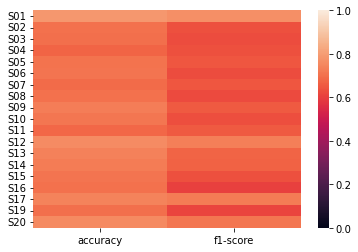

     class0 f1-score  class1 f1-score
S01         0.861789         0.552632
S02         0.814815         0.242424
S03         0.815331         0.184615
S04         0.790378         0.265060
S05         0.816479         0.246154
S06         0.824742         0.135593
S07         0.801418         0.300000
S08         0.817276         0.202899
S09         0.836013         0.215385
S10         0.824675         0.205882
S11         0.793774         0.311688
S12         0.845588         0.475000
S13         0.837370         0.318841
S14         0.826389         0.324324
S15         0.822742         0.208955
S16         0.819672         0.098361
S17         0.827309         0.481928
S19         0.813333         0.176471
S20         0.846154         0.405405


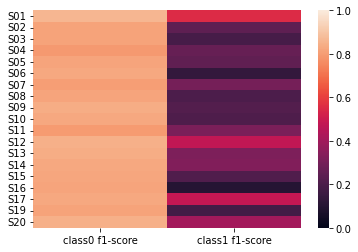

In [6]:
userfold_results_summary(participants_dictionary, participants)
userfold_classwise_results_summary(participants_dictionary, participants)


In [7]:
# channel_names=[i for i in range(input_dim[0])]
channel_names=["AFz","F3","F1","Fz","F2","F4","FC5","FC3","FC1","FCz","FC2",
               "FC4","FC6","C5","C3","C1","Cz","C2","C4","C6","CP5","CP3",
               "CP1","CPz","CP2","CP4","CP6","P3","P1","Pz","P2","P4"]

In [8]:
from sklearn.preprocessing import MinMaxScaler

participants_w_list=[]

for i in range(len(participants)):

    w= pickle.load(
        open(f"{saved_dir}/Userfold-{participants[i]}-LSTM_EEGNet-NFS_EEG-w-e{EPOCH}.pkl", "rb") 
                    )  
    participants_w_list.append(w)
    
avg_w= np.array(participants_w_list).mean(axis=0)
# scaler= MinMaxScaler()
# scaled_avg_w= scaler.fit_transform(avg_w)

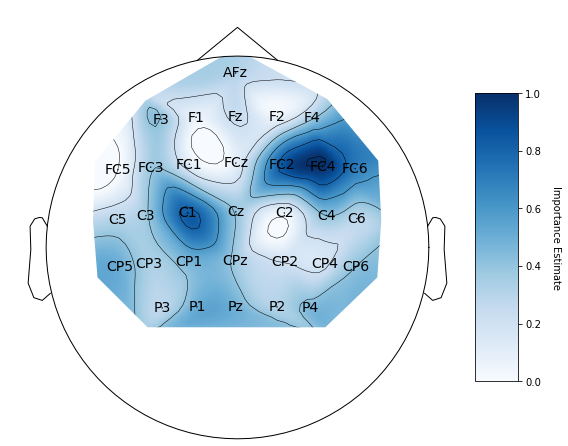

In [11]:
import matplotlib
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import mne
info= mne.create_info(channel_names, sfreq=500, ch_types=32*["eeg"])
info.set_montage("standard_1020")

fig= plt.figure()
ax= plt.axes((0,0,1.5,1.5))

scaler= MinMaxScaler()
scaled_avg_w= scaler.fit_transform(avg_w.reshape(-1,1))
# df= pd.DataFrame(scaled_avg_w.reshape(-1))

im, _= mne.viz.plot_topomap(
    scaled_avg_w.reshape(-1),
    info,
    ch_type= "eeg",
    sensors=True,
    names=channel_names,
    cmap="Blues",
    axes=ax,
    show=False,
    extrapolate="local"
#     sphere="eeglab"
)
fig.add_axes(ax)
cbar_ax= fig.add_axes([1.3,0.2, 0.1,1])
clb= fig.colorbar(im, cax=cbar_ax)
clb.set_label("Importance Estimate", rotation=270,labelpad=20)

for tt in plt.findobj(fig, matplotlib.text.Text):
    if tt.get_text() in channel_names:
        tt.set_fontsize(14)